# A Study on Gradient Boosting Algorithms and Hyperparameter Optimization using Optuna

Undergraduate Thesis submitted to the Undergraduate Course in Mechatronics Engineering from São Carlos School of Engineering, University of São Paulo – EESC- USP, in partial fulfillment of the requirements for the bachelor degree in Mechatronics Engineer .

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import sys
import timeit
import gc
import sklearn
import seaborn
from sklearn import metrics
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
import lightgbm
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import optuna
from sklearn.model_selection import GridSearchCV
import matplotlib.pylab as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances
import shap
import validation_train
from validation_train import auc_logloss_ks
from validation_train import objective
from validation_train import tuning
from validation_train import train
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# 4.0 - Breast Cancer Wisconsin (Diagnostic)
[Breast Cancer Wisconsin (Diagnostic)](https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data)

In [2]:
df_cancer = pd.read_csv('04_breast_cancer.csv')
df_cancer

id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0      842302         M       17.990        10.380         122.800   1001.000   
1      842517         M       20.570        17.770         132.900   1326.000   
2    84300903         M       19.690        21.250         130.000   1203.000   
3    84348301         M       11.420        20.380          77.580    386.100   
4    84358402         M       20.290        14.340         135.100   1297.000   
..        ...       ...          ...           ...             ...        ...   
564    926424         M       21.560        22.390         142.000   1479.000   
565    926682         M       20.130        28.250         131.200   1261.000   
566    926954         M       16.600        28.080         108.300    858.100   
567    927241         M       20.600        29.330         140.100   1265.000   
568     92751         B        7.760        24.540          47.920    181.000   

     smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0              0.118             0.278           0.300                0.147   
1              0.085             0.079           0.087                0.070   
2              0.110             0.160           0.197                0.128   
3              0.142             0.284           0.241                0.105   
4              0.100             0.133           0.198                0.104   
..               ...               ...             ...                  ...   
564            0.111             0.116           0.244                0.139   
565            0.098             0.103           0.144                0.098   
566            0.085             0.102           0.093                0.053   
567            0.118             0.277           0.351                0.152   
568            0.053             0.044           0.000                0.000   

     ...  texture_worst  perimeter_worst  area_worst  smoothness_worst  \
0    ...         17.330          184.600    2019.000             0.162   
1    ...         23.410          158.800    1956.000             0.124   
2    ...         25.530          152.500    1709.000             0.144   
3    ...         26.500           98.870     567.700             0.210   
4    ...         16.670          152.200    1575.000             0.137   
..   ...            ...              ...         ...               ...   
564  ...         26.400          166.100    2027.000             0.141   
565  ...         38.250          155.000    1731.000             0.117   
566  ...         34.120          126.700    1124.000             0.114   
567  ...         39.420          184.600    1821.000             0.165   
568  ...         30.370           59.160     268.600             0.090   

     compactness_worst  concavity_worst  concave points_worst  symmetry_worst  \
0                0.666            0.712                 0.265           0.460   
1                0.187            0.242                 0.186           0.275   
2                0.424            0.450                 0.243           0.361   
3                0.866            0.687                 0.258           0.664   
4                0.205            0.400                 0.163           0.236   
..                 ...              ...                   ...             ...   
564              0.211            0.411                 0.222           0.206   
565              0.192            0.322                 0.163           0.257   
566              0.309            0.340                 0.142           0.222   
567              0.868            0.939                 0.265           0.409   
568              0.064            0.000                 0.000           0.287   

     fractal_dimension_worst  Unnamed: 32  
0                      0.119          NaN  
1                      0.089          NaN  
2                      0.088          NaN  
3                      0.173          NaN  
4      

In [3]:
# columns name
df_cancer.columns

Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst', 'Unnamed: 32'],
      dtype='object')

In [4]:
# columns type
df_cancer.dtypes

id                           int64
diagnosis                   object
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_worst          float64
concavity_worst     

In [5]:
# check for null
df_cancer.isnull().sum()

id                           0
diagnosis                    0
radius_mean                  0
texture_mean                 0
perimeter_mean               0
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean               0
concave points_mean          0
symmetry_mean                0
fractal_dimension_mean       0
radius_se                    0
texture_se                   0
perimeter_se                 0
area_se                      0
smoothness_se                0
compactness_se               0
concavity_se                 0
concave points_se            0
symmetry_se                  0
fractal_dimension_se         0
radius_worst                 0
texture_worst                0
perimeter_worst              0
area_worst                   0
smoothness_worst             0
compactness_worst            0
concavity_worst              0
concave points_worst         0
symmetry_worst               0
fractal_dimension_worst      0
Unnamed:

In [6]:
df_cancer = df_cancer.drop(columns='Unnamed: 32')

In [7]:
df_cancer.isnull().sum()

id                         0
diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

In [8]:
df_cancer[['diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean']].describe()

radius_mean  texture_mean  perimeter_mean  area_mean  smoothness_mean  \
count      569.000       569.000         569.000    569.000          569.000   
mean        14.127        19.290          91.969    654.889            0.096   
std          3.524         4.301          24.299    351.914            0.014   
min          6.981         9.710          43.790    143.500            0.053   
25%         11.700        16.170          75.170    420.300            0.086   
50%         13.370        18.840          86.240    551.100            0.096   
75%         15.780        21.800         104.100    782.700            0.105   
max         28.110        39.280         188.500   2501.000            0.163   

       compactness_mean  concavity_mean  
count           569.000         569.000  
mean              0.104           0.089  
std               0.053           0.080  
min               0.019           0.000  
25%               0.065           0.030  
50%               0.093           0.062  
75%               0.130           0.131  
max               0.345           0.427

In [9]:
df_cancer[['concave points_mean', 'symmetry_mean','fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se','concave points_worst']].describe()

concave points_mean  symmetry_mean  fractal_dimension_mean  radius_se  \
count              569.000        569.000                 569.000    569.000   
mean                 0.049          0.181                   0.063      0.405   
std                  0.039          0.027                   0.007      0.277   
min                  0.000          0.106                   0.050      0.112   
25%                  0.020          0.162                   0.058      0.232   
50%                  0.034          0.179                   0.062      0.324   
75%                  0.074          0.196                   0.066      0.479   
max                  0.201          0.304                   0.097      2.873   

       texture_se  perimeter_se  area_se  concave points_worst  
count     569.000       569.000  569.000               569.000  
mean        1.217         2.866   40.337                 0.115  
std         0.552         2.022   45.491                 0.066  
min         0.360         0.757    6.802                 0.000  
25%         0.834         1.606   17.850                 0.065  
50%         1.108         2.287   24.530                 0.100  
75%         1.474         3.357   45.190                 0.161  
max         4.885        21.980  542.200                 0.291

In [10]:
df_cancer[['smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se','symmetry_se',
       'fractal_dimension_se', 'radius_worst','texture_worst']].describe()

smoothness_se  compactness_se  concavity_se  concave points_se  \
count        569.000         569.000       569.000            569.000   
mean           0.007           0.025         0.032              0.012   
std            0.003           0.018         0.030              0.006   
min            0.002           0.002         0.000              0.000   
25%            0.005           0.013         0.015              0.008   
50%            0.006           0.020         0.026              0.011   
75%            0.008           0.032         0.042              0.015   
max            0.031           0.135         0.396              0.053   

       symmetry_se  fractal_dimension_se  radius_worst  texture_worst  
count      569.000               569.000       569.000        569.000  
mean         0.021                 0.004        16.269         25.677  
std          0.008                 0.003         4.833          6.146  
min          0.008                 0.001         7.930         12.020  
25%          0.015                 0.002        13.010         21.080  
50%          0.019                 0.003        14.970         25.410  
75%          0.023                 0.005        18.790         29.720  
max          0.079                 0.030        36.040         49.540

In [11]:
df_cancer[[
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst',
       'symmetry_worst', 'fractal_dimension_worst']].describe()

perimeter_worst  area_worst  smoothness_worst  compactness_worst  \
count          569.000     569.000           569.000            569.000   
mean           107.261     880.583             0.132              0.254   
std             33.603     569.357             0.023              0.157   
min             50.410     185.200             0.071              0.027   
25%             84.110     515.300             0.117              0.147   
50%             97.660     686.500             0.131              0.212   
75%            125.400    1084.000             0.146              0.339   
max            251.200    4254.000             0.223              1.058   

       concavity_worst  symmetry_worst  fractal_dimension_worst  
count          569.000         569.000                  569.000  
mean             0.272           0.290                    0.084  
std              0.209           0.062                    0.018  
min              0.000           0.157                    0.055  
25%              0.115           0.250                    0.071  
50%              0.227           0.282                    0.080  
75%              0.383           0.318                    0.092  
max              1.252           0.664                    0.207

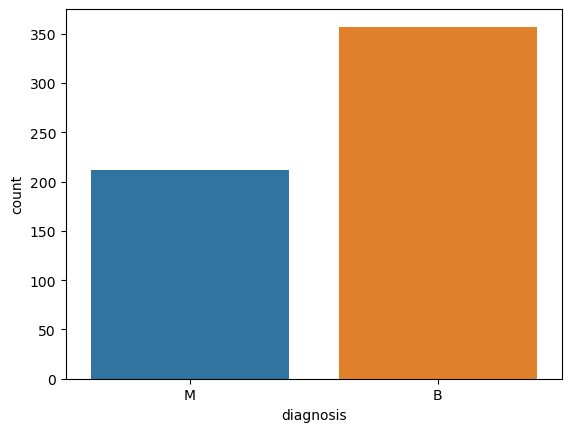

In [12]:
seaborn.countplot(x = 'diagnosis',data = df_cancer)
plt.savefig('cancertot.png')

<Figure size 2500x2500 with 0 Axes>

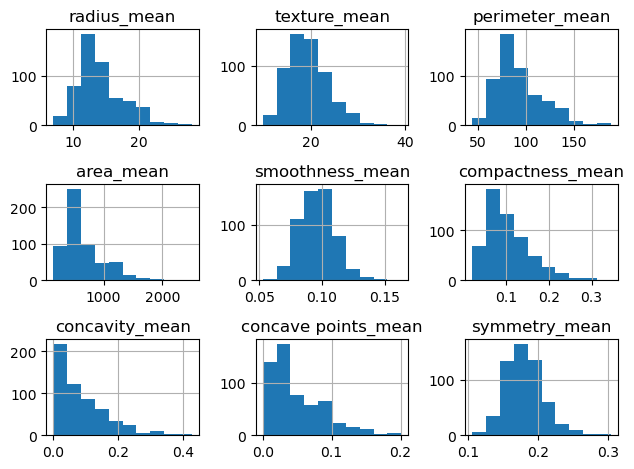

In [14]:
plt.figure(figsize = (25,25))
df_cancer[['diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean']].hist()
plt.tight_layout()
plt.savefig('hist_cancer_t_1.png')

<Figure size 2500x2500 with 0 Axes>

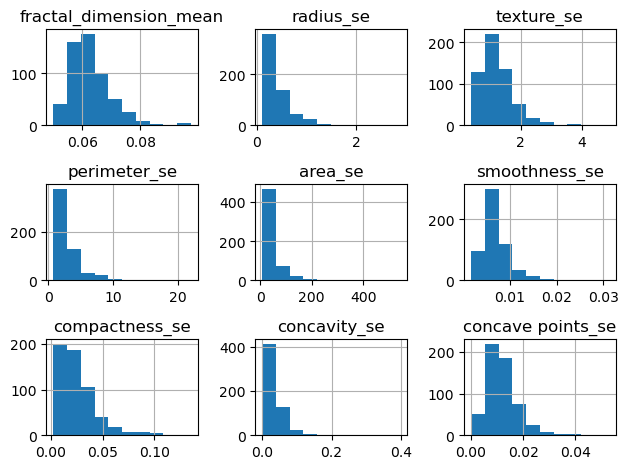

In [15]:
plt.figure(figsize = (25,25))
df_cancer[['fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se']].hist()
plt.tight_layout()
plt.savefig('hist_cancer_t_2.png')

<Figure size 2500x2500 with 0 Axes>

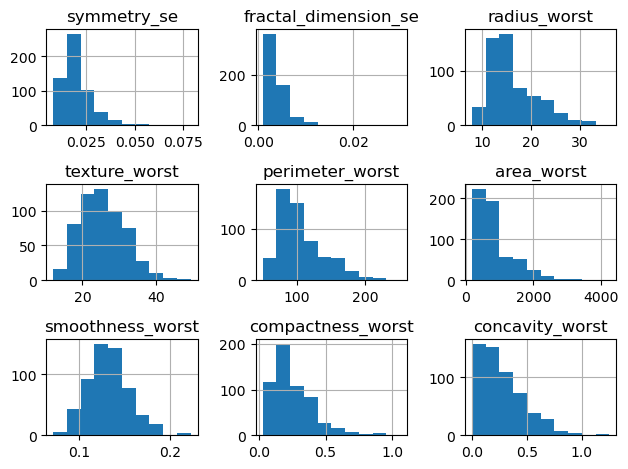

In [277]:
plt.figure(figsize = (25,25))
df_cancer[['symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst']].hist()
plt.tight_layout()
plt.savefig('hist_cancer_t_3.png')

<Figure size 2500x2500 with 0 Axes>

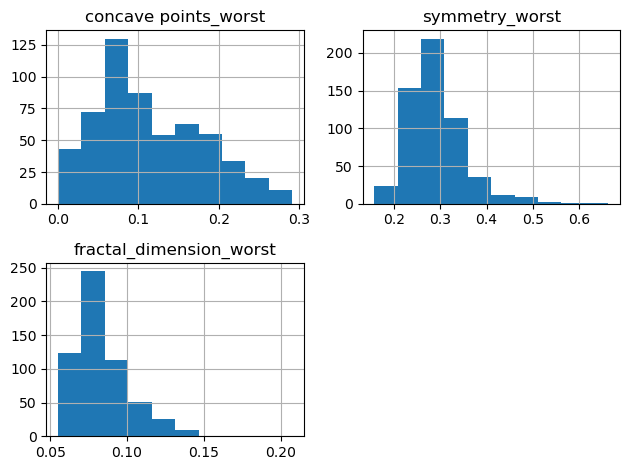

In [279]:
plt.figure(figsize = (25,25))
df_cancer[['concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst']].hist()
plt.tight_layout()
plt.savefig('hist_cancer_t_4.png')

<Figure size 2500x2500 with 0 Axes>

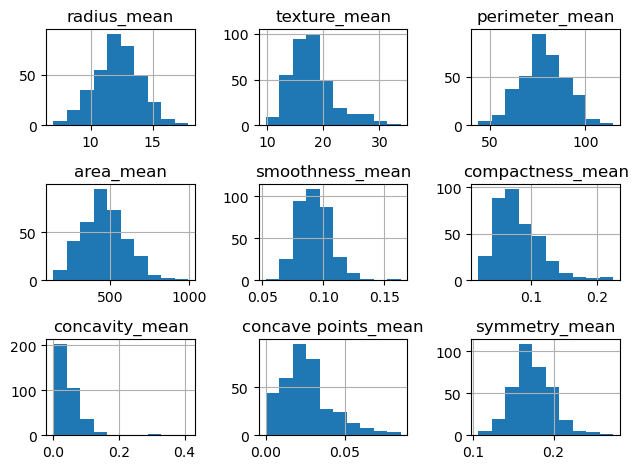

In [280]:
plt.figure(figsize = (25,25))
df_cancer[['diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean']].loc[df_cancer['diagnosis']=='B'].hist()
plt.tight_layout()
plt.savefig('hist_cancer_no_1.png')

<Figure size 2500x2500 with 0 Axes>

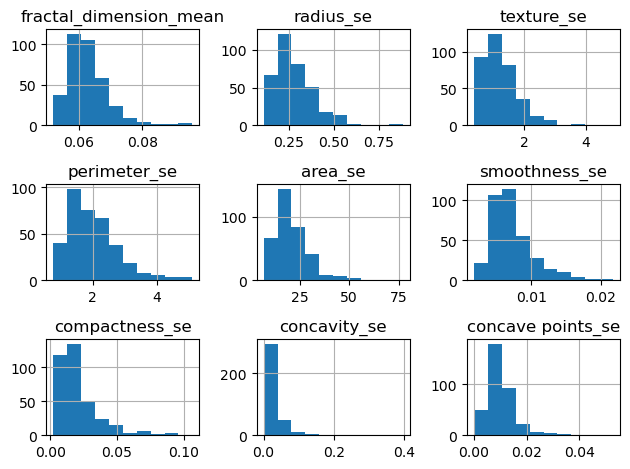

In [281]:
plt.figure(figsize = (25,25))
df_cancer[['fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se']].loc[df_cancer['diagnosis']=='B'].hist()
plt.tight_layout()
plt.savefig('hist_cancer_no_2.png')

<Figure size 2500x2500 with 0 Axes>

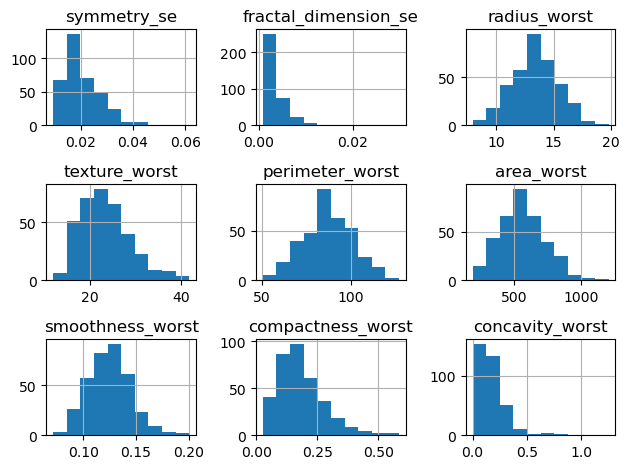

In [282]:
plt.figure(figsize = (25,25))
df_cancer[['symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst']].loc[df_cancer['diagnosis']=='B'].hist()
plt.tight_layout()
plt.savefig('hist_cancer_no_3.png')

<Figure size 2500x2500 with 0 Axes>

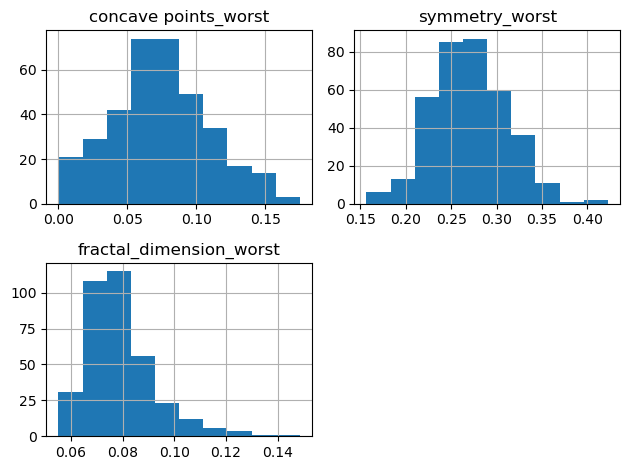

In [283]:
plt.figure(figsize = (25,25))
df_cancer[['concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst']].loc[df_cancer['diagnosis']=='B'].hist()
plt.tight_layout()
plt.savefig('hist_cancer_no_4.png')

<Figure size 2500x2500 with 0 Axes>

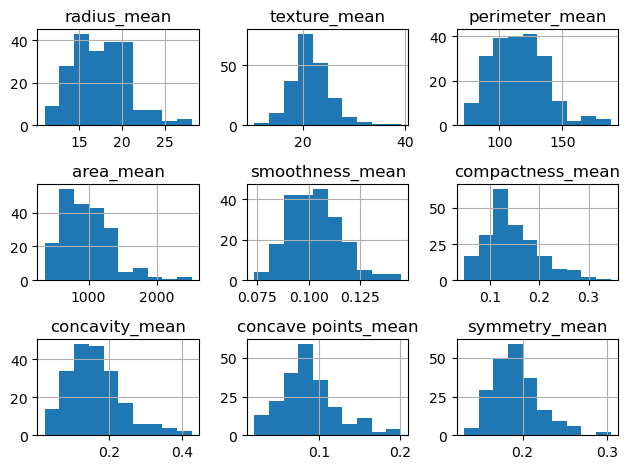

In [284]:
plt.figure(figsize = (25,25))
df_cancer[['diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean']].loc[df_cancer['diagnosis']=='M'].hist()
plt.tight_layout()
plt.savefig('hist_cancer_yes_1.png')

<Figure size 2500x2500 with 0 Axes>

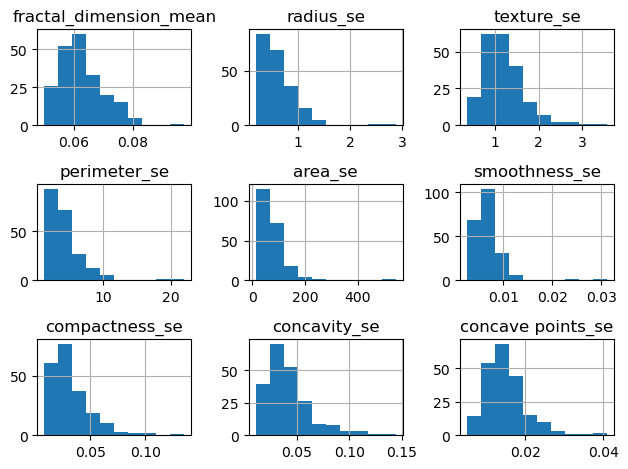

In [285]:
plt.figure(figsize = (25,25))
df_cancer[['fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se']].loc[df_cancer['diagnosis']=='M'].hist()
plt.tight_layout()
plt.savefig('hist_cancer_yes_2.png')

<Figure size 2500x2500 with 0 Axes>

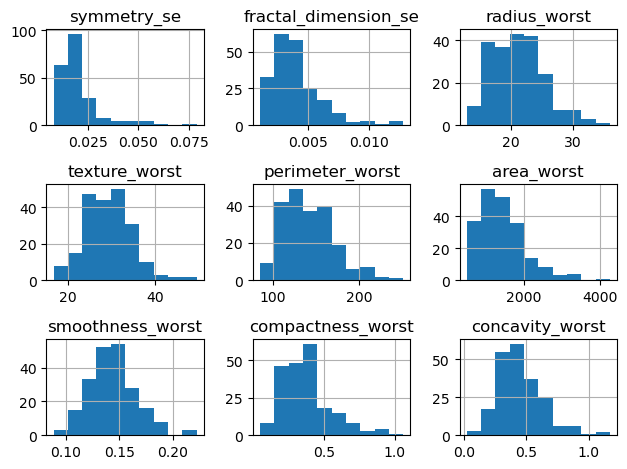

In [286]:
plt.figure(figsize = (25,25))
df_cancer[['symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst']].loc[df_cancer['diagnosis']=='M'].hist()
plt.tight_layout()
plt.savefig('hist_cancer_yes_3.png')

<Figure size 2500x2500 with 0 Axes>

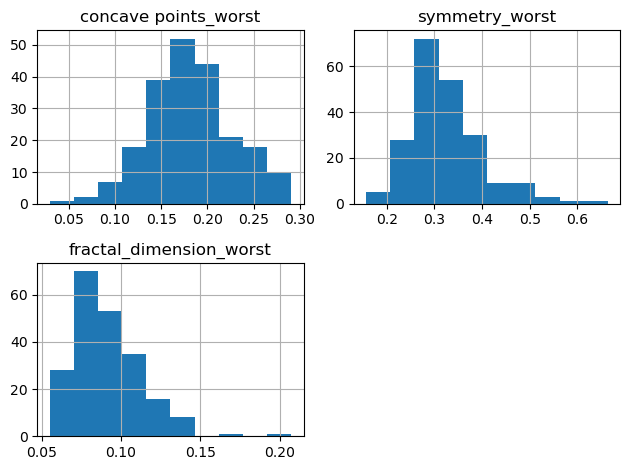

In [287]:
plt.figure(figsize = (25,25))
df_cancer[['concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst']].loc[df_cancer['diagnosis']=='M'].hist()
plt.tight_layout()
plt.savefig('hist_cancer_yes_4.png')

## XGBoost

In [17]:
df_cancer.dtypes

id                           int64
diagnosis                   object
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_worst          float64
concavity_worst     

In [18]:
df_cancer.loc[df_cancer['diagnosis']=='M','target']=1

In [20]:
df_cancer = df_cancer.fillna(0)

In [22]:
var_cols = df_cancer.drop(columns=['id','diagnosis','target']).columns
var_cols

Index(['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

In [23]:
X = df_cancer.loc[:,var_cols]
y = df_cancer.loc[:,'target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((398, 30), (171, 30), (398,), (171,))

In [92]:
parameters = {
        'learning_rate': 0.3,
        'max_depth': 3,
        'lambda': 0.05
}

In [93]:
XGBoost_class = XGBClassifier(**parameters)

In [94]:
start = timeit.default_timer()
XGBoost_model = XGBoost_class.fit(X_train, y_train)
stop = timeit.default_timer()
stop - start

0.05206434999990961

In [95]:
y_prob = XGBoost_model.predict(X_test)
auc_logloss_ks(y_test, y_prob)

(0.966931216931217, 1.0099150945579762, 0.9338624338624338)

### XGBoost using optuna

In [121]:
XGBoost_model = train(X_train, y_train, X_test, y_test, balanced='balanced', method='XGBoost')

[I 2023-02-05 11:10:16,906] A new study created in memory with name: XGBoost Classifier


Tuning
Starting the optimization
XGBoost - Optimization using optuna


[I 2023-02-05 11:10:17,150] Trial 0 finished with value: 0.5 and parameters: {'learning_rate': 0.00013706631508072524, 'max_depth': 9, 'min_child_weight': 62, 'gamma': 1.9945200859594183e-08, 'alpha': 0.043529784971001836, 'lambda': 0.939641120702164, 'colsample_bytree': 0.4867541498791028}. Best is trial 0 with value: 0.5.
[I 2023-02-05 11:10:17,301] Trial 1 finished with value: 0.5 and parameters: {'learning_rate': 0.04674946120226097, 'max_depth': 6, 'min_child_weight': 90, 'gamma': 3.8700060399792174e-08, 'alpha': 6.943475341149787e-07, 'lambda': 0.0002867315280252665, 'colsample_bytree': 0.1719731006977859}. Best is trial 0 with value: 0.5.


auc:0.5 , log_loss:0.6922618244823656 , ks:0.0
XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6582146851639998 , ks:0.0


[I 2023-02-05 11:10:17,451] Trial 2 finished with value: 0.5 and parameters: {'learning_rate': 0.006423163533007211, 'max_depth': 15, 'min_child_weight': 52, 'gamma': 2.510929927149633e-06, 'alpha': 0.0011046193963615205, 'lambda': 0.0002576671491631319, 'colsample_bytree': 0.6528053643344478}. Best is trial 0 with value: 0.5.
[I 2023-02-05 11:10:17,590] Trial 3 finished with value: 0.5 and parameters: {'learning_rate': 0.07812516214757617, 'max_depth': 11, 'min_child_weight': 277, 'gamma': 0.007497352195951177, 'alpha': 9.853283372169891e-08, 'lambda': 0.01053795199617329, 'colsample_bytree': 0.6156796421671255}. Best is trial 0 with value: 0.5.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6687635057850888 , ks:0.0
XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0
XGBoost - Optimization using optuna


[I 2023-02-05 11:10:17,757] Trial 4 finished with value: 0.9839800117577895 and parameters: {'learning_rate': 0.0016882660214249362, 'max_depth': 14, 'min_child_weight': 29, 'gamma': 0.02611646997462033, 'alpha': 1.6525020369786687e-07, 'lambda': 0.18797779242632814, 'colsample_bytree': 0.5561715084312185}. Best is trial 4 with value: 0.9839800117577895.
[I 2023-02-05 11:10:17,893] Trial 5 finished with value: 0.5 and parameters: {'learning_rate': 0.0001546997700909253, 'max_depth': 14, 'min_child_weight': 163, 'gamma': 5.577511793103225e-07, 'alpha': 3.2031890633316565e-08, 'lambda': 0.0029143982895970177, 'colsample_bytree': 0.7169606127025147}. Best is trial 4 with value: 0.9839800117577895.


auc:0.9839800117577895 , log_loss:0.5890246702913653 , ks:0.8452380952380952
XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0
XGBoost - Optimization using optuna


[I 2023-02-05 11:10:18,120] Trial 6 finished with value: 0.9775132275132274 and parameters: {'learning_rate': 0.001398713517265942, 'max_depth': 16, 'min_child_weight': 38, 'gamma': 3.950556963345575e-08, 'alpha': 0.0008973614986635113, 'lambda': 0.007304311137175601, 'colsample_bytree': 0.5286022031479426}. Best is trial 4 with value: 0.9839800117577895.
[I 2023-02-05 11:10:18,275] Trial 7 finished with value: 0.5 and parameters: {'learning_rate': 0.0012013827393282607, 'max_depth': 12, 'min_child_weight': 139, 'gamma': 9.021451303356298e-05, 'alpha': 1.2679472749972432e-08, 'lambda': 0.01623438808671602, 'colsample_bytree': 0.31735339225149545}. Best is trial 4 with value: 0.9839800117577895.


auc:0.9775132275132274 , log_loss:0.6095513450471979 , ks:0.8611111111111112
XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0
XGBoost - Optimization using optuna


[I 2023-02-05 11:10:18,451] Trial 8 finished with value: 0.5 and parameters: {'learning_rate': 0.0018775799501558933, 'max_depth': 5, 'min_child_weight': 123, 'gamma': 8.811389826334401e-06, 'alpha': 0.002882464713363216, 'lambda': 0.0019255065355293615, 'colsample_bytree': 0.13329386577702015}. Best is trial 4 with value: 0.9839800117577895.
[I 2023-02-05 11:10:18,578] Trial 9 finished with value: 0.5 and parameters: {'learning_rate': 0.037307553248058754, 'max_depth': 14, 'min_child_weight': 172, 'gamma': 1.192587298450771e-07, 'alpha': 0.10113193318823928, 'lambda': 0.020078985520533447, 'colsample_bytree': 0.27555028022234973}. Best is trial 4 with value: 0.9839800117577895.


auc:0.5 , log_loss:0.6931471824645996 , ks:0.0
XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:10:18,791] Trial 10 finished with value: 0.9907407407407407 and parameters: {'learning_rate': 0.007239922893620802, 'max_depth': 8, 'min_child_weight': 3, 'gamma': 0.18753239531326088, 'alpha': 5.383168934489966e-06, 'lambda': 0.31344503499125986, 'colsample_bytree': 0.7883995399767372}. Best is trial 10 with value: 0.9907407407407407.


XGBoost - Optimization using optuna
auc:0.9907407407407407 , log_loss:0.3413883806669224 , ks:0.9312169312169312


[I 2023-02-05 11:10:19,003] Trial 11 finished with value: 0.989564961787184 and parameters: {'learning_rate': 0.008655601935798618, 'max_depth': 8, 'min_child_weight': 8, 'gamma': 0.8416205516728846, 'alpha': 5.157469118173532e-06, 'lambda': 0.3531381147580021, 'colsample_bytree': 0.7990249919193652}. Best is trial 10 with value: 0.9907407407407407.


XGBoost - Optimization using optuna
auc:0.989564961787184 , log_loss:0.32495764847735914 , ks:0.906084656084656
XGBoost - Optimization using optuna


[I 2023-02-05 11:10:19,196] Trial 12 finished with value: 0.9900793650793651 and parameters: {'learning_rate': 0.009630849072105915, 'max_depth': 8, 'min_child_weight': 9, 'gamma': 0.9677873257005086, 'alpha': 6.769564235726135e-06, 'lambda': 7.163521994514865, 'colsample_bytree': 0.7964875007164545}. Best is trial 10 with value: 0.9907407407407407.


auc:0.9900793650793651 , log_loss:0.3384626241106736 , ks:0.8902116402116402
XGBoost - Optimization using optuna


[I 2023-02-05 11:10:19,412] Trial 13 finished with value: 0.9883891828336273 and parameters: {'learning_rate': 0.015554018948002327, 'max_depth': 7, 'min_child_weight': 2, 'gamma': 0.9477320334943303, 'alpha': 1.210746597778842e-05, 'lambda': 7.0041548333500945, 'colsample_bytree': 0.7752234140569878}. Best is trial 10 with value: 0.9907407407407407.
[I 2023-02-05 11:10:19,562] Trial 14 finished with value: 0.5 and parameters: {'learning_rate': 0.018033020527767857, 'max_depth': 3, 'min_child_weight': 216, 'gamma': 0.02985438647205187, 'alpha': 3.26737885362575e-05, 'lambda': 4.270031667206536, 'colsample_bytree': 0.6894052331776835}. Best is trial 10 with value: 0.9907407407407407.


auc:0.9883891828336273 , log_loss:0.23814980101864242 , ks:0.9312169312169312
XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:10:19,721] Trial 15 finished with value: 0.5 and parameters: {'learning_rate': 0.0042554688622802855, 'max_depth': 10, 'min_child_weight': 87, 'gamma': 0.00207961112306512, 'alpha': 2.650244892724346e-06, 'lambda': 2.2182273137288973, 'colsample_bytree': 0.7303568834799437}. Best is trial 10 with value: 0.9907407407407407.
[I 2023-02-05 11:10:19,864] Trial 16 finished with value: 0.5 and parameters: {'learning_rate': 0.010941819572992098, 'max_depth': 4, 'min_child_weight': 92, 'gamma': 0.1869178862313358, 'alpha': 8.710759056541626e-05, 'lambda': 0.10658178402831399, 'colsample_bytree': 0.7958924283591823}. Best is trial 10 with value: 0.9907407407407407.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6742268675252011 , ks:0.0
XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6628752037098533 , ks:0.0


[I 2023-02-05 11:10:20,015] Trial 17 finished with value: 0.5 and parameters: {'learning_rate': 0.004509703642132104, 'max_depth': 8, 'min_child_weight': 216, 'gamma': 0.0015507148641280856, 'alpha': 8.433583675189698e-07, 'lambda': 1.133604882239895, 'colsample_bytree': 0.6221470707975905}. Best is trial 10 with value: 0.9907407407407407.
[I 2023-02-05 11:10:20,164] Trial 18 finished with value: 0.5 and parameters: {'learning_rate': 0.02455612056669139, 'max_depth': 12, 'min_child_weight': 292, 'gamma': 0.06638624401052569, 'alpha': 2.936387355699182e-05, 'lambda': 6.159268429680215, 'colsample_bytree': 0.7152750907596025}. Best is trial 10 with value: 0.9907407407407407.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0
XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:10:20,373] Trial 19 finished with value: 0.5 and parameters: {'learning_rate': 0.08285022596718415, 'max_depth': 6, 'min_child_weight': 72, 'gamma': 0.18910056591372623, 'alpha': 0.000289477416334933, 'lambda': 0.0661939429827063, 'colsample_bytree': 0.416042189798165}. Best is trial 10 with value: 0.9907407407407407.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6581863384497794 , ks:0.0


[I 2023-02-05 11:10:20,545] Trial 20 finished with value: 0.9869929453262786 and parameters: {'learning_rate': 0.009359474565053882, 'max_depth': 9, 'min_child_weight': 29, 'gamma': 0.0006501255254925108, 'alpha': 0.9573298855223148, 'lambda': 0.7445218858425252, 'colsample_bytree': 0.5920340791451622}. Best is trial 10 with value: 0.9907407407407407.


XGBoost - Optimization using optuna
auc:0.9869929453262786 , log_loss:0.344238219205399 , ks:0.8624338624338624
XGBoost - Optimization using optuna


[I 2023-02-05 11:10:20,766] Trial 21 finished with value: 0.9897119341563785 and parameters: {'learning_rate': 0.008564549996966486, 'max_depth': 8, 'min_child_weight': 2, 'gamma': 0.7254683468707187, 'alpha': 2.8152848357683357e-06, 'lambda': 0.29547022581700005, 'colsample_bytree': 0.7791170086157068}. Best is trial 10 with value: 0.9907407407407407.


auc:0.9897119341563785 , log_loss:0.3041234719648696 , ks:0.9365079365079365
XGBoost - Optimization using optuna


[I 2023-02-05 11:10:21,014] Trial 22 finished with value: 0.9891240446796004 and parameters: {'learning_rate': 0.0029976982202399643, 'max_depth': 7, 'min_child_weight': 1, 'gamma': 0.7891727024810259, 'alpha': 4.2534753158192015e-06, 'lambda': 0.3560363513319365, 'colsample_bytree': 0.6689274108401531}. Best is trial 10 with value: 0.9907407407407407.
[I 2023-02-05 11:10:21,174] Trial 23 finished with value: 0.9896384479717812 and parameters: {'learning_rate': 0.016250374955453464, 'max_depth': 8, 'min_child_weight': 30, 'gamma': 0.09438287840889273, 'alpha': 1.048568552036197e-06, 'lambda': 9.6896091885948, 'colsample_bytree': 0.7485167318304916}. Best is trial 10 with value: 0.9907407407407407.


auc:0.9891240446796004 , log_loss:0.495294653881363 , ks:0.9497354497354498
XGBoost - Optimization using optuna
auc:0.9896384479717812 , log_loss:0.2797491237608313 , ks:0.8981481481481481


[I 2023-02-05 11:10:21,332] Trial 24 finished with value: 0.5 and parameters: {'learning_rate': 0.006572408195600375, 'max_depth': 10, 'min_child_weight': 111, 'gamma': 0.012961094865435237, 'alpha': 2.1775038766673185e-05, 'lambda': 2.525468502034634, 'colsample_bytree': 0.7359969419865948}. Best is trial 10 with value: 0.9907407407407407.
[I 2023-02-05 11:10:21,487] Trial 25 finished with value: 0.5 and parameters: {'learning_rate': 0.028178208524217783, 'max_depth': 6, 'min_child_weight': 53, 'gamma': 0.31854252466448213, 'alpha': 3.590198312590116e-07, 'lambda': 0.05192007108148029, 'colsample_bytree': 0.6690584166732997}. Best is trial 10 with value: 0.9907407407407407.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0
XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.658479492915304 , ks:0.0


[I 2023-02-05 11:10:21,666] Trial 26 finished with value: 0.9902998236331569 and parameters: {'learning_rate': 0.012431902380856574, 'max_depth': 11, 'min_child_weight': 20, 'gamma': 0.05944099904708056, 'alpha': 1.5271940027185472e-06, 'lambda': 0.3256445744211982, 'colsample_bytree': 0.7864474096199845}. Best is trial 10 with value: 0.9907407407407407.


XGBoost - Optimization using optuna
auc:0.9902998236331569 , log_loss:0.2729041121507946 , ks:0.9034391534391535
XGBoost - Optimization using optuna


[I 2023-02-05 11:10:21,869] Trial 27 finished with value: 0.9897119341563786 and parameters: {'learning_rate': 0.013376957556530183, 'max_depth': 11, 'min_child_weight': 25, 'gamma': 0.08446537967614903, 'alpha': 1.112254714928693e-05, 'lambda': 0.15074877175543486, 'colsample_bytree': 0.6906712893516581}. Best is trial 10 with value: 0.9907407407407407.
[I 2023-02-05 11:10:22,014] Trial 28 finished with value: 0.5 and parameters: {'learning_rate': 0.019430702335276592, 'max_depth': 12, 'min_child_weight': 50, 'gamma': 0.008226151124293717, 'alpha': 9.692857914772426e-05, 'lambda': 1.5513701866335086, 'colsample_bytree': 0.7971970097137879}. Best is trial 10 with value: 0.9907407407407407.


auc:0.9897119341563786 , log_loss:0.2673068955453516 , ks:0.8941798941798942
XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6593448613819323 , ks:0.0


[I 2023-02-05 11:10:22,163] Trial 29 finished with value: 0.5 and parameters: {'learning_rate': 0.04611088579514876, 'max_depth': 10, 'min_child_weight': 65, 'gamma': 0.19926133985232078, 'alpha': 1.3041169483582693e-07, 'lambda': 0.6459134845639876, 'colsample_bytree': 0.7333394364166568}. Best is trial 10 with value: 0.9907407407407407.
[I 2023-02-05 11:10:22,304] Trial 30 finished with value: 0.5 and parameters: {'learning_rate': 0.024261434479224558, 'max_depth': 9, 'min_child_weight': 73, 'gamma': 0.03474313236738209, 'alpha': 1.4552166848660425e-06, 'lambda': 3.1714299567856017, 'colsample_bytree': 0.6468992700606484}. Best is trial 10 with value: 0.9907407407407407.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6582180073386744 , ks:0.0
XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6587687166113603 , ks:0.0


[I 2023-02-05 11:10:22,474] Trial 31 finished with value: 0.9916225749559083 and parameters: {'learning_rate': 0.01481164071778157, 'max_depth': 11, 'min_child_weight': 19, 'gamma': 0.07049967903640601, 'alpha': 1.4968256332305376e-05, 'lambda': 0.09075115258506578, 'colsample_bytree': 0.6966077654254359}. Best is trial 31 with value: 0.9916225749559083.


XGBoost - Optimization using optuna
auc:0.9916225749559083 , log_loss:0.23917058123308316 , ks:0.9126984126984127
XGBoost - Optimization using optuna


[I 2023-02-05 11:10:22,646] Trial 32 finished with value: 0.9909611992945326 and parameters: {'learning_rate': 0.012604966588263147, 'max_depth': 11, 'min_child_weight': 18, 'gamma': 0.2635546853468795, 'alpha': 6.17189901206334e-06, 'lambda': 0.9147776199083947, 'colsample_bytree': 0.7542970386265546}. Best is trial 31 with value: 0.9916225749559083.
[I 2023-02-05 11:10:22,813] Trial 33 finished with value: 0.990299823633157 and parameters: {'learning_rate': 0.012697518148608446, 'max_depth': 11, 'min_child_weight': 22, 'gamma': 0.06870979486464851, 'alpha': 1.7191722131627884e-06, 'lambda': 0.6320869475887876, 'colsample_bytree': 0.751048783421222}. Best is trial 31 with value: 0.9916225749559083.


auc:0.9909611992945326 , log_loss:0.270620761123317 , ks:0.9126984126984127
XGBoost - Optimization using optuna
auc:0.990299823633157 , log_loss:0.27270332092081595 , ks:0.9034391534391535


[I 2023-02-05 11:10:22,984] Trial 34 finished with value: 0.9815549676660786 and parameters: {'learning_rate': 0.006291229056530249, 'max_depth': 13, 'min_child_weight': 45, 'gamma': 0.013835373152966053, 'alpha': 2.921910446535585e-07, 'lambda': 0.7616664886739409, 'colsample_bytree': 0.694064411663975}. Best is trial 31 with value: 0.9916225749559083.


XGBoost - Optimization using optuna
auc:0.9815549676660786 , log_loss:0.46332454524542155 , ks:0.8902116402116402
XGBoost - Optimization using optuna


[I 2023-02-05 11:10:23,167] Trial 35 finished with value: 0.5 and parameters: {'learning_rate': 0.03213911093857874, 'max_depth': 13, 'min_child_weight': 92, 'gamma': 0.24631204874035156, 'alpha': 4.3277110378809783e-07, 'lambda': 0.1035473030521067, 'colsample_bytree': 0.6226521489828496}. Best is trial 31 with value: 0.9916225749559083.
[I 2023-02-05 11:10:23,324] Trial 36 finished with value: 0.9928718400940624 and parameters: {'learning_rate': 0.05688750130947285, 'max_depth': 11, 'min_child_weight': 21, 'gamma': 0.0032924972469182637, 'alpha': 3.257727903756875e-05, 'lambda': 1.6030777375572178, 'colsample_bytree': 0.7497198189811842}. Best is trial 36 with value: 0.9928718400940624.


auc:0.5 , log_loss:0.6583569865477713 , ks:0.0
XGBoost - Optimization using optuna
auc:0.9928718400940624 , log_loss:0.17897442972276642 , ks:0.906084656084656


[I 2023-02-05 11:10:23,600] Trial 37 finished with value: 0.9814814814814815 and parameters: {'learning_rate': 0.05766643562954269, 'max_depth': 13, 'min_child_weight': 44, 'gamma': 0.002829711172923407, 'alpha': 3.3374341723665074e-05, 'lambda': 1.3035428181627373, 'colsample_bytree': 0.5926022236140145}. Best is trial 36 with value: 0.9928718400940624.


XGBoost - Optimization using optuna
auc:0.9814814814814815 , log_loss:0.42612612212610523 , ks:0.8902116402116402


[I 2023-02-05 11:10:23,754] Trial 38 finished with value: 0.5 and parameters: {'learning_rate': 0.05115454917917982, 'max_depth': 12, 'min_child_weight': 59, 'gamma': 0.02167603305286726, 'alpha': 8.716342497113074e-06, 'lambda': 0.20196297199887187, 'colsample_bytree': 0.6570894917583021}. Best is trial 36 with value: 0.9928718400940624.
[I 2023-02-05 11:10:23,903] Trial 39 finished with value: 0.9941211052322163 and parameters: {'learning_rate': 0.07833568114931237, 'max_depth': 10, 'min_child_weight': 17, 'gamma': 0.0055235045546411735, 'alpha': 0.00017984316086131071, 'lambda': 0.03492282102115596, 'colsample_bytree': 0.7041297115105597}. Best is trial 39 with value: 0.9941211052322163.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6582036018371582 , ks:0.0
XGBoost - Optimization using optuna
auc:0.9941211052322163 , log_loss:0.14881846238995156 , ks:0.9285714285714285


[I 2023-02-05 11:10:24,069] Trial 40 finished with value: 0.5 and parameters: {'learning_rate': 0.08078614855639925, 'max_depth': 15, 'min_child_weight': 255, 'gamma': 0.005519593545257108, 'alpha': 0.00024050714342861823, 'lambda': 0.041581772895887915, 'colsample_bytree': 0.5590231869807322}. Best is trial 39 with value: 0.9941211052322163.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0
XGBoost - Optimization using optuna


[I 2023-02-05 11:10:24,241] Trial 41 finished with value: 0.9946355085243974 and parameters: {'learning_rate': 0.09525661075122878, 'max_depth': 10, 'min_child_weight': 17, 'gamma': 0.005111014236908689, 'alpha': 5.614793311551169e-05, 'lambda': 0.030097353484495503, 'colsample_bytree': 0.753273181185553}. Best is trial 41 with value: 0.9946355085243974.
[I 2023-02-05 11:10:24,408] Trial 42 finished with value: 0.9931657848324514 and parameters: {'learning_rate': 0.09669577535720603, 'max_depth': 11, 'min_child_weight': 19, 'gamma': 0.000761219443714539, 'alpha': 6.967240579182545e-05, 'lambda': 0.03273179761669277, 'colsample_bytree': 0.7060162428566489}. Best is trial 41 with value: 0.9946355085243974.


auc:0.9946355085243974 , log_loss:0.14792204168979187 , ks:0.9378306878306878
XGBoost - Optimization using optuna
auc:0.9931657848324514 , log_loss:0.16559626209979866 , ks:0.906084656084656


[I 2023-02-05 11:10:24,573] Trial 43 finished with value: 0.9786155202821869 and parameters: {'learning_rate': 0.09874467989137847, 'max_depth': 10, 'min_child_weight': 43, 'gamma': 0.0007233510540826337, 'alpha': 7.119317664374967e-05, 'lambda': 0.022706232371104293, 'colsample_bytree': 0.7081427863633554}. Best is trial 41 with value: 0.9946355085243974.


XGBoost - Optimization using optuna
auc:0.9786155202821869 , log_loss:0.40262571961907617 , ks:0.8994708994708995
XGBoost - Optimization using optuna


[I 2023-02-05 11:10:24,735] Trial 44 finished with value: 0.9842739564961788 and parameters: {'learning_rate': 0.06484129164218423, 'max_depth': 9, 'min_child_weight': 39, 'gamma': 0.0002822074087122146, 'alpha': 0.0003369502219991407, 'lambda': 0.010013051437996018, 'colsample_bytree': 0.7094890722657146}. Best is trial 41 with value: 0.9946355085243974.
[I 2023-02-05 11:10:24,890] Trial 45 finished with value: 0.9938271604938272 and parameters: {'learning_rate': 0.09500097998413827, 'max_depth': 11, 'min_child_weight': 18, 'gamma': 0.005357164629499552, 'alpha': 0.0014639634655293672, 'lambda': 0.03157476462587625, 'colsample_bytree': 0.6373428215022644}. Best is trial 41 with value: 0.9946355085243974.


auc:0.9842739564961788 , log_loss:0.3466927288917073 , ks:0.906084656084656
XGBoost - Optimization using optuna
auc:0.9938271604938272 , log_loss:0.1554022544875131 , ks:0.921957671957672


[I 2023-02-05 11:10:25,069] Trial 46 finished with value: 0.5 and parameters: {'learning_rate': 0.09859599967406842, 'max_depth': 12, 'min_child_weight': 186, 'gamma': 0.005300441952692739, 'alpha': 0.002131047083692236, 'lambda': 0.0326831099802983, 'colsample_bytree': 0.649334697442371}. Best is trial 41 with value: 0.9946355085243974.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0
XGBoost - Optimization using optuna


[I 2023-02-05 11:10:25,227] Trial 47 finished with value: 0.5 and parameters: {'learning_rate': 0.06341109165719636, 'max_depth': 10, 'min_child_weight': 80, 'gamma': 0.00011133854816488743, 'alpha': 0.006702488646155853, 'lambda': 0.0049858386856540945, 'colsample_bytree': 0.756826751790644}. Best is trial 41 with value: 0.9946355085243974.
[I 2023-02-05 11:10:25,377] Trial 48 finished with value: 0.5 and parameters: {'learning_rate': 0.03962801667085478, 'max_depth': 11, 'min_child_weight': 139, 'gamma': 0.0036986317505216964, 'alpha': 0.0006034309877517514, 'lambda': 0.016126629663805354, 'colsample_bytree': 0.6751329305302622}. Best is trial 41 with value: 0.9946355085243974.


auc:0.5 , log_loss:0.6581907868385315 , ks:0.0
XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:10:25,568] Trial 49 finished with value: 0.5 and parameters: {'learning_rate': 0.04335222334816072, 'max_depth': 9, 'min_child_weight': 108, 'gamma': 0.0015348693221568434, 'alpha': 0.00016877682151786598, 'lambda': 0.02692873153346738, 'colsample_bytree': 0.7257268156396776}. Best is trial 41 with value: 0.9946355085243974.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0
XGBoost - Optimization using optuna


[I 2023-02-05 11:10:25,751] Trial 50 finished with value: 0.989564961787184 and parameters: {'learning_rate': 0.05841843646885732, 'max_depth': 13, 'min_child_weight': 33, 'gamma': 0.008833500430272555, 'alpha': 5.2081926837981145e-05, 'lambda': 0.057818856570243625, 'colsample_bytree': 0.6365933085931731}. Best is trial 41 with value: 0.9946355085243974.
[I 2023-02-05 11:10:25,929] Trial 51 finished with value: 0.9955908289241623 and parameters: {'learning_rate': 0.07244543616982983, 'max_depth': 10, 'min_child_weight': 16, 'gamma': 0.014921786655593948, 'alpha': 0.00015747103884286513, 'lambda': 0.015919737894384344, 'colsample_bytree': 0.6924521484134242}. Best is trial 51 with value: 0.9955908289241623.


auc:0.989564961787184 , log_loss:0.28156012976378725 , ks:0.8888888888888888
XGBoost - Optimization using optuna
auc:0.9955908289241623 , log_loss:0.137161802576735 , ks:0.947089947089947


[I 2023-02-05 11:10:26,159] Trial 52 finished with value: 0.9954438565549675 and parameters: {'learning_rate': 0.06805850916797679, 'max_depth': 10, 'min_child_weight': 14, 'gamma': 0.015978607968429415, 'alpha': 0.0001267783936817673, 'lambda': 0.03622061358525651, 'colsample_bytree': 0.6825356657675973}. Best is trial 51 with value: 0.9955908289241623.


XGBoost - Optimization using optuna
auc:0.9954438565549675 , log_loss:0.12353063269098949 , ks:0.947089947089947


[I 2023-02-05 11:10:26,381] Trial 53 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.07609497716235898, 'max_depth': 10, 'min_child_weight': 12, 'gamma': 0.01658209602691123, 'alpha': 0.00011201087731437972, 'lambda': 0.014359882313059732, 'colsample_bytree': 0.6754904725014341}. Best is trial 51 with value: 0.9955908289241623.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.11039526559063914 , ks:0.947089947089947


[I 2023-02-05 11:10:26,598] Trial 54 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.07327272503833324, 'max_depth': 10, 'min_child_weight': 10, 'gamma': 0.019598759207142148, 'alpha': 0.00014003574639402975, 'lambda': 0.013908816161005885, 'colsample_bytree': 0.6746116775381101}. Best is trial 54 with value: 0.9963256907701352.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.09874455900372643 , ks:0.9563492063492063


[I 2023-02-05 11:10:26,852] Trial 55 finished with value: 0.9958847736625513 and parameters: {'learning_rate': 0.07089006816341052, 'max_depth': 9, 'min_child_weight': 9, 'gamma': 0.023773233179333483, 'alpha': 0.0001231585498497889, 'lambda': 0.013775541664897339, 'colsample_bytree': 0.605911349177787}. Best is trial 54 with value: 0.9963256907701352.


XGBoost - Optimization using optuna
auc:0.9958847736625513 , log_loss:0.09038973381274451 , ks:0.9497354497354498


[I 2023-02-05 11:10:27,063] Trial 56 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.03696019057354911, 'max_depth': 7, 'min_child_weight': 9, 'gamma': 0.020523054915659627, 'alpha': 0.0005764494839449953, 'lambda': 0.015124259998309153, 'colsample_bytree': 0.601066381073934}. Best is trial 54 with value: 0.9963256907701352.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.11198441301913638 , ks:0.9563492063492063


[I 2023-02-05 11:10:27,276] Trial 57 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.03516384492955631, 'max_depth': 7, 'min_child_weight': 7, 'gamma': 0.015204610236232256, 'alpha': 0.0006041188270360663, 'lambda': 0.013539634430689548, 'colsample_bytree': 0.5261542894015465}. Best is trial 54 with value: 0.9963256907701352.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.11003378781963859 , ks:0.947089947089947


[I 2023-02-05 11:10:27,516] Trial 58 finished with value: 0.9948559670781892 and parameters: {'learning_rate': 0.040231186931743795, 'max_depth': 7, 'min_child_weight': 6, 'gamma': 0.0299777225215815, 'alpha': 0.0005439868183831723, 'lambda': 0.006238435567498502, 'colsample_bytree': 0.5074952616973508}. Best is trial 54 with value: 0.9963256907701352.


XGBoost - Optimization using optuna
auc:0.9948559670781892 , log_loss:0.09996029662175311 , ks:0.9404761904761905


[I 2023-02-05 11:10:27,735] Trial 59 finished with value: 0.9903733098177543 and parameters: {'learning_rate': 0.03143122016850684, 'max_depth': 6, 'min_child_weight': 33, 'gamma': 0.03529791530785657, 'alpha': 0.0007870922426786399, 'lambda': 0.014400798963182361, 'colsample_bytree': 0.5590470549410861}. Best is trial 54 with value: 0.9963256907701352.


XGBoost - Optimization using optuna
auc:0.9903733098177543 , log_loss:0.28279726520964976 , ks:0.8981481481481481


[I 2023-02-05 11:10:27,980] Trial 60 finished with value: 0.9945620223398001 and parameters: {'learning_rate': 0.047076456693711986, 'max_depth': 5, 'min_child_weight': 4, 'gamma': 0.011686199078419533, 'alpha': 0.00035649890297698427, 'lambda': 0.010252055736922344, 'colsample_bytree': 0.6003291463476832}. Best is trial 54 with value: 0.9963256907701352.


XGBoost - Optimization using optuna
auc:0.9945620223398001 , log_loss:0.08678756474261308 , ks:0.9404761904761905


[I 2023-02-05 11:10:28,248] Trial 61 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.06940835740028047, 'max_depth': 7, 'min_child_weight': 11, 'gamma': 0.017414863803023657, 'alpha': 0.00013534438792820727, 'lambda': 0.017513991012805975, 'colsample_bytree': 0.570544795776087}. Best is trial 54 with value: 0.9963256907701352.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.10353762201137012 , ks:0.9563492063492063
XGBoost - Optimization using optuna


[I 2023-02-05 11:10:28,453] Trial 62 finished with value: 0.9897119341563787 and parameters: {'learning_rate': 0.07180684189831636, 'max_depth': 7, 'min_child_weight': 34, 'gamma': 0.021556978825783373, 'alpha': 0.0001380024173109171, 'lambda': 0.004259140936408005, 'colsample_bytree': 0.5754456277547885}. Best is trial 54 with value: 0.9963256907701352.
[I 2023-02-05 11:10:28,638] Trial 63 finished with value: 0.5 and parameters: {'learning_rate': 0.03505918391636276, 'max_depth': 5, 'min_child_weight': 57, 'gamma': 0.04336122440233752, 'alpha': 0.001160034348589456, 'lambda': 0.007821008848165684, 'colsample_bytree': 0.6113711774885289}. Best is trial 54 with value: 0.9963256907701352.


auc:0.9897119341563787 , log_loss:0.28920213364021125 , ks:0.8875661375661376
XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6583025926037839 , ks:0.0


[I 2023-02-05 11:10:28,838] Trial 64 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.051705865218271, 'max_depth': 7, 'min_child_weight': 11, 'gamma': 0.016450818605969805, 'alpha': 0.00041766809292480967, 'lambda': 0.013872836449189881, 'colsample_bytree': 0.5286435179011322}. Best is trial 54 with value: 0.9963256907701352.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.10283121229721266 , ks:0.9563492063492063


[I 2023-02-05 11:10:29,088] Trial 65 finished with value: 0.9948559670781894 and parameters: {'learning_rate': 0.0505445269946065, 'max_depth': 7, 'min_child_weight': 2, 'gamma': 0.13901113117573644, 'alpha': 0.0003414912332658674, 'lambda': 0.022040113302588194, 'colsample_bytree': 0.5323485011548577}. Best is trial 54 with value: 0.9963256907701352.


XGBoost - Optimization using optuna
auc:0.9948559670781894 , log_loss:0.08509408839439091 , ks:0.9378306878306878


[I 2023-02-05 11:10:29,278] Trial 66 finished with value: 0.9916225749559083 and parameters: {'learning_rate': 0.02678869206274047, 'max_depth': 8, 'min_child_weight': 30, 'gamma': 0.010032892325371025, 'alpha': 0.004221825161160645, 'lambda': 0.0030492309543638948, 'colsample_bytree': 0.4819925132683433}. Best is trial 54 with value: 0.9963256907701352.


XGBoost - Optimization using optuna
auc:0.9916225749559083 , log_loss:0.2520935167258943 , ks:0.9007936507936507
XGBoost - Optimization using optuna


[I 2023-02-05 11:10:29,486] Trial 67 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.03675373176964717, 'max_depth': 8, 'min_child_weight': 10, 'gamma': 0.03940564419157381, 'alpha': 0.0005476055861415299, 'lambda': 0.010278764613538396, 'colsample_bytree': 0.5450946111573327}. Best is trial 54 with value: 0.9963256907701352.
[I 2023-02-05 11:10:29,645] Trial 68 finished with value: 0.5 and parameters: {'learning_rate': 0.019905918416375016, 'max_depth': 6, 'min_child_weight': 50, 'gamma': 0.10472087437829287, 'alpha': 0.00019566650546748205, 'lambda': 0.01731333792859387, 'colsample_bytree': 0.571352562066715}. Best is trial 54 with value: 0.9963256907701352.


auc:0.9954438565549677 , log_loss:0.11585563909240633 , ks:0.9563492063492063
XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6592081440122504 , ks:0.0


[I 2023-02-05 11:10:29,837] Trial 69 finished with value: 0.9828042328042328 and parameters: {'learning_rate': 0.04851950697497772, 'max_depth': 4, 'min_child_weight': 39, 'gamma': 0.022704907731334066, 'alpha': 0.0011180550831133538, 'lambda': 0.008102036886441474, 'colsample_bytree': 0.5833575606272928}. Best is trial 54 with value: 0.9963256907701352.


XGBoost - Optimization using optuna
auc:0.9828042328042328 , log_loss:0.3468990314599366 , ks:0.8941798941798942
XGBoost - Optimization using optuna


[I 2023-02-05 11:10:30,047] Trial 70 finished with value: 0.9952968841857731 and parameters: {'learning_rate': 0.024052928823929672, 'max_depth': 7, 'min_child_weight': 10, 'gamma': 0.009696794359078581, 'alpha': 1.8357746423569455e-05, 'lambda': 0.01233074025768895, 'colsample_bytree': 0.6110028345384491}. Best is trial 54 with value: 0.9963256907701352.
[I 2023-02-05 11:10:30,213] Trial 71 finished with value: 0.992798353909465 and parameters: {'learning_rate': 0.0633831383415081, 'max_depth': 9, 'min_child_weight': 27, 'gamma': 0.016934254024577055, 'alpha': 0.00011223448955222723, 'lambda': 0.01794266301136234, 'colsample_bytree': 0.5213756051873564}. Best is trial 54 with value: 0.9963256907701352.


auc:0.9952968841857731 , log_loss:0.14891425389469715 , ks:0.947089947089947
XGBoost - Optimization using optuna
auc:0.992798353909465 , log_loss:0.22165908032690573 , ks:0.9259259259259259


[I 2023-02-05 11:10:30,449] Trial 72 finished with value: 0.9964726631393299 and parameters: {'learning_rate': 0.07460787312155227, 'max_depth': 9, 'min_child_weight': 10, 'gamma': 0.06347077112456005, 'alpha': 0.0004265914982280284, 'lambda': 0.013410551249394897, 'colsample_bytree': 0.6263738356779247}. Best is trial 72 with value: 0.9964726631393299.


XGBoost - Optimization using optuna
auc:0.9964726631393299 , log_loss:0.09667853199010878 , ks:0.9563492063492063


[I 2023-02-05 11:10:30,669] Trial 73 finished with value: 0.9951499118165785 and parameters: {'learning_rate': 0.07550147763098454, 'max_depth': 9, 'min_child_weight': 2, 'gamma': 0.056481493281468266, 'alpha': 0.000384160542026676, 'lambda': 0.023007652909270374, 'colsample_bytree': 0.6249063799638297}. Best is trial 72 with value: 0.9964726631393299.


XGBoost - Optimization using optuna
auc:0.9951499118165785 , log_loss:0.08644212336124231 , ks:0.947089947089947


[I 2023-02-05 11:10:30,874] Trial 74 finished with value: 0.9916225749559082 and parameters: {'learning_rate': 0.0546360528937614, 'max_depth': 8, 'min_child_weight': 27, 'gamma': 0.41825077231595664, 'alpha': 0.00024080575556307903, 'lambda': 0.006147899235856439, 'colsample_bytree': 0.6003251513797797}. Best is trial 72 with value: 0.9964726631393299.


XGBoost - Optimization using optuna
auc:0.9916225749559082 , log_loss:0.22669194795583425 , ks:0.9007936507936507
XGBoost - Optimization using optuna


[I 2023-02-05 11:10:31,062] Trial 75 finished with value: 0.5 and parameters: {'learning_rate': 0.04199783404757743, 'max_depth': 6, 'min_child_weight': 67, 'gamma': 0.10005729309312449, 'alpha': 0.0006931320236808812, 'lambda': 0.012283158505920133, 'colsample_bytree': 0.5758412709376387}. Best is trial 72 with value: 0.9964726631393299.


auc:0.5 , log_loss:0.6582359201029727 , ks:0.0
XGBoost - Optimization using optuna


[I 2023-02-05 11:10:31,279] Trial 76 finished with value: 0.9952968841857731 and parameters: {'learning_rate': 0.03337156425072167, 'max_depth': 7, 'min_child_weight': 11, 'gamma': 0.04735672111671433, 'alpha': 5.2638947621667564e-05, 'lambda': 0.01922136285094311, 'colsample_bytree': 0.6528889796096475}. Best is trial 72 with value: 0.9964726631393299.


auc:0.9952968841857731 , log_loss:0.12719817265693906 , ks:0.947089947089947
XGBoost - Optimization using optuna


[I 2023-02-05 11:10:31,514] Trial 77 finished with value: 0.9743533215755437 and parameters: {'learning_rate': 0.05635327579403621, 'max_depth': 8, 'min_child_weight': 47, 'gamma': 0.12728369655290797, 'alpha': 0.0002097311384931896, 'lambda': 0.00423898315151266, 'colsample_bytree': 0.5465570261902043}. Best is trial 72 with value: 0.9964726631393299.
[I 2023-02-05 11:10:31,697] Trial 78 finished with value: 0.9925044091710759 and parameters: {'learning_rate': 0.07997543273699838, 'max_depth': 5, 'min_child_weight': 26, 'gamma': 0.03365772670145049, 'alpha': 0.0016538493528090196, 'lambda': 0.007562434648756337, 'colsample_bytree': 0.6187376949757801}. Best is trial 72 with value: 0.9964726631393299.


auc:0.9743533215755437 , log_loss:0.49582364719513566 , ks:0.8994708994708995
XGBoost - Optimization using optuna
auc:0.9925044091710759 , log_loss:0.21192456415870733 , ks:0.9166666666666666


[I 2023-02-05 11:10:31,944] Trial 79 finished with value: 0.9945620223398002 and parameters: {'learning_rate': 0.045505612808820206, 'max_depth': 9, 'min_child_weight': 1, 'gamma': 0.02354398953938186, 'alpha': 0.000859085002391595, 'lambda': 0.04920710874538345, 'colsample_bytree': 0.5896754616239034}. Best is trial 72 with value: 0.9964726631393299.


XGBoost - Optimization using optuna
auc:0.9945620223398002 , log_loss:0.09329686717713001 , ks:0.9338624338624338


[I 2023-02-05 11:10:32,099] Trial 80 finished with value: 0.5 and parameters: {'learning_rate': 0.06650037919152033, 'max_depth': 7, 'min_child_weight': 187, 'gamma': 0.05799410153409292, 'alpha': 8.599777250081363e-05, 'lambda': 0.009749326702459213, 'colsample_bytree': 0.6629097123059033}. Best is trial 72 with value: 0.9964726631393299.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:10:32,338] Trial 81 finished with value: 0.9958847736625516 and parameters: {'learning_rate': 0.07661998842164898, 'max_depth': 6, 'min_child_weight': 12, 'gamma': 0.016460537327077997, 'alpha': 0.00011706555154962649, 'lambda': 0.012823060284506202, 'colsample_bytree': 0.6361052833270744}. Best is trial 72 with value: 0.9964726631393299.


XGBoost - Optimization using optuna
auc:0.9958847736625516 , log_loss:0.10984890683614022 , ks:0.9563492063492063


[I 2023-02-05 11:10:32,576] Trial 82 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.08672781133704364, 'max_depth': 6, 'min_child_weight': 12, 'gamma': 0.007950806752991198, 'alpha': 0.0004397821261500929, 'lambda': 0.023816177077454963, 'colsample_bytree': 0.6352180653920073}. Best is trial 72 with value: 0.9964726631393299.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.1064394584241492 , ks:0.9563492063492063
XGBoost - Optimization using optuna


[I 2023-02-05 11:10:32,799] Trial 83 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.08633800448843401, 'max_depth': 6, 'min_child_weight': 9, 'gamma': 0.008632939149930704, 'alpha': 0.0005061454303425236, 'lambda': 0.02426657041351139, 'colsample_bytree': 0.6406769262692322}. Best is trial 83 with value: 0.9966196355085244.
[I 2023-02-05 11:10:32,974] Trial 84 finished with value: 0.9922104644326867 and parameters: {'learning_rate': 0.08751247122502352, 'max_depth': 4, 'min_child_weight': 25, 'gamma': 0.007222932265872623, 'alpha': 0.00032356533995897346, 'lambda': 0.02419531317466023, 'colsample_bytree': 0.6359569833231721}. Best is trial 83 with value: 0.9966196355085244.


auc:0.9966196355085244 , log_loss:0.08917188823321148 , ks:0.9563492063492063
XGBoost - Optimization using optuna
auc:0.9922104644326867 , log_loss:0.20469349945149226 , ks:0.9074074074074074


[I 2023-02-05 11:10:33,144] Trial 85 finished with value: 0.9848618459729572 and parameters: {'learning_rate': 0.08314547907138385, 'max_depth': 6, 'min_child_weight': 38, 'gamma': 0.002260898857762361, 'alpha': 0.000436538259607328, 'lambda': 0.025707803725933634, 'colsample_bytree': 0.6039948528139376}. Best is trial 83 with value: 0.9966196355085244.


XGBoost - Optimization using optuna
auc:0.9848618459729572 , log_loss:0.3266480269662121 , ks:0.9153439153439153
XGBoost - Optimization using optuna


[I 2023-02-05 11:10:33,347] Trial 86 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.055737157316448786, 'max_depth': 6, 'min_child_weight': 11, 'gamma': 0.008122920339116962, 'alpha': 0.0021619148061832105, 'lambda': 0.04504508936055535, 'colsample_bytree': 0.6428722850220615}. Best is trial 83 with value: 0.9966196355085244.


auc:0.9963256907701352 , log_loss:0.10229009846279845 , ks:0.9563492063492063
XGBoost - Optimization using optuna
auc:0.9929453262786596 , log_loss:0.19194475461167898 , ks:0.9074074074074074


[I 2023-02-05 11:10:33,553] Trial 87 finished with value: 0.9929453262786596 and parameters: {'learning_rate': 0.05516940326639505, 'max_depth': 5, 'min_child_weight': 23, 'gamma': 0.007935565802173482, 'alpha': 0.0022280663355852296, 'lambda': 0.046703920759440486, 'colsample_bytree': 0.629588584900996}. Best is trial 83 with value: 0.9966196355085244.
[I 2023-02-05 11:10:33,725] Trial 88 finished with value: 0.9849353321575544 and parameters: {'learning_rate': 0.0995094053845264, 'max_depth': 6, 'min_child_weight': 38, 'gamma': 0.003888439545056587, 'alpha': 0.0009849414764288545, 'lambda': 0.06826771665638558, 'colsample_bytree': 0.6594673657501756}. Best is trial 83 with value: 0.9966196355085244.


XGBoost - Optimization using optuna
auc:0.9849353321575544 , log_loss:0.3243093812151959 , ks:0.9153439153439153
XGBoost - Optimization using optuna


[I 2023-02-05 11:10:33,978] Trial 89 finished with value: 0.5 and parameters: {'learning_rate': 0.061637744411040106, 'max_depth': 5, 'min_child_weight': 258, 'gamma': 0.0017207085515592384, 'alpha': 0.0028634439396412028, 'lambda': 0.04087377714137664, 'colsample_bytree': 0.6429280782992745}. Best is trial 83 with value: 0.9966196355085244.


auc:0.5 , log_loss:0.6931471824645996 , ks:0.0
XGBoost - Optimization using optuna


[I 2023-02-05 11:10:34,264] Trial 90 finished with value: 0.995296884185773 and parameters: {'learning_rate': 0.08337786638194505, 'max_depth': 6, 'min_child_weight': 14, 'gamma': 0.07761595543618324, 'alpha': 0.00025628838477171343, 'lambda': 0.062469030488988164, 'colsample_bytree': 0.6225697846690312}. Best is trial 83 with value: 0.9966196355085244.


auc:0.995296884185773 , log_loss:0.123777322787029 , ks:0.947089947089947
XGBoost - Optimization using optuna


[I 2023-02-05 11:10:34,494] Trial 91 finished with value: 0.9960317460317459 and parameters: {'learning_rate': 0.07097776321713062, 'max_depth': 6, 'min_child_weight': 8, 'gamma': 0.03124363466035236, 'alpha': 0.00048433676301507406, 'lambda': 0.02236036857527449, 'colsample_bytree': 0.5973588635306473}. Best is trial 83 with value: 0.9966196355085244.


auc:0.9960317460317459 , log_loss:0.08928700656036449 , ks:0.9563492063492063
XGBoost - Optimization using optuna


[I 2023-02-05 11:10:34,734] Trial 92 finished with value: 0.9927248677248677 and parameters: {'learning_rate': 0.04308526127620918, 'max_depth': 6, 'min_child_weight': 21, 'gamma': 0.011483878792682237, 'alpha': 0.00046553033488660317, 'lambda': 0.019474559044850293, 'colsample_bytree': 0.5861593604038476}. Best is trial 83 with value: 0.9966196355085244.


auc:0.9927248677248677 , log_loss:0.17956703178018157 , ks:0.9074074074074074
XGBoost - Optimization using optuna


[I 2023-02-05 11:10:34,981] Trial 93 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.04836126259227755, 'max_depth': 5, 'min_child_weight': 12, 'gamma': 0.04301174361804482, 'alpha': 0.0014685526971434928, 'lambda': 0.02786853257621207, 'colsample_bytree': 0.6648672400977181}. Best is trial 83 with value: 0.9966196355085244.
[I 2023-02-05 11:10:35,156] Trial 94 finished with value: 0.990079365079365 and parameters: {'learning_rate': 0.0640076966348568, 'max_depth': 4, 'min_child_weight': 32, 'gamma': 0.006206273516741472, 'alpha': 0.0008009510137468686, 'lambda': 0.039661630219584285, 'colsample_bytree': 0.6808523922339432}. Best is trial 83 with value: 0.9966196355085244.


auc:0.9958847736625515 , log_loss:0.10850384140289143 , ks:0.9563492063492063
XGBoost - Optimization using optuna
auc:0.990079365079365 , log_loss:0.2709294577613909 , ks:0.9074074074074074


[I 2023-02-05 11:10:35,372] Trial 95 finished with value: 0.9961787184009407 and parameters: {'learning_rate': 0.08183189437689234, 'max_depth': 6, 'min_child_weight': 9, 'gamma': 0.028993060910604686, 'alpha': 0.00025370180064774163, 'lambda': 0.020502945085644823, 'colsample_bytree': 0.646889005865735}. Best is trial 83 with value: 0.9966196355085244.


XGBoost - Optimization using optuna
auc:0.9961787184009407 , log_loss:0.090339602793605 , ks:0.947089947089947


[I 2023-02-05 11:10:35,618] Trial 96 finished with value: 0.994268077601411 and parameters: {'learning_rate': 0.08840272700588317, 'max_depth': 6, 'min_child_weight': 18, 'gamma': 0.0037293836180828685, 'alpha': 7.911819786138865e-05, 'lambda': 0.020347464402448816, 'colsample_bytree': 0.6469331206701491}. Best is trial 83 with value: 0.9966196355085244.


XGBoost - Optimization using optuna
auc:0.994268077601411 , log_loss:0.15541479196290522 , ks:0.9246031746031745


[I 2023-02-05 11:10:35,944] Trial 97 finished with value: 0.9945620223398002 and parameters: {'learning_rate': 0.07142959323001541, 'max_depth': 6, 'min_child_weight': 1, 'gamma': 0.029864339540999364, 'alpha': 0.0002231974165922457, 'lambda': 0.029141316546665533, 'colsample_bytree': 0.6353009697561648}. Best is trial 83 with value: 0.9966196355085244.


XGBoost - Optimization using optuna
auc:0.9945620223398002 , log_loss:0.09007638799399682 , ks:0.9404761904761905


[I 2023-02-05 11:10:36,164] Trial 98 finished with value: 0.9917695473251029 and parameters: {'learning_rate': 0.05494519471519816, 'max_depth': 6, 'min_child_weight': 24, 'gamma': 0.010232287862474827, 'alpha': 0.00016737220305511046, 'lambda': 0.00999412871777227, 'colsample_bytree': 0.568235397583769}. Best is trial 83 with value: 0.9966196355085244.


XGBoost - Optimization using optuna
auc:0.9917695473251029 , log_loss:0.20333638325420736 , ks:0.9074074074074074
XGBoost - Optimization using optuna


[I 2023-02-05 11:10:36,350] Trial 99 finished with value: 0.5 and parameters: {'learning_rate': 0.08585436565500035, 'max_depth': 5, 'min_child_weight': 53, 'gamma': 0.1548799560201557, 'alpha': 4.364462760618292e-05, 'lambda': 0.07825929240015328, 'colsample_bytree': 0.6740952572930081}. Best is trial 83 with value: 0.9966196355085244.


auc:0.5 , log_loss:0.6581861094424599 , ks:0.0
XGBoost - Optimization using optuna


[I 2023-02-05 11:10:36,571] Trial 100 finished with value: 0.9825102880658437 and parameters: {'learning_rate': 0.07119217746862648, 'max_depth': 3, 'min_child_weight': 42, 'gamma': 0.07830933721266749, 'alpha': 9.119999063866427e-05, 'lambda': 0.04728323567248039, 'colsample_bytree': 0.655467247645091}. Best is trial 83 with value: 0.9966196355085244.


auc:0.9825102880658437 , log_loss:0.39617397710245256 , ks:0.8994708994708995


[I 2023-02-05 11:10:36,966] Trial 101 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.06232806193308666, 'max_depth': 7, 'min_child_weight': 9, 'gamma': 0.019709930306862574, 'alpha': 0.00041240640665281736, 'lambda': 0.016291924790321318, 'colsample_bytree': 0.6206999847086321}. Best is trial 83 with value: 0.9966196355085244.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.09155484861340264 , ks:0.9563492063492063


[I 2023-02-05 11:10:37,142] Trial 102 finished with value: 0.9957378012933568 and parameters: {'learning_rate': 0.06241705246175632, 'max_depth': 7, 'min_child_weight': 8, 'gamma': 0.012685600087120441, 'alpha': 0.00029728184615771517, 'lambda': 0.012445725120697781, 'colsample_bytree': 0.6154655369034188}. Best is trial 83 with value: 0.9966196355085244.


XGBoost - Optimization using optuna
auc:0.9957378012933568 , log_loss:0.0939620902070133 , ks:0.9563492063492063
XGBoost - Optimization using optuna


[I 2023-02-05 11:10:37,330] Trial 103 finished with value: 0.9948559670781894 and parameters: {'learning_rate': 0.0515763795527362, 'max_depth': 6, 'min_child_weight': 16, 'gamma': 0.02602232911005308, 'alpha': 0.00044003126139014154, 'lambda': 0.018428458818444026, 'colsample_bytree': 0.6384138523985613}. Best is trial 83 with value: 0.9966196355085244.
[I 2023-02-05 11:10:37,519] Trial 104 finished with value: 0.9902263374485596 and parameters: {'learning_rate': 0.0996002918646719, 'max_depth': 7, 'min_child_weight': 33, 'gamma': 0.006964368930730305, 'alpha': 0.00013451498658339944, 'lambda': 0.036943393828195774, 'colsample_bytree': 0.5899765306128189}. Best is trial 83 with value: 0.9966196355085244.


auc:0.9948559670781894 , log_loss:0.13986772907712655 , ks:0.9378306878306878
XGBoost - Optimization using optuna
auc:0.9902263374485596 , log_loss:0.27575563765757266 , ks:0.9126984126984127


[I 2023-02-05 11:10:37,788] Trial 105 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.08133068653774247, 'max_depth': 8, 'min_child_weight': 7, 'gamma': 0.04949294790211692, 'alpha': 0.001145884579893538, 'lambda': 0.02677462819126052, 'colsample_bytree': 0.6852079157233749}. Best is trial 83 with value: 0.9966196355085244.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.08327333370158285 , ks:0.9563492063492063


[I 2023-02-05 11:10:37,996] Trial 106 finished with value: 0.9952968841857731 and parameters: {'learning_rate': 0.05930489490781928, 'max_depth': 7, 'min_child_weight': 15, 'gamma': 0.019927116516022223, 'alpha': 0.0002932235953773891, 'lambda': 0.022664208763137024, 'colsample_bytree': 0.6240574532352651}. Best is trial 83 with value: 0.9966196355085244.


XGBoost - Optimization using optuna
auc:0.9952968841857731 , log_loss:0.13117842543979139 , ks:0.9378306878306878
XGBoost - Optimization using optuna


[I 2023-02-05 11:10:38,211] Trial 107 finished with value: 0.9925044091710759 and parameters: {'learning_rate': 0.072085107289864, 'max_depth': 5, 'min_child_weight': 21, 'gamma': 0.014129817256373859, 'alpha': 0.00018512494099224926, 'lambda': 0.012136600882141389, 'colsample_bytree': 0.6550188436069356}. Best is trial 83 with value: 0.9966196355085244.


auc:0.9925044091710759 , log_loss:0.18012363816562452 , ks:0.906084656084656
XGBoost - Optimization using optuna


[I 2023-02-05 11:10:38,477] Trial 108 finished with value: 0.9933862433862434 and parameters: {'learning_rate': 0.04381086493227879, 'max_depth': 6, 'min_child_weight': 1, 'gamma': 0.06497822190269484, 'alpha': 0.0006654875062453425, 'lambda': 0.016106399081386336, 'colsample_bytree': 0.6989986783292147}. Best is trial 83 with value: 0.9966196355085244.
[I 2023-02-05 11:10:38,656] Trial 109 finished with value: 0.9922104644326867 and parameters: {'learning_rate': 0.08476259625594519, 'max_depth': 6, 'min_child_weight': 28, 'gamma': 0.029408138971480573, 'alpha': 6.64899865319261e-05, 'lambda': 0.009147896321500188, 'colsample_bytree': 0.668002893283884}. Best is trial 83 with value: 0.9966196355085244.


auc:0.9933862433862434 , log_loss:0.09581623170306983 , ks:0.9272486772486772
XGBoost - Optimization using optuna
auc:0.9922104644326867 , log_loss:0.23267618353255312 , ks:0.91005291005291


[I 2023-02-05 11:10:38,983] Trial 110 finished with value: 0.9961787184009405 and parameters: {'learning_rate': 0.05153812010179692, 'max_depth': 7, 'min_child_weight': 8, 'gamma': 0.002720284255043386, 'alpha': 3.769294791248654e-05, 'lambda': 0.03330283635724245, 'colsample_bytree': 0.6129819354416647}. Best is trial 83 with value: 0.9966196355085244.


XGBoost - Optimization using optuna
auc:0.9961787184009405 , log_loss:0.09625988025000395 , ks:0.9563492063492063


[I 2023-02-05 11:10:39,243] Trial 111 finished with value: 0.9950029394473838 and parameters: {'learning_rate': 0.05205386584261988, 'max_depth': 7, 'min_child_weight': 7, 'gamma': 0.007894201089640358, 'alpha': 2.834923657660021e-05, 'lambda': 0.03079786973300337, 'colsample_bytree': 0.6172051466219904}. Best is trial 83 with value: 0.9966196355085244.


XGBoost - Optimization using optuna
auc:0.9950029394473838 , log_loss:0.09415046156149859 , ks:0.9563492063492063


[I 2023-02-05 11:10:39,445] Trial 112 finished with value: 0.9958847736625513 and parameters: {'learning_rate': 0.06494958387898124, 'max_depth': 7, 'min_child_weight': 13, 'gamma': 0.01657186410994369, 'alpha': 0.00012139624170287476, 'lambda': 0.05317749668590582, 'colsample_bytree': 0.5955949000607622}. Best is trial 83 with value: 0.9966196355085244.


XGBoost - Optimization using optuna
auc:0.9958847736625513 , log_loss:0.11573023229227429 , ks:0.9563492063492063


[I 2023-02-05 11:10:39,649] Trial 113 finished with value: 0.993533215755438 and parameters: {'learning_rate': 0.039169000815843125, 'max_depth': 8, 'min_child_weight': 19, 'gamma': 0.004075975765569198, 'alpha': 0.00041791596454508637, 'lambda': 0.021130484126853363, 'colsample_bytree': 0.6097024799027775}. Best is trial 83 with value: 0.9966196355085244.


XGBoost - Optimization using optuna
auc:0.993533215755438 , log_loss:0.16462879346912368 , ks:0.9153439153439153
XGBoost - Optimization using optuna


[I 2023-02-05 11:10:39,861] Trial 114 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.07583154045689437, 'max_depth': 6, 'min_child_weight': 7, 'gamma': 0.009803939846025208, 'alpha': 5.203079156707637e-05, 'lambda': 0.016448616738405666, 'colsample_bytree': 0.6438138428914638}. Best is trial 83 with value: 0.9966196355085244.
[I 2023-02-05 11:10:40,033] Trial 115 finished with value: 0.992063492063492 and parameters: {'learning_rate': 0.047808060240457126, 'max_depth': 7, 'min_child_weight': 33, 'gamma': 0.002363715113744381, 'alpha': 0.0002391821109330822, 'lambda': 0.0359955242892714, 'colsample_bytree': 0.571836519749515}. Best is trial 83 with value: 0.9966196355085244.


auc:0.9958847736625515 , log_loss:0.08560462372530012 , ks:0.947089947089947
XGBoost - Optimization using optuna
auc:0.992063492063492 , log_loss:0.27958974948054865 , ks:0.9259259259259259


[I 2023-02-05 11:10:40,219] Trial 116 finished with value: 0.9951499118165785 and parameters: {'learning_rate': 0.030009196393951436, 'max_depth': 7, 'min_child_weight': 13, 'gamma': 0.005000909658215999, 'alpha': 0.0007588730487716545, 'lambda': 0.011913217407997386, 'colsample_bytree': 0.6255728739289254}. Best is trial 83 with value: 0.9966196355085244.


XGBoost - Optimization using optuna
auc:0.9951499118165785 , log_loss:0.13906643171495164 , ks:0.947089947089947
XGBoost - Optimization using optuna


[I 2023-02-05 11:10:40,451] Trial 117 finished with value: 0.9929453262786596 and parameters: {'learning_rate': 0.08888045942455938, 'max_depth': 6, 'min_child_weight': 23, 'gamma': 0.03653971236901792, 'alpha': 0.00010012364270689148, 'lambda': 0.006504797411856356, 'colsample_bytree': 0.5573296368432534}. Best is trial 83 with value: 0.9966196355085244.


auc:0.9929453262786596 , log_loss:0.18908640537519902 , ks:0.9166666666666666


[I 2023-02-05 11:10:40,920] Trial 118 finished with value: 0.9947089947089947 and parameters: {'learning_rate': 0.05681821091700107, 'max_depth': 5, 'min_child_weight': 5, 'gamma': 0.00305171364056454, 'alpha': 4.067709350371546e-05, 'lambda': 0.014477765500994527, 'colsample_bytree': 0.5911792731846026}. Best is trial 83 with value: 0.9966196355085244.


XGBoost - Optimization using optuna
auc:0.9947089947089947 , log_loss:0.08649571957774678 , ks:0.943121693121693


[I 2023-02-05 11:10:41,207] Trial 119 finished with value: 0.5 and parameters: {'learning_rate': 0.06960211677733402, 'max_depth': 8, 'min_child_weight': 163, 'gamma': 0.01995586886113736, 'alpha': 2.578326505224818e-05, 'lambda': 0.008376552062459242, 'colsample_bytree': 0.7214587935093332}. Best is trial 83 with value: 0.9966196355085244.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:10:41,596] Trial 120 finished with value: 0.5 and parameters: {'learning_rate': 0.04098119713150371, 'max_depth': 6, 'min_child_weight': 221, 'gamma': 0.10152842601685926, 'alpha': 0.00018541592859127175, 'lambda': 0.029755788277952576, 'colsample_bytree': 0.6324298880524468}. Best is trial 83 with value: 0.9966196355085244.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0
XGBoost - Optimization using optuna


[I 2023-02-05 11:10:42,177] Trial 121 finished with value: 0.995296884185773 and parameters: {'learning_rate': 0.037636446118596595, 'max_depth': 7, 'min_child_weight': 11, 'gamma': 0.012264174541285125, 'alpha': 0.0005873140114823772, 'lambda': 0.015903211182806534, 'colsample_bytree': 0.5815746121390446}. Best is trial 83 with value: 0.9966196355085244.


auc:0.995296884185773 , log_loss:0.11931628697927583 , ks:0.947089947089947
XGBoost - Optimization using optuna


[I 2023-02-05 11:10:42,702] Trial 122 finished with value: 0.9939741328630217 and parameters: {'learning_rate': 0.060743256984238166, 'max_depth': 7, 'min_child_weight': 18, 'gamma': 0.019810497450813636, 'alpha': 0.00047601934396302565, 'lambda': 0.02239188354716372, 'colsample_bytree': 0.6008780611477308}. Best is trial 83 with value: 0.9966196355085244.


auc:0.9939741328630217 , log_loss:0.15580874653151858 , ks:0.9193121693121693


[I 2023-02-05 11:10:43,050] Trial 123 finished with value: 0.9927983539094651 and parameters: {'learning_rate': 0.07510197100424494, 'max_depth': 6, 'min_child_weight': 28, 'gamma': 0.04567070980748744, 'alpha': 0.0010404710097920453, 'lambda': 0.010889490586597092, 'colsample_bytree': 0.6158863082514426}. Best is trial 83 with value: 0.9966196355085244.


XGBoost - Optimization using optuna
auc:0.9927983539094651 , log_loss:0.22605832962439074 , ks:0.9166666666666666
XGBoost - Optimization using optuna


[I 2023-02-05 11:10:43,587] Trial 124 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.050267365836479345, 'max_depth': 8, 'min_child_weight': 7, 'gamma': 0.006657590954285934, 'alpha': 0.0003559095997113755, 'lambda': 0.01885688770687305, 'colsample_bytree': 0.6462628759420886}. Best is trial 83 with value: 0.9966196355085244.


auc:0.996031746031746 , log_loss:0.09507670821022918 , ks:0.9563492063492063
XGBoost - Optimization using optuna


[I 2023-02-05 11:10:44,029] Trial 125 finished with value: 0.9936801881246325 and parameters: {'learning_rate': 0.09874830426531717, 'max_depth': 8, 'min_child_weight': 1, 'gamma': 0.006755923404330983, 'alpha': 0.00030860334825638056, 'lambda': 0.03952452051326222, 'colsample_bytree': 0.6499096284108914}. Best is trial 83 with value: 0.9966196355085244.


auc:0.9936801881246325 , log_loss:0.08879244407197755 , ks:0.9338624338624338
XGBoost - Optimization using optuna


[I 2023-02-05 11:10:44,474] Trial 126 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.051443815567723136, 'max_depth': 8, 'min_child_weight': 14, 'gamma': 0.0011841563230582908, 'alpha': 0.0017141064181822835, 'lambda': 0.017841631962340607, 'colsample_bytree': 0.6677641185297968}. Best is trial 83 with value: 0.9966196355085244.


auc:0.9954438565549677 , log_loss:0.12368852317289651 , ks:0.947089947089947
XGBoost - Optimization using optuna


[I 2023-02-05 11:10:45,004] Trial 127 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.06511375189084337, 'max_depth': 16, 'min_child_weight': 7, 'gamma': 0.004403800482905475, 'alpha': 0.00014973574248731633, 'lambda': 0.026603448562787395, 'colsample_bytree': 0.6832022662826919}. Best is trial 83 with value: 0.9966196355085244.


auc:0.996031746031746 , log_loss:0.08846364717941448 , ks:0.9563492063492063


[I 2023-02-05 11:10:45,344] Trial 128 finished with value: 0.5 and parameters: {'learning_rate': 0.045714563031587156, 'max_depth': 16, 'min_child_weight': 131, 'gamma': 0.0027322168699983936, 'alpha': 0.00035984228305410785, 'lambda': 0.02528833871665214, 'colsample_bytree': 0.687287377183009}. Best is trial 83 with value: 0.9966196355085244.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0
XGBoost - Optimization using optuna


[I 2023-02-05 11:10:45,781] Trial 129 finished with value: 0.9932392710170488 and parameters: {'learning_rate': 0.03307235308184349, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.0049637075913366805, 'alpha': 0.00015087745788560703, 'lambda': 0.048708878119677834, 'colsample_bytree': 0.6809413695957522}. Best is trial 83 with value: 0.9966196355085244.


auc:0.9932392710170488 , log_loss:0.11591591608672462 , ks:0.9246031746031745
XGBoost - Optimization using optuna


[I 2023-02-05 11:10:46,030] Trial 130 finished with value: 0.9925044091710759 and parameters: {'learning_rate': 0.0614121229253993, 'max_depth': 8, 'min_child_weight': 24, 'gamma': 0.008645715496821853, 'alpha': 6.520820201329363e-05, 'lambda': 0.062157029366495246, 'colsample_bytree': 0.6512398661935784}. Best is trial 83 with value: 0.9966196355085244.


auc:0.9925044091710759 , log_loss:0.20124384582216975 , ks:0.9007936507936507
XGBoost - Optimization using optuna


[I 2023-02-05 11:10:46,357] Trial 131 finished with value: 0.9944150499706055 and parameters: {'learning_rate': 0.08085416107970843, 'max_depth': 5, 'min_child_weight': 1, 'gamma': 0.013378371142148225, 'alpha': 9.957321628772536e-05, 'lambda': 0.02002925670619674, 'colsample_bytree': 0.6337716454838875}. Best is trial 83 with value: 0.9966196355085244.


auc:0.9944150499706055 , log_loss:0.09157486809199752 , ks:0.9312169312169312
XGBoost - Optimization using optuna


[I 2023-02-05 11:10:46,640] Trial 132 finished with value: 0.9964726631393299 and parameters: {'learning_rate': 0.06894092547501661, 'max_depth': 7, 'min_child_weight': 10, 'gamma': 0.027332489081412302, 'alpha': 0.0002428934729166812, 'lambda': 0.013296160013054474, 'colsample_bytree': 0.6644921606870796}. Best is trial 83 with value: 0.9966196355085244.


auc:0.9964726631393299 , log_loss:0.09674146117326635 , ks:0.9563492063492063
XGBoost - Optimization using optuna


[I 2023-02-05 11:10:46,964] Trial 133 finished with value: 0.9934597295708407 and parameters: {'learning_rate': 0.05413697420160429, 'max_depth': 7, 'min_child_weight': 20, 'gamma': 0.028644210450366966, 'alpha': 0.00021590265024865982, 'lambda': 0.03221024992786763, 'colsample_bytree': 0.6648713747025153}. Best is trial 83 with value: 0.9966196355085244.


auc:0.9934597295708407 , log_loss:0.16971839317365697 , ks:0.9153439153439153
XGBoost - Optimization using optuna


[I 2023-02-05 11:10:47,268] Trial 134 finished with value: 0.5 and parameters: {'learning_rate': 0.06961270229953191, 'max_depth': 7, 'min_child_weight': 108, 'gamma': 0.005966010207207581, 'alpha': 0.0005205144859299729, 'lambda': 0.02562819042647245, 'colsample_bytree': 0.7100470013546245}. Best is trial 83 with value: 0.9966196355085244.


auc:0.5 , log_loss:0.6931471824645996 , ks:0.0
XGBoost - Optimization using optuna


[I 2023-02-05 11:10:47,541] Trial 135 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.09247011172073469, 'max_depth': 15, 'min_child_weight': 8, 'gamma': 0.009168178863599948, 'alpha': 0.0008344133105472933, 'lambda': 0.008400130761258276, 'colsample_bytree': 0.6984392766775394}. Best is trial 83 with value: 0.9966196355085244.
[I 2023-02-05 11:10:47,694] Trial 136 finished with value: 0.9952968841857731 and parameters: {'learning_rate': 0.08933553233193596, 'max_depth': 15, 'min_child_weight': 14, 'gamma': 0.004291576870373106, 'alpha': 0.0009420540970842481, 'lambda': 0.007896023833383533, 'colsample_bytree': 0.6967460493712525}. Best is trial 83 with value: 0.9966196355085244.


auc:0.9961787184009406 , log_loss:0.08645708626816975 , ks:0.947089947089947
XGBoost - Optimization using optuna
auc:0.9952968841857731 , log_loss:0.12603172522626424 , ks:0.947089947089947


[I 2023-02-05 11:10:47,836] Trial 137 finished with value: 0.9841269841269842 and parameters: {'learning_rate': 0.06229426586309911, 'max_depth': 16, 'min_child_weight': 38, 'gamma': 0.009402520044328668, 'alpha': 0.0007399666211658153, 'lambda': 0.009987065293189403, 'colsample_bytree': 0.6755411400484674}. Best is trial 83 with value: 0.9966196355085244.
[I 2023-02-05 11:10:47,979] Trial 138 finished with value: 0.9916225749559082 and parameters: {'learning_rate': 0.08814739616694633, 'max_depth': 15, 'min_child_weight': 25, 'gamma': 0.0032790821033735736, 'alpha': 0.0002717590033668712, 'lambda': 0.006191390344636016, 'colsample_bytree': 0.7189252447000342}. Best is trial 83 with value: 0.9966196355085244.


XGBoost - Optimization using optuna
auc:0.9841269841269842 , log_loss:0.33034377305479773 , ks:0.906084656084656
XGBoost - Optimization using optuna
auc:0.9916225749559082 , log_loss:0.21059058014063808 , ks:0.9074074074074074


[I 2023-02-05 11:10:48,158] Trial 139 finished with value: 0.9947089947089945 and parameters: {'learning_rate': 0.049669627381910324, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 0.001711513467259707, 'alpha': 0.0015021364980668287, 'lambda': 0.013622313247617044, 'colsample_bytree': 0.6913159893329478}. Best is trial 83 with value: 0.9966196355085244.


XGBoost - Optimization using optuna
auc:0.9947089947089945 , log_loss:0.09411984228131454 , ks:0.9404761904761905
XGBoost - Optimization using optuna


[I 2023-02-05 11:10:48,359] Trial 140 finished with value: 0.9941211052322163 and parameters: {'learning_rate': 0.0989690628390282, 'max_depth': 16, 'min_child_weight': 16, 'gamma': 0.0068433096547480515, 'alpha': 0.0029399885625980737, 'lambda': 0.016563244188718473, 'colsample_bytree': 0.6556583258022389}. Best is trial 83 with value: 0.9966196355085244.
[I 2023-02-05 11:10:48,525] Trial 141 finished with value: 0.9961787184009405 and parameters: {'learning_rate': 0.07258167628324592, 'max_depth': 7, 'min_child_weight': 10, 'gamma': 0.027402504924326197, 'alpha': 0.000380668119510835, 'lambda': 0.020824360393905682, 'colsample_bytree': 0.6444442379927774}. Best is trial 83 with value: 0.9966196355085244.


auc:0.9941211052322163 , log_loss:0.14028737147213421 , ks:0.9312169312169312
XGBoost - Optimization using optuna
auc:0.9961787184009405 , log_loss:0.09673363318372714 , ks:0.9563492063492063


[I 2023-02-05 11:10:48,731] Trial 142 finished with value: 0.9964726631393297 and parameters: {'learning_rate': 0.07951671435622266, 'max_depth': 7, 'min_child_weight': 10, 'gamma': 0.022651626759957653, 'alpha': 0.0001718694801936145, 'lambda': 0.011309947452710863, 'colsample_bytree': 0.646514243326878}. Best is trial 83 with value: 0.9966196355085244.


XGBoost - Optimization using optuna
auc:0.9964726631393297 , log_loss:0.09442818439320515 , ks:0.9563492063492063
XGBoost - Optimization using optuna


[I 2023-02-05 11:10:49,035] Trial 143 finished with value: 0.9948559670781894 and parameters: {'learning_rate': 0.08055077216248335, 'max_depth': 7, 'min_child_weight': 1, 'gamma': 0.023119969754205907, 'alpha': 0.0003597452876702625, 'lambda': 0.008614358080827916, 'colsample_bytree': 0.6448978518382109}. Best is trial 83 with value: 0.9966196355085244.
[I 2023-02-05 11:10:49,193] Trial 144 finished with value: 0.9934597295708407 and parameters: {'learning_rate': 0.05652263077436749, 'max_depth': 8, 'min_child_weight': 20, 'gamma': 0.05974172690210494, 'alpha': 0.0007304694200210393, 'lambda': 0.012837952781830543, 'colsample_bytree': 0.6283445869643051}. Best is trial 83 with value: 0.9966196355085244.


auc:0.9948559670781894 , log_loss:0.0895959105102988 , ks:0.9404761904761905
XGBoost - Optimization using optuna
auc:0.9934597295708407 , log_loss:0.17146905441904625 , ks:0.9153439153439153


[I 2023-02-05 11:10:49,347] Trial 145 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.07701891765769099, 'max_depth': 7, 'min_child_weight': 12, 'gamma': 0.04016914366236491, 'alpha': 0.00024360896407572128, 'lambda': 0.011048070119634608, 'colsample_bytree': 0.6132243627718605}. Best is trial 83 with value: 0.9966196355085244.
[I 2023-02-05 11:10:49,494] Trial 146 finished with value: 0.9926513815402704 and parameters: {'learning_rate': 0.08815370945958563, 'max_depth': 9, 'min_child_weight': 26, 'gamma': 0.013314347666679213, 'alpha': 0.00037595755800744847, 'lambda': 0.01900978229456314, 'colsample_bytree': 0.6667791310688448}. Best is trial 83 with value: 0.9966196355085244.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.10905550942042766 , ks:0.947089947089947
XGBoost - Optimization using optuna
auc:0.9926513815402704 , log_loss:0.21085818931024675 , ks:0.9007936507936507


[I 2023-02-05 11:10:49,646] Trial 147 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.06544574785238993, 'max_depth': 8, 'min_child_weight': 10, 'gamma': 0.01795630273502175, 'alpha': 0.0001772578806769377, 'lambda': 0.007744920956241026, 'colsample_bytree': 0.6461566563859674}. Best is trial 83 with value: 0.9966196355085244.
[I 2023-02-05 11:10:49,782] Trial 148 finished with value: 0.9894914756025868 and parameters: {'learning_rate': 0.09953218668026341, 'max_depth': 7, 'min_child_weight': 32, 'gamma': 0.018252775971194155, 'alpha': 0.0002068665886585883, 'lambda': 0.007295121554084365, 'colsample_bytree': 0.6077910780617615}. Best is trial 83 with value: 0.9966196355085244.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.09795451422401688 , ks:0.9563492063492063
XGBoost - Optimization using optuna
auc:0.9894914756025868 , log_loss:0.27612715218847955 , ks:0.9074074074074074


[I 2023-02-05 11:10:49,972] Trial 149 finished with value: 0.9942680776014109 and parameters: {'learning_rate': 0.06733870074096339, 'max_depth': 9, 'min_child_weight': 18, 'gamma': 0.02609245358039963, 'alpha': 8.241679385994079e-05, 'lambda': 0.00489714359429349, 'colsample_bytree': 0.6235345817823521}. Best is trial 83 with value: 0.9966196355085244.


XGBoost - Optimization using optuna
auc:0.9942680776014109 , log_loss:0.1555104098821941 , ks:0.9285714285714285
XGBoost - Optimization using optuna


[I 2023-02-05 11:10:50,266] Trial 150 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.0760550869567336, 'max_depth': 7, 'min_child_weight': 11, 'gamma': 0.03975557739329118, 'alpha': 0.00014672582240492338, 'lambda': 0.005316606053072061, 'colsample_bytree': 0.6619670544182096}. Best is trial 150 with value: 0.996766607877719.


auc:0.996766607877719 , log_loss:0.10106851764524366 , ks:0.9563492063492063


[I 2023-02-05 11:10:50,588] Trial 151 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.07575366667677236, 'max_depth': 7, 'min_child_weight': 12, 'gamma': 0.05681855702038966, 'alpha': 0.00013905218019193507, 'lambda': 0.006580579886857655, 'colsample_bytree': 0.6571830980132186}. Best is trial 150 with value: 0.996766607877719.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.10901492964803126 , ks:0.9563492063492063


[I 2023-02-05 11:10:50,809] Trial 152 finished with value: 0.9927248677248677 and parameters: {'learning_rate': 0.059151978390715496, 'max_depth': 7, 'min_child_weight': 21, 'gamma': 0.04192477775586115, 'alpha': 0.00015317581232224205, 'lambda': 0.005293865025316184, 'colsample_bytree': 0.674242563356993}. Best is trial 150 with value: 0.996766607877719.


XGBoost - Optimization using optuna
auc:0.9927248677248677 , log_loss:0.17907301223243188 , ks:0.9007936507936507


[I 2023-02-05 11:10:51,075] Trial 153 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.08539792915406488, 'max_depth': 6, 'min_child_weight': 10, 'gamma': 0.08087754961350604, 'alpha': 3.943201818854647e-05, 'lambda': 0.00939087808754113, 'colsample_bytree': 0.6372947868736315}. Best is trial 150 with value: 0.996766607877719.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.09450451997571696 , ks:0.9563492063492063


[I 2023-02-05 11:10:51,329] Trial 154 finished with value: 0.9948559670781892 and parameters: {'learning_rate': 0.08643458034541152, 'max_depth': 6, 'min_child_weight': 1, 'gamma': 0.09552162660620755, 'alpha': 2.1254091553918496e-05, 'lambda': 0.010237450718208597, 'colsample_bytree': 0.636195902811158}. Best is trial 150 with value: 0.996766607877719.


XGBoost - Optimization using optuna
auc:0.9948559670781892 , log_loss:0.08533726425906807 , ks:0.9404761904761905


[I 2023-02-05 11:10:51,631] Trial 155 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.07867952407165273, 'max_depth': 6, 'min_child_weight': 9, 'gamma': 0.17266048359554084, 'alpha': 4.515925078753907e-05, 'lambda': 0.008761374340100032, 'colsample_bytree': 0.6977738830457361}. Best is trial 150 with value: 0.996766607877719.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.09096892800846557 , ks:0.947089947089947


[I 2023-02-05 11:10:51,814] Trial 156 finished with value: 0.9920634920634921 and parameters: {'learning_rate': 0.06496322357010093, 'max_depth': 7, 'min_child_weight': 29, 'gamma': 0.0791960796758206, 'alpha': 7.808164374398866e-05, 'lambda': 0.00405250456379751, 'colsample_bytree': 0.6651325344983299}. Best is trial 150 with value: 0.996766607877719.


XGBoost - Optimization using optuna
auc:0.9920634920634921 , log_loss:0.24036970747667447 , ks:0.9074074074074074
XGBoost - Optimization using optuna


[I 2023-02-05 11:10:51,972] Trial 157 finished with value: 0.5 and parameters: {'learning_rate': 0.08864975967538374, 'max_depth': 6, 'min_child_weight': 101, 'gamma': 0.031250780173941, 'alpha': 1.6206221555504168e-05, 'lambda': 0.005436315670284556, 'colsample_bytree': 0.6441496611655257}. Best is trial 150 with value: 0.996766607877719.
[I 2023-02-05 11:10:52,123] Trial 158 finished with value: 0.5 and parameters: {'learning_rate': 0.09971502971360897, 'max_depth': 14, 'min_child_weight': 293, 'gamma': 0.012537649680743125, 'alpha': 0.0005403717234044611, 'lambda': 0.0034066150706651543, 'colsample_bytree': 0.6604278009981698}. Best is trial 150 with value: 0.996766607877719.


auc:0.5 , log_loss:0.6931471824645996 , ks:0.0
XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:10:52,280] Trial 159 finished with value: 0.9947089947089947 and parameters: {'learning_rate': 0.045238538579430165, 'max_depth': 8, 'min_child_weight': 17, 'gamma': 0.04754510344264428, 'alpha': 0.0012880153062474545, 'lambda': 0.002379508264983394, 'colsample_bytree': 0.7102967865120701}. Best is trial 150 with value: 0.996766607877719.


XGBoost - Optimization using optuna
auc:0.9947089947089947 , log_loss:0.14722085643930044 , ks:0.9378306878306878
XGBoost - Optimization using optuna


[I 2023-02-05 11:10:52,615] Trial 160 finished with value: 0.9907407407407407 and parameters: {'learning_rate': 0.01107649665787943, 'max_depth': 7, 'min_child_weight': 8, 'gamma': 0.1236999699194209, 'alpha': 0.0002826711792467104, 'lambda': 0.0133461516016253, 'colsample_bytree': 0.6279367119070602}. Best is trial 150 with value: 0.996766607877719.


auc:0.9907407407407407 , log_loss:0.2744400460294813 , ks:0.906084656084656
XGBoost - Optimization using optuna


[I 2023-02-05 11:10:52,861] Trial 161 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.06913829932784339, 'max_depth': 6, 'min_child_weight': 13, 'gamma': 0.0185214391274718, 'alpha': 3.21499294435241e-05, 'lambda': 0.007371970822826673, 'colsample_bytree': 0.6125954704465733}. Best is trial 150 with value: 0.996766607877719.


auc:0.9954438565549677 , log_loss:0.1167762118299105 , ks:0.947089947089947
XGBoost - Optimization using optuna


[I 2023-02-05 11:10:53,123] Trial 162 finished with value: 0.9929453262786596 and parameters: {'learning_rate': 0.057371820394309214, 'max_depth': 7, 'min_child_weight': 22, 'gamma': 0.02472735377181049, 'alpha': 0.00010309691222246893, 'lambda': 0.0154084250271138, 'colsample_bytree': 0.6417254484562555}. Best is trial 150 with value: 0.996766607877719.


auc:0.9929453262786596 , log_loss:0.18551661936860336 , ks:0.906084656084656
XGBoost - Optimization using optuna


[I 2023-02-05 11:10:53,414] Trial 163 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.07315223620630257, 'max_depth': 6, 'min_child_weight': 7, 'gamma': 0.010681275649353568, 'alpha': 0.00018933790307436638, 'lambda': 0.010885457042883647, 'colsample_bytree': 0.5844843192488711}. Best is trial 150 with value: 0.996766607877719.


auc:0.9958847736625515 , log_loss:0.08453014724457647 , ks:0.947089947089947
XGBoost - Optimization using optuna


[I 2023-02-05 11:10:53,693] Trial 164 finished with value: 0.9950029394473839 and parameters: {'learning_rate': 0.07919625411639655, 'max_depth': 8, 'min_child_weight': 15, 'gamma': 0.01599816545360817, 'alpha': 6.893332084881536e-05, 'lambda': 0.008776231455663886, 'colsample_bytree': 0.6232249041470174}. Best is trial 150 with value: 0.996766607877719.


auc:0.9950029394473839 , log_loss:0.132556017913055 , ks:0.9378306878306878
XGBoost - Optimization using optuna


[I 2023-02-05 11:10:53,923] Trial 165 finished with value: 0.9944150499706055 and parameters: {'learning_rate': 0.06643127360834987, 'max_depth': 7, 'min_child_weight': 1, 'gamma': 0.03235955213545186, 'alpha': 0.00027795528065141463, 'lambda': 0.015557319220461972, 'colsample_bytree': 0.653190231311859}. Best is trial 150 with value: 0.996766607877719.


auc:0.9944150499706055 , log_loss:0.08815867691477815 , ks:0.9338624338624338
XGBoost - Optimization using optuna


[I 2023-02-05 11:10:54,224] Trial 166 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.05539031287948367, 'max_depth': 6, 'min_child_weight': 11, 'gamma': 0.06883587340363415, 'alpha': 1.0462684352454203e-05, 'lambda': 0.02200760802534012, 'colsample_bytree': 0.6017641617108545}. Best is trial 150 with value: 0.996766607877719.


auc:0.9964726631393298 , log_loss:0.10193240749295691 , ks:0.9563492063492063
XGBoost - Optimization using optuna


[I 2023-02-05 11:10:54,473] Trial 167 finished with value: 0.9931657848324515 and parameters: {'learning_rate': 0.054171303210823446, 'max_depth': 6, 'min_child_weight': 19, 'gamma': 0.07166056219507308, 'alpha': 1.0679185449514051e-05, 'lambda': 0.034482244188329736, 'colsample_bytree': 0.6729372728197549}. Best is trial 150 with value: 0.996766607877719.


auc:0.9931657848324515 , log_loss:0.16517052747178496 , ks:0.91005291005291
XGBoost - Optimization using optuna


[I 2023-02-05 11:10:54,874] Trial 168 finished with value: 0.9955908289241623 and parameters: {'learning_rate': 0.040944028595966915, 'max_depth': 5, 'min_child_weight': 12, 'gamma': 0.05321997209586482, 'alpha': 3.6573580497894406e-05, 'lambda': 0.023971477543217726, 'colsample_bytree': 0.6023254564112565}. Best is trial 150 with value: 0.996766607877719.


auc:0.9955908289241623 , log_loss:0.1175830899601617 , ks:0.947089947089947
XGBoost - Optimization using optuna


[I 2023-02-05 11:10:55,341] Trial 169 finished with value: 0.9816284538506761 and parameters: {'learning_rate': 0.0019930066325925546, 'max_depth': 6, 'min_child_weight': 27, 'gamma': 0.22374331797801683, 'alpha': 7.837707137523428e-06, 'lambda': 0.006050443191271306, 'colsample_bytree': 0.7374460073470638}. Best is trial 150 with value: 0.996766607877719.


auc:0.9816284538506761 , log_loss:0.5744248109254223 , ks:0.8452380952380952


[I 2023-02-05 11:10:55,667] Trial 170 finished with value: 0.993533215755438 and parameters: {'learning_rate': 0.02806997122990498, 'max_depth': 6, 'min_child_weight': 6, 'gamma': 0.039563658266079854, 'alpha': 6.370876015222228e-06, 'lambda': 0.012008550894308613, 'colsample_bytree': 0.6853568479878228}. Best is trial 150 with value: 0.996766607877719.


XGBoost - Optimization using optuna
auc:0.993533215755438 , log_loss:0.1289149043722111 , ks:0.9246031746031745


[I 2023-02-05 11:10:55,855] Trial 171 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.0613994131954327, 'max_depth': 7, 'min_child_weight': 12, 'gamma': 0.021997950000817675, 'alpha': 0.0004596129907252192, 'lambda': 0.02015923224438531, 'colsample_bytree': 0.6383128056979129}. Best is trial 150 with value: 0.996766607877719.


XGBoost - Optimization using optuna
auc:0.9961787184009406 , log_loss:0.10755901401372332 , ks:0.9563492063492063
XGBoost - Optimization using optuna


[I 2023-02-05 11:10:56,102] Trial 172 finished with value: 0.9948559670781892 and parameters: {'learning_rate': 0.06000860525763875, 'max_depth': 7, 'min_child_weight': 16, 'gamma': 0.026853898613977197, 'alpha': 0.0005336966743342602, 'lambda': 0.02083278577952944, 'colsample_bytree': 0.6386399703985294}. Best is trial 150 with value: 0.996766607877719.


auc:0.9948559670781892 , log_loss:0.1407615364207859 , ks:0.9285714285714285
XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.08164397163768652 , ks:0.9563492063492063


[I 2023-02-05 11:10:56,302] Trial 173 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.08479977529705365, 'max_depth': 7, 'min_child_weight': 6, 'gamma': 0.010828307038147638, 'alpha': 0.0008495256638348217, 'lambda': 0.0421923637259498, 'colsample_bytree': 0.6301839030956485}. Best is trial 150 with value: 0.996766607877719.
[I 2023-02-05 11:10:56,493] Trial 174 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.0723501056992805, 'max_depth': 6, 'min_child_weight': 12, 'gamma': 0.021348003394167387, 'alpha': 0.00041802531528149355, 'lambda': 0.028167004547126628, 'colsample_bytree': 0.652918424356727}. Best is trial 150 with value: 0.996766607877719.


XGBoost - Optimization using optuna
auc:0.9961787184009406 , log_loss:0.10741971158122982 , ks:0.947089947089947
XGBoost - Optimization using optuna


[I 2023-02-05 11:10:56,710] Trial 175 finished with value: 0.9927248677248677 and parameters: {'learning_rate': 0.04538394531577864, 'max_depth': 5, 'min_child_weight': 22, 'gamma': 0.018609864121997558, 'alpha': 0.0006462878928210856, 'lambda': 0.029629040008933304, 'colsample_bytree': 0.6588856324837079}. Best is trial 150 with value: 0.996766607877719.


auc:0.9927248677248677 , log_loss:0.1854426587839224 , ks:0.9074074074074074


[I 2023-02-05 11:10:57,065] Trial 176 finished with value: 0.9933862433862435 and parameters: {'learning_rate': 0.0543364863425612, 'max_depth': 6, 'min_child_weight': 1, 'gamma': 0.11531595592498213, 'alpha': 1.5549734785537357e-05, 'lambda': 0.015057268135307918, 'colsample_bytree': 0.6190846555476864}. Best is trial 150 with value: 0.996766607877719.


XGBoost - Optimization using optuna
auc:0.9933862433862435 , log_loss:0.08819685332825658 , ks:0.9404761904761905


[I 2023-02-05 11:10:57,334] Trial 177 finished with value: 0.9910346854791299 and parameters: {'learning_rate': 0.005615605833447277, 'max_depth': 6, 'min_child_weight': 13, 'gamma': 0.0092381976542764, 'alpha': 0.00019201411480411045, 'lambda': 0.031652246249819604, 'colsample_bytree': 0.6762338894149313}. Best is trial 150 with value: 0.996766607877719.


XGBoost - Optimization using optuna
auc:0.9910346854791299 , log_loss:0.41032163441529745 , ks:0.8902116402116402


[I 2023-02-05 11:10:57,666] Trial 178 finished with value: 0.9914756025867137 and parameters: {'learning_rate': 0.06455991710289868, 'max_depth': 6, 'min_child_weight': 34, 'gamma': 0.07679114725874256, 'alpha': 0.0008937554937590258, 'lambda': 0.010635908337293686, 'colsample_bytree': 0.4570889559101027}. Best is trial 150 with value: 0.996766607877719.


XGBoost - Optimization using optuna
auc:0.9914756025867137 , log_loss:0.2848485239416535 , ks:0.9034391534391535


[I 2023-02-05 11:10:57,856] Trial 179 finished with value: 0.994268077601411 and parameters: {'learning_rate': 0.08663446714922275, 'max_depth': 6, 'min_child_weight': 17, 'gamma': 0.037820287300204314, 'alpha': 0.0004299920302515869, 'lambda': 0.0446185625979341, 'colsample_bytree': 0.6045344686171364}. Best is trial 150 with value: 0.996766607877719.


XGBoost - Optimization using optuna
auc:0.994268077601411 , log_loss:0.14817966302933053 , ks:0.9285714285714285


[I 2023-02-05 11:10:58,106] Trial 180 finished with value: 0.9925044091710759 and parameters: {'learning_rate': 0.019991295614735224, 'max_depth': 5, 'min_child_weight': 24, 'gamma': 0.016028255575947982, 'alpha': 5.45314978401654e-05, 'lambda': 0.0074400151398685685, 'colsample_bytree': 0.6547007188893974}. Best is trial 150 with value: 0.996766607877719.


XGBoost - Optimization using optuna
auc:0.9925044091710759 , log_loss:0.20337802293704965 , ks:0.9007936507936507


[I 2023-02-05 11:10:58,356] Trial 181 finished with value: 0.9963256907701351 and parameters: {'learning_rate': 0.0714283463201599, 'max_depth': 7, 'min_child_weight': 8, 'gamma': 0.024286021341771755, 'alpha': 0.00036439374944559, 'lambda': 0.020453345601097125, 'colsample_bytree': 0.6440430304654903}. Best is trial 150 with value: 0.996766607877719.


XGBoost - Optimization using optuna
auc:0.9963256907701351 , log_loss:0.08690070160473996 , ks:0.9563492063492063


[I 2023-02-05 11:10:58,644] Trial 182 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.0749479817506741, 'max_depth': 8, 'min_child_weight': 7, 'gamma': 0.022049665880047125, 'alpha': 4.04750360663635e-06, 'lambda': 0.017294959845676534, 'colsample_bytree': 0.63403325219534}. Best is trial 150 with value: 0.996766607877719.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.0854249674968465 , ks:0.9563492063492063


[I 2023-02-05 11:10:58,897] Trial 183 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.06107476994980386, 'max_depth': 12, 'min_child_weight': 11, 'gamma': 0.013322460262992818, 'alpha': 0.00027111034535103805, 'lambda': 0.024801969029252573, 'colsample_bytree': 0.6465439560723217}. Best is trial 150 with value: 0.996766607877719.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.1018138391330664 , ks:0.947089947089947


[I 2023-02-05 11:10:59,137] Trial 184 finished with value: 0.9945620223398002 and parameters: {'learning_rate': 0.062280285896974034, 'max_depth': 9, 'min_child_weight': 17, 'gamma': 0.05565378694733452, 'alpha': 0.000264806802380868, 'lambda': 0.024922204398775835, 'colsample_bytree': 0.6702197844853134}. Best is trial 150 with value: 0.996766607877719.


XGBoost - Optimization using optuna
auc:0.9945620223398002 , log_loss:0.1484877403324459 , ks:0.9285714285714285
XGBoost - Optimization using optuna


[I 2023-02-05 11:10:59,332] Trial 185 finished with value: 0.9961787184009405 and parameters: {'learning_rate': 0.08861153638833469, 'max_depth': 12, 'min_child_weight': 10, 'gamma': 0.012618877206187023, 'alpha': 0.00034432145957462355, 'lambda': 0.019538254207240882, 'colsample_bytree': 0.6502225914598384}. Best is trial 150 with value: 0.996766607877719.


auc:0.9961787184009405 , log_loss:0.09532180871836275 , ks:0.9563492063492063
XGBoost - Optimization using optuna


[I 2023-02-05 11:10:59,645] Trial 186 finished with value: 0.9879482657260436 and parameters: {'learning_rate': 0.008904160448900219, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 0.024147459348522964, 'alpha': 0.00048455476475859645, 'lambda': 0.013944349189343737, 'colsample_bytree': 0.6984004819294817}. Best is trial 150 with value: 0.996766607877719.


auc:0.9879482657260436 , log_loss:0.28787703960262545 , ks:0.943121693121693
XGBoost - Optimization using optuna


[I 2023-02-05 11:10:59,907] Trial 187 finished with value: 0.9954438565549678 and parameters: {'learning_rate': 0.07513222095130995, 'max_depth': 6, 'min_child_weight': 14, 'gamma': 0.03914561807962707, 'alpha': 0.00022042875637646775, 'lambda': 0.024920521896162583, 'colsample_bytree': 0.64347924128748}. Best is trial 150 with value: 0.996766607877719.


auc:0.9954438565549678 , log_loss:0.12356616208079266 , ks:0.947089947089947
XGBoost - Optimization using optuna


[I 2023-02-05 11:11:00,123] Trial 188 finished with value: 0.9919165196942975 and parameters: {'learning_rate': 0.09803621115205635, 'max_depth': 10, 'min_child_weight': 23, 'gamma': 1.0407552304107443e-05, 'alpha': 0.0001516352073094313, 'lambda': 0.012024854491763706, 'colsample_bytree': 0.6584003768979418}. Best is trial 150 with value: 0.996766607877719.


auc:0.9919165196942975 , log_loss:0.19504775965248633 , ks:0.9074074074074074
XGBoost - Optimization using optuna


[I 2023-02-05 11:11:00,364] Trial 189 finished with value: 0.9945620223398001 and parameters: {'learning_rate': 0.06830383425952423, 'max_depth': 7, 'min_child_weight': 6, 'gamma': 0.009119017960933042, 'alpha': 0.0011807949965579355, 'lambda': 0.00869743007299332, 'colsample_bytree': 0.6247739260048895}. Best is trial 150 with value: 0.996766607877719.


auc:0.9945620223398001 , log_loss:0.08770908884655096 , ks:0.9404761904761905
XGBoost - Optimization using optuna


[I 2023-02-05 11:11:00,595] Trial 190 finished with value: 0.9916225749559083 and parameters: {'learning_rate': 0.058339132440065576, 'max_depth': 11, 'min_child_weight': 29, 'gamma': 0.016119331924919527, 'alpha': 0.0005447817377733252, 'lambda': 0.01745190261585857, 'colsample_bytree': 0.6832736375182055}. Best is trial 150 with value: 0.996766607877719.


auc:0.9916225749559083 , log_loss:0.24035907541102136 , ks:0.8981481481481481
XGBoost - Optimization using optuna


[I 2023-02-05 11:11:00,890] Trial 191 finished with value: 0.9964726631393299 and parameters: {'learning_rate': 0.05146037882787402, 'max_depth': 12, 'min_child_weight': 10, 'gamma': 0.007185599830404961, 'alpha': 0.00010970906920021709, 'lambda': 0.0346380676612869, 'colsample_bytree': 0.6138954178479933}. Best is trial 150 with value: 0.996766607877719.


auc:0.9964726631393299 , log_loss:0.10011428356584576 , ks:0.9563492063492063
XGBoost - Optimization using optuna


[I 2023-02-05 11:11:01,183] Trial 192 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.049726264973664565, 'max_depth': 12, 'min_child_weight': 12, 'gamma': 0.35895510843937983, 'alpha': 0.0001210291559193608, 'lambda': 0.038610709013281716, 'colsample_bytree': 0.6348540451671492}. Best is trial 150 with value: 0.996766607877719.


auc:0.996031746031746 , log_loss:0.10876055750233388 , ks:0.9563492063492063
XGBoost - Optimization using optuna


[I 2023-02-05 11:11:01,494] Trial 193 finished with value: 0.983833039388595 and parameters: {'learning_rate': 0.0006923438248355463, 'max_depth': 12, 'min_child_weight': 18, 'gamma': 0.006432990959522128, 'alpha': 0.00023634098375641208, 'lambda': 0.030893498242114972, 'colsample_bytree': 0.6640773317856988}. Best is trial 150 with value: 0.996766607877719.
[I 2023-02-05 11:11:01,672] Trial 194 finished with value: 0.9964726631393297 and parameters: {'learning_rate': 0.07738844234104814, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 0.013181584753868755, 'alpha': 0.0003762064961868096, 'lambda': 0.05555935062399375, 'colsample_bytree': 0.6146833673247212}. Best is trial 150 with value: 0.996766607877719.


auc:0.983833039388595 , log_loss:0.6450704364051596 , ks:0.8518518518518519
XGBoost - Optimization using optuna
auc:0.9964726631393297 , log_loss:0.09677194894906896 , ks:0.9563492063492063


[I 2023-02-05 11:11:01,847] Trial 195 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.08126691919865256, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.00853931172277794, 'alpha': 0.00016023922349786042, 'lambda': 0.059492995177461504, 'colsample_bytree': 0.5918119911042506}. Best is trial 150 with value: 0.996766607877719.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.07990137456061198 , ks:0.9497354497354498
XGBoost - Optimization using optuna


[I 2023-02-05 11:11:02,071] Trial 196 finished with value: 0.9936801881246325 and parameters: {'learning_rate': 0.06314943995732766, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.012327448546660553, 'alpha': 0.00032869953128071506, 'lambda': 0.05318913525891013, 'colsample_bytree': 0.6120131639019125}. Best is trial 150 with value: 0.996766607877719.
[I 2023-02-05 11:11:02,235] Trial 197 finished with value: 0.9936067019400353 and parameters: {'learning_rate': 0.03819371860442764, 'max_depth': 12, 'min_child_weight': 21, 'gamma': 0.0319687115373391, 'alpha': 0.0006928541334962953, 'lambda': 0.07927823620348465, 'colsample_bytree': 0.6209393197675209}. Best is trial 150 with value: 0.996766607877719.


auc:0.9936801881246325 , log_loss:0.09181501938313333 , ks:0.9312169312169312
XGBoost - Optimization using optuna
auc:0.9936067019400353 , log_loss:0.17748462339068016 , ks:0.9153439153439153


[I 2023-02-05 11:11:02,486] Trial 198 finished with value: 0.9930922986478542 and parameters: {'learning_rate': 0.015539254790483457, 'max_depth': 13, 'min_child_weight': 9, 'gamma': 0.16080134237737556, 'alpha': 0.00010121584336661076, 'lambda': 0.1066658252471712, 'colsample_bytree': 0.5498994345034712}. Best is trial 150 with value: 0.996766607877719.


XGBoost - Optimization using optuna
auc:0.9930922986478542 , log_loss:0.21364196302772265 , ks:0.9246031746031745


[I 2023-02-05 11:11:02,668] Trial 199 finished with value: 0.9951499118165785 and parameters: {'learning_rate': 0.052763935829792, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 0.00563938434858593, 'alpha': 0.0002011685102578954, 'lambda': 0.013808569821222078, 'colsample_bytree': 0.636004049709111}. Best is trial 150 with value: 0.996766607877719.


XGBoost - Optimization using optuna
auc:0.9951499118165785 , log_loss:0.13262434066300505 , ks:0.947089947089947
XGBoost - Optimization using optuna


[I 2023-02-05 11:11:02,845] Trial 200 finished with value: 0.9950029394473838 and parameters: {'learning_rate': 0.09984680028742796, 'max_depth': 8, 'min_child_weight': 6, 'gamma': 0.014167306648626922, 'alpha': 0.0002873893015423002, 'lambda': 0.02146086373753287, 'colsample_bytree': 0.6061384977188713}. Best is trial 150 with value: 0.996766607877719.
[I 2023-02-05 11:11:03,007] Trial 201 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.07518750544439994, 'max_depth': 6, 'min_child_weight': 14, 'gamma': 0.02186960553376742, 'alpha': 0.00040284986480304183, 'lambda': 0.025045006836556916, 'colsample_bytree': 0.6509896524535176}. Best is trial 150 with value: 0.996766607877719.


auc:0.9950029394473838 , log_loss:0.0807334169097332 , ks:0.9523809523809523
XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.12238699003879787 , ks:0.947089947089947


[I 2023-02-05 11:11:03,185] Trial 202 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.07128823728535905, 'max_depth': 7, 'min_child_weight': 10, 'gamma': 0.05705565249590893, 'alpha': 0.00042895018571128266, 'lambda': 0.03988028204068438, 'colsample_bytree': 0.5057940897684297}. Best is trial 150 with value: 0.996766607877719.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.09483806551733648 , ks:0.9563492063492063
XGBoost - Optimization using optuna


[I 2023-02-05 11:11:03,371] Trial 203 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.08571961067090188, 'max_depth': 11, 'min_child_weight': 9, 'gamma': 0.0909152096448341, 'alpha': 0.000626623720310392, 'lambda': 0.05012085204685906, 'colsample_bytree': 0.5076878405249038}. Best is trial 150 with value: 0.996766607877719.


auc:0.9963256907701352 , log_loss:0.08894933942618252 , ks:0.9563492063492063
XGBoost - Optimization using optuna


[I 2023-02-05 11:11:03,633] Trial 204 finished with value: 0.9935332157554378 and parameters: {'learning_rate': 0.08463513711794826, 'max_depth': 11, 'min_child_weight': 1, 'gamma': 0.09605943636716495, 'alpha': 0.0020155622700314658, 'lambda': 0.041225533382702434, 'colsample_bytree': 0.5046332128846968}. Best is trial 150 with value: 0.996766607877719.
[I 2023-02-05 11:11:03,798] Trial 205 finished with value: 0.9930188124632569 and parameters: {'learning_rate': 0.08565951355619299, 'max_depth': 11, 'min_child_weight': 19, 'gamma': 0.05135233710688526, 'alpha': 0.0009610169249555118, 'lambda': 0.042743658854602344, 'colsample_bytree': 0.5361881155604452}. Best is trial 150 with value: 0.996766607877719.


auc:0.9935332157554378 , log_loss:0.09262470375373415 , ks:0.9404761904761905
XGBoost - Optimization using optuna
auc:0.9930188124632569 , log_loss:0.1670956304460241 , ks:0.91005291005291


[I 2023-02-05 11:11:03,973] Trial 206 finished with value: 0.9955908289241622 and parameters: {'learning_rate': 0.06859317363357248, 'max_depth': 10, 'min_child_weight': 7, 'gamma': 0.07554519792946886, 'alpha': 0.00024712109269514637, 'lambda': 0.049116756703502795, 'colsample_bytree': 0.5733619058530568}. Best is trial 150 with value: 0.996766607877719.


XGBoost - Optimization using optuna
auc:0.9955908289241622 , log_loss:0.08814551893959356 , ks:0.947089947089947
XGBoost - Optimization using optuna


[I 2023-02-05 11:11:04,154] Trial 207 finished with value: 0.9964726631393297 and parameters: {'learning_rate': 0.08232510452863993, 'max_depth': 12, 'min_child_weight': 11, 'gamma': 0.10159989110088487, 'alpha': 0.0006313083046341573, 'lambda': 0.0839949396816809, 'colsample_bytree': 0.4971589905199715}. Best is trial 150 with value: 0.996766607877719.


auc:0.9964726631393297 , log_loss:0.10029031908716897 , ks:0.9563492063492063
XGBoost - Optimization using optuna


[I 2023-02-05 11:11:04,369] Trial 208 finished with value: 0.9936067019400353 and parameters: {'learning_rate': 0.07807990390563962, 'max_depth': 12, 'min_child_weight': 23, 'gamma': 0.13575200105914417, 'alpha': 0.00012297537777839046, 'lambda': 0.07513651194361756, 'colsample_bytree': 0.4965254457560902}. Best is trial 150 with value: 0.996766607877719.
[I 2023-02-05 11:11:04,540] Trial 209 finished with value: 0.9948559670781894 and parameters: {'learning_rate': 0.06668533324378978, 'max_depth': 12, 'min_child_weight': 16, 'gamma': 0.2467444878758141, 'alpha': 0.00018075099829974585, 'lambda': 0.08775678379452226, 'colsample_bytree': 0.5282449557415116}. Best is trial 150 with value: 0.996766607877719.


auc:0.9936067019400353 , log_loss:0.1874457805564529 , ks:0.9153439153439153
XGBoost - Optimization using optuna
auc:0.9948559670781894 , log_loss:0.13896326169545886 , ks:0.9312169312169312


[I 2023-02-05 11:11:04,713] Trial 210 finished with value: 0.5 and parameters: {'learning_rate': 0.04644008652819665, 'max_depth': 11, 'min_child_weight': 233, 'gamma': 0.06269201078827884, 'alpha': 0.005871224294946199, 'lambda': 0.05685203688919879, 'colsample_bytree': 0.5190300301002694}. Best is trial 150 with value: 0.996766607877719.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0
XGBoost - Optimization using optuna


[I 2023-02-05 11:11:04,894] Trial 211 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.09111898523267599, 'max_depth': 12, 'min_child_weight': 9, 'gamma': 0.12272594617966137, 'alpha': 0.0005690332857841296, 'lambda': 0.09617069366660994, 'colsample_bytree': 0.49235936182830026}. Best is trial 150 with value: 0.996766607877719.
[I 2023-02-05 11:11:05,064] Trial 212 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.08024106624162779, 'max_depth': 12, 'min_child_weight': 10, 'gamma': 0.09635266729317508, 'alpha': 0.0005412166398949728, 'lambda': 0.05682403062240481, 'colsample_bytree': 0.4805964275030373}. Best is trial 150 with value: 0.996766607877719.


auc:0.9964726631393298 , log_loss:0.08694513492035674 , ks:0.958994708994709
XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.09318463095839609 , ks:0.9563492063492063


[I 2023-02-05 11:11:05,351] Trial 213 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.07719978390779982, 'max_depth': 12, 'min_child_weight': 11, 'gamma': 0.09332039570477009, 'alpha': 0.0006504141933999692, 'lambda': 0.1055135846863734, 'colsample_bytree': 0.47356452210301053}. Best is trial 150 with value: 0.996766607877719.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.1003818864994056 , ks:0.9563492063492063


[I 2023-02-05 11:11:05,665] Trial 214 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.08503007614537328, 'max_depth': 12, 'min_child_weight': 13, 'gamma': 0.11914889083154967, 'alpha': 0.0013730710592384015, 'lambda': 0.06890086351430637, 'colsample_bytree': 0.4671354969881087}. Best is trial 150 with value: 0.996766607877719.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.1162517422548773 , ks:0.9563492063492063


[I 2023-02-05 11:11:05,988] Trial 215 finished with value: 0.9935332157554378 and parameters: {'learning_rate': 0.05756803202888861, 'max_depth': 12, 'min_child_weight': 20, 'gamma': 0.09836807003444037, 'alpha': 0.0006965977217668391, 'lambda': 0.09735567615245143, 'colsample_bytree': 0.4951998278675914}. Best is trial 150 with value: 0.996766607877719.


XGBoost - Optimization using optuna
auc:0.9935332157554378 , log_loss:0.17041587221779322 , ks:0.9126984126984127


[I 2023-02-05 11:11:06,291] Trial 216 finished with value: 0.9964726631393299 and parameters: {'learning_rate': 0.09793912054059382, 'max_depth': 12, 'min_child_weight': 11, 'gamma': 0.2671719336607682, 'alpha': 0.0006023339750785322, 'lambda': 0.13136982877322995, 'colsample_bytree': 0.47719767857355555}. Best is trial 150 with value: 0.996766607877719.


XGBoost - Optimization using optuna
auc:0.9964726631393299 , log_loss:0.09991262193594934 , ks:0.9563492063492063
XGBoost - Optimization using optuna


[I 2023-02-05 11:11:06,761] Trial 217 finished with value: 0.994268077601411 and parameters: {'learning_rate': 0.09712795909087253, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 0.500373738685058, 'alpha': 0.0006699402111898339, 'lambda': 0.10633804831181909, 'colsample_bytree': 0.47626403728522754}. Best is trial 150 with value: 0.996766607877719.


auc:0.994268077601411 , log_loss:0.08682522464581706 , ks:0.9338624338624338
XGBoost - Optimization using optuna


[I 2023-02-05 11:11:07,040] Trial 218 finished with value: 0.5 and parameters: {'learning_rate': 0.09131437087930232, 'max_depth': 13, 'min_child_weight': 186, 'gamma': 0.16347193578912764, 'alpha': 0.001329813684924861, 'lambda': 0.12090983515004639, 'colsample_bytree': 0.5126495556393982}. Best is trial 150 with value: 0.996766607877719.


auc:0.5 , log_loss:0.6931471824645996 , ks:0.0
XGBoost - Optimization using optuna


[I 2023-02-05 11:11:07,303] Trial 219 finished with value: 0.9947089947089948 and parameters: {'learning_rate': 0.07409253063943795, 'max_depth': 12, 'min_child_weight': 17, 'gamma': 0.19151536311879275, 'alpha': 0.0009483864156178119, 'lambda': 0.11696340716430367, 'colsample_bytree': 0.4912425090085297}. Best is trial 150 with value: 0.996766607877719.


auc:0.9947089947089948 , log_loss:0.14828269449416656 , ks:0.9246031746031745
XGBoost - Optimization using optuna


[I 2023-02-05 11:11:07,601] Trial 220 finished with value: 0.992798353909465 and parameters: {'learning_rate': 0.06519374665917589, 'max_depth': 11, 'min_child_weight': 25, 'gamma': 0.26817922909576264, 'alpha': 0.0024324126046850825, 'lambda': 0.0837289745024131, 'colsample_bytree': 0.4866095980945301}. Best is trial 150 with value: 0.996766607877719.


auc:0.992798353909465 , log_loss:0.21056781552339854 , ks:0.9126984126984127


[I 2023-02-05 11:11:07,958] Trial 221 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.07974308150356696, 'max_depth': 12, 'min_child_weight': 11, 'gamma': 0.08652923949361449, 'alpha': 0.0006133960943621338, 'lambda': 0.06667266450344196, 'colsample_bytree': 0.4857115018348265}. Best is trial 150 with value: 0.996766607877719.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.1004882134518951 , ks:0.9563492063492063
XGBoost - Optimization using optuna


[I 2023-02-05 11:11:08,329] Trial 222 finished with value: 0.9952968841857731 and parameters: {'learning_rate': 0.0879869093927406, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 0.13643516505288938, 'alpha': 0.0005759343762390874, 'lambda': 0.1502185264726707, 'colsample_bytree': 0.459920727456707}. Best is trial 150 with value: 0.996766607877719.


auc:0.9952968841857731 , log_loss:0.07901421442834868 , ks:0.958994708994709
XGBoost - Optimization using optuna


[I 2023-02-05 11:11:08,723] Trial 223 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.07677718564434258, 'max_depth': 12, 'min_child_weight': 12, 'gamma': 0.2229984824593027, 'alpha': 0.00035549336896577023, 'lambda': 0.067134804666134, 'colsample_bytree': 0.5023310945724899}. Best is trial 150 with value: 0.996766607877719.


auc:0.996031746031746 , log_loss:0.1077110476203655 , ks:0.9563492063492063
XGBoost - Optimization using optuna


[I 2023-02-05 11:11:09,038] Trial 224 finished with value: 0.5 and parameters: {'learning_rate': 0.05728013219859216, 'max_depth': 12, 'min_child_weight': 147, 'gamma': 0.060538713038192964, 'alpha': 0.013336857936535244, 'lambda': 0.14249927407520308, 'colsample_bytree': 0.46946233632183826}. Best is trial 150 with value: 0.996766607877719.


auc:0.5 , log_loss:0.6931471824645996 , ks:0.0
XGBoost - Optimization using optuna


[I 2023-02-05 11:11:09,494] Trial 225 finished with value: 0.9911081716637272 and parameters: {'learning_rate': 0.00746555542941288, 'max_depth': 13, 'min_child_weight': 16, 'gamma': 0.08066950483704965, 'alpha': 0.000500609817999668, 'lambda': 0.07412015462208213, 'colsample_bytree': 0.44846438736996963}. Best is trial 150 with value: 0.996766607877719.


auc:0.9911081716637272 , log_loss:0.3612096016867119 , ks:0.9087301587301587
XGBoost - Optimization using optuna


[I 2023-02-05 11:11:09,807] Trial 226 finished with value: 0.9950029394473839 and parameters: {'learning_rate': 0.06768326069053622, 'max_depth': 12, 'min_child_weight': 5, 'gamma': 0.4566725371192233, 'alpha': 0.0009306716173972454, 'lambda': 0.0883618244871378, 'colsample_bytree': 0.48490695089142105}. Best is trial 150 with value: 0.996766607877719.


auc:0.9950029394473839 , log_loss:0.08511210088236856 , ks:0.9497354497354498
XGBoost - Optimization using optuna


[I 2023-02-05 11:11:10,050] Trial 227 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.07928506639499891, 'max_depth': 12, 'min_child_weight': 11, 'gamma': 0.11417138122994898, 'alpha': 0.0002980646101903797, 'lambda': 0.16996569214089288, 'colsample_bytree': 0.5135883256453952}. Best is trial 150 with value: 0.996766607877719.


auc:0.996766607877719 , log_loss:0.10036107537211382 , ks:0.9563492063492063
XGBoost - Optimization using optuna


[I 2023-02-05 11:11:10,309] Trial 228 finished with value: 0.9925778953556731 and parameters: {'learning_rate': 0.06091660921252074, 'max_depth': 12, 'min_child_weight': 20, 'gamma': 0.1652677730407191, 'alpha': 0.0002902154877262065, 'lambda': 0.2136738908703951, 'colsample_bytree': 0.5074085569156894}. Best is trial 150 with value: 0.996766607877719.


auc:0.9925778953556731 , log_loss:0.17275779289111756 , ks:0.9074074074074074
XGBoost - Optimization using optuna


[I 2023-02-05 11:11:10,535] Trial 229 finished with value: 0.5 and parameters: {'learning_rate': 0.01337858422431268, 'max_depth': 13, 'min_child_weight': 281, 'gamma': 0.048375837138922705, 'alpha': 0.0001677797809138927, 'lambda': 0.17359173153678098, 'colsample_bytree': 0.5239400174132174}. Best is trial 150 with value: 0.996766607877719.


auc:0.5 , log_loss:0.6931471824645996 , ks:0.0
XGBoost - Optimization using optuna


[I 2023-02-05 11:11:10,799] Trial 230 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.09854662837455289, 'max_depth': 12, 'min_child_weight': 13, 'gamma': 0.282097060910775, 'alpha': 8.667825441507925e-05, 'lambda': 0.10550441001846561, 'colsample_bytree': 0.49188311644611804}. Best is trial 150 with value: 0.996766607877719.


auc:0.9957378012933569 , log_loss:0.11506452166328304 , ks:0.9563492063492063
XGBoost - Optimization using optuna


[I 2023-02-05 11:11:11,091] Trial 231 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.08027733280727398, 'max_depth': 11, 'min_child_weight': 10, 'gamma': 0.11224876932483648, 'alpha': 0.0006682342703215314, 'lambda': 0.1813179416287442, 'colsample_bytree': 0.5162991589620294}. Best is trial 231 with value: 0.9969135802469136.


auc:0.9969135802469136 , log_loss:0.09322538071894768 , ks:0.9563492063492063
XGBoost - Optimization using optuna


[I 2023-02-05 11:11:11,352] Trial 232 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.07779635279658544, 'max_depth': 12, 'min_child_weight': 11, 'gamma': 0.1319416950305635, 'alpha': 0.00037858247127817445, 'lambda': 0.19483237329574174, 'colsample_bytree': 0.4458630519606079}. Best is trial 231 with value: 0.9969135802469136.


auc:0.9969135802469136 , log_loss:0.10102888991871076 , ks:0.9656084656084656
XGBoost - Optimization using optuna


[I 2023-02-05 11:11:11,673] Trial 233 finished with value: 0.9945620223398001 and parameters: {'learning_rate': 0.07599466390402508, 'max_depth': 12, 'min_child_weight': 5, 'gamma': 0.13363442610726034, 'alpha': 0.00045969808853012553, 'lambda': 0.2481544420155779, 'colsample_bytree': 0.4455302620760954}. Best is trial 231 with value: 0.9969135802469136.


auc:0.9945620223398001 , log_loss:0.08289546663301033 , ks:0.947089947089947


[I 2023-02-05 11:11:11,963] Trial 234 finished with value: 0.9949294532627865 and parameters: {'learning_rate': 0.0810968567119993, 'max_depth': 11, 'min_child_weight': 17, 'gamma': 0.18842667923645978, 'alpha': 9.994806796398643e-06, 'lambda': 0.1646635507516842, 'colsample_bytree': 0.47671854561557453}. Best is trial 231 with value: 0.9969135802469136.


XGBoost - Optimization using optuna
auc:0.9949294532627865 , log_loss:0.14682716658415154 , ks:0.9312169312169312


[I 2023-02-05 11:11:12,168] Trial 235 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.07090736581504252, 'max_depth': 12, 'min_child_weight': 11, 'gamma': 0.08152703181444707, 'alpha': 2.0665354039999603e-06, 'lambda': 0.14245423266286697, 'colsample_bytree': 0.536485680208978}. Best is trial 231 with value: 0.9969135802469136.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.10162787757574292 , ks:0.9563492063492063


[I 2023-02-05 11:11:12,481] Trial 236 finished with value: 0.9929453262786596 and parameters: {'learning_rate': 0.01002212470873361, 'max_depth': 13, 'min_child_weight': 5, 'gamma': 0.06627109982657306, 'alpha': 0.0003842869986007682, 'lambda': 0.1807135077868575, 'colsample_bytree': 0.4342222035429447}. Best is trial 231 with value: 0.9969135802469136.


XGBoost - Optimization using optuna
auc:0.9929453262786596 , log_loss:0.2884008216927623 , ks:0.9246031746031745


[I 2023-02-05 11:11:12,799] Trial 237 finished with value: 0.992798353909465 and parameters: {'learning_rate': 0.09023327403927543, 'max_depth': 11, 'min_child_weight': 22, 'gamma': 0.117250512124959, 'alpha': 0.000647756719545808, 'lambda': 0.22097750179352607, 'colsample_bytree': 0.5171673473898968}. Best is trial 231 with value: 0.9969135802469136.


XGBoost - Optimization using optuna
auc:0.992798353909465 , log_loss:0.1823855177090879 , ks:0.91005291005291


[I 2023-02-05 11:11:13,071] Trial 238 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.09979197654676218, 'max_depth': 12, 'min_child_weight': 12, 'gamma': 0.13270305828695889, 'alpha': 0.0011827051117618886, 'lambda': 0.00012092819333079974, 'colsample_bytree': 0.46773070940151495}. Best is trial 231 with value: 0.9969135802469136.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.10761253848911552 , ks:0.9563492063492063


[I 2023-02-05 11:11:13,384] Trial 239 finished with value: 0.9944150499706055 and parameters: {'learning_rate': 0.07676887389376662, 'max_depth': 11, 'min_child_weight': 18, 'gamma': 0.995372046126295, 'alpha': 0.000353308397251848, 'lambda': 0.15313135237742817, 'colsample_bytree': 0.500105522307752}. Best is trial 231 with value: 0.9969135802469136.


XGBoost - Optimization using optuna
auc:0.9944150499706055 , log_loss:0.15501925421127102 , ks:0.9246031746031745


[I 2023-02-05 11:11:13,768] Trial 240 finished with value: 0.9938271604938271 and parameters: {'learning_rate': 0.06759900494425995, 'max_depth': 12, 'min_child_weight': 1, 'gamma': 0.038904922693758136, 'alpha': 4.441278784101713e-06, 'lambda': 0.13421317092780416, 'colsample_bytree': 0.5144770237698317}. Best is trial 231 with value: 0.9969135802469136.


XGBoost - Optimization using optuna
auc:0.9938271604938271 , log_loss:0.08719388973131253 , ks:0.9404761904761905


[I 2023-02-05 11:11:14,139] Trial 241 finished with value: 0.9967666078777191 and parameters: {'learning_rate': 0.05337185065984249, 'max_depth': 12, 'min_child_weight': 10, 'gamma': 0.06940729059278809, 'alpha': 0.00023881387366235228, 'lambda': 0.276763546736544, 'colsample_bytree': 0.4876574022904923}. Best is trial 231 with value: 0.9969135802469136.


XGBoost - Optimization using optuna
auc:0.9967666078777191 , log_loss:0.09697569488433369 , ks:0.9563492063492063


[I 2023-02-05 11:11:14,396] Trial 242 finished with value: 0.9964726631393299 and parameters: {'learning_rate': 0.05281591164922889, 'max_depth': 12, 'min_child_weight': 9, 'gamma': 0.06930937391036089, 'alpha': 0.00022280865023856133, 'lambda': 0.2425870363563916, 'colsample_bytree': 0.48106258230278887}. Best is trial 231 with value: 0.9969135802469136.


XGBoost - Optimization using optuna
auc:0.9964726631393299 , log_loss:0.09637663404495396 , ks:0.9563492063492063


[I 2023-02-05 11:11:14,595] Trial 243 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.05225823849607221, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 0.052804036943076026, 'alpha': 0.00024256372192268675, 'lambda': 0.2690918061525168, 'colsample_bytree': 0.4815606277987761}. Best is trial 231 with value: 0.9969135802469136.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.08963770739331145 , ks:0.9404761904761905
XGBoost - Optimization using optuna


[I 2023-02-05 11:11:14,808] Trial 244 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.04416752930785673, 'max_depth': 12, 'min_child_weight': 15, 'gamma': 0.10455219122048628, 'alpha': 8.710030844565328e-07, 'lambda': 0.4344465317593785, 'colsample_bytree': 0.4869880401263231}. Best is trial 231 with value: 0.9969135802469136.


auc:0.9954438565549677 , log_loss:0.13142693060183386 , ks:0.9378306878306878
XGBoost - Optimization using optuna


[I 2023-02-05 11:11:15,091] Trial 245 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.052073592402525404, 'max_depth': 12, 'min_child_weight': 10, 'gamma': 0.06448548675872358, 'alpha': 0.00017915717107784952, 'lambda': 0.31295387865147917, 'colsample_bytree': 0.46391230037028713}. Best is trial 231 with value: 0.9969135802469136.


auc:0.9966196355085244 , log_loss:0.09840930021253594 , ks:0.9563492063492063
XGBoost - Optimization using optuna


[I 2023-02-05 11:11:15,390] Trial 246 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.04972901635769655, 'max_depth': 12, 'min_child_weight': 11, 'gamma': 0.07389343342961206, 'alpha': 0.00016691974872346676, 'lambda': 0.27638465596924455, 'colsample_bytree': 0.46324755598635986}. Best is trial 231 with value: 0.9969135802469136.
[I 2023-02-05 11:11:15,570] Trial 247 finished with value: 0.9941211052322163 and parameters: {'learning_rate': 0.02398716101284054, 'max_depth': 12, 'min_child_weight': 15, 'gamma': 0.06686022965446231, 'alpha': 0.0001575360680178637, 'lambda': 0.2272122030962661, 'colsample_bytree': 0.4618806377849607}. Best is trial 231 with value: 0.9969135802469136.


auc:0.9964726631393298 , log_loss:0.10361550643778684 , ks:0.9563492063492063
XGBoost - Optimization using optuna
auc:0.9941211052322163 , log_loss:0.16513882675453237 , ks:0.9246031746031745


[I 2023-02-05 11:11:15,799] Trial 248 finished with value: 0.9938271604938271 and parameters: {'learning_rate': 0.049339256724553054, 'max_depth': 12, 'min_child_weight': 1, 'gamma': 0.19838580509150539, 'alpha': 0.0001127732216347714, 'lambda': 0.33480088945543157, 'colsample_bytree': 0.43734914227763616}. Best is trial 231 with value: 0.9969135802469136.


XGBoost - Optimization using optuna
auc:0.9938271604938271 , log_loss:0.08985231847540416 , ks:0.9285714285714285


[I 2023-02-05 11:11:15,974] Trial 249 finished with value: 0.9922839506172839 and parameters: {'learning_rate': 0.04052744948529985, 'max_depth': 12, 'min_child_weight': 27, 'gamma': 0.3193110949577849, 'alpha': 0.00020721364040432517, 'lambda': 0.31890058812011235, 'colsample_bytree': 0.46712318492940225}. Best is trial 231 with value: 0.9969135802469136.


XGBoost - Optimization using optuna
auc:0.9922839506172839 , log_loss:0.22333573689411956 , ks:0.9166666666666666
XGBoost - Optimization using optuna


[I 2023-02-05 11:11:16,256] Trial 250 finished with value: 0.5 and parameters: {'learning_rate': 0.03433618107578099, 'max_depth': 13, 'min_child_weight': 85, 'gamma': 0.09831130974205515, 'alpha': 0.00017918639928859935, 'lambda': 0.201413244243704, 'colsample_bytree': 0.4519515689800146}. Best is trial 231 with value: 0.9969135802469136.


auc:0.5 , log_loss:0.6583148993943867 , ks:0.0
XGBoost - Optimization using optuna


[I 2023-02-05 11:11:16,505] Trial 251 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.05052120059833543, 'max_depth': 12, 'min_child_weight': 10, 'gamma': 0.050245741121438384, 'alpha': 0.0002685918095706542, 'lambda': 0.3148781189436244, 'colsample_bytree': 0.47729070000942964}. Best is trial 231 with value: 0.9969135802469136.


auc:0.9966196355085244 , log_loss:0.10056751446351844 , ks:0.9563492063492063
XGBoost - Optimization using optuna


[I 2023-02-05 11:11:16,801] Trial 252 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.053913922454816535, 'max_depth': 12, 'min_child_weight': 7, 'gamma': 0.04715273839614475, 'alpha': 0.00013138613343793723, 'lambda': 0.27212904276449185, 'colsample_bytree': 0.47438294595563585}. Best is trial 231 with value: 0.9969135802469136.


auc:0.996031746031746 , log_loss:0.09153825858313787 , ks:0.9404761904761905
XGBoost - Optimization using optuna


[I 2023-02-05 11:11:17,077] Trial 253 finished with value: 0.9926513815402704 and parameters: {'learning_rate': 0.04480945881098994, 'max_depth': 12, 'min_child_weight': 21, 'gamma': 0.07083352710620887, 'alpha': 0.0002792025935935725, 'lambda': 0.41514859761937584, 'colsample_bytree': 0.4934499230161761}. Best is trial 231 with value: 0.9969135802469136.


auc:0.9926513815402704 , log_loss:0.17922941922095784 , ks:0.9074074074074074
XGBoost - Optimization using optuna


[I 2023-02-05 11:11:17,372] Trial 254 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.04995017313450561, 'max_depth': 12, 'min_child_weight': 10, 'gamma': 0.04066956145602309, 'alpha': 0.000270038663312967, 'lambda': 0.26435961243144257, 'colsample_bytree': 0.47933249132919487}. Best is trial 231 with value: 0.9969135802469136.


auc:0.9966196355085244 , log_loss:0.10142809369367117 , ks:0.9563492063492063
XGBoost - Optimization using optuna


[I 2023-02-05 11:11:17,729] Trial 255 finished with value: 0.9926513815402704 and parameters: {'learning_rate': 0.018503277118491264, 'max_depth': 12, 'min_child_weight': 7, 'gamma': 0.045614620575768976, 'alpha': 0.00021255423257298954, 'lambda': 0.28077521757940077, 'colsample_bytree': 0.47719512246288476}. Best is trial 231 with value: 0.9969135802469136.


auc:0.9926513815402704 , log_loss:0.185063750423186 , ks:0.9246031746031745
XGBoost - Optimization using optuna


[I 2023-02-05 11:11:18,014] Trial 256 finished with value: 0.9947089947089947 and parameters: {'learning_rate': 0.03169939587318299, 'max_depth': 12, 'min_child_weight': 16, 'gamma': 0.07227901629416356, 'alpha': 7.703501283006734e-05, 'lambda': 0.3899922776424438, 'colsample_bytree': 0.45781882596822304}. Best is trial 231 with value: 0.9969135802469136.


auc:0.9947089947089947 , log_loss:0.14473217893500775 , ks:0.9378306878306878
XGBoost - Optimization using optuna


[I 2023-02-05 11:11:18,279] Trial 257 finished with value: 0.9919165196942976 and parameters: {'learning_rate': 0.004577357329042552, 'max_depth': 11, 'min_child_weight': 11, 'gamma': 0.11122479046166031, 'alpha': 0.00013793605906570015, 'lambda': 0.19175138373059797, 'colsample_bytree': 0.43863667216766333}. Best is trial 231 with value: 0.9969135802469136.


auc:0.9919165196942976 , log_loss:0.44609280863003425 , ks:0.9087301587301587
XGBoost - Optimization using optuna


[I 2023-02-05 11:11:18,536] Trial 258 finished with value: 0.9933862433862433 and parameters: {'learning_rate': 0.03947737474240634, 'max_depth': 12, 'min_child_weight': 1, 'gamma': 0.03423601007965799, 'alpha': 0.00029125140016321183, 'lambda': 0.23161201127070044, 'colsample_bytree': 0.42106619384810423}. Best is trial 231 with value: 0.9969135802469136.


auc:0.9933862433862433 , log_loss:0.09682601091195965 , ks:0.9338624338624338
XGBoost - Optimization using optuna


[I 2023-02-05 11:11:18,761] Trial 259 finished with value: 0.9933862433862434 and parameters: {'learning_rate': 0.057173413171053615, 'max_depth': 13, 'min_child_weight': 20, 'gamma': 0.05941779614865334, 'alpha': 0.00010481832536302688, 'lambda': 0.31566098293647266, 'colsample_bytree': 0.4934311672892535}. Best is trial 231 with value: 0.9969135802469136.


auc:0.9933862433862434 , log_loss:0.17127933971888837 , ks:0.906084656084656
XGBoost - Optimization using optuna


[I 2023-02-05 11:11:19,019] Trial 260 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.04774749600396615, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 0.12388517821599317, 'alpha': 0.0002082663263804596, 'lambda': 0.18672487262353887, 'colsample_bytree': 0.45963186733972067}. Best is trial 231 with value: 0.9969135802469136.


auc:0.9966196355085244 , log_loss:0.10220562703689637 , ks:0.9563492063492063
XGBoost - Optimization using optuna


[I 2023-02-05 11:11:19,321] Trial 261 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.04745668945777927, 'max_depth': 13, 'min_child_weight': 7, 'gamma': 0.171869934181678, 'alpha': 0.0002369757482741796, 'lambda': 0.17749832401134427, 'colsample_bytree': 0.45588523460998537}. Best is trial 231 with value: 0.9969135802469136.


auc:0.996031746031746 , log_loss:0.0931612429595743 , ks:0.943121693121693


[I 2023-02-05 11:11:19,633] Trial 262 finished with value: 0.5 and parameters: {'learning_rate': 0.05051056109659687, 'max_depth': 13, 'min_child_weight': 117, 'gamma': 0.1410855384457657, 'alpha': 0.0003433530766054641, 'lambda': 0.2451744880933106, 'colsample_bytree': 0.4620703786501895}. Best is trial 231 with value: 0.9969135802469136.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:11:19,950] Trial 263 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.062089778688282096, 'max_depth': 12, 'min_child_weight': 15, 'gamma': 0.0913292387041154, 'alpha': 7.235063537293029e-08, 'lambda': 0.4792658896995509, 'colsample_bytree': 0.4849297403779428}. Best is trial 231 with value: 0.9969135802469136.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.12901205146870418 , ks:0.9378306878306878


[I 2023-02-05 11:11:20,239] Trial 264 finished with value: 0.993018812463257 and parameters: {'learning_rate': 0.044789010687911045, 'max_depth': 13, 'min_child_weight': 26, 'gamma': 0.6293443981456612, 'alpha': 0.00048047980859056014, 'lambda': 0.12070198624093374, 'colsample_bytree': 0.4757003365581002}. Best is trial 231 with value: 0.9969135802469136.


XGBoost - Optimization using optuna
auc:0.993018812463257 , log_loss:0.2153305859245055 , ks:0.9166666666666666


[I 2023-02-05 11:11:20,539] Trial 265 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.0357629999302734, 'max_depth': 12, 'min_child_weight': 12, 'gamma': 0.31728270439050144, 'alpha': 0.0002034917998888735, 'lambda': 0.31728053876374673, 'colsample_bytree': 0.5020750445760744}. Best is trial 231 with value: 0.9969135802469136.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.12604423032866585 , ks:0.947089947089947


[I 2023-02-05 11:11:20,751] Trial 266 finished with value: 0.5 and parameters: {'learning_rate': 0.05545113811892255, 'max_depth': 12, 'min_child_weight': 173, 'gamma': 0.22289471346213818, 'alpha': 2.6435229750497e-06, 'lambda': 0.19327211515279066, 'colsample_bytree': 0.4473793186543357}. Best is trial 231 with value: 0.9969135802469136.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:11:21,177] Trial 267 finished with value: 0.9954438565549676 and parameters: {'learning_rate': 0.06778467906271873, 'max_depth': 12, 'min_child_weight': 5, 'gamma': 0.054296725960320986, 'alpha': 0.0005995016228015811, 'lambda': 0.26447181133204023, 'colsample_bytree': 0.46887351143577916}. Best is trial 231 with value: 0.9969135802469136.


XGBoost - Optimization using optuna
auc:0.9954438565549676 , log_loss:0.08484547680151262 , ks:0.947089947089947


[I 2023-02-05 11:11:21,448] Trial 268 finished with value: 0.9936067019400352 and parameters: {'learning_rate': 0.04110588869824877, 'max_depth': 12, 'min_child_weight': 19, 'gamma': 0.0002775082234824545, 'alpha': 0.0003482465632425491, 'lambda': 0.1301291551352102, 'colsample_bytree': 0.5073315717884045}. Best is trial 231 with value: 0.9969135802469136.


XGBoost - Optimization using optuna
auc:0.9936067019400352 , log_loss:0.16323402160179545 , ks:0.9153439153439153


[I 2023-02-05 11:11:21,673] Trial 269 finished with value: 0.9941211052322164 and parameters: {'learning_rate': 0.015581115702464957, 'max_depth': 13, 'min_child_weight': 9, 'gamma': 0.1146581669687184, 'alpha': 0.00018588427083212171, 'lambda': 0.16640252189482885, 'colsample_bytree': 0.48329655209884814}. Best is trial 231 with value: 0.9969135802469136.


XGBoost - Optimization using optuna
auc:0.9941211052322164 , log_loss:0.2122124951572446 , ks:0.9312169312169312


[I 2023-02-05 11:11:22,022] Trial 270 finished with value: 0.9951499118165785 and parameters: {'learning_rate': 0.06714929631730185, 'max_depth': 12, 'min_child_weight': 1, 'gamma': 0.07817368844185271, 'alpha': 0.0008257384359049928, 'lambda': 0.5614152239877533, 'colsample_bytree': 0.41672390986149455}. Best is trial 231 with value: 0.9969135802469136.


XGBoost - Optimization using optuna
auc:0.9951499118165785 , log_loss:0.08117748828664727 , ks:0.9378306878306878


[I 2023-02-05 11:11:22,307] Trial 271 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.0528720954523906, 'max_depth': 11, 'min_child_weight': 15, 'gamma': 0.14125503105722337, 'alpha': 0.7260529883805179, 'lambda': 0.21849150593213296, 'colsample_bytree': 0.42811763266145003}. Best is trial 231 with value: 0.9969135802469136.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.13031701057365067 , ks:0.9378306878306878


[I 2023-02-05 11:11:22,687] Trial 272 finished with value: 0.9902998236331569 and parameters: {'learning_rate': 0.012002821265703598, 'max_depth': 13, 'min_child_weight': 22, 'gamma': 0.039616104953975134, 'alpha': 1.124275069018474e-06, 'lambda': 0.35832652667698583, 'colsample_bytree': 0.4507238330449097}. Best is trial 231 with value: 0.9969135802469136.


XGBoost - Optimization using optuna
auc:0.9902998236331569 , log_loss:0.2817039585601517 , ks:0.8941798941798942


[I 2023-02-05 11:11:22,883] Trial 273 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.07847873581872908, 'max_depth': 12, 'min_child_weight': 11, 'gamma': 0.06062092153649788, 'alpha': 0.00028067755218133533, 'lambda': 0.32159700909817696, 'colsample_bytree': 0.46873186405289596}. Best is trial 231 with value: 0.9969135802469136.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.0999938249805866 , ks:0.9563492063492063
XGBoost - Optimization using optuna


[I 2023-02-05 11:11:23,084] Trial 274 finished with value: 0.9932392710170488 and parameters: {'learning_rate': 0.022620312829003175, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 0.08975408817287986, 'alpha': 0.00015004933526925612, 'lambda': 0.14640417152770607, 'colsample_bytree': 0.5026342466075379}. Best is trial 231 with value: 0.9969135802469136.
[I 2023-02-05 11:11:23,255] Trial 275 finished with value: 0.9940476190476191 and parameters: {'learning_rate': 0.06201843184737823, 'max_depth': 12, 'min_child_weight': 28, 'gamma': 0.19100491854075893, 'alpha': 0.000459390409657772, 'lambda': 0.10923263907003813, 'colsample_bytree': 0.39084111653101444}. Best is trial 231 with value: 0.9969135802469136.


auc:0.9932392710170488 , log_loss:0.15302751524842273 , ks:0.9246031746031745
XGBoost - Optimization using optuna
auc:0.9940476190476191 , log_loss:0.22568107317937047 , ks:0.9351851851851852


[I 2023-02-05 11:11:23,443] Trial 276 finished with value: 0.9944150499706055 and parameters: {'learning_rate': 0.02881735661905899, 'max_depth': 13, 'min_child_weight': 17, 'gamma': 0.035686471311680346, 'alpha': 6.555425686743083e-05, 'lambda': 0.18467311521107158, 'colsample_bytree': 0.5231945701532501}. Best is trial 231 with value: 0.9969135802469136.


XGBoost - Optimization using optuna
auc:0.9944150499706055 , log_loss:0.15354402040877538 , ks:0.9246031746031745
XGBoost - Optimization using optuna


[I 2023-02-05 11:11:23,776] Trial 277 finished with value: 0.9947089947089947 and parameters: {'learning_rate': 0.017454001095131864, 'max_depth': 11, 'min_child_weight': 10, 'gamma': 1.0038016316105819e-07, 'alpha': 0.0007300837624399011, 'lambda': 0.2529380027503208, 'colsample_bytree': 0.48631560974943977}. Best is trial 231 with value: 0.9969135802469136.


auc:0.9947089947089947 , log_loss:0.19703970374593957 , ks:0.9404761904761905


[I 2023-02-05 11:11:24,148] Trial 278 finished with value: 0.9944150499706055 and parameters: {'learning_rate': 0.07361925449521708, 'max_depth': 12, 'min_child_weight': 5, 'gamma': 0.11298085102892982, 'alpha': 6.528114927250426e-07, 'lambda': 0.09659883647849124, 'colsample_bytree': 0.4973904783068225}. Best is trial 231 with value: 0.9969135802469136.


XGBoost - Optimization using optuna
auc:0.9944150499706055 , log_loss:0.08625180431102451 , ks:0.943121693121693


[I 2023-02-05 11:11:24,460] Trial 279 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.04754380417862454, 'max_depth': 12, 'min_child_weight': 13, 'gamma': 0.37839348395911016, 'alpha': 0.000293650776824567, 'lambda': 0.4324928195025416, 'colsample_bytree': 0.4748956125755538}. Best is trial 231 with value: 0.9969135802469136.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.11680955087973012 , ks:0.9563492063492063


[I 2023-02-05 11:11:24,751] Trial 280 finished with value: 0.9925778953556731 and parameters: {'learning_rate': 0.05736017455013745, 'max_depth': 9, 'min_child_weight': 22, 'gamma': 0.04965464709188665, 'alpha': 0.00010371197356438897, 'lambda': 0.1350004672252912, 'colsample_bytree': 0.45552096437520306}. Best is trial 231 with value: 0.9969135802469136.


XGBoost - Optimization using optuna
auc:0.9925778953556731 , log_loss:0.18572891292254828 , ks:0.9166666666666666
XGBoost - Optimization using optuna


[I 2023-02-05 11:11:25,266] Trial 281 finished with value: 0.9942680776014109 and parameters: {'learning_rate': 0.008526080168635656, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 0.07024408974461903, 'alpha': 0.00045889803173536044, 'lambda': 0.20993310983245722, 'colsample_bytree': 0.515892041736801}. Best is trial 231 with value: 0.9969135802469136.


auc:0.9942680776014109 , log_loss:0.30070243130999 , ks:0.9338624338624338
XGBoost - Optimization using optuna


[I 2023-02-05 11:11:25,609] Trial 282 finished with value: 0.9865520282186949 and parameters: {'learning_rate': 0.003627655268008201, 'max_depth': 12, 'min_child_weight': 16, 'gamma': 0.1529916558806209, 'alpha': 0.00018302482995920374, 'lambda': 0.3005043817749975, 'colsample_bytree': 0.5446798792839697}. Best is trial 231 with value: 0.9969135802469136.


auc:0.9865520282186949 , log_loss:0.4916999162289134 , ks:0.876984126984127


[I 2023-02-05 11:11:25,957] Trial 283 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.0862428896837769, 'max_depth': 11, 'min_child_weight': 9, 'gamma': 0.03283000165915511, 'alpha': 0.0002545975890513082, 'lambda': 0.07960653298677348, 'colsample_bytree': 0.4883293409671567}. Best is trial 231 with value: 0.9969135802469136.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.0874661234975384 , ks:0.9563492063492063


[I 2023-02-05 11:11:26,204] Trial 284 finished with value: 0.9951499118165784 and parameters: {'learning_rate': 0.09909671511957753, 'max_depth': 11, 'min_child_weight': 6, 'gamma': 0.03063480921147878, 'alpha': 0.00023859525990905327, 'lambda': 0.3660139292165225, 'colsample_bytree': 0.43912025629014045}. Best is trial 231 with value: 0.9969135802469136.


XGBoost - Optimization using optuna
auc:0.9951499118165784 , log_loss:0.07709240194066967 , ks:0.9682539682539683


[I 2023-02-05 11:11:26,506] Trial 285 finished with value: 0.9880217519106409 and parameters: {'learning_rate': 0.0001063798765957374, 'max_depth': 11, 'min_child_weight': 18, 'gamma': 0.04111970493536977, 'alpha': 0.00013620285831539378, 'lambda': 0.000685887908742806, 'colsample_bytree': 0.4649524423978616}. Best is trial 231 with value: 0.9969135802469136.


XGBoost - Optimization using optuna
auc:0.9880217519106409 , log_loss:0.6852868886021842 , ks:0.8809523809523809


[I 2023-02-05 11:11:26,892] Trial 286 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.0698268994304022, 'max_depth': 10, 'min_child_weight': 10, 'gamma': 0.0009607072827669857, 'alpha': 0.0003483748566775714, 'lambda': 0.5398794151635323, 'colsample_bytree': 0.5596158476637032}. Best is trial 231 with value: 0.9969135802469136.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.09636964169957223 , ks:0.958994708994709


[I 2023-02-05 11:11:27,080] Trial 287 finished with value: 0.9924309229864786 and parameters: {'learning_rate': 0.03645221540944187, 'max_depth': 10, 'min_child_weight': 24, 'gamma': 0.05512151150291738, 'alpha': 0.00020656641284006052, 'lambda': 0.6775560182091018, 'colsample_bytree': 0.483353006911646}. Best is trial 231 with value: 0.9969135802469136.


XGBoost - Optimization using optuna
auc:0.9924309229864786 , log_loss:0.20204225051821323 , ks:0.9166666666666666


[I 2023-02-05 11:11:27,366] Trial 288 finished with value: 0.9950029394473838 and parameters: {'learning_rate': 0.06773824213242084, 'max_depth': 10, 'min_child_weight': 31, 'gamma': 0.0002809493653538208, 'alpha': 1.3993703079661264e-08, 'lambda': 0.4921496133392913, 'colsample_bytree': 0.1514232368286204}. Best is trial 231 with value: 0.9969135802469136.


XGBoost - Optimization using optuna
auc:0.9950029394473838 , log_loss:0.25023158866236783 , ks:0.962962962962963


[I 2023-02-05 11:11:27,604] Trial 289 finished with value: 0.9948559670781894 and parameters: {'learning_rate': 0.05100495006469615, 'max_depth': 9, 'min_child_weight': 6, 'gamma': 0.03265540746580065, 'alpha': 0.00010717900211208347, 'lambda': 0.7809712822842255, 'colsample_bytree': 0.5523091918657443}. Best is trial 231 with value: 0.9969135802469136.


XGBoost - Optimization using optuna
auc:0.9948559670781894 , log_loss:0.09719252534624603 , ks:0.9404761904761905


[I 2023-02-05 11:11:27,826] Trial 290 finished with value: 0.995296884185773 and parameters: {'learning_rate': 0.06198674510178513, 'max_depth': 10, 'min_child_weight': 15, 'gamma': 0.07593179807643892, 'alpha': 0.0003133513832636688, 'lambda': 0.16287833985339226, 'colsample_bytree': 0.5589241447580278}. Best is trial 231 with value: 0.9969135802469136.


XGBoost - Optimization using optuna
auc:0.995296884185773 , log_loss:0.13034301487543778 , ks:0.947089947089947
XGBoost - Optimization using optuna


[I 2023-02-05 11:11:28,062] Trial 291 finished with value: 0.9891240446796001 and parameters: {'learning_rate': 0.0022809993370638704, 'max_depth': 11, 'min_child_weight': 12, 'gamma': 0.04463631393563579, 'alpha': 0.000157040896096747, 'lambda': 0.5329978216999653, 'colsample_bytree': 0.5299063889781279}. Best is trial 231 with value: 0.9969135802469136.


auc:0.9891240446796001 , log_loss:0.5502201601078636 , ks:0.8809523809523809
XGBoost - Optimization using optuna


[I 2023-02-05 11:11:28,293] Trial 292 finished with value: 0.9944150499706055 and parameters: {'learning_rate': 0.0859135526507682, 'max_depth': 11, 'min_child_weight': 1, 'gamma': 0.25312567385844803, 'alpha': 0.0002568984854408331, 'lambda': 0.26094995777722113, 'colsample_bytree': 0.5172904747698215}. Best is trial 231 with value: 0.9969135802469136.
[I 2023-02-05 11:11:28,478] Trial 293 finished with value: 0.9869194591416814 and parameters: {'learning_rate': 0.005938706074587414, 'max_depth': 11, 'min_child_weight': 22, 'gamma': 0.0004595858208369993, 'alpha': 2.4113682413206887e-05, 'lambda': 1.1399043010453138, 'colsample_bytree': 0.492959098717106}. Best is trial 231 with value: 0.9969135802469136.


auc:0.9944150499706055 , log_loss:0.08762616222031273 , ks:0.9404761904761905
XGBoost - Optimization using optuna
auc:0.9869194591416814 , log_loss:0.41820416882721306 , ks:0.8902116402116402


[I 2023-02-05 11:11:28,665] Trial 294 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.04186495011693817, 'max_depth': 12, 'min_child_weight': 7, 'gamma': 0.06908537620879239, 'alpha': 7.816944033232112e-05, 'lambda': 0.1126808898089349, 'colsample_bytree': 0.47329374433899196}. Best is trial 231 with value: 0.9969135802469136.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.09866246119228719 , ks:0.943121693121693
XGBoost - Optimization using optuna


[I 2023-02-05 11:11:28,850] Trial 295 finished with value: 0.9951499118165785 and parameters: {'learning_rate': 0.07179133551707938, 'max_depth': 12, 'min_child_weight': 17, 'gamma': 1.0700940964402116e-08, 'alpha': 0.00036005878735494997, 'lambda': 0.2321092321442175, 'colsample_bytree': 0.2521513564831509}. Best is trial 231 with value: 0.9969135802469136.
[I 2023-02-05 11:11:29,018] Trial 296 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.05836155355392003, 'max_depth': 9, 'min_child_weight': 11, 'gamma': 0.030332435380354652, 'alpha': 0.0005104726894317288, 'lambda': 0.3913590060364545, 'colsample_bytree': 0.5407322523511886}. Best is trial 231 with value: 0.9969135802469136.


auc:0.9951499118165785 , log_loss:0.14166057646840985 , ks:0.9378306878306878
XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.10248112458496066 , ks:0.9563492063492063


[I 2023-02-05 11:11:29,251] Trial 297 finished with value: 0.9933862433862433 and parameters: {'learning_rate': 0.026115638343215467, 'max_depth': 10, 'min_child_weight': 6, 'gamma': 0.10422931932018753, 'alpha': 4.2943016614613406e-07, 'lambda': 0.17320787948026772, 'colsample_bytree': 0.5083962104748425}. Best is trial 231 with value: 0.9969135802469136.


XGBoost - Optimization using optuna
auc:0.9933862433862433 , log_loss:0.13717052699965343 , ks:0.9338624338624338


[I 2023-02-05 11:11:29,447] Trial 298 finished with value: 0.9930922986478542 and parameters: {'learning_rate': 0.08590896890468835, 'max_depth': 12, 'min_child_weight': 19, 'gamma': 0.002276546014570309, 'alpha': 0.00017627963327999954, 'lambda': 0.31217492022197824, 'colsample_bytree': 0.45450979216094745}. Best is trial 231 with value: 0.9969135802469136.


XGBoost - Optimization using optuna
auc:0.9930922986478542 , log_loss:0.16587901224344098 , ks:0.9153439153439153
XGBoost - Optimization using optuna


[I 2023-02-05 11:11:29,731] Trial 299 finished with value: 0.9948559670781894 and parameters: {'learning_rate': 0.00038798172374792273, 'max_depth': 12, 'min_child_weight': 1, 'gamma': 0.0009426425893024872, 'alpha': 0.00012635033529416326, 'lambda': 0.8666232033795926, 'colsample_bytree': 0.4829492719985017}. Best is trial 231 with value: 0.9969135802469136.
[I 2023-02-05 11:11:29,904] Trial 300 finished with value: 0.5 and parameters: {'learning_rate': 0.006823443500405124, 'max_depth': 11, 'min_child_weight': 196, 'gamma': 0.04878071095684599, 'alpha': 0.0009873870100944664, 'lambda': 0.5788753974671779, 'colsample_bytree': 0.4674748228589028}. Best is trial 231 with value: 0.9969135802469136.


auc:0.9948559670781894 , log_loss:0.6621862189811573 , ks:0.943121693121693
XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:11:30,078] Trial 301 finished with value: 0.9960317460317459 and parameters: {'learning_rate': 0.04851961134071186, 'max_depth': 12, 'min_child_weight': 13, 'gamma': 0.1318358698554331, 'alpha': 0.000230825690476778, 'lambda': 0.21399882761041897, 'colsample_bytree': 0.527611980807316}. Best is trial 231 with value: 0.9969135802469136.


XGBoost - Optimization using optuna
auc:0.9960317460317459 , log_loss:0.11423697380338148 , ks:0.9563492063492063
XGBoost - Optimization using optuna


[I 2023-02-05 11:11:30,257] Trial 302 finished with value: 0.9925044091710759 and parameters: {'learning_rate': 0.0717078883724069, 'max_depth': 12, 'min_child_weight': 26, 'gamma': 4.741416227595809e-05, 'alpha': 0.00038947810150279615, 'lambda': 0.12553825414619954, 'colsample_bytree': 0.4441250353225774}. Best is trial 231 with value: 0.9969135802469136.
[I 2023-02-05 11:11:30,438] Trial 303 finished with value: 0.9950029394473838 and parameters: {'learning_rate': 0.022383528770439958, 'max_depth': 8, 'min_child_weight': 11, 'gamma': 0.0035241929207914355, 'alpha': 6.722330468319548e-05, 'lambda': 0.07192293716858829, 'colsample_bytree': 0.5734815648537166}. Best is trial 231 with value: 0.9969135802469136.


auc:0.9925044091710759 , log_loss:0.2200508612202622 , ks:0.9193121693121693
XGBoost - Optimization using optuna
auc:0.9950029394473838 , log_loss:0.16103005590058908 , ks:0.9404761904761905


[I 2023-02-05 11:11:30,643] Trial 304 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.05614676646154372, 'max_depth': 11, 'min_child_weight': 6, 'gamma': 0.001692586837841638, 'alpha': 0.0006639963434178021, 'lambda': 0.08875126258260084, 'colsample_bytree': 0.497684700309051}. Best is trial 231 with value: 0.9969135802469136.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.0872343713826124 , ks:0.943121693121693


[I 2023-02-05 11:11:30,831] Trial 305 finished with value: 0.993312757201646 and parameters: {'learning_rate': 0.08609128065038528, 'max_depth': 12, 'min_child_weight': 18, 'gamma': 7.632516962581417e-07, 'alpha': 1.8032876230553973e-06, 'lambda': 0.40645726906244867, 'colsample_bytree': 0.5096396140385573}. Best is trial 231 with value: 0.9969135802469136.


XGBoost - Optimization using optuna
auc:0.993312757201646 , log_loss:0.15720500533430898 , ks:0.906084656084656
XGBoost - Optimization using optuna


[I 2023-02-05 11:11:31,021] Trial 306 finished with value: 0.5 and parameters: {'learning_rate': 0.001362677513485048, 'max_depth': 12, 'min_child_weight': 73, 'gamma': 0.08255848321534376, 'alpha': 0.0003156191639135129, 'lambda': 0.14722597888096173, 'colsample_bytree': 0.4783923330263088}. Best is trial 231 with value: 0.9969135802469136.
[I 2023-02-05 11:11:31,200] Trial 307 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.06465906581610323, 'max_depth': 10, 'min_child_weight': 9, 'gamma': 0.001222605740328237, 'alpha': 9.869937023876955e-05, 'lambda': 0.2862686197683679, 'colsample_bytree': 0.45967868312225263}. Best is trial 231 with value: 0.9969135802469136.


auc:0.5 , log_loss:0.6852392773879202 , ks:0.0
XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.08892106839145224 , ks:0.958994708994709


[I 2023-02-05 11:11:31,389] Trial 308 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.07692597846106525, 'max_depth': 12, 'min_child_weight': 14, 'gamma': 0.02945340916441441, 'alpha': 0.0004908714741955997, 'lambda': 0.18752114922103122, 'colsample_bytree': 0.5593308982435449}. Best is trial 231 with value: 0.9969135802469136.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.12281965018843698 , ks:0.947089947089947
XGBoost - Optimization using optuna


[I 2023-02-05 11:11:31,609] Trial 309 finished with value: 0.9905202821869489 and parameters: {'learning_rate': 0.012416960499169426, 'max_depth': 8, 'min_child_weight': 23, 'gamma': 0.06038044833815775, 'alpha': 0.00018556923170050827, 'lambda': 0.6182152875721242, 'colsample_bytree': 0.49003562249871424}. Best is trial 231 with value: 0.9969135802469136.


auc:0.9905202821869489 , log_loss:0.2784341599857598 , ks:0.8994708994708995
XGBoost - Optimization using optuna


[I 2023-02-05 11:11:31,880] Trial 310 finished with value: 0.9947089947089948 and parameters: {'learning_rate': 0.03151660703798443, 'max_depth': 12, 'min_child_weight': 1, 'gamma': 0.04116655822826945, 'alpha': 1.2068469405149924e-05, 'lambda': 3.4104724096268098, 'colsample_bytree': 0.431164209856422}. Best is trial 231 with value: 0.9969135802469136.


auc:0.9947089947089948 , log_loss:0.11950070702890206 , ks:0.943121693121693
XGBoost - Optimization using optuna


[I 2023-02-05 11:11:32,106] Trial 311 finished with value: 0.9955908289241623 and parameters: {'learning_rate': 0.04462648198506876, 'max_depth': 11, 'min_child_weight': 9, 'gamma': 0.13227828644278702, 'alpha': 6.710692887547289e-06, 'lambda': 0.10252962730137946, 'colsample_bytree': 0.5927515428333606}. Best is trial 231 with value: 0.9969135802469136.
[I 2023-02-05 11:11:32,288] Trial 312 finished with value: 0.9896384479717814 and parameters: {'learning_rate': 0.09986977005362872, 'max_depth': 9, 'min_child_weight': 35, 'gamma': 0.17243771539298083, 'alpha': 0.00025489256229319334, 'lambda': 0.26848053523965476, 'colsample_bytree': 0.4710523494395922}. Best is trial 231 with value: 0.9969135802469136.


auc:0.9955908289241623 , log_loss:0.10418188604063283 , ks:0.947089947089947
XGBoost - Optimization using optuna
auc:0.9896384479717814 , log_loss:0.2918525210075211 , ks:0.8875661375661376


[I 2023-02-05 11:11:32,485] Trial 313 finished with value: 0.9951499118165785 and parameters: {'learning_rate': 0.052921998688722396, 'max_depth': 12, 'min_child_weight': 16, 'gamma': 0.0897725901909127, 'alpha': 3.5750497992934228e-06, 'lambda': 0.21146469524926, 'colsample_bytree': 0.5131477454978691}. Best is trial 231 with value: 0.9969135802469136.


XGBoost - Optimization using optuna
auc:0.9951499118165785 , log_loss:0.138112224736496 , ks:0.9378306878306878
XGBoost - Optimization using optuna


[I 2023-02-05 11:11:32,682] Trial 314 finished with value: 0.9919165196942975 and parameters: {'learning_rate': 0.005081441329012905, 'max_depth': 13, 'min_child_weight': 7, 'gamma': 0.2301816943925275, 'alpha': 0.0008393359928601267, 'lambda': 0.348719644201991, 'colsample_bytree': 0.44722095010577323}. Best is trial 231 with value: 0.9969135802469136.
[I 2023-02-05 11:11:32,845] Trial 315 finished with value: 0.5 and parameters: {'learning_rate': 0.06486199097532128, 'max_depth': 12, 'min_child_weight': 257, 'gamma': 0.022356443466548765, 'alpha': 5.1835864862413044e-05, 'lambda': 0.004732699963130527, 'colsample_bytree': 0.4934023773482606}. Best is trial 231 with value: 0.9969135802469136.


auc:0.9919165196942975 , log_loss:0.4227844194362038 , ks:0.9246031746031745
XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:11:33,026] Trial 316 finished with value: 0.9920634920634921 and parameters: {'learning_rate': 0.037676843871492414, 'max_depth': 11, 'min_child_weight': 28, 'gamma': 0.04764493370648335, 'alpha': 0.0015010782482039527, 'lambda': 0.1437704926143089, 'colsample_bytree': 0.7694731233235041}. Best is trial 231 with value: 0.9969135802469136.


XGBoost - Optimization using optuna
auc:0.9920634920634921 , log_loss:0.23124525290832185 , ks:0.9166666666666666
XGBoost - Optimization using optuna


[I 2023-02-05 11:11:33,223] Trial 317 finished with value: 0.993312757201646 and parameters: {'learning_rate': 0.07743042159906863, 'max_depth': 12, 'min_child_weight': 20, 'gamma': 0.5303352159306604, 'alpha': 0.0001453657432938762, 'lambda': 0.06488790123502679, 'colsample_bytree': 0.46957737453570925}. Best is trial 231 with value: 0.9969135802469136.
[I 2023-02-05 11:11:33,395] Trial 318 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.08957008096852645, 'max_depth': 12, 'min_child_weight': 15, 'gamma': 0.0007590294042751465, 'alpha': 0.0004661054712426571, 'lambda': 0.003697547081694367, 'colsample_bytree': 0.531237231790271}. Best is trial 231 with value: 0.9969135802469136.


auc:0.993312757201646 , log_loss:0.17186683638576875 , ks:0.9153439153439153
XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.12874948138599857 , ks:0.947089947089947


[I 2023-02-05 11:11:33,575] Trial 319 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.060716752155343987, 'max_depth': 11, 'min_child_weight': 5, 'gamma': 0.06433826871693296, 'alpha': 0.00031384916266023944, 'lambda': 0.45993091409705283, 'colsample_bytree': 0.5436407266579653}. Best is trial 231 with value: 0.9969135802469136.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.08472511100130733 , ks:0.9563492063492063
XGBoost - Optimization using optuna


[I 2023-02-05 11:11:33,758] Trial 320 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.07265360116961925, 'max_depth': 12, 'min_child_weight': 11, 'gamma': 0.02849993093680792, 'alpha': 0.00020498374952573355, 'lambda': 1.0214063748686109, 'colsample_bytree': 0.4815078563619902}. Best is trial 231 with value: 0.9969135802469136.


auc:0.9958847736625515 , log_loss:0.10122401786870078 , ks:0.9563492063492063
XGBoost - Optimization using optuna


[I 2023-02-05 11:11:34,174] Trial 321 finished with value: 0.9945620223398001 and parameters: {'learning_rate': 0.002350205370884969, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 0.35546810757871844, 'alpha': 0.000652678097132965, 'lambda': 0.005847009608094179, 'colsample_bytree': 0.49976330301462035}. Best is trial 231 with value: 0.9969135802469136.


auc:0.9945620223398001 , log_loss:0.5284538777948123 , ks:0.943121693121693


[I 2023-02-05 11:11:34,445] Trial 322 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.04580535335164752, 'max_depth': 10, 'min_child_weight': 21, 'gamma': 0.0916982963099427, 'alpha': 0.00010106768314277726, 'lambda': 0.17088931074454336, 'colsample_bytree': 0.101859972440762}. Best is trial 322 with value: 0.9975014697236919.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.1591940552257655 , ks:0.9656084656084656


[I 2023-02-05 11:11:34,631] Trial 323 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.044257468982613096, 'max_depth': 14, 'min_child_weight': 21, 'gamma': 0.10803931735660115, 'alpha': 6.915738885865673e-05, 'lambda': 0.17375689198704308, 'colsample_bytree': 0.1939427134242599}. Best is trial 322 with value: 0.9975014697236919.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.16409515604725358 , ks:0.9497354497354498


[I 2023-02-05 11:11:34,846] Trial 324 finished with value: 0.9970605526161083 and parameters: {'learning_rate': 0.03935365916947414, 'max_depth': 9, 'min_child_weight': 25, 'gamma': 0.15834537464374526, 'alpha': 5.500426256603853e-06, 'lambda': 0.16053939533109712, 'colsample_bytree': 0.13313699870701606}. Best is trial 322 with value: 0.9975014697236919.


XGBoost - Optimization using optuna
auc:0.9970605526161083 , log_loss:0.1934026546602012 , ks:0.9497354497354498
XGBoost - Optimization using optuna


[I 2023-02-05 11:11:35,181] Trial 325 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.03982040391008782, 'max_depth': 14, 'min_child_weight': 25, 'gamma': 0.16688444595887578, 'alpha': 3.11827294202669e-06, 'lambda': 0.18036913097839963, 'colsample_bytree': 0.1010635146604791}. Best is trial 322 with value: 0.9975014697236919.


auc:0.9969135802469136 , log_loss:0.19353753674710006 , ks:0.9497354497354498


[I 2023-02-05 11:11:35,589] Trial 326 finished with value: 0.9844209288653734 and parameters: {'learning_rate': 0.03416163954564767, 'max_depth': 14, 'min_child_weight': 40, 'gamma': 0.20756546426786399, 'alpha': 2.4267858966449773e-06, 'lambda': 0.18312266569845692, 'colsample_bytree': 0.1076742179025756}. Best is trial 322 with value: 0.9975014697236919.


XGBoost - Optimization using optuna
auc:0.9844209288653734 , log_loss:0.375015255390552 , ks:0.91005291005291


[I 2023-02-05 11:11:35,785] Trial 327 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.043341392833598134, 'max_depth': 10, 'min_child_weight': 27, 'gamma': 0.26497045928784757, 'alpha': 6.766385032895314e-06, 'lambda': 0.15104229286815482, 'colsample_bytree': 0.10461084998787237}. Best is trial 322 with value: 0.9975014697236919.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.20911286771297455 , ks:0.9497354497354498


[I 2023-02-05 11:11:36,033] Trial 328 finished with value: 0.9929453262786596 and parameters: {'learning_rate': 0.039909165146515116, 'max_depth': 14, 'min_child_weight': 33, 'gamma': 0.27602301002576973, 'alpha': 4.301535620055008e-06, 'lambda': 0.15322706074045975, 'colsample_bytree': 0.10477710987277725}. Best is trial 322 with value: 0.9975014697236919.


XGBoost - Optimization using optuna
auc:0.9929453262786596 , log_loss:0.27879010515603403 , ks:0.9378306878306878


[I 2023-02-05 11:11:36,249] Trial 329 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.03739411515552281, 'max_depth': 10, 'min_child_weight': 29, 'gamma': 0.42261157436948493, 'alpha': 1.2623636958084158e-06, 'lambda': 0.17729815298431476, 'colsample_bytree': 0.12486726721912941}. Best is trial 322 with value: 0.9975014697236919.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.23093615202178733 , ks:0.9404761904761905
XGBoost - Optimization using optuna


[I 2023-02-05 11:11:36,452] Trial 330 finished with value: 0.993533215755438 and parameters: {'learning_rate': 0.0440440804751984, 'max_depth': 10, 'min_child_weight': 32, 'gamma': 0.17563780888357308, 'alpha': 7.352642970120339e-06, 'lambda': 0.13462942706396594, 'colsample_bytree': 0.1281555811309894}. Best is trial 322 with value: 0.9975014697236919.
[I 2023-02-05 11:11:36,641] Trial 331 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.042559132671412474, 'max_depth': 14, 'min_child_weight': 26, 'gamma': 0.2313253078723337, 'alpha': 3.093196105842402e-06, 'lambda': 0.24093131744526958, 'colsample_bytree': 0.10519102962126102}. Best is trial 322 with value: 0.9975014697236919.


auc:0.993533215755438 , log_loss:0.26608423596759984 , ks:0.9444444444444444
XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.2030495848310621 , ks:0.9497354497354498


[I 2023-02-05 11:11:36,836] Trial 332 finished with value: 0.9866255144032922 and parameters: {'learning_rate': 0.04146940678862379, 'max_depth': 9, 'min_child_weight': 41, 'gamma': 0.26944430535539976, 'alpha': 5.2230077175337e-06, 'lambda': 0.2287067950046715, 'colsample_bytree': 0.10200489661571938}. Best is trial 322 with value: 0.9975014697236919.


XGBoost - Optimization using optuna
auc:0.9866255144032922 , log_loss:0.3863520932476423 , ks:0.9351851851851852
XGBoost - Optimization using optuna


[I 2023-02-05 11:11:37,059] Trial 333 finished with value: 0.9923574368018812 and parameters: {'learning_rate': 0.04474625879777415, 'max_depth': 14, 'min_child_weight': 28, 'gamma': 0.4011468846371343, 'alpha': 2.7277269317662863e-06, 'lambda': 0.18205395287332707, 'colsample_bytree': 0.794413984855024}. Best is trial 322 with value: 0.9975014697236919.


auc:0.9923574368018812 , log_loss:0.23172610614731995 , ks:0.9166666666666666


[I 2023-02-05 11:11:37,358] Trial 334 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.02782244176661201, 'max_depth': 14, 'min_child_weight': 21, 'gamma': 0.5992673440939469, 'alpha': 2.5018291432220097e-06, 'lambda': 0.21739241391736808, 'colsample_bytree': 0.11867692780683153}. Best is trial 334 with value: 0.9980893592004703.


XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.17961249404657653 , ks:0.9656084656084656


[I 2023-02-05 11:11:37,565] Trial 335 finished with value: 0.9869929453262787 and parameters: {'learning_rate': 0.03258629770859876, 'max_depth': 14, 'min_child_weight': 36, 'gamma': 0.6577823218798021, 'alpha': 2.632663888434094e-06, 'lambda': 0.25864315684067996, 'colsample_bytree': 0.11358822523964845}. Best is trial 334 with value: 0.9980893592004703.


XGBoost - Optimization using optuna
auc:0.9869929453262787 , log_loss:0.3143310478033378 , ks:0.9378306878306878
XGBoost - Optimization using optuna


[I 2023-02-05 11:11:37,773] Trial 336 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.03194745690202588, 'max_depth': 10, 'min_child_weight': 26, 'gamma': 0.6430314500319492, 'alpha': 3.240287679915282e-06, 'lambda': 0.20266650386569982, 'colsample_bytree': 0.11502350829655604}. Best is trial 334 with value: 0.9980893592004703.
[I 2023-02-05 11:11:37,965] Trial 337 finished with value: 0.994268077601411 and parameters: {'learning_rate': 0.03347136695806982, 'max_depth': 14, 'min_child_weight': 31, 'gamma': 0.849578305664152, 'alpha': 1.8800404556888342e-06, 'lambda': 0.1569322801808085, 'colsample_bytree': 0.11856240548004178}. Best is trial 334 with value: 0.9980893592004703.


auc:0.9973544973544973 , log_loss:0.20196987675470218 , ks:0.958994708994709
XGBoost - Optimization using optuna
auc:0.994268077601411 , log_loss:0.2513869875355771 , ks:0.9404761904761905


[I 2023-02-05 11:11:38,154] Trial 338 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.026941581129260758, 'max_depth': 14, 'min_child_weight': 25, 'gamma': 0.682354807051876, 'alpha': 5.1816553319369766e-06, 'lambda': 0.2096001576600517, 'colsample_bytree': 0.11883884429877742}. Best is trial 334 with value: 0.9980893592004703.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.190802146925738 , ks:0.958994708994709
XGBoost - Optimization using optuna


[I 2023-02-05 11:11:38,370] Trial 339 finished with value: 0.988095238095238 and parameters: {'learning_rate': 0.02712149716907062, 'max_depth': 14, 'min_child_weight': 37, 'gamma': 0.8558477982541997, 'alpha': 3.304003063783515e-06, 'lambda': 0.20168299836413006, 'colsample_bytree': 0.1448608278877961}. Best is trial 334 with value: 0.9980893592004703.
[I 2023-02-05 11:11:38,564] Trial 340 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.028848295839475097, 'max_depth': 15, 'min_child_weight': 28, 'gamma': 0.5684227474648001, 'alpha': 5.199438635384014e-06, 'lambda': 0.20219529867611585, 'colsample_bytree': 0.1000470504928171}. Best is trial 334 with value: 0.9980893592004703.


auc:0.988095238095238 , log_loss:0.32527447879662985 , ks:0.9285714285714285
XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.22249898506186858 , ks:0.9497354497354498


[I 2023-02-05 11:11:38,754] Trial 341 finished with value: 0.9651675485008818 and parameters: {'learning_rate': 0.027487435028099135, 'max_depth': 15, 'min_child_weight': 48, 'gamma': 0.6073205290582517, 'alpha': 4.578278849191902e-06, 'lambda': 0.2261452928527263, 'colsample_bytree': 0.12415160523756337}. Best is trial 334 with value: 0.9980893592004703.


XGBoost - Optimization using optuna
auc:0.9651675485008818 , log_loss:0.5355664308656726 , ks:0.8624338624338624
XGBoost - Optimization using optuna


[I 2023-02-05 11:11:38,970] Trial 342 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.030837094323094828, 'max_depth': 15, 'min_child_weight': 26, 'gamma': 0.5406954482917579, 'alpha': 4.01572954226167e-06, 'lambda': 0.19349718200039215, 'colsample_bytree': 0.10561416581586913}. Best is trial 334 with value: 0.9980893592004703.
[I 2023-02-05 11:11:39,163] Trial 343 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.034383935793206456, 'max_depth': 15, 'min_child_weight': 26, 'gamma': 0.6094163747186417, 'alpha': 6.734798940338663e-06, 'lambda': 0.18405417450724143, 'colsample_bytree': 0.10013627926775295}. Best is trial 334 with value: 0.9980893592004703.


auc:0.9973544973544973 , log_loss:0.2024619019868081 , ks:0.958994708994709
XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.20282069214603357 , ks:0.9497354497354498


[I 2023-02-05 11:11:39,371] Trial 344 finished with value: 0.9852292768959436 and parameters: {'learning_rate': 0.027758143175953, 'max_depth': 15, 'min_child_weight': 41, 'gamma': 0.6090274912964444, 'alpha': 5.384567475100643e-06, 'lambda': 0.18241287002436846, 'colsample_bytree': 0.10295143556256424}. Best is trial 334 with value: 0.9980893592004703.


XGBoost - Optimization using optuna
auc:0.9852292768959436 , log_loss:0.38409067855940926 , ks:0.9285714285714285
XGBoost - Optimization using optuna


[I 2023-02-05 11:11:39,589] Trial 345 finished with value: 0.9925044091710759 and parameters: {'learning_rate': 0.031188749689551876, 'max_depth': 15, 'min_child_weight': 33, 'gamma': 0.5560154296865815, 'alpha': 8.14131940444934e-06, 'lambda': 0.21229687199945763, 'colsample_bytree': 0.11450237617805178}. Best is trial 334 with value: 0.9980893592004703.
[I 2023-02-05 11:11:39,777] Trial 346 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.03081390501892637, 'max_depth': 15, 'min_child_weight': 29, 'gamma': 0.8229607965777942, 'alpha': 3.853551403862739e-06, 'lambda': 0.15613130382875748, 'colsample_bytree': 0.10126404080467297}. Best is trial 334 with value: 0.9980893592004703.


auc:0.9925044091710759 , log_loss:0.2745812893436666 , ks:0.9246031746031745
XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.23274441054689954 , ks:0.9444444444444444


[I 2023-02-05 11:11:39,984] Trial 347 finished with value: 0.9967666078777191 and parameters: {'learning_rate': 0.02369932654037754, 'max_depth': 15, 'min_child_weight': 27, 'gamma': 0.47714598707541933, 'alpha': 8.047106815535633e-06, 'lambda': 0.34469635885184985, 'colsample_bytree': 0.13518167158986788}. Best is trial 334 with value: 0.9980893592004703.


XGBoost - Optimization using optuna
auc:0.9967666078777191 , log_loss:0.2132673589893949 , ks:0.9537037037037037
XGBoost - Optimization using optuna


[I 2023-02-05 11:11:40,188] Trial 348 finished with value: 0.9875808348030571 and parameters: {'learning_rate': 0.024744328908418878, 'max_depth': 15, 'min_child_weight': 37, 'gamma': 0.44820183403055097, 'alpha': 6.711579810712305e-06, 'lambda': 0.3080717282474563, 'colsample_bytree': 0.13655637594116346}. Best is trial 334 with value: 0.9980893592004703.
[I 2023-02-05 11:11:40,381] Trial 349 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.02815504121065218, 'max_depth': 15, 'min_child_weight': 27, 'gamma': 0.7079559261808307, 'alpha': 5.4770899495806795e-06, 'lambda': 0.2545116786276278, 'colsample_bytree': 0.1195296883490402}. Best is trial 334 with value: 0.9980893592004703.


auc:0.9875808348030571 , log_loss:0.32692556179057786 , ks:0.9285714285714285
XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.21010435891081716 , ks:0.958994708994709


[I 2023-02-05 11:11:40,575] Trial 350 finished with value: 0.9954438565549676 and parameters: {'learning_rate': 0.030083259827409264, 'max_depth': 15, 'min_child_weight': 27, 'gamma': 0.9485322945124459, 'alpha': 3.1467477850343822e-06, 'lambda': 0.26600650409835747, 'colsample_bytree': 0.134441732251517}. Best is trial 334 with value: 0.9980893592004703.
[I 2023-02-05 11:11:40,740] Trial 351 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.024291964068568605, 'max_depth': 15, 'min_child_weight': 30, 'gamma': 0.5559674143830114, 'alpha': 1.0766130785630294e-05, 'lambda': 0.31930734973551084, 'colsample_bytree': 0.1281434479726873}. Best is trial 334 with value: 0.9980893592004703.


XGBoost - Optimization using optuna
auc:0.9954438565549676 , log_loss:0.21388127179870828 , ks:0.9444444444444444
XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.24238372136626327 , ks:0.9444444444444444


[I 2023-02-05 11:11:40,915] Trial 352 finished with value: 0.9889770723104057 and parameters: {'learning_rate': 0.021692048558674622, 'max_depth': 16, 'min_child_weight': 36, 'gamma': 0.4265569162232996, 'alpha': 5.888334499107168e-06, 'lambda': 0.2151262817824361, 'colsample_bytree': 0.11954486143793945}. Best is trial 334 with value: 0.9980893592004703.


XGBoost - Optimization using optuna
auc:0.9889770723104057 , log_loss:0.31528691799319974 , ks:0.9378306878306878
XGBoost - Optimization using optuna


[I 2023-02-05 11:11:41,110] Trial 353 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.03556380322659816, 'max_depth': 14, 'min_child_weight': 26, 'gamma': 0.6891335158280925, 'alpha': 3.850724069818374e-06, 'lambda': 0.34767773616645364, 'colsample_bytree': 0.11561608189840408}. Best is trial 334 with value: 0.9980893592004703.
[I 2023-02-05 11:11:41,302] Trial 354 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.027821314279856724, 'max_depth': 14, 'min_child_weight': 27, 'gamma': 0.9956457941054027, 'alpha': 4.021269091865531e-06, 'lambda': 0.35168648584170425, 'colsample_bytree': 0.1117884683981609}. Best is trial 334 with value: 0.9980893592004703.


auc:0.9973544973544973 , log_loss:0.20153952178637885 , ks:0.9497354497354498
XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.21114792247787553 , ks:0.958994708994709


[I 2023-02-05 11:11:41,491] Trial 355 finished with value: 0.9853762492651381 and parameters: {'learning_rate': 0.0281417885605872, 'max_depth': 14, 'min_child_weight': 42, 'gamma': 0.9948856551460714, 'alpha': 3.545183541357058e-06, 'lambda': 0.3849120610115875, 'colsample_bytree': 0.10002680915191615}. Best is trial 334 with value: 0.9980893592004703.


XGBoost - Optimization using optuna
auc:0.9853762492651381 , log_loss:0.4007871120471006 , ks:0.9074074074074074
XGBoost - Optimization using optuna


[I 2023-02-05 11:11:41,688] Trial 356 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.03442035457965652, 'max_depth': 14, 'min_child_weight': 26, 'gamma': 0.682268495673038, 'alpha': 5.449249942507254e-06, 'lambda': 0.34232133942764525, 'colsample_bytree': 0.11799890610066463}. Best is trial 334 with value: 0.9980893592004703.
[I 2023-02-05 11:11:41,886] Trial 357 finished with value: 0.9925044091710759 and parameters: {'learning_rate': 0.03447181302312264, 'max_depth': 14, 'min_child_weight': 34, 'gamma': 0.6338291422238592, 'alpha': 5.066839829756528e-06, 'lambda': 0.38026518859918257, 'colsample_bytree': 0.11366664924481021}. Best is trial 334 with value: 0.9980893592004703.


auc:0.9969135802469136 , log_loss:0.2034353218231982 , ks:0.9497354497354498
XGBoost - Optimization using optuna
auc:0.9925044091710759 , log_loss:0.287384054291318 , ks:0.947089947089947


[I 2023-02-05 11:11:42,088] Trial 358 finished with value: 0.9872134038800705 and parameters: {'learning_rate': 0.025739731762161013, 'max_depth': 14, 'min_child_weight': 44, 'gamma': 0.6595103683209166, 'alpha': 7.6193980491601725e-06, 'lambda': 0.25071668843510214, 'colsample_bytree': 0.1482377330292338}. Best is trial 334 with value: 0.9980893592004703.


XGBoost - Optimization using optuna
auc:0.9872134038800705 , log_loss:0.4312356533537134 , ks:0.91005291005291


[I 2023-02-05 11:11:42,335] Trial 359 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.03545568079532071, 'max_depth': 15, 'min_child_weight': 26, 'gamma': 0.7108061671880191, 'alpha': 2.6513674580539967e-06, 'lambda': 0.1295513227600472, 'colsample_bytree': 0.11927207995800376}. Best is trial 334 with value: 0.9980893592004703.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.20067857408471274 , ks:0.9563492063492063


[I 2023-02-05 11:11:42,569] Trial 360 finished with value: 0.9975014697236918 and parameters: {'learning_rate': 0.034794752663385234, 'max_depth': 15, 'min_child_weight': 27, 'gamma': 0.7142779580208298, 'alpha': 1.6363511484499565e-06, 'lambda': 0.1263734744928412, 'colsample_bytree': 0.11912332591069054}. Best is trial 334 with value: 0.9980893592004703.


XGBoost - Optimization using optuna
auc:0.9975014697236918 , log_loss:0.2105445135929431 , ks:0.9563492063492063


[I 2023-02-05 11:11:42,796] Trial 361 finished with value: 0.9958847736625513 and parameters: {'learning_rate': 0.03554089738579983, 'max_depth': 15, 'min_child_weight': 28, 'gamma': 0.715694159839696, 'alpha': 1.6998002617954448e-06, 'lambda': 0.13595991452829792, 'colsample_bytree': 0.11753362698185515}. Best is trial 334 with value: 0.9980893592004703.


XGBoost - Optimization using optuna
auc:0.9958847736625513 , log_loss:0.22287756954020227 , ks:0.9444444444444444


[I 2023-02-05 11:11:43,019] Trial 362 finished with value: 0.9930922986478542 and parameters: {'learning_rate': 0.029236128994961717, 'max_depth': 15, 'min_child_weight': 33, 'gamma': 0.43835387819457805, 'alpha': 2.775361564735296e-06, 'lambda': 0.12525917894748986, 'colsample_bytree': 0.1374285297509658}. Best is trial 334 with value: 0.9980893592004703.


XGBoost - Optimization using optuna
auc:0.9930922986478542 , log_loss:0.2740287075788654 , ks:0.947089947089947


[I 2023-02-05 11:11:43,340] Trial 363 finished with value: 0.9961787184009405 and parameters: {'learning_rate': 0.033624297491864484, 'max_depth': 14, 'min_child_weight': 25, 'gamma': 0.9788704422394511, 'alpha': 2.000332220180909e-06, 'lambda': 0.15880122956030962, 'colsample_bytree': 0.15731141467828252}. Best is trial 334 with value: 0.9980893592004703.


XGBoost - Optimization using optuna
auc:0.9961787184009405 , log_loss:0.19581944286300426 , ks:0.9497354497354498


[I 2023-02-05 11:11:43,573] Trial 364 finished with value: 0.5 and parameters: {'learning_rate': 0.0315280359570276, 'max_depth': 15, 'min_child_weight': 52, 'gamma': 0.37903213136974434, 'alpha': 4.378175548343402e-06, 'lambda': 0.002247439133788713, 'colsample_bytree': 0.12926865412158986}. Best is trial 334 with value: 0.9980893592004703.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6583706830677233 , ks:0.0


[I 2023-02-05 11:11:43,898] Trial 365 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.037507303103356794, 'max_depth': 15, 'min_child_weight': 31, 'gamma': 0.6594520596172506, 'alpha': 3.0911307969426493e-06, 'lambda': 0.1891234740810687, 'colsample_bytree': 0.11416337619300501}. Best is trial 334 with value: 0.9980893592004703.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.24908718667183702 , ks:0.9404761904761905


[I 2023-02-05 11:11:44,209] Trial 366 finished with value: 0.9880217519106409 and parameters: {'learning_rate': 0.02642459225133643, 'max_depth': 14, 'min_child_weight': 37, 'gamma': 0.5118823819375613, 'alpha': 6.312245705809619e-06, 'lambda': 0.12289924649643674, 'colsample_bytree': 0.13976583956043886}. Best is trial 334 with value: 0.9980893592004703.


XGBoost - Optimization using optuna
auc:0.9880217519106409 , log_loss:0.3261949678784923 , ks:0.9285714285714285


[I 2023-02-05 11:11:44,520] Trial 367 finished with value: 0.9814079952968842 and parameters: {'learning_rate': 0.03610610533311414, 'max_depth': 16, 'min_child_weight': 47, 'gamma': 0.3482883624166619, 'alpha': 1.53213418241973e-05, 'lambda': 0.2090995658964529, 'colsample_bytree': 0.10018200606139618}. Best is trial 334 with value: 0.9980893592004703.


XGBoost - Optimization using optuna
auc:0.9814079952968842 , log_loss:0.5024872045767935 , ks:0.8809523809523809


[I 2023-02-05 11:11:44,825] Trial 368 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.022088937573805433, 'max_depth': 15, 'min_child_weight': 25, 'gamma': 0.7383536709879669, 'alpha': 1.384609151789736e-06, 'lambda': 0.17001991403512579, 'colsample_bytree': 0.12385845191853263}. Best is trial 334 with value: 0.9980893592004703.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.21766848099684855 , ks:0.947089947089947


[I 2023-02-05 11:11:45,039] Trial 369 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.021386941396852013, 'max_depth': 15, 'min_child_weight': 26, 'gamma': 0.7163551251801983, 'alpha': 1.656863717925419e-06, 'lambda': 0.16499908023139812, 'colsample_bytree': 0.12813245200783513}. Best is trial 334 with value: 0.9980893592004703.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.22392244658797805 , ks:0.9563492063492063


[I 2023-02-05 11:11:45,262] Trial 370 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.02093333788488975, 'max_depth': 15, 'min_child_weight': 25, 'gamma': 0.7513283087737123, 'alpha': 1.4820286237523634e-06, 'lambda': 0.17966483872514746, 'colsample_bytree': 0.15914748990034777}. Best is trial 334 with value: 0.9980893592004703.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.2106788232051141 , ks:0.9404761904761905


[I 2023-02-05 11:11:45,602] Trial 371 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.020108586048371888, 'max_depth': 15, 'min_child_weight': 26, 'gamma': 0.9662461946915073, 'alpha': 1.4771178915314194e-06, 'lambda': 0.1572908549263678, 'colsample_bytree': 0.12596338830159132}. Best is trial 334 with value: 0.9980893592004703.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.23387803664507226 , ks:0.9497354497354498


[I 2023-02-05 11:11:45,813] Trial 372 finished with value: 0.9902263374485597 and parameters: {'learning_rate': 0.02519419185663694, 'max_depth': 15, 'min_child_weight': 36, 'gamma': 0.7373879845327319, 'alpha': 1.377499755111612e-06, 'lambda': 0.14738795723021642, 'colsample_bytree': 0.1601736422941074}. Best is trial 334 with value: 0.9980893592004703.


XGBoost - Optimization using optuna
auc:0.9902263374485597 , log_loss:0.31299849298962373 , ks:0.947089947089947


[I 2023-02-05 11:11:46,131] Trial 373 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.021818987479779443, 'max_depth': 15, 'min_child_weight': 26, 'gamma': 0.9874825794806068, 'alpha': 1.3321456915383409e-06, 'lambda': 0.11426418813712959, 'colsample_bytree': 0.12723561677910755}. Best is trial 334 with value: 0.9980893592004703.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.22120704676149883 , ks:0.9563492063492063


[I 2023-02-05 11:11:46,360] Trial 374 finished with value: 0.9944150499706056 and parameters: {'learning_rate': 0.020214509502242545, 'max_depth': 15, 'min_child_weight': 32, 'gamma': 0.8495554581968371, 'alpha': 1.0968310641223154e-06, 'lambda': 0.1123049481376198, 'colsample_bytree': 0.12261593905977208}. Best is trial 334 with value: 0.9980893592004703.


XGBoost - Optimization using optuna
auc:0.9944150499706056 , log_loss:0.2636455046067461 , ks:0.9404761904761905
XGBoost - Optimization using optuna


[I 2023-02-05 11:11:46,764] Trial 375 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.022974693962882656, 'max_depth': 16, 'min_child_weight': 26, 'gamma': 0.9655297659881378, 'alpha': 1.8340802471278816e-06, 'lambda': 0.1623562763180609, 'colsample_bytree': 0.12165081428039873}. Best is trial 334 with value: 0.9980893592004703.


auc:0.9975014697236919 , log_loss:0.2130643776808566 , ks:0.958994708994709


[I 2023-02-05 11:11:47,096] Trial 376 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.021791009951887038, 'max_depth': 16, 'min_child_weight': 25, 'gamma': 0.953038632239101, 'alpha': 1.57709524186901e-06, 'lambda': 0.13124012685703915, 'colsample_bytree': 0.12343216920951337}. Best is trial 334 with value: 0.9980893592004703.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.21914281308302405 , ks:0.947089947089947


[I 2023-02-05 11:11:47,435] Trial 377 finished with value: 0.5 and parameters: {'learning_rate': 0.017652433274040372, 'max_depth': 16, 'min_child_weight': 59, 'gamma': 0.9621379667716393, 'alpha': 1.98968205081177e-06, 'lambda': 0.11957697095730511, 'colsample_bytree': 0.12278243466623427}. Best is trial 334 with value: 0.9980893592004703.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6596669711564717 , ks:0.0


[I 2023-02-05 11:11:47,708] Trial 378 finished with value: 0.9866990005878894 and parameters: {'learning_rate': 0.02018668071704797, 'max_depth': 16, 'min_child_weight': 39, 'gamma': 0.9704822454501284, 'alpha': 7.643285084054781e-07, 'lambda': 0.14446561261734, 'colsample_bytree': 0.14191234021058305}. Best is trial 334 with value: 0.9980893592004703.


XGBoost - Optimization using optuna
auc:0.9866990005878894 , log_loss:0.3543306221390328 , ks:0.9378306878306878


[I 2023-02-05 11:11:47,942] Trial 379 finished with value: 0.9954438565549676 and parameters: {'learning_rate': 0.020942414006612602, 'max_depth': 16, 'min_child_weight': 31, 'gamma': 0.5747351136577448, 'alpha': 1.4340760810906803e-06, 'lambda': 0.1041799129570807, 'colsample_bytree': 0.11671235241394458}. Best is trial 334 with value: 0.9980893592004703.


XGBoost - Optimization using optuna
auc:0.9954438565549676 , log_loss:0.25403280861196464 , ks:0.9444444444444444


[I 2023-02-05 11:11:48,331] Trial 380 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.023288896355954304, 'max_depth': 16, 'min_child_weight': 26, 'gamma': 0.9980567625950024, 'alpha': 2.3041166104762167e-06, 'lambda': 0.15153243933447394, 'colsample_bytree': 0.12854410420349766}. Best is trial 334 with value: 0.9980893592004703.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.21110662321249643 , ks:0.958994708994709


[I 2023-02-05 11:11:48,550] Trial 381 finished with value: 0.985082304526749 and parameters: {'learning_rate': 0.023642261234748902, 'max_depth': 16, 'min_child_weight': 43, 'gamma': 0.9802738477167265, 'alpha': 2.1833563414801873e-06, 'lambda': 0.15336951022611395, 'colsample_bytree': 0.13163780647443646}. Best is trial 334 with value: 0.9980893592004703.


XGBoost - Optimization using optuna
auc:0.985082304526749 , log_loss:0.4141746407363847 , ks:0.9193121693121693


[I 2023-02-05 11:11:48,782] Trial 382 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.01859940568412125, 'max_depth': 16, 'min_child_weight': 24, 'gamma': 0.5572999435060202, 'alpha': 1.1003898489512115e-06, 'lambda': 0.12435746214335139, 'colsample_bytree': 0.14416054554240168}. Best is trial 334 with value: 0.9980893592004703.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.22617449027578734 , ks:0.943121693121693
XGBoost - Optimization using optuna


[I 2023-02-05 11:11:48,993] Trial 383 finished with value: 0.9950029394473838 and parameters: {'learning_rate': 0.02751333014072108, 'max_depth': 15, 'min_child_weight': 33, 'gamma': 0.45547790673805943, 'alpha': 2.1491825081934456e-06, 'lambda': 0.17395317523024748, 'colsample_bytree': 0.1807688461173243}. Best is trial 334 with value: 0.9980893592004703.
[I 2023-02-05 11:11:49,171] Trial 384 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.021869990909664752, 'max_depth': 16, 'min_child_weight': 26, 'gamma': 0.9962571133066628, 'alpha': 1.4256302060472147e-06, 'lambda': 0.1324228256213912, 'colsample_bytree': 0.10025725214211702}. Best is trial 334 with value: 0.9980893592004703.


auc:0.9950029394473838 , log_loss:0.26820482174206894 , ks:0.947089947089947
XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.22090432213412392 , ks:0.9563492063492063


[I 2023-02-05 11:11:49,365] Trial 385 finished with value: 0.9904467960023515 and parameters: {'learning_rate': 0.016189707064618437, 'max_depth': 16, 'min_child_weight': 37, 'gamma': 0.9814665346362522, 'alpha': 9.2052849345746e-07, 'lambda': 0.09252283684270167, 'colsample_bytree': 0.12929976637168214}. Best is trial 334 with value: 0.9980893592004703.


XGBoost - Optimization using optuna
auc:0.9904467960023515 , log_loss:0.3277792884418142 , ks:0.9285714285714285
XGBoost - Optimization using optuna


[I 2023-02-05 11:11:49,861] Trial 386 finished with value: 0.9950029394473838 and parameters: {'learning_rate': 0.022218096482846873, 'max_depth': 16, 'min_child_weight': 31, 'gamma': 0.6931913231896393, 'alpha': 1.641206951119971e-06, 'lambda': 0.1250274507984847, 'colsample_bytree': 0.11732042860849291}. Best is trial 334 with value: 0.9980893592004703.


auc:0.9950029394473838 , log_loss:0.2531280691860712 , ks:0.9444444444444444
XGBoost - Optimization using optuna


[I 2023-02-05 11:11:50,102] Trial 387 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.018658948800874414, 'max_depth': 16, 'min_child_weight': 24, 'gamma': 0.34952769674826517, 'alpha': 1.3930518817113354e-06, 'lambda': 0.14753625254817007, 'colsample_bytree': 0.11176816584493354}. Best is trial 334 with value: 0.9980893592004703.


auc:0.9970605526161082 , log_loss:0.24186328532751541 , ks:0.9497354497354498


[I 2023-02-05 11:11:50,490] Trial 388 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.017364632981494342, 'max_depth': 16, 'min_child_weight': 23, 'gamma': 0.3564810149651513, 'alpha': 7.548634200722836e-07, 'lambda': 0.10168791487010272, 'colsample_bytree': 0.1310906629906914}. Best is trial 334 with value: 0.9980893592004703.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.25182169471044985 , ks:0.9523809523809523


[I 2023-02-05 11:11:50,773] Trial 389 finished with value: 0.9898589065255732 and parameters: {'learning_rate': 0.01771200470346611, 'max_depth': 16, 'min_child_weight': 37, 'gamma': 0.3742793780031234, 'alpha': 1.2268905803254809e-06, 'lambda': 0.09871805679396208, 'colsample_bytree': 0.13548847090429747}. Best is trial 334 with value: 0.9980893592004703.


XGBoost - Optimization using optuna
auc:0.9898589065255732 , log_loss:0.3258102453417248 , ks:0.9285714285714285


[I 2023-02-05 11:11:51,162] Trial 390 finished with value: 0.9961787184009405 and parameters: {'learning_rate': 0.01966200602698446, 'max_depth': 16, 'min_child_weight': 30, 'gamma': 0.49798797565347425, 'alpha': 5.750305461330466e-07, 'lambda': 0.12054976917140948, 'colsample_bytree': 0.11400406581219785}. Best is trial 334 with value: 0.9980893592004703.


XGBoost - Optimization using optuna
auc:0.9961787184009405 , log_loss:0.24795279765163947 , ks:0.9404761904761905


[I 2023-02-05 11:11:51,398] Trial 391 finished with value: 0.997060552616108 and parameters: {'learning_rate': 0.02216404514792466, 'max_depth': 16, 'min_child_weight': 24, 'gamma': 0.35934060299499826, 'alpha': 7.627988995072188e-07, 'lambda': 0.08815287013930476, 'colsample_bytree': 0.14913726670098088}. Best is trial 334 with value: 0.9980893592004703.


XGBoost - Optimization using optuna
auc:0.997060552616108 , log_loss:0.2000533592021256 , ks:0.947089947089947


[I 2023-02-05 11:11:51,772] Trial 392 finished with value: 0.9886096413874191 and parameters: {'learning_rate': 0.022635597658224156, 'max_depth': 16, 'min_child_weight': 43, 'gamma': 0.333194597623592, 'alpha': 1.0643049041011314e-06, 'lambda': 0.1071296675958739, 'colsample_bytree': 0.1443910387565065}. Best is trial 334 with value: 0.9980893592004703.


XGBoost - Optimization using optuna
auc:0.9886096413874191 , log_loss:0.4102321409168299 , ks:0.9285714285714285


[I 2023-02-05 11:11:52,121] Trial 393 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.01799477998066637, 'max_depth': 16, 'min_child_weight': 24, 'gamma': 0.7043806591598439, 'alpha': 5.732784056023966e-07, 'lambda': 0.09107584502170933, 'colsample_bytree': 0.12764941959511894}. Best is trial 334 with value: 0.9980893592004703.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.24788758903741837 , ks:0.9497354497354498


[I 2023-02-05 11:11:52,374] Trial 394 finished with value: 0.997060552616108 and parameters: {'learning_rate': 0.017662147150495792, 'max_depth': 16, 'min_child_weight': 24, 'gamma': 0.9850476955093518, 'alpha': 6.942587186944141e-07, 'lambda': 0.08216091885622102, 'colsample_bytree': 0.1261754403302413}. Best is trial 334 with value: 0.9980893592004703.


XGBoost - Optimization using optuna
auc:0.997060552616108 , log_loss:0.2510703081014561 , ks:0.9497354497354498


[I 2023-02-05 11:11:52,660] Trial 395 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.020616470834610726, 'max_depth': 16, 'min_child_weight': 30, 'gamma': 0.614276107566354, 'alpha': 5.890397398855143e-07, 'lambda': 0.08708046285042294, 'colsample_bytree': 0.11666145174489055}. Best is trial 334 with value: 0.9980893592004703.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.24146058667472928 , ks:0.9404761904761905


[I 2023-02-05 11:11:52,872] Trial 396 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.0231029241967106, 'max_depth': 16, 'min_child_weight': 24, 'gamma': 0.4152698710302053, 'alpha': 7.994044556096007e-07, 'lambda': 0.09871150337659729, 'colsample_bytree': 0.14980125190559135}. Best is trial 334 with value: 0.9980893592004703.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.1958129544094292 , ks:0.947089947089947


[I 2023-02-05 11:11:53,087] Trial 397 finished with value: 0.9929453262786596 and parameters: {'learning_rate': 0.01633607386386139, 'max_depth': 16, 'min_child_weight': 34, 'gamma': 0.6880968990687036, 'alpha': 3.6927106453950606e-07, 'lambda': 0.13210734723840634, 'colsample_bytree': 0.1265284677577765}. Best is trial 334 with value: 0.9980893592004703.


XGBoost - Optimization using optuna
auc:0.9929453262786596 , log_loss:0.2924919233858934 , ks:0.9378306878306878


[I 2023-02-05 11:11:53,325] Trial 398 finished with value: 0.9944150499706055 and parameters: {'learning_rate': 0.019476472885503266, 'max_depth': 16, 'min_child_weight': 30, 'gamma': 0.4856345985856276, 'alpha': 1.4256338335613315e-06, 'lambda': 0.13400443654062444, 'colsample_bytree': 0.1353342440484917}. Best is trial 334 with value: 0.9980893592004703.


XGBoost - Optimization using optuna
auc:0.9944150499706055 , log_loss:0.24448994656055295 , ks:0.9444444444444444


[I 2023-02-05 11:11:53,636] Trial 399 finished with value: 0.9875073486184597 and parameters: {'learning_rate': 0.014564684989953565, 'max_depth': 15, 'min_child_weight': 40, 'gamma': 0.7314752064097761, 'alpha': 1.8171895813538448e-06, 'lambda': 0.08947470670141991, 'colsample_bytree': 0.11224446657516875}. Best is trial 334 with value: 0.9980893592004703.


XGBoost - Optimization using optuna
auc:0.9875073486184597 , log_loss:0.3704020033280055 , ks:0.9378306878306878


[I 2023-02-05 11:11:53,886] Trial 400 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.02628534575488246, 'max_depth': 16, 'min_child_weight': 24, 'gamma': 0.3239994906481815, 'alpha': 9.412198036901412e-07, 'lambda': 2.1332217535121245, 'colsample_bytree': 0.16449861445979405}. Best is trial 334 with value: 0.9980893592004703.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.18819104278819604 , ks:0.947089947089947


[I 2023-02-05 11:11:54,085] Trial 401 finished with value: 0.9923574368018813 and parameters: {'learning_rate': 0.014079301623362265, 'max_depth': 15, 'min_child_weight': 34, 'gamma': 0.9928814210810916, 'alpha': 2.3494801226806556e-06, 'lambda': 0.11217875537378773, 'colsample_bytree': 0.14392074118954956}. Best is trial 334 with value: 0.9980893592004703.


XGBoost - Optimization using optuna
auc:0.9923574368018813 , log_loss:0.3009693467477609 , ks:0.947089947089947
XGBoost - Optimization using optuna


[I 2023-02-05 11:11:54,353] Trial 402 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.024562905716646644, 'max_depth': 16, 'min_child_weight': 24, 'gamma': 0.518789103760076, 'alpha': 5.151009998306716e-07, 'lambda': 0.1383170277484792, 'colsample_bytree': 0.11137972741737445}. Best is trial 334 with value: 0.9980893592004703.


auc:0.9975014697236919 , log_loss:0.2018210619078045 , ks:0.958994708994709
XGBoost - Optimization using optuna


[I 2023-02-05 11:11:54,607] Trial 403 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.02496574177613023, 'max_depth': 15, 'min_child_weight': 28, 'gamma': 0.6781336296794109, 'alpha': 3.4198623114034276e-07, 'lambda': 0.15665853086599243, 'colsample_bytree': 0.11171011054132374}. Best is trial 334 with value: 0.9980893592004703.


auc:0.9972075249853027 , log_loss:0.22046293082990145 , ks:0.958994708994709
XGBoost - Optimization using optuna


[I 2023-02-05 11:11:54,860] Trial 404 finished with value: 0.5 and parameters: {'learning_rate': 0.02862715975229138, 'max_depth': 15, 'min_child_weight': 98, 'gamma': 0.4771316450959102, 'alpha': 1.4627641197009024e-06, 'lambda': 0.15613192572031334, 'colsample_bytree': 0.10036081051649189}. Best is trial 334 with value: 0.9980893592004703.


auc:0.5 , log_loss:0.6678204975630108 , ks:0.0


[I 2023-02-05 11:11:55,211] Trial 405 finished with value: 0.9745737801293357 and parameters: {'learning_rate': 0.024637805425105595, 'max_depth': 15, 'min_child_weight': 47, 'gamma': 0.9989953374538386, 'alpha': 3.4689520678386906e-07, 'lambda': 0.14096353211230897, 'colsample_bytree': 0.11664975996676064}. Best is trial 334 with value: 0.9980893592004703.


XGBoost - Optimization using optuna
auc:0.9745737801293357 , log_loss:0.5070829924784208 , ks:0.8716931216931217
XGBoost - Optimization using optuna


[I 2023-02-05 11:11:55,499] Trial 406 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.028367467913741708, 'max_depth': 15, 'min_child_weight': 29, 'gamma': 0.5310283886549021, 'alpha': 2.2841322112127437e-06, 'lambda': 4.841079112692758, 'colsample_bytree': 0.11132054135146455}. Best is trial 334 with value: 0.9980893592004703.


auc:0.9957378012933569 , log_loss:0.23161521771846458 , ks:0.9444444444444444


[I 2023-02-05 11:11:55,800] Trial 407 finished with value: 0.9870664315108759 and parameters: {'learning_rate': 0.02479623928615372, 'max_depth': 15, 'min_child_weight': 38, 'gamma': 0.7120261447474134, 'alpha': 3.792898076021342e-06, 'lambda': 0.14946962130657515, 'colsample_bytree': 0.1304542176074898}. Best is trial 334 with value: 0.9980893592004703.


XGBoost - Optimization using optuna
auc:0.9870664315108759 , log_loss:0.3424600639887023 , ks:0.921957671957672


[I 2023-02-05 11:11:56,039] Trial 408 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.022018222602518935, 'max_depth': 15, 'min_child_weight': 30, 'gamma': 0.3080870463542698, 'alpha': 4.650824991509427e-07, 'lambda': 8.194165677061639, 'colsample_bytree': 0.11120789138466768}. Best is trial 334 with value: 0.9980893592004703.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.26153502966228287 , ks:0.9404761904761905


[I 2023-02-05 11:11:56,412] Trial 409 finished with value: 0.9979423868312757 and parameters: {'learning_rate': 0.030054124793866533, 'max_depth': 16, 'min_child_weight': 22, 'gamma': 0.48001814070485554, 'alpha': 1.0638861856609898e-06, 'lambda': 0.21870284784225152, 'colsample_bytree': 0.12370874467425036}. Best is trial 334 with value: 0.9980893592004703.


XGBoost - Optimization using optuna
auc:0.9979423868312757 , log_loss:0.1721147886580891 , ks:0.9748677248677248
XGBoost - Optimization using optuna


[I 2023-02-05 11:11:56,908] Trial 410 finished with value: 0.992063492063492 and parameters: {'learning_rate': 0.0297677049531787, 'max_depth': 15, 'min_child_weight': 35, 'gamma': 0.5408871194867333, 'alpha': 1.5510575534775666e-06, 'lambda': 0.22711404425343976, 'colsample_bytree': 0.11074643970904778}. Best is trial 334 with value: 0.9980893592004703.


auc:0.992063492063492 , log_loss:0.29801683319590944 , ks:0.9378306878306878
XGBoost - Optimization using optuna


[I 2023-02-05 11:11:57,197] Trial 411 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.025599302446900576, 'max_depth': 15, 'min_child_weight': 30, 'gamma': 0.7262833705045709, 'alpha': 1.834308406519328e-07, 'lambda': 0.20152750278850637, 'colsample_bytree': 0.10048711267174681}. Best is trial 334 with value: 0.9980893592004703.


auc:0.9954438565549677 , log_loss:0.243054617566672 , ks:0.9444444444444444


[I 2023-02-05 11:11:57,632] Trial 412 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.0297438012146386, 'max_depth': 16, 'min_child_weight': 22, 'gamma': 0.5094067403587841, 'alpha': 2.4281478149022837e-06, 'lambda': 0.24495448618521629, 'colsample_bytree': 0.1225964929357179}. Best is trial 334 with value: 0.9980893592004703.


XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.1734798697003147 , ks:0.9748677248677248


[I 2023-02-05 11:11:57,890] Trial 413 finished with value: 0.9821428571428571 and parameters: {'learning_rate': 0.029851972900440248, 'max_depth': 15, 'min_child_weight': 42, 'gamma': 0.9970371050190265, 'alpha': 2.5380576687812766e-06, 'lambda': 0.23276008151732655, 'colsample_bytree': 0.12456676869976138}. Best is trial 334 with value: 0.9980893592004703.


XGBoost - Optimization using optuna
auc:0.9821428571428571 , log_loss:0.398932796646977 , ks:0.906084656084656


[I 2023-02-05 11:11:58,187] Trial 414 finished with value: 0.9979423868312757 and parameters: {'learning_rate': 0.029487198697023525, 'max_depth': 16, 'min_child_weight': 21, 'gamma': 0.5296304216638087, 'alpha': 4.075379151632184e-06, 'lambda': 0.2366089606332447, 'colsample_bytree': 0.1519816979425425}. Best is trial 334 with value: 0.9980893592004703.


XGBoost - Optimization using optuna
auc:0.9979423868312757 , log_loss:0.16180992241927059 , ks:0.9563492063492063
XGBoost - Optimization using optuna


[I 2023-02-05 11:11:58,486] Trial 415 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.025555672489776315, 'max_depth': 16, 'min_child_weight': 21, 'gamma': 0.6973071230365457, 'alpha': 3.743394649678021e-06, 'lambda': 0.2629460131933258, 'colsample_bytree': 0.17175745570848502}. Best is trial 334 with value: 0.9980893592004703.


auc:0.9970605526161082 , log_loss:0.16978118771262335 , ks:0.9497354497354498
XGBoost - Optimization using optuna


[I 2023-02-05 11:11:58,744] Trial 416 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.03048647481219578, 'max_depth': 16, 'min_child_weight': 21, 'gamma': 0.48167034665530034, 'alpha': 2.302324600792261e-06, 'lambda': 0.23048741600313322, 'colsample_bytree': 0.148534967065869}. Best is trial 334 with value: 0.9980893592004703.


auc:0.9976484420928865 , log_loss:0.16235557207238605 , ks:0.9497354497354498
XGBoost - Optimization using optuna


[I 2023-02-05 11:11:59,060] Trial 417 finished with value: 0.9979423868312758 and parameters: {'learning_rate': 0.030986058158216853, 'max_depth': 16, 'min_child_weight': 20, 'gamma': 0.4765162336180739, 'alpha': 2.197328967817552e-06, 'lambda': 0.2715242804829374, 'colsample_bytree': 0.15126537936478504}. Best is trial 334 with value: 0.9980893592004703.


auc:0.9979423868312758 , log_loss:0.15420883432117818 , ks:0.958994708994709


[I 2023-02-05 11:11:59,379] Trial 418 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.029540345331306655, 'max_depth': 16, 'min_child_weight': 21, 'gamma': 0.521826307946524, 'alpha': 2.259597892056106e-06, 'lambda': 0.46520953689297573, 'colsample_bytree': 0.15809511802721138}. Best is trial 334 with value: 0.9980893592004703.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.16233261742177066 , ks:0.9563492063492063


[I 2023-02-05 11:11:59,813] Trial 419 finished with value: 0.9979423868312758 and parameters: {'learning_rate': 0.031201333383151536, 'max_depth': 16, 'min_child_weight': 20, 'gamma': 0.4635710759368464, 'alpha': 2.0944779652406777e-06, 'lambda': 0.4607741640828278, 'colsample_bytree': 0.15696489545673833}. Best is trial 334 with value: 0.9980893592004703.


XGBoost - Optimization using optuna
auc:0.9979423868312758 , log_loss:0.15413183919344728 , ks:0.958994708994709


[I 2023-02-05 11:12:00,153] Trial 420 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.030019337823562378, 'max_depth': 16, 'min_child_weight': 20, 'gamma': 0.4386353539725388, 'alpha': 2.3836178185477127e-06, 'lambda': 0.4115078183206448, 'colsample_bytree': 0.1586225488317317}. Best is trial 334 with value: 0.9980893592004703.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.15671584149550277 , ks:0.9497354497354498


[I 2023-02-05 11:12:00,446] Trial 421 finished with value: 0.9979423868312758 and parameters: {'learning_rate': 0.030162093865006585, 'max_depth': 16, 'min_child_weight': 20, 'gamma': 0.43379039758387106, 'alpha': 2.254893154648204e-06, 'lambda': 0.5405822002131276, 'colsample_bytree': 0.16460277318609487}. Best is trial 334 with value: 0.9980893592004703.


XGBoost - Optimization using optuna
auc:0.9979423868312758 , log_loss:0.15642246815283395 , ks:0.9523809523809523


[I 2023-02-05 11:12:00,826] Trial 422 finished with value: 0.9979423868312758 and parameters: {'learning_rate': 0.03060254422907813, 'max_depth': 16, 'min_child_weight': 19, 'gamma': 0.4398713228749843, 'alpha': 2.02214762344218e-06, 'lambda': 0.4537336840374388, 'colsample_bytree': 0.16846687443766672}. Best is trial 334 with value: 0.9980893592004703.


XGBoost - Optimization using optuna
auc:0.9979423868312758 , log_loss:0.1478459340307796 , ks:0.958994708994709


[I 2023-02-05 11:12:01,158] Trial 423 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.030782236413041748, 'max_depth': 16, 'min_child_weight': 21, 'gamma': 0.43303020482464666, 'alpha': 2.0222168772784244e-06, 'lambda': 0.7187781653653029, 'colsample_bytree': 0.1623752316557408}. Best is trial 334 with value: 0.9980893592004703.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.16229855805112606 , ks:0.947089947089947
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:01,351] Trial 424 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.02828108039264039, 'max_depth': 16, 'min_child_weight': 21, 'gamma': 0.35686172074858075, 'alpha': 1.9156690231742466e-06, 'lambda': 0.5116375491936332, 'colsample_bytree': 0.17542690335115335}. Best is trial 334 with value: 0.9980893592004703.


auc:0.9972075249853027 , log_loss:0.1628773184983354 , ks:0.9497354497354498


[I 2023-02-05 11:12:01,690] Trial 425 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.03066784745361301, 'max_depth': 16, 'min_child_weight': 19, 'gamma': 0.4718801730265064, 'alpha': 1.098752712387732e-06, 'lambda': 0.615472831216769, 'colsample_bytree': 0.16299861886868552}. Best is trial 334 with value: 0.9980893592004703.


XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.15242510927263755 , ks:0.958994708994709


[I 2023-02-05 11:12:01,872] Trial 426 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.026852663875656272, 'max_depth': 16, 'min_child_weight': 19, 'gamma': 0.42784406664060204, 'alpha': 1.0267072910067938e-06, 'lambda': 0.4255499149532121, 'colsample_bytree': 0.16043993980546573}. Best is trial 334 with value: 0.9980893592004703.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.16852991611898294 , ks:0.9523809523809523
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:02,065] Trial 427 finished with value: 0.9970605526161083 and parameters: {'learning_rate': 0.026483142399458738, 'max_depth': 16, 'min_child_weight': 20, 'gamma': 0.2970888045297584, 'alpha': 9.510216939226918e-07, 'lambda': 0.4711518906547649, 'colsample_bytree': 0.1866724400839535}. Best is trial 334 with value: 0.9980893592004703.


auc:0.9970605526161083 , log_loss:0.16475699979223704 , ks:0.9497354497354498
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:02,318] Trial 428 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.02333724187509363, 'max_depth': 16, 'min_child_weight': 20, 'gamma': 0.4522806006493341, 'alpha': 1.0795597024001233e-06, 'lambda': 0.5952048423508077, 'colsample_bytree': 0.16963106903511546}. Best is trial 334 with value: 0.9980893592004703.


auc:0.9973544973544973 , log_loss:0.18135903906403927 , ks:0.958994708994709


[I 2023-02-05 11:12:02,633] Trial 429 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.02723324175267898, 'max_depth': 16, 'min_child_weight': 19, 'gamma': 0.2838844531965378, 'alpha': 1.0911152563804776e-06, 'lambda': 0.44502133618066203, 'colsample_bytree': 0.1538793716058292}. Best is trial 334 with value: 0.9980893592004703.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.1669703358403075 , ks:0.9523809523809523


[I 2023-02-05 11:12:02,850] Trial 430 finished with value: 0.9979423868312758 and parameters: {'learning_rate': 0.03016457236080522, 'max_depth': 16, 'min_child_weight': 19, 'gamma': 0.4242456121595126, 'alpha': 2.1865276081774898e-06, 'lambda': 0.6668810879692887, 'colsample_bytree': 0.16354034631899056}. Best is trial 334 with value: 0.9980893592004703.


XGBoost - Optimization using optuna
auc:0.9979423868312758 , log_loss:0.154665927005093 , ks:0.958994708994709


[I 2023-02-05 11:12:03,108] Trial 431 finished with value: 0.9973544973544972 and parameters: {'learning_rate': 0.02817164286001694, 'max_depth': 16, 'min_child_weight': 20, 'gamma': 0.40351948082361017, 'alpha': 2.3181913655855628e-06, 'lambda': 0.5543908238584825, 'colsample_bytree': 0.16674434576146335}. Best is trial 334 with value: 0.9980893592004703.


XGBoost - Optimization using optuna
auc:0.9973544973544972 , log_loss:0.15739582648925615 , ks:0.9497354497354498


[I 2023-02-05 11:12:03,422] Trial 432 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.03091161468047951, 'max_depth': 16, 'min_child_weight': 18, 'gamma': 0.3000233438889729, 'alpha': 1.856657930299561e-06, 'lambda': 0.745593396257478, 'colsample_bytree': 0.19533686965170233}. Best is trial 334 with value: 0.9980893592004703.


XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.1454322414570733 , ks:0.9682539682539683


[I 2023-02-05 11:12:03,640] Trial 433 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.03175199339066119, 'max_depth': 16, 'min_child_weight': 17, 'gamma': 0.28485078860905544, 'alpha': 2.424945230839561e-06, 'lambda': 0.8553146636063201, 'colsample_bytree': 0.1957731387586968}. Best is trial 334 with value: 0.9980893592004703.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.14171985639204757 , ks:0.9682539682539683


[I 2023-02-05 11:12:03,852] Trial 434 finished with value: 0.9972075249853026 and parameters: {'learning_rate': 0.03264428668029139, 'max_depth': 16, 'min_child_weight': 20, 'gamma': 0.2661046192658857, 'alpha': 1.760779165494664e-06, 'lambda': 0.8138321939486222, 'colsample_bytree': 0.1857686544076501}. Best is trial 334 with value: 0.9980893592004703.


XGBoost - Optimization using optuna
auc:0.9972075249853026 , log_loss:0.15583539527584936 , ks:0.9563492063492063


[I 2023-02-05 11:12:04,077] Trial 435 finished with value: 0.9979423868312757 and parameters: {'learning_rate': 0.030955215778378946, 'max_depth': 16, 'min_child_weight': 19, 'gamma': 0.2863556370842412, 'alpha': 3.0726547864868863e-06, 'lambda': 0.7054937510207616, 'colsample_bytree': 0.19374123758275077}. Best is trial 334 with value: 0.9980893592004703.


XGBoost - Optimization using optuna
auc:0.9979423868312757 , log_loss:0.14765077308691732 , ks:0.958994708994709


[I 2023-02-05 11:12:04,311] Trial 436 finished with value: 0.5 and parameters: {'learning_rate': 0.029872818485996638, 'max_depth': 16, 'min_child_weight': 66, 'gamma': 0.2563222722271449, 'alpha': 2.6357453192564094e-06, 'lambda': 0.6966284349425026, 'colsample_bytree': 0.1960896583998796}. Best is trial 334 with value: 0.9980893592004703.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6584241954903853 , ks:0.0


[I 2023-02-05 11:12:04,538] Trial 437 finished with value: 0.9969135802469137 and parameters: {'learning_rate': 0.03288126509718686, 'max_depth': 16, 'min_child_weight': 17, 'gamma': 0.34225359923972537, 'alpha': 3.0198659947308876e-06, 'lambda': 0.9742705615655523, 'colsample_bytree': 0.2063292169508471}. Best is trial 334 with value: 0.9980893592004703.


XGBoost - Optimization using optuna
auc:0.9969135802469137 , log_loss:0.13946161730683337 , ks:0.943121693121693


[I 2023-02-05 11:12:04,765] Trial 438 finished with value: 0.997501469723692 and parameters: {'learning_rate': 0.03116452331995041, 'max_depth': 16, 'min_child_weight': 17, 'gamma': 0.238216459344294, 'alpha': 9.094385026716584e-07, 'lambda': 0.6864706915765957, 'colsample_bytree': 0.17608974044396483}. Best is trial 334 with value: 0.9980893592004703.


XGBoost - Optimization using optuna
auc:0.997501469723692 , log_loss:0.1434122555785709 , ks:0.9682539682539683


[I 2023-02-05 11:12:04,978] Trial 439 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.03149468555687922, 'max_depth': 16, 'min_child_weight': 17, 'gamma': 0.21668093410067527, 'alpha': 9.997386634108433e-07, 'lambda': 0.7554201884950663, 'colsample_bytree': 0.16561492907091474}. Best is trial 334 with value: 0.9980893592004703.


XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.1476529542988504 , ks:0.9682539682539683


[I 2023-02-05 11:12:05,209] Trial 440 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.030995497790071984, 'max_depth': 16, 'min_child_weight': 18, 'gamma': 0.2076508663866111, 'alpha': 9.720166510593236e-07, 'lambda': 0.7386653176724869, 'colsample_bytree': 0.17577214705803476}. Best is trial 334 with value: 0.9980893592004703.


XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.14545929760873666 , ks:0.9682539682539683


[I 2023-02-05 11:12:05,447] Trial 441 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.032215433474929084, 'max_depth': 16, 'min_child_weight': 17, 'gamma': 0.21946931807100564, 'alpha': 1.0182319109021671e-06, 'lambda': 0.8467572752319156, 'colsample_bytree': 0.17634290388309146}. Best is trial 334 with value: 0.9980893592004703.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.14131492247794106 , ks:0.9682539682539683


[I 2023-02-05 11:12:05,661] Trial 442 finished with value: 0.997501469723692 and parameters: {'learning_rate': 0.03138079820750893, 'max_depth': 16, 'min_child_weight': 17, 'gamma': 0.2233416130223573, 'alpha': 8.847497186367431e-07, 'lambda': 0.8460938194447932, 'colsample_bytree': 0.1755287438370678}. Best is trial 334 with value: 0.9980893592004703.


XGBoost - Optimization using optuna
auc:0.997501469723692 , log_loss:0.1430012727297886 , ks:0.9682539682539683
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:05,855] Trial 443 finished with value: 0.998236331569665 and parameters: {'learning_rate': 0.03226422273929107, 'max_depth': 16, 'min_child_weight': 18, 'gamma': 0.2215052976535491, 'alpha': 8.666316629933492e-07, 'lambda': 0.8332185153844852, 'colsample_bytree': 0.1755331636866185}. Best is trial 443 with value: 0.998236331569665.
[I 2023-02-05 11:12:06,042] Trial 444 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.032427912696372116, 'max_depth': 16, 'min_child_weight': 17, 'gamma': 0.2171903731878626, 'alpha': 8.151900600204884e-07, 'lambda': 0.9146844316834707, 'colsample_bytree': 0.17729149466216781}. Best is trial 443 with value: 0.998236331569665.


auc:0.998236331569665 , log_loss:0.14175111277584443 , ks:0.9682539682539683
XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.1412395340613803 , ks:0.9682539682539683


[I 2023-02-05 11:12:06,236] Trial 445 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.03289514803134752, 'max_depth': 16, 'min_child_weight': 17, 'gamma': 0.22253282179350356, 'alpha': 7.620545014054461e-07, 'lambda': 0.9013497420104012, 'colsample_bytree': 0.1808265725369394}. Best is trial 443 with value: 0.998236331569665.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.14024438271135614 , ks:0.9682539682539683
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:06,434] Trial 446 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.03674274600583821, 'max_depth': 16, 'min_child_weight': 17, 'gamma': 0.21368034698935975, 'alpha': 6.050754633019537e-07, 'lambda': 1.1046628545158221, 'colsample_bytree': 0.20359855940152016}. Best is trial 443 with value: 0.998236331569665.
[I 2023-02-05 11:12:06,600] Trial 447 finished with value: 0.5 and parameters: {'learning_rate': 0.03271554041555532, 'max_depth': 16, 'min_child_weight': 267, 'gamma': 0.22071960535475546, 'alpha': 8.175948896363877e-07, 'lambda': 0.6882180038286405, 'colsample_bytree': 0.1790266596968952}. Best is trial 443 with value: 0.998236331569665.


auc:0.9970605526161082 , log_loss:0.13555636949706495 , ks:0.9497354497354498
XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:12:06,783] Trial 448 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.036234118148912635, 'max_depth': 16, 'min_child_weight': 19, 'gamma': 0.23254523866931023, 'alpha': 1.020740146125609e-06, 'lambda': 1.218273976045587, 'colsample_bytree': 0.1957873670139831}. Best is trial 443 with value: 0.998236331569665.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.14883435911863868 , ks:0.958994708994709
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:06,979] Trial 449 finished with value: 0.9976484420928866 and parameters: {'learning_rate': 0.032456403874711603, 'max_depth': 16, 'min_child_weight': 17, 'gamma': 0.2823802546623058, 'alpha': 5.108186106691161e-07, 'lambda': 0.8208064396620426, 'colsample_bytree': 0.17025376075857565}. Best is trial 443 with value: 0.998236331569665.
[I 2023-02-05 11:12:07,156] Trial 450 finished with value: 0.9983833039388595 and parameters: {'learning_rate': 0.03712498839549291, 'max_depth': 16, 'min_child_weight': 18, 'gamma': 0.30931025434660525, 'alpha': 6.72382203492461e-07, 'lambda': 0.8562731213672271, 'colsample_bytree': 0.1592202294932238}. Best is trial 450 with value: 0.9983833039388595.


auc:0.9976484420928866 , log_loss:0.1407978415314914 , ks:0.9682539682539683
XGBoost - Optimization using optuna
auc:0.9983833039388595 , log_loss:0.13785603799318014 , ks:0.9656084656084656


[I 2023-02-05 11:12:07,348] Trial 451 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.03809337993345074, 'max_depth': 16, 'min_child_weight': 17, 'gamma': 0.2980564016158094, 'alpha': 2.717774836302238e-07, 'lambda': 1.4179276096792284, 'colsample_bytree': 0.1629776937034774}. Best is trial 451 with value: 0.9985302763080541.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.13230666133700408 , ks:0.9682539682539683
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:07,534] Trial 452 finished with value: 0.5 and parameters: {'learning_rate': 0.035204042681129775, 'max_depth': 16, 'min_child_weight': 240, 'gamma': 0.3211656074654204, 'alpha': 2.5695162107147517e-07, 'lambda': 1.0088175504333008, 'colsample_bytree': 0.1591136965509035}. Best is trial 451 with value: 0.9985302763080541.
[I 2023-02-05 11:12:07,715] Trial 453 finished with value: 0.9980893592004704 and parameters: {'learning_rate': 0.03927550586299222, 'max_depth': 16, 'min_child_weight': 18, 'gamma': 0.3686142506207491, 'alpha': 4.483172678055292e-07, 'lambda': 1.3440032640223065, 'colsample_bytree': 0.15907066583083868}. Best is trial 451 with value: 0.9985302763080541.


auc:0.5 , log_loss:0.6931471824645996 , ks:0.0
XGBoost - Optimization using optuna
auc:0.9980893592004704 , log_loss:0.14016127684398702 , ks:0.958994708994709


[I 2023-02-05 11:12:07,898] Trial 454 finished with value: 0.9983833039388595 and parameters: {'learning_rate': 0.03801483491950949, 'max_depth': 16, 'min_child_weight': 18, 'gamma': 0.38202777400423, 'alpha': 4.0407023861071653e-07, 'lambda': 1.567104448558489, 'colsample_bytree': 0.1584795361720819}. Best is trial 451 with value: 0.9985302763080541.


XGBoost - Optimization using optuna
auc:0.9983833039388595 , log_loss:0.1390758154597896 , ks:0.9656084656084656
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:08,097] Trial 455 finished with value: 0.9982363315696648 and parameters: {'learning_rate': 0.04001362543418336, 'max_depth': 16, 'min_child_weight': 18, 'gamma': 0.3370781321887678, 'alpha': 5.063444523642875e-07, 'lambda': 1.517836791177804, 'colsample_bytree': 0.16466815295075146}. Best is trial 451 with value: 0.9985302763080541.
[I 2023-02-05 11:12:08,271] Trial 456 finished with value: 0.5 and parameters: {'learning_rate': 0.037739065595813116, 'max_depth': 16, 'min_child_weight': 128, 'gamma': 0.31427344445916505, 'alpha': 2.3103261748835615e-07, 'lambda': 1.3724871183403444, 'colsample_bytree': 0.16242063036274956}. Best is trial 451 with value: 0.9985302763080541.


auc:0.9982363315696648 , log_loss:0.139961500875434 , ks:0.9656084656084656
XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:12:08,485] Trial 457 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.0395800559683697, 'max_depth': 16, 'min_child_weight': 17, 'gamma': 0.3236860282001561, 'alpha': 2.71433944756906e-07, 'lambda': 1.5317619057530207, 'colsample_bytree': 0.2125359474964792}. Best is trial 451 with value: 0.9985302763080541.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.1365310573046319 , ks:0.958994708994709


[I 2023-02-05 11:12:08,681] Trial 458 finished with value: 0.5 and parameters: {'learning_rate': 0.040215321088551956, 'max_depth': 16, 'min_child_weight': 155, 'gamma': 1.2258395790900862e-05, 'alpha': 4.7247220777877613e-07, 'lambda': 1.34614358780443, 'colsample_bytree': 0.16683069886534604}. Best is trial 451 with value: 0.9985302763080541.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:08,877] Trial 459 finished with value: 0.998236331569665 and parameters: {'learning_rate': 0.03820266560877952, 'max_depth': 16, 'min_child_weight': 17, 'gamma': 0.18690062455673465, 'alpha': 3.93563600739671e-07, 'lambda': 1.1611942723182447, 'colsample_bytree': 0.18827930574397303}. Best is trial 451 with value: 0.9985302763080541.
[I 2023-02-05 11:12:09,058] Trial 460 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.037887150184290466, 'max_depth': 16, 'min_child_weight': 16, 'gamma': 0.20816160173326304, 'alpha': 3.6761885912814846e-07, 'lambda': 1.7646100204029704, 'colsample_bytree': 0.1851444422691712}. Best is trial 451 with value: 0.9985302763080541.


auc:0.998236331569665 , log_loss:0.13322325558428877 , ks:0.958994708994709
XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.12959566562060723 , ks:0.9682539682539683


[I 2023-02-05 11:12:09,246] Trial 461 finished with value: 0.9979423868312758 and parameters: {'learning_rate': 0.03720638424571959, 'max_depth': 16, 'min_child_weight': 16, 'gamma': 0.18342335509514673, 'alpha': 3.5568817904549873e-07, 'lambda': 1.5718926857795215, 'colsample_bytree': 0.18677569023293186}. Best is trial 451 with value: 0.9985302763080541.


XGBoost - Optimization using optuna
auc:0.9979423868312758 , log_loss:0.13011575153653035 , ks:0.9682539682539683
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:09,430] Trial 462 finished with value: 0.5 and parameters: {'learning_rate': 0.03906527498502886, 'max_depth': 16, 'min_child_weight': 198, 'gamma': 0.16390284418402232, 'alpha': 3.484323199828412e-07, 'lambda': 1.5257435181784318, 'colsample_bytree': 0.2158060798649895}. Best is trial 451 with value: 0.9985302763080541.


auc:0.5 , log_loss:0.6931471824645996 , ks:0.0
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:09,651] Trial 463 finished with value: 0.9986772486772486 and parameters: {'learning_rate': 0.03905955340410353, 'max_depth': 16, 'min_child_weight': 16, 'gamma': 0.18623818059969058, 'alpha': 1.9597971254273803e-07, 'lambda': 1.1350791451347477, 'colsample_bytree': 0.1865862286324551}. Best is trial 463 with value: 0.9986772486772486.
[I 2023-02-05 11:12:09,840] Trial 464 finished with value: 0.5 and parameters: {'learning_rate': 0.04001741764689044, 'max_depth': 16, 'min_child_weight': 79, 'gamma': 0.17977544222251532, 'alpha': 1.9733938654729537e-07, 'lambda': 2.1094405535668934, 'colsample_bytree': 0.18692241629398665}. Best is trial 463 with value: 0.9986772486772486.


auc:0.9986772486772486 , log_loss:0.12517770226195193 , ks:0.9682539682539683
XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6582560413762143 , ks:0.0


[I 2023-02-05 11:12:10,019] Trial 465 finished with value: 0.998530276308054 and parameters: {'learning_rate': 0.04064872312155209, 'max_depth': 16, 'min_child_weight': 16, 'gamma': 0.1847995892261489, 'alpha': 1.478727568646001e-07, 'lambda': 1.7780253923123313, 'colsample_bytree': 0.19191073019283156}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.998530276308054 , log_loss:0.12604315765202045 , ks:0.9656084656084656


[I 2023-02-05 11:12:10,299] Trial 466 finished with value: 0.9973544973544974 and parameters: {'learning_rate': 0.03872579550412062, 'max_depth': 16, 'min_child_weight': 16, 'gamma': 0.17602799416937698, 'alpha': 1.1699454298567847e-07, 'lambda': 1.6359840470560976, 'colsample_bytree': 0.222620542797859}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.9973544973544974 , log_loss:0.1288867939525006 , ks:0.958994708994709


[I 2023-02-05 11:12:10,486] Trial 467 finished with value: 0.9980893592004704 and parameters: {'learning_rate': 0.041076829239630866, 'max_depth': 16, 'min_child_weight': 14, 'gamma': 0.18135806835999052, 'alpha': 1.77960537816664e-07, 'lambda': 1.7463370754945908, 'colsample_bytree': 0.18456513178412098}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.9980893592004704 , log_loss:0.11917771477448313 , ks:0.9682539682539683
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:10,681] Trial 468 finished with value: 0.9982363315696648 and parameters: {'learning_rate': 0.04160410955580697, 'max_depth': 16, 'min_child_weight': 15, 'gamma': 0.00020600978322098457, 'alpha': 1.8674202707237538e-07, 'lambda': 1.9078232185966335, 'colsample_bytree': 0.18565829728698735}. Best is trial 463 with value: 0.9986772486772486.
[I 2023-02-05 11:12:10,862] Trial 469 finished with value: 0.9983833039388594 and parameters: {'learning_rate': 0.03995717941581853, 'max_depth': 16, 'min_child_weight': 15, 'gamma': 0.0002458737802365559, 'alpha': 1.5209122159351828e-07, 'lambda': 1.777374969005855, 'colsample_bytree': 0.19249416427173452}. Best is trial 463 with value: 0.9986772486772486.


auc:0.9982363315696648 , log_loss:0.11976309321080035 , ks:0.9682539682539683
XGBoost - Optimization using optuna
auc:0.9983833039388594 , log_loss:0.12292254070223074 , ks:0.9682539682539683


[I 2023-02-05 11:12:11,059] Trial 470 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.042766621627680204, 'max_depth': 16, 'min_child_weight': 19, 'gamma': 0.004100125263614685, 'alpha': 1.2552444868586544e-07, 'lambda': 2.290610706613073, 'colsample_bytree': 0.18885258956315093}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.14782759161633358 , ks:0.9656084656084656
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:11,258] Trial 471 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.04120566162930927, 'max_depth': 16, 'min_child_weight': 15, 'gamma': 0.0001562098234921847, 'alpha': 1.6600985155080758e-07, 'lambda': 1.8125650581051267, 'colsample_bytree': 0.20484378363294894}. Best is trial 463 with value: 0.9986772486772486.


auc:0.9976484420928865 , log_loss:0.12120659194058842 , ks:0.958994708994709
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:11,475] Trial 472 finished with value: 0.9979423868312757 and parameters: {'learning_rate': 0.0374332647091159, 'max_depth': 16, 'min_child_weight': 15, 'gamma': 0.0005790000322237401, 'alpha': 2.4427875676816846e-07, 'lambda': 1.8921128930320785, 'colsample_bytree': 0.18670056862888215}. Best is trial 463 with value: 0.9986772486772486.


auc:0.9979423868312757 , log_loss:0.12925121858062452 , ks:0.9682539682539683
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:11,710] Trial 473 finished with value: 0.9977954144620812 and parameters: {'learning_rate': 0.043684000167985515, 'max_depth': 16, 'min_child_weight': 14, 'gamma': 0.0001706034063113195, 'alpha': 9.324858475552723e-08, 'lambda': 1.371655919533581, 'colsample_bytree': 0.20562468685202884}. Best is trial 463 with value: 0.9986772486772486.


auc:0.9977954144620812 , log_loss:0.11528879184036227 , ks:0.9656084656084656
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:11,927] Trial 474 finished with value: 0.998236331569665 and parameters: {'learning_rate': 0.03903633158753747, 'max_depth': 16, 'min_child_weight': 15, 'gamma': 0.169485441526637, 'alpha': 1.5789517304885103e-07, 'lambda': 1.2341446094445225, 'colsample_bytree': 0.17252911989297917}. Best is trial 463 with value: 0.9986772486772486.


auc:0.998236331569665 , log_loss:0.1229411007193794 , ks:0.9682539682539683
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:12,142] Trial 475 finished with value: 0.9983833039388594 and parameters: {'learning_rate': 0.03994638275621091, 'max_depth': 16, 'min_child_weight': 16, 'gamma': 4.120755460351969e-05, 'alpha': 1.6276974461736475e-07, 'lambda': 2.7656895065872593, 'colsample_bytree': 0.16881943346177117}. Best is trial 463 with value: 0.9986772486772486.
[I 2023-02-05 11:12:12,341] Trial 476 finished with value: 0.9980893592004704 and parameters: {'learning_rate': 0.04242610397934769, 'max_depth': 16, 'min_child_weight': 14, 'gamma': 0.0008403523752227909, 'alpha': 1.613607722976131e-07, 'lambda': 2.438426080842151, 'colsample_bytree': 0.17375119362335775}. Best is trial 463 with value: 0.9986772486772486.


auc:0.9983833039388594 , log_loss:0.1281955231808954 , ks:0.9682539682539683
XGBoost - Optimization using optuna
auc:0.9980893592004704 , log_loss:0.11857797739188573 , ks:0.9682539682539683


[I 2023-02-05 11:12:12,558] Trial 477 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.04404938769395848, 'max_depth': 16, 'min_child_weight': 14, 'gamma': 0.00010830288189116976, 'alpha': 1.5782133535046114e-07, 'lambda': 2.7568207721176066, 'colsample_bytree': 0.22374100398174163}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.11981701902086624 , ks:0.9497354497354498
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:12,773] Trial 478 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.04084976766017495, 'max_depth': 16, 'min_child_weight': 14, 'gamma': 9.6409421992792e-05, 'alpha': 1.6279159804846618e-07, 'lambda': 1.8924464305022677, 'colsample_bytree': 0.18050296221124465}. Best is trial 463 with value: 0.9986772486772486.


auc:0.9980893592004703 , log_loss:0.12030680278283462 , ks:0.9682539682539683
XGBoost - Optimization using optuna
auc:0.9980893592004704 , log_loss:0.11971681785078077 , ks:0.9682539682539683


[I 2023-02-05 11:12:12,987] Trial 479 finished with value: 0.9980893592004704 and parameters: {'learning_rate': 0.04108699248045649, 'max_depth': 16, 'min_child_weight': 13, 'gamma': 5.121018108572332e-05, 'alpha': 1.5678560035241819e-07, 'lambda': 2.479901396344125, 'colsample_bytree': 0.19708489637967413}. Best is trial 463 with value: 0.9986772486772486.
[I 2023-02-05 11:12:13,191] Trial 480 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.010330436408459032, 'max_depth': 16, 'min_child_weight': 13, 'gamma': 6.72866929168119e-05, 'alpha': 1.5320137651436336e-07, 'lambda': 2.376731965996606, 'colsample_bytree': 0.22956521483126713}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.3107939752918935 , ks:0.9523809523809523


[I 2023-02-05 11:12:13,409] Trial 481 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.003936888640879211, 'max_depth': 16, 'min_child_weight': 14, 'gamma': 3.737695382616335e-05, 'alpha': 2.0987061503121297e-07, 'lambda': 1.9340959558196908, 'colsample_bytree': 0.19424555009672256}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.4877038925711872 , ks:0.9682539682539683


[I 2023-02-05 11:12:13,624] Trial 482 finished with value: 0.9970605526161083 and parameters: {'learning_rate': 0.04465705389257895, 'max_depth': 16, 'min_child_weight': 14, 'gamma': 6.760037247526179e-05, 'alpha': 8.334111167353628e-08, 'lambda': 2.71970851134508, 'colsample_bytree': 0.20357313022124404}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.9970605526161083 , log_loss:0.11841259150607893 , ks:0.9497354497354498


[I 2023-02-05 11:12:13,850] Trial 483 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.008428322690907026, 'max_depth': 16, 'min_child_weight': 7, 'gamma': 0.00044235063559758725, 'alpha': 1.0962246266542645e-07, 'lambda': 1.2654899989814812, 'colsample_bytree': 0.18164027912095224}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.3406924026751379 , ks:0.943121693121693


[I 2023-02-05 11:12:14,067] Trial 484 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.0416221946934498, 'max_depth': 16, 'min_child_weight': 14, 'gamma': 0.00017587665054802717, 'alpha': 2.5427548836899785e-07, 'lambda': 1.7762956553360267, 'colsample_bytree': 0.17906071649167823}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.1182267756598909 , ks:0.9682539682539683
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:14,280] Trial 485 finished with value: 0.9982363315696648 and parameters: {'learning_rate': 0.041529091668861935, 'max_depth': 16, 'min_child_weight': 13, 'gamma': 0.0002161046879933558, 'alpha': 2.109309372055159e-07, 'lambda': 1.973963631209898, 'colsample_bytree': 0.1963262378117098}. Best is trial 463 with value: 0.9986772486772486.


auc:0.9982363315696648 , log_loss:0.11681514477346376 , ks:0.9682539682539683
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:14,505] Trial 486 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.04713005762144255, 'max_depth': 16, 'min_child_weight': 5, 'gamma': 3.886413997840371e-05, 'alpha': 1.4959961564374112e-07, 'lambda': 1.206708705217285, 'colsample_bytree': 0.2142404000335894}. Best is trial 463 with value: 0.9986772486772486.


auc:0.9966196355085244 , log_loss:0.09389296872268992 , ks:0.9497354497354498
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:14,721] Trial 487 finished with value: 0.9969135802469137 and parameters: {'learning_rate': 0.039327882256825146, 'max_depth': 16, 'min_child_weight': 6, 'gamma': 0.0002746264316565557, 'alpha': 2.963857857155017e-07, 'lambda': 3.1091383783081943, 'colsample_bytree': 0.19207134836705808}. Best is trial 463 with value: 0.9986772486772486.
[I 2023-02-05 11:12:14,907] Trial 488 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.005231787222339064, 'max_depth': 16, 'min_child_weight': 14, 'gamma': 9.32724720744853e-05, 'alpha': 6.300336482869387e-08, 'lambda': 2.113620148946578, 'colsample_bytree': 0.20071675447266488}. Best is trial 463 with value: 0.9986772486772486.


auc:0.9969135802469137 , log_loss:0.11248325056543476 , ks:0.958994708994709
XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.43969960345162284 , ks:0.9523809523809523


[I 2023-02-05 11:12:15,089] Trial 489 finished with value: 0.998530276308054 and parameters: {'learning_rate': 0.046786511657785544, 'max_depth': 16, 'min_child_weight': 13, 'gamma': 0.00021742044288782222, 'alpha': 1.801282748116609e-07, 'lambda': 1.5329543708192648, 'colsample_bytree': 0.17709591279628223}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.998530276308054 , log_loss:0.10662956401836454 , ks:0.9748677248677248
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:15,285] Trial 490 finished with value: 0.9976484420928867 and parameters: {'learning_rate': 0.0469654642570333, 'max_depth': 16, 'min_child_weight': 13, 'gamma': 0.00021363854839087274, 'alpha': 2.1225203981782142e-07, 'lambda': 1.5245667672413556, 'colsample_bytree': 0.21344397402622528}. Best is trial 463 with value: 0.9986772486772486.
[I 2023-02-05 11:12:15,473] Trial 491 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.03754166201776896, 'max_depth': 16, 'min_child_weight': 5, 'gamma': 0.0004958772491708034, 'alpha': 1.1540899446716835e-07, 'lambda': 1.296415075101693, 'colsample_bytree': 0.23330466001997174}. Best is trial 463 with value: 0.9986772486772486.


auc:0.9976484420928867 , log_loss:0.10971036830056481 , ks:0.9656084656084656
XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.10554689931416372 , ks:0.9497354497354498


[I 2023-02-05 11:12:15,657] Trial 492 finished with value: 0.9973544973544974 and parameters: {'learning_rate': 0.04502349779560233, 'max_depth': 16, 'min_child_weight': 14, 'gamma': 0.000342501274915751, 'alpha': 3.609543093444538e-07, 'lambda': 2.5079107835285566, 'colsample_bytree': 0.20029285348019127}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.9973544973544974 , log_loss:0.11723390715033338 , ks:0.9563492063492063
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:15,859] Trial 493 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.0386045427183544, 'max_depth': 16, 'min_child_weight': 6, 'gamma': 0.00012423528427524792, 'alpha': 2.391402211886199e-07, 'lambda': 1.0668875278267946, 'colsample_bytree': 0.175020715103895}. Best is trial 463 with value: 0.9986772486772486.
[I 2023-02-05 11:12:16,048] Trial 494 finished with value: 0.9976484420928866 and parameters: {'learning_rate': 0.005880831697205385, 'max_depth': 16, 'min_child_weight': 13, 'gamma': 0.00013041742012315309, 'alpha': 6.2795983589734e-08, 'lambda': 1.5726178617660413, 'colsample_bytree': 0.18952331423314517}. Best is trial 463 with value: 0.9986772486772486.


auc:0.9966196355085244 , log_loss:0.10533244071299569 , ks:0.958994708994709
XGBoost - Optimization using optuna
auc:0.9976484420928866 , log_loss:0.41764980589437206 , ks:0.9682539682539683


[I 2023-02-05 11:12:16,236] Trial 495 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.0027508499643919253, 'max_depth': 16, 'min_child_weight': 13, 'gamma': 0.00023799601791735226, 'alpha': 1.8241181998595377e-07, 'lambda': 3.6476048352189188, 'colsample_bytree': 0.17231221083482484}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.5432926256057115 , ks:0.9682539682539683
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:16,451] Trial 496 finished with value: 0.9961787184009405 and parameters: {'learning_rate': 0.003175260586720429, 'max_depth': 16, 'min_child_weight': 6, 'gamma': 0.00021213520880375354, 'alpha': 4.0263524657753345e-07, 'lambda': 1.1282402612981708, 'colsample_bytree': 0.2396026096731302}. Best is trial 463 with value: 0.9986772486772486.
[I 2023-02-05 11:12:16,627] Trial 497 finished with value: 0.9973544973544974 and parameters: {'learning_rate': 0.04785417245569729, 'max_depth': 16, 'min_child_weight': 13, 'gamma': 0.000366123533282971, 'alpha': 1.2137927121972778e-07, 'lambda': 2.2985120187141597, 'colsample_bytree': 0.21704929383146324}. Best is trial 463 with value: 0.9986772486772486.


auc:0.9961787184009405 , log_loss:0.5076089154558572 , ks:0.9404761904761905
XGBoost - Optimization using optuna
auc:0.9973544973544974 , log_loss:0.1118583745644455 , ks:0.9563492063492063


[I 2023-02-05 11:12:16,805] Trial 498 finished with value: 0.9951499118165785 and parameters: {'learning_rate': 0.03686390505537981, 'max_depth': 16, 'min_child_weight': 20, 'gamma': 0.0007739780387259541, 'alpha': 3.152306193211558e-07, 'lambda': 1.780807433670872, 'colsample_bytree': 0.26033659853569674}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.9951499118165785 , log_loss:0.16301292183193547 , ks:0.9285714285714285
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:17,002] Trial 499 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.042809374260221744, 'max_depth': 16, 'min_child_weight': 6, 'gamma': 0.00021240728277635562, 'alpha': 8.069672226408132e-08, 'lambda': 2.7480288722496793, 'colsample_bytree': 0.20229334710428687}. Best is trial 463 with value: 0.9986772486772486.
[I 2023-02-05 11:12:17,178] Trial 500 finished with value: 0.9979423868312757 and parameters: {'learning_rate': 0.03709443732328117, 'max_depth': 16, 'min_child_weight': 14, 'gamma': 0.0006072225077071311, 'alpha': 2.101506340234783e-07, 'lambda': 1.1590966459765366, 'colsample_bytree': 0.18414978709773142}. Best is trial 463 with value: 0.9986772486772486.


auc:0.9972075249853027 , log_loss:0.1042503305215236 , ks:0.9497354497354498
XGBoost - Optimization using optuna
auc:0.9979423868312757 , log_loss:0.12559850907160175 , ks:0.9682539682539683


[I 2023-02-05 11:12:17,360] Trial 501 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.0017670141853239633, 'max_depth': 16, 'min_child_weight': 21, 'gamma': 2.017722787930253e-05, 'alpha': 4.399863817384371e-07, 'lambda': 1.3900005003956273, 'colsample_bytree': 0.17246564054987792}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.58887406364519 , ks:0.9523809523809523
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:17,556] Trial 502 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.04710134506943458, 'max_depth': 16, 'min_child_weight': 9, 'gamma': 0.0004126825947942362, 'alpha': 1.3579792619617906e-07, 'lambda': 1.7873503533142123, 'colsample_bytree': 0.19311234255372828}. Best is trial 463 with value: 0.9986772486772486.
[I 2023-02-05 11:12:17,726] Trial 503 finished with value: 0.5 and parameters: {'learning_rate': 0.0005741465499312961, 'max_depth': 16, 'min_child_weight': 214, 'gamma': 7.342986837038266e-05, 'alpha': 2.624147763814838e-07, 'lambda': 3.1491189699944426, 'colsample_bytree': 0.3846022988162529}. Best is trial 463 with value: 0.9986772486772486.


auc:0.9980893592004703 , log_loss:0.0987199499320827 , ks:0.9748677248677248
XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:12:17,904] Trial 504 finished with value: 0.9957378012933568 and parameters: {'learning_rate': 0.04157692368399628, 'max_depth': 16, 'min_child_weight': 16, 'gamma': 0.00015922557860377747, 'alpha': 4.3919586007616995e-07, 'lambda': 1.0603125751062594, 'colsample_bytree': 0.3023852704921688}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.9957378012933568 , log_loss:0.13495432188984943 , ks:0.9378306878306878
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:18,085] Trial 505 finished with value: 0.5 and parameters: {'learning_rate': 0.007041358494322619, 'max_depth': 16, 'min_child_weight': 111, 'gamma': 0.00033802588857265913, 'alpha': 8.954263936543903e-08, 'lambda': 2.279523504572373, 'colsample_bytree': 0.21525353650734932}. Best is trial 463 with value: 0.9986772486772486.
[I 2023-02-05 11:12:18,263] Trial 506 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.03635369324656061, 'max_depth': 16, 'min_child_weight': 19, 'gamma': 0.0001559152961335045, 'alpha': 2.945416858492294e-07, 'lambda': 1.5807710558979637, 'colsample_bytree': 0.16690095175857111}. Best is trial 463 with value: 0.9986772486772486.


auc:0.5 , log_loss:0.6931471824645996 , ks:0.0
XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.14853774248595125 , ks:0.9563492063492063


[I 2023-02-05 11:12:18,439] Trial 507 finished with value: 0.5 and parameters: {'learning_rate': 0.047045643328615674, 'max_depth': 16, 'min_child_weight': 172, 'gamma': 0.002513224989926507, 'alpha': 1.6783323861476972e-07, 'lambda': 1.285316765643032, 'colsample_bytree': 0.19023274240682048}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:18,637] Trial 508 finished with value: 0.9973544973544974 and parameters: {'learning_rate': 0.04134666608599398, 'max_depth': 16, 'min_child_weight': 10, 'gamma': 2.5328287673944476e-05, 'alpha': 4.982193203875854e-07, 'lambda': 2.053719101885162, 'colsample_bytree': 0.20595614268250143}. Best is trial 463 with value: 0.9986772486772486.
[I 2023-02-05 11:12:18,819] Trial 509 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.03873266476508148, 'max_depth': 16, 'min_child_weight': 4, 'gamma': 4.526859886296417e-05, 'alpha': 5.320125749996985e-08, 'lambda': 1.0251445803500983, 'colsample_bytree': 0.14819425296797478}. Best is trial 463 with value: 0.9986772486772486.


auc:0.9973544973544974 , log_loss:0.11002686411708767 , ks:0.9563492063492063
XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.10611052799163855 , ks:0.9748677248677248


[I 2023-02-05 11:12:19,000] Trial 510 finished with value: 0.9957378012933568 and parameters: {'learning_rate': 0.0015301813739719398, 'max_depth': 16, 'min_child_weight': 21, 'gamma': 5.703162336363833e-06, 'alpha': 1.290916763335858e-07, 'lambda': 3.556473886644445, 'colsample_bytree': 0.17080629988052246}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.9957378012933568 , log_loss:0.6055570485299093 , ks:0.9497354497354498
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:19,206] Trial 511 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.00019556510806506178, 'max_depth': 16, 'min_child_weight': 14, 'gamma': 0.0002668035916587848, 'alpha': 2.0041807227803326e-07, 'lambda': 2.550580557478301, 'colsample_bytree': 0.1818114443876366}. Best is trial 463 with value: 0.9986772486772486.


auc:0.9970605526161082 , log_loss:0.6801280490836205 , ks:0.9523809523809523
XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.09233045731044827 , ks:0.9656084656084656


[I 2023-02-05 11:12:19,404] Trial 512 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.0469942534232315, 'max_depth': 16, 'min_child_weight': 1, 'gamma': 6.05394278734772e-05, 'alpha': 3.128510742787157e-07, 'lambda': 1.6452930095670057, 'colsample_bytree': 0.1528371087846676}. Best is trial 463 with value: 0.9986772486772486.
[I 2023-02-05 11:12:19,585] Trial 513 finished with value: 0.9951499118165784 and parameters: {'learning_rate': 0.0013575507879629199, 'max_depth': 16, 'min_child_weight': 21, 'gamma': 3.0751761252004695e-05, 'alpha': 1.2203361029850892e-07, 'lambda': 1.0333412672814788, 'colsample_bytree': 0.22756993611006687}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.9951499118165784 , log_loss:0.6091677023653399 , ks:0.9404761904761905
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:19,779] Trial 514 finished with value: 0.9967666078777189 and parameters: {'learning_rate': 0.004904433052798891, 'max_depth': 16, 'min_child_weight': 10, 'gamma': 7.256072687493745e-05, 'alpha': 1.9122999337703705e-07, 'lambda': 1.2771731154252342, 'colsample_bytree': 0.1975473788931572}. Best is trial 463 with value: 0.9986772486772486.
[I 2023-02-05 11:12:19,967] Trial 515 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.03444877576731639, 'max_depth': 16, 'min_child_weight': 16, 'gamma': 8.599093844605324e-05, 'alpha': 2.6136938004071125e-07, 'lambda': 4.119038598262533, 'colsample_bytree': 0.16771260815376024}. Best is trial 463 with value: 0.9986772486772486.


auc:0.9967666078777189 , log_loss:0.4467089282490357 , ks:0.943121693121693
XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.14630298880718604 , ks:0.958994708994709


[I 2023-02-05 11:12:20,152] Trial 516 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.002011973003259775, 'max_depth': 16, 'min_child_weight': 21, 'gamma': 5.2129793757390134e-05, 'alpha': 4.645766392911157e-08, 'lambda': 1.976191772784211, 'colsample_bytree': 0.1864966657588649}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.5778965308652286 , ks:0.943121693121693
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:20,352] Trial 517 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.008139819760548783, 'max_depth': 3, 'min_child_weight': 10, 'gamma': 0.0001045957835488557, 'alpha': 9.891114978209902e-08, 'lambda': 1.4855638199805534, 'colsample_bytree': 0.20980150099289332}. Best is trial 463 with value: 0.9986772486772486.
[I 2023-02-05 11:12:20,527] Trial 518 finished with value: 0.9982363315696648 and parameters: {'learning_rate': 0.036221454793749296, 'max_depth': 16, 'min_child_weight': 15, 'gamma': 0.00196510010402174, 'alpha': 4.1383299797677273e-07, 'lambda': 2.9703614470722166, 'colsample_bytree': 0.15257093571067817}. Best is trial 463 with value: 0.9986772486772486.


auc:0.9966196355085244 , log_loss:0.35040583126029073 , ks:0.943121693121693
XGBoost - Optimization using optuna
auc:0.9982363315696648 , log_loss:0.1392226616977251 , ks:0.9682539682539683


[I 2023-02-05 11:12:20,711] Trial 519 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.05053159481230076, 'max_depth': 16, 'min_child_weight': 6, 'gamma': 0.00011944723765141929, 'alpha': 4.964117220264304e-07, 'lambda': 2.9507947689782896, 'colsample_bytree': 0.15422667430525958}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.10144896664771072 , ks:0.9748677248677248
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:20,904] Trial 520 finished with value: 0.5 and parameters: {'learning_rate': 0.0009499234391813548, 'max_depth': 16, 'min_child_weight': 142, 'gamma': 0.0007521398307634893, 'alpha': 5.824435007382479e-07, 'lambda': 2.56952260585287, 'colsample_bytree': 0.326833686296054}. Best is trial 463 with value: 0.9986772486772486.
[I 2023-02-05 11:12:21,086] Trial 521 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.03607622666802628, 'max_depth': 16, 'min_child_weight': 14, 'gamma': 0.0013855251727223619, 'alpha': 8.53468654801604e-08, 'lambda': 0.7928311459848792, 'colsample_bytree': 0.16620361881701354}. Best is trial 463 with value: 0.9986772486772486.


auc:0.5 , log_loss:0.6931471824645996 , ks:0.0
XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.12897103498771526 , ks:0.958994708994709


[I 2023-02-05 11:12:21,266] Trial 522 finished with value: 0.9972075249853029 and parameters: {'learning_rate': 0.04340920871064753, 'max_depth': 16, 'min_child_weight': 22, 'gamma': 0.000310654523753708, 'alpha': 1.6943406167197505e-07, 'lambda': 4.947166312831279, 'colsample_bytree': 0.14907706113239935}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.9972075249853029 , log_loss:0.16953963180731613 , ks:0.9497354497354498
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:21,460] Trial 523 finished with value: 0.998236331569665 and parameters: {'learning_rate': 0.03633078919089909, 'max_depth': 16, 'min_child_weight': 9, 'gamma': 0.0005345262463515922, 'alpha': 3.2685129469199217e-07, 'lambda': 3.256177613998434, 'colsample_bytree': 0.17655063094287826}. Best is trial 463 with value: 0.9986772486772486.
[I 2023-02-05 11:12:21,647] Trial 524 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.042105331507268154, 'max_depth': 16, 'min_child_weight': 5, 'gamma': 0.0002983985880072574, 'alpha': 2.6373189021082324e-07, 'lambda': 3.432772583767116, 'colsample_bytree': 0.1587744657712483}. Best is trial 463 with value: 0.9986772486772486.


auc:0.998236331569665 , log_loss:0.120261709744993 , ks:0.9748677248677248
XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.11314719770517614 , ks:0.9656084656084656


[I 2023-02-05 11:12:21,848] Trial 525 finished with value: 0.9973544973544974 and parameters: {'learning_rate': 0.035977284330581394, 'max_depth': 16, 'min_child_weight': 9, 'gamma': 0.0009211726713003268, 'alpha': 1.5144339601793287e-07, 'lambda': 4.2541349965830015, 'colsample_bytree': 0.2396974686430778}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.9973544973544974 , log_loss:0.12427889976149414 , ks:0.9656084656084656
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:22,071] Trial 526 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.05078137381640864, 'max_depth': 16, 'min_child_weight': 1, 'gamma': 0.0007565105325209578, 'alpha': 3.225562577396066e-07, 'lambda': 2.2816311433724104, 'colsample_bytree': 0.1452392121523787}. Best is trial 463 with value: 0.9986772486772486.


auc:0.9973544973544973 , log_loss:0.09130009459277168 , ks:0.9656084656084656
XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.11622619114772618 , ks:0.9682539682539683


[I 2023-02-05 11:12:22,270] Trial 527 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.04229478531337816, 'max_depth': 16, 'min_child_weight': 12, 'gamma': 0.0005352853756407738, 'alpha': 2.16785298897173e-07, 'lambda': 3.0671839666370873, 'colsample_bytree': 0.17371242849049584}. Best is trial 463 with value: 0.9986772486772486.
[I 2023-02-05 11:12:22,502] Trial 528 finished with value: 0.9979423868312757 and parameters: {'learning_rate': 0.035438006394679256, 'max_depth': 16, 'min_child_weight': 8, 'gamma': 0.0005640386881260313, 'alpha': 5.459300861170708e-07, 'lambda': 1.3687810336750912, 'colsample_bytree': 0.19646824742907912}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.9979423868312757 , log_loss:0.11268883123340313 , ks:0.9748677248677248


[I 2023-02-05 11:12:22,725] Trial 529 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.050165195618833744, 'max_depth': 16, 'min_child_weight': 15, 'gamma': 0.0016154938180488157, 'alpha': 1.030337086820697e-07, 'lambda': 2.0070768006720168, 'colsample_bytree': 0.16019551139674115}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.11571578364492509 , ks:0.9682539682539683


[I 2023-02-05 11:12:22,966] Trial 530 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.04806841783792322, 'max_depth': 16, 'min_child_weight': 1, 'gamma': 0.0013154028290621304, 'alpha': 3.784543501925918e-08, 'lambda': 2.044292870715247, 'colsample_bytree': 0.22083531266920833}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.08594879438305458 , ks:0.9563492063492063


[I 2023-02-05 11:12:23,175] Trial 531 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.05177983471049733, 'max_depth': 15, 'min_child_weight': 13, 'gamma': 0.0010296390861798627, 'alpha': 6.356807144409005e-08, 'lambda': 2.5038602115784436, 'colsample_bytree': 0.1492551266286124}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.1061229064559553 , ks:0.9682539682539683


[I 2023-02-05 11:12:23,396] Trial 532 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.05300461276147652, 'max_depth': 15, 'min_child_weight': 8, 'gamma': 0.0009361930928375508, 'alpha': 9.063556105696305e-08, 'lambda': 2.801541017153526, 'colsample_bytree': 0.14653637372264428}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.09871152223071508 , ks:0.9563492063492063


[I 2023-02-05 11:12:23,625] Trial 533 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.05062433277176813, 'max_depth': 15, 'min_child_weight': 12, 'gamma': 0.0026822382418628297, 'alpha': 6.604729802280962e-08, 'lambda': 5.770735488408423, 'colsample_bytree': 0.15559162294405668}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.11747974945962081 , ks:0.9682539682539683
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:23,836] Trial 534 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.045152258348998296, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 0.0022654411053473615, 'alpha': 1.15927512808643e-07, 'lambda': 3.741917590773858, 'colsample_bytree': 0.14385172649767955}. Best is trial 463 with value: 0.9986772486772486.


auc:0.9973544973544973 , log_loss:0.11258350529473776 , ks:0.9656084656084656
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:24,083] Trial 535 finished with value: 0.997060552616108 and parameters: {'learning_rate': 0.014228022642058306, 'max_depth': 16, 'min_child_weight': 13, 'gamma': 0.0013653670965163788, 'alpha': 4.52967118831082e-08, 'lambda': 2.4015068000475117, 'colsample_bytree': 0.1785093911480398}. Best is trial 463 with value: 0.9986772486772486.


auc:0.997060552616108 , log_loss:0.25152629910156743 , ks:0.9523809523809523
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:24,309] Trial 536 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.054728167105534055, 'max_depth': 15, 'min_child_weight': 22, 'gamma': 0.0011139321352868837, 'alpha': 6.33846079067578e-08, 'lambda': 1.8022258910629052, 'colsample_bytree': 0.16112880364688223}. Best is trial 463 with value: 0.9986772486772486.


auc:0.996766607877719 , log_loss:0.17263182860456014 , ks:0.9563492063492063
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:24,531] Trial 537 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.041895749077547166, 'max_depth': 16, 'min_child_weight': 14, 'gamma': 0.0017807589585616989, 'alpha': 2.8450836722878456e-08, 'lambda': 2.736489119875228, 'colsample_bytree': 0.2831319525232248}. Best is trial 463 with value: 0.9986772486772486.


auc:0.996031746031746 , log_loss:0.1248821441454497 , ks:0.9378306878306878
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:24,770] Trial 538 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.04733293498926794, 'max_depth': 16, 'min_child_weight': 1, 'gamma': 0.0013163371154695934, 'alpha': 1.3612145081650701e-07, 'lambda': 1.5420557498810086, 'colsample_bytree': 0.14298297851395653}. Best is trial 463 with value: 0.9986772486772486.


auc:0.9973544973544973 , log_loss:0.09201433402840158 , ks:0.9656084656084656
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:25,025] Trial 539 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.040619488568476386, 'max_depth': 16, 'min_child_weight': 9, 'gamma': 0.00035694802757081623, 'alpha': 2.077189023858589e-07, 'lambda': 2.068320421037396, 'colsample_bytree': 0.16934154064804274}. Best is trial 463 with value: 0.9986772486772486.
[I 2023-02-05 11:12:25,223] Trial 540 finished with value: 0.9911081716637272 and parameters: {'learning_rate': 0.008583098095781195, 'max_depth': 16, 'min_child_weight': 22, 'gamma': 0.000705779624431359, 'alpha': 3.6314936297297106e-07, 'lambda': 3.331712445009965, 'colsample_bytree': 0.3540077745261172}. Best is trial 463 with value: 0.9986772486772486.


auc:0.9980893592004703 , log_loss:0.10882981291465592 , ks:0.9748677248677248
XGBoost - Optimization using optuna
auc:0.9911081716637272 , log_loss:0.3602601246178499 , ks:0.8994708994708995


[I 2023-02-05 11:12:25,426] Trial 541 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.05385883769227827, 'max_depth': 15, 'min_child_weight': 16, 'gamma': 0.0004669650906824063, 'alpha': 1.06099007696378e-07, 'lambda': 1.2805716266694922, 'colsample_bytree': 0.186109886053217}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.1271617991076401 , ks:0.9682539682539683
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:25,636] Trial 542 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.03740823692118282, 'max_depth': 16, 'min_child_weight': 22, 'gamma': 0.00018196180783758037, 'alpha': 1.7592662164561678e-07, 'lambda': 1.711106606973567, 'colsample_bytree': 0.15609397635463168}. Best is trial 463 with value: 0.9986772486772486.


auc:0.9976484420928865 , log_loss:0.16936157227695336 , ks:0.9563492063492063
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:25,854] Trial 543 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.04802531999716108, 'max_depth': 16, 'min_child_weight': 7, 'gamma': 0.0017087650347877273, 'alpha': 2.61328412339816e-07, 'lambda': 2.3179232230481723, 'colsample_bytree': 0.1780469662455125}. Best is trial 463 with value: 0.9986772486772486.


auc:0.9970605526161082 , log_loss:0.09861292536996784 , ks:0.958994708994709
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:26,095] Trial 544 finished with value: 0.9967666078777191 and parameters: {'learning_rate': 0.041931085858948565, 'max_depth': 16, 'min_child_weight': 14, 'gamma': 0.0010354725120763596, 'alpha': 4.0220022641995127e-07, 'lambda': 4.31237214880399, 'colsample_bytree': 0.21248668138021196}. Best is trial 463 with value: 0.9986772486772486.


auc:0.9967666078777191 , log_loss:0.12736571345979358 , ks:0.9497354497354498
XGBoost - Optimization using optuna
auc:0.9942680776014109 , log_loss:0.2555285486125807 , ks:0.947089947089947


[I 2023-02-05 11:12:26,296] Trial 545 finished with value: 0.9942680776014109 and parameters: {'learning_rate': 0.03920829087432083, 'max_depth': 16, 'min_child_weight': 31, 'gamma': 0.0018685582724158056, 'alpha': 7.568524870997144e-08, 'lambda': 1.0494815375387685, 'colsample_bytree': 0.164188676257737}. Best is trial 463 with value: 0.9986772486772486.
[I 2023-02-05 11:12:26,502] Trial 546 finished with value: 0.9938271604938271 and parameters: {'learning_rate': 0.0031657047738430357, 'max_depth': 15, 'min_child_weight': 22, 'gamma': 0.0004782792192582193, 'alpha': 1.4958139461479755e-07, 'lambda': 1.9160008256234458, 'colsample_bytree': 0.2431146319232687}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.9938271604938271 , log_loss:0.5222333347239689 , ks:0.921957671957672


[I 2023-02-05 11:12:26,718] Trial 547 finished with value: 0.9977954144620812 and parameters: {'learning_rate': 0.055538197539253244, 'max_depth': 16, 'min_child_weight': 11, 'gamma': 0.0039116763823075495, 'alpha': 3.307568409531226e-07, 'lambda': 1.5176770598141809, 'colsample_bytree': 0.20581217626004447}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.9977954144620812 , log_loss:0.09741512836332906 , ks:0.9748677248677248


[I 2023-02-05 11:12:27,005] Trial 548 finished with value: 0.9951499118165784 and parameters: {'learning_rate': 0.03592581030965068, 'max_depth': 16, 'min_child_weight': 15, 'gamma': 2.2978925277160666e-05, 'alpha': 2.1944707480300245e-07, 'lambda': 2.9460308161126205, 'colsample_bytree': 0.4110173155240995}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.9951499118165784 , log_loss:0.1409326299197144 , ks:0.9378306878306878


[I 2023-02-05 11:12:27,205] Trial 549 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.005614864828652211, 'max_depth': 16, 'min_child_weight': 6, 'gamma': 4.40922617476714e-05, 'alpha': 6.140360796187726e-07, 'lambda': 1.3053770756979173, 'colsample_bytree': 0.1423269839661682}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.42924823206767704 , ks:0.9563492063492063
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:27,408] Trial 550 finished with value: 0.9955908289241623 and parameters: {'learning_rate': 0.0045973412299550615, 'max_depth': 15, 'min_child_weight': 22, 'gamma': 0.00023946201865544342, 'alpha': 1.0343938096085365e-07, 'lambda': 2.370845337750641, 'colsample_bytree': 0.1923877694488695}. Best is trial 463 with value: 0.9986772486772486.
[I 2023-02-05 11:12:27,589] Trial 551 finished with value: 0.9949294532627866 and parameters: {'learning_rate': 0.0448866241720916, 'max_depth': 16, 'min_child_weight': 30, 'gamma': 0.0001343656471983935, 'alpha': 3.064310948884206e-08, 'lambda': 1.1531897565059794, 'colsample_bytree': 0.2936774410114076}. Best is trial 463 with value: 0.9986772486772486.


auc:0.9955908289241623 , log_loss:0.4721492485344759 , ks:0.943121693121693
XGBoost - Optimization using optuna
auc:0.9949294532627866 , log_loss:0.24202734301661888 , ks:0.9444444444444444


[I 2023-02-05 11:12:27,775] Trial 552 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.0035322189706464835, 'max_depth': 16, 'min_child_weight': 18, 'gamma': 0.0006456673237074811, 'alpha': 4.849575176203404e-07, 'lambda': 1.8723173730829683, 'colsample_bytree': 0.17066159739464204}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.5067807793268684 , ks:0.9682539682539683
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:27,965] Trial 553 finished with value: 0.5 and parameters: {'learning_rate': 0.0010628125275324158, 'max_depth': 16, 'min_child_weight': 89, 'gamma': 3.175612499032296e-07, 'alpha': 1.629983601690742e-07, 'lambda': 3.838497711370741, 'colsample_bytree': 0.22934946097780853}. Best is trial 463 with value: 0.9986772486772486.
[I 2023-02-05 11:12:28,154] Trial 554 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.03550772716237736, 'max_depth': 15, 'min_child_weight': 10, 'gamma': 0.0003810356083371626, 'alpha': 2.374137146444955e-07, 'lambda': 0.9578536985533551, 'colsample_bytree': 0.1541756716421045}. Best is trial 463 with value: 0.9986772486772486.


auc:0.5 , log_loss:0.6870102662789194 , ks:0.0
XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.12403545717093331 , ks:0.958994708994709


[I 2023-02-05 11:12:28,356] Trial 555 finished with value: 0.9972075249853029 and parameters: {'learning_rate': 0.04795640214542718, 'max_depth': 16, 'min_child_weight': 1, 'gamma': 0.0029218154408947035, 'alpha': 1.1798006281874009e-07, 'lambda': 2.8110403272479267, 'colsample_bytree': 0.18149771318220337}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.9972075249853029 , log_loss:0.09141507857528172 , ks:0.9656084656084656


[I 2023-02-05 11:12:28,562] Trial 556 finished with value: 0.9969135802469137 and parameters: {'learning_rate': 0.0025998409518046533, 'max_depth': 16, 'min_child_weight': 17, 'gamma': 0.00019630002928939597, 'alpha': 2.928827203789085e-07, 'lambda': 5.51228881201231, 'colsample_bytree': 0.14329841001102286}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.9969135802469137 , log_loss:0.5638849418065701 , ks:0.9497354497354498


[I 2023-02-05 11:12:28,763] Trial 557 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.04162859822686257, 'max_depth': 16, 'min_child_weight': 22, 'gamma': 3.0468727832624943e-05, 'alpha': 6.948728395466898e-08, 'lambda': 1.5253194612398273, 'colsample_bytree': 0.19364395226876271}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.17333074121011627 , ks:0.9563492063492063
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:28,960] Trial 558 finished with value: 0.5 and parameters: {'learning_rate': 0.011878188015935525, 'max_depth': 15, 'min_child_weight': 117, 'gamma': 1.6702560790053263e-05, 'alpha': 4.6102205564103615e-07, 'lambda': 2.1416171369898094, 'colsample_bytree': 0.27896878298072336}. Best is trial 463 with value: 0.9986772486772486.
[I 2023-02-05 11:12:29,148] Trial 559 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.002793062285988495, 'max_depth': 16, 'min_child_weight': 11, 'gamma': 4.280937156818823e-08, 'alpha': 2.141851447354498e-07, 'lambda': 1.173276239107017, 'colsample_bytree': 0.16154590133752048}. Best is trial 463 with value: 0.9986772486772486.


auc:0.5 , log_loss:0.6931471824645996 , ks:0.0
XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.5407746446411512 , ks:0.943121693121693


[I 2023-02-05 11:12:29,341] Trial 560 finished with value: 0.9855232216343328 and parameters: {'learning_rate': 0.009172066483244106, 'max_depth': 16, 'min_child_weight': 29, 'gamma': 4.729868678892478e-06, 'alpha': 1.3506955516784999e-07, 'lambda': 7.279353606621243, 'colsample_bytree': 0.7338041301004494}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.9855232216343328 , log_loss:0.37083037973147387 , ks:0.861111111111111
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:29,553] Trial 561 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.0034732950699993366, 'max_depth': 16, 'min_child_weight': 6, 'gamma': 0.0009608367430624385, 'alpha': 3.602322240860274e-07, 'lambda': 1.7228170716593527, 'colsample_bytree': 0.20711701090799275}. Best is trial 463 with value: 0.9986772486772486.


auc:0.9966196355085244 , log_loss:0.49799909490590905 , ks:0.943121693121693
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:29,783] Trial 562 finished with value: 0.9980893592004704 and parameters: {'learning_rate': 0.03547487018472372, 'max_depth': 16, 'min_child_weight': 16, 'gamma': 0.004668296351358676, 'alpha': 6.247689170220077e-07, 'lambda': 0.9537080937182889, 'colsample_bytree': 0.17652561241080433}. Best is trial 463 with value: 0.9986772486772486.


auc:0.9980893592004704 , log_loss:0.13162111033473098 , ks:0.9682539682539683
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:30,024] Trial 563 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.004676177767824634, 'max_depth': 16, 'min_child_weight': 14, 'gamma': 0.0017639763648404977, 'alpha': 6.290258369671033e-07, 'lambda': 4.31643860523462, 'colsample_bytree': 0.1781396063141397}. Best is trial 463 with value: 0.9986772486772486.


auc:0.9973544973544973 , log_loss:0.46971999866920605 , ks:0.9682539682539683
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:30,292] Trial 564 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.05165200783411931, 'max_depth': 15, 'min_child_weight': 8, 'gamma': 0.0020147843175465706, 'alpha': 3.066158192941219e-07, 'lambda': 0.9689856523059991, 'colsample_bytree': 0.2531691430989005}. Best is trial 463 with value: 0.9986772486772486.


auc:0.9969135802469136 , log_loss:0.09460865986691407 , ks:0.9563492063492063


[I 2023-02-05 11:12:30,604] Trial 565 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.0021395753055915845, 'max_depth': 16, 'min_child_weight': 16, 'gamma': 0.003110294403463692, 'alpha': 1.6768663140610843e-07, 'lambda': 3.509280340559274, 'colsample_bytree': 0.18879873570949615}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.5727651140146088 , ks:0.9523809523809523


[I 2023-02-05 11:12:30,853] Trial 566 finished with value: 0.9952233980011758 and parameters: {'learning_rate': 0.040418545554488546, 'max_depth': 16, 'min_child_weight': 25, 'gamma': 0.0013509215152569163, 'alpha': 2.1361440974500243e-05, 'lambda': 2.3557032562502593, 'colsample_bytree': 0.2542008403660255}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.9952233980011758 , log_loss:0.19820010605437016 , ks:0.9312169312169312


[I 2023-02-05 11:12:31,123] Trial 567 finished with value: 0.5 and parameters: {'learning_rate': 0.03583430269490773, 'max_depth': 16, 'min_child_weight': 98, 'gamma': 0.000493326943139088, 'alpha': 4.298858546712428e-07, 'lambda': 1.4544730520250773, 'colsample_bytree': 0.2709428907174844}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6680484131762856 , ks:0.0


[I 2023-02-05 11:12:31,346] Trial 568 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.04592069173913099, 'max_depth': 15, 'min_child_weight': 5, 'gamma': 0.00451412451196783, 'alpha': 9.713198518743503e-08, 'lambda': 2.8925908705707135, 'colsample_bytree': 0.22097218262758261}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.1012124819081952 , ks:0.958994708994709


[I 2023-02-05 11:12:31,591] Trial 569 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.006553637127839423, 'max_depth': 16, 'min_child_weight': 15, 'gamma': 0.0008643904285354624, 'alpha': 4.7440355690981365e-08, 'lambda': 1.8532810135619144, 'colsample_bytree': 0.20343156873837934}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.39831440926295275 , ks:0.9523809523809523


[I 2023-02-05 11:12:31,813] Trial 570 finished with value: 0.9931657848324515 and parameters: {'learning_rate': 0.056768361934865244, 'max_depth': 16, 'min_child_weight': 23, 'gamma': 0.00026027153057469216, 'alpha': 5.966089768322003e-07, 'lambda': 1.278414771262127, 'colsample_bytree': 0.365793595006364}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.9931657848324515 , log_loss:0.19158014415474664 , ks:0.9193121693121693


[I 2023-02-05 11:12:32,023] Trial 571 finished with value: 0.5 and parameters: {'learning_rate': 0.03485222259325051, 'max_depth': 16, 'min_child_weight': 280, 'gamma': 0.007159217136623441, 'alpha': 2.432948384775448e-07, 'lambda': 0.9711724160674573, 'colsample_bytree': 0.1765229070960144}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:12:32,251] Trial 572 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.0022739051595236314, 'max_depth': 15, 'min_child_weight': 11, 'gamma': 8.829452935082873e-05, 'alpha': 1.7483665072226276e-07, 'lambda': 2.2759034106363387, 'colsample_bytree': 0.1449660485813841}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.5681473982264424 , ks:0.9404761904761905


[I 2023-02-05 11:12:32,522] Trial 573 finished with value: 0.9969135802469137 and parameters: {'learning_rate': 0.04305904251169227, 'max_depth': 16, 'min_child_weight': 1, 'gamma': 0.0006896191408964752, 'alpha': 8.982570734214003e-08, 'lambda': 1.4140925191495644, 'colsample_bytree': 0.16987855335067967}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.9969135802469137 , log_loss:0.09160382736866411 , ks:0.958994708994709


[I 2023-02-05 11:12:32,777] Trial 574 finished with value: 0.9944150499706055 and parameters: {'learning_rate': 0.006197770998649016, 'max_depth': 16, 'min_child_weight': 30, 'gamma': 0.005739026340354727, 'alpha': 4.042117161246714e-07, 'lambda': 6.1351009006789505, 'colsample_bytree': 0.1936254708707305}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.9944150499706055 , log_loss:0.4423646749111644 , ks:0.9365079365079365


[I 2023-02-05 11:12:33,006] Trial 575 finished with value: 0.9938271604938271 and parameters: {'learning_rate': 0.03548413288989996, 'max_depth': 16, 'min_child_weight': 18, 'gamma': 5.397637909586311e-05, 'alpha': 2.9713309444243365e-07, 'lambda': 1.754787755814467, 'colsample_bytree': 0.4055526944259727}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.9938271604938271 , log_loss:0.15688069114646716 , ks:0.9153439153439153


[I 2023-02-05 11:12:33,243] Trial 576 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.011949690434792517, 'max_depth': 16, 'min_child_weight': 11, 'gamma': 0.002282168492258977, 'alpha': 1.36710914453535e-07, 'lambda': 3.398658788117642, 'colsample_bytree': 0.15761910322792488}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.30137497535225943 , ks:0.9523809523809523


[I 2023-02-05 11:12:33,485] Trial 577 finished with value: 0.9954438565549676 and parameters: {'learning_rate': 0.0015538696235312072, 'max_depth': 16, 'min_child_weight': 23, 'gamma': 0.0012425098507315162, 'alpha': 6.212180436738278e-07, 'lambda': 4.747775607524055, 'colsample_bytree': 0.18241753404511332}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.9954438565549676 , log_loss:0.6071479397210461 , ks:0.943121693121693


[I 2023-02-05 11:12:33,722] Trial 578 finished with value: 0.997060552616108 and parameters: {'learning_rate': 0.049209035061388164, 'max_depth': 15, 'min_child_weight': 7, 'gamma': 3.08496633453004e-05, 'alpha': 1.8623118845902077e-08, 'lambda': 1.202317426455799, 'colsample_bytree': 0.14447667635336903}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.997060552616108 , log_loss:0.09968408961284753 , ks:0.9656084656084656


[I 2023-02-05 11:12:33,960] Trial 579 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.010005550616984415, 'max_depth': 16, 'min_child_weight': 17, 'gamma': 0.00015608074329244437, 'alpha': 5.820146777832011e-08, 'lambda': 2.1572303824984114, 'colsample_bytree': 0.24007944188327784}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.31795504837356814 , ks:0.9404761904761905


[I 2023-02-05 11:12:34,171] Trial 580 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.040259135174833136, 'max_depth': 16, 'min_child_weight': 12, 'gamma': 0.00034482671709784764, 'alpha': 1.9295722807616386e-07, 'lambda': 2.746500940461376, 'colsample_bytree': 0.22036470676402492}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.12049762256530641 , ks:0.9563492063492063


[I 2023-02-05 11:12:34,373] Trial 581 finished with value: 0.9923574368018812 and parameters: {'learning_rate': 0.0038027825974571387, 'max_depth': 16, 'min_child_weight': 24, 'gamma': 0.00011739646719310442, 'alpha': 8.197664551901845e-08, 'lambda': 9.755041642380876, 'colsample_bytree': 0.3247018128255095}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.9923574368018812 , log_loss:0.519859770062374 , ks:0.9126984126984127
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:34,583] Trial 582 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.004410627032525895, 'max_depth': 15, 'min_child_weight': 17, 'gamma': 0.0006019443001437335, 'alpha': 3.0357245516234045e-07, 'lambda': 1.5760840686790392, 'colsample_bytree': 0.20329452597335237}. Best is trial 463 with value: 0.9986772486772486.
[I 2023-02-05 11:12:34,770] Trial 583 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.05600339421863876, 'max_depth': 16, 'min_child_weight': 30, 'gamma': 0.0030775441839868372, 'alpha': 4.407153296181014e-07, 'lambda': 0.9128215066824916, 'colsample_bytree': 0.16854300679974218}. Best is trial 463 with value: 0.9986772486772486.


auc:0.9970605526161082 , log_loss:0.46892044453593024 , ks:0.958994708994709
XGBoost - Optimization using optuna
auc:0.9961787184009406 , log_loss:0.238795432910236 , ks:0.962962962962963


[I 2023-02-05 11:12:34,982] Trial 584 finished with value: 0.9955908289241623 and parameters: {'learning_rate': 0.03516872330790171, 'max_depth': 16, 'min_child_weight': 8, 'gamma': 0.0010790021197429583, 'alpha': 1.3434919743382363e-07, 'lambda': 1.8615039355734937, 'colsample_bytree': 0.7714696241235128}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.9955908289241623 , log_loss:0.12040634475081985 , ks:0.9378306878306878


[I 2023-02-05 11:12:35,174] Trial 585 finished with value: 0.5 and parameters: {'learning_rate': 0.04577015669643359, 'max_depth': 16, 'min_child_weight': 298, 'gamma': 0.15566922287036133, 'alpha': 2.541215004362421e-07, 'lambda': 1.1195535691797158, 'colsample_bytree': 0.3507485232740093}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:35,382] Trial 586 finished with value: 0.9955908289241623 and parameters: {'learning_rate': 0.0003350844122494593, 'max_depth': 15, 'min_child_weight': 23, 'gamma': 1.581973197728555e-06, 'alpha': 1.8069572738004127e-05, 'lambda': 2.6312611538516197, 'colsample_bytree': 0.15437579734057938}. Best is trial 463 with value: 0.9986772486772486.
[I 2023-02-05 11:12:35,573] Trial 587 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.03892956187299915, 'max_depth': 16, 'min_child_weight': 14, 'gamma': 6.075520055505263e-05, 'alpha': 1.8739821184685385e-07, 'lambda': 1.4349152094182014, 'colsample_bytree': 0.18054708216904644}. Best is trial 463 with value: 0.9986772486772486.


auc:0.9955908289241623 , log_loss:0.6732196961230005 , ks:0.9497354497354498
XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.12206839228713373 , ks:0.9682539682539683


[I 2023-02-05 11:12:35,786] Trial 588 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.0068079050134251, 'max_depth': 16, 'min_child_weight': 18, 'gamma': 0.00020491679520429412, 'alpha': 0.16813821766152345, 'lambda': 3.3943066720920556, 'colsample_bytree': 0.20107154831767127}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.4029446315695668 , ks:0.943121693121693


[I 2023-02-05 11:12:35,989] Trial 589 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.05019446710101795, 'max_depth': 16, 'min_child_weight': 5, 'gamma': 0.0003935782134749571, 'alpha': 0.008627720236711873, 'lambda': 2.039248472534137, 'colsample_bytree': 0.14002470734774466}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.09720300595488465 , ks:0.9748677248677248
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:36,198] Trial 590 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.04217241843315849, 'max_depth': 15, 'min_child_weight': 11, 'gamma': 0.1576904455677683, 'alpha': 3.686825333037393e-08, 'lambda': 0.9835508287582029, 'colsample_bytree': 0.2619154826884061}. Best is trial 463 with value: 0.9986772486772486.


auc:0.9964726631393298 , log_loss:0.11220240280337153 , ks:0.9563492063492063
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:36,440] Trial 591 finished with value: 0.9923574368018812 and parameters: {'learning_rate': 0.033691042325301374, 'max_depth': 16, 'min_child_weight': 21, 'gamma': 1.7061601297165598e-05, 'alpha': 6.126808272544752e-07, 'lambda': 1.611967592767019, 'colsample_bytree': 0.7203546880819889}. Best is trial 463 with value: 0.9986772486772486.


auc:0.9923574368018812 , log_loss:0.1812652597389026 , ks:0.906084656084656
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:36,667] Trial 592 finished with value: 0.9947089947089948 and parameters: {'learning_rate': 0.038982740875687164, 'max_depth': 16, 'min_child_weight': 31, 'gamma': 0.004620612436846117, 'alpha': 1.0197918576384601e-07, 'lambda': 2.6920779129336894, 'colsample_bytree': 0.16653408514196902}. Best is trial 463 with value: 0.9986772486772486.


auc:0.9947089947089948 , log_loss:0.2542722089248791 , ks:0.947089947089947
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:36,893] Trial 593 finished with value: 0.9980893592004704 and parameters: {'learning_rate': 0.04644250214851525, 'max_depth': 16, 'min_child_weight': 13, 'gamma': 0.001847993748993113, 'alpha': 3.917788715443281e-07, 'lambda': 4.074900374304039, 'colsample_bytree': 0.1871031657715047}. Best is trial 463 with value: 0.9986772486772486.


auc:0.9980893592004704 , log_loss:0.11589112448674893 , ks:0.9682539682539683
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:37,137] Trial 594 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.0019033971943715855, 'max_depth': 16, 'min_child_weight': 5, 'gamma': 0.003036600112828109, 'alpha': 3.5923676303292575e-07, 'lambda': 3.921457297463678, 'colsample_bytree': 0.18996246776167777}. Best is trial 463 with value: 0.9986772486772486.


auc:0.9970605526161082 , log_loss:0.5800524570091427 , ks:0.9497354497354498
XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.1047162433203898 , ks:0.9563492063492063


[I 2023-02-05 11:12:37,335] Trial 595 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.053308923623453436, 'max_depth': 15, 'min_child_weight': 11, 'gamma': 0.0015679100114591312, 'alpha': 2.2532621084230392e-07, 'lambda': 3.9218506215714375, 'colsample_bytree': 0.2113981465445448}. Best is trial 463 with value: 0.9986772486772486.
[I 2023-02-05 11:12:37,533] Trial 596 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.04643944352047179, 'max_depth': 16, 'min_child_weight': 2, 'gamma': 0.002106704938025257, 'alpha': 4.955255031812143e-07, 'lambda': 4.768270098721136, 'colsample_bytree': 0.18962877228469815}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.10223654010578205 , ks:0.9656084656084656
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:37,727] Trial 597 finished with value: 0.5 and parameters: {'learning_rate': 0.05862242836176099, 'max_depth': 16, 'min_child_weight': 242, 'gamma': 0.0011211133043844725, 'alpha': 2.3685077904038385e-08, 'lambda': 2.2687913851065877, 'colsample_bytree': 0.1761769777725457}. Best is trial 463 with value: 0.9986772486772486.
[I 2023-02-05 11:12:37,919] Trial 598 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.04359001750937768, 'max_depth': 16, 'min_child_weight': 14, 'gamma': 0.0019453359331899536, 'alpha': 1.6099870357926593e-07, 'lambda': 5.998695140051139, 'colsample_bytree': 0.22698479418102346}. Best is trial 463 with value: 0.9986772486772486.


auc:0.5 , log_loss:0.6931471824645996 , ks:0.0
XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.1299500083060641 , ks:0.9497354497354498


[I 2023-02-05 11:12:38,121] Trial 599 finished with value: 0.9964726631393299 and parameters: {'learning_rate': 0.0042795273441829556, 'max_depth': 15, 'min_child_weight': 8, 'gamma': 0.0008173241487471417, 'alpha': 1.128999940967621e-08, 'lambda': 3.306539646297841, 'colsample_bytree': 0.16308813150599474}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.9964726631393299 , log_loss:0.48774276142231904 , ks:0.9365079365079365
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:38,329] Trial 600 finished with value: 0.9970605526161083 and parameters: {'learning_rate': 0.00012485515500119398, 'max_depth': 16, 'min_child_weight': 16, 'gamma': 0.0015553359434770197, 'alpha': 3.2344376690812244e-07, 'lambda': 7.613537010914547, 'colsample_bytree': 0.18325434150920922}. Best is trial 463 with value: 0.9986772486772486.


auc:0.9970605526161083 , log_loss:0.685760333872678 , ks:0.958994708994709
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:38,557] Trial 601 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.0026555579594974166, 'max_depth': 16, 'min_child_weight': 11, 'gamma': 0.004770082698598011, 'alpha': 5.709772452669678e-08, 'lambda': 0.0017074928806195136, 'colsample_bytree': 0.19936083794807577}. Best is trial 463 with value: 0.9986772486772486.


auc:0.9970605526161082 , log_loss:0.5337969885583509 , ks:0.9523809523809523
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:38,813] Trial 602 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.00157788177771699, 'max_depth': 16, 'min_child_weight': 18, 'gamma': 0.00048796224312892995, 'alpha': 2.3029301224071543e-07, 'lambda': 1.2654684057367056, 'colsample_bytree': 0.1565507666899355}. Best is trial 463 with value: 0.9986772486772486.


auc:0.9970605526161082 , log_loss:0.6020784632504335 , ks:0.9523809523809523
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:39,079] Trial 603 finished with value: 0.993533215755438 and parameters: {'learning_rate': 0.05117035417775756, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 0.0002878414326885398, 'alpha': 8.433897150677604e-08, 'lambda': 1.9327933582502188, 'colsample_bytree': 0.7836578319001337}. Best is trial 463 with value: 0.9986772486772486.


auc:0.993533215755438 , log_loss:0.09356525921595027 , ks:0.9404761904761905
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:39,295] Trial 604 finished with value: 0.9950029394473839 and parameters: {'learning_rate': 0.0007307099251299898, 'max_depth': 16, 'min_child_weight': 25, 'gamma': 0.00011560076085536167, 'alpha': 1.2021964457794125e-07, 'lambda': 2.6669881520973995, 'colsample_bytree': 0.17505350322963098}. Best is trial 463 with value: 0.9986772486772486.


auc:0.9950029394473839 , log_loss:0.6484941278981884 , ks:0.9523809523809523
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:39,528] Trial 605 finished with value: 0.9941211052322164 and parameters: {'learning_rate': 0.009141825231071158, 'max_depth': 16, 'min_child_weight': 8, 'gamma': 3.303475521334975e-05, 'alpha': 6.326595046791575e-07, 'lambda': 1.520639325032044, 'colsample_bytree': 0.34497731758683453}. Best is trial 463 with value: 0.9986772486772486.


auc:0.9941211052322164 , log_loss:0.31858527146236243 , ks:0.9246031746031745
XGBoost - Optimization using optuna
auc:0.997501469723692 , log_loss:0.12774353611626124 , ks:0.9497354497354498


[I 2023-02-05 11:12:39,727] Trial 606 finished with value: 0.997501469723692 and parameters: {'learning_rate': 0.039364846798688395, 'max_depth': 16, 'min_child_weight': 16, 'gamma': 9.97482567679625e-06, 'alpha': 3.838564897087292e-07, 'lambda': 0.8847647798360014, 'colsample_bytree': 0.209223762920508}. Best is trial 463 with value: 0.9986772486772486.
[I 2023-02-05 11:12:39,935] Trial 607 finished with value: 0.5 and parameters: {'learning_rate': 0.05781839834481505, 'max_depth': 16, 'min_child_weight': 212, 'gamma': 4.5951791601573565e-05, 'alpha': 4.670278843285545e-08, 'lambda': 1.2475777403831703, 'colsample_bytree': 0.2922883813530199}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:40,147] Trial 608 finished with value: 0.9936067019400353 and parameters: {'learning_rate': 0.04600535138689722, 'max_depth': 15, 'min_child_weight': 23, 'gamma': 0.009867305535834833, 'alpha': 1.5800619264917825e-07, 'lambda': 4.600094720602446, 'colsample_bytree': 0.3832713225523963}. Best is trial 463 with value: 0.9986772486772486.


auc:0.9936067019400353 , log_loss:0.1907249867306118 , ks:0.9166666666666666
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:40,370] Trial 609 finished with value: 0.9954438565549676 and parameters: {'learning_rate': 0.011504861764907877, 'max_depth': 16, 'min_child_weight': 13, 'gamma': 0.0007104964819669281, 'alpha': 2.670531104330303e-07, 'lambda': 0.00011822615715913238, 'colsample_bytree': 0.31833614401813426}. Best is trial 463 with value: 0.9986772486772486.


auc:0.9954438565549676 , log_loss:0.2707735761912943 , ks:0.9404761904761905
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:40,572] Trial 610 finished with value: 0.5 and parameters: {'learning_rate': 0.03529946849272773, 'max_depth': 4, 'min_child_weight': 156, 'gamma': 8.102230663036583e-05, 'alpha': 5.151796783361677e-07, 'lambda': 2.1616104739867534, 'colsample_bytree': 0.42675839958808803}. Best is trial 463 with value: 0.9986772486772486.


auc:0.5 , log_loss:0.6931471824645996 , ks:0.0
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:40,856] Trial 611 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.0013425618712316202, 'max_depth': 16, 'min_child_weight': 6, 'gamma': 0.0032255885902590722, 'alpha': 1.3128088422733692e-07, 'lambda': 3.070797356201278, 'colsample_bytree': 0.2660468956739305}. Best is trial 463 with value: 0.9986772486772486.


auc:0.9964726631393298 , log_loss:0.6071997026950993 , ks:0.943121693121693
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:41,087] Trial 612 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.042625341283547225, 'max_depth': 16, 'min_child_weight': 27, 'gamma': 0.1352869144295859, 'alpha': 2.5786130888709004e-05, 'lambda': 1.7082061369953634, 'colsample_bytree': 0.18776160994516267}. Best is trial 463 with value: 0.9986772486772486.


auc:0.996766607877719 , log_loss:0.2089476166674268 , ks:0.9497354497354498
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:41,291] Trial 613 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.005656862751771058, 'max_depth': 16, 'min_child_weight': 18, 'gamma': 0.0021655957862621636, 'alpha': 3.9351292582508395e-05, 'lambda': 1.0702677888960728, 'colsample_bytree': 0.1523202347492346}. Best is trial 463 with value: 0.9986772486772486.


auc:0.9973544973544973 , log_loss:0.43742652193844667 , ks:0.9523809523809523
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:41,560] Trial 614 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.050311726305068354, 'max_depth': 16, 'min_child_weight': 11, 'gamma': 0.00023332821164514503, 'alpha': 7.514375042990376e-08, 'lambda': 5.474219069922595, 'colsample_bytree': 0.17200816039026107}. Best is trial 463 with value: 0.9986772486772486.


auc:0.9976484420928865 , log_loss:0.10973560027996002 , ks:0.9563492063492063
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:41,826] Trial 615 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.00014963301951874172, 'max_depth': 15, 'min_child_weight': 20, 'gamma': 0.0010053012505110653, 'alpha': 2.0825220104005658e-07, 'lambda': 2.386113707445856, 'colsample_bytree': 0.19627525288236058}. Best is trial 463 with value: 0.9986772486772486.


auc:0.9961787184009406 , log_loss:0.6833993865732562 , ks:0.9523809523809523
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:42,032] Trial 616 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.00020016289629095016, 'max_depth': 16, 'min_child_weight': 6, 'gamma': 0.00014631488828214376, 'alpha': 3.6821280849081277e-07, 'lambda': 1.3349138842526445, 'colsample_bytree': 0.22340847941789008}. Best is trial 463 with value: 0.9986772486772486.


auc:0.996766607877719 , log_loss:0.6786670500074911 , ks:0.943121693121693
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:42,259] Trial 617 finished with value: 0.9923574368018813 and parameters: {'learning_rate': 0.015746256507026667, 'max_depth': 16, 'min_child_weight': 34, 'gamma': 0.0014671450808530996, 'alpha': 7.140423682641216e-07, 'lambda': 1.8140284415452232, 'colsample_bytree': 0.3634236313345131}. Best is trial 463 with value: 0.9986772486772486.


auc:0.9923574368018813 , log_loss:0.29227731328958656 , ks:0.9259259259259259
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:42,505] Trial 618 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.0073510402072690965, 'max_depth': 15, 'min_child_weight': 14, 'gamma': 0.0004603739786751362, 'alpha': 2.694385619866646e-07, 'lambda': 0.000602559612993997, 'colsample_bytree': 0.23614303761008507}. Best is trial 463 with value: 0.9986772486772486.


auc:0.9963256907701352 , log_loss:0.36099960580903884 , ks:0.9404761904761905
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:42,727] Trial 619 finished with value: 0.9954438565549676 and parameters: {'learning_rate': 0.03527975379924953, 'max_depth': 16, 'min_child_weight': 26, 'gamma': 0.1292636333095628, 'alpha': 1.1240325123867611e-07, 'lambda': 3.1858529868562027, 'colsample_bytree': 0.1649580724768277}. Best is trial 463 with value: 0.9986772486772486.


auc:0.9954438565549676 , log_loss:0.20747815743524428 , ks:0.9444444444444444
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:42,970] Trial 620 finished with value: 0.9983833039388595 and parameters: {'learning_rate': 0.03983469601244829, 'max_depth': 16, 'min_child_weight': 18, 'gamma': 2.4323249122913478e-05, 'alpha': 4.5212328997124373e-07, 'lambda': 0.7705043863704996, 'colsample_bytree': 0.14447968579230525}. Best is trial 463 with value: 0.9986772486772486.


auc:0.9983833039388595 , log_loss:0.13925969678015387 , ks:0.9656084656084656
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:43,200] Trial 621 finished with value: 0.9982363315696648 and parameters: {'learning_rate': 0.04644125184905462, 'max_depth': 16, 'min_child_weight': 11, 'gamma': 2.2170448982152617e-05, 'alpha': 1.8026583883919766e-08, 'lambda': 0.8597474114038984, 'colsample_bytree': 0.14072241020724974}. Best is trial 463 with value: 0.9986772486772486.


auc:0.9982363315696648 , log_loss:0.10391215154389191 , ks:0.9682539682539683
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:43,431] Trial 622 finished with value: 0.9977954144620812 and parameters: {'learning_rate': 0.056405912936747515, 'max_depth': 16, 'min_child_weight': 2, 'gamma': 3.679041041330386e-05, 'alpha': 1.3202710062849282e-08, 'lambda': 0.7523076036742009, 'colsample_bytree': 0.15201741533219384}. Best is trial 463 with value: 0.9986772486772486.


auc:0.9977954144620812 , log_loss:0.08060988145526389 , ks:0.9748677248677248
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:43,684] Trial 623 finished with value: 0.9966196355085243 and parameters: {'learning_rate': 0.04020427454044765, 'max_depth': 16, 'min_child_weight': 8, 'gamma': 2.621013694178877e-05, 'alpha': 5.4011967350800614e-08, 'lambda': 0.9427745197920461, 'colsample_bytree': 0.27369194417049647}. Best is trial 463 with value: 0.9986772486772486.


auc:0.9966196355085243 , log_loss:0.10698818817342583 , ks:0.9563492063492063
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:43,931] Trial 624 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.03924021553281588, 'max_depth': 16, 'min_child_weight': 17, 'gamma': 8.408246541172699e-06, 'alpha': 2.3954578870595703e-08, 'lambda': 0.8327311774482502, 'colsample_bytree': 0.14081588436394557}. Best is trial 463 with value: 0.9986772486772486.


auc:0.9985302763080541 , log_loss:0.12945519490113036 , ks:0.9682539682539683
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:44,184] Trial 625 finished with value: 0.9916960611405057 and parameters: {'learning_rate': 0.0031966460782978682, 'max_depth': 16, 'min_child_weight': 18, 'gamma': 1.7484875211606202e-05, 'alpha': 1.0606841780037837e-08, 'lambda': 0.6372125135179706, 'colsample_bytree': 0.4039804581080106}. Best is trial 463 with value: 0.9986772486772486.


auc:0.9916960611405057 , log_loss:0.5103076823622162 , ks:0.9034391534391535
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:44,430] Trial 626 finished with value: 0.9945620223398002 and parameters: {'learning_rate': 0.007768055394108718, 'max_depth': 16, 'min_child_weight': 29, 'gamma': 4.101221505423082e-06, 'alpha': 3.402494617463757e-08, 'lambda': 0.8116274846383049, 'colsample_bytree': 0.1354941911167422}. Best is trial 463 with value: 0.9986772486772486.


auc:0.9945620223398002 , log_loss:0.3906980597833444 , ks:0.9312169312169312
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:44,664] Trial 627 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.049426956778764984, 'max_depth': 16, 'min_child_weight': 10, 'gamma': 1.3663992043488931e-05, 'alpha': 1.5986844480023328e-08, 'lambda': 1.1533904848978418, 'colsample_bytree': 0.7554158975704452}. Best is trial 463 with value: 0.9986772486772486.


auc:0.9958847736625515 , log_loss:0.10727441133332183 , ks:0.9563492063492063
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:44,981] Trial 628 finished with value: 0.9928718400940624 and parameters: {'learning_rate': 0.04040439314595926, 'max_depth': 16, 'min_child_weight': 23, 'gamma': 7.880225853243303e-06, 'alpha': 1.8358628715993688e-08, 'lambda': 1.3837804646629117, 'colsample_bytree': 0.33749570983332333}. Best is trial 463 with value: 0.9986772486772486.


auc:0.9928718400940624 , log_loss:0.19086160584848527 , ks:0.9166666666666666
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:45,232] Trial 629 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.001270625142748618, 'max_depth': 16, 'min_child_weight': 1, 'gamma': 1.4309270864333234e-05, 'alpha': 2.2365764202573194e-08, 'lambda': 1.6670734722649638, 'colsample_bytree': 0.14109320158436636}. Best is trial 463 with value: 0.9986772486772486.


auc:0.9963256907701352 , log_loss:0.612321981212549 , ks:0.9656084656084656
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:45,486] Trial 630 finished with value: 0.9944150499706056 and parameters: {'learning_rate': 0.0009231216791761714, 'max_depth': 16, 'min_child_weight': 19, 'gamma': 2.145450846298044e-05, 'alpha': 1.8079332248018257e-08, 'lambda': 0.6664248411834132, 'colsample_bytree': 0.2975161286206518}. Best is trial 463 with value: 0.9986772486772486.


auc:0.9944150499706056 , log_loss:0.6320720694915593 , ks:0.921957671957672
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:45,731] Trial 631 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.010469033626868518, 'max_depth': 16, 'min_child_weight': 11, 'gamma': 3.0886943295495814e-05, 'alpha': 2.605729324074229e-08, 'lambda': 0.8335230292551675, 'colsample_bytree': 0.1454883716427024}. Best is trial 463 with value: 0.9986772486772486.


auc:0.9976484420928865 , log_loss:0.3127885698749308 , ks:0.9523809523809523


[I 2023-02-05 11:12:46,122] Trial 632 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.05983159238847412, 'max_depth': 16, 'min_child_weight': 7, 'gamma': 7.241539195021215e-06, 'alpha': 3.3975754174390757e-08, 'lambda': 0.0001864415174903066, 'colsample_bytree': 0.37174275370538806}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.08492742231311767 , ks:0.958994708994709


[I 2023-02-05 11:12:46,345] Trial 633 finished with value: 0.9941945914168137 and parameters: {'learning_rate': 0.044811475822114664, 'max_depth': 16, 'min_child_weight': 24, 'gamma': 8.849003565825847e-06, 'alpha': 2.5756717646028554e-08, 'lambda': 2.2893942998068626, 'colsample_bytree': 0.30196644193424516}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.9941945914168137 , log_loss:0.19197570881125522 , ks:0.9166666666666666


[I 2023-02-05 11:12:46,631] Trial 634 finished with value: 0.9929453262786596 and parameters: {'learning_rate': 0.051433760996088984, 'max_depth': 15, 'min_child_weight': 33, 'gamma': 3.3007071421462236e-06, 'alpha': 4.221806135324129e-08, 'lambda': 7.454325342095825, 'colsample_bytree': 0.1390315187933095}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.9929453262786596 , log_loss:0.27868240644708714 , ks:0.947089947089947


[I 2023-02-05 11:12:46,881] Trial 635 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.001128248706658505, 'max_depth': 16, 'min_child_weight': 15, 'gamma': 1.1054871032820706e-05, 'alpha': 1.386812777152872e-08, 'lambda': 1.153184027350378, 'colsample_bytree': 0.15669545558786604}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.6247440555639434 , ks:0.958994708994709


[I 2023-02-05 11:12:47,092] Trial 636 finished with value: 0.9961787184009405 and parameters: {'learning_rate': 0.002451596830997864, 'max_depth': 16, 'min_child_weight': 19, 'gamma': 6.1810601252890755e-06, 'alpha': 7.086903551390831e-08, 'lambda': 1.5224517435347436, 'colsample_bytree': 0.15822792218154294}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.9961787184009405 , log_loss:0.5612361887742204 , ks:0.9497354497354498
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:47,282] Trial 637 finished with value: 0.5 and parameters: {'learning_rate': 0.040236265968374235, 'max_depth': 16, 'min_child_weight': 132, 'gamma': 1.9371994761156536e-05, 'alpha': 1.729683019982314e-08, 'lambda': 1.8863934559563897, 'colsample_bytree': 0.1401072908107384}. Best is trial 463 with value: 0.9986772486772486.
[I 2023-02-05 11:12:47,479] Trial 638 finished with value: 0.9950029394473838 and parameters: {'learning_rate': 0.03475319194385186, 'max_depth': 16, 'min_child_weight': 12, 'gamma': 4.799886231929168e-05, 'alpha': 2.3153255081309893e-08, 'lambda': 1.0688853458213694, 'colsample_bytree': 0.5778496260854409}. Best is trial 463 with value: 0.9986772486772486.


auc:0.5 , log_loss:0.6931471824645996 , ks:0.0
XGBoost - Optimization using optuna
auc:0.9950029394473838 , log_loss:0.13155445020798354 , ks:0.947089947089947


[I 2023-02-05 11:12:47,680] Trial 639 finished with value: 0.9948559670781894 and parameters: {'learning_rate': 0.04566553788262175, 'max_depth': 15, 'min_child_weight': 5, 'gamma': 2.5123846901484442e-06, 'alpha': 3.19144416650477e-08, 'lambda': 0.6253536553460001, 'colsample_bytree': 0.41372709969638377}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.9948559670781894 , log_loss:0.09384747229690789 , ks:0.943121693121693


[I 2023-02-05 11:12:47,923] Trial 640 finished with value: 0.9929453262786596 and parameters: {'learning_rate': 0.015346232065986214, 'max_depth': 16, 'min_child_weight': 27, 'gamma': 1.2806261211711092e-05, 'alpha': 1.553727371449848e-07, 'lambda': 2.571898939717158, 'colsample_bytree': 0.3248386030028841}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.9929453262786596 , log_loss:0.256531355760948 , ks:0.9126984126984127


[I 2023-02-05 11:12:48,164] Trial 641 finished with value: 0.9919165196942975 and parameters: {'learning_rate': 0.00415616874333304, 'max_depth': 16, 'min_child_weight': 20, 'gamma': 3.0091303013638707e-05, 'alpha': 5.3791442309041966e-08, 'lambda': 1.4860585276528975, 'colsample_bytree': 0.3364432089051471}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.9919165196942975 , log_loss:0.4778469231045037 , ks:0.9034391534391535


[I 2023-02-05 11:12:48,406] Trial 642 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.0003439632067127679, 'max_depth': 16, 'min_child_weight': 14, 'gamma': 6.374706391772529e-05, 'alpha': 9.605752929434244e-08, 'lambda': 1.9410808909333654, 'colsample_bytree': 0.16730526912550184}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.6701754690610875 , ks:0.958994708994709


[I 2023-02-05 11:12:48,741] Trial 643 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.055270833622651484, 'max_depth': 16, 'min_child_weight': 9, 'gamma': 2.078269000852844e-05, 'alpha': 1.895251926319584e-07, 'lambda': 0.821426098287489, 'colsample_bytree': 0.394946756339243}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.0939563442871236 , ks:0.9563492063492063


[I 2023-02-05 11:12:48,958] Trial 644 finished with value: 0.9963256907701351 and parameters: {'learning_rate': 0.0401487282936352, 'max_depth': 16, 'min_child_weight': 23, 'gamma': 7.482189867559808e-06, 'alpha': 0.010637444388402965, 'lambda': 1.289457617902954, 'colsample_bytree': 0.15257026773905813}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.9963256907701351 , log_loss:0.17870343722708043 , ks:0.9537037037037037
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:49,181] Trial 645 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.03556005101732943, 'max_depth': 16, 'min_child_weight': 16, 'gamma': 9.482745147166136e-06, 'alpha': 1.2781712052771986e-08, 'lambda': 0.0030808530117914686, 'colsample_bytree': 0.17082267244981822}. Best is trial 463 with value: 0.9986772486772486.


auc:0.9980893592004703 , log_loss:0.12733238271018218 , ks:0.958994708994709
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:49,402] Trial 646 finished with value: 0.5 and parameters: {'learning_rate': 0.045963099786764425, 'max_depth': 15, 'min_child_weight': 171, 'gamma': 2.1884527785090865e-05, 'alpha': 4.0839307499415597e-08, 'lambda': 2.7680017255421583, 'colsample_bytree': 0.3729349269579244}. Best is trial 463 with value: 0.9986772486772486.


auc:0.5 , log_loss:0.6931471824645996 , ks:0.0
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:49,627] Trial 647 finished with value: 0.9936801881246325 and parameters: {'learning_rate': 0.0005450044310980396, 'max_depth': 16, 'min_child_weight': 31, 'gamma': 1.6146797090435887e-06, 'alpha': 9.775446369517729e-08, 'lambda': 1.0166505271947568, 'colsample_bytree': 0.2115841623083608}. Best is trial 463 with value: 0.9986772486772486.


auc:0.9936801881246325 , log_loss:0.6583267317877876 , ks:0.9523809523809523
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:49,844] Trial 648 finished with value: 0.9955908289241623 and parameters: {'learning_rate': 0.0036790159616268466, 'max_depth': 16, 'min_child_weight': 5, 'gamma': 4.6581424324968925e-06, 'alpha': 1.36355712362356e-07, 'lambda': 2.1409724517178312, 'colsample_bytree': 0.3074314441781747}. Best is trial 463 with value: 0.9986772486772486.


auc:0.9955908289241623 , log_loss:0.48482852477079247 , ks:0.943121693121693
XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.10365235473285293 , ks:0.9563492063492063


[I 2023-02-05 11:12:50,042] Trial 649 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.058144372410659076, 'max_depth': 16, 'min_child_weight': 12, 'gamma': 1.5512722889580898e-05, 'alpha': 2.1728800808974527e-07, 'lambda': 1.4921441052441282, 'colsample_bytree': 0.24895740553268864}. Best is trial 463 with value: 0.9986772486772486.
[I 2023-02-05 11:12:50,296] Trial 650 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.038968845246020824, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 8.213411913293152e-05, 'alpha': 6.96752981408233e-08, 'lambda': 3.0937039335115224, 'colsample_bytree': 0.13608158840518186}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.11412400777359107 , ks:0.9656084656084656


[I 2023-02-05 11:12:50,710] Trial 651 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.0065235518530373, 'max_depth': 16, 'min_child_weight': 23, 'gamma': 4.3960955714975935e-05, 'alpha': 2.904026919734433e-07, 'lambda': 0.5769832798981871, 'colsample_bytree': 0.1540717300702839}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.41565460768359447 , ks:0.9523809523809523


[I 2023-02-05 11:12:51,071] Trial 652 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.05016722849225659, 'max_depth': 16, 'min_child_weight': 20, 'gamma': 0.00019495224414342935, 'alpha': 1.8325079792865655e-07, 'lambda': 1.877712425283433, 'colsample_bytree': 0.17571064603734388}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.15511637451181634 , ks:0.9563492063492063
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:51,535] Trial 653 finished with value: 0.9961787184009405 and parameters: {'learning_rate': 0.0028690653958711207, 'max_depth': 15, 'min_child_weight': 9, 'gamma': 3.6928436098259795e-07, 'alpha': 0.09924513768051493, 'lambda': 1.1454856137973985, 'colsample_bytree': 0.19355100697015004}. Best is trial 463 with value: 0.9986772486772486.


auc:0.9961787184009405 , log_loss:0.5281164208699388 , ks:0.943121693121693
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:51,780] Trial 654 finished with value: 0.9952968841857731 and parameters: {'learning_rate': 0.04384306758936652, 'max_depth': 16, 'min_child_weight': 17, 'gamma': 1.2954145466795703e-05, 'alpha': 1.244913618086563e-07, 'lambda': 0.8373298775613436, 'colsample_bytree': 0.27950815882394997}. Best is trial 463 with value: 0.9986772486772486.


auc:0.9952968841857731 , log_loss:0.14426466709340524 , ks:0.9378306878306878


[I 2023-02-05 11:12:52,134] Trial 655 finished with value: 0.9947089947089947 and parameters: {'learning_rate': 0.035791712312977376, 'max_depth': 16, 'min_child_weight': 27, 'gamma': 5.907661572979175e-05, 'alpha': 2.1897348060524533e-08, 'lambda': 2.4267487571870405, 'colsample_bytree': 0.16564084820983277}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.9947089947089947 , log_loss:0.21539595008593554 , ks:0.9351851851851852


[I 2023-02-05 11:12:52,431] Trial 656 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.00900183559110401, 'max_depth': 16, 'min_child_weight': 14, 'gamma': 0.00010716632754872471, 'alpha': 2.9623572858484536e-07, 'lambda': 6.464503109722334, 'colsample_bytree': 0.18185572384845194}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.3604822205869775 , ks:0.9682539682539683


[I 2023-02-05 11:12:52,836] Trial 657 finished with value: 0.9926513815402703 and parameters: {'learning_rate': 0.00238795973432013, 'max_depth': 16, 'min_child_weight': 7, 'gamma': 1.3547115843492092e-08, 'alpha': 0.004953645437141381, 'lambda': 3.43563054461161, 'colsample_bytree': 0.4014328651151128}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.9926513815402703 , log_loss:0.5494316471250433 , ks:0.9153439153439153


[I 2023-02-05 11:12:53,106] Trial 658 finished with value: 0.9844209288653734 and parameters: {'learning_rate': 0.00010127764825601362, 'max_depth': 16, 'min_child_weight': 18, 'gamma': 0.0003346620667946775, 'alpha': 1.1194288256381789e-08, 'lambda': 1.624718502030968, 'colsample_bytree': 0.7563610141511509}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.9844209288653734 , log_loss:0.6860971607659992 , ks:0.8518518518518519


[I 2023-02-05 11:12:53,324] Trial 659 finished with value: 0.5 and parameters: {'learning_rate': 0.03266267014395353, 'max_depth': 15, 'min_child_weight': 223, 'gamma': 2.501697132109369e-05, 'alpha': 1.3170332680985978e-05, 'lambda': 1.2953781499485737, 'colsample_bytree': 0.13985125912307853}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:12:53,556] Trial 660 finished with value: 0.9950764256319811 and parameters: {'learning_rate': 0.04180840342067557, 'max_depth': 16, 'min_child_weight': 25, 'gamma': 0.00016445224191425942, 'alpha': 0.04142562196064267, 'lambda': 2.1163958761646313, 'colsample_bytree': 0.2850995151271653}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.9950764256319811 , log_loss:0.20011368232686616 , ks:0.9285714285714285


[I 2023-02-05 11:12:53,844] Trial 661 finished with value: 0.9924309229864785 and parameters: {'learning_rate': 0.06164735170204508, 'max_depth': 16, 'min_child_weight': 33, 'gamma': 5.83749395377112e-06, 'alpha': 4.39479345862332e-07, 'lambda': 0.00038848415461813777, 'colsample_bytree': 0.2028897653331852}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.9924309229864785 , log_loss:0.2724217979008691 , ks:0.9193121693121693


[I 2023-02-05 11:12:54,179] Trial 662 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.05038864735044936, 'max_depth': 16, 'min_child_weight': 11, 'gamma': 3.904829311029507e-05, 'alpha': 8.331912230362154e-08, 'lambda': 1.0172726235634242, 'colsample_bytree': 0.15800754663289107}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.1002355138689541 , ks:0.9682539682539683


[I 2023-02-05 11:12:54,459] Trial 663 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.03386946146760907, 'max_depth': 16, 'min_child_weight': 20, 'gamma': 0.13925658133546714, 'alpha': 0.0039128781870548515, 'lambda': 0.0020049157573040284, 'colsample_bytree': 0.21895936814326095}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.15970364409057716 , ks:0.9404761904761905


[I 2023-02-05 11:12:54,682] Trial 664 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.011935365212697037, 'max_depth': 15, 'min_child_weight': 13, 'gamma': 0.00026422700910436523, 'alpha': 1.6684374147662935e-07, 'lambda': 0.0016557289190428362, 'colsample_bytree': 0.18054678230978133}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.26886781980419716 , ks:0.958994708994709


[I 2023-02-05 11:12:55,031] Trial 665 finished with value: 0.5 and parameters: {'learning_rate': 0.04005303859911856, 'max_depth': 16, 'min_child_weight': 82, 'gamma': 7.77506522875244e-05, 'alpha': 5.278015244996672e-08, 'lambda': 4.101741676824948, 'colsample_bytree': 0.24891352826721208}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6582626919997366 , ks:0.0


[I 2023-02-05 11:12:55,318] Trial 666 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.04622996223017585, 'max_depth': 16, 'min_child_weight': 6, 'gamma': 0.000588917134127938, 'alpha': 3.489156449854914e-08, 'lambda': 9.330150089621476, 'colsample_bytree': 0.1456565615675281}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.12826369310680188 , ks:0.9656084656084656


[I 2023-02-05 11:12:55,588] Trial 667 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.037132773720624554, 'max_depth': 16, 'min_child_weight': 1, 'gamma': 0.19332420984884693, 'alpha': 2.4300500938065926e-07, 'lambda': 0.678534217073622, 'colsample_bytree': 0.19389812335183634}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.09841475746872132 , ks:0.958994708994709


[I 2023-02-05 11:12:55,816] Trial 668 finished with value: 0.9939741328630217 and parameters: {'learning_rate': 0.0016468848174972211, 'max_depth': 16, 'min_child_weight': 26, 'gamma': 3.582296979118821e-06, 'alpha': 1.127342597036599e-07, 'lambda': 0.0011046893910647481, 'colsample_bytree': 0.23579741813099317}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.9939741328630217 , log_loss:0.5903861651643675 , ks:0.9312169312169312


[I 2023-02-05 11:12:56,126] Trial 669 finished with value: 0.9983833039388594 and parameters: {'learning_rate': 0.05312597625606088, 'max_depth': 15, 'min_child_weight': 17, 'gamma': 0.00014754156893605504, 'alpha': 2.9591357903162837e-05, 'lambda': 1.6575606353185564, 'colsample_bytree': 0.1635570799729417}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.9983833039388594 , log_loss:0.1314042981779366 , ks:0.9656084656084656


[I 2023-02-05 11:12:56,408] Trial 670 finished with value: 0.9929453262786595 and parameters: {'learning_rate': 0.05602954264968308, 'max_depth': 15, 'min_child_weight': 30, 'gamma': 0.00013158047864529298, 'alpha': 6.863781717955068e-07, 'lambda': 1.368597307349708, 'colsample_bytree': 0.42909894810530946}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.9929453262786595 , log_loss:0.24412747110888275 , ks:0.9166666666666666


[I 2023-02-05 11:12:56,637] Trial 671 finished with value: 0.9931657848324515 and parameters: {'learning_rate': 0.060060694749728576, 'max_depth': 15, 'min_child_weight': 21, 'gamma': 0.00023952088090798947, 'alpha': 4.887423288908438e-07, 'lambda': 1.6163419574229134, 'colsample_bytree': 0.7130335935160784}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.9931657848324515 , log_loss:0.17744803814250126 , ks:0.9074074074074074


[I 2023-02-05 11:12:56,879] Trial 672 finished with value: 0.9951499118165784 and parameters: {'learning_rate': 0.009733582978369586, 'max_depth': 15, 'min_child_weight': 17, 'gamma': 0.00016335993205924035, 'alpha': 3.691750159707092e-07, 'lambda': 0.8953892179188393, 'colsample_bytree': 0.33276586658563945}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.9951499118165784 , log_loss:0.3147438724487149 , ks:0.9312169312169312


[I 2023-02-05 11:12:57,144] Trial 673 finished with value: 0.9887566137566137 and parameters: {'learning_rate': 0.05281821476734731, 'max_depth': 15, 'min_child_weight': 36, 'gamma': 0.00035313194089839264, 'alpha': 0.014289926620731641, 'lambda': 1.142640797399654, 'colsample_bytree': 0.162148634990155}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.9887566137566137 , log_loss:0.3154069089401535 , ks:0.9351851851851852


[I 2023-02-05 11:12:57,415] Trial 674 finished with value: 0.5 and parameters: {'learning_rate': 0.0002825452114486827, 'max_depth': 15, 'min_child_weight': 181, 'gamma': 0.007483281345942529, 'alpha': 2.5789751191292705e-07, 'lambda': 1.9290016004438135, 'colsample_bytree': 0.7959425518449994}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:12:57,709] Trial 675 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.0032095475211004736, 'max_depth': 16, 'min_child_weight': 21, 'gamma': 9.673250188985006e-06, 'alpha': 0.0021618074758048005, 'lambda': 1.377539714574445, 'colsample_bytree': 0.13779641351638475}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.5289714930698886 , ks:0.9404761904761905


[I 2023-02-05 11:12:57,978] Trial 676 finished with value: 0.5 and parameters: {'learning_rate': 0.013465628066909267, 'max_depth': 16, 'min_child_weight': 55, 'gamma': 0.00019382293501692973, 'alpha': 7.068582959629603e-07, 'lambda': 0.8043977730739704, 'colsample_bytree': 0.15191498979057275}. Best is trial 463 with value: 0.9986772486772486.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.661247498110721 , ks:0.0


[I 2023-02-05 11:12:58,230] Trial 677 finished with value: 0.9989711934156379 and parameters: {'learning_rate': 0.04882393833108764, 'max_depth': 16, 'min_child_weight': 10, 'gamma': 9.693487419934265e-05, 'alpha': 1.946963206703916e-08, 'lambda': 0.05121092645173235, 'colsample_bytree': 0.1699377689450164}. Best is trial 677 with value: 0.9989711934156379.


XGBoost - Optimization using optuna
auc:0.9989711934156379 , log_loss:0.09162929126916573 , ks:0.9841269841269841


[I 2023-02-05 11:12:58,509] Trial 678 finished with value: 0.9986772486772487 and parameters: {'learning_rate': 0.06218717119776301, 'max_depth': 16, 'min_child_weight': 8, 'gamma': 7.573053969498175e-05, 'alpha': 1.6694931693833022e-08, 'lambda': 0.002514098121743702, 'colsample_bytree': 0.16493065099334023}. Best is trial 677 with value: 0.9989711934156379.


XGBoost - Optimization using optuna
auc:0.9986772486772487 , log_loss:0.08212547748191663 , ks:0.9748677248677248


[I 2023-02-05 11:12:58,843] Trial 679 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.0017469560642663796, 'max_depth': 16, 'min_child_weight': 1, 'gamma': 0.00018958710165736234, 'alpha': 1.816236639741518e-08, 'lambda': 0.00046358560918701775, 'colsample_bytree': 0.152045882681294}. Best is trial 677 with value: 0.9989711934156379.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.5767423538436667 , ks:0.9656084656084656


[I 2023-02-05 11:12:59,137] Trial 680 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.06050486372340627, 'max_depth': 15, 'min_child_weight': 7, 'gamma': 8.706974465307546e-05, 'alpha': 2.8357970408494442e-08, 'lambda': 0.0026860737648930757, 'colsample_bytree': 0.13742368576679237}. Best is trial 677 with value: 0.9989711934156379.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.08334614210408071 , ks:0.9748677248677248


[I 2023-02-05 11:12:59,335] Trial 681 finished with value: 0.5 and parameters: {'learning_rate': 0.06616555580070407, 'max_depth': 16, 'min_child_weight': 104, 'gamma': 0.00010796215872691, 'alpha': 2.719437149524435e-08, 'lambda': 0.004437415293123475, 'colsample_bytree': 0.16037206069354487}. Best is trial 677 with value: 0.9989711934156379.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:59,589] Trial 682 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.0004232201158391401, 'max_depth': 16, 'min_child_weight': 8, 'gamma': 0.00010657881730148952, 'alpha': 1.3434287407655621e-05, 'lambda': 0.0015204809326243753, 'colsample_bytree': 0.1705221025475875}. Best is trial 677 with value: 0.9989711934156379.


auc:0.9964726631393298 , log_loss:0.6626122545080575 , ks:0.943121693121693
XGBoost - Optimization using optuna


[I 2023-02-05 11:12:59,909] Trial 683 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.062480586288927914, 'max_depth': 15, 'min_child_weight': 9, 'gamma': 0.00014081005745332812, 'alpha': 1.212296733339143e-08, 'lambda': 0.5678254101839761, 'colsample_bytree': 0.5652596822168118}. Best is trial 677 with value: 0.9989711934156379.
[I 2023-02-05 11:13:00,088] Trial 684 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.05145321497098236, 'max_depth': 16, 'min_child_weight': 6, 'gamma': 3.661727328411954e-08, 'alpha': 1.608173406949385e-08, 'lambda': 0.00105799235969296, 'colsample_bytree': 0.1498445539762325}. Best is trial 677 with value: 0.9989711934156379.


auc:0.996766607877719 , log_loss:0.09313570815601457 , ks:0.9563492063492063
XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.08887434846106154 , ks:0.9748677248677248


[I 2023-02-05 11:13:00,380] Trial 685 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.050693561679373784, 'max_depth': 16, 'min_child_weight': 1, 'gamma': 7.396288243939594e-05, 'alpha': 3.6693744032526815e-05, 'lambda': 0.0038453600676820183, 'colsample_bytree': 0.16692313335616818}. Best is trial 677 with value: 0.9989711934156379.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.07631170874793758 , ks:0.9497354497354498


[I 2023-02-05 11:13:00,681] Trial 686 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.01027676006239076, 'max_depth': 16, 'min_child_weight': 16, 'gamma': 0.00028156669568702076, 'alpha': 1.8300442271660033e-08, 'lambda': 0.03664470953669183, 'colsample_bytree': 0.13222634691105856}. Best is trial 677 with value: 0.9989711934156379.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.3355392551387263 , ks:0.9523809523809523


[I 2023-02-05 11:13:01,064] Trial 687 finished with value: 0.9945620223398001 and parameters: {'learning_rate': 0.012265814623796441, 'max_depth': 16, 'min_child_weight': 12, 'gamma': 6.81545277222425e-05, 'alpha': 1.5994724017615546e-08, 'lambda': 0.004670510714047608, 'colsample_bytree': 0.3831783008906249}. Best is trial 677 with value: 0.9989711934156379.


XGBoost - Optimization using optuna
auc:0.9945620223398001 , log_loss:0.256359656128967 , ks:0.9404761904761905


[I 2023-02-05 11:13:01,482] Trial 688 finished with value: 0.9955908289241623 and parameters: {'learning_rate': 0.005514529287471919, 'max_depth': 16, 'min_child_weight': 27, 'gamma': 0.0001284213776177263, 'alpha': 2.8999775371220252e-08, 'lambda': 0.006213865164847557, 'colsample_bytree': 0.16524705513584442}. Best is trial 677 with value: 0.9989711934156379.


XGBoost - Optimization using optuna
auc:0.9955908289241623 , log_loss:0.4440186682500337 , ks:0.9523809523809523


[I 2023-02-05 11:13:01,780] Trial 689 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.0007765345038968936, 'max_depth': 15, 'min_child_weight': 20, 'gamma': 3.9352752326787414e-05, 'alpha': 1.0607294008454129e-05, 'lambda': 0.0024468833434992715, 'colsample_bytree': 0.14902207104716547}. Best is trial 677 with value: 0.9989711934156379.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.6447053659729093 , ks:0.9497354497354498
XGBoost - Optimization using optuna


[I 2023-02-05 11:13:01,975] Trial 690 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.06261473553947866, 'max_depth': 16, 'min_child_weight': 11, 'gamma': 2.5711470660380985e-05, 'alpha': 4.980568012825169e-05, 'lambda': 0.5276687233277085, 'colsample_bytree': 0.18153478347295768}. Best is trial 677 with value: 0.9989711934156379.
[I 2023-02-05 11:13:02,167] Trial 691 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.0660358332408191, 'max_depth': 16, 'min_child_weight': 6, 'gamma': 2.61645543749809e-05, 'alpha': 3.5638059321820575e-05, 'lambda': 0.6439923102546999, 'colsample_bytree': 0.7029308098382769}. Best is trial 677 with value: 0.9989711934156379.


auc:0.9988242210464433 , log_loss:0.08946076200523398 , ks:0.9841269841269841
XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.08734926411729546 , ks:0.9404761904761905


[I 2023-02-05 11:13:02,380] Trial 692 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.06523704249535023, 'max_depth': 15, 'min_child_weight': 10, 'gamma': 2.0680099690367017e-05, 'alpha': 3.2490715765088315e-05, 'lambda': 0.024724459084890297, 'colsample_bytree': 0.18229467581916423}. Best is trial 677 with value: 0.9989711934156379.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.08115764682546084 , ks:0.9841269841269841


[I 2023-02-05 11:13:02,586] Trial 693 finished with value: 0.5 and parameters: {'learning_rate': 0.06058709565233278, 'max_depth': 15, 'min_child_weight': 265, 'gamma': 1.4343371779695418e-05, 'alpha': 2.472780011282364e-05, 'lambda': 0.05254328355905657, 'colsample_bytree': 0.18378896143624573}. Best is trial 677 with value: 0.9989711934156379.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0
XGBoost - Optimization using optuna


[I 2023-02-05 11:13:02,783] Trial 694 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.05790322287703371, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 4.351635365470868e-05, 'alpha': 2.1645113087178907e-05, 'lambda': 0.000298206220044765, 'colsample_bytree': 0.18469084351327178}. Best is trial 677 with value: 0.9989711934156379.
[I 2023-02-05 11:13:02,963] Trial 695 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.06617011329046243, 'max_depth': 15, 'min_child_weight': 11, 'gamma': 5.703413104595782e-05, 'alpha': 3.052357411809229e-05, 'lambda': 0.060964768513605945, 'colsample_bytree': 0.19919969447394642}. Best is trial 677 with value: 0.9989711934156379.


auc:0.9970605526161082 , log_loss:0.08206319545085232 , ks:0.958994708994709
XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.09052840595770824 , ks:0.9841269841269841


[I 2023-02-05 11:13:03,227] Trial 696 finished with value: 0.9942680776014109 and parameters: {'learning_rate': 0.062014344099841794, 'max_depth': 15, 'min_child_weight': 5, 'gamma': 5.294878649451573e-05, 'alpha': 4.517165159041991e-05, 'lambda': 0.0001000037024080564, 'colsample_bytree': 0.7400989919733448}. Best is trial 677 with value: 0.9989711934156379.


XGBoost - Optimization using optuna
auc:0.9942680776014109 , log_loss:0.08823007103927129 , ks:0.9404761904761905
XGBoost - Optimization using optuna


[I 2023-02-05 11:13:03,598] Trial 697 finished with value: 0.9982363315696648 and parameters: {'learning_rate': 0.004895778131540137, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 2.972534104425695e-05, 'alpha': 3.2075358760326155e-05, 'lambda': 0.044125600849814095, 'colsample_bytree': 0.2094514696594137}. Best is trial 677 with value: 0.9989711934156379.


auc:0.9982363315696648 , log_loss:0.41606662182780035 , ks:0.9748677248677248
XGBoost - Optimization using optuna


[I 2023-02-05 11:13:03,930] Trial 698 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.06721693239542323, 'max_depth': 15, 'min_child_weight': 11, 'gamma': 1.6896818358752117e-05, 'alpha': 5.46344992140687e-05, 'lambda': 0.06075735448983614, 'colsample_bytree': 0.35369981147007556}. Best is trial 677 with value: 0.9989711934156379.


auc:0.9972075249853027 , log_loss:0.09794323630522044 , ks:0.958994708994709


[I 2023-02-05 11:13:04,246] Trial 699 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.06537258896411133, 'max_depth': 15, 'min_child_weight': 10, 'gamma': 5.8468135617908766e-05, 'alpha': 1.7098172733876574e-05, 'lambda': 0.00908856574915722, 'colsample_bytree': 0.2262904247163317}. Best is trial 677 with value: 0.9989711934156379.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.08654390193511084 , ks:0.9748677248677248


[I 2023-02-05 11:13:04,459] Trial 700 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.07025355808272993, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 8.992649780001175e-05, 'alpha': 1.3662766976433408e-05, 'lambda': 0.0027942907514669933, 'colsample_bytree': 0.19545595901920904}. Best is trial 677 with value: 0.9989711934156379.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.07913090261815889 , ks:0.958994708994709


[I 2023-02-05 11:13:04,703] Trial 701 finished with value: 0.9964726631393297 and parameters: {'learning_rate': 0.057590098360007266, 'max_depth': 15, 'min_child_weight': 16, 'gamma': 6.691299651943664e-06, 'alpha': 2.942387764671269e-05, 'lambda': 0.0023541544224334227, 'colsample_bytree': 0.20745634975757088}. Best is trial 677 with value: 0.9989711934156379.


XGBoost - Optimization using optuna
auc:0.9964726631393297 , log_loss:0.13141468750062393 , ks:0.9404761904761905


[I 2023-02-05 11:13:04,984] Trial 702 finished with value: 0.9977954144620812 and parameters: {'learning_rate': 0.0022224123043982115, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 4.333878341389923e-05, 'alpha': 4.128957323938096e-08, 'lambda': 0.036652802548998116, 'colsample_bytree': 0.1779450037548852}. Best is trial 677 with value: 0.9989711934156379.


XGBoost - Optimization using optuna
auc:0.9977954144620812 , log_loss:0.5439793167755618 , ks:0.9748677248677248


[I 2023-02-05 11:13:05,203] Trial 703 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.06720564235979097, 'max_depth': 15, 'min_child_weight': 11, 'gamma': 1.951767972271915e-06, 'alpha': 5.867143652490816e-05, 'lambda': 0.0039027522616478178, 'colsample_bytree': 0.19608861289214674}. Best is trial 677 with value: 0.9989711934156379.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.09021146676083755 , ks:0.9841269841269841


[I 2023-02-05 11:13:05,513] Trial 704 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.06517239026913747, 'max_depth': 15, 'min_child_weight': 8, 'gamma': 3.136516170578714e-05, 'alpha': 6.097364845951946e-05, 'lambda': 0.003500956263110403, 'colsample_bytree': 0.4212884470560547}. Best is trial 677 with value: 0.9989711934156379.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.08408162242607677 , ks:0.9563492063492063


[I 2023-02-05 11:13:05,717] Trial 705 finished with value: 0.9963991769547326 and parameters: {'learning_rate': 0.0747846469428387, 'max_depth': 15, 'min_child_weight': 23, 'gamma': 6.2739007340324495e-06, 'alpha': 7.097965145913592e-05, 'lambda': 0.01760216825700597, 'colsample_bytree': 0.21865886798234996}. Best is trial 677 with value: 0.9989711934156379.


XGBoost - Optimization using optuna
auc:0.9963991769547326 , log_loss:0.17857180529257707 , ks:0.9404761904761905


[I 2023-02-05 11:13:06,071] Trial 706 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.013493377036086437, 'max_depth': 15, 'min_child_weight': 11, 'gamma': 1.6062511060950723e-06, 'alpha': 3.610246470483478e-05, 'lambda': 0.031423208796596255, 'colsample_bytree': 0.1874135196258471}. Best is trial 677 with value: 0.9989711934156379.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.2450645206093091 , ks:0.9523809523809523


[I 2023-02-05 11:13:06,284] Trial 707 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.06498482078033704, 'max_depth': 15, 'min_child_weight': 17, 'gamma': 2.3147555943873426e-06, 'alpha': 4.316707867629366e-05, 'lambda': 0.05320399525211704, 'colsample_bytree': 0.17474526259561177}. Best is trial 677 with value: 0.9989711934156379.


XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.1338910847161597 , ks:0.958994708994709


[I 2023-02-05 11:13:06,503] Trial 708 finished with value: 0.9938271604938271 and parameters: {'learning_rate': 0.0002323159521666494, 'max_depth': 15, 'min_child_weight': 11, 'gamma': 1.2481807511947618e-05, 'alpha': 4.90703371517188e-05, 'lambda': 0.006300274689561739, 'colsample_bytree': 0.3837450744549592}. Best is trial 677 with value: 0.9989711934156379.


XGBoost - Optimization using optuna
auc:0.9938271604938271 , log_loss:0.675640328585753 , ks:0.9126984126984127


[I 2023-02-05 11:13:06,715] Trial 709 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.055237136187542626, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 1.3362694989161734e-06, 'alpha': 8.050973483017945e-05, 'lambda': 0.06586244253731525, 'colsample_bytree': 0.21070046085944924}. Best is trial 677 with value: 0.9989711934156379.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.07329727112239347 , ks:0.9497354497354498


[I 2023-02-05 11:13:06,906] Trial 710 finished with value: 0.9958847736625513 and parameters: {'learning_rate': 0.00015360512041853624, 'max_depth': 14, 'min_child_weight': 21, 'gamma': 1.934894548602896e-05, 'alpha': 2.1758316623008466e-05, 'lambda': 0.007421625580021214, 'colsample_bytree': 0.19880879910109994}. Best is trial 677 with value: 0.9989711934156379.


XGBoost - Optimization using optuna
auc:0.9958847736625513 , log_loss:0.6825469408118934 , ks:0.9523809523809523


[I 2023-02-05 11:13:07,116] Trial 711 finished with value: 0.5 and parameters: {'learning_rate': 0.05660975314045655, 'max_depth': 15, 'min_child_weight': 72, 'gamma': 2.902296800930269e-07, 'alpha': 2.8286459272460994e-05, 'lambda': 0.0054095046586128594, 'colsample_bytree': 0.2568585167875417}. Best is trial 677 with value: 0.9989711934156379.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6581954736458627 , ks:0.0
XGBoost - Optimization using optuna


[I 2023-02-05 11:13:07,314] Trial 712 finished with value: 0.998530276308054 and parameters: {'learning_rate': 0.06980048211490973, 'max_depth': 15, 'min_child_weight': 16, 'gamma': 8.525163378576432e-05, 'alpha': 4.877051818935804e-05, 'lambda': 0.0037622850720114855, 'colsample_bytree': 0.17647040813467016}. Best is trial 677 with value: 0.9989711934156379.
[I 2023-02-05 11:13:07,497] Trial 713 finished with value: 0.9934597295708407 and parameters: {'learning_rate': 0.06877433170166874, 'max_depth': 14, 'min_child_weight': 26, 'gamma': 3.1836764490366047e-06, 'alpha': 5.600994375897122e-05, 'lambda': 0.0017566246077576023, 'colsample_bytree': 0.3083889189782757}. Best is trial 677 with value: 0.9989711934156379.


auc:0.998530276308054 , log_loss:0.12673818611959267 , ks:0.9748677248677248
XGBoost - Optimization using optuna
auc:0.9934597295708407 , log_loss:0.20999392383454138 , ks:0.9259259259259259


[I 2023-02-05 11:13:07,696] Trial 714 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.07906072926771092, 'max_depth': 15, 'min_child_weight': 7, 'gamma': 5.8403426216413084e-05, 'alpha': 5.5631146559805175e-05, 'lambda': 0.003440442199026468, 'colsample_bytree': 0.1717177174276806}. Best is trial 677 with value: 0.9989711934156379.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.07495750822344718 , ks:0.9748677248677248
XGBoost - Optimization using optuna


[I 2023-02-05 11:13:07,882] Trial 715 finished with value: 0.9982363315696648 and parameters: {'learning_rate': 0.06999710757531603, 'max_depth': 15, 'min_child_weight': 17, 'gamma': 5.119145442033055e-07, 'alpha': 4.0200234221712265e-05, 'lambda': 0.002640682800456155, 'colsample_bytree': 0.16776076407274926}. Best is trial 677 with value: 0.9989711934156379.
[I 2023-02-05 11:13:08,069] Trial 716 finished with value: 0.9929453262786596 and parameters: {'learning_rate': 0.07243964384792786, 'max_depth': 15, 'min_child_weight': 23, 'gamma': 1.0074549302570219e-06, 'alpha': 2.8858674421385567e-05, 'lambda': 0.004411336737643006, 'colsample_bytree': 0.7722712881759233}. Best is trial 677 with value: 0.9989711934156379.


auc:0.9982363315696648 , log_loss:0.13517272054103383 , ks:0.9656084656084656
XGBoost - Optimization using optuna
auc:0.9929453262786596 , log_loss:0.19170243079550783 , ks:0.9166666666666666


[I 2023-02-05 11:13:08,246] Trial 717 finished with value: 0.5 and parameters: {'learning_rate': 0.0005855694541688036, 'max_depth': 15, 'min_child_weight': 199, 'gamma': 0.014219194107326446, 'alpha': 1.9249122400008465e-05, 'lambda': 0.009646042019460581, 'colsample_bytree': 0.18339592995759196}. Best is trial 677 with value: 0.9989711934156379.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0
XGBoost - Optimization using optuna


[I 2023-02-05 11:13:08,467] Trial 718 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.00025574387128409403, 'max_depth': 15, 'min_child_weight': 12, 'gamma': 7.005272944646306e-05, 'alpha': 5.3444634200359e-05, 'lambda': 0.0031619737274043353, 'colsample_bytree': 0.19829396996635948}. Best is trial 677 with value: 0.9989711934156379.
[I 2023-02-05 11:13:08,653] Trial 719 finished with value: 0.9927248677248678 and parameters: {'learning_rate': 0.060161409893582506, 'max_depth': 15, 'min_child_weight': 32, 'gamma': 5.973378698221293e-07, 'alpha': 1.0147972811355162e-05, 'lambda': 0.004698299529661864, 'colsample_bytree': 0.3476800553295565}. Best is trial 677 with value: 0.9989711934156379.


auc:0.9976484420928865 , log_loss:0.6748046268496597 , ks:0.9682539682539683
XGBoost - Optimization using optuna
auc:0.9927248677248678 , log_loss:0.2584309451587019 , ks:0.9193121693121693


[I 2023-02-05 11:13:08,833] Trial 720 finished with value: 0.9955908289241622 and parameters: {'learning_rate': 0.053640938147778254, 'max_depth': 15, 'min_child_weight': 16, 'gamma': 1.0818166568238738e-06, 'alpha': 1.01800449932714e-08, 'lambda': 0.003655285690634165, 'colsample_bytree': 0.34142702232542826}. Best is trial 677 with value: 0.9989711934156379.


XGBoost - Optimization using optuna
auc:0.9955908289241622 , log_loss:0.13646820744183677 , ks:0.9378306878306878
XGBoost - Optimization using optuna


[I 2023-02-05 11:13:09,033] Trial 721 finished with value: 0.9951499118165785 and parameters: {'learning_rate': 0.08449039376884554, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 8.288308056753328e-07, 'alpha': 8.088997955124641e-05, 'lambda': 0.04891998947285884, 'colsample_bytree': 0.5351015529014609}. Best is trial 677 with value: 0.9989711934156379.
[I 2023-02-05 11:13:09,231] Trial 722 finished with value: 0.9844209288653734 and parameters: {'learning_rate': 0.0004937515383898276, 'max_depth': 15, 'min_child_weight': 19, 'gamma': 3.847032705829151e-05, 'alpha': 2.2990808276696843e-05, 'lambda': 0.039477676963152235, 'colsample_bytree': 0.5877938610831488}. Best is trial 677 with value: 0.9989711934156379.


auc:0.9951499118165785 , log_loss:0.0798829428399559 , ks:0.9523809523809523
XGBoost - Optimization using optuna
auc:0.9844209288653734 , log_loss:0.6589843665647228 , ks:0.8518518518518519


[I 2023-02-05 11:13:09,418] Trial 723 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.06095497095636791, 'max_depth': 15, 'min_child_weight': 12, 'gamma': 2.2641824262615564e-06, 'alpha': 4.944186292183174e-05, 'lambda': 0.002328631881450523, 'colsample_bytree': 0.2306197708141792}. Best is trial 677 with value: 0.9989711934156379.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.10361563822810065 , ks:0.9656084656084656
XGBoost - Optimization using optuna


[I 2023-02-05 11:13:09,604] Trial 724 finished with value: 0.9973544973544974 and parameters: {'learning_rate': 0.06897532301971272, 'max_depth': 15, 'min_child_weight': 26, 'gamma': 1.3132244454097216e-07, 'alpha': 1.61899296903219e-05, 'lambda': 0.029167438096872566, 'colsample_bytree': 0.17076228631053947}. Best is trial 677 with value: 0.9989711934156379.


auc:0.9973544973544974 , log_loss:0.19956988815152854 , ks:0.9656084656084656
XGBoost - Optimization using optuna


[I 2023-02-05 11:13:09,808] Trial 725 finished with value: 0.9947089947089947 and parameters: {'learning_rate': 0.05196603475840003, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 4.21693484357529e-06, 'alpha': 3.1632355750937624e-05, 'lambda': 0.0012936696776439478, 'colsample_bytree': 0.5540529304804682}. Best is trial 677 with value: 0.9989711934156379.
[I 2023-02-05 11:13:09,996] Trial 726 finished with value: 0.9898589065255733 and parameters: {'learning_rate': 0.0017216263766753458, 'max_depth': 14, 'min_child_weight': 22, 'gamma': 9.323638882778904e-05, 'alpha': 3.835569370001465e-05, 'lambda': 0.0036808956077849534, 'colsample_bytree': 0.39036698238519796}. Best is trial 677 with value: 0.9989711934156379.


auc:0.9947089947089947 , log_loss:0.09178754832453982 , ks:0.9404761904761905
XGBoost - Optimization using optuna
auc:0.9898589065255733 , log_loss:0.5847171998163413 , ks:0.8994708994708995


[I 2023-02-05 11:13:10,191] Trial 727 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.006117092666192472, 'max_depth': 4, 'min_child_weight': 15, 'gamma': 1.0446475137147388e-05, 'alpha': 7.259355836767268e-05, 'lambda': 0.012106278519659624, 'colsample_bytree': 0.18260007941829728}. Best is trial 677 with value: 0.9989711934156379.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.4021563522996958 , ks:0.9682539682539683
XGBoost - Optimization using optuna


[I 2023-02-05 11:13:10,390] Trial 728 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.06996159705611826, 'max_depth': 15, 'min_child_weight': 9, 'gamma': 2.2484656927807135e-05, 'alpha': 0.9643745757889879, 'lambda': 0.0013397966159504192, 'colsample_bytree': 0.16253693125142996}. Best is trial 677 with value: 0.9989711934156379.
[I 2023-02-05 11:13:10,582] Trial 729 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.09015493096265377, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 2.6867101400876593e-05, 'alpha': 0.260662007861072, 'lambda': 0.0009784381132458022, 'colsample_bytree': 0.2856240154514339}. Best is trial 677 with value: 0.9989711934156379.


auc:0.9988242210464433 , log_loss:0.08342544402251816 , ks:0.9748677248677248
XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.07451522570717481 , ks:0.9563492063492063


[I 2023-02-05 11:13:10,780] Trial 730 finished with value: 0.9983833039388594 and parameters: {'learning_rate': 0.07974507061044797, 'max_depth': 15, 'min_child_weight': 7, 'gamma': 2.0048761798575075e-06, 'alpha': 1.731618449517281e-05, 'lambda': 0.001871168952071629, 'colsample_bytree': 0.15954265000576734}. Best is trial 677 with value: 0.9989711934156379.


XGBoost - Optimization using optuna
auc:0.9983833039388594 , log_loss:0.07539548410091833 , ks:0.9748677248677248
XGBoost - Optimization using optuna


[I 2023-02-05 11:13:10,985] Trial 731 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.07701714639019701, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 2.1832353666557737e-05, 'alpha': 2.5295417775847026e-05, 'lambda': 0.0018610622722926887, 'colsample_bytree': 0.3645100091748008}. Best is trial 677 with value: 0.9989711934156379.
[I 2023-02-05 11:13:11,175] Trial 732 finished with value: 0.9964726631393299 and parameters: {'learning_rate': 0.07831854486245458, 'max_depth': 14, 'min_child_weight': 5, 'gamma': 2.037773570691383e-06, 'alpha': 0.015049985002867108, 'lambda': 0.00183297848247471, 'colsample_bytree': 0.26561366411632964}. Best is trial 677 with value: 0.9989711934156379.


auc:0.9961787184009406 , log_loss:0.07869023623146465 , ks:0.958994708994709
XGBoost - Optimization using optuna
auc:0.9964726631393299 , log_loss:0.0759986773547199 , ks:0.9656084656084656


[I 2023-02-05 11:13:11,383] Trial 733 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.001284714799304472, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 1.0830702153106655e-06, 'alpha': 2.9081029034161246e-05, 'lambda': 0.0017080506746842321, 'colsample_bytree': 0.161268731272626}. Best is trial 677 with value: 0.9989711934156379.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.6043214327410648 , ks:0.9656084656084656


[I 2023-02-05 11:13:11,577] Trial 734 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.09767170331123408, 'max_depth': 15, 'min_child_weight': 10, 'gamma': 1.851646626980149e-05, 'alpha': 0.6283334310234381, 'lambda': 0.0014505462509806397, 'colsample_bytree': 0.4404929592783983}. Best is trial 677 with value: 0.9989711934156379.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.09358167380900585 , ks:0.958994708994709
XGBoost - Optimization using optuna


[I 2023-02-05 11:13:11,769] Trial 735 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.06871470016246699, 'max_depth': 15, 'min_child_weight': 12, 'gamma': 2.538934341071653e-06, 'alpha': 0.004459077521858566, 'lambda': 0.0014385042335308563, 'colsample_bytree': 0.15087507836452207}. Best is trial 677 with value: 0.9989711934156379.
[I 2023-02-05 11:13:11,956] Trial 736 finished with value: 0.9991181657848325 and parameters: {'learning_rate': 0.07624535357120159, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 2.8887558610662554e-06, 'alpha': 0.7306009161468945, 'lambda': 0.0012393847982676643, 'colsample_bytree': 0.1343747843548988}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9988242210464433 , log_loss:0.09479522099990768 , ks:0.9748677248677248
XGBoost - Optimization using optuna
auc:0.9991181657848325 , log_loss:0.08161205204192833 , ks:0.9841269841269841


[I 2023-02-05 11:13:12,160] Trial 737 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.08373050459418968, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 2.230455018186886e-06, 'alpha': 0.5486091625186413, 'lambda': 0.0012483136081450528, 'colsample_bytree': 0.13555791878782758}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.07078563848003876 , ks:0.958994708994709


[I 2023-02-05 11:13:12,364] Trial 738 finished with value: 0.9986772486772487 and parameters: {'learning_rate': 0.07453973929761863, 'max_depth': 14, 'min_child_weight': 8, 'gamma': 1.6101732995566803e-06, 'alpha': 0.6707269128984918, 'lambda': 0.0010915062669843863, 'colsample_bytree': 0.13340073746723113}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772487 , log_loss:0.07704549332078524 , ks:0.9748677248677248
XGBoost - Optimization using optuna


[I 2023-02-05 11:13:12,578] Trial 739 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.08439477337002314, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 2.929214484125036e-06, 'alpha': 0.31289079453205926, 'lambda': 0.0012118583871598375, 'colsample_bytree': 0.13427668720516928}. Best is trial 736 with value: 0.9991181657848325.
[I 2023-02-05 11:13:12,762] Trial 740 finished with value: 0.9980893592004704 and parameters: {'learning_rate': 0.07420508338879996, 'max_depth': 14, 'min_child_weight': 8, 'gamma': 1.7777652092319156e-06, 'alpha': 0.8004431072507475, 'lambda': 0.0010232192113028048, 'colsample_bytree': 0.1322194373521499}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9970605526161082 , log_loss:0.07175081614704465 , ks:0.9656084656084656
XGBoost - Optimization using optuna
auc:0.9980893592004704 , log_loss:0.08679067736426205 , ks:0.9748677248677248


[I 2023-02-05 11:13:12,951] Trial 741 finished with value: 0.9979423868312757 and parameters: {'learning_rate': 0.07008449444019063, 'max_depth': 14, 'min_child_weight': 7, 'gamma': 4.023589673386751e-06, 'alpha': 0.438781542196699, 'lambda': 0.0009528157207487669, 'colsample_bytree': 0.1490004007583362}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9979423868312757 , log_loss:0.07931710821875965 , ks:0.9748677248677248
XGBoost - Optimization using optuna


[I 2023-02-05 11:13:13,153] Trial 742 finished with value: 0.9979423868312757 and parameters: {'learning_rate': 0.09104673024605502, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 1.7900970064789761e-06, 'alpha': 0.5860901899378778, 'lambda': 0.0008590595919719, 'colsample_bytree': 0.13215343910584926}. Best is trial 736 with value: 0.9991181657848325.
[I 2023-02-05 11:13:13,342] Trial 743 finished with value: 0.9991181657848325 and parameters: {'learning_rate': 0.07286316601651467, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 1.3090995592017618e-06, 'alpha': 0.9178597312724663, 'lambda': 0.0007496117850974681, 'colsample_bytree': 0.14542061007773643}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9979423868312757 , log_loss:0.07864659487226248 , ks:0.9748677248677248
XGBoost - Optimization using optuna
auc:0.9991181657848325 , log_loss:0.08312818556424906 , ks:0.9841269841269841


[I 2023-02-05 11:13:13,562] Trial 744 finished with value: 0.9989711934156379 and parameters: {'learning_rate': 0.07057409201503997, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 1.273601159061349e-06, 'alpha': 0.7061591839138975, 'lambda': 0.0012985943782055085, 'colsample_bytree': 0.14382491617493787}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9989711934156379 , log_loss:0.0876198263637373 , ks:0.9841269841269841
XGBoost - Optimization using optuna


[I 2023-02-05 11:13:13,800] Trial 745 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.07046348771722469, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 1.4035657064510786e-06, 'alpha': 0.9608638049206426, 'lambda': 0.0007491162582270051, 'colsample_bytree': 0.6894972224969727}. Best is trial 736 with value: 0.9991181657848325.
[I 2023-02-05 11:13:13,994] Trial 746 finished with value: 0.9989711934156379 and parameters: {'learning_rate': 0.06712751564307028, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 2.2683472991570476e-06, 'alpha': 0.9862792720402875, 'lambda': 0.0013134363965890436, 'colsample_bytree': 0.13733393122103787}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9963256907701352 , log_loss:0.09841379404002637 , ks:0.9563492063492063
XGBoost - Optimization using optuna
auc:0.9989711934156379 , log_loss:0.08530298397162853 , ks:0.9841269841269841


[I 2023-02-05 11:13:14,224] Trial 747 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.06591922404288654, 'max_depth': 14, 'min_child_weight': 5, 'gamma': 2.668233954614885e-06, 'alpha': 0.9988381355884121, 'lambda': 0.0013807065402370471, 'colsample_bytree': 0.13323392172720513}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.09258421897964432 , ks:0.9748677248677248


[I 2023-02-05 11:13:14,487] Trial 748 finished with value: 0.9989711934156379 and parameters: {'learning_rate': 0.07323136584975878, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 1.2053318817304027e-06, 'alpha': 0.7569460678216509, 'lambda': 0.0013080702081072146, 'colsample_bytree': 0.13735989251902236}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9989711934156379 , log_loss:0.08860486457995766 , ks:0.9841269841269841


[I 2023-02-05 11:13:14,697] Trial 749 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.07723359211292342, 'max_depth': 14, 'min_child_weight': 4, 'gamma': 1.1458185512783759e-06, 'alpha': 0.5035045542364601, 'lambda': 0.0013230121239533941, 'colsample_bytree': 0.12913754185417364}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.08345685350267511 , ks:0.9656084656084656


[I 2023-02-05 11:13:14,932] Trial 750 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.08677465257914259, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 1.4381994193057645e-06, 'alpha': 0.808572951756884, 'lambda': 0.0011717073918170934, 'colsample_bytree': 0.1406992446671875}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.07841686933159785 , ks:0.9497354497354498


[I 2023-02-05 11:13:15,158] Trial 751 finished with value: 0.9991181657848325 and parameters: {'learning_rate': 0.07051376996462193, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 9.353579621709553e-07, 'alpha': 0.9668707591340998, 'lambda': 0.0007597007229742878, 'colsample_bytree': 0.14369369458272707}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9991181657848325 , log_loss:0.08369211343590889 , ks:0.9841269841269841


[I 2023-02-05 11:13:15,416] Trial 752 finished with value: 0.9976484420928866 and parameters: {'learning_rate': 0.09877121894992427, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 6.403008371337598e-07, 'alpha': 0.9353020108374139, 'lambda': 0.0008095056357271576, 'colsample_bytree': 0.13280100409673623}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928866 , log_loss:0.07571763501227534 , ks:0.9748677248677248


[I 2023-02-05 11:13:15,632] Trial 753 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.07164132702518396, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 1.0284825182746768e-06, 'alpha': 0.6183559456219009, 'lambda': 0.000769575369907096, 'colsample_bytree': 0.14308015491664297}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.08417732203215883 , ks:0.9841269841269841


[I 2023-02-05 11:13:15,846] Trial 754 finished with value: 0.9991181657848325 and parameters: {'learning_rate': 0.07315427084356399, 'max_depth': 14, 'min_child_weight': 9, 'gamma': 8.691689376484774e-07, 'alpha': 0.6870593551524458, 'lambda': 0.0005752798027691, 'colsample_bytree': 0.14223396771409652}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9991181657848325 , log_loss:0.07936477683462768 , ks:0.9841269841269841


[I 2023-02-05 11:13:16,064] Trial 755 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.07653458530945176, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 8.586864793522612e-07, 'alpha': 0.41497658978232405, 'lambda': 0.0006667459420233208, 'colsample_bytree': 0.1296763061656747}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.08628767858564375 , ks:0.9748677248677248


[I 2023-02-05 11:13:16,291] Trial 756 finished with value: 0.9986772486772486 and parameters: {'learning_rate': 0.07002730597820585, 'max_depth': 14, 'min_child_weight': 9, 'gamma': 1.0505822980856559e-06, 'alpha': 0.7200360356686324, 'lambda': 0.0008728139458583135, 'colsample_bytree': 0.1263372949609981}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772486 , log_loss:0.08834352443397742 , ks:0.9748677248677248


[I 2023-02-05 11:13:16,528] Trial 757 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.08384061849658285, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 9.82170460460188e-07, 'alpha': 0.7467072653223411, 'lambda': 0.0006021493383235082, 'colsample_bytree': 0.12541034177439733}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.07768953284275941 , ks:0.9656084656084656


[I 2023-02-05 11:13:16,762] Trial 758 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.0708379673205845, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 7.737584728547659e-07, 'alpha': 0.5849235764694031, 'lambda': 0.0008373372742157279, 'colsample_bytree': 0.12251950660687694}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.08544501082900889 , ks:0.9563492063492063


[I 2023-02-05 11:13:16,983] Trial 759 finished with value: 0.9979423868312758 and parameters: {'learning_rate': 0.06601642094494395, 'max_depth': 14, 'min_child_weight': 7, 'gamma': 1.2485297861159824e-06, 'alpha': 0.9910660713099871, 'lambda': 0.0007913863149347384, 'colsample_bytree': 0.14210551774061847}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9979423868312758 , log_loss:0.08525936883378621 , ks:0.9748677248677248


[I 2023-02-05 11:13:17,275] Trial 760 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.08744642289359665, 'max_depth': 14, 'min_child_weight': 9, 'gamma': 1.2921468466066058e-06, 'alpha': 0.40956059320707217, 'lambda': 0.0009953566559508327, 'colsample_bytree': 0.12560967466218595}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.0826992438452547 , ks:0.9841269841269841


[I 2023-02-05 11:13:17,493] Trial 761 finished with value: 0.9983833039388595 and parameters: {'learning_rate': 0.09310475631769563, 'max_depth': 13, 'min_child_weight': 8, 'gamma': 1.1691426431345014e-06, 'alpha': 0.3971810982902735, 'lambda': 0.0009820019397449463, 'colsample_bytree': 0.12443704501347105}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388595 , log_loss:0.07884876707389035 , ks:0.9748677248677248


[I 2023-02-05 11:13:17,720] Trial 762 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.08321231903331998, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 6.849830074517327e-07, 'alpha': 0.6555980054080961, 'lambda': 0.0006730025663958085, 'colsample_bytree': 0.11771056342453509}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.07957144886287942 , ks:0.9656084656084656
XGBoost - Optimization using optuna


[I 2023-02-05 11:13:17,919] Trial 763 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.07691596669998241, 'max_depth': 14, 'min_child_weight': 9, 'gamma': 2.8662241802289443e-06, 'alpha': 0.5647708417470035, 'lambda': 0.0005327163617343115, 'colsample_bytree': 0.13797850087048721}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9988242210464433 , log_loss:0.07886443998152662 , ks:0.9841269841269841
XGBoost - Optimization using optuna


[I 2023-02-05 11:13:18,146] Trial 764 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.07726907097603292, 'max_depth': 14, 'min_child_weight': 7, 'gamma': 2.844729260186024e-06, 'alpha': 0.697957221560085, 'lambda': 0.0004856122478967924, 'colsample_bytree': 0.13441191588559567}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9980893592004703 , log_loss:0.07762589574143378 , ks:0.9748677248677248
XGBoost - Optimization using optuna


[I 2023-02-05 11:13:18,361] Trial 765 finished with value: 0.9979423868312757 and parameters: {'learning_rate': 0.09961057999605777, 'max_depth': 14, 'min_child_weight': 9, 'gamma': 1.6965673544329972e-06, 'alpha': 0.38574190455089624, 'lambda': 0.0009440080783716477, 'colsample_bytree': 0.314043676669565}. Best is trial 736 with value: 0.9991181657848325.
[I 2023-02-05 11:13:18,550] Trial 766 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.08389676637180726, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 9.262814480630444e-07, 'alpha': 0.47585979613079316, 'lambda': 0.0005617045136152521, 'colsample_bytree': 0.11900189848171513}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9979423868312757 , log_loss:0.08396156476701648 , ks:0.9748677248677248
XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.08226102225112113 , ks:0.9748677248677248


[I 2023-02-05 11:13:18,760] Trial 767 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.07319856549410526, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 2.0377005326803943e-06, 'alpha': 0.6824835342113863, 'lambda': 0.0007182125719674099, 'colsample_bytree': 0.14187495562468427}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.07849706218942826 , ks:0.9497354497354498
XGBoost - Optimization using optuna


[I 2023-02-05 11:13:18,962] Trial 768 finished with value: 0.9979423868312757 and parameters: {'learning_rate': 0.06703401973030519, 'max_depth': 14, 'min_child_weight': 8, 'gamma': 1.3872744128257398e-06, 'alpha': 0.278198934697375, 'lambda': 0.001289308548625768, 'colsample_bytree': 0.12410918124735652}. Best is trial 736 with value: 0.9991181657848325.
[I 2023-02-05 11:13:19,158] Trial 769 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.08815236346989933, 'max_depth': 13, 'min_child_weight': 9, 'gamma': 2.626617012466982e-06, 'alpha': 0.999998263387137, 'lambda': 0.0010531630179561812, 'colsample_bytree': 0.14128731821245163}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9979423868312757 , log_loss:0.08659616572651685 , ks:0.9748677248677248
XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.07911059470869035 , ks:0.9841269841269841


[I 2023-02-05 11:13:19,366] Trial 770 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.09127932173889533, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 2.838869655729215e-06, 'alpha': 0.8968035115724878, 'lambda': 0.0010390399486445722, 'colsample_bytree': 0.11288385759105096}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.07938489068724346 , ks:0.9563492063492063
XGBoost - Optimization using optuna


[I 2023-02-05 11:13:19,569] Trial 771 finished with value: 0.9989711934156379 and parameters: {'learning_rate': 0.08690768971356669, 'max_depth': 13, 'min_child_weight': 9, 'gamma': 6.60848298920249e-07, 'alpha': 0.9944828519040184, 'lambda': 0.0008347731178850028, 'colsample_bytree': 0.1435553980815839}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9989711934156379 , log_loss:0.07865251790002337 , ks:0.9841269841269841
XGBoost - Optimization using optuna


[I 2023-02-05 11:13:19,820] Trial 772 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.08636617941494353, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 4.550755576594696e-07, 'alpha': 0.5500882039015997, 'lambda': 0.0005530279867640189, 'colsample_bytree': 0.32099789674885865}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9963256907701352 , log_loss:0.07956275092410632 , ks:0.958994708994709
XGBoost - Optimization using optuna
auc:0.998530276308054 , log_loss:0.08715558450734406 , ks:0.9748677248677248


[I 2023-02-05 11:13:20,024] Trial 773 finished with value: 0.998530276308054 and parameters: {'learning_rate': 0.09029883101116885, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 6.345125884386619e-07, 'alpha': 0.9974737940880211, 'lambda': 0.0008660559569085153, 'colsample_bytree': 0.1294938578229866}. Best is trial 736 with value: 0.9991181657848325.
[I 2023-02-05 11:13:20,252] Trial 774 finished with value: 0.9983833039388594 and parameters: {'learning_rate': 0.07813583500920684, 'max_depth': 13, 'min_child_weight': 7, 'gamma': 9.068735857380551e-07, 'alpha': 0.5117885416935716, 'lambda': 0.0007879145910542566, 'colsample_bytree': 0.14279918237035472}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388594 , log_loss:0.07584309699395073 , ks:0.9748677248677248


[I 2023-02-05 11:13:20,486] Trial 775 finished with value: 0.9967666078777189 and parameters: {'learning_rate': 0.09760632255940925, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 1.3220947389050814e-06, 'alpha': 0.3378662913886551, 'lambda': 0.0013715485675016373, 'colsample_bytree': 0.13051594064017918}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9967666078777189 , log_loss:0.07483240205737386 , ks:0.943121693121693


[I 2023-02-05 11:13:20,711] Trial 776 finished with value: 0.9991181657848325 and parameters: {'learning_rate': 0.07470111858550668, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 4.976576094596776e-07, 'alpha': 0.6428276760441234, 'lambda': 0.0010579974887463864, 'colsample_bytree': 0.1477898235191218}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9991181657848325 , log_loss:0.0817006156011893 , ks:0.9841269841269841


[I 2023-02-05 11:13:20,940] Trial 777 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.07813156119485137, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 4.630122617776728e-07, 'alpha': 0.6434146172500227, 'lambda': 0.0010631739895353902, 'colsample_bytree': 0.11040314047070461}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.08150851707333666 , ks:0.9563492063492063


[I 2023-02-05 11:13:21,146] Trial 778 finished with value: 0.9989711934156378 and parameters: {'learning_rate': 0.07327135235405126, 'max_depth': 14, 'min_child_weight': 9, 'gamma': 2.0356722691119675e-06, 'alpha': 0.9879216404638586, 'lambda': 0.0007100481868731411, 'colsample_bytree': 0.14092700793678173}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9989711934156378 , log_loss:0.08167706982488608 , ks:0.9748677248677248


[I 2023-02-05 11:13:21,403] Trial 779 finished with value: 0.9983833039388594 and parameters: {'learning_rate': 0.07355467764924384, 'max_depth': 14, 'min_child_weight': 9, 'gamma': 8.092211876602307e-07, 'alpha': 0.975267486638062, 'lambda': 0.0006851048761395981, 'colsample_bytree': 0.12324348817597532}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388594 , log_loss:0.08826899847658405 , ks:0.9748677248677248


[I 2023-02-05 11:13:21,622] Trial 780 finished with value: 0.9979423868312757 and parameters: {'learning_rate': 0.0988388833335701, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 2.353792072170189e-06, 'alpha': 0.6969997715755318, 'lambda': 0.0004708545095675291, 'colsample_bytree': 0.13620414927749033}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9979423868312757 , log_loss:0.07461976077767056 , ks:0.9748677248677248
XGBoost - Optimization using optuna


[I 2023-02-05 11:13:21,829] Trial 781 finished with value: 0.9989711934156379 and parameters: {'learning_rate': 0.08361024847528062, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 3.451344307219063e-06, 'alpha': 0.47627541572713206, 'lambda': 0.001441225882814943, 'colsample_bytree': 0.14419030687622295}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9989711934156379 , log_loss:0.08104300842353562 , ks:0.9841269841269841
XGBoost - Optimization using optuna


[I 2023-02-05 11:13:22,079] Trial 782 finished with value: 0.9976484420928866 and parameters: {'learning_rate': 0.08678875665222908, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 3.426935321308209e-06, 'alpha': 0.4179210617673728, 'lambda': 0.0013344620354622267, 'colsample_bytree': 0.14397697982920474}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9976484420928866 , log_loss:0.07219729213757517 , ks:0.9656084656084656
XGBoost - Optimization using optuna


[I 2023-02-05 11:13:22,302] Trial 783 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.08015851019546419, 'max_depth': 13, 'min_child_weight': 9, 'gamma': 1.821413434149603e-06, 'alpha': 0.20142347746533387, 'lambda': 0.001500157477213108, 'colsample_bytree': 0.14549066969367966}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9988242210464433 , log_loss:0.07625437130585139 , ks:0.9841269841269841
XGBoost - Optimization using optuna


[I 2023-02-05 11:13:22,540] Trial 784 finished with value: 0.9989711934156379 and parameters: {'learning_rate': 0.08248544636304045, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 1.983770542907019e-06, 'alpha': 0.3295380739837043, 'lambda': 0.0014995716292247286, 'colsample_bytree': 0.14434546844552937}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9989711934156379 , log_loss:0.08191086536774422 , ks:0.9841269841269841


[I 2023-02-05 11:13:22,830] Trial 785 finished with value: 0.9986772486772486 and parameters: {'learning_rate': 0.08654827818574, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 2.4768707707831654e-06, 'alpha': 0.2718404041273961, 'lambda': 0.0015455249200935933, 'colsample_bytree': 0.1451866957063632}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772486 , log_loss:0.0878320550791135 , ks:0.9841269841269841


[I 2023-02-05 11:13:23,046] Trial 786 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.09905745557718593, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 4.437402313296611e-06, 'alpha': 0.24643292144170598, 'lambda': 0.001493090733574029, 'colsample_bytree': 0.1437685565257539}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.0723248296332197 , ks:0.958994708994709


[I 2023-02-05 11:13:23,259] Trial 787 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.08375515857774628, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 1.9017920487754628e-06, 'alpha': 0.4192953735976765, 'lambda': 0.0019643558047703464, 'colsample_bytree': 0.14899703676777865}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.08202695971006277 , ks:0.9841269841269841


[I 2023-02-05 11:13:23,480] Trial 788 finished with value: 0.9986772486772486 and parameters: {'learning_rate': 0.08681534965474368, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 1.8135315456648917e-06, 'alpha': 0.43699547229385205, 'lambda': 0.0011909710937742632, 'colsample_bytree': 0.11456932963981367}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772486 , log_loss:0.0911917504010319 , ks:0.9841269841269841


[I 2023-02-05 11:13:23,718] Trial 789 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.09982918056975404, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 2.5669860774630644e-06, 'alpha': 0.5047857866942967, 'lambda': 0.0019143567749508607, 'colsample_bytree': 0.14198151821226718}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.08059383108830678 , ks:0.9841269841269841


[I 2023-02-05 11:13:23,933] Trial 790 finished with value: 0.9972075249853029 and parameters: {'learning_rate': 0.08326375832003177, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 1.3692724738906636e-06, 'alpha': 0.2137416225131975, 'lambda': 0.0015409217737837927, 'colsample_bytree': 0.14630051912917882}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853029 , log_loss:0.07679236249464472 , ks:0.9748677248677248


[I 2023-02-05 11:13:24,162] Trial 791 finished with value: 0.9961787184009405 and parameters: {'learning_rate': 0.0800020392818398, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 3.7609435345199156e-06, 'alpha': 0.356014304025949, 'lambda': 0.0006464752702699676, 'colsample_bytree': 0.4030914661936112}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009405 , log_loss:0.08095931338571143 , ks:0.958994708994709


[I 2023-02-05 11:13:24,385] Trial 792 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.07760738110379267, 'max_depth': 13, 'min_child_weight': 9, 'gamma': 7.172751512222174e-07, 'alpha': 0.1790062253282746, 'lambda': 0.001108237990369322, 'colsample_bytree': 0.12701860990435837}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.08150295496302826 , ks:0.9748677248677248
XGBoost - Optimization using optuna


[I 2023-02-05 11:13:24,618] Trial 793 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.07190851138464292, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 2.0494666127670544e-06, 'alpha': 0.9962783738708582, 'lambda': 0.0008501411340872589, 'colsample_bytree': 0.2990126083471195}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9963256907701352 , log_loss:0.07787750894067624 , ks:0.9497354497354498
XGBoost - Optimization using optuna


[I 2023-02-05 11:13:24,864] Trial 794 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.08873104732151253, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 3.231972865599369e-06, 'alpha': 0.36700309143975535, 'lambda': 0.0019032514777193956, 'colsample_bytree': 0.15024078079141134}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9988242210464433 , log_loss:0.0871935843337567 , ks:0.9841269841269841
XGBoost - Optimization using optuna


[I 2023-02-05 11:13:25,129] Trial 795 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.0682714440045734, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 1.3870174309997218e-06, 'alpha': 0.5257848887058925, 'lambda': 0.0014725378437544152, 'colsample_bytree': 0.7323054009642377}. Best is trial 736 with value: 0.9991181657848325.
[I 2023-02-05 11:13:25,317] Trial 796 finished with value: 0.9970605526161083 and parameters: {'learning_rate': 0.08191337669855302, 'max_depth': 14, 'min_child_weight': 5, 'gamma': 5.39899789583377e-07, 'alpha': 0.31743377982154075, 'lambda': 0.0007131003346140019, 'colsample_bytree': 0.11040981106026165}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9961787184009406 , log_loss:0.10352682388708954 , ks:0.9563492063492063
XGBoost - Optimization using optuna
auc:0.9970605526161083 , log_loss:0.08187856058840645 , ks:0.9748677248677248


[I 2023-02-05 11:13:25,516] Trial 797 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.09932799064300953, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 1.779356663190813e-06, 'alpha': 0.6049354586527418, 'lambda': 0.0003791704983611228, 'colsample_bytree': 0.12895440840567488}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.09026116216337385 , ks:0.9841269841269841


[I 2023-02-05 11:13:25,773] Trial 798 finished with value: 0.9955908289241623 and parameters: {'learning_rate': 0.07592910918430061, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 1.1123912774707516e-06, 'alpha': 0.14330163857243886, 'lambda': 0.0009149494341076621, 'colsample_bytree': 0.31871383198887226}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241623 , log_loss:0.08031091125605748 , ks:0.958994708994709


[I 2023-02-05 11:13:25,965] Trial 799 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.06604334057106413, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 4.514294227936032e-06, 'alpha': 0.4541098940544431, 'lambda': 0.0005424024843167216, 'colsample_bytree': 0.1519626569274106}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.08784186505108026 , ks:0.9841269841269841
XGBoost - Optimization using optuna


[I 2023-02-05 11:13:26,184] Trial 800 finished with value: 0.9944150499706055 and parameters: {'learning_rate': 0.08151212891814036, 'max_depth': 14, 'min_child_weight': 5, 'gamma': 2.6588747899076017e-06, 'alpha': 0.24755598318176691, 'lambda': 0.0012312196039835138, 'colsample_bytree': 0.5977132952481129}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9944150499706055 , log_loss:0.0844537900088148 , ks:0.943121693121693
XGBoost - Optimization using optuna


[I 2023-02-05 11:13:26,397] Trial 801 finished with value: 0.9950029394473838 and parameters: {'learning_rate': 0.06659059370854775, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 7.260377235801507e-07, 'alpha': 0.7232013396049644, 'lambda': 0.001975667771961953, 'colsample_bytree': 0.4233321919895665}. Best is trial 736 with value: 0.9991181657848325.
[I 2023-02-05 11:13:26,594] Trial 802 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.08786324134556611, 'max_depth': 13, 'min_child_weight': 12, 'gamma': 1.9376531726828446e-06, 'alpha': 0.36090420458963757, 'lambda': 0.001065846020250487, 'colsample_bytree': 0.13880042523329175}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9950029394473838 , log_loss:0.08197824618566715 , ks:0.9378306878306878
XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.09666162897010296 , ks:0.9841269841269841


[I 2023-02-05 11:13:26,796] Trial 803 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.07287486661123457, 'max_depth': 14, 'min_child_weight': 12, 'gamma': 1.0347004977041563e-06, 'alpha': 0.707826146245185, 'lambda': 0.0007574585210933265, 'colsample_bytree': 0.5733464129047064}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009406 , log_loss:0.10992174810724474 , ks:0.947089947089947
XGBoost - Optimization using optuna


[I 2023-02-05 11:13:27,014] Trial 804 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.08889112967126504, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 3.55035430910747e-07, 'alpha': 0.0030240704103488302, 'lambda': 0.00058043581076075, 'colsample_bytree': 0.10065774182502596}. Best is trial 736 with value: 0.9991181657848325.
[I 2023-02-05 11:13:27,208] Trial 805 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.06481293867095543, 'max_depth': 13, 'min_child_weight': 12, 'gamma': 3.2877200006373453e-06, 'alpha': 0.970710207215159, 'lambda': 0.0015311147690598736, 'colsample_bytree': 0.5451866264238153}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9972075249853027 , log_loss:0.06861858280125069 , ks:0.9656084656084656
XGBoost - Optimization using optuna
auc:0.9961787184009406 , log_loss:0.10946856789857323 , ks:0.9563492063492063


[I 2023-02-05 11:13:27,406] Trial 806 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.07638509477919998, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 5.753626701848398e-07, 'alpha': 0.13434947234175304, 'lambda': 0.002129229362775598, 'colsample_bytree': 0.12011330113365969}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.08366416136009826 , ks:0.9748677248677248
XGBoost - Optimization using optuna


[I 2023-02-05 11:13:27,619] Trial 807 finished with value: 0.9960317460317462 and parameters: {'learning_rate': 0.07603432799213737, 'max_depth': 13, 'min_child_weight': 12, 'gamma': 1.4372118139304097e-06, 'alpha': 0.07650280799283336, 'lambda': 0.0009290843930294878, 'colsample_bytree': 0.7816721329543502}. Best is trial 736 with value: 0.9991181657848325.
[I 2023-02-05 11:13:27,806] Trial 808 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.08971172891432874, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 5.3145762744633135e-06, 'alpha': 0.19456276217435273, 'lambda': 0.0012470247548643607, 'colsample_bytree': 0.15012261841055594}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9960317460317462 , log_loss:0.10899211149880586 , ks:0.947089947089947
XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.0732864699399981 , ks:0.9748677248677248


[I 2023-02-05 11:13:27,989] Trial 809 finished with value: 0.5 and parameters: {'learning_rate': 0.06516312509762069, 'max_depth': 14, 'min_child_weight': 247, 'gamma': 2.0816336829439425e-06, 'alpha': 0.5347103622335578, 'lambda': 0.0003918839718271714, 'colsample_bytree': 0.1324351087592002}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:13:28,225] Trial 810 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.0001262690289448611, 'max_depth': 14, 'min_child_weight': 12, 'gamma': 8.857889117234083e-07, 'alpha': 0.3144052741352378, 'lambda': 0.0007302385499296231, 'colsample_bytree': 0.14840509799500357}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.6845804020675302 , ks:0.9497354497354498
XGBoost - Optimization using optuna


[I 2023-02-05 11:13:28,431] Trial 811 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.08129918213566745, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 3.033018277115546e-06, 'alpha': 0.9971077000150872, 'lambda': 0.0010740856097196526, 'colsample_bytree': 0.11675861862986206}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9972075249853027 , log_loss:0.08739526257768535 , ks:0.9656084656084656
XGBoost - Optimization using optuna


[I 2023-02-05 11:13:28,649] Trial 812 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.0993073039381596, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 1.249684834952161e-06, 'alpha': 0.5241079473755391, 'lambda': 0.0014880585462474965, 'colsample_bytree': 0.13467084899400947}. Best is trial 736 with value: 0.9991181657848325.
[I 2023-02-05 11:13:28,840] Trial 813 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.06571029925124411, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 1.8642069705020823e-06, 'alpha': 0.3760118542047216, 'lambda': 0.000514955629473271, 'colsample_bytree': 0.14807800288680198}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9972075249853027 , log_loss:0.07131862305703829 , ks:0.9563492063492063
XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.08770459735417488 , ks:0.9841269841269841


[I 2023-02-05 11:13:29,050] Trial 814 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.07453710539228257, 'max_depth': 13, 'min_child_weight': 13, 'gamma': 8.058425228888221e-07, 'alpha': 0.6101065918008757, 'lambda': 0.0009120958389978983, 'colsample_bytree': 0.3331571232299009}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.1116015757515765 , ks:0.9656084656084656
XGBoost - Optimization using optuna


[I 2023-02-05 11:13:29,261] Trial 815 finished with value: 0.5 and parameters: {'learning_rate': 0.06465592394225501, 'max_depth': 14, 'min_child_weight': 124, 'gamma': 2.5428836520536005e-07, 'alpha': 0.02294424026155884, 'lambda': 0.0019943908970800287, 'colsample_bytree': 0.12706618107257386}. Best is trial 736 with value: 0.9991181657848325.


auc:0.5 , log_loss:0.6931471824645996 , ks:0.0
XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.07604965057131448 , ks:0.9748677248677248


[I 2023-02-05 11:13:29,460] Trial 816 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.08803298704003447, 'max_depth': 13, 'min_child_weight': 7, 'gamma': 4.4003672372317337e-07, 'alpha': 0.2792777728141284, 'lambda': 0.0006358023544086394, 'colsample_bytree': 0.14720436830509998}. Best is trial 736 with value: 0.9991181657848325.
[I 2023-02-05 11:13:29,673] Trial 817 finished with value: 0.9916225749559082 and parameters: {'learning_rate': 0.0008210068275173226, 'max_depth': 14, 'min_child_weight': 12, 'gamma': 4.809129566503014e-06, 'alpha': 0.2239855943826402, 'lambda': 0.0011555648438798707, 'colsample_bytree': 0.43413156828786437}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9916225749559082 , log_loss:0.6344893857052452 , ks:0.8994708994708995


[I 2023-02-05 11:13:29,895] Trial 818 finished with value: 0.9955908289241622 and parameters: {'learning_rate': 0.09949407465478738, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 2.6158341840680035e-06, 'alpha': 0.007476814715494293, 'lambda': 0.0015206671072021806, 'colsample_bytree': 0.2614874175858884}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241622 , log_loss:0.06948065083444646 , ks:0.958994708994709


[I 2023-02-05 11:13:30,123] Trial 819 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.07405379801838798, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 6.119900987460515e-07, 'alpha': 0.9887739360645931, 'lambda': 0.0021921710734050005, 'colsample_bytree': 0.7227407178768357}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.08703843881893489 , ks:0.9404761904761905


[I 2023-02-05 11:13:30,335] Trial 820 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.007791808013947641, 'max_depth': 14, 'min_child_weight': 13, 'gamma': 1.2331950445451594e-06, 'alpha': 0.03865032391352742, 'lambda': 0.0008082561009657459, 'colsample_bytree': 0.13506337789634265}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.36577496298572476 , ks:0.958994708994709
XGBoost - Optimization using optuna


[I 2023-02-05 11:13:30,542] Trial 821 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.06367310313930125, 'max_depth': 14, 'min_child_weight': 13, 'gamma': 1.7845546675437742e-06, 'alpha': 0.06520160229710127, 'lambda': 0.0012577975024045975, 'colsample_bytree': 0.11048742129042574}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9985302763080541 , log_loss:0.10160160712810637 , ks:0.9841269841269841
XGBoost - Optimization using optuna


[I 2023-02-05 11:13:30,755] Trial 822 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.08416226621300306, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 3.2395211115836295e-06, 'alpha': 0.712571901118125, 'lambda': 0.0005035936912484637, 'colsample_bytree': 0.1519450574590403}. Best is trial 736 with value: 0.9991181657848325.
[I 2023-02-05 11:13:30,951] Trial 823 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.07315876751028687, 'max_depth': 14, 'min_child_weight': 7, 'gamma': 8.670739829876027e-07, 'alpha': 0.025934088059858838, 'lambda': 0.0009798769375804464, 'colsample_bytree': 0.1166237495014087}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9975014697236919 , log_loss:0.07698479806732016 , ks:0.9748677248677248
XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.08221172855088585 , ks:0.9748677248677248


[I 2023-02-05 11:13:31,160] Trial 824 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.06317179980829442, 'max_depth': 14, 'min_child_weight': 13, 'gamma': 4.6271452484653737e-07, 'alpha': 0.13706173344568476, 'lambda': 0.0017692941519464444, 'colsample_bytree': 0.13034143941236964}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.10105880598771816 , ks:0.9841269841269841
XGBoost - Optimization using optuna


[I 2023-02-05 11:13:31,369] Trial 825 finished with value: 0.5 and parameters: {'learning_rate': 0.08369398229309212, 'max_depth': 13, 'min_child_weight': 163, 'gamma': 1.5196747417142967e-06, 'alpha': 0.40585410513102527, 'lambda': 0.0007089076847933983, 'colsample_bytree': 0.1514172717707463}. Best is trial 736 with value: 0.9991181657848325.


auc:0.5 , log_loss:0.6931471824645996 , ks:0.0
XGBoost - Optimization using optuna


[I 2023-02-05 11:13:31,656] Trial 826 finished with value: 0.9947089947089948 and parameters: {'learning_rate': 0.07307181620103644, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 2.0470639814470305e-06, 'alpha': 0.48515886749886056, 'lambda': 0.0004278592392924712, 'colsample_bytree': 0.7716366614529323}. Best is trial 736 with value: 0.9991181657848325.
[I 2023-02-05 11:13:31,852] Trial 827 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.08656386184524054, 'max_depth': 14, 'min_child_weight': 13, 'gamma': 4.4219671959758225e-06, 'alpha': 0.7560635499038106, 'lambda': 0.0013205363168228197, 'colsample_bytree': 0.6962928377487095}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9947089947089948 , log_loss:0.0816458853537609 , ks:0.947089947089947
XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.11697863044533116 , ks:0.9563492063492063


[I 2023-02-05 11:13:32,046] Trial 828 finished with value: 0.5 and parameters: {'learning_rate': 0.06257839637333676, 'max_depth': 13, 'min_child_weight': 145, 'gamma': 1.2964019282157192e-06, 'alpha': 0.001642008820107079, 'lambda': 0.00033582090724075883, 'colsample_bytree': 0.4046045735547117}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0
XGBoost - Optimization using optuna


[I 2023-02-05 11:13:32,287] Trial 829 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.07323042569451468, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 2.5218638756488585e-06, 'alpha': 0.003937056156942995, 'lambda': 0.0006012186574739825, 'colsample_bytree': 0.13928822914913402}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9975014697236919 , log_loss:0.0787834948764798 , ks:0.9748677248677248
XGBoost - Optimization using optuna


[I 2023-02-05 11:13:32,525] Trial 830 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.0879844016793324, 'max_depth': 13, 'min_child_weight': 13, 'gamma': 6.742901935838036e-07, 'alpha': 0.20613962550170123, 'lambda': 0.0025450442060127084, 'colsample_bytree': 0.3052136627475035}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9964726631393298 , log_loss:0.11418153370637991 , ks:0.9563492063492063
XGBoost - Optimization using optuna


[I 2023-02-05 11:13:32,765] Trial 831 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.062099876542196064, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 2.5119706187144725e-07, 'alpha': 0.6132824011143128, 'lambda': 0.0008852781264023662, 'colsample_bytree': 0.153677100018409}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9975014697236919 , log_loss:0.0853763289711498 , ks:0.9748677248677248
XGBoost - Optimization using optuna


[I 2023-02-05 11:13:32,982] Trial 832 finished with value: 0.5 and parameters: {'learning_rate': 0.07855969866096016, 'max_depth': 14, 'min_child_weight': 94, 'gamma': 1.1140041304027332e-06, 'alpha': 0.9904381220789265, 'lambda': 0.0016357936263414125, 'colsample_bytree': 0.10038946542478747}. Best is trial 736 with value: 0.9991181657848325.


auc:0.5 , log_loss:0.6585239862140856 , ks:0.0
XGBoost - Optimization using optuna


[I 2023-02-05 11:13:33,209] Trial 833 finished with value: 0.5 and parameters: {'learning_rate': 0.0018498372866507485, 'max_depth': 13, 'min_child_weight': 138, 'gamma': 3.3204215411319242e-06, 'alpha': 0.0027306395130246813, 'lambda': 0.0010939156479611962, 'colsample_bytree': 0.12214918193226856}. Best is trial 736 with value: 0.9991181657848325.


auc:0.5 , log_loss:0.6931471824645996 , ks:0.0
XGBoost - Optimization using optuna


[I 2023-02-05 11:13:33,443] Trial 834 finished with value: 0.5 and parameters: {'learning_rate': 0.07057641117804976, 'max_depth': 14, 'min_child_weight': 60, 'gamma': 5.781720264938716e-06, 'alpha': 0.10597273471805177, 'lambda': 0.00026725737988247917, 'colsample_bytree': 0.13644879645796293}. Best is trial 736 with value: 0.9991181657848325.


auc:0.5 , log_loss:0.6581949058331942 , ks:0.0
XGBoost - Optimization using optuna


[I 2023-02-05 11:13:33,664] Trial 835 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.0889706377168694, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 9.810397118292084e-07, 'alpha': 0.3146383876385335, 'lambda': 0.0004442693145795497, 'colsample_bytree': 0.15316525209777693}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9985302763080541 , log_loss:0.11132000903027099 , ks:0.9682539682539683
XGBoost - Optimization using optuna


[I 2023-02-05 11:13:33,912] Trial 836 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.061072655396449536, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 1.7295768445559293e-06, 'alpha': 0.054542462932905406, 'lambda': 0.000601689677543713, 'colsample_bytree': 0.3657419969374154}. Best is trial 736 with value: 0.9991181657848325.


auc:0.996031746031746 , log_loss:0.07535123304267854 , ks:0.9656084656084656
XGBoost - Optimization using optuna


[I 2023-02-05 11:13:34,142] Trial 837 finished with value: 0.9986772486772486 and parameters: {'learning_rate': 0.07862974965002659, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 4.087401189405823e-07, 'alpha': 0.006683950184769072, 'lambda': 0.0022468397712635747, 'colsample_bytree': 0.11857183751979312}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9986772486772486 , log_loss:0.08490731056006244 , ks:0.9841269841269841
XGBoost - Optimization using optuna


[I 2023-02-05 11:13:34,363] Trial 838 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.09909070463009777, 'max_depth': 13, 'min_child_weight': 16, 'gamma': 3.7753079253875412e-06, 'alpha': 0.4573714522058594, 'lambda': 0.0013704380122893836, 'colsample_bytree': 0.26525024316984336}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9976484420928865 , log_loss:0.1287001052664386 , ks:0.9748677248677248
XGBoost - Optimization using optuna


[I 2023-02-05 11:13:34,593] Trial 839 finished with value: 0.5 and parameters: {'learning_rate': 0.06721792724952302, 'max_depth': 14, 'min_child_weight': 228, 'gamma': 2.0657773242410568e-06, 'alpha': 0.731813503237815, 'lambda': 0.0008301221981341756, 'colsample_bytree': 0.2825816090715527}. Best is trial 736 with value: 0.9991181657848325.


auc:0.5 , log_loss:0.6931471824645996 , ks:0.0
XGBoost - Optimization using optuna


[I 2023-02-05 11:13:34,829] Trial 840 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.07832289822211799, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 6.190958415336056e-07, 'alpha': 0.4917843239391986, 'lambda': 0.022400851251658725, 'colsample_bytree': 0.15522114789268243}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9977954144620811 , log_loss:0.07758139685607837 , ks:0.9748677248677248
XGBoost - Optimization using optuna


[I 2023-02-05 11:13:35,106] Trial 841 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.06955984078033653, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 1.4549405714538141e-06, 'alpha': 0.005458720164417956, 'lambda': 0.002929724458527098, 'colsample_bytree': 0.3640704464478064}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9969135802469136 , log_loss:0.0983900618276488 , ks:0.9563492063492063
XGBoost - Optimization using optuna


[I 2023-02-05 11:13:35,419] Trial 842 finished with value: 0.9952968841857731 and parameters: {'learning_rate': 0.0998877861650921, 'max_depth': 14, 'min_child_weight': 17, 'gamma': 2.5612458851267505e-06, 'alpha': 0.33743425804312294, 'lambda': 0.00021990370970622377, 'colsample_bytree': 0.3299241925659657}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9952968841857731 , log_loss:0.1415845718539772 , ks:0.9378306878306878


[I 2023-02-05 11:13:35,739] Trial 843 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.060949674197181926, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 8.14457562596175e-07, 'alpha': 0.009238037073943751, 'lambda': 0.0016839418538423289, 'colsample_bytree': 0.13862052450038417}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.08462971113404336 , ks:0.9656084656084656
XGBoost - Optimization using optuna


[I 2023-02-05 11:13:35,965] Trial 844 finished with value: 0.9938271604938271 and parameters: {'learning_rate': 0.013685875011870801, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 1.1134463022658843e-06, 'alpha': 0.02314748905874225, 'lambda': 0.0010669540701743867, 'colsample_bytree': 0.6793168587268514}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9938271604938271 , log_loss:0.23649815012488448 , ks:0.9193121693121693
XGBoost - Optimization using optuna


[I 2023-02-05 11:13:36,197] Trial 845 finished with value: 0.9963256907701351 and parameters: {'learning_rate': 0.0008577376804500884, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 6.32593143011095e-06, 'alpha': 0.16553520746022007, 'lambda': 0.0007404203393931934, 'colsample_bytree': 0.12362900939476579}. Best is trial 736 with value: 0.9991181657848325.
[I 2023-02-05 11:13:36,382] Trial 846 finished with value: 0.9941945914168135 and parameters: {'learning_rate': 0.08167603810086624, 'max_depth': 13, 'min_child_weight': 18, 'gamma': 2.0755356827440922e-07, 'alpha': 0.6815241991330859, 'lambda': 0.014570262111663176, 'colsample_bytree': 0.4521029711560679}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9963256907701351 , log_loss:0.6386036130419949 , ks:0.9656084656084656
XGBoost - Optimization using optuna
auc:0.9941945914168135 , log_loss:0.15573946691570226 , ks:0.9285714285714285


[I 2023-02-05 11:13:36,590] Trial 847 finished with value: 0.9904467960023515 and parameters: {'learning_rate': 0.0029581103979294705, 'max_depth': 14, 'min_child_weight': 9, 'gamma': 4.135627141140796e-07, 'alpha': 0.2377224675677468, 'lambda': 0.0012360635489936773, 'colsample_bytree': 0.5578557567723185}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9904467960023515 , log_loss:0.5116166639746281 , ks:0.8941798941798942


[I 2023-02-05 11:13:36,795] Trial 848 finished with value: 0.995296884185773 and parameters: {'learning_rate': 0.07110580117730929, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 2.3756075383038966e-06, 'alpha': 0.9746210928138843, 'lambda': 0.07425055231753525, 'colsample_bytree': 0.5801976078654723}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.995296884185773 , log_loss:0.13244341783312677 , ks:0.9378306878306878
XGBoost - Optimization using optuna


[I 2023-02-05 11:13:37,006] Trial 849 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.00419345509095242, 'max_depth': 14, 'min_child_weight': 5, 'gamma': 3.796827980061103e-06, 'alpha': 0.10710938467198167, 'lambda': 0.00047067667177341956, 'colsample_bytree': 0.15600070465439148}. Best is trial 736 with value: 0.9991181657848325.
[I 2023-02-05 11:13:37,202] Trial 850 finished with value: 0.9958847736625516 and parameters: {'learning_rate': 0.08423688409717413, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 1.5701313179723968e-06, 'alpha': 0.45663399773007873, 'lambda': 0.000968150109737497, 'colsample_bytree': 0.6002584059848086}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9970605526161082 , log_loss:0.4680993680716955 , ks:0.9656084656084656
XGBoost - Optimization using optuna
auc:0.9958847736625516 , log_loss:0.10166164636829791 , ks:0.947089947089947


[I 2023-02-05 11:13:37,424] Trial 851 finished with value: 0.9979423868312757 and parameters: {'learning_rate': 0.06628297142073981, 'max_depth': 13, 'min_child_weight': 18, 'gamma': 5.915110571955254e-07, 'alpha': 0.6617158246103749, 'lambda': 0.0015742704373340138, 'colsample_bytree': 0.13894899683432224}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9979423868312757 , log_loss:0.1397584738068239 , ks:0.9656084656084656
XGBoost - Optimization using optuna


[I 2023-02-05 11:13:37,625] Trial 852 finished with value: 0.5 and parameters: {'learning_rate': 0.05988721490535929, 'max_depth': 14, 'min_child_weight': 206, 'gamma': 8.486947734308699e-07, 'alpha': 0.013047144666807462, 'lambda': 0.0020299670837021382, 'colsample_bytree': 0.1126513867203836}. Best is trial 736 with value: 0.9991181657848325.
[I 2023-02-05 11:13:37,818] Trial 853 finished with value: 0.9950029394473839 and parameters: {'learning_rate': 0.08822819450581008, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 1.1897691120894276e-06, 'alpha': 0.39487750156068696, 'lambda': 0.000573041892667916, 'colsample_bytree': 0.5428610186813229}. Best is trial 736 with value: 0.9991181657848325.


auc:0.5 , log_loss:0.6931471824645996 , ks:0.0
XGBoost - Optimization using optuna
auc:0.9950029394473839 , log_loss:0.08345277740876055 , ks:0.9523809523809523


[I 2023-02-05 11:13:38,031] Trial 854 finished with value: 0.9851557907113463 and parameters: {'learning_rate': 0.0014517157082548726, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 2.553070360838703e-06, 'alpha': 0.002599800581565721, 'lambda': 0.008253250869568778, 'colsample_bytree': 0.5634989621351035}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9851557907113463 , log_loss:0.6000165001690736 , ks:0.8518518518518519


[I 2023-02-05 11:13:38,231] Trial 855 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.09971216055239886, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 4.549931937954983e-06, 'alpha': 0.08045823671412596, 'lambda': 0.0003800909300442345, 'colsample_bytree': 0.12939984971644128}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.09048300517766535 , ks:0.9841269841269841


[I 2023-02-05 11:13:38,453] Trial 856 finished with value: 0.9969135802469135 and parameters: {'learning_rate': 0.07515869573395749, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 1.6797451656764806e-06, 'alpha': 0.6038851669813945, 'lambda': 0.02468465465277908, 'colsample_bytree': 0.2822398684230498}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469135 , log_loss:0.08101510800072673 , ks:0.958994708994709


[I 2023-02-05 11:13:38,648] Trial 857 finished with value: 0.5 and parameters: {'learning_rate': 0.05992941854355612, 'max_depth': 13, 'min_child_weight': 116, 'gamma': 3.1025337098578876e-07, 'alpha': 0.03066519182096792, 'lambda': 0.04425800384070413, 'colsample_bytree': 0.15562231651621422}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0
XGBoost - Optimization using optuna


[I 2023-02-05 11:13:38,862] Trial 858 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.07200497189171969, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 2.0041340221251761e-07, 'alpha': 0.31645565310092066, 'lambda': 0.0008146055260507967, 'colsample_bytree': 0.14264712682237296}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9970605526161082 , log_loss:0.07372824451818039 , ks:0.958994708994709
XGBoost - Optimization using optuna


[I 2023-02-05 11:13:39,077] Trial 859 finished with value: 0.9919900058788947 and parameters: {'learning_rate': 0.0004763536277576565, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 6.504726614055604e-07, 'alpha': 0.0049342241601767955, 'lambda': 0.0012479122050852811, 'colsample_bytree': 0.4072206730083266}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9919900058788947 , log_loss:0.6585758868713825 , ks:0.9087301587301587
XGBoost - Optimization using optuna


[I 2023-02-05 11:13:39,314] Trial 860 finished with value: 0.9897119341563786 and parameters: {'learning_rate': 0.0009384669190904705, 'max_depth': 13, 'min_child_weight': 20, 'gamma': 6.9842814398096105e-06, 'alpha': 0.1901996334071643, 'lambda': 0.010385996734022618, 'colsample_bytree': 0.39300199545448095}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9897119341563786 , log_loss:0.6302333766953987 , ks:0.8902116402116402
XGBoost - Optimization using optuna


[I 2023-02-05 11:13:39,555] Trial 861 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.08716147283076146, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 3.107215988629159e-06, 'alpha': 0.726971059749366, 'lambda': 0.060507352260715956, 'colsample_bytree': 0.3145534747507118}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9970605526161082 , log_loss:0.09095619893115428 , ks:0.9748677248677248
XGBoost - Optimization using optuna


[I 2023-02-05 11:13:39,829] Trial 862 finished with value: 0.9923574368018813 and parameters: {'learning_rate': 0.000205159812819062, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 1.0655747156229344e-06, 'alpha': 0.9756872035141512, 'lambda': 0.031222783805261736, 'colsample_bytree': 0.6281979512503075}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9923574368018813 , log_loss:0.6762464454299525 , ks:0.9338624338624338
XGBoost - Optimization using optuna


[I 2023-02-05 11:13:40,072] Trial 863 finished with value: 0.9988242210464432 and parameters: {'learning_rate': 0.07854033905995418, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 1.6272659916159738e-06, 'alpha': 0.05495829378432479, 'lambda': 0.006328837650929656, 'colsample_bytree': 0.15769017625268494}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9988242210464432 , log_loss:0.1096148147187822 , ks:0.9748677248677248
XGBoost - Optimization using optuna


[I 2023-02-05 11:13:40,319] Trial 864 finished with value: 0.9977954144620812 and parameters: {'learning_rate': 0.06135872288915448, 'max_depth': 14, 'min_child_weight': 7, 'gamma': 2.3189372237460467e-06, 'alpha': 0.0011821145945989156, 'lambda': 0.0006722725791440861, 'colsample_bytree': 0.13074009115168578}. Best is trial 736 with value: 0.9991181657848325.
[I 2023-02-05 11:13:40,513] Trial 865 finished with value: 0.9936801881246327 and parameters: {'learning_rate': 0.0009781201120559826, 'max_depth': 14, 'min_child_weight': 21, 'gamma': 4.368374407439889e-07, 'alpha': 0.5012996377232739, 'lambda': 0.002755856738261512, 'colsample_bytree': 0.2927515126737305}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9977954144620812 , log_loss:0.08820481682250723 , ks:0.9748677248677248
XGBoost - Optimization using optuna
auc:0.9936801881246327 , log_loss:0.6286260611132571 , ks:0.921957671957672


[I 2023-02-05 11:13:40,719] Trial 866 finished with value: 0.9979423868312758 and parameters: {'learning_rate': 0.016755926656749194, 'max_depth': 13, 'min_child_weight': 12, 'gamma': 9.003080671606203e-07, 'alpha': 0.26354783036489204, 'lambda': 0.0009780092201972055, 'colsample_bytree': 0.11041466702316338}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9979423868312758 , log_loss:0.24030247130240615 , ks:0.9656084656084656


[I 2023-02-05 11:13:40,947] Trial 867 finished with value: 0.9951499118165785 and parameters: {'learning_rate': 0.06987961318151126, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 5.225655101529676e-06, 'alpha': 0.7395917255631027, 'lambda': 0.0015749117572296742, 'colsample_bytree': 0.7205646087374957}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9951499118165785 , log_loss:0.08776800290338303 , ks:0.9404761904761905


[I 2023-02-05 11:13:41,182] Trial 868 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.08675178326130867, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 3.484756003264793e-06, 'alpha': 0.9969785672672139, 'lambda': 0.0012620968624575985, 'colsample_bytree': 0.24868801760384382}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.12576088698156046 , ks:0.9563492063492063


[I 2023-02-05 11:13:41,436] Trial 869 finished with value: 0.9936801881246327 and parameters: {'learning_rate': 0.011068772357534323, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 1.9201813120615164e-06, 'alpha': 0.4843332515352079, 'lambda': 0.01722080121371503, 'colsample_bytree': 0.5201343836525191}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9936801881246327 , log_loss:0.25149858703738764 , ks:0.9338624338624338


[I 2023-02-05 11:13:41,661] Trial 870 finished with value: 0.9949294532627866 and parameters: {'learning_rate': 0.0765908312866472, 'max_depth': 14, 'min_child_weight': 20, 'gamma': 1.328969849358325e-06, 'alpha': 0.013999588038992638, 'lambda': 0.001760228555880047, 'colsample_bytree': 0.24880255171641}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9949294532627866 , log_loss:0.1597906844309199 , ks:0.9444444444444444


[I 2023-02-05 11:13:41,911] Trial 871 finished with value: 0.9948559670781894 and parameters: {'learning_rate': 0.015782892732995702, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 7.36944791594615e-07, 'alpha': 0.10499435784397888, 'lambda': 0.0022867809455262888, 'colsample_bytree': 0.5856480635164697}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9948559670781894 , log_loss:0.21101055451129613 , ks:0.9404761904761905


[I 2023-02-05 11:13:42,162] Trial 872 finished with value: 0.9842739564961788 and parameters: {'learning_rate': 0.0007095641415247679, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 5.639740459033371e-07, 'alpha': 0.05494262966694398, 'lambda': 0.0008175506320776641, 'colsample_bytree': 0.7515706421228078}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9842739564961788 , log_loss:0.6437251097277591 , ks:0.861111111111111


[I 2023-02-05 11:13:42,427] Trial 873 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.06033268613815429, 'max_depth': 14, 'min_child_weight': 9, 'gamma': 9.183497200251363e-06, 'alpha': 0.3729472729469068, 'lambda': 0.00034522783464266025, 'colsample_bytree': 0.14309392398980314}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.08606170215072077 , ks:0.9748677248677248


[I 2023-02-05 11:13:42,640] Trial 874 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.0012760545075320982, 'max_depth': 13, 'min_child_weight': 20, 'gamma': 2.506788370640116e-06, 'alpha': 0.5900909085752586, 'lambda': 0.0004970779578149485, 'colsample_bytree': 0.16208718999444388}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.6173019531177498 , ks:0.9497354497354498


[I 2023-02-05 11:13:42,858] Trial 875 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.00011227950297149118, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 1.1226231439135685e-06, 'alpha': 0.006354882191739907, 'lambda': 0.0009595178798043482, 'colsample_bytree': 0.12485535657296484}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.6857877708317941 , ks:0.9563492063492063


[I 2023-02-05 11:13:43,056] Trial 876 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.06968148707962803, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 1.7290633257143752e-06, 'alpha': 0.7021531656375498, 'lambda': 0.0006752442088380887, 'colsample_bytree': 0.5290687017522723}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.13172725815739897 , ks:0.9378306878306878


[I 2023-02-05 11:13:43,292] Trial 877 finished with value: 0.9970605526161083 and parameters: {'learning_rate': 0.0996886115103825, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 3.889978646034353e-06, 'alpha': 0.18382148896043168, 'lambda': 0.0011931077962720655, 'colsample_bytree': 0.14573011112728765}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161083 , log_loss:0.06931317321430587 , ks:0.9748677248677248


[I 2023-02-05 11:13:43,491] Trial 878 finished with value: 0.9986772486772486 and parameters: {'learning_rate': 0.08727114670171243, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 9.197143418392098e-07, 'alpha': 0.2869488145616345, 'lambda': 0.0015224627995997293, 'colsample_bytree': 0.13641891187183514}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772486 , log_loss:0.08313063766033939 , ks:0.9841269841269841


[I 2023-02-05 11:13:43,707] Trial 879 finished with value: 0.9955908289241623 and parameters: {'learning_rate': 0.002274156815315632, 'max_depth': 13, 'min_child_weight': 21, 'gamma': 1.530074994923313e-07, 'alpha': 0.982113178782106, 'lambda': 0.04425462718992204, 'colsample_bytree': 0.15963949362144092}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241623 , log_loss:0.5680279550496597 , ks:0.9497354497354498


[I 2023-02-05 11:13:44,026] Trial 880 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.0601894083407176, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 3.39763994194651e-07, 'alpha': 0.5196145056440757, 'lambda': 0.011916536780128, 'colsample_bytree': 0.11818154837246378}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.09274227129110293 , ks:0.9748677248677248


[I 2023-02-05 11:13:44,239] Trial 881 finished with value: 0.9969135802469137 and parameters: {'learning_rate': 0.07832481080881046, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 2.427627311656333e-06, 'alpha': 0.3819456604169336, 'lambda': 0.06410182797805258, 'colsample_bytree': 0.23799136624851427}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469137 , log_loss:0.12329092122919379 , ks:0.9563492063492063


[I 2023-02-05 11:13:44,460] Trial 882 finished with value: 0.9973544973544974 and parameters: {'learning_rate': 0.06803870905697192, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 1.3851536862066231e-06, 'alpha': 0.0015830026134858951, 'lambda': 0.0020561123656339247, 'colsample_bytree': 0.27286385126001445}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544974 , log_loss:0.09778697020238081 , ks:0.9682539682539683


[I 2023-02-05 11:13:44,686] Trial 883 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.0002729436466166321, 'max_depth': 14, 'min_child_weight': 7, 'gamma': 5.321379262484358e-07, 'alpha': 0.14347928505367255, 'lambda': 0.0010089395200072037, 'colsample_bytree': 0.10136551672874593}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.6757946150344715 , ks:0.9563492063492063


[I 2023-02-05 11:13:44,898] Trial 884 finished with value: 0.9973544973544972 and parameters: {'learning_rate': 0.07984527630626596, 'max_depth': 14, 'min_child_weight': 21, 'gamma': 7.188929692766304e-06, 'alpha': 0.7168357514594941, 'lambda': 0.0029650815854093252, 'colsample_bytree': 0.15016528075242747}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544972 , log_loss:0.16227193292208583 , ks:0.9656084656084656


[I 2023-02-05 11:13:45,123] Trial 885 finished with value: 0.5 and parameters: {'learning_rate': 0.09022676034948368, 'max_depth': 13, 'min_child_weight': 190, 'gamma': 5.401278105804694e-06, 'alpha': 0.03060028464469004, 'lambda': 0.005685599933713287, 'colsample_bytree': 0.31466302507820726}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:13:45,344] Trial 886 finished with value: 0.9951499118165785 and parameters: {'learning_rate': 0.06832295125575041, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 3.313598005263407e-06, 'alpha': 0.47918103083439684, 'lambda': 0.007454062268118713, 'colsample_bytree': 0.6941088782372116}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9951499118165785 , log_loss:0.1397880977618764 , ks:0.9378306878306878


[I 2023-02-05 11:13:45,593] Trial 887 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.00032216452272152655, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 1.1182823703595501e-07, 'alpha': 0.23937353672002776, 'lambda': 0.0005587399091185203, 'colsample_bytree': 0.4312101132680787}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.6666994778036374 , ks:0.9497354497354498


[I 2023-02-05 11:13:45,831] Trial 888 finished with value: 0.9941211052322164 and parameters: {'learning_rate': 0.0003750489041510262, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 1.976576944641025e-06, 'alpha': 0.021843112347387506, 'lambda': 0.034967446304905093, 'colsample_bytree': 0.3604188932973472}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9941211052322164 , log_loss:0.6653098268815648 , ks:0.917989417989418


[I 2023-02-05 11:13:46,050] Trial 889 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.05966299307501508, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 8.692395735084782e-07, 'alpha': 0.001412927960981664, 'lambda': 0.020327482516074205, 'colsample_bytree': 0.13512441078515347}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.0855606546576478 , ks:0.9656084656084656


[I 2023-02-05 11:13:46,278] Trial 890 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.008366228043943762, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 1.4224345195725588e-06, 'alpha': 0.017033233032473647, 'lambda': 0.0008012552815976585, 'colsample_bytree': 0.15980235346081328}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.3536533557357844 , ks:0.9497354497354498


[I 2023-02-05 11:13:46,502] Trial 891 finished with value: 0.9872134038800706 and parameters: {'learning_rate': 0.002097731016744259, 'max_depth': 13, 'min_child_weight': 22, 'gamma': 2.983351013395776e-06, 'alpha': 0.03220211954712985, 'lambda': 0.0013681972891982444, 'colsample_bytree': 0.43979923602270865}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9872134038800706 , log_loss:0.5650785178468939 , ks:0.8677248677248677


[I 2023-02-05 11:13:46,741] Trial 892 finished with value: 0.9857436801881245 and parameters: {'learning_rate': 0.001152650227272252, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 3.000278466820629e-07, 'alpha': 0.002184694315350884, 'lambda': 0.0011018687466994445, 'colsample_bytree': 0.7487321604409174}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9857436801881245 , log_loss:0.6125398647715474 , ks:0.8822751322751322


[I 2023-02-05 11:13:46,953] Trial 893 finished with value: 0.5 and parameters: {'learning_rate': 0.006114863155784179, 'max_depth': 13, 'min_child_weight': 76, 'gamma': 2.000581271742982e-06, 'alpha': 0.012485310253405178, 'lambda': 0.001816848519276861, 'colsample_bytree': 0.3745251878665244}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.66938232748132 , ks:0.0
XGBoost - Optimization using optuna


[I 2023-02-05 11:13:47,180] Trial 894 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.07777714237408846, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 4.880228147241634e-07, 'alpha': 0.06411075158579616, 'lambda': 0.02708685684363051, 'colsample_bytree': 0.12594431819470647}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9976484420928865 , log_loss:0.0806592219435659 , ks:0.9748677248677248
XGBoost - Optimization using optuna


[I 2023-02-05 11:13:47,410] Trial 895 finished with value: 0.9933862433862434 and parameters: {'learning_rate': 0.0041109311667167775, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 1.14446407970871e-06, 'alpha': 0.0033482150016140664, 'lambda': 0.0006715165900118903, 'colsample_bytree': 0.3424423850913334}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9933862433862434 , log_loss:0.46628861120569776 , ks:0.9126984126984127
XGBoost - Optimization using optuna


[I 2023-02-05 11:13:47,627] Trial 896 finished with value: 0.5 and parameters: {'learning_rate': 0.0011580903620515858, 'max_depth': 14, 'min_child_weight': 274, 'gamma': 4.313841308712579e-06, 'alpha': 0.9998385714583377, 'lambda': 0.051896374069147565, 'colsample_bytree': 0.14691607946516985}. Best is trial 736 with value: 0.9991181657848325.


auc:0.5 , log_loss:0.6931471824645996 , ks:0.0
XGBoost - Optimization using optuna


[I 2023-02-05 11:13:47,856] Trial 897 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.00012436110262732707, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 1.7862202293126828e-07, 'alpha': 9.417358156082723e-06, 'lambda': 0.001374314506289606, 'colsample_bytree': 0.11505957986977688}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9966196355085244 , log_loss:0.685002264920731 , ks:0.9563492063492063
XGBoost - Optimization using optuna


[I 2023-02-05 11:13:48,068] Trial 898 finished with value: 0.5 and parameters: {'learning_rate': 0.007354769807980966, 'max_depth': 14, 'min_child_weight': 291, 'gamma': 7.415939517334635e-07, 'alpha': 0.005836233531167171, 'lambda': 0.00027166337938609253, 'colsample_bytree': 0.37997851540670013}. Best is trial 736 with value: 0.9991181657848325.


auc:0.5 , log_loss:0.6931471824645996 , ks:0.0
XGBoost - Optimization using optuna


[I 2023-02-05 11:13:48,293] Trial 899 finished with value: 0.9938271604938271 and parameters: {'learning_rate': 0.06775307824846817, 'max_depth': 13, 'min_child_weight': 21, 'gamma': 1.2475137749827443e-05, 'alpha': 0.6564411545664478, 'lambda': 0.0008814465481717858, 'colsample_bytree': 0.4196376054404725}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9938271604938271 , log_loss:0.17604831941643653 , ks:0.9153439153439153
XGBoost - Optimization using optuna


[I 2023-02-05 11:13:48,530] Trial 900 finished with value: 0.9845679012345679 and parameters: {'learning_rate': 0.00017343735188197904, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 1.6696507020882513e-06, 'alpha': 0.34400886516410817, 'lambda': 0.0004572716956536191, 'colsample_bytree': 0.7651463808349532}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9845679012345679 , log_loss:0.6800314100862247 , ks:0.8518518518518519
XGBoost - Optimization using optuna


[I 2023-02-05 11:13:48,776] Trial 901 finished with value: 0.9941211052322163 and parameters: {'learning_rate': 0.08887524568155886, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 2.6579469813961163e-06, 'alpha': 0.5183142893061378, 'lambda': 0.0020883311338905424, 'colsample_bytree': 0.7974433203429614}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9941211052322163 , log_loss:0.08252040118902203 , ks:0.947089947089947
XGBoost - Optimization using optuna


[I 2023-02-05 11:13:48,994] Trial 902 finished with value: 0.997060552616108 and parameters: {'learning_rate': 0.00014281537877412924, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 1.0383071794855904e-06, 'alpha': 0.0029458139939101064, 'lambda': 0.004466175493933762, 'colsample_bytree': 0.16218143072405525}. Best is trial 736 with value: 0.9991181657848325.


auc:0.997060552616108 , log_loss:0.6835598084661696 , ks:0.9497354497354498
XGBoost - Optimization using optuna


[I 2023-02-05 11:13:49,248] Trial 903 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.00349369378585133, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 7.045132639693908e-06, 'alpha': 0.11641420812203794, 'lambda': 0.001153233095733276, 'colsample_bytree': 0.13630152491427003}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9970605526161082 , log_loss:0.5047634224794064 , ks:0.943121693121693
XGBoost - Optimization using optuna


[I 2023-02-05 11:13:49,489] Trial 904 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.06005726730277799, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 3.609213730246799e-08, 'alpha': 0.08582688353132106, 'lambda': 0.0016798703310623821, 'colsample_bytree': 0.15111731060803332}. Best is trial 736 with value: 0.9991181657848325.
[I 2023-02-05 11:13:49,685] Trial 905 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.0004618767458239645, 'max_depth': 14, 'min_child_weight': 22, 'gamma': 3.6749195070191307e-07, 'alpha': 0.9975430738997925, 'lambda': 0.0026351000794915254, 'colsample_bytree': 0.12675612438764772}. Best is trial 736 with value: 0.9991181657848325.


auc:0.996766607877719 , log_loss:0.07619775860020292 , ks:0.958994708994709
XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.6671299080402531 , ks:0.958994708994709


[I 2023-02-05 11:13:49,886] Trial 906 finished with value: 0.9951499118165784 and parameters: {'learning_rate': 0.07715130323972073, 'max_depth': 13, 'min_child_weight': 16, 'gamma': 1.3993409049472018e-06, 'alpha': 0.6727014608122223, 'lambda': 0.0006317239993891037, 'colsample_bytree': 0.6788485885005582}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9951499118165784 , log_loss:0.13918323707031577 , ks:0.9378306878306878
XGBoost - Optimization using optuna


[I 2023-02-05 11:13:50,129] Trial 907 finished with value: 0.9936801881246325 and parameters: {'learning_rate': 0.0010329006156407769, 'max_depth': 14, 'min_child_weight': 7, 'gamma': 2.1702382324038926e-06, 'alpha': 9.235300416485843e-05, 'lambda': 0.0009096211128948725, 'colsample_bytree': 0.3973367204217849}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9936801881246325 , log_loss:0.6185441787479914 , ks:0.9338624338624338
XGBoost - Optimization using optuna


[I 2023-02-05 11:13:50,353] Trial 908 finished with value: 0.995296884185773 and parameters: {'learning_rate': 0.00022658797302101846, 'max_depth': 14, 'min_child_weight': 12, 'gamma': 4.036998880355494e-06, 'alpha': 0.00469880179086021, 'lambda': 0.0014422302249188948, 'colsample_bytree': 0.32770904746635166}. Best is trial 736 with value: 0.9991181657848325.


auc:0.995296884185773 , log_loss:0.6761840982743871 , ks:0.921957671957672
XGBoost - Optimization using optuna


[I 2023-02-05 11:13:50,572] Trial 909 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.00912573384447044, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 7.08134846800672e-07, 'alpha': 0.3919164004487846, 'lambda': 0.014755598958686207, 'colsample_bytree': 0.16497763197046367}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9970605526161082 , log_loss:0.328268491123852 , ks:0.9656084656084656
XGBoost - Optimization using optuna


[I 2023-02-05 11:13:50,795] Trial 910 finished with value: 0.9832451499118166 and parameters: {'learning_rate': 0.0015324394123405153, 'max_depth': 13, 'min_child_weight': 20, 'gamma': 3.063411876250814e-06, 'alpha': 0.16535975671325898, 'lambda': 0.0007563108234672619, 'colsample_bytree': 0.7100964091851087}. Best is trial 736 with value: 0.9991181657848325.
[I 2023-02-05 11:13:50,992] Trial 911 finished with value: 0.9989711934156379 and parameters: {'learning_rate': 0.06923487267396954, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 1.1725011420232764e-06, 'alpha': 0.2359536361419226, 'lambda': 0.0010713209548837554, 'colsample_bytree': 0.14327213456908336}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9832451499118166 , log_loss:0.597234266543249 , ks:0.8518518518518519
XGBoost - Optimization using optuna
auc:0.9989711934156379 , log_loss:0.08836601733921738 , ks:0.9841269841269841


[I 2023-02-05 11:13:51,198] Trial 912 finished with value: 0.9982363315696648 and parameters: {'learning_rate': 0.0580110953069493, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 4.913819012850348e-07, 'alpha': 0.007123747299567591, 'lambda': 0.0004445530386200294, 'colsample_bytree': 0.10919388257807278}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9982363315696648 , log_loss:0.12125262128984371 , ks:0.9748677248677248
XGBoost - Optimization using optuna


[I 2023-02-05 11:13:51,411] Trial 913 finished with value: 0.9964726631393297 and parameters: {'learning_rate': 0.06942265706421072, 'max_depth': 14, 'min_child_weight': 23, 'gamma': 8.799853972714766e-07, 'alpha': 0.0011253248566374567, 'lambda': 0.0003497683742140024, 'colsample_bytree': 0.1395870730380157}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9964726631393297 , log_loss:0.17835568074594466 , ks:0.9563492063492063
XGBoost - Optimization using optuna


[I 2023-02-05 11:13:51,648] Trial 914 finished with value: 0.9938271604938272 and parameters: {'learning_rate': 0.0025448301121424243, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 2.604416721314395e-07, 'alpha': 0.23577877571296108, 'lambda': 0.0005598441514432519, 'colsample_bytree': 0.337814372892702}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9938271604938272 , log_loss:0.5301215606823302 , ks:0.9338624338624338
XGBoost - Optimization using optuna


[I 2023-02-05 11:13:51,865] Trial 915 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.05909352105810559, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 7.555894292711735e-08, 'alpha': 0.008539622500113222, 'lambda': 0.07609267374989127, 'colsample_bytree': 0.12546406375282027}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9988242210464433 , log_loss:0.10846208921519288 , ks:0.9841269841269841
XGBoost - Optimization using optuna
auc:0.9989711934156379 , log_loss:0.08812352605109587 , ks:0.9841269841269841


[I 2023-02-05 11:13:52,068] Trial 916 finished with value: 0.9989711934156379 and parameters: {'learning_rate': 0.06853479465146102, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 1.1418699214609586e-06, 'alpha': 0.6654132649876092, 'lambda': 0.0001801866419639344, 'colsample_bytree': 0.1361154840366694}. Best is trial 736 with value: 0.9991181657848325.
[I 2023-02-05 11:13:52,272] Trial 917 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.007435748790427337, 'max_depth': 14, 'min_child_weight': 24, 'gamma': 5.989644149855074e-07, 'alpha': 0.05115069760763347, 'lambda': 0.00032823993011969624, 'colsample_bytree': 0.11448906696317682}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.4073532870289875 , ks:0.9523809523809523
XGBoost - Optimization using optuna


[I 2023-02-05 11:13:52,483] Trial 918 finished with value: 0.5 and parameters: {'learning_rate': 0.003713820564551833, 'max_depth': 14, 'min_child_weight': 154, 'gamma': 1.0503665735836867e-06, 'alpha': 0.7050444918681421, 'lambda': 0.00027746244847506386, 'colsample_bytree': 0.526365631512163}. Best is trial 736 with value: 0.9991181657848325.


auc:0.5 , log_loss:0.6931471824645996 , ks:0.0
XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.1325263464224269 , ks:0.9656084656084656


[I 2023-02-05 11:13:52,682] Trial 919 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.06553249511327754, 'max_depth': 14, 'min_child_weight': 17, 'gamma': 6.703005763798574e-07, 'alpha': 0.048485509202677024, 'lambda': 0.00013435319963496826, 'colsample_bytree': 0.1312595777038682}. Best is trial 736 with value: 0.9991181657848325.
[I 2023-02-05 11:13:52,896] Trial 920 finished with value: 0.9925044091710759 and parameters: {'learning_rate': 0.018985252345048678, 'max_depth': 14, 'min_child_weight': 17, 'gamma': 1.0088738267312191e-05, 'alpha': 0.6937565507307545, 'lambda': 0.0003036622318526879, 'colsample_bytree': 0.7966385475881246}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9925044091710759 , log_loss:0.20116952458146023 , ks:0.921957671957672


[I 2023-02-05 11:13:53,136] Trial 921 finished with value: 0.9951499118165785 and parameters: {'learning_rate': 0.013750927854338527, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 1.0802067398205088e-06, 'alpha': 0.9887158976591267, 'lambda': 0.00020027731805771285, 'colsample_bytree': 0.35095898954556864}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9951499118165785 , log_loss:0.21728222298691843 , ks:0.9497354497354498


[I 2023-02-05 11:13:53,347] Trial 922 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.06659440366354687, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 3.7274636744674535e-07, 'alpha': 0.5092942249742903, 'lambda': 0.000790619005382113, 'colsample_bytree': 0.3801826912800159}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.10031601700561436 , ks:0.9563492063492063
XGBoost - Optimization using optuna


[I 2023-02-05 11:13:53,558] Trial 923 finished with value: 0.9966196355085243 and parameters: {'learning_rate': 0.05751352669276063, 'max_depth': 14, 'min_child_weight': 23, 'gamma': 1.265494497302629e-06, 'alpha': 0.037526689508286165, 'lambda': 0.0004389968463801928, 'colsample_bytree': 0.1644884417405696}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9966196355085243 , log_loss:0.17840181495885402 , ks:0.9497354497354498
XGBoost - Optimization using optuna


[I 2023-02-05 11:13:53,803] Trial 924 finished with value: 0.9901528512639624 and parameters: {'learning_rate': 0.012141448902431089, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 7.870574272073527e-07, 'alpha': 0.017985092984734573, 'lambda': 0.0005951168785767196, 'colsample_bytree': 0.5992124407282463}. Best is trial 736 with value: 0.9991181657848325.
[I 2023-02-05 11:13:54,001] Trial 925 finished with value: 0.9976484420928866 and parameters: {'learning_rate': 0.002770357522869113, 'max_depth': 14, 'min_child_weight': 12, 'gamma': 4.941311439487981e-06, 'alpha': 0.7180476155605112, 'lambda': 0.0001261470486437366, 'colsample_bytree': 0.10298510457835308}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9901528512639624 , log_loss:0.25379396495763323 , ks:0.9246031746031745
XGBoost - Optimization using optuna
auc:0.9976484420928866 , log_loss:0.5515078165029225 , ks:0.9563492063492063


[I 2023-02-05 11:13:54,218] Trial 926 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.0005804603905102485, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 1.8588104210468858e-07, 'alpha': 0.025833940310173942, 'lambda': 0.0003679316991541487, 'colsample_bytree': 0.13593907480857975}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.6562822147419578 , ks:0.9497354497354498


[I 2023-02-05 11:13:54,502] Trial 927 finished with value: 0.9950029394473838 and parameters: {'learning_rate': 0.005143847752054898, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 1.5921828430283668e-06, 'alpha': 0.2997760315054814, 'lambda': 0.0011393842117039118, 'colsample_bytree': 0.3101858297376753}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9950029394473838 , log_loss:0.4191001406189991 , ks:0.9338624338624338


[I 2023-02-05 11:13:54,705] Trial 928 finished with value: 0.9983833039388594 and parameters: {'learning_rate': 0.0997999269336249, 'max_depth': 14, 'min_child_weight': 13, 'gamma': 4.7184765933210167e-07, 'alpha': 0.009574070371813204, 'lambda': 0.00023905078246921712, 'colsample_bytree': 0.12129862062700242}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388594 , log_loss:0.10390053099642198 , ks:0.9682539682539683
XGBoost - Optimization using optuna


[I 2023-02-05 11:13:54,941] Trial 929 finished with value: 0.9945620223398001 and parameters: {'learning_rate': 0.0711642711327697, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 1.1289124998128097e-06, 'alpha': 0.5120272957737629, 'lambda': 0.0002292976178861303, 'colsample_bytree': 0.6595265082626824}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9945620223398001 , log_loss:0.0863895164612049 , ks:0.9404761904761905
XGBoost - Optimization using optuna
auc:0.9918430335097002 , log_loss:0.21684243055114968 , ks:0.8968253968253967


[I 2023-02-05 11:13:55,143] Trial 930 finished with value: 0.9918430335097002 and parameters: {'learning_rate': 0.058211923197777744, 'max_depth': 14, 'min_child_weight': 26, 'gamma': 1.6533249869261013e-05, 'alpha': 9.11023298829062e-05, 'lambda': 0.00025222334374019894, 'colsample_bytree': 0.44447964603476564}. Best is trial 736 with value: 0.9991181657848325.
[I 2023-02-05 11:13:55,348] Trial 931 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.0006656468629060737, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 6.518993526739826e-08, 'alpha': 9.387334689781723e-06, 'lambda': 0.0001468155975411235, 'colsample_bytree': 0.15082435204880276}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.6492694884712933 , ks:0.9497354497354498
XGBoost - Optimization using optuna


[I 2023-02-05 11:13:55,560] Trial 932 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.006328097216793101, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 2.499244366161234e-06, 'alpha': 0.7290672088476351, 'lambda': 0.0009627641127284478, 'colsample_bytree': 0.16435918621832163}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9970605526161082 , log_loss:0.41630024746147515 , ks:0.9523809523809523
XGBoost - Optimization using optuna


[I 2023-02-05 11:13:55,781] Trial 933 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.00015382103013770806, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 9.478915678029096e-06, 'alpha': 0.001857903997023625, 'lambda': 0.00015565014086481476, 'colsample_bytree': 0.1344525216113126}. Best is trial 736 with value: 0.9991181657848325.


auc:0.996766607877719 , log_loss:0.6821487406541032 , ks:0.9656084656084656
XGBoost - Optimization using optuna


[I 2023-02-05 11:13:55,998] Trial 934 finished with value: 0.9972075249853029 and parameters: {'learning_rate': 0.004748142748513859, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 1.7998561565525736e-08, 'alpha': 0.43267229039880706, 'lambda': 0.008434265389288322, 'colsample_bytree': 0.2287911069639569}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9972075249853029 , log_loss:0.44865829501932825 , ks:0.9523809523809523
XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6886994713231137 , ks:0.0


[I 2023-02-05 11:13:56,202] Trial 935 finished with value: 0.5 and parameters: {'learning_rate': 0.000721971011560573, 'max_depth': 15, 'min_child_weight': 65, 'gamma': 6.807215639194467e-07, 'alpha': 0.07521833088049887, 'lambda': 0.000493891609138285, 'colsample_bytree': 0.24438315876030642}. Best is trial 736 with value: 0.9991181657848325.
[I 2023-02-05 11:13:56,416] Trial 936 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.0006090640375157346, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 1.4332906015011233e-06, 'alpha': 0.32774619314046316, 'lambda': 0.0007503584571971022, 'colsample_bytree': 0.287870643322533}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.6495610820619684 , ks:0.9312169312169312


[I 2023-02-05 11:13:56,629] Trial 937 finished with value: 0.9950029394473839 and parameters: {'learning_rate': 0.07277058124418158, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 5.855912889782642e-06, 'alpha': 0.004155715046650651, 'lambda': 0.00020368426758079485, 'colsample_bytree': 0.4233174374903833}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9950029394473839 , log_loss:0.15137858989468791 , ks:0.9378306878306878


[I 2023-02-05 11:13:56,855] Trial 938 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.0010945514489227163, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 2.5842563039942166e-07, 'alpha': 0.5547874000542178, 'lambda': 0.01122567570347261, 'colsample_bytree': 0.10120063316248001}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.625940934259292 , ks:0.9563492063492063


[I 2023-02-05 11:13:57,064] Trial 939 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.057103089981652554, 'max_depth': 14, 'min_child_weight': 7, 'gamma': 1.3510588606848029e-07, 'alpha': 0.9498807408580374, 'lambda': 0.00010579474175361138, 'colsample_bytree': 0.1527749992038421}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.09211771638399502 , ks:0.9656084656084656


[I 2023-02-05 11:13:57,279] Trial 940 finished with value: 0.992798353909465 and parameters: {'learning_rate': 0.08844937044363654, 'max_depth': 14, 'min_child_weight': 24, 'gamma': 3.4419330396052738e-06, 'alpha': 0.0011838106356774729, 'lambda': 0.00019728684902858254, 'colsample_bytree': 0.7410817047931667}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.992798353909465 , log_loss:0.19990411710146574 , ks:0.9074074074074074


[I 2023-02-05 11:13:57,493] Trial 941 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.06587876636568973, 'max_depth': 15, 'min_child_weight': 11, 'gamma': 9.396983169614754e-07, 'alpha': 0.9827447491501882, 'lambda': 0.0010975395903997601, 'colsample_bytree': 0.12019517901948114}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.09668827630928037 , ks:0.9841269841269841


[I 2023-02-05 11:13:57,702] Trial 942 finished with value: 0.998236331569665 and parameters: {'learning_rate': 0.07766668423114222, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 1.964672666666641e-06, 'alpha': 0.04289103660306442, 'lambda': 0.005423992561872668, 'colsample_bytree': 0.14004829807442315}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.998236331569665 , log_loss:0.12738595804885813 , ks:0.9656084656084656


[I 2023-02-05 11:13:57,919] Trial 943 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.0652363856025588, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 5.120776960601857e-07, 'alpha': 0.013772419131781299, 'lambda': 0.029396376817017233, 'colsample_bytree': 0.17027478552411612}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.0783465904352522 , ks:0.9748677248677248


[I 2023-02-05 11:13:58,131] Trial 944 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.003015094277597271, 'max_depth': 14, 'min_child_weight': 20, 'gamma': 1.284669012019186e-05, 'alpha': 0.6071624679954427, 'lambda': 0.04112569650865271, 'colsample_bytree': 0.15493879025169033}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.5336207651603989 , ks:0.9497354497354498


[I 2023-02-05 11:13:58,362] Trial 945 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.0003570341373433786, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 1.355941768607594e-06, 'alpha': 0.0038085305029565775, 'lambda': 0.0006924420840379205, 'colsample_bytree': 0.12459749549817996}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.6711540556790536 , ks:0.9563492063492063


[I 2023-02-05 11:13:58,614] Trial 946 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.010956344753769404, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 7.847817947005504e-07, 'alpha': 1.3889956157239695e-05, 'lambda': 0.003189901520386419, 'colsample_bytree': 0.14726893280408282}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.27161817949766304 , ks:0.9748677248677248


[I 2023-02-05 11:13:58,844] Trial 947 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.0005294296419825522, 'max_depth': 14, 'min_child_weight': 25, 'gamma': 2.553455845224153e-06, 'alpha': 0.00853813469716305, 'lambda': 0.00028738187146946963, 'colsample_bytree': 0.13907013346072597}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.6600687524728608 , ks:0.9404761904761905


[I 2023-02-05 11:13:59,066] Trial 948 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.07548772777125912, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 4.817420489206979e-06, 'alpha': 0.28675019390299694, 'lambda': 0.0009000363129249709, 'colsample_bytree': 0.27315138999294747}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.13500483123836113 , ks:0.9378306878306878


[I 2023-02-05 11:13:59,293] Trial 949 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.08915532041379075, 'max_depth': 15, 'min_child_weight': 9, 'gamma': 1.4353248241445607e-06, 'alpha': 0.1342387065771777, 'lambda': 0.017275123419632454, 'colsample_bytree': 0.1705796579426676}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.0746528853809363 , ks:0.9841269841269841


[I 2023-02-05 11:13:59,518] Trial 950 finished with value: 0.9955908289241622 and parameters: {'learning_rate': 0.057594857555198255, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 3.545678550406659e-07, 'alpha': 0.420931706403168, 'lambda': 0.0005756823394828152, 'colsample_bytree': 0.3941995084375791}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241622 , log_loss:0.08815709443501475 , ks:0.9497354497354498


[I 2023-02-05 11:13:59,733] Trial 951 finished with value: 0.9958847736625513 and parameters: {'learning_rate': 0.0707903164762976, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 7.816429365394544e-06, 'alpha': 0.6772941923608692, 'lambda': 0.00015064018353487275, 'colsample_bytree': 0.35031062434968796}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625513 , log_loss:0.12575707666314484 , ks:0.947089947089947


[I 2023-02-05 11:13:59,951] Trial 952 finished with value: 0.9924309229864785 and parameters: {'learning_rate': 0.08020827369979783, 'max_depth': 15, 'min_child_weight': 20, 'gamma': 3.10036464653264e-06, 'alpha': 6.892486383924004e-05, 'lambda': 0.07010010958245119, 'colsample_bytree': 0.50910576212771}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9924309229864785 , log_loss:0.17301934073020142 , ks:0.9007936507936507


[I 2023-02-05 11:14:00,174] Trial 953 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.0015479909885997662, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 2.9063666710845626e-05, 'alpha': 0.01761343751124636, 'lambda': 0.02278455689658481, 'colsample_bytree': 0.11549159123139525}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.6055576449249223 , ks:0.9563492063492063


[I 2023-02-05 11:14:00,416] Trial 954 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.05642873158403475, 'max_depth': 14, 'min_child_weight': 5, 'gamma': 9.181052238451871e-07, 'alpha': 0.7044998360859773, 'lambda': 0.00041892378331634953, 'colsample_bytree': 0.15777911238089962}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.08832479620962376 , ks:0.9656084656084656


[I 2023-02-05 11:14:00,639] Trial 955 finished with value: 0.9827307466196354 and parameters: {'learning_rate': 0.0004477914429649088, 'max_depth': 15, 'min_child_weight': 27, 'gamma': 1.7912930402599183e-06, 'alpha': 0.0016012760667956918, 'lambda': 0.00108996882767096, 'colsample_bytree': 0.5342233978252997}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9827307466196354 , log_loss:0.6624773810481468 , ks:0.8452380952380952


[I 2023-02-05 11:14:00,925] Trial 956 finished with value: 0.9902998236331569 and parameters: {'learning_rate': 0.00445499302085099, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 5.465137300240589e-07, 'alpha': 0.00011309865152315908, 'lambda': 0.00018410554280827064, 'colsample_bytree': 0.6143831172431165}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9902998236331569 , log_loss:0.4256333438625113 , ks:0.9404761904761905


[I 2023-02-05 11:14:01,145] Trial 957 finished with value: 0.998530276308054 and parameters: {'learning_rate': 0.06401505618558766, 'max_depth': 15, 'min_child_weight': 14, 'gamma': 2.254985933699102e-06, 'alpha': 0.2172310885043836, 'lambda': 0.0008866580305596316, 'colsample_bytree': 0.12976690732465207}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.998530276308054 , log_loss:0.1096680158128341 , ks:0.9748677248677248


[I 2023-02-05 11:14:01,389] Trial 958 finished with value: 0.9919165196942975 and parameters: {'learning_rate': 0.010060782190224151, 'max_depth': 14, 'min_child_weight': 9, 'gamma': 1.1221231673019273e-06, 'alpha': 0.0024618044233073173, 'lambda': 0.001361277413214947, 'colsample_bytree': 0.6114969560810064}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9919165196942975 , log_loss:0.2922720604995538 , ks:0.906084656084656


[I 2023-02-05 11:14:01,666] Trial 959 finished with value: 0.9830981775426221 and parameters: {'learning_rate': 0.0018196859425359984, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 1.4458664555184146e-05, 'alpha': 0.0009677888011120711, 'lambda': 0.057997098251518435, 'colsample_bytree': 0.7688456545416058}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9830981775426221 , log_loss:0.5810596270170826 , ks:0.8518518518518519


[I 2023-02-05 11:14:01,889] Trial 960 finished with value: 0.9983833039388594 and parameters: {'learning_rate': 0.08836527207679344, 'max_depth': 15, 'min_child_weight': 7, 'gamma': 3.557481965299522e-06, 'alpha': 0.45801461169667407, 'lambda': 0.034330844174543, 'colsample_bytree': 0.14187844471764877}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388594 , log_loss:0.07363852960798258 , ks:0.9748677248677248
XGBoost - Optimization using optuna


[I 2023-02-05 11:14:02,119] Trial 961 finished with value: 0.9936801881246327 and parameters: {'learning_rate': 0.00037240382794345787, 'max_depth': 14, 'min_child_weight': 13, 'gamma': 3.4859015103035995e-05, 'alpha': 0.9929139294086666, 'lambda': 0.007712500919131328, 'colsample_bytree': 0.3784048138152538}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9936801881246327 , log_loss:0.6661442758744223 , ks:0.9126984126984127
XGBoost - Optimization using optuna


[I 2023-02-05 11:14:02,341] Trial 962 finished with value: 0.9911081716637271 and parameters: {'learning_rate': 0.013336556999613332, 'max_depth': 14, 'min_child_weight': 23, 'gamma': 7.620330363278679e-07, 'alpha': 0.33269582645453827, 'lambda': 0.00017877457838902513, 'colsample_bytree': 0.5645184111745339}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9911081716637271 , log_loss:0.26445209718587104 , ks:0.9087301587301587
XGBoost - Optimization using optuna


[I 2023-02-05 11:14:02,568] Trial 963 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.09969301176553368, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 1.4283057545394101e-06, 'alpha': 8.35459891863594e-06, 'lambda': 0.0005247647670361565, 'colsample_bytree': 0.16686625154813123}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9972075249853027 , log_loss:0.07002269070900498 , ks:0.9748677248677248
XGBoost - Optimization using optuna


[I 2023-02-05 11:14:02,784] Trial 964 finished with value: 0.9977954144620812 and parameters: {'learning_rate': 0.017544016396501834, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 5.593582746205784e-06, 'alpha': 0.07875380718599137, 'lambda': 0.0007517677995807058, 'colsample_bytree': 0.12224422429164337}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9977954144620812 , log_loss:0.2364340084686614 , ks:0.958994708994709
XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.10903800162895207 , ks:0.9563492063492063


[I 2023-02-05 11:14:02,986] Trial 965 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.0729930497389875, 'max_depth': 13, 'min_child_weight': 12, 'gamma': 2.283081555808587e-06, 'alpha': 0.03838600115712334, 'lambda': 0.0011597932258395499, 'colsample_bytree': 0.5874216264871364}. Best is trial 736 with value: 0.9991181657848325.
[I 2023-02-05 11:14:03,242] Trial 966 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.08036660945666314, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 2.2052336429974023e-05, 'alpha': 0.5223489786509987, 'lambda': 0.0001604627225933083, 'colsample_bytree': 0.15714845442973233}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.06932078348745031 , ks:0.9748677248677248


[I 2023-02-05 11:14:03,482] Trial 967 finished with value: 0.9932392710170488 and parameters: {'learning_rate': 0.06440168161074947, 'max_depth': 14, 'min_child_weight': 20, 'gamma': 1.0009600428556023e-07, 'alpha': 0.7293463388041236, 'lambda': 0.00011428840986923088, 'colsample_bytree': 0.4592150812178307}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9932392710170488 , log_loss:0.16966334564818275 , ks:0.91005291005291


[I 2023-02-05 11:14:03,705] Trial 968 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.002087379150485293, 'max_depth': 14, 'min_child_weight': 7, 'gamma': 1.1271256063188512e-08, 'alpha': 0.9969733753265058, 'lambda': 0.002218645389706148, 'colsample_bytree': 0.1399530044646072}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009406 , log_loss:0.5699564504344561 , ks:0.947089947089947


[I 2023-02-05 11:14:03,927] Trial 969 finished with value: 0.994782480893592 and parameters: {'learning_rate': 0.0754684373971594, 'max_depth': 13, 'min_child_weight': 26, 'gamma': 4.2207999585801707e-07, 'alpha': 0.11764933984426232, 'lambda': 0.00032569960342293254, 'colsample_bytree': 0.24434539167456495}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.994782480893592 , log_loss:0.20131191498006296 , ks:0.9444444444444444


[I 2023-02-05 11:14:04,165] Trial 970 finished with value: 0.5 and parameters: {'learning_rate': 0.056430202556729, 'max_depth': 15, 'min_child_weight': 252, 'gamma': 2.088218581583157e-07, 'alpha': 0.00011898979256613873, 'lambda': 0.014354785362934582, 'colsample_bytree': 0.2633723151359684}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:14:04,403] Trial 971 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.005559774772638622, 'max_depth': 14, 'min_child_weight': 13, 'gamma': 1.1481354540211912e-06, 'alpha': 1.5591363520393583e-05, 'lambda': 0.0477276875041982, 'colsample_bytree': 0.11229671729174441}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.4475294496232306 , ks:0.9563492063492063
XGBoost - Optimization using optuna


[I 2023-02-05 11:14:04,648] Trial 972 finished with value: 0.988830099941211 and parameters: {'learning_rate': 0.014279455274902238, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 1.8223933068365467e-06, 'alpha': 0.0023312069176479886, 'lambda': 0.004413090301362758, 'colsample_bytree': 0.6562511947848255}. Best is trial 736 with value: 0.9991181657848325.


auc:0.988830099941211 , log_loss:0.22564777544541667 , ks:0.9246031746031745
XGBoost - Optimization using optuna


[I 2023-02-05 11:14:04,872] Trial 973 finished with value: 0.9923574368018812 and parameters: {'learning_rate': 0.00043505560581488404, 'max_depth': 13, 'min_child_weight': 18, 'gamma': 8.612927709418165e-06, 'alpha': 0.35540978810574075, 'lambda': 0.0007127791896671495, 'colsample_bytree': 0.36305295349268984}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9923574368018812 , log_loss:0.6621460182624951 , ks:0.9126984126984127
XGBoost - Optimization using optuna


[I 2023-02-05 11:14:05,099] Trial 974 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.08820617154260196, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 6.426083880455805e-07, 'alpha': 0.5225654805507102, 'lambda': 0.0016805695484494374, 'colsample_bytree': 0.17548227759369706}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9973544973544973 , log_loss:0.0674493485654579 , ks:0.9563492063492063
XGBoost - Optimization using optuna


[I 2023-02-05 11:14:05,342] Trial 975 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.06700585346020806, 'max_depth': 14, 'min_child_weight': 12, 'gamma': 3.520933651161292e-06, 'alpha': 6.560557458206757e-05, 'lambda': 0.0009968647493200653, 'colsample_bytree': 0.7119851326321122}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9964726631393298 , log_loss:0.10927963556384133 , ks:0.9563492063492063
XGBoost - Optimization using optuna


[I 2023-02-05 11:14:05,584] Trial 976 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.08103748796325819, 'max_depth': 3, 'min_child_weight': 10, 'gamma': 1.3815521660632899e-08, 'alpha': 0.027646905174526285, 'lambda': 0.006492092832879072, 'colsample_bytree': 0.6329388145188418}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9964726631393298 , log_loss:0.09581128419894311 , ks:0.9563492063492063
XGBoost - Optimization using optuna


[I 2023-02-05 11:14:05,822] Trial 977 finished with value: 0.9833921222810111 and parameters: {'learning_rate': 0.0009303978430893178, 'max_depth': 15, 'min_child_weight': 21, 'gamma': 4.915022236628605e-05, 'alpha': 0.22514437500312656, 'lambda': 0.0033271115212210925, 'colsample_bytree': 0.6703838692017657}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9833921222810111 , log_loss:0.6323613726604752 , ks:0.8518518518518519


[I 2023-02-05 11:14:06,106] Trial 978 finished with value: 0.9983833039388595 and parameters: {'learning_rate': 0.056221180467677254, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 9.186063490708952e-07, 'alpha': 4.580369003623583e-05, 'lambda': 0.0013290412738989207, 'colsample_bytree': 0.1320482325330662}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388595 , log_loss:0.11496530783673127 , ks:0.9748677248677248


[I 2023-02-05 11:14:06,330] Trial 979 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.00011129607981378994, 'max_depth': 14, 'min_child_weight': 8, 'gamma': 3.905540529464907e-08, 'alpha': 0.010550626664330362, 'lambda': 0.0001031522519813081, 'colsample_bytree': 0.14951625352913311}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.6853532815537258 , ks:0.9378306878306878


[I 2023-02-05 11:14:06,546] Trial 980 finished with value: 0.9828042328042328 and parameters: {'learning_rate': 0.0008932396139610143, 'max_depth': 13, 'min_child_weight': 28, 'gamma': 2.466586117983911e-06, 'alpha': 0.7194891777393498, 'lambda': 0.0006223582456109739, 'colsample_bytree': 0.7018806325131881}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9828042328042328 , log_loss:0.6359505280416612 , ks:0.8452380952380952


[I 2023-02-05 11:14:06,759] Trial 981 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.09967297042962776, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 1.336651545034698e-06, 'alpha': 0.5112675531108598, 'lambda': 0.0008886107224814515, 'colsample_bytree': 0.1611222013523273}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.07372386939959785 , ks:0.9748677248677248


[I 2023-02-05 11:14:06,968] Trial 982 finished with value: 0.5 and parameters: {'learning_rate': 0.06919714814697225, 'max_depth': 14, 'min_child_weight': 179, 'gamma': 4.475477372301542e-06, 'alpha': 0.003213917147473631, 'lambda': 0.0004088476302715686, 'colsample_bytree': 0.22713197638462823}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0
XGBoost - Optimization using optuna


[I 2023-02-05 11:14:07,182] Trial 983 finished with value: 0.5 and parameters: {'learning_rate': 0.06365616195105007, 'max_depth': 14, 'min_child_weight': 109, 'gamma': 3.0926415344596987e-07, 'alpha': 0.17927029499583771, 'lambda': 0.07242824404762953, 'colsample_bytree': 0.35627964665415}. Best is trial 736 with value: 0.9991181657848325.


auc:0.5 , log_loss:0.6931471824645996 , ks:0.0
XGBoost - Optimization using optuna


[I 2023-02-05 11:14:07,422] Trial 984 finished with value: 0.9951499118165785 and parameters: {'learning_rate': 0.005416774445737693, 'max_depth': 13, 'min_child_weight': 18, 'gamma': 5.663286170400452e-07, 'alpha': 0.3644843970351249, 'lambda': 0.0023966965150712003, 'colsample_bytree': 0.2877859799186886}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9951499118165785 , log_loss:0.42438604329761703 , ks:0.9312169312169312
XGBoost - Optimization using optuna


[I 2023-02-05 11:14:07,639] Trial 985 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.07890111021262675, 'max_depth': 15, 'min_child_weight': 12, 'gamma': 1.6895555320825667e-05, 'alpha': 0.7253361332988568, 'lambda': 0.0011309442424577675, 'colsample_bytree': 0.12544847113523108}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9985302763080541 , log_loss:0.09714625608067066 , ks:0.9841269841269841
XGBoost - Optimization using optuna


[I 2023-02-05 11:14:07,864] Trial 986 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.0882288216700611, 'max_depth': 14, 'min_child_weight': 23, 'gamma': 1.7293313949290552e-06, 'alpha': 0.005741465717035889, 'lambda': 0.025110948970881657, 'colsample_bytree': 0.1445921622707088}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9973544973544973 , log_loss:0.18024413204855388 , ks:0.9563492063492063
XGBoost - Optimization using optuna


[I 2023-02-05 11:14:08,101] Trial 987 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.05583896437619292, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 9.326395760871427e-07, 'alpha': 0.0007975489185836028, 'lambda': 0.0015553526617427477, 'colsample_bytree': 0.10150917116550667}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9966196355085244 , log_loss:0.08310778707412905 , ks:0.9563492063492063
XGBoost - Optimization using optuna


[I 2023-02-05 11:14:08,344] Trial 988 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.00023433831856610238, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 2.8848214653486342e-06, 'alpha': 2.1125553911321557e-05, 'lambda': 0.0006208867271788571, 'colsample_bytree': 0.1720192739011741}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9973544973544973 , log_loss:0.6764988728434022 , ks:0.9682539682539683
XGBoost - Optimization using optuna


[I 2023-02-05 11:14:08,575] Trial 989 finished with value: 0.9966196355085243 and parameters: {'learning_rate': 0.07298776995566214, 'max_depth': 13, 'min_child_weight': 7, 'gamma': 6.043840373240789e-06, 'alpha': 0.9810267591494267, 'lambda': 0.013096073572105791, 'colsample_bytree': 0.31070805467272733}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9966196355085243 , log_loss:0.0857783153473416 , ks:0.9497354497354498
XGBoost - Optimization using optuna


[I 2023-02-05 11:14:08,799] Trial 990 finished with value: 0.9964726631393297 and parameters: {'learning_rate': 0.06417839566079786, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 1.6714607421782391e-06, 'alpha': 0.2838885491999876, 'lambda': 0.0001381907048665287, 'colsample_bytree': 0.5500916983385045}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9964726631393297 , log_loss:0.09533044748683596 , ks:0.9563492063492063
XGBoost - Optimization using optuna


[I 2023-02-05 11:14:09,027] Trial 991 finished with value: 0.9976484420928866 and parameters: {'learning_rate': 0.08792956409580431, 'max_depth': 15, 'min_child_weight': 18, 'gamma': 3.5375698308126356e-05, 'alpha': 0.0020060193785404906, 'lambda': 9.958471419846385, 'colsample_bytree': 0.1356769488116257}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9976484420928866 , log_loss:0.14073675141087053 , ks:0.9656084656084656
XGBoost - Optimization using optuna


[I 2023-02-05 11:14:09,264] Trial 992 finished with value: 0.9948559670781894 and parameters: {'learning_rate': 0.0747834831689325, 'max_depth': 14, 'min_child_weight': 5, 'gamma': 7.63553056441524e-07, 'alpha': 6.051285248140829e-06, 'lambda': 0.0002430883865184353, 'colsample_bytree': 0.6230921480759656}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9948559670781894 , log_loss:0.08385822523592247 , ks:0.943121693121693
XGBoost - Optimization using optuna


[I 2023-02-05 11:14:09,535] Trial 993 finished with value: 0.9916225749559083 and parameters: {'learning_rate': 0.017818799531268456, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 1.2996962119112742e-06, 'alpha': 0.4828910510953573, 'lambda': 0.0008498056627652283, 'colsample_bytree': 0.5736642264194804}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9916225749559083 , log_loss:0.16772721228543777 , ks:0.9365079365079365
XGBoost - Optimization using optuna


[I 2023-02-05 11:14:09,770] Trial 994 finished with value: 0.993533215755438 and parameters: {'learning_rate': 0.014765479882485697, 'max_depth': 14, 'min_child_weight': 13, 'gamma': 2.86242656897305e-08, 'alpha': 9.47901486432981e-05, 'lambda': 0.0013209537563589808, 'colsample_bytree': 0.7240592005332682}. Best is trial 736 with value: 0.9991181657848325.


auc:0.993533215755438 , log_loss:0.226376525709155 , ks:0.9193121693121693
XGBoost - Optimization using optuna


[I 2023-02-05 11:14:09,989] Trial 995 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.05580961870300378, 'max_depth': 15, 'min_child_weight': 23, 'gamma': 2.378368300977608e-06, 'alpha': 0.6839060616186544, 'lambda': 0.01816460618437565, 'colsample_bytree': 0.15618862432808278}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9961787184009406 , log_loss:0.18157953047874378 , ks:0.947089947089947
XGBoost - Optimization using optuna


[I 2023-02-05 11:14:10,246] Trial 996 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.007124339201949905, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 4.829864760745717e-08, 'alpha': 1.2647157053361958e-05, 'lambda': 0.04046877730756228, 'colsample_bytree': 0.11533726252405693}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9972075249853027 , log_loss:0.3993389442650198 , ks:0.9563492063492063
XGBoost - Optimization using optuna


[I 2023-02-05 11:14:10,475] Trial 997 finished with value: 0.5 and parameters: {'learning_rate': 0.001063813941616756, 'max_depth': 14, 'min_child_weight': 134, 'gamma': 1.2974784825636373e-05, 'alpha': 3.961662161501396e-05, 'lambda': 0.01099072430242224, 'colsample_bytree': 0.16878016520483557}. Best is trial 736 with value: 0.9991181657848325.


auc:0.5 , log_loss:0.6931471824645996 , ks:0.0
XGBoost - Optimization using optuna


[I 2023-02-05 11:14:10,701] Trial 998 finished with value: 0.9845679012345678 and parameters: {'learning_rate': 0.0003334608894391138, 'max_depth': 15, 'min_child_weight': 18, 'gamma': 3.7321834718077805e-06, 'alpha': 0.41124077992186814, 'lambda': 0.008908384928939554, 'colsample_bytree': 0.7785801032110773}. Best is trial 736 with value: 0.9991181657848325.
[I 2023-02-05 11:14:10,899] Trial 999 finished with value: 0.9941211052322163 and parameters: {'learning_rate': 0.0035906129236481826, 'max_depth': 13, 'min_child_weight': 29, 'gamma': 4.713142711992193e-07, 'alpha': 0.14180914927126864, 'lambda': 0.08676232819705772, 'colsample_bytree': 0.21552001293966594}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9845679012345678 , log_loss:0.6694597350923639 , ks:0.8518518518518519
XGBoost - Optimization using optuna
auc:0.9941211052322163 , log_loss:0.5016116329103882 , ks:0.9338624338624338


[I 2023-02-05 11:14:11,131] Trial 1000 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.06516931935484147, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 8.797850968013661e-06, 'alpha': 0.01026339273670816, 'lambda': 0.00048511479095385957, 'colsample_bytree': 0.2754604498234673}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.08908012784658033 , ks:0.9682539682539683


[I 2023-02-05 11:14:11,366] Trial 1001 finished with value: 0.9908877131099354 and parameters: {'learning_rate': 0.0008450097688371025, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 2.2228473578832737e-08, 'alpha': 0.0008739755736794812, 'lambda': 0.0010389319671899142, 'colsample_bytree': 0.547486813027722}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9908877131099354 , log_loss:0.6304241091187237 , ks:0.9246031746031745


[I 2023-02-05 11:14:11,567] Trial 1002 finished with value: 0.5 and parameters: {'learning_rate': 0.003207207280614275, 'max_depth': 15, 'min_child_weight': 87, 'gamma': 5.71592334661617e-05, 'alpha': 0.00013913505374592576, 'lambda': 0.0017618391209218377, 'colsample_bytree': 0.3425127835696974}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6773408055305481 , ks:0.0
XGBoost - Optimization using optuna


[I 2023-02-05 11:14:11,799] Trial 1003 finished with value: 0.9839065255731922 and parameters: {'learning_rate': 0.0001864048599618659, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 1.3295483521764562e-07, 'alpha': 0.09195349971274927, 'lambda': 0.05498698447891501, 'colsample_bytree': 0.7314310828790489}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9839065255731922 , log_loss:0.6795835083688212 , ks:0.861111111111111
XGBoost - Optimization using optuna


[I 2023-02-05 11:14:12,030] Trial 1004 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.09954982243128314, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 5.260833313824064e-08, 'alpha': 0.02052694493092389, 'lambda': 0.003668302032531684, 'colsample_bytree': 0.1454185783345026}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9970605526161082 , log_loss:0.07249981718296485 , ks:0.9563492063492063
XGBoost - Optimization using optuna


[I 2023-02-05 11:14:12,247] Trial 1005 finished with value: 0.9948559670781894 and parameters: {'learning_rate': 0.007052959486401321, 'max_depth': 14, 'min_child_weight': 22, 'gamma': 2.2135169732034323e-05, 'alpha': 1.009070952453884e-08, 'lambda': 0.0007253003966527366, 'colsample_bytree': 0.26131899476334275}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9948559670781894 , log_loss:0.3803569017446529 , ks:0.9312169312169312
XGBoost - Optimization using optuna


[I 2023-02-05 11:14:12,489] Trial 1006 finished with value: 0.9955908289241623 and parameters: {'learning_rate': 0.07960730266214619, 'max_depth': 15, 'min_child_weight': 15, 'gamma': 1.109612762917975e-06, 'alpha': 0.6131727095090467, 'lambda': 0.02949977663410703, 'colsample_bytree': 0.4185548382880469}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9955908289241623 , log_loss:0.13075591600908523 , ks:0.9404761904761905
XGBoost - Optimization using optuna


[I 2023-02-05 11:14:12,723] Trial 1007 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.07171993457165458, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 7.35043599028891e-07, 'alpha': 0.9960014331515945, 'lambda': 0.0025663130108605683, 'colsample_bytree': 0.1271710336488266}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9975014697236919 , log_loss:0.08976182919975959 , ks:0.9748677248677248
XGBoost - Optimization using optuna
auc:0.9989711934156379 , log_loss:0.08942415889853622 , ks:0.9841269841269841


[I 2023-02-05 11:14:12,922] Trial 1008 finished with value: 0.9989711934156379 and parameters: {'learning_rate': 0.08874947095669249, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 1.7688063048635834e-06, 'alpha': 0.0044479152124043304, 'lambda': 0.0012886380190081682, 'colsample_bytree': 0.15544582685689884}. Best is trial 736 with value: 0.9991181657848325.
[I 2023-02-05 11:14:13,140] Trial 1009 finished with value: 0.9949294532627867 and parameters: {'learning_rate': 0.061012374153514334, 'max_depth': 14, 'min_child_weight': 28, 'gamma': 1.755927867134875e-06, 'alpha': 0.006335392926709819, 'lambda': 0.0018567170766263517, 'colsample_bytree': 0.29977283419568646}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9949294532627867 , log_loss:0.2227674881268663 , ks:0.9351851851851852


[I 2023-02-05 11:14:13,361] Trial 1010 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.00020364025973393493, 'max_depth': 14, 'min_child_weight': 20, 'gamma': 1.0426890482304144e-06, 'alpha': 0.0045109243549200356, 'lambda': 0.0013515675556736318, 'colsample_bytree': 0.17088880265140222}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009406 , log_loss:0.6791043888058579 , ks:0.9523809523809523


[I 2023-02-05 11:14:13,580] Trial 1011 finished with value: 0.9933862433862434 and parameters: {'learning_rate': 0.01170805951399636, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 1.4542047909066425e-06, 'alpha': 0.0020938953080061064, 'lambda': 0.00036253490435644387, 'colsample_bytree': 0.45026033499357215}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9933862433862434 , log_loss:0.2721963512618639 , ks:0.9246031746031745


[I 2023-02-05 11:14:13,807] Trial 1012 finished with value: 0.9844209288653732 and parameters: {'learning_rate': 0.004132647681488049, 'max_depth': 14, 'min_child_weight': 24, 'gamma': 2.8245994160623456e-07, 'alpha': 0.019408178443583966, 'lambda': 0.00016656146367527398, 'colsample_bytree': 0.5174898456152172}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9844209288653732 , log_loss:0.47581782919621607 , ks:0.861111111111111


[I 2023-02-05 11:14:14,015] Trial 1013 finished with value: 0.9986772486772486 and parameters: {'learning_rate': 0.07154535877128074, 'max_depth': 15, 'min_child_weight': 11, 'gamma': 5.857181892431395e-07, 'alpha': 0.029191711502705428, 'lambda': 0.0015725365318153082, 'colsample_bytree': 0.15652493272211102}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772486 , log_loss:0.08812410612890159 , ks:0.9841269841269841


[I 2023-02-05 11:14:14,238] Trial 1014 finished with value: 0.9932392710170488 and parameters: {'learning_rate': 0.08181732528711913, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 9.893944801750674e-07, 'alpha': 0.035373836677716444, 'lambda': 0.004463997965109786, 'colsample_bytree': 0.4018545729542738}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9932392710170488 , log_loss:0.16197326023414818 , ks:0.9153439153439153


[I 2023-02-05 11:14:14,455] Trial 1015 finished with value: 0.9970605526161083 and parameters: {'learning_rate': 0.058010743820184146, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 1.9127375170708263e-06, 'alpha': 0.0007566449797741898, 'lambda': 0.0008757066615269085, 'colsample_bytree': 0.17903801947898068}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161083 , log_loss:0.08079053183516477 , ks:0.958994708994709


[I 2023-02-05 11:14:14,674] Trial 1016 finished with value: 0.998530276308054 and parameters: {'learning_rate': 0.08889946866219174, 'max_depth': 15, 'min_child_weight': 14, 'gamma': 1.0870860090786193e-08, 'alpha': 0.012539539138255002, 'lambda': 0.00028670491908915877, 'colsample_bytree': 0.15761736884591726}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.998530276308054 , log_loss:0.1127331724924128 , ks:0.9748677248677248


[I 2023-02-05 11:14:14,912] Trial 1017 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.00031950264987048207, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 3.645604964409631e-05, 'alpha': 0.047371055713966895, 'lambda': 0.005671250894617502, 'colsample_bytree': 0.18114086500252427}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.6680878250919587 , ks:0.9748677248677248


[I 2023-02-05 11:14:15,131] Trial 1018 finished with value: 0.9986772486772486 and parameters: {'learning_rate': 0.06859624263633508, 'max_depth': 15, 'min_child_weight': 11, 'gamma': 4.0333759924307705e-07, 'alpha': 0.001299237371509778, 'lambda': 0.0005239471728559555, 'colsample_bytree': 0.1325538818448385}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772486 , log_loss:0.08913301522108286 , ks:0.9841269841269841


[I 2023-02-05 11:14:15,345] Trial 1019 finished with value: 0.9941211052322163 and parameters: {'learning_rate': 0.09967266738024988, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 1.2976442473882962e-06, 'alpha': 6.356945507570431e-05, 'lambda': 0.001256392598160015, 'colsample_bytree': 0.7461626829011908}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9941211052322163 , log_loss:0.15522169084315413 , ks:0.9285714285714285


[I 2023-02-05 11:14:15,577] Trial 1020 finished with value: 0.9908877131099354 and parameters: {'learning_rate': 0.01978569936188006, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 2.6965697129251516e-05, 'alpha': 0.0028209694562877376, 'lambda': 0.0022898868944975317, 'colsample_bytree': 0.40715025490478496}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9908877131099354 , log_loss:0.17072559540209017 , ks:0.9338624338624338


[I 2023-02-05 11:14:15,783] Trial 1021 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.0784120633229619, 'max_depth': 15, 'min_child_weight': 23, 'gamma': 2.791558477559021e-08, 'alpha': 0.08849877574683222, 'lambda': 0.03785642938947334, 'colsample_bytree': 0.1492588467480391}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.1760538096011382 , ks:0.947089947089947


[I 2023-02-05 11:14:16,017] Trial 1022 finished with value: 0.9925044091710759 and parameters: {'learning_rate': 0.001446754361675818, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 4.3093241435044534e-06, 'alpha': 0.008029692910395599, 'lambda': 0.020079011700513502, 'colsample_bytree': 0.4162400517598504}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9925044091710759 , log_loss:0.5944746753625703 , ks:0.9034391534391535


[I 2023-02-05 11:14:16,244] Trial 1023 finished with value: 0.9831716637272192 and parameters: {'learning_rate': 0.00013743292862736302, 'max_depth': 14, 'min_child_weight': 30, 'gamma': 1.8354108914537028e-07, 'alpha': 0.0005190269660164593, 'lambda': 0.0006818587899771716, 'colsample_bytree': 0.4943874959209691}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9831716637272192 , log_loss:0.6834997437153644 , ks:0.8584656084656085


[I 2023-02-05 11:14:16,459] Trial 1024 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.054232966113893964, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 2.3481200160672178e-06, 'alpha': 0.0037905804103891836, 'lambda': 0.009926178223039527, 'colsample_bytree': 0.20727336464558194}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.1303324332754863 , ks:0.947089947089947


[I 2023-02-05 11:14:16,678] Trial 1025 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.061640990235898925, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 6.932397983631907e-07, 'alpha': 7.606464091341188e-06, 'lambda': 0.0010502643532968028, 'colsample_bytree': 0.16430655510553557}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.08305532659529245 , ks:0.9748677248677248


[I 2023-02-05 11:14:16,902] Trial 1026 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.07191265452289627, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 1.6312583146300053e-05, 'alpha': 2.8934533346445307e-05, 'lambda': 0.0019493734529980268, 'colsample_bytree': 0.7820917159928127}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.10319661614294463 , ks:0.947089947089947


[I 2023-02-05 11:14:17,130] Trial 1027 finished with value: 0.9875073486184597 and parameters: {'learning_rate': 0.0016889620751864543, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 3.0326205530296266e-06, 'alpha': 0.1655334600558796, 'lambda': 0.0002220412110418871, 'colsample_bytree': 0.43746595857053444}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9875073486184597 , log_loss:0.5864193997187921 , ks:0.8677248677248677


[I 2023-02-05 11:14:17,362] Trial 1028 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.0871370271386847, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 9.168560016127506e-07, 'alpha': 0.05111683304385796, 'lambda': 0.0693158950594239, 'colsample_bytree': 0.23659881077685257}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.07061520167075 , ks:0.958994708994709


[I 2023-02-05 11:14:17,576] Trial 1029 finished with value: 0.9976484420928866 and parameters: {'learning_rate': 0.008543387022950717, 'max_depth': 14, 'min_child_weight': 12, 'gamma': 2.2635705127704716e-08, 'alpha': 1.7622768660534997e-05, 'lambda': 0.0030505286727558296, 'colsample_bytree': 0.11330096106972462}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928866 , log_loss:0.36706145630593884 , ks:0.9563492063492063


[I 2023-02-05 11:14:17,850] Trial 1030 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.01045826631935167, 'max_depth': 15, 'min_child_weight': 8, 'gamma': 1.7136024512731475e-06, 'alpha': 0.0010904918689993682, 'lambda': 0.0014811710680873048, 'colsample_bytree': 0.1395609108976587}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.3022823799074742 , ks:0.943121693121693


[I 2023-02-05 11:14:18,074] Trial 1031 finished with value: 0.997060552616108 and parameters: {'learning_rate': 0.06397501883004739, 'max_depth': 14, 'min_child_weight': 24, 'gamma': 1.256636434556482e-06, 'alpha': 0.00012736961762590922, 'lambda': 0.007214891073012073, 'colsample_bytree': 0.17636524229554112}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.997060552616108 , log_loss:0.18461692283115191 , ks:0.9656084656084656


[I 2023-02-05 11:14:18,300] Trial 1032 finished with value: 0.9982363315696648 and parameters: {'learning_rate': 0.054296954800983316, 'max_depth': 15, 'min_child_weight': 16, 'gamma': 9.694804033853861e-08, 'alpha': 0.014745870278235353, 'lambda': 0.00038328945778288027, 'colsample_bytree': 0.12207243420611319}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9982363315696648 , log_loss:0.12220215518572176 , ks:0.9748677248677248


[I 2023-02-05 11:14:18,530] Trial 1033 finished with value: 0.9976484420928866 and parameters: {'learning_rate': 0.07648451467809092, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 5.023699311210713e-05, 'alpha': 0.07253357886462797, 'lambda': 0.38504815026344574, 'colsample_bytree': 0.15322799964045591}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928866 , log_loss:0.07718134903735673 , ks:0.9748677248677248


[I 2023-02-05 11:14:18,758] Trial 1034 finished with value: 0.9983833039388595 and parameters: {'learning_rate': 0.0658048481292782, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 5.7485600108228475e-06, 'alpha': 0.21158527586387074, 'lambda': 0.0008019146425169103, 'colsample_bytree': 0.1007403569445327}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388595 , log_loss:0.11586606146887554 , ks:0.9748677248677248


[I 2023-02-05 11:14:19,005] Trial 1035 finished with value: 0.9950029394473839 and parameters: {'learning_rate': 0.0881475570399641, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 5.477054382987666e-07, 'alpha': 0.2612142889962964, 'lambda': 0.0005726676789150979, 'colsample_bytree': 0.5940144610859237}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9950029394473839 , log_loss:0.08468588489061493 , ks:0.9404761904761905


[I 2023-02-05 11:14:19,230] Trial 1036 finished with value: 0.9919165196942974 and parameters: {'learning_rate': 0.07883124380737112, 'max_depth': 14, 'min_child_weight': 23, 'gamma': 2.2105619685148874e-06, 'alpha': 8.597496708646382e-05, 'lambda': 0.001184104832508351, 'colsample_bytree': 0.7583473932811542}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9919165196942974 , log_loss:0.195611741154166 , ks:0.9074074074074074


[I 2023-02-05 11:14:19,476] Trial 1037 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.007993438212193381, 'max_depth': 15, 'min_child_weight': 10, 'gamma': 1.0248837026483983e-05, 'alpha': 0.004938453738882103, 'lambda': 0.000894332731243975, 'colsample_bytree': 0.19125222227872607}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.3456993424578717 , ks:0.9497354497354498


[I 2023-02-05 11:14:19,708] Trial 1038 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.06873291610039793, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 7.686766373689682e-07, 'alpha': 4.517478231363754e-05, 'lambda': 0.024859430726248063, 'colsample_bytree': 0.13570492427947947}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.0793367249711433 , ks:0.9748677248677248


[I 2023-02-05 11:14:19,944] Trial 1039 finished with value: 0.9922104644326867 and parameters: {'learning_rate': 0.002302770659705338, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 3.9902964203864394e-07, 'alpha': 0.33914414808311727, 'lambda': 0.0017476326345113092, 'colsample_bytree': 0.38632125609309864}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9922104644326867 , log_loss:0.5514090141357734 , ks:0.9087301587301587


[I 2023-02-05 11:14:20,221] Trial 1040 finished with value: 0.5 and parameters: {'learning_rate': 0.054600958129702386, 'max_depth': 14, 'min_child_weight': 164, 'gamma': 3.618473056045572e-06, 'alpha': 0.0015787278450241939, 'lambda': 0.0028443874525826587, 'colsample_bytree': 0.1613324332186464}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0
XGBoost - Optimization using optuna


[I 2023-02-05 11:14:20,445] Trial 1041 finished with value: 0.9945620223398001 and parameters: {'learning_rate': 0.00042268813074423895, 'max_depth': 15, 'min_child_weight': 29, 'gamma': 1.478543911712267e-06, 'alpha': 0.000479052569659949, 'lambda': 0.005608754766099974, 'colsample_bytree': 0.1484154143632274}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9945620223398001 , log_loss:0.6666694004633273 , ks:0.9523809523809523
XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.10350701860996367 , ks:0.9656084656084656


[I 2023-02-05 11:14:20,645] Trial 1042 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.08210662489512457, 'max_depth': 14, 'min_child_weight': 12, 'gamma': 1.9406085821778405e-05, 'alpha': 0.5221159969430379, 'lambda': 0.05386893450669305, 'colsample_bytree': 0.29804061482275057}. Best is trial 736 with value: 0.9991181657848325.
[I 2023-02-05 11:14:20,886] Trial 1043 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.0067277238543822886, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 1.0401947172468695e-06, 'alpha': 0.007758363290856881, 'lambda': 0.0012702579136858814, 'colsample_bytree': 0.17214975048706685}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009406 , log_loss:0.3733941051695082 , ks:0.943121693121693


[I 2023-02-05 11:14:21,132] Trial 1044 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.004761618344740682, 'max_depth': 15, 'min_child_weight': 18, 'gamma': 2.228494279353487e-06, 'alpha': 0.13343626335238265, 'lambda': 0.000750845818268356, 'colsample_bytree': 0.21661402942437025}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.45010613523728665 , ks:0.9523809523809523


[I 2023-02-05 11:14:21,357] Trial 1045 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.0006007648753789227, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 7.371363345679928e-05, 'alpha': 0.0018025954995590599, 'lambda': 0.0004921984170649061, 'colsample_bytree': 0.12995619561136273}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.6567862452122203 , ks:0.9563492063492063


[I 2023-02-05 11:14:21,596] Trial 1046 finished with value: 0.9852292768959435 and parameters: {'learning_rate': 0.0019788758059820907, 'max_depth': 15, 'min_child_weight': 22, 'gamma': 6.646037131990059e-06, 'alpha': 0.00014643180685492652, 'lambda': 0.09200588132029228, 'colsample_bytree': 0.501845064568646}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9852292768959435 , log_loss:0.572331017918057 , ks:0.861111111111111


[I 2023-02-05 11:14:21,868] Trial 1047 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.01535672735390422, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 2.3828411053094934e-07, 'alpha': 0.029257154059685802, 'lambda': 0.00012698841848809877, 'colsample_bytree': 0.11664257784586914}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.2337556334964016 , ks:0.9656084656084656


[I 2023-02-05 11:14:22,092] Trial 1048 finished with value: 0.9929453262786596 and parameters: {'learning_rate': 0.00012229320841321568, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 3.084411276723413e-05, 'alpha': 2.262055177145008e-05, 'lambda': 0.0009752349248232721, 'colsample_bytree': 0.3708962601658879}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9929453262786596 , log_loss:0.6839245156935084 , ks:0.9087301587301587


[I 2023-02-05 11:14:22,321] Trial 1049 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.06158300972042271, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 1.1669245039268373e-05, 'alpha': 0.3783495871763105, 'lambda': 0.032299491023046085, 'colsample_bytree': 0.14686312288821535}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.0854819532135251 , ks:0.9656084656084656


[I 2023-02-05 11:14:22,555] Trial 1050 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.00016076083225723055, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 1.6137736215838137e-08, 'alpha': 3.4610135662098765e-05, 'lambda': 0.00031344205006016704, 'colsample_bytree': 0.26942344211435776}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.6810976381887469 , ks:0.9312169312169312


[I 2023-02-05 11:14:22,784] Trial 1051 finished with value: 0.9939741328630218 and parameters: {'learning_rate': 0.0011705475383677298, 'max_depth': 14, 'min_child_weight': 25, 'gamma': 2.9976400990009654e-06, 'alpha': 0.020984337238176404, 'lambda': 0.0020512550881209, 'colsample_bytree': 0.2442478467390119}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9939741328630218 , log_loss:0.617324644013455 , ks:0.9312169312169312


[I 2023-02-05 11:14:23,007] Trial 1052 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.09998801186700818, 'max_depth': 14, 'min_child_weight': 17, 'gamma': 1.6490477402179117e-06, 'alpha': 9.562221479512006e-06, 'lambda': 0.015518332487876698, 'colsample_bytree': 0.1641207933360621}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.1329816785581105 , ks:0.9656084656084656


[I 2023-02-05 11:14:23,238] Trial 1053 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.0005385159639251202, 'max_depth': 15, 'min_child_weight': 8, 'gamma': 6.276265788314235e-07, 'alpha': 0.0007160745279691714, 'lambda': 0.000615125009936982, 'colsample_bytree': 0.18838530314154786}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.6546624233151039 , ks:0.943121693121693


[I 2023-02-05 11:14:23,459] Trial 1054 finished with value: 0.5 and parameters: {'learning_rate': 0.00010408050920670577, 'max_depth': 15, 'min_child_weight': 70, 'gamma': 9.16464717585027e-07, 'alpha': 6.91045462082407e-05, 'lambda': 0.0014800804851847597, 'colsample_bytree': 0.6716228338361523}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6924659421569422 , ks:0.0


[I 2023-02-05 11:14:23,665] Trial 1055 finished with value: 0.9917695473251028 and parameters: {'learning_rate': 0.0013727355012206263, 'max_depth': 14, 'min_child_weight': 34, 'gamma': 4.4475330563426475e-06, 'alpha': 0.01000811937863985, 'lambda': 0.004639343084180906, 'colsample_bytree': 0.12953831916908295}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9917695473251028 , log_loss:0.6254014303112587 , ks:0.921957671957672
XGBoost - Optimization using optuna


[I 2023-02-05 11:14:23,898] Trial 1056 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.07283387412390067, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 1.2824907014132742e-06, 'alpha': 4.136478155004149e-06, 'lambda': 0.0010885149984875553, 'colsample_bytree': 0.15268012833175493}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9973544973544973 , log_loss:0.07156718165711745 , ks:0.9748677248677248
XGBoost - Optimization using optuna


[I 2023-02-05 11:14:24,120] Trial 1057 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.0001838060235243784, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 9.134031724645371e-08, 'alpha': 0.6840089902527958, 'lambda': 0.044409143841303206, 'colsample_bytree': 0.1138458599168945}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9970605526161082 , log_loss:0.6820779453244126 , ks:0.9523809523809523
XGBoost - Optimization using optuna


[I 2023-02-05 11:14:24,336] Trial 1058 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.0006451586472855832, 'max_depth': 14, 'min_child_weight': 21, 'gamma': 4.524099156659183e-05, 'alpha': 0.23741990833481574, 'lambda': 0.0037694622380175084, 'colsample_bytree': 0.14053093093608882}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9957378012933569 , log_loss:0.6528702026222184 , ks:0.9497354497354498
XGBoost - Optimization using optuna


[I 2023-02-05 11:14:24,574] Trial 1059 finished with value: 0.9923574368018812 and parameters: {'learning_rate': 0.00614966225224304, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 0.00011212434795442204, 'alpha': 0.49800989886591873, 'lambda': 0.0004203847885900768, 'colsample_bytree': 0.4593779135580406}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9923574368018812 , log_loss:0.3861370363779235 , ks:0.9246031746031745
XGBoost - Optimization using optuna


[I 2023-02-05 11:14:24,798] Trial 1060 finished with value: 0.9970605526161083 and parameters: {'learning_rate': 0.0006547946874175721, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 2.0000265936603165e-06, 'alpha': 0.2975285967005003, 'lambda': 0.012919308938540368, 'colsample_bytree': 0.20400377695938915}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9970605526161083 , log_loss:0.6473869315364904 , ks:0.9523809523809523
XGBoost - Optimization using optuna


[I 2023-02-05 11:14:25,090] Trial 1061 finished with value: 0.9955908289241623 and parameters: {'learning_rate': 0.06262511100140676, 'max_depth': 13, 'min_child_weight': 17, 'gamma': 0.008414073042684914, 'alpha': 0.10209685521504035, 'lambda': 0.020413750107479187, 'colsample_bytree': 0.3582522343753147}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9955908289241623 , log_loss:0.1431823592436941 , ks:0.9378306878306878
XGBoost - Optimization using optuna


[I 2023-02-05 11:14:25,313] Trial 1062 finished with value: 0.9950029394473838 and parameters: {'learning_rate': 0.004079044271127743, 'max_depth': 14, 'min_child_weight': 28, 'gamma': 5.054730406409718e-07, 'alpha': 5.931470838721973e-05, 'lambda': 0.0007269037415916984, 'colsample_bytree': 0.1719416279343916}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9950029394473838 , log_loss:0.4825360713994991 , ks:0.9523809523809523
XGBoost - Optimization using optuna


[I 2023-02-05 11:14:25,516] Trial 1063 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.08412906320372718, 'max_depth': 15, 'min_child_weight': 10, 'gamma': 6.130433333193749e-05, 'alpha': 0.0651192264551757, 'lambda': 0.08282464661703651, 'colsample_bytree': 0.22428917628869602}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9980893592004703 , log_loss:0.08746176232905155 , ks:0.9841269841269841
XGBoost - Optimization using optuna


[I 2023-02-05 11:14:25,736] Trial 1064 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.05517192997090508, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 3.288922046335299e-07, 'alpha': 0.6663660803543149, 'lambda': 0.0013327371712279507, 'colsample_bytree': 0.12718416462698406}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9976484420928865 , log_loss:0.09877655292964643 , ks:0.9748677248677248
XGBoost - Optimization using optuna


[I 2023-02-05 11:14:25,972] Trial 1065 finished with value: 0.9930922986478542 and parameters: {'learning_rate': 0.0008266566794076847, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 6.187105420830219e-08, 'alpha': 0.002604106046614495, 'lambda': 0.00016999208820984724, 'colsample_bytree': 0.33748964261462444}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9930922986478542 , log_loss:0.6349169852440817 , ks:0.9126984126984127
XGBoost - Optimization using optuna


[I 2023-02-05 11:14:26,185] Trial 1066 finished with value: 0.994047619047619 and parameters: {'learning_rate': 0.0725407723326952, 'max_depth': 15, 'min_child_weight': 22, 'gamma': 3.245512685117955e-06, 'alpha': 0.004283043018929368, 'lambda': 0.0009693462809400393, 'colsample_bytree': 0.30564636437486553}. Best is trial 736 with value: 0.9991181657848325.


auc:0.994047619047619 , log_loss:0.17778421772850883 , ks:0.9193121693121693
XGBoost - Optimization using optuna


[I 2023-02-05 11:14:26,412] Trial 1067 finished with value: 0.9938271604938271 and parameters: {'learning_rate': 0.08923899503282572, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 8.564966614989623e-07, 'alpha': 1.4339562143655106e-05, 'lambda': 0.0016344714606529615, 'colsample_bytree': 0.532176639930156}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9938271604938271 , log_loss:0.08333278967922673 , ks:0.9497354497354498
XGBoost - Optimization using optuna


[I 2023-02-05 11:14:26,668] Trial 1068 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.016404695677987045, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 1.3286836550261513e-06, 'alpha': 0.03818433246008286, 'lambda': 0.009584419763306864, 'colsample_bytree': 0.31781643841303375}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9966196355085244 , log_loss:0.17387230197588602 , ks:0.958994708994709
XGBoost - Optimization using optuna


[I 2023-02-05 11:14:26,886] Trial 1069 finished with value: 0.9961787184009407 and parameters: {'learning_rate': 0.06857801683583256, 'max_depth': 15, 'min_child_weight': 13, 'gamma': 2.3295100028085806e-06, 'alpha': 0.017944207702510224, 'lambda': 0.0022485683302334446, 'colsample_bytree': 0.5836807632678305}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9961787184009407 , log_loss:0.11387716296907754 , ks:0.9563492063492063
XGBoost - Optimization using optuna


[I 2023-02-05 11:14:27,123] Trial 1070 finished with value: 0.9833921222810109 and parameters: {'learning_rate': 0.00021615321699123576, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 0.019040316288680158, 'alpha': 0.000177549201666427, 'lambda': 6.8767634105864, 'colsample_bytree': 0.7003082990502753}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9833921222810109 , log_loss:0.6801886157682765 , ks:0.8518518518518519
XGBoost - Optimization using optuna


[I 2023-02-05 11:14:27,347] Trial 1071 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.008502732346763978, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 6.942390235633829e-06, 'alpha': 0.4216212600899303, 'lambda': 0.000538067540140107, 'colsample_bytree': 0.14418993777365552}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9972075249853027 , log_loss:0.3502994150097607 , ks:0.9523809523809523
XGBoost - Optimization using optuna


[I 2023-02-05 11:14:27,579] Trial 1072 finished with value: 0.9945620223398001 and parameters: {'learning_rate': 0.05409547242917283, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 4.983414382700787e-08, 'alpha': 0.7091138988603122, 'lambda': 0.0011579763186172324, 'colsample_bytree': 0.7401904392613032}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9945620223398001 , log_loss:0.09566791101266243 , ks:0.9404761904761905
XGBoost - Optimization using optuna


[I 2023-02-05 11:14:27,783] Trial 1073 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.07870554132945877, 'max_depth': 15, 'min_child_weight': 27, 'gamma': 1.5460110440750157e-05, 'alpha': 0.0003306553569741581, 'lambda': 0.00010211438929331779, 'colsample_bytree': 0.18312557651339134}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9954438565549677 , log_loss:0.206169972207114 , ks:0.9537037037037037
XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:14:27,983] Trial 1074 finished with value: 0.5 and parameters: {'learning_rate': 0.06259937420237052, 'max_depth': 14, 'min_child_weight': 287, 'gamma': 2.340004255081336e-05, 'alpha': 0.00010273971282013788, 'lambda': 0.5070168688043531, 'colsample_bytree': 0.16194853861727718}. Best is trial 736 with value: 0.9991181657848325.
[I 2023-02-05 11:14:28,205] Trial 1075 finished with value: 0.9929453262786596 and parameters: {'learning_rate': 0.01061482521017364, 'max_depth': 15, 'min_child_weight': 15, 'gamma': 2.1909533360065076e-08, 'alpha': 0.0008707705167625256, 'lambda': 0.00683414414082156, 'colsample_bytree': 0.46470995692959466}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9929453262786596 , log_loss:0.2907108671483938 , ks:0.9246031746031745


[I 2023-02-05 11:14:28,411] Trial 1076 finished with value: 0.5 and parameters: {'learning_rate': 0.012944329122211662, 'max_depth': 14, 'min_child_weight': 207, 'gamma': 1.7145927599380597e-06, 'alpha': 1.1183660863754335e-05, 'lambda': 0.0002467690477419336, 'colsample_bytree': 0.6779538896540152}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:14:28,666] Trial 1077 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.0909299895602408, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 7.275843538576328e-07, 'alpha': 0.19254033455019062, 'lambda': 0.0008642108775638881, 'colsample_bytree': 0.15904759552422099}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.07356774623877484 , ks:0.9563492063492063


[I 2023-02-05 11:14:28,885] Trial 1078 finished with value: 0.9929453262786595 and parameters: {'learning_rate': 0.07458250134854068, 'max_depth': 13, 'min_child_weight': 20, 'gamma': 1.1370372386630604e-06, 'alpha': 0.544533626571276, 'lambda': 0.31375410521248037, 'colsample_bytree': 0.5401987643239303}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9929453262786595 , log_loss:0.17188369286687752 , ks:0.91005291005291
XGBoost - Optimization using optuna


[I 2023-02-05 11:14:29,111] Trial 1079 finished with value: 0.998530276308054 and parameters: {'learning_rate': 0.06329047081725603, 'max_depth': 15, 'min_child_weight': 11, 'gamma': 0.01162999072921819, 'alpha': 6.944028899403458e-06, 'lambda': 0.0541123183012964, 'colsample_bytree': 0.10008792916960095}. Best is trial 736 with value: 0.9991181657848325.


auc:0.998530276308054 , log_loss:0.09289117284086451 , ks:0.9748677248677248
XGBoost - Optimization using optuna


[I 2023-02-05 11:14:29,362] Trial 1080 finished with value: 0.9902263374485597 and parameters: {'learning_rate': 0.0006888819988708785, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 1.7204504778306866e-07, 'alpha': 4.371981268870606e-05, 'lambda': 0.0006816773441873506, 'colsample_bytree': 0.6465543076039526}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9902263374485597 , log_loss:0.6415659624930711 , ks:0.9246031746031745
XGBoost - Optimization using optuna


[I 2023-02-05 11:14:29,586] Trial 1081 finished with value: 0.9950029394473838 and parameters: {'learning_rate': 0.08123131282672096, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 4.700237220139247e-06, 'alpha': 0.0034110251747657143, 'lambda': 0.0028749274262730236, 'colsample_bytree': 0.6062589929314408}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9950029394473838 , log_loss:0.13258327891211413 , ks:0.9378306878306878
XGBoost - Optimization using optuna


[I 2023-02-05 11:14:29,791] Trial 1082 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.09072321548536678, 'max_depth': 13, 'min_child_weight': 23, 'gamma': 2.7121038271844874e-06, 'alpha': 0.31341745943455795, 'lambda': 0.036245857990969396, 'colsample_bytree': 0.13686897633935435}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9970605526161082 , log_loss:0.17832522941698806 , ks:0.9563492063492063
XGBoost - Optimization using optuna


[I 2023-02-05 11:14:30,018] Trial 1083 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.00026867885568302287, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 3.331216256554122e-05, 'alpha': 0.9799410298314232, 'lambda': 0.001670921558086574, 'colsample_bytree': 0.20060685331986672}. Best is trial 736 with value: 0.9991181657848325.


auc:0.996766607877719 , log_loss:0.6739353143680863 , ks:0.943121693121693
XGBoost - Optimization using optuna


[I 2023-02-05 11:14:30,278] Trial 1084 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.0007566077539518861, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 3.9170592890821197e-07, 'alpha': 0.014824897857214081, 'lambda': 0.02616704181931403, 'colsample_bytree': 0.1216001689533131}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9961787184009406 , log_loss:0.6442021215171144 , ks:0.9656084656084656
XGBoost - Optimization using optuna


[I 2023-02-05 11:14:30,502] Trial 1085 finished with value: 0.9970605526161083 and parameters: {'learning_rate': 0.0002550305188762899, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 1.6606764349833543e-06, 'alpha': 2.0313981894776065e-05, 'lambda': 0.0003965581524203567, 'colsample_bytree': 0.17865310157116274}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9970605526161083 , log_loss:0.6753594774251793 , ks:0.9682539682539683
XGBoost - Optimization using optuna


[I 2023-02-05 11:14:30,738] Trial 1086 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.0001530075040379066, 'max_depth': 15, 'min_child_weight': 10, 'gamma': 9.793466954222764e-07, 'alpha': 0.7427481172404213, 'lambda': 0.06250808536618166, 'colsample_bytree': 0.27891116513592756}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9957378012933569 , log_loss:0.6818402343326144 , ks:0.9404761904761905
XGBoost - Optimization using optuna


[I 2023-02-05 11:14:30,966] Trial 1087 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.00896967860263086, 'max_depth': 13, 'min_child_weight': 7, 'gamma': 5.538165587797759e-07, 'alpha': 0.4404036894707695, 'lambda': 0.0012970188653257607, 'colsample_bytree': 0.14991425990374566}. Best is trial 736 with value: 0.9991181657848325.


auc:0.996766607877719 , log_loss:0.3344002973440795 , ks:0.9497354497354498
XGBoost - Optimization using optuna


[I 2023-02-05 11:14:31,195] Trial 1088 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.002897688376132935, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 3.1445475797029895e-06, 'alpha': 0.006899970017209647, 'lambda': 0.09942922350369439, 'colsample_bytree': 0.13497854367537318}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9973544973544973 , log_loss:0.5328748930267423 , ks:0.958994708994709
XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.1948975073663812 , ks:0.9656084656084656


[I 2023-02-05 11:14:31,397] Trial 1089 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.05247312334705404, 'max_depth': 15, 'min_child_weight': 25, 'gamma': 1.3988576493712436e-06, 'alpha': 3.102662464853254e-05, 'lambda': 0.0010738440153940899, 'colsample_bytree': 0.16710404604448598}. Best is trial 736 with value: 0.9991181657848325.
[I 2023-02-05 11:14:31,629] Trial 1090 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.00121382867017057, 'max_depth': 14, 'min_child_weight': 7, 'gamma': 9.345237615079077e-05, 'alpha': 5.672205192626379e-06, 'lambda': 0.0008420376695863932, 'colsample_bytree': 0.1146420644295896}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.6205605564758792 , ks:0.9563492063492063


[I 2023-02-05 11:14:31,844] Trial 1091 finished with value: 0.993533215755438 and parameters: {'learning_rate': 0.0025347441889122533, 'max_depth': 14, 'min_child_weight': 31, 'gamma': 1.1105907914955739e-05, 'alpha': 0.02546846680134641, 'lambda': 0.0019386968284254116, 'colsample_bytree': 0.1506964211362903}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.993533215755438 , log_loss:0.5593001992381804 , ks:0.9312169312169312


[I 2023-02-05 11:14:32,064] Trial 1092 finished with value: 0.9979423868312758 and parameters: {'learning_rate': 0.07084294826003777, 'max_depth': 15, 'min_child_weight': 19, 'gamma': 1.3061599600307033e-07, 'alpha': 0.07096232245798025, 'lambda': 0.000631045663042878, 'colsample_bytree': 0.18832528102808943}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9979423868312758 , log_loss:0.14803350104661714 , ks:0.9748677248677248


[I 2023-02-05 11:14:32,288] Trial 1093 finished with value: 0.9958112874779542 and parameters: {'learning_rate': 0.06015839392603989, 'max_depth': 13, 'min_child_weight': 12, 'gamma': 1.976486397213008e-06, 'alpha': 0.5231270847719705, 'lambda': 0.00020162379528415144, 'colsample_bytree': 0.6902366515789606}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958112874779542 , log_loss:0.10961911272344707 , ks:0.947089947089947


[I 2023-02-05 11:14:32,522] Trial 1094 finished with value: 0.9942680776014109 and parameters: {'learning_rate': 0.0757344334538102, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 5.195698623860695e-05, 'alpha': 0.0011069083858857697, 'lambda': 0.002378049079174898, 'colsample_bytree': 0.47177286181249367}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9942680776014109 , log_loss:0.08646412378337713 , ks:0.9404761904761905


[I 2023-02-05 11:14:32,736] Trial 1095 finished with value: 0.9979423868312758 and parameters: {'learning_rate': 0.09958157181584042, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 4.523611494591034e-06, 'alpha': 0.24827171002633888, 'lambda': 0.01231000014158641, 'colsample_bytree': 0.12730233690593942}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9979423868312758 , log_loss:0.11157954251665993 , ks:0.9682539682539683


[I 2023-02-05 11:14:32,968] Trial 1096 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.020900560535797256, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 7.590746101841165e-08, 'alpha': 0.005474865675261315, 'lambda': 0.00030603979044748386, 'colsample_bytree': 0.1410401193181054}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.1723414780408667 , ks:0.9656084656084656


[I 2023-02-05 11:14:33,185] Trial 1097 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.06741596663523014, 'max_depth': 14, 'min_child_weight': 20, 'gamma': 8.061837494175677e-06, 'alpha': 0.00187184585733455, 'lambda': 0.4110749798457923, 'colsample_bytree': 0.16612128141347457}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.15885377272266393 , ks:0.9656084656084656


[I 2023-02-05 11:14:33,407] Trial 1098 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.08213522565727571, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 7.519824425243372e-07, 'alpha': 7.832940449134599e-05, 'lambda': 0.005068515857191358, 'colsample_bytree': 0.5091120554724553}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.10271398175224575 , ks:0.947089947089947


[I 2023-02-05 11:14:33,659] Trial 1099 finished with value: 0.9864785420340977 and parameters: {'learning_rate': 0.00017471032888192808, 'max_depth': 14, 'min_child_weight': 24, 'gamma': 2.529454451356305e-07, 'alpha': 0.7400199820221768, 'lambda': 0.0004898660718525598, 'colsample_bytree': 0.44260555955277237}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9864785420340977 , log_loss:0.6808756223896093 , ks:0.861111111111111


[I 2023-02-05 11:14:33,895] Trial 1100 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.002846062815708933, 'max_depth': 15, 'min_child_weight': 7, 'gamma': 1.1238177969102755e-06, 'alpha': 0.0004704822789367324, 'lambda': 0.0014462813024066809, 'colsample_bytree': 0.2468734336958031}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.5177683591494087 , ks:0.9404761904761905


[I 2023-02-05 11:14:34,117] Trial 1101 finished with value: 0.9964726631393297 and parameters: {'learning_rate': 0.05455502611962849, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 2.3157957340488895e-05, 'alpha': 0.1224611250997593, 'lambda': 0.003879811088854439, 'colsample_bytree': 0.2283751581464049}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393297 , log_loss:0.1316319611141382 , ks:0.9404761904761905


[I 2023-02-05 11:14:34,385] Trial 1102 finished with value: 0.9939741328630218 and parameters: {'learning_rate': 0.0019751551537752683, 'max_depth': 15, 'min_child_weight': 12, 'gamma': 2.802898736731181e-06, 'alpha': 0.3401547332597363, 'lambda': 0.0009227422361006597, 'colsample_bytree': 0.33762239013393874}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9939741328630218 , log_loss:0.5655573655290214 , ks:0.9126984126984127


[I 2023-02-05 11:14:34,617] Trial 1103 finished with value: 0.9961787184009405 and parameters: {'learning_rate': 0.003618393506026615, 'max_depth': 14, 'min_child_weight': 7, 'gamma': 1.8148982592796538e-06, 'alpha': 0.057190004324993236, 'lambda': 0.0072576034281314865, 'colsample_bytree': 0.29293986169235287}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009405 , log_loss:0.48107468506746126 , ks:0.9404761904761905


[I 2023-02-05 11:14:34,862] Trial 1104 finished with value: 0.9948559670781894 and parameters: {'learning_rate': 0.06897083205627055, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 5.934124622070211e-07, 'alpha': 0.16551460280265856, 'lambda': 0.017348753142451833, 'colsample_bytree': 0.6426295195536551}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9948559670781894 , log_loss:0.08713961400129773 , ks:0.9338624338624338


[I 2023-02-05 11:14:35,071] Trial 1105 finished with value: 0.5 and parameters: {'learning_rate': 0.08610345763861428, 'max_depth': 14, 'min_child_weight': 104, 'gamma': 8.924133594385686e-07, 'alpha': 5.516260962572986e-05, 'lambda': 0.001165118645628383, 'colsample_bytree': 0.5774147204171037}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:14:35,300] Trial 1106 finished with value: 0.9973544973544974 and parameters: {'learning_rate': 0.012373418293847572, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 5.546793023607828e-06, 'alpha': 0.00017839135243767298, 'lambda': 0.000644066243718, 'colsample_bytree': 0.15425516186138524}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544974 , log_loss:0.2835600221017648 , ks:0.9523809523809523


[I 2023-02-05 11:14:35,529] Trial 1107 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.061173635411692844, 'max_depth': 15, 'min_child_weight': 27, 'gamma': 7.33125314933814e-05, 'alpha': 0.9954222890763785, 'lambda': 7.385638229307614, 'colsample_bytree': 0.11510577712336251}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.21385430265762653 , ks:0.9537037037037037


[I 2023-02-05 11:14:35,771] Trial 1108 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.01643606279511776, 'max_depth': 14, 'min_child_weight': 12, 'gamma': 3.7314335775190735e-05, 'alpha': 0.5628389800040641, 'lambda': 0.029848052978085866, 'colsample_bytree': 0.17699638777752855}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.21435189525983486 , ks:0.958994708994709


[I 2023-02-05 11:14:36,012] Trial 1109 finished with value: 0.9945620223398001 and parameters: {'learning_rate': 0.005330208534452051, 'max_depth': 13, 'min_child_weight': 7, 'gamma': 1.6735723085409967e-05, 'alpha': 0.4121093024990683, 'lambda': 0.07311641366212931, 'colsample_bytree': 0.31778234132351835}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9945620223398001 , log_loss:0.4153965973017508 , ks:0.9338624338624338


[I 2023-02-05 11:14:36,233] Trial 1110 finished with value: 0.5 and parameters: {'learning_rate': 0.09981463146961544, 'max_depth': 15, 'min_child_weight': 94, 'gamma': 2.453961973091362e-06, 'alpha': 0.7612646938879205, 'lambda': 0.0007955902755687368, 'colsample_bytree': 0.20985746321373172}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6585119052937156 , ks:0.0


[I 2023-02-05 11:14:36,469] Trial 1111 finished with value: 0.9947089947089947 and parameters: {'learning_rate': 0.004626660632885298, 'max_depth': 14, 'min_child_weight': 20, 'gamma': 3.383106061649727e-08, 'alpha': 0.0007022940849400203, 'lambda': 0.0015340730853139254, 'colsample_bytree': 0.26333820025453597}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9947089947089947 , log_loss:0.4540882406876101 , ks:0.9404761904761905


[I 2023-02-05 11:14:36,701] Trial 1112 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.01909532340995319, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 1.3333908659317848e-06, 'alpha': 0.001332381242575629, 'lambda': 0.0031102409366026667, 'colsample_bytree': 0.13860683492373935}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.1993452659127308 , ks:0.958994708994709


[I 2023-02-05 11:14:36,962] Trial 1113 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.0010049503380850284, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 4.14243911880202e-07, 'alpha': 0.03870154635832768, 'lambda': 0.050277917056594436, 'colsample_bytree': 0.3952925387020664}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.6151165087320651 , ks:0.958994708994709


[I 2023-02-05 11:14:37,190] Trial 1114 finished with value: 0.5 and parameters: {'learning_rate': 0.07750517945064098, 'max_depth': 13, 'min_child_weight': 51, 'gamma': 1.946293237862282e-06, 'alpha': 0.00011638803897886404, 'lambda': 0.0019061504348319186, 'colsample_bytree': 0.15960109837751246}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6581867933273315 , ks:0.0


[I 2023-02-05 11:14:37,413] Trial 1115 finished with value: 0.9917695473251028 and parameters: {'learning_rate': 0.0016057122322890637, 'max_depth': 14, 'min_child_weight': 34, 'gamma': 3.7543512027168675e-06, 'alpha': 0.00024060846635399807, 'lambda': 0.0001326161334141966, 'colsample_bytree': 0.1267849112782812}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9917695473251028 , log_loss:0.6150074834712067 , ks:0.921957671957672


[I 2023-02-05 11:14:37,691] Trial 1116 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.053254025596939224, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 8.176670761302326e-07, 'alpha': 0.0003661003385452539, 'lambda': 0.0009980261647106357, 'colsample_bytree': 0.48122876030346967}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.08692433861525435 , ks:0.9497354497354498


[I 2023-02-05 11:14:37,897] Trial 1117 finished with value: 0.5 and parameters: {'learning_rate': 0.003255803715044952, 'max_depth': 15, 'min_child_weight': 235, 'gamma': 1.2288475210981568e-06, 'alpha': 0.5597440379480979, 'lambda': 0.02233370083325996, 'colsample_bytree': 0.4272046775198681}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:14:38,131] Trial 1118 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.06939031308122151, 'max_depth': 13, 'min_child_weight': 21, 'gamma': 0.0001014811392913341, 'alpha': 3.0094950752784827e-05, 'lambda': 0.00044352840291724026, 'colsample_bytree': 0.1453352554701802}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.16516743959826335 , ks:0.9656084656084656


[I 2023-02-05 11:14:38,383] Trial 1119 finished with value: 0.9897119341563786 and parameters: {'learning_rate': 0.005078738176615045, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 7.581401340489932e-06, 'alpha': 0.010376516100099074, 'lambda': 0.001277153063582321, 'colsample_bytree': 0.7856972620790359}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9897119341563786 , log_loss:0.4285014355391787 , ks:0.8849206349206349


[I 2023-02-05 11:14:38,618] Trial 1120 finished with value: 0.998530276308054 and parameters: {'learning_rate': 0.08046836596129671, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 2.92583886754804e-05, 'alpha': 0.26766029957695564, 'lambda': 0.008307611947220638, 'colsample_bytree': 0.19739527359498105}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.998530276308054 , log_loss:0.11399375782375447 , ks:0.9748677248677248


[I 2023-02-05 11:14:38,852] Trial 1121 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.06595802833103785, 'max_depth': 14, 'min_child_weight': 7, 'gamma': 5.963661194000352e-07, 'alpha': 0.010669802385892943, 'lambda': 0.014698548367249632, 'colsample_bytree': 0.17724018811264874}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.0799415011846662 , ks:0.9748677248677248


[I 2023-02-05 11:14:39,079] Trial 1122 finished with value: 0.992063492063492 and parameters: {'learning_rate': 0.000500271677827507, 'max_depth': 15, 'min_child_weight': 25, 'gamma': 7.970319501875904e-08, 'alpha': 3.859042613742715e-06, 'lambda': 0.0007156286326102724, 'colsample_bytree': 0.3220914195519746}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.992063492063492 , log_loss:0.6586840982325592 , ks:0.9087301587301587


[I 2023-02-05 11:14:39,302] Trial 1123 finished with value: 0.9983833039388594 and parameters: {'learning_rate': 0.08990113068058948, 'max_depth': 14, 'min_child_weight': 17, 'gamma': 2.509099807569284e-06, 'alpha': 2.0339813009416764e-05, 'lambda': 0.0002503340710078529, 'colsample_bytree': 0.12885910844488985}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388594 , log_loss:0.12965913600566095 , ks:0.9748677248677248


[I 2023-02-05 11:14:39,532] Trial 1124 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.06029103073905988, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 1.6783858276912723e-06, 'alpha': 0.3825468595850225, 'lambda': 0.0024454791992193064, 'colsample_bytree': 0.15768556189382563}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.07684997102648716 , ks:0.958994708994709


[I 2023-02-05 11:14:39,741] Trial 1125 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.009547152634064427, 'max_depth': 15, 'min_child_weight': 11, 'gamma': 5.278304722249234e-05, 'alpha': 0.7605506711370006, 'lambda': 0.0005632813796170475, 'colsample_bytree': 0.10804564547531115}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.3509085183603722 , ks:0.9563492063492063


[I 2023-02-05 11:14:39,963] Trial 1126 finished with value: 0.9961787184009405 and parameters: {'learning_rate': 0.002416216414986153, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 3.485932268161014e-06, 'alpha': 0.018920857125365464, 'lambda': 0.0386441465484619, 'colsample_bytree': 0.14230708029333805}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009405 , log_loss:0.5581064520523562 , ks:0.9497354497354498


[I 2023-02-05 11:14:40,181] Trial 1127 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.05282391265989971, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 3.0762640142344694e-07, 'alpha': 0.9950777680892772, 'lambda': 0.0009058543140126389, 'colsample_bytree': 0.16890296383267783}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.093674264695735 , ks:0.958994708994709


[I 2023-02-05 11:14:40,393] Trial 1128 finished with value: 0.5 and parameters: {'learning_rate': 0.07492071702234132, 'max_depth': 4, 'min_child_weight': 123, 'gamma': 1.0243540815507204e-06, 'alpha': 0.5478839212520765, 'lambda': 0.00036489689420773983, 'colsample_bytree': 0.12021886090080865}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:14:40,621] Trial 1129 finished with value: 0.9951499118165785 and parameters: {'learning_rate': 0.08925397359098786, 'max_depth': 15, 'min_child_weight': 15, 'gamma': 1.3179027774808317e-05, 'alpha': 0.1719413833046415, 'lambda': 0.0016799634538939535, 'colsample_bytree': 0.3824779693535079}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9951499118165785 , log_loss:0.13018358689433301 , ks:0.9378306878306878


[I 2023-02-05 11:14:40,842] Trial 1130 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.07290184608459942, 'max_depth': 13, 'min_child_weight': 9, 'gamma': 1.4314740078044922e-06, 'alpha': 0.003981050371322023, 'lambda': 0.08484330328362186, 'colsample_bytree': 0.7266487011375821}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.09057248183335477 , ks:0.947089947089947


[I 2023-02-05 11:14:41,058] Trial 1131 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.0005150779081542653, 'max_depth': 14, 'min_child_weight': 24, 'gamma': 0.00013905853677037718, 'alpha': 4.8005051783980355e-05, 'lambda': 0.0012285223999067346, 'colsample_bytree': 0.188061465767662}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.6588740854235421 , ks:0.9523809523809523


[I 2023-02-05 11:14:41,289] Trial 1132 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.007243078763843219, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 5.309882063984966e-06, 'alpha': 0.02658592213080286, 'lambda': 0.47362554580420413, 'colsample_bytree': 0.1527286717559174}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.3647356847224877 , ks:0.9656084656084656


[I 2023-02-05 11:14:41,510] Trial 1133 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.00031597225114665006, 'max_depth': 14, 'min_child_weight': 12, 'gamma': 2.018637611692814e-06, 'alpha': 0.003027197809681178, 'lambda': 0.010041446843990038, 'colsample_bytree': 0.2326173285541134}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.6703279750388965 , ks:0.9523809523809523


[I 2023-02-05 11:14:41,717] Trial 1134 finished with value: 0.9932392710170488 and parameters: {'learning_rate': 0.059537744231979516, 'max_depth': 15, 'min_child_weight': 30, 'gamma': 8.238476975996847e-07, 'alpha': 8.693428387471983e-06, 'lambda': 0.0009887663832110717, 'colsample_bytree': 0.36642958614574284}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9932392710170488 , log_loss:0.24207365464920189 , ks:0.9259259259259259


[I 2023-02-05 11:14:41,932] Trial 1135 finished with value: 0.9954438565549678 and parameters: {'learning_rate': 0.07859001198341792, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 5.277689394093618e-07, 'alpha': 9.927416584986567e-05, 'lambda': 0.0007768071384771846, 'colsample_bytree': 0.2559723288186282}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9954438565549678 , log_loss:0.15246250123134134 , ks:0.9378306878306878


[I 2023-02-05 11:14:42,149] Trial 1136 finished with value: 0.9955908289241623 and parameters: {'learning_rate': 0.0007792860257944354, 'max_depth': 13, 'min_child_weight': 7, 'gamma': 9.208308663048951e-06, 'alpha': 0.10037186606059945, 'lambda': 5.830571663777594, 'colsample_bytree': 0.1377183860022276}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241623 , log_loss:0.6484990287245366 , ks:0.9378306878306878


[I 2023-02-05 11:14:42,362] Trial 1137 finished with value: 0.9983833039388594 and parameters: {'learning_rate': 0.06368207665365459, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 2.407962883316549e-05, 'alpha': 5.192812405476617e-06, 'lambda': 0.0013650320370741584, 'colsample_bytree': 0.16875852376456565}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388594 , log_loss:0.11460974755865788 , ks:0.9682539682539683


[I 2023-02-05 11:14:42,596] Trial 1138 finished with value: 0.9930922986478542 and parameters: {'learning_rate': 0.0013054133307867847, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 3.2623999528517345e-06, 'alpha': 0.0014943072764562492, 'lambda': 0.3169422383295153, 'colsample_bytree': 0.405511533734887}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9930922986478542 , log_loss:0.6010977549162525 , ks:0.9338624338624338


[I 2023-02-05 11:14:42,811] Trial 1139 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.09021454592903173, 'max_depth': 14, 'min_child_weight': 21, 'gamma': 1.1943212629535897e-06, 'alpha': 0.40716800571661016, 'lambda': 0.00019832151106483664, 'colsample_bytree': 0.10050191409975313}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.15749947386875487 , ks:0.9656084656084656


[I 2023-02-05 11:14:43,044] Trial 1140 finished with value: 0.9902998236331569 and parameters: {'learning_rate': 0.001977658238866612, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 7.245433050361244e-05, 'alpha': 0.9938286665483537, 'lambda': 0.04621140616125884, 'colsample_bytree': 0.5218016432180935}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9902998236331569 , log_loss:0.56562810683111 , ks:0.8849206349206349


[I 2023-02-05 11:14:43,269] Trial 1141 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.006558810808562352, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 2.0838784069109148e-06, 'alpha': 0.0025133526773705854, 'lambda': 0.002020865169854628, 'colsample_bytree': 0.21327567832685557}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.38708300949537267 , ks:0.9523809523809523


[I 2023-02-05 11:14:43,478] Trial 1142 finished with value: 0.5 and parameters: {'learning_rate': 0.004075927550111675, 'max_depth': 15, 'min_child_weight': 219, 'gamma': 4.230979069212508e-05, 'alpha': 0.24692919383863968, 'lambda': 0.005079189809766419, 'colsample_bytree': 0.1280955682725089}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:14:43,718] Trial 1143 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.07104767810040094, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 3.845373142516595e-07, 'alpha': 0.0058853628646231265, 'lambda': 0.0005483233332138837, 'colsample_bytree': 0.35640984378770957}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.07336237460064392 , ks:0.9656084656084656


[I 2023-02-05 11:14:43,938] Trial 1144 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.00010260114736004785, 'max_depth': 14, 'min_child_weight': 7, 'gamma': 7.066158035972007e-07, 'alpha': 0.6795822918009071, 'lambda': 0.05965076180414493, 'colsample_bytree': 0.1549897830381693}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.6860643402177687 , ks:0.947089947089947


[I 2023-02-05 11:14:44,154] Trial 1145 finished with value: 0.9970605526161083 and parameters: {'learning_rate': 0.05138107044235576, 'max_depth': 15, 'min_child_weight': 26, 'gamma': 1.3823372098330036e-06, 'alpha': 0.5339893034021329, 'lambda': 0.00010041246166404014, 'colsample_bytree': 0.1865597753394992}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161083 , log_loss:0.20156599746810067 , ks:0.9656084656084656


[I 2023-02-05 11:14:44,388] Trial 1146 finished with value: 0.9831716637272192 and parameters: {'learning_rate': 0.00021646196239467468, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 4.43787110548672e-06, 'alpha': 3.663365240833272e-05, 'lambda': 0.00014482186739698847, 'colsample_bytree': 0.6259191530198219}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9831716637272192 , log_loss:0.6774026200785275 , ks:0.8518518518518519


[I 2023-02-05 11:14:44,614] Trial 1147 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.002673277247634481, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 1.5826090168472495e-05, 'alpha': 0.0010308205780241106, 'lambda': 0.001041476857383447, 'colsample_bytree': 0.1428969380153468}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.5397570260435517 , ks:0.943121693121693


[I 2023-02-05 11:14:44,851] Trial 1148 finished with value: 0.9951499118165784 and parameters: {'learning_rate': 0.014336275577462263, 'max_depth': 14, 'min_child_weight': 20, 'gamma': 2.4744850502070796e-06, 'alpha': 7.372293201951556e-05, 'lambda': 0.10347161333057336, 'colsample_bytree': 0.28608035041045526}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9951499118165784 , log_loss:0.24492984565726497 , ks:0.9404761904761905


[I 2023-02-05 11:14:45,152] Trial 1149 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.08081041178435297, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 8.912685437857984e-07, 'alpha': 0.0003061577302549622, 'lambda': 0.003367449462568591, 'colsample_bytree': 0.12013433582522084}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.07779759356114817 , ks:0.9748677248677248


[I 2023-02-05 11:14:45,490] Trial 1150 finished with value: 0.9847148736037625 and parameters: {'learning_rate': 0.06364828734552702, 'max_depth': 14, 'min_child_weight': 39, 'gamma': 0.011358814181165543, 'alpha': 4.451086156389737e-08, 'lambda': 0.006186906361911866, 'colsample_bytree': 0.7597426734943469}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9847148736037625 , log_loss:0.3477617564082843 , ks:0.906084656084656


[I 2023-02-05 11:14:45,776] Trial 1151 finished with value: 0.9929453262786596 and parameters: {'learning_rate': 0.009359245459458963, 'max_depth': 13, 'min_child_weight': 13, 'gamma': 1.585803251256855e-07, 'alpha': 0.013033715704561667, 'lambda': 0.001642548374277594, 'colsample_bytree': 0.5727380739551776}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9929453262786596 , log_loss:0.3111130549022329 , ks:0.9087301587301587


[I 2023-02-05 11:14:45,990] Trial 1152 finished with value: 0.9983833039388594 and parameters: {'learning_rate': 0.09936125021025238, 'max_depth': 15, 'min_child_weight': 17, 'gamma': 1.3591113442727735e-06, 'alpha': 0.058417876648412755, 'lambda': 0.0003146366849138106, 'colsample_bytree': 0.16862980012410156}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388594 , log_loss:0.13192314611018052 , ks:0.9748677248677248


[I 2023-02-05 11:14:46,238] Trial 1153 finished with value: 0.9938271604938271 and parameters: {'learning_rate': 0.07073835653792639, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 2.1032066891565477e-07, 'alpha': 0.35729296403714594, 'lambda': 0.019657904465286265, 'colsample_bytree': 0.5516894597437244}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9938271604938271 , log_loss:0.08900386844257883 , ks:0.9404761904761905


[I 2023-02-05 11:14:46,483] Trial 1154 finished with value: 0.9973544973544974 and parameters: {'learning_rate': 0.008004375577190453, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 3.5233154329692288e-06, 'alpha': 0.0004537135647225054, 'lambda': 0.0007231706180462561, 'colsample_bytree': 0.13389008958450407}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544974 , log_loss:0.3583599347294423 , ks:0.9523809523809523


[I 2023-02-05 11:14:46,722] Trial 1155 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.057350692911643436, 'max_depth': 15, 'min_child_weight': 22, 'gamma': 6.380434877212461e-06, 'alpha': 2.38738088712596e-05, 'lambda': 0.03163408997341652, 'colsample_bytree': 0.19866490232207054}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.17245958991653737 , ks:0.9563492063492063


[I 2023-02-05 11:14:46,963] Trial 1156 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.00018047428169367147, 'max_depth': 9, 'min_child_weight': 6, 'gamma': 4.897543367856456e-07, 'alpha': 0.000634909958657291, 'lambda': 0.0004702368659244214, 'colsample_bytree': 0.1490944155946531}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.680271049340566 , ks:0.9656084656084656


[I 2023-02-05 11:14:47,195] Trial 1157 finished with value: 0.9986772486772487 and parameters: {'learning_rate': 0.08506140043215087, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 4.5742998911899115e-08, 'alpha': 0.0001365045942604116, 'lambda': 9.706256315204822, 'colsample_bytree': 0.1590146763298672}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772487 , log_loss:0.1099913464151105 , ks:0.9748677248677248


[I 2023-02-05 11:14:47,425] Trial 1158 finished with value: 0.9923574368018813 and parameters: {'learning_rate': 0.07789157810406627, 'max_depth': 13, 'min_child_weight': 31, 'gamma': 1.869965843774746e-06, 'alpha': 0.6787589466945166, 'lambda': 0.0011574825102231483, 'colsample_bytree': 0.5025247675705897}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9923574368018813 , log_loss:0.25269736602292425 , ks:0.9166666666666666


[I 2023-02-05 11:14:47,660] Trial 1159 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.0019202738022899566, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.00011457387865844056, 'alpha': 1.0884095708811354e-05, 'lambda': 0.002231224431894805, 'colsample_bytree': 0.11297434539964452}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.5827241505098621 , ks:0.9563492063492063


[I 2023-02-05 11:14:47,887] Trial 1160 finished with value: 0.5 and parameters: {'learning_rate': 0.0005768474996486847, 'max_depth': 15, 'min_child_weight': 261, 'gamma': 1.0351451183722877e-06, 'alpha': 0.2882476423869593, 'lambda': 0.0008387431999385055, 'colsample_bytree': 0.32687185149444914}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:14:48,141] Trial 1161 finished with value: 0.9952968841857731 and parameters: {'learning_rate': 0.0003784525325861324, 'max_depth': 5, 'min_child_weight': 24, 'gamma': 2.2758153234180642e-05, 'alpha': 0.46826010160766157, 'lambda': 0.0014943875326181293, 'colsample_bytree': 0.1791861550844332}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9952968841857731 , log_loss:0.667890577288399 , ks:0.9523809523809523


[I 2023-02-05 11:14:48,444] Trial 1162 finished with value: 0.9982363315696648 and parameters: {'learning_rate': 0.05036334346122097, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 2.567084747864097e-06, 'alpha': 0.1412378555982674, 'lambda': 0.0006743120136704587, 'colsample_bytree': 0.13489903989160595}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9982363315696648 , log_loss:0.09849263150898512 , ks:0.9682539682539683


[I 2023-02-05 11:14:48,662] Trial 1163 finished with value: 0.998236331569665 and parameters: {'learning_rate': 0.06622369617942479, 'max_depth': 15, 'min_child_weight': 17, 'gamma': 0.02049230915494912, 'alpha': 0.7323866013942407, 'lambda': 0.025257924126227307, 'colsample_bytree': 0.1467660257631773}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.998236331569665 , log_loss:0.13234233991270178 , ks:0.9748677248677248


[I 2023-02-05 11:14:48,893] Trial 1164 finished with value: 0.9963256907701351 and parameters: {'learning_rate': 0.0002610183469166754, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 7.889712158231883e-07, 'alpha': 0.9811035289653443, 'lambda': 0.014387080660867047, 'colsample_bytree': 0.16512186770648551}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701351 , log_loss:0.6753116692715918 , ks:0.9563492063492063


[I 2023-02-05 11:14:49,128] Trial 1165 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.08927409730362648, 'max_depth': 3, 'min_child_weight': 11, 'gamma': 3.701333374345433e-05, 'alpha': 1.4474408748856425e-05, 'lambda': 0.0028101082061522046, 'colsample_bytree': 0.21808940216519768}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.09497944141427676 , ks:0.9656084656084656


[I 2023-02-05 11:14:49,354] Trial 1166 finished with value: 0.5 and parameters: {'learning_rate': 0.05770438048201085, 'max_depth': 13, 'min_child_weight': 273, 'gamma': 1.5445836892689904e-06, 'alpha': 0.00021271148838402802, 'lambda': 0.0011439568299559198, 'colsample_bytree': 0.6020143297889587}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:14:49,608] Trial 1167 finished with value: 0.9945620223398001 and parameters: {'learning_rate': 0.07288860307159206, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 9.976606356433699e-06, 'alpha': 0.043096993049449056, 'lambda': 0.010500982936385595, 'colsample_bytree': 0.6695670156103057}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9945620223398001 , log_loss:0.09231332477593347 , ks:0.9404761904761905


[I 2023-02-05 11:14:49,830] Trial 1168 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.024597196027850286, 'max_depth': 15, 'min_child_weight': 19, 'gamma': 6.962426547398288e-05, 'alpha': 0.08460615584384308, 'lambda': 0.06828324245876426, 'colsample_bytree': 0.1235650576349313}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.1911501245279061 , ks:0.958994708994709


[I 2023-02-05 11:14:50,068] Trial 1169 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.0007350560707931634, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 0.006383806921816413, 'alpha': 0.49943020808110083, 'lambda': 0.0005791770168996757, 'colsample_bytree': 0.17918671294429028}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.6436540700538814 , ks:0.9682539682539683


[I 2023-02-05 11:14:50,348] Trial 1170 finished with value: 0.9819223985890652 and parameters: {'learning_rate': 0.0010531135403650288, 'max_depth': 13, 'min_child_weight': 26, 'gamma': 4.329976135244923e-06, 'alpha': 0.008086650349768142, 'lambda': 0.0008823975318509054, 'colsample_bytree': 0.7057851518162785}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9819223985890652 , log_loss:0.6257158186700609 , ks:0.8452380952380952


[I 2023-02-05 11:14:50,610] Trial 1171 finished with value: 0.9961787184009405 and parameters: {'learning_rate': 0.0021885860714130566, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 6.114544783683963e-07, 'alpha': 2.3373143228069073e-08, 'lambda': 0.0018165630092333211, 'colsample_bytree': 0.29219158718856575}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009405 , log_loss:0.5534477070061087 , ks:0.9497354497354498


[I 2023-02-05 11:14:50,850] Trial 1172 finished with value: 0.9923574368018813 and parameters: {'learning_rate': 0.011400707506907373, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 3.3181796044024974e-07, 'alpha': 0.024286702007149674, 'lambda': 0.00398503917075838, 'colsample_bytree': 0.41559749145180624}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9923574368018813 , log_loss:0.26282677028262824 , ks:0.9246031746031745


[I 2023-02-05 11:14:51,077] Trial 1173 finished with value: 0.9922104644326867 and parameters: {'learning_rate': 0.09969610415571738, 'max_depth': 14, 'min_child_weight': 21, 'gamma': 1.0322435869507006e-06, 'alpha': 0.3121949563117579, 'lambda': 0.5023158519381927, 'colsample_bytree': 0.6492902344282019}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9922104644326867 , log_loss:0.17869707079310165 , ks:0.9007936507936507


[I 2023-02-05 11:14:51,316] Trial 1174 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.0009236841609582957, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 2.6538254144835004e-06, 'alpha': 4.6482750939359665e-05, 'lambda': 0.11078320782966264, 'colsample_bytree': 0.15156001133964195}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.6282129625827946 , ks:0.9656084656084656


[I 2023-02-05 11:14:51,540] Trial 1175 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.0003223015755553146, 'max_depth': 15, 'min_child_weight': 15, 'gamma': 1.5212978060900248e-06, 'alpha': 5.629222628016673e-06, 'lambda': 0.0012666315916506502, 'colsample_bytree': 0.11127965173660505}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.6735135804839999 , ks:0.9523809523809523


[I 2023-02-05 11:14:51,765] Trial 1176 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.018900674779794728, 'max_depth': 14, 'min_child_weight': 9, 'gamma': 1.944946155340372e-06, 'alpha': 0.20839642613392126, 'lambda': 0.00041940850078701854, 'colsample_bytree': 0.19481089722764758}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.18434867306410918 , ks:0.9523809523809523


[I 2023-02-05 11:14:51,992] Trial 1177 finished with value: 0.9952233980011758 and parameters: {'learning_rate': 0.0646457419409378, 'max_depth': 14, 'min_child_weight': 17, 'gamma': 4.581847699629243e-05, 'alpha': 0.01787027058874933, 'lambda': 0.0014619316002306754, 'colsample_bytree': 0.3491198453419883}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9952233980011758 , log_loss:0.14327080774376963 , ks:0.9378306878306878


[I 2023-02-05 11:14:52,223] Trial 1178 finished with value: 0.995296884185773 and parameters: {'learning_rate': 0.079281785032931, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 1.7586348799054405e-05, 'alpha': 3.439694810274359e-06, 'lambda': 0.4066352524158888, 'colsample_bytree': 0.6836747783894195}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.995296884185773 , log_loss:0.08499003614691135 , ks:0.9404761904761905


[I 2023-02-05 11:14:52,451] Trial 1179 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.05186491148517267, 'max_depth': 15, 'min_child_weight': 12, 'gamma': 0.004680962693994884, 'alpha': 0.7135521151583998, 'lambda': 0.00016248466366599104, 'colsample_bytree': 0.25336364174281867}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.10447873401166925 , ks:0.9563492063492063


[I 2023-02-05 11:14:52,674] Trial 1180 finished with value: 0.5 and parameters: {'learning_rate': 0.07171276749635475, 'max_depth': 14, 'min_child_weight': 149, 'gamma': 5.4770461620962515e-06, 'alpha': 0.0005712448035146714, 'lambda': 0.0008066544165233211, 'colsample_bytree': 0.13470795826411028}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:14:52,897] Trial 1181 finished with value: 0.9939741328630217 and parameters: {'learning_rate': 0.08619022331807567, 'max_depth': 13, 'min_child_weight': 29, 'gamma': 4.5636746522089695e-07, 'alpha': 7.77874193962282e-05, 'lambda': 0.04589954864582224, 'colsample_bytree': 0.15729283388057974}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9939741328630217 , log_loss:0.2267725594472467 , ks:0.9351851851851852


[I 2023-02-05 11:14:53,128] Trial 1182 finished with value: 0.9967666078777189 and parameters: {'learning_rate': 0.05951408466102738, 'max_depth': 15, 'min_child_weight': 22, 'gamma': 6.996919949720792e-07, 'alpha': 1.3054930731765588e-08, 'lambda': 0.03733820504582248, 'colsample_bytree': 0.14202449218471203}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9967666078777189 , log_loss:0.1724967525411419 , ks:0.9563492063492063


[I 2023-02-05 11:14:53,354] Trial 1183 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.06618364331063264, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 1.277013559336288e-05, 'alpha': 0.003006966833094672, 'lambda': 0.0010839590834623508, 'colsample_bytree': 0.5276798994965072}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.09555631036712238 , ks:0.9563492063492063


[I 2023-02-05 11:14:53,608] Trial 1184 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.00011459047334143651, 'max_depth': 15, 'min_child_weight': 5, 'gamma': 1.983518480053506e-08, 'alpha': 0.41197435714631037, 'lambda': 0.0827630662701316, 'colsample_bytree': 0.12555819186995926}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.6857564166972512 , ks:0.9563492063492063


[I 2023-02-05 11:14:53,828] Trial 1185 finished with value: 0.5 and parameters: {'learning_rate': 0.00013585537771491305, 'max_depth': 14, 'min_child_weight': 189, 'gamma': 3.279115873755934e-06, 'alpha': 0.9923064113195681, 'lambda': 0.00033979547158484766, 'colsample_bytree': 0.10004754289500059}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:14:54,057] Trial 1186 finished with value: 0.9948559670781894 and parameters: {'learning_rate': 0.08026402955866248, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 0.008690930333200108, 'alpha': 0.0021488482491872915, 'lambda': 0.0022745087302766336, 'colsample_bytree': 0.4698473451906484}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9948559670781894 , log_loss:0.13974561556433027 , ks:0.9312169312169312


[I 2023-02-05 11:14:54,304] Trial 1187 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.05695383750913819, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 1.0238660702467432e-06, 'alpha': 0.0009295051284332495, 'lambda': 0.016425248524367372, 'colsample_bytree': 0.17090999606039597}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.0747124211446039 , ks:0.943121693121693


[I 2023-02-05 11:14:54,538] Trial 1188 finished with value: 0.9950029394473839 and parameters: {'learning_rate': 0.022819054943554806, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 3.147397686559732e-05, 'alpha': 0.6290491167082484, 'lambda': 0.008800260729278218, 'colsample_bytree': 0.4907712468873823}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9950029394473839 , log_loss:0.16245239086405575 , ks:0.9404761904761905


[I 2023-02-05 11:14:54,777] Trial 1189 finished with value: 0.9839065255731922 and parameters: {'learning_rate': 0.0014999769957976356, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 0.00011065735364298353, 'alpha': 2.4491046551582728e-05, 'lambda': 0.29877041837483087, 'colsample_bytree': 0.7155924451743704}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9839065255731922 , log_loss:0.596793532371521 , ks:0.8518518518518519


[I 2023-02-05 11:14:55,040] Trial 1190 finished with value: 0.9894179894179894 and parameters: {'learning_rate': 0.005358889474742005, 'max_depth': 15, 'min_child_weight': 24, 'gamma': 0.00372367688217575, 'alpha': 1.2932435110154818e-05, 'lambda': 0.0005701976003236242, 'colsample_bytree': 0.4259780969519465}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9894179894179894 , log_loss:0.4308151553945932 , ks:0.8994708994708995


[I 2023-02-05 11:14:55,294] Trial 1191 finished with value: 0.99103468547913 and parameters: {'learning_rate': 0.006048589822269828, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 1.7920361736323812e-06, 'alpha': 0.1186388386395072, 'lambda': 0.0009173065775469111, 'colsample_bytree': 0.7481048674495493}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.99103468547913 , log_loss:0.39452655064432246 , ks:0.9007936507936507


[I 2023-02-05 11:14:55,545] Trial 1192 finished with value: 0.9910346854791299 and parameters: {'learning_rate': 0.00040879933784450785, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 1.0906314386566948e-07, 'alpha': 0.0001313196717145564, 'lambda': 0.001913515744894123, 'colsample_bytree': 0.5643067905538258}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9910346854791299 , log_loss:0.6615981452646311 , ks:0.9246031746031745


[I 2023-02-05 11:14:55,771] Trial 1193 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.07212206468093132, 'max_depth': 15, 'min_child_weight': 15, 'gamma': 6.838655287016691e-06, 'alpha': 0.007371798356581045, 'lambda': 0.0014300454401364843, 'colsample_bytree': 0.2057868904263712}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.12172047266660378 , ks:0.9656084656084656


[I 2023-02-05 11:14:56,011] Trial 1194 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.08658062048794385, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 1.1783967956002297e-06, 'alpha': 1.4077044332308704e-06, 'lambda': 0.0010003001153021792, 'colsample_bytree': 0.14599165960814914}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.07313958328109703 , ks:0.9656084656084656


[I 2023-02-05 11:14:56,245] Trial 1195 finished with value: 0.9930922986478542 and parameters: {'learning_rate': 0.09963485151470902, 'max_depth': 14, 'min_child_weight': 22, 'gamma': 2.7939983206773164e-06, 'alpha': 6.04837480389039e-05, 'lambda': 0.00023248453458528764, 'colsample_bytree': 0.7654865891456322}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9930922986478542 , log_loss:0.1833984334653581 , ks:0.9166666666666666


[I 2023-02-05 11:14:56,481] Trial 1196 finished with value: 0.9919165196942974 and parameters: {'learning_rate': 0.0013240730651017964, 'max_depth': 15, 'min_child_weight': 34, 'gamma': 0.00015950641525823398, 'alpha': 3.0604994971943566e-08, 'lambda': 0.02087107555205555, 'colsample_bytree': 0.16313164220249932}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9919165196942974 , log_loss:0.6209269587756597 , ks:0.917989417989418


[I 2023-02-05 11:14:56,726] Trial 1197 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.06381320370931619, 'max_depth': 14, 'min_child_weight': 12, 'gamma': 7.441409635016522e-07, 'alpha': 0.004076222614272722, 'lambda': 0.0006893218185768648, 'colsample_bytree': 0.18445823526326377}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.09635353119422992 , ks:0.9841269841269841


[I 2023-02-05 11:14:57,001] Trial 1198 finished with value: 0.9947089947089947 and parameters: {'learning_rate': 0.05022538166668225, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 2.0996668085777983e-06, 'alpha': 0.5346854542380881, 'lambda': 0.00027095907004226553, 'colsample_bytree': 0.6316723481227488}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9947089947089947 , log_loss:0.0973524052693307 , ks:0.9404761904761905


[I 2023-02-05 11:14:57,276] Trial 1199 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.0031110149172158133, 'max_depth': 15, 'min_child_weight': 18, 'gamma': 2.465814449480088e-07, 'alpha': 0.014084890488791156, 'lambda': 0.005570126882715801, 'colsample_bytree': 0.13179334583311164}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.5384378696394245 , ks:0.9523809523809523


[I 2023-02-05 11:14:57,503] Trial 1200 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.07771763180215777, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 6.33797238568939e-05, 'alpha': 0.3000608202177414, 'lambda': 0.0012779633350709476, 'colsample_bytree': 0.11394387249521608}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.08978652159481892 , ks:0.9841269841269841


[I 2023-02-05 11:14:57,752] Trial 1201 finished with value: 0.9936801881246325 and parameters: {'learning_rate': 0.06862174273654859, 'max_depth': 14, 'min_child_weight': 28, 'gamma': 1.3898568508462628e-06, 'alpha': 3.862060598023124e-05, 'lambda': 0.0026797194441356073, 'colsample_bytree': 0.5115776403996544}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9936801881246325 , log_loss:0.22697063030032386 , ks:0.9351851851851852


[I 2023-02-05 11:14:57,984] Trial 1202 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.08806235558122986, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 4.102474790238203e-06, 'alpha': 0.0019725292936937145, 'lambda': 0.0005334510281236962, 'colsample_bytree': 0.2680378322460766}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.07358333654020918 , ks:0.958994708994709


[I 2023-02-05 11:14:58,232] Trial 1203 finished with value: 0.9832451499118166 and parameters: {'learning_rate': 0.0016599211446299642, 'max_depth': 15, 'min_child_weight': 15, 'gamma': 5.31314006111447e-07, 'alpha': 0.0013284547621359988, 'lambda': 0.00043691884308674067, 'colsample_bytree': 0.7363988218363329}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9832451499118166 , log_loss:0.5862326642923188 , ks:0.861111111111111


[I 2023-02-05 11:14:58,463] Trial 1204 finished with value: 0.9977954144620812 and parameters: {'learning_rate': 0.05725367062972957, 'max_depth': 14, 'min_child_weight': 20, 'gamma': 9.735546826146368e-07, 'alpha': 0.7295816648584408, 'lambda': 0.06321080990061125, 'colsample_bytree': 0.1492654225302552}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620812 , log_loss:0.15312668772643073 , ks:0.9656084656084656


[I 2023-02-05 11:14:58,715] Trial 1205 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.07597425009377055, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 1.1197425974745565e-05, 'alpha': 0.00019341545640395134, 'lambda': 0.0077455346930429695, 'colsample_bytree': 0.17304667867237639}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.06969985756233378 , ks:0.9563492063492063


[I 2023-02-05 11:14:58,966] Trial 1206 finished with value: 0.9951499118165784 and parameters: {'learning_rate': 0.010850271909931602, 'max_depth': 15, 'min_child_weight': 11, 'gamma': 2.148040776873396e-05, 'alpha': 0.40225371445251423, 'lambda': 0.0017274456085152388, 'colsample_bytree': 0.3971632528960499}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9951499118165784 , log_loss:0.28150332549162077 , ks:0.9404761904761905


[I 2023-02-05 11:14:59,211] Trial 1207 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.00028593726235290605, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 7.655701748240754e-08, 'alpha': 8.674804561710842e-06, 'lambda': 0.004093401129072415, 'colsample_bytree': 0.12654647615944392}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.6746472562962805 , ks:0.9563492063492063


[I 2023-02-05 11:14:59,442] Trial 1208 finished with value: 0.9977954144620812 and parameters: {'learning_rate': 0.06405046884955794, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 2.465220878628465e-06, 'alpha': 0.0002893532933678164, 'lambda': 0.00013316677586416433, 'colsample_bytree': 0.16138218865366996}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620812 , log_loss:0.12017993666013779 , ks:0.9656084656084656


[I 2023-02-05 11:14:59,665] Trial 1209 finished with value: 0.9955173427395649 and parameters: {'learning_rate': 0.050390353614555676, 'max_depth': 15, 'min_child_weight': 25, 'gamma': 1.700972930267709e-06, 'alpha': 0.040138583437881084, 'lambda': 0.0007395620353774219, 'colsample_bytree': 0.240617293523988}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955173427395649 , log_loss:0.19807642018585875 , ks:0.947089947089947


[I 2023-02-05 11:14:59,921] Trial 1210 finished with value: 0.9922104644326867 and parameters: {'learning_rate': 0.0140047783901709, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 3.7215379486367213e-06, 'alpha': 0.23749635136748581, 'lambda': 7.5014460676755546, 'colsample_bytree': 0.5418961704922709}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9922104644326867 , log_loss:0.27441905569611935 , ks:0.9087301587301587


[I 2023-02-05 11:15:00,143] Trial 1211 finished with value: 0.5 and parameters: {'learning_rate': 0.00046960292148236216, 'max_depth': 14, 'min_child_weight': 83, 'gamma': 9.378341257327956e-05, 'alpha': 1.6539664116101798e-05, 'lambda': 0.00018788227128710397, 'colsample_bytree': 0.14063397977261902}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.69017956131383 , ks:0.0


[I 2023-02-05 11:15:00,367] Trial 1212 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.08748240452346955, 'max_depth': 15, 'min_child_weight': 19, 'gamma': 3.7628298956985764e-07, 'alpha': 0.06583716189552281, 'lambda': 0.0010307565111436672, 'colsample_bytree': 0.22393727860229692}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.1473985415453102 , ks:0.9497354497354498


[I 2023-02-05 11:15:00,612] Trial 1213 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.07547147326011043, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 7.662544288471318e-06, 'alpha': 0.16225462656130857, 'lambda': 0.10503231238178111, 'colsample_bytree': 0.3911685779857098}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.08245061557571137 , ks:0.958994708994709


[I 2023-02-05 11:15:00,863] Trial 1214 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.00246712213565002, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 0.03559480451887692, 'alpha': 1.0371901358767343e-08, 'lambda': 0.02562596255781657, 'colsample_bytree': 0.18959562162678648}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.5452699750139002 , ks:0.9682539682539683


[I 2023-02-05 11:15:01,123] Trial 1215 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.05926996836245704, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 2.994976899411924e-08, 'alpha': 0.7474580423868463, 'lambda': 0.011431181735579558, 'colsample_bytree': 0.3309125248517366}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.08063279266594446 , ks:0.9563492063492063


[I 2023-02-05 11:15:01,368] Trial 1216 finished with value: 0.9939741328630217 and parameters: {'learning_rate': 0.00029013217032296284, 'max_depth': 15, 'min_child_weight': 10, 'gamma': 1.2913117684847554e-06, 'alpha': 0.032359824028313555, 'lambda': 0.001481953316469983, 'colsample_bytree': 0.37517123706726163}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9939741328630217 , log_loss:0.6713486857581556 , ks:0.917989417989418


[I 2023-02-05 11:15:01,635] Trial 1217 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.000236802453234434, 'max_depth': 14, 'min_child_weight': 20, 'gamma': 2.881728043122218e-05, 'alpha': 0.5128100360448257, 'lambda': 0.0006526758095722325, 'colsample_bytree': 0.15338862322956592}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.6779431892417328 , ks:0.9497354497354498


[I 2023-02-05 11:15:01,862] Trial 1218 finished with value: 0.9954438565549676 and parameters: {'learning_rate': 0.06940858037987122, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 6.149649065345576e-07, 'alpha': 0.9750663813630808, 'lambda': 0.044931441576361204, 'colsample_bytree': 0.7945657578168184}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9954438565549676 , log_loss:0.12379913061465088 , ks:0.947089947089947


[I 2023-02-05 11:15:02,094] Trial 1219 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.08921617718562225, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 2.1393947309824074e-06, 'alpha': 0.37261188088350844, 'lambda': 0.0008296659434397532, 'colsample_bytree': 0.4599694914147678}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.07926462833328467 , ks:0.9523809523809523


[I 2023-02-05 11:15:02,321] Trial 1220 finished with value: 0.9943415637860081 and parameters: {'learning_rate': 0.07749978905180295, 'max_depth': 13, 'min_child_weight': 25, 'gamma': 4.622208622772035e-05, 'alpha': 9.315737619440415e-05, 'lambda': 0.0011956017714260547, 'colsample_bytree': 0.27470852880159125}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9943415637860081 , log_loss:0.1973501189410338 , ks:0.9351851851851852


[I 2023-02-05 11:15:02,561] Trial 1221 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.05178821470019156, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 8.4705613331192e-07, 'alpha': 0.010482455466422803, 'lambda': 0.2865027359188977, 'colsample_bytree': 0.4357427778573377}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.10036058063831246 , ks:0.9563492063492063


[I 2023-02-05 11:15:02,787] Trial 1222 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.0001793944574792356, 'max_depth': 12, 'min_child_weight': 19, 'gamma': 1.413824531462929e-06, 'alpha': 0.5542835033270783, 'lambda': 0.0019949636080276094, 'colsample_bytree': 0.1174151617524255}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.6826047573173255 , ks:0.958994708994709


[I 2023-02-05 11:15:03,013] Trial 1223 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.09912789379226379, 'max_depth': 8, 'min_child_weight': 5, 'gamma': 0.005541118324428536, 'alpha': 2.8827280704695718e-05, 'lambda': 0.00038027793977230814, 'colsample_bytree': 0.13687801655362852}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.06947687423749886 , ks:0.9748677248677248


[I 2023-02-05 11:15:03,243] Trial 1224 finished with value: 0.9840534979423867 and parameters: {'learning_rate': 0.0008257822509471932, 'max_depth': 14, 'min_child_weight': 31, 'gamma': 4.786211242642758e-06, 'alpha': 0.0069867702795462176, 'lambda': 0.03260168285291986, 'colsample_bytree': 0.45309058994946816}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9840534979423867 , log_loss:0.6385397008287976 , ks:0.8637566137566137


[I 2023-02-05 11:15:03,473] Trial 1225 finished with value: 0.5 and parameters: {'learning_rate': 0.02458216042185823, 'max_depth': 15, 'min_child_weight': 300, 'gamma': 3.0251244552105596e-06, 'alpha': 0.0003745347101613116, 'lambda': 0.004827390576041205, 'colsample_bytree': 0.2012963890220015}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:15:03,726] Trial 1226 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.06288235036439192, 'max_depth': 13, 'min_child_weight': 13, 'gamma': 1.8097969487530342e-05, 'alpha': 7.000544419694968e-06, 'lambda': 0.0009475399610256259, 'colsample_bytree': 0.1750490253068}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.10618426908374007 , ks:0.9841269841269841


[I 2023-02-05 11:15:03,986] Trial 1227 finished with value: 0.9944150499706055 and parameters: {'learning_rate': 0.06930115068314037, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 9.446619571311453e-07, 'alpha': 0.9840938785884566, 'lambda': 0.5017404000558937, 'colsample_bytree': 0.6138176129711043}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9944150499706055 , log_loss:0.09025516963906978 , ks:0.9404761904761905


[I 2023-02-05 11:15:04,293] Trial 1228 finished with value: 0.5 and parameters: {'learning_rate': 0.016306063500216808, 'max_depth': 15, 'min_child_weight': 164, 'gamma': 2.696019935170841e-07, 'alpha': 0.19530176171411973, 'lambda': 0.002442247087390236, 'colsample_bytree': 0.1596696138627675}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:15:04,513] Trial 1229 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.0818686527246733, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 1.804671964223671e-06, 'alpha': 6.249009926230556e-05, 'lambda': 0.006484721977666403, 'colsample_bytree': 0.12680741237189652}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.12415996322419211 , ks:0.9682539682539683


[I 2023-02-05 11:15:04,740] Trial 1230 finished with value: 0.9989711934156379 and parameters: {'learning_rate': 0.09998937293103032, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 2.7283717965422673e-08, 'alpha': 1.403151831961174e-06, 'lambda': 0.0031676487081538198, 'colsample_bytree': 0.14542638053097334}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9989711934156379 , log_loss:0.08231504527274629 , ks:0.9841269841269841


[I 2023-02-05 11:15:04,959] Trial 1231 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.020170414555086766, 'max_depth': 13, 'min_child_weight': 22, 'gamma': 1.2290951139015087e-07, 'alpha': 3.077805153731686e-06, 'lambda': 0.002761471257966875, 'colsample_bytree': 0.17804577842128003}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.20100512486277966 , ks:0.9404761904761905


[I 2023-02-05 11:15:05,195] Trial 1232 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.0006032470212653813, 'max_depth': 15, 'min_child_weight': 10, 'gamma': 2.2834448404517004e-08, 'alpha': 5.5325372445322e-08, 'lambda': 0.005074178209191446, 'colsample_bytree': 0.15027974367736888}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.652930486271953 , ks:0.943121693121693


[I 2023-02-05 11:15:05,440] Trial 1233 finished with value: 0.9979423868312757 and parameters: {'learning_rate': 0.09978534698714214, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 2.5395345051747756e-07, 'alpha': 3.191801976225058e-08, 'lambda': 0.0027462802216591553, 'colsample_bytree': 0.16125061062096838}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9979423868312757 , log_loss:0.12445500901524435 , ks:0.9656084656084656


[I 2023-02-05 11:15:05,662] Trial 1234 finished with value: 0.9923574368018813 and parameters: {'learning_rate': 0.08876334497876971, 'max_depth': 14, 'min_child_weight': 22, 'gamma': 1.4426223461730254e-08, 'alpha': 1.12598259046014e-06, 'lambda': 0.003784649939928881, 'colsample_bytree': 0.7989747540649537}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9923574368018813 , log_loss:0.18498676065464467 , ks:0.9074074074074074


[I 2023-02-05 11:15:05,897] Trial 1235 finished with value: 0.9947089947089948 and parameters: {'learning_rate': 0.09100905074352443, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 3.503867655834234e-07, 'alpha': 3.4227302683848034e-05, 'lambda': 0.003912030994069908, 'colsample_bytree': 0.3754385357204592}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9947089947089948 , log_loss:0.07976354205741258 , ks:0.958994708994709


[I 2023-02-05 11:15:06,119] Trial 1236 finished with value: 0.9945620223398001 and parameters: {'learning_rate': 0.09863879570251997, 'max_depth': 13, 'min_child_weight': 26, 'gamma': 5.536893095366757e-08, 'alpha': 5.22075896889658e-05, 'lambda': 0.0016741906902905507, 'colsample_bytree': 0.14299797721293317}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9945620223398001 , log_loss:0.20309704553052696 , ks:0.9259259259259259


[I 2023-02-05 11:15:06,343] Trial 1237 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.0812866308573193, 'max_depth': 15, 'min_child_weight': 14, 'gamma': 4.0097845865013363e-07, 'alpha': 0.7257408722466623, 'lambda': 0.002055179752419167, 'colsample_bytree': 0.4097123332899747}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009406 , log_loss:0.12100593325251724 , ks:0.9563492063492063


[I 2023-02-05 11:15:06,578] Trial 1238 finished with value: 0.987801293356849 and parameters: {'learning_rate': 0.05769878214662987, 'max_depth': 14, 'min_child_weight': 36, 'gamma': 1.1427363631990666e-05, 'alpha': 2.8870392326996645e-06, 'lambda': 0.003588550841672127, 'colsample_bytree': 0.31432695617550943}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.987801293356849 , log_loss:0.30647802196050944 , ks:0.9126984126984127


[I 2023-02-05 11:15:06,814] Trial 1239 finished with value: 0.9950029394473838 and parameters: {'learning_rate': 0.06833269391953911, 'max_depth': 10, 'min_child_weight': 6, 'gamma': 3.045348325199505e-08, 'alpha': 1.8536488166215987e-05, 'lambda': 0.013687459752177843, 'colsample_bytree': 0.5808295218291374}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9950029394473838 , log_loss:0.0871782882209889 , ks:0.9404761904761905


[I 2023-02-05 11:15:07,068] Trial 1240 finished with value: 0.9901528512639624 and parameters: {'learning_rate': 0.003904591808062577, 'max_depth': 15, 'min_child_weight': 11, 'gamma': 5.387241883490881e-07, 'alpha': 2.2595660994320684e-08, 'lambda': 0.0070650734808232075, 'colsample_bytree': 0.5534212889055654}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9901528512639624 , log_loss:0.47228451482733785 , ks:0.8849206349206349


[I 2023-02-05 11:15:07,330] Trial 1241 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.008231625314370083, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 3.057968432144565e-08, 'alpha': 0.00013188107414918262, 'lambda': 0.0033024267445379753, 'colsample_bytree': 0.18925413994742277}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.3163759464408919 , ks:0.9748677248677248


[I 2023-02-05 11:15:07,560] Trial 1242 finished with value: 0.9947089947089947 and parameters: {'learning_rate': 0.0025962658490071375, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 9.20109905516176e-06, 'alpha': 3.8878146089293196e-06, 'lambda': 0.0014491519256844025, 'colsample_bytree': 0.2516391732842563}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9947089947089947 , log_loss:0.5395468851627662 , ks:0.921957671957672


[I 2023-02-05 11:15:07,848] Trial 1243 finished with value: 0.9941211052322163 and parameters: {'learning_rate': 0.00011613016549759932, 'max_depth': 15, 'min_child_weight': 11, 'gamma': 3.544154102222204e-07, 'alpha': 1.4557724347581654e-05, 'lambda': 0.0021462816130325977, 'colsample_bytree': 0.35591056954656375}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9941211052322163 , log_loss:0.6843108381444251 , ks:0.917989417989418


[I 2023-02-05 11:15:08,081] Trial 1244 finished with value: 0.9854497354497355 and parameters: {'learning_rate': 0.0005122790245351141, 'max_depth': 14, 'min_child_weight': 17, 'gamma': 6.613022917212173e-07, 'alpha': 8.160981521652451e-07, 'lambda': 0.0016497932770896935, 'colsample_bytree': 0.5900805339087771}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9854497354497355 , log_loss:0.6567456126213074 , ks:0.8571428571428571


[I 2023-02-05 11:15:08,348] Trial 1245 finished with value: 0.9919165196942975 and parameters: {'learning_rate': 0.00021707645136722687, 'max_depth': 13, 'min_child_weight': 27, 'gamma': 2.430513162532979e-07, 'alpha': 4.065980515739741e-05, 'lambda': 0.00124852871224149, 'colsample_bytree': 0.3023503670096729}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9919165196942975 , log_loss:0.6778836382759942 , ks:0.9087301587301587


[I 2023-02-05 11:15:08,591] Trial 1246 finished with value: 0.9964726631393297 and parameters: {'learning_rate': 0.00044490870185387904, 'max_depth': 11, 'min_child_weight': 7, 'gamma': 1.6922428363195238e-07, 'alpha': 5.177578542449283e-06, 'lambda': 0.009173471158049508, 'colsample_bytree': 0.16870685556776022}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393297 , log_loss:0.6608470340221249 , ks:0.943121693121693


[I 2023-02-05 11:15:08,825] Trial 1247 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.015118451214959914, 'max_depth': 15, 'min_child_weight': 14, 'gamma': 1.3760259068357535e-07, 'alpha': 2.18047087549113e-05, 'lambda': 0.0010901487225851002, 'colsample_bytree': 0.2104122345602339}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.22527302975891628 , ks:0.9523809523809523


[I 2023-02-05 11:15:09,056] Trial 1248 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.08833295822286624, 'max_depth': 14, 'min_child_weight': 21, 'gamma': 6.74921725052897e-08, 'alpha': 0.9981974524719338, 'lambda': 0.054874341965502345, 'colsample_bytree': 0.11494916953609283}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.15773831166283428 , ks:0.9656084656084656


[I 2023-02-05 11:15:09,309] Trial 1249 finished with value: 0.9914756025867136 and parameters: {'learning_rate': 0.000992768178118075, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 1.6318862420696134e-07, 'alpha': 1.4460374750120775e-06, 'lambda': 0.005584440076846509, 'colsample_bytree': 0.5685525009121448}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9914756025867136 , log_loss:0.6204610770208794 , ks:0.9246031746031745


[I 2023-02-05 11:15:09,549] Trial 1250 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.017423250231348497, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 1.6461075803643924e-05, 'alpha': 0.4082635738997926, 'lambda': 0.0028942560327744845, 'colsample_bytree': 0.130961508648135}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.21603867237330876 , ks:0.9563492063492063


[I 2023-02-05 11:15:09,779] Trial 1251 finished with value: 0.9914756025867137 and parameters: {'learning_rate': 0.0021903053330137056, 'max_depth': 15, 'min_child_weight': 11, 'gamma': 2.8556919289536464e-05, 'alpha': 0.6817454434919835, 'lambda': 0.001385318986138413, 'colsample_bytree': 0.4472191356719194}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9914756025867137 , log_loss:0.5544766058698732 , ks:0.9034391534391535


[I 2023-02-05 11:15:09,999] Trial 1252 finished with value: 0.9979423868312757 and parameters: {'learning_rate': 0.09957360032485109, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 2.5973686483303497e-08, 'alpha': 1.0472344727168797e-08, 'lambda': 0.02141168746345254, 'colsample_bytree': 0.15183870329552715}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9979423868312757 , log_loss:0.124749858324465 , ks:0.9656084656084656


[I 2023-02-05 11:15:10,256] Trial 1253 finished with value: 0.9899323927101705 and parameters: {'learning_rate': 0.005308707158129718, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 1.746592582062047e-08, 'alpha': 8.667742275144249e-05, 'lambda': 0.0016801780788158766, 'colsample_bytree': 0.6633217527416845}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9899323927101705 , log_loss:0.413166729504602 , ks:0.9246031746031745


[I 2023-02-05 11:15:10,476] Trial 1254 finished with value: 0.9941945914168137 and parameters: {'learning_rate': 0.0795745962700357, 'max_depth': 15, 'min_child_weight': 24, 'gamma': 1.1710375070996743e-06, 'alpha': 0.2897962901348025, 'lambda': 0.0172971353123695, 'colsample_bytree': 0.29803576357324485}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9941945914168137 , log_loss:0.19158144482569386 , ks:0.9259259259259259


[I 2023-02-05 11:15:10,697] Trial 1255 finished with value: 0.9988242210464432 and parameters: {'learning_rate': 0.07165927860031453, 'max_depth': 14, 'min_child_weight': 13, 'gamma': 3.208755418242879e-08, 'alpha': 0.5507944499580761, 'lambda': 0.09024919195527957, 'colsample_bytree': 0.1677482444887945}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9988242210464432 , log_loss:0.10652307963423562 , ks:0.9841269841269841


[I 2023-02-05 11:15:10,915] Trial 1256 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.04998116515395232, 'max_depth': 13, 'min_child_weight': 19, 'gamma': 7.702864280501119e-08, 'alpha': 1.0154435458470337e-06, 'lambda': 0.12054853027374729, 'colsample_bytree': 0.14142781433589385}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.1509234080886283 , ks:0.9563492063492063


[I 2023-02-05 11:15:11,157] Trial 1257 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.061836638835632646, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 5.498819291267612e-08, 'alpha': 6.535597843503353e-06, 'lambda': 0.0357953502116374, 'colsample_bytree': 0.2273019021938854}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.06952510036021602 , ks:0.9563492063492063


[I 2023-02-05 11:15:11,374] Trial 1258 finished with value: 0.9967666078777191 and parameters: {'learning_rate': 0.08270248153316719, 'max_depth': 14, 'min_child_weight': 30, 'gamma': 2.3812898153842227e-07, 'alpha': 1.1252072249334948e-05, 'lambda': 5.430587314321083, 'colsample_bytree': 0.1804268585280118}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9967666078777191 , log_loss:0.23583751712103337 , ks:0.9722222222222222


[I 2023-02-05 11:15:11,609] Trial 1259 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.05563092065499902, 'max_depth': 15, 'min_child_weight': 10, 'gamma': 1.4687888200360015e-08, 'alpha': 0.0007281964566941665, 'lambda': 0.0021930135936652955, 'colsample_bytree': 0.11219747880285907}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.09617005260824635 , ks:0.9841269841269841


[I 2023-02-05 11:15:11,846] Trial 1260 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.00031361888153038904, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.016190598764511004, 'alpha': 1.7093675503079934e-06, 'lambda': 0.0009801182601349868, 'colsample_bytree': 0.10010694617949528}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.6728929228949965 , ks:0.9563492063492063


[I 2023-02-05 11:15:12,109] Trial 1261 finished with value: 0.9983833039388594 and parameters: {'learning_rate': 0.07118089770604916, 'max_depth': 13, 'min_child_weight': 16, 'gamma': 6.187661265763038e-06, 'alpha': 0.00015780753080643392, 'lambda': 0.0011514342670498428, 'colsample_bytree': 0.19832257778202161}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388594 , log_loss:0.12745993002726322 , ks:0.9748677248677248


[I 2023-02-05 11:15:12,333] Trial 1262 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.0032561946606814163, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 1.38566473556159e-08, 'alpha': 0.9960002973860735, 'lambda': 0.06974399667185188, 'colsample_bytree': 0.1562181937935071}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.5182631911590085 , ks:0.943121693121693


[I 2023-02-05 11:15:12,554] Trial 1263 finished with value: 0.9918430335097002 and parameters: {'learning_rate': 0.06357861441119372, 'max_depth': 15, 'min_child_weight': 22, 'gamma': 1.457866359010505e-08, 'alpha': 0.4330384253592685, 'lambda': 0.02919502967228035, 'colsample_bytree': 0.4993688390870146}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9918430335097002 , log_loss:0.1884288210095021 , ks:0.9007936507936507


[I 2023-02-05 11:15:12,778] Trial 1264 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.08121414190761961, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 4.171135380855486e-08, 'alpha': 4.197517153252245e-06, 'lambda': 0.55675598983199, 'colsample_bytree': 0.12758047866974126}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.0830389373195058 , ks:0.9748677248677248


[I 2023-02-05 11:15:12,998] Trial 1265 finished with value: 0.9983833039388595 and parameters: {'learning_rate': 0.08855580336054197, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 7.315987954581862e-08, 'alpha': 0.6614710893984582, 'lambda': 0.33794005832014795, 'colsample_bytree': 0.14438284313236607}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388595 , log_loss:0.11941285629631483 , ks:0.9656084656084656


[I 2023-02-05 11:15:13,238] Trial 1266 finished with value: 0.9900058788947679 and parameters: {'learning_rate': 0.004063141523965242, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 2.1916212517715667e-08, 'alpha': 6.385561363376131e-08, 'lambda': 0.013104936921357304, 'colsample_bytree': 0.5359896262188316}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9900058788947679 , log_loss:0.46607132264745166 , ks:0.8849206349206349


[I 2023-02-05 11:15:13,496] Trial 1267 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.007915170925420784, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 9.94949361368911e-08, 'alpha': 2.534445154661903e-05, 'lambda': 0.0008873755422186485, 'colsample_bytree': 0.16858202236572628}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.32465279834312305 , ks:0.9748677248677248


[I 2023-02-05 11:15:13,723] Trial 1268 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.0050603599081816865, 'max_depth': 14, 'min_child_weight': 20, 'gamma': 2.4917276914824875e-07, 'alpha': 5.522496633272906e-05, 'lambda': 0.00013146076852826313, 'colsample_bytree': 0.13095675393830936}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.46954556776766193 , ks:0.9497354497354498


[I 2023-02-05 11:15:13,950] Trial 1269 finished with value: 0.9986772486772486 and parameters: {'learning_rate': 0.07125297996837586, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 1.343324741483276e-07, 'alpha': 0.0004816385971980945, 'lambda': 0.0017573604121187065, 'colsample_bytree': 0.15672311905153025}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772486 , log_loss:0.08814010462228056 , ks:0.9841269841269841


[I 2023-02-05 11:15:14,200] Trial 1270 finished with value: 0.994268077601411 and parameters: {'learning_rate': 0.0067313656468000116, 'max_depth': 15, 'min_child_weight': 29, 'gamma': 9.451509430162582e-08, 'alpha': 9.622559682591466e-06, 'lambda': 0.40946946588468536, 'colsample_bytree': 0.17814101433911367}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.994268077601411 , log_loss:0.40145448024509944 , ks:0.9523809523809523


[I 2023-02-05 11:15:14,478] Trial 1271 finished with value: 0.9911816578483246 and parameters: {'learning_rate': 0.010921551736903342, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 3.347928107029625e-08, 'alpha': 0.00022286441016616172, 'lambda': 0.004671908687591862, 'colsample_bytree': 0.48313826611657607}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9911816578483246 , log_loss:0.2729034869991548 , ks:0.9246031746031745


[I 2023-02-05 11:15:14,727] Trial 1272 finished with value: 0.5 and parameters: {'learning_rate': 0.0006976683143555554, 'max_depth': 15, 'min_child_weight': 62, 'gamma': 1.86346550982651e-08, 'alpha': 0.7337852766834143, 'lambda': 8.390053274390851, 'colsample_bytree': 0.7855694388242052}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6892048904770299 , ks:0.0


[I 2023-02-05 11:15:14,960] Trial 1273 finished with value: 0.9932392710170488 and parameters: {'learning_rate': 0.009820789523629553, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 1.5494168885450014e-08, 'alpha': 0.005020700476063809, 'lambda': 0.0012900014862838177, 'colsample_bytree': 0.34401199407667593}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9932392710170488 , log_loss:0.30692560813928904 , ks:0.9126984126984127


[I 2023-02-05 11:15:15,194] Trial 1274 finished with value: 0.9925044091710759 and parameters: {'learning_rate': 0.050570481896765246, 'max_depth': 13, 'min_child_weight': 23, 'gamma': 5.388610502978538e-05, 'alpha': 0.11569080202267784, 'lambda': 0.006952209912712695, 'colsample_bytree': 0.6053185479559077}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9925044091710759 , log_loss:0.19244921438352405 , ks:0.9074074074074074


[I 2023-02-05 11:15:15,431] Trial 1275 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.05987246829585822, 'max_depth': 15, 'min_child_weight': 10, 'gamma': 3.032348011810885e-08, 'alpha': 0.28884232267772386, 'lambda': 0.0007740719707413732, 'colsample_bytree': 0.3365792616837169}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.09425899968618712 , ks:0.958994708994709


[I 2023-02-05 11:15:15,668] Trial 1276 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.021550398129426683, 'max_depth': 14, 'min_child_weight': 17, 'gamma': 4.847882459439755e-07, 'alpha': 0.4755291048984881, 'lambda': 0.04404460456961829, 'colsample_bytree': 0.12072650722466938}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.20657233331809965 , ks:0.9748677248677248


[I 2023-02-05 11:15:15,930] Trial 1277 finished with value: 0.9945620223398002 and parameters: {'learning_rate': 0.09973046422029595, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 1.451890408089831e-07, 'alpha': 0.00010584239087880981, 'lambda': 0.011852148957593945, 'colsample_bytree': 0.5151944156843411}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9945620223398002 , log_loss:0.08111680933609278 , ks:0.958994708994709


[I 2023-02-05 11:15:16,174] Trial 1278 finished with value: 0.5 and parameters: {'learning_rate': 0.07761737193384644, 'max_depth': 14, 'min_child_weight': 227, 'gamma': 2.5935598351811127e-08, 'alpha': 3.943127403754586e-05, 'lambda': 0.0023897883579400473, 'colsample_bytree': 0.6926243841938026}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:15:16,400] Trial 1279 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.06640899036594144, 'max_depth': 15, 'min_child_weight': 14, 'gamma': 3.6854193890299515e-08, 'alpha': 0.7187030280290021, 'lambda': 0.000277094118575695, 'colsample_bytree': 0.1392182504290723}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.10900186934121693 , ks:0.9682539682539683


[I 2023-02-05 11:15:16,664] Trial 1280 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.00037587794675194203, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 1.8362405178605984e-07, 'alpha': 0.001912287610287261, 'lambda': 0.001107024320260675, 'colsample_bytree': 0.18782388332023597}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.663755456606547 , ks:0.9748677248677248


[I 2023-02-05 11:15:16,899] Trial 1281 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.08826559703071485, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 9.631789797621704e-08, 'alpha': 0.3957103522433937, 'lambda': 0.07521025177327167, 'colsample_bytree': 0.5604038575805559}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.0950769812402408 , ks:0.9563492063492063


[I 2023-02-05 11:15:17,138] Trial 1282 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.00027481106940975444, 'max_depth': 13, 'min_child_weight': 21, 'gamma': 9.5186720891343e-07, 'alpha': 0.0008511204773942344, 'lambda': 0.0002100178020329827, 'colsample_bytree': 0.15205069695473278}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.6754031453216285 , ks:0.9497354497354498


[I 2023-02-05 11:15:17,386] Trial 1283 finished with value: 0.9905937683715461 and parameters: {'learning_rate': 0.0014139000026790463, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 7.740176112533634e-07, 'alpha': 0.17641603983473614, 'lambda': 0.0018147313598441427, 'colsample_bytree': 0.6500467765974481}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9905937683715461 , log_loss:0.5940823914014806 , ks:0.9246031746031745


[I 2023-02-05 11:15:17,613] Trial 1284 finished with value: 0.9952233980011758 and parameters: {'learning_rate': 0.07703424851200148, 'max_depth': 15, 'min_child_weight': 26, 'gamma': 3.7347423215173595e-08, 'alpha': 1.2731145963592414e-06, 'lambda': 0.00138155714844435, 'colsample_bytree': 0.2171626705927205}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9952233980011758 , log_loss:0.20030827754945085 , ks:0.9444444444444444


[I 2023-02-05 11:15:17,850] Trial 1285 finished with value: 0.9979423868312758 and parameters: {'learning_rate': 0.02508088818959157, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 0.00016801150656131178, 'alpha': 0.061111616923400607, 'lambda': 0.00016899326473343107, 'colsample_bytree': 0.16440531060433292}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9979423868312758 , log_loss:0.16813536552570715 , ks:0.958994708994709


[I 2023-02-05 11:15:18,079] Trial 1286 finished with value: 0.9989711934156379 and parameters: {'learning_rate': 0.05498090383467631, 'max_depth': 15, 'min_child_weight': 12, 'gamma': 4.5488837376161226e-08, 'alpha': 4.1259466785630274e-08, 'lambda': 0.0030684166574134943, 'colsample_bytree': 0.13657118919971076}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9989711934156379 , log_loss:0.0939898780705026 , ks:0.9841269841269841


[I 2023-02-05 11:15:18,312] Trial 1287 finished with value: 0.9828042328042328 and parameters: {'learning_rate': 0.04965714493886838, 'max_depth': 15, 'min_child_weight': 35, 'gamma': 9.561679189885364e-08, 'alpha': 0.024727294934091128, 'lambda': 0.003068951033752757, 'colsample_bytree': 0.6230613444059119}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9828042328042328 , log_loss:0.30550501621954623 , ks:0.9034391534391535


[I 2023-02-05 11:15:18,557] Trial 1288 finished with value: 0.996546149323927 and parameters: {'learning_rate': 0.054559101514269355, 'max_depth': 15, 'min_child_weight': 20, 'gamma': 8.429321382108198e-08, 'alpha': 3.755634239233856e-08, 'lambda': 0.004138156237727343, 'colsample_bytree': 0.2359780297396358}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996546149323927 , log_loss:0.15931252976171453 , ks:0.9656084656084656


[I 2023-02-05 11:15:18,804] Trial 1289 finished with value: 0.9945620223398001 and parameters: {'learning_rate': 0.0011459046787887833, 'max_depth': 15, 'min_child_weight': 29, 'gamma': 1.1054083658209009e-08, 'alpha': 1.8816021294243243e-08, 'lambda': 0.0032854962590505308, 'colsample_bytree': 0.1448303993346121}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9945620223398001 , log_loss:0.6250127045034665 , ks:0.9523809523809523


[I 2023-02-05 11:15:19,027] Trial 1290 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.048755834529741124, 'max_depth': 15, 'min_child_weight': 15, 'gamma': 6.731430621019041e-05, 'alpha': 1.4184099632150621e-08, 'lambda': 0.0024528953127742887, 'colsample_bytree': 0.20247383354918613}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.12308946743128243 , ks:0.9497354497354498


[I 2023-02-05 11:15:19,298] Trial 1291 finished with value: 0.5 and parameters: {'learning_rate': 0.00024443597151415833, 'max_depth': 15, 'min_child_weight': 115, 'gamma': 5.8780219685134644e-08, 'alpha': 3.245823914570598e-08, 'lambda': 0.004152171075438626, 'colsample_bytree': 0.16270158829485004}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:15:19,545] Trial 1292 finished with value: 0.9952233980011757 and parameters: {'learning_rate': 0.05766828678191909, 'max_depth': 15, 'min_child_weight': 23, 'gamma': 6.374430888359273e-08, 'alpha': 1.4478589798610656e-08, 'lambda': 0.002857450585287902, 'colsample_bytree': 0.27732129261226246}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9952233980011757 , log_loss:0.1826331926542416 , ks:0.9378306878306878


[I 2023-02-05 11:15:19,776] Trial 1293 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.056376633941241726, 'max_depth': 15, 'min_child_weight': 13, 'gamma': 4.2978289329858756e-08, 'alpha': 7.086926330910252e-05, 'lambda': 0.003473767664586666, 'colsample_bytree': 0.18076561098555188}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.10530031682128271 , ks:0.9682539682539683


[I 2023-02-05 11:15:20,057] Trial 1294 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.011619258496760664, 'max_depth': 15, 'min_child_weight': 19, 'gamma': 2.8495150996674715e-05, 'alpha': 2.0306173464508377e-08, 'lambda': 0.052978488693844764, 'colsample_bytree': 0.13697625865153681}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.29805394858993284 , ks:0.9523809523809523


[I 2023-02-05 11:15:20,299] Trial 1295 finished with value: 0.9964726631393297 and parameters: {'learning_rate': 0.00013954222620077622, 'max_depth': 15, 'min_child_weight': 9, 'gamma': 2.2608054539865313e-08, 'alpha': 2.764045515782899e-08, 'lambda': 0.002059572022880795, 'colsample_bytree': 0.15052581006161067}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393297 , log_loss:0.6834368256100437 , ks:0.9378306878306878


[I 2023-02-05 11:15:20,551] Trial 1296 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.0004016984510432803, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 5.7110629786148396e-08, 'alpha': 4.258860434820417e-08, 'lambda': 0.009038306690707966, 'colsample_bytree': 0.16260348262068453}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.6632886818277905 , ks:0.9656084656084656


[I 2023-02-05 11:15:20,778] Trial 1297 finished with value: 0.9897854203409758 and parameters: {'learning_rate': 0.0031382534625926076, 'max_depth': 15, 'min_child_weight': 42, 'gamma': 2.5191997710870353e-08, 'alpha': 2.1852513557157697e-08, 'lambda': 0.022085557179121442, 'colsample_bytree': 0.19036588856591447}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9897854203409758 , log_loss:0.5427529505121778 , ks:0.9378306878306878


[I 2023-02-05 11:15:21,000] Trial 1298 finished with value: 0.9972075249853029 and parameters: {'learning_rate': 0.06449287441545723, 'max_depth': 15, 'min_child_weight': 13, 'gamma': 3.303312375776075e-08, 'alpha': 0.711388239513255, 'lambda': 0.13256840075890447, 'colsample_bytree': 0.3226657397587185}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853029 , log_loss:0.11268917477706022 , ks:0.9656084656084656


[I 2023-02-05 11:15:21,229] Trial 1299 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.048693763419899366, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 2.1016495069238078e-07, 'alpha': 2.929174446550763e-06, 'lambda': 0.0025213089918764003, 'colsample_bytree': 0.13880664633976256}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.0939355135421481 , ks:0.9656084656084656


[I 2023-02-05 11:15:21,454] Trial 1300 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.061174037377336316, 'max_depth': 15, 'min_child_weight': 25, 'gamma': 9.432451538268449e-08, 'alpha': 0.0013448720991657659, 'lambda': 0.006069704840873526, 'colsample_bytree': 0.17436843001526714}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.19202423474767752 , ks:0.9563492063492063


[I 2023-02-05 11:15:21,692] Trial 1301 finished with value: 0.986331569664903 and parameters: {'learning_rate': 0.003669183559848229, 'max_depth': 15, 'min_child_weight': 17, 'gamma': 1.0117059117965803e-08, 'alpha': 0.09108846001711382, 'lambda': 0.00010202344401366627, 'colsample_bytree': 0.6776502604489982}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.986331569664903 , log_loss:0.4891942563461281 , ks:0.876984126984127


[I 2023-02-05 11:15:21,926] Trial 1302 finished with value: 0.9957378012933568 and parameters: {'learning_rate': 0.00586936707679544, 'max_depth': 15, 'min_child_weight': 10, 'gamma': 1.28234586041579e-08, 'alpha': 0.0031657260799380724, 'lambda': 0.07725673184998794, 'colsample_bytree': 0.30464141526728683}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933568 , log_loss:0.4001468986447094 , ks:0.9338624338624338


[I 2023-02-05 11:15:22,148] Trial 1303 finished with value: 0.5 and parameters: {'learning_rate': 0.06932540497731468, 'max_depth': 15, 'min_child_weight': 126, 'gamma': 4.335960707606773e-08, 'alpha': 0.9897360175721438, 'lambda': 0.10754590098392376, 'colsample_bytree': 0.7740252725971561}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:15:22,379] Trial 1304 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.055015886779662786, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 1.3046072775072473e-07, 'alpha': 0.9971991040480843, 'lambda': 0.0015945717434877162, 'colsample_bytree': 0.1517075126929103}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.09291488540560355 , ks:0.9656084656084656


[I 2023-02-05 11:15:22,601] Trial 1305 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.048257569551954864, 'max_depth': 13, 'min_child_weight': 19, 'gamma': 1.3765999680849368e-08, 'alpha': 3.836865932531564e-08, 'lambda': 0.005020420029554339, 'colsample_bytree': 0.11348196043402363}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.14403224685256594 , ks:0.9748677248677248


[I 2023-02-05 11:15:22,823] Trial 1306 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.06665246041762984, 'max_depth': 15, 'min_child_weight': 13, 'gamma': 1.557244896695542e-08, 'alpha': 1.7885231646945362e-05, 'lambda': 0.042507870081296105, 'colsample_bytree': 0.12961797773565834}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.10317881777882576 , ks:0.9841269841269841


[I 2023-02-05 11:15:23,050] Trial 1307 finished with value: 0.5 and parameters: {'learning_rate': 0.0007507297651416364, 'max_depth': 14, 'min_child_weight': 176, 'gamma': 2.537928317949463e-08, 'alpha': 0.5894182601749816, 'lambda': 0.001923968115623739, 'colsample_bytree': 0.16891162399697265}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:15:23,298] Trial 1308 finished with value: 0.9986772486772487 and parameters: {'learning_rate': 0.0016027130165492912, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 5.852484278394886e-08, 'alpha': 0.04032180205972866, 'lambda': 0.27222312438735796, 'colsample_bytree': 0.2525213220286693}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772487 , log_loss:0.5784216815965217 , ks:0.9748677248677248


[I 2023-02-05 11:15:23,517] Trial 1309 finished with value: 0.9963256907701351 and parameters: {'learning_rate': 0.05931356176744508, 'max_depth': 12, 'min_child_weight': 24, 'gamma': 0.0003342532067318444, 'alpha': 3.128373091462355e-05, 'lambda': 0.003283584722173088, 'colsample_bytree': 0.14908169873562865}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701351 , log_loss:0.1897278093890837 , ks:0.947089947089947


[I 2023-02-05 11:15:23,760] Trial 1310 finished with value: 0.9938271604938271 and parameters: {'learning_rate': 0.00013473920046356685, 'max_depth': 15, 'min_child_weight': 11, 'gamma': 4.1039742157315776e-08, 'alpha': 5.995413888890226e-08, 'lambda': 0.016829170112611383, 'colsample_bytree': 0.36919344661635467}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9938271604938271 , log_loss:0.6829107274786074 , ks:0.9126984126984127


[I 2023-02-05 11:15:23,981] Trial 1311 finished with value: 0.9952968841857731 and parameters: {'learning_rate': 0.07193825639541382, 'max_depth': 14, 'min_child_weight': 31, 'gamma': 4.700456740204627e-08, 'alpha': 9.301790826110158e-06, 'lambda': 0.0006660215479128847, 'colsample_bytree': 0.12184033149150603}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9952968841857731 , log_loss:0.2515260561080704 , ks:0.9444444444444444


[I 2023-02-05 11:15:24,204] Trial 1312 finished with value: 0.5 and parameters: {'learning_rate': 0.07478320504848786, 'max_depth': 9, 'min_child_weight': 140, 'gamma': 1.805521414305693e-08, 'alpha': 1.6045066272253287e-08, 'lambda': 0.02648628028250592, 'colsample_bytree': 0.48987829611670214}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:15:24,557] Trial 1313 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.017630890278004404, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 1.1968463467987612e-05, 'alpha': 0.016162419926269985, 'lambda': 0.0015208664633717082, 'colsample_bytree': 0.20136856444582846}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009406 , log_loss:0.18465815911516112 , ks:0.943121693121693


[I 2023-02-05 11:15:24,778] Trial 1314 finished with value: 0.9983833039388594 and parameters: {'learning_rate': 0.06379588776029525, 'max_depth': 13, 'min_child_weight': 17, 'gamma': 4.386413248244825e-06, 'alpha': 0.0003765755827683212, 'lambda': 0.36039133772296333, 'colsample_bytree': 0.14137463134406858}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388594 , log_loss:0.13078457971065366 , ks:0.9748677248677248


[I 2023-02-05 11:15:25,093] Trial 1315 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.05391530707265554, 'max_depth': 15, 'min_child_weight': 11, 'gamma': 0.00010169359179648267, 'alpha': 0.010901987407657696, 'lambda': 0.004309352882785432, 'colsample_bytree': 0.7304425182242753}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.10297561129173863 , ks:0.9563492063492063


[I 2023-02-05 11:15:25,361] Trial 1316 finished with value: 0.9913286302175192 and parameters: {'learning_rate': 0.009809514900594351, 'max_depth': 14, 'min_child_weight': 20, 'gamma': 1.1279622025925587e-08, 'alpha': 0.005841352367003071, 'lambda': 0.00023330500401946505, 'colsample_bytree': 0.37848273808225774}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9913286302175192 , log_loss:0.3154776838787815 , ks:0.8928571428571428


[I 2023-02-05 11:15:25,588] Trial 1317 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.07904419477804125, 'max_depth': 13, 'min_child_weight': 7, 'gamma': 4.425810506571005e-05, 'alpha': 0.5426002660720565, 'lambda': 0.0003242125360670029, 'colsample_bytree': 0.1572463923634414}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.07593164847052672 , ks:0.9748677248677248


[I 2023-02-05 11:15:25,827] Trial 1318 finished with value: 0.9891975308641975 and parameters: {'learning_rate': 0.001013852527173893, 'max_depth': 15, 'min_child_weight': 15, 'gamma': 2.2664407666354347e-06, 'alpha': 0.00018648344517829148, 'lambda': 0.009497887911118772, 'colsample_bytree': 0.4473752373048624}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9891975308641975 , log_loss:0.6230366442635743 , ks:0.8809523809523809


[I 2023-02-05 11:15:26,087] Trial 1319 finished with value: 0.9932392710170488 and parameters: {'learning_rate': 0.0011383643787038925, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 4.778818142562964e-07, 'alpha': 2.0109167396496285e-06, 'lambda': 4.950393394506368, 'colsample_bytree': 0.5265690906437621}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9932392710170488 , log_loss:0.6163193726400186 , ks:0.9312169312169312


[I 2023-02-05 11:15:26,344] Trial 1320 finished with value: 0.9951499118165785 and parameters: {'learning_rate': 0.0001739500727903952, 'max_depth': 14, 'min_child_weight': 25, 'gamma': 1.8024885359629284e-05, 'alpha': 5.584642777707571e-06, 'lambda': 0.2517328304992369, 'colsample_bytree': 0.18031066788835837}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9951499118165785 , log_loss:0.6813434683091459 , ks:0.9523809523809523


[I 2023-02-05 11:15:26,571] Trial 1321 finished with value: 0.9989711934156379 and parameters: {'learning_rate': 0.06459240079664706, 'max_depth': 15, 'min_child_weight': 10, 'gamma': 8.902641224850668e-06, 'alpha': 5.645954662760403e-05, 'lambda': 0.1749209406312461, 'colsample_bytree': 0.1352165750559533}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9989711934156379 , log_loss:0.08294920473256046 , ks:0.9841269841269841


[I 2023-02-05 11:15:26,830] Trial 1322 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.04690387737794631, 'max_depth': 15, 'min_child_weight': 14, 'gamma': 1.254800689889596e-05, 'alpha': 5.5399582775743186e-05, 'lambda': 0.17315199224684277, 'colsample_bytree': 0.4333137850111331}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.12162143104214068 , ks:0.947089947089947


[I 2023-02-05 11:15:27,079] Trial 1323 finished with value: 0.9936801881246325 and parameters: {'learning_rate': 0.002064602854962598, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 8.108160860128661e-06, 'alpha': 4.114960630330052e-05, 'lambda': 0.13549742092823333, 'colsample_bytree': 0.4228532905402334}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9936801881246325 , log_loss:0.5553906155608551 , ks:0.9338624338624338


[I 2023-02-05 11:15:27,338] Trial 1324 finished with value: 0.9937536743092298 and parameters: {'learning_rate': 0.05621700026774619, 'max_depth': 15, 'min_child_weight': 19, 'gamma': 5.862240824930873e-06, 'alpha': 1.00896054357497e-08, 'lambda': 0.21843872402173786, 'colsample_bytree': 0.6310287655146459}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9937536743092298 , log_loss:0.16490417270109667 , ks:0.9153439153439153


[I 2023-02-05 11:15:27,580] Trial 1325 finished with value: 0.9861845972957085 and parameters: {'learning_rate': 0.0005984266420325466, 'max_depth': 15, 'min_child_weight': 12, 'gamma': 9.447358310641836e-06, 'alpha': 7.772949614696828e-05, 'lambda': 0.0758262396305026, 'colsample_bytree': 0.6586255334291986}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9861845972957085 , log_loss:0.6494868509253563 , ks:0.873015873015873


[I 2023-02-05 11:15:27,817] Trial 1326 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.060037312751932734, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 6.0389090341660695e-06, 'alpha': 3.042877488890215e-05, 'lambda': 0.00013907915592474224, 'colsample_bytree': 0.2336828139635468}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.08179867260256096 , ks:0.958994708994709


[I 2023-02-05 11:15:28,058] Trial 1327 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.04795472184818231, 'max_depth': 15, 'min_child_weight': 20, 'gamma': 1.3999937162232953e-05, 'alpha': 9.264948963225727e-05, 'lambda': 0.08856493479328252, 'colsample_bytree': 0.11152881761147043}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.15129718847834228 , ks:0.9656084656084656


[I 2023-02-05 11:15:28,309] Trial 1328 finished with value: 0.997501469723692 and parameters: {'learning_rate': 0.06538357504908274, 'max_depth': 15, 'min_child_weight': 28, 'gamma': 5.163197475545474e-08, 'alpha': 6.648666454751021e-05, 'lambda': 0.47992171286743085, 'colsample_bytree': 0.12863320264847944}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.997501469723692 , log_loss:0.21860672899505548 , ks:0.9537037037037037


[I 2023-02-05 11:15:28,596] Trial 1329 finished with value: 0.9967666078777189 and parameters: {'learning_rate': 0.00042661587354849594, 'max_depth': 15, 'min_child_weight': 11, 'gamma': 1.92581123907541e-05, 'alpha': 2.409303957158585e-05, 'lambda': 0.058434950116976185, 'colsample_bytree': 0.21730824565196363}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9967666078777189 , log_loss:0.6625754735623187 , ks:0.943121693121693


[I 2023-02-05 11:15:28,840] Trial 1330 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.08080218932766513, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 1.8373057306540456e-08, 'alpha': 0.00013008478465312422, 'lambda': 0.20366520405034264, 'colsample_bytree': 0.13224120781311038}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.07892135769804144 , ks:0.9748677248677248


[I 2023-02-05 11:15:29,145] Trial 1331 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.06937791669415186, 'max_depth': 15, 'min_child_weight': 16, 'gamma': 1.1004832489802242e-08, 'alpha': 0.0514242670200405, 'lambda': 0.11323270054748616, 'colsample_bytree': 0.11359224039907699}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.1249123266544084 , ks:0.9656084656084656


[I 2023-02-05 11:15:29,419] Trial 1332 finished with value: 0.9948559670781894 and parameters: {'learning_rate': 0.019871241011760868, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 0.018728884878128307, 'alpha': 3.5362497920924704e-05, 'lambda': 0.002368830361236463, 'colsample_bytree': 0.4100714621378423}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9948559670781894 , log_loss:0.14706591203024513 , ks:0.943121693121693


[I 2023-02-05 11:15:29,661] Trial 1333 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.00015328749326724636, 'max_depth': 15, 'min_child_weight': 14, 'gamma': 7.522983966276508e-06, 'alpha': 5.938058072724132e-05, 'lambda': 0.05439409385772513, 'colsample_bytree': 0.10056902413299958}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.6837073418132046 , ks:0.9523809523809523


[I 2023-02-05 11:15:29,895] Trial 1334 finished with value: 0.9952233980011758 and parameters: {'learning_rate': 0.05579854696719457, 'max_depth': 15, 'min_child_weight': 23, 'gamma': 4.131336883604169e-06, 'alpha': 1.4961846311743108e-05, 'lambda': 0.26817739913569094, 'colsample_bytree': 0.28473150526601304}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9952233980011758 , log_loss:0.18399055890346827 , ks:0.9378306878306878


[I 2023-02-05 11:15:30,144] Trial 1335 finished with value: 0.9947089947089948 and parameters: {'learning_rate': 0.0006602126591296745, 'max_depth': 15, 'min_child_weight': 9, 'gamma': 2.5372683756745034e-05, 'alpha': 0.00010470109110668666, 'lambda': 0.6642692937325789, 'colsample_bytree': 0.3936113616156832}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9947089947089948 , log_loss:0.645383904551902 , ks:0.921957671957672


[I 2023-02-05 11:15:30,416] Trial 1336 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.00012877425481143482, 'max_depth': 11, 'min_child_weight': 6, 'gamma': 3.257784879352265e-06, 'alpha': 5.035424768792307e-05, 'lambda': 0.0012739557420616784, 'colsample_bytree': 0.16180277213249403}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.6839198839594747 , ks:0.9656084656084656


[I 2023-02-05 11:15:30,646] Trial 1337 finished with value: 0.9973544973544974 and parameters: {'learning_rate': 0.02650264922988432, 'max_depth': 15, 'min_child_weight': 19, 'gamma': 0.004304994310480664, 'alpha': 0.0002898853686136824, 'lambda': 0.03625207910777823, 'colsample_bytree': 0.18895238744641926}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544974 , log_loss:0.16172786928408328 , ks:0.958994708994709


[I 2023-02-05 11:15:30,897] Trial 1338 finished with value: 0.9932392710170488 and parameters: {'learning_rate': 0.008191620647694926, 'max_depth': 15, 'min_child_weight': 13, 'gamma': 3.711128913938342e-05, 'alpha': 1.3048844708569443e-06, 'lambda': 0.0967779316402249, 'colsample_bytree': 0.7133611657895992}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9932392710170488 , log_loss:0.33656328750981224 , ks:0.9166666666666666


[I 2023-02-05 11:15:31,141] Trial 1339 finished with value: 0.997501469723692 and parameters: {'learning_rate': 0.08876103750218611, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 2.5533119208173116e-06, 'alpha': 0.01977024806969167, 'lambda': 0.0019906789336221952, 'colsample_bytree': 0.14112146034494524}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.997501469723692 , log_loss:0.0738930447239494 , ks:0.9748677248677248


[I 2023-02-05 11:15:31,468] Trial 1340 finished with value: 0.9892710170487948 and parameters: {'learning_rate': 0.0003910142458627074, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 1.9352038691237346e-08, 'alpha': 0.00016535767202558867, 'lambda': 0.001467854962873933, 'colsample_bytree': 0.6389345853032897}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9892710170487948 , log_loss:0.6605463812225744 , ks:0.9404761904761905


[I 2023-02-05 11:15:31,777] Trial 1341 finished with value: 0.9887566137566137 and parameters: {'learning_rate': 0.001972117090010973, 'max_depth': 15, 'min_child_weight': 16, 'gamma': 2.036459359986385e-05, 'alpha': 7.097246756184149e-07, 'lambda': 0.17150909198097833, 'colsample_bytree': 0.46249589716420747}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9887566137566137 , log_loss:0.5681300100527311 , ks:0.8809523809523809


[I 2023-02-05 11:15:32,025] Trial 1342 finished with value: 0.9932392710170488 and parameters: {'learning_rate': 0.003952188737508305, 'max_depth': 15, 'min_child_weight': 34, 'gamma': 4.862383772776013e-06, 'alpha': 4.9028525745306406e-05, 'lambda': 0.001052055554184345, 'colsample_bytree': 0.12330401558966919}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9932392710170488 , log_loss:0.525178344103328 , ks:0.921957671957672


[I 2023-02-05 11:15:32,328] Trial 1343 finished with value: 0.9957378012933568 and parameters: {'learning_rate': 0.0059056318736300725, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 6.469433690696582e-08, 'alpha': 0.0009078451743420518, 'lambda': 0.5801439107086194, 'colsample_bytree': 0.3318759610511502}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933568 , log_loss:0.40245544161015784 , ks:0.9404761904761905


[I 2023-02-05 11:15:32,576] Trial 1344 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.06345240612064844, 'max_depth': 15, 'min_child_weight': 25, 'gamma': 1.8355348491641695e-06, 'alpha': 0.001771438588038479, 'lambda': 0.3673194282357234, 'colsample_bytree': 0.15364805601413542}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.1938733275957972 , ks:0.9404761904761905


[I 2023-02-05 11:15:32,830] Trial 1345 finished with value: 0.9933862433862434 and parameters: {'learning_rate': 0.07610062269576764, 'max_depth': 12, 'min_child_weight': 20, 'gamma': 3.4475418426525093e-06, 'alpha': 5.336743156823111e-08, 'lambda': 0.0017917900939739798, 'colsample_bytree': 0.7418418432718895}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9933862433862434 , log_loss:0.17131256845872306 , ks:0.9153439153439153


[I 2023-02-05 11:15:33,091] Trial 1346 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.0029157534652834004, 'max_depth': 15, 'min_child_weight': 12, 'gamma': 7.4893432051694815e-06, 'alpha': 2.199008293621773e-05, 'lambda': 0.0029686316589721245, 'colsample_bytree': 0.16680657170493146}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.521882985070435 , ks:0.958994708994709


[I 2023-02-05 11:15:33,336] Trial 1347 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.0005280757673234339, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 1.598364588422815e-07, 'alpha': 2.6478575359093502e-08, 'lambda': 0.000201155896508502, 'colsample_bytree': 0.13563324658697734}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.656540514432896 , ks:0.9563492063492063


[I 2023-02-05 11:15:33,582] Trial 1348 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.007276174721620513, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 1.1597610606868269e-07, 'alpha': 3.9120598917624945e-06, 'lambda': 0.33502470090841335, 'colsample_bytree': 0.17190988346749894}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.3731898918137913 , ks:0.9523809523809523


[I 2023-02-05 11:15:33,873] Trial 1349 finished with value: 0.9979423868312758 and parameters: {'learning_rate': 0.05089011567282975, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 1.7012287213093868e-06, 'alpha': 0.09436031174910224, 'lambda': 0.0004550475268033387, 'colsample_bytree': 0.2076026523810009}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9979423868312758 , log_loss:0.09499781035780035 , ks:0.958994708994709


[I 2023-02-05 11:15:34,108] Trial 1350 finished with value: 0.995296884185773 and parameters: {'learning_rate': 0.06934061341470679, 'max_depth': 15, 'min_child_weight': 28, 'gamma': 2.249788488008371e-08, 'alpha': 0.0037869324284521932, 'lambda': 0.13332955952788847, 'colsample_bytree': 0.14831954977890277}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.995296884185773 , log_loss:0.2172030047540776 , ks:0.9563492063492063


[I 2023-02-05 11:15:34,351] Trial 1351 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.08498577087825228, 'max_depth': 10, 'min_child_weight': 1, 'gamma': 1.2706349250491447e-05, 'alpha': 0.9853515323461356, 'lambda': 0.0324128042512434, 'colsample_bytree': 0.1251049609234436}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.08087936915560728 , ks:0.958994708994709


[I 2023-02-05 11:15:34,599] Trial 1352 finished with value: 0.9904467960023516 and parameters: {'learning_rate': 0.011788240701023142, 'max_depth': 14, 'min_child_weight': 20, 'gamma': 3.120829667149778e-06, 'alpha': 0.03208597537860143, 'lambda': 0.00016481167773092905, 'colsample_bytree': 0.6970605957067413}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9904467960023516 , log_loss:0.2804459412718377 , ks:0.8941798941798942


[I 2023-02-05 11:15:34,843] Trial 1353 finished with value: 0.9901528512639624 and parameters: {'learning_rate': 0.001164432533381037, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 3.828713931910457e-05, 'alpha': 0.00796839966831002, 'lambda': 0.00124658268473373, 'colsample_bytree': 0.5466706704060323}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9901528512639624 , log_loss:0.6115357318119696 , ks:0.9007936507936507


[I 2023-02-05 11:15:35,204] Trial 1354 finished with value: 0.9907407407407407 and parameters: {'learning_rate': 0.0047554050342791376, 'max_depth': 15, 'min_child_weight': 46, 'gamma': 9.610953206976719e-06, 'alpha': 0.00026868180363232095, 'lambda': 0.00029744654530224144, 'colsample_bytree': 0.19217476577072115}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9907407407407407 , log_loss:0.49880856728693196 , ks:0.9193121693121693


[I 2023-02-05 11:15:35,532] Trial 1355 finished with value: 0.5 and parameters: {'learning_rate': 0.06076373921383317, 'max_depth': 14, 'min_child_weight': 57, 'gamma': 4.5066284548022944e-08, 'alpha': 7.597850235578288e-06, 'lambda': 0.0008890202239362573, 'colsample_bytree': 0.1532444827247707}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6581919632459942 , ks:0.0


[I 2023-02-05 11:15:35,804] Trial 1356 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.07559380662467162, 'max_depth': 15, 'min_child_weight': 16, 'gamma': 2.285617820119907e-06, 'alpha': 0.0013289899248950842, 'lambda': 0.2053571376035557, 'colsample_bytree': 0.1346893912499417}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.12450093394744466 , ks:0.9656084656084656


[I 2023-02-05 11:15:36,047] Trial 1357 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.006629784237307605, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.03383868540492216, 'alpha': 9.630865157227049e-07, 'lambda': 0.002425606352112657, 'colsample_bytree': 0.17583672092552532}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009406 , log_loss:0.37633934704183836 , ks:0.943121693121693


[I 2023-02-05 11:15:36,334] Trial 1358 finished with value: 0.998236331569665 and parameters: {'learning_rate': 0.08748362757101416, 'max_depth': 12, 'min_child_weight': 23, 'gamma': 1.3936280818038063e-06, 'alpha': 0.2629409349578426, 'lambda': 0.043791755043037665, 'colsample_bytree': 0.11329124484065722}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.998236331569665 , log_loss:0.17360079316803587 , ks:0.9748677248677248


[I 2023-02-05 11:15:36,577] Trial 1359 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.09980978777245535, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 2.629743926876958e-05, 'alpha': 0.15236097442331023, 'lambda': 0.0015104777313553997, 'colsample_bytree': 0.29390613299573226}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.11794496216533477 , ks:0.9563492063492063


[I 2023-02-05 11:15:36,813] Trial 1360 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.02414689154871651, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 1.7112469950639654e-05, 'alpha': 0.0027252872221695925, 'lambda': 0.06860980735109302, 'colsample_bytree': 0.15942982964690314}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.1529154733302649 , ks:0.9656084656084656


[I 2023-02-05 11:15:37,079] Trial 1361 finished with value: 0.9983833039388594 and parameters: {'learning_rate': 0.04718811690731403, 'max_depth': 14, 'min_child_weight': 12, 'gamma': 1.5995671258526399e-06, 'alpha': 8.782966483591782e-05, 'lambda': 0.00011796745222024303, 'colsample_bytree': 0.1428993069178195}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388594 , log_loss:0.10249587811246427 , ks:0.9682539682539683


[I 2023-02-05 11:15:37,334] Trial 1362 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.06485246095729916, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 4.658432706307216e-06, 'alpha': 0.7332784177406864, 'lambda': 0.0011061323240707307, 'colsample_bytree': 0.25909015350470554}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.07682463509569827 , ks:0.9497354497354498


[I 2023-02-05 11:15:37,601] Trial 1363 finished with value: 0.9938271604938272 and parameters: {'learning_rate': 0.010195967819377271, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 6.599123770480583e-05, 'alpha': 0.06327204425212164, 'lambda': 0.0005283104725745728, 'colsample_bytree': 0.3100299563942146}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9938271604938272 , log_loss:0.30575779315672424 , ks:0.9312169312169312


[I 2023-02-05 11:15:37,857] Trial 1364 finished with value: 0.9858906525573192 and parameters: {'learning_rate': 0.0001927327447094817, 'max_depth': 15, 'min_child_weight': 10, 'gamma': 1.1045627527550548e-08, 'alpha': 1.486847439619891e-05, 'lambda': 0.0007984656657616432, 'colsample_bytree': 0.6054091807968804}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9858906525573192 , log_loss:0.6784306949342204 , ks:0.8637566137566137


[I 2023-02-05 11:15:38,087] Trial 1365 finished with value: 0.9953703703703703 and parameters: {'learning_rate': 0.05715921408404308, 'max_depth': 14, 'min_child_weight': 24, 'gamma': 2.2888652723235908e-06, 'alpha': 0.0007193587722942442, 'lambda': 0.001977512622893918, 'colsample_bytree': 0.26167388857012464}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9953703703703703 , log_loss:0.18851536695371596 , ks:0.947089947089947


[I 2023-02-05 11:15:38,350] Trial 1366 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.07344519009690274, 'max_depth': 15, 'min_child_weight': 16, 'gamma': 2.014133410737813e-07, 'alpha': 4.1819866067031446e-05, 'lambda': 0.0003870751290015499, 'colsample_bytree': 0.12304313472016186}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.12557832834621271 , ks:0.9656084656084656


[I 2023-02-05 11:15:38,618] Trial 1367 finished with value: 0.9939741328630217 and parameters: {'learning_rate': 0.05245960172924312, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 3.461726206836118e-07, 'alpha': 0.0005293015385268462, 'lambda': 0.0006325075273045106, 'colsample_bytree': 0.5082846338396063}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9939741328630217 , log_loss:0.09019433040095613 , ks:0.9365079365079365


[I 2023-02-05 11:15:38,861] Trial 1368 finished with value: 0.9964726631393297 and parameters: {'learning_rate': 0.09950833464616965, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 1.1171972383245604e-06, 'alpha': 0.011316346690427742, 'lambda': 0.061805136387878386, 'colsample_bytree': 0.21888898822993352}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393297 , log_loss:0.0708355395435165 , ks:0.9682539682539683


[I 2023-02-05 11:15:39,113] Trial 1369 finished with value: 0.9885361552028218 and parameters: {'learning_rate': 0.0008465058460713049, 'max_depth': 13, 'min_child_weight': 32, 'gamma': 6.757378432002511e-07, 'alpha': 1.937149924867983e-08, 'lambda': 0.0012014938124363212, 'colsample_bytree': 0.3651195004316412}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9885361552028218 , log_loss:0.6370730194431996 , ks:0.9087301587301587


[I 2023-02-05 11:15:39,379] Trial 1370 finished with value: 0.9961787184009405 and parameters: {'learning_rate': 0.004559397200225571, 'max_depth': 14, 'min_child_weight': 12, 'gamma': 3.3892199737937e-06, 'alpha': 0.004173313151459997, 'lambda': 0.0036561528248077774, 'colsample_bytree': 0.2777030478015011}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009405 , log_loss:0.44719930071579783 , ks:0.9497354497354498


[I 2023-02-05 11:15:39,617] Trial 1371 finished with value: 0.9876543209876544 and parameters: {'learning_rate': 0.0018629783375732109, 'max_depth': 15, 'min_child_weight': 19, 'gamma': 1.115334911622468e-07, 'alpha': 2.7454489752901284e-05, 'lambda': 0.40977625265626383, 'colsample_bytree': 0.4404612258640993}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9876543209876544 , log_loss:0.577803403313397 , ks:0.8677248677248677


[I 2023-02-05 11:15:39,863] Trial 1372 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.003728425536260766, 'max_depth': 14, 'min_child_weight': 9, 'gamma': 5.8665028541619375e-06, 'alpha': 4.323953826913905e-08, 'lambda': 0.006510389319418699, 'colsample_bytree': 0.17588392109017276}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.4832299349949374 , ks:0.943121693121693


[I 2023-02-05 11:15:40,096] Trial 1373 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.014954150556738013, 'max_depth': 15, 'min_child_weight': 15, 'gamma': 1.580430315419602e-06, 'alpha': 0.9959386363828722, 'lambda': 0.0016619438367467814, 'colsample_bytree': 0.15873056491436383}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.24792920750135566 , ks:0.958994708994709


[I 2023-02-05 11:15:40,359] Trial 1374 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.002512188167222628, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 9.231590481163867e-06, 'alpha': 0.32681483738153017, 'lambda': 0.0009113967662374043, 'colsample_bytree': 0.19656258354384318}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.5377079255399648 , ks:0.943121693121693


[I 2023-02-05 11:15:40,595] Trial 1375 finished with value: 0.9900793650793651 and parameters: {'learning_rate': 0.009462331434849786, 'max_depth': 14, 'min_child_weight': 27, 'gamma': 2.94455304744947e-08, 'alpha': 0.5222249375482224, 'lambda': 0.5905301014920505, 'colsample_bytree': 0.3891412243361027}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9900793650793651 , log_loss:0.3353530926662579 , ks:0.8849206349206349


[I 2023-02-05 11:15:40,825] Trial 1376 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.08018731781774248, 'max_depth': 15, 'min_child_weight': 22, 'gamma': 2.64947463682388e-06, 'alpha': 0.00011974062565390546, 'lambda': 0.0002645859655825302, 'colsample_bytree': 0.13530112001263864}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.17034620682747043 , ks:0.9563492063492063


[I 2023-02-05 11:15:41,067] Trial 1377 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.06638122232532426, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 8.087306157506409e-07, 'alpha': 2.170636569856397e-06, 'lambda': 0.0027503114823500207, 'colsample_bytree': 0.14852228107633828}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.06776533324655407 , ks:0.9748677248677248


[I 2023-02-05 11:15:41,309] Trial 1378 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.0017126791678525955, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 0.0004284792581840452, 'alpha': 0.7266732827168683, 'lambda': 0.0013062256251761442, 'colsample_bytree': 0.18438640538732376}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.5845837551250792 , ks:0.943121693121693


[I 2023-02-05 11:15:41,550] Trial 1379 finished with value: 0.9950029394473838 and parameters: {'learning_rate': 0.0866698269660722, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 2.660915578764039e-05, 'alpha': 0.017413511439208988, 'lambda': 0.09210109480143791, 'colsample_bytree': 0.7572869312908208}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9950029394473838 , log_loss:0.1266685919019214 , ks:0.9378306878306878


[I 2023-02-05 11:15:41,812] Trial 1380 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.07012281266770487, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 1.3750261409637311e-05, 'alpha': 4.876625455641891e-06, 'lambda': 0.24458755178342736, 'colsample_bytree': 0.11150026167072767}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.08552378882675797 , ks:0.9748677248677248


[I 2023-02-05 11:15:42,052] Trial 1381 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.012167364081271071, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 0.0012951610788512905, 'alpha': 0.5047017696988941, 'lambda': 0.004780991211800899, 'colsample_bytree': 0.1687918185833693}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.2793251724793897 , ks:0.9523809523809523


[I 2023-02-05 11:15:42,282] Trial 1382 finished with value: 0.5 and parameters: {'learning_rate': 0.058020008348595, 'max_depth': 15, 'min_child_weight': 199, 'gamma': 0.02904185587587698, 'alpha': 0.0003677129590203809, 'lambda': 0.0009800571653997732, 'colsample_bytree': 0.12440043582900284}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:15:42,521] Trial 1383 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.002214505746503494, 'max_depth': 15, 'min_child_weight': 14, 'gamma': 1.1590260977774333e-06, 'alpha': 6.958224289110927e-08, 'lambda': 0.11399521340158092, 'colsample_bytree': 0.1414988517932108}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.5647788577609592 , ks:0.958994708994709


[I 2023-02-05 11:15:42,749] Trial 1384 finished with value: 0.5 and parameters: {'learning_rate': 0.07886559557404757, 'max_depth': 14, 'min_child_weight': 76, 'gamma': 4.189267750585017e-08, 'alpha': 1.0641624176297828e-05, 'lambda': 0.002158913785240101, 'colsample_bytree': 0.3400276525727809}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6581866364730032 , ks:0.0


[I 2023-02-05 11:15:43,008] Trial 1385 finished with value: 0.9914756025867136 and parameters: {'learning_rate': 0.0008792412650795512, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.00012837630832615137, 'alpha': 1.4766150209766496e-08, 'lambda': 0.0007393522344841961, 'colsample_bytree': 0.5947743696155035}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9914756025867136 , log_loss:0.628111411604965 , ks:0.9246031746031745


[I 2023-02-05 11:15:43,266] Trial 1386 finished with value: 0.9982363315696648 and parameters: {'learning_rate': 0.04732925935271942, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 0.0030758029256556766, 'alpha': 0.3720249726215597, 'lambda': 0.0016317466510517757, 'colsample_bytree': 0.1562778306378121}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9982363315696648 , log_loss:0.10229911288104908 , ks:0.9682539682539683


[I 2023-02-05 11:15:43,504] Trial 1387 finished with value: 0.9941211052322164 and parameters: {'learning_rate': 0.00020444182705784788, 'max_depth': 15, 'min_child_weight': 24, 'gamma': 3.8210016924736914e-06, 'alpha': 0.024798773129699483, 'lambda': 0.03022665763366239, 'colsample_bytree': 0.23777341789553547}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9941211052322164 , log_loss:0.6788518010524281 , ks:0.9312169312169312


[I 2023-02-05 11:15:43,742] Trial 1388 finished with value: 0.98559670781893 and parameters: {'learning_rate': 0.0002904690586802292, 'max_depth': 14, 'min_child_weight': 17, 'gamma': 2.013805235215904e-06, 'alpha': 0.2158342580857872, 'lambda': 0.012394594055904515, 'colsample_bytree': 0.5510657847485546}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.98559670781893 , log_loss:0.6721665388659427 , ks:0.8584656084656085


[I 2023-02-05 11:15:44,004] Trial 1389 finished with value: 0.9950029394473838 and parameters: {'learning_rate': 0.01700750062027807, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 5.001005116799491e-05, 'alpha': 0.006174726848025153, 'lambda': 0.0001674419253530827, 'colsample_bytree': 0.41102759474807105}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9950029394473838 , log_loss:0.1686485695560076 , ks:0.943121693121693


[I 2023-02-05 11:15:44,261] Trial 1390 finished with value: 0.9867724867724867 and parameters: {'learning_rate': 0.001356550682855492, 'max_depth': 15, 'min_child_weight': 10, 'gamma': 7.178010533457614e-07, 'alpha': 0.7339502071776843, 'lambda': 0.018188468018465822, 'colsample_bytree': 0.6608884024439625}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9867724867724867 , log_loss:0.6008574181829976 , ks:0.8637566137566137


[I 2023-02-05 11:15:44,490] Trial 1391 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.013841809674806914, 'max_depth': 8, 'min_child_weight': 29, 'gamma': 4.629436758602922e-07, 'alpha': 0.12566124784849228, 'lambda': 0.1727025753123267, 'colsample_bytree': 0.1333106573694366}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.30422286183861963 , ks:0.947089947089947


[I 2023-02-05 11:15:44,716] Trial 1392 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.06153314854583262, 'max_depth': 9, 'min_child_weight': 19, 'gamma': 3.0713185509447427e-07, 'alpha': 7.109099679479576e-05, 'lambda': 0.047649828836885864, 'colsample_bytree': 0.10094071358663295}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.14666461178825962 , ks:0.9656084656084656


[I 2023-02-05 11:15:44,964] Trial 1393 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.00033623976819006863, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 2.0409238656295187e-08, 'alpha': 7.37300962010756e-08, 'lambda': 0.0006524221894257807, 'colsample_bytree': 0.1673075349644794}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.6681974889242162 , ks:0.943121693121693


[I 2023-02-05 11:15:45,246] Trial 1394 finished with value: 0.9911081716637273 and parameters: {'learning_rate': 0.0063247790303220565, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 5.776156145862297e-06, 'alpha': 2.821713994599736e-06, 'lambda': 0.026027675235680222, 'colsample_bytree': 0.47911433068517434}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9911081716637273 , log_loss:0.3901109604807625 , ks:0.9087301587301587


[I 2023-02-05 11:15:45,480] Trial 1395 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.07133371385745266, 'max_depth': 15, 'min_child_weight': 10, 'gamma': 0.012867194242869421, 'alpha': 0.04820546125374069, 'lambda': 0.007594058960540244, 'colsample_bytree': 0.2074217667587016}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.08728354191407561 , ks:0.9748677248677248


[I 2023-02-05 11:15:45,709] Trial 1396 finished with value: 0.9914756025867137 and parameters: {'learning_rate': 0.08901218773234588, 'max_depth': 14, 'min_child_weight': 36, 'gamma': 0.00749510390722676, 'alpha': 0.0005938595483076993, 'lambda': 0.0013024379456309779, 'colsample_bytree': 0.14782552054047116}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9914756025867137 , log_loss:0.30557047754351857 , ks:0.9351851851851852


[I 2023-02-05 11:15:45,941] Trial 1397 finished with value: 0.9931657848324515 and parameters: {'learning_rate': 0.054553550244836845, 'max_depth': 12, 'min_child_weight': 21, 'gamma': 7.492354913820376e-08, 'alpha': 0.0023228865157601695, 'lambda': 0.0009900886418554844, 'colsample_bytree': 0.5605707426310899}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9931657848324515 , log_loss:0.1775969259048763 , ks:0.9166666666666666


[I 2023-02-05 11:15:46,204] Trial 1398 finished with value: 0.9944150499706055 and parameters: {'learning_rate': 0.08015318777553285, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 2.023374421526692e-05, 'alpha': 2.054484912320338e-05, 'lambda': 0.003261479259854775, 'colsample_bytree': 0.7273538073763779}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9944150499706055 , log_loss:0.0873689902320025 , ks:0.9404761904761905


[I 2023-02-05 11:15:46,451] Trial 1399 finished with value: 0.9989711934156379 and parameters: {'learning_rate': 0.06675195534380843, 'max_depth': 11, 'min_child_weight': 14, 'gamma': 1.827277706493662e-07, 'alpha': 3.239989168521787e-05, 'lambda': 0.0004159930974713636, 'colsample_bytree': 0.18503150862898127}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9989711934156379 , log_loss:0.11237547960546282 , ks:0.9841269841269841


[I 2023-02-05 11:15:46,728] Trial 1400 finished with value: 0.9961787184009405 and parameters: {'learning_rate': 0.0036136165940515745, 'max_depth': 12, 'min_child_weight': 7, 'gamma': 3.0525384612111553e-07, 'alpha': 5.435102597916129e-05, 'lambda': 0.0005571434306216189, 'colsample_bytree': 0.19458999054447024}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009405 , log_loss:0.4859107619489146 , ks:0.943121693121693


[I 2023-02-05 11:15:46,965] Trial 1401 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.0017732138393100022, 'max_depth': 12, 'min_child_weight': 16, 'gamma': 0.09081936296373805, 'alpha': 2.8654296308219457e-05, 'lambda': 0.00045445477466913957, 'colsample_bytree': 0.18713502266128917}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.5820184838004977 , ks:0.9523809523809523


[I 2023-02-05 11:15:47,204] Trial 1402 finished with value: 0.9965461493239272 and parameters: {'learning_rate': 0.062448527947131356, 'max_depth': 11, 'min_child_weight': 24, 'gamma': 0.0030041944654767678, 'alpha': 4.163230629066716e-05, 'lambda': 0.0005192432176190187, 'colsample_bytree': 0.20736616530263494}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9965461493239272 , log_loss:0.18716443613258718 , ks:0.9563492063492063


[I 2023-02-05 11:15:47,435] Trial 1403 finished with value: 0.9986772486772486 and parameters: {'learning_rate': 0.04788452471596906, 'max_depth': 9, 'min_child_weight': 10, 'gamma': 9.035745009627201e-05, 'alpha': 3.5013139429267975e-05, 'lambda': 0.03725956857921144, 'colsample_bytree': 0.18353758226752812}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772486 , log_loss:0.09303962160991124 , ks:0.9748677248677248


[I 2023-02-05 11:15:47,678] Trial 1404 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.05416395855261236, 'max_depth': 10, 'min_child_weight': 17, 'gamma': 1.9953396708427129e-07, 'alpha': 2.131031408650669e-05, 'lambda': 0.00032419219708517533, 'colsample_bytree': 0.21634878601834917}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.13850575302079407 , ks:0.947089947089947


[I 2023-02-05 11:15:47,913] Trial 1405 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.08931994804860878, 'max_depth': 12, 'min_child_weight': 8, 'gamma': 1.5444548044140306e-07, 'alpha': 0.7019187223430641, 'lambda': 0.00036811667045363763, 'colsample_bytree': 0.34979458311162265}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.08000357714563347 , ks:0.9682539682539683


[I 2023-02-05 11:15:48,187] Trial 1406 finished with value: 0.998530276308054 and parameters: {'learning_rate': 0.0033534238066142753, 'max_depth': 11, 'min_child_weight': 1, 'gamma': 0.009096329516337433, 'alpha': 1.230226348552041e-05, 'lambda': 0.06262069404336112, 'colsample_bytree': 0.2247370289946199}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.998530276308054 , log_loss:0.48268430623394704 , ks:0.9748677248677248


[I 2023-02-05 11:15:48,430] Trial 1407 finished with value: 0.9941211052322164 and parameters: {'learning_rate': 0.027236473031473554, 'max_depth': 12, 'min_child_weight': 15, 'gamma': 4.882148846993389e-07, 'alpha': 0.495948385657175, 'lambda': 0.48463637343225235, 'colsample_bytree': 0.5202029894550312}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9941211052322164 , log_loss:0.1574662783733237 , ks:0.9246031746031745


[I 2023-02-05 11:15:48,690] Trial 1408 finished with value: 0.5 and parameters: {'learning_rate': 0.00025981490515458706, 'max_depth': 11, 'min_child_weight': 248, 'gamma': 5.921953525049462e-07, 'alpha': 6.807479070385982e-07, 'lambda': 0.08681559842670893, 'colsample_bytree': 0.3276150440736082}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:15:48,971] Trial 1409 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.007602587648393492, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 6.484110559526401e-08, 'alpha': 3.5323906799497484e-05, 'lambda': 0.129933430926025, 'colsample_bytree': 0.19782271546041935}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009406 , log_loss:0.35045204420535886 , ks:0.943121693121693


[I 2023-02-05 11:15:49,213] Trial 1410 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.07058727160995942, 'max_depth': 12, 'min_child_weight': 26, 'gamma': 3.9314425593175634e-05, 'alpha': 2.1529901470563373e-08, 'lambda': 0.3204583832621413, 'colsample_bytree': 0.17184219410630203}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.19856239040518364 , ks:0.9656084656084656


[I 2023-02-05 11:15:49,463] Trial 1411 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.07764287180630512, 'max_depth': 9, 'min_child_weight': 20, 'gamma': 2.960623676200938e-07, 'alpha': 0.9985060630654166, 'lambda': 0.000422270184176503, 'colsample_bytree': 0.1826180650623549}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.1543624337261532 , ks:0.9656084656084656


[I 2023-02-05 11:15:49,704] Trial 1412 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.06347191958888843, 'max_depth': 11, 'min_child_weight': 12, 'gamma': 0.018239695157996283, 'alpha': 4.389528461326325e-08, 'lambda': 0.015238316657672215, 'colsample_bytree': 0.6085580732930902}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.10700004660573445 , ks:0.9563492063492063


[I 2023-02-05 11:15:49,971] Trial 1413 finished with value: 0.9904467960023516 and parameters: {'learning_rate': 0.013872497090207131, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.06480001844084189, 'alpha': 1.1812115191690644e-06, 'lambda': 0.0006883669573264569, 'colsample_bytree': 0.48631670648773473}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9904467960023516 , log_loss:0.22890577321512656 , ks:0.9246031746031745


[I 2023-02-05 11:15:50,239] Trial 1414 finished with value: 0.9933862433862434 and parameters: {'learning_rate': 0.018888808843326683, 'max_depth': 10, 'min_child_weight': 14, 'gamma': 9.815376428642015e-07, 'alpha': 6.990230369465343e-06, 'lambda': 0.00021605540520848067, 'colsample_bytree': 0.5850652595626133}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9933862433862434 , log_loss:0.1912832554669408 , ks:0.9153439153439153


[I 2023-02-05 11:15:50,475] Trial 1415 finished with value: 0.9976484420928866 and parameters: {'learning_rate': 0.08877232905364014, 'max_depth': 10, 'min_child_weight': 21, 'gamma': 0.00018550296191030663, 'alpha': 1.8366661217295137e-05, 'lambda': 0.0005858014375822939, 'colsample_bytree': 0.17279268452414415}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928866 , log_loss:0.16159311217958466 , ks:0.958994708994709


[I 2023-02-05 11:15:50,756] Trial 1416 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.002793311660034717, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.0005267885493213031, 'alpha': 6.781675916362198e-05, 'lambda': 0.0007481894629644078, 'colsample_bytree': 0.23286025653097867}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.5202333541990024 , ks:0.943121693121693


[I 2023-02-05 11:15:51,003] Trial 1417 finished with value: 0.9853762492651382 and parameters: {'learning_rate': 0.0015771893530206638, 'max_depth': 13, 'min_child_weight': 12, 'gamma': 2.0041178323918666e-07, 'alpha': 0.7123198471788507, 'lambda': 0.0004656983028365624, 'colsample_bytree': 0.7809610069842804}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9853762492651382 , log_loss:0.5892830121586894 , ks:0.8637566137566137


[I 2023-02-05 11:15:51,250] Trial 1418 finished with value: 0.9831716637272192 and parameters: {'learning_rate': 0.00012082152455789547, 'max_depth': 13, 'min_child_weight': 30, 'gamma': 7.910574142755111e-08, 'alpha': 3.17287842011984e-08, 'lambda': 0.022572946592632967, 'colsample_bytree': 0.46671145457025853}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9831716637272192 , log_loss:0.6846589369383472 , ks:0.8584656084656085


[I 2023-02-05 11:15:51,518] Trial 1419 finished with value: 0.9945620223398002 and parameters: {'learning_rate': 0.05449097814906754, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 6.791777678524561e-07, 'alpha': 0.38383063925693045, 'lambda': 0.05582430283929849, 'colsample_bytree': 0.620749156066586}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9945620223398002 , log_loss:0.08747942876397517 , ks:0.9272486772486772


[I 2023-02-05 11:15:51,754] Trial 1420 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.07136113519067604, 'max_depth': 11, 'min_child_weight': 17, 'gamma': 1.2508399875208964e-07, 'alpha': 2.8624948255329495e-05, 'lambda': 0.28521611201799335, 'colsample_bytree': 0.24689011811514158}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.1405288431771666 , ks:0.947089947089947


[I 2023-02-05 11:15:52,006] Trial 1421 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.07964096494428764, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 3.8738938963959864e-07, 'alpha': 4.905629579543774e-05, 'lambda': 0.6245769751348818, 'colsample_bytree': 0.20413597485609855}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.08720553508409631 , ks:0.9841269841269841


[I 2023-02-05 11:15:52,279] Trial 1422 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.00449861340680872, 'max_depth': 12, 'min_child_weight': 21, 'gamma': 1.2400279708202254e-06, 'alpha': 0.5420715052325218, 'lambda': 0.043078880439834974, 'colsample_bytree': 0.11863128926211614}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.491260430269074 , ks:0.9497354497354498


[I 2023-02-05 11:15:52,528] Trial 1423 finished with value: 0.9938271604938271 and parameters: {'learning_rate': 0.0012314919653829957, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 8.164518314852309e-05, 'alpha': 0.7272146428279272, 'lambda': 0.1718506585242054, 'colsample_bytree': 0.3599173235004547}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9938271604938271 , log_loss:0.6068876364774871 , ks:0.9338624338624338


[I 2023-02-05 11:15:52,763] Trial 1424 finished with value: 0.5 and parameters: {'learning_rate': 0.06066541904590651, 'max_depth': 13, 'min_child_weight': 98, 'gamma': 8.0007043544939e-07, 'alpha': 1.0665606934146992e-08, 'lambda': 0.0008223910958295315, 'colsample_bytree': 0.16543963398064862}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6679578768579584 , ks:0.0


[I 2023-02-05 11:15:53,011] Trial 1425 finished with value: 0.9936801881246324 and parameters: {'learning_rate': 0.01672314950061788, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 2.8212907988876344e-05, 'alpha': 7.864164681170327e-08, 'lambda': 0.005326707286608174, 'colsample_bytree': 0.4392496375779594}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9936801881246324 , log_loss:0.2113558976360929 , ks:0.9404761904761905


[I 2023-02-05 11:15:53,258] Trial 1426 finished with value: 0.9983833039388594 and parameters: {'learning_rate': 0.09894490055302746, 'max_depth': 10, 'min_child_weight': 10, 'gamma': 1.165065624559497e-06, 'alpha': 0.2837004350461451, 'lambda': 0.07291070954722637, 'colsample_bytree': 0.13297914921788248}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388594 , log_loss:0.08674807963097653 , ks:0.9682539682539683


[I 2023-02-05 11:15:53,500] Trial 1427 finished with value: 0.992063492063492 and parameters: {'learning_rate': 0.06604032843320604, 'max_depth': 14, 'min_child_weight': 25, 'gamma': 0.002936352097749676, 'alpha': 1.5022045540111478e-06, 'lambda': 0.03138933071353189, 'colsample_bytree': 0.7145681161236752}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.992063492063492 , log_loss:0.207853398694281 , ks:0.9074074074074074


[I 2023-02-05 11:15:53,800] Trial 1428 finished with value: 0.998236331569665 and parameters: {'learning_rate': 0.0460929971622194, 'max_depth': 14, 'min_child_weight': 17, 'gamma': 4.5599902280159006e-08, 'alpha': 0.9815327140182827, 'lambda': 0.14904961357728272, 'colsample_bytree': 0.18941435341973034}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.998236331569665 , log_loss:0.13341130125635897 , ks:0.9656084656084656


[I 2023-02-05 11:15:54,065] Trial 1429 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.00037025125416579344, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 4.790804741926659e-07, 'alpha': 0.4700220311921598, 'lambda': 0.00034256808493291386, 'colsample_bytree': 0.4201985651538962}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009406 , log_loss:0.662990010621255 , ks:0.958994708994709


[I 2023-02-05 11:15:54,323] Trial 1430 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.005946444422447871, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 0.04229027147521994, 'alpha': 7.983773705569178e-05, 'lambda': 0.009733523396474002, 'colsample_bytree': 0.26235216027918185}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.398881024784512 , ks:0.9497354497354498


[I 2023-02-05 11:15:54,565] Trial 1431 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.0001027347296520567, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 4.1111501343354e-05, 'alpha': 1.5157948894856962e-05, 'lambda': 0.39481059747252, 'colsample_bytree': 0.15175317438420788}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.6859261776968749 , ks:0.9563492063492063


[I 2023-02-05 11:15:54,798] Trial 1432 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.09998970523814416, 'max_depth': 11, 'min_child_weight': 15, 'gamma': 0.00013177666113182613, 'alpha': 0.5787798156244812, 'lambda': 0.20181210571927366, 'colsample_bytree': 0.12288845074837762}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.11892197303996797 , ks:0.9682539682539683


[I 2023-02-05 11:15:55,047] Trial 1433 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.008337029665701087, 'max_depth': 13, 'min_child_weight': 22, 'gamma': 6.53457068575709e-05, 'alpha': 0.9990940075294593, 'lambda': 0.00024901074780788287, 'colsample_bytree': 0.16140395755182751}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.3710342098397818 , ks:0.9523809523809523


[I 2023-02-05 11:15:55,304] Trial 1434 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.0009297454629295741, 'max_depth': 10, 'min_child_weight': 11, 'gamma': 1.5984644408674094e-06, 'alpha': 0.33451128679876163, 'lambda': 0.0006219275151584777, 'colsample_bytree': 0.14160903786583595}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.6337341422225997 , ks:0.9497354497354498


[I 2023-02-05 11:15:55,534] Trial 1435 finished with value: 0.5 and parameters: {'learning_rate': 0.0008076104781659468, 'max_depth': 14, 'min_child_weight': 169, 'gamma': 0.000312551599077211, 'alpha': 1.6436791023412153e-08, 'lambda': 0.11555074846453194, 'colsample_bytree': 0.1780719988390405}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:15:55,818] Trial 1436 finished with value: 0.9884626690182245 and parameters: {'learning_rate': 0.07803450125184415, 'max_depth': 14, 'min_child_weight': 39, 'gamma': 9.513543409143155e-07, 'alpha': 0.00010562007141107255, 'lambda': 0.010927283668084457, 'colsample_bytree': 0.11420741678416885}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9884626690182245 , log_loss:0.3534602801702176 , ks:0.9285714285714285


[I 2023-02-05 11:15:56,116] Trial 1437 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.05320452455740033, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 1.53813380986546e-05, 'alpha': 8.584295228633267e-06, 'lambda': 0.0008202628340630805, 'colsample_bytree': 0.7472059086544249}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.08496640330692481 , ks:0.9365079365079365


[I 2023-02-05 11:15:56,346] Trial 1438 finished with value: 0.9963256907701353 and parameters: {'learning_rate': 0.06896899058453301, 'max_depth': 13, 'min_child_weight': 29, 'gamma': 6.462219164564745e-07, 'alpha': 3.757378238357351e-06, 'lambda': 0.018804883085136784, 'colsample_bytree': 0.10065653861933122}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701353 , log_loss:0.23261797140564835 , ks:0.947089947089947


[I 2023-02-05 11:15:56,608] Trial 1439 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.020265856643566876, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.00841505639674608, 'alpha': 2.645407827224205e-05, 'lambda': 0.006437449541940568, 'colsample_bytree': 0.16308821293126594}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.17705160963256455 , ks:0.9656084656084656


[I 2023-02-05 11:15:56,859] Trial 1440 finished with value: 0.5 and parameters: {'learning_rate': 0.0827369267073894, 'max_depth': 12, 'min_child_weight': 157, 'gamma': 1.97170341942439e-07, 'alpha': 4.094269658949564e-05, 'lambda': 0.0043069003258263995, 'colsample_bytree': 0.19739707435443088}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:15:57,121] Trial 1441 finished with value: 0.9973544973544974 and parameters: {'learning_rate': 0.012731384434221981, 'max_depth': 14, 'min_child_weight': 17, 'gamma': 2.934881675131038e-08, 'alpha': 7.58936698080451e-07, 'lambda': 0.0010191769851976332, 'colsample_bytree': 0.13562331938224964}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544974 , log_loss:0.27651545797523697 , ks:0.9523809523809523


[I 2023-02-05 11:15:57,370] Trial 1442 finished with value: 0.9979423868312757 and parameters: {'learning_rate': 0.060036775671501195, 'max_depth': 14, 'min_child_weight': 12, 'gamma': 0.005509525275319233, 'alpha': 3.30830702525791e-08, 'lambda': 0.2265679978978962, 'colsample_bytree': 0.2129878263614183}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9979423868312757 , log_loss:0.1030696267425491 , ks:0.9748677248677248


[I 2023-02-05 11:15:57,630] Trial 1443 finished with value: 0.9929453262786596 and parameters: {'learning_rate': 0.07121144075433739, 'max_depth': 13, 'min_child_weight': 20, 'gamma': 1.4262443352703852e-06, 'alpha': 0.20065799276840707, 'lambda': 0.0004891352036416496, 'colsample_bytree': 0.503009271554005}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9929453262786596 , log_loss:0.17217088342584363 , ks:0.906084656084656


[I 2023-02-05 11:15:57,906] Trial 1444 finished with value: 0.9907407407407407 and parameters: {'learning_rate': 0.0002973516186552704, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 9.517601110948451e-07, 'alpha': 0.7115574497659857, 'lambda': 0.09586251636238774, 'colsample_bytree': 0.6851880681619471}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9907407407407407 , log_loss:0.6703513703848186 , ks:0.9246031746031745


[I 2023-02-05 11:15:58,147] Trial 1445 finished with value: 0.9944150499706055 and parameters: {'learning_rate': 0.025215448614029808, 'max_depth': 11, 'min_child_weight': 14, 'gamma': 0.00022905474509539545, 'alpha': 0.40717654702010736, 'lambda': 0.05224558289976691, 'colsample_bytree': 0.3891411035582547}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9944150499706055 , log_loss:0.1588779539959124 , ks:0.9246031746031745


[I 2023-02-05 11:15:58,395] Trial 1446 finished with value: 0.9958847736625513 and parameters: {'learning_rate': 0.08570751739251724, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 3.3185477444750937e-07, 'alpha': 4.741781199469632e-08, 'lambda': 0.0006383056080870705, 'colsample_bytree': 0.4014253500610486}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625513 , log_loss:0.07872319619214892 , ks:0.958994708994709


[I 2023-02-05 11:15:58,639] Trial 1447 finished with value: 0.9925778953556731 and parameters: {'learning_rate': 0.020833916571743792, 'max_depth': 13, 'min_child_weight': 25, 'gamma': 8.550568615859381e-08, 'alpha': 1.2681819885732637e-05, 'lambda': 0.00779812636925777, 'colsample_bytree': 0.45743425707167823}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9925778953556731 , log_loss:0.2101466010014216 , ks:0.9166666666666666


[I 2023-02-05 11:15:58,883] Trial 1448 finished with value: 0.9952968841857732 and parameters: {'learning_rate': 0.047714405969134406, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 1.1450089382300994e-07, 'alpha': 0.6191571345611159, 'lambda': 0.0011221769057717537, 'colsample_bytree': 0.6991551373574947}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9952968841857732 , log_loss:0.11157147120139753 , ks:0.947089947089947


[I 2023-02-05 11:15:59,144] Trial 1449 finished with value: 0.9917695473251029 and parameters: {'learning_rate': 0.015435348715730964, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 1.8507373820241406e-06, 'alpha': 5.991610112354314e-05, 'lambda': 0.0008851527014569237, 'colsample_bytree': 0.5820736442836261}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9917695473251029 , log_loss:0.2305508809305771 , ks:0.9126984126984127


[I 2023-02-05 11:15:59,396] Trial 1450 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.003319974684551287, 'max_depth': 8, 'min_child_weight': 6, 'gamma': 5.8322002202006096e-05, 'alpha': 0.2532539056207347, 'lambda': 0.025227034660153774, 'colsample_bytree': 0.14710979104226884}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.507418060686156 , ks:0.9656084656084656


[I 2023-02-05 11:15:59,700] Trial 1451 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.009659211529715188, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 5.304897571623922e-07, 'alpha': 0.00014913993675962683, 'lambda': 0.00015632797136138095, 'colsample_bytree': 0.17930070079557772}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.2826707513011687 , ks:0.9748677248677248


[I 2023-02-05 11:15:59,985] Trial 1452 finished with value: 0.9957378012933568 and parameters: {'learning_rate': 0.004408627920421991, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 1.8792715270943758e-05, 'alpha': 9.378151361936542e-07, 'lambda': 0.00011975588848147151, 'colsample_bytree': 0.27990747230429225}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933568 , log_loss:0.4542759480880715 , ks:0.9312169312169312


[I 2023-02-05 11:16:00,277] Trial 1453 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.06068766884647646, 'max_depth': 14, 'min_child_weight': 22, 'gamma': 0.02898794337352576, 'alpha': 0.9947304359922214, 'lambda': 9.601913284587818, 'colsample_bytree': 0.1246643849250226}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.170232288495839 , ks:0.9656084656084656


[I 2023-02-05 11:16:00,517] Trial 1454 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.09993820435606793, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 2.9986458077958642e-05, 'alpha': 0.5019400255732742, 'lambda': 0.014284237406493351, 'colsample_bytree': 0.1574861165091034}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.08082085499834073 , ks:0.9841269841269841


[I 2023-02-05 11:16:00,766] Trial 1455 finished with value: 0.9929453262786596 and parameters: {'learning_rate': 0.02266586787703268, 'max_depth': 12, 'min_child_weight': 16, 'gamma': 1.0690028273267216e-05, 'alpha': 0.7163001966762084, 'lambda': 0.0033375798635996486, 'colsample_bytree': 0.6178028486115524}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9929453262786596 , log_loss:0.17769605988821788 , ks:0.9153439153439153


[I 2023-02-05 11:16:01,004] Trial 1456 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.07314999479457308, 'max_depth': 5, 'min_child_weight': 6, 'gamma': 0.01669765467208504, 'alpha': 1.5867387894100675e-06, 'lambda': 0.0024760156327961547, 'colsample_bytree': 0.14207765753378856}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.07838464259545792 , ks:0.9748677248677248


[I 2023-02-05 11:16:01,254] Trial 1457 finished with value: 0.5 and parameters: {'learning_rate': 0.055367630914114487, 'max_depth': 13, 'min_child_weight': 184, 'gamma': 1.2827496293027551e-06, 'alpha': 9.570407221291022e-08, 'lambda': 0.00037763648381875295, 'colsample_bytree': 0.24744880130875962}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:16:01,498] Trial 1458 finished with value: 0.9929453262786597 and parameters: {'learning_rate': 0.0005397316479249904, 'max_depth': 14, 'min_child_weight': 31, 'gamma': 7.304751606236669e-07, 'alpha': 4.9673850722068735e-06, 'lambda': 0.7091524085232274, 'colsample_bytree': 0.17236263425609552}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9929453262786597 , log_loss:0.658822666831881 , ks:0.943121693121693


[I 2023-02-05 11:16:01,765] Trial 1459 finished with value: 0.9986772486772486 and parameters: {'learning_rate': 0.08140260968153637, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 2.1867351406413134e-06, 'alpha': 0.37041134416559957, 'lambda': 0.0019408276202653896, 'colsample_bytree': 0.12708138316822715}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772486 , log_loss:0.09099454429458108 , ks:0.9841269841269841


[I 2023-02-05 11:16:02,016] Trial 1460 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.0027667863324571393, 'max_depth': 13, 'min_child_weight': 20, 'gamma': 5.9575444158610756e-08, 'alpha': 1.862638474871263e-05, 'lambda': 6.451643008184177, 'colsample_bytree': 0.1903468822207925}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.5540653296381409 , ks:0.943121693121693


[I 2023-02-05 11:16:02,267] Trial 1461 finished with value: 0.9929453262786596 and parameters: {'learning_rate': 0.005439929343577452, 'max_depth': 15, 'min_child_weight': 11, 'gamma': 2.6451212357860297e-07, 'alpha': 0.0868290762830515, 'lambda': 0.0002692201326344166, 'colsample_bytree': 0.4240217572329147}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9929453262786596 , log_loss:0.4134936214190478 , ks:0.9087301587301587


[I 2023-02-05 11:16:02,533] Trial 1462 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.007052239146730763, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.006025238639524896, 'alpha': 0.00022053245864009588, 'lambda': 0.07757632559968634, 'colsample_bytree': 0.15658281992518444}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.3631534571187538 , ks:0.9656084656084656


[I 2023-02-05 11:16:02,770] Trial 1463 finished with value: 0.9955908289241623 and parameters: {'learning_rate': 0.06609088958501526, 'max_depth': 14, 'min_child_weight': 17, 'gamma': 3.564664335843979e-08, 'alpha': 2.953806183148567e-06, 'lambda': 0.5355752355043614, 'colsample_bytree': 0.27256670836472047}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241623 , log_loss:0.14119070973138362 , ks:0.947089947089947


[I 2023-02-05 11:16:03,001] Trial 1464 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.08848078770233718, 'max_depth': 15, 'min_child_weight': 25, 'gamma': 8.651852525727614e-05, 'alpha': 2.120976439808912e-08, 'lambda': 0.03899015576587503, 'colsample_bytree': 0.11252816409367664}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.18890688320000967 , ks:0.9748677248677248


[I 2023-02-05 11:16:03,267] Trial 1465 finished with value: 0.9908877131099354 and parameters: {'learning_rate': 0.012359072278694027, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 4.2518193956175785e-07, 'alpha': 7.645519213277586e-05, 'lambda': 0.0014061621006028835, 'colsample_bytree': 0.5380224363116574}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9908877131099354 , log_loss:0.25042654312493506 , ks:0.9246031746031745


[I 2023-02-05 11:16:03,533] Trial 1466 finished with value: 0.9982363315696648 and parameters: {'learning_rate': 0.06389081575648552, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 0.058311091148844536, 'alpha': 3.6466881666697115e-05, 'lambda': 0.0005550815603988433, 'colsample_bytree': 0.13798100470607938}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9982363315696648 , log_loss:0.10897992804581136 , ks:0.9656084656084656


[I 2023-02-05 11:16:03,775] Trial 1467 finished with value: 0.9979423868312757 and parameters: {'learning_rate': 0.07383408788467123, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 1.384537024241767e-07, 'alpha': 2.1945076614281884e-06, 'lambda': 0.0008067915221772838, 'colsample_bytree': 0.23211426190563617}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9979423868312757 , log_loss:0.08802794076349826 , ks:0.9841269841269841


[I 2023-02-05 11:16:04,021] Trial 1468 finished with value: 0.9930922986478542 and parameters: {'learning_rate': 0.009029405859224876, 'max_depth': 15, 'min_child_weight': 22, 'gamma': 1.6262046889021172e-06, 'alpha': 0.547999012613539, 'lambda': 0.35842328450851557, 'colsample_bytree': 0.32258025757660763}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9930922986478542 , log_loss:0.3370937893265172 , ks:0.921957671957672


[I 2023-02-05 11:16:04,320] Trial 1469 finished with value: 0.9952968841857731 and parameters: {'learning_rate': 0.05171430592979807, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 9.957044427638809e-07, 'alpha': 0.7479443134974556, 'lambda': 0.001085707814433942, 'colsample_bytree': 0.5716859908529031}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9952968841857731 , log_loss:0.08735056733440237 , ks:0.9312169312169312


[I 2023-02-05 11:16:04,646] Trial 1470 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.04620043192736185, 'max_depth': 15, 'min_child_weight': 15, 'gamma': 3.6201112967818864e-05, 'alpha': 5.131868416581364e-05, 'lambda': 0.0006995411380159369, 'colsample_bytree': 0.14832658638729784}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.11650794844704064 , ks:0.9682539682539683


[I 2023-02-05 11:16:04,901] Trial 1471 finished with value: 0.9961787184009405 and parameters: {'learning_rate': 0.005138225123629592, 'max_depth': 14, 'min_child_weight': 8, 'gamma': 2.2443791911255462e-05, 'alpha': 0.9945114039173749, 'lambda': 0.0001948768305389336, 'colsample_bytree': 0.16764538331913698}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009405 , log_loss:0.4342391335824777 , ks:0.943121693121693


[I 2023-02-05 11:16:05,155] Trial 1472 finished with value: 0.9969135802469137 and parameters: {'learning_rate': 0.087279464325371, 'max_depth': 13, 'min_child_weight': 28, 'gamma': 0.0001523431094372916, 'alpha': 7.3055099424925755e-06, 'lambda': 0.0038288847256554284, 'colsample_bytree': 0.13239344071650755}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469137 , log_loss:0.2209489559918119 , ks:0.9563492063492063


[I 2023-02-05 11:16:05,467] Trial 1473 finished with value: 0.9986772486772487 and parameters: {'learning_rate': 0.07616294467097304, 'max_depth': 14, 'min_child_weight': 17, 'gamma': 2.600450704091039e-06, 'alpha': 0.3396457402872328, 'lambda': 0.005458982305358537, 'colsample_bytree': 0.197257639776321}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772487 , log_loss:0.1356478935292764 , ks:0.9841269841269841


[I 2023-02-05 11:16:05,725] Trial 1474 finished with value: 0.995296884185773 and parameters: {'learning_rate': 0.06223743016214302, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 0.0008341592604750768, 'alpha': 0.20191479395082557, 'lambda': 0.0017466106898479323, 'colsample_bytree': 0.7642021683021443}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.995296884185773 , log_loss:0.09073035423344339 , ks:0.947089947089947


[I 2023-02-05 11:16:05,988] Trial 1475 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.054015115534069034, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 0.004255270656930629, 'alpha': 1.3997105341462926e-08, 'lambda': 0.4392140259272503, 'colsample_bytree': 0.5187068266920691}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.1024969947791239 , ks:0.9563492063492063


[I 2023-02-05 11:16:06,248] Trial 1476 finished with value: 0.9947089947089947 and parameters: {'learning_rate': 0.00016274660908481542, 'max_depth': 14, 'min_child_weight': 21, 'gamma': 1.0307179745709797e-08, 'alpha': 2.6585407049394327e-05, 'lambda': 4.729796635651861, 'colsample_bytree': 0.2158785612006935}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9947089947089947 , log_loss:0.6830340791166875 , ks:0.9312169312169312


[I 2023-02-05 11:16:06,608] Trial 1477 finished with value: 0.9951499118165784 and parameters: {'learning_rate': 0.001917592385049417, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 7.486475834994766e-07, 'alpha': 2.96674942799297e-08, 'lambda': 0.020574079428585624, 'colsample_bytree': 0.30178744175539574}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9951499118165784 , log_loss:0.5639963366134823 , ks:0.9338624338624338


[I 2023-02-05 11:16:06,868] Trial 1478 finished with value: 0.9916225749559083 and parameters: {'learning_rate': 0.06924103984670998, 'max_depth': 15, 'min_child_weight': 35, 'gamma': 1.2639785874294421e-06, 'alpha': 0.00010275567710216907, 'lambda': 0.0655055566128261, 'colsample_bytree': 0.36762811261830214}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9916225749559083 , log_loss:0.29569099006945626 , ks:0.9021164021164021


[I 2023-02-05 11:16:07,117] Trial 1479 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.09982458192552733, 'max_depth': 11, 'min_child_weight': 13, 'gamma': 8.058797050810205e-06, 'alpha': 0.4859044390715334, 'lambda': 0.29549360817644804, 'colsample_bytree': 0.3576066072213589}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.11379400429408452 , ks:0.9563492063492063


[I 2023-02-05 11:16:07,389] Trial 1480 finished with value: 0.9942680776014109 and parameters: {'learning_rate': 0.00025716025268864424, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 2.176175226435483e-08, 'alpha': 0.7433961358938507, 'lambda': 0.13852492709125172, 'colsample_bytree': 0.48563681009558807}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9942680776014109 , log_loss:0.6722395259734483 , ks:0.9338624338624338


[I 2023-02-05 11:16:07,626] Trial 1481 finished with value: 0.9980893592004704 and parameters: {'learning_rate': 0.07963131062382522, 'max_depth': 15, 'min_child_weight': 19, 'gamma': 3.7987570625300337e-06, 'alpha': 0.27696775473339164, 'lambda': 0.001189665059131053, 'colsample_bytree': 0.17989618728508952}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004704 , log_loss:0.14557719596645288 , ks:0.9656084656084656


[I 2023-02-05 11:16:07,872] Trial 1482 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.058476878247944994, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 0.0016635476387229261, 'alpha': 1.8069870691218332e-06, 'lambda': 0.0027837565108296855, 'colsample_bytree': 0.5338660917053304}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009406 , log_loss:0.10308575314845432 , ks:0.9563492063492063


[I 2023-02-05 11:16:08,118] Trial 1483 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.08872665108951282, 'max_depth': 14, 'min_child_weight': 26, 'gamma': 1.9291068636791623e-06, 'alpha': 0.5022321658900664, 'lambda': 0.03179954507794531, 'colsample_bytree': 0.15532807530199763}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.19832450164514676 , ks:0.9563492063492063


[I 2023-02-05 11:16:08,379] Trial 1484 finished with value: 0.9926513815402704 and parameters: {'learning_rate': 0.0005704578089330693, 'max_depth': 3, 'min_child_weight': 16, 'gamma': 5.904651672439299e-07, 'alpha': 0.119022000887478, 'lambda': 0.0004368803161711945, 'colsample_bytree': 0.3399623873172537}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9926513815402704 , log_loss:0.6524494861998753 , ks:0.9087301587301587


[I 2023-02-05 11:16:08,634] Trial 1485 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.07229809373675734, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 1.53624662501868e-05, 'alpha': 2.019865338272521e-05, 'lambda': 0.05066103696885177, 'colsample_bytree': 0.1130564692389308}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.08288140483173319 , ks:0.9748677248677248


[I 2023-02-05 11:16:08,873] Trial 1486 finished with value: 0.9989711934156379 and parameters: {'learning_rate': 0.06401344127833158, 'max_depth': 15, 'min_child_weight': 10, 'gamma': 1.754775866019661e-07, 'alpha': 0.00015997671768978611, 'lambda': 0.0009510968742710527, 'colsample_bytree': 0.14475475436565619}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9989711934156379 , log_loss:0.08371457745108687 , ks:0.9841269841269841


[I 2023-02-05 11:16:09,127] Trial 1487 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.0452796380021598, 'max_depth': 14, 'min_child_weight': 21, 'gamma': 3.3650627693599034e-07, 'alpha': 0.0004606911241655722, 'lambda': 0.0008728462062742313, 'colsample_bytree': 0.12495076128028121}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.15977213226738032 , ks:0.9656084656084656


[I 2023-02-05 11:16:09,368] Trial 1488 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.0026064284869858003, 'max_depth': 15, 'min_child_weight': 14, 'gamma': 1.6012737801637347e-07, 'alpha': 0.00013087620624799883, 'lambda': 0.0006080668741677282, 'colsample_bytree': 0.1396416371161438}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.5451321031963616 , ks:0.958994708994709


[I 2023-02-05 11:16:09,646] Trial 1489 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.0529562480083348, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 8.07732300420528e-08, 'alpha': 0.00017950606930546603, 'lambda': 0.0007839005871712792, 'colsample_bytree': 0.12125634847101975}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.09555868915832269 , ks:0.9656084656084656


[I 2023-02-05 11:16:09,960] Trial 1490 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.06282635386091454, 'max_depth': 14, 'min_child_weight': 25, 'gamma': 4.624196852337079e-08, 'alpha': 1.0749419968692406e-05, 'lambda': 0.0010072286374385652, 'colsample_bytree': 0.13671186472533042}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.19358568425066988 , ks:0.9404761904761905


[I 2023-02-05 11:16:10,232] Trial 1491 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.001683970122757064, 'max_depth': 15, 'min_child_weight': 16, 'gamma': 1.3511040179987303e-07, 'alpha': 0.00019641876499477943, 'lambda': 0.000572503899766183, 'colsample_bytree': 0.1499723593280847}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.5922567429598312 , ks:0.9523809523809523


[I 2023-02-05 11:16:10,474] Trial 1492 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.007252352058608706, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 2.111151964684948e-07, 'alpha': 0.00031843780599445464, 'lambda': 0.2271791576972621, 'colsample_bytree': 0.1129169318825636}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.40000547146239473 , ks:0.9563492063492063


[I 2023-02-05 11:16:10,763] Trial 1493 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.0013252938445438242, 'max_depth': 4, 'min_child_weight': 1, 'gamma': 1.0998833734044113e-07, 'alpha': 0.00024752278648437407, 'lambda': 0.0007042735399512802, 'colsample_bytree': 0.34971370725331535}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.5930436668340225 , ks:0.958994708994709


[I 2023-02-05 11:16:11,006] Trial 1494 finished with value: 0.5 and parameters: {'learning_rate': 0.05894342131261562, 'max_depth': 13, 'min_child_weight': 69, 'gamma': 2.68519381785614e-07, 'alpha': 8.347787060873568e-05, 'lambda': 0.011260981157793117, 'colsample_bytree': 0.6499907545550673}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6581932557256598 , ks:0.0


[I 2023-02-05 11:16:11,251] Trial 1495 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.06731407840295045, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 3.961812974862459e-07, 'alpha': 4.505836473638435e-05, 'lambda': 0.0009451451596588358, 'colsample_bytree': 0.12981240979703806}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.14360497939830635 , ks:0.9656084656084656


[I 2023-02-05 11:16:11,489] Trial 1496 finished with value: 0.5 and parameters: {'learning_rate': 0.02651862727210828, 'max_depth': 15, 'min_child_weight': 240, 'gamma': 4.4541639997944414e-07, 'alpha': 5.7053626070511986e-05, 'lambda': 0.00043780476348152987, 'colsample_bytree': 0.6668925433082582}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:16:11,733] Trial 1497 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.0783744220517269, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 6.926747262207681e-08, 'alpha': 0.001302953213071296, 'lambda': 0.008549667461680975, 'colsample_bytree': 0.30071842745296584}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.09195466202612944 , ks:0.9748677248677248


[I 2023-02-05 11:16:11,970] Trial 1498 finished with value: 0.5 and parameters: {'learning_rate': 0.0009266647257947808, 'max_depth': 14, 'min_child_weight': 133, 'gamma': 8.040727083637444e-08, 'alpha': 3.229007938902281e-05, 'lambda': 0.0003004511771924022, 'colsample_bytree': 0.29137270852669017}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:16:12,229] Trial 1499 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.04512995169526694, 'max_depth': 14, 'min_child_weight': 7, 'gamma': 1.689425665686598e-07, 'alpha': 0.0007749140531200711, 'lambda': 0.18796181694658787, 'colsample_bytree': 0.1476400021602622}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.09977020962675762 , ks:0.9656084656084656


[I 2023-02-05 11:16:12,468] Trial 1500 finished with value: 0.9950029394473839 and parameters: {'learning_rate': 0.014202527739866416, 'max_depth': 10, 'min_child_weight': 32, 'gamma': 2.3469901423448368e-07, 'alpha': 1.6080625808627245e-05, 'lambda': 0.11288980985445608, 'colsample_bytree': 0.10042473182966245}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9950029394473839 , log_loss:0.309512459220942 , ks:0.9404761904761905


[I 2023-02-05 11:16:12,721] Trial 1501 finished with value: 0.990079365079365 and parameters: {'learning_rate': 0.004658535320673691, 'max_depth': 15, 'min_child_weight': 16, 'gamma': 0.023832538747801942, 'alpha': 0.001153648161417246, 'lambda': 0.015766915954372532, 'colsample_bytree': 0.4386826524722426}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.990079365079365 , log_loss:0.44740633779799033 , ks:0.8994708994708995


[I 2023-02-05 11:16:13,000] Trial 1502 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.051581522495169424, 'max_depth': 14, 'min_child_weight': 23, 'gamma': 3.7385579132041554e-08, 'alpha': 0.0009087140092259681, 'lambda': 0.005755111662824484, 'colsample_bytree': 0.160721806986574}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.17719977643144758 , ks:0.9563492063492063


[I 2023-02-05 11:16:13,250] Trial 1503 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.08772411976340173, 'max_depth': 15, 'min_child_weight': 10, 'gamma': 0.009919153777886216, 'alpha': 0.002388467688400381, 'lambda': 0.09918045561517612, 'colsample_bytree': 0.7213834290753185}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.09539797591666381 , ks:0.9563492063492063


[I 2023-02-05 11:16:13,487] Trial 1504 finished with value: 0.5 and parameters: {'learning_rate': 0.06304807244976376, 'max_depth': 14, 'min_child_weight': 90, 'gamma': 1.0949425094125596e-07, 'alpha': 7.764939545204916e-07, 'lambda': 0.03981021084909874, 'colsample_bytree': 0.13285666812484684}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6581905829279047 , ks:0.0


[I 2023-02-05 11:16:13,733] Trial 1505 finished with value: 0.9930922986478542 and parameters: {'learning_rate': 0.0003903948794671541, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 1.9541991066489149e-07, 'alpha': 0.00012803532834107498, 'lambda': 0.00010593055109545827, 'colsample_bytree': 0.3864081585034842}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9930922986478542 , log_loss:0.6645948998412193 , ks:0.9087301587301587


[I 2023-02-05 11:16:13,973] Trial 1506 finished with value: 0.5 and parameters: {'learning_rate': 0.07823306842652537, 'max_depth': 15, 'min_child_weight': 206, 'gamma': 9.179166563568182e-07, 'alpha': 2.447488690198664e-05, 'lambda': 0.15281752989432262, 'colsample_bytree': 0.1421822948632542}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:16:14,241] Trial 1507 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.0024395170908887392, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 3.027714171312529e-07, 'alpha': 3.930677833081815e-06, 'lambda': 0.0012785542395072147, 'colsample_bytree': 0.2249496440072183}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.5382145512522313 , ks:0.943121693121693


[I 2023-02-05 11:16:14,491] Trial 1508 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.010782850468542972, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 5.795093807904676e-07, 'alpha': 0.0005768006631923837, 'lambda': 0.00430739736269882, 'colsample_bytree': 0.171223877059442}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.299417210426944 , ks:0.9523809523809523


[I 2023-02-05 11:16:14,761] Trial 1509 finished with value: 0.9941211052322163 and parameters: {'learning_rate': 0.05752150111467269, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 5.036416037500075e-08, 'alpha': 5.689853964011597e-07, 'lambda': 0.0008722061491030199, 'colsample_bytree': 0.5032246515367913}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9941211052322163 , log_loss:0.08930683063822445 , ks:0.9404761904761905


[I 2023-02-05 11:16:15,003] Trial 1510 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.01755714297616533, 'max_depth': 13, 'min_child_weight': 27, 'gamma': 1.4621323281512393e-06, 'alpha': 0.0031912390094431566, 'lambda': 0.00021461595784488973, 'colsample_bytree': 0.11975428274025943}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.2569499667624981 , ks:0.947089947089947


[I 2023-02-05 11:16:15,253] Trial 1511 finished with value: 0.9989711934156379 and parameters: {'learning_rate': 0.06944897349664635, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 8.772134494208076e-07, 'alpha': 6.110633126709299e-06, 'lambda': 0.0005202074837396861, 'colsample_bytree': 0.15411200911766185}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9989711934156379 , log_loss:0.08927783771957222 , ks:0.9841269841269841


[I 2023-02-05 11:16:15,517] Trial 1512 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.0006155088241580731, 'max_depth': 14, 'min_child_weight': 13, 'gamma': 5.67899235218003e-07, 'alpha': 9.313410719968498e-06, 'lambda': 0.0005074526399591196, 'colsample_bytree': 0.15053739934398874}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.6527204726174561 , ks:0.9523809523809523


[I 2023-02-05 11:16:15,866] Trial 1513 finished with value: 0.5 and parameters: {'learning_rate': 0.00153859832252948, 'max_depth': 14, 'min_child_weight': 105, 'gamma': 0.0010314787138145719, 'alpha': 1.1121864871347237e-05, 'lambda': 0.00030839538375060637, 'colsample_bytree': 0.14241433438393616}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:16:16,142] Trial 1514 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.0893759763434819, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 8.370442582627369e-07, 'alpha': 1.9825508743363782e-05, 'lambda': 0.00038759329651655636, 'colsample_bytree': 0.15605623451868528}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.073904325608273 , ks:0.9748677248677248


[I 2023-02-05 11:16:16,378] Trial 1515 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.0728413014649872, 'max_depth': 14, 'min_child_weight': 21, 'gamma': 4.915744457104524e-07, 'alpha': 1.2571486513109659e-05, 'lambda': 0.0004252605281596445, 'colsample_bytree': 0.12939130849659547}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.15962050284384288 , ks:0.9748677248677248


[I 2023-02-05 11:16:16,626] Trial 1516 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.00010934080283552378, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 3.7586188625070454e-07, 'alpha': 6.7570460117353855e-06, 'lambda': 0.00043359531851105726, 'colsample_bytree': 0.16048627028534168}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.6855643771545231 , ks:0.943121693121693


[I 2023-02-05 11:16:16,870] Trial 1517 finished with value: 0.9979423868312758 and parameters: {'learning_rate': 0.0812931879685094, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 7.798846499944034e-07, 'alpha': 3.3648580996624335e-06, 'lambda': 0.0005491557083400319, 'colsample_bytree': 0.12071945785048206}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9979423868312758 , log_loss:0.11689320990913793 , ks:0.9656084656084656


[I 2023-02-05 11:16:17,158] Trial 1518 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.0011367615603778438, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 1.0172100084389937e-06, 'alpha': 9.369013709324577e-06, 'lambda': 0.0006604187900105451, 'colsample_bytree': 0.14048704313319824}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.6136426001961468 , ks:0.9656084656084656


[I 2023-02-05 11:16:17,428] Trial 1519 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.06728062407525398, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 2.4950305629190854e-07, 'alpha': 2.414192853434487e-06, 'lambda': 0.0003536925701799875, 'colsample_bytree': 0.15048077271776616}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.07924394306797557 , ks:0.9748677248677248


[I 2023-02-05 11:16:17,675] Trial 1520 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.0022494562789318715, 'max_depth': 14, 'min_child_weight': 20, 'gamma': 2.6179116581649703e-08, 'alpha': 1.5512041108091808e-05, 'lambda': 0.00015023052568475232, 'colsample_bytree': 0.13239902946910231}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.5764685084945277 , ks:0.9497354497354498


[I 2023-02-05 11:16:17,930] Trial 1521 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.05374596427106773, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 5.942480406591051e-07, 'alpha': 5.610948434614586e-06, 'lambda': 0.0005796862179295963, 'colsample_bytree': 0.7649536407716262}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.10084203724362696 , ks:0.9563492063492063


[I 2023-02-05 11:16:18,174] Trial 1522 finished with value: 0.9982363315696648 and parameters: {'learning_rate': 0.09986425621381126, 'max_depth': 14, 'min_child_weight': 17, 'gamma': 1.1319537412824008e-07, 'alpha': 8.468113451800415e-06, 'lambda': 0.0006973828180227223, 'colsample_bytree': 0.1666927718004083}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9982363315696648 , log_loss:0.13334809494210265 , ks:0.9748677248677248


[I 2023-02-05 11:16:18,428] Trial 1523 finished with value: 0.995296884185773 and parameters: {'learning_rate': 0.07540365030247448, 'max_depth': 14, 'min_child_weight': 28, 'gamma': 1.0959671987346306e-06, 'alpha': 1.0711912888992053e-06, 'lambda': 0.0002552694905615321, 'colsample_bytree': 0.1459561418210151}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.995296884185773 , log_loss:0.22281273262716875 , ks:0.947089947089947


[I 2023-02-05 11:16:18,683] Trial 1524 finished with value: 0.995296884185773 and parameters: {'learning_rate': 0.061025054606489756, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 1.6740618803581522e-08, 'alpha': 6.619383165883694e-06, 'lambda': 0.0005011627411801469, 'colsample_bytree': 0.7820896084316178}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.995296884185773 , log_loss:0.08952556859582053 , ks:0.947089947089947


[I 2023-02-05 11:16:18,927] Trial 1525 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.04775777876131364, 'max_depth': 14, 'min_child_weight': 12, 'gamma': 0.012404103261454564, 'alpha': 1.4514183939480506e-06, 'lambda': 0.0007881482084493375, 'colsample_bytree': 0.3203488831907872}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.10523225262499693 , ks:0.9656084656084656


[I 2023-02-05 11:16:19,175] Trial 1526 finished with value: 0.9838330393885949 and parameters: {'learning_rate': 0.0001374525587691398, 'max_depth': 13, 'min_child_weight': 23, 'gamma': 0.0002650515857737137, 'alpha': 2.1608875533055466e-05, 'lambda': 0.0010159401018389634, 'colsample_bytree': 0.6418811472062893}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9838330393885949 , log_loss:0.6834633674537927 , ks:0.8518518518518519


[I 2023-02-05 11:16:19,483] Trial 1527 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.08884580771910845, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 7.92876366970175e-07, 'alpha': 4.0114303048241665e-06, 'lambda': 0.2671938077590466, 'colsample_bytree': 0.10685532937810358}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.07239465880288051 , ks:0.9656084656084656


[I 2023-02-05 11:16:19,727] Trial 1528 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.012289482841580353, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 3.330529514868316e-07, 'alpha': 2.927164888216102e-05, 'lambda': 0.0761677580974934, 'colsample_bytree': 0.12380384957558685}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.29852510361295 , ks:0.9523809523809523


[I 2023-02-05 11:16:19,970] Trial 1529 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.0674984768423923, 'max_depth': 14, 'min_child_weight': 9, 'gamma': 1.6680969668759822e-07, 'alpha': 5.029775733012733e-06, 'lambda': 0.0007074734545739571, 'colsample_bytree': 0.40044086081280905}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.08576419689741574 , ks:0.958994708994709


[I 2023-02-05 11:16:20,228] Trial 1530 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.006675478543399257, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 4.513318166074338e-07, 'alpha': 1.2688839038274876e-05, 'lambda': 0.00018072159447152786, 'colsample_bytree': 0.16658223488431254}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.38588907216724594 , ks:0.9656084656084656


[I 2023-02-05 11:16:20,479] Trial 1531 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.00023736975700880687, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 5.8890695915970755e-08, 'alpha': 0.036156216458835544, 'lambda': 0.0010523162047934096, 'colsample_bytree': 0.1363931670578398}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.6776878192410831 , ks:0.9497354497354498


[I 2023-02-05 11:16:20,759] Trial 1532 finished with value: 0.5 and parameters: {'learning_rate': 0.0004296499975782518, 'max_depth': 13, 'min_child_weight': 119, 'gamma': 0.00186363588704599, 'alpha': 0.009423838014982856, 'lambda': 0.6559172336031113, 'colsample_bytree': 0.15098632391254982}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:16:21,060] Trial 1533 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.07993083880228552, 'max_depth': 14, 'min_child_weight': 12, 'gamma': 0.00011393296672476699, 'alpha': 4.756111072805568e-05, 'lambda': 0.000526401577434991, 'colsample_bytree': 0.11056059571172286}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.09638137706658906 , ks:0.9841269841269841


[I 2023-02-05 11:16:21,300] Trial 1534 finished with value: 0.9963256907701351 and parameters: {'learning_rate': 0.019120024794578618, 'max_depth': 12, 'min_child_weight': 24, 'gamma': 1.457467030824925e-06, 'alpha': 2.028771640460111e-06, 'lambda': 0.0003392385238737974, 'colsample_bytree': 0.17788328415309468}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701351 , log_loss:0.21089791881236417 , ks:0.9338624338624338


[I 2023-02-05 11:16:21,571] Trial 1535 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.056993899953515004, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 6.532571665290053e-07, 'alpha': 5.78524287567086e-08, 'lambda': 0.3804724932197757, 'colsample_bytree': 0.16259642169550756}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.07348884232832413 , ks:0.9748677248677248


[I 2023-02-05 11:16:21,820] Trial 1536 finished with value: 0.9952968841857731 and parameters: {'learning_rate': 0.0719070119956856, 'max_depth': 13, 'min_child_weight': 16, 'gamma': 1.0742026520385867e-06, 'alpha': 0.025375400777644705, 'lambda': 0.0014802731328610007, 'colsample_bytree': 0.44875189395184334}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9952968841857731 , log_loss:0.1367520516662047 , ks:0.9378306878306878


[I 2023-02-05 11:16:22,071] Trial 1537 finished with value: 0.9955908289241623 and parameters: {'learning_rate': 0.08722787175867211, 'max_depth': 14, 'min_child_weight': 32, 'gamma': 0.00036397941731896596, 'alpha': 8.800518980205561e-08, 'lambda': 0.027171020581119695, 'colsample_bytree': 0.12329754952171051}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241623 , log_loss:0.2634834886817207 , ks:0.962962962962963


[I 2023-02-05 11:16:22,337] Trial 1538 finished with value: 0.9989711934156379 and parameters: {'learning_rate': 0.06282132735163021, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 3.185010671384036e-08, 'alpha': 4.064240756936684e-06, 'lambda': 0.05651881761242301, 'colsample_bytree': 0.13934773547007376}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9989711934156379 , log_loss:0.08291282461498652 , ks:0.9841269841269841


[I 2023-02-05 11:16:22,609] Trial 1539 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.047886404729764825, 'max_depth': 14, 'min_child_weight': 7, 'gamma': 4.6377800376294846e-08, 'alpha': 3.5761211088078728e-06, 'lambda': 0.0001292183173311919, 'colsample_bytree': 0.13484130232939837}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.09570540979569941 , ks:0.9656084656084656


[I 2023-02-05 11:16:22,870] Trial 1540 finished with value: 0.9942680776014109 and parameters: {'learning_rate': 0.0021087724548718165, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 3.3711087713039046e-08, 'alpha': 4.723258816551486e-06, 'lambda': 0.0009149038721933819, 'colsample_bytree': 0.3780621650017475}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9942680776014109 , log_loss:0.5563423661460654 , ks:0.917989417989418


[I 2023-02-05 11:16:23,164] Trial 1541 finished with value: 0.9908877131099354 and parameters: {'learning_rate': 0.008089824833629565, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 2.5268701591615946e-08, 'alpha': 3.1417155551622497e-06, 'lambda': 0.04737806356249694, 'colsample_bytree': 0.74145863672432}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9908877131099354 , log_loss:0.34545777842663883 , ks:0.8994708994708995


[I 2023-02-05 11:16:23,487] Trial 1542 finished with value: 0.9896384479717814 and parameters: {'learning_rate': 0.005451299396891052, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 3.133111340051574e-08, 'alpha': 2.248088674982995e-06, 'lambda': 0.011912205842065008, 'colsample_bytree': 0.7026317576038192}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9896384479717814 , log_loss:0.40848241284576775 , ks:0.9246031746031745


[I 2023-02-05 11:16:23,779] Trial 1543 finished with value: 0.9961787184009407 and parameters: {'learning_rate': 0.06046395837034599, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 6.397030386455419e-08, 'alpha': 2.159040989876429e-06, 'lambda': 0.0012311201660697676, 'colsample_bytree': 0.11093637649867148}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009407 , log_loss:0.08069150647480716 , ks:0.9563492063492063


[I 2023-02-05 11:16:24,020] Trial 1544 finished with value: 0.9826572604350383 and parameters: {'learning_rate': 0.0002125211049627697, 'max_depth': 14, 'min_child_weight': 49, 'gamma': 1.9568070785263942e-08, 'alpha': 1.0504807138169267e-08, 'lambda': 0.5360916291280596, 'colsample_bytree': 0.45621813669690586}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9826572604350383 , log_loss:0.6812137696478102 , ks:0.8875661375661376


[I 2023-02-05 11:16:24,306] Trial 1545 finished with value: 0.9979423868312757 and parameters: {'learning_rate': 0.02182221827947552, 'max_depth': 14, 'min_child_weight': 13, 'gamma': 0.000212715677904639, 'alpha': 0.0003734288628648519, 'lambda': 0.0006889399689129441, 'colsample_bytree': 0.13154389988596862}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9979423868312757 , log_loss:0.1927642617047879 , ks:0.9656084656084656


[I 2023-02-05 11:16:24,549] Trial 1546 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.0037720556419463336, 'max_depth': 14, 'min_child_weight': 21, 'gamma': 5.141550369499941e-08, 'alpha': 6.1875400269806615e-06, 'lambda': 0.022560322894758098, 'colsample_bytree': 0.1453062442801615}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.5006210952125795 , ks:0.9404761904761905


[I 2023-02-05 11:16:24,804] Trial 1547 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.05200324913310132, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 2.1029117044074043e-08, 'alpha': 1.5677485796826937e-06, 'lambda': 0.09352354370861161, 'colsample_bytree': 0.12109232736988705}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.09556338850038441 , ks:0.9748677248677248


[I 2023-02-05 11:16:25,091] Trial 1548 finished with value: 0.9976484420928866 and parameters: {'learning_rate': 0.028096173505221013, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 3.0612375842446105e-08, 'alpha': 2.4642248040552213e-06, 'lambda': 0.0008794721069330969, 'colsample_bytree': 0.14305552196147542}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928866 , log_loss:0.1425301415834859 , ks:0.958994708994709


[I 2023-02-05 11:16:25,349] Trial 1549 finished with value: 0.9945620223398002 and parameters: {'learning_rate': 0.003114806294985214, 'max_depth': 13, 'min_child_weight': 19, 'gamma': 0.001094828697637322, 'alpha': 9.213574120305057e-06, 'lambda': 0.00026630139530830734, 'colsample_bytree': 0.2635984842714968}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9945620223398002 , log_loss:0.5152637031343248 , ks:0.921957671957672


[I 2023-02-05 11:16:25,599] Trial 1550 finished with value: 0.9869194591416813 and parameters: {'learning_rate': 0.0010264986551028383, 'max_depth': 14, 'min_child_weight': 26, 'gamma': 5.457754950438928e-06, 'alpha': 7.656579486397242e-06, 'lambda': 0.0004991647458403781, 'colsample_bytree': 0.40973387331220734}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9869194591416813 , log_loss:0.6250597845044052 , ks:0.8809523809523809


[I 2023-02-05 11:16:25,848] Trial 1551 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.07550843224588698, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.0005812962415040364, 'alpha': 5.2384018497032245e-06, 'lambda': 0.017648281624875372, 'colsample_bytree': 0.15516635132939116}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.07863050064191832 , ks:0.9748677248677248


[I 2023-02-05 11:16:26,117] Trial 1552 finished with value: 0.9887566137566137 and parameters: {'learning_rate': 0.004224420625042667, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 7.726063600511729e-06, 'alpha': 6.847550438280109e-06, 'lambda': 0.0015450836644631948, 'colsample_bytree': 0.5562577559386183}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9887566137566137 , log_loss:0.4630954206338403 , ks:0.876984126984127


[I 2023-02-05 11:16:26,378] Trial 1553 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.06400312753650525, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 1.002481694014202e-07, 'alpha': 0.015645654918915834, 'lambda': 0.03823246246550366, 'colsample_bytree': 0.129953394905083}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.0811628034155903 , ks:0.9563492063492063


[I 2023-02-05 11:16:26,642] Trial 1554 finished with value: 0.9838330393885949 and parameters: {'learning_rate': 0.09067770723442116, 'max_depth': 14, 'min_child_weight': 40, 'gamma': 0.0002556917400462682, 'alpha': 1.2101084206027799e-06, 'lambda': 0.001194167008862904, 'colsample_bytree': 0.6805669365848421}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9838330393885949 , log_loss:0.36329707363892716 , ks:0.8994708994708995


[I 2023-02-05 11:16:26,887] Trial 1555 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.09984391077119315, 'max_depth': 14, 'min_child_weight': 12, 'gamma': 1.549500388252614e-08, 'alpha': 2.8136406968322733e-06, 'lambda': 0.0006318988313221522, 'colsample_bytree': 0.4822664624847658}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.10775129374508795 , ks:0.9563492063492063


[I 2023-02-05 11:16:27,173] Trial 1556 finished with value: 0.9970605526161083 and parameters: {'learning_rate': 0.00015906399400000894, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 0.00036249735439382324, 'alpha': 5.1756399640649155e-06, 'lambda': 5.741650098415281, 'colsample_bytree': 0.1140352980546092}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161083 , log_loss:0.684909659170965 , ks:0.958994708994709


[I 2023-02-05 11:16:27,435] Trial 1557 finished with value: 0.9989711934156379 and parameters: {'learning_rate': 0.0715204575195203, 'max_depth': 13, 'min_child_weight': 9, 'gamma': 0.0021877660826990857, 'alpha': 7.568921865540177e-07, 'lambda': 0.02798981010390138, 'colsample_bytree': 0.14218105080010965}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9989711934156379 , log_loss:0.07660509190353298 , ks:0.9841269841269841


[I 2023-02-05 11:16:27,684] Trial 1558 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.00010404080589679017, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 3.511042456895429e-08, 'alpha': 0.19690143984509345, 'lambda': 0.1537162756813361, 'colsample_bytree': 0.13259889755634832}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.6864681561090793 , ks:0.9497354497354498


[I 2023-02-05 11:16:27,944] Trial 1559 finished with value: 0.9923574368018813 and parameters: {'learning_rate': 0.002907421064777078, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 2.893549090048956e-06, 'alpha': 1.8695999265582718e-06, 'lambda': 0.743951165102759, 'colsample_bytree': 0.46577258994777665}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9923574368018813 , log_loss:0.5141036587151867 , ks:0.9246031746031745


[I 2023-02-05 11:16:28,256] Trial 1560 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.07594300167220204, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 1.7336289284611308e-06, 'alpha': 9.368387367731986e-07, 'lambda': 0.34637691468935317, 'colsample_bytree': 0.14153008984805998}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.11756847641969982 , ks:0.9656084656084656


[I 2023-02-05 11:16:28,511] Trial 1561 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.08300579115065919, 'max_depth': 12, 'min_child_weight': 10, 'gamma': 0.00315452393974391, 'alpha': 5.497277463894552e-07, 'lambda': 0.24665393710026112, 'colsample_bytree': 0.6319047266071949}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.09547210192002835 , ks:0.9563492063492063


[I 2023-02-05 11:16:28,773] Trial 1562 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.06951561435008188, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 0.02800803368802871, 'alpha': 1.2383709104204528e-06, 'lambda': 0.05564440888410153, 'colsample_bytree': 0.1228972161578973}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.07609329815090726 , ks:0.958994708994709


[I 2023-02-05 11:16:29,022] Trial 1563 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.09952664347925619, 'max_depth': 13, 'min_child_weight': 23, 'gamma': 0.004171996606383245, 'alpha': 0.11550177585252573, 'lambda': 0.008326693551569966, 'colsample_bytree': 0.10770619758102373}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.17574083611194852 , ks:0.9748677248677248


[I 2023-02-05 11:16:29,284] Trial 1564 finished with value: 0.5 and parameters: {'learning_rate': 0.0007294350722863838, 'max_depth': 13, 'min_child_weight': 286, 'gamma': 0.0008694248234146848, 'alpha': 2.3740379260281776e-06, 'lambda': 0.0003762744743983666, 'colsample_bytree': 0.1472744502929785}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:16:29,532] Trial 1565 finished with value: 0.5 and parameters: {'learning_rate': 0.07978237252301013, 'max_depth': 13, 'min_child_weight': 192, 'gamma': 1.0480092405554463e-08, 'alpha': 1.107300472842587e-06, 'lambda': 0.000798238329074718, 'colsample_bytree': 0.13322799275051436}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:16:29,836] Trial 1566 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.05920711667991049, 'max_depth': 13, 'min_child_weight': 16, 'gamma': 0.003971183148272506, 'alpha': 3.207437794717605e-07, 'lambda': 0.4862477185779235, 'colsample_bytree': 0.43172754504407707}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.1381784468584242 , ks:0.9378306878306878


[I 2023-02-05 11:16:30,089] Trial 1567 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.08779124294261045, 'max_depth': 13, 'min_child_weight': 9, 'gamma': 0.00015576824037754868, 'alpha': 1.3861631612227445e-06, 'lambda': 0.013668049201994523, 'colsample_bytree': 0.5683434979297787}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.09036410260640564 , ks:0.9563492063492063


[I 2023-02-05 11:16:30,337] Trial 1568 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.045616820011195, 'max_depth': 12, 'min_child_weight': 19, 'gamma': 0.0007994507029836623, 'alpha': 3.4351088895194306e-06, 'lambda': 0.11191642627686009, 'colsample_bytree': 0.15285071996251576}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.14872262585494253 , ks:0.9497354497354498


[I 2023-02-05 11:16:30,582] Trial 1569 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.0003696531810216678, 'max_depth': 13, 'min_child_weight': 29, 'gamma': 0.0024514148122839028, 'alpha': 5.630781065395841e-07, 'lambda': 0.03429284542118675, 'colsample_bytree': 0.1018086852744028}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.6721377048576087 , ks:0.9523809523809523


[I 2023-02-05 11:16:30,846] Trial 1570 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.0709083373063183, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.015518423039324485, 'alpha': 8.354115901807579e-07, 'lambda': 0.00022982264617934665, 'colsample_bytree': 0.12346603265121808}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.08454534642763262 , ks:0.9748677248677248


[I 2023-02-05 11:16:31,087] Trial 1571 finished with value: 0.9989711934156379 and parameters: {'learning_rate': 0.05571395684799735, 'max_depth': 13, 'min_child_weight': 12, 'gamma': 0.0014871532823554307, 'alpha': 4.6940830679913044e-07, 'lambda': 0.0019552493432128918, 'colsample_bytree': 0.14068697335531777}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9989711934156379 , log_loss:0.09413101189709895 , ks:0.9841269841269841


[I 2023-02-05 11:16:31,342] Trial 1572 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.044517045496793785, 'max_depth': 13, 'min_child_weight': 22, 'gamma': 0.008128051311199772, 'alpha': 1.1769239827802443e-06, 'lambda': 0.0020670126595224705, 'colsample_bytree': 0.13716674034279192}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.17224460286878004 , ks:0.9404761904761905


[I 2023-02-05 11:16:31,604] Trial 1573 finished with value: 0.9983833039388594 and parameters: {'learning_rate': 0.05263233695247237, 'max_depth': 12, 'min_child_weight': 15, 'gamma': 0.0041377159136569185, 'alpha': 5.54247882156886e-07, 'lambda': 0.001878257140760208, 'colsample_bytree': 0.10024994514061322}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388594 , log_loss:0.11406976982341176 , ks:0.9748677248677248


[I 2023-02-05 11:16:31,875] Trial 1574 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.00021432791040697336, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 0.0004719246230176476, 'alpha': 7.905779460819181e-07, 'lambda': 0.0022547591497635022, 'colsample_bytree': 0.11528827410983983}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.679804031263318 , ks:0.9563492063492063


[I 2023-02-05 11:16:32,163] Trial 1575 finished with value: 0.993533215755438 and parameters: {'learning_rate': 0.053186349346276626, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 0.0008352124000093764, 'alpha': 5.295848350881884e-07, 'lambda': 0.0016676130233921052, 'colsample_bytree': 0.6042172113446842}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.993533215755438 , log_loss:0.0893791738124183 , ks:0.9404761904761905


[I 2023-02-05 11:16:32,439] Trial 1576 finished with value: 0.5 and parameters: {'learning_rate': 0.01563971855375593, 'max_depth': 13, 'min_child_weight': 214, 'gamma': 0.0026788317706944176, 'alpha': 4.108313925857635e-07, 'lambda': 0.001505631329563285, 'colsample_bytree': 0.12602976717279216}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:16:32,690] Trial 1577 finished with value: 0.9955908289241623 and parameters: {'learning_rate': 0.003341341203052772, 'max_depth': 13, 'min_child_weight': 26, 'gamma': 0.0015097021911003236, 'alpha': 5.446458278014628e-07, 'lambda': 0.0012142891843803024, 'colsample_bytree': 0.14193751103553412}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241623 , log_loss:0.5213587348572692 , ks:0.9523809523809523


[I 2023-02-05 11:16:32,946] Trial 1578 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.0006840378499586717, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 0.001389909809994838, 'alpha': 8.215829705389683e-07, 'lambda': 0.0018027827830939195, 'colsample_bytree': 0.14626481610062808}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.6487476804800201 , ks:0.958994708994709


[I 2023-02-05 11:16:33,198] Trial 1579 finished with value: 0.9911816578483246 and parameters: {'learning_rate': 0.00015280385408493653, 'max_depth': 12, 'min_child_weight': 33, 'gamma': 0.000637586567014861, 'alpha': 1.4681518227706953e-06, 'lambda': 0.0010425685348977667, 'colsample_bytree': 0.29260326896749367}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9911816578483246 , log_loss:0.6828427970060829 , ks:0.917989417989418


[I 2023-02-05 11:16:33,453] Trial 1580 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.0014239579129621284, 'max_depth': 13, 'min_child_weight': 7, 'gamma': 0.0017006687239015856, 'alpha': 8.734387560070921e-07, 'lambda': 0.02894092949077618, 'colsample_bytree': 0.12261355797955642}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.6093662569397374 , ks:0.9563492063492063


[I 2023-02-05 11:16:33,708] Trial 1581 finished with value: 0.9945620223398002 and parameters: {'learning_rate': 0.008725242501230808, 'max_depth': 13, 'min_child_weight': 18, 'gamma': 0.0022934810197448876, 'alpha': 1.6908930356815877e-06, 'lambda': 0.0023952872051167602, 'colsample_bytree': 0.33200458796598564}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9945620223398002 , log_loss:0.33261721402580974 , ks:0.9246031746031745


[I 2023-02-05 11:16:33,958] Trial 1582 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.026258779432212484, 'max_depth': 12, 'min_child_weight': 11, 'gamma': 0.0005461776031931051, 'alpha': 6.509205470859587e-07, 'lambda': 0.0013757452134623058, 'colsample_bytree': 0.13648796001134303}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.14896218402431025 , ks:0.9523809523809523


[I 2023-02-05 11:16:34,219] Trial 1583 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.009514398870121819, 'max_depth': 13, 'min_child_weight': 22, 'gamma': 0.002147542371007211, 'alpha': 4.082550130196863e-07, 'lambda': 0.00018002210046684725, 'colsample_bytree': 0.1566478742464124}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.34070851065610586 , ks:0.9523809523809523


[I 2023-02-05 11:16:34,477] Trial 1584 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.05906930320123839, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.001994720470536828, 'alpha': 0.36180033830612773, 'lambda': 0.0011401552950165768, 'colsample_bytree': 0.13265280851751715}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.09265786247622025 , ks:0.9748677248677248


[I 2023-02-05 11:16:34,737] Trial 1585 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.0008378493039932486, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 0.005921520413567255, 'alpha': 0.004360087825819061, 'lambda': 0.0014831829929660644, 'colsample_bytree': 0.11645565641462619}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.6438673616152758 , ks:0.9523809523809523


[I 2023-02-05 11:16:35,006] Trial 1586 finished with value: 0.9942680776014109 and parameters: {'learning_rate': 0.08037439935284076, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 0.0023118218676421677, 'alpha': 0.0019123882295523505, 'lambda': 0.0002932844705692636, 'colsample_bytree': 0.6757757192283448}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9942680776014109 , log_loss:0.09407674152014657 , ks:0.9312169312169312


[I 2023-02-05 11:16:35,290] Trial 1587 finished with value: 0.9991181657848325 and parameters: {'learning_rate': 0.06775612754965998, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 0.0010976072416714721, 'alpha': 2.7770420068350453e-06, 'lambda': 0.0008315355858359097, 'colsample_bytree': 0.14954024304683128}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9991181657848325 , log_loss:0.08154763575174917 , ks:0.9841269841269841


[I 2023-02-05 11:16:35,578] Trial 1588 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.04931127113466195, 'max_depth': 12, 'min_child_weight': 24, 'gamma': 0.00047706274823588145, 'alpha': 0.013577494951354421, 'lambda': 0.0009422566118675272, 'colsample_bytree': 0.15560219112053875}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.18663054676345217 , ks:0.9497354497354498


[I 2023-02-05 11:16:35,864] Trial 1589 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.043413795009629434, 'max_depth': 13, 'min_child_weight': 16, 'gamma': 0.0009935224483965184, 'alpha': 3.181845081826067e-06, 'lambda': 0.0019683700254448104, 'colsample_bytree': 0.15061333451607423}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.12324082972318456 , ks:0.9682539682539683


[I 2023-02-05 11:16:36,164] Trial 1590 finished with value: 0.9907407407407407 and parameters: {'learning_rate': 0.004881829918435783, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 0.001256007030026539, 'alpha': 3.879300663706333e-06, 'lambda': 0.0001218576578219354, 'colsample_bytree': 0.5185621088074731}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9907407407407407 , log_loss:0.43286046525191146 , ks:0.8994708994708995


[I 2023-02-05 11:16:36,415] Trial 1591 finished with value: 0.9941211052322164 and parameters: {'learning_rate': 0.013795863465274838, 'max_depth': 12, 'min_child_weight': 20, 'gamma': 0.0012072309357377003, 'alpha': 1.5405344236460241e-06, 'lambda': 0.0013004268516952975, 'colsample_bytree': 0.3200778180724555}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9941211052322164 , log_loss:0.2512907855517683 , ks:0.9404761904761905


[I 2023-02-05 11:16:36,676] Trial 1592 finished with value: 0.987360376249265 and parameters: {'learning_rate': 0.0006662740042822997, 'max_depth': 13, 'min_child_weight': 29, 'gamma': 0.0012782056229170787, 'alpha': 3.2301798436187163e-06, 'lambda': 0.00010345884999334097, 'colsample_bytree': 0.36810373696062026}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.987360376249265 , log_loss:0.6478408871338381 , ks:0.8902116402116402


[I 2023-02-05 11:16:36,937] Trial 1593 finished with value: 0.9900058788947677 and parameters: {'learning_rate': 0.00048801616719661725, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 0.0006328843614329711, 'alpha': 0.007596457323445525, 'lambda': 0.04983848912639727, 'colsample_bytree': 0.49375682403948135}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9900058788947677 , log_loss:0.6570952008342186 , ks:0.8809523809523809


[I 2023-02-05 11:16:37,200] Trial 1594 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.06475050939294665, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.002700008916798958, 'alpha': 2.2198793197193742e-06, 'lambda': 0.018796019445802618, 'colsample_bytree': 0.3812601304960556}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009406 , log_loss:0.08431852139173109 , ks:0.958994708994709


[I 2023-02-05 11:16:37,447] Trial 1595 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.005747803341567323, 'max_depth': 12, 'min_child_weight': 17, 'gamma': 0.001810530467257393, 'alpha': 0.16380712634468866, 'lambda': 0.0010218256998926168, 'colsample_bytree': 0.14253247543362912}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.42811949333252264 , ks:0.9523809523809523


[I 2023-02-05 11:16:37,696] Trial 1596 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.056548848332736025, 'max_depth': 13, 'min_child_weight': 13, 'gamma': 0.0015280931041065692, 'alpha': 2.9796548560598625e-06, 'lambda': 0.08111464993783038, 'colsample_bytree': 0.1591337445339388}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.10220672469586134 , ks:0.9748677248677248


[I 2023-02-05 11:16:37,956] Trial 1597 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.024437522131535078, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.0007813931993972463, 'alpha': 4.352521956639548e-06, 'lambda': 0.001585752936932915, 'colsample_bytree': 0.12847279280224824}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.16579956201869145 , ks:0.9656084656084656


[I 2023-02-05 11:16:38,224] Trial 1598 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.06765292571127537, 'max_depth': 13, 'min_child_weight': 22, 'gamma': 0.0025181698450832523, 'alpha': 2.2301688427091525e-08, 'lambda': 0.0007901112198626197, 'colsample_bytree': 0.14556260021031558}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.17272368624632123 , ks:0.9563492063492063


[I 2023-02-05 11:16:38,475] Trial 1599 finished with value: 0.9973544973544974 and parameters: {'learning_rate': 0.010090706429874198, 'max_depth': 12, 'min_child_weight': 16, 'gamma': 0.004653449716707834, 'alpha': 0.020638756482268886, 'lambda': 0.06720384123492497, 'colsample_bytree': 0.15982723598958984}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544974 , log_loss:0.3195506583528909 , ks:0.9523809523809523


[I 2023-02-05 11:16:38,728] Trial 1600 finished with value: 0.9983833039388594 and parameters: {'learning_rate': 0.08805827020731581, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 0.0011523013327187108, 'alpha': 0.08186477093785442, 'lambda': 0.0022568288543104095, 'colsample_bytree': 0.11756476532612359}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388594 , log_loss:0.0863157735391362 , ks:0.9748677248677248


[I 2023-02-05 11:16:39,026] Trial 1601 finished with value: 0.9865520282186949 and parameters: {'learning_rate': 0.0001180110157533921, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.0008590997945712798, 'alpha': 2.180840342938745e-06, 'lambda': 0.00047412692449050407, 'colsample_bytree': 0.7980535163435236}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9865520282186949 , log_loss:0.683877748704096 , ks:0.8664021164021164


[I 2023-02-05 11:16:39,275] Trial 1602 finished with value: 0.9928718400940624 and parameters: {'learning_rate': 0.017888402149174573, 'max_depth': 13, 'min_child_weight': 27, 'gamma': 0.0013987107696132497, 'alpha': 1.0847594787868074e-06, 'lambda': 0.001201901149061623, 'colsample_bytree': 0.417916999890753}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9928718400940624 , log_loss:0.2271453869360232 , ks:0.9259259259259259


[I 2023-02-05 11:16:39,546] Trial 1603 finished with value: 0.5 and parameters: {'learning_rate': 0.05919162542933044, 'max_depth': 13, 'min_child_weight': 111, 'gamma': 0.00037845018404220293, 'alpha': 0.2690769438524103, 'lambda': 0.00015354026703610918, 'colsample_bytree': 0.6169779682442712}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:16:39,860] Trial 1604 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.00022955847225411075, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 0.0014840759460300024, 'alpha': 6.477872799244989e-08, 'lambda': 0.002959747015878552, 'colsample_bytree': 0.34291304666972305}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.6739815306245235 , ks:0.958994708994709


[I 2023-02-05 11:16:40,107] Trial 1605 finished with value: 0.9957378012933568 and parameters: {'learning_rate': 0.07410312187934884, 'max_depth': 12, 'min_child_weight': 19, 'gamma': 0.0005166894321291299, 'alpha': 0.04722151240166495, 'lambda': 0.0006079462011348431, 'colsample_bytree': 0.3062565431318778}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933568 , log_loss:0.1543951175714794 , ks:0.9338624338624338


[I 2023-02-05 11:16:40,358] Trial 1606 finished with value: 0.9982363315696648 and parameters: {'learning_rate': 0.05047623332997049, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 0.003142742880508786, 'alpha': 0.03577629816910563, 'lambda': 0.001779833541137143, 'colsample_bytree': 0.13368612586506176}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9982363315696648 , log_loss:0.09801747163550721 , ks:0.9682539682539683


[I 2023-02-05 11:16:40,607] Trial 1607 finished with value: 0.9986772486772487 and parameters: {'learning_rate': 0.06629500019642925, 'max_depth': 13, 'min_child_weight': 16, 'gamma': 0.008054774840592761, 'alpha': 5.073150124759326e-06, 'lambda': 0.04036676144249166, 'colsample_bytree': 0.15090322883771476}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772487 , log_loss:0.1225108791534838 , ks:0.9748677248677248


[I 2023-02-05 11:16:40,861] Trial 1608 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.010636993503839898, 'max_depth': 13, 'min_child_weight': 7, 'gamma': 0.00367291510378937, 'alpha': 0.1904502174309609, 'lambda': 0.001028054845040672, 'colsample_bytree': 0.11283053241444847}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.3184459298326258 , ks:0.9656084656084656


[I 2023-02-05 11:16:41,113] Trial 1609 finished with value: 0.9922104644326867 and parameters: {'learning_rate': 0.030613952829095698, 'max_depth': 13, 'min_child_weight': 23, 'gamma': 0.011059773085226226, 'alpha': 4.384789701000676e-08, 'lambda': 0.0008085850993520481, 'colsample_bytree': 0.6683700681011862}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9922104644326867 , log_loss:0.19616150612022445 , ks:0.9074074074074074


[I 2023-02-05 11:16:41,371] Trial 1610 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.09967004033049616, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 0.0003954986904343317, 'alpha': 0.1284490813571419, 'lambda': 0.00023262949045081192, 'colsample_bytree': 0.3548393084661814}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.07154849834831388 , ks:0.9656084656084656


[I 2023-02-05 11:16:41,642] Trial 1611 finished with value: 0.9900058788947679 and parameters: {'learning_rate': 0.013013149972164616, 'max_depth': 12, 'min_child_weight': 37, 'gamma': 0.002203241242006629, 'alpha': 0.0035260170193415945, 'lambda': 0.02013019415737829, 'colsample_bytree': 0.13283047568741324}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9900058788947679 , log_loss:0.3405312256157747 , ks:0.9285714285714285


[I 2023-02-05 11:16:41,899] Trial 1612 finished with value: 0.9939741328630217 and parameters: {'learning_rate': 0.022118299393858964, 'max_depth': 13, 'min_child_weight': 13, 'gamma': 0.002193540046170787, 'alpha': 2.8321189352664386e-06, 'lambda': 0.02755129304538921, 'colsample_bytree': 0.688490928634813}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9939741328630217 , log_loss:0.1676507057589397 , ks:0.9246031746031745


[I 2023-02-05 11:16:42,167] Trial 1613 finished with value: 0.9828777189888301 and parameters: {'learning_rate': 0.0014574682177164195, 'max_depth': 13, 'min_child_weight': 19, 'gamma': 0.004911011867463138, 'alpha': 0.08655170557966008, 'lambda': 0.0014146962232723873, 'colsample_bytree': 0.7701329118198015}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9828777189888301 , log_loss:0.6009357240464952 , ks:0.8518518518518519


[I 2023-02-05 11:16:42,421] Trial 1614 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.08028377296835955, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 0.001117564080091562, 'alpha': 1.655349002966085e-06, 'lambda': 0.0003526149178466956, 'colsample_bytree': 0.16411948235131}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.08150039616514716 , ks:0.9841269841269841


[I 2023-02-05 11:16:42,660] Trial 1615 finished with value: 0.5 and parameters: {'learning_rate': 0.004060858625065164, 'max_depth': 13, 'min_child_weight': 79, 'gamma': 0.0003094383685850421, 'alpha': 0.0013983866751395664, 'lambda': 0.0008155440318824152, 'colsample_bytree': 0.14304588334250862}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6745321531044809 , ks:0.0


[I 2023-02-05 11:16:42,912] Trial 1616 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.054703252880076894, 'max_depth': 12, 'min_child_weight': 5, 'gamma': 0.0016221296055094095, 'alpha': 8.828227195195644e-08, 'lambda': 0.002829875597790225, 'colsample_bytree': 0.12728138169126596}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.09321575832406157 , ks:0.9748677248677248


[I 2023-02-05 11:16:43,159] Trial 1617 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.0708834307182023, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 0.0006208977793650144, 'alpha': 0.0005211410883488512, 'lambda': 0.0005598193997517313, 'colsample_bytree': 0.1580684515837458}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.11777014406234548 , ks:0.9656084656084656


[I 2023-02-05 11:16:43,416] Trial 1618 finished with value: 0.997501469723692 and parameters: {'learning_rate': 0.08826457576431665, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.0010049451860089727, 'alpha': 0.0010306865841203236, 'lambda': 0.06875907443099342, 'colsample_bytree': 0.14456824963597179}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.997501469723692 , log_loss:0.07363065278527943 , ks:0.9748677248677248


[I 2023-02-05 11:16:43,689] Trial 1619 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.04644001604166055, 'max_depth': 13, 'min_child_weight': 26, 'gamma': 0.0033055270911048246, 'alpha': 0.0074253333475125406, 'lambda': 0.013510113386662139, 'colsample_bytree': 0.10132166456742117}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.2019047308386418 , ks:0.958994708994709


[I 2023-02-05 11:16:43,933] Trial 1620 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.06324257149277394, 'max_depth': 12, 'min_child_weight': 12, 'gamma': 0.09506264931460456, 'alpha': 2.8864841771198693e-08, 'lambda': 0.001151693607502948, 'colsample_bytree': 0.12229429003426841}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.09444023222983843 , ks:0.9841269841269841


[I 2023-02-05 11:16:44,196] Trial 1621 finished with value: 0.9958847736625513 and parameters: {'learning_rate': 0.00017317955450473028, 'max_depth': 13, 'min_child_weight': 20, 'gamma': 0.00023412252580867892, 'alpha': 1.000212594448458e-06, 'lambda': 0.0018068344241698822, 'colsample_bytree': 0.16397268574768367}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625513 , log_loss:0.681845464204487 , ks:0.9497354497354498


[I 2023-02-05 11:16:44,466] Trial 1622 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.005795347424919915, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 0.0060780029652671465, 'alpha': 1.6595189527768002e-06, 'lambda': 0.007334806102133023, 'colsample_bytree': 0.13703905452831336}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.399220430537274 , ks:0.9748677248677248


[I 2023-02-05 11:16:44,745] Trial 1623 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.0762907612154962, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 0.0018048628342810236, 'alpha': 1.5197330146781992e-08, 'lambda': 0.00094448826481298, 'colsample_bytree': 0.1517227660161999}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.0874751058178382 , ks:0.9841269841269841


[I 2023-02-05 11:16:45,015] Trial 1624 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.007175413179293473, 'max_depth': 13, 'min_child_weight': 17, 'gamma': 0.0996475591781686, 'alpha': 0.4004806937626341, 'lambda': 0.03479591009942362, 'colsample_bytree': 0.24583572248650837}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.3722045486084899 , ks:0.9404761904761905


[I 2023-02-05 11:16:45,343] Trial 1625 finished with value: 0.9955908289241622 and parameters: {'learning_rate': 0.05774666410604838, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.00017134615867885603, 'alpha': 0.30021564365267256, 'lambda': 0.001414973462832165, 'colsample_bytree': 0.44809811289659096}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241622 , log_loss:0.08626292178908374 , ks:0.9497354497354498


[I 2023-02-05 11:16:45,649] Trial 1626 finished with value: 0.9814814814814814 and parameters: {'learning_rate': 0.0017913828346380963, 'max_depth': 12, 'min_child_weight': 33, 'gamma': 0.0008292432069633813, 'alpha': 0.53656192619229, 'lambda': 0.0004315313684575178, 'colsample_bytree': 0.6462522169836449}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9814814814814814 , log_loss:0.5883059358736228 , ks:0.8452380952380952


[I 2023-02-05 11:16:45,896] Trial 1627 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.0887710968470492, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 0.0004901271354170669, 'alpha': 4.8478292244029926e-06, 'lambda': 0.08484945518354725, 'colsample_bytree': 0.11422070661705613}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.09085427755381019 , ks:0.9841269841269841


[I 2023-02-05 11:16:46,149] Trial 1628 finished with value: 0.9928718400940624 and parameters: {'learning_rate': 0.04335065617631202, 'max_depth': 13, 'min_child_weight': 25, 'gamma': 0.0012744272649189336, 'alpha': 4.0040348258976285e-08, 'lambda': 0.010137207904657514, 'colsample_bytree': 0.5248939467837722}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9928718400940624 , log_loss:0.20669663061349713 , ks:0.9166666666666666


[I 2023-02-05 11:16:46,400] Trial 1629 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.0006492608785538808, 'max_depth': 11, 'min_child_weight': 18, 'gamma': 0.007568725039682596, 'alpha': 0.0016579293501846712, 'lambda': 0.0023792983365000745, 'colsample_bytree': 0.13854657897006065}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.6516628833542093 , ks:0.9523809523809523


[I 2023-02-05 11:16:46,675] Trial 1630 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.0005189701820997368, 'max_depth': 14, 'min_child_weight': 7, 'gamma': 0.0007776570895316542, 'alpha': 0.04930966500600379, 'lambda': 0.05783993971988765, 'colsample_bytree': 0.2528101164277267}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.654968175623152 , ks:0.9404761904761905


[I 2023-02-05 11:16:46,922] Trial 1631 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.0674652462511452, 'max_depth': 13, 'min_child_weight': 13, 'gamma': 0.0003326054304274786, 'alpha': 0.004682020459893833, 'lambda': 0.046363939806947814, 'colsample_bytree': 0.6322943667018521}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.11614142005380831 , ks:0.947089947089947


[I 2023-02-05 11:16:47,178] Trial 1632 finished with value: 0.9976484420928866 and parameters: {'learning_rate': 0.07718458874753567, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.04682040298031566, 'alpha': 1.0564942569604877e-07, 'lambda': 0.13419444089210772, 'colsample_bytree': 0.16618819690925216}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928866 , log_loss:0.07620068957991026 , ks:0.9748677248677248


[I 2023-02-05 11:16:47,456] Trial 1633 finished with value: 0.9945620223398001 and parameters: {'learning_rate': 0.051044198680816937, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.0030614345091171556, 'alpha': 0.0004062970377056536, 'lambda': 0.0006630301075416941, 'colsample_bytree': 0.43444578479031265}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9945620223398001 , log_loss:0.08591003769910649 , ks:0.9285714285714285


[I 2023-02-05 11:16:47,717] Trial 1634 finished with value: 0.9852292768959435 and parameters: {'learning_rate': 0.0010336940673093752, 'max_depth': 14, 'min_child_weight': 22, 'gamma': 0.002579817528817793, 'alpha': 7.087634018475614e-07, 'lambda': 0.00019371291520672146, 'colsample_bytree': 0.5045318177151216}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9852292768959435 , log_loss:0.6249788797389694 , ks:0.861111111111111


[I 2023-02-05 11:16:47,981] Trial 1635 finished with value: 0.9850088183421517 and parameters: {'learning_rate': 0.0033710780238098517, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 0.014799886835336232, 'alpha': 0.3952968183386834, 'lambda': 0.0009687211161062459, 'colsample_bytree': 0.660514583611983}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9850088183421517 , log_loss:0.5021432638168335 , ks:0.876984126984127


[I 2023-02-05 11:16:48,275] Trial 1636 finished with value: 0.9983833039388594 and parameters: {'learning_rate': 0.06166858376450278, 'max_depth': 12, 'min_child_weight': 9, 'gamma': 0.0002535164449470909, 'alpha': 0.00021611789243419405, 'lambda': 0.02197006759068541, 'colsample_bytree': 0.12566983188042286}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388594 , log_loss:0.09228240847805438 , ks:0.9748677248677248


[I 2023-02-05 11:16:48,517] Trial 1637 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.08690529637716776, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 0.0006503441895415585, 'alpha': 0.25313922094710983, 'lambda': 0.00031637323545893864, 'colsample_bytree': 0.14827942814814682}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.14248134583583352 , ks:0.9656084656084656


[I 2023-02-05 11:16:48,777] Trial 1638 finished with value: 0.9925044091710757 and parameters: {'learning_rate': 0.00045277288772723964, 'max_depth': 9, 'min_child_weight': 29, 'gamma': 0.005440768637926033, 'alpha': 0.6168003928928586, 'lambda': 0.0015825508033076542, 'colsample_bytree': 0.28766608363910784}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9925044091710757 , log_loss:0.6624457940720675 , ks:0.9206349206349206


[I 2023-02-05 11:16:49,031] Trial 1639 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.0018359707665023223, 'max_depth': 13, 'min_child_weight': 12, 'gamma': 1.47474513497462e-07, 'alpha': 0.013560168660161406, 'lambda': 0.0011504744882965042, 'colsample_bytree': 0.2620333274554111}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.5739938609781321 , ks:0.9497354497354498


[I 2023-02-05 11:16:49,282] Trial 1640 finished with value: 0.5 and parameters: {'learning_rate': 0.0010960165311339524, 'max_depth': 14, 'min_child_weight': 270, 'gamma': 2.5075265621140915e-07, 'alpha': 0.023929820001020567, 'lambda': 0.000759088395167905, 'colsample_bytree': 0.4136363242239538}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:16:49,529] Trial 1641 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.0303000419855027, 'max_depth': 14, 'min_child_weight': 21, 'gamma': 4.390364669994154e-07, 'alpha': 2.3513829833290937e-06, 'lambda': 0.0020280428054204607, 'colsample_bytree': 0.15624009249983412}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.16184830950976115 , ks:0.9497354497354498


[I 2023-02-05 11:16:49,783] Trial 1642 finished with value: 0.5 and parameters: {'learning_rate': 0.07120217993954595, 'max_depth': 13, 'min_child_weight': 146, 'gamma': 0.002125160220063246, 'alpha': 1.7876424936287906e-08, 'lambda': 0.00015058429543069444, 'colsample_bytree': 0.7798808224645823}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:16:50,061] Trial 1643 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.05587399978341895, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.00021161005489971405, 'alpha': 0.005505391135593192, 'lambda': 0.000541523851154054, 'colsample_bytree': 0.1292459443057961}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.08410391902921406 , ks:0.9563492063492063


[I 2023-02-05 11:16:50,373] Trial 1644 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.0043363993804530565, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 6.769773521461734e-08, 'alpha': 0.002611953889148975, 'lambda': 0.016838343979239632, 'colsample_bytree': 0.27663472512559745}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.4552412353761015 , ks:0.9497354497354498


[I 2023-02-05 11:16:50,628] Trial 1645 finished with value: 0.9986772486772487 and parameters: {'learning_rate': 0.08012424663072616, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 0.003389024238924115, 'alpha': 2.686140945050557e-07, 'lambda': 0.0013050197126952684, 'colsample_bytree': 0.17224212972776748}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772487 , log_loss:0.12066046127842532 , ks:0.9841269841269841


[I 2023-02-05 11:16:50,913] Trial 1646 finished with value: 0.9914756025867139 and parameters: {'learning_rate': 0.015484847416535845, 'max_depth': 14, 'min_child_weight': 5, 'gamma': 9.251356303296372e-08, 'alpha': 0.15390223262144864, 'lambda': 0.0030183538493732554, 'colsample_bytree': 0.4705098580894439}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9914756025867139 , log_loss:0.21006348476423856 , ks:0.9246031746031745


[I 2023-02-05 11:16:51,167] Trial 1647 finished with value: 0.9926513815402703 and parameters: {'learning_rate': 0.09941539305188445, 'max_depth': 13, 'min_child_weight': 24, 'gamma': 0.0004312327818267739, 'alpha': 0.008339960906717033, 'lambda': 0.18848014118540318, 'colsample_bytree': 0.7455148475565415}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9926513815402703 , log_loss:0.19787739469991092 , ks:0.906084656084656


[I 2023-02-05 11:16:51,456] Trial 1648 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.01924231073036212, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.000955516313945415, 'alpha': 4.116436570053671e-06, 'lambda': 0.0006185278927772782, 'colsample_bytree': 0.1154183521784258}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.20302994174566882 , ks:0.9656084656084656


[I 2023-02-05 11:16:51,712] Trial 1649 finished with value: 0.9982363315696648 and parameters: {'learning_rate': 0.06336729259124374, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 0.00013518013474030031, 'alpha': 0.00030092357867405554, 'lambda': 0.10775992321541533, 'colsample_bytree': 0.14282416671354545}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9982363315696648 , log_loss:0.11940289597021557 , ks:0.9656084656084656


[I 2023-02-05 11:16:51,970] Trial 1650 finished with value: 0.9991181657848325 and parameters: {'learning_rate': 0.07318439493890935, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 0.0006624507325563069, 'alpha': 0.5430522623619729, 'lambda': 0.03038857765700209, 'colsample_bytree': 0.15634529063857708}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9991181657848325 , log_loss:0.08215347049779624 , ks:0.9841269841269841


[I 2023-02-05 11:16:52,256] Trial 1651 finished with value: 0.9951499118165785 and parameters: {'learning_rate': 0.08829782106100303, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 0.0006070362591911895, 'alpha': 0.42544202770651185, 'lambda': 0.028172095500180513, 'colsample_bytree': 0.5603646934504605}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9951499118165785 , log_loss:0.083368244605433 , ks:0.9497354497354498


[I 2023-02-05 11:16:52,532] Trial 1652 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.002631536014504632, 'max_depth': 14, 'min_child_weight': 9, 'gamma': 6.427192312583392e-07, 'alpha': 0.5492033855410392, 'lambda': 0.03728522028470451, 'colsample_bytree': 0.16806751872712664}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.5358903667731592 , ks:0.943121693121693


[I 2023-02-05 11:16:52,796] Trial 1653 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.07661396133682913, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 0.0003268320062611646, 'alpha': 6.311731109392981e-06, 'lambda': 0.027265482517086215, 'colsample_bytree': 0.16121281076576677}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.07175104846505241 , ks:0.9748677248677248


[I 2023-02-05 11:16:53,057] Trial 1654 finished with value: 0.5 and parameters: {'learning_rate': 0.07977396332845837, 'max_depth': 14, 'min_child_weight': 262, 'gamma': 4.4214137147720133e-07, 'alpha': 0.3014264146819829, 'lambda': 0.0335457295102216, 'colsample_bytree': 0.15477412246968267}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:16:53,320] Trial 1655 finished with value: 0.9955908289241623 and parameters: {'learning_rate': 0.06965425856915694, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 0.022647821689646942, 'alpha': 0.6754708867356644, 'lambda': 0.004633127098146981, 'colsample_bytree': 0.26966927625883563}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241623 , log_loss:0.14889608565391155 , ks:0.9312169312169312


[I 2023-02-05 11:16:53,579] Trial 1656 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.00018371053444077407, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.0006949920336136615, 'alpha': 0.44254498560301786, 'lambda': 0.03063953321661954, 'colsample_bytree': 0.1726405923771106}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.6795618994194165 , ks:0.943121693121693


[I 2023-02-05 11:16:53,847] Trial 1657 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.0011793085193208758, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 3.174393786261444e-07, 'alpha': 0.6954790870954237, 'lambda': 0.006373746756953391, 'colsample_bytree': 0.3911964822452596}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009406 , log_loss:0.6048936436050817 , ks:0.958994708994709


[I 2023-02-05 11:16:54,144] Trial 1658 finished with value: 0.9933862433862435 and parameters: {'learning_rate': 0.011250755214640216, 'max_depth': 11, 'min_child_weight': 12, 'gamma': 7.358287983418844e-07, 'alpha': 0.25071285225218753, 'lambda': 0.021768346082940045, 'colsample_bytree': 0.7370095391429772}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9933862433862435 , log_loss:0.27442174609641584 , ks:0.9193121693121693


[I 2023-02-05 11:16:54,391] Trial 1659 finished with value: 0.9938271604938272 and parameters: {'learning_rate': 0.09121254132253939, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 1.857538589022408e-08, 'alpha': 0.4544016295289954, 'lambda': 0.02359870012130157, 'colsample_bytree': 0.3781263822686209}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9938271604938272 , log_loss:0.16444656065507243 , ks:0.9193121693121693


[I 2023-02-05 11:16:54,655] Trial 1660 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.0004692408124680131, 'max_depth': 10, 'min_child_weight': 9, 'gamma': 1.8657220254941175e-07, 'alpha': 0.0006228925698208419, 'lambda': 0.01361691215615523, 'colsample_bytree': 0.2844364575349068}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.658534244138595 , ks:0.943121693121693


[I 2023-02-05 11:16:54,898] Trial 1661 finished with value: 0.998236331569665 and parameters: {'learning_rate': 0.07157012144518414, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 1.121378279493041e-06, 'alpha': 7.712305639704699e-06, 'lambda': 0.05135181300453847, 'colsample_bytree': 0.15075776808701405}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.998236331569665 , log_loss:0.11729017562336391 , ks:0.9656084656084656


[I 2023-02-05 11:16:55,170] Trial 1662 finished with value: 0.998236331569665 and parameters: {'learning_rate': 0.08366596751643629, 'max_depth': 12, 'min_child_weight': 24, 'gamma': 4.872009173010219e-08, 'alpha': 2.3800342327281095e-08, 'lambda': 0.0004035853824863627, 'colsample_bytree': 0.10044940799520144}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.998236331569665 , log_loss:0.18447963318281008 , ks:0.9656084656084656


[I 2023-02-05 11:16:55,429] Trial 1663 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.09934931529125841, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 2.8131137717660367e-08, 'alpha': 0.06359636778190528, 'lambda': 0.0008348625327819589, 'colsample_bytree': 0.16917656193422873}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.0691954892902085 , ks:0.9748677248677248


[I 2023-02-05 11:16:55,696] Trial 1664 finished with value: 0.9986772486772486 and parameters: {'learning_rate': 0.06745775157295493, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 0.0002733302653612147, 'alpha': 3.1174650059460107e-06, 'lambda': 0.018172826967167478, 'colsample_bytree': 0.1317885653043677}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772486 , log_loss:0.08889697923472054 , ks:0.9841269841269841


[I 2023-02-05 11:16:55,983] Trial 1665 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.07901357365774593, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 0.0010581431468449647, 'alpha': 0.7057445837692133, 'lambda': 0.0053207702761155495, 'colsample_bytree': 0.46195897773093575}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.08147951349076864 , ks:0.9404761904761905


[I 2023-02-05 11:16:56,241] Trial 1666 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.0002643660257690441, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 1.0045746757231608e-06, 'alpha': 0.36394621774316077, 'lambda': 0.032117490808483404, 'colsample_bytree': 0.15706571277961975}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.6759265274332281 , ks:0.9523809523809523


[I 2023-02-05 11:16:56,534] Trial 1667 finished with value: 0.989564961787184 and parameters: {'learning_rate': 0.0008165713302472727, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 0.00019289563180919787, 'alpha': 0.18916007856893333, 'lambda': 0.03775289214996962, 'colsample_bytree': 0.5470331788985288}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.989564961787184 , log_loss:0.6343720150969879 , ks:0.9007936507936507


[I 2023-02-05 11:16:56,812] Trial 1668 finished with value: 0.9935332157554378 and parameters: {'learning_rate': 0.08817380035062505, 'max_depth': 13, 'min_child_weight': 31, 'gamma': 0.0006760741421784952, 'alpha': 0.03263432477834484, 'lambda': 0.010799453144623581, 'colsample_bytree': 0.14267243520743111}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9935332157554378 , log_loss:0.24977902488576043 , ks:0.9285714285714285


[I 2023-02-05 11:16:57,067] Trial 1669 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.06598134161524273, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 6.26660997448805e-07, 'alpha': 0.010084798508918857, 'lambda': 0.0006821726031689097, 'colsample_bytree': 0.40883961509705724}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.12082931500647151 , ks:0.947089947089947


[I 2023-02-05 11:16:57,345] Trial 1670 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.0005778724453594972, 'max_depth': 13, 'min_child_weight': 22, 'gamma': 0.00039838990548532894, 'alpha': 5.057492616418644e-08, 'lambda': 0.009550646025093125, 'colsample_bytree': 0.12401317178668005}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.6601676543553671 , ks:0.958994708994709


[I 2023-02-05 11:16:57,630] Trial 1671 finished with value: 0.9900058788947678 and parameters: {'learning_rate': 0.007683614057808558, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 3.710955133270324e-08, 'alpha': 0.9869392080963755, 'lambda': 0.04547481621384012, 'colsample_bytree': 0.6993409236658978}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9900058788947678 , log_loss:0.3486317061541373 , ks:0.9153439153439153


[I 2023-02-05 11:16:57,887] Trial 1672 finished with value: 0.9950764256319812 and parameters: {'learning_rate': 0.07495799894932571, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 3.485643509913435e-07, 'alpha': 0.5889668501915207, 'lambda': 0.0009030534199974191, 'colsample_bytree': 0.6260232951811915}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9950764256319812 , log_loss:0.1314441214985492 , ks:0.947089947089947


[I 2023-02-05 11:16:58,153] Trial 1673 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.09989112085587658, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 8.826362665242564e-08, 'alpha': 0.07125509990326409, 'lambda': 0.06088997443470031, 'colsample_bytree': 0.16894963960712767}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.06790740880434407 , ks:0.9748677248677248


[I 2023-02-05 11:16:58,471] Trial 1674 finished with value: 0.9932392710170488 and parameters: {'learning_rate': 0.006267133410902779, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 2.3749912373745385e-07, 'alpha': 1.0562482344435188e-07, 'lambda': 0.0005054507014727785, 'colsample_bytree': 0.5736223976017504}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9932392710170488 , log_loss:0.35970579218446164 , ks:0.9404761904761905


[I 2023-02-05 11:16:58,725] Trial 1675 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.02159840710235361, 'max_depth': 14, 'min_child_weight': 27, 'gamma': 8.423735631104581e-07, 'alpha': 0.29732254809427944, 'lambda': 0.0002428102124816528, 'colsample_bytree': 0.15210187606836092}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.21363617240162622 , ks:0.9378306878306878


[I 2023-02-05 11:16:58,987] Trial 1676 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.06431386554233375, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 1.2623919718644797e-06, 'alpha': 0.6951230603752496, 'lambda': 0.0010209279639473274, 'colsample_bytree': 0.5979078740147303}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.09827640007810982 , ks:0.9563492063492063


[I 2023-02-05 11:16:59,276] Trial 1677 finished with value: 0.9947089947089948 and parameters: {'learning_rate': 0.026918459361460343, 'max_depth': 12, 'min_child_weight': 21, 'gamma': 1.4836917698396025e-06, 'alpha': 3.971796966699596e-06, 'lambda': 0.0007030588686529011, 'colsample_bytree': 0.31642193683201036}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9947089947089948 , log_loss:0.1724138510418914 , ks:0.921957671957672


[I 2023-02-05 11:16:59,531] Trial 1678 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.08060832899082561, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 4.878610741675795e-07, 'alpha': 1.2163277653074842e-05, 'lambda': 0.040962724070610294, 'colsample_bytree': 0.1404820019068598}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.11895120089427072 , ks:0.9748677248677248


[I 2023-02-05 11:16:59,808] Trial 1679 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.0016345371110800993, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 1.204926736839898e-07, 'alpha': 1.315629561668536e-08, 'lambda': 0.08352422453185127, 'colsample_bytree': 0.11364608661146619}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.600648235856441 , ks:0.9563492063492063


[I 2023-02-05 11:17:00,061] Trial 1680 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.0029346763607099044, 'max_depth': 14, 'min_child_weight': 17, 'gamma': 0.0001330461586489833, 'alpha': 0.00020284552814494393, 'lambda': 0.008368882068303354, 'colsample_bytree': 0.12666253015546117}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.5445180849025124 , ks:0.9523809523809523


[I 2023-02-05 11:17:00,337] Trial 1681 finished with value: 0.995296884185773 and parameters: {'learning_rate': 0.05985871850759189, 'max_depth': 8, 'min_child_weight': 6, 'gamma': 2.268893227877073e-06, 'alpha': 1.9695239216133173e-06, 'lambda': 0.00040235178961781727, 'colsample_bytree': 0.4996085890939079}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.995296884185773 , log_loss:0.08606799471339113 , ks:0.9404761904761905


[I 2023-02-05 11:17:00,595] Trial 1682 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.07172181102338399, 'max_depth': 11, 'min_child_weight': 12, 'gamma': 1.632083503941066e-08, 'alpha': 0.4019760877519599, 'lambda': 0.01569853421059658, 'colsample_bytree': 0.1741047332231461}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.09619714296286741 , ks:0.9841269841269841


[I 2023-02-05 11:17:00,869] Trial 1683 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.0002038215674994186, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 6.247429994328362e-08, 'alpha': 0.001838810071525267, 'lambda': 0.0037656419113534954, 'colsample_bytree': 0.15828433877084036}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.6777354461407801 , ks:0.9656084656084656


[I 2023-02-05 11:17:01,125] Trial 1684 finished with value: 0.9939006466784245 and parameters: {'learning_rate': 0.08662686183323656, 'max_depth': 14, 'min_child_weight': 21, 'gamma': 1.812147912736663e-07, 'alpha': 5.621963837770897e-06, 'lambda': 0.00638631999460259, 'colsample_bytree': 0.5278743218857864}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9939006466784245 , log_loss:0.17635541929923304 , ks:0.921957671957672


[I 2023-02-05 11:17:01,403] Trial 1685 finished with value: 0.9907407407407407 and parameters: {'learning_rate': 0.011148457080490998, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 8.808073185871352e-07, 'alpha': 0.0001394823127769391, 'lambda': 0.023983706495050144, 'colsample_bytree': 0.5542587689214197}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9907407407407407 , log_loss:0.27038508671069006 , ks:0.9246031746031745


[I 2023-02-05 11:17:01,659] Trial 1686 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.008069169911326618, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 3.6621506619589653e-06, 'alpha': 0.02091128952897969, 'lambda': 0.0005454528032558841, 'colsample_bytree': 0.14189976056392756}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.3598479187627982 , ks:0.958994708994709


[I 2023-02-05 11:17:01,922] Trial 1687 finished with value: 0.9923574368018812 and parameters: {'learning_rate': 0.005086867424079063, 'max_depth': 14, 'min_child_weight': 24, 'gamma': 5.202007115312526e-07, 'alpha': 0.9963034936038807, 'lambda': 0.00030185413986830227, 'colsample_bytree': 0.3045435879448585}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9923574368018812 , log_loss:0.4437881366551271 , ks:0.9126984126984127


[I 2023-02-05 11:17:02,180] Trial 1688 finished with value: 0.9983833039388594 and parameters: {'learning_rate': 0.07093617019372542, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 1.389398201521359e-06, 'alpha': 0.14069797744717277, 'lambda': 0.001132614597181533, 'colsample_bytree': 0.13144125391662725}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388594 , log_loss:0.08636609079828214 , ks:0.9748677248677248


[I 2023-02-05 11:17:02,447] Trial 1689 finished with value: 0.9944150499706055 and parameters: {'learning_rate': 0.05994450056187423, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 2.6166633653737703e-08, 'alpha': 0.5327884321406758, 'lambda': 0.0008312066894852478, 'colsample_bytree': 0.5376347256912485}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9944150499706055 , log_loss:0.15329499298717544 , ks:0.9246031746031745


[I 2023-02-05 11:17:02,703] Trial 1690 finished with value: 0.9961787184009405 and parameters: {'learning_rate': 0.08284267436240628, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.0009017291714426162, 'alpha': 3.393410926561992e-08, 'lambda': 5.397727420746273, 'colsample_bytree': 0.3408910891430035}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009405 , log_loss:0.0862480557676165 , ks:0.958994708994709


[I 2023-02-05 11:17:02,960] Trial 1691 finished with value: 0.9945620223398002 and parameters: {'learning_rate': 0.05240580421858082, 'max_depth': 13, 'min_child_weight': 29, 'gamma': 3.010378876341231e-07, 'alpha': 0.00030930730440102385, 'lambda': 3.9934114616739746, 'colsample_bytree': 0.15450953654727786}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9945620223398002 , log_loss:0.23610417997976493 , ks:0.9444444444444444


[I 2023-02-05 11:17:03,239] Trial 1692 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.07038161344025236, 'max_depth': 9, 'min_child_weight': 13, 'gamma': 4.0714162275355954e-08, 'alpha': 0.252503853611421, 'lambda': 0.12311536353303384, 'colsample_bytree': 0.617154263937947}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.11767070291683687 , ks:0.947089947089947


[I 2023-02-05 11:17:03,512] Trial 1693 finished with value: 0.9944150499706056 and parameters: {'learning_rate': 0.08935433927497195, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 8.142138735668454e-07, 'alpha': 0.7334976271458569, 'lambda': 0.0006226888543846979, 'colsample_bytree': 0.3124726769239672}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9944150499706056 , log_loss:0.15720739172041764 , ks:0.9285714285714285


[I 2023-02-05 11:17:03,770] Trial 1694 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.062496660779611926, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.002117335347308785, 'alpha': 0.0009088825468664178, 'lambda': 0.05960956919915669, 'colsample_bytree': 0.11027431529331706}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.08830028078355417 , ks:0.9748677248677248


[I 2023-02-05 11:17:04,062] Trial 1695 finished with value: 0.9973544973544974 and parameters: {'learning_rate': 0.00012380468991368712, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 2.1225049900111106e-06, 'alpha': 0.01055324501557391, 'lambda': 0.0012844489717416484, 'colsample_bytree': 0.17684978281059938}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544974 , log_loss:0.684144841997247 , ks:0.9523809523809523


[I 2023-02-05 11:17:04,379] Trial 1696 finished with value: 0.9875073486184597 and parameters: {'learning_rate': 0.014908056803944901, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.03298711596843841, 'alpha': 6.833357954705844e-08, 'lambda': 0.044345820380369556, 'colsample_bytree': 0.7986727692276832}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9875073486184597 , log_loss:0.19030493920483785 , ks:0.943121693121693


[I 2023-02-05 11:17:04,646] Trial 1697 finished with value: 0.9952968841857731 and parameters: {'learning_rate': 0.0778471570121449, 'max_depth': 14, 'min_child_weight': 17, 'gamma': 0.0004327079538250353, 'alpha': 0.4652664342839048, 'lambda': 0.0004625452795859336, 'colsample_bytree': 0.37141522884612144}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9952968841857731 , log_loss:0.1460887683196026 , ks:0.9246031746031745


[I 2023-02-05 11:17:04,939] Trial 1698 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.017626462726779875, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 0.0016013478049344521, 'alpha': 0.054455498875559304, 'lambda': 0.20339332775734495, 'colsample_bytree': 0.13523531989310783}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.20880147941105548 , ks:0.9523809523809523


[I 2023-02-05 11:17:05,201] Trial 1699 finished with value: 0.9955173427395649 and parameters: {'learning_rate': 0.045531519824383776, 'max_depth': 13, 'min_child_weight': 25, 'gamma': 2.884100936294542e-06, 'alpha': 2.823239903777504e-06, 'lambda': 0.02496754941287827, 'colsample_bytree': 0.24477510489022483}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955173427395649 , log_loss:0.19787764719180895 , ks:0.947089947089947


[I 2023-02-05 11:17:05,477] Trial 1700 finished with value: 0.9950029394473839 and parameters: {'learning_rate': 0.05514877603299737, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.000173839058503947, 'alpha': 1.0500893468834079e-05, 'lambda': 0.0009300400835282112, 'colsample_bytree': 0.4915029722564363}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9950029394473839 , log_loss:0.0868239613925243 , ks:0.947089947089947


[I 2023-02-05 11:17:05,732] Trial 1701 finished with value: 0.995737801293357 and parameters: {'learning_rate': 0.07352987360535784, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 1.1603904009397e-06, 'alpha': 0.356021063506283, 'lambda': 0.00011477797149394089, 'colsample_bytree': 0.4763202251448433}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.995737801293357 , log_loss:0.12672646645434768 , ks:0.947089947089947


[I 2023-02-05 11:17:05,986] Trial 1702 finished with value: 0.9900058788947678 and parameters: {'learning_rate': 0.0007624248521891121, 'max_depth': 14, 'min_child_weight': 36, 'gamma': 4.696652049254453e-06, 'alpha': 7.17095429185329e-06, 'lambda': 0.00019173397181601625, 'colsample_bytree': 0.161901370202131}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9900058788947678 , log_loss:0.6508698738806429 , ks:0.9153439153439153


[I 2023-02-05 11:17:06,244] Trial 1703 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.002304417007153357, 'max_depth': 14, 'min_child_weight': 21, 'gamma': 1.4888688413718628e-07, 'alpha': 0.00047868825699417205, 'lambda': 0.005056099396373709, 'colsample_bytree': 0.12273154993092618}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.5742641662993626 , ks:0.9497354497354498


[I 2023-02-05 11:17:06,496] Trial 1704 finished with value: 0.5 and parameters: {'learning_rate': 0.0003142890829034098, 'max_depth': 12, 'min_child_weight': 64, 'gamma': 1.6878890832467217e-06, 'alpha': 0.0033284145759362913, 'lambda': 0.01590891371255335, 'colsample_bytree': 0.14568340600344912}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6911317549253765 , ks:0.0


[I 2023-02-05 11:17:06,761] Trial 1705 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.0026279904856193297, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 9.157354989677506e-05, 'alpha': 0.7150346309055952, 'lambda': 0.007588922432715808, 'colsample_bytree': 0.14773024031852314}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.5449802220216271 , ks:0.943121693121693


[I 2023-02-05 11:17:07,046] Trial 1706 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.08944579225445011, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 6.803206411915227e-07, 'alpha': 0.0010736082433467572, 'lambda': 0.0007750875405089506, 'colsample_bytree': 0.16585768409068052}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.11832848635681889 , ks:0.9656084656084656


[I 2023-02-05 11:17:07,327] Trial 1707 finished with value: 0.9964726631393297 and parameters: {'learning_rate': 0.0013228570757659872, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 6.73450291071841e-08, 'alpha': 0.08455260026844331, 'lambda': 0.09706391910970473, 'colsample_bytree': 0.12260446539419032}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393297 , log_loss:0.6122493451101738 , ks:0.9656084656084656


[I 2023-02-05 11:17:07,593] Trial 1708 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.06645277220998504, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 4.3861592658910393e-07, 'alpha': 0.031760378192720276, 'lambda': 0.0014283223087614588, 'colsample_bytree': 0.13561606002709758}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.08124269303261188 , ks:0.9748677248677248


[I 2023-02-05 11:17:07,880] Trial 1709 finished with value: 0.9930188124632569 and parameters: {'learning_rate': 0.09949034001102844, 'max_depth': 13, 'min_child_weight': 21, 'gamma': 0.012897523162355512, 'alpha': 0.01451795180842092, 'lambda': 0.00010245779413800251, 'colsample_bytree': 0.42434566653759526}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9930188124632569 , log_loss:0.17573353253871377 , ks:0.9074074074074074


[I 2023-02-05 11:17:08,166] Trial 1710 finished with value: 0.9870664315108759 and parameters: {'learning_rate': 0.0035353953136343305, 'max_depth': 14, 'min_child_weight': 13, 'gamma': 1.0586919314861092e-06, 'alpha': 2.1742214330108303e-08, 'lambda': 0.06977608573013576, 'colsample_bytree': 0.7100098290760612}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9870664315108759 , log_loss:0.4904063488656317 , ks:0.876984126984127


[I 2023-02-05 11:17:08,427] Trial 1711 finished with value: 0.9948559670781894 and parameters: {'learning_rate': 0.02358905756722527, 'max_depth': 14, 'min_child_weight': 31, 'gamma': 0.0011294822975596649, 'alpha': 0.006348866061368816, 'lambda': 0.001071384270293443, 'colsample_bytree': 0.17516081349130866}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9948559670781894 , log_loss:0.25147505644817797 , ks:0.9537037037037037


[I 2023-02-05 11:17:08,701] Trial 1712 finished with value: 0.9913286302175192 and parameters: {'learning_rate': 0.002108094572627988, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 1.022834853086292e-07, 'alpha': 0.00017491864863573462, 'lambda': 0.28843066739245693, 'colsample_bytree': 0.5390984216368502}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9913286302175192 , log_loss:0.553803859398379 , ks:0.9246031746031745


[I 2023-02-05 11:17:08,964] Trial 1713 finished with value: 0.9882422104644326 and parameters: {'learning_rate': 0.0008735578407088292, 'max_depth': 13, 'min_child_weight': 17, 'gamma': 0.0005896899748672065, 'alpha': 1.2654219039620834e-07, 'lambda': 0.15418937305438452, 'colsample_bytree': 0.4418526972853558}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9882422104644326 , log_loss:0.6329348132624264 , ks:0.8809523809523809


[I 2023-02-05 11:17:09,303] Trial 1714 finished with value: 0.9963256907701351 and parameters: {'learning_rate': 0.002222525797148974, 'max_depth': 12, 'min_child_weight': 1, 'gamma': 2.424106723385974e-07, 'alpha': 0.21048992222323087, 'lambda': 0.011016479987766654, 'colsample_bytree': 0.11265489181672161}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701351 , log_loss:0.5655136920555294 , ks:0.9656084656084656


[I 2023-02-05 11:17:09,582] Trial 1715 finished with value: 0.9961787184009405 and parameters: {'learning_rate': 0.08042612036648861, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 2.1134166057273528e-08, 'alpha': 4.435015209697721e-06, 'lambda': 0.0003516597145592347, 'colsample_bytree': 0.5683690767630281}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009405 , log_loss:0.10300745344475697 , ks:0.947089947089947


[I 2023-02-05 11:17:09,884] Trial 1716 finished with value: 0.9825102880658436 and parameters: {'learning_rate': 0.0010216219916776316, 'max_depth': 13, 'min_child_weight': 24, 'gamma': 5.923120802581529e-07, 'alpha': 0.5173919276298203, 'lambda': 0.027983179815411374, 'colsample_bytree': 0.7339413643434018}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9825102880658436 , log_loss:0.6277026645621361 , ks:0.8452380952380952


[I 2023-02-05 11:17:10,178] Trial 1717 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.0003442719882601643, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 4.551118746004061e-08, 'alpha': 0.7135975103373038, 'lambda': 0.0006748863799782032, 'colsample_bytree': 0.15672659878741058}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.6702035588827747 , ks:0.943121693121693


[I 2023-02-05 11:17:10,446] Trial 1718 finished with value: 0.9960317460317459 and parameters: {'learning_rate': 0.0018577742103821702, 'max_depth': 14, 'min_child_weight': 17, 'gamma': 0.006858411214194914, 'alpha': 0.001936145810997493, 'lambda': 0.0015926778126187592, 'colsample_bytree': 0.23755660052152602}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9960317460317459 , log_loss:0.5753529395973473 , ks:0.9404761904761905


[I 2023-02-05 11:17:10,731] Trial 1719 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.06023883408356319, 'max_depth': 13, 'min_child_weight': 9, 'gamma': 0.0002677102125677213, 'alpha': 1.4442906759226733e-08, 'lambda': 0.0004915988777935199, 'colsample_bytree': 0.2974705122659702}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.08609617460377471 , ks:0.9656084656084656


[I 2023-02-05 11:17:11,003] Trial 1720 finished with value: 0.9816284538506761 and parameters: {'learning_rate': 0.0014986674872018556, 'max_depth': 14, 'min_child_weight': 27, 'gamma': 3.113528462879815e-06, 'alpha': 0.31231058325843297, 'lambda': 0.0008821916555739482, 'colsample_bytree': 0.7673220217937928}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9816284538506761 , log_loss:0.601086501838171 , ks:0.8452380952380952


[I 2023-02-05 11:17:11,267] Trial 1721 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.05204486982660642, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 1.5795483064595471e-06, 'alpha': 1.279997059016567e-06, 'lambda': 0.003683236017008554, 'colsample_bytree': 0.1343732806826135}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.09019842818760646 , ks:0.9656084656084656


[I 2023-02-05 11:17:11,531] Trial 1722 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.000298176628255364, 'max_depth': 12, 'min_child_weight': 15, 'gamma': 8.75797139109237e-07, 'alpha': 2.1515327812674408e-06, 'lambda': 0.00026040146580754087, 'colsample_bytree': 0.14913296787862965}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.6732084426963538 , ks:0.958994708994709


[I 2023-02-05 11:17:11,840] Trial 1723 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.07385208195288241, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 2.2185137563471433e-06, 'alpha': 0.9897342657598315, 'lambda': 0.00015270554886247364, 'colsample_bytree': 0.3471098732322162}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009406 , log_loss:0.07668482748878716 , ks:0.9656084656084656


[I 2023-02-05 11:17:12,093] Trial 1724 finished with value: 0.9977954144620812 and parameters: {'learning_rate': 0.06248399354857856, 'max_depth': 14, 'min_child_weight': 20, 'gamma': 0.003795798866314956, 'alpha': 0.5296037633506842, 'lambda': 0.021545881694075796, 'colsample_bytree': 0.1642040880735482}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620812 , log_loss:0.15435328565494358 , ks:0.9656084656084656


[I 2023-02-05 11:17:12,359] Trial 1725 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.0005555479978268346, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 3.557678056037665e-07, 'alpha': 0.005384351234452515, 'lambda': 0.0011340833963315497, 'colsample_bytree': 0.12451828555200734}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.6594277902653343 , ks:0.9563492063492063


[I 2023-02-05 11:17:12,643] Trial 1726 finished with value: 0.9951499118165785 and parameters: {'learning_rate': 0.03266080318313179, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 4.390847587740827e-06, 'alpha': 0.00024370671457051092, 'lambda': 0.04830413391581907, 'colsample_bytree': 0.4740042467745413}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9951499118165785 , log_loss:0.13628040346703682 , ks:0.9378306878306878


[I 2023-02-05 11:17:12,903] Trial 1727 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.08798446147152587, 'max_depth': 10, 'min_child_weight': 21, 'gamma': 0.01157341560301094, 'alpha': 0.10084969777502158, 'lambda': 0.0006086912389535837, 'colsample_bytree': 0.17956344123813522}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.16004057019426113 , ks:0.958994708994709


[I 2023-02-05 11:17:13,189] Trial 1728 finished with value: 0.9906672545561434 and parameters: {'learning_rate': 0.00039613583629595505, 'max_depth': 14, 'min_child_weight': 5, 'gamma': 1.2097622422389724e-06, 'alpha': 1.0260020464979934e-08, 'lambda': 0.0025135427288454104, 'colsample_bytree': 0.6027852425212741}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9906672545561434 , log_loss:0.662357320911006 , ks:0.9246031746031745


[I 2023-02-05 11:17:13,465] Trial 1729 finished with value: 0.9944150499706055 and parameters: {'learning_rate': 0.0001685551517996766, 'max_depth': 13, 'min_child_weight': 9, 'gamma': 5.922196930212383e-07, 'alpha': 2.872422660576132e-07, 'lambda': 0.001297344530756145, 'colsample_bytree': 0.35310424816114605}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9944150499706055 , log_loss:0.6801811376510308 , ks:0.921957671957672


[I 2023-02-05 11:17:13,737] Trial 1730 finished with value: 0.991328630217519 and parameters: {'learning_rate': 0.0063964689371906235, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 1.348333947296126e-08, 'alpha': 3.089486516611543e-08, 'lambda': 0.00591612672656031, 'colsample_bytree': 0.6618077426729763}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.991328630217519 , log_loss:0.38922163425830375 , ks:0.9087301587301587


[I 2023-02-05 11:17:13,997] Trial 1731 finished with value: 0.9966196355085245 and parameters: {'learning_rate': 0.04659218007961952, 'max_depth': 14, 'min_child_weight': 25, 'gamma': 1.6727220325134857e-07, 'alpha': 5.021282582235209e-08, 'lambda': 0.0326020495909452, 'colsample_bytree': 0.10095170416464659}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085245 , log_loss:0.19521031979667514 , ks:0.9497354497354498


[I 2023-02-05 11:17:14,250] Trial 1732 finished with value: 0.98559670781893 and parameters: {'learning_rate': 0.07087747746222, 'max_depth': 14, 'min_child_weight': 44, 'gamma': 2.915295470788133e-08, 'alpha': 0.0006294988178843142, 'lambda': 0.0007921760106929713, 'colsample_bytree': 0.14035243523083965}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.98559670781893 , log_loss:0.42639355274320345 , ks:0.8783068783068783


[I 2023-02-05 11:17:14,520] Trial 1733 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.08014557593828509, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.0006805812029923472, 'alpha': 7.198758010744001e-06, 'lambda': 0.012004605345304207, 'colsample_bytree': 0.5731290819679308}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009406 , log_loss:0.07963332650115529 , ks:0.9563492063492063


[I 2023-02-05 11:17:14,793] Trial 1734 finished with value: 0.995296884185773 and parameters: {'learning_rate': 0.05909461376898944, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 0.01923693028482801, 'alpha': 0.7077999583683647, 'lambda': 0.0016963898121344983, 'colsample_bytree': 0.3963489381551484}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.995296884185773 , log_loss:0.08219654719503215 , ks:0.9378306878306878


[I 2023-02-05 11:17:15,048] Trial 1735 finished with value: 0.9941211052322163 and parameters: {'learning_rate': 0.06601850627193999, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 0.00042893427416321097, 'alpha': 0.0026895385208884175, 'lambda': 0.0003908042788618075, 'colsample_bytree': 0.5936905946869824}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9941211052322163 , log_loss:0.1562264903247008 , ks:0.9246031746031745


[I 2023-02-05 11:17:15,361] Trial 1736 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.09020366266800557, 'max_depth': 11, 'min_child_weight': 11, 'gamma': 1.6802992227986934e-06, 'alpha': 0.00011266270867105959, 'lambda': 0.07493301148396395, 'colsample_bytree': 0.15229059629823177}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.08890238302699917 , ks:0.9841269841269841


[I 2023-02-05 11:17:15,634] Trial 1737 finished with value: 0.9952968841857731 and parameters: {'learning_rate': 0.04381660923527366, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 2.730319760257597e-06, 'alpha': 1.366822235420295e-05, 'lambda': 0.12576689272650934, 'colsample_bytree': 0.6818429053572911}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9952968841857731 , log_loss:0.0983921276971872 , ks:0.9404761904761905


[I 2023-02-05 11:17:15,891] Trial 1738 finished with value: 0.9955908289241623 and parameters: {'learning_rate': 0.05222655897254095, 'max_depth': 12, 'min_child_weight': 14, 'gamma': 0.05024169674260651, 'alpha': 1.8201973540813085e-06, 'lambda': 0.0009917511410758061, 'colsample_bytree': 0.40088119437689523}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241623 , log_loss:0.12108141281887104 , ks:0.947089947089947


[I 2023-02-05 11:17:16,152] Trial 1739 finished with value: 0.9931657848324514 and parameters: {'learning_rate': 0.015476978295528724, 'max_depth': 14, 'min_child_weight': 30, 'gamma': 8.082919675876017e-07, 'alpha': 0.1436734598134212, 'lambda': 0.0382990315082926, 'colsample_bytree': 0.3297694527305112}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9931657848324514 , log_loss:0.2515982892255337 , ks:0.9444444444444444


[I 2023-02-05 11:17:16,436] Trial 1740 finished with value: 0.9979423868312757 and parameters: {'learning_rate': 0.09966697519805437, 'max_depth': 13, 'min_child_weight': 21, 'gamma': 0.0011424718605735481, 'alpha': 0.38079248769428187, 'lambda': 0.16058511262659494, 'colsample_bytree': 0.11669854793337338}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9979423868312757 , log_loss:0.15884175508865836 , ks:0.9656084656084656


[I 2023-02-05 11:17:16,709] Trial 1741 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.0776492977554167, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 6.204770517738693e-06, 'alpha': 0.9802888627397569, 'lambda': 0.007329498708861705, 'colsample_bytree': 0.3296048161320644}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.09219085699088915 , ks:0.9656084656084656


[I 2023-02-05 11:17:16,968] Trial 1742 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.0667861458786875, 'max_depth': 14, 'min_child_weight': 17, 'gamma': 8.493861096807657e-08, 'alpha': 3.2697086812339097e-06, 'lambda': 0.0001931721778195144, 'colsample_bytree': 0.1342130419149247}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.13273765645616237 , ks:0.9656084656084656


[I 2023-02-05 11:17:17,263] Trial 1743 finished with value: 0.9908877131099353 and parameters: {'learning_rate': 0.0003638661781662719, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 4.11774133232769e-07, 'alpha': 0.5194436478076125, 'lambda': 0.0005967087233938199, 'colsample_bytree': 0.7604304385846172}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9908877131099353 , log_loss:0.6628518756370099 , ks:0.9497354497354498


[I 2023-02-05 11:17:17,545] Trial 1744 finished with value: 0.9989711934156379 and parameters: {'learning_rate': 0.056400100601440746, 'max_depth': 12, 'min_child_weight': 10, 'gamma': 0.00010222523840318319, 'alpha': 1.3519167228237705e-07, 'lambda': 0.0032840766743576447, 'colsample_bytree': 0.1649021923325856}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9989711934156379 , log_loss:0.08953019088319344 , ks:0.9841269841269841


[I 2023-02-05 11:17:17,796] Trial 1745 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.07895270964871677, 'max_depth': 14, 'min_child_weight': 25, 'gamma': 0.00266318498350187, 'alpha': 0.0012245506440839195, 'lambda': 0.00131875180339922, 'colsample_bytree': 0.18387163873985482}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.19152902750766765 , ks:0.9563492063492063


[I 2023-02-05 11:17:18,086] Trial 1746 finished with value: 0.9929453262786596 and parameters: {'learning_rate': 0.00015417451596518784, 'max_depth': 13, 'min_child_weight': 7, 'gamma': 0.006013256706303573, 'alpha': 0.23601738665260377, 'lambda': 0.05561629080936852, 'colsample_bytree': 0.3773538608914785}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9929453262786596 , log_loss:0.6812272504059195 , ks:0.9338624338624338


[I 2023-02-05 11:17:18,350] Trial 1747 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.008391722453003389, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 1.2904743135949094e-06, 'alpha': 1.9717246348692232e-07, 'lambda': 0.0008131786537837357, 'colsample_bytree': 0.1424361531323273}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.35282622260308405 , ks:0.9497354497354498


[I 2023-02-05 11:17:18,608] Trial 1748 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.0031243707349692578, 'max_depth': 14, 'min_child_weight': 20, 'gamma': 2.59299943796973e-07, 'alpha': 0.019772070695837446, 'lambda': 0.002162462937379596, 'colsample_bytree': 0.15286301403360156}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.5267342489365249 , ks:0.9497354497354498


[I 2023-02-05 11:17:18,891] Trial 1749 finished with value: 0.9908877131099354 and parameters: {'learning_rate': 0.012872506427992968, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 2.1551481578439087e-06, 'alpha': 0.0001531121655509265, 'lambda': 0.00046384647172514193, 'colsample_bytree': 0.4956076563231189}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9908877131099354 , log_loss:0.24269488514863957 , ks:0.9246031746031745


[I 2023-02-05 11:17:19,146] Trial 1750 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.06817579693559507, 'max_depth': 13, 'min_child_weight': 12, 'gamma': 0.00014325657484248286, 'alpha': 8.915415174596232e-06, 'lambda': 0.0011108248907743758, 'colsample_bytree': 0.12450113665081225}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.09524809149752932 , ks:0.9841269841269841


[I 2023-02-05 11:17:19,429] Trial 1751 finished with value: 0.9950029394473838 and parameters: {'learning_rate': 0.08132688182084974, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.0016392778543505362, 'alpha': 5.242998156483724e-06, 'lambda': 0.019823950513641234, 'colsample_bytree': 0.7811769317170154}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9950029394473838 , log_loss:0.0808754575221625 , ks:0.947089947089947


[I 2023-02-05 11:17:19,682] Trial 1752 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.007273807090003515, 'max_depth': 13, 'min_child_weight': 16, 'gamma': 3.819367616131736e-06, 'alpha': 0.9932815346046524, 'lambda': 0.00032788952811542026, 'colsample_bytree': 0.16572951452103757}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.3877228669255798 , ks:0.9523809523809523


[I 2023-02-05 11:17:20,005] Trial 1753 finished with value: 0.9961787184009405 and parameters: {'learning_rate': 0.05036363024000485, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 0.00023162145295211906, 'alpha': 1.1498215416848214e-06, 'lambda': 0.00013454232053347853, 'colsample_bytree': 0.6448400072919512}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009405 , log_loss:0.10140178675017161 , ks:0.9563492063492063


[I 2023-02-05 11:17:20,261] Trial 1754 finished with value: 0.9934597295708406 and parameters: {'learning_rate': 0.05981170998415157, 'max_depth': 14, 'min_child_weight': 22, 'gamma': 6.331370662166978e-07, 'alpha': 0.32020053995731695, 'lambda': 0.09613456622600391, 'colsample_bytree': 0.3616407685349617}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9934597295708406 , log_loss:0.18401245147599812 , ks:0.9193121693121693


[I 2023-02-05 11:17:20,529] Trial 1755 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.022098518920029512, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 1.0722122091854236e-06, 'alpha': 0.01368037482972093, 'lambda': 0.004232657585555308, 'colsample_bytree': 0.273769410546103}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.15100308455396116 , ks:0.943121693121693


[I 2023-02-05 11:17:20,786] Trial 1756 finished with value: 0.9977954144620812 and parameters: {'learning_rate': 0.026659445180034245, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 2.2437076457011146e-08, 'alpha': 9.112659894200699e-05, 'lambda': 0.016273049079638727, 'colsample_bytree': 0.1349595559371844}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620812 , log_loss:0.1569947443946063 , ks:0.958994708994709


[I 2023-02-05 11:17:21,042] Trial 1757 finished with value: 0.990299823633157 and parameters: {'learning_rate': 0.06957050458982798, 'max_depth': 13, 'min_child_weight': 34, 'gamma': 1.7740229828792463e-06, 'alpha': 0.03972975078184875, 'lambda': 0.008986350454921178, 'colsample_bytree': 0.42896752222910395}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.990299823633157 , log_loss:0.2861347780590169 , ks:0.9034391534391535


[I 2023-02-05 11:17:21,295] Trial 1758 finished with value: 0.5 and parameters: {'learning_rate': 0.08881853262796273, 'max_depth': 14, 'min_child_weight': 236, 'gamma': 4.070649700967667e-08, 'alpha': 0.5683198158710628, 'lambda': 0.0015554190685240046, 'colsample_bytree': 0.15228184527229316}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:17:21,548] Trial 1759 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.02936547792334886, 'max_depth': 14, 'min_child_weight': 26, 'gamma': 6.05192936571308e-08, 'alpha': 0.0003127066996848703, 'lambda': 0.00023593045471928488, 'colsample_bytree': 0.10011732385692233}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.20088946605809252 , ks:0.958994708994709


[I 2023-02-05 11:17:21,803] Trial 1760 finished with value: 0.5 and parameters: {'learning_rate': 0.0023739971426644173, 'max_depth': 13, 'min_child_weight': 57, 'gamma': 8.55413434560453e-07, 'alpha': 2.9971772192466767e-06, 'lambda': 0.0006564537472278579, 'colsample_bytree': 0.18021274816435143}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6805613480116192 , ks:0.0


[I 2023-02-05 11:17:22,064] Trial 1761 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.07399083232780541, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 2.897527426440466e-06, 'alpha': 0.17431344101007307, 'lambda': 0.0009294767146256957, 'colsample_bytree': 0.1217593324743387}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.08431781986483226 , ks:0.9748677248677248


[I 2023-02-05 11:17:22,355] Trial 1762 finished with value: 0.9973544973544974 and parameters: {'learning_rate': 0.00386500516250536, 'max_depth': 13, 'min_child_weight': 18, 'gamma': 1.1845252690873847e-07, 'alpha': 0.4395472120055959, 'lambda': 0.028336895669980003, 'colsample_bytree': 0.14572473189709456}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544974 , log_loss:0.4962035238045698 , ks:0.9523809523809523


[I 2023-02-05 11:17:22,625] Trial 1763 finished with value: 0.9961787184009405 and parameters: {'learning_rate': 0.0013962358336795937, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 4.150293265575448e-07, 'alpha': 1.7743853223636404e-06, 'lambda': 0.00177944743255128, 'colsample_bytree': 0.23534040777439885}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009405 , log_loss:0.5992925160112437 , ks:0.9404761904761905


[I 2023-02-05 11:17:22,880] Trial 1764 finished with value: 0.5 and parameters: {'learning_rate': 0.00010210767738889524, 'max_depth': 12, 'min_child_weight': 253, 'gamma': 0.0008523457665748793, 'alpha': 2.5481418498442542e-08, 'lambda': 0.27996308154903043, 'colsample_bytree': 0.5112727811630754}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:17:23,157] Trial 1765 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.06133822380325686, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 1.2327902254536834e-06, 'alpha': 0.0006508707854131509, 'lambda': 5.864256582716653, 'colsample_bytree': 0.7502292314646207}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.09841854369256929 , ks:0.947089947089947


[I 2023-02-05 11:17:23,443] Trial 1766 finished with value: 0.9899323927101705 and parameters: {'learning_rate': 0.008914855047147367, 'max_depth': 13, 'min_child_weight': 19, 'gamma': 1.9046990143231312e-07, 'alpha': 6.613648813588475e-08, 'lambda': 0.2275752106890614, 'colsample_bytree': 0.41766999659871706}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9899323927101705 , log_loss:0.33493528475886897 , ks:0.8994708994708995


[I 2023-02-05 11:17:23,697] Trial 1767 finished with value: 0.5 and parameters: {'learning_rate': 0.012660676717971258, 'max_depth': 14, 'min_child_weight': 225, 'gamma': 1.5411747500666932e-08, 'alpha': 0.0034882593790344463, 'lambda': 0.0012184546622322726, 'colsample_bytree': 0.7200700706667331}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:17:23,964] Trial 1768 finished with value: 0.9951499118165785 and parameters: {'learning_rate': 0.0006123254283445326, 'max_depth': 14, 'min_child_weight': 13, 'gamma': 6.011530675091341e-06, 'alpha': 1.4081798595220617e-05, 'lambda': 0.06312590146264732, 'colsample_bytree': 0.3079696261205073}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9951499118165785 , log_loss:0.6491804659715172 , ks:0.921957671957672


[I 2023-02-05 11:17:24,228] Trial 1769 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.08946664119902142, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.05190191630594686, 'alpha': 0.678355271491686, 'lambda': 0.0028716590323935006, 'colsample_bytree': 0.470786298974717}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.0825533969436734 , ks:0.9523809523809523


[I 2023-02-05 11:17:24,487] Trial 1770 finished with value: 0.993533215755438 and parameters: {'learning_rate': 0.00031085921276768924, 'max_depth': 13, 'min_child_weight': 23, 'gamma': 5.661171103513885e-07, 'alpha': 0.0004063130872686417, 'lambda': 0.0007608665737744777, 'colsample_bytree': 0.2863592310332238}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.993533215755438 , log_loss:0.6714413532039576 , ks:0.9206349206349206


[I 2023-02-05 11:17:24,740] Trial 1771 finished with value: 0.5 and parameters: {'learning_rate': 0.019175912535764374, 'max_depth': 14, 'min_child_weight': 158, 'gamma': 0.003853883131297277, 'alpha': 0.37054332813481883, 'lambda': 0.03980508973077333, 'colsample_bytree': 0.16340471679572727}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:17:25,138] Trial 1772 finished with value: 0.9941211052322164 and parameters: {'learning_rate': 0.04075245562504461, 'max_depth': 12, 'min_child_weight': 1, 'gamma': 0.0004829900679961851, 'alpha': 3.1438855641084026e-07, 'lambda': 0.0005276185999117281, 'colsample_bytree': 0.6868531028678977}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9941211052322164 , log_loss:0.09710023291844722 , ks:0.9272486772486772


[I 2023-02-05 11:17:25,417] Trial 1773 finished with value: 0.5 and parameters: {'learning_rate': 0.07751780715044922, 'max_depth': 9, 'min_child_weight': 129, 'gamma': 1.7655213109814222e-06, 'alpha': 1.0186452860695302e-08, 'lambda': 0.005267082454918916, 'colsample_bytree': 0.13685156289273248}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:17:25,677] Trial 1774 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.03268490358869787, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 3.235678677420965e-07, 'alpha': 0.0015443370946054717, 'lambda': 0.1781081825599396, 'colsample_bytree': 0.113539020072428}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.14876787689084198 , ks:0.9563492063492063


[I 2023-02-05 11:17:25,933] Trial 1775 finished with value: 0.9945620223398001 and parameters: {'learning_rate': 0.00022985409232228633, 'max_depth': 14, 'min_child_weight': 29, 'gamma': 0.0018986997020226113, 'alpha': 4.2135078025152016e-06, 'lambda': 0.00028586670456125294, 'colsample_bytree': 0.15132231824526268}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9945620223398001 , log_loss:0.6785378916221753 , ks:0.9523809523809523


[I 2023-02-05 11:17:26,224] Trial 1776 finished with value: 0.9970605526161083 and parameters: {'learning_rate': 0.00044916380135519464, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 0.00018791065648880853, 'alpha': 0.052800307392149984, 'lambda': 0.0009885516363549165, 'colsample_bytree': 0.2623735676317161}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161083 , log_loss:0.6604473437482153 , ks:0.9497354497354498


[I 2023-02-05 11:17:26,499] Trial 1777 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.05176706033598304, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 0.021700783263401375, 'alpha': 1.725461223985569e-08, 'lambda': 9.77126251291764, 'colsample_bytree': 0.17406844991115417}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.1088911355718186 , ks:0.958994708994709


[I 2023-02-05 11:17:26,759] Trial 1778 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.0001439998702346729, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 8.405722288576619e-07, 'alpha': 0.7321749156157923, 'lambda': 0.39399447052308856, 'colsample_bytree': 0.13004532583777456}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.6847304736661632 , ks:0.958994708994709


[I 2023-02-05 11:17:27,028] Trial 1779 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.00028056090546282924, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 4.516704677081428e-06, 'alpha': 0.49861199483235885, 'lambda': 0.01215375996670947, 'colsample_bytree': 0.15856442628594006}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.6743914756858558 , ks:0.9497354497354498


[I 2023-02-05 11:17:27,287] Trial 1780 finished with value: 0.9973544973544974 and parameters: {'learning_rate': 0.06546834427942051, 'max_depth': 13, 'min_child_weight': 19, 'gamma': 0.00032848153281336823, 'alpha': 4.062992511480061e-08, 'lambda': 0.002427447259162863, 'colsample_bytree': 0.1424962836356671}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544974 , log_loss:0.14699718831052558 , ks:0.9656084656084656


[I 2023-02-05 11:17:27,563] Trial 1781 finished with value: 0.9979423868312757 and parameters: {'learning_rate': 0.09874411625865909, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 2.4305275089504003e-06, 'alpha': 7.890638656147733e-07, 'lambda': 0.0012661164858014376, 'colsample_bytree': 0.11564891507963034}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9979423868312757 , log_loss:0.07465843662513387 , ks:0.9748677248677248


[I 2023-02-05 11:17:27,849] Trial 1782 finished with value: 0.9859641387419166 and parameters: {'learning_rate': 0.0001944744561786984, 'max_depth': 14, 'min_child_weight': 13, 'gamma': 5.0452193420906725e-08, 'alpha': 9.919428624732725e-08, 'lambda': 0.00039194449681702467, 'colsample_bytree': 0.5859006502695197}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9859641387419166 , log_loss:0.6785759932813589 , ks:0.861111111111111


[I 2023-02-05 11:17:28,133] Trial 1783 finished with value: 0.5 and parameters: {'learning_rate': 0.056737604209880575, 'max_depth': 14, 'min_child_weight': 280, 'gamma': 1.2487858918883757e-06, 'alpha': 0.21594744648571984, 'lambda': 0.0016860342668504232, 'colsample_bytree': 0.46050548390800666}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:17:28,397] Trial 1784 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.08130941626590382, 'max_depth': 11, 'min_child_weight': 23, 'gamma': 2.790731311070203e-08, 'alpha': 0.009685793818150231, 'lambda': 0.0786976214154775, 'colsample_bytree': 0.18624034002925238}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.17834998961342008 , ks:0.9563492063492063


[I 2023-02-05 11:17:28,691] Trial 1785 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.011503174776283633, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 8.637974430899951e-06, 'alpha': 0.717650101840421, 'lambda': 0.0007755081697415163, 'colsample_bytree': 0.1300467155819086}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.3126330927275775 , ks:0.9563492063492063


[I 2023-02-05 11:17:29,042] Trial 1786 finished with value: 0.9893445032333921 and parameters: {'learning_rate': 0.005525455976088805, 'max_depth': 13, 'min_child_weight': 16, 'gamma': 0.001228337024706232, 'alpha': 8.959653958166951e-06, 'lambda': 0.001036286706012869, 'colsample_bytree': 0.483417582165389}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9893445032333921 , log_loss:0.41824605851842644 , ks:0.8849206349206349


[I 2023-02-05 11:17:29,365] Trial 1787 finished with value: 0.9958847736625513 and parameters: {'learning_rate': 0.04380312405694029, 'max_depth': 12, 'min_child_weight': 1, 'gamma': 8.088532957158863e-05, 'alpha': 0.2831508498618979, 'lambda': 0.03244405268044109, 'colsample_bytree': 0.3466214343748978}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625513 , log_loss:0.08478391741821814 , ks:0.9378306878306878


[I 2023-02-05 11:17:29,683] Trial 1788 finished with value: 0.9929453262786595 and parameters: {'learning_rate': 0.0001409566214884481, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 8.680324775472567e-08, 'alpha': 2.4320011314357258e-06, 'lambda': 0.00013331420900411116, 'colsample_bytree': 0.4447807567600255}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9929453262786595 , log_loss:0.6820081200516015 , ks:0.9338624338624338


[I 2023-02-05 11:17:29,970] Trial 1789 finished with value: 0.9947089947089948 and parameters: {'learning_rate': 0.0013351262058459029, 'max_depth': 10, 'min_child_weight': 28, 'gamma': 6.364219619443831e-07, 'alpha': 0.03312604995845709, 'lambda': 0.11789676542323091, 'colsample_bytree': 0.16707620723081382}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9947089947089948 , log_loss:0.6102700721450717 , ks:0.9523809523809523


[I 2023-02-05 11:17:30,227] Trial 1790 finished with value: 0.9982363315696648 and parameters: {'learning_rate': 0.07109450887478214, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 1.5121562774819958e-06, 'alpha': 0.12564552228626996, 'lambda': 0.052671112810328505, 'colsample_bytree': 0.1543478267224568}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9982363315696648 , log_loss:0.10945401853767403 , ks:0.9656084656084656


[I 2023-02-05 11:17:30,483] Trial 1791 finished with value: 0.9989711934156379 and parameters: {'learning_rate': 0.06490631308971527, 'max_depth': 7, 'min_child_weight': 9, 'gamma': 3.244240242846599e-06, 'alpha': 0.0730566258396477, 'lambda': 0.0005975049764157527, 'colsample_bytree': 0.1435591191961628}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9989711934156379 , log_loss:0.08007373705735071 , ks:0.9841269841269841


[I 2023-02-05 11:17:30,860] Trial 1792 finished with value: 0.9851557907113462 and parameters: {'learning_rate': 0.0029237326381155834, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 1.5710222701196538e-07, 'alpha': 0.9990974083873985, 'lambda': 0.001406894639315156, 'colsample_bytree': 0.5487631726028946}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9851557907113462 , log_loss:0.5271588063728042 , ks:0.8677248677248677


[I 2023-02-05 11:17:31,130] Trial 1793 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.0007674537843342131, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 0.005601080652143874, 'alpha': 9.963148801144401e-05, 'lambda': 0.02489170237385064, 'colsample_bytree': 0.12332939181743408}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.6469442760735228 , ks:0.9563492063492063


[I 2023-02-05 11:17:31,422] Trial 1794 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.01054949652307979, 'max_depth': 13, 'min_child_weight': 22, 'gamma': 0.00012291510299152598, 'alpha': 0.0008494120278115479, 'lambda': 3.7105413752579097, 'colsample_bytree': 0.11227570715119148}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.36086547017446036 , ks:0.9523809523809523


[I 2023-02-05 11:17:31,676] Trial 1795 finished with value: 0.9892710170487948 and parameters: {'learning_rate': 0.09957377339532794, 'max_depth': 14, 'min_child_weight': 37, 'gamma': 1.0325997963549106e-06, 'alpha': 6.207062423220175e-06, 'lambda': 0.00222511963884924, 'colsample_bytree': 0.13443097585371042}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9892710170487948 , log_loss:0.32560608418364273 , ks:0.8941798941798942


[I 2023-02-05 11:17:31,953] Trial 1796 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.08025763386861105, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.009447981136667328, 'alpha': 1.5546462844305419e-06, 'lambda': 0.0009564922332529092, 'colsample_bytree': 0.17630978802577457}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.06863742856967824 , ks:0.9563492063492063


[I 2023-02-05 11:17:32,215] Trial 1797 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.04977612828005717, 'max_depth': 12, 'min_child_weight': 15, 'gamma': 0.0024460231508756543, 'alpha': 4.1884754527711383e-07, 'lambda': 0.00450541050950724, 'colsample_bytree': 0.4300480079895471}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.13116656275389835 , ks:0.9378306878306878


[I 2023-02-05 11:17:32,500] Trial 1798 finished with value: 0.9904467960023515 and parameters: {'learning_rate': 0.0011059866957702758, 'max_depth': 14, 'min_child_weight': 7, 'gamma': 2.4685293430536985e-07, 'alpha': 0.02302921107405288, 'lambda': 0.015433810580150016, 'colsample_bytree': 0.6322662905204439}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9904467960023515 , log_loss:0.6137484880218729 , ks:0.9153439153439153


[I 2023-02-05 11:17:32,772] Trial 1799 finished with value: 0.989564961787184 and parameters: {'learning_rate': 0.006080329996813773, 'max_depth': 13, 'min_child_weight': 16, 'gamma': 4.5103468271450715e-07, 'alpha': 0.004406066908649663, 'lambda': 0.006400263433215516, 'colsample_bytree': 0.6180826769833149}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.989564961787184 , log_loss:0.4007350866906127 , ks:0.8994708994708995


[I 2023-02-05 11:17:33,053] Trial 1800 finished with value: 0.9916225749559083 and parameters: {'learning_rate': 0.05677914700087292, 'max_depth': 14, 'min_child_weight': 25, 'gamma': 2.142712177796684e-06, 'alpha': 2.0386856309756267e-07, 'lambda': 0.0004762882131038131, 'colsample_bytree': 0.6427378778002194}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9916225749559083 , log_loss:0.21061842749167603 , ks:0.9007936507936507


[I 2023-02-05 11:17:33,390] Trial 1801 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.003928838352553516, 'max_depth': 14, 'min_child_weight': 7, 'gamma': 0.0005894114188437026, 'alpha': 0.5260123094615815, 'lambda': 0.0007470470464108937, 'colsample_bytree': 0.15691235565282263}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.48535646907767355 , ks:0.947089947089947


[I 2023-02-05 11:17:33,650] Trial 1802 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.08731655063254969, 'max_depth': 13, 'min_child_weight': 12, 'gamma': 3.887727547170221e-08, 'alpha': 1.0281276671618623e-06, 'lambda': 0.0001867342612534548, 'colsample_bytree': 0.5182334914599607}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.10734574522343818 , ks:0.9563492063492063


[I 2023-02-05 11:17:33,914] Trial 1803 finished with value: 0.9939006466784245 and parameters: {'learning_rate': 0.07107869248388465, 'max_depth': 5, 'min_child_weight': 19, 'gamma': 8.159644698604042e-07, 'alpha': 0.002307669109843204, 'lambda': 0.4397435258380131, 'colsample_bytree': 0.697809411760983}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9939006466784245 , log_loss:0.16207823242273248 , ks:0.9153439153439153


[I 2023-02-05 11:17:34,169] Trial 1804 finished with value: 0.5 and parameters: {'learning_rate': 0.062383589843746035, 'max_depth': 14, 'min_child_weight': 85, 'gamma': 1.0505662528173262e-08, 'alpha': 7.95945088758119e-08, 'lambda': 0.003618688865343403, 'colsample_bytree': 0.14259991401829555}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6581909625153792 , ks:0.0


[I 2023-02-05 11:17:34,443] Trial 1805 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.07426504914881463, 'max_depth': 13, 'min_child_weight': 5, 'gamma': 4.663453345683716e-06, 'alpha': 1.580480888149861e-05, 'lambda': 0.0015521256531822027, 'colsample_bytree': 0.2981488363846607}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.07634927053412978 , ks:0.9656084656084656


[I 2023-02-05 11:17:34,702] Trial 1806 finished with value: 0.9986772486772486 and parameters: {'learning_rate': 0.08763566832771183, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 0.09217422210820404, 'alpha': 0.7369027458034523, 'lambda': 0.009753665206741964, 'colsample_bytree': 0.10032912114619949}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772486 , log_loss:0.09040640689683152 , ks:0.9841269841269841


[I 2023-02-05 11:17:34,975] Trial 1807 finished with value: 0.9955908289241622 and parameters: {'learning_rate': 0.059226691241955634, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 1.4107581518058695e-06, 'alpha': 0.007388939521730409, 'lambda': 0.6401699593569415, 'colsample_bytree': 0.6559909968319301}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241622 , log_loss:0.09004735352188262 , ks:0.9563492063492063


[I 2023-02-05 11:17:35,249] Trial 1808 finished with value: 0.9979423868312757 and parameters: {'learning_rate': 0.07309425233835885, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 0.00028271016416824826, 'alpha': 0.3495283111708386, 'lambda': 0.0012151896177942214, 'colsample_bytree': 0.16959912749978365}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9979423868312757 , log_loss:0.14663395703884594 , ks:0.9748677248677248


[I 2023-02-05 11:17:35,586] Trial 1809 finished with value: 0.9973544973544974 and parameters: {'learning_rate': 0.023154246687869338, 'max_depth': 13, 'min_child_weight': 13, 'gamma': 0.0008384791913986394, 'alpha': 1.2964424841114536e-07, 'lambda': 6.220911782959273, 'colsample_bytree': 0.18566343047934616}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544974 , log_loss:0.19066112510293548 , ks:0.9682539682539683


[I 2023-02-05 11:17:35,952] Trial 1810 finished with value: 0.9916225749559082 and parameters: {'learning_rate': 0.015771080374628856, 'max_depth': 14, 'min_child_weight': 26, 'gamma': 0.061137505984421664, 'alpha': 2.547694995904056e-06, 'lambda': 0.000319063454283415, 'colsample_bytree': 0.7992533534169974}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9916225749559082 , log_loss:0.24083070491838177 , ks:0.8941798941798942


[I 2023-02-05 11:17:36,338] Trial 1811 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.003574173512197127, 'max_depth': 11, 'min_child_weight': 1, 'gamma': 1.768252342419667e-08, 'alpha': 0.4769133722549384, 'lambda': 0.0019115120371614904, 'colsample_bytree': 0.12575172974310625}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.5070097568439461 , ks:0.9656084656084656


[I 2023-02-05 11:17:36,596] Trial 1812 finished with value: 0.9905937683715461 and parameters: {'learning_rate': 0.03387808098181001, 'max_depth': 13, 'min_child_weight': 32, 'gamma': 0.02565229131213494, 'alpha': 0.00015622547477552233, 'lambda': 0.04646807798483524, 'colsample_bytree': 0.537227123462177}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9905937683715461 , log_loss:0.27155423486790464 , ks:0.9074074074074074


[I 2023-02-05 11:17:36,875] Trial 1813 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.009494801835661773, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 6.956274665604918e-08, 'alpha': 0.00020347744227947596, 'lambda': 0.020605638028891392, 'colsample_bytree': 0.1515169454135337}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.3288179685672124 , ks:0.9497354497354498


[I 2023-02-05 11:17:37,169] Trial 1814 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.06584534714939591, 'max_depth': 13, 'min_child_weight': 9, 'gamma': 1.2408275677038385e-07, 'alpha': 3.854274287319871e-06, 'lambda': 0.103737403457139, 'colsample_bytree': 0.5773247184136587}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.09169277266942356 , ks:0.9563492063492063


[I 2023-02-05 11:17:37,435] Trial 1815 finished with value: 0.9961052322163434 and parameters: {'learning_rate': 0.04879614638796549, 'max_depth': 14, 'min_child_weight': 22, 'gamma': 1.0029765445076748e-08, 'alpha': 0.017939533234479874, 'lambda': 0.14831905879868354, 'colsample_bytree': 0.24844409622792077}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961052322163434 , log_loss:0.17252675265248058 , ks:0.947089947089947


[I 2023-02-05 11:17:37,738] Trial 1816 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.021188122274453797, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 2.997289789413092e-06, 'alpha': 1.0689316757999749e-05, 'lambda': 0.21262976554347945, 'colsample_bytree': 0.27578130084718067}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.1385217120990767 , ks:0.943121693121693


[I 2023-02-05 11:17:38,011] Trial 1817 finished with value: 0.5 and parameters: {'learning_rate': 0.0020925375638623876, 'max_depth': 13, 'min_child_weight': 138, 'gamma': 5.64048028105492e-07, 'alpha': 0.9986429383870897, 'lambda': 0.0009382834813395474, 'colsample_bytree': 0.13529349160782625}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:17:38,280] Trial 1818 finished with value: 0.9926513815402704 and parameters: {'learning_rate': 0.013086363315900339, 'max_depth': 12, 'min_child_weight': 14, 'gamma': 3.202262069092664e-07, 'alpha': 0.22315337065573385, 'lambda': 0.0006076830901478841, 'colsample_bytree': 0.5124535161943012}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9926513815402704 , log_loss:0.25306261352628295 , ks:0.9153439153439153


[I 2023-02-05 11:17:38,543] Trial 1819 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.08730542628666095, 'max_depth': 14, 'min_child_weight': 7, 'gamma': 1.976304153071554e-06, 'alpha': 0.00026632996312243623, 'lambda': 0.0027519336154049412, 'colsample_bytree': 0.16467602843619053}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.07546386332931923 , ks:0.9748677248677248


[I 2023-02-05 11:17:38,797] Trial 1820 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.07938093537230966, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 1.1066904695402192e-06, 'alpha': 3.63172631927093e-08, 'lambda': 6.521018591988308, 'colsample_bytree': 0.14600542439994565}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.13959449646199307 , ks:0.9656084656084656


[I 2023-02-05 11:17:39,064] Trial 1821 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.004854854954483433, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 0.0015468431522471166, 'alpha': 7.608988754779468e-05, 'lambda': 0.007166217601952887, 'colsample_bytree': 0.11440821303111895}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.46713790524075605 , ks:0.9563492063492063


[I 2023-02-05 11:17:39,364] Trial 1822 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.043712365397128056, 'max_depth': 14, 'min_child_weight': 22, 'gamma': 6.84124400452611e-06, 'alpha': 1.924722076569831e-05, 'lambda': 0.08186129493872535, 'colsample_bytree': 0.13025911375252658}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.16781014025385615 , ks:0.9656084656084656


[I 2023-02-05 11:17:39,652] Trial 1823 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.056070263159392765, 'max_depth': 15, 'min_child_weight': 14, 'gamma': 7.930589485542089e-07, 'alpha': 0.005060103259950324, 'lambda': 0.0004446335003435135, 'colsample_bytree': 0.26121141057357544}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.11766804156726912 , ks:0.9563492063492063


[I 2023-02-05 11:17:39,927] Trial 1824 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.0675495614008347, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 1.5756515132358434e-06, 'alpha': 0.0014218111262086037, 'lambda': 0.00021766160381066752, 'colsample_bytree': 0.38864263061878224}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.08206955458674776 , ks:0.9497354497354498


[I 2023-02-05 11:17:40,226] Trial 1825 finished with value: 0.9942680776014109 and parameters: {'learning_rate': 0.0002390061790237175, 'max_depth': 13, 'min_child_weight': 27, 'gamma': 2.3402851029083368e-06, 'alpha': 1.7060601247769632e-08, 'lambda': 0.0007350162861556861, 'colsample_bytree': 0.2246344198238938}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9942680776014109 , log_loss:0.6767459863807723 , ks:0.9338624338624338


[I 2023-02-05 11:17:40,495] Trial 1826 finished with value: 0.9941211052322164 and parameters: {'learning_rate': 0.019145758912955533, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.003244094297537877, 'alpha': 0.6964088040573075, 'lambda': 0.06445720051529134, 'colsample_bytree': 0.35800890309124506}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9941211052322164 , log_loss:0.17789828759884974 , ks:0.9338624338624338


[I 2023-02-05 11:17:40,753] Trial 1827 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.08771156154547284, 'max_depth': 14, 'min_child_weight': 17, 'gamma': 2.2611315352884527e-07, 'alpha': 0.0004243210347914572, 'lambda': 0.8165661871571407, 'colsample_bytree': 0.15878326232154855}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.1340840205833403 , ks:0.9656084656084656


[I 2023-02-05 11:17:41,036] Trial 1828 finished with value: 0.9951499118165784 and parameters: {'learning_rate': 0.001187448129896765, 'max_depth': 15, 'min_child_weight': 11, 'gamma': 5.24414423572513e-07, 'alpha': 7.039776308598547e-07, 'lambda': 0.0012837497450583918, 'colsample_bytree': 0.31538148926804377}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9951499118165784 , log_loss:0.6110712471064071 , ks:0.921957671957672


[I 2023-02-05 11:17:41,291] Trial 1829 finished with value: 0.5 and parameters: {'learning_rate': 0.09985068501079919, 'max_depth': 13, 'min_child_weight': 93, 'gamma': 3.546722808531817e-06, 'alpha': 0.3977144356002615, 'lambda': 0.0018127394644603298, 'colsample_bytree': 0.19116188418216834}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6582133456280357 , ks:0.0


[I 2023-02-05 11:17:41,553] Trial 1830 finished with value: 0.9904467960023515 and parameters: {'learning_rate': 0.0001213291119282819, 'max_depth': 12, 'min_child_weight': 20, 'gamma': 1.0739022610867536e-05, 'alpha': 0.15753619051829673, 'lambda': 0.0010094979667390098, 'colsample_bytree': 0.3336290374471334}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9904467960023515 , log_loss:0.684447781732905 , ks:0.8902116402116402


[I 2023-02-05 11:17:41,824] Trial 1831 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.06331996421882437, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.0002007388006038479, 'alpha': 2.3635805766295657e-08, 'lambda': 0.012298358536802945, 'colsample_bytree': 0.14441797624684496}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.06841664590970858 , ks:0.9748677248677248


[I 2023-02-05 11:17:42,086] Trial 1832 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.0047710251745492465, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 2.6305794118408686e-08, 'alpha': 0.08838336792612136, 'lambda': 0.04117442707824685, 'colsample_bytree': 0.17377933836102494}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.44539969950391534 , ks:0.9523809523809523


[I 2023-02-05 11:17:42,380] Trial 1833 finished with value: 0.9948559670781894 and parameters: {'learning_rate': 0.07725280364926274, 'max_depth': 13, 'min_child_weight': 16, 'gamma': 9.028062712734227e-07, 'alpha': 1.4814029045787974e-06, 'lambda': 0.018419234369244947, 'colsample_bytree': 0.6725728219326857}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9948559670781894 , log_loss:0.1400489885120364 , ks:0.9378306878306878


[I 2023-02-05 11:17:42,644] Trial 1834 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.05370049391912089, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 5.536106117421351e-08, 'alpha': 5.91675342794112e-06, 'lambda': 0.3079869305837087, 'colsample_bytree': 0.1250252765880072}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.09712195162775747 , ks:0.9656084656084656


[I 2023-02-05 11:17:42,983] Trial 1835 finished with value: 0.9951499118165785 and parameters: {'learning_rate': 0.07066484507529489, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 9.670678629364358e-05, 'alpha': 0.0006386626365600176, 'lambda': 0.001507811817784517, 'colsample_bytree': 0.7587917105027184}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9951499118165785 , log_loss:0.0805595519228114 , ks:0.9365079365079365


[I 2023-02-05 11:17:43,253] Trial 1836 finished with value: 0.9897119341563786 and parameters: {'learning_rate': 0.0015017083693836385, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 3.7344469643814407e-07, 'alpha': 0.6030286827541633, 'lambda': 0.0005600130284954884, 'colsample_bytree': 0.5247222003814422}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9897119341563786 , log_loss:0.5924271362566809 , ks:0.8915343915343915


[I 2023-02-05 11:17:43,514] Trial 1837 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.0012968648060516048, 'max_depth': 14, 'min_child_weight': 23, 'gamma': 1.2664246229760714e-06, 'alpha': 5.26112461805435e-08, 'lambda': 0.000807044448303476, 'colsample_bytree': 0.15528503979621466}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.6161893069395545 , ks:0.9523809523809523


[I 2023-02-05 11:17:43,788] Trial 1838 finished with value: 0.9822898295120517 and parameters: {'learning_rate': 0.004338630081968973, 'max_depth': 9, 'min_child_weight': 30, 'gamma': 4.6121416392880855e-06, 'alpha': 0.2769548925460436, 'lambda': 0.0001655355474831144, 'colsample_bytree': 0.47679289197744035}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9822898295120517 , log_loss:0.4721696706194627 , ks:0.861111111111111


[I 2023-02-05 11:17:44,054] Trial 1839 finished with value: 0.5 and parameters: {'learning_rate': 0.0789252993773066, 'max_depth': 14, 'min_child_weight': 294, 'gamma': 3.390255393473694e-08, 'alpha': 0.0027977828428125784, 'lambda': 0.002286077392491746, 'colsample_bytree': 0.3672432471025933}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:17:44,325] Trial 1840 finished with value: 0.9979423868312757 and parameters: {'learning_rate': 0.09971880252904027, 'max_depth': 8, 'min_child_weight': 14, 'gamma': 1.0362462725245198e-07, 'alpha': 4.39734257253485e-06, 'lambda': 0.029884628441131336, 'colsample_bytree': 0.1397282014010306}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9979423868312757 , log_loss:0.11444423854764965 , ks:0.9656084656084656


[I 2023-02-05 11:17:44,597] Trial 1841 finished with value: 0.9958847736625513 and parameters: {'learning_rate': 0.05937493223575007, 'max_depth': 15, 'min_child_weight': 7, 'gamma': 0.0005697240175310889, 'alpha': 0.04966127688965055, 'lambda': 0.00036230429040640783, 'colsample_bytree': 0.7057014967439692}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625513 , log_loss:0.08968459081166145 , ks:0.9563492063492063


[I 2023-02-05 11:17:44,862] Trial 1842 finished with value: 0.9929453262786596 and parameters: {'learning_rate': 0.00018867022226700165, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 0.0009859532774069654, 'alpha': 0.7193860344715336, 'lambda': 0.0010652524007548692, 'colsample_bytree': 0.3207691066301759}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9929453262786596 , log_loss:0.6797920273758514 , ks:0.9126984126984127


[I 2023-02-05 11:17:45,123] Trial 1843 finished with value: 0.5 and parameters: {'learning_rate': 0.006573192752688339, 'max_depth': 13, 'min_child_weight': 53, 'gamma': 1.924263539616916e-06, 'alpha': 0.9957419601074992, 'lambda': 0.0048329349699812, 'colsample_bytree': 0.5554526951272565}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6688278191968015 , ks:0.0


[I 2023-02-05 11:17:45,397] Trial 1844 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.0003873230217641552, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 7.261543855700208e-07, 'alpha': 0.00011103730691282751, 'lambda': 0.0006760146621552624, 'colsample_bytree': 0.11025667649115686}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.6693378662505345 , ks:0.9563492063492063


[I 2023-02-05 11:17:45,669] Trial 1845 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.05207299199975567, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 6.052149971052097e-05, 'alpha': 0.430938664253363, 'lambda': 0.0035138527855783403, 'colsample_bytree': 0.3819918349017486}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.08765002587341775 , ks:0.958994708994709


[I 2023-02-05 11:17:45,942] Trial 1846 finished with value: 0.9942680776014109 and parameters: {'learning_rate': 0.01733814554619771, 'max_depth': 15, 'min_child_weight': 14, 'gamma': 0.00036413318251463507, 'alpha': 0.012787210447816222, 'lambda': 0.0012901151468086432, 'colsample_bytree': 0.4063927400013707}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9942680776014109 , log_loss:0.20259700719898904 , ks:0.9404761904761905


[I 2023-02-05 11:17:46,202] Trial 1847 finished with value: 0.9924309229864786 and parameters: {'learning_rate': 0.07052556118067813, 'max_depth': 14, 'min_child_weight': 25, 'gamma': 0.01375856593280939, 'alpha': 2.7412015000257892e-06, 'lambda': 0.20894221147771205, 'colsample_bytree': 0.4582544304745277}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9924309229864786 , log_loss:0.2086703581245322 , ks:0.9126984126984127


[I 2023-02-05 11:17:46,478] Trial 1848 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.0879115918529169, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 1.775794380502009e-07, 'alpha': 0.006392396919341861, 'lambda': 0.0004880125297911275, 'colsample_bytree': 0.16782857242628152}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.06559641582738848 , ks:0.9563492063492063


[I 2023-02-05 11:17:46,746] Trial 1849 finished with value: 0.993533215755438 and parameters: {'learning_rate': 0.029387346053737225, 'max_depth': 12, 'min_child_weight': 19, 'gamma': 0.002064406985385333, 'alpha': 1.2428053108840519e-06, 'lambda': 0.00023742089807973714, 'colsample_bytree': 0.5999699969410996}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.993533215755438 , log_loss:0.16560475138282915 , ks:0.9153439153439153


[I 2023-02-05 11:17:47,066] Trial 1850 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.04577313641684381, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 1.0516930381076867e-06, 'alpha': 0.5480888269707045, 'lambda': 0.12772525393640635, 'colsample_bytree': 0.4483350606160302}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.10884254637626353 , ks:0.9563492063492063


[I 2023-02-05 11:17:47,359] Trial 1851 finished with value: 0.9885361552028218 and parameters: {'learning_rate': 0.0007240307364878996, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 1.9568298621204765e-08, 'alpha': 1.9189432511273077e-07, 'lambda': 0.03629033978613108, 'colsample_bytree': 0.7089207097973753}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9885361552028218 , log_loss:0.6393228298739383 , ks:0.8835978835978835


[I 2023-02-05 11:17:47,629] Trial 1852 finished with value: 0.9961787184009405 and parameters: {'learning_rate': 0.0018191236963671664, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 0.004863045588850401, 'alpha': 3.230580627686686e-07, 'lambda': 0.024890942465841066, 'colsample_bytree': 0.2373200659201284}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009405 , log_loss:0.5770495045951932 , ks:0.9404761904761905


[I 2023-02-05 11:17:47,902] Trial 1853 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.013258648589947904, 'max_depth': 10, 'min_child_weight': 9, 'gamma': 0.00013218981663153714, 'alpha': 1.156708103691386e-05, 'lambda': 0.0008759625625677831, 'colsample_bytree': 0.13239117541072679}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.2760942051982322 , ks:0.9656084656084656


[I 2023-02-05 11:17:48,174] Trial 1854 finished with value: 0.9840534979423868 and parameters: {'learning_rate': 0.0005080548368210556, 'max_depth': 13, 'min_child_weight': 22, 'gamma': 1.5005262173307094e-06, 'alpha': 0.11406248525774305, 'lambda': 0.01475887668589998, 'colsample_bytree': 0.5814438714553735}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9840534979423868 , log_loss:0.6583325155297218 , ks:0.8518518518518519


[I 2023-02-05 11:17:48,443] Trial 1855 finished with value: 0.9973544973544974 and parameters: {'learning_rate': 0.007018478695712026, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 2.636320458499597e-06, 'alpha': 0.0010272708283838165, 'lambda': 0.050301339751251326, 'colsample_bytree': 0.14700469742282926}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544974 , log_loss:0.3879699775001459 , ks:0.9497354497354498


[I 2023-02-05 11:17:48,716] Trial 1856 finished with value: 0.9976484420928866 and parameters: {'learning_rate': 0.06302108563978884, 'max_depth': 15, 'min_child_weight': 7, 'gamma': 0.03891023737710099, 'alpha': 0.3589234958002342, 'lambda': 0.0016314762170653644, 'colsample_bytree': 0.1797358259562752}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928866 , log_loss:0.08050983307109764 , ks:0.9748677248677248


[I 2023-02-05 11:17:49,025] Trial 1857 finished with value: 0.9869194591416812 and parameters: {'learning_rate': 0.0017425311641879725, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 6.298402175836802e-06, 'alpha': 0.22006363015388825, 'lambda': 0.0011619892952583514, 'colsample_bytree': 0.7508320638391492}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9869194591416812 , log_loss:0.5647528934897038 , ks:0.9404761904761905


[I 2023-02-05 11:17:49,285] Trial 1858 finished with value: 0.9894914756025868 and parameters: {'learning_rate': 0.08204724471441265, 'max_depth': 13, 'min_child_weight': 40, 'gamma': 7.517278871862584e-05, 'alpha': 0.035504667951340295, 'lambda': 0.0002893634885762909, 'colsample_bytree': 0.122358073488717}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9894914756025868 , log_loss:0.36455416374387795 , ks:0.9351851851851852


[I 2023-02-05 11:17:49,544] Trial 1859 finished with value: 0.5 and parameters: {'learning_rate': 0.07344179044609973, 'max_depth': 14, 'min_child_weight': 100, 'gamma': 4.643252472782876e-07, 'alpha': 1.888754853172984e-06, 'lambda': 0.0007196108899107053, 'colsample_bytree': 0.16177265929453363}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:17:49,827] Trial 1860 finished with value: 0.9942680776014109 and parameters: {'learning_rate': 0.002394497503471985, 'max_depth': 3, 'min_child_weight': 30, 'gamma': 7.124725810522107e-07, 'alpha': 0.7367166697346292, 'lambda': 0.0019979275717843595, 'colsample_bytree': 0.14742636803362796}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9942680776014109 , log_loss:0.5649814131664254 , ks:0.9338624338624338


[I 2023-02-05 11:17:50,099] Trial 1861 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.05772418844971542, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 3.8361509284400744e-08, 'alpha': 8.606655624002195e-07, 'lambda': 0.009992945484033606, 'colsample_bytree': 0.2885094249511863}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.11743801706933488 , ks:0.9656084656084656


[I 2023-02-05 11:17:50,388] Trial 1862 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.04105172539188404, 'max_depth': 13, 'min_child_weight': 21, 'gamma': 0.0012896890498587876, 'alpha': 8.274738917718351e-06, 'lambda': 0.08379302225915629, 'colsample_bytree': 0.136139260484529}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.16331277160268082 , ks:0.947089947089947


[I 2023-02-05 11:17:50,649] Trial 1863 finished with value: 0.9983833039388594 and parameters: {'learning_rate': 0.06639930679207846, 'max_depth': 15, 'min_child_weight': 10, 'gamma': 7.841579744151137e-08, 'alpha': 1.8783090632708552e-05, 'lambda': 0.0003849468316116488, 'colsample_bytree': 0.11169061299879893}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388594 , log_loss:0.08754215298264086 , ks:0.9748677248677248


[I 2023-02-05 11:17:50,960] Trial 1864 finished with value: 0.9976484420928866 and parameters: {'learning_rate': 0.08735666536721481, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.13616047041599263, 'alpha': 4.872527987392211e-07, 'lambda': 4.2947460406543385, 'colsample_bytree': 0.18814553516365456}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928866 , log_loss:0.07887063415078392 , ks:0.9748677248677248


[I 2023-02-05 11:17:51,229] Trial 1865 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.014689911389799139, 'max_depth': 13, 'min_child_weight': 17, 'gamma': 2.6110750158218504e-07, 'alpha': 7.119505977882367e-05, 'lambda': 0.0028914559392288135, 'colsample_bytree': 0.15851919052937874}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.2502125102525566 , ks:0.958994708994709


[I 2023-02-05 11:17:51,494] Trial 1866 finished with value: 0.5 and parameters: {'learning_rate': 0.07584130431557798, 'max_depth': 14, 'min_child_weight': 73, 'gamma': 3.4459919719894644e-06, 'alpha': 0.00026308308542659554, 'lambda': 0.3839300138488644, 'colsample_bytree': 0.21523512019114907}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6581870254717375 , ks:0.0


[I 2023-02-05 11:17:51,761] Trial 1867 finished with value: 0.9938271604938272 and parameters: {'learning_rate': 0.0001002431935133131, 'max_depth': 15, 'min_child_weight': 26, 'gamma': 1.7659442015977688e-06, 'alpha': 6.595500109255118e-08, 'lambda': 0.24129250743664815, 'colsample_bytree': 0.2488555922786581}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9938271604938272 , log_loss:0.6861316300275033 , ks:0.9312169312169312


[I 2023-02-05 11:17:52,047] Trial 1868 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.05017405585481856, 'max_depth': 12, 'min_child_weight': 1, 'gamma': 1.3893732155673895e-07, 'alpha': 0.0001615964209838674, 'lambda': 0.00093360964403537, 'colsample_bytree': 0.273403552240442}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.07532734073812894 , ks:0.947089947089947


[I 2023-02-05 11:17:52,315] Trial 1869 finished with value: 0.9979423868312757 and parameters: {'learning_rate': 0.024467880211961498, 'max_depth': 14, 'min_child_weight': 12, 'gamma': 1.1463844820350544e-06, 'alpha': 0.0008118536657407554, 'lambda': 0.062227902770356565, 'colsample_bytree': 0.12414276542391935}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9979423868312757 , log_loss:0.1753453780510272 , ks:0.9656084656084656


[I 2023-02-05 11:17:52,582] Trial 1870 finished with value: 0.9973544973544974 and parameters: {'learning_rate': 0.004914511728234237, 'max_depth': 11, 'min_child_weight': 18, 'gamma': 1.0416090368342734e-05, 'alpha': 0.010909048024312053, 'lambda': 0.0005575192886523931, 'colsample_bytree': 0.14337058164042304}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544974 , log_loss:0.4557505046066485 , ks:0.9523809523809523


[I 2023-02-05 11:17:52,859] Trial 1871 finished with value: 0.9960317460317459 and parameters: {'learning_rate': 0.008477294583670672, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 5.056506749876912e-05, 'alpha': 0.49566558505236097, 'lambda': 0.10284764007368158, 'colsample_bytree': 0.1738970405318075}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9960317460317459 , log_loss:0.3327742007217909 , ks:0.943121693121693


[I 2023-02-05 11:17:53,121] Trial 1872 finished with value: 0.9989711934156379 and parameters: {'learning_rate': 0.09963265573561199, 'max_depth': 15, 'min_child_weight': 11, 'gamma': 0.007297999479909672, 'alpha': 1.0614549573367475e-07, 'lambda': 0.0070769956073594145, 'colsample_bytree': 0.15500574147932705}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9989711934156379 , log_loss:0.09002624360888063 , ks:0.9841269841269841


[I 2023-02-05 11:17:53,381] Trial 1873 finished with value: 0.9960317460317459 and parameters: {'learning_rate': 0.0353615257517458, 'max_depth': 14, 'min_child_weight': 22, 'gamma': 0.00027358182742014467, 'alpha': 2.958932227332146e-08, 'lambda': 0.0014035157667564577, 'colsample_bytree': 0.20274112599829536}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9960317460317459 , log_loss:0.1754750489142903 , ks:0.9404761904761905


[I 2023-02-05 11:17:53,661] Trial 1874 finished with value: 0.9948559670781894 and parameters: {'learning_rate': 0.06282600256369186, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.003238524010427246, 'alpha': 0.7088152406319009, 'lambda': 0.001129910699638747, 'colsample_bytree': 0.7779770193432276}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9948559670781894 , log_loss:0.09170045896177316 , ks:0.9404761904761905


[I 2023-02-05 11:17:53,921] Trial 1875 finished with value: 0.9980893592004704 and parameters: {'learning_rate': 0.08084735699445629, 'max_depth': 4, 'min_child_weight': 14, 'gamma': 5.751695908325999e-07, 'alpha': 3.6689230822625775e-06, 'lambda': 0.0006503662232886642, 'colsample_bytree': 0.13253156676498487}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004704 , log_loss:0.11030698978826839 , ks:0.9656084656084656


[I 2023-02-05 11:17:54,193] Trial 1876 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.0697201355181946, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 0.0008184188634031231, 'alpha': 0.33379602149114646, 'lambda': 0.5653734389823873, 'colsample_bytree': 0.4955507059717393}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.10244042581023528 , ks:0.9563492063492063


[I 2023-02-05 11:17:54,478] Trial 1877 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.00016600556666279898, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 2.474930423407388e-06, 'alpha': 0.9851291058716136, 'lambda': 0.17061066437495734, 'colsample_bytree': 0.11454235291575628}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.6824642580155044 , ks:0.9563492063492063


[I 2023-02-05 11:17:54,785] Trial 1878 finished with value: 0.9951499118165784 and parameters: {'learning_rate': 0.056265544015945475, 'max_depth': 13, 'min_child_weight': 19, 'gamma': 1.569841355397106e-08, 'alpha': 1.3047194993101704e-08, 'lambda': 0.03564966898917642, 'colsample_bytree': 0.39409397982363503}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9951499118165784 , log_loss:0.15812968277530362 , ks:0.9378306878306878


[I 2023-02-05 11:17:55,049] Trial 1879 finished with value: 0.5 and parameters: {'learning_rate': 0.00042064609467124377, 'max_depth': 15, 'min_child_weight': 121, 'gamma': 0.00042450710623148457, 'alpha': 5.5521421663254695e-06, 'lambda': 0.0018918172953327553, 'colsample_bytree': 0.16778827674345376}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:17:55,314] Trial 1880 finished with value: 0.5 and parameters: {'learning_rate': 0.08576671311997584, 'max_depth': 14, 'min_child_weight': 150, 'gamma': 0.2618940303475618, 'alpha': 1.0119001098653047e-08, 'lambda': 0.0001210012306730587, 'colsample_bytree': 0.25359491896923203}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:17:55,576] Trial 1881 finished with value: 0.9964726631393299 and parameters: {'learning_rate': 0.028005007234110316, 'max_depth': 13, 'min_child_weight': 26, 'gamma': 3.960646539193109e-07, 'alpha': 0.16123544757245284, 'lambda': 0.00536438342247437, 'colsample_bytree': 0.14741982377152757}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393299 , log_loss:0.20380715058560958 , ks:0.9378306878306878


[I 2023-02-05 11:17:55,866] Trial 1882 finished with value: 0.990079365079365 and parameters: {'learning_rate': 0.00012953560863391327, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 0.001880138051587418, 'alpha': 0.0020301550727600225, 'lambda': 0.0008937868061609476, 'colsample_bytree': 0.6496377130264301}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.990079365079365 , log_loss:0.6829364996904518 , ks:0.9246031746031745


[I 2023-02-05 11:17:56,162] Trial 1883 finished with value: 0.9930922986478542 and parameters: {'learning_rate': 0.0005053141397867356, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 8.866860405445923e-07, 'alpha': 0.021795246236686015, 'lambda': 0.0013112158982529214, 'colsample_bytree': 0.3451826432121873}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9930922986478542 , log_loss:0.6565883780083461 , ks:0.9126984126984127


[I 2023-02-05 11:17:56,448] Trial 1884 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.06456382348697966, 'max_depth': 15, 'min_child_weight': 10, 'gamma': 0.010215875467196467, 'alpha': 0.00041998517705054545, 'lambda': 0.008024560028515914, 'colsample_bytree': 0.1326505276444382}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.08867575187366783 , ks:0.9841269841269841


[I 2023-02-05 11:17:56,710] Trial 1885 finished with value: 0.5 and parameters: {'learning_rate': 0.07675508567112266, 'max_depth': 14, 'min_child_weight': 203, 'gamma': 1.5175786940085714e-06, 'alpha': 2.715299333210161e-05, 'lambda': 0.004139468865614665, 'colsample_bytree': 0.18590363900871587}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:17:56,975] Trial 1886 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.009447486017177275, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 0.00016548893744791531, 'alpha': 0.5144756802350338, 'lambda': 0.020814201835956638, 'colsample_bytree': 0.12008172266887245}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.35891089113483654 , ks:0.9523809523809523


[I 2023-02-05 11:17:57,247] Trial 1887 finished with value: 0.9960317460317459 and parameters: {'learning_rate': 0.050068511490051065, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 7.287747184836507e-06, 'alpha': 0.054337689914308394, 'lambda': 0.00044648432546306, 'colsample_bytree': 0.3253384675064092}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9960317460317459 , log_loss:0.08731523604126788 , ks:0.9656084656084656


[I 2023-02-05 11:17:57,515] Trial 1888 finished with value: 0.9907407407407408 and parameters: {'learning_rate': 0.05671636676056864, 'max_depth': 13, 'min_child_weight': 35, 'gamma': 4.944537019628596e-08, 'alpha': 6.371900284762518e-07, 'lambda': 0.0026602258933767545, 'colsample_bytree': 0.15810344692090966}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9907407407407408 , log_loss:0.3005852820406183 , ks:0.9351851851851852


[I 2023-02-05 11:17:57,802] Trial 1889 finished with value: 0.9958112874779541 and parameters: {'learning_rate': 0.0880568505072817, 'max_depth': 13, 'min_child_weight': 13, 'gamma': 5.083028665526007e-06, 'alpha': 0.026245875522949845, 'lambda': 8.802339923734792, 'colsample_bytree': 0.6713564094936337}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958112874779541 , log_loss:0.11591608621920758 , ks:0.947089947089947


[I 2023-02-05 11:17:58,104] Trial 1890 finished with value: 0.9890505584950029 and parameters: {'learning_rate': 0.003955489079251726, 'max_depth': 14, 'min_child_weight': 23, 'gamma': 2.468910025338876e-08, 'alpha': 2.612536431481552e-07, 'lambda': 0.0001453081875735595, 'colsample_bytree': 0.4236076046579015}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9890505584950029 , log_loss:0.48064809079058685 , ks:0.8994708994708995


[I 2023-02-05 11:17:58,441] Trial 1891 finished with value: 0.9861845972957084 and parameters: {'learning_rate': 0.0026363648743599256, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 1.0151243922649663e-06, 'alpha': 1.8145344192579512e-06, 'lambda': 0.0007617799122418612, 'colsample_bytree': 0.7891884893560572}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9861845972957084 , log_loss:0.5101212440875539 , ks:0.9404761904761905


[I 2023-02-05 11:17:58,728] Trial 1892 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.09986293518432508, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 2.1691963107737969e-07, 'alpha': 0.29960087447707456, 'lambda': 0.0001014781019189578, 'colsample_bytree': 0.3062493979328766}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.08997503183891027 , ks:0.9656084656084656


[I 2023-02-05 11:17:59,087] Trial 1893 finished with value: 0.9973544973544974 and parameters: {'learning_rate': 0.0034480859303735946, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 2.122141504537725e-06, 'alpha': 4.0590197132987684e-05, 'lambda': 0.0015229164557187353, 'colsample_bytree': 0.14377437667152704}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544974 , log_loss:0.5094305552237215 , ks:0.9497354497354498


[I 2023-02-05 11:17:59,387] Trial 1894 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.006125276411151376, 'max_depth': 15, 'min_child_weight': 7, 'gamma': 1.0555961474347687e-07, 'alpha': 0.00012851528361083558, 'lambda': 0.0010188828439773889, 'colsample_bytree': 0.10032528027064432}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.4225042228810271 , ks:0.9656084656084656


[I 2023-02-05 11:17:59,673] Trial 1895 finished with value: 0.9950029394473839 and parameters: {'learning_rate': 0.01148244453906285, 'max_depth': 13, 'min_child_weight': 30, 'gamma': 3.0808273719171686e-06, 'alpha': 2.0166704261821473e-08, 'lambda': 0.3223094991564847, 'colsample_bytree': 0.1694296305914245}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9950029394473839 , log_loss:0.3096264288787953 , ks:0.9246031746031745


[I 2023-02-05 11:17:59,941] Trial 1896 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.07010771765505179, 'max_depth': 14, 'min_child_weight': 21, 'gamma': 0.04049879385662506, 'alpha': 0.10291424260155277, 'lambda': 0.04575575881123832, 'colsample_bytree': 0.13462743713152134}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.16572990900243234 , ks:0.9656084656084656


[I 2023-02-05 11:18:00,228] Trial 1897 finished with value: 0.9983833039388595 and parameters: {'learning_rate': 0.04545179588248795, 'max_depth': 13, 'min_child_weight': 13, 'gamma': 1.372715138779403e-06, 'alpha': 0.005286737134694454, 'lambda': 0.026392682279858776, 'colsample_bytree': 0.15149895894446075}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388595 , log_loss:0.10647432824694797 , ks:0.9682539682539683


[I 2023-02-05 11:18:00,535] Trial 1898 finished with value: 0.9948559670781892 and parameters: {'learning_rate': 0.06332413083596085, 'max_depth': 12, 'min_child_weight': 5, 'gamma': 6.311001771027677e-07, 'alpha': 2.7502465326361338e-06, 'lambda': 0.0006046979638311493, 'colsample_bytree': 0.45254112031749216}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9948559670781892 , log_loss:0.08383800847080063 , ks:0.9497354497354498


[I 2023-02-05 11:18:00,815] Trial 1899 finished with value: 0.984347442680776 and parameters: {'learning_rate': 0.0009209420988003071, 'max_depth': 14, 'min_child_weight': 17, 'gamma': 3.177916969825468e-07, 'alpha': 0.580529715659151, 'lambda': 0.002141929650134624, 'colsample_bytree': 0.6320312384831892}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.984347442680776 , log_loss:0.6309112097784789 , ks:0.861111111111111


[I 2023-02-05 11:18:01,080] Trial 1900 finished with value: 0.9986772486772486 and parameters: {'learning_rate': 0.07633340695845718, 'max_depth': 15, 'min_child_weight': 10, 'gamma': 0.0012589597442599625, 'alpha': 6.661727236045803e-05, 'lambda': 0.003362092510618964, 'colsample_bytree': 0.1228182159718587}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772486 , log_loss:0.08549661622573322 , ks:0.9841269841269841


[I 2023-02-05 11:18:01,371] Trial 1901 finished with value: 0.9834656084656085 and parameters: {'learning_rate': 0.0019899751784074006, 'max_depth': 14, 'min_child_weight': 22, 'gamma': 7.975435104666665e-07, 'alpha': 1.591719136913443e-05, 'lambda': 0.8462657865337188, 'colsample_bytree': 0.7215844354970327}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9834656084656085 , log_loss:0.5754853748438651 , ks:0.8452380952380952


[I 2023-02-05 11:18:01,699] Trial 1902 finished with value: 0.9963256907701351 and parameters: {'learning_rate': 0.0007028067407810699, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 1.2071410906986808e-05, 'alpha': 0.0031730253539103874, 'lambda': 0.015448526258082957, 'colsample_bytree': 0.39993961442837234}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701351 , log_loss:0.6369133131545887 , ks:0.958994708994709


[I 2023-02-05 11:18:01,963] Trial 1903 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.057483578585955285, 'max_depth': 15, 'min_child_weight': 10, 'gamma': 1.8925242360464243e-06, 'alpha': 0.0015738004004097806, 'lambda': 0.0002935115460677858, 'colsample_bytree': 0.16141239173699984}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.08859673518502312 , ks:0.9841269841269841


[I 2023-02-05 11:18:02,235] Trial 1904 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.00023799923556183474, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 0.000689484757606536, 'alpha': 4.433182948591774e-08, 'lambda': 0.0002293081890834788, 'colsample_bytree': 0.13989925739887724}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.6772909265512611 , ks:0.9523809523809523


[I 2023-02-05 11:18:02,512] Trial 1905 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.04065079469774775, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.004461881302434658, 'alpha': 0.7158370537503206, 'lambda': 4.058648076862344, 'colsample_bytree': 0.5450519138502831}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.11750534084238852 , ks:0.9404761904761905


[I 2023-02-05 11:18:02,779] Trial 1906 finished with value: 0.9961787184009405 and parameters: {'learning_rate': 0.00044074483900903425, 'max_depth': 13, 'min_child_weight': 27, 'gamma': 5.9035243574594475e-08, 'alpha': 7.059538992677245e-06, 'lambda': 0.00010012823912712488, 'colsample_bytree': 0.11167499270177098}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009405 , log_loss:0.6681148082192181 , ks:0.9523809523809523


[I 2023-02-05 11:18:03,068] Trial 1907 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.007790992554783457, 'max_depth': 14, 'min_child_weight': 13, 'gamma': 0.00010337723377190072, 'alpha': 9.68025272440112e-07, 'lambda': 0.4758965301251916, 'colsample_bytree': 0.17925593320982425}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.3578062108037067 , ks:0.9682539682539683


[I 2023-02-05 11:18:03,362] Trial 1908 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.07260536906168488, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 5.768078455666908e-05, 'alpha': 0.3989288062598679, 'lambda': 0.06068792873921578, 'colsample_bytree': 0.15263940219971187}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.07886327085036196 , ks:0.9748677248677248


[I 2023-02-05 11:18:03,687] Trial 1909 finished with value: 0.991769547325103 and parameters: {'learning_rate': 0.0011582491002311449, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 0.021660710383097755, 'alpha': 3.572377811350046e-07, 'lambda': 0.09203967747548214, 'colsample_bytree': 0.37535563101299435}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.991769547325103 , log_loss:0.6149882614961144 , ks:0.9087301587301587


[I 2023-02-05 11:18:03,999] Trial 1910 finished with value: 0.9905937683715462 and parameters: {'learning_rate': 0.0006237687631639244, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 0.0025394094350324518, 'alpha': 0.0010979202082186236, 'lambda': 0.0005019171898567854, 'colsample_bytree': 0.4384731279994762}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9905937683715462 , log_loss:0.647525311562053 , ks:0.8902116402116402


[I 2023-02-05 11:18:04,281] Trial 1911 finished with value: 0.9983833039388594 and parameters: {'learning_rate': 0.08687805870957103, 'max_depth': 14, 'min_child_weight': 24, 'gamma': 3.3190920411329125e-06, 'alpha': 0.9976046876294805, 'lambda': 0.0008485327537934941, 'colsample_bytree': 0.13202928826887997}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388594 , log_loss:0.1818070346544012 , ks:0.9748677248677248


[I 2023-02-05 11:18:04,599] Trial 1912 finished with value: 0.9982363315696648 and parameters: {'learning_rate': 0.005125980934028904, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 5.395745137823947e-07, 'alpha': 0.07167263603912148, 'lambda': 0.00017226374689954934, 'colsample_bytree': 0.20045155105385554}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9982363315696648 , log_loss:0.40740485428369533 , ks:0.9748677248677248


[I 2023-02-05 11:18:04,890] Trial 1913 finished with value: 0.9983833039388595 and parameters: {'learning_rate': 0.06534309162336555, 'max_depth': 15, 'min_child_weight': 15, 'gamma': 1.1286096342826368e-06, 'alpha': 0.25049036826724425, 'lambda': 0.15901948733940766, 'colsample_bytree': 0.16847767866139488}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388595 , log_loss:0.12117649178015209 , ks:0.9682539682539683


[I 2023-02-05 11:18:05,174] Trial 1914 finished with value: 0.9948559670781894 and parameters: {'learning_rate': 0.0804954496449095, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.13135762828665845, 'alpha': 0.0006341988716427316, 'lambda': 0.0015633415705268328, 'colsample_bytree': 0.5047110008778906}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9948559670781894 , log_loss:0.0812014644810309 , ks:0.9523809523809523


[I 2023-02-05 11:18:05,440] Trial 1915 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.00036453260729668217, 'max_depth': 12, 'min_child_weight': 21, 'gamma': 1.756684094396695e-07, 'alpha': 1.143886331418095e-05, 'lambda': 0.0011118557359336655, 'colsample_bytree': 0.12209119514491466}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.6718307869476184 , ks:0.9497354497354498


[I 2023-02-05 11:18:05,715] Trial 1916 finished with value: 0.998236331569665 and parameters: {'learning_rate': 0.0509919218639509, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 3.469574771034418e-07, 'alpha': 0.00806516078296073, 'lambda': 0.0320828499680822, 'colsample_bytree': 0.14563930302606826}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.998236331569665 , log_loss:0.09713956719122784 , ks:0.9682539682539683


[I 2023-02-05 11:18:05,989] Trial 1917 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.002774348671787918, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 0.00019184578447105501, 'alpha': 0.0002169752199663668, 'lambda': 0.00039112786311443584, 'colsample_bytree': 0.22170023419444898}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.5299742593054186 , ks:0.9523809523809523


[I 2023-02-05 11:18:06,265] Trial 1918 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.07028593379109961, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.1558302781906844, 'alpha': 4.424238254549003e-06, 'lambda': 0.06795765906096617, 'colsample_bytree': 0.35972592401091896}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.081680599621862 , ks:0.958994708994709


[I 2023-02-05 11:18:06,602] Trial 1919 finished with value: 0.9982363315696648 and parameters: {'learning_rate': 0.0017118117417383534, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 4.62265361621701e-06, 'alpha': 1.6015927062750548e-07, 'lambda': 0.006425730506607619, 'colsample_bytree': 0.2919669453483875}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9982363315696648 , log_loss:0.5693723113216155 , ks:0.9656084656084656


[I 2023-02-05 11:18:06,871] Trial 1920 finished with value: 0.9948559670781892 and parameters: {'learning_rate': 0.01004845681695522, 'max_depth': 14, 'min_child_weight': 31, 'gamma': 0.08291987294808698, 'alpha': 8.888271508763854e-05, 'lambda': 0.0007004958384372846, 'colsample_bytree': 0.1578738433157058}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9948559670781892 , log_loss:0.34684044906967565 , ks:0.9378306878306878


[I 2023-02-05 11:18:07,151] Trial 1921 finished with value: 0.9950029394473839 and parameters: {'learning_rate': 0.015074963088193158, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 3.8160992073077924e-08, 'alpha': 0.5142607558162334, 'lambda': 0.1288762166839515, 'colsample_bytree': 0.40979709851444834}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9950029394473839 , log_loss:0.2225477188738466 , ks:0.9404761904761905


[I 2023-02-05 11:18:07,420] Trial 1922 finished with value: 0.9938271604938272 and parameters: {'learning_rate': 0.08780934451522954, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 1.3837065647785263e-06, 'alpha': 1.2803050252989331e-06, 'lambda': 0.0013318407906157963, 'colsample_bytree': 0.6195999300967168}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9938271604938272 , log_loss:0.15787641128949953 , ks:0.9153439153439153


[I 2023-02-05 11:18:07,685] Trial 1923 finished with value: 0.5 and parameters: {'learning_rate': 0.023756883747746455, 'max_depth': 15, 'min_child_weight': 172, 'gamma': 1.0143711218943398e-08, 'alpha': 0.01580460353041245, 'lambda': 0.013415270508231256, 'colsample_bytree': 0.18764450082488632}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:18:07,961] Trial 1924 finished with value: 0.9902998236331569 and parameters: {'learning_rate': 0.0032753469691023775, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 2.3772974614663904e-06, 'alpha': 0.7241160851554731, 'lambda': 0.24333761864486397, 'colsample_bytree': 0.4694102590085725}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9902998236331569 , log_loss:0.5030566317993298 , ks:0.8902116402116402


[I 2023-02-05 11:18:08,254] Trial 1925 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.004165951355693974, 'max_depth': 13, 'min_child_weight': 25, 'gamma': 0.000392342124827349, 'alpha': 0.17818302321815876, 'lambda': 0.0020840184022611168, 'colsample_bytree': 0.13738661944551034}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.48966176084607665 , ks:0.9523809523809523


[I 2023-02-05 11:18:08,556] Trial 1926 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.00026107285234432625, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 7.507673604251834e-07, 'alpha': 0.37924481750605116, 'lambda': 0.0008881265870192038, 'colsample_bytree': 0.174555434747092}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.6738931041711952 , ks:0.943121693121693


[I 2023-02-05 11:18:08,821] Trial 1927 finished with value: 0.998530276308054 and parameters: {'learning_rate': 0.060758182787315526, 'max_depth': 12, 'min_child_weight': 15, 'gamma': 2.3231084187437008e-08, 'alpha': 0.030942608829177452, 'lambda': 0.002592228800610793, 'colsample_bytree': 0.10065424110299104}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.998530276308054 , log_loss:0.1148472700692844 , ks:0.9748677248677248


[I 2023-02-05 11:18:09,085] Trial 1928 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.03545694426672551, 'max_depth': 14, 'min_child_weight': 20, 'gamma': 8.171168357494334e-06, 'alpha': 0.7268001785350505, 'lambda': 0.04630512278007454, 'colsample_bytree': 0.1250658714688002}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.1526089361623714 , ks:0.9748677248677248


[I 2023-02-05 11:18:09,374] Trial 1929 finished with value: 0.5 and parameters: {'learning_rate': 0.07753215034637938, 'max_depth': 15, 'min_child_weight': 195, 'gamma': 8.980598015643696e-08, 'alpha': 3.630477579889129e-05, 'lambda': 0.018374475164103697, 'colsample_bytree': 0.25690676730111645}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:18:09,662] Trial 1930 finished with value: 0.9942680776014109 and parameters: {'learning_rate': 0.05490155688552039, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 4.51032800927703e-07, 'alpha': 2.7874187620834517e-06, 'lambda': 8.628760212409468, 'colsample_bytree': 0.7123391221095982}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9942680776014109 , log_loss:0.11210313424119475 , ks:0.9404761904761905


[I 2023-02-05 11:18:09,962] Trial 1931 finished with value: 0.9939741328630217 and parameters: {'learning_rate': 0.06597421829542452, 'max_depth': 11, 'min_child_weight': 1, 'gamma': 1.7427176756127353e-06, 'alpha': 0.004314085820888777, 'lambda': 7.901346968394161, 'colsample_bytree': 0.5567405316327436}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9939741328630217 , log_loss:0.09722711427997775 , ks:0.9404761904761905


[I 2023-02-05 11:18:10,272] Trial 1932 finished with value: 0.9989711934156379 and parameters: {'learning_rate': 0.09071438336172584, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 9.839988154438445e-07, 'alpha': 0.0023940036033573944, 'lambda': 0.008352752520316491, 'colsample_bytree': 0.14802409795941696}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9989711934156379 , log_loss:0.0893245816710051 , ks:0.9841269841269841


[I 2023-02-05 11:18:10,568] Trial 1933 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.045654515266929104, 'max_depth': 13, 'min_child_weight': 16, 'gamma': 0.0005608294447387621, 'alpha': 0.0003325622266770692, 'lambda': 0.004541338288967374, 'colsample_bytree': 0.160219686554864}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.1234237164999658 , ks:0.9682539682539683


[I 2023-02-05 11:18:10,841] Trial 1934 finished with value: 0.9947824808935921 and parameters: {'learning_rate': 0.07931441063857207, 'max_depth': 14, 'min_child_weight': 25, 'gamma': 1.487397148504045e-08, 'alpha': 5.928861700906251e-05, 'lambda': 0.0010909461904065223, 'colsample_bytree': 0.2770823798390897}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9947824808935921 , log_loss:0.19782303421818026 , ks:0.9351851851851852


[I 2023-02-05 11:18:11,123] Trial 1935 finished with value: 0.9967666078777189 and parameters: {'learning_rate': 0.07147995566856753, 'max_depth': 15, 'min_child_weight': 10, 'gamma': 0.0016446082953596427, 'alpha': 9.191827286590759e-08, 'lambda': 0.0005332572274675872, 'colsample_bytree': 0.4860114735959665}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9967666078777189 , log_loss:0.09429604381497143 , ks:0.958994708994709


[I 2023-02-05 11:18:11,411] Trial 1936 finished with value: 0.9828042328042328 and parameters: {'learning_rate': 0.0006365667586538397, 'max_depth': 14, 'min_child_weight': 20, 'gamma': 2.769742039897341e-06, 'alpha': 7.877273382257932e-06, 'lambda': 0.010720352073027111, 'colsample_bytree': 0.7425668576246183}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9828042328042328 , log_loss:0.650433557772497 , ks:0.8518518518518519


[I 2023-02-05 11:18:11,680] Trial 1937 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.05808855381608351, 'max_depth': 14, 'min_child_weight': 13, 'gamma': 1.2704966415007355e-07, 'alpha': 2.5942133455527418e-05, 'lambda': 1.0235196384450636, 'colsample_bytree': 0.5683082066949366}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.11677872989740637 , ks:0.947089947089947


[I 2023-02-05 11:18:11,958] Trial 1938 finished with value: 0.9945620223398001 and parameters: {'learning_rate': 0.09027512565973678, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.0009472041078097698, 'alpha': 0.0004780992662756184, 'lambda': 0.02332421531879656, 'colsample_bytree': 0.6571880822454703}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9945620223398001 , log_loss:0.08316118539207512 , ks:0.9523809523809523


[I 2023-02-05 11:18:12,254] Trial 1939 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.06505648917279704, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 0.00023840766285939007, 'alpha': 2.618540201330859e-08, 'lambda': 0.0015493217921239558, 'colsample_bytree': 0.33116453621759967}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.07340693824627703 , ks:0.9656084656084656


[I 2023-02-05 11:18:12,526] Trial 1940 finished with value: 0.9972075249853029 and parameters: {'learning_rate': 0.0012894747753158286, 'max_depth': 15, 'min_child_weight': 15, 'gamma': 2.2922114000332324e-07, 'alpha': 0.526115004830453, 'lambda': 4.772579240266852, 'colsample_bytree': 0.1333420776126417}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853029 , log_loss:0.6225790196692037 , ks:0.958994708994709


[I 2023-02-05 11:18:12,813] Trial 1941 finished with value: 0.994782480893592 and parameters: {'learning_rate': 0.0519840125898989, 'max_depth': 13, 'min_child_weight': 32, 'gamma': 7.023830504284542e-07, 'alpha': 1.5508063656635408e-08, 'lambda': 0.0006723042518021256, 'colsample_bytree': 0.22627784334068496}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.994782480893592 , log_loss:0.2556799284198828 , ks:0.9444444444444444


[I 2023-02-05 11:18:13,085] Trial 1942 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.027355008226340377, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 4.2870953389733054e-05, 'alpha': 2.2117903218602697e-07, 'lambda': 0.33891981288152745, 'colsample_bytree': 0.11497619418968863}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.15979017872820822 , ks:0.9748677248677248


[I 2023-02-05 11:18:13,356] Trial 1943 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.008085239948599056, 'max_depth': 14, 'min_child_weight': 20, 'gamma': 0.014397455136219185, 'alpha': 0.3692251314053905, 'lambda': 0.00029160599803462425, 'colsample_bytree': 0.1462330173248486}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.370290100748776 , ks:0.9404761904761905


[I 2023-02-05 11:18:13,632] Trial 1944 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.07406177203704868, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 4.095697685628125e-06, 'alpha': 1.5188531382985624e-05, 'lambda': 0.0017946949047066645, 'colsample_bytree': 0.17547702919394503}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.07627563165468082 , ks:0.9656084656084656


[I 2023-02-05 11:18:13,899] Trial 1945 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.0015367579159264635, 'max_depth': 15, 'min_child_weight': 25, 'gamma': 1.3809551777284233e-06, 'alpha': 2.082796369786618e-06, 'lambda': 0.000829020795214866, 'colsample_bytree': 0.1319831407128293}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.6112942200655128 , ks:0.9523809523809523


[I 2023-02-05 11:18:14,181] Trial 1946 finished with value: 0.9921369782480893 and parameters: {'learning_rate': 0.0022337874404000286, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 0.0024821625835248448, 'alpha': 6.83072145538827e-07, 'lambda': 0.0012738986563976921, 'colsample_bytree': 0.4216833785463768}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9921369782480893 , log_loss:0.5516562256199574 , ks:0.9087301587301587


[I 2023-02-05 11:18:14,454] Trial 1947 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.038584031915399795, 'max_depth': 13, 'min_child_weight': 7, 'gamma': 6.480584186208991e-08, 'alpha': 5.730845173767481e-08, 'lambda': 0.07838432631258757, 'colsample_bytree': 0.15417785221198593}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.10791639313210695 , ks:0.9656084656084656


[I 2023-02-05 11:18:14,731] Trial 1948 finished with value: 0.9923574368018813 and parameters: {'learning_rate': 0.009465105093327354, 'max_depth': 10, 'min_child_weight': 18, 'gamma': 3.700736833578404e-08, 'alpha': 0.043081324131849, 'lambda': 0.003239888181467882, 'colsample_bytree': 0.38785859730393674}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9923574368018813 , log_loss:0.31859881470077916 , ks:0.9126984126984127


[I 2023-02-05 11:18:15,029] Trial 1949 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.08068851582425778, 'max_depth': 12, 'min_child_weight': 12, 'gamma': 8.109168364833818e-05, 'alpha': 0.24080815995986476, 'lambda': 0.0003693894265859126, 'colsample_bytree': 0.11487961307933892}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.09662861989440712 , ks:0.9841269841269841


[I 2023-02-05 11:18:15,307] Trial 1950 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.06025446313990104, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.00012666190051733488, 'alpha': 0.009932769987398867, 'lambda': 0.03609410135398094, 'colsample_bytree': 0.19856422706678134}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.08047938195182479 , ks:0.9656084656084656


[I 2023-02-05 11:18:15,592] Trial 1951 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.08995320219357486, 'max_depth': 15, 'min_child_weight': 20, 'gamma': 9.815579238213359e-07, 'alpha': 4.3256071733622545e-07, 'lambda': 0.19088155813460522, 'colsample_bytree': 0.1664652002893891}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.15576151174585723 , ks:0.9656084656084656


[I 2023-02-05 11:18:15,872] Trial 1952 finished with value: 0.9955908289241622 and parameters: {'learning_rate': 0.012204349465851022, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 2.104995049102637e-06, 'alpha': 3.6632163222607846e-06, 'lambda': 0.0010380554929552313, 'colsample_bytree': 0.30591079103404306}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241622 , log_loss:0.25633681526309565 , ks:0.9404761904761905


[I 2023-02-05 11:18:16,244] Trial 1953 finished with value: 0.9819958847736625 and parameters: {'learning_rate': 0.0002717860057550574, 'max_depth': 9, 'min_child_weight': 28, 'gamma': 3.124865429861637e-07, 'alpha': 0.00014921906117891715, 'lambda': 0.09688149468090373, 'colsample_bytree': 0.6825844492822093}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9819958847736625 , log_loss:0.6744927882451063 , ks:0.8452380952380952


[I 2023-02-05 11:18:16,526] Trial 1954 finished with value: 0.5 and parameters: {'learning_rate': 0.017438703079718162, 'max_depth': 14, 'min_child_weight': 179, 'gamma': 0.02882750539664982, 'alpha': 0.9715618787666391, 'lambda': 0.00021714262742558003, 'colsample_bytree': 0.1445597841128776}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:18:16,808] Trial 1955 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.00013912811788468048, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 5.728879919866812e-07, 'alpha': 1.2468190392723402e-07, 'lambda': 0.005571124153547685, 'colsample_bytree': 0.12733450871406257}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.6840473570321736 , ks:0.9563492063492063


[I 2023-02-05 11:18:17,092] Trial 1956 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.04787539156431327, 'max_depth': 15, 'min_child_weight': 15, 'gamma': 6.685596898170295e-06, 'alpha': 5.351337904491183e-06, 'lambda': 0.056755689788564954, 'colsample_bytree': 0.15968955045395228}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.11701222898013759 , ks:0.9682539682539683


[I 2023-02-05 11:18:17,402] Trial 1957 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.0002976636379546606, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.00801546854849944, 'alpha': 1.3565790561334216e-06, 'lambda': 0.0005651186279979038, 'colsample_bytree': 0.13864846683265594}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.6708155124508149 , ks:0.9656084656084656


[I 2023-02-05 11:18:17,668] Trial 1958 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.018410508039548263, 'max_depth': 14, 'min_child_weight': 21, 'gamma': 1.5563032103408804e-06, 'alpha': 0.5507585481662093, 'lambda': 0.000450677335136607, 'colsample_bytree': 0.11126241883445673}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.24164047100913455 , ks:0.9523809523809523


[I 2023-02-05 11:18:17,942] Trial 1959 finished with value: 0.9986772486772486 and parameters: {'learning_rate': 0.09919332215949521, 'max_depth': 12, 'min_child_weight': 11, 'gamma': 1.3932506950738597e-05, 'alpha': 9.61205168069695e-05, 'lambda': 0.0023433248893213743, 'colsample_bytree': 0.18365535167159452}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772486 , log_loss:0.09188347171491001 , ks:0.9841269841269841


[I 2023-02-05 11:18:18,229] Trial 1960 finished with value: 0.9958847736625513 and parameters: {'learning_rate': 0.07132608055233687, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 1.46247274832911e-07, 'alpha': 0.7323936549021682, 'lambda': 0.0007954276516444796, 'colsample_bytree': 0.36137246760518965}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625513 , log_loss:0.07575748199651465 , ks:0.9656084656084656


[I 2023-02-05 11:18:18,498] Trial 1961 finished with value: 0.5 and parameters: {'learning_rate': 0.004319302539654791, 'max_depth': 13, 'min_child_weight': 109, 'gamma': 3.7128751010029856e-06, 'alpha': 0.3112256566265079, 'lambda': 0.11991306557595473, 'colsample_bytree': 0.1499758504097565}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:18:18,765] Trial 1962 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.09981140206121579, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 2.613903717306846e-08, 'alpha': 0.08027110705344523, 'lambda': 0.0016974354045622526, 'colsample_bytree': 0.2854407065939759}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009406 , log_loss:0.1315177834718025 , ks:0.947089947089947


[I 2023-02-05 11:18:19,045] Trial 1963 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.06270031678749013, 'max_depth': 13, 'min_child_weight': 9, 'gamma': 4.307248860726393e-07, 'alpha': 0.12293890217953934, 'lambda': 0.4654304484421612, 'colsample_bytree': 0.7863642932977899}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.09487724490463734 , ks:0.947089947089947


[I 2023-02-05 11:18:19,318] Trial 1964 finished with value: 0.9878747795414462 and parameters: {'learning_rate': 0.0010519773246040476, 'max_depth': 14, 'min_child_weight': 36, 'gamma': 0.004720199361852458, 'alpha': 3.332525874799087e-08, 'lambda': 0.001249881999606445, 'colsample_bytree': 0.24327025585134826}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9878747795414462 , log_loss:0.630804149030942 , ks:0.9378306878306878


[I 2023-02-05 11:18:19,611] Trial 1965 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.005919185797838018, 'max_depth': 6, 'min_child_weight': 25, 'gamma': 1.048514827802551e-06, 'alpha': 2.1565577075429357e-05, 'lambda': 0.2591218973418284, 'colsample_bytree': 0.12437243735393638}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009406 , log_loss:0.449267771334676 , ks:0.9523809523809523


[I 2023-02-05 11:18:19,908] Trial 1966 finished with value: 0.9916225749559082 and parameters: {'learning_rate': 0.02075669846639335, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 7.450387960986869e-08, 'alpha': 1.1640792698277775e-05, 'lambda': 0.030459727208206232, 'colsample_bytree': 0.4537369544871969}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9916225749559082 , log_loss:0.16301367340380685 , ks:0.9338624338624338


[I 2023-02-05 11:18:20,189] Trial 1967 finished with value: 0.9986772486772486 and parameters: {'learning_rate': 0.08086808544301177, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 0.0002875563910577013, 'alpha': 0.0007328044331483986, 'lambda': 0.0009314505869734896, 'colsample_bytree': 0.1691583806216419}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772486 , log_loss:0.11238355702606209 , ks:0.9841269841269841


[I 2023-02-05 11:18:20,486] Trial 1968 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.055807494063814855, 'max_depth': 15, 'min_child_weight': 20, 'gamma': 1.939067138155555e-06, 'alpha': 0.9962020497927128, 'lambda': 0.0006774411246753123, 'colsample_bytree': 0.13759888012185023}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.1548724841783967 , ks:0.9656084656084656


[I 2023-02-05 11:18:20,807] Trial 1969 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.041876370336809784, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 3.5704821571750704e-05, 'alpha': 0.4773119456095018, 'lambda': 0.00016798843946824564, 'colsample_bytree': 0.6940242776887587}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.11131744244685995 , ks:0.9563492063492063


[I 2023-02-05 11:18:21,130] Trial 1970 finished with value: 0.9963256907701351 and parameters: {'learning_rate': 0.0004813416072412262, 'max_depth': 7, 'min_child_weight': 6, 'gamma': 0.0014455638081385801, 'alpha': 0.0014203993083764298, 'lambda': 0.01187016386144673, 'colsample_bytree': 0.2583855541615557}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701351 , log_loss:0.6571945732797099 , ks:0.9404761904761905


[I 2023-02-05 11:18:21,467] Trial 1971 finished with value: 0.9958847736625513 and parameters: {'learning_rate': 0.03308835226022644, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.0033655564964761068, 'alpha': 4.814773410553048e-05, 'lambda': 0.00899190747472478, 'colsample_bytree': 0.19441361524882406}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625513 , log_loss:0.09912634166012034 , ks:0.943121693121693


[I 2023-02-05 11:18:21,845] Trial 1972 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.0025053542283363177, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 8.618904488273889e-07, 'alpha': 9.078087021472874e-07, 'lambda': 0.7355010337647511, 'colsample_bytree': 0.15803520097770649}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.5535472359573632 , ks:0.958994708994709


[I 2023-02-05 11:18:22,180] Trial 1973 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.06833775292214708, 'max_depth': 14, 'min_child_weight': 21, 'gamma': 2.4394423639920254e-06, 'alpha': 0.1903694105369823, 'lambda': 0.0014813418315361743, 'colsample_bytree': 0.14114914372037174}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.16519352534448195 , ks:0.9497354497354498


[I 2023-02-05 11:18:22,576] Trial 1974 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.01566626392279157, 'max_depth': 15, 'min_child_weight': 10, 'gamma': 0.0006950321421484825, 'alpha': 0.00032618605835227214, 'lambda': 0.0011205052760342139, 'colsample_bytree': 0.1235173360024133}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.2455922589141723 , ks:0.9656084656084656


[I 2023-02-05 11:18:22,859] Trial 1975 finished with value: 0.9951499118165784 and parameters: {'learning_rate': 0.07880745513032653, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 5.599953824253951e-06, 'alpha': 0.003770750912283172, 'lambda': 0.04177796384131741, 'colsample_bytree': 0.6156746626522547}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9951499118165784 , log_loss:0.13067400667881757 , ks:0.947089947089947


[I 2023-02-05 11:18:23,177] Trial 1976 finished with value: 0.9950764256319811 and parameters: {'learning_rate': 0.05362243395546333, 'max_depth': 13, 'min_child_weight': 29, 'gamma': 1.2882306946622863e-06, 'alpha': 0.007100592679147029, 'lambda': 0.01906034729729941, 'colsample_bytree': 0.21208360594390968}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9950764256319811 , log_loss:0.23065104200477488 , ks:0.9444444444444444


[I 2023-02-05 11:18:23,516] Trial 1977 finished with value: 0.9964726631393297 and parameters: {'learning_rate': 0.0031906539730010485, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 5.467649408603418e-08, 'alpha': 0.7038936705303671, 'lambda': 0.6786528316443085, 'colsample_bytree': 0.1767014785453232}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393297 , log_loss:0.5104665109637188 , ks:0.943121693121693


[I 2023-02-05 11:18:23,793] Trial 1978 finished with value: 0.9979423868312757 and parameters: {'learning_rate': 0.06962804460176572, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 1.0376553052594872e-05, 'alpha': 2.4625730536713836e-06, 'lambda': 0.003492688427209577, 'colsample_bytree': 0.10072994546673758}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9979423868312757 , log_loss:0.13783709519700696 , ks:0.9656084656084656


[I 2023-02-05 11:18:24,094] Trial 1979 finished with value: 0.9951499118165785 and parameters: {'learning_rate': 0.06201494775482913, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 6.360489977863663e-07, 'alpha': 0.41608545121883317, 'lambda': 0.00012559146365855603, 'colsample_bytree': 0.37713322621992684}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9951499118165785 , log_loss:0.0793713569159113 , ks:0.9378306878306878


[I 2023-02-05 11:18:24,365] Trial 1980 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.08736983946141312, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 2.334981072715331e-07, 'alpha': 0.012581210905241735, 'lambda': 0.0005407969695587413, 'colsample_bytree': 0.5801462830713225}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.09922429487348823 , ks:0.9563492063492063


[I 2023-02-05 11:18:24,643] Trial 1981 finished with value: 0.9932392710170488 and parameters: {'learning_rate': 0.09991960742116472, 'max_depth': 13, 'min_child_weight': 25, 'gamma': 0.0010816555636159219, 'alpha': 1.827434694502682e-08, 'lambda': 0.0017942145574735592, 'colsample_bytree': 0.3428396031093397}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9932392710170488 , log_loss:0.20298711611339224 , ks:0.9259259259259259


[I 2023-02-05 11:18:24,916] Trial 1982 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.07688820319631733, 'max_depth': 11, 'min_child_weight': 11, 'gamma': 0.00018525227850215562, 'alpha': 7.360227230615573e-06, 'lambda': 0.0009230855422894682, 'colsample_bytree': 0.15156595584541485}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.08780684606144913 , ks:0.9841269841269841


[I 2023-02-05 11:18:25,230] Trial 1983 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.051780258213840184, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 0.09282483150597935, 'alpha': 5.674717870320624e-07, 'lambda': 0.0003223349764516406, 'colsample_bytree': 0.1318978328753573}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.1445219767067516 , ks:0.9656084656084656


[I 2023-02-05 11:18:25,526] Trial 1984 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.00035470731490230996, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 2.9385044627228996e-06, 'alpha': 6.996348144387511e-08, 'lambda': 0.06995793727976621, 'colsample_bytree': 0.1641865146910983}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.6683167637440196 , ks:0.9563492063492063


[I 2023-02-05 11:18:25,822] Trial 1985 finished with value: 0.9871399176954733 and parameters: {'learning_rate': 0.0028959701728604142, 'max_depth': 13, 'min_child_weight': 16, 'gamma': 7.163749336940342e-05, 'alpha': 0.00020934703203586598, 'lambda': 0.965328624551513, 'colsample_bytree': 0.5161996923938357}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9871399176954733 , log_loss:0.5263696712011482 , ks:0.876984126984127


[I 2023-02-05 11:18:26,136] Trial 1986 finished with value: 0.9882422104644326 and parameters: {'learning_rate': 0.002033709454183172, 'max_depth': 15, 'min_child_weight': 10, 'gamma': 4.899655514900745e-07, 'alpha': 0.9975831687642905, 'lambda': 0.16327525098054044, 'colsample_bytree': 0.6408664459386177}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9882422104644326 , log_loss:0.5631345005063285 , ks:0.8716931216931217


[I 2023-02-05 11:18:26,439] Trial 1987 finished with value: 0.9936801881246325 and parameters: {'learning_rate': 0.027435283478908033, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 1.5196411349999696e-06, 'alpha': 0.06506758329524746, 'lambda': 0.0026787461828550008, 'colsample_bytree': 0.40845246764398196}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9936801881246325 , log_loss:0.11322507608616561 , ks:0.943121693121693


[I 2023-02-05 11:18:26,729] Trial 1988 finished with value: 0.9941945914168137 and parameters: {'learning_rate': 0.06367464183999952, 'max_depth': 13, 'min_child_weight': 23, 'gamma': 1.6847049592591064e-08, 'alpha': 0.016554673490446484, 'lambda': 0.004034712769308981, 'colsample_bytree': 0.31158595702100744}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9941945914168137 , log_loss:0.1874304672605113 , ks:0.9259259259259259


[I 2023-02-05 11:18:27,053] Trial 1989 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.07308438222199354, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 0.0005364396017796433, 'alpha': 4.475549817360106e-06, 'lambda': 0.0007216006598402139, 'colsample_bytree': 0.5436905928771559}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.12154928702665002 , ks:0.947089947089947


[I 2023-02-05 11:18:27,330] Trial 1990 finished with value: 0.5 and parameters: {'learning_rate': 0.046176322965038666, 'max_depth': 15, 'min_child_weight': 218, 'gamma': 8.479359949468419e-07, 'alpha': 0.0022772526266006897, 'lambda': 0.001378302406437898, 'colsample_bytree': 0.1161273596632613}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:18:27,612] Trial 1991 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.0005761167398956626, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 9.252696559171662e-08, 'alpha': 0.26107991121382457, 'lambda': 0.00046812560023117185, 'colsample_bytree': 0.14659395595745175}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.6537827019803009 , ks:0.9563492063492063


[I 2023-02-05 11:18:27,896] Trial 1992 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.0003074844141625858, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 3.503752884666119e-07, 'alpha': 1.7054611425937444e-06, 'lambda': 0.001995990712322255, 'colsample_bytree': 0.18476509889074916}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.6709806804071393 , ks:0.943121693121693


[I 2023-02-05 11:18:28,200] Trial 1993 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.019724753626211344, 'max_depth': 13, 'min_child_weight': 19, 'gamma': 3.320739811704874e-08, 'alpha': 4.331464202953959e-08, 'lambda': 6.711847847389462, 'colsample_bytree': 0.13645236104927136}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.23886082696112973 , ks:0.958994708994709


[I 2023-02-05 11:18:28,478] Trial 1994 finished with value: 0.5 and parameters: {'learning_rate': 0.0861339783767812, 'max_depth': 14, 'min_child_weight': 186, 'gamma': 0.001960678130948811, 'alpha': 0.0010548873149802671, 'lambda': 3.2546529683310417, 'colsample_bytree': 0.2722623817790487}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:18:28,759] Trial 1995 finished with value: 0.9833186360964139 and parameters: {'learning_rate': 0.007266440175334135, 'max_depth': 15, 'min_child_weight': 47, 'gamma': 4.179911456814223e-06, 'alpha': 0.5589835009818789, 'lambda': 0.024612657021071672, 'colsample_bytree': 0.5925079602149981}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9833186360964139 , log_loss:0.5068684466052473 , ks:0.8862433862433863


[I 2023-02-05 11:18:29,036] Trial 1996 finished with value: 0.5 and parameters: {'learning_rate': 0.0007035471442606107, 'max_depth': 12, 'min_child_weight': 166, 'gamma': 0.0003696641210256678, 'alpha': 3.448537548493761e-05, 'lambda': 7.8537796190380025, 'colsample_bytree': 0.7396332685363383}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:18:29,314] Trial 1997 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.004950265328541382, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 0.05640353299068798, 'alpha': 2.612415874803765e-07, 'lambda': 0.006363619966864708, 'colsample_bytree': 0.16015578890824303}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.45034486456224093 , ks:0.958994708994709


[I 2023-02-05 11:18:29,630] Trial 1998 finished with value: 0.9902263374485597 and parameters: {'learning_rate': 0.00019320483676429136, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 1.1898698189589296e-06, 'alpha': 1.845403375069643e-05, 'lambda': 0.0002587750701510878, 'colsample_bytree': 0.6073139342594378}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9902263374485597 , log_loss:0.6779871771210119 , ks:0.9246031746031745


[I 2023-02-05 11:18:29,903] Trial 1999 finished with value: 0.9941211052322164 and parameters: {'learning_rate': 0.0007460302936192837, 'max_depth': 14, 'min_child_weight': 27, 'gamma': 1.987188874621715e-06, 'alpha': 0.6702488224767724, 'lambda': 0.04957081857363731, 'colsample_bytree': 0.2063598726012047}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9941211052322164 , log_loss:0.6446655741211964 , ks:0.9312169312169312


[I 2023-02-05 11:18:30,240] Trial 2000 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.058794516241926525, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 5.1144213603636945e-05, 'alpha': 0.0001346684101320357, 'lambda': 0.0010684183649709784, 'colsample_bytree': 0.3385240459775312}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.0784595855981471 , ks:0.9563492063492063


[I 2023-02-05 11:18:30,530] Trial 2001 finished with value: 0.9983833039388594 and parameters: {'learning_rate': 0.0698294016835657, 'max_depth': 15, 'min_child_weight': 15, 'gamma': 1.3668592677933403e-07, 'alpha': 0.12663545386758737, 'lambda': 0.11307996231731876, 'colsample_bytree': 0.12354202396630226}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388594 , log_loss:0.11365486424939152 , ks:0.9748677248677248


[I 2023-02-05 11:18:30,824] Trial 2002 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.0816395430986427, 'max_depth': 14, 'min_child_weight': 23, 'gamma': 0.00011038505312975467, 'alpha': 0.3198332910304694, 'lambda': 0.0008023716528022663, 'colsample_bytree': 0.10006630813555994}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.1748412071525702 , ks:0.958994708994709


[I 2023-02-05 11:18:31,109] Trial 2003 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.06436519381993253, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 6.422434048827897e-07, 'alpha': 0.0005448256718406499, 'lambda': 0.31098741281842224, 'colsample_bytree': 0.7586151795068306}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.09495150782603617 , ks:0.9563492063492063


[I 2023-02-05 11:18:31,397] Trial 2004 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.05497821432802296, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 1.685266727934318e-05, 'alpha': 1.294866088296652e-07, 'lambda': 0.0006298513125424658, 'colsample_bytree': 0.173979460190972}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.0835116403694782 , ks:0.958994708994709


[I 2023-02-05 11:18:31,681] Trial 2005 finished with value: 0.9936801881246325 and parameters: {'learning_rate': 0.032621079055489555, 'max_depth': 14, 'min_child_weight': 33, 'gamma': 4.9117169570676166e-08, 'alpha': 0.9983237125203863, 'lambda': 0.016986668898081012, 'colsample_bytree': 0.14930125872347294}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9936801881246325 , log_loss:0.27582740635551206 , ks:0.947089947089947


[I 2023-02-05 11:18:32,014] Trial 2006 finished with value: 0.9944885361552028 and parameters: {'learning_rate': 0.0875369692473572, 'max_depth': 14, 'min_child_weight': 17, 'gamma': 2.750054169745948e-06, 'alpha': 6.321995146448627e-05, 'lambda': 0.03546276380396895, 'colsample_bytree': 0.7715010636060542}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9944885361552028 , log_loss:0.1462812324909613 , ks:0.9312169312169312


[I 2023-02-05 11:18:32,303] Trial 2007 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.0012910537188811683, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 2.6752667716832303e-05, 'alpha': 1.0776179913336816e-05, 'lambda': 0.13764484607807329, 'colsample_bytree': 0.13755817002102538}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.6119265950214096 , ks:0.943121693121693


[I 2023-02-05 11:18:32,633] Trial 2008 finished with value: 0.9928718400940624 and parameters: {'learning_rate': 0.07689768858503475, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 1.822617268821999e-07, 'alpha': 0.022527539633786123, 'lambda': 0.0011774779230674355, 'colsample_bytree': 0.5605669240364974}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9928718400940624 , log_loss:0.16674563974926346 , ks:0.906084656084656


[I 2023-02-05 11:18:33,031] Trial 2009 finished with value: 0.9952968841857731 and parameters: {'learning_rate': 0.04377389704053405, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 1.0002708837072023e-06, 'alpha': 3.1831789571183357e-06, 'lambda': 0.08164869501309928, 'colsample_bytree': 0.35469930702598823}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9952968841857731 , log_loss:0.08433012046159534 , ks:0.9378306878306878


[I 2023-02-05 11:18:33,311] Trial 2010 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.00012330807201747107, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 1.6967461945506365e-06, 'alpha': 9.24274033371311e-05, 'lambda': 0.004947727225661655, 'colsample_bytree': 0.16048744741391563}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.6846686559810973 , ks:0.9497354497354498


[I 2023-02-05 11:18:33,602] Trial 2011 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.06823164248333144, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 7.283476187772421e-06, 'alpha': 1.2832837306291211e-06, 'lambda': 4.8140285769729205, 'colsample_bytree': 0.43773774993056114}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.08886715008915343 , ks:0.9497354497354498


[I 2023-02-05 11:18:33,924] Trial 2012 finished with value: 0.9944885361552028 and parameters: {'learning_rate': 0.049376769937143156, 'max_depth': 14, 'min_child_weight': 22, 'gamma': 0.009183466615345793, 'alpha': 0.0017513496917586835, 'lambda': 0.0001959853456842205, 'colsample_bytree': 0.3164858358683955}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9944885361552028 , log_loss:0.17886292189359665 , ks:0.9166666666666666


[I 2023-02-05 11:18:34,207] Trial 2013 finished with value: 0.9973544973544974 and parameters: {'learning_rate': 0.012475494551324753, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 2.3512162060854435e-08, 'alpha': 0.41221696987616085, 'lambda': 0.01326431718629223, 'colsample_bytree': 0.11420369692809952}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544974 , log_loss:0.29921438052640326 , ks:0.9523809523809523


[I 2023-02-05 11:18:34,491] Trial 2014 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.0004921549035867434, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 4.422607592636696e-07, 'alpha': 0.5484649432262186, 'lambda': 0.00036546022318433626, 'colsample_bytree': 0.1294143440704093}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.6626697520763554 , ks:0.947089947089947
XGBoost - Optimization using optuna


[I 2023-02-05 11:18:35,011] Trial 2015 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.0063124498898119545, 'max_depth': 15, 'min_child_weight': 14, 'gamma': 0.0029522882603888463, 'alpha': 0.03817260464761782, 'lambda': 0.0014803070972200254, 'colsample_bytree': 0.14731557154400798}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9975014697236919 , log_loss:0.4071299688160768 , ks:0.958994708994709


[I 2023-02-05 11:18:35,361] Trial 2016 finished with value: 0.9923574368018813 and parameters: {'learning_rate': 0.060289291520977305, 'max_depth': 13, 'min_child_weight': 26, 'gamma': 0.00015742166560288976, 'alpha': 1.0005506523264096e-08, 'lambda': 0.002140302049405234, 'colsample_bytree': 0.48857754035119005}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9923574368018813 , log_loss:0.21571164464915704 , ks:0.9126984126984127


[I 2023-02-05 11:18:35,659] Trial 2017 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.011137624697562456, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 0.006798326709280677, 'alpha': 4.3846046645962365e-07, 'lambda': 0.5544430017173673, 'colsample_bytree': 0.17126120234741007}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.2842277153367885 , ks:0.958994708994709


[I 2023-02-05 11:18:35,950] Trial 2018 finished with value: 0.9955908289241622 and parameters: {'learning_rate': 0.010180431725480357, 'max_depth': 13, 'min_child_weight': 19, 'gamma': 4.555854661017429e-06, 'alpha': 2.3810167575609567e-08, 'lambda': 0.028677269409220163, 'colsample_bytree': 0.2431721883439545}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241622 , log_loss:0.30619705228777655 , ks:0.9404761904761905


[I 2023-02-05 11:18:36,232] Trial 2019 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.0788725611334132, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 0.10963200919374522, 'alpha': 2.457526148625407e-05, 'lambda': 0.0008707011984381679, 'colsample_bytree': 0.19189324524507886}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.07607438661326921 , ks:0.9748677248677248


[I 2023-02-05 11:18:36,513] Trial 2020 finished with value: 0.9952968841857731 and parameters: {'learning_rate': 0.08938487062433147, 'max_depth': 14, 'min_child_weight': 13, 'gamma': 2.775223307173263e-07, 'alpha': 0.1692593153142212, 'lambda': 0.0497201361712121, 'colsample_bytree': 0.6817454585512335}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9952968841857731 , log_loss:0.1178527395431584 , ks:0.947089947089947


[I 2023-02-05 11:18:36,855] Trial 2021 finished with value: 0.9983833039388594 and parameters: {'learning_rate': 0.005727617942042237, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 7.803982636701841e-07, 'alpha': 5.592952110837514e-06, 'lambda': 0.00045009381197850206, 'colsample_bytree': 0.29835656352611206}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388594 , log_loss:0.3825848576618217 , ks:0.9748677248677248


[I 2023-02-05 11:18:37,144] Trial 2022 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.07126555627384633, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 0.0012631226696144852, 'alpha': 8.120371023439952e-08, 'lambda': 0.0006038353346052655, 'colsample_bytree': 0.1528915706794949}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.15215695438067817 , ks:0.9656084656084656


[I 2023-02-05 11:18:37,449] Trial 2023 finished with value: 0.9941211052322163 and parameters: {'learning_rate': 0.0008083571268976126, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 1.302523081034835e-06, 'alpha': 0.005797187348159383, 'lambda': 0.002925795173322761, 'colsample_bytree': 0.3883714551196841}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9941211052322163 , log_loss:0.6350269739390814 , ks:0.917989417989418


[I 2023-02-05 11:18:37,772] Trial 2024 finished with value: 0.9815549676660786 and parameters: {'learning_rate': 0.05715987241147681, 'max_depth': 13, 'min_child_weight': 40, 'gamma': 1.115934393987715e-05, 'alpha': 0.7055285657024822, 'lambda': 0.008113779844160333, 'colsample_bytree': 0.5227144055209989}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9815549676660786 , log_loss:0.36579512774247175 , ks:0.8809523809523809


[I 2023-02-05 11:18:38,078] Trial 2025 finished with value: 0.9948559670781892 and parameters: {'learning_rate': 0.0071315824239589366, 'max_depth': 12, 'min_child_weight': 31, 'gamma': 0.005386654687461933, 'alpha': 7.624093231426179e-07, 'lambda': 0.0010772402282047274, 'colsample_bytree': 0.13518231852991552}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9948559670781892 , log_loss:0.4079587178969244 , ks:0.9378306878306878


[I 2023-02-05 11:18:38,372] Trial 2026 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.00452610134850428, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 0.0008846229212826067, 'alpha': 1.8916498723726393e-06, 'lambda': 0.0017234835282351766, 'colsample_bytree': 0.1210350094259299}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.4728709251908531 , ks:0.9656084656084656


[I 2023-02-05 11:18:38,653] Trial 2027 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.01717046917030101, 'max_depth': 14, 'min_child_weight': 22, 'gamma': 2.5187096273397047e-06, 'alpha': 4.299132012255262e-05, 'lambda': 0.06358338734023541, 'colsample_bytree': 0.16822838423721853}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.22424939910919345 , ks:0.943121693121693


[I 2023-02-05 11:18:38,933] Trial 2028 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.03891261027980644, 'max_depth': 8, 'min_child_weight': 15, 'gamma': 0.017597939765752336, 'alpha': 0.0031736176060171307, 'lambda': 3.174895466858415, 'colsample_bytree': 0.5127836200045155}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.136597980913973 , ks:0.947089947089947


[I 2023-02-05 11:18:39,232] Trial 2029 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.08955514861526293, 'max_depth': 10, 'min_child_weight': 10, 'gamma': 0.19608275949795265, 'alpha': 0.000225400272534769, 'lambda': 0.2196736009552471, 'colsample_bytree': 0.42219587368651657}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.09286251254325285 , ks:0.9563492063492063


[I 2023-02-05 11:18:39,541] Trial 2030 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.00014433376091513224, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 1.734891098205014e-08, 'alpha': 0.4218746402730629, 'lambda': 0.001332726957517995, 'colsample_bytree': 0.1416966332878048}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.6834964445459912 , ks:0.958994708994709


[I 2023-02-05 11:18:39,867] Trial 2031 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.0656621777403943, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 5.604997883428275e-07, 'alpha': 1.969874665243959e-07, 'lambda': 0.0007396590146741704, 'colsample_bytree': 0.15782401535778676}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.0676941676827812 , ks:0.9748677248677248


[I 2023-02-05 11:18:40,138] Trial 2032 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.03062569744680348, 'max_depth': 13, 'min_child_weight': 26, 'gamma': 8.002218705107682e-08, 'alpha': 0.026882062800034152, 'lambda': 0.0010115579417541334, 'colsample_bytree': 0.21572091759868173}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009406 , log_loss:0.20511786665832787 , ks:0.9378306878306878


[I 2023-02-05 11:18:40,414] Trial 2033 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.07678807562598271, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 1.0821988393598284e-06, 'alpha': 0.714636392206884, 'lambda': 0.000149138196620878, 'colsample_bytree': 0.18602389212159837}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.07784764768218087 , ks:0.9656084656084656


[I 2023-02-05 11:18:40,695] Trial 2034 finished with value: 0.9955908289241622 and parameters: {'learning_rate': 0.0004352542499023051, 'max_depth': 14, 'min_child_weight': 20, 'gamma': 0.0004208863707086466, 'alpha': 0.008989205612014736, 'lambda': 0.00217017886243958, 'colsample_bytree': 0.23052748311520704}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241622 , log_loss:0.663407722411797 , ks:0.9404761904761905


[I 2023-02-05 11:18:40,970] Trial 2035 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.0008604413974901165, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 0.34666461724353004, 'alpha': 0.9977047872844044, 'lambda': 0.03665218605556295, 'colsample_bytree': 0.11454827513019247}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.6436053817732292 , ks:0.9563492063492063


[I 2023-02-05 11:18:41,243] Trial 2036 finished with value: 0.9957378012933568 and parameters: {'learning_rate': 0.09992572826382583, 'max_depth': 11, 'min_child_weight': 15, 'gamma': 4.390930483833518e-08, 'alpha': 1.4391123364627645e-08, 'lambda': 0.0005699388911213473, 'colsample_bytree': 0.463867385288233}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933568 , log_loss:0.12640454399001877 , ks:0.947089947089947


[I 2023-02-05 11:18:41,529] Trial 2037 finished with value: 0.9950029394473839 and parameters: {'learning_rate': 0.05238317157883536, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 3.8712299643020294e-05, 'alpha': 0.24394886570951752, 'lambda': 0.09706129292135245, 'colsample_bytree': 0.49682535790511256}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9950029394473839 , log_loss:0.09210189401950927 , ks:0.9497354497354498


[I 2023-02-05 11:18:41,846] Trial 2038 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.06377352539562013, 'max_depth': 14, 'min_child_weight': 23, 'gamma': 1.908040574439008e-06, 'alpha': 0.10094460537177406, 'lambda': 0.004130737979179216, 'colsample_bytree': 0.12867588464796711}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.17660461823668397 , ks:0.958994708994709


[I 2023-02-05 11:18:42,134] Trial 2039 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.07382711259982647, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.0002850346684951584, 'alpha': 0.332772577389239, 'lambda': 0.02500312602168184, 'colsample_bytree': 0.14972920357271838}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.07267212720481646 , ks:0.958994708994709


[I 2023-02-05 11:18:42,412] Trial 2040 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.08745129597697751, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 2.94260443320901e-07, 'alpha': 0.4793119201536795, 'lambda': 0.0002816367691472741, 'colsample_bytree': 0.3745503850370375}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.09913805169625241 , ks:0.9563492063492063


[I 2023-02-05 11:18:42,729] Trial 2041 finished with value: 0.983833039388595 and parameters: {'learning_rate': 0.00023623699774722134, 'max_depth': 13, 'min_child_weight': 17, 'gamma': 3.33146807358134e-06, 'alpha': 3.420206886796624e-06, 'lambda': 0.0008195637242067607, 'colsample_bytree': 0.6281375532137089}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.983833039388595 , log_loss:0.6760141075703135 , ks:0.8518518518518519


[I 2023-02-05 11:18:43,004] Trial 2042 finished with value: 0.5 and parameters: {'learning_rate': 0.0036546400632138467, 'max_depth': 13, 'min_child_weight': 232, 'gamma': 0.0022798353508863643, 'alpha': 8.962730436968963e-06, 'lambda': 0.0003984413442445547, 'colsample_bytree': 0.1754324527361709}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:18:43,300] Trial 2043 finished with value: 0.9939741328630218 and parameters: {'learning_rate': 0.025568109435363893, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 5.548970422976034e-06, 'alpha': 3.4956918921108566e-08, 'lambda': 0.0013801946247708706, 'colsample_bytree': 0.5268414110679849}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9939741328630218 , log_loss:0.1388168537564445 , ks:0.9246031746031745


[I 2023-02-05 11:18:43,581] Trial 2044 finished with value: 0.9989711934156379 and parameters: {'learning_rate': 0.058507082863488054, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 7.310431524271805e-07, 'alpha': 0.00011415014974877883, 'lambda': 0.019715215754815923, 'colsample_bytree': 0.13971191521436596}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9989711934156379 , log_loss:0.08929332933383204 , ks:0.9841269841269841


[I 2023-02-05 11:18:43,862] Trial 2045 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.0010024975666837496, 'max_depth': 15, 'min_child_weight': 18, 'gamma': 9.873211355315444e-05, 'alpha': 1.1185852535163248e-06, 'lambda': 0.00010063020281677518, 'colsample_bytree': 0.1624059064676257}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.6307490827047337 , ks:0.9523809523809523


[I 2023-02-05 11:18:44,187] Trial 2046 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.008223298086760327, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 7.03993480888446e-05, 'alpha': 0.0007965641393093487, 'lambda': 0.4231150742089566, 'colsample_bytree': 0.11044169155655081}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.3704804305793249 , ks:0.9656084656084656


[I 2023-02-05 11:18:44,479] Trial 2047 finished with value: 0.9821428571428571 and parameters: {'learning_rate': 0.0005512205816279454, 'max_depth': 14, 'min_child_weight': 28, 'gamma': 3.290878630835306e-08, 'alpha': 0.0003102526601920011, 'lambda': 0.28804275288595627, 'colsample_bytree': 0.6929144720558673}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9821428571428571 , log_loss:0.6565009906278019 , ks:0.8452380952380952


[I 2023-02-05 11:18:44,761] Trial 2048 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.02363596920410129, 'max_depth': 14, 'min_child_weight': 13, 'gamma': 0.012172974577023604, 'alpha': 0.0500807743307264, 'lambda': 0.010031616031996031, 'colsample_bytree': 0.12668531110325035}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.18265615089943535 , ks:0.9656084656084656


[I 2023-02-05 11:18:45,059] Trial 2049 finished with value: 0.9958847736625513 and parameters: {'learning_rate': 0.00011673963723408539, 'max_depth': 13, 'min_child_weight': 22, 'gamma': 1.1260747187196046e-07, 'alpha': 1.5022509393852042e-05, 'lambda': 0.1640784273579455, 'colsample_bytree': 0.14774936850335108}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625513 , log_loss:0.6856074688727396 , ks:0.9497354497354498


[I 2023-02-05 11:18:45,443] Trial 2050 finished with value: 0.9950029394473839 and parameters: {'learning_rate': 0.07834232798652041, 'max_depth': 11, 'min_child_weight': 1, 'gamma': 1.3674469652026637e-06, 'alpha': 0.01676501259871586, 'lambda': 0.005513908962902676, 'colsample_bytree': 0.5651639362791112}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9950029394473839 , log_loss:0.0883777761540501 , ks:0.9404761904761905


[I 2023-02-05 11:18:45,743] Trial 2051 finished with value: 0.9951499118165785 and parameters: {'learning_rate': 0.0003385472164291319, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 0.05079737615506397, 'alpha': 3.1852931545565834e-07, 'lambda': 0.0011133658496462581, 'colsample_bytree': 0.3218105638431429}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9951499118165785 , log_loss:0.6679612690942329 , ks:0.9312169312169312


[I 2023-02-05 11:18:46,019] Trial 2052 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.0216114224062894, 'max_depth': 14, 'min_child_weight': 17, 'gamma': 2.2213773973283262e-05, 'alpha': 5.361572350815731e-08, 'lambda': 0.013926426521822953, 'colsample_bytree': 0.16236636987722955}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.19024734765465495 , ks:0.958994708994709


[I 2023-02-05 11:18:46,343] Trial 2053 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.050023998674485835, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.0006236790996104897, 'alpha': 6.0655151216573966e-05, 'lambda': 0.0017675674461532479, 'colsample_bytree': 0.29066101193910543}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.08610294230434803 , ks:0.958994708994709


[I 2023-02-05 11:18:46,628] Trial 2054 finished with value: 0.9958847736625513 and parameters: {'learning_rate': 0.07140116261918718, 'max_depth': 10, 'min_child_weight': 14, 'gamma': 1.9686629175590175e-06, 'alpha': 0.5847385252499802, 'lambda': 0.0009125714294143878, 'colsample_bytree': 0.44446823678075076}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625513 , log_loss:0.12186405430847441 , ks:0.947089947089947


[I 2023-02-05 11:18:46,925] Trial 2055 finished with value: 0.9967666078777189 and parameters: {'learning_rate': 0.04280288930407544, 'max_depth': 15, 'min_child_weight': 23, 'gamma': 0.004083898727641875, 'alpha': 7.059859914355079e-06, 'lambda': 0.0028002777110499723, 'colsample_bytree': 0.13733678063213922}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9967666078777189 , log_loss:0.17816387931680122 , ks:0.9404761904761905


[I 2023-02-05 11:18:47,222] Trial 2056 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.0021139101711827443, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 0.0016914352865668224, 'alpha': 1.492523251809622e-07, 'lambda': 0.04221521054714224, 'colsample_bytree': 0.18238988919565516}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.5607435535966304 , ks:0.943121693121693


[I 2023-02-05 11:18:47,495] Trial 2057 finished with value: 0.9923574368018813 and parameters: {'learning_rate': 0.000988117241447418, 'max_depth': 13, 'min_child_weight': 34, 'gamma': 4.659033407012997e-07, 'alpha': 0.7229895394500906, 'lambda': 0.0004972327375853995, 'colsample_bytree': 0.22806121915659933}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9923574368018813 , log_loss:0.6345578229915328 , ks:0.9153439153439153


[I 2023-02-05 11:18:47,774] Trial 2058 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.06411795541968, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 9.742946006178036e-07, 'alpha': 2.4636426352977975e-06, 'lambda': 0.07302261732277801, 'colsample_bytree': 0.20326376930332085}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.14541317304672555 , ks:0.9563492063492063


[I 2023-02-05 11:18:48,074] Trial 2059 finished with value: 0.9948559670781894 and parameters: {'learning_rate': 0.03581980051927019, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 0.6553979321940522, 'alpha': 0.0003740482255010094, 'lambda': 0.000701797294359855, 'colsample_bytree': 0.6024087978973347}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9948559670781894 , log_loss:0.10780963805444234 , ks:0.9404761904761905


[I 2023-02-05 11:18:48,352] Trial 2060 finished with value: 0.9957378012933568 and parameters: {'learning_rate': 0.08095153128161392, 'max_depth': 15, 'min_child_weight': 14, 'gamma': 0.0707750693755434, 'alpha': 0.19433382430928792, 'lambda': 0.00013851333144895926, 'colsample_bytree': 0.5306464877051633}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933568 , log_loss:0.12164924958208848 , ks:0.947089947089947


[I 2023-02-05 11:18:48,659] Trial 2061 finished with value: 0.9964726631393297 and parameters: {'learning_rate': 0.00017318673729055332, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 9.058165344497354e-06, 'alpha': 3.744369671573308e-05, 'lambda': 0.0014226333542013603, 'colsample_bytree': 0.12356163544770193}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393297 , log_loss:0.6813353436035022 , ks:0.9656084656084656


[I 2023-02-05 11:18:48,941] Trial 2062 finished with value: 0.9939741328630216 and parameters: {'learning_rate': 0.00929041370250815, 'max_depth': 8, 'min_child_weight': 28, 'gamma': 3.458877894387745e-06, 'alpha': 0.004141458939710853, 'lambda': 0.05404015211941477, 'colsample_bytree': 0.27181226391703034}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9939741328630216 , log_loss:0.33412379322693364 , ks:0.921957671957672


[I 2023-02-05 11:18:49,223] Trial 2063 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.09042539232674517, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 7.287897987112242e-07, 'alpha': 4.1814025055242545e-06, 'lambda': 0.0011704341696235803, 'colsample_bytree': 0.36622748078763456}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.09377727829115956 , ks:0.9563492063492063


[I 2023-02-05 11:18:49,496] Trial 2064 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.058491155122384814, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 1.7857589137648388e-07, 'alpha': 0.0012972255150685277, 'lambda': 0.003414457626108599, 'colsample_bytree': 0.1543600590681829}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.14578069295538099 , ks:0.9656084656084656


[I 2023-02-05 11:18:49,786] Trial 2065 finished with value: 0.9926513815402703 and parameters: {'learning_rate': 0.014188854342252965, 'max_depth': 15, 'min_child_weight': 7, 'gamma': 0.00019279342555293967, 'alpha': 0.3408865709556845, 'lambda': 0.00020998407275108768, 'colsample_bytree': 0.40430243483334083}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9926513815402703 , log_loss:0.22783143678952378 , ks:0.9246031746031745


[I 2023-02-05 11:18:50,072] Trial 2066 finished with value: 0.9983833039388595 and parameters: {'learning_rate': 0.06997868904174427, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 0.04195584579694017, 'alpha': 1.679660413117473e-06, 'lambda': 0.0067068313867280115, 'colsample_bytree': 0.14103170810171195}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388595 , log_loss:0.11789629980921745 , ks:0.9656084656084656


[I 2023-02-05 11:18:50,359] Trial 2067 finished with value: 0.9845679012345679 and parameters: {'learning_rate': 0.003024088090915938, 'max_depth': 14, 'min_child_weight': 23, 'gamma': 1.4270940739665642e-06, 'alpha': 2.393238868847323e-05, 'lambda': 0.643752208350432, 'colsample_bytree': 0.7218775810175153}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9845679012345679 , log_loss:0.524759683866947 , ks:0.861111111111111


[I 2023-02-05 11:18:50,653] Trial 2068 finished with value: 0.9967666078777191 and parameters: {'learning_rate': 0.047187529482754544, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 1.3437358195382029e-08, 'alpha': 0.5427516886838344, 'lambda': 0.21200084627374374, 'colsample_bytree': 0.10974787780033524}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9967666078777191 , log_loss:0.10208024617763814 , ks:0.9563492063492063


[I 2023-02-05 11:18:50,940] Trial 2069 finished with value: 0.5 and parameters: {'learning_rate': 0.08184986197945318, 'max_depth': 15, 'min_child_weight': 244, 'gamma': 2.3841845376137775e-06, 'alpha': 0.07241370225407333, 'lambda': 0.35927620260441656, 'colsample_bytree': 0.1719261133673741}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:18:51,259] Trial 2070 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.005638144152394853, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 1.0034163731840379e-08, 'alpha': 0.7064607980983164, 'lambda': 0.002170354547589696, 'colsample_bytree': 0.13057741631228995}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.4467453888633795 , ks:0.9563492063492063


[I 2023-02-05 11:18:51,583] Trial 2071 finished with value: 0.987580834803057 and parameters: {'learning_rate': 0.0019331579425516834, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 2.3264411579328615e-08, 'alpha': 8.129544444302368e-05, 'lambda': 0.0003177779582357884, 'colsample_bytree': 0.5057055115636272}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.987580834803057 , log_loss:0.5696759011313232 , ks:0.876984126984127


[I 2023-02-05 11:18:51,872] Trial 2072 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.06665758638718398, 'max_depth': 14, 'min_child_weight': 9, 'gamma': 0.000848321605319714, 'alpha': 0.00015809519895306677, 'lambda': 0.029913822740527545, 'colsample_bytree': 0.6607564070328877}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.09111938841793446 , ks:0.9563492063492063


[I 2023-02-05 11:18:52,176] Trial 2073 finished with value: 0.5 and parameters: {'learning_rate': 0.05790129362612806, 'max_depth': 15, 'min_child_weight': 80, 'gamma': 3.603530470243962e-07, 'alpha': 0.993219989860363, 'lambda': 0.000865255387187691, 'colsample_bytree': 0.15248194306688695}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6582739823742917 , ks:0.0


[I 2023-02-05 11:18:52,494] Trial 2074 finished with value: 0.9944150499706055 and parameters: {'learning_rate': 0.08738509606940854, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 7.46038291114578e-08, 'alpha': 5.299868213006082e-07, 'lambda': 0.0006879075573289441, 'colsample_bytree': 0.5969800263359795}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9944150499706055 , log_loss:0.08200545763128508 , ks:0.9404761904761905


[I 2023-02-05 11:18:52,771] Trial 2075 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.072704976073323, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 1.0360404561130996e-06, 'alpha': 0.2800070627465333, 'lambda': 0.0016732716728230079, 'colsample_bytree': 0.16522245077360895}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.15354911739017532 , ks:0.9563492063492063


[I 2023-02-05 11:18:53,095] Trial 2076 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.0035672422887504133, 'max_depth': 13, 'min_child_weight': 13, 'gamma': 5.368151120060551e-07, 'alpha': 1.9217956010565664e-08, 'lambda': 0.02115750194526378, 'colsample_bytree': 0.14190765932714874}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.5024982877293526 , ks:0.958994708994709


[I 2023-02-05 11:18:53,366] Trial 2077 finished with value: 0.998236331569665 and parameters: {'learning_rate': 0.09955429321032488, 'max_depth': 14, 'min_child_weight': 24, 'gamma': 5.6509954873360304e-05, 'alpha': 0.002137029562870699, 'lambda': 7.705258090966945, 'colsample_bytree': 0.12346475766772363}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.998236331569665 , log_loss:0.18236419373349835 , ks:0.9748677248677248


[I 2023-02-05 11:18:53,663] Trial 2078 finished with value: 0.9963256907701351 and parameters: {'learning_rate': 0.0023008537711369965, 'max_depth': 14, 'min_child_weight': 7, 'gamma': 1.478387444247343e-05, 'alpha': 0.0005505910823601723, 'lambda': 0.11008540009224295, 'colsample_bytree': 0.19143130732908564}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701351 , log_loss:0.5494039971926059 , ks:0.943121693121693


[I 2023-02-05 11:18:53,982] Trial 2079 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.013009484529456938, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 5.4091894687215155e-06, 'alpha': 0.13478053498850348, 'lambda': 0.010445987574025949, 'colsample_bytree': 0.154204906746999}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.24230278322571203 , ks:0.9656084656084656


[I 2023-02-05 11:18:54,262] Trial 2080 finished with value: 0.9983833039388594 and parameters: {'learning_rate': 0.05333987715141743, 'max_depth': 13, 'min_child_weight': 16, 'gamma': 0.034542573589713625, 'alpha': 9.075010092129315e-07, 'lambda': 0.0004482139763838183, 'colsample_bytree': 0.13471713513538489}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388594 , log_loss:0.12470118900793686 , ks:0.9656084656084656


[I 2023-02-05 11:18:54,546] Trial 2081 finished with value: 0.994268077601411 and parameters: {'learning_rate': 0.00674724402950106, 'max_depth': 12, 'min_child_weight': 29, 'gamma': 2.166981681085576e-07, 'alpha': 0.027711837058857453, 'lambda': 0.0024246957001800864, 'colsample_bytree': 0.17766181022327093}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.994268077601411 , log_loss:0.3992352931820161 , ks:0.9523809523809523


[I 2023-02-05 11:18:54,955] Trial 2082 finished with value: 0.9957378012933568 and parameters: {'learning_rate': 0.029751689506853043, 'max_depth': 15, 'min_child_weight': 12, 'gamma': 1.2989894317316678e-07, 'alpha': 9.504056940586568e-08, 'lambda': 0.0010337432051635673, 'colsample_bytree': 0.3316251075784087}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933568 , log_loss:0.133778925015651 , ks:0.9404761904761905


[I 2023-02-05 11:18:55,256] Trial 2083 finished with value: 0.9936801881246327 and parameters: {'learning_rate': 0.005170394023540029, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 4.924295850461529e-08, 'alpha': 0.0008961252889236265, 'lambda': 0.0013364767212757996, 'colsample_bytree': 0.3937257368769057}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9936801881246327 , log_loss:0.41597049051558066 , ks:0.9338624338624338


[I 2023-02-05 11:18:55,539] Trial 2084 finished with value: 0.9948559670781892 and parameters: {'learning_rate': 0.06486335135099373, 'max_depth': 5, 'min_child_weight': 16, 'gamma': 1.5197632315343882e-06, 'alpha': 2.442798632540184e-07, 'lambda': 0.0005622221422628201, 'colsample_bytree': 0.5793965833955563}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9948559670781892 , log_loss:0.1395997563431486 , ks:0.9378306878306878


[I 2023-02-05 11:18:55,836] Trial 2085 finished with value: 0.984347442680776 and parameters: {'learning_rate': 0.002709443460345902, 'max_depth': 14, 'min_child_weight': 23, 'gamma': 0.0001272194458601871, 'alpha': 0.43325634589500567, 'lambda': 0.015065116760576994, 'colsample_bytree': 0.7404824430323792}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.984347442680776 , log_loss:0.5382693467432993 , ks:0.8584656084656085


[I 2023-02-05 11:18:56,116] Trial 2086 finished with value: 0.9961787184009405 and parameters: {'learning_rate': 0.0793828685857766, 'max_depth': 15, 'min_child_weight': 11, 'gamma': 3.514905461228016e-06, 'alpha': 5.406476649454066e-06, 'lambda': 0.05718193953873413, 'colsample_bytree': 0.4534415738677056}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009405 , log_loss:0.10218880470428202 , ks:0.9563492063492063


[I 2023-02-05 11:18:56,432] Trial 2087 finished with value: 0.9967666078777189 and parameters: {'learning_rate': 0.049388678963380644, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.0011556645971573444, 'alpha': 2.369232511963709e-06, 'lambda': 0.0002492946375533423, 'colsample_bytree': 0.1122635554819161}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9967666078777189 , log_loss:0.08846442920444479 , ks:0.9563492063492063


[I 2023-02-05 11:18:56,713] Trial 2088 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.011069458270698527, 'max_depth': 13, 'min_child_weight': 19, 'gamma': 3.309347016360129e-05, 'alpha': 0.726101591842243, 'lambda': 0.0008743410298039997, 'colsample_bytree': 0.2378040691302724}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.2944587378474007 , ks:0.9404761904761905


[I 2023-02-05 11:18:57,008] Trial 2089 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.07074440399865414, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.0004295817406590932, 'alpha': 0.010950380752347695, 'lambda': 0.008334484554662817, 'colsample_bytree': 0.2651391563951382}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009406 , log_loss:0.08072803642230424 , ks:0.958994708994709


[I 2023-02-05 11:18:57,291] Trial 2090 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.08975938339520692, 'max_depth': 7, 'min_child_weight': 11, 'gamma': 0.021639335790601948, 'alpha': 1.2216418189717431e-05, 'lambda': 0.08440717065054205, 'colsample_bytree': 0.25672611779024596}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.0955786163161634 , ks:0.9656084656084656


[I 2023-02-05 11:18:57,588] Trial 2091 finished with value: 0.5 and parameters: {'learning_rate': 0.0009744613790249402, 'max_depth': 15, 'min_child_weight': 212, 'gamma': 6.773204842092216e-07, 'alpha': 0.00599718411484572, 'lambda': 3.8161064095504598, 'colsample_bytree': 0.14541314175649633}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:18:57,872] Trial 2092 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.015322152137509933, 'max_depth': 13, 'min_child_weight': 17, 'gamma': 2.2548784762907716e-06, 'alpha': 3.121650155027632e-05, 'lambda': 0.15782429741920234, 'colsample_bytree': 0.15892252067136398}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.2439852564306984 , ks:0.958994708994709


[I 2023-02-05 11:18:58,160] Trial 2093 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.0017428272742430059, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 8.775818194309531e-07, 'alpha': 0.00018697866963671278, 'lambda': 0.0425164366549435, 'colsample_bytree': 0.1309555826181355}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.5920048234058403 , ks:0.9563492063492063


[I 2023-02-05 11:18:58,474] Trial 2094 finished with value: 0.9922104644326867 and parameters: {'learning_rate': 0.059944899718586166, 'max_depth': 14, 'min_child_weight': 26, 'gamma': 1.5308222725698324e-06, 'alpha': 0.4494075817549425, 'lambda': 0.004465212854390021, 'colsample_bytree': 0.7789359134182527}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9922104644326867 , log_loss:0.21531897927062554 , ks:0.9074074074074074


[I 2023-02-05 11:18:58,758] Trial 2095 finished with value: 0.9986772486772486 and parameters: {'learning_rate': 0.07823337630673309, 'max_depth': 13, 'min_child_weight': 12, 'gamma': 3.840387889962279e-07, 'alpha': 1.0005734649601336e-08, 'lambda': 0.001732059127838585, 'colsample_bytree': 0.16988592048939916}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772486 , log_loss:0.09765151477478749 , ks:0.9841269841269841


[I 2023-02-05 11:18:59,043] Trial 2096 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.06835434996076371, 'max_depth': 15, 'min_child_weight': 21, 'gamma': 0.002777882865663687, 'alpha': 9.248454768063815e-06, 'lambda': 0.0006966214794880276, 'colsample_bytree': 0.11123854735132846}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.16149789567666445 , ks:0.9656084656084656


[I 2023-02-05 11:18:59,366] Trial 2097 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.001582280470608624, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 7.607756413260529e-06, 'alpha': 5.132051312655885e-05, 'lambda': 0.00018187543745205214, 'colsample_bytree': 0.19737236140347753}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.5870489160916958 , ks:0.943121693121693


[I 2023-02-05 11:18:59,653] Trial 2098 finished with value: 0.9980893592004704 and parameters: {'learning_rate': 0.09965944716213929, 'max_depth': 12, 'min_child_weight': 14, 'gamma': 0.0015097043569688557, 'alpha': 1.3935747311491619e-06, 'lambda': 0.13903470332310647, 'colsample_bytree': 0.1427422346919779}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004704 , log_loss:0.11639377372938464 , ks:0.9748677248677248


[I 2023-02-05 11:18:59,936] Trial 2099 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.04241427156041269, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 3.399975092267739e-08, 'alpha': 0.2007263244890239, 'lambda': 0.00038930807955963773, 'colsample_bytree': 0.29347339568591946}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.09577307290239641 , ks:0.947089947089947


[I 2023-02-05 11:19:00,213] Trial 2100 finished with value: 0.9897119341563786 and parameters: {'learning_rate': 0.05911652155940107, 'max_depth': 14, 'min_child_weight': 33, 'gamma': 1.1295306229856345e-06, 'alpha': 4.527942058775821e-08, 'lambda': 0.0011423262695285006, 'colsample_bytree': 0.6120264564596465}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9897119341563786 , log_loss:0.278474355650227 , ks:0.8888888888888888


[I 2023-02-05 11:19:00,562] Trial 2101 finished with value: 0.9942680776014109 and parameters: {'learning_rate': 0.08157806792928601, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 0.00024129801432343112, 'alpha': 1.8763775025006025e-05, 'lambda': 0.4420236926183774, 'colsample_bytree': 0.7539324606339627}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9942680776014109 , log_loss:0.08266843435741221 , ks:0.9497354497354498


[I 2023-02-05 11:19:00,848] Trial 2102 finished with value: 0.9949294532627866 and parameters: {'learning_rate': 0.05133560460485172, 'max_depth': 14, 'min_child_weight': 20, 'gamma': 1.9650819733318182e-08, 'alpha': 3.2047341275551206e-06, 'lambda': 0.022814142445815457, 'colsample_bytree': 0.3483551729418022}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9949294532627866 , log_loss:0.16585960047461137 , ks:0.9285714285714285


[I 2023-02-05 11:19:01,131] Trial 2103 finished with value: 0.5 and parameters: {'learning_rate': 0.008147120374556999, 'max_depth': 13, 'min_child_weight': 114, 'gamma': 2.8973861621460674e-06, 'alpha': 0.5675909563638493, 'lambda': 0.029303189966113048, 'colsample_bytree': 0.10060627260080368}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:19:01,411] Trial 2104 finished with value: 0.5 and parameters: {'learning_rate': 0.09977959855957046, 'max_depth': 14, 'min_child_weight': 65, 'gamma': 2.745943620946986e-07, 'alpha': 7.880885477164296e-05, 'lambda': 0.0014617701296626912, 'colsample_bytree': 0.12482435998201995}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6581858208304957 , ks:0.0


[I 2023-02-05 11:19:01,724] Trial 2105 finished with value: 0.9900058788947678 and parameters: {'learning_rate': 0.0003225009936659055, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 5.671005504385558e-08, 'alpha': 2.9481049037505415e-08, 'lambda': 0.003169386433524357, 'colsample_bytree': 0.4781849222291122}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9900058788947678 , log_loss:0.6689207815287406 , ks:0.8809523809523809


[I 2023-02-05 11:19:02,010] Trial 2106 finished with value: 0.998530276308054 and parameters: {'learning_rate': 0.03761216612270417, 'max_depth': 15, 'min_child_weight': 16, 'gamma': 4.5385203729574696e-06, 'alpha': 0.01823337787101185, 'lambda': 0.0005895166843596066, 'colsample_bytree': 0.15808162335542092}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.998530276308054 , log_loss:0.1257547335426884 , ks:0.9682539682539683


[I 2023-02-05 11:19:02,299] Trial 2107 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.0012641526515967364, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 8.715488347472564e-05, 'alpha': 0.9958782101915532, 'lambda': 0.0009072930502921029, 'colsample_bytree': 0.20956996509217996}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.6097031050955343 , ks:0.943121693121693


[I 2023-02-05 11:19:02,605] Trial 2108 finished with value: 0.9827307466196356 and parameters: {'learning_rate': 0.0009073000853307524, 'max_depth': 14, 'min_child_weight': 26, 'gamma': 1.7381207706833585e-06, 'alpha': 0.33775104107723813, 'lambda': 0.001989830901361546, 'colsample_bytree': 0.5370384500969226}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9827307466196356 , log_loss:0.6335526687359949 , ks:0.8452380952380952


[I 2023-02-05 11:19:02,896] Trial 2109 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.01789447132110227, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 5.091473852402513e-07, 'alpha': 0.039865853683483866, 'lambda': 0.2781051672935174, 'colsample_bytree': 0.14463185746305265}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.20121483408916763 , ks:0.9656084656084656


[I 2023-02-05 11:19:03,186] Trial 2110 finished with value: 0.9977954144620812 and parameters: {'learning_rate': 0.0727458897547831, 'max_depth': 13, 'min_child_weight': 20, 'gamma': 1.8914923836432723e-05, 'alpha': 4.099433306518996e-07, 'lambda': 0.00012849537769584924, 'colsample_bytree': 0.1796850792330582}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620812 , log_loss:0.15220927477580065 , ks:0.9656084656084656


[I 2023-02-05 11:19:03,475] Trial 2111 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.019327516651174843, 'max_depth': 12, 'min_child_weight': 14, 'gamma': 0.004562196158497947, 'alpha': 0.7115524537245131, 'lambda': 0.00032936140965993333, 'colsample_bytree': 0.12285573823837373}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.2190752612394199 , ks:0.9656084656084656


[I 2023-02-05 11:19:03,765] Trial 2112 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.06201517192438118, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 1.0169624860880743e-07, 'alpha': 0.002986732446268516, 'lambda': 0.006129004041097882, 'colsample_bytree': 0.1667140185461059}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.08313151841100894 , ks:0.9841269841269841


[I 2023-02-05 11:19:04,053] Trial 2113 finished with value: 0.9973544973544974 and parameters: {'learning_rate': 0.00432725206055853, 'max_depth': 15, 'min_child_weight': 18, 'gamma': 9.31991019660511e-07, 'alpha': 9.790133393799822e-07, 'lambda': 0.0011202360740015119, 'colsample_bytree': 0.15154621633509685}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544974 , log_loss:0.47650049844680475 , ks:0.9523809523809523


[I 2023-02-05 11:19:04,362] Trial 2114 finished with value: 0.992798353909465 and parameters: {'learning_rate': 0.00011006431487117206, 'max_depth': 13, 'min_child_weight': 7, 'gamma': 1.7145411136325116e-07, 'alpha': 0.0004699047260995914, 'lambda': 0.03529749283109464, 'colsample_bytree': 0.4173005289492736}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.992798353909465 , log_loss:0.6845223035728722 , ks:0.9338624338624338


[I 2023-02-05 11:19:04,722] Trial 2115 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.08266565692531194, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 1.1335046715663641e-05, 'alpha': 4.534073826906264e-06, 'lambda': 0.0007761136698837023, 'colsample_bytree': 0.13490481124856804}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.07038355084906785 , ks:0.9748677248677248


[I 2023-02-05 11:19:05,014] Trial 2116 finished with value: 0.9878747795414462 and parameters: {'learning_rate': 0.0003880743526197716, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 0.2753062341938016, 'alpha': 0.2721969260185774, 'lambda': 0.5250417976009407, 'colsample_bytree': 0.4671997972359204}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9878747795414462 , log_loss:0.6652870931123432 , ks:0.8809523809523809


[I 2023-02-05 11:19:05,295] Trial 2117 finished with value: 0.9933862433862434 and parameters: {'learning_rate': 0.053858308527778245, 'max_depth': 15, 'min_child_weight': 29, 'gamma': 0.0003198778550249298, 'alpha': 0.00010831787678641048, 'lambda': 0.07357470313479549, 'colsample_bytree': 0.48307991545084605}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9933862433862434 , log_loss:0.23851832285610555 , ks:0.9351851851851852


[I 2023-02-05 11:19:05,580] Trial 2118 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.06717912568022412, 'max_depth': 13, 'min_child_weight': 23, 'gamma': 0.4726670170944212, 'alpha': 1.53742847682349e-08, 'lambda': 0.2091826837227202, 'colsample_bytree': 0.18483951420215944}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.17798121602475991 , ks:0.9656084656084656


[I 2023-02-05 11:19:05,882] Trial 2119 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.003615134221826205, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 2.3675632852647195e-06, 'alpha': 1.9921748824810867e-06, 'lambda': 0.7242462531876803, 'colsample_bytree': 0.13328788782332218}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009406 , log_loss:0.5093138822686603 , ks:0.9656084656084656


[I 2023-02-05 11:19:06,166] Trial 2120 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.07530464398455601, 'max_depth': 15, 'min_child_weight': 11, 'gamma': 0.0021324747418000603, 'alpha': 0.5068751851887098, 'lambda': 0.001403313225179797, 'colsample_bytree': 0.22315506742278626}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.09453698783590082 , ks:0.9841269841269841


[I 2023-02-05 11:19:06,458] Trial 2121 finished with value: 0.9952968841857731 and parameters: {'learning_rate': 0.08901166294071089, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 4.1246952253737686e-05, 'alpha': 0.05997805080971601, 'lambda': 0.0005232213099682627, 'colsample_bytree': 0.43109765422499957}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9952968841857731 , log_loss:0.07958202330090584 , ks:0.958994708994709


[I 2023-02-05 11:19:06,756] Trial 2122 finished with value: 0.9929453262786596 and parameters: {'learning_rate': 0.020864020846391728, 'max_depth': 13, 'min_child_weight': 16, 'gamma': 2.8897416522607468e-08, 'alpha': 6.302404182788583e-08, 'lambda': 0.0026249667817614835, 'colsample_bytree': 0.6370692614573333}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9929453262786596 , log_loss:0.18412393636522237 , ks:0.9126984126984127


[I 2023-02-05 11:19:07,032] Trial 2123 finished with value: 0.9950764256319812 and parameters: {'learning_rate': 0.0450947738166205, 'max_depth': 14, 'min_child_weight': 21, 'gamma': 1.2454534912122247e-06, 'alpha': 0.006512960497445689, 'lambda': 0.011981180369584348, 'colsample_bytree': 0.2788428915698479}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9950764256319812 , log_loss:0.1713114985597064 , ks:0.9285714285714285


[I 2023-02-05 11:19:07,361] Trial 2124 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.00026216856496018726, 'max_depth': 11, 'min_child_weight': 10, 'gamma': 0.011679162919221766, 'alpha': 0.004436240371242454, 'lambda': 2.569663707421155, 'colsample_bytree': 0.16254974472641476}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.6766220264964633 , ks:0.9404761904761905


[I 2023-02-05 11:19:07,658] Trial 2125 finished with value: 0.9948559670781892 and parameters: {'learning_rate': 0.0007793974880787338, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 0.0007233817092433807, 'alpha': 1.2765857943534717e-07, 'lambda': 0.0009561894809208027, 'colsample_bytree': 0.32669832289546064}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9948559670781892 , log_loss:0.6382995683547349 , ks:0.921957671957672


[I 2023-02-05 11:19:07,947] Trial 2126 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.06480934217503238, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 7.697103522182921e-07, 'alpha': 0.001777327756459921, 'lambda': 0.00067053127311043, 'colsample_bytree': 0.10002927063976583}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.08714061396261841 , ks:0.9748677248677248


[I 2023-02-05 11:19:08,227] Trial 2127 finished with value: 0.5 and parameters: {'learning_rate': 0.058246045843798756, 'max_depth': 13, 'min_child_weight': 256, 'gamma': 1.824974142058791e-06, 'alpha': 6.121553025289321e-06, 'lambda': 0.9527632935989966, 'colsample_bytree': 0.1467974388374269}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:19:08,646] Trial 2128 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.07310385434015897, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 4.3041501367344697e-07, 'alpha': 0.0002551759800139595, 'lambda': 0.0038653209855658726, 'colsample_bytree': 0.1249845046524226}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.08122752632738815 , ks:0.9563492063492063


[I 2023-02-05 11:19:08,955] Trial 2129 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.0025640587526364203, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 6.110212049651211e-07, 'alpha': 1.5382051884482665e-05, 'lambda': 0.0995249019908278, 'colsample_bytree': 0.17327621258212753}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.5380735541993414 , ks:0.943121693121693


[I 2023-02-05 11:19:09,236] Trial 2130 finished with value: 0.9932392710170488 and parameters: {'learning_rate': 0.0871490640997555, 'max_depth': 15, 'min_child_weight': 21, 'gamma': 0.00016029420512271401, 'alpha': 0.7146694571767284, 'lambda': 0.04565766994383023, 'colsample_bytree': 0.43753379606211}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9932392710170488 , log_loss:0.17629960085652027 , ks:0.9193121693121693


[I 2023-02-05 11:19:09,514] Trial 2131 finished with value: 0.9861845972957084 and parameters: {'learning_rate': 0.00017385954531717694, 'max_depth': 13, 'min_child_weight': 39, 'gamma': 0.0071312288249586455, 'alpha': 0.41034681344076945, 'lambda': 1.1523518696089594, 'colsample_bytree': 0.15334150629254503}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9861845972957084 , log_loss:0.683609996622766 , ks:0.9126984126984127


[I 2023-02-05 11:19:09,822] Trial 2132 finished with value: 0.9855232216343327 and parameters: {'learning_rate': 0.0016762368882197109, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 0.028379458177544857, 'alpha': 6.299581859286834e-07, 'lambda': 0.0016263192248066238, 'colsample_bytree': 0.6423031486055555}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9855232216343327 , log_loss:0.5839088994857163 , ks:0.861111111111111


[I 2023-02-05 11:19:10,105] Trial 2133 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.05327125676680584, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 0.1481651378068868, 'alpha': 0.119152938065737, 'lambda': 0.12748679856599426, 'colsample_bytree': 0.13950541064153904}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.089888768817968 , ks:0.9748677248677248


[I 2023-02-05 11:19:10,391] Trial 2134 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.013609383948906848, 'max_depth': 13, 'min_child_weight': 27, 'gamma': 2.709010833516807e-06, 'alpha': 0.0009777057254577537, 'lambda': 0.0011960951796740353, 'colsample_bytree': 0.11633387908359241}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.3001646770719896 , ks:0.9404761904761905


[I 2023-02-05 11:19:10,702] Trial 2135 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.00015625635480399975, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 6.67835262417071e-06, 'alpha': 3.1389922894512304e-05, 'lambda': 0.05743252411633984, 'colsample_bytree': 0.16240800353761764}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.6828040473642405 , ks:0.9523809523809523


[I 2023-02-05 11:19:10,995] Trial 2136 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.07919985398026418, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 4.1904719306242366e-06, 'alpha': 2.1495217725472415e-08, 'lambda': 0.002069003668405456, 'colsample_bytree': 0.3686560327899657}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.09182601985222066 , ks:0.958994708994709


[I 2023-02-05 11:19:11,312] Trial 2137 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.0661737012200904, 'max_depth': 13, 'min_child_weight': 13, 'gamma': 2.3675768348789775e-07, 'alpha': 2.9435383154363978e-06, 'lambda': 0.0002172484995623094, 'colsample_bytree': 0.3134421347760762}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.11204829394860923 , ks:0.9563492063492063


[I 2023-02-05 11:19:11,612] Trial 2138 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.0901385815381489, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 7.156130421673608e-08, 'alpha': 0.9946342818758965, 'lambda': 0.0004558222091620552, 'colsample_bytree': 0.189071495716851}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.07928883370654712 , ks:0.9656084656084656


[I 2023-02-05 11:19:11,896] Trial 2139 finished with value: 0.9926513815402703 and parameters: {'learning_rate': 0.07498316969418928, 'max_depth': 15, 'min_child_weight': 23, 'gamma': 0.00046595437642026717, 'alpha': 0.5846363747160779, 'lambda': 0.017507071360042148, 'colsample_bytree': 0.6219559173114668}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9926513815402703 , log_loss:0.19332860466855312 , ks:0.9166666666666666


[I 2023-02-05 11:19:12,189] Trial 2140 finished with value: 0.9979423868312757 and parameters: {'learning_rate': 0.029963518474975116, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 1.3286632249492888e-06, 'alpha': 0.2085410974142735, 'lambda': 5.83503560245593, 'colsample_bytree': 0.13534573976621417}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9979423868312757 , log_loss:0.17562548177894097 , ks:0.9682539682539683


[I 2023-02-05 11:19:12,485] Trial 2141 finished with value: 0.989564961787184 and parameters: {'learning_rate': 0.00019797234798770807, 'max_depth': 10, 'min_child_weight': 11, 'gamma': 9.30972393424878e-07, 'alpha': 0.08639393205034016, 'lambda': 0.007605206290795433, 'colsample_bytree': 0.5040929028358376}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.989564961787184 , log_loss:0.6781532516953541 , ks:0.8915343915343915


[I 2023-02-05 11:19:12,815] Trial 2142 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.06137283007871835, 'max_depth': 12, 'min_child_weight': 15, 'gamma': 0.0009623177138531316, 'alpha': 6.131862696659504e-05, 'lambda': 0.025689384902049656, 'colsample_bytree': 0.39102226977875143}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.12712239580806237 , ks:0.947089947089947


[I 2023-02-05 11:19:13,133] Trial 2143 finished with value: 0.9761169900058789 and parameters: {'learning_rate': 0.0006118532476668489, 'max_depth': 13, 'min_child_weight': 33, 'gamma': 1.4523924059760601e-05, 'alpha': 0.013202349986908954, 'lambda': 0.0009150368278678053, 'colsample_bytree': 0.5870123124316357}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9761169900058789 , log_loss:0.6532541781838177 , ks:0.8452380952380952


[I 2023-02-05 11:19:13,431] Trial 2144 finished with value: 0.9960317460317462 and parameters: {'learning_rate': 0.0004995512880147145, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 3.295907475918703e-07, 'alpha': 0.0001353508383719582, 'lambda': 4.893115051560432, 'colsample_bytree': 0.2633741570724155}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9960317460317462 , log_loss:0.6590730345737167 , ks:0.958994708994709


[I 2023-02-05 11:19:13,731] Trial 2145 finished with value: 0.9947089947089947 and parameters: {'learning_rate': 0.04988509494688291, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 0.017233119836715067, 'alpha': 0.009284386177124024, 'lambda': 0.005125141217169313, 'colsample_bytree': 0.5535441502768829}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9947089947089947 , log_loss:0.09565404824073813 , ks:0.9404761904761905


[I 2023-02-05 11:19:14,024] Trial 2146 finished with value: 0.9956643151087596 and parameters: {'learning_rate': 0.07148831723096129, 'max_depth': 14, 'min_child_weight': 23, 'gamma': 3.821937224404075e-08, 'alpha': 9.587708675052636e-06, 'lambda': 0.00015896821331973042, 'colsample_bytree': 0.2426326939290152}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9956643151087596 , log_loss:0.18103786701695962 , ks:0.947089947089947


[I 2023-02-05 11:19:14,340] Trial 2147 finished with value: 0.5 and parameters: {'learning_rate': 0.08708508773706741, 'max_depth': 13, 'min_child_weight': 143, 'gamma': 1.4058256058730078e-07, 'alpha': 2.113818813403649e-07, 'lambda': 0.0006424681731596774, 'colsample_bytree': 0.11931588276037712}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:19:14,640] Trial 2148 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.027416813494578727, 'max_depth': 4, 'min_child_weight': 10, 'gamma': 0.13432811932049618, 'alpha': 0.03049533704436928, 'lambda': 0.3610301058758574, 'colsample_bytree': 0.14975793030940163}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.14466655812068294 , ks:0.9523809523809523


[I 2023-02-05 11:19:14,924] Trial 2149 finished with value: 0.9979423868312757 and parameters: {'learning_rate': 0.03439078431365183, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 5.0676692900458195e-05, 'alpha': 3.6117375355331826e-08, 'lambda': 0.0011960869229109667, 'colsample_bytree': 0.17299863598000825}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9979423868312757 , log_loss:0.12907220293598914 , ks:0.9682539682539683


[I 2023-02-05 11:19:15,264] Trial 2150 finished with value: 0.9938271604938272 and parameters: {'learning_rate': 0.042025048897443865, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 0.0018228277505521738, 'alpha': 0.30590385438803924, 'lambda': 0.00035750299989880784, 'colsample_bytree': 0.7715707228904237}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9938271604938272 , log_loss:0.09211452480144146 , ks:0.9338624338624338


[I 2023-02-05 11:19:15,569] Trial 2151 finished with value: 0.9936801881246327 and parameters: {'learning_rate': 0.01703804164490102, 'max_depth': 13, 'min_child_weight': 19, 'gamma': 1.8106135924516956e-06, 'alpha': 8.703383524464823e-08, 'lambda': 0.00026159069677084124, 'colsample_bytree': 0.3094670119889868}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9936801881246327 , log_loss:0.21512380808766124 , ks:0.9312169312169312


[I 2023-02-05 11:19:15,861] Trial 2152 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.057700332300140274, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 1.9711693505232657e-08, 'alpha': 0.4210237106771197, 'lambda': 0.0008197079012781941, 'colsample_bytree': 0.1369337423278584}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.08884631758773623 , ks:0.9656084656084656


[I 2023-02-05 11:19:16,164] Trial 2153 finished with value: 0.9847148736037625 and parameters: {'learning_rate': 0.0013802498354629298, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 7.044390001876606e-07, 'alpha': 3.523433179672358e-07, 'lambda': 0.0015878858583974155, 'colsample_bytree': 0.6687916199441697}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9847148736037625 , log_loss:0.599141141824555 , ks:0.8571428571428571


[I 2023-02-05 11:19:16,464] Trial 2154 finished with value: 0.5 and parameters: {'learning_rate': 0.0068199483924295074, 'max_depth': 13, 'min_child_weight': 159, 'gamma': 0.0034405179619384895, 'alpha': 1.7010590080434823e-06, 'lambda': 0.24990083054951917, 'colsample_bytree': 0.20693991165049824}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:19:16,788] Trial 2155 finished with value: 0.9955908289241623 and parameters: {'learning_rate': 0.0010732220606262087, 'max_depth': 14, 'min_child_weight': 25, 'gamma': 1.4217797290500106e-08, 'alpha': 0.6962920808682692, 'lambda': 0.03141747083268863, 'colsample_bytree': 0.1563714437711171}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241623 , log_loss:0.6295327938090988 , ks:0.9497354497354498


[I 2023-02-05 11:19:17,122] Trial 2156 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.00853284876133807, 'max_depth': 15, 'min_child_weight': 17, 'gamma': 3.545888964135893e-06, 'alpha': 4.222089193804778e-05, 'lambda': 0.002504816053581078, 'colsample_bytree': 0.11566899162501565}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.3727781308150431 , ks:0.9523809523809523


[I 2023-02-05 11:19:17,413] Trial 2157 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.002975923476206604, 'max_depth': 14, 'min_child_weight': 7, 'gamma': 2.11553341475963e-05, 'alpha': 0.003419531739571553, 'lambda': 0.003238463203307561, 'colsample_bytree': 0.14308391857241248}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.5227726438240698 , ks:0.947089947089947


[I 2023-02-05 11:19:17,712] Trial 2158 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.06538263924628511, 'max_depth': 13, 'min_child_weight': 12, 'gamma': 7.715878248564085e-05, 'alpha': 6.751572148262637e-07, 'lambda': 0.1706416602762345, 'colsample_bytree': 0.1259631738246742}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.09391598494135235 , ks:0.9841269841269841


[I 2023-02-05 11:19:18,005] Trial 2159 finished with value: 0.9941211052322162 and parameters: {'learning_rate': 0.07926293261869334, 'max_depth': 12, 'min_child_weight': 18, 'gamma': 1.1938635332885848e-06, 'alpha': 2.3739133429812603e-05, 'lambda': 0.0005722006284572985, 'colsample_bytree': 0.5404747961543565}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9941211052322162 , log_loss:0.1553491821501687 , ks:0.9193121693121693


[I 2023-02-05 11:19:18,290] Trial 2160 finished with value: 0.9951499118165785 and parameters: {'learning_rate': 0.047127248743599436, 'max_depth': 14, 'min_child_weight': 29, 'gamma': 0.0005451490610669464, 'alpha': 0.0016429273865639412, 'lambda': 0.06882226956554346, 'colsample_bytree': 0.16404293807977322}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9951499118165785 , log_loss:0.23583456072193837 , ks:0.9537037037037037


[I 2023-02-05 11:19:18,619] Trial 2161 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.005156438954713991, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 2.2163128212392378e-06, 'alpha': 1.0728871383592013e-06, 'lambda': 0.0010242934151439653, 'colsample_bytree': 0.18272522404935904}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.4095969831037243 , ks:0.9748677248677248


[I 2023-02-05 11:19:18,921] Trial 2162 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.07220680554417512, 'max_depth': 9, 'min_child_weight': 6, 'gamma': 7.775439006392297e-06, 'alpha': 0.1578832702851796, 'lambda': 0.0013595124484942712, 'colsample_bytree': 0.14850408285874003}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.07970617210890074 , ks:0.9748677248677248


[I 2023-02-05 11:19:19,209] Trial 2163 finished with value: 0.9979423868312757 and parameters: {'learning_rate': 0.02280937460914944, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 0.00021654476231017816, 'alpha': 3.763160816230231e-06, 'lambda': 0.03944147986479319, 'colsample_bytree': 0.1311043248588624}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9979423868312757 , log_loss:0.18366803490279013 , ks:0.9656084656084656


[I 2023-02-05 11:19:19,497] Trial 2164 finished with value: 0.9958847736625513 and parameters: {'learning_rate': 0.00019883939692911883, 'max_depth': 15, 'min_child_weight': 21, 'gamma': 0.24907417100535542, 'alpha': 0.0002856467321275484, 'lambda': 0.009125059173563897, 'colsample_bytree': 0.16820079500356816}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625513 , log_loss:0.6794779196120145 , ks:0.9523809523809523


[I 2023-02-05 11:19:19,786] Trial 2165 finished with value: 0.995296884185773 and parameters: {'learning_rate': 0.08986701073587919, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 4.848343933151283e-08, 'alpha': 6.636087411160318e-06, 'lambda': 0.09220479994941307, 'colsample_bytree': 0.4892863806923052}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.995296884185773 , log_loss:0.12473504829127886 , ks:0.947089947089947


[I 2023-02-05 11:19:20,080] Trial 2166 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.05738046910589803, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 9.498577942004676e-08, 'alpha': 0.9941667568029445, 'lambda': 0.0018725254611666512, 'colsample_bytree': 0.19635990958018687}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.08903010427537891 , ks:0.958994708994709


[I 2023-02-05 11:19:20,365] Trial 2167 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.06507154279497701, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 5.73387323585615e-07, 'alpha': 0.49603649838697245, 'lambda': 0.00010040372005368986, 'colsample_bytree': 0.4054218957647138}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.12071474792969505 , ks:0.9404761904761905


[I 2023-02-05 11:19:20,705] Trial 2168 finished with value: 0.995296884185773 and parameters: {'learning_rate': 0.0014981213935838257, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.0011613832550430472, 'alpha': 0.7347234139527998, 'lambda': 0.0007637398408479568, 'colsample_bytree': 0.4210853184429242}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.995296884185773 , log_loss:0.583876002950278 , ks:0.943121693121693


[I 2023-02-05 11:19:21,024] Trial 2169 finished with value: 0.9931657848324514 and parameters: {'learning_rate': 0.08096379190683692, 'max_depth': 15, 'min_child_weight': 24, 'gamma': 9.796866408065735e-07, 'alpha': 1.4982349024756365e-07, 'lambda': 0.019176626012745297, 'colsample_bytree': 0.35928358734123}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9931657848324514 , log_loss:0.19788412937121083 , ks:0.9193121693121693


[I 2023-02-05 11:19:21,355] Trial 2170 finished with value: 0.9897119341563787 and parameters: {'learning_rate': 0.002503554045495685, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 3.230532441188912e-05, 'alpha': 0.30158738804470275, 'lambda': 0.0004237777360312662, 'colsample_bytree': 0.5937078114604952}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9897119341563787 , log_loss:0.5363696470246677 , ks:0.8915343915343915


[I 2023-02-05 11:19:21,653] Trial 2171 finished with value: 0.9947089947089948 and parameters: {'learning_rate': 0.09939674705439955, 'max_depth': 13, 'min_child_weight': 18, 'gamma': 3.962807638919591e-07, 'alpha': 2.7349341806854636e-08, 'lambda': 0.004227474266676444, 'colsample_bytree': 0.5863266040227432}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9947089947089948 , log_loss:0.15571646638519582 , ks:0.9378306878306878


[I 2023-02-05 11:19:21,949] Trial 2172 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.05360188128432324, 'max_depth': 11, 'min_child_weight': 6, 'gamma': 1.5386806212633905e-06, 'alpha': 1.680078446888213e-05, 'lambda': 7.318211769300653, 'colsample_bytree': 0.11009313783447504}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.12203965905770572 , ks:0.9748677248677248


[I 2023-02-05 11:19:22,269] Trial 2173 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.02485672401105542, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 1.853008609118461e-07, 'alpha': 0.5430334844054816, 'lambda': 0.052619494576203914, 'colsample_bytree': 0.14973495206148213}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.15905957819338432 , ks:0.9523809523809523


[I 2023-02-05 11:19:22,566] Trial 2174 finished with value: 0.9911816578483245 and parameters: {'learning_rate': 0.0018810484973626183, 'max_depth': 14, 'min_child_weight': 29, 'gamma': 0.07074732742243624, 'alpha': 0.002463959255241362, 'lambda': 0.583693447442719, 'colsample_bytree': 0.3022924111452302}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9911816578483245 , log_loss:0.5790771660748978 , ks:0.9087301587301587


[I 2023-02-05 11:19:22,852] Trial 2175 finished with value: 0.9950029394473839 and parameters: {'learning_rate': 0.03863931217418128, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 4.559065006713974e-06, 'alpha': 9.596994066017649e-05, 'lambda': 0.0011586640912919085, 'colsample_bytree': 0.33276096562130647}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9950029394473839 , log_loss:0.15233669495373442 , ks:0.9285714285714285


[I 2023-02-05 11:19:23,155] Trial 2176 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.07209383777510021, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 2.4024353764411763e-06, 'alpha': 0.0003936617670546842, 'lambda': 0.0005255994847455995, 'colsample_bytree': 0.13216111018923338}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.08264510879668881 , ks:0.9748677248677248


[I 2023-02-05 11:19:23,441] Trial 2177 finished with value: 0.9986772486772487 and parameters: {'learning_rate': 0.06274060892073263, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 0.005650163557255206, 'alpha': 2.2340434059605734e-06, 'lambda': 0.0007201817452902453, 'colsample_bytree': 0.1639475316464531}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772487 , log_loss:0.10848055929708028 , ks:0.9748677248677248


[I 2023-02-05 11:19:23,732] Trial 2178 finished with value: 0.9958847736625513 and parameters: {'learning_rate': 0.00031228947999824573, 'max_depth': 15, 'min_child_weight': 22, 'gamma': 8.665694737867076e-07, 'alpha': 5.983885698584981e-05, 'lambda': 0.001521965474696703, 'colsample_bytree': 0.14105131780267696}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625513 , log_loss:0.6731719266601474 , ks:0.9497354497354498


[I 2023-02-05 11:19:24,080] Trial 2179 finished with value: 0.9942680776014109 and parameters: {'learning_rate': 0.08083539086557583, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 2.6770764268470348e-08, 'alpha': 1.0799807233795105e-05, 'lambda': 0.0022201700118922502, 'colsample_bytree': 0.6529332859985044}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9942680776014109 , log_loss:0.08944457373820104 , ks:0.9404761904761905


[I 2023-02-05 11:19:24,383] Trial 2180 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.00728095854017259, 'max_depth': 14, 'min_child_weight': 12, 'gamma': 2.726116879635998e-07, 'alpha': 0.00018460413474852746, 'lambda': 0.013709634465262912, 'colsample_bytree': 0.21964108311092465}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.36361755909975507 , ks:0.9523809523809523


[I 2023-02-05 11:19:24,740] Trial 2181 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.08962900883567396, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 1.3371808688187502e-06, 'alpha': 0.9986347658212809, 'lambda': 0.006197358132931384, 'colsample_bytree': 0.12015090468929618}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.08400455115727906 , ks:0.9748677248677248


[I 2023-02-05 11:19:25,086] Trial 2182 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.00012563667091781465, 'max_depth': 15, 'min_child_weight': 17, 'gamma': 0.0002874891960619779, 'alpha': 2.8162419259033005e-07, 'lambda': 0.0009496219709786302, 'colsample_bytree': 0.17897096778367744}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.684242147799821 , ks:0.958994708994709


[I 2023-02-05 11:19:25,407] Trial 2183 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.0995082147441044, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 0.0001522456459606668, 'alpha': 0.2227676460545265, 'lambda': 1.0180915266905455, 'colsample_bytree': 0.1527167894788209}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.08092319362998357 , ks:0.9841269841269841


[I 2023-02-05 11:19:25,702] Trial 2184 finished with value: 0.9886096413874191 and parameters: {'learning_rate': 0.009669286357916362, 'max_depth': 14, 'min_child_weight': 22, 'gamma': 6.876101286885885e-08, 'alpha': 0.039105026774556816, 'lambda': 0.12440318630303304, 'colsample_bytree': 0.5181604910426221}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9886096413874191 , log_loss:0.3206035794570432 , ks:0.8928571428571428


[I 2023-02-05 11:19:25,993] Trial 2185 finished with value: 0.5 and parameters: {'learning_rate': 0.06982004617531604, 'max_depth': 14, 'min_child_weight': 133, 'gamma': 3.2524521998532334e-06, 'alpha': 0.013517082889580383, 'lambda': 0.016587698360123717, 'colsample_bytree': 0.13108276597322788}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:19:26,327] Trial 2186 finished with value: 0.9933862433862434 and parameters: {'learning_rate': 0.012968011479433002, 'max_depth': 13, 'min_child_weight': 13, 'gamma': 0.0007267496957496882, 'alpha': 0.4217169597855677, 'lambda': 0.000345593559408002, 'colsample_bytree': 0.6890591278060146}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9933862433862434 , log_loss:0.25256808154415666 , ks:0.9193121693121693


[I 2023-02-05 11:19:26,646] Trial 2187 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.0002617942774909023, 'max_depth': 15, 'min_child_weight': 8, 'gamma': 9.396642173608548e-06, 'alpha': 1.3197098864957753e-06, 'lambda': 0.011243491213215261, 'colsample_bytree': 0.1568503714309776}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.6750403084950141 , ks:0.9378306878306878


[I 2023-02-05 11:19:26,996] Trial 2188 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.05572955184530981, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.00011596396769520931, 'alpha': 0.0007489915774233574, 'lambda': 0.00020232136883825507, 'colsample_bytree': 0.2564107257683177}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.07590040073414164 , ks:0.9497354497354498


[I 2023-02-05 11:19:27,285] Trial 2189 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.0011939249636354894, 'max_depth': 14, 'min_child_weight': 29, 'gamma': 5.362918483415317e-07, 'alpha': 0.6520685223942655, 'lambda': 0.0012593841523669323, 'colsample_bytree': 0.11485638151647116}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.6296188674475017 , ks:0.9523809523809523


[I 2023-02-05 11:19:27,599] Trial 2190 finished with value: 0.9855232216343327 and parameters: {'learning_rate': 0.0033046122451828993, 'max_depth': 15, 'min_child_weight': 18, 'gamma': 0.001472231733215839, 'alpha': 0.10104775599899928, 'lambda': 0.001789555384892645, 'colsample_bytree': 0.7289815720776294}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9855232216343327 , log_loss:0.5052323669020893 , ks:0.8677248677248677


[I 2023-02-05 11:19:27,924] Trial 2191 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.04800298475245489, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 1.8957252432315552e-06, 'alpha': 0.06065202965406618, 'lambda': 0.36886559865437935, 'colsample_bytree': 0.3400992141045346}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.09010374735038705 , ks:0.9497354497354498


[I 2023-02-05 11:19:28,236] Trial 2192 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.005582059445736009, 'max_depth': 12, 'min_child_weight': 15, 'gamma': 1.2376749140903208e-07, 'alpha': 4.257577965342518e-06, 'lambda': 0.02268217354144101, 'colsample_bytree': 0.14209549082905892}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.43031498702646 , ks:0.958994708994709


[I 2023-02-05 11:19:28,544] Trial 2193 finished with value: 0.997501469723692 and parameters: {'learning_rate': 0.07591026171977193, 'max_depth': 14, 'min_child_weight': 25, 'gamma': 7.454710291412894e-07, 'alpha': 0.37879047417476525, 'lambda': 0.18619983736826531, 'colsample_bytree': 0.17231776548501915}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.997501469723692 , log_loss:0.1883626509218188 , ks:0.9656084656084656


[I 2023-02-05 11:19:28,916] Trial 2194 finished with value: 0.9967666078777191 and parameters: {'learning_rate': 0.06188983039076371, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 3.193073791064553e-05, 'alpha': 3.498037559946912e-05, 'lambda': 0.0008886819199041538, 'colsample_bytree': 0.5293653018099289}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9967666078777191 , log_loss:0.09591758917276448 , ks:0.9563492063492063


[I 2023-02-05 11:19:29,223] Trial 2195 finished with value: 0.9880217519106408 and parameters: {'learning_rate': 0.0008626165548640092, 'max_depth': 13, 'min_child_weight': 18, 'gamma': 0.0025489717592700675, 'alpha': 5.500591185086081e-07, 'lambda': 0.8157090955680129, 'colsample_bytree': 0.4469730500030667}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9880217519106408 , log_loss:0.6347590695347702 , ks:0.8809523809523809


[I 2023-02-05 11:19:29,525] Trial 2196 finished with value: 0.9781011169900059 and parameters: {'learning_rate': 0.0003646785519371322, 'max_depth': 14, 'min_child_weight': 36, 'gamma': 0.003450173888141744, 'alpha': 8.345466610252422e-07, 'lambda': 0.0006170043039644424, 'colsample_bytree': 0.5711616472282188}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9781011169900059 , log_loss:0.6694790734882243 , ks:0.8333333333333333


[I 2023-02-05 11:19:29,861] Trial 2197 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.0005358403092708865, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 1.4259738642804477e-08, 'alpha': 0.025096907613564975, 'lambda': 0.00015557048437022075, 'colsample_bytree': 0.2283540378896027}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.6547927194171481 , ks:0.943121693121693


[I 2023-02-05 11:19:30,192] Trial 2198 finished with value: 0.9964726631393297 and parameters: {'learning_rate': 0.0007250206809341681, 'max_depth': 14, 'min_child_weight': 7, 'gamma': 1.3619389496354144e-06, 'alpha': 0.008503485578716162, 'lambda': 0.044077602206936635, 'colsample_bytree': 0.18795101873170716}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393297 , log_loss:0.6418339470673723 , ks:0.943121693121693


[I 2023-02-05 11:19:30,522] Trial 2199 finished with value: 0.9960317460317459 and parameters: {'learning_rate': 0.0023003712088880387, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 7.086184825795033e-05, 'alpha': 6.572343162722458e-08, 'lambda': 0.00028693848169881434, 'colsample_bytree': 0.4277461551566225}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9960317460317459 , log_loss:0.5319658298241464 , ks:0.943121693121693


[I 2023-02-05 11:19:30,812] Trial 2200 finished with value: 0.9979423868312758 and parameters: {'learning_rate': 0.08156737207118149, 'max_depth': 15, 'min_child_weight': 15, 'gamma': 4.071594445653561e-08, 'alpha': 1.5839917553718883e-08, 'lambda': 0.003199605854397555, 'colsample_bytree': 0.10112984161977731}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9979423868312758 , log_loss:0.11664048006093641 , ks:0.9656084656084656


[I 2023-02-05 11:19:31,107] Trial 2201 finished with value: 0.9845679012345678 and parameters: {'learning_rate': 0.0002017893916879895, 'max_depth': 13, 'min_child_weight': 23, 'gamma': 6.53814755384321e-06, 'alpha': 0.72446187985208, 'lambda': 0.027973742876284236, 'colsample_bytree': 0.5580779273770307}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9845679012345678 , log_loss:0.6790605375641271 , ks:0.8452380952380952


[I 2023-02-05 11:19:31,413] Trial 2202 finished with value: 0.993533215755438 and parameters: {'learning_rate': 0.0006673080397719246, 'max_depth': 14, 'min_child_weight': 13, 'gamma': 2.4587363267756655e-05, 'alpha': 2.648098178228748e-06, 'lambda': 0.08423495780742866, 'colsample_bytree': 0.36835620084853465}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.993533215755438 , log_loss:0.6451198814208048 , ks:0.9126984126984127


[I 2023-02-05 11:19:31,719] Trial 2203 finished with value: 0.5 and parameters: {'learning_rate': 0.06650565890537985, 'max_depth': 14, 'min_child_weight': 89, 'gamma': 3.83704857225771e-07, 'alpha': 0.00438552626400764, 'lambda': 0.0004604966621144304, 'colsample_bytree': 0.15630907691176477}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6581893155449315 , ks:0.0


[I 2023-02-05 11:19:32,038] Trial 2204 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.04322253303286932, 'max_depth': 14, 'min_child_weight': 8, 'gamma': 2.795114817767089e-06, 'alpha': 2.1146415073009682e-05, 'lambda': 0.0010575180241412154, 'colsample_bytree': 0.4797441649335593}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.09807299759936089 , ks:0.9563492063492063


[I 2023-02-05 11:19:32,372] Trial 2205 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.05511879982423408, 'max_depth': 13, 'min_child_weight': 20, 'gamma': 1.087246800480034e-06, 'alpha': 7.068805153024025e-06, 'lambda': 0.0007511497252019895, 'colsample_bytree': 0.12515941073538284}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.15485720779768555 , ks:0.9563492063492063


[I 2023-02-05 11:19:32,671] Trial 2206 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.0813053075556724, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 0.027784801475026752, 'alpha': 0.15228956205175143, 'lambda': 0.004822587093654743, 'colsample_bytree': 0.14423580393755286}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.07585146323960187 , ks:0.9563492063492063


[I 2023-02-05 11:19:32,971] Trial 2207 finished with value: 0.9947089947089947 and parameters: {'learning_rate': 0.033214446758506724, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 4.768011412036394e-05, 'alpha': 0.0013271659045125776, 'lambda': 0.061492573706886516, 'colsample_bytree': 0.7115117828296396}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9947089947089947 , log_loss:0.1383638751546019 , ks:0.9378306878306878


[I 2023-02-05 11:19:33,292] Trial 2208 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.00023111552251225877, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 5.962862441313279e-07, 'alpha': 7.763454031557537e-05, 'lambda': 0.001571478268629901, 'colsample_bytree': 0.1362040256113359}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.6767264043378551 , ks:0.9656084656084656


[I 2023-02-05 11:19:33,642] Trial 2209 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.07128112303457484, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 0.8854878316218359, 'alpha': 1.2913227669629102e-05, 'lambda': 0.0012609289131027374, 'colsample_bytree': 0.2392358219713817}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.09541793744357531 , ks:0.9748677248677248


[I 2023-02-05 11:19:33,929] Trial 2210 finished with value: 0.9957378012933568 and parameters: {'learning_rate': 0.020926026839613067, 'max_depth': 14, 'min_child_weight': 27, 'gamma': 0.23279654541016287, 'alpha': 4.802863515032975e-08, 'lambda': 0.0025425648309374883, 'colsample_bytree': 0.20272865168585355}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933568 , log_loss:0.21527590759490667 , ks:0.9351851851851852


[I 2023-02-05 11:19:34,248] Trial 2211 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.09927270183847979, 'max_depth': 13, 'min_child_weight': 21, 'gamma': 2.2126481647238743e-08, 'alpha': 0.2473121234910465, 'lambda': 0.03673381054186435, 'colsample_bytree': 0.16597292164573685}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.16265026769704288 , ks:0.958994708994709


[I 2023-02-05 11:19:34,592] Trial 2212 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.06096487750354022, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 0.0003517275030145388, 'alpha': 0.5008468175475647, 'lambda': 0.0006022902983030713, 'colsample_bytree': 0.12289815046131922}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.09120935077468555 , ks:0.9748677248677248


[I 2023-02-05 11:19:34,891] Trial 2213 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.05008979146500127, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 5.260807855176248e-06, 'alpha': 1.836663025368395e-07, 'lambda': 0.0008880047629626454, 'colsample_bytree': 0.5014466750828073}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.12378497453330205 , ks:0.947089947089947


[I 2023-02-05 11:19:35,323] Trial 2214 finished with value: 0.5 and parameters: {'learning_rate': 0.08472290092259654, 'max_depth': 13, 'min_child_weight': 103, 'gamma': 0.3988966418299184, 'alpha': 0.7466028267068866, 'lambda': 0.2369597828328002, 'colsample_bytree': 0.705401555299203}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:19:35,724] Trial 2215 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.07111333366214517, 'max_depth': 16, 'min_child_weight': 10, 'gamma': 1.9759978815213585e-07, 'alpha': 1.3881321065372579e-08, 'lambda': 0.0020730771713797272, 'colsample_bytree': 0.41075131328262005}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.09322106111685784 , ks:0.9563492063492063


[I 2023-02-05 11:19:36,032] Trial 2216 finished with value: 0.9936801881246325 and parameters: {'learning_rate': 0.06206111811128953, 'max_depth': 11, 'min_child_weight': 19, 'gamma': 1.6439382810543186e-05, 'alpha': 1.7609903347721792e-06, 'lambda': 0.0004158510249286567, 'colsample_bytree': 0.4679812290628945}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9936801881246325 , log_loss:0.16309047191899423 , ks:0.906084656084656


[I 2023-02-05 11:19:36,349] Trial 2217 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.004642430693056319, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 1.2504164555397618e-05, 'alpha': 0.0010206430082000775, 'lambda': 0.2964319779797483, 'colsample_bytree': 0.3877486969692967}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.42357257078265587 , ks:0.958994708994709


[I 2023-02-05 11:19:36,652] Trial 2218 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.011914498845760594, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 2.0031388920269462e-06, 'alpha': 1.0779191119720642e-07, 'lambda': 0.0010781393569204796, 'colsample_bytree': 0.15258023799688666}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.2826020912817347 , ks:0.958994708994709


[I 2023-02-05 11:19:36,986] Trial 2219 finished with value: 0.9959582598471488 and parameters: {'learning_rate': 0.08842480777356693, 'max_depth': 15, 'min_child_weight': 32, 'gamma': 8.313820062774875e-07, 'alpha': 0.00039376218068104204, 'lambda': 0.00024499674457395976, 'colsample_bytree': 0.17973752145475036}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9959582598471488 , log_loss:0.2501659011631681 , ks:0.9351851851851852


[I 2023-02-05 11:19:37,325] Trial 2220 finished with value: 0.9902263374485596 and parameters: {'learning_rate': 0.0008582599835268907, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.00916045043548185, 'alpha': 4.580784897682632e-06, 'lambda': 0.11712362407772021, 'colsample_bytree': 0.6774823633629322}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9902263374485596 , log_loss:0.6301264895333184 , ks:0.9246031746031745


[I 2023-02-05 11:19:37,626] Trial 2221 finished with value: 0.9944150499706056 and parameters: {'learning_rate': 0.014149350737722107, 'max_depth': 12, 'min_child_weight': 25, 'gamma': 6.556490649641791e-08, 'alpha': 4.58192560777962e-05, 'lambda': 3.0261226120699294, 'colsample_bytree': 0.28284991337894627}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9944150499706056 , log_loss:0.2693785623325939 , ks:0.921957671957672


[I 2023-02-05 11:19:37,923] Trial 2222 finished with value: 0.994268077601411 and parameters: {'learning_rate': 0.07226476105278017, 'max_depth': 14, 'min_child_weight': 17, 'gamma': 0.0006067644197599427, 'alpha': 0.0005559016852161702, 'lambda': 0.0013583063399979973, 'colsample_bytree': 0.7264839149892067}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.994268077601411 , log_loss:0.14850914090523246 , ks:0.9285714285714285


[I 2023-02-05 11:19:38,224] Trial 2223 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.0012497274752861472, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 0.0018009056852805105, 'alpha': 0.00018458552971144717, 'lambda': 0.0001300157721144031, 'colsample_bytree': 0.13900285790083317}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.6137754038760537 , ks:0.943121693121693


[I 2023-02-05 11:19:38,592] Trial 2224 finished with value: 0.9961787184009407 and parameters: {'learning_rate': 0.05587767545538325, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 1.5348822092866102e-06, 'alpha': 0.00010888201378999549, 'lambda': 0.0007615531141028669, 'colsample_bytree': 0.661910946221701}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009407 , log_loss:0.10337459801952219 , ks:0.9563492063492063


[I 2023-02-05 11:19:38,925] Trial 2225 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.08064564126992033, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 3.160173867146635e-06, 'alpha': 0.006471110354623021, 'lambda': 0.009035479039890269, 'colsample_bytree': 0.2721059444567864}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.07624875813074497 , ks:0.958994708994709


[I 2023-02-05 11:19:39,212] Trial 2226 finished with value: 0.9977954144620812 and parameters: {'learning_rate': 0.065548020641908, 'max_depth': 14, 'min_child_weight': 21, 'gamma': 9.580999216443769e-08, 'alpha': 0.30289246524556923, 'lambda': 0.0005202394488677894, 'colsample_bytree': 0.1104573836941409}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620812 , log_loss:0.1606078023493987 , ks:0.9656084656084656


[I 2023-02-05 11:19:39,508] Trial 2227 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.00015573149377876144, 'max_depth': 13, 'min_child_weight': 17, 'gamma': 3.0474481285618524e-07, 'alpha': 2.4012506461942143e-08, 'lambda': 0.013815165309315125, 'colsample_bytree': 0.16212037570607105}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.6827590883823863 , ks:0.9497354497354498


[I 2023-02-05 11:19:39,850] Trial 2228 finished with value: 0.9951499118165785 and parameters: {'learning_rate': 0.00043853805619866853, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 1.1214389522456356e-06, 'alpha': 0.5207115111063886, 'lambda': 0.00017431285530602393, 'colsample_bytree': 0.4625926384241233}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9951499118165785 , log_loss:0.6576268578830519 , ks:0.9497354497354498


[I 2023-02-05 11:19:40,138] Trial 2229 finished with value: 0.9831716637272193 and parameters: {'learning_rate': 0.00022273149322078943, 'max_depth': 16, 'min_child_weight': 43, 'gamma': 3.127382588417109e-08, 'alpha': 0.7512618566404435, 'lambda': 2.4458592611467505, 'colsample_bytree': 0.618959428793261}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9831716637272193 , log_loss:0.6797154678238763 , ks:0.906084656084656


[I 2023-02-05 11:19:40,436] Trial 2230 finished with value: 0.9980893592004704 and parameters: {'learning_rate': 0.0378978683029404, 'max_depth': 15, 'min_child_weight': 13, 'gamma': 4.978816747616399e-07, 'alpha': 1.0008051217306171e-08, 'lambda': 0.14988429907630482, 'colsample_bytree': 0.1303196978807163}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004704 , log_loss:0.1316111956597769 , ks:0.9656084656084656


[I 2023-02-05 11:19:40,762] Trial 2231 finished with value: 0.9944150499706055 and parameters: {'learning_rate': 0.046837267982886066, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 1.0052395692996535e-08, 'alpha': 0.0021484692943947916, 'lambda': 0.0018240606236342874, 'colsample_bytree': 0.5970895612015097}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9944150499706055 , log_loss:0.09699697337761434 , ks:0.9404761904761905


[I 2023-02-05 11:19:41,050] Trial 2232 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.08944044255970712, 'max_depth': 13, 'min_child_weight': 21, 'gamma': 1.8574204316495727e-06, 'alpha': 0.048638608835303895, 'lambda': 0.050637204686837814, 'colsample_bytree': 0.14841425869481406}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.16263496322415724 , ks:0.9563492063492063


[I 2023-02-05 11:19:41,353] Trial 2233 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.0010139463541865873, 'max_depth': 14, 'min_child_weight': 12, 'gamma': 0.0011162955638746022, 'alpha': 2.980091190054521e-06, 'lambda': 0.007838584258114213, 'colsample_bytree': 0.172987657427904}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.6247021409503201 , ks:0.9682539682539683


[I 2023-02-05 11:19:41,658] Trial 2234 finished with value: 0.9961787184009405 and parameters: {'learning_rate': 0.004504612322237079, 'max_depth': 15, 'min_child_weight': 27, 'gamma': 7.683491410987391e-07, 'alpha': 3.6314431673598745e-07, 'lambda': 0.03353810767344178, 'colsample_bytree': 0.12225427430717253}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009405 , log_loss:0.49318938941983453 , ks:0.9523809523809523


[I 2023-02-05 11:19:41,952] Trial 2235 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.07540962323331389, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.00021457220510502593, 'alpha': 0.9982936775955915, 'lambda': 0.023885998987671044, 'colsample_bytree': 0.28482158665740503}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.08354783029845583 , ks:0.9497354497354498


[I 2023-02-05 11:19:42,257] Trial 2236 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.005997858912967223, 'max_depth': 13, 'min_child_weight': 17, 'gamma': 4.135210311823454e-06, 'alpha': 0.38957135815348626, 'lambda': 0.005440722207677556, 'colsample_bytree': 0.14186511196465793}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.42175512895946615 , ks:0.9523809523809523


[I 2023-02-05 11:19:42,575] Trial 2237 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.052705195836099804, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.01454773546358493, 'alpha': 1.3481979737040674e-06, 'lambda': 0.0036386684800552415, 'colsample_bytree': 0.19006007378595347}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.0745129262938638 , ks:0.9497354497354498


[I 2023-02-05 11:19:42,874] Trial 2238 finished with value: 0.9980893592004704 and parameters: {'learning_rate': 0.0285554360356913, 'max_depth': 13, 'min_child_weight': 9, 'gamma': 5.1453838820266236e-08, 'alpha': 0.9979746793826089, 'lambda': 0.000999542849659825, 'colsample_bytree': 0.10026281814178944}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004704 , log_loss:0.15928973253184592 , ks:0.9748677248677248


[I 2023-02-05 11:19:43,169] Trial 2239 finished with value: 0.9954438565549676 and parameters: {'learning_rate': 0.09955729530305213, 'max_depth': 15, 'min_child_weight': 15, 'gamma': 1.4127361346844752e-07, 'alpha': 8.773307942448358e-06, 'lambda': 0.07133795577439904, 'colsample_bytree': 0.7452266191426753}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9954438565549676 , log_loss:0.13228984447250589 , ks:0.947089947089947


[I 2023-02-05 11:19:43,466] Trial 2240 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.0037761439186145616, 'max_depth': 12, 'min_child_weight': 23, 'gamma': 0.004438582909127078, 'alpha': 0.0006100180652243683, 'lambda': 0.0013971637995330083, 'colsample_bytree': 0.1617573639289286}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.5029409968713571 , ks:0.9523809523809523


[I 2023-02-05 11:19:43,862] Trial 2241 finished with value: 0.9958847736625513 and parameters: {'learning_rate': 0.008512677373570606, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.0008422441831508207, 'alpha': 3.0685050242834865e-05, 'lambda': 0.0006645422216678667, 'colsample_bytree': 0.2964286269672213}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625513 , log_loss:0.31947894071974947 , ks:0.943121693121693


[I 2023-02-05 11:19:44,170] Trial 2242 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.06287254427973303, 'max_depth': 14, 'min_child_weight': 12, 'gamma': 1.1544258238883149e-06, 'alpha': 0.0780183887871241, 'lambda': 0.0023047335572510008, 'colsample_bytree': 0.21327739862588757}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.10416210240722575 , ks:0.9656084656084656


[I 2023-02-05 11:19:44,466] Trial 2243 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.0001291978687147944, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 0.00014147162607711, 'alpha': 3.4703779660815033e-08, 'lambda': 0.0028875377988193036, 'colsample_bytree': 0.14928772790108044}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.6845571262794629 , ks:0.9523809523809523


[I 2023-02-05 11:19:44,764] Trial 2244 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.07181611831437926, 'max_depth': 10, 'min_child_weight': 6, 'gamma': 2.2582041394864681e-07, 'alpha': 0.17562086227243395, 'lambda': 0.4330419912452589, 'colsample_bytree': 0.13156228663838127}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.08777052555532788 , ks:0.9748677248677248


[I 2023-02-05 11:19:45,056] Trial 2245 finished with value: 0.9947089947089947 and parameters: {'learning_rate': 0.015101180319697571, 'max_depth': 13, 'min_child_weight': 31, 'gamma': 8.663418680247809e-05, 'alpha': 0.543234650867307, 'lambda': 0.0003397160311704107, 'colsample_bytree': 0.11556910873848687}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9947089947089947 , log_loss:0.29832879109689364 , ks:0.9404761904761905


[I 2023-02-05 11:19:45,362] Trial 2246 finished with value: 0.994268077601411 and parameters: {'learning_rate': 0.02378568535791616, 'max_depth': 15, 'min_child_weight': 11, 'gamma': 2.479845080141365e-06, 'alpha': 0.00013271816562885098, 'lambda': 0.0008053192539142946, 'colsample_bytree': 0.7529843837667924}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.994268077601411 , log_loss:0.15459475136901202 , ks:0.9285714285714285


[I 2023-02-05 11:19:45,654] Trial 2247 finished with value: 0.5 and parameters: {'learning_rate': 0.0791968377373111, 'max_depth': 14, 'min_child_weight': 124, 'gamma': 4.222526120760983e-07, 'alpha': 0.014593800612211086, 'lambda': 0.001061360311324151, 'colsample_bytree': 0.17621418639801087}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:19:45,941] Trial 2248 finished with value: 0.5 and parameters: {'learning_rate': 0.057490203436980414, 'max_depth': 13, 'min_child_weight': 59, 'gamma': 6.758034477903478e-07, 'alpha': 5.07260751523663e-06, 'lambda': 0.09054181599495219, 'colsample_bytree': 0.15729505105182484}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.658194573302018 , ks:0.0


[I 2023-02-05 11:19:46,261] Trial 2249 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.01648660202756574, 'max_depth': 16, 'min_child_weight': 1, 'gamma': 0.002596510273442403, 'alpha': 1.8634795965703594e-05, 'lambda': 0.0005040969880077351, 'colsample_bytree': 0.1384310068277544}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.1943009414258059 , ks:0.9748677248677248


[I 2023-02-05 11:19:46,558] Trial 2250 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.0879929496176791, 'max_depth': 8, 'min_child_weight': 16, 'gamma': 1.617720923861231e-06, 'alpha': 8.57460532824724e-08, 'lambda': 0.0015384850090008574, 'colsample_bytree': 0.1265722766089665}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.12425940532825495 , ks:0.9656084656084656


[I 2023-02-05 11:19:46,879] Trial 2251 finished with value: 0.9950764256319813 and parameters: {'learning_rate': 0.043004251130884116, 'max_depth': 14, 'min_child_weight': 24, 'gamma': 5.180869868895975e-06, 'alpha': 0.36796892650959834, 'lambda': 0.006797173795365409, 'colsample_bytree': 0.31318733357727074}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9950764256319813 , log_loss:0.190044890283144 , ks:0.9246031746031745


[I 2023-02-05 11:19:47,173] Trial 2252 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.06778330324510186, 'max_depth': 4, 'min_child_weight': 10, 'gamma': 4.942124726516766e-05, 'alpha': 1.978543948589952e-06, 'lambda': 4.81389760382108, 'colsample_bytree': 0.19535258154605162}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.09092009871958466 , ks:0.9841269841269841


[I 2023-02-05 11:19:47,493] Trial 2253 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.062470319882373386, 'max_depth': 9, 'min_child_weight': 19, 'gamma': 0.0004923118781283578, 'alpha': 4.521980808411572e-07, 'lambda': 0.8325139889781035, 'colsample_bytree': 0.14797790219645832}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.14693212783650347 , ks:0.9656084656084656


[I 2023-02-05 11:19:47,829] Trial 2254 finished with value: 0.9939741328630218 and parameters: {'learning_rate': 0.000413136326460881, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 1.0820037372391385e-05, 'alpha': 5.7535548621080386e-05, 'lambda': 0.0006486462987073265, 'colsample_bytree': 0.34916560374916783}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9939741328630218 , log_loss:0.6614633335007561 , ks:0.9338624338624338


[I 2023-02-05 11:19:48,119] Trial 2255 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.07702061640398736, 'max_depth': 15, 'min_child_weight': 14, 'gamma': 2.9985305081687606e-06, 'alpha': 0.5947990148895022, 'lambda': 0.209225651353011, 'colsample_bytree': 0.16100487317737622}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.10893659441247147 , ks:0.9656084656084656


[I 2023-02-05 11:19:48,411] Trial 2256 finished with value: 0.5 and parameters: {'learning_rate': 0.0019441951039134637, 'max_depth': 12, 'min_child_weight': 70, 'gamma': 0.03906379000769989, 'alpha': 0.001389240149706294, 'lambda': 0.5236711260951279, 'colsample_bytree': 0.35384328070191}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6824813641999897 , ks:0.0


[I 2023-02-05 11:19:48,730] Trial 2257 finished with value: 0.9867724867724867 and parameters: {'learning_rate': 0.002808833703592413, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 0.07276191818320055, 'alpha': 6.644530108435563e-07, 'lambda': 0.016854502408113755, 'colsample_bytree': 0.6565178568189606}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9867724867724867 , log_loss:0.5215669995860049 , ks:0.8677248677248677


[I 2023-02-05 11:19:49,019] Trial 2258 finished with value: 0.9934597295708407 and parameters: {'learning_rate': 0.05075964085231231, 'max_depth': 14, 'min_child_weight': 23, 'gamma': 1.042017298416508e-06, 'alpha': 0.02372167100736277, 'lambda': 0.004185674670264837, 'colsample_bytree': 0.40284397933799104}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9934597295708407 , log_loss:0.18918553160296547 , ks:0.9166666666666666


[I 2023-02-05 11:19:49,369] Trial 2259 finished with value: 0.9961787184009405 and parameters: {'learning_rate': 0.006879795104177433, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 0.0014294155559254913, 'alpha': 1.0909913041136276e-06, 'lambda': 3.954481233639501, 'colsample_bytree': 0.1134118835610589}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009405 , log_loss:0.42196129985720093 , ks:0.947089947089947


[I 2023-02-05 11:19:49,666] Trial 2260 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.08898857911676968, 'max_depth': 14, 'min_child_weight': 7, 'gamma': 1.9108694117294837e-08, 'alpha': 0.005293187272543856, 'lambda': 0.044955466320017755, 'colsample_bytree': 0.3828689907310804}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.07705323004343531 , ks:0.9682539682539683


[I 2023-02-05 11:19:49,960] Trial 2261 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.0999342910053153, 'max_depth': 13, 'min_child_weight': 17, 'gamma': 5.475915743787465e-07, 'alpha': 1.6222564290313364e-07, 'lambda': 0.0012699192094436154, 'colsample_bytree': 0.13728386467871817}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.13296834302096688 , ks:0.9656084656084656


[I 2023-02-05 11:19:50,259] Trial 2262 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.0339750929192628, 'max_depth': 14, 'min_child_weight': 12, 'gamma': 3.2402531736879e-08, 'alpha': 0.003082661069315033, 'lambda': 0.027102400057914786, 'colsample_bytree': 0.17280529172506431}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.12100591724030456 , ks:0.9563492063492063


[I 2023-02-05 11:19:50,565] Trial 2263 finished with value: 0.9823633156966491 and parameters: {'learning_rate': 0.002297784867419836, 'max_depth': 14, 'min_child_weight': 26, 'gamma': 7.70461631526357e-06, 'alpha': 0.01755318390291155, 'lambda': 0.011506017880071003, 'colsample_bytree': 0.6945494320630667}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9823633156966491 , log_loss:0.5586833608777899 , ks:0.8452380952380952


[I 2023-02-05 11:19:50,859] Trial 2264 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.06832434556462348, 'max_depth': 3, 'min_child_weight': 6, 'gamma': 2.08821388854328e-06, 'alpha': 0.2237508726037458, 'lambda': 0.0017811516924203465, 'colsample_bytree': 0.15121163131652596}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.07938159433906974 , ks:0.9656084656084656


[I 2023-02-05 11:19:51,152] Trial 2265 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.05484978014558135, 'max_depth': 13, 'min_child_weight': 18, 'gamma': 0.00670487719899394, 'alpha': 3.1078419855728347e-06, 'lambda': 0.0009129622870657795, 'colsample_bytree': 0.1250468408828365}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.13529418127840026 , ks:0.9748677248677248


[I 2023-02-05 11:19:51,460] Trial 2266 finished with value: 0.9860376249265138 and parameters: {'learning_rate': 0.0015832894791198843, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 0.10934583612649852, 'alpha': 0.00032871366965112915, 'lambda': 1.1412662533447473, 'colsample_bytree': 0.6435766621422692}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9860376249265138 , log_loss:0.5899797374742073 , ks:0.8637566137566137


[I 2023-02-05 11:19:51,780] Trial 2267 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.00010625242227209671, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 1.3479043787936847e-06, 'alpha': 0.0002054853308543914, 'lambda': 0.0002872502476295677, 'colsample_bytree': 0.16620182024611543}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.6850465717371444 , ks:0.9656084656084656


[I 2023-02-05 11:19:52,113] Trial 2268 finished with value: 0.9976484420928864 and parameters: {'learning_rate': 0.005225737905736104, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 3.1971300525702727e-07, 'alpha': 0.9986522236141093, 'lambda': 0.17059421515711073, 'colsample_bytree': 0.14060895499651915}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928864 , log_loss:0.44739322826179145 , ks:0.958994708994709


[I 2023-02-05 11:19:52,458] Trial 2269 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.08233862805644619, 'max_depth': 16, 'min_child_weight': 6, 'gamma': 8.233221026076997e-07, 'alpha': 0.6433015787365287, 'lambda': 0.0004099545281320586, 'colsample_bytree': 0.15044218381221844}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.0760527542500882 , ks:0.9748677248677248


[I 2023-02-05 11:19:52,772] Trial 2270 finished with value: 0.9934597295708406 and parameters: {'learning_rate': 0.06213858690711047, 'max_depth': 13, 'min_child_weight': 20, 'gamma': 7.194183104943714e-08, 'alpha': 0.008907905036628899, 'lambda': 0.00021703524066217348, 'colsample_bytree': 0.7080063375102033}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9934597295708406 , log_loss:0.1701472605093878 , ks:0.9153439153439153


[I 2023-02-05 11:19:53,078] Trial 2271 finished with value: 0.9898589065255732 and parameters: {'learning_rate': 0.010998580158531978, 'max_depth': 13, 'min_child_weight': 31, 'gamma': 4.167887233189187e-06, 'alpha': 1.2225534686343682e-05, 'lambda': 0.06820797065655612, 'colsample_bytree': 0.5507467486694452}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9898589065255732 , log_loss:0.3126648450978318 , ks:0.8941798941798942


[I 2023-02-05 11:19:53,399] Trial 2272 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.020307487957819732, 'max_depth': 6, 'min_child_weight': 10, 'gamma': 1.275585411072294e-07, 'alpha': 6.946311738523981e-06, 'lambda': 0.018965153875803803, 'colsample_bytree': 0.18623188453970765}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.17346449523118504 , ks:0.958994708994709


[I 2023-02-05 11:19:53,693] Trial 2273 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.009706720703262874, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 0.0020888987585790655, 'alpha': 0.39898323716293693, 'lambda': 0.09677669609160602, 'colsample_bytree': 0.1256913937859813}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.3481826975680234 , ks:0.9563492063492063


[I 2023-02-05 11:19:54,014] Trial 2274 finished with value: 0.9910346854791299 and parameters: {'learning_rate': 0.01667282101690619, 'max_depth': 15, 'min_child_weight': 21, 'gamma': 0.0003079450110310018, 'alpha': 0.10409330710737986, 'lambda': 0.27882577806079956, 'colsample_bytree': 0.6787538409038049}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9910346854791299 , log_loss:0.22723242466212712 , ks:0.8941798941798942


[I 2023-02-05 11:19:54,311] Trial 2275 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.07423285786305071, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 1.7958054124199195e-05, 'alpha': 0.050264351269849086, 'lambda': 0.0007618148261580088, 'colsample_bytree': 0.11130362838355363}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.08273666629115697 , ks:0.9748677248677248


[I 2023-02-05 11:19:54,624] Trial 2276 finished with value: 0.9952968841857731 and parameters: {'learning_rate': 0.03993998111773551, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 4.514741657749565e-08, 'alpha': 2.7107959747125693e-07, 'lambda': 0.0011488761545366806, 'colsample_bytree': 0.7676723415987309}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9952968841857731 , log_loss:0.11315977198687213 , ks:0.947089947089947


[I 2023-02-05 11:19:54,946] Trial 2277 finished with value: 0.9947089947089947 and parameters: {'learning_rate': 0.0477242714559726, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 6.880076889299873e-05, 'alpha': 0.0008523774590377196, 'lambda': 0.00253018616586683, 'colsample_bytree': 0.44839443053539574}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9947089947089947 , log_loss:0.08833171255690486 , ks:0.9285714285714285


[I 2023-02-05 11:19:55,236] Trial 2278 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.07892350165573996, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 0.8227149877096612, 'alpha': 3.170581698611057e-05, 'lambda': 0.03911828340847673, 'colsample_bytree': 0.25826075048004016}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.12570463155793865 , ks:0.9563492063492063


[I 2023-02-05 11:19:55,574] Trial 2279 finished with value: 0.9917695473251029 and parameters: {'learning_rate': 0.05729226788287898, 'max_depth': 12, 'min_child_weight': 27, 'gamma': 1.7311531369020044e-06, 'alpha': 0.00025862165640022704, 'lambda': 0.1313631407658555, 'colsample_bytree': 0.6344073234102037}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9917695473251029 , log_loss:0.2265498978875534 , ks:0.8981481481481481


[I 2023-02-05 11:19:55,871] Trial 2280 finished with value: 0.9874338624338626 and parameters: {'learning_rate': 0.009371372202312123, 'max_depth': 13, 'min_child_weight': 37, 'gamma': 0.0008152860953650042, 'alpha': 2.383970041667077e-08, 'lambda': 0.0005446808780841823, 'colsample_bytree': 0.5772919876474485}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9874338624338626 , log_loss:0.3495607456268623 , ks:0.9034391534391535


[I 2023-02-05 11:19:56,161] Trial 2281 finished with value: 0.9966931216931216 and parameters: {'learning_rate': 0.06646404114842815, 'max_depth': 14, 'min_child_weight': 20, 'gamma': 0.00011328511261596747, 'alpha': 7.641716453370698e-05, 'lambda': 0.05444504844609941, 'colsample_bytree': 0.20817252388536372}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966931216931216 , log_loss:0.15812614045993625 , ks:0.9656084656084656


[I 2023-02-05 11:19:56,464] Trial 2282 finished with value: 0.995296884185773 and parameters: {'learning_rate': 0.025519774767142223, 'max_depth': 11, 'min_child_weight': 7, 'gamma': 0.01091189548593579, 'alpha': 0.2606670266702786, 'lambda': 8.65997654253165, 'colsample_bytree': 0.32118066527108635}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.995296884185773 , log_loss:0.17706024594474257 , ks:0.9338624338624338


[I 2023-02-05 11:19:56,758] Trial 2283 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.09992595926695862, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 2.0571771013601128e-07, 'alpha': 4.541068401685419e-05, 'lambda': 0.0015321425118159755, 'colsample_bytree': 0.34647417995510266}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.11983352484540981 , ks:0.947089947089947


[I 2023-02-05 11:19:57,071] Trial 2284 finished with value: 0.9926513815402704 and parameters: {'learning_rate': 0.019353402134552708, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 1.4189401519580921e-08, 'alpha': 0.7313848468455935, 'lambda': 0.0009449068725027853, 'colsample_bytree': 0.5629299859077888}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9926513815402704 , log_loss:0.1801923797057386 , ks:0.9246031746031745


[I 2023-02-05 11:19:57,360] Trial 2285 finished with value: 0.998236331569665 and parameters: {'learning_rate': 0.08618945115124373, 'max_depth': 14, 'min_child_weight': 23, 'gamma': 2.7893822009260287e-05, 'alpha': 8.833423718237069e-07, 'lambda': 0.00010042071799634603, 'colsample_bytree': 0.1000803801523588}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.998236331569665 , log_loss:0.17392026077498468 , ks:0.9748677248677248


[I 2023-02-05 11:19:57,669] Trial 2286 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.011304508553813406, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 1.0737337727339613e-06, 'alpha': 4.522523302821856e-08, 'lambda': 0.0020044607671747205, 'colsample_bytree': 0.16690931488647828}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.27755923691200235 , ks:0.9523809523809523


[I 2023-02-05 11:19:57,974] Trial 2287 finished with value: 0.9869929453262787 and parameters: {'learning_rate': 0.004310878547314414, 'max_depth': 10, 'min_child_weight': 17, 'gamma': 0.2965399308570893, 'alpha': 0.5126232601232626, 'lambda': 0.0055212111605473365, 'colsample_bytree': 0.7927297009018615}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9869929453262787 , log_loss:0.4638528754139504 , ks:0.8677248677248677


[I 2023-02-05 11:19:58,293] Trial 2288 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.07250210570850019, 'max_depth': 16, 'min_child_weight': 1, 'gamma': 4.733827823745612e-07, 'alpha': 2.3078637381733366e-05, 'lambda': 0.0012564201944713087, 'colsample_bytree': 0.13791735232726413}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.07370924116970089 , ks:0.9748677248677248


[I 2023-02-05 11:19:58,612] Trial 2289 finished with value: 0.9970605526161083 and parameters: {'learning_rate': 0.059358924318912216, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 2.327730619907986e-06, 'alpha': 0.03402230263047583, 'lambda': 0.0031931667880699924, 'colsample_bytree': 0.42406158750816497}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161083 , log_loss:0.09328785586601113 , ks:0.958994708994709


[I 2023-02-05 11:19:58,925] Trial 2290 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.06762720893398363, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 9.577196716253943e-08, 'alpha': 3.926020343164211e-06, 'lambda': 0.6130092561566942, 'colsample_bytree': 0.156592209591783}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.0813857604046924 , ks:0.9656084656084656


[I 2023-02-05 11:19:59,238] Trial 2291 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.05025805948337502, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 0.003581301811513895, 'alpha': 1.725242374482574e-08, 'lambda': 0.032755264740209324, 'colsample_bytree': 0.7282286824999841}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.13952628068887352 , ks:0.947089947089947


[I 2023-02-05 11:19:59,545] Trial 2292 finished with value: 0.5 and parameters: {'learning_rate': 0.08127967927489038, 'max_depth': 13, 'min_child_weight': 50, 'gamma': 6.970093497260365e-07, 'alpha': 0.019423474282795325, 'lambda': 0.0007280859088518174, 'colsample_bytree': 0.6157655892844677}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6581876403407046 , ks:0.0


[I 2023-02-05 11:19:59,847] Trial 2293 finished with value: 0.9951499118165785 and parameters: {'learning_rate': 0.0006715676158371577, 'max_depth': 14, 'min_child_weight': 25, 'gamma': 2.5128698910725718e-08, 'alpha': 1.5237002531087271e-06, 'lambda': 0.0003579190672551547, 'colsample_bytree': 0.1794041439118021}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9951499118165785 , log_loss:0.6490224247787431 , ks:0.9523809523809523


[I 2023-02-05 11:20:00,163] Trial 2294 finished with value: 0.9897119341563786 and parameters: {'learning_rate': 0.001342250787291581, 'max_depth': 15, 'min_child_weight': 12, 'gamma': 3.3923753820068955e-06, 'alpha': 2.3183744880744172e-06, 'lambda': 0.001028784065444568, 'colsample_bytree': 0.49697282757361627}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9897119341563786 , log_loss:0.6010932664425053 , ks:0.8809523809523809


[I 2023-02-05 11:20:00,465] Trial 2295 finished with value: 0.9979423868312757 and parameters: {'learning_rate': 0.08888660737665323, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 5.921285213506112e-06, 'alpha': 0.13189009355598397, 'lambda': 0.00015478072814346046, 'colsample_bytree': 0.12968140837742007}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9979423868312757 , log_loss:0.07590294836023659 , ks:0.9748677248677248


[I 2023-02-05 11:20:00,794] Trial 2296 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.005996860150965722, 'max_depth': 13, 'min_child_weight': 19, 'gamma': 0.0005064651413104421, 'alpha': 0.34232066591366184, 'lambda': 0.0004864934219208934, 'colsample_bytree': 0.14688836297227406}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.42421810111107183 , ks:0.9523809523809523


[I 2023-02-05 11:20:01,102] Trial 2297 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.07391216818517174, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.00022953846427242015, 'alpha': 0.712287903279538, 'lambda': 0.10699355744084428, 'colsample_bytree': 0.15970311756625857}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.0793186822369673 , ks:0.958994708994709


[I 2023-02-05 11:20:01,410] Trial 2298 finished with value: 0.9967666078777189 and parameters: {'learning_rate': 0.0018997827534782503, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 0.4399342555287791, 'alpha': 0.0017851484833170841, 'lambda': 0.020240276444139078, 'colsample_bytree': 0.22888994006267688}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9967666078777189 , log_loss:0.5716847829651415 , ks:0.943121693121693


[I 2023-02-05 11:20:01,705] Trial 2299 finished with value: 0.9972075249853029 and parameters: {'learning_rate': 0.057691423546561274, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 1.4047300433303866e-06, 'alpha': 1.1106833901694259e-07, 'lambda': 0.0001238556070092483, 'colsample_bytree': 0.11547815814375315}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853029 , log_loss:0.14653696701453442 , ks:0.9656084656084656


[I 2023-02-05 11:20:02,002] Trial 2300 finished with value: 0.9872134038800706 and parameters: {'learning_rate': 0.0009183762788960201, 'max_depth': 13, 'min_child_weight': 30, 'gamma': 3.065226751897478e-07, 'alpha': 0.0036981991235099645, 'lambda': 0.3552361254497429, 'colsample_bytree': 0.37656051347191966}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9872134038800706 , log_loss:0.6327832062342014 , ks:0.8902116402116402


[I 2023-02-05 11:20:02,324] Trial 2301 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.0003179432129009998, 'max_depth': 14, 'min_child_weight': 13, 'gamma': 5.676483597403528e-07, 'alpha': 5.57332418213991e-08, 'lambda': 0.0016127965982536065, 'colsample_bytree': 0.13635841926024223}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.671783595405824 , ks:0.9523809523809523


[I 2023-02-05 11:20:02,670] Trial 2302 finished with value: 0.9917695473251029 and parameters: {'learning_rate': 0.001498463462490333, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 0.0012686613605077397, 'alpha': 6.071260739952448e-06, 'lambda': 7.055575437297634, 'colsample_bytree': 0.5202794172585147}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9917695473251029 , log_loss:0.6016622241477521 , ks:0.9246031746031745


[I 2023-02-05 11:20:02,977] Trial 2303 finished with value: 0.983612580834803 and parameters: {'learning_rate': 0.002982565469790741, 'max_depth': 16, 'min_child_weight': 24, 'gamma': 0.07727523071279509, 'alpha': 0.4822916772903908, 'lambda': 0.0006463929858321983, 'colsample_bytree': 0.7217536800263459}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.983612580834803 , log_loss:0.5259857474014773 , ks:0.861111111111111


[I 2023-02-05 11:20:03,310] Trial 2304 finished with value: 0.5 and parameters: {'learning_rate': 0.0004980910620534324, 'max_depth': 13, 'min_child_weight': 152, 'gamma': 0.01605124794012861, 'alpha': 4.5632592118820806e-07, 'lambda': 0.013469526342510509, 'colsample_bytree': 0.762062785994088}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:20:03,675] Trial 2305 finished with value: 0.9899323927101704 and parameters: {'learning_rate': 0.003182163335354006, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 8.498008166470055e-07, 'alpha': 0.6869544699053766, 'lambda': 0.0008812083228064611, 'colsample_bytree': 0.4659046158266181}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9899323927101704 , log_loss:0.5089901464375836 , ks:0.8902116402116402


[I 2023-02-05 11:20:03,980] Trial 2306 finished with value: 0.9966196355085245 and parameters: {'learning_rate': 0.012493111573419783, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 1.7889085929584101e-06, 'alpha': 0.00012303527606847542, 'lambda': 2.17945202836584, 'colsample_bytree': 0.1747304659147406}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085245 , log_loss:0.26753362917412093 , ks:0.947089947089947


[I 2023-02-05 11:20:04,288] Trial 2307 finished with value: 0.9952968841857731 and parameters: {'learning_rate': 0.03711829069807946, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 1.1729916972544573e-05, 'alpha': 0.0005154542575984014, 'lambda': 0.0012578365856816666, 'colsample_bytree': 0.7278720136361196}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9952968841857731 , log_loss:0.1159585637546945 , ks:0.947089947089947


[I 2023-02-05 11:20:04,590] Trial 2308 finished with value: 0.994047619047619 and parameters: {'learning_rate': 0.06702678214122974, 'max_depth': 14, 'min_child_weight': 21, 'gamma': 1.6014383513662926e-07, 'alpha': 1.5087157538123678e-05, 'lambda': 0.07961662012348526, 'colsample_bytree': 0.338932372730142}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.994047619047619 , log_loss:0.1744422366439599 , ks:0.9285714285714285


[I 2023-02-05 11:20:04,891] Trial 2309 finished with value: 0.9969135802469137 and parameters: {'learning_rate': 0.008897510856499601, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 5.348002430844235e-08, 'alpha': 0.9972332746656501, 'lambda': 0.004395663539911395, 'colsample_bytree': 0.1958194545699638}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469137 , log_loss:0.3355259447418458 , ks:0.9523809523809523


[I 2023-02-05 11:20:05,197] Trial 2310 finished with value: 0.5 and parameters: {'learning_rate': 0.03145696790469736, 'max_depth': 15, 'min_child_weight': 97, 'gamma': 2.74492963684306e-06, 'alpha': 0.2689719232756464, 'lambda': 0.059528238799778595, 'colsample_bytree': 0.14704581631308175}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6636492139414737 , ks:0.0


[I 2023-02-05 11:20:05,519] Trial 2311 finished with value: 0.9964726631393297 and parameters: {'learning_rate': 0.04520990501613999, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.00038561100582021606, 'alpha': 0.011939615691852876, 'lambda': 0.002335202696046936, 'colsample_bytree': 0.12306943593990231}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393297 , log_loss:0.09398525594924277 , ks:0.9563492063492063


[I 2023-02-05 11:20:05,816] Trial 2312 finished with value: 0.9989711934156379 and parameters: {'learning_rate': 0.08741568426417726, 'max_depth': 11, 'min_child_weight': 10, 'gamma': 1.0974667112190136e-06, 'alpha': 7.299929728911526e-08, 'lambda': 1.3498057561037538, 'colsample_bytree': 0.1566773523527649}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9989711934156379 , log_loss:0.0801703139665749 , ks:0.9841269841269841


[I 2023-02-05 11:20:06,109] Trial 2313 finished with value: 0.5 and parameters: {'learning_rate': 0.07573545586894902, 'max_depth': 13, 'min_child_weight': 265, 'gamma': 0.14722893240972446, 'alpha': 0.00276084296405367, 'lambda': 0.023641735024250366, 'colsample_bytree': 0.1350536147380964}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:20:06,498] Trial 2314 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.062676411121128, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 3.664340103781422e-07, 'alpha': 8.098671917888815e-06, 'lambda': 0.0017999882689621052, 'colsample_bytree': 0.11421923561791603}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.14673788409832625 , ks:0.9656084656084656


[I 2023-02-05 11:20:06,812] Trial 2315 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.0024543828469109374, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 0.0020647023271849704, 'alpha': 0.08206400606518355, 'lambda': 0.008688564082036587, 'colsample_bytree': 0.17207485308721981}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.5433291618586981 , ks:0.943121693121693


[I 2023-02-05 11:20:07,112] Trial 2316 finished with value: 0.9945620223398 and parameters: {'learning_rate': 0.05243114460402879, 'max_depth': 14, 'min_child_weight': 28, 'gamma': 9.126631781704003e-06, 'alpha': 0.0011431229733855556, 'lambda': 0.1990775708867625, 'colsample_bytree': 0.14289829496848064}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9945620223398 , log_loss:0.2230895514550962 , ks:0.9312169312169312


[I 2023-02-05 11:20:07,457] Trial 2317 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.07900153444481564, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 0.005925358402446951, 'alpha': 0.0063422744554893495, 'lambda': 0.0001986350740381463, 'colsample_bytree': 0.1586963271151462}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.07740927094114367 , ks:0.9748677248677248


[I 2023-02-05 11:20:07,812] Trial 2318 finished with value: 0.9955908289241623 and parameters: {'learning_rate': 0.0104850905866502, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 9.233741227690137e-07, 'alpha': 0.4212290446949813, 'lambda': 0.0008003228128645928, 'colsample_bytree': 0.2742269025351699}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241623 , log_loss:0.2958958048743811 , ks:0.9404761904761905


[I 2023-02-05 11:20:08,152] Trial 2319 finished with value: 0.9958847736625513 and parameters: {'learning_rate': 0.09971706363901034, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 0.04950412265392057, 'alpha': 1.977168315583301e-07, 'lambda': 0.0005729581441888911, 'colsample_bytree': 0.12859551755493295}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625513 , log_loss:0.07671864423458329 , ks:0.9497354497354498


[I 2023-02-05 11:20:08,493] Trial 2320 finished with value: 0.9856701940035274 and parameters: {'learning_rate': 0.00041648084671487605, 'max_depth': 16, 'min_child_weight': 14, 'gamma': 3.5501556989261094e-05, 'alpha': 0.1747245083233306, 'lambda': 0.006500658108013667, 'colsample_bytree': 0.7875309710170086}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9856701940035274 , log_loss:0.6630605595153675 , ks:0.8703703703703703


[I 2023-02-05 11:20:08,865] Trial 2321 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.06541960124828769, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 0.00013578021946900236, 'alpha': 8.211923115077974e-05, 'lambda': 0.043367771842571956, 'colsample_bytree': 0.1901606125632217}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.0787349457318802 , ks:0.9656084656084656


[I 2023-02-05 11:20:09,163] Trial 2322 finished with value: 0.9961052322163433 and parameters: {'learning_rate': 0.05783196456823785, 'max_depth': 14, 'min_child_weight': 20, 'gamma': 5.523787226355236e-05, 'alpha': 2.8344423991346186e-06, 'lambda': 0.413567480204788, 'colsample_bytree': 0.25415910710973255}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961052322163433 , log_loss:0.16041224863794115 , ks:0.9563492063492063


[I 2023-02-05 11:20:09,489] Trial 2323 finished with value: 0.9989711934156379 and parameters: {'learning_rate': 0.08848663715413783, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 2.3548888234020666e-05, 'alpha': 4.9306724086865715e-05, 'lambda': 0.0003048606653255379, 'colsample_bytree': 0.14649100214172636}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9989711934156379 , log_loss:0.08220950518162888 , ks:0.9841269841269841


[I 2023-02-05 11:20:09,796] Trial 2324 finished with value: 0.9939741328630218 and parameters: {'learning_rate': 0.0006087519984160532, 'max_depth': 15, 'min_child_weight': 25, 'gamma': 1.6285042735815543e-06, 'alpha': 8.141959076230232e-07, 'lambda': 0.03185865396711209, 'colsample_bytree': 0.23737472153799086}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9939741328630218 , log_loss:0.6519619456508703 , ks:0.9312169312169312


[I 2023-02-05 11:20:10,098] Trial 2325 finished with value: 0.9989711934156378 and parameters: {'learning_rate': 0.07033619366600949, 'max_depth': 9, 'min_child_weight': 15, 'gamma': 0.0007793808113823553, 'alpha': 3.525694449934771e-08, 'lambda': 0.7351800025757925, 'colsample_bytree': 0.1666200644135572}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9989711934156378 , log_loss:0.11657300350740987 , ks:0.9656084656084656


[I 2023-02-05 11:20:10,419] Trial 2326 finished with value: 0.9961787184009405 and parameters: {'learning_rate': 0.04715650793274473, 'max_depth': 13, 'min_child_weight': 7, 'gamma': 3.88967311317996e-06, 'alpha': 0.5367576863038964, 'lambda': 0.010830267637002702, 'colsample_bytree': 0.36552489091773843}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009405 , log_loss:0.0952432367525864 , ks:0.9497354497354498


[I 2023-02-05 11:20:10,719] Trial 2327 finished with value: 0.9933862433862434 and parameters: {'learning_rate': 0.003957087592347235, 'max_depth': 14, 'min_child_weight': 33, 'gamma': 3.9694992366140225e-08, 'alpha': 4.4176657613925005e-06, 'lambda': 0.0010176148127368952, 'colsample_bytree': 0.12231135902915724}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9933862433862434 , log_loss:0.5236642480942241 , ks:0.9312169312169312


[I 2023-02-05 11:20:11,048] Trial 2328 finished with value: 0.9947089947089947 and parameters: {'learning_rate': 0.07593687021811033, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 2.4472014487857034e-07, 'alpha': 2.3181697671620857e-05, 'lambda': 1.6393838779810006, 'colsample_bytree': 0.5926361401109403}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9947089947089947 , log_loss:0.08500372174424692 , ks:0.9497354497354498


[I 2023-02-05 11:20:11,347] Trial 2329 finished with value: 0.9894179894179894 and parameters: {'learning_rate': 0.00011284746846815957, 'max_depth': 15, 'min_child_weight': 22, 'gamma': 6.725845425613285e-07, 'alpha': 0.7080963432441222, 'lambda': 0.0013882180395469305, 'colsample_bytree': 0.3873121138579412}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9894179894179894 , log_loss:0.6851450145593163 , ks:0.8902116402116402


[I 2023-02-05 11:20:11,656] Trial 2330 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.0002693895804569076, 'max_depth': 12, 'min_child_weight': 12, 'gamma': 1.3506729917524708e-06, 'alpha': 1.4320126090495072e-08, 'lambda': 0.000416284715638175, 'colsample_bytree': 0.13356088152340606}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.6748952527492367 , ks:0.9497354497354498


[I 2023-02-05 11:20:11,969] Trial 2331 finished with value: 0.9970605526161083 and parameters: {'learning_rate': 0.06015948499849511, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 9.005046953048561e-08, 'alpha': 0.00017557616860333324, 'lambda': 0.00023936538922177851, 'colsample_bytree': 0.18080274862218554}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161083 , log_loss:0.08023246374166412 , ks:0.9656084656084656


[I 2023-02-05 11:20:12,273] Trial 2332 finished with value: 0.9948559670781894 and parameters: {'learning_rate': 0.08802402159500272, 'max_depth': 14, 'min_child_weight': 17, 'gamma': 2.468511810499771e-06, 'alpha': 0.2908166820889424, 'lambda': 0.0027060296255390563, 'colsample_bytree': 0.45684181823384945}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9948559670781894 , log_loss:0.14492535558447503 , ks:0.9378306878306878


[I 2023-02-05 11:20:12,582] Trial 2333 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.053333072090370054, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 4.58601215721206e-07, 'alpha': 1.1693479985561606e-06, 'lambda': 0.0006955858845334082, 'colsample_bytree': 0.30910535489062485}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.09399850870215753 , ks:0.958994708994709


[I 2023-02-05 11:20:12,913] Trial 2334 finished with value: 0.9983833039388595 and parameters: {'learning_rate': 0.06987197587216123, 'max_depth': 15, 'min_child_weight': 15, 'gamma': 2.1208045844499814e-06, 'alpha': 0.0006173916790274473, 'lambda': 0.00113453799618293, 'colsample_bytree': 0.15287031855189903}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388595 , log_loss:0.11774741626230248 , ks:0.9656084656084656


[I 2023-02-05 11:20:13,224] Trial 2335 finished with value: 0.9866990005878895 and parameters: {'learning_rate': 0.005199672534358403, 'max_depth': 14, 'min_child_weight': 20, 'gamma': 6.321329819586836e-06, 'alpha': 9.375405676609292e-06, 'lambda': 0.0019333359772408243, 'colsample_bytree': 0.7984279411834672}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9866990005878895 , log_loss:0.43481521195138406 , ks:0.8677248677248677


[I 2023-02-05 11:20:13,581] Trial 2336 finished with value: 0.9936801881246325 and parameters: {'learning_rate': 0.0073992385390217845, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 1.5550784200283857e-08, 'alpha': 0.00029383600875250524, 'lambda': 0.003502060778564817, 'colsample_bytree': 0.5728772411576295}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9936801881246325 , log_loss:0.325156375330094 , ks:0.9404761904761905


[I 2023-02-05 11:20:13,905] Trial 2337 finished with value: 0.9856701940035274 and parameters: {'learning_rate': 0.00017985457053793557, 'max_depth': 16, 'min_child_weight': 10, 'gamma': 2.670170019873025e-08, 'alpha': 1.958851984873659e-06, 'lambda': 0.13836528590482275, 'colsample_bytree': 0.7025104563623085}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9856701940035274 , log_loss:0.679455634446172 , ks:0.873015873015873


[I 2023-02-05 11:20:14,194] Trial 2338 finished with value: 0.9960317460317459 and parameters: {'learning_rate': 0.042937632998955685, 'max_depth': 15, 'min_child_weight': 25, 'gamma': 0.00019580459939121973, 'alpha': 2.456307468843464e-08, 'lambda': 0.0009012705345736857, 'colsample_bytree': 0.13983302526549551}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9960317460317459 , log_loss:0.19433788458506265 , ks:0.9404761904761905


[I 2023-02-05 11:20:14,510] Trial 2339 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.0008032293456788295, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.0012058609886548058, 'alpha': 0.4134752142907634, 'lambda': 0.0005262833176471421, 'colsample_bytree': 0.11087716707847162}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.6442055332730388 , ks:0.9497354497354498


[I 2023-02-05 11:20:14,819] Trial 2340 finished with value: 0.9878747795414462 and parameters: {'learning_rate': 0.0020632924640239855, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 6.917075854428869e-07, 'alpha': 0.9958656330677389, 'lambda': 0.3069507651289473, 'colsample_bytree': 0.5354914371606045}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9878747795414462 , log_loss:0.5650652587762353 , ks:0.8809523809523809


[I 2023-02-05 11:20:15,146] Trial 2341 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.07996912768714294, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 8.972508970431331e-05, 'alpha': 2.556116017351622e-07, 'lambda': 0.2547855138605851, 'colsample_bytree': 0.40322849782228287}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.07955384051579742 , ks:0.958994708994709


[I 2023-02-05 11:20:15,458] Trial 2342 finished with value: 0.9955908289241622 and parameters: {'learning_rate': 0.0037516442813583083, 'max_depth': 13, 'min_child_weight': 19, 'gamma': 1.5602050904196464e-05, 'alpha': 3.0029747041171344e-05, 'lambda': 0.0015740243675017248, 'colsample_bytree': 0.2143136730550008}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241622 , log_loss:0.4899370166641927 , ks:0.943121693121693


[I 2023-02-05 11:20:15,779] Trial 2343 finished with value: 0.9976484420928866 and parameters: {'learning_rate': 0.006372524737648119, 'max_depth': 14, 'min_child_weight': 12, 'gamma': 0.002698342482720173, 'alpha': 0.004479202853316493, 'lambda': 0.027150717558971416, 'colsample_bytree': 0.16362541509799874}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928866 , log_loss:0.4032123156806879 , ks:0.958994708994709


[I 2023-02-05 11:20:16,083] Trial 2344 finished with value: 0.9963256907701351 and parameters: {'learning_rate': 0.0011705003534862712, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 3.518142351999974e-06, 'alpha': 0.5607420815264134, 'lambda': 3.2003354335470093, 'colsample_bytree': 0.14888217011733432}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701351 , log_loss:0.6242242458968135 , ks:0.9563492063492063


[I 2023-02-05 11:20:16,389] Trial 2345 finished with value: 0.9897854203409758 and parameters: {'learning_rate': 0.013522392835278618, 'max_depth': 13, 'min_child_weight': 25, 'gamma': 1.085897654695249e-06, 'alpha': 0.06582342128867147, 'lambda': 0.0012261022133208373, 'colsample_bytree': 0.5449279750008836}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9897854203409758 , log_loss:0.2651373842480587 , ks:0.9034391534391535


[I 2023-02-05 11:20:16,709] Trial 2346 finished with value: 0.9967666078777191 and parameters: {'learning_rate': 0.06562935670083336, 'max_depth': 15, 'min_child_weight': 15, 'gamma': 1.714662052418963e-07, 'alpha': 0.17660277094138932, 'lambda': 0.11361802954982703, 'colsample_bytree': 0.20057902684705903}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9967666078777191 , log_loss:0.12335435206299289 , ks:0.9497354497354498


[I 2023-02-05 11:20:17,008] Trial 2347 finished with value: 0.5 and parameters: {'learning_rate': 0.080929121334012, 'max_depth': 14, 'min_child_weight': 287, 'gamma': 6.111574975509545e-08, 'alpha': 1.3539228853625758e-07, 'lambda': 0.01714825029872198, 'colsample_bytree': 0.1254807663647165}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:20:17,353] Trial 2348 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.018191047447725983, 'max_depth': 12, 'min_child_weight': 11, 'gamma': 1.427108705072572e-06, 'alpha': 1.733131414079612e-05, 'lambda': 0.05686981947806333, 'colsample_bytree': 0.17610954992207006}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.19204473726407825 , ks:0.958994708994709


[I 2023-02-05 11:20:17,653] Trial 2349 finished with value: 0.9919165196942974 and parameters: {'learning_rate': 0.0010603339761829991, 'max_depth': 13, 'min_child_weight': 34, 'gamma': 0.10145102746360438, 'alpha': 0.030699536174621622, 'lambda': 0.08202090231048306, 'colsample_bytree': 0.13572066483577824}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9919165196942974 , log_loss:0.6343518052881921 , ks:0.917989417989418


[I 2023-02-05 11:20:17,947] Trial 2350 finished with value: 0.9947089947089948 and parameters: {'learning_rate': 0.09975004064598894, 'max_depth': 16, 'min_child_weight': 20, 'gamma': 4.003664058390203e-05, 'alpha': 8.655269240700201e-05, 'lambda': 0.0006397590660539077, 'colsample_bytree': 0.25181539516348855}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9947089947089948 , log_loss:0.16301420893062624 , ks:0.9378306878306878


[I 2023-02-05 11:20:18,279] Trial 2351 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.05212053821659351, 'max_depth': 14, 'min_child_weight': 7, 'gamma': 0.004817983253333639, 'alpha': 5.566646186529053e-07, 'lambda': 0.007386498724862944, 'colsample_bytree': 0.10053531060792203}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.09633255017409373 , ks:0.9748677248677248


[I 2023-02-05 11:20:18,588] Trial 2352 finished with value: 0.9948559670781894 and parameters: {'learning_rate': 0.00022915970979824678, 'max_depth': 15, 'min_child_weight': 15, 'gamma': 0.0006035310941104814, 'alpha': 3.6574500859533997e-07, 'lambda': 0.18541550131646636, 'colsample_bytree': 0.3262479901485892}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9948559670781894 , log_loss:0.6763817075400325 , ks:0.921957671957672


[I 2023-02-05 11:20:18,899] Trial 2353 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.059575842885217174, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 9.380421031583836e-07, 'alpha': 3.516211391178512e-06, 'lambda': 0.0008284162877860092, 'colsample_bytree': 0.15722157682767768}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.07111159010044141 , ks:0.9748677248677248


[I 2023-02-05 11:20:19,213] Trial 2354 finished with value: 0.9904467960023515 and parameters: {'learning_rate': 0.0014496478438724722, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 4.7311088625897637e-07, 'alpha': 0.009678382706899458, 'lambda': 0.00042304008222954974, 'colsample_bytree': 0.47480579427089936}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9904467960023515 , log_loss:0.5938678760277597 , ks:0.8915343915343915


[I 2023-02-05 11:20:19,527] Trial 2355 finished with value: 0.9973544973544974 and parameters: {'learning_rate': 0.024862413098848995, 'max_depth': 13, 'min_child_weight': 21, 'gamma': 2.117418790390144e-08, 'alpha': 0.04387585377202041, 'lambda': 0.00514424513616109, 'colsample_bytree': 0.11657792686951263}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544974 , log_loss:0.19449534946889208 , ks:0.9523809523809523


[I 2023-02-05 11:20:19,878] Trial 2356 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.00046766056225206436, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.008486939227839161, 'alpha': 5.499659611111847e-06, 'lambda': 0.00013155443027911706, 'colsample_bytree': 0.14375766065410575}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.660563704214598 , ks:0.9563492063492063


[I 2023-02-05 11:20:20,198] Trial 2357 finished with value: 0.9866255144032922 and parameters: {'learning_rate': 0.0006239037210627444, 'max_depth': 15, 'min_child_weight': 29, 'gamma': 4.91572535388456e-06, 'alpha': 0.7490822321973936, 'lambda': 0.03925552238892799, 'colsample_bytree': 0.4132043837828165}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9866255144032922 , log_loss:0.6512519194368731 , ks:0.876984126984127


[I 2023-02-05 11:20:20,550] Trial 2358 finished with value: 0.9964726631393299 and parameters: {'learning_rate': 0.07261681230393631, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.0002678199870518219, 'alpha': 4.346900446345618e-05, 'lambda': 0.0010122662427470134, 'colsample_bytree': 0.36929685653089617}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393299 , log_loss:0.07308106633769185 , ks:0.9563492063492063


[I 2023-02-05 11:20:20,854] Trial 2359 finished with value: 0.9947089947089947 and parameters: {'learning_rate': 0.03945820185904102, 'max_depth': 13, 'min_child_weight': 16, 'gamma': 0.024795268845702063, 'alpha': 0.00014469434634790574, 'lambda': 0.0014700093823856685, 'colsample_bytree': 0.6359139595965277}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9947089947089947 , log_loss:0.14074234258143875 , ks:0.9378306878306878


[I 2023-02-05 11:20:21,161] Trial 2360 finished with value: 0.9964726631393299 and parameters: {'learning_rate': 0.08868396715003082, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 1.0923094999965659e-07, 'alpha': 0.3362076796470727, 'lambda': 0.00026179230775911106, 'colsample_bytree': 0.7823343684787085}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393299 , log_loss:0.09631305928641593 , ks:0.9563492063492063


[I 2023-02-05 11:20:21,479] Trial 2361 finished with value: 0.9850088183421517 and parameters: {'learning_rate': 0.00010037663959523202, 'max_depth': 15, 'min_child_weight': 19, 'gamma': 0.0016277170062674292, 'alpha': 0.002165257283731027, 'lambda': 0.5073477380268965, 'colsample_bytree': 0.50093847546855}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9850088183421517 , log_loss:0.6860198552845514 , ks:0.8518518518518519


[I 2023-02-05 11:20:21,833] Trial 2362 finished with value: 0.9883891828336273 and parameters: {'learning_rate': 0.0016829299561190324, 'max_depth': 14, 'min_child_weight': 12, 'gamma': 2.1904759157727024e-06, 'alpha': 0.5565924840876464, 'lambda': 0.0022392656950858585, 'colsample_bytree': 0.5297589682302766}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9883891828336273 , log_loss:0.5825666607471934 , ks:0.8809523809523809


[I 2023-02-05 11:20:22,128] Trial 2363 finished with value: 0.9966196355085243 and parameters: {'learning_rate': 0.022308473886779773, 'max_depth': 14, 'min_child_weight': 26, 'gamma': 3.6909180507042503e-07, 'alpha': 7.95031923902866e-08, 'lambda': 0.004051722315821897, 'colsample_bytree': 0.1658043239803857}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085243 , log_loss:0.2025378935954027 , ks:0.947089947089947


[I 2023-02-05 11:20:22,472] Trial 2364 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.0003086534428116623, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 2.618550289319443e-07, 'alpha': 1.411337497803251e-05, 'lambda': 0.0007443253497653033, 'colsample_bytree': 0.18661999623559264}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.6701916700218156 , ks:0.943121693121693


[I 2023-02-05 11:20:22,810] Trial 2365 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.00013338369611494788, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 0.0009604429911774466, 'alpha': 1.5541730192516356e-06, 'lambda': 0.00019323393443380495, 'colsample_bytree': 0.13364199062321167}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.6841838833881401 , ks:0.9497354497354498


[I 2023-02-05 11:20:23,132] Trial 2366 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.0005571344982025141, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 3.787966767456636e-08, 'alpha': 0.7241338759343801, 'lambda': 0.009606799722208735, 'colsample_bytree': 0.15574548236512303}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.6538603741523118 , ks:0.9656084656084656


[I 2023-02-05 11:20:23,459] Trial 2367 finished with value: 0.995296884185773 and parameters: {'learning_rate': 0.033240962281970717, 'max_depth': 15, 'min_child_weight': 11, 'gamma': 0.00010190650380618202, 'alpha': 0.9961283136888779, 'lambda': 0.01417681637502182, 'colsample_bytree': 0.6050534280401162}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.995296884185773 , log_loss:0.1322813413993657 , ks:0.947089947089947


[I 2023-02-05 11:20:23,766] Trial 2368 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.003333149437457415, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 6.841742811573474e-07, 'alpha': 0.0009610036361505085, 'lambda': 0.9478523038074677, 'colsample_bytree': 0.12321622174377987}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.534894570446851 , ks:0.958994708994709


[I 2023-02-05 11:20:24,103] Trial 2369 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.06680574866030238, 'max_depth': 16, 'min_child_weight': 6, 'gamma': 1.526087634065958e-06, 'alpha': 0.13860621740323162, 'lambda': 0.00114759022500215, 'colsample_bytree': 0.4300751384544551}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.08433335031551575 , ks:0.9497354497354498


[I 2023-02-05 11:20:24,460] Trial 2370 finished with value: 0.9906672545561434 and parameters: {'learning_rate': 0.01567892561394911, 'max_depth': 13, 'min_child_weight': 23, 'gamma': 3.0687908994771755e-06, 'alpha': 0.01734899340469546, 'lambda': 0.0003521410759250367, 'colsample_bytree': 0.49107848361643724}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9906672545561434 , log_loss:0.23837502875871824 , ks:0.8941798941798942


[I 2023-02-05 11:20:24,762] Trial 2371 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.0001365797747092278, 'max_depth': 14, 'min_child_weight': 12, 'gamma': 1.013244588437003e-06, 'alpha': 0.23830170769385023, 'lambda': 0.0005856285120596729, 'colsample_bytree': 0.14590642592204334}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.6838680341926932 , ks:0.9497354497354498


[I 2023-02-05 11:20:25,076] Trial 2372 finished with value: 0.9977954144620812 and parameters: {'learning_rate': 0.07902279741631225, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 1.8129713182527847e-06, 'alpha': 0.4247204129977423, 'lambda': 0.001844663188169983, 'colsample_bytree': 0.226966713814246}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620812 , log_loss:0.11560871984744281 , ks:0.9748677248677248


[I 2023-02-05 11:20:25,397] Trial 2373 finished with value: 0.9964726631393297 and parameters: {'learning_rate': 0.0003600983859576986, 'max_depth': 15, 'min_child_weight': 7, 'gamma': 8.525930531591121e-06, 'alpha': 1.4964740117453217e-08, 'lambda': 0.0009009800984974489, 'colsample_bytree': 0.17238740738819303}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393297 , log_loss:0.6668041470455147 , ks:0.943121693121693


[I 2023-02-05 11:20:25,739] Trial 2374 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.007392993806873925, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 5.472347844445032e-07, 'alpha': 7.416802331672236e-07, 'lambda': 0.0027194444908641845, 'colsample_bytree': 0.13536129676179987}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.36587888769239013 , ks:0.9656084656084656


[I 2023-02-05 11:20:26,043] Trial 2375 finished with value: 0.9982363315696648 and parameters: {'learning_rate': 0.09983620008381483, 'max_depth': 13, 'min_child_weight': 20, 'gamma': 0.00033220786108558814, 'alpha': 0.000491626536081187, 'lambda': 0.0013980621352537347, 'colsample_bytree': 0.11433578473484372}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9982363315696648 , log_loss:0.1508326486668043 , ks:0.9682539682539683


[I 2023-02-05 11:20:26,342] Trial 2376 finished with value: 0.9914756025867137 and parameters: {'learning_rate': 0.05640912066360298, 'max_depth': 15, 'min_child_weight': 28, 'gamma': 1.42424818350816e-08, 'alpha': 0.0016484640595099019, 'lambda': 1.3691278152004203, 'colsample_bytree': 0.651278453474809}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9914756025867137 , log_loss:0.23403173968283056 , ks:0.8981481481481481


[I 2023-02-05 11:20:26,667] Trial 2377 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.06474309003941826, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 1.344328588942514e-07, 'alpha': 1.0491578785443443e-05, 'lambda': 0.02273300719201365, 'colsample_bytree': 0.43085259449489244}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.12293701794281689 , ks:0.9404761904761905


[I 2023-02-05 11:20:27,035] Trial 2378 finished with value: 0.9853027630805409 and parameters: {'learning_rate': 0.002696981311605538, 'max_depth': 10, 'min_child_weight': 10, 'gamma': 5.901938882656524e-05, 'alpha': 7.1515692104834e-05, 'lambda': 0.05027109204848021, 'colsample_bytree': 0.6785871815528104}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9853027630805409 , log_loss:0.5269467600604945 , ks:0.861111111111111


[I 2023-02-05 11:20:27,329] Trial 2379 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.07499026925441589, 'max_depth': 13, 'min_child_weight': 16, 'gamma': 0.00047253413589315414, 'alpha': 2.3726435393197143e-06, 'lambda': 0.0005134511529924559, 'colsample_bytree': 0.2670018638906707}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.13444046959368108 , ks:0.9378306878306878


[I 2023-02-05 11:20:27,659] Trial 2380 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.010196479012779796, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.002694019578947741, 'alpha': 0.00022559257305454784, 'lambda': 0.03249052813642884, 'colsample_bytree': 0.15494311847426986}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.28673282004239264 , ks:0.9748677248677248


[I 2023-02-05 11:20:27,954] Trial 2381 finished with value: 0.9920634920634921 and parameters: {'learning_rate': 0.04592558483537558, 'max_depth': 12, 'min_child_weight': 24, 'gamma': 7.36916391497675e-08, 'alpha': 6.219980785827032e-06, 'lambda': 0.07570398339622214, 'colsample_bytree': 0.6097789661109472}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9920634920634921 , log_loss:0.20320641319131294 , ks:0.9007936507936507


[I 2023-02-05 11:20:28,281] Trial 2382 finished with value: 0.9950029394473838 and parameters: {'learning_rate': 0.08783956434660022, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 1.297778485287238e-05, 'alpha': 4.8118147653391764e-08, 'lambda': 0.14911100691042795, 'colsample_bytree': 0.6260926080173108}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9950029394473838 , log_loss:0.08187199158904453 , ks:0.9523809523809523


[I 2023-02-05 11:20:28,596] Trial 2383 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.058300581540604676, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 1.2193397135240352e-06, 'alpha': 0.5522046244762876, 'lambda': 0.00016262011008761555, 'colsample_bytree': 0.16545631235699912}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.09333008395409897 , ks:0.9841269841269841


[I 2023-02-05 11:20:28,921] Trial 2384 finished with value: 0.987580834803057 and parameters: {'learning_rate': 0.07042683084181607, 'max_depth': 14, 'min_child_weight': 39, 'gamma': 0.044573844933334696, 'alpha': 2.861689454966161e-08, 'lambda': 0.0011021895964779625, 'colsample_bytree': 0.1289827077912069}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.987580834803057 , log_loss:0.3507220516776481 , ks:0.921957671957672


[I 2023-02-05 11:20:29,227] Trial 2385 finished with value: 0.9972075249853026 and parameters: {'learning_rate': 0.05105945690782104, 'max_depth': 11, 'min_child_weight': 19, 'gamma': 5.146760191348898e-06, 'alpha': 0.30870106695039506, 'lambda': 0.0007712244329022914, 'colsample_bytree': 0.19477313262332058}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853026 , log_loss:0.1494846657267091 , ks:0.9563492063492063


[I 2023-02-05 11:20:29,565] Trial 2386 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.08149719371224319, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 2.165072373400353e-05, 'alpha': 1.3877670063265037e-06, 'lambda': 3.0208827362006696, 'colsample_bytree': 0.33159940741645644}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.07622036637945308 , ks:0.9656084656084656


[I 2023-02-05 11:20:29,870] Trial 2387 finished with value: 0.9973544973544974 and parameters: {'learning_rate': 0.007558765339218851, 'max_depth': 9, 'min_child_weight': 10, 'gamma': 2.3718436303479298e-06, 'alpha': 1.0007704941345367e-08, 'lambda': 0.00360734136791261, 'colsample_bytree': 0.1472362645759873}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544974 , log_loss:0.36847338132690965 , ks:0.9523809523809523


[I 2023-02-05 11:20:30,203] Trial 2388 finished with value: 0.9828042328042328 and parameters: {'learning_rate': 0.00021308166453370836, 'max_depth': 13, 'min_child_weight': 16, 'gamma': 3.123049897532283e-08, 'alpha': 3.348961858971727e-06, 'lambda': 0.23925723499294516, 'colsample_bytree': 0.7207919545632818}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9828042328042328 , log_loss:0.6778236132616188 , ks:0.8518518518518519


[I 2023-02-05 11:20:30,548] Trial 2389 finished with value: 0.9911816578483245 and parameters: {'learning_rate': 0.004083710669267884, 'max_depth': 16, 'min_child_weight': 6, 'gamma': 9.387457907879035e-07, 'alpha': 0.006797621010037545, 'lambda': 0.06450541968704969, 'colsample_bytree': 0.5418023376582293}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9911816578483245 , log_loss:0.458936463671121 , ks:0.9246031746031745


[I 2023-02-05 11:20:30,846] Trial 2390 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.06549429931263671, 'max_depth': 15, 'min_child_weight': 23, 'gamma': 0.014700431101843586, 'alpha': 3.171500823273731e-05, 'lambda': 2.0455320302521383, 'colsample_bytree': 0.17837938439859682}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.17610862360973106 , ks:0.9656084656084656


[I 2023-02-05 11:20:31,144] Trial 2391 finished with value: 0.9983833039388595 and parameters: {'learning_rate': 0.07866496483446254, 'max_depth': 14, 'min_child_weight': 13, 'gamma': 2.7145666872458153e-05, 'alpha': 0.0007526115765339028, 'lambda': 0.0020675918530046336, 'colsample_bytree': 0.11418625690689752}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388595 , log_loss:0.10203746381101378 , ks:0.9748677248677248


[I 2023-02-05 11:20:31,445] Trial 2392 finished with value: 0.9947824808935921 and parameters: {'learning_rate': 0.01858568870422625, 'max_depth': 14, 'min_child_weight': 32, 'gamma': 0.198702307328803, 'alpha': 0.0001252211576325957, 'lambda': 0.09680852044174543, 'colsample_bytree': 0.21390978189337437}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9947824808935921 , log_loss:0.26299402684147594 , ks:0.947089947089947


[I 2023-02-05 11:20:31,749] Trial 2393 finished with value: 0.9973544973544974 and parameters: {'learning_rate': 0.004617977914523128, 'max_depth': 13, 'min_child_weight': 18, 'gamma': 0.32417680143298144, 'alpha': 0.10068215359863386, 'lambda': 0.001511193234706123, 'colsample_bytree': 0.14139032681807026}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544974 , log_loss:0.4666715635542284 , ks:0.9523809523809523


[I 2023-02-05 11:20:32,089] Trial 2394 finished with value: 0.9983833039388594 and parameters: {'learning_rate': 0.02911639193974528, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 3.177933445329931e-06, 'alpha': 0.7330909487210565, 'lambda': 0.0004431818372857228, 'colsample_bytree': 0.1596372592744863}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388594 , log_loss:0.140820187870522 , ks:0.9682539682539683


[I 2023-02-05 11:20:32,412] Trial 2395 finished with value: 0.9951499118165785 and parameters: {'learning_rate': 0.013928319683254822, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 6.657397688477858e-07, 'alpha': 0.0012322986801543438, 'lambda': 0.0006439362516275968, 'colsample_bytree': 0.2883135094841769}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9951499118165785 , log_loss:0.22409273562027 , ks:0.943121693121693


[I 2023-02-05 11:20:32,727] Trial 2396 finished with value: 0.9955908289241622 and parameters: {'learning_rate': 0.08869697915362887, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 2.1812923119349348e-07, 'alpha': 1.4598918167871757e-07, 'lambda': 0.016348551368908434, 'colsample_bytree': 0.3805971887907533}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241622 , log_loss:0.1300846768096525 , ks:0.9378306878306878


[I 2023-02-05 11:20:33,035] Trial 2397 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.05962919568824769, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 1.5574594473453166e-06, 'alpha': 0.0003377809263780814, 'lambda': 0.0009524471900475984, 'colsample_bytree': 0.12848283730517548}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.08977575187043052 , ks:0.9748677248677248


[I 2023-02-05 11:20:33,335] Trial 2398 finished with value: 0.9950764256319812 and parameters: {'learning_rate': 0.07068477167382423, 'max_depth': 14, 'min_child_weight': 22, 'gamma': 0.00018444920072846997, 'alpha': 3.428250886206177e-07, 'lambda': 4.897967452672284, 'colsample_bytree': 0.24345057965468386}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9950764256319812 , log_loss:0.1743660387501382 , ks:0.9312169312169312


[I 2023-02-05 11:20:33,648] Trial 2399 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.04918284880230401, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 3.419938109477347e-07, 'alpha': 0.407876934357933, 'lambda': 0.01033606243117314, 'colsample_bytree': 0.5211395759668485}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.1058779025221603 , ks:0.9563492063492063


[I 2023-02-05 11:20:33,955] Trial 2400 finished with value: 0.9980893592004704 and parameters: {'learning_rate': 0.06425893785911245, 'max_depth': 14, 'min_child_weight': 17, 'gamma': 0.0014227825652746713, 'alpha': 0.052196729072552135, 'lambda': 0.005867325605833645, 'colsample_bytree': 0.14503816099991795}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004704 , log_loss:0.13166896916098064 , ks:0.9656084656084656


[I 2023-02-05 11:20:34,277] Trial 2401 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.0897842240368455, 'max_depth': 12, 'min_child_weight': 1, 'gamma': 1.0396859791538662e-08, 'alpha': 2.053288724909632e-08, 'lambda': 0.04709537196249987, 'colsample_bytree': 0.39294099608365085}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.07380668128866495 , ks:0.9656084656084656


[I 2023-02-05 11:20:34,589] Trial 2402 finished with value: 0.9847148736037625 and parameters: {'learning_rate': 0.0005477866392937366, 'max_depth': 15, 'min_child_weight': 28, 'gamma': 0.0037487039783566057, 'alpha': 0.999605901790814, 'lambda': 0.027273341199856072, 'colsample_bytree': 0.4707216008246966}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9847148736037625 , log_loss:0.6565469607972262 , ks:0.8571428571428571


[I 2023-02-05 11:20:34,893] Trial 2403 finished with value: 0.5 and parameters: {'learning_rate': 0.04231954850531758, 'max_depth': 14, 'min_child_weight': 85, 'gamma': 2.149134063490069e-08, 'alpha': 0.01141262116508771, 'lambda': 0.00031946705726087105, 'colsample_bytree': 0.445498194822374}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6582348629047996 , ks:0.0


[I 2023-02-05 11:20:35,198] Trial 2404 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.07564326764830051, 'max_depth': 15, 'min_child_weight': 10, 'gamma': 4.4181339923757e-08, 'alpha': 6.388640869534369e-05, 'lambda': 0.39580397418278107, 'colsample_bytree': 0.2755056322664069}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.08850522908757914 , ks:0.9748677248677248


[I 2023-02-05 11:20:35,526] Trial 2405 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.005466922433385752, 'max_depth': 16, 'min_child_weight': 1, 'gamma': 2.035099810741821e-06, 'alpha': 0.23141216698484493, 'lambda': 0.001656909913007514, 'colsample_bytree': 0.1839381406741602}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.40156432794548613 , ks:0.9748677248677248


[I 2023-02-05 11:20:35,912] Trial 2406 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.055138807380605226, 'max_depth': 14, 'min_child_weight': 22, 'gamma': 8.465257007433193e-07, 'alpha': 2.0515325062889433e-05, 'lambda': 0.0012343287710692723, 'colsample_bytree': 0.10022200270917672}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.16873201137484864 , ks:0.9497354497354498


[I 2023-02-05 11:20:36,228] Trial 2407 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.0011922029500071277, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.005962115102236344, 'alpha': 2.0422241812056185e-07, 'lambda': 0.037464146252227847, 'colsample_bytree': 0.1663222130889656}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.6149390970754345 , ks:0.9563492063492063


[I 2023-02-05 11:20:36,532] Trial 2408 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.001789588722318333, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 0.0007164198986815052, 'alpha': 0.033672502995112055, 'lambda': 0.5717091054519888, 'colsample_bytree': 0.12572638091172597}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.5966419141892104 , ks:0.9523809523809523


[I 2023-02-05 11:20:36,836] Trial 2409 finished with value: 0.9982363315696648 and parameters: {'learning_rate': 0.09941117805589487, 'max_depth': 13, 'min_child_weight': 17, 'gamma': 1.3027887285497625e-06, 'alpha': 0.0028376828549649597, 'lambda': 0.00013026343297451045, 'colsample_bytree': 0.152844688968987}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9982363315696648 , log_loss:0.132552347826766 , ks:0.9656084656084656


[I 2023-02-05 11:20:37,148] Trial 2410 finished with value: 0.9955908289241623 and parameters: {'learning_rate': 0.03623210275518607, 'max_depth': 14, 'min_child_weight': 9, 'gamma': 0.7423053093623956, 'alpha': 0.5620752384729463, 'lambda': 0.0030873382954856236, 'colsample_bytree': 0.5770511268237095}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241623 , log_loss:0.11491229025679722 , ks:0.9404761904761905


[I 2023-02-05 11:20:37,458] Trial 2411 finished with value: 0.9961787184009407 and parameters: {'learning_rate': 0.07139833206167708, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 0.49715909450917734, 'alpha': 0.022952215149002697, 'lambda': 0.0008071516777762749, 'colsample_bytree': 0.30877257726066376}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009407 , log_loss:0.0817550379123909 , ks:0.958994708994709


[I 2023-02-05 11:20:37,764] Trial 2412 finished with value: 0.5 and parameters: {'learning_rate': 0.008462244614705298, 'max_depth': 15, 'min_child_weight': 176, 'gamma': 0.00012238434187606347, 'alpha': 1.2151213401838223e-05, 'lambda': 0.11185153613586142, 'colsample_bytree': 0.7451666316627834}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:20:38,082] Trial 2413 finished with value: 0.5 and parameters: {'learning_rate': 0.06278735973111473, 'max_depth': 14, 'min_child_weight': 138, 'gamma': 7.768152877118444e-06, 'alpha': 2.1555573146615354e-06, 'lambda': 0.0006177212504443696, 'colsample_bytree': 0.5141914547080628}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:20:38,441] Trial 2414 finished with value: 0.9960317460317459 and parameters: {'learning_rate': 0.08181464015263658, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 4.99937021463612e-07, 'alpha': 4.79209036711477e-05, 'lambda': 0.0023313768318889523, 'colsample_bytree': 0.32489042123586476}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9960317460317459 , log_loss:0.12108823433736263 , ks:0.947089947089947


[I 2023-02-05 11:20:38,755] Trial 2415 finished with value: 0.9917695473251028 and parameters: {'learning_rate': 0.05432877397351316, 'max_depth': 14, 'min_child_weight': 25, 'gamma': 6.822111186549715e-05, 'alpha': 5.1549981569489525e-06, 'lambda': 0.020887111175669156, 'colsample_bytree': 0.6641095381891883}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9917695473251028 , log_loss:0.20899259926457153 , ks:0.9074074074074074


[I 2023-02-05 11:20:39,127] Trial 2416 finished with value: 0.9942680776014109 and parameters: {'learning_rate': 0.0035833156385835646, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 3.88217653597793e-06, 'alpha': 7.7754690925942e-06, 'lambda': 0.3335493574905907, 'colsample_bytree': 0.4817028500239272}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9942680776014109 , log_loss:0.4684200096897215 , ks:0.9338624338624338


[I 2023-02-05 11:20:39,445] Trial 2417 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.006500895469145184, 'max_depth': 15, 'min_child_weight': 19, 'gamma': 8.192412814908573e-08, 'alpha': 1.0738036153456973e-06, 'lambda': 0.0011112173516257598, 'colsample_bytree': 0.1398847338617141}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.40767125724351894 , ks:0.9497354497354498


[I 2023-02-05 11:20:39,753] Trial 2418 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.08714846542888446, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 0.02350098808970591, 'alpha': 0.00010100114923930042, 'lambda': 0.7028373016408012, 'colsample_bytree': 0.11730524303356152}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.08327196656633713 , ks:0.9841269841269841


[I 2023-02-05 11:20:40,066] Trial 2419 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.0009549678985155296, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 1.5113555421849372e-07, 'alpha': 0.7521609091930986, 'lambda': 0.0002640066432151743, 'colsample_bytree': 0.2458898907658761}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.6283973159148679 , ks:0.9497354497354498


[I 2023-02-05 11:20:40,365] Trial 2420 finished with value: 0.9968400940623163 and parameters: {'learning_rate': 0.07074611651932156, 'max_depth': 16, 'min_child_weight': 21, 'gamma': 1.1351579372637726e-06, 'alpha': 0.3610080237483253, 'lambda': 0.012340702327822512, 'colsample_bytree': 0.20361361948939685}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9968400940623163 , log_loss:0.16326437067044408 , ks:0.9563492063492063


[I 2023-02-05 11:20:40,669] Trial 2421 finished with value: 0.5 and parameters: {'learning_rate': 0.06201830116323025, 'max_depth': 14, 'min_child_weight': 202, 'gamma': 2.628712835323792e-06, 'alpha': 3.519405137265617e-08, 'lambda': 0.0004838899414639295, 'colsample_bytree': 0.16776754017487186}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:20:40,979] Trial 2422 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.0003740124551596663, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 0.0020452123428961297, 'alpha': 0.9964949839352821, 'lambda': 0.19392932960006354, 'colsample_bytree': 0.13444695582397911}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.6679971594559518 , ks:0.9563492063492063


[I 2023-02-05 11:20:41,278] Trial 2423 finished with value: 0.9951499118165784 and parameters: {'learning_rate': 0.04781025019234198, 'max_depth': 13, 'min_child_weight': 30, 'gamma': 0.06054530516731799, 'alpha': 0.14802649713897134, 'lambda': 0.001372652657315359, 'colsample_bytree': 0.15307013902073285}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9951499118165784 , log_loss:0.24495139521987816 , ks:0.947089947089947


[I 2023-02-05 11:20:41,622] Trial 2424 finished with value: 0.9932392710170487 and parameters: {'learning_rate': 0.010240622741901179, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 0.0009806881702810568, 'alpha': 9.690324460567345e-08, 'lambda': 0.14151450616701877, 'colsample_bytree': 0.6720470526468112}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9932392710170487 , log_loss:0.29303481843736434 , ks:0.91005291005291


[I 2023-02-05 11:20:41,932] Trial 2425 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.0998504249855504, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 5.285814137505754e-08, 'alpha': 0.5161685952702435, 'lambda': 0.0018787334843840477, 'colsample_bytree': 0.18084115149893526}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.06742440003354364 , ks:0.9563492063492063


[I 2023-02-05 11:20:42,269] Trial 2426 finished with value: 0.9951499118165785 and parameters: {'learning_rate': 0.0778174512436103, 'max_depth': 14, 'min_child_weight': 17, 'gamma': 2.2948475914494922e-07, 'alpha': 2.9887467338269247e-06, 'lambda': 0.0009218446623696732, 'colsample_bytree': 0.5493612906570935}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9951499118165785 , log_loss:0.14617302495310877 , ks:0.9312169312169312


[I 2023-02-05 11:20:42,574] Trial 2427 finished with value: 0.5 and parameters: {'learning_rate': 0.06814293973386427, 'max_depth': 14, 'min_child_weight': 274, 'gamma': 1.6681248527934843e-05, 'alpha': 0.00024327110949808823, 'lambda': 0.06569490740787334, 'colsample_bytree': 0.11083228154510175}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:20:42,910] Trial 2428 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.00029653422289969245, 'max_depth': 15, 'min_child_weight': 10, 'gamma': 7.207917423115835e-07, 'alpha': 0.07194268101300325, 'lambda': 0.005125582775454999, 'colsample_bytree': 0.14443407655685123}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.6729572924257022 , ks:0.943121693121693


[I 2023-02-05 11:20:43,235] Trial 2429 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.05532653701684811, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 6.13426785963278e-06, 'alpha': 3.8022807850215755e-05, 'lambda': 8.64956833871504, 'colsample_bytree': 0.2984031726995547}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.10577516243602449 , ks:0.9563492063492063


[I 2023-02-05 11:20:43,589] Trial 2430 finished with value: 0.9933127572016461 and parameters: {'learning_rate': 0.08055530719620793, 'max_depth': 11, 'min_child_weight': 23, 'gamma': 3.740958126588931e-07, 'alpha': 0.21857094956934306, 'lambda': 0.4573715418269871, 'colsample_bytree': 0.39960324034261885}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9933127572016461 , log_loss:0.1890467383969597 , ks:0.9285714285714285


[I 2023-02-05 11:20:43,902] Trial 2431 finished with value: 0.9958847736625513 and parameters: {'learning_rate': 0.0009168186839235782, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 0.0001559740018471515, 'alpha': 0.00047885909860358037, 'lambda': 0.0071070366321030025, 'colsample_bytree': 0.28494362553593977}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625513 , log_loss:0.629626742929046 , ks:0.9338624338624338


[I 2023-02-05 11:20:44,226] Trial 2432 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.0044298423142750875, 'max_depth': 7, 'min_child_weight': 6, 'gamma': 0.00034959846773443556, 'alpha': 6.328609815809098e-08, 'lambda': 0.0008001624402301712, 'colsample_bytree': 0.127101877207605}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.4762651348671718 , ks:0.9563492063492063


[I 2023-02-05 11:20:44,530] Trial 2433 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.04010841974350077, 'max_depth': 14, 'min_child_weight': 12, 'gamma': 1.6109552092188155e-06, 'alpha': 8.013777521872234e-07, 'lambda': 6.100841804227418, 'colsample_bytree': 0.15566737363112626}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.13576634204265667 , ks:0.958994708994709


[I 2023-02-05 11:20:44,846] Trial 2434 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.03135831722932225, 'max_depth': 12, 'min_child_weight': 19, 'gamma': 3.125428496259062e-08, 'alpha': 4.83511220952997e-07, 'lambda': 0.00035908400665513393, 'colsample_bytree': 0.1685500670837597}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.14651222230746733 , ks:0.958994708994709


[I 2023-02-05 11:20:45,152] Trial 2435 finished with value: 0.9860376249265138 and parameters: {'learning_rate': 0.0007529944002085772, 'max_depth': 15, 'min_child_weight': 25, 'gamma': 0.0006054956039270202, 'alpha': 0.005506606309488909, 'lambda': 0.004264899581328421, 'colsample_bytree': 0.4537612635409864}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9860376249265138 , log_loss:0.6421851728394715 , ks:0.861111111111111


[I 2023-02-05 11:20:45,502] Trial 2436 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.0013881637372419986, 'max_depth': 16, 'min_child_weight': 1, 'gamma': 5.382060972416097e-07, 'alpha': 0.017343796947677226, 'lambda': 0.0012531246733940408, 'colsample_bytree': 0.13565159243004227}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.5980770852830675 , ks:0.9656084656084656


[I 2023-02-05 11:20:45,815] Trial 2437 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.06197246224635927, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 0.003739773914150304, 'alpha': 0.7317746944136567, 'lambda': 0.00017184845701480924, 'colsample_bytree': 0.1224886422123122}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.09488871967561587 , ks:0.9748677248677248


[I 2023-02-05 11:20:46,136] Trial 2438 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.01173502757852655, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 1.0139497773084763e-06, 'alpha': 0.00443953402239385, 'lambda': 0.0006905237339281245, 'colsample_bytree': 0.2656644302082124}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.2722667683983407 , ks:0.9404761904761905


[I 2023-02-05 11:20:46,462] Trial 2439 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.0025541922828322236, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 1.0788449737842776e-07, 'alpha': 0.33999978081561216, 'lambda': 0.00010000665979773967, 'colsample_bytree': 0.15190446822939294}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.5428208557137272 , ks:0.9563492063492063


[I 2023-02-05 11:20:46,792] Trial 2440 finished with value: 0.9948559670781892 and parameters: {'learning_rate': 0.017460932567239, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 1.8996127965723116e-06, 'alpha': 0.00016513641576701083, 'lambda': 0.0010118884584568075, 'colsample_bytree': 0.3512834657056146}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9948559670781892 , log_loss:0.19517341914058428 , ks:0.9404761904761905


[I 2023-02-05 11:20:47,126] Trial 2441 finished with value: 0.9924309229864785 and parameters: {'learning_rate': 0.08918480442296328, 'max_depth': 15, 'min_child_weight': 20, 'gamma': 3.524853370468955e-06, 'alpha': 4.10124534244954e-06, 'lambda': 0.04073748967098075, 'colsample_bytree': 0.7319147419309685}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9924309229864785 , log_loss:0.17426229858694717 , ks:0.906084656084656


[I 2023-02-05 11:20:47,437] Trial 2442 finished with value: 0.9901528512639625 and parameters: {'learning_rate': 0.07316596556055854, 'max_depth': 14, 'min_child_weight': 34, 'gamma': 8.301091855159461e-07, 'alpha': 0.559906572568321, 'lambda': 0.0029571480553318838, 'colsample_bytree': 0.6901793340316391}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9901528512639625 , log_loss:0.28782393604691264 , ks:0.9034391534391535


[I 2023-02-05 11:20:47,791] Trial 2443 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.04911799454847813, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 1.8901835642531212e-08, 'alpha': 2.531053175534728e-05, 'lambda': 0.0016288042273751645, 'colsample_bytree': 0.23220278629541152}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.08849080877476617 , ks:0.9497354497354498


[I 2023-02-05 11:20:48,095] Trial 2444 finished with value: 0.9986772486772487 and parameters: {'learning_rate': 0.06034846994947339, 'max_depth': 10, 'min_child_weight': 15, 'gamma': 1.0379912711776737e-05, 'alpha': 1.6495253992256116e-06, 'lambda': 0.08804196473156378, 'colsample_bytree': 0.18299281906081974}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772487 , log_loss:0.11977873209929257 , ks:0.9682539682539683


[I 2023-02-05 11:20:48,408] Trial 2445 finished with value: 0.9950029394473839 and parameters: {'learning_rate': 0.00019832983208384583, 'max_depth': 14, 'min_child_weight': 27, 'gamma': 2.909298105105986e-07, 'alpha': 0.0006969606534027323, 'lambda': 0.0005168680452184818, 'colsample_bytree': 0.1365071266366224}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9950029394473839 , log_loss:0.6804914174721255 , ks:0.9523809523809523


[I 2023-02-05 11:20:48,719] Trial 2446 finished with value: 0.997501469723692 and parameters: {'learning_rate': 0.07966087068241186, 'max_depth': 15, 'min_child_weight': 10, 'gamma': 2.6572741941555683e-06, 'alpha': 1.9785373429150644e-08, 'lambda': 0.02610667815728375, 'colsample_bytree': 0.3417567971939236}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.997501469723692 , log_loss:0.09002925605616635 , ks:0.9656084656084656


[I 2023-02-05 11:20:49,074] Trial 2447 finished with value: 0.9945620223398002 and parameters: {'learning_rate': 0.008372146360197712, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 7.974487785431561e-05, 'alpha': 0.0018318472724656663, 'lambda': 0.008157313792957113, 'colsample_bytree': 0.5076643652381817}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9945620223398002 , log_loss:0.3007350022855558 , ks:0.9338624338624338


[I 2023-02-05 11:20:49,373] Trial 2448 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.0689562632415566, 'max_depth': 13, 'min_child_weight': 19, 'gamma': 0.0016092824585402347, 'alpha': 1.3461734473179025e-05, 'lambda': 0.01927384391282796, 'colsample_bytree': 0.16545435639435085}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.14848830431089763 , ks:0.9656084656084656


[I 2023-02-05 11:20:49,698] Trial 2449 finished with value: 0.9982363315696648 and parameters: {'learning_rate': 0.08779243385880034, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 1.3716773625617181e-06, 'alpha': 0.46663788857030336, 'lambda': 0.0022927523419934578, 'colsample_bytree': 0.10014660595631865}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9982363315696648 , log_loss:0.11107527798488301 , ks:0.9656084656084656


[I 2023-02-05 11:20:50,079] Trial 2450 finished with value: 0.9862580834803056 and parameters: {'learning_rate': 0.00033103407934747094, 'max_depth': 15, 'min_child_weight': 9, 'gamma': 2.5739920254276965e-05, 'alpha': 9.195225511398036e-06, 'lambda': 0.05138109923913115, 'colsample_bytree': 0.7787116216238061}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9862580834803056 , log_loss:0.668029929462232 , ks:0.8664021164021164


[I 2023-02-05 11:20:50,403] Trial 2451 finished with value: 0.9952968841857731 and parameters: {'learning_rate': 0.00023827398582323717, 'max_depth': 16, 'min_child_weight': 23, 'gamma': 3.323203845000641e-05, 'alpha': 0.011523920107951375, 'lambda': 0.00042063925946258726, 'colsample_bytree': 0.19408337704631623}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9952968841857731 , log_loss:0.6769270161439104 , ks:0.9523809523809523


[I 2023-02-05 11:20:50,756] Trial 2452 finished with value: 0.9986772486772487 and parameters: {'learning_rate': 0.055555815941818174, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 4.658450800253339e-07, 'alpha': 0.6792315258259475, 'lambda': 0.2534324451933275, 'colsample_bytree': 0.146552168994469}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772487 , log_loss:0.10969166562222597 , ks:0.9682539682539683


[I 2023-02-05 11:20:51,103] Trial 2453 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.015390559527635485, 'max_depth': 13, 'min_child_weight': 7, 'gamma': 6.564679092724322e-08, 'alpha': 0.024547649016630424, 'lambda': 0.0013464732695333925, 'colsample_bytree': 0.12042919771763128}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.2441467284197696 , ks:0.9656084656084656


[I 2023-02-05 11:20:51,476] Trial 2454 finished with value: 0.9881687242798354 and parameters: {'learning_rate': 0.0020729346984619335, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 4.705483627646011e-06, 'alpha': 6.353247074680013e-05, 'lambda': 0.0009680713178858232, 'colsample_bytree': 0.7521683923163478}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9881687242798354 , log_loss:0.5558335986750865 , ks:0.8928571428571428


[I 2023-02-05 11:20:51,877] Trial 2455 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.021396445948915186, 'max_depth': 12, 'min_child_weight': 1, 'gamma': 1.666720665685874e-07, 'alpha': 2.1346458406136043e-07, 'lambda': 0.03251916963981379, 'colsample_bytree': 0.15880059980585934}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.15309199997991846 , ks:0.9656084656084656


[I 2023-02-05 11:20:52,206] Trial 2456 finished with value: 0.9885361552028219 and parameters: {'learning_rate': 0.0006508890857031244, 'max_depth': 14, 'min_child_weight': 20, 'gamma': 0.0074794494552336745, 'alpha': 1.1857543966992372e-06, 'lambda': 0.014205123669303078, 'colsample_bytree': 0.4142407382656651}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9885361552028219 , log_loss:0.6482801409492716 , ks:0.8902116402116402


[I 2023-02-05 11:20:52,599] Trial 2457 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.07268946282463803, 'max_depth': 15, 'min_child_weight': 14, 'gamma': 0.00026653960305641393, 'alpha': 0.9950862688332804, 'lambda': 0.0007233929728599401, 'colsample_bytree': 0.22217580602709738}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.11739179977809476 , ks:0.958994708994709


[I 2023-02-05 11:20:52,926] Trial 2458 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.06435319881945638, 'max_depth': 13, 'min_child_weight': 29, 'gamma': 1.2799609818286492e-06, 'alpha': 6.007605135214978e-07, 'lambda': 0.00021210805734939668, 'colsample_bytree': 0.1332529736230997}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009406 , log_loss:0.23064607604030976 , ks:0.9537037037037037


[I 2023-02-05 11:20:53,416] Trial 2459 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.01298157887184205, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 0.000417905415283718, 'alpha': 0.2828604626524751, 'lambda': 0.0017313966939544712, 'colsample_bytree': 0.14425189708332772}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.2641580121384727 , ks:0.9523809523809523


[I 2023-02-05 11:20:53,879] Trial 2460 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.0034104848695282854, 'max_depth': 14, 'min_child_weight': 17, 'gamma': 2.186114955496565e-06, 'alpha': 0.4127046139573777, 'lambda': 1.0603289096905404, 'colsample_bytree': 0.11081633100382814}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.531095918856169 , ks:0.9523809523809523


[I 2023-02-05 11:20:54,292] Trial 2461 finished with value: 0.5 and parameters: {'learning_rate': 0.09003598993577698, 'max_depth': 13, 'min_child_weight': 209, 'gamma': 0.2049736791335118, 'alpha': 0.11107600384638314, 'lambda': 0.0005687528955424353, 'colsample_bytree': 0.43972078357911026}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:20:54,784] Trial 2462 finished with value: 0.9989711934156379 and parameters: {'learning_rate': 0.08146700694409025, 'max_depth': 15, 'min_child_weight': 10, 'gamma': 0.0009944493515231135, 'alpha': 0.003338845150798554, 'lambda': 0.00030149280622241516, 'colsample_bytree': 0.17392764377520656}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9989711934156379 , log_loss:0.08150473194283961 , ks:0.9841269841269841


[I 2023-02-05 11:20:55,281] Trial 2463 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.04835019011000872, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 8.480682289915016e-07, 'alpha': 0.0004346659155566721, 'lambda': 0.01097123142257549, 'colsample_bytree': 0.379211525584203}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.08912322129945309 , ks:0.958994708994709


[I 2023-02-05 11:20:55,592] Trial 2464 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.00041583012111947703, 'max_depth': 13, 'min_child_weight': 20, 'gamma': 0.0021234202319384155, 'alpha': 0.001201538295563959, 'lambda': 0.17343809468313848, 'colsample_bytree': 0.15771145887197813}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.6666777451135959 , ks:0.9497354497354498


[I 2023-02-05 11:20:55,911] Trial 2465 finished with value: 0.9933862433862434 and parameters: {'learning_rate': 0.00016162889304696795, 'max_depth': 14, 'min_child_weight': 25, 'gamma': 0.00010837397812955454, 'alpha': 5.523881697459313e-08, 'lambda': 0.0010732283899089025, 'colsample_bytree': 0.28286291126348284}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9933862433862434 , log_loss:0.6817328407053362 , ks:0.9206349206349206


[I 2023-02-05 11:20:56,245] Trial 2466 finished with value: 0.9844944150499706 and parameters: {'learning_rate': 0.002184269594719851, 'max_depth': 12, 'min_child_weight': 14, 'gamma': 5.328979177126789e-05, 'alpha': 2.3892379255301424e-06, 'lambda': 0.0007766032497212662, 'colsample_bytree': 0.7630079483481292}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9844944150499706 , log_loss:0.5567484930244803 , ks:0.861111111111111


[I 2023-02-05 11:20:56,609] Trial 2467 finished with value: 0.9872134038800705 and parameters: {'learning_rate': 0.0015826845474373199, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 5.62396873194183e-07, 'alpha': 0.009199806721986198, 'lambda': 0.07098348629898955, 'colsample_bytree': 0.7013919701113058}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9872134038800705 , log_loss:0.574660741446311 , ks:0.9497354497354498


[I 2023-02-05 11:20:56,907] Trial 2468 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.05520222184415959, 'max_depth': 15, 'min_child_weight': 10, 'gamma': 2.8593337557678788e-08, 'alpha': 0.00011892828555248298, 'lambda': 0.003562288436276516, 'colsample_bytree': 0.12570189531337997}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.09640391135577396 , ks:0.9841269841269841


[I 2023-02-05 11:20:57,220] Trial 2469 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.0004848753824986231, 'max_depth': 16, 'min_child_weight': 6, 'gamma': 1.7269753698611209e-06, 'alpha': 6.45768971426521e-06, 'lambda': 0.0013791144529131166, 'colsample_bytree': 0.14204386867503882}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.6594227433901781 , ks:0.9563492063492063


[I 2023-02-05 11:20:57,535] Trial 2470 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.006533041386690277, 'max_depth': 13, 'min_child_weight': 17, 'gamma': 0.00018228248646740298, 'alpha': 3.261574798230586e-07, 'lambda': 0.0003936100349363194, 'colsample_bytree': 0.1694490585479475}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.3923721090394851 , ks:0.9523809523809523


[I 2023-02-05 11:20:57,834] Trial 2471 finished with value: 0.9919165196942975 and parameters: {'learning_rate': 0.09989479675788424, 'max_depth': 8, 'min_child_weight': 23, 'gamma': 1.4876778712358554e-08, 'alpha': 0.7333404523074445, 'lambda': 0.0020893076678473047, 'colsample_bytree': 0.5327989632126771}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9919165196942975 , log_loss:0.1942261602533491 , ks:0.9153439153439153


[I 2023-02-05 11:20:58,124] Trial 2472 finished with value: 0.5 and parameters: {'learning_rate': 0.00015531981907206444, 'max_depth': 14, 'min_child_weight': 183, 'gamma': 1.392063120322809e-05, 'alpha': 1.3824022457413704e-08, 'lambda': 4.45587159653128, 'colsample_bytree': 0.21127033102408901}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:20:58,457] Trial 2473 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.04440806229942219, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 2.709411396770924e-07, 'alpha': 0.18903051036262095, 'lambda': 0.10184844610153705, 'colsample_bytree': 0.24770250491293064}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.11840210405140243 , ks:0.947089947089947


[I 2023-02-05 11:20:58,835] Trial 2474 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.005150184012619637, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 4.760834020200483e-08, 'alpha': 0.4899651111658891, 'lambda': 0.0006265677446838694, 'colsample_bytree': 0.1957437141725154}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.41575349039501613 , ks:0.9748677248677248


[I 2023-02-05 11:20:59,128] Trial 2475 finished with value: 0.5 and parameters: {'learning_rate': 0.07128591611200802, 'max_depth': 13, 'min_child_weight': 74, 'gamma': 7.995794798455348e-06, 'alpha': 0.0003513960344068312, 'lambda': 0.0009100317683032981, 'colsample_bytree': 0.15303851540215122}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6581877344533017 , ks:0.0


[I 2023-02-05 11:20:59,458] Trial 2476 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.0010829399748504488, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 2.8144126115354246e-06, 'alpha': 0.03607468118910814, 'lambda': 0.0012120350614437364, 'colsample_bytree': 0.132094049797199}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.6298340952884384 , ks:0.9563492063492063


[I 2023-02-05 11:20:59,773] Trial 2477 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.06514221297486662, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 7.771289229134875e-07, 'alpha': 2.3109424622302253e-05, 'lambda': 0.05311614799614504, 'colsample_bytree': 0.11414044363189188}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.08795749862563976 , ks:0.9748677248677248


[I 2023-02-05 11:21:00,076] Trial 2478 finished with value: 0.9932392710170488 and parameters: {'learning_rate': 0.02526488269368385, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 1.1609470890807747e-07, 'alpha': 3.3150129145048783e-06, 'lambda': 0.14413764510386592, 'colsample_bytree': 0.36484632038309384}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9932392710170488 , log_loss:0.16913157206965468 , ks:0.906084656084656


[I 2023-02-05 11:21:00,371] Trial 2479 finished with value: 0.9916960611405057 and parameters: {'learning_rate': 0.029080337757267684, 'max_depth': 13, 'min_child_weight': 33, 'gamma': 0.010412934050306685, 'alpha': 0.9977154522032123, 'lambda': 0.6616110370478061, 'colsample_bytree': 0.4188561319338725}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9916960611405057 , log_loss:0.27609029054990286 , ks:0.9126984126984127


[I 2023-02-05 11:21:00,720] Trial 2480 finished with value: 0.992798353909465 and parameters: {'learning_rate': 0.02604231277528332, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 0.08491897727747151, 'alpha': 1.696215711002019e-05, 'lambda': 0.005142441598694464, 'colsample_bytree': 0.5705572979800404}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.992798353909465 , log_loss:0.1370921133641611 , ks:0.9246031746031745


[I 2023-02-05 11:21:01,017] Trial 2481 finished with value: 0.9986772486772486 and parameters: {'learning_rate': 0.08046272753059985, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 4.1414377802087615e-06, 'alpha': 4.7838353905804834e-05, 'lambda': 0.002514501864013979, 'colsample_bytree': 0.17698613360732204}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772486 , log_loss:0.11325883353401346 , ks:0.9841269841269841


[I 2023-02-05 11:21:01,343] Trial 2482 finished with value: 0.9923574368018813 and parameters: {'learning_rate': 0.060204685853494776, 'max_depth': 14, 'min_child_weight': 26, 'gamma': 1.0502935579535494e-06, 'alpha': 4.0858342611470515e-08, 'lambda': 0.9242732524113689, 'colsample_bytree': 0.6632560940993733}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9923574368018813 , log_loss:0.2163314522619833 , ks:0.9166666666666666


[I 2023-02-05 11:21:01,661] Trial 2483 finished with value: 0.9910346854791299 and parameters: {'learning_rate': 0.00013655709565687092, 'max_depth': 13, 'min_child_weight': 19, 'gamma': 3.826629722181689e-07, 'alpha': 0.0021951583611279487, 'lambda': 0.001689505743318857, 'colsample_bytree': 0.3392254506052933}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9910346854791299 , log_loss:0.6832894034552992 , ks:0.8941798941798942


[I 2023-02-05 11:21:01,961] Trial 2484 finished with value: 0.5 and parameters: {'learning_rate': 0.011487858174311019, 'max_depth': 14, 'min_child_weight': 193, 'gamma': 0.0038528683329853244, 'alpha': 0.0079423927573843, 'lambda': 0.00026212548977929713, 'colsample_bytree': 0.1448500745385711}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:21:02,254] Trial 2485 finished with value: 0.5 and parameters: {'learning_rate': 0.03565232654504703, 'max_depth': 15, 'min_child_weight': 231, 'gamma': 0.0006301672344049491, 'alpha': 0.3106908111344892, 'lambda': 0.03436761331915682, 'colsample_bytree': 0.16023686232181467}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:21:02,569] Trial 2486 finished with value: 0.9986772486772486 and parameters: {'learning_rate': 0.07658312674896282, 'max_depth': 11, 'min_child_weight': 10, 'gamma': 1.0209610044973573e-08, 'alpha': 4.253478397493171e-06, 'lambda': 0.006365489810883268, 'colsample_bytree': 0.12430808305546824}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772486 , log_loss:0.08532111305874168 , ks:0.9841269841269841


[I 2023-02-05 11:21:02,901] Trial 2487 finished with value: 0.9951499118165785 and parameters: {'learning_rate': 0.000750494521095785, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 1.8422902554592054e-06, 'alpha': 0.06534582806443502, 'lambda': 0.008985186623823652, 'colsample_bytree': 0.45975996803897023}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9951499118165785 , log_loss:0.6333359354420712 , ks:0.9497354497354498


[I 2023-02-05 11:21:03,211] Trial 2488 finished with value: 0.9837595532039977 and parameters: {'learning_rate': 0.0012476116038377038, 'max_depth': 14, 'min_child_weight': 44, 'gamma': 0.002914127631107931, 'alpha': 1.6147035996273268e-06, 'lambda': 0.00047563338998611365, 'colsample_bytree': 0.6139434557461604}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9837595532039977 , log_loss:0.61996287804598 , ks:0.917989417989418


[I 2023-02-05 11:21:03,552] Trial 2489 finished with value: 0.9972075249853026 and parameters: {'learning_rate': 0.0094310944055441, 'max_depth': 16, 'min_child_weight': 11, 'gamma': 0.0011534714610652304, 'alpha': 0.5697181468908621, 'lambda': 1.7937102490154837, 'colsample_bytree': 0.1380354521568753}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853026 , log_loss:0.34210487511771465 , ks:0.9523809523809523


[I 2023-02-05 11:21:03,884] Trial 2490 finished with value: 0.9898589065255732 and parameters: {'learning_rate': 0.00010106176186010103, 'max_depth': 15, 'min_child_weight': 21, 'gamma': 5.57999170956747e-06, 'alpha': 0.6867032245052995, 'lambda': 1.2388256836524885, 'colsample_bytree': 0.3593684896986912}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9898589065255732 , log_loss:0.6862135142610785 , ks:0.8902116402116402


[I 2023-02-05 11:21:04,204] Trial 2491 finished with value: 0.992798353909465 and parameters: {'learning_rate': 0.014887516942547632, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 1.2870473721387686e-06, 'alpha': 2.838314670550981e-08, 'lambda': 0.01946447931682958, 'colsample_bytree': 0.48913745781998264}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.992798353909465 , log_loss:0.23081977634924894 , ks:0.9246031746031745


[I 2023-02-05 11:21:04,535] Trial 2492 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.01938242567606232, 'max_depth': 13, 'min_child_weight': 5, 'gamma': 6.854070661021038e-07, 'alpha': 9.436880386396915e-05, 'lambda': 0.00107499508186182, 'colsample_bytree': 0.18568342054891596}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.16962649808292501 , ks:0.947089947089947


[I 2023-02-05 11:21:04,839] Trial 2493 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.08849455792719461, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 2.0945613550676415e-07, 'alpha': 0.3737420629284234, 'lambda': 0.30385436823029405, 'colsample_bytree': 0.10021892268429715}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.07858333873224842 , ks:0.9748677248677248


[I 2023-02-05 11:21:05,140] Trial 2494 finished with value: 0.9986772486772487 and parameters: {'learning_rate': 0.05248631300613892, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 2.8082993474576482e-06, 'alpha': 8.646979514895761e-07, 'lambda': 0.0001441374050352168, 'colsample_bytree': 0.1535037587807102}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772487 , log_loss:0.1154240160221942 , ks:0.9682539682539683


[I 2023-02-05 11:21:05,452] Trial 2495 finished with value: 0.997501469723692 and parameters: {'learning_rate': 0.09983384259353638, 'max_depth': 13, 'min_child_weight': 27, 'gamma': 4.85876856714942e-05, 'alpha': 0.12186766227335095, 'lambda': 0.0007529103315157997, 'colsample_bytree': 0.16783017439233314}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.997501469723692 , log_loss:0.20589494164924174 , ks:0.9656084656084656


[I 2023-02-05 11:21:05,780] Trial 2496 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.004025243896878299, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 7.329151776719846e-08, 'alpha': 1.1742740652455567e-07, 'lambda': 0.028052180803296852, 'colsample_bytree': 0.1315302419843018}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.4966457043474878 , ks:0.9563492063492063


[I 2023-02-05 11:21:06,080] Trial 2497 finished with value: 0.9940476190476191 and parameters: {'learning_rate': 0.06725794076726248, 'max_depth': 15, 'min_child_weight': 21, 'gamma': 2.107606193640556e-08, 'alpha': 3.6513488205395755e-05, 'lambda': 0.001403653342685474, 'colsample_bytree': 0.3965353431781349}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9940476190476191 , log_loss:0.1740823568482148 , ks:0.9285714285714285


[I 2023-02-05 11:21:06,400] Trial 2498 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.023452051859374944, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 3.2438223794857154e-05, 'alpha': 0.00021205848707285367, 'lambda': 0.07669282996691458, 'colsample_bytree': 0.14846680180450242}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.1571585331438926 , ks:0.9656084656084656


[I 2023-02-05 11:21:06,719] Trial 2499 finished with value: 0.9961787184009405 and parameters: {'learning_rate': 0.04198533389482397, 'max_depth': 14, 'min_child_weight': 13, 'gamma': 2.1757985817177834e-05, 'alpha': 2.54206344382665e-07, 'lambda': 0.042070946378752305, 'colsample_bytree': 0.30191491619317423}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009405 , log_loss:0.11402220758255462 , ks:0.9563492063492063


[I 2023-02-05 11:21:07,065] Trial 2500 finished with value: 0.9961787184009407 and parameters: {'learning_rate': 0.074580819982752, 'max_depth': 16, 'min_child_weight': 19, 'gamma': 0.00027036893579060353, 'alpha': 0.20478830730124928, 'lambda': 0.0008723829589632608, 'colsample_bytree': 0.29680809017604837}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009407 , log_loss:0.15020238412053963 , ks:0.9497354497354498


[I 2023-02-05 11:21:07,358] Trial 2501 finished with value: 0.5 and parameters: {'learning_rate': 0.059427805137438464, 'max_depth': 6, 'min_child_weight': 118, 'gamma': 3.524211309748521e-08, 'alpha': 6.920765408004921e-06, 'lambda': 3.6264626364088723, 'colsample_bytree': 0.2339179250758011}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:21:07,703] Trial 2502 finished with value: 0.9948559670781894 and parameters: {'learning_rate': 0.08462587875671806, 'max_depth': 5, 'min_child_weight': 1, 'gamma': 0.011092352183056157, 'alpha': 2.119504445653506e-06, 'lambda': 0.12342198494506224, 'colsample_bytree': 0.7966108631104529}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9948559670781894 , log_loss:0.08448679166728881 , ks:0.9312169312169312


[I 2023-02-05 11:21:08,003] Trial 2503 finished with value: 0.9983833039388594 and parameters: {'learning_rate': 0.06744786270637379, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 4.7292850127295716e-07, 'alpha': 0.00467315300341676, 'lambda': 0.0005657047284924606, 'colsample_bytree': 0.11198366547894735}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388594 , log_loss:0.08672631726660139 , ks:0.9748677248677248


[I 2023-02-05 11:21:08,299] Trial 2504 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.05325678415003156, 'max_depth': 14, 'min_child_weight': 17, 'gamma': 0.020289613088073626, 'alpha': 0.7278492271355689, 'lambda': 0.2029272292875443, 'colsample_bytree': 0.12279796809591853}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.12887337813644031 , ks:0.9748677248677248


[I 2023-02-05 11:21:08,614] Trial 2505 finished with value: 0.9989711934156379 and parameters: {'learning_rate': 0.07480437530343484, 'max_depth': 15, 'min_child_weight': 10, 'gamma': 0.6661614485612826, 'alpha': 0.0010186307575526115, 'lambda': 0.02207530678056619, 'colsample_bytree': 0.16228809883446602}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9989711934156379 , log_loss:0.08231101799429509 , ks:0.9841269841269841


[I 2023-02-05 11:21:08,911] Trial 2506 finished with value: 0.9884626690182247 and parameters: {'learning_rate': 0.061618592422355505, 'max_depth': 14, 'min_child_weight': 38, 'gamma': 0.0004632343739963475, 'alpha': 0.4647337587006845, 'lambda': 0.4995631703102937, 'colsample_bytree': 0.14072797221821148}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9884626690182247 , log_loss:0.33891710569286904 , ks:0.9285714285714285


[I 2023-02-05 11:21:09,241] Trial 2507 finished with value: 0.9902263374485597 and parameters: {'learning_rate': 0.0008336466395981113, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 1.1912932388683987e-06, 'alpha': 1.062087917848322e-05, 'lambda': 0.0018759240909242934, 'colsample_bytree': 0.6415913765340385}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9902263374485597 , log_loss:0.6315221068454765 , ks:0.9246031746031745


[I 2023-02-05 11:21:09,551] Trial 2508 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.08698060975697672, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 2.00583316220774e-06, 'alpha': 0.050812069744297673, 'lambda': 0.003457338558204114, 'colsample_bytree': 0.19975035963806018}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.12251641092636781 , ks:0.9748677248677248


[I 2023-02-05 11:21:09,870] Trial 2509 finished with value: 0.995296884185773 and parameters: {'learning_rate': 0.0022626955173872666, 'max_depth': 13, 'min_child_weight': 25, 'gamma': 6.697780318050088e-07, 'alpha': 6.644669963977257e-05, 'lambda': 0.059848499413261584, 'colsample_bytree': 0.1720148335019995}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.995296884185773 , log_loss:0.5612225961266902 , ks:0.9523809523809523


[I 2023-02-05 11:21:10,192] Trial 2510 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.04756630559641108, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.0014438509651557828, 'alpha': 0.0007423475179360647, 'lambda': 0.00021408882061165187, 'colsample_bytree': 0.13248429371570994}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.08920625609765101 , ks:0.9563492063492063


[I 2023-02-05 11:21:10,530] Trial 2511 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.07199774318399421, 'max_depth': 15, 'min_child_weight': 11, 'gamma': 8.330597710653071e-05, 'alpha': 5.0484181343106025e-06, 'lambda': 0.01441835024099631, 'colsample_bytree': 0.15625644696716065}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.08749777785562284 , ks:0.9841269841269841


[I 2023-02-05 11:21:10,867] Trial 2512 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.037784426205179765, 'max_depth': 14, 'min_child_weight': 21, 'gamma': 4.1295000234745346e-05, 'alpha': 5.480585882422028e-07, 'lambda': 0.002835194071378827, 'colsample_bytree': 0.18006898373147334}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.1643643802282406 , ks:0.9497354497354498


[I 2023-02-05 11:21:11,170] Trial 2513 finished with value: 0.5 and parameters: {'learning_rate': 0.02044462048790899, 'max_depth': 13, 'min_child_weight': 128, 'gamma': 3.189971719099415e-07, 'alpha': 1.3813739175669646e-07, 'lambda': 0.001105264204149952, 'colsample_bytree': 0.7753426912384154}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:21:11,471] Trial 2514 finished with value: 0.9950029394473839 and parameters: {'learning_rate': 0.06301776189119952, 'max_depth': 14, 'min_child_weight': 28, 'gamma': 0.0047950556972248416, 'alpha': 0.00015392416331170652, 'lambda': 0.0003820609167505768, 'colsample_bytree': 0.14505231722766104}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9950029394473839 , log_loss:0.21875843379581184 , ks:0.9444444444444444


[I 2023-02-05 11:21:11,805] Trial 2515 finished with value: 0.9892710170487947 and parameters: {'learning_rate': 0.00778311031804468, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 9.382684604897072e-06, 'alpha': 0.09403546457054326, 'lambda': 0.0006922467199946806, 'colsample_bytree': 0.7072352416912608}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9892710170487947 , log_loss:0.34142769184726024 , ks:0.9153439153439153


[I 2023-02-05 11:21:12,105] Trial 2516 finished with value: 0.998236331569665 and parameters: {'learning_rate': 0.08863250688774359, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 0.12051226347272893, 'alpha': 0.28415599209532594, 'lambda': 0.0015707008653394307, 'colsample_bytree': 0.11223254533553537}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.998236331569665 , log_loss:0.11565018191998988 , ks:0.9682539682539683


[I 2023-02-05 11:21:12,466] Trial 2517 finished with value: 0.9879482657260434 and parameters: {'learning_rate': 0.00025836095165642593, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 1.5102097891019922e-07, 'alpha': 7.692694569146024e-08, 'lambda': 0.0008701086700478907, 'colsample_bytree': 0.7147117101178604}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9879482657260434 , log_loss:0.6730732398423535 , ks:0.8835978835978835


[I 2023-02-05 11:21:12,762] Trial 2518 finished with value: 0.5 and parameters: {'learning_rate': 0.0029856895692552824, 'max_depth': 14, 'min_child_weight': 249, 'gamma': 3.902470514382752e-06, 'alpha': 0.0029531764907764044, 'lambda': 0.0012134763109871737, 'colsample_bytree': 0.4331991648437282}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:21:13,064] Trial 2519 finished with value: 0.9931657848324514 and parameters: {'learning_rate': 0.08037752006752862, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 9.396305507708192e-07, 'alpha': 1.915008800776086e-08, 'lambda': 0.00031964339339878435, 'colsample_bytree': 0.4886870636673633}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9931657848324514 , log_loss:0.16502562134760862 , ks:0.9153439153439153


[I 2023-02-05 11:21:13,440] Trial 2520 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.0032095467810667423, 'max_depth': 15, 'min_child_weight': 13, 'gamma': 9.462870239158926e-08, 'alpha': 0.5608046588588377, 'lambda': 0.00011863717083731125, 'colsample_bytree': 0.12632351732405883}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.5331549025767031 , ks:0.958994708994709


[I 2023-02-05 11:21:13,742] Trial 2521 finished with value: 0.9986772486772486 and parameters: {'learning_rate': 0.05435462700496071, 'max_depth': 16, 'min_child_weight': 10, 'gamma': 2.3479097244918624e-06, 'alpha': 1.1671736527507748e-06, 'lambda': 0.004024771060978683, 'colsample_bytree': 0.1533056163960972}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772486 , log_loss:0.09053294085053323 , ks:0.9748677248677248


[I 2023-02-05 11:21:14,079] Trial 2522 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.0018107461984462965, 'max_depth': 12, 'min_child_weight': 1, 'gamma': 1.5487536554430825e-06, 'alpha': 3.0473707922254696e-05, 'lambda': 0.046359133658244185, 'colsample_bytree': 0.3237799502249854}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.5625207919126366 , ks:0.958994708994709


[I 2023-02-05 11:21:14,381] Trial 2523 finished with value: 0.993018812463257 and parameters: {'learning_rate': 0.07158321535820682, 'max_depth': 13, 'min_child_weight': 23, 'gamma': 0.002067960465754498, 'alpha': 0.0002468632915852628, 'lambda': 0.007191150868261486, 'colsample_bytree': 0.4379843906918036}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.993018812463257 , log_loss:0.19035523811801833 , ks:0.9074074074074074


[I 2023-02-05 11:21:14,686] Trial 2524 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.0603528889844445, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 0.0001267029253815809, 'alpha': 0.01502206088394553, 'lambda': 0.01681759004722553, 'colsample_bytree': 0.1383134621704785}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.12634576289582322 , ks:0.9656084656084656


[I 2023-02-05 11:21:15,003] Trial 2525 finished with value: 0.9950029394473838 and parameters: {'learning_rate': 0.09047670816437496, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 0.019135945135854503, 'alpha': 0.020452083360438883, 'lambda': 0.002020344650983332, 'colsample_bytree': 0.35524915932844364}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9950029394473838 , log_loss:0.0787850154947751 , ks:0.958994708994709


[I 2023-02-05 11:21:15,305] Trial 2526 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.02964554019471482, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 4.71909477349253e-08, 'alpha': 0.715265063970632, 'lambda': 0.2549406209596683, 'colsample_bytree': 0.16892468437883412}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.13478398272952838 , ks:0.9656084656084656


[I 2023-02-05 11:21:15,623] Trial 2527 finished with value: 0.9945620223398001 and parameters: {'learning_rate': 0.0782073715441106, 'max_depth': 14, 'min_child_weight': 34, 'gamma': 1.7620267794717788e-05, 'alpha': 0.9932961426462286, 'lambda': 0.0005762588045985638, 'colsample_bytree': 0.18518363319816364}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9945620223398001 , log_loss:0.2767156001768614 , ks:0.9444444444444444


[I 2023-02-05 11:21:15,928] Trial 2528 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.002809782869720684, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 0.000826337005177985, 'alpha': 1.354122861030051e-08, 'lambda': 0.3388188372296598, 'colsample_bytree': 0.12321136735652077}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.552589164665568 , ks:0.958994708994709


[I 2023-02-05 11:21:16,237] Trial 2529 finished with value: 0.9982363315696648 and parameters: {'learning_rate': 0.04355163392899525, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 6.322163640144335e-07, 'alpha': 0.4102709313573149, 'lambda': 7.8045132043299805, 'colsample_bytree': 0.14515269651155124}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9982363315696648 , log_loss:0.13110891644630515 , ks:0.9682539682539683


[I 2023-02-05 11:21:16,561] Trial 2530 finished with value: 0.9845679012345678 and parameters: {'learning_rate': 0.0005671694566610657, 'max_depth': 14, 'min_child_weight': 23, 'gamma': 1.2249218554936628e-06, 'alpha': 2.3342397031449898e-06, 'lambda': 0.00018258586255792773, 'colsample_bytree': 0.5112434476589012}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9845679012345678 , log_loss:0.6542847424919842 , ks:0.8492063492063492


[I 2023-02-05 11:21:16,874] Trial 2531 finished with value: 0.9948559670781894 and parameters: {'learning_rate': 0.06868938720158882, 'max_depth': 15, 'min_child_weight': 5, 'gamma': 4.273457248018308e-07, 'alpha': 2.1027275467894037e-05, 'lambda': 0.0009091140725490988, 'colsample_bytree': 0.5622275934218879}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9948559670781894 , log_loss:0.08487353338151953 , ks:0.943121693121693


[I 2023-02-05 11:21:17,199] Trial 2532 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.00017071583848876824, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 5.3247479271171835e-06, 'alpha': 0.001574361029600188, 'lambda': 0.02778909194562611, 'colsample_bytree': 0.1608551769646301}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.6802315795630739 , ks:0.9656084656084656


[I 2023-02-05 11:21:17,514] Trial 2533 finished with value: 0.5 and parameters: {'learning_rate': 0.09974804794328587, 'max_depth': 13, 'min_child_weight': 240, 'gamma': 0.1564452482157692, 'alpha': 3.4994370528647365e-07, 'lambda': 2.646609875729786, 'colsample_bytree': 0.13377482672811772}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:21:17,821] Trial 2534 finished with value: 0.9952968841857731 and parameters: {'learning_rate': 0.05485049545107407, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 2.64667801758042e-08, 'alpha': 0.0001001197126841428, 'lambda': 0.001430893121864772, 'colsample_bytree': 0.7374941961138413}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9952968841857731 , log_loss:0.1320056565301983 , ks:0.947089947089947


[I 2023-02-05 11:21:18,126] Trial 2535 finished with value: 0.992283950617284 and parameters: {'learning_rate': 0.02307851432975982, 'max_depth': 14, 'min_child_weight': 28, 'gamma': 1.8738480948561489e-06, 'alpha': 3.3928304249833466e-06, 'lambda': 0.0044506816633321355, 'colsample_bytree': 0.5961290697658781}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.992283950617284 , log_loss:0.2361854020266505 , ks:0.9166666666666666


[I 2023-02-05 11:21:18,468] Trial 2536 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.004550040874857875, 'max_depth': 15, 'min_child_weight': 11, 'gamma': 0.0061140255684972175, 'alpha': 0.17364154641051072, 'lambda': 0.00045928033418561045, 'colsample_bytree': 0.22117260674963404}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.4515200710436057 , ks:0.9523809523809523


[I 2023-02-05 11:21:18,770] Trial 2537 finished with value: 0.994782480893592 and parameters: {'learning_rate': 0.06443027971688456, 'max_depth': 13, 'min_child_weight': 18, 'gamma': 0.03882607754951608, 'alpha': 0.006901566969573102, 'lambda': 0.0006690837722258321, 'colsample_bytree': 0.32164988951213924}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.994782480893592 , log_loss:0.15204698736207528 , ks:0.9285714285714285


[I 2023-02-05 11:21:19,074] Trial 2538 finished with value: 0.5 and parameters: {'learning_rate': 0.0010799310477268048, 'max_depth': 12, 'min_child_weight': 54, 'gamma': 9.072650737266496e-07, 'alpha': 4.859756390924084e-05, 'lambda': 0.0011635504458105952, 'colsample_bytree': 0.1135051790263347}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6867050152075919 , ks:0.0


[I 2023-02-05 11:21:19,479] Trial 2539 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.07730942882943119, 'max_depth': 16, 'min_child_weight': 7, 'gamma': 0.00018808220640764432, 'alpha': 9.155821450853809e-06, 'lambda': 0.012147985721712218, 'colsample_bytree': 0.31453183861277684}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.07887305990024879 , ks:0.958994708994709


[I 2023-02-05 11:21:19,808] Trial 2540 finished with value: 0.9839800117577895 and parameters: {'learning_rate': 0.0009399760366913556, 'max_depth': 14, 'min_child_weight': 13, 'gamma': 1.26242250441344e-05, 'alpha': 0.29214038588516894, 'lambda': 6.0879937567394125, 'colsample_bytree': 0.6080296284183373}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9839800117577895 , log_loss:0.6365301887891446 , ks:0.861111111111111


[I 2023-02-05 11:21:20,118] Trial 2541 finished with value: 0.9923574368018813 and parameters: {'learning_rate': 0.00011807442294990525, 'max_depth': 10, 'min_child_weight': 22, 'gamma': 2.868676786779008e-06, 'alpha': 0.5820636078643687, 'lambda': 0.002878468316811619, 'colsample_bytree': 0.30121401310281126}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9923574368018813 , log_loss:0.6848112675878737 , ks:0.9087301587301587


[I 2023-02-05 11:21:20,453] Trial 2542 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.011878538924222349, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 2.1168797261814232e-07, 'alpha': 1.341576942333301e-05, 'lambda': 0.11194763472969663, 'colsample_bytree': 0.19998439055011213}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.2612863833095595 , ks:0.943121693121693


[I 2023-02-05 11:21:20,784] Trial 2543 finished with value: 0.9929453262786596 and parameters: {'learning_rate': 0.006284702729483169, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 6.228598512543493e-08, 'alpha': 1.615009099064106e-06, 'lambda': 0.074191021239096, 'colsample_bytree': 0.4070774510933034}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9929453262786596 , log_loss:0.3915994559463702 , ks:0.9087301587301587


[I 2023-02-05 11:21:21,096] Trial 2544 finished with value: 0.9972075249853026 and parameters: {'learning_rate': 0.003920017878550343, 'max_depth': 3, 'min_child_weight': 10, 'gamma': 0.25463774130611055, 'alpha': 9.754909915384591e-07, 'lambda': 1.3966259089934192, 'colsample_bytree': 0.150325788083967}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853026 , log_loss:0.4939032641419193 , ks:0.943121693121693


[I 2023-02-05 11:21:21,451] Trial 2545 finished with value: 0.9951499118165785 and parameters: {'learning_rate': 0.0515936763061626, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 1.554415911018661e-08, 'alpha': 2.9522324345500248e-08, 'lambda': 0.42190859668538677, 'colsample_bytree': 0.3852767945380843}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9951499118165785 , log_loss:0.08229927974344607 , ks:0.9365079365079365


[I 2023-02-05 11:21:21,750] Trial 2546 finished with value: 0.9976484420928866 and parameters: {'learning_rate': 0.08686821168780204, 'max_depth': 14, 'min_child_weight': 20, 'gamma': 1.4872615764575362e-06, 'alpha': 0.7101772291831392, 'lambda': 0.17539593665586342, 'colsample_bytree': 0.16380519497945298}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928866 , log_loss:0.15510016878010235 , ks:0.9656084656084656


[I 2023-02-05 11:21:22,084] Trial 2547 finished with value: 0.9902263374485596 and parameters: {'learning_rate': 0.00019973887357573934, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 6.618863425738198e-05, 'alpha': 0.0003607582345344469, 'lambda': 0.0021436526323417382, 'colsample_bytree': 0.6309815729946584}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9902263374485596 , log_loss:0.6774837712795414 , ks:0.9246031746031745


[I 2023-02-05 11:21:22,392] Trial 2548 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.03497663046971547, 'max_depth': 11, 'min_child_weight': 14, 'gamma': 5.805995106680625e-07, 'alpha': 0.9878381854109631, 'lambda': 0.03381720111196444, 'colsample_bytree': 0.13392314203107644}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.13317732345203906 , ks:0.958994708994709


[I 2023-02-05 11:21:22,701] Trial 2549 finished with value: 0.9938271604938271 and parameters: {'learning_rate': 0.06625318552004962, 'max_depth': 15, 'min_child_weight': 27, 'gamma': 7.110158714420825e-06, 'alpha': 5.5829262319751335e-06, 'lambda': 0.009017281190878378, 'colsample_bytree': 0.34787978342022446}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9938271604938271 , log_loss:0.2149903250106594 , ks:0.9351851851851852


[I 2023-02-05 11:21:23,003] Trial 2550 finished with value: 0.9986772486772486 and parameters: {'learning_rate': 0.07664782728647365, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 0.06867787622206578, 'alpha': 0.4584021833742476, 'lambda': 0.09348869688671968, 'colsample_bytree': 0.1199761672737666}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772486 , log_loss:0.08617046028266699 , ks:0.9841269841269841


[I 2023-02-05 11:21:23,331] Trial 2551 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.05885014419015125, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.002607459127032618, 'alpha': 1.5397664867551356e-07, 'lambda': 0.0009798312014314766, 'colsample_bytree': 0.17713421794797668}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.06952359198595326 , ks:0.947089947089947


[I 2023-02-05 11:21:23,654] Trial 2552 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.04628230517038293, 'max_depth': 12, 'min_child_weight': 19, 'gamma': 1.4272077546853323e-07, 'alpha': 6.352952066919595e-08, 'lambda': 0.00024708686221159486, 'colsample_bytree': 0.14785006490654048}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.1494735637298453 , ks:0.9497354497354498


[I 2023-02-05 11:21:23,960] Trial 2553 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.00034245688946367355, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 3.4516947673208253e-06, 'alpha': 4.304517641569905e-08, 'lambda': 0.7587847577496913, 'colsample_bytree': 0.27690329310530537}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.6683935150068406 , ks:0.9404761904761905


[I 2023-02-05 11:21:24,265] Trial 2554 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.00014877023866238293, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 9.087349550035512e-07, 'alpha': 0.07788523598610965, 'lambda': 0.0016475658072144228, 'colsample_bytree': 0.1000774888360948}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.6840599681201734 , ks:0.9523809523809523


[I 2023-02-05 11:21:24,581] Trial 2555 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.07014179908216832, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 0.0006666656186240186, 'alpha': 0.012184997946933188, 'lambda': 0.0007632397789378442, 'colsample_bytree': 0.13855556136604852}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.08050714868355041 , ks:0.9748677248677248


[I 2023-02-05 11:21:24,885] Trial 2556 finished with value: 0.9959582598471487 and parameters: {'learning_rate': 0.08887823332951314, 'max_depth': 14, 'min_child_weight': 22, 'gamma': 0.001259695395947, 'alpha': 0.24909398598976054, 'lambda': 0.005717686101359202, 'colsample_bytree': 0.2159207326039823}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9959582598471487 , log_loss:0.16941371825877685 , ks:0.947089947089947


[I 2023-02-05 11:21:25,237] Trial 2557 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.059270622585342755, 'max_depth': 13, 'min_child_weight': 13, 'gamma': 2.242125908378305e-06, 'alpha': 8.287457947215024e-05, 'lambda': 0.0013223996929836858, 'colsample_bytree': 0.16208126353241328}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.1005866871656556 , ks:0.9841269841269841


[I 2023-02-05 11:21:25,551] Trial 2558 finished with value: 0.9951499118165785 and parameters: {'learning_rate': 0.00862170575895754, 'max_depth': 14, 'min_child_weight': 30, 'gamma': 3.798699892516787e-07, 'alpha': 0.00017751193364265412, 'lambda': 0.05757709488700932, 'colsample_bytree': 0.1868287008241351}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9951499118165785 , log_loss:0.3585198479786254 , ks:0.921957671957672


[I 2023-02-05 11:21:25,886] Trial 2559 finished with value: 0.9901528512639624 and parameters: {'learning_rate': 0.0005023021443786965, 'max_depth': 16, 'min_child_weight': 6, 'gamma': 3.470195286001159e-08, 'alpha': 0.030613935028482725, 'lambda': 0.0006116785370233783, 'colsample_bytree': 0.6833674187805199}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9901528512639624 , log_loss:0.6549549026098865 , ks:0.9246031746031745


[I 2023-02-05 11:21:26,196] Trial 2560 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.005255479657221706, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 1.2221450345614795e-06, 'alpha': 4.932066589849709e-07, 'lambda': 0.023555749548907035, 'colsample_bytree': 0.12926906985272055}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.45913777295608965 , ks:0.9523809523809523


[I 2023-02-05 11:21:26,552] Trial 2561 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.0171528067274107, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 1.0412978253782195e-07, 'alpha': 0.0027856542475637115, 'lambda': 0.03879735069707259, 'colsample_bytree': 0.15091562468480485}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.2052474528638243 , ks:0.9656084656084656


[I 2023-02-05 11:21:26,859] Trial 2562 finished with value: 0.9923574368018812 and parameters: {'learning_rate': 0.08021371804825296, 'max_depth': 13, 'min_child_weight': 23, 'gamma': 7.348765640361809e-07, 'alpha': 0.1404429106687084, 'lambda': 0.00042237187521256355, 'colsample_bytree': 0.5043630587325487}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9923574368018812 , log_loss:0.1927089373967801 , ks:0.9074074074074074


[I 2023-02-05 11:21:27,163] Trial 2563 finished with value: 0.5 and parameters: {'learning_rate': 0.09998028600770158, 'max_depth': 9, 'min_child_weight': 161, 'gamma': 1.6039859861771855e-06, 'alpha': 0.3994575040270305, 'lambda': 0.0024802139842343023, 'colsample_bytree': 0.6879574208318191}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:21:27,469] Trial 2564 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.06820367412769501, 'max_depth': 14, 'min_child_weight': 12, 'gamma': 3.4342828113274913e-07, 'alpha': 0.0014372665179529067, 'lambda': 0.00015158018843713464, 'colsample_bytree': 0.1231187406821618}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.09527082669913595 , ks:0.9841269841269841


[I 2023-02-05 11:21:27,779] Trial 2565 finished with value: 0.9873603762492651 and parameters: {'learning_rate': 0.0015550838081794403, 'max_depth': 13, 'min_child_weight': 19, 'gamma': 0.7256274781813433, 'alpha': 0.724870962215726, 'lambda': 0.0011036784988538936, 'colsample_bytree': 0.4426338193971465}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9873603762492651 , log_loss:0.5947960221279435 , ks:0.8677248677248677


[I 2023-02-05 11:21:28,086] Trial 2566 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.05040076467866459, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 3.4570573804449374e-06, 'alpha': 6.983024083688216e-07, 'lambda': 0.0008539863092987127, 'colsample_bytree': 0.16738175141727693}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.09402595808435428 , ks:0.9841269841269841


[I 2023-02-05 11:21:28,438] Trial 2567 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.07888888382069785, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 0.00015418601439173713, 'alpha': 0.0006132333511043497, 'lambda': 0.00032749459851596927, 'colsample_bytree': 0.24057538439291765}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.06869654928651306 , ks:0.9497354497354498


[I 2023-02-05 11:21:28,747] Trial 2568 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.039653131933811134, 'max_depth': 14, 'min_child_weight': 7, 'gamma': 3.841118781691808e-05, 'alpha': 3.4204516027860437e-06, 'lambda': 0.14803151139957427, 'colsample_bytree': 0.13862470558440407}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.1059400853129071 , ks:0.9656084656084656


[I 2023-02-05 11:21:29,048] Trial 2569 finished with value: 0.9986772486772486 and parameters: {'learning_rate': 0.057147250564476115, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 5.7067393115558025e-08, 'alpha': 1.5806508149462067e-05, 'lambda': 0.0015595195006156597, 'colsample_bytree': 0.11025167644801478}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772486 , log_loss:0.10744988703174375 , ks:0.9841269841269841


[I 2023-02-05 11:21:29,347] Trial 2570 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.007361294578429613, 'max_depth': 14, 'min_child_weight': 24, 'gamma': 0.0016534563546404975, 'alpha': 0.5609562626377735, 'lambda': 0.016626199434958272, 'colsample_bytree': 0.15100114097043096}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.39368145019687406 , ks:0.9523809523809523


[I 2023-02-05 11:21:29,661] Trial 2571 finished with value: 0.9972075249853029 and parameters: {'learning_rate': 0.0656155787838689, 'max_depth': 15, 'min_child_weight': 7, 'gamma': 0.0004544138322678044, 'alpha': 6.217517935685419e-05, 'lambda': 9.413921672623188, 'colsample_bytree': 0.17576580037332173}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853029 , log_loss:0.10213547477727397 , ks:0.9656084656084656


[I 2023-02-05 11:21:29,963] Trial 2572 finished with value: 0.5 and parameters: {'learning_rate': 0.08807310634610047, 'max_depth': 14, 'min_child_weight': 221, 'gamma': 2.5599319994504314e-07, 'alpha': 1.0338322955389695e-08, 'lambda': 2.523169011843056, 'colsample_bytree': 0.45758644943576854}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:21:30,278] Trial 2573 finished with value: 0.9901528512639625 and parameters: {'learning_rate': 0.0004270878984954169, 'max_depth': 12, 'min_child_weight': 17, 'gamma': 5.253223052332166e-06, 'alpha': 3.194036495379066e-05, 'lambda': 0.20902501501092396, 'colsample_bytree': 0.4190902299461823}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9901528512639625 , log_loss:0.6625451713974713 , ks:0.8902116402116402


[I 2023-02-05 11:21:30,638] Trial 2574 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.07412170560789295, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 1.0982981277188278e-06, 'alpha': 2.636608627787141e-07, 'lambda': 0.0004751635993807994, 'colsample_bytree': 0.3715934496674421}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.09826439750865537 , ks:0.9563492063492063


[I 2023-02-05 11:21:30,995] Trial 2575 finished with value: 0.9944150499706054 and parameters: {'learning_rate': 0.004883758232815198, 'max_depth': 16, 'min_child_weight': 1, 'gamma': 0.003480230342450643, 'alpha': 2.4464317147975226e-06, 'lambda': 0.0018318766726749451, 'colsample_bytree': 0.4775658503933124}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9944150499706054 , log_loss:0.4089072740565964 , ks:0.9404761904761905


[I 2023-02-05 11:21:31,299] Trial 2576 finished with value: 0.9911816578483245 and parameters: {'learning_rate': 0.03283134421968558, 'max_depth': 14, 'min_child_weight': 31, 'gamma': 0.45767805473108364, 'alpha': 8.93916103607169e-08, 'lambda': 0.0006918326366211326, 'colsample_bytree': 0.6279044414637226}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9911816578483245 , log_loss:0.2627740040508627 , ks:0.9166666666666666


[I 2023-02-05 11:21:31,616] Trial 2577 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.001887893766210969, 'max_depth': 14, 'min_child_weight': 17, 'gamma': 1.791826963655855e-06, 'alpha': 0.021891724239003235, 'lambda': 0.0010171260860611664, 'colsample_bytree': 0.15900802728931288}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.5821874786538688 , ks:0.9523809523809523


[I 2023-02-05 11:21:31,927] Trial 2578 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.001323143782806, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 0.0008917036399407149, 'alpha': 0.3758276374753981, 'lambda': 2.046795660022956, 'colsample_bytree': 0.2049295326018927}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.607604151580766 , ks:0.943121693121693


[I 2023-02-05 11:21:32,245] Trial 2579 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.00010000330656627501, 'max_depth': 13, 'min_child_weight': 23, 'gamma': 0.0002337603654101018, 'alpha': 0.7189907871460836, 'lambda': 0.0012864056460407255, 'colsample_bytree': 0.13898109141677506}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.6867548129711932 , ks:0.9523809523809523


[I 2023-02-05 11:21:32,597] Trial 2580 finished with value: 0.9986772486772486 and parameters: {'learning_rate': 0.06257923181388682, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 4.816363855267621e-07, 'alpha': 0.00014189482858329157, 'lambda': 0.10026152922473956, 'colsample_bytree': 0.12094680904566467}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772486 , log_loss:0.090319555146587 , ks:0.9748677248677248


[I 2023-02-05 11:21:32,906] Trial 2581 finished with value: 0.9926513815402703 and parameters: {'learning_rate': 0.017571514865307794, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 0.11713742420883834, 'alpha': 0.0061294310225176105, 'lambda': 4.054559044656929, 'colsample_bytree': 0.4800271782906621}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9926513815402703 , log_loss:0.22850395917718175 , ks:0.9153439153439153


[I 2023-02-05 11:21:33,213] Trial 2582 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.08822199533572511, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.00031982825798040286, 'alpha': 1.424477988935793e-06, 'lambda': 0.009735511068506886, 'colsample_bytree': 0.2511213442357435}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.07496643730722455 , ks:0.958994708994709


[I 2023-02-05 11:21:33,525] Trial 2583 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.047375720268269306, 'max_depth': 15, 'min_child_weight': 12, 'gamma': 2.2151024919999487e-08, 'alpha': 0.00026905469444112317, 'lambda': 0.0005579917326810856, 'colsample_bytree': 0.2825326223674983}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.10315913193973533 , ks:0.9563492063492063


[I 2023-02-05 11:21:33,874] Trial 2584 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.07113628550220716, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 0.00947209562925469, 'alpha': 0.0009183378875658524, 'lambda': 0.05015392577099845, 'colsample_bytree': 0.1462209885477647}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.0697237520399694 , ks:0.9656084656084656


[I 2023-02-05 11:21:34,179] Trial 2585 finished with value: 0.9940476190476191 and parameters: {'learning_rate': 0.05500198318888496, 'max_depth': 14, 'min_child_weight': 20, 'gamma': 7.692709450574465e-07, 'alpha': 0.9948469610845816, 'lambda': 0.00012711440952003337, 'colsample_bytree': 0.34018847227553267}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9940476190476191 , log_loss:0.16734589196262303 , ks:0.9193121693121693


[I 2023-02-05 11:21:34,490] Trial 2586 finished with value: 0.9950029394473838 and parameters: {'learning_rate': 0.005936362644603445, 'max_depth': 14, 'min_child_weight': 27, 'gamma': 2.6198384558213142e-06, 'alpha': 1.965109495321519e-08, 'lambda': 0.003326086156997184, 'colsample_bytree': 0.173165324644045}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9950029394473838 , log_loss:0.4194536393845988 , ks:0.9523809523809523


[I 2023-02-05 11:21:34,812] Trial 2587 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.002231404976607464, 'max_depth': 12, 'min_child_weight': 10, 'gamma': 1.723080542786933e-07, 'alpha': 0.05020360922982953, 'lambda': 0.0008240863185815788, 'colsample_bytree': 0.19299811187105326}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.5545425833317271 , ks:0.943121693121693


[I 2023-02-05 11:21:35,256] Trial 2588 finished with value: 0.9944150499706056 and parameters: {'learning_rate': 0.09966556249872631, 'max_depth': 15, 'min_child_weight': 16, 'gamma': 3.768930681291544e-08, 'alpha': 7.311734978874717e-06, 'lambda': 0.06707643126217037, 'colsample_bytree': 0.5909852903240762}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9944150499706056 , log_loss:0.1406293397126665 , ks:0.9378306878306878


[I 2023-02-05 11:21:35,645] Trial 2589 finished with value: 0.5 and parameters: {'learning_rate': 0.07861840672509483, 'max_depth': 14, 'min_child_weight': 110, 'gamma': 9.948678512999662e-06, 'alpha': 4.672407134427472e-06, 'lambda': 0.00024001122266944098, 'colsample_bytree': 0.1298660142279939}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:21:35,995] Trial 2590 finished with value: 0.5 and parameters: {'learning_rate': 0.0635435159157284, 'max_depth': 15, 'min_child_weight': 146, 'gamma': 7.427081250388619e-08, 'alpha': 0.2906207870475221, 'lambda': 0.26344577979015205, 'colsample_bytree': 0.6495325809564669}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:21:36,312] Trial 2591 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.0005687917115699972, 'max_depth': 11, 'min_child_weight': 6, 'gamma': 1.3201322935981006e-06, 'alpha': 0.5181687653954159, 'lambda': 0.0043433807025920245, 'colsample_bytree': 0.15807007934956638}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.6546768678559197 , ks:0.9563492063492063


[I 2023-02-05 11:21:36,622] Trial 2592 finished with value: 0.9976484420928866 and parameters: {'learning_rate': 0.08155197568956099, 'max_depth': 13, 'min_child_weight': 21, 'gamma': 5.742541801987452e-07, 'alpha': 0.004057849385475682, 'lambda': 5.333078627262129, 'colsample_bytree': 0.115672327945988}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928866 , log_loss:0.16145585096108983 , ks:0.9656084656084656


[I 2023-02-05 11:21:36,933] Trial 2593 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.0208545484076505, 'max_depth': 14, 'min_child_weight': 13, 'gamma': 2.2233582402949537e-06, 'alpha': 0.21825153729010094, 'lambda': 0.028254621362144433, 'colsample_bytree': 0.14487511168318232}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.18617749545309278 , ks:0.958994708994709


[I 2023-02-05 11:21:37,261] Trial 2594 finished with value: 0.9964726631393297 and parameters: {'learning_rate': 0.0002681662750464456, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 2.502252839507278e-05, 'alpha': 3.370439401525184e-08, 'lambda': 0.011904965541053539, 'colsample_bytree': 0.13132408578800664}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393297 , log_loss:0.6750434800895334 , ks:0.9656084656084656


[I 2023-02-05 11:21:37,584] Trial 2595 finished with value: 0.9947089947089947 and parameters: {'learning_rate': 0.027271336348123083, 'max_depth': 16, 'min_child_weight': 11, 'gamma': 6.745623610856239e-06, 'alpha': 2.174011649957029e-05, 'lambda': 3.5404533934912017, 'colsample_bytree': 0.7909108068032733}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9947089947089947 , log_loss:0.15597263771539543 , ks:0.9404761904761905


[I 2023-02-05 11:21:37,967] Trial 2596 finished with value: 0.990299823633157 and parameters: {'learning_rate': 0.012577872793087266, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.0001175137208702282, 'alpha': 1.1066987477690206e-05, 'lambda': 0.002156058769770309, 'colsample_bytree': 0.7417819592066583}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.990299823633157 , log_loss:0.24949312898499226 , ks:0.9153439153439153


[I 2023-02-05 11:21:38,275] Trial 2597 finished with value: 0.994782480893592 and parameters: {'learning_rate': 0.06773021916788069, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 9.35579671752423e-07, 'alpha': 1.8093273697881117e-06, 'lambda': 0.0010901897094142549, 'colsample_bytree': 0.3188229861670866}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.994782480893592 , log_loss:0.15217529383232023 , ks:0.9285714285714285


[I 2023-02-05 11:21:38,598] Trial 2598 finished with value: 0.9911816578483245 and parameters: {'learning_rate': 0.043659232137815016, 'max_depth': 14, 'min_child_weight': 31, 'gamma': 0.9486935793547863, 'alpha': 8.419197753544626e-07, 'lambda': 0.3941314771876496, 'colsample_bytree': 0.5873056640706391}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9911816578483245 , log_loss:0.25939727783725974 , ks:0.9007936507936507


[I 2023-02-05 11:21:38,910] Trial 2599 finished with value: 0.5 and parameters: {'learning_rate': 0.0011516385698696848, 'max_depth': 15, 'min_child_weight': 297, 'gamma': 3.6986381229923318e-06, 'alpha': 0.028242936330867458, 'lambda': 0.041342728516154156, 'colsample_bytree': 0.16252822576408701}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:21:39,231] Trial 2600 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.015248165577091386, 'max_depth': 14, 'min_child_weight': 24, 'gamma': 2.8583949191461207e-07, 'alpha': 0.7323268060436384, 'lambda': 0.007746681109704688, 'colsample_bytree': 0.18405026115491147}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.24970097691692106 , ks:0.9404761904761905


[I 2023-02-05 11:21:39,568] Trial 2601 finished with value: 0.9989711934156379 and parameters: {'learning_rate': 0.055501204667648595, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 8.737424514224576e-05, 'alpha': 4.572177797257036e-05, 'lambda': 0.0013464215955244381, 'colsample_bytree': 0.14939665971340033}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9989711934156379 , log_loss:0.09210267939130988 , ks:0.9841269841269841


[I 2023-02-05 11:21:40,052] Trial 2602 finished with value: 0.9831716637272193 and parameters: {'learning_rate': 0.0006432132618991826, 'max_depth': 16, 'min_child_weight': 16, 'gamma': 0.0005049591209157663, 'alpha': 0.008454202131408014, 'lambda': 0.0001793953550062461, 'colsample_bytree': 0.6023944802790631}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9831716637272193 , log_loss:0.6481399762700175 , ks:0.8518518518518519


[I 2023-02-05 11:21:40,366] Trial 2603 finished with value: 0.994268077601411 and parameters: {'learning_rate': 0.027685662960417582, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 0.17755112288163546, 'alpha': 1.988349652756224e-07, 'lambda': 0.006083078616387227, 'colsample_bytree': 0.4667555057011774}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.994268077601411 , log_loss:0.12703063006768797 , ks:0.9338624338624338


[I 2023-02-05 11:21:40,678] Trial 2604 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.08870990627086679, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 0.002472462940928483, 'alpha': 0.00043756583881642946, 'lambda': 0.5750506636505974, 'colsample_bytree': 0.2583732629285779}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.08831000648035903 , ks:0.9682539682539683


[I 2023-02-05 11:21:40,974] Trial 2605 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.07374405222944637, 'max_depth': 13, 'min_child_weight': 19, 'gamma': 1.1356661919431772e-07, 'alpha': 0.10510920939012691, 'lambda': 0.9815337434978233, 'colsample_bytree': 0.11633617885416853}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.1448197691151273 , ks:0.9656084656084656


[I 2023-02-05 11:21:41,277] Trial 2606 finished with value: 0.9841269841269842 and parameters: {'learning_rate': 0.060310127773538225, 'max_depth': 15, 'min_child_weight': 38, 'gamma': 1.4224862152646978e-08, 'alpha': 9.70895968744033e-08, 'lambda': 0.020933963256967968, 'colsample_bytree': 0.6223391873006148}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9841269841269842 , log_loss:0.3358176903069368 , ks:0.906084656084656


[I 2023-02-05 11:21:41,607] Trial 2607 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.050751054668913415, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 1.5962098514092102e-06, 'alpha': 0.03973807564075444, 'lambda': 0.0003393886067779823, 'colsample_bytree': 0.29844457130838964}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.07490668652241515 , ks:0.9497354497354498


[I 2023-02-05 11:21:41,907] Trial 2608 finished with value: 0.9955908289241623 and parameters: {'learning_rate': 0.07724243345689064, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 0.04046639255298938, 'alpha': 0.46610969111462597, 'lambda': 0.0006538247846831712, 'colsample_bytree': 0.5483758180586199}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241623 , log_loss:0.12860317447642136 , ks:0.947089947089947


[I 2023-02-05 11:21:42,232] Trial 2609 finished with value: 0.99103468547913 and parameters: {'learning_rate': 0.0036110840555654373, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 1.0438161268964202e-06, 'alpha': 0.0023603452726815035, 'lambda': 0.0009103041737506957, 'colsample_bytree': 0.5407623090082125}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.99103468547913 , log_loss:0.4784486372219889 , ks:0.9246031746031745


[I 2023-02-05 11:21:42,540] Trial 2610 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.0014588495471448914, 'max_depth': 14, 'min_child_weight': 22, 'gamma': 0.6117814464076887, 'alpha': 2.9442354948231387e-05, 'lambda': 0.0005216565706156111, 'colsample_bytree': 0.13758660815533622}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.6073589631688525 , ks:0.9497354497354498


[I 2023-02-05 11:21:42,844] Trial 2611 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.08946715883904807, 'max_depth': 9, 'min_child_weight': 11, 'gamma': 1.7679334381853625e-05, 'alpha': 0.1629667456162007, 'lambda': 0.001644420031868612, 'colsample_bytree': 0.17471262106208676}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.08974966328939674 , ks:0.9841269841269841


[I 2023-02-05 11:21:43,142] Trial 2612 finished with value: 0.9938271604938271 and parameters: {'learning_rate': 0.09961959857336479, 'max_depth': 14, 'min_child_weight': 26, 'gamma': 0.007485803156227292, 'alpha': 0.0001099351956665317, 'lambda': 0.002438837194466765, 'colsample_bytree': 0.3878443891450818}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9938271604938271 , log_loss:0.2083275721609941 , ks:0.9126984126984127


[I 2023-02-05 11:21:43,458] Trial 2613 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.06793674413861957, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 0.001028893993207971, 'alpha': 3.328669090248617e-06, 'lambda': 0.0007964785466349348, 'colsample_bytree': 0.158764678640045}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.06706909345032658 , ks:0.9748677248677248


[I 2023-02-05 11:21:43,761] Trial 2614 finished with value: 0.9932392710170488 and parameters: {'learning_rate': 0.00030730067210521473, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 7.403532967544806e-07, 'alpha': 0.33861430112841756, 'lambda': 0.0011850423434547933, 'colsample_bytree': 0.3602536175946559}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9932392710170488 , log_loss:0.6706955408492283 , ks:0.9126984126984127


[I 2023-02-05 11:21:44,063] Trial 2615 finished with value: 0.9961787184009405 and parameters: {'learning_rate': 0.003135594522594394, 'max_depth': 15, 'min_child_weight': 9, 'gamma': 0.03479046727504487, 'alpha': 0.726204897123001, 'lambda': 0.0017841736381492318, 'colsample_bytree': 0.2090043750902978}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009405 , log_loss:0.5106218861557587 , ks:0.943121693121693


[I 2023-02-05 11:21:44,379] Trial 2616 finished with value: 0.9913286302175192 and parameters: {'learning_rate': 0.007689959966240841, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.005047985949640499, 'alpha': 0.012254634979298315, 'lambda': 0.07825194517452097, 'colsample_bytree': 0.5648518235041711}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9913286302175192 , log_loss:0.34183645649263034 , ks:0.9246031746031745


[I 2023-02-05 11:21:44,692] Trial 2617 finished with value: 0.9929453262786595 and parameters: {'learning_rate': 0.022539674637288426, 'max_depth': 13, 'min_child_weight': 18, 'gamma': 0.018546297779984663, 'alpha': 3.441945245872722e-07, 'lambda': 0.03481876416979009, 'colsample_bytree': 0.7303183242035745}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9929453262786595 , log_loss:0.18007422519619004 , ks:0.9087301587301587


[I 2023-02-05 11:21:44,987] Trial 2618 finished with value: 0.9986772486772487 and parameters: {'learning_rate': 0.059450657236608896, 'max_depth': 14, 'min_child_weight': 13, 'gamma': 2.1454833849375446e-08, 'alpha': 8.622197615951677e-06, 'lambda': 7.058648865034103, 'colsample_bytree': 0.11078580949921142}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772487 , log_loss:0.11744746097434335 , ks:0.9748677248677248


[I 2023-02-05 11:21:45,284] Trial 2619 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.03889065547805036, 'max_depth': 13, 'min_child_weight': 23, 'gamma': 4.675970995686488e-07, 'alpha': 5.747735485061811e-08, 'lambda': 0.13126706728875545, 'colsample_bytree': 0.23130704048824752}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.18165172963288792 , ks:0.9497354497354498


[I 2023-02-05 11:21:45,592] Trial 2620 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.08013272400669362, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 4.609954266324713e-08, 'alpha': 2.4457796310625875e-08, 'lambda': 0.0003828059714107601, 'colsample_bytree': 0.1283181489959914}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.07846661639122064 , ks:0.9748677248677248


[I 2023-02-05 11:21:45,904] Trial 2621 finished with value: 0.9846413874191652 and parameters: {'learning_rate': 0.002666174654984469, 'max_depth': 15, 'min_child_weight': 14, 'gamma': 0.0017429299929321799, 'alpha': 1.301648429288365e-06, 'lambda': 0.000991754837898807, 'colsample_bytree': 0.711572827037998}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9846413874191652 , log_loss:0.5325673639077192 , ks:0.861111111111111


[I 2023-02-05 11:21:46,213] Trial 2622 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.0711986645590564, 'max_depth': 14, 'min_child_weight': 7, 'gamma': 0.0003228398277976876, 'alpha': 0.9941392004393381, 'lambda': 0.00028150048231790286, 'colsample_bytree': 0.4035605044688131}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.08541427827467434 , ks:0.958994708994709


[I 2023-02-05 11:21:46,513] Trial 2623 finished with value: 0.9947089947089947 and parameters: {'learning_rate': 0.052255695673995364, 'max_depth': 14, 'min_child_weight': 29, 'gamma': 6.227607063817432e-05, 'alpha': 0.0005997272090683162, 'lambda': 0.0014332395533960816, 'colsample_bytree': 0.14379113568584403}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9947089947089947 , log_loss:0.23138359128034602 , ks:0.947089947089947


[I 2023-02-05 11:21:46,816] Trial 2624 finished with value: 0.9945620223398002 and parameters: {'learning_rate': 0.004161698259546069, 'max_depth': 13, 'min_child_weight': 19, 'gamma': 1.2808801808199954e-05, 'alpha': 0.5706839181917749, 'lambda': 9.8764092677445, 'colsample_bytree': 0.2503813446395863}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9945620223398002 , log_loss:0.5074252451372425 , ks:0.9312169312169312


[I 2023-02-05 11:21:47,115] Trial 2625 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.060974179589655494, 'max_depth': 16, 'min_child_weight': 10, 'gamma': 2.7706188596454125e-06, 'alpha': 0.004748159742556937, 'lambda': 0.01393680692636046, 'colsample_bytree': 0.167276503680578}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.08316384418186737 , ks:0.9841269841269841


[I 2023-02-05 11:21:47,458] Trial 2626 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.08151684799334295, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 1.8012139400522954e-06, 'alpha': 6.975766140320953e-05, 'lambda': 0.0007001027698258316, 'colsample_bytree': 0.1507789962945498}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.07159340176942393 , ks:0.9748677248677248


[I 2023-02-05 11:21:47,759] Trial 2627 finished with value: 0.9954438565549676 and parameters: {'learning_rate': 0.04475820026264877, 'max_depth': 10, 'min_child_weight': 14, 'gamma': 4.592888413756137e-06, 'alpha': 0.06590554468762976, 'lambda': 0.3064990966001346, 'colsample_bytree': 0.5608925287902533}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9954438565549676 , log_loss:0.12271833054895638 , ks:0.947089947089947


[I 2023-02-05 11:21:48,054] Trial 2628 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.06901107133579071, 'max_depth': 14, 'min_child_weight': 23, 'gamma': 1.9537675916469422e-07, 'alpha': 5.51711263881439e-07, 'lambda': 0.17792415714766557, 'colsample_bytree': 0.13417858556864937}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.179468901969536 , ks:0.9656084656084656


[I 2023-02-05 11:21:48,365] Trial 2629 finished with value: 0.9973544973544974 and parameters: {'learning_rate': 0.09035492039063896, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 1.3337557965111236e-06, 'alpha': 1.2967743759960462e-08, 'lambda': 1.248418553818933, 'colsample_bytree': 0.19167600452893832}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544974 , log_loss:0.07468577444128562 , ks:0.9656084656084656


[I 2023-02-05 11:21:48,672] Trial 2630 finished with value: 0.9973544973544974 and parameters: {'learning_rate': 0.009065545649527211, 'max_depth': 12, 'min_child_weight': 14, 'gamma': 4.9776793206887474e-05, 'alpha': 0.9991769161384707, 'lambda': 0.00010154254318367749, 'colsample_bytree': 0.12465456351794815}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544974 , log_loss:0.36374529987050774 , ks:0.9523809523809523


[I 2023-02-05 11:21:48,988] Trial 2631 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.015917672194192656, 'max_depth': 8, 'min_child_weight': 1, 'gamma': 6.121214161493709e-07, 'alpha': 5.566733722103457e-06, 'lambda': 0.0030450612865594194, 'colsample_bytree': 0.1582819244217587}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.20045621296641422 , ks:0.9748677248677248


[I 2023-02-05 11:21:49,300] Trial 2632 finished with value: 0.9895649617871841 and parameters: {'learning_rate': 0.00041763346239761487, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 7.851794589971149e-08, 'alpha': 0.017209296825462468, 'lambda': 0.0005180501210461764, 'colsample_bytree': 0.5018587040962604}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9895649617871841 , log_loss:0.6619253280567147 , ks:0.9007936507936507


[I 2023-02-05 11:21:49,617] Trial 2633 finished with value: 0.9936801881246327 and parameters: {'learning_rate': 0.06514688736695469, 'max_depth': 13, 'min_child_weight': 20, 'gamma': 0.014526081563035736, 'alpha': 0.39239242747602704, 'lambda': 0.08780612945060173, 'colsample_bytree': 0.5909458778410838}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9936801881246327 , log_loss:0.16946755656809137 , ks:0.9153439153439153


[I 2023-02-05 11:21:49,919] Trial 2634 finished with value: 0.9919165196942975 and parameters: {'learning_rate': 0.0002923281888244914, 'max_depth': 14, 'min_child_weight': 34, 'gamma': 2.9133866082709477e-08, 'alpha': 0.23615280921391688, 'lambda': 0.062083740842902434, 'colsample_bytree': 0.2704787123809142}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9919165196942975 , log_loss:0.6742635540097778 , ks:0.9126984126984127


[I 2023-02-05 11:21:50,222] Trial 2635 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.0020744115514738965, 'max_depth': 15, 'min_child_weight': 17, 'gamma': 1.0386423007127946e-06, 'alpha': 0.0018478318493003563, 'lambda': 0.029528271630114615, 'colsample_bytree': 0.10872013853051056}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.5823408867183485 , ks:0.9523809523809523


[I 2023-02-05 11:21:50,523] Trial 2636 finished with value: 0.5 and parameters: {'learning_rate': 0.00021881715612423014, 'max_depth': 14, 'min_child_weight': 61, 'gamma': 2.3645192600410167e-06, 'alpha': 4.5282123058601474e-05, 'lambda': 0.0010308790685542, 'colsample_bytree': 0.4329645536751433}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6917306623960796 , ks:0.0


[I 2023-02-05 11:21:50,833] Trial 2637 finished with value: 0.9951499118165785 and parameters: {'learning_rate': 0.032618255192531496, 'max_depth': 7, 'min_child_weight': 10, 'gamma': 0.0007373894530339999, 'alpha': 2.4619944163302166e-06, 'lambda': 0.01758356964427391, 'colsample_bytree': 0.7530279734084471}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9951499118165785 , log_loss:0.12191850588553482 , ks:0.947089947089947


[I 2023-02-05 11:21:51,129] Trial 2638 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.07492104193359167, 'max_depth': 14, 'min_child_weight': 26, 'gamma': 7.559398733632285e-06, 'alpha': 1.632472376187285e-05, 'lambda': 1.566841139812866, 'colsample_bytree': 0.10028329769798194}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.1994850583025935 , ks:0.9656084656084656


[I 2023-02-05 11:21:51,462] Trial 2639 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.05291626736106829, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 2.615797449378021e-05, 'alpha': 0.5442558289942326, 'lambda': 0.004346232229349676, 'colsample_bytree': 0.1775882693889178}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.08835318897529477 , ks:0.958994708994709


[I 2023-02-05 11:21:51,768] Trial 2640 finished with value: 0.9872134038800706 and parameters: {'learning_rate': 0.0007363494888471642, 'max_depth': 12, 'min_child_weight': 14, 'gamma': 2.532308170020971e-07, 'alpha': 0.7117647873500136, 'lambda': 0.7594299237380555, 'colsample_bytree': 0.5312974314205823}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9872134038800706 , log_loss:0.6426706544139928 , ks:0.876984126984127


[I 2023-02-05 11:21:52,089] Trial 2641 finished with value: 0.997060552616108 and parameters: {'learning_rate': 0.0026459382904180442, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 3.573981259800739e-07, 'alpha': 0.0002072984267881902, 'lambda': 0.0001971337448210304, 'colsample_bytree': 0.13959059096429713}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.997060552616108 , log_loss:0.5283635493956114 , ks:0.9656084656084656


[I 2023-02-05 11:21:52,397] Trial 2642 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.013067167490654563, 'max_depth': 14, 'min_child_weight': 20, 'gamma': 7.945709529862906e-07, 'alpha': 0.0014011388993026106, 'lambda': 0.001931088834780662, 'colsample_bytree': 0.14685373651532213}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.27807457579506767 , ks:0.9523809523809523


[I 2023-02-05 11:21:52,716] Trial 2643 finished with value: 0.994268077601411 and parameters: {'learning_rate': 0.000939899656830523, 'max_depth': 16, 'min_child_weight': 10, 'gamma': 4.215255268248985e-06, 'alpha': 0.0003063142110690811, 'lambda': 0.02203728091027311, 'colsample_bytree': 0.33569468186640694}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.994268077601411 , log_loss:0.6264230974933558 , ks:0.917989417989418


[I 2023-02-05 11:21:53,030] Trial 2644 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.08256669656668238, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.0013937375614711566, 'alpha': 0.0038374534607632624, 'lambda': 0.000784078780550707, 'colsample_bytree': 0.3737982346634551}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009406 , log_loss:0.07786261491962213 , ks:0.958994708994709


[I 2023-02-05 11:21:53,331] Trial 2645 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.009478984464651997, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 0.003280630759016268, 'alpha': 1.9825198878296754e-06, 'lambda': 0.05094510836453543, 'colsample_bytree': 0.16461796589461755}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.33131490020375504 , ks:0.9523809523809523


[I 2023-02-05 11:21:53,653] Trial 2646 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.00015834095679507354, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 1.459701801599484e-06, 'alpha': 0.0007699987171427765, 'lambda': 0.0013631593294609215, 'colsample_bytree': 0.12407327576731558}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.6832488057209037 , ks:0.9563492063492063


[I 2023-02-05 11:21:53,951] Trial 2647 finished with value: 0.5 and parameters: {'learning_rate': 0.005275971736123404, 'max_depth': 15, 'min_child_weight': 282, 'gamma': 1.030581208077667e-08, 'alpha': 4.3631214612370044e-08, 'lambda': 0.005174587134325125, 'colsample_bytree': 0.15559415425324222}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:21:54,256] Trial 2648 finished with value: 0.9930188124632569 and parameters: {'learning_rate': 0.05870345147096762, 'max_depth': 13, 'min_child_weight': 27, 'gamma': 0.00011623187200518539, 'alpha': 1.278537076467548e-07, 'lambda': 0.124613624787226, 'colsample_bytree': 0.4163119816651104}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9930188124632569 , log_loss:0.21832479388393156 , ks:0.9259259259259259


[I 2023-02-05 11:21:54,565] Trial 2649 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.0007843968822732403, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 0.0002475727340813841, 'alpha': 1.7378308980313445e-07, 'lambda': 0.002489909082877511, 'colsample_bytree': 0.1366330742277125}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.6440480156251561 , ks:0.9497354497354498


[I 2023-02-05 11:21:54,873] Trial 2650 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.011196422728049391, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 5.589832662230013e-07, 'alpha': 0.3427049131528563, 'lambda': 0.0006108858698101158, 'colsample_bytree': 0.1899186952717798}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009406 , log_loss:0.27481121112380114 , ks:0.943121693121693


[I 2023-02-05 11:21:55,185] Trial 2651 finished with value: 0.9897854203409758 and parameters: {'learning_rate': 0.00013122441613569756, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 0.04956998590588205, 'alpha': 4.1122912825938505e-06, 'lambda': 0.00047451310109498793, 'colsample_bytree': 0.45128903031976025}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9897854203409758 , log_loss:0.683260983193827 , ks:0.8809523809523809


[I 2023-02-05 11:21:55,496] Trial 2652 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.07374420561575294, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 2.359726812361539e-06, 'alpha': 6.512970176146744e-07, 'lambda': 0.0011792016447343336, 'colsample_bytree': 0.12465511421053584}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.08039181058877828 , ks:0.9748677248677248


[I 2023-02-05 11:21:55,827] Trial 2653 finished with value: 0.9904467960023516 and parameters: {'learning_rate': 0.0018018511710266266, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 1.4670957476789695e-07, 'alpha': 0.4649291084849442, 'lambda': 0.0001495525506325582, 'colsample_bytree': 0.6728377397522527}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9904467960023516 , log_loss:0.5616508582879228 , ks:0.9497354497354498


[I 2023-02-05 11:21:56,132] Trial 2654 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.006739340951954657, 'max_depth': 14, 'min_child_weight': 20, 'gamma': 1.0894939816108547e-06, 'alpha': 1.0856837083270884e-06, 'lambda': 0.46876268785803027, 'colsample_bytree': 0.17133409236493063}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.39405371919710036 , ks:0.9523809523809523


[I 2023-02-05 11:21:56,454] Trial 2655 finished with value: 0.9958847736625516 and parameters: {'learning_rate': 0.09932931321436957, 'max_depth': 15, 'min_child_weight': 12, 'gamma': 0.03320452521340038, 'alpha': 8.483537129497203e-05, 'lambda': 0.00762995565312199, 'colsample_bytree': 0.521792406864757}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625516 , log_loss:0.10721270107168551 , ks:0.9563492063492063


[I 2023-02-05 11:21:56,749] Trial 2656 finished with value: 0.5 and parameters: {'learning_rate': 0.06464622343357872, 'max_depth': 13, 'min_child_weight': 81, 'gamma': 1.734129215247662e-08, 'alpha': 0.14136760240563392, 'lambda': 0.0008787898605941396, 'colsample_bytree': 0.14718517619898366}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6581993291252538 , ks:0.0


[I 2023-02-05 11:21:57,048] Trial 2657 finished with value: 0.9983833039388594 and parameters: {'learning_rate': 0.04924855170637747, 'max_depth': 12, 'min_child_weight': 10, 'gamma': 0.0005145356178594857, 'alpha': 0.0001407335669015837, 'lambda': 0.04485419679143255, 'colsample_bytree': 0.13591428854096055}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388594 , log_loss:0.09539658280514311 , ks:0.9682539682539683


[I 2023-02-05 11:21:57,352] Trial 2658 finished with value: 0.9858906525573192 and parameters: {'learning_rate': 0.00023628701739768378, 'max_depth': 16, 'min_child_weight': 24, 'gamma': 5.291590650409587e-08, 'alpha': 2.0587488539570744e-05, 'lambda': 0.0015825097019282206, 'colsample_bytree': 0.48941627363642004}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9858906525573192 , log_loss:0.6764796418056154 , ks:0.8584656084656085


[I 2023-02-05 11:21:57,671] Trial 2659 finished with value: 0.9947089947089947 and parameters: {'learning_rate': 0.0006976392276662626, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 1.5758885569268554e-06, 'alpha': 3.306725100097283e-05, 'lambda': 0.0003844421831418202, 'colsample_bytree': 0.3054471137563126}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9947089947089947 , log_loss:0.6440445829553214 , ks:0.9206349206349206


[I 2023-02-05 11:21:57,973] Trial 2660 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.08322160318588151, 'max_depth': 14, 'min_child_weight': 7, 'gamma': 3.228051369606236e-06, 'alpha': 0.007416819716012104, 'lambda': 0.010451504073969648, 'colsample_bytree': 0.2750445465884096}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.0753468880811107 , ks:0.9682539682539683


[I 2023-02-05 11:21:58,290] Trial 2661 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.0004829714916424173, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 9.671338714071399e-08, 'alpha': 0.042637207385642015, 'lambda': 0.24204908694104255, 'colsample_bytree': 0.11422983980012157}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.661898908907907 , ks:0.9656084656084656


[I 2023-02-05 11:21:58,599] Trial 2662 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.010579816832564258, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 1.7602299205913797e-05, 'alpha': 4.424317101135785e-07, 'lambda': 0.0006678551039743295, 'colsample_bytree': 0.21229544652684626}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.29323934184180367 , ks:0.9523809523809523


[I 2023-02-05 11:21:58,904] Trial 2663 finished with value: 0.9989711934156379 and parameters: {'learning_rate': 0.07055606496591209, 'max_depth': 15, 'min_child_weight': 10, 'gamma': 6.366994099213645e-06, 'alpha': 0.7399817473715722, 'lambda': 0.0010072713600125602, 'colsample_bytree': 0.15561568906355933}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9989711934156379 , log_loss:0.08455424811364266 , ks:0.9841269841269841


[I 2023-02-05 11:21:59,203] Trial 2664 finished with value: 0.9917695473251028 and parameters: {'learning_rate': 0.04239118846460249, 'max_depth': 14, 'min_child_weight': 29, 'gamma': 3.7952110898109596e-05, 'alpha': 0.23813241062661267, 'lambda': 0.00027493023239097305, 'colsample_bytree': 0.7006148002352852}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9917695473251028 , log_loss:0.24327703330077624 , ks:0.9007936507936507


[I 2023-02-05 11:21:59,510] Trial 2665 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.0013195448065604462, 'max_depth': 11, 'min_child_weight': 20, 'gamma': 4.162430629255735e-07, 'alpha': 0.0011086559080334256, 'lambda': 0.006493516193585137, 'colsample_bytree': 0.10007751187450883}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.6206736484466241 , ks:0.9497354497354498


[I 2023-02-05 11:21:59,838] Trial 2666 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.0870714732883942, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 7.728694712010752e-07, 'alpha': 8.592467922960272e-06, 'lambda': 0.037341689986241385, 'colsample_bytree': 0.5794601018013129}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009406 , log_loss:0.0964205164396972 , ks:0.9563492063492063


[I 2023-02-05 11:22:00,140] Trial 2667 finished with value: 0.998236331569665 and parameters: {'learning_rate': 0.057566586659385334, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 0.001985375104040882, 'alpha': 1.3538287110933901e-05, 'lambda': 0.0033468175393843768, 'colsample_bytree': 0.17921892344855672}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.998236331569665 , log_loss:0.1280684603367284 , ks:0.9563492063492063


[I 2023-02-05 11:22:00,521] Trial 2668 finished with value: 0.9955908289241623 and parameters: {'learning_rate': 0.013389032899521144, 'max_depth': 15, 'min_child_weight': 7, 'gamma': 0.0010862531834776843, 'alpha': 1.9558673582309295e-08, 'lambda': 0.1610197051846943, 'colsample_bytree': 0.22658883326408866}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241623 , log_loss:0.2374781343149163 , ks:0.943121693121693


[I 2023-02-05 11:22:00,829] Trial 2669 finished with value: 0.9922104644326867 and parameters: {'learning_rate': 0.0003882182359848904, 'max_depth': 13, 'min_child_weight': 23, 'gamma': 2.0047169208507375e-06, 'alpha': 2.5718749991116136e-07, 'lambda': 0.0019275638796550868, 'colsample_bytree': 0.3315644445177951}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9922104644326867 , log_loss:0.6661249291129977 , ks:0.9087301587301587


[I 2023-02-05 11:22:01,159] Trial 2670 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.019430122836079408, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 1.0300876633107044e-05, 'alpha': 3.11375634404199e-06, 'lambda': 0.1043010674119073, 'colsample_bytree': 0.2633610347948659}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.1508396872215801 , ks:0.947089947089947


[I 2023-02-05 11:22:01,474] Trial 2671 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.0016950236818794226, 'max_depth': 15, 'min_child_weight': 14, 'gamma': 3.2222195934935374e-08, 'alpha': 0.5060863388761883, 'lambda': 0.001280339091645478, 'colsample_bytree': 0.16579267833393965}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.5920427908674318 , ks:0.958994708994709


[I 2023-02-05 11:22:01,783] Trial 2672 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.003312144360466784, 'max_depth': 12, 'min_child_weight': 7, 'gamma': 0.9507099188766982, 'alpha': 6.031008881430203e-06, 'lambda': 0.02475831921162708, 'colsample_bytree': 0.14022048466081022}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.5082159688946797 , ks:0.943121693121693


[I 2023-02-05 11:22:02,083] Trial 2673 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.07443298178456552, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 1.1098894528522289e-06, 'alpha': 0.6968700359101003, 'lambda': 0.05779439599937322, 'colsample_bytree': 0.12216268731404747}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.145965322198575 , ks:0.9656084656084656


[I 2023-02-05 11:22:02,405] Trial 2674 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.06375904634959224, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 0.00015136814760097553, 'alpha': 0.002380741504818285, 'lambda': 0.000823471559067288, 'colsample_bytree': 0.7845617145528168}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.10365087053689517 , ks:0.9563492063492063


[I 2023-02-05 11:22:02,705] Trial 2675 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.08940227011837905, 'max_depth': 14, 'min_child_weight': 26, 'gamma': 1.946822411304172e-07, 'alpha': 0.3564569459642064, 'lambda': 1.822769620631344, 'colsample_bytree': 0.15049585640476396}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.20437494255820213 , ks:0.9563492063492063


[I 2023-02-05 11:22:03,012] Trial 2676 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.0381758589809643, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 5.941842752498631e-07, 'alpha': 1.3983319251652988e-08, 'lambda': 0.0005493107585183624, 'colsample_bytree': 0.23702716755690378}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.10038424595885458 , ks:0.9497354497354498


[I 2023-02-05 11:22:03,314] Trial 2677 finished with value: 0.9921369782480893 and parameters: {'learning_rate': 0.052882441191327824, 'max_depth': 14, 'min_child_weight': 34, 'gamma': 0.0007026061648861184, 'alpha': 0.011307111959795208, 'lambda': 0.002593004692894872, 'colsample_bytree': 0.3523442679981339}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9921369782480893 , log_loss:0.28418608314809746 , ks:0.9126984126984127


[I 2023-02-05 11:22:03,678] Trial 2678 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.07297846430473762, 'max_depth': 16, 'min_child_weight': 15, 'gamma': 0.00022142620638560494, 'alpha': 1.8290234345678001e-06, 'lambda': 0.0015384462572622967, 'colsample_bytree': 0.13210536475287735}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.1175258350313494 , ks:0.9656084656084656


[I 2023-02-05 11:22:04,022] Trial 2679 finished with value: 0.9926513815402704 and parameters: {'learning_rate': 0.0302202378418042, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 0.006297119592307016, 'alpha': 0.00042873152283165765, 'lambda': 2.735310302490546, 'colsample_bytree': 0.7963501018906991}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9926513815402704 , log_loss:0.12315073947024624 , ks:0.9404761904761905


[I 2023-02-05 11:22:04,325] Trial 2680 finished with value: 0.9936067019400353 and parameters: {'learning_rate': 0.06408171251930382, 'max_depth': 13, 'min_child_weight': 20, 'gamma': 3.083512255451769e-07, 'alpha': 0.06819780658705449, 'lambda': 0.00021512279295490887, 'colsample_bytree': 0.6949163577689719}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9936067019400353 , log_loss:0.170162657853107 , ks:0.9153439153439153


[I 2023-02-05 11:22:04,650] Trial 2681 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.08188363213149479, 'max_depth': 14, 'min_child_weight': 12, 'gamma': 3.778884099171909e-06, 'alpha': 8.81107036559515e-07, 'lambda': 0.3459435578616136, 'colsample_bytree': 0.45899637738858545}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.1076758117333316 , ks:0.9563492063492063


[I 2023-02-05 11:22:04,959] Trial 2682 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.05831845984252405, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 1.4219745879937292e-06, 'alpha': 0.11208480223562152, 'lambda': 0.5202748878903941, 'colsample_bytree': 0.19356511972590615}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.08488506616272948 , ks:0.958994708994709


[I 2023-02-05 11:22:05,267] Trial 2683 finished with value: 0.998530276308054 and parameters: {'learning_rate': 0.08824537357137195, 'max_depth': 14, 'min_child_weight': 13, 'gamma': 5.39575278293463e-05, 'alpha': 0.9817772275337635, 'lambda': 0.0011808216070989385, 'colsample_bytree': 0.16777719082684228}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.998530276308054 , log_loss:0.10544019987621503 , ks:0.9841269841269841


[I 2023-02-05 11:22:05,585] Trial 2684 finished with value: 0.9949294532627867 and parameters: {'learning_rate': 0.04785752103458523, 'max_depth': 15, 'min_child_weight': 21, 'gamma': 0.9721066776724179, 'alpha': 0.20506087866798367, 'lambda': 0.01590949880008969, 'colsample_bytree': 0.30984417536077263}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9949294532627867 , log_loss:0.17159399011156015 , ks:0.921957671957672


[I 2023-02-05 11:22:05,888] Trial 2685 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.09990004135534729, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.004216369317255466, 'alpha': 5.143700762086502e-05, 'lambda': 0.08462198295742446, 'colsample_bytree': 0.153748818900709}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.07268047491932692 , ks:0.9748677248677248


[I 2023-02-05 11:22:06,192] Trial 2686 finished with value: 0.9945620223398002 and parameters: {'learning_rate': 0.07195557669997783, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 4.318298757854394e-08, 'alpha': 3.099736243449469e-08, 'lambda': 0.0006604911875634587, 'colsample_bytree': 0.6306713205590095}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9945620223398002 , log_loss:0.13987755210122518 , ks:0.9312169312169312


[I 2023-02-05 11:22:06,521] Trial 2687 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.006824370898989526, 'max_depth': 16, 'min_child_weight': 6, 'gamma': 2.4982317029005644e-08, 'alpha': 6.213331690616847e-08, 'lambda': 0.0003922104221117837, 'colsample_bytree': 0.12476974754540349}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.40081819926786144 , ks:0.9656084656084656


[I 2023-02-05 11:22:06,832] Trial 2688 finished with value: 0.9944150499706055 and parameters: {'learning_rate': 0.017473252680136088, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 2.1580202663807324e-06, 'alpha': 2.6876266480148357e-05, 'lambda': 0.0009459666223536232, 'colsample_bytree': 0.5557340555767056}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9944150499706055 , log_loss:0.19668647603333345 , ks:0.9404761904761905


[I 2023-02-05 11:22:07,137] Trial 2689 finished with value: 0.9875073486184597 and parameters: {'learning_rate': 0.00026804367310117607, 'max_depth': 13, 'min_child_weight': 26, 'gamma': 9.20308656629207e-07, 'alpha': 9.069344433750257e-08, 'lambda': 0.0021671813803733776, 'colsample_bytree': 0.40483466486802244}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9875073486184597 , log_loss:0.6741895086584035 , ks:0.8809523809523809


[I 2023-02-05 11:22:07,454] Trial 2690 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.063782750842925, 'max_depth': 5, 'min_child_weight': 18, 'gamma': 0.00039788247637855624, 'alpha': 0.016829339800537156, 'lambda': 0.00046638452294778124, 'colsample_bytree': 0.14306696661547308}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.1403049374576549 , ks:0.9656084656084656


[I 2023-02-05 11:22:07,766] Trial 2691 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.07877856209268838, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 1.2800153552755726e-07, 'alpha': 0.541895359143761, 'lambda': 5.320302678953376, 'colsample_bytree': 0.182178352453656}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.08190816252258176 , ks:0.9656084656084656


[I 2023-02-05 11:22:08,076] Trial 2692 finished with value: 0.9938271604938272 and parameters: {'learning_rate': 0.00035527961098755445, 'max_depth': 14, 'min_child_weight': 12, 'gamma': 4.538677267411882e-07, 'alpha': 0.00022883651429240099, 'lambda': 0.03529907165947584, 'colsample_bytree': 0.3867294221803862}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9938271604938272 , log_loss:0.666704473439713 , ks:0.9126984126984127


[I 2023-02-05 11:22:08,377] Trial 2693 finished with value: 0.9983833039388594 and parameters: {'learning_rate': 0.054759268898286556, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 4.9102405709577296e-06, 'alpha': 0.9931588359285672, 'lambda': 0.20479071359052695, 'colsample_bytree': 0.15747523405119818}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388594 , log_loss:0.09798388469049282 , ks:0.9682539682539683


[I 2023-02-05 11:22:08,686] Trial 2694 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.09972538068385857, 'max_depth': 14, 'min_child_weight': 22, 'gamma': 0.1287688231681549, 'alpha': 3.912843244048115e-06, 'lambda': 0.0001344765350199974, 'colsample_bytree': 0.11276006890345912}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.16934990991800153 , ks:0.9748677248677248


[I 2023-02-05 11:22:08,985] Trial 2695 finished with value: 0.9944150499706055 and parameters: {'learning_rate': 0.06789481487042127, 'max_depth': 12, 'min_child_weight': 31, 'gamma': 3.5686135048937484e-05, 'alpha': 0.40317316162572725, 'lambda': 0.010651766081360727, 'colsample_bytree': 0.14041734079265308}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9944150499706055 , log_loss:0.2511472930772263 , ks:0.9537037037037037


[I 2023-02-05 11:22:09,306] Trial 2696 finished with value: 0.9950029394473838 and parameters: {'learning_rate': 0.044455396572249416, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 7.101498772318548e-08, 'alpha': 8.422245480725201e-05, 'lambda': 0.0016053830930798758, 'colsample_bytree': 0.6425451272705027}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9950029394473838 , log_loss:0.09781132322567249 , ks:0.9404761904761905


[I 2023-02-05 11:22:09,629] Trial 2697 finished with value: 0.9883891828336273 and parameters: {'learning_rate': 0.0009855927368405057, 'max_depth': 13, 'min_child_weight': 16, 'gamma': 0.3787568266840464, 'alpha': 0.2918768758566455, 'lambda': 0.740845356296274, 'colsample_bytree': 0.4402841096757675}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9883891828336273 , log_loss:0.6270999159032141 , ks:0.8809523809523809


[I 2023-02-05 11:22:09,951] Trial 2698 finished with value: 0.9861845972957084 and parameters: {'learning_rate': 0.00011816396680573282, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 8.881049941616643e-05, 'alpha': 1.0318915217257316e-08, 'lambda': 0.0008398351383127268, 'colsample_bytree': 0.653779534822303}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9861845972957084 , log_loss:0.6840670746669435 , ks:0.8637566137566137


[I 2023-02-05 11:22:10,251] Trial 2699 finished with value: 0.5 and parameters: {'learning_rate': 0.0061870895461641215, 'max_depth': 14, 'min_child_weight': 104, 'gamma': 0.002352749486338966, 'alpha': 0.08974915683463466, 'lambda': 0.06748251681905443, 'colsample_bytree': 0.17017333207549495}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:22:10,559] Trial 2700 finished with value: 0.9982363315696648 and parameters: {'learning_rate': 0.08027594844477579, 'max_depth': 15, 'min_child_weight': 17, 'gamma': 2.914163242417319e-06, 'alpha': 1.099469475376895e-05, 'lambda': 0.04567265381622839, 'colsample_bytree': 0.1326899906173875}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9982363315696648 , log_loss:0.13057964355058488 , ks:0.9656084656084656


[I 2023-02-05 11:22:10,878] Trial 2701 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.057709235663054644, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.19698624716045673, 'alpha': 0.0007379770440262543, 'lambda': 0.14385539239470907, 'colsample_bytree': 0.19971972390306708}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.07797860369979463 , ks:0.943121693121693


[I 2023-02-05 11:22:11,183] Trial 2702 finished with value: 0.9972075249853029 and parameters: {'learning_rate': 0.027188744512738793, 'max_depth': 14, 'min_child_weight': 24, 'gamma': 7.703027705804765e-07, 'alpha': 4.0208110571586206e-07, 'lambda': 0.0011980608558719232, 'colsample_bytree': 0.15448277418034564}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853029 , log_loss:0.18440298413672643 , ks:0.947089947089947


[I 2023-02-05 11:22:11,495] Trial 2703 finished with value: 0.9724426807760141 and parameters: {'learning_rate': 0.07079142669530493, 'max_depth': 13, 'min_child_weight': 47, 'gamma': 1.536533991294267e-05, 'alpha': 0.6903538851842138, 'lambda': 0.004212536373555688, 'colsample_bytree': 0.7380509696355934}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9724426807760141 , log_loss:0.4908605031451287 , ks:0.8809523809523809


[I 2023-02-05 11:22:11,795] Trial 2704 finished with value: 0.5 and parameters: {'learning_rate': 0.08836540991274255, 'max_depth': 14, 'min_child_weight': 90, 'gamma': 0.09613330792733177, 'alpha': 6.067483160291044e-05, 'lambda': 0.028939320400266828, 'colsample_bytree': 0.1217668608689702}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6581860906199405 , ks:0.0


[I 2023-02-05 11:22:12,103] Trial 2705 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.04932251709225072, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 0.2765658757158905, 'alpha': 0.0001336208955652902, 'lambda': 0.00028269110744628425, 'colsample_bytree': 0.477214234113697}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.10171697852991478 , ks:0.9563492063492063


[I 2023-02-05 11:22:12,467] Trial 2706 finished with value: 0.9916225749559082 and parameters: {'learning_rate': 0.0024019846237996008, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 0.35140333574435517, 'alpha': 0.005466640835116465, 'lambda': 0.0033178941991835876, 'colsample_bytree': 0.5040946705618292}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9916225749559082 , log_loss:0.5365789982310513 , ks:0.9246031746031745


[I 2023-02-05 11:22:12,773] Trial 2707 finished with value: 0.9960317460317459 and parameters: {'learning_rate': 0.014934076720665629, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 0.00016605677113155361, 'alpha': 0.03695749721609776, 'lambda': 0.0007128587758307169, 'colsample_bytree': 0.2642595294853731}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9960317460317459 , log_loss:0.23052498929158985 , ks:0.9404761904761905


[I 2023-02-05 11:22:13,082] Trial 2708 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.00017324246739779253, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 1.4847052012054754e-06, 'alpha': 1.3762723178319849e-06, 'lambda': 0.0013922306260005016, 'colsample_bytree': 0.14222853574306682}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.6812805829689517 , ks:0.9497354497354498


[I 2023-02-05 11:22:13,402] Trial 2709 finished with value: 0.9938271604938271 and parameters: {'learning_rate': 0.0025076892816634612, 'max_depth': 13, 'min_child_weight': 20, 'gamma': 1.0825816318949263e-06, 'alpha': 0.5888379534983145, 'lambda': 0.0009635151284477035, 'colsample_bytree': 0.29831718501252846}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9938271604938271 , log_loss:0.5452513276484975 , ks:0.921957671957672


[I 2023-02-05 11:22:13,713] Trial 2710 finished with value: 0.5 and parameters: {'learning_rate': 0.06390429720031922, 'max_depth': 15, 'min_child_weight': 168, 'gamma': 1.516839280201909e-08, 'alpha': 4.076087332000739e-05, 'lambda': 0.020367742093329807, 'colsample_bytree': 0.17697695774409203}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:22:14,029] Trial 2711 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.07809423400355539, 'max_depth': 16, 'min_child_weight': 1, 'gamma': 1.8934082086112963e-06, 'alpha': 2.7522976347207615e-06, 'lambda': 0.00018405249073775185, 'colsample_bytree': 0.11120675954676593}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.0766073563010214 , ks:0.958994708994709


[I 2023-02-05 11:22:14,342] Trial 2712 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.00021962133984737952, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 2.915951419129492e-07, 'alpha': 0.027425849900887974, 'lambda': 0.6140357264942801, 'colsample_bytree': 0.21933477950429983}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.6769150868493911 , ks:0.943121693121693


[I 2023-02-05 11:22:14,654] Trial 2713 finished with value: 0.9986772486772487 and parameters: {'learning_rate': 0.057663696695940125, 'max_depth': 12, 'min_child_weight': 14, 'gamma': 0.0015531303362708096, 'alpha': 1.8403263053219947e-05, 'lambda': 0.005721974297806744, 'colsample_bytree': 0.1630576791518148}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772487 , log_loss:0.10779156333260369 , ks:0.9682539682539683


[I 2023-02-05 11:22:14,957] Trial 2714 finished with value: 0.9948559670781894 and parameters: {'learning_rate': 0.03844113285083345, 'max_depth': 11, 'min_child_weight': 29, 'gamma': 0.011736310899141029, 'alpha': 7.118239024701913e-06, 'lambda': 0.001965703862182768, 'colsample_bytree': 0.13577457282740066}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9948559670781894 , log_loss:0.23112209698958705 , ks:0.9444444444444444


[I 2023-02-05 11:22:15,265] Trial 2715 finished with value: 0.9902998236331569 and parameters: {'learning_rate': 0.0008338798423431926, 'max_depth': 14, 'min_child_weight': 21, 'gamma': 6.314384985572669e-07, 'alpha': 1.811852756761256e-07, 'lambda': 0.0005627090039732602, 'colsample_bytree': 0.36029633290593377}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9902998236331569 , log_loss:0.6367288068024038 , ks:0.8902116402116402


[I 2023-02-05 11:22:15,582] Trial 2716 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.001560508626877487, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.0727538975032737, 'alpha': 0.14758920048644622, 'lambda': 0.002760610146570329, 'colsample_bytree': 0.14937484362202483}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.5939990728222139 , ks:0.9563492063492063


[I 2023-02-05 11:22:15,890] Trial 2717 finished with value: 0.9954438565549676 and parameters: {'learning_rate': 0.07082325256936295, 'max_depth': 15, 'min_child_weight': 14, 'gamma': 5.746529004550856e-06, 'alpha': 0.001113817367487421, 'lambda': 0.01310165070256833, 'colsample_bytree': 0.577318468309177}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9954438565549676 , log_loss:0.12340567717383132 , ks:0.947089947089947


[I 2023-02-05 11:22:16,195] Trial 2718 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.08892829857098891, 'max_depth': 7, 'min_child_weight': 10, 'gamma': 0.5659497773003285, 'alpha': 0.00029449705921304637, 'lambda': 0.0011159819719079784, 'colsample_bytree': 0.3185755159206709}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.0903235622545519 , ks:0.9748677248677248


[I 2023-02-05 11:22:16,509] Trial 2719 finished with value: 0.9955908289241623 and parameters: {'learning_rate': 0.07911102925748671, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 4.4639294779216576e-07, 'alpha': 5.027768121602473e-06, 'lambda': 0.00035730256206586064, 'colsample_bytree': 0.3692300267664025}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241623 , log_loss:0.14991790165155255 , ks:0.9378306878306878


[I 2023-02-05 11:22:16,815] Trial 2720 finished with value: 0.9920634920634921 and parameters: {'learning_rate': 0.03239688408844608, 'max_depth': 8, 'min_child_weight': 24, 'gamma': 0.0010552334508481978, 'alpha': 2.441579609716723e-08, 'lambda': 0.09977986494654992, 'colsample_bytree': 0.6795562521323476}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9920634920634921 , log_loss:0.20215013479454474 , ks:0.9074074074074074


[I 2023-02-05 11:22:17,122] Trial 2721 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.06431677250073727, 'max_depth': 10, 'min_child_weight': 6, 'gamma': 9.660847474515309e-06, 'alpha': 0.381033574600775, 'lambda': 0.0007424756997948283, 'colsample_bytree': 0.1281532928371268}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.08916367895421926 , ks:0.9748677248677248


[I 2023-02-05 11:22:17,466] Trial 2722 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.0005980401332143369, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 8.502407998495908e-08, 'alpha': 0.731036506915799, 'lambda': 0.29508568217157904, 'colsample_bytree': 0.16335344772622357}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.6516367392233241 , ks:0.9656084656084656


[I 2023-02-05 11:22:17,773] Trial 2723 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.05028051494260216, 'max_depth': 13, 'min_child_weight': 13, 'gamma': 1.8400653959730594e-07, 'alpha': 4.742287652898022e-08, 'lambda': 0.0075716330510497585, 'colsample_bytree': 0.521860960508986}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.11437545437910403 , ks:0.947089947089947


[I 2023-02-05 11:22:18,091] Trial 2724 finished with value: 0.9902998236331569 and parameters: {'learning_rate': 0.005878219022235692, 'max_depth': 15, 'min_child_weight': 11, 'gamma': 2.2327380126800854e-05, 'alpha': 1.0476861539392994e-06, 'lambda': 0.9471685383184106, 'colsample_bytree': 0.6046269662046355}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9902998236331569 , log_loss:0.40716168859548735 , ks:0.9007936507936507


[I 2023-02-05 11:22:18,438] Trial 2725 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.08909252757282882, 'max_depth': 13, 'min_child_weight': 17, 'gamma': 2.8704885580708192e-06, 'alpha': 0.00048655437561929965, 'lambda': 0.41402890723319535, 'colsample_bytree': 0.18674085104924537}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.1319741919331732 , ks:0.9841269841269841


[I 2023-02-05 11:22:18,759] Trial 2726 finished with value: 0.9939741328630217 and parameters: {'learning_rate': 0.0010334314214079856, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 8.053784151585073e-05, 'alpha': 0.5023955948669053, 'lambda': 0.0015688783651253277, 'colsample_bytree': 0.3425468833191212}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9939741328630217 , log_loss:0.6188573415516413 , ks:0.9338624338624338


[I 2023-02-05 11:22:19,070] Trial 2727 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.0033377516302680503, 'max_depth': 14, 'min_child_weight': 25, 'gamma': 3.8640415826499046e-08, 'alpha': 0.9842057683750934, 'lambda': 0.0004880882011233984, 'colsample_bytree': 0.14715519866036475}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.5239832239192829 , ks:0.9523809523809523


[I 2023-02-05 11:22:19,424] Trial 2728 finished with value: 0.5 and parameters: {'learning_rate': 0.023509071227640906, 'max_depth': 16, 'min_child_weight': 260, 'gamma': 1.2402021214406593e-06, 'alpha': 0.00330121895725847, 'lambda': 0.025291722517137464, 'colsample_bytree': 0.11928826914208196}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:22:19,739] Trial 2729 finished with value: 0.9961787184009405 and parameters: {'learning_rate': 0.09982007946667384, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 0.002751858973847681, 'alpha': 0.009857046656908359, 'lambda': 0.0009900564318865931, 'colsample_bytree': 0.5096933596716987}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009405 , log_loss:0.10007023310822527 , ks:0.9563492063492063


[I 2023-02-05 11:22:20,046] Trial 2730 finished with value: 0.9914021164021164 and parameters: {'learning_rate': 0.07682406021143792, 'max_depth': 13, 'min_child_weight': 35, 'gamma': 2.0090621964575986e-06, 'alpha': 0.2666417563464184, 'lambda': 0.05251670965600976, 'colsample_bytree': 0.24020272379626267}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9914021164021164 , log_loss:0.29921349403802416 , ks:0.9126984126984127


[I 2023-02-05 11:22:20,359] Trial 2731 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.014770827657936629, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 0.000352036591466725, 'alpha': 0.0016907348418311848, 'lambda': 0.003717697895786866, 'colsample_bytree': 0.13204201810736135}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.26946328057531727 , ks:0.9523809523809523


[I 2023-02-05 11:22:20,682] Trial 2732 finished with value: 0.9960317460317459 and parameters: {'learning_rate': 0.0021128961472485653, 'max_depth': 15, 'min_child_weight': 7, 'gamma': 5.877650678053471e-08, 'alpha': 2.41410527505587e-07, 'lambda': 0.016562350710145293, 'colsample_bytree': 0.20709483846848575}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9960317460317459 , log_loss:0.5568906999470895 , ks:0.943121693121693


[I 2023-02-05 11:22:20,991] Trial 2733 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.00936730353886942, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 8.753485442341207e-07, 'alpha': 1.0557441759693482e-07, 'lambda': 0.00011624325366107186, 'colsample_bytree': 0.15677529961797756}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.3301377723440092 , ks:0.958994708994709


[I 2023-02-05 11:22:21,307] Trial 2734 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.056341904396322806, 'max_depth': 13, 'min_child_weight': 22, 'gamma': 6.270584137816331e-07, 'alpha': 0.00011061206026784629, 'lambda': 0.0018488030293062109, 'colsample_bytree': 0.17647400950829922}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.17107253153508867 , ks:0.9563492063492063


[I 2023-02-05 11:22:21,669] Trial 2735 finished with value: 0.9945620223398002 and parameters: {'learning_rate': 0.0014229590935371415, 'max_depth': 12, 'min_child_weight': 1, 'gamma': 4.1376057286251065e-06, 'alpha': 2.4664397509498984e-05, 'lambda': 0.00023383314072491498, 'colsample_bytree': 0.5299592759735028}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9945620223398002 , log_loss:0.5854638570930526 , ks:0.9404761904761905


[I 2023-02-05 11:22:21,991] Trial 2736 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.0669925368261241, 'max_depth': 15, 'min_child_weight': 9, 'gamma': 2.7619628321397793e-08, 'alpha': 2.307470064664717e-06, 'lambda': 0.0006264245271446708, 'colsample_bytree': 0.2536505266886083}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.08278092532554826 , ks:0.9841269841269841


[I 2023-02-05 11:22:22,303] Trial 2737 finished with value: 0.9983833039388594 and parameters: {'learning_rate': 0.03583541768374703, 'max_depth': 14, 'min_child_weight': 17, 'gamma': 0.0006607640208071183, 'alpha': 0.04985778227117621, 'lambda': 0.23101078271626926, 'colsample_bytree': 0.14317300456487048}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388594 , log_loss:0.13307475094950338 , ks:0.9682539682539683


[I 2023-02-05 11:22:22,618] Trial 2738 finished with value: 0.9947089947089947 and parameters: {'learning_rate': 0.007886063058243128, 'max_depth': 13, 'min_child_weight': 27, 'gamma': 2.207035309810109e-07, 'alpha': 0.5603743071700358, 'lambda': 0.0013480377652145654, 'colsample_bytree': 0.27948454737506034}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9947089947089947 , log_loss:0.36419195355030526 , ks:0.9404761904761905


[I 2023-02-05 11:22:22,952] Trial 2739 finished with value: 0.9938271604938271 and parameters: {'learning_rate': 0.023077747478819157, 'max_depth': 11, 'min_child_weight': 6, 'gamma': 2.027595289986991e-08, 'alpha': 0.19761983549350257, 'lambda': 0.0008275117615934332, 'colsample_bytree': 0.553760036778991}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9938271604938271 , log_loss:0.1515006236732006 , ks:0.9338624338624338


[I 2023-02-05 11:22:23,280] Trial 2740 finished with value: 0.9892710170487947 and parameters: {'learning_rate': 0.004993245144287962, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 1.7154427829889e-06, 'alpha': 1.2699028569591119e-05, 'lambda': 0.12543879592381918, 'colsample_bytree': 0.6504557326464984}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9892710170487947 , log_loss:0.4312219347870141 , ks:0.8915343915343915


[I 2023-02-05 11:22:23,598] Trial 2741 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.0007095729347756521, 'max_depth': 15, 'min_child_weight': 15, 'gamma': 4.0627299955675774e-07, 'alpha': 1.5300161025399618e-06, 'lambda': 0.004908600004567481, 'colsample_bytree': 0.11540754798551443}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.6510953934569108 , ks:0.9523809523809523


[I 2023-02-05 11:22:23,903] Trial 2742 finished with value: 0.9986772486772487 and parameters: {'learning_rate': 0.07352992765709401, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 1.1224061897550076e-06, 'alpha': 0.0001839987518045291, 'lambda': 0.07514086065440694, 'colsample_bytree': 0.1674401596294181}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772487 , log_loss:0.14562147152092722 , ks:0.9748677248677248


[I 2023-02-05 11:22:24,225] Trial 2743 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.000327872103589356, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.004807225979568829, 'alpha': 1.7153998861963278e-08, 'lambda': 0.001110397503546264, 'colsample_bytree': 0.13196361559191205}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.6719955760135985 , ks:0.9563492063492063


[I 2023-02-05 11:22:24,578] Trial 2744 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.001262480155704194, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 3.1488509090887665e-05, 'alpha': 8.056429767263507e-07, 'lambda': 0.04085612270329428, 'colsample_bytree': 0.100463046236588}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.6146949303080464 , ks:0.9656084656084656


[I 2023-02-05 11:22:24,886] Trial 2745 finished with value: 0.9977954144620812 and parameters: {'learning_rate': 0.01924190548934533, 'max_depth': 12, 'min_child_weight': 13, 'gamma': 2.861406749631219e-06, 'alpha': 0.024223392406149395, 'lambda': 6.167702504180997, 'colsample_bytree': 0.15208938128594743}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620812 , log_loss:0.22911652173215186 , ks:0.958994708994709


[I 2023-02-05 11:22:25,245] Trial 2746 finished with value: 0.9836860670194004 and parameters: {'learning_rate': 0.0001249066526967923, 'max_depth': 14, 'min_child_weight': 23, 'gamma': 0.02910643100953221, 'alpha': 0.7496782422037038, 'lambda': 0.002559829726057463, 'colsample_bytree': 0.7726203274918264}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9836860670194004 , log_loss:0.6845106102569759 , ks:0.8452380952380952


[I 2023-02-05 11:22:25,571] Trial 2747 finished with value: 0.9886831275720164 and parameters: {'learning_rate': 0.011838438891631565, 'max_depth': 16, 'min_child_weight': 40, 'gamma': 1.3629358754656734e-05, 'alpha': 0.35566571699731125, 'lambda': 2.5476484645781596, 'colsample_bytree': 0.14235098950017472}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9886831275720164 , log_loss:0.3707840601254625 , ks:0.9378306878306878


[I 2023-02-05 11:22:25,896] Trial 2748 finished with value: 0.9951499118165784 and parameters: {'learning_rate': 0.042946415854131365, 'max_depth': 15, 'min_child_weight': 10, 'gamma': 0.000260537511158084, 'alpha': 0.9973894610740194, 'lambda': 0.0003328117149802798, 'colsample_bytree': 0.6634949529654606}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9951499118165784 , log_loss:0.1151452214397185 , ks:0.9563492063492063


[I 2023-02-05 11:22:26,209] Trial 2749 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.060279154526293045, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 0.020156158034113456, 'alpha': 4.2967893707208185e-06, 'lambda': 0.029196415105242825, 'colsample_bytree': 0.2886605736971788}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.12670986845610085 , ks:0.947089947089947


[I 2023-02-05 11:22:26,537] Trial 2750 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.08228901237013457, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 1.352610382208423e-07, 'alpha': 3.6426072991906674e-05, 'lambda': 0.00045505642090554085, 'colsample_bytree': 0.12490444163913761}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.07738302543361764 , ks:0.9748677248677248


[I 2023-02-05 11:22:26,846] Trial 2751 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.05120716136711328, 'max_depth': 15, 'min_child_weight': 21, 'gamma': 1.484527713255956e-06, 'alpha': 0.006007875076642209, 'lambda': 0.17019408163483984, 'colsample_bytree': 0.1862960391624401}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.16217320349219946 , ks:0.9563492063492063


[I 2023-02-05 11:22:27,172] Trial 2752 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.004588043834579353, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 8.025620282429739e-07, 'alpha': 8.37441611283902e-06, 'lambda': 0.00016492486571804404, 'colsample_bytree': 0.15981284059525944}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.4542540449496598 , ks:0.9656084656084656


[I 2023-02-05 11:22:27,485] Trial 2753 finished with value: 0.9944150499706056 and parameters: {'learning_rate': 0.004550652000263652, 'max_depth': 14, 'min_child_weight': 30, 'gamma': 6.366466110192302e-06, 'alpha': 3.876216031602629e-08, 'lambda': 0.0008364111831868854, 'colsample_bytree': 0.1384674493281286}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9944150499706056 , log_loss:0.47837326331445346 , ks:0.9312169312169312


[I 2023-02-05 11:22:27,810] Trial 2754 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.06551464540364224, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 1.3228986141949313e-08, 'alpha': 0.4956645326715386, 'lambda': 0.0021534569929744433, 'colsample_bytree': 0.1725882824327245}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.07502329856435065 , ks:0.943121693121693


[I 2023-02-05 11:22:28,136] Trial 2755 finished with value: 0.9850823045267489 and parameters: {'learning_rate': 0.00018637013048468257, 'max_depth': 13, 'min_child_weight': 13, 'gamma': 5.636832864477775e-05, 'alpha': 7.865033705460147e-05, 'lambda': 0.0014018492025936729, 'colsample_bytree': 0.7167261962640503}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9850823045267489 , log_loss:0.6792317869370443 , ks:0.861111111111111


[I 2023-02-05 11:22:28,461] Trial 2756 finished with value: 0.9943415637860082 and parameters: {'learning_rate': 0.08778550253248084, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 0.0009600076848001526, 'alpha': 0.016930617364453313, 'lambda': 0.0006086057616564406, 'colsample_bytree': 0.3249682428229643}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9943415637860082 , log_loss:0.1508572707442861 , ks:0.921957671957672


[I 2023-02-05 11:22:28,792] Trial 2757 finished with value: 0.9936801881246325 and parameters: {'learning_rate': 0.00912348231419179, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 0.008963244920439005, 'alpha': 0.08713416870230169, 'lambda': 0.0010669494857370693, 'colsample_bytree': 0.41089301908929005}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9936801881246325 , log_loss:0.3141579293368155 , ks:0.921957671957672


[I 2023-02-05 11:22:29,112] Trial 2758 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.0005505577913594924, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 0.0017103230325608905, 'alpha': 6.730338193824635e-07, 'lambda': 0.014375315091483515, 'colsample_bytree': 0.12114416082408413}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.6582625654705784 , ks:0.9563492063492063


[I 2023-02-05 11:22:29,449] Trial 2759 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.07341408526338111, 'max_depth': 13, 'min_child_weight': 24, 'gamma': 1.0766282046417453e-07, 'alpha': 2.7875121936741337e-06, 'lambda': 0.0216274698834686, 'colsample_bytree': 0.15062291138696068}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.1853763351097093 , ks:0.947089947089947


[I 2023-02-05 11:22:29,761] Trial 2760 finished with value: 0.5 and parameters: {'learning_rate': 0.056453325822395595, 'max_depth': 14, 'min_child_weight': 152, 'gamma': 3.025707491846856e-07, 'alpha': 0.0008268194342826897, 'lambda': 0.0018591636105628876, 'colsample_bytree': 0.47262006926931627}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:22:30,070] Trial 2761 finished with value: 0.9952233980011758 and parameters: {'learning_rate': 0.06796702285797303, 'max_depth': 16, 'min_child_weight': 15, 'gamma': 0.0005129676900196952, 'alpha': 0.7311360174339319, 'lambda': 1.7279338959212862, 'colsample_bytree': 0.6048427543893817}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9952233980011758 , log_loss:0.13401478513726714 , ks:0.947089947089947


[I 2023-02-05 11:22:30,430] Trial 2762 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.0001112122822994131, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.0001883330380935045, 'alpha': 0.3077954140892471, 'lambda': 0.3517281852808597, 'colsample_bytree': 0.19954998082527092}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.6845552778383445 , ks:0.9656084656084656


[I 2023-02-05 11:22:30,750] Trial 2763 finished with value: 0.9955908289241622 and parameters: {'learning_rate': 0.026328259021801862, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 2.179994736792295e-06, 'alpha': 0.0032850786018449466, 'lambda': 1.358833818945368, 'colsample_bytree': 0.43774288299053404}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241622 , log_loss:0.14702485438588767 , ks:0.947089947089947


[I 2023-02-05 11:22:31,055] Trial 2764 finished with value: 0.9944150499706055 and parameters: {'learning_rate': 0.09977159141347719, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 5.942147109984961e-07, 'alpha': 1.1888503374632947e-07, 'lambda': 0.110291502992777, 'colsample_bytree': 0.3788931970170948}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9944150499706055 , log_loss:0.15955766564921328 , ks:0.9285714285714285


[I 2023-02-05 11:22:31,398] Trial 2765 finished with value: 0.9923574368018813 and parameters: {'learning_rate': 0.00787806823016657, 'max_depth': 12, 'min_child_weight': 10, 'gamma': 0.0031701835150247807, 'alpha': 0.00036638722403004053, 'lambda': 0.009074984345070916, 'colsample_bytree': 0.5817863112639813}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9923574368018813 , log_loss:0.34210647477044 , ks:0.9087301587301587


[I 2023-02-05 11:22:31,717] Trial 2766 finished with value: 0.9825102880658436 and parameters: {'learning_rate': 0.00017605853682643662, 'max_depth': 15, 'min_child_weight': 29, 'gamma': 0.013972450181907962, 'alpha': 3.290131463727767e-07, 'lambda': 0.0007850207181865361, 'colsample_bytree': 0.7626316754434779}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9825102880658436 , log_loss:0.6809509215299149 , ks:0.8452380952380952


[I 2023-02-05 11:22:32,030] Trial 2767 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.08292207995323303, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 5.111886503888979e-08, 'alpha': 1.6916600467897405e-05, 'lambda': 2.2296509353194818, 'colsample_bytree': 0.11139150523907615}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.08864250389739262 , ks:0.9656084656084656


[I 2023-02-05 11:22:32,349] Trial 2768 finished with value: 0.9983833039388594 and parameters: {'learning_rate': 0.06327664738960756, 'max_depth': 15, 'min_child_weight': 16, 'gamma': 0.050374721697693706, 'alpha': 0.5584939758069531, 'lambda': 0.03257982134903199, 'colsample_bytree': 0.16120484883809416}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388594 , log_loss:0.12454278166923258 , ks:0.9656084656084656


[I 2023-02-05 11:22:32,670] Trial 2769 finished with value: 0.9925778953556731 and parameters: {'learning_rate': 0.04801141533134165, 'max_depth': 14, 'min_child_weight': 22, 'gamma': 3.890997210947712e-06, 'alpha': 4.489709914609542e-07, 'lambda': 0.054971297042431526, 'colsample_bytree': 0.6677327319204069}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9925778953556731 , log_loss:0.18642638344862308 , ks:0.9074074074074074


[I 2023-02-05 11:22:32,980] Trial 2770 finished with value: 0.9983833039388594 and parameters: {'learning_rate': 0.07681658148582836, 'max_depth': 4, 'min_child_weight': 11, 'gamma': 2.1401896180803223e-05, 'alpha': 6.217736350480305e-05, 'lambda': 0.8021998823896177, 'colsample_bytree': 0.1316112035211486}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388594 , log_loss:0.09015381556243925 , ks:0.9841269841269841


[I 2023-02-05 11:22:33,304] Trial 2771 finished with value: 0.9842739564961787 and parameters: {'learning_rate': 0.001987985295413467, 'max_depth': 10, 'min_child_weight': 15, 'gamma': 8.536617248633817e-06, 'alpha': 0.16404564362873142, 'lambda': 0.011502005984862404, 'colsample_bytree': 0.7291103174707314}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9842739564961787 , log_loss:0.5687705738502636 , ks:0.861111111111111


[I 2023-02-05 11:22:33,631] Trial 2772 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.05543299740682056, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 1.0228170672298364e-06, 'alpha': 0.9990811241001814, 'lambda': 0.0012433125593185551, 'colsample_bytree': 0.1478131807012027}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.08446408622511471 , ks:0.958994708994709


[I 2023-02-05 11:22:33,951] Trial 2773 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.003098981026575655, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.00010733372811718242, 'alpha': 0.0015768684642609287, 'lambda': 0.007339465772861747, 'colsample_bytree': 0.16929186649788308}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.5074059001186437 , ks:0.943121693121693


[I 2023-02-05 11:22:34,259] Trial 2774 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.013232913415136272, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 1.393021739502018e-06, 'alpha': 6.439393463077993e-08, 'lambda': 0.06390989581664512, 'colsample_bytree': 0.1346935951161282}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.2742815993682683 , ks:0.9523809523809523


[I 2023-02-05 11:22:34,582] Trial 2775 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.002543863393376497, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 2.2578229329620905e-06, 'alpha': 0.00790047342777542, 'lambda': 0.08635206569774154, 'colsample_bytree': 0.11397464973490823}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.5575685297188006 , ks:0.9563492063492063


[I 2023-02-05 11:22:34,887] Trial 2776 finished with value: 0.9952968841857731 and parameters: {'learning_rate': 0.08966942887291839, 'max_depth': 15, 'min_child_weight': 24, 'gamma': 4.519233641940045e-07, 'alpha': 0.3964898893674096, 'lambda': 0.00042508404285046417, 'colsample_bytree': 0.22786745978604567}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9952968841857731 , log_loss:0.18371184880447666 , ks:0.9378306878306878


[I 2023-02-05 11:22:35,198] Trial 2777 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.0017542121014553574, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 8.609849385247299e-07, 'alpha': 0.00016744740032064085, 'lambda': 0.0016268699852448538, 'colsample_bytree': 0.14560486560178362}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.5875172963616444 , ks:0.958994708994709


[I 2023-02-05 11:22:35,535] Trial 2778 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.07313854418277957, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 4.0157976705459424e-08, 'alpha': 1.9254363857839904e-06, 'lambda': 0.0005980887795746738, 'colsample_bytree': 0.18141841852602095}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.06853629511948511 , ks:0.9563492063492063


[I 2023-02-05 11:22:35,853] Trial 2779 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.04292729225788634, 'max_depth': 12, 'min_child_weight': 7, 'gamma': 0.00037277435755494115, 'alpha': 0.002524476036106172, 'lambda': 0.5569119943043042, 'colsample_bytree': 0.3935476082571922}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.09901319577614641 , ks:0.9497354497354498


[I 2023-02-05 11:22:36,174] Trial 2780 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.0011255196798414134, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 3.0710280205402566e-06, 'alpha': 2.9122990411247306e-08, 'lambda': 0.2042914363174115, 'colsample_bytree': 0.15716629614595504}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.6249084176375852 , ks:0.9497354497354498


[I 2023-02-05 11:22:36,500] Trial 2781 finished with value: 0.9961787184009405 and parameters: {'learning_rate': 0.009732241831344513, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 1.5478954269725344e-06, 'alpha': 6.8424629856573035e-06, 'lambda': 0.04439802941836205, 'colsample_bytree': 0.29792928310107425}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009405 , log_loss:0.30149808203616335 , ks:0.9404761904761905


[I 2023-02-05 11:22:36,815] Trial 2782 finished with value: 0.9857436801881246 and parameters: {'learning_rate': 0.006553693904115922, 'max_depth': 16, 'min_child_weight': 32, 'gamma': 4.615693822983504e-05, 'alpha': 1.2797130439098027e-06, 'lambda': 0.003824040717390492, 'colsample_bytree': 0.4593338920812152}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9857436801881246 , log_loss:0.40638235385654964 , ks:0.8611111111111112


[I 2023-02-05 11:22:37,132] Trial 2783 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.0041856834329893925, 'max_depth': 15, 'min_child_weight': 14, 'gamma': 8.162144214700053e-08, 'alpha': 2.648972370593081e-05, 'lambda': 0.00012783692981288748, 'colsample_bytree': 0.12497906834924574}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.4937547338984863 , ks:0.9563492063492063


[I 2023-02-05 11:22:37,468] Trial 2784 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.061944172504171204, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 2.370679314760377e-08, 'alpha': 3.937050923604703e-06, 'lambda': 0.0055691122754085364, 'colsample_bytree': 0.21724831254305124}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.08157853563234471 , ks:0.958994708994709


[I 2023-02-05 11:22:37,784] Trial 2785 finished with value: 0.9951499118165784 and parameters: {'learning_rate': 0.011164248173657805, 'max_depth': 14, 'min_child_weight': 22, 'gamma': 2.1987712709278234e-07, 'alpha': 0.23518906439801898, 'lambda': 0.000950170549244199, 'colsample_bytree': 0.2524301613905992}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9951499118165784 , log_loss:0.29376705191288777 , ks:0.9312169312169312


[I 2023-02-05 11:22:38,099] Trial 2786 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.07999404846614055, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 6.186803177725833e-07, 'alpha': 0.0006274977878905658, 'lambda': 0.0006999278458191248, 'colsample_bytree': 0.3983404839245501}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.09266938442603974 , ks:0.9563492063492063


[I 2023-02-05 11:22:38,441] Trial 2787 finished with value: 0.9944150499706055 and parameters: {'learning_rate': 0.09977645628788427, 'max_depth': 15, 'min_child_weight': 17, 'gamma': 1.1572597988263253e-06, 'alpha': 0.06991220528741587, 'lambda': 0.0027213637000735352, 'colsample_bytree': 0.5459260901843123}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9944150499706055 , log_loss:0.14612520086355726 , ks:0.9378306878306878


[I 2023-02-05 11:22:38,827] Trial 2788 finished with value: 0.9955908289241624 and parameters: {'learning_rate': 0.06857290750825702, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.001242984718033735, 'alpha': 0.6818888720010772, 'lambda': 0.0003083538503588074, 'colsample_bytree': 0.6345619820030363}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241624 , log_loss:0.08991176432968058 , ks:0.9404761904761905


[I 2023-02-05 11:22:39,141] Trial 2789 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.016688567396418046, 'max_depth': 14, 'min_child_weight': 26, 'gamma': 0.4635652524852329, 'alpha': 1.0507235130199615e-05, 'lambda': 0.0012136368721093933, 'colsample_bytree': 0.13925510947432268}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.24654426530264972 , ks:0.9378306878306878


[I 2023-02-05 11:22:39,462] Trial 2790 finished with value: 0.9972075249853029 and parameters: {'learning_rate': 0.030711941371393568, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 5.3293496321770184e-06, 'alpha': 1.6447330779184034e-08, 'lambda': 3.7588843718474227, 'colsample_bytree': 0.17053523468764412}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853029 , log_loss:0.14883243991878994 , ks:0.958994708994709


[I 2023-02-05 11:22:39,792] Trial 2791 finished with value: 0.9941211052322164 and parameters: {'learning_rate': 0.05001872400469877, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.000636391945251389, 'alpha': 0.47077994306250515, 'lambda': 0.001553961820481636, 'colsample_bytree': 0.4931751983293594}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9941211052322164 , log_loss:0.09244374944746755 , ks:0.9272486772486772


[I 2023-02-05 11:22:40,125] Trial 2792 finished with value: 0.9902263374485597 and parameters: {'learning_rate': 0.003982194716845388, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 1.8971728617060085e-06, 'alpha': 0.00025373501675728333, 'lambda': 0.13958405503030522, 'colsample_bytree': 0.6951777441606177}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9902263374485597 , log_loss:0.46442513838846083 , ks:0.9246031746031745


[I 2023-02-05 11:22:40,443] Trial 2793 finished with value: 0.5 and parameters: {'learning_rate': 0.05825647857970594, 'max_depth': 15, 'min_child_weight': 95, 'gamma': 3.666944914141147e-07, 'alpha': 0.00010238506156476684, 'lambda': 0.0002463694405790291, 'colsample_bytree': 0.4789012419974723}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6593659990712216 , ks:0.0


[I 2023-02-05 11:22:40,757] Trial 2794 finished with value: 0.9929453262786596 and parameters: {'learning_rate': 0.00034655250433382874, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 0.0001228226382418475, 'alpha': 0.7397712318130754, 'lambda': 0.0009586458138961841, 'colsample_bytree': 0.3300490303646765}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9929453262786596 , log_loss:0.6689461989012379 , ks:0.9126984126984127


[I 2023-02-05 11:22:41,074] Trial 2795 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.0030171423239099106, 'max_depth': 16, 'min_child_weight': 10, 'gamma': 0.0023395567675250344, 'alpha': 4.905249674266167e-05, 'lambda': 0.0004997941758830816, 'colsample_bytree': 0.159486175586431}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.5238747199376425 , ks:0.943121693121693


[I 2023-02-05 11:22:41,386] Trial 2796 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.022378639221707283, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 6.081080361916902e-08, 'alpha': 0.3137375774541571, 'lambda': 0.019802929398712924, 'colsample_bytree': 0.18889118075120528}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.1685185104347112 , ks:0.9682539682539683


[I 2023-02-05 11:22:41,716] Trial 2797 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.08008996522908453, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 8.465255181589255e-07, 'alpha': 1.6072951570399994e-07, 'lambda': 0.27207240493923474, 'colsample_bytree': 0.10036409736407949}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.07584052931923115 , ks:0.9497354497354498


[I 2023-02-05 11:22:42,024] Trial 2798 finished with value: 0.9979423868312757 and parameters: {'learning_rate': 0.06999998148853336, 'max_depth': 13, 'min_child_weight': 27, 'gamma': 1.551052147059207e-07, 'alpha': 0.0385426647842546, 'lambda': 0.0022540810687762085, 'colsample_bytree': 0.13070373314015118}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9979423868312757 , log_loss:0.2103295798538721 , ks:0.958994708994709


[I 2023-02-05 11:22:42,346] Trial 2799 finished with value: 0.9904467960023515 and parameters: {'learning_rate': 0.00538025932238747, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 0.0261562882233511, 'alpha': 7.945390625665966e-08, 'lambda': 0.0008047125462954229, 'colsample_bytree': 0.519840765951032}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9904467960023515 , log_loss:0.41738518933106583 , ks:0.8915343915343915


[I 2023-02-05 11:22:42,667] Trial 2800 finished with value: 0.9948559670781892 and parameters: {'learning_rate': 0.0009326770988790769, 'max_depth': 11, 'min_child_weight': 18, 'gamma': 7.923676485126599e-05, 'alpha': 6.40846482240041e-07, 'lambda': 0.003160643693174978, 'colsample_bytree': 0.28541439322491075}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9948559670781892 , log_loss:0.6294450630918581 , ks:0.921957671957672


[I 2023-02-05 11:22:42,977] Trial 2801 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.08953396876369689, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 2.884572356363184e-06, 'alpha': 0.5010082746904637, 'lambda': 0.038483767426172634, 'colsample_bytree': 0.1501901978505005}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.07634647643024767 , ks:0.9656084656084656


[I 2023-02-05 11:22:43,287] Trial 2802 finished with value: 0.9951499118165785 and parameters: {'learning_rate': 0.027270003913133417, 'max_depth': 14, 'min_child_weight': 22, 'gamma': 0.16905133723968052, 'alpha': 0.13254958948954904, 'lambda': 0.001308988093383831, 'colsample_bytree': 0.26985212840576783}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9951499118165785 , log_loss:0.17706776693550466 , ks:0.9285714285714285


[I 2023-02-05 11:22:43,605] Trial 2803 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.06231961963137386, 'max_depth': 14, 'min_child_weight': 13, 'gamma': 3.054079001084336e-08, 'alpha': 4.717677985703117e-06, 'lambda': 0.006484016262438489, 'colsample_bytree': 0.1194043651658562}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.10148171401903992 , ks:0.9841269841269841


[I 2023-02-05 11:22:43,927] Trial 2804 finished with value: 0.9941211052322163 and parameters: {'learning_rate': 0.000816025255627838, 'max_depth': 12, 'min_child_weight': 10, 'gamma': 0.0072042687813654496, 'alpha': 0.025306871531025156, 'lambda': 0.0045912390028748674, 'colsample_bytree': 0.35229253883243894}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9941211052322163 , log_loss:0.6346154509232058 , ks:0.917989417989418


[I 2023-02-05 11:22:44,264] Trial 2805 finished with value: 0.992798353909465 and parameters: {'learning_rate': 0.0006504513915487465, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 1.098384464151371e-05, 'alpha': 0.001062775339736615, 'lambda': 0.0018307207395136479, 'colsample_bytree': 0.4532666483089222}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.992798353909465 , log_loss:0.6440498692947522 , ks:0.9246031746031745


[I 2023-02-05 11:22:44,590] Trial 2806 finished with value: 0.9838330393885949 and parameters: {'learning_rate': 0.0004479211385281905, 'max_depth': 14, 'min_child_weight': 17, 'gamma': 1.687320676748597e-08, 'alpha': 0.015100340184298101, 'lambda': 0.0003769883435114358, 'colsample_bytree': 0.6152848704012531}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9838330393885949 , log_loss:0.6612841699555604 , ks:0.8518518518518519


[I 2023-02-05 11:22:44,921] Trial 2807 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.014007722268019414, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 0.0008198010400041231, 'alpha': 0.0005048894945331961, 'lambda': 0.00010017377480197958, 'colsample_bytree': 0.14104917633829794}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.22396188172680592 , ks:0.9748677248677248


[I 2023-02-05 11:22:45,233] Trial 2808 finished with value: 0.9970605526161083 and parameters: {'learning_rate': 0.07239368996797521, 'max_depth': 9, 'min_child_weight': 24, 'gamma': 5.290931847194175e-07, 'alpha': 3.0992033403365132e-06, 'lambda': 0.08057083710412903, 'colsample_bytree': 0.17743459974414105}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161083 , log_loss:0.18271922908331217 , ks:0.9656084656084656


[I 2023-02-05 11:22:45,551] Trial 2809 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.020222377884814822, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 1.210437552770744e-06, 'alpha': 1.680681511313496e-05, 'lambda': 0.0006347942745698793, 'colsample_bytree': 0.158085122828235}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.18981656981141945 , ks:0.958994708994709


[I 2023-02-05 11:22:45,869] Trial 2810 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.05188943513187474, 'max_depth': 16, 'min_child_weight': 6, 'gamma': 0.00018348151902441447, 'alpha': 2.7129766957388215e-07, 'lambda': 0.0010704716012511527, 'colsample_bytree': 0.20539438768279394}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.0860723318989601 , ks:0.958994708994709


[I 2023-02-05 11:22:46,176] Trial 2811 finished with value: 0.5 and parameters: {'learning_rate': 0.07937247330204407, 'max_depth': 15, 'min_child_weight': 69, 'gamma': 2.0764910785867244e-06, 'alpha': 1.7748331156230523e-06, 'lambda': 0.00017778069853492722, 'colsample_bytree': 0.13059349411110982}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6581865737312719 , ks:0.0


[I 2023-02-05 11:22:46,494] Trial 2812 finished with value: 0.9936801881246327 and parameters: {'learning_rate': 0.08936849968784223, 'max_depth': 14, 'min_child_weight': 34, 'gamma': 0.004905935862388633, 'alpha': 0.7304553212481943, 'lambda': 0.0008195849749211564, 'colsample_bytree': 0.14902907156122078}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9936801881246327 , log_loss:0.28613749956875517 , ks:0.9312169312169312


[I 2023-02-05 11:22:46,824] Trial 2813 finished with value: 0.9886831275720165 and parameters: {'learning_rate': 0.0001391003604951937, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 2.800147922303479e-07, 'alpha': 0.012284256268270252, 'lambda': 0.01462463184720206, 'colsample_bytree': 0.5857021046773381}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9886831275720165 , log_loss:0.6824801811697887 , ks:0.8849206349206349


[I 2023-02-05 11:22:47,133] Trial 2814 finished with value: 0.9979423868312757 and parameters: {'learning_rate': 0.0398595328412881, 'max_depth': 14, 'min_child_weight': 20, 'gamma': 3.757466141747297e-05, 'alpha': 0.0046677007525570404, 'lambda': 0.06448353773500021, 'colsample_bytree': 0.10964924161661825}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9979423868312757 , log_loss:0.1509447867235942 , ks:0.9748677248677248


[I 2023-02-05 11:22:47,455] Trial 2815 finished with value: 0.9976484420928866 and parameters: {'learning_rate': 0.06339469937385912, 'max_depth': 13, 'min_child_weight': 17, 'gamma': 4.127146576189802e-06, 'alpha': 1.0136648081756107e-08, 'lambda': 0.0005622030047974598, 'colsample_bytree': 0.166619867524255}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928866 , log_loss:0.13123788308809725 , ks:0.9656084656084656


[I 2023-02-05 11:22:47,783] Trial 2816 finished with value: 0.9945620223398001 and parameters: {'learning_rate': 0.05566376515600068, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 7.01735623000283e-07, 'alpha': 1.0347838370728344e-06, 'lambda': 0.00149129445348547, 'colsample_bytree': 0.5672660287777891}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9945620223398001 , log_loss:0.0926891011267639 , ks:0.943121693121693


[I 2023-02-05 11:22:48,102] Trial 2817 finished with value: 0.995296884185773 and parameters: {'learning_rate': 0.036424267209128273, 'max_depth': 14, 'min_child_weight': 12, 'gamma': 1.1250192629877993e-07, 'alpha': 0.9983783432706164, 'lambda': 0.0010149277886181308, 'colsample_bytree': 0.535943998356633}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.995296884185773 , log_loss:0.12855035119978656 , ks:0.947089947089947


[I 2023-02-05 11:22:48,459] Trial 2818 finished with value: 0.9952968841857731 and parameters: {'learning_rate': 0.005460059676402621, 'max_depth': 14, 'min_child_weight': 28, 'gamma': 8.313670184208035e-06, 'alpha': 3.2024963260172205e-05, 'lambda': 0.0327837572868358, 'colsample_bytree': 0.1372828634480526}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9952968841857731 , log_loss:0.4462585355106153 , ks:0.943121693121693


[I 2023-02-05 11:22:48,785] Trial 2819 finished with value: 0.9964726631393297 and parameters: {'learning_rate': 0.07005085815541094, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.026089770093210462, 'alpha': 0.2202987104055979, 'lambda': 0.002036702824203746, 'colsample_bytree': 0.12271927418576704}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393297 , log_loss:0.08195557466051841 , ks:0.9378306878306878


[I 2023-02-05 11:22:49,102] Trial 2820 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.00045064258384329973, 'max_depth': 12, 'min_child_weight': 15, 'gamma': 2.7271187891395656e-05, 'alpha': 2.2619661088968626e-08, 'lambda': 0.010070927800752505, 'colsample_bytree': 0.1528781588125749}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.6633867708563107 , ks:0.958994708994709


[I 2023-02-05 11:22:49,460] Trial 2821 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.0002867317163488197, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 1.5192726407932754e-05, 'alpha': 0.4280795867766592, 'lambda': 0.42299807433547365, 'colsample_bytree': 0.17698048267352653}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.6729754638253597 , ks:0.943121693121693


[I 2023-02-05 11:22:49,774] Trial 2822 finished with value: 0.9969135802469137 and parameters: {'learning_rate': 0.04669651964795126, 'max_depth': 15, 'min_child_weight': 22, 'gamma': 1.5070754284397695e-06, 'alpha': 6.208989125343697e-06, 'lambda': 0.10136467325362704, 'colsample_bytree': 0.1901968796074661}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469137 , log_loss:0.1712754943914581 , ks:0.9497354497354498


[I 2023-02-05 11:22:50,095] Trial 2823 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.0876427308221681, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.0014549181021082478, 'alpha': 0.007676898019509628, 'lambda': 0.025012212243607876, 'colsample_bytree': 0.3818020277970806}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.07647291096798771 , ks:0.958994708994709


[I 2023-02-05 11:22:50,456] Trial 2824 finished with value: 0.9947089947089948 and parameters: {'learning_rate': 0.07808609215533312, 'max_depth': 13, 'min_child_weight': 16, 'gamma': 0.0002752710110723391, 'alpha': 0.09823870782032035, 'lambda': 0.00021972108537479822, 'colsample_bytree': 0.4908450505478417}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9947089947089948 , log_loss:0.14327503090495602 , ks:0.9404761904761905


[I 2023-02-05 11:22:50,769] Trial 2825 finished with value: 0.9986772486772486 and parameters: {'learning_rate': 0.061571010491837684, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 8.181486520654411e-07, 'alpha': 0.0022678813724856628, 'lambda': 1.135402901700973, 'colsample_bytree': 0.14324600833558315}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772486 , log_loss:0.08933949495028508 , ks:0.9748677248677248


[I 2023-02-05 11:22:51,084] Trial 2826 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.002928736855433532, 'max_depth': 15, 'min_child_weight': 20, 'gamma': 2.7506728045834967e-06, 'alpha': 0.602276799234671, 'lambda': 0.2157254719751623, 'colsample_bytree': 0.16422730538636726}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.5379566518883956 , ks:0.9497354497354498


[I 2023-02-05 11:22:51,434] Trial 2827 finished with value: 0.5 and parameters: {'learning_rate': 0.06969442078755397, 'max_depth': 13, 'min_child_weight': 198, 'gamma': 3.741336608123126e-07, 'alpha': 6.05225635765358e-05, 'lambda': 0.048720884781046456, 'colsample_bytree': 0.12254848672930489}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:22:51,759] Trial 2828 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.05387068382274642, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.003214840785230446, 'alpha': 3.7833799731857714e-08, 'lambda': 0.0013598959212650966, 'colsample_bytree': 0.1363119167813241}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.07349222876561795 , ks:0.9748677248677248


[I 2023-02-05 11:22:52,084] Trial 2829 finished with value: 0.9986772486772486 and parameters: {'learning_rate': 0.08100861186031717, 'max_depth': 16, 'min_child_weight': 10, 'gamma': 1.0337910110640838e-06, 'alpha': 0.0001324705431416441, 'lambda': 0.8789084950639325, 'colsample_bytree': 0.1133531067769786}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772486 , log_loss:0.08474473446901691 , ks:0.9841269841269841


[I 2023-02-05 11:22:52,421] Trial 2830 finished with value: 0.9982363315696648 and parameters: {'learning_rate': 0.09976054566714739, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 1.055017034382818e-08, 'alpha': 0.3888555914334069, 'lambda': 0.0004220578144604311, 'colsample_bytree': 0.1516967780593673}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9982363315696648 , log_loss:0.1190868761085453 , ks:0.9748677248677248


[I 2023-02-05 11:22:52,731] Trial 2831 finished with value: 0.5 and parameters: {'learning_rate': 0.02482599146730637, 'max_depth': 13, 'min_child_weight': 189, 'gamma': 6.70684877973427e-05, 'alpha': 0.00035217819688423415, 'lambda': 0.0002933824543623548, 'colsample_bytree': 0.16732129230359744}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:22:53,048] Trial 2832 finished with value: 0.9905937683715462 and parameters: {'learning_rate': 0.06420676442459634, 'max_depth': 15, 'min_child_weight': 28, 'gamma': 4.367229919524547e-08, 'alpha': 2.3870940037529377e-06, 'lambda': 0.6290084981694962, 'colsample_bytree': 0.6834140074732318}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9905937683715462 , log_loss:0.2355177804217701 , ks:0.8888888888888888


[I 2023-02-05 11:22:53,359] Trial 2833 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.08735910963049426, 'max_depth': 14, 'min_child_weight': 7, 'gamma': 0.0019649930855509703, 'alpha': 3.785980905752313e-07, 'lambda': 0.0007040315464289263, 'colsample_bytree': 0.1320445877817768}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.0761432160762253 , ks:0.9748677248677248


[I 2023-02-05 11:22:53,681] Trial 2834 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.017721543695791306, 'max_depth': 14, 'min_child_weight': 22, 'gamma': 0.0004867868083977142, 'alpha': 0.044717267594678534, 'lambda': 0.0010079961865301283, 'colsample_bytree': 0.19698369034962873}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.21988511150866225 , ks:0.943121693121693


[I 2023-02-05 11:22:53,993] Trial 2835 finished with value: 0.5 and parameters: {'learning_rate': 0.04452634542405843, 'max_depth': 12, 'min_child_weight': 136, 'gamma': 4.529110615189599e-06, 'alpha': 1.0686042076610277e-05, 'lambda': 0.0024855094905738492, 'colsample_bytree': 0.44346986121861626}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:22:54,314] Trial 2836 finished with value: 0.9955908289241623 and parameters: {'learning_rate': 0.07453238396668019, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 1.7378315143679118e-06, 'alpha': 0.2928834809090948, 'lambda': 0.001679598530546103, 'colsample_bytree': 0.7745579506249907}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241623 , log_loss:0.08559977487873352 , ks:0.9563492063492063


[I 2023-02-05 11:22:54,660] Trial 2837 finished with value: 0.9929453262786596 and parameters: {'learning_rate': 0.0011360034638627713, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 1.9230069691702564e-07, 'alpha': 2.143000031157771e-05, 'lambda': 0.0039635634675395095, 'colsample_bytree': 0.37241248544003325}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9929453262786596 , log_loss:0.6151225410009685 , ks:0.9087301587301587


[I 2023-02-05 11:22:54,981] Trial 2838 finished with value: 0.9955908289241622 and parameters: {'learning_rate': 0.03341521415646588, 'max_depth': 13, 'min_child_weight': 12, 'gamma': 4.80224935757621e-07, 'alpha': 1.7793757895776836e-07, 'lambda': 0.29752523755511473, 'colsample_bytree': 0.4300040407500044}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241622 , log_loss:0.12778483668875973 , ks:0.947089947089947


[I 2023-02-05 11:22:55,306] Trial 2839 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.010800170133476577, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 8.432209409606639e-08, 'alpha': 0.5774539026114535, 'lambda': 0.008845347768337224, 'colsample_bytree': 0.14928525381238456}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.2852437816865263 , ks:0.9656084656084656


[I 2023-02-05 11:22:55,636] Trial 2840 finished with value: 0.9951499118165785 and parameters: {'learning_rate': 0.0077913849594648645, 'max_depth': 15, 'min_child_weight': 19, 'gamma': 0.06353257636663215, 'alpha': 3.921064976887808e-05, 'lambda': 3.5595455520797077, 'colsample_bytree': 0.21431271352992604}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9951499118165785 , log_loss:0.3789781602154001 , ks:0.9312169312169312


[I 2023-02-05 11:22:55,950] Trial 2841 finished with value: 0.998236331569665 and parameters: {'learning_rate': 0.05765592170050734, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 1.2983042671355116e-06, 'alpha': 0.7236818599662562, 'lambda': 0.0007669557806643196, 'colsample_bytree': 0.11353166631605222}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.998236331569665 , log_loss:0.09836627211291016 , ks:0.9748677248677248


[I 2023-02-05 11:22:56,272] Trial 2842 finished with value: 0.9872868900646679 and parameters: {'learning_rate': 0.0070664572358086035, 'max_depth': 14, 'min_child_weight': 24, 'gamma': 2.1725152452801317e-08, 'alpha': 0.0016595013770278936, 'lambda': 0.0005204300560047201, 'colsample_bytree': 0.6594462790688393}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9872868900646679 , log_loss:0.38028021392069367 , ks:0.8928571428571428


[I 2023-02-05 11:22:56,600] Trial 2843 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.0038408505430194504, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.013077757545956305, 'alpha': 0.004035689949551438, 'lambda': 0.15656777690497004, 'colsample_bytree': 0.1594595755304893}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.48495339475877103 , ks:0.9563492063492063


[I 2023-02-05 11:22:56,915] Trial 2844 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.09990178313738989, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 2.4949324033540606e-06, 'alpha': 7.971688320579913e-05, 'lambda': 0.0012157949526380909, 'colsample_bytree': 0.4292144530015452}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009406 , log_loss:0.12623257295647908 , ks:0.9563492063492063


[I 2023-02-05 11:22:57,235] Trial 2845 finished with value: 0.995296884185773 and parameters: {'learning_rate': 0.06780822570593537, 'max_depth': 16, 'min_child_weight': 6, 'gamma': 7.096475286224655e-06, 'alpha': 0.06622540493283494, 'lambda': 0.12450996099512518, 'colsample_bytree': 0.5395908046981174}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.995296884185773 , log_loss:0.08873158695219814 , ks:0.9404761904761905


[I 2023-02-05 11:22:57,563] Trial 2846 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.0003842103697391956, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 0.3397444331199658, 'alpha': 5.268185024610857e-08, 'lambda': 1.5690049014805727, 'colsample_bytree': 0.12998653044068056}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.6715786516317848 , ks:0.958994708994709


[I 2023-02-05 11:22:57,876] Trial 2847 finished with value: 0.9941945914168135 and parameters: {'learning_rate': 0.0809228700911785, 'max_depth': 13, 'min_child_weight': 32, 'gamma': 6.647188401142941e-07, 'alpha': 0.18652445362756365, 'lambda': 0.00015675845294141404, 'colsample_bytree': 0.24277573913898615}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9941945914168135 , log_loss:0.25512212270881696 , ks:0.9193121693121693


[I 2023-02-05 11:22:58,191] Trial 2848 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.050313069970860706, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 9.732108887346132e-07, 'alpha': 0.9975157905218816, 'lambda': 0.02493556444076403, 'colsample_bytree': 0.17625553945096126}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.10021463326281971 , ks:0.9682539682539683


[I 2023-02-05 11:22:58,557] Trial 2849 finished with value: 0.9858906525573192 and parameters: {'learning_rate': 0.00028913619033630824, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 0.0001406990323810404, 'alpha': 1.4091937944810557e-08, 'lambda': 0.0009171061200691555, 'colsample_bytree': 0.7597429840840901}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9858906525573192 , log_loss:0.6686195448825234 , ks:0.9404761904761905


[I 2023-02-05 11:22:58,875] Trial 2850 finished with value: 0.9958847736625513 and parameters: {'learning_rate': 0.015748734221228092, 'max_depth': 12, 'min_child_weight': 14, 'gamma': 2.1619652659030703e-05, 'alpha': 3.311449380616473e-06, 'lambda': 0.036704998011382314, 'colsample_bytree': 0.2969320607074135}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625513 , log_loss:0.21528614416979908 , ks:0.9404761904761905


[I 2023-02-05 11:22:59,192] Trial 2851 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.00018710446165887834, 'max_depth': 14, 'min_child_weight': 21, 'gamma': 0.0009168634509381145, 'alpha': 1.1161496322805621e-06, 'lambda': 0.003001734828811868, 'colsample_bytree': 0.14263029959038157}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.6809863824593393 , ks:0.9497354497354498


[I 2023-02-05 11:22:59,512] Trial 2852 finished with value: 0.9884626690182245 and parameters: {'learning_rate': 0.0600024958721147, 'max_depth': 13, 'min_child_weight': 40, 'gamma': 2.542752213122835e-07, 'alpha': 5.051189493691413e-07, 'lambda': 0.0005960082103755744, 'colsample_bytree': 0.36381165374440216}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9884626690182245 , log_loss:0.35582031815024145 , ks:0.9074074074074074


[I 2023-02-05 11:22:59,829] Trial 2853 finished with value: 0.9986772486772486 and parameters: {'learning_rate': 0.07155100717415272, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 1.351492016652895e-07, 'alpha': 0.00020512747854760607, 'lambda': 0.1847273267097423, 'colsample_bytree': 0.1234001850983591}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772486 , log_loss:0.08476495611813595 , ks:0.9841269841269841


[I 2023-02-05 11:23:00,140] Trial 2854 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.0856982366276328, 'max_depth': 14, 'min_child_weight': 26, 'gamma': 3.2416726973320183e-08, 'alpha': 0.40925554435653516, 'lambda': 0.0012825638704238047, 'colsample_bytree': 0.15826683878776604}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.2028468887141922 , ks:0.9563492063492063


[I 2023-02-05 11:23:00,498] Trial 2855 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.06499167513402228, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 1.5819004267839327e-06, 'alpha': 0.0008461596534211994, 'lambda': 0.012184216529871774, 'colsample_bytree': 0.42134225709043227}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.08609977942940436 , ks:0.9497354497354498


[I 2023-02-05 11:23:00,813] Trial 2856 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.07857063635304086, 'max_depth': 13, 'min_child_weight': 16, 'gamma': 0.00039100870025448, 'alpha': 5.736329211674628e-06, 'lambda': 4.112611578244081, 'colsample_bytree': 0.1437101433188323}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.12601394621295886 , ks:0.9656084656084656


[I 2023-02-05 11:23:01,131] Trial 2857 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.0005329519303403989, 'max_depth': 14, 'min_child_weight': 12, 'gamma': 3.140685017327494e-06, 'alpha': 8.62552228751712e-08, 'lambda': 0.005904671241426584, 'colsample_bytree': 0.10953036013290737}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.6608128352471959 , ks:0.9523809523809523


[I 2023-02-05 11:23:01,475] Trial 2858 finished with value: 0.9948559670781891 and parameters: {'learning_rate': 0.05487385386627731, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.006446087971400241, 'alpha': 0.025876226529869092, 'lambda': 0.00035068009923511434, 'colsample_bytree': 0.6454479642174671}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9948559670781891 , log_loss:0.09200438401765293 , ks:0.9404761904761905


[I 2023-02-05 11:23:01,801] Trial 2859 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.0012885878808177199, 'max_depth': 15, 'min_child_weight': 19, 'gamma': 0.0012867057811247345, 'alpha': 1.3764817760435742e-05, 'lambda': 0.05985354179453674, 'colsample_bytree': 0.10004100442921415}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.6221748708981519 , ks:0.958994708994709


[I 2023-02-05 11:23:02,129] Trial 2860 finished with value: 0.9957378012933568 and parameters: {'learning_rate': 0.0020688956107787057, 'max_depth': 10, 'min_child_weight': 6, 'gamma': 6.909152321575887e-07, 'alpha': 1.8545925102933721e-06, 'lambda': 0.017676642314774272, 'colsample_bytree': 0.2827787217845157}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933568 , log_loss:0.5564186977364166 , ks:0.9404761904761905


[I 2023-02-05 11:23:02,475] Trial 2861 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.008594906418813664, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 6.126774122623405e-08, 'alpha': 0.5516895556840786, 'lambda': 0.0019434486284443287, 'colsample_bytree': 0.3102805974927}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.3041572358176025 , ks:0.958994708994709


[I 2023-02-05 11:23:02,793] Trial 2862 finished with value: 0.9982363315696648 and parameters: {'learning_rate': 0.04290184619346707, 'max_depth': 16, 'min_child_weight': 15, 'gamma': 5.2182051074666375e-06, 'alpha': 7.868915896381415e-06, 'lambda': 0.08399140367249702, 'colsample_bytree': 0.18931147874228282}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9982363315696648 , log_loss:0.11857020034732525 , ks:0.9656084656084656


[I 2023-02-05 11:23:03,111] Trial 2863 finished with value: 0.9976484420928866 and parameters: {'learning_rate': 0.08856068033760552, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 1.3102797200753815e-05, 'alpha': 0.9952537767013773, 'lambda': 0.00045164250359828063, 'colsample_bytree': 0.26867844476538005}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928866 , log_loss:0.09745422242568773 , ks:0.9656084656084656


[I 2023-02-05 11:23:03,475] Trial 2864 finished with value: 0.9847883597883598 and parameters: {'learning_rate': 0.004897914793637878, 'max_depth': 15, 'min_child_weight': 26, 'gamma': 1.9286588390032553e-06, 'alpha': 0.2736309055603778, 'lambda': 0.004722820996679568, 'colsample_bytree': 0.6735996989114266}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9847883597883598 , log_loss:0.44901107225501746 , ks:0.861111111111111


[I 2023-02-05 11:23:03,789] Trial 2865 finished with value: 0.5 and parameters: {'learning_rate': 0.010410016726587763, 'max_depth': 13, 'min_child_weight': 174, 'gamma': 4.794317709996472e-07, 'alpha': 0.11053484666495994, 'lambda': 0.0007551630904228962, 'colsample_bytree': 0.6157410984674048}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:23:04,110] Trial 2866 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.0008316490515546854, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 0.10145918993629417, 'alpha': 2.4502876944882258e-05, 'lambda': 0.029863648845141175, 'colsample_bytree': 0.1698364143902411}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.6383235336047167 , ks:0.958994708994709


[I 2023-02-05 11:23:04,450] Trial 2867 finished with value: 0.9986772486772486 and parameters: {'learning_rate': 0.07106957271249044, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 5.618473704296043e-05, 'alpha': 0.00038935834341733723, 'lambda': 0.0015640097619223534, 'colsample_bytree': 0.13292111556869826}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772486 , log_loss:0.08512852228742246 , ks:0.9841269841269841


[I 2023-02-05 11:23:04,777] Trial 2868 finished with value: 0.993533215755438 and parameters: {'learning_rate': 0.00024134131490981505, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 1.1301491853837508e-06, 'alpha': 9.16856757077175e-07, 'lambda': 0.4572741820433757, 'colsample_bytree': 0.33632421339150653}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.993533215755438 , log_loss:0.6746459317486189 , ks:0.9338624338624338


[I 2023-02-05 11:23:05,100] Trial 2869 finished with value: 0.9963256907701351 and parameters: {'learning_rate': 0.00021853876331134675, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 3.6889877165195557e-06, 'alpha': 0.00012780522360263601, 'lambda': 0.04597925841459967, 'colsample_bytree': 0.25846146027388134}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701351 , log_loss:0.6772365266816658 , ks:0.9497354497354498


[I 2023-02-05 11:23:05,454] Trial 2870 finished with value: 0.9881687242798354 and parameters: {'learning_rate': 0.0006001636182388977, 'max_depth': 15, 'min_child_weight': 22, 'gamma': 0.004200589204175704, 'alpha': 0.008535461556183824, 'lambda': 0.9821491434831514, 'colsample_bytree': 0.4070107177508224}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9881687242798354 , log_loss:0.6528489031986884 , ks:0.8809523809523809


[I 2023-02-05 11:23:05,786] Trial 2871 finished with value: 0.9957378012933568 and parameters: {'learning_rate': 0.059482984464183215, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 0.5924393578861828, 'alpha': 0.055952367319057485, 'lambda': 8.351638805898402, 'colsample_bytree': 0.3104633324917289}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933568 , log_loss:0.09653854012837884 , ks:0.943121693121693


[I 2023-02-05 11:23:06,110] Trial 2872 finished with value: 0.9951499118165785 and parameters: {'learning_rate': 0.04845759205898903, 'max_depth': 12, 'min_child_weight': 11, 'gamma': 2.8927244956258185e-07, 'alpha': 0.7280245763503436, 'lambda': 0.001105460922832761, 'colsample_bytree': 0.5605764139660843}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9951499118165785 , log_loss:0.11233836488678442 , ks:0.947089947089947


[I 2023-02-05 11:23:06,445] Trial 2873 finished with value: 0.9946355085243974 and parameters: {'learning_rate': 0.07503734281834887, 'max_depth': 14, 'min_child_weight': 30, 'gamma': 0.0007441131049875549, 'alpha': 0.0012452361139050976, 'lambda': 6.972391502249003, 'colsample_bytree': 0.15480497090387962}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9946355085243974 , log_loss:0.24012478227503817 , ks:0.9444444444444444


[I 2023-02-05 11:23:06,766] Trial 2874 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.06549570918336181, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 9.880721534015747e-05, 'alpha': 0.4698466792818788, 'lambda': 0.0009037082191057167, 'colsample_bytree': 0.5177377435168349}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.08783966478243557 , ks:0.9563492063492063


[I 2023-02-05 11:23:07,088] Trial 2875 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.003691975228311177, 'max_depth': 15, 'min_child_weight': 16, 'gamma': 0.0002842616197478989, 'alpha': 1.1411392940791037e-07, 'lambda': 0.3611100196845491, 'colsample_bytree': 0.1806644193358163}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.49262193350764044 , ks:0.9682539682539683


[I 2023-02-05 11:23:07,442] Trial 2876 finished with value: 0.9917695473251029 and parameters: {'learning_rate': 0.0845716395481801, 'max_depth': 14, 'min_child_weight': 24, 'gamma': 1.4512143598325016e-08, 'alpha': 2.012154866902634e-08, 'lambda': 0.00024782938527067076, 'colsample_bytree': 0.5983785420957265}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9917695473251029 , log_loss:0.20332833139868509 , ks:0.8981481481481481


[I 2023-02-05 11:23:07,775] Trial 2877 finished with value: 0.9848618459729571 and parameters: {'learning_rate': 0.0026558602553094874, 'max_depth': 16, 'min_child_weight': 11, 'gamma': 3.5544104727332835e-05, 'alpha': 3.90230370053979e-05, 'lambda': 0.06968898472909212, 'colsample_bytree': 0.7517747865349532}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9848618459729571 , log_loss:0.5296124493518071 , ks:0.8584656084656085


[I 2023-02-05 11:23:08,093] Trial 2878 finished with value: 0.5 and parameters: {'learning_rate': 0.014113647951355904, 'max_depth': 13, 'min_child_weight': 216, 'gamma': 8.617795598078399e-07, 'alpha': 3.777260776887114e-06, 'lambda': 0.002325710101971438, 'colsample_bytree': 0.6242697154904004}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:23:08,516] Trial 2879 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.0018850662696232301, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 0.0021150163854861377, 'alpha': 0.0023551998425601064, 'lambda': 0.2525642817625023, 'colsample_bytree': 0.14225538280066535}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.5839204805636267 , ks:0.9523809523809523


[I 2023-02-05 11:23:08,834] Trial 2880 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.09995358962457021, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 2.1899274647837364e-06, 'alpha': 0.016904861158890887, 'lambda': 0.019821299328502014, 'colsample_bytree': 0.1251668720273222}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.07353157792866709 , ks:0.9748677248677248


[I 2023-02-05 11:23:09,151] Trial 2881 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.058716831194851375, 'max_depth': 15, 'min_child_weight': 13, 'gamma': 9.787121925957423e-08, 'alpha': 0.17423860131069624, 'lambda': 0.0006903125046612247, 'colsample_bytree': 0.24260566457651328}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.11070723052828284 , ks:0.9563492063492063


[I 2023-02-05 11:23:09,520] Trial 2882 finished with value: 0.9875073486184597 and parameters: {'learning_rate': 0.006383516082786514, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 1.244873545442149e-06, 'alpha': 1.4857164461036304e-06, 'lambda': 0.008824967578197968, 'colsample_bytree': 0.756679035729344}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9875073486184597 , log_loss:0.3534393016009303 , ks:0.9497354497354498


[I 2023-02-05 11:23:09,851] Trial 2883 finished with value: 0.9902263374485597 and parameters: {'learning_rate': 0.011825692009700774, 'max_depth': 14, 'min_child_weight': 20, 'gamma': 0.00021350461461122047, 'alpha': 0.3504284130887067, 'lambda': 0.00119838844103025, 'colsample_bytree': 0.5041757348554642}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9902263374485597 , log_loss:0.2818688846993865 , ks:0.8928571428571428


[I 2023-02-05 11:23:10,170] Trial 2884 finished with value: 0.9983833039388594 and parameters: {'learning_rate': 0.07326460291254878, 'max_depth': 11, 'min_child_weight': 9, 'gamma': 0.008326380795552063, 'alpha': 0.7446276071161329, 'lambda': 0.10907839617183815, 'colsample_bytree': 0.2236455166871717}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388594 , log_loss:0.0832123231927031 , ks:0.9841269841269841


[I 2023-02-05 11:23:10,505] Trial 2885 finished with value: 0.9930922986478543 and parameters: {'learning_rate': 0.003636639308164393, 'max_depth': 12, 'min_child_weight': 15, 'gamma': 1.9278034805215923e-07, 'alpha': 0.005668058270702711, 'lambda': 0.003122441924606724, 'colsample_bytree': 0.34248180190774924}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9930922986478543 , log_loss:0.48603258478014094 , ks:0.9126984126984127


[I 2023-02-05 11:23:10,826] Trial 2886 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.0392645507099562, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 3.9338966889964324e-07, 'alpha': 0.0031345958884531405, 'lambda': 0.0005370982977536214, 'colsample_bytree': 0.16351355844992763}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.10345954930529608 , ks:0.9748677248677248


[I 2023-02-05 11:23:11,142] Trial 2887 finished with value: 0.9933862433862434 and parameters: {'learning_rate': 0.08751511528467384, 'max_depth': 9, 'min_child_weight': 24, 'gamma': 1.7945507354103193e-05, 'alpha': 2.2350044788195566e-06, 'lambda': 0.0016866038374224626, 'colsample_bytree': 0.39901401105180295}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9933862433862434 , log_loss:0.19607574126699515 , ks:0.9193121693121693


[I 2023-02-05 11:23:11,472] Trial 2888 finished with value: 0.9980893592004704 and parameters: {'learning_rate': 0.051729664219519224, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 4.014075451599414e-08, 'alpha': 7.401172922635734e-07, 'lambda': 0.012840106555587271, 'colsample_bytree': 0.2003496854775784}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004704 , log_loss:0.09297566003661756 , ks:0.9682539682539683


[I 2023-02-05 11:23:11,799] Trial 2889 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.06587650760904336, 'max_depth': 16, 'min_child_weight': 1, 'gamma': 0.017073732135485218, 'alpha': 6.274352958225234e-05, 'lambda': 2.0121851586031556, 'colsample_bytree': 0.1468770459895616}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.0816723575859129 , ks:0.9656084656084656


[I 2023-02-05 11:23:12,114] Trial 2890 finished with value: 0.9976484420928866 and parameters: {'learning_rate': 0.01786365219139841, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 9.79969121682879e-06, 'alpha': 0.5620848430428125, 'lambda': 1.2192412994518531, 'colsample_bytree': 0.13344244503474065}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928866 , log_loss:0.2295763001978746 , ks:0.9682539682539683


[I 2023-02-05 11:23:12,450] Trial 2891 finished with value: 0.9983833039388595 and parameters: {'learning_rate': 0.07929598132268113, 'max_depth': 15, 'min_child_weight': 13, 'gamma': 5.701953075743397e-07, 'alpha': 2.822792538033768e-08, 'lambda': 0.0008968426965292652, 'colsample_bytree': 0.11288948978840019}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388595 , log_loss:0.10163229373310916 , ks:0.9748677248677248


[I 2023-02-05 11:23:12,776] Trial 2892 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.05600549741538069, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 2.4867561217772055e-08, 'alpha': 9.619317922943971e-05, 'lambda': 0.5822268696054407, 'colsample_bytree': 0.4686389887793982}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009406 , log_loss:0.0881312792134956 , ks:0.9497354497354498


[I 2023-02-05 11:23:13,092] Trial 2893 finished with value: 0.5 and parameters: {'learning_rate': 0.07028223085264915, 'max_depth': 15, 'min_child_weight': 121, 'gamma': 6.177779593205369e-06, 'alpha': 4.536638002180165e-08, 'lambda': 0.006629168122747987, 'colsample_bytree': 0.15638054749750513}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:23:13,445] Trial 2894 finished with value: 0.5 and parameters: {'learning_rate': 0.08826300117392363, 'max_depth': 13, 'min_child_weight': 227, 'gamma': 0.003168962378712922, 'alpha': 0.0007294118803411323, 'lambda': 0.00012528508993147746, 'colsample_bytree': 0.17253270411250776}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:23:13,774] Trial 2895 finished with value: 0.9820693709582599 and parameters: {'learning_rate': 0.0025070649768086347, 'max_depth': 14, 'min_child_weight': 25, 'gamma': 1.506544455819111e-06, 'alpha': 0.011153193544058842, 'lambda': 0.00031260786857106204, 'colsample_bytree': 0.7393716818192517}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9820693709582599 , log_loss:0.5476933372648138 , ks:0.8452380952380952


[I 2023-02-05 11:23:14,096] Trial 2896 finished with value: 0.995296884185773 and parameters: {'learning_rate': 0.03139746696577098, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 2.723152964891348e-06, 'alpha': 0.0001885204158853038, 'lambda': 0.00018289464196495872, 'colsample_bytree': 0.3598432807664974}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.995296884185773 , log_loss:0.1408514756687552 , ks:0.9312169312169312


[I 2023-02-05 11:23:14,474] Trial 2897 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.0011521199412225524, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 9.521205203552378e-07, 'alpha': 1.976780582791025e-07, 'lambda': 0.001410653642930982, 'colsample_bytree': 0.32404552658016933}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.6130564331311231 , ks:0.9312169312169312


[I 2023-02-05 11:23:14,790] Trial 2898 finished with value: 0.9833186360964139 and parameters: {'learning_rate': 0.04601297461390306, 'max_depth': 13, 'min_child_weight': 37, 'gamma': 0.001206583212134776, 'alpha': 1.0026392999048834e-08, 'lambda': 0.0038322182943257847, 'colsample_bytree': 0.4498765988494671}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9833186360964139 , log_loss:0.32065029904159187 , ks:0.8875661375661376


[I 2023-02-05 11:23:15,109] Trial 2899 finished with value: 0.9941211052322163 and parameters: {'learning_rate': 0.004619603218569007, 'max_depth': 15, 'min_child_weight': 31, 'gamma': 0.0006133107600756388, 'alpha': 0.00026415611168321366, 'lambda': 0.00042221411563820964, 'colsample_bytree': 0.12462033358631}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9941211052322163 , log_loss:0.4959349409181472 , ks:0.9378306878306878


[I 2023-02-05 11:23:15,448] Trial 2900 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.06156193044375589, 'max_depth': 12, 'min_child_weight': 19, 'gamma': 0.08260896447395372, 'alpha': 3.154762664790282e-07, 'lambda': 0.042076305931924005, 'colsample_bytree': 0.28704332225869256}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.15432761321988023 , ks:0.947089947089947


[I 2023-02-05 11:23:15,770] Trial 2901 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.07515035577172129, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 1.7690580493802336e-06, 'alpha': 0.0005568249807230294, 'lambda': 0.0011178100621616245, 'colsample_bytree': 0.14188710528194082}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.07928833362036412 , ks:0.9748677248677248


[I 2023-02-05 11:23:16,093] Trial 2902 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.028930916833481608, 'max_depth': 14, 'min_child_weight': 12, 'gamma': 7.292996802124675e-07, 'alpha': 4.765629522254632e-06, 'lambda': 0.0006753846238143493, 'colsample_bytree': 0.1558007164814915}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.14158071899971766 , ks:0.958994708994709


[I 2023-02-05 11:23:16,473] Trial 2903 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.02513782540166646, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 4.6717382876170845e-05, 'alpha': 1.6287017527823355e-05, 'lambda': 0.0022021907592902823, 'colsample_bytree': 0.18157809619058812}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.12010938715603617 , ks:0.958994708994709


[I 2023-02-05 11:23:16,788] Trial 2904 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.06566888392374624, 'max_depth': 13, 'min_child_weight': 20, 'gamma': 0.19294301469092326, 'alpha': 0.019955764085228263, 'lambda': 0.01586673696687717, 'colsample_bytree': 0.13707868915636076}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.1573499679913995 , ks:0.9563492063492063


[I 2023-02-05 11:23:17,107] Trial 2905 finished with value: 0.998530276308054 and parameters: {'learning_rate': 0.08934574613260583, 'max_depth': 15, 'min_child_weight': 10, 'gamma': 6.100692802420196e-08, 'alpha': 0.2840681945013282, 'lambda': 0.14070374323554036, 'colsample_bytree': 0.11883607101297962}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.998530276308054 , log_loss:0.08492248780665952 , ks:0.9748677248677248


[I 2023-02-05 11:23:17,515] Trial 2906 finished with value: 0.993533215755438 and parameters: {'learning_rate': 0.02117866743336454, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 8.605749546787805e-05, 'alpha': 0.7362351903696506, 'lambda': 0.0009175097408034525, 'colsample_bytree': 0.46900016693177893}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.993533215755438 , log_loss:0.18265395520026223 , ks:0.9246031746031745


[I 2023-02-05 11:23:17,842] Trial 2907 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.05195650467728793, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 3.363086155152241e-07, 'alpha': 9.171873301727204e-06, 'lambda': 0.027124917569559166, 'colsample_bytree': 0.22822027245179993}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.08620514008025938 , ks:0.9497354497354498


[I 2023-02-05 11:23:18,160] Trial 2908 finished with value: 0.9955908289241623 and parameters: {'learning_rate': 0.006077382163364135, 'max_depth': 6, 'min_child_weight': 26, 'gamma': 4.045632167397361e-06, 'alpha': 2.7646960554644995e-06, 'lambda': 0.05652540434586034, 'colsample_bytree': 0.16305547252631042}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241623 , log_loss:0.4270717191417315 , ks:0.9523809523809523


[I 2023-02-05 11:23:18,500] Trial 2909 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.03670693443676458, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 1.8842725858787363e-08, 'alpha': 0.4702308007394731, 'lambda': 0.0014860646022361154, 'colsample_bytree': 0.14462927285956256}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.1119322833545201 , ks:0.9748677248677248


[I 2023-02-05 11:23:18,814] Trial 2910 finished with value: 0.5 and parameters: {'learning_rate': 0.07747810457844505, 'max_depth': 13, 'min_child_weight': 55, 'gamma': 1.5818201895046395e-07, 'alpha': 5.966161520311589e-07, 'lambda': 0.08507298488958753, 'colsample_bytree': 0.1287510942954134}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6581867807789853 , ks:0.0


[I 2023-02-05 11:23:19,133] Trial 2911 finished with value: 0.9941211052322163 and parameters: {'learning_rate': 0.09981957773744324, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 0.010652869283397435, 'alpha': 0.38543048947161107, 'lambda': 0.0051945507604697246, 'colsample_bytree': 0.5914535370235041}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9941211052322163 , log_loss:0.15600232716802268 , ks:0.9246031746031745


[I 2023-02-05 11:23:19,471] Trial 2912 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.06573337027853138, 'max_depth': 16, 'min_child_weight': 1, 'gamma': 0.0003924904197954514, 'alpha': 0.7186734322485231, 'lambda': 0.0005324874440975589, 'colsample_bytree': 0.20689946094880945}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.07375963545698476 , ks:0.9497354497354498


[I 2023-02-05 11:23:19,804] Trial 2913 finished with value: 0.9898589065255732 and parameters: {'learning_rate': 0.0004181913117208099, 'max_depth': 13, 'min_child_weight': 12, 'gamma': 0.00015379054391562375, 'alpha': 5.4864986907872504e-05, 'lambda': 0.0017790521242764077, 'colsample_bytree': 0.4919624904240127}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9898589065255732 , log_loss:0.662012803624248 , ks:0.8809523809523809


[I 2023-02-05 11:23:20,133] Trial 2914 finished with value: 0.9828777189888301 and parameters: {'learning_rate': 0.0009194427053670112, 'max_depth': 14, 'min_child_weight': 21, 'gamma': 1.3002659132747635e-06, 'alpha': 0.21522873413837845, 'lambda': 0.03540757946693033, 'colsample_bytree': 0.7232832933377699}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9828777189888301 , log_loss:0.6331807078673826 , ks:0.8518518518518519


[I 2023-02-05 11:23:20,466] Trial 2915 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.01243861980140504, 'max_depth': 12, 'min_child_weight': 10, 'gamma': 1.0463566405703631e-08, 'alpha': 0.001869701600507469, 'lambda': 0.0007532791611052211, 'colsample_bytree': 0.10032996120502718}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.2899658153628745 , ks:0.9656084656084656


[I 2023-02-05 11:23:20,798] Trial 2916 finished with value: 0.992063492063492 and parameters: {'learning_rate': 0.008496668393116498, 'max_depth': 15, 'min_child_weight': 15, 'gamma': 0.0018130112803717597, 'alpha': 5.113212866995651e-06, 'lambda': 0.0010631723998306554, 'colsample_bytree': 0.7089306388344878}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.992063492063492 , log_loss:0.333542646284689 , ks:0.8994708994708995


[I 2023-02-05 11:23:21,134] Trial 2917 finished with value: 0.9936801881246327 and parameters: {'learning_rate': 0.0034524903195548616, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 2.266491476938957e-06, 'alpha': 1.3745904315395414e-06, 'lambda': 0.02292155020098561, 'colsample_bytree': 0.3809895421081275}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9936801881246327 , log_loss:0.4851916550892835 , ks:0.9338624338624338


[I 2023-02-05 11:23:21,462] Trial 2918 finished with value: 0.9916225749559083 and parameters: {'learning_rate': 0.07926614082236046, 'max_depth': 13, 'min_child_weight': 28, 'gamma': 5.260483784406809e-07, 'alpha': 0.04243668598997847, 'lambda': 0.0002070456871018367, 'colsample_bytree': 0.5800991405602383}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9916225749559083 , log_loss:0.23105300352935904 , ks:0.8981481481481481


[I 2023-02-05 11:23:21,787] Trial 2919 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.005776798589973001, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 9.881038408637043e-07, 'alpha': 1.2052115526761384e-07, 'lambda': 0.0001452436247350504, 'colsample_bytree': 0.17422173847979402}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.414539778267431 , ks:0.9523809523809523


[I 2023-02-05 11:23:22,115] Trial 2920 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.05403132713464058, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 8.901504051254862e-08, 'alpha': 0.03239724044265268, 'lambda': 0.0013179013279153201, 'colsample_bytree': 0.1524932394930992}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.0755923544723889 , ks:0.9748677248677248


[I 2023-02-05 11:23:22,456] Trial 2921 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.07097987368663368, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 0.031797436248107644, 'alpha': 2.9496846351220434e-05, 'lambda': 4.191595723431407, 'colsample_bytree': 0.19153822103935023}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.09032482188739623 , ks:0.9841269841269841


[I 2023-02-05 11:23:22,793] Trial 2922 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.060572138390546995, 'max_depth': 14, 'min_child_weight': 23, 'gamma': 3.2901651257109556e-08, 'alpha': 0.9812802470311731, 'lambda': 9.160638378892568, 'colsample_bytree': 0.13673375077045272}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.1814247958405673 , ks:0.9444444444444444


[I 2023-02-05 11:23:23,117] Trial 2923 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.04623511300278818, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 2.3372486465089893e-05, 'alpha': 1.2004723357455198e-05, 'lambda': 0.3231340417637793, 'colsample_bytree': 0.12060417393099175}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.10886599858187967 , ks:0.9748677248677248


[I 2023-02-05 11:23:23,457] Trial 2924 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.002250454272607569, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 3.1483246936557175e-06, 'alpha': 3.2110010965291403e-08, 'lambda': 0.0025692324878607287, 'colsample_bytree': 0.16332192702041953}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.5646964151259751 , ks:0.9523809523809523


[I 2023-02-05 11:23:23,785] Trial 2925 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.00016709111730348685, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 7.0049337111042575e-06, 'alpha': 6.695732315470296e-08, 'lambda': 0.15843142013456118, 'colsample_bytree': 0.1417529490211259}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.6813154318179303 , ks:0.9656084656084656


[I 2023-02-05 11:23:24,119] Trial 2926 finished with value: 0.990814226925338 and parameters: {'learning_rate': 0.0004704679722977593, 'max_depth': 15, 'min_child_weight': 13, 'gamma': 1.2226112032425413e-05, 'alpha': 0.517722276216321, 'lambda': 0.2118102132361463, 'colsample_bytree': 0.4338018681773488}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.990814226925338 , log_loss:0.659224748262885 , ks:0.8902116402116402


[I 2023-02-05 11:23:24,470] Trial 2927 finished with value: 0.9948559670781894 and parameters: {'learning_rate': 0.08897257240292455, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 1.7166807513635857e-06, 'alpha': 2.6349748277194223e-07, 'lambda': 0.007355273662618698, 'colsample_bytree': 0.5461324444530795}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9948559670781894 , log_loss:0.0814567485603651 , ks:0.9523809523809523


[I 2023-02-05 11:23:24,796] Trial 2928 finished with value: 0.9894179894179894 and parameters: {'learning_rate': 0.00011423714209774836, 'max_depth': 11, 'min_child_weight': 22, 'gamma': 0.001001502672042134, 'alpha': 0.11766443837959475, 'lambda': 0.00060868921708907, 'colsample_bytree': 0.3953685095548814}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9894179894179894 , log_loss:0.6849626755853843 , ks:0.8902116402116402


[I 2023-02-05 11:23:25,130] Trial 2929 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.07844594837832922, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 6.629356830801617e-07, 'alpha': 0.0053406819503280575, 'lambda': 0.05096975140511956, 'colsample_bytree': 0.15312375708124246}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.11994144471895973 , ks:0.9563492063492063


[I 2023-02-05 11:23:25,480] Trial 2930 finished with value: 0.9973544973544974 and parameters: {'learning_rate': 0.0006176953888689772, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 2.6200897573015e-07, 'alpha': 0.33175951522296593, 'lambda': 0.0004145810706078432, 'colsample_bytree': 0.2920440867445304}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544974 , log_loss:0.644890390641508 , ks:0.958994708994709


[I 2023-02-05 11:23:25,807] Trial 2931 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.02133336548396408, 'max_depth': 14, 'min_child_weight': 9, 'gamma': 0.0025593392579340386, 'alpha': 1.5747965792114172e-08, 'lambda': 0.0002936677094086395, 'colsample_bytree': 0.2555511183322674}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.1616322752415088 , ks:0.9563492063492063


[I 2023-02-05 11:23:26,131] Trial 2932 finished with value: 0.9909611992945326 and parameters: {'learning_rate': 0.06630062807007911, 'max_depth': 16, 'min_child_weight': 33, 'gamma': 4.7933573849643076e-08, 'alpha': 0.001413775372276807, 'lambda': 3.066410141901729, 'colsample_bytree': 0.7185077972273384}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9909611992945326 , log_loss:0.27728137539492714 , ks:0.9126984126984127


[I 2023-02-05 11:23:26,460] Trial 2933 finished with value: 0.9936067019400353 and parameters: {'learning_rate': 0.05714634532464825, 'max_depth': 12, 'min_child_weight': 19, 'gamma': 1.3363966358878363e-07, 'alpha': 0.07549672326028518, 'lambda': 0.7721506622614046, 'colsample_bytree': 0.5222874597335059}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9936067019400353 , log_loss:0.16324733557146892 , ks:0.9153439153439153


[I 2023-02-05 11:23:26,808] Trial 2934 finished with value: 0.9914756025867136 and parameters: {'learning_rate': 0.0007644527334462268, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 4.275047938428179e-07, 'alpha': 0.00010943020984153902, 'lambda': 0.0009091660994801048, 'colsample_bytree': 0.5705611740311782}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9914756025867136 , log_loss:0.6360014074029978 , ks:0.9246031746031745


[I 2023-02-05 11:23:27,138] Trial 2935 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.0003500635795587668, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 0.6537820078286016, 'alpha': 4.1747511531719705e-05, 'lambda': 0.00196860404996978, 'colsample_bytree': 0.12758595604044976}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.6718390378338551 , ks:0.9523809523809523


[I 2023-02-05 11:23:27,466] Trial 2936 finished with value: 0.9960317460317459 and parameters: {'learning_rate': 0.0888173790709671, 'max_depth': 15, 'min_child_weight': 26, 'gamma': 6.224335034065366e-05, 'alpha': 7.762836864440513e-06, 'lambda': 6.4160131170578065, 'colsample_bytree': 0.16842810902525462}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9960317460317459 , log_loss:0.1990817990916514 , ks:0.947089947089947


[I 2023-02-05 11:23:27,797] Trial 2937 finished with value: 0.9970605526161083 and parameters: {'learning_rate': 0.0022652555998545747, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 1.1055189009038752e-06, 'alpha': 0.00042343491679827004, 'lambda': 0.0011946096559055555, 'colsample_bytree': 0.23616165612976883}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161083 , log_loss:0.5499048571140446 , ks:0.9497354497354498


[I 2023-02-05 11:23:28,120] Trial 2938 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.0725144810214304, 'max_depth': 14, 'min_child_weight': 21, 'gamma': 0.0005523865728278277, 'alpha': 0.00016460651186685522, 'lambda': 0.0007379162772107294, 'colsample_bytree': 0.11331102387127065}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.16016767666353818 , ks:0.9748677248677248


[I 2023-02-05 11:23:28,485] Trial 2939 finished with value: 0.9882422104644327 and parameters: {'learning_rate': 0.016067278440925953, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 0.004503134272656255, 'alpha': 0.0035242958794002616, 'lambda': 5.389831441449457, 'colsample_bytree': 0.6412714849591887}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9882422104644327 , log_loss:0.2229839242689791 , ks:0.9312169312169312


[I 2023-02-05 11:23:28,809] Trial 2940 finished with value: 0.9983833039388595 and parameters: {'learning_rate': 0.06006382713655913, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 0.3177642403599151, 'alpha': 0.5937982671713965, 'lambda': 2.7260064320849473, 'colsample_bytree': 0.14768359429478306}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388595 , log_loss:0.11824204330468735 , ks:0.9656084656084656


[I 2023-02-05 11:23:29,140] Trial 2941 finished with value: 0.9955908289241624 and parameters: {'learning_rate': 0.04334932446107262, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 4.868992632759925e-06, 'alpha': 1.802250189830644e-05, 'lambda': 0.062199611849441165, 'colsample_bytree': 0.6857702330310906}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241624 , log_loss:0.10923597029252359 , ks:0.9563492063492063


[I 2023-02-05 11:23:29,484] Trial 2942 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.010464565052872318, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 2.3409823502700886e-06, 'alpha': 2.685777319947005e-06, 'lambda': 0.00012277084421207911, 'colsample_bytree': 0.18306139560671256}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.28477372054816685 , ks:0.943121693121693


[I 2023-02-05 11:23:29,810] Trial 2943 finished with value: 0.5 and parameters: {'learning_rate': 0.00015396721729205745, 'max_depth': 16, 'min_child_weight': 76, 'gamma': 0.03881464567549226, 'alpha': 0.987015860286054, 'lambda': 0.0031095126833366763, 'colsample_bytree': 0.6220624795632653}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6921639442443848 , ks:0.0


[I 2023-02-05 11:23:30,149] Trial 2944 finished with value: 0.9838330393885949 and parameters: {'learning_rate': 0.001470172696170341, 'max_depth': 15, 'min_child_weight': 18, 'gamma': 1.5116655519231549e-06, 'alpha': 1.099965012104379e-06, 'lambda': 0.03162990217499149, 'colsample_bytree': 0.7803709974922595}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9838330393885949 , log_loss:0.597682691805544 , ks:0.8518518518518519


[I 2023-02-05 11:23:30,478] Trial 2945 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.07934422151083237, 'max_depth': 14, 'min_child_weight': 28, 'gamma': 8.1279608969241e-07, 'alpha': 7.462095513471028e-05, 'lambda': 0.1084296405978452, 'colsample_bytree': 0.13274325794695818}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.21718605686175196 , ks:0.9563492063492063


[I 2023-02-05 11:23:30,807] Trial 2946 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.05121793634077693, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 0.00014170968912481774, 'alpha': 0.011707307737577527, 'lambda': 0.010186748256699877, 'colsample_bytree': 0.15981581867746844}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.09681080251779647 , ks:0.9682539682539683


[I 2023-02-05 11:23:31,128] Trial 2947 finished with value: 0.9983833039388595 and parameters: {'learning_rate': 0.0683185477553195, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 3.5724099733410345e-05, 'alpha': 0.15985258149497267, 'lambda': 0.001513158897044759, 'colsample_bytree': 0.144811564910852}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388595 , log_loss:0.12412913268900405 , ks:0.9748677248677248


[I 2023-02-05 11:23:31,476] Trial 2948 finished with value: 0.9905937683715461 and parameters: {'learning_rate': 0.004288464449183124, 'max_depth': 15, 'min_child_weight': 7, 'gamma': 0.0015557879118392884, 'alpha': 0.27274784999587764, 'lambda': 0.0009554609777153007, 'colsample_bytree': 0.662169020628411}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9905937683715461 , log_loss:0.4525573283259632 , ks:0.9246031746031745


[I 2023-02-05 11:23:31,802] Trial 2949 finished with value: 0.5 and parameters: {'learning_rate': 0.08860224819791289, 'max_depth': 10, 'min_child_weight': 114, 'gamma': 2.0687320753313777e-07, 'alpha': 0.5745669046238968, 'lambda': 0.015830141904180885, 'colsample_bytree': 0.11330872481723298}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:23:32,126] Trial 2950 finished with value: 0.9886096413874191 and parameters: {'learning_rate': 0.002817644993499874, 'max_depth': 14, 'min_child_weight': 23, 'gamma': 3.42118647175396e-06, 'alpha': 2.3551798590932605e-08, 'lambda': 0.0005576594828892411, 'colsample_bytree': 0.42274751032010494}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9886096413874191 , log_loss:0.5297419083745856 , ks:0.8902116402116402


[I 2023-02-05 11:23:32,473] Trial 2951 finished with value: 0.9944150499706055 and parameters: {'learning_rate': 0.09989229129646597, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 2.5526818887363553e-08, 'alpha': 5.180961599720969e-07, 'lambda': 0.019737163748329848, 'colsample_bytree': 0.5111339422997032}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9944150499706055 , log_loss:0.09067034479268087 , ks:0.9312169312169312


[I 2023-02-05 11:23:32,794] Trial 2952 finished with value: 0.9960317460317462 and parameters: {'learning_rate': 0.07462082599981018, 'max_depth': 15, 'min_child_weight': 13, 'gamma': 0.0002570768923064862, 'alpha': 0.39020830261298745, 'lambda': 0.0430301479936205, 'colsample_bytree': 0.34260396983739927}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9960317460317462 , log_loss:0.11270679794905479 , ks:0.947089947089947


[I 2023-02-05 11:23:33,130] Trial 2953 finished with value: 0.9926513815402703 and parameters: {'learning_rate': 0.018855191766724833, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 1.2688728179702684e-06, 'alpha': 0.741526482114708, 'lambda': 0.00036769708154404663, 'colsample_bytree': 0.6085818177901822}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9926513815402703 , log_loss:0.18426294955942366 , ks:0.9246031746031745


[I 2023-02-05 11:23:33,468] Trial 2954 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.058153729408591655, 'max_depth': 14, 'min_child_weight': 20, 'gamma': 5.767645944866774e-07, 'alpha': 1.8094915844519833e-06, 'lambda': 0.004517204163338622, 'colsample_bytree': 0.16932686363633395}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.15612999142871964 , ks:0.9563492063492063


[I 2023-02-05 11:23:33,794] Trial 2955 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.0649052029055858, 'max_depth': 13, 'min_child_weight': 13, 'gamma': 0.02251061081168199, 'alpha': 7.727199004246746e-07, 'lambda': 0.0011513853736548566, 'colsample_bytree': 0.3221435739656628}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.11248762112611915 , ks:0.9378306878306878


[I 2023-02-05 11:23:34,116] Trial 2956 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.03872634498215926, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 6.097994101148412e-08, 'alpha': 0.00028207923180549317, 'lambda': 0.44032917635891516, 'colsample_bytree': 0.13035775401957025}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.12323592563993052 , ks:0.9748677248677248


[I 2023-02-05 11:23:34,457] Trial 2957 finished with value: 0.9961787184009405 and parameters: {'learning_rate': 0.07939719987632107, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 2.187428240542086e-06, 'alpha': 1.350557297005042e-07, 'lambda': 0.00010222264312972208, 'colsample_bytree': 0.19495373102116903}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009405 , log_loss:0.07637689943964544 , ks:0.9748677248677248


[I 2023-02-05 11:23:34,778] Trial 2958 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.05219549608620666, 'max_depth': 12, 'min_child_weight': 17, 'gamma': 1.6144161117648303e-05, 'alpha': 0.02475800323891786, 'lambda': 0.0007108549207686689, 'colsample_bytree': 0.14922454411408675}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.1324099055246303 , ks:0.958994708994709


[I 2023-02-05 11:23:35,211] Trial 2959 finished with value: 0.9935332157554381 and parameters: {'learning_rate': 0.08902090051825977, 'max_depth': 15, 'min_child_weight': 25, 'gamma': 9.57293845653757e-07, 'alpha': 3.5263260341751984e-06, 'lambda': 0.001862559162186771, 'colsample_bytree': 0.41484944028634696}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9935332157554381 , log_loss:0.20153868682028955 , ks:0.9166666666666666
XGBoost - Optimization using optuna


[I 2023-02-05 11:23:35,732] Trial 2960 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.06884077831410564, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 2.773395801770187e-05, 'alpha': 6.868676649112894e-08, 'lambda': 0.08437810718727222, 'colsample_bytree': 0.21283913701870713}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9964726631393298 , log_loss:0.08068300593284923 , ks:0.958994708994709


[I 2023-02-05 11:23:36,066] Trial 2961 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.060588840492100185, 'max_depth': 16, 'min_child_weight': 16, 'gamma': 0.0008966993319758057, 'alpha': 1.2195743677069493e-05, 'lambda': 0.00046166081668525823, 'colsample_bytree': 0.12314251319247659}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.12306201557100516 , ks:0.9748677248677248


[I 2023-02-05 11:23:36,430] Trial 2962 finished with value: 0.9955908289241623 and parameters: {'learning_rate': 0.03152175767217723, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 3.623276938070947e-07, 'alpha': 0.4954843960923923, 'lambda': 0.000863751146647926, 'colsample_bytree': 0.4783665889486581}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241623 , log_loss:0.13053317289603383 , ks:0.9563492063492063


[I 2023-02-05 11:23:36,782] Trial 2963 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.0014640207011493924, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 1.538408074223138e-08, 'alpha': 0.0008842392951932116, 'lambda': 0.011488485170146627, 'colsample_bytree': 0.35167529229530103}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.5836153009481597 , ks:0.958994708994709


[I 2023-02-05 11:23:37,106] Trial 2964 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.0016373873029920333, 'max_depth': 14, 'min_child_weight': 21, 'gamma': 1.7706234636441996e-06, 'alpha': 0.0005555071389998015, 'lambda': 0.2556124753490147, 'colsample_bytree': 0.100146242622568}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.6059257443885357 , ks:0.9497354497354498


[I 2023-02-05 11:23:37,458] Trial 2965 finished with value: 0.9812610229276896 and parameters: {'learning_rate': 0.0006869717694254091, 'max_depth': 14, 'min_child_weight': 32, 'gamma': 1.0321577893294852e-07, 'alpha': 2.5979498158336423e-05, 'lambda': 0.0035448035056994485, 'colsample_bytree': 0.5294698517419806}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9812610229276896 , log_loss:0.6475998679099725 , ks:0.8492063492063492


[I 2023-02-05 11:23:37,795] Trial 2966 finished with value: 0.9882422104644328 and parameters: {'learning_rate': 0.00012169198657736075, 'max_depth': 8, 'min_child_weight': 11, 'gamma': 0.00040656062819069324, 'alpha': 4.275898681024619e-07, 'lambda': 0.0014437311499050202, 'colsample_bytree': 0.5528909743757737}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9882422104644328 , log_loss:0.6838440424517581 , ks:0.8809523809523809


[I 2023-02-05 11:23:38,128] Trial 2967 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.006987770383319008, 'max_depth': 15, 'min_child_weight': 16, 'gamma': 5.7742538024185315e-06, 'alpha': 0.0077616427746520925, 'lambda': 0.16414193946801917, 'colsample_bytree': 0.17711225268052608}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.3798030417913582 , ks:0.9523809523809523


[I 2023-02-05 11:23:38,460] Trial 2968 finished with value: 0.5 and parameters: {'learning_rate': 0.00048214797674249346, 'max_depth': 14, 'min_child_weight': 267, 'gamma': 0.0035064244177513636, 'alpha': 0.7252604558050396, 'lambda': 0.00025025748046006647, 'colsample_bytree': 0.2750276240110776}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:23:38,791] Trial 2969 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.0010068877485862908, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.006603357422110553, 'alpha': 7.154456072757673e-06, 'lambda': 0.0024843032317838666, 'colsample_bytree': 0.15734128281148946}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.6260055571968792 , ks:0.9563492063492063


[I 2023-02-05 11:23:39,128] Trial 2970 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.0787112679807872, 'max_depth': 12, 'min_child_weight': 1, 'gamma': 0.07514220681877719, 'alpha': 4.110316942655414e-05, 'lambda': 0.0011058028807189354, 'colsample_bytree': 0.14101531909830092}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.0690597591677283 , ks:0.9748677248677248


[I 2023-02-05 11:23:39,460] Trial 2971 finished with value: 0.9921369782480893 and parameters: {'learning_rate': 0.0685674286430585, 'max_depth': 14, 'min_child_weight': 24, 'gamma': 7.487132594750316e-07, 'alpha': 0.21566448647339248, 'lambda': 1.1402376096488964, 'colsample_bytree': 0.49604478160457155}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9921369782480893 , log_loss:0.20234036977179568 , ks:0.9074074074074074


[I 2023-02-05 11:23:39,782] Trial 2972 finished with value: 0.9979423868312757 and parameters: {'learning_rate': 0.03477936259824435, 'max_depth': 15, 'min_child_weight': 11, 'gamma': 4.174450800909128e-08, 'alpha': 0.9886972089118539, 'lambda': 0.025204846115010587, 'colsample_bytree': 0.13588784332166068}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9979423868312757 , log_loss:0.12859628250419397 , ks:0.9563492063492063


[I 2023-02-05 11:23:40,107] Trial 2973 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.0002391364535315229, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 7.969062222683847e-05, 'alpha': 4.390078966282611e-06, 'lambda': 0.0005238075393981821, 'colsample_bytree': 0.16309423981917603}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.6773823433452182 , ks:0.9523809523809523


[I 2023-02-05 11:23:40,482] Trial 2974 finished with value: 0.9905937683715462 and parameters: {'learning_rate': 0.012401266134336418, 'max_depth': 13, 'min_child_weight': 7, 'gamma': 3.306477522020606e-06, 'alpha': 4.09195377999563e-08, 'lambda': 0.0007554959543592979, 'colsample_bytree': 0.789807521095474}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9905937683715462 , log_loss:0.2526178465426317 , ks:0.9153439153439153


[I 2023-02-05 11:23:40,802] Trial 2975 finished with value: 0.9982363315696648 and parameters: {'learning_rate': 0.08626415728316772, 'max_depth': 15, 'min_child_weight': 14, 'gamma': 0.11602590783215344, 'alpha': 0.002223834903374231, 'lambda': 0.009153628717026914, 'colsample_bytree': 0.12075957238088394}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9982363315696648 , log_loss:0.11043629700002092 , ks:0.9656084656084656


[I 2023-02-05 11:23:41,126] Trial 2976 finished with value: 0.9951499118165784 and parameters: {'learning_rate': 0.026906730222252404, 'max_depth': 14, 'min_child_weight': 28, 'gamma': 1.2216056710918834e-06, 'alpha': 0.013806023604286266, 'lambda': 0.005924268616415298, 'colsample_bytree': 0.15103865724748622}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9951499118165784 , log_loss:0.22401674527522417 , ks:0.9444444444444444


[I 2023-02-05 11:23:41,463] Trial 2977 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.04747351513485116, 'max_depth': 16, 'min_child_weight': 6, 'gamma': 8.122881909578668e-08, 'alpha': 1.936012740901007e-07, 'lambda': 0.07540883613352932, 'colsample_bytree': 0.17762439726123896}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.08935812799183772 , ks:0.958994708994709


[I 2023-02-05 11:23:41,781] Trial 2978 finished with value: 0.9976484420928866 and parameters: {'learning_rate': 0.09955799298673618, 'max_depth': 13, 'min_child_weight': 20, 'gamma': 4.816843720207277e-07, 'alpha': 0.34675232650163296, 'lambda': 0.0017836917871879672, 'colsample_bytree': 0.13417058953772598}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928866 , log_loss:0.15305279138666844 , ks:0.958994708994709


[I 2023-02-05 11:23:42,111] Trial 2979 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.0018408253873706728, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 9.96699456100084e-06, 'alpha': 0.004520118671841977, 'lambda': 0.0013461644729196665, 'colsample_bytree': 0.11450813900385556}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.5908252338916935 , ks:0.9563492063492063


[I 2023-02-05 11:23:42,459] Trial 2980 finished with value: 0.982363315696649 and parameters: {'learning_rate': 0.05904798445863399, 'max_depth': 14, 'min_child_weight': 45, 'gamma': 2.8593972449820216e-07, 'alpha': 0.0011399619687624022, 'lambda': 0.00033649893929113935, 'colsample_bytree': 0.1512280630610942}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.982363315696649 , log_loss:0.44987910297530437 , ks:0.8743386243386243


[I 2023-02-05 11:23:42,785] Trial 2981 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.010109706082344757, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 1.9698345087104917e-08, 'alpha': 0.13393181398809345, 'lambda': 0.5604743507251628, 'colsample_bytree': 0.16739513604799233}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.30919365663277476 , ks:0.9523809523809523


[I 2023-02-05 11:23:43,106] Trial 2982 finished with value: 0.5 and parameters: {'learning_rate': 0.00535479245864516, 'max_depth': 9, 'min_child_weight': 131, 'gamma': 2.1606209115446594e-06, 'alpha': 0.00010867203081130805, 'lambda': 0.0006248183128594238, 'colsample_bytree': 0.1900321201376657}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:23:43,485] Trial 2983 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.07411212476678514, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 0.012939802995070021, 'alpha': 0.04810473413414846, 'lambda': 0.12928755016909643, 'colsample_bytree': 0.13831840582461707}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.07901778531516766 , ks:0.9748677248677248


[I 2023-02-05 11:23:43,815] Trial 2984 finished with value: 0.9936067019400353 and parameters: {'learning_rate': 0.052721578080359745, 'max_depth': 12, 'min_child_weight': 22, 'gamma': 8.371798949356547e-07, 'alpha': 1.634809624669736e-08, 'lambda': 0.0010002118610382416, 'colsample_bytree': 0.3895153443884778}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9936067019400353 , log_loss:0.17876875810107293 , ks:0.9166666666666666


[I 2023-02-05 11:23:44,150] Trial 2985 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.04119378925053106, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 1.6920825311194565e-07, 'alpha': 2.3872662916491836e-06, 'lambda': 0.008013309777036164, 'colsample_bytree': 0.29437403704416537}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.10859020632196065 , ks:0.9563492063492063


[I 2023-02-05 11:23:44,483] Trial 2986 finished with value: 0.5 and parameters: {'learning_rate': 0.0013843956551988145, 'max_depth': 3, 'min_child_weight': 143, 'gamma': 0.00016867150021061383, 'alpha': 0.09427282916313477, 'lambda': 0.0021253975101026197, 'colsample_bytree': 0.2591277266738794}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:23:44,827] Trial 2987 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.021931225633899896, 'max_depth': 11, 'min_child_weight': 6, 'gamma': 8.2905342882705e-06, 'alpha': 0.00016358099840073278, 'lambda': 0.00019002959082696714, 'colsample_bytree': 0.3326486487106824}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009406 , log_loss:0.1509550146061426 , ks:0.947089947089947


[I 2023-02-05 11:23:45,150] Trial 2988 finished with value: 0.9977954144620812 and parameters: {'learning_rate': 0.08233063623705013, 'max_depth': 14, 'min_child_weight': 17, 'gamma': 0.00011356022424589048, 'alpha': 0.5463210040912349, 'lambda': 0.03513011366457897, 'colsample_bytree': 0.12791771990047043}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620812 , log_loss:0.13264496675665266 , ks:0.9656084656084656


[I 2023-02-05 11:23:45,504] Trial 2989 finished with value: 0.9860376249265139 and parameters: {'learning_rate': 0.003420920173246395, 'max_depth': 13, 'min_child_weight': 13, 'gamma': 0.0012955557456753735, 'alpha': 5.674206936892753e-05, 'lambda': 0.0589477829021739, 'colsample_bytree': 0.7116566196313747}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9860376249265139 , log_loss:0.4957276587946373 , ks:0.876984126984127


[I 2023-02-05 11:23:45,857] Trial 2990 finished with value: 0.9947089947089947 and parameters: {'learning_rate': 0.06613698793608613, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 0.0006769008758986869, 'alpha': 0.40205698598016404, 'lambda': 0.0014741655303684843, 'colsample_bytree': 0.46234073349790633}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9947089947089947 , log_loss:0.08290933244943358 , ks:0.9378306878306878


[I 2023-02-05 11:23:46,188] Trial 2991 finished with value: 0.9967666078777191 and parameters: {'learning_rate': 0.07435750032945966, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 1.4546090454856219e-06, 'alpha': 1.4536341617112755e-06, 'lambda': 0.8731718506848855, 'colsample_bytree': 0.15801511121708475}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9967666078777191 , log_loss:0.0751972570307335 , ks:0.958994708994709


[I 2023-02-05 11:23:46,525] Trial 2992 finished with value: 0.5 and parameters: {'learning_rate': 0.058891561380113595, 'max_depth': 13, 'min_child_weight': 100, 'gamma': 4.2214371776843616e-06, 'alpha': 0.0002759171922661234, 'lambda': 0.1892866668068221, 'colsample_bytree': 0.20614036550013592}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:23:46,853] Trial 2993 finished with value: 0.9923574368018812 and parameters: {'learning_rate': 0.08731157586199725, 'max_depth': 14, 'min_child_weight': 26, 'gamma': 6.012932358539737e-07, 'alpha': 0.030305611226880597, 'lambda': 0.002800168830297197, 'colsample_bytree': 0.6493053153080486}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9923574368018812 , log_loss:0.2122583158793505 , ks:0.9007936507936507


[I 2023-02-05 11:23:47,199] Trial 2994 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.001651290398669621, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 2.909499015762974e-06, 'alpha': 0.264456194112561, 'lambda': 0.6579787131238094, 'colsample_bytree': 0.23102779888735048}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.5878107983466477 , ks:0.943121693121693


[I 2023-02-05 11:23:47,551] Trial 2995 finished with value: 0.9899323927101705 and parameters: {'learning_rate': 0.004421240449768077, 'max_depth': 14, 'min_child_weight': 20, 'gamma': 5.2881235757249766e-05, 'alpha': 0.668324735588044, 'lambda': 0.000830814221013739, 'colsample_bytree': 0.42115943547758233}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9899323927101705 , log_loss:0.4633855230627004 , ks:0.9087301587301587


[I 2023-02-05 11:23:47,881] Trial 2996 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.06460065977447198, 'max_depth': 15, 'min_child_weight': 16, 'gamma': 0.002304155989922181, 'alpha': 1.946257620605593e-05, 'lambda': 0.33013288282110687, 'colsample_bytree': 0.11078917968835454}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.12091037892458732 , ks:0.9748677248677248


[I 2023-02-05 11:23:48,208] Trial 2997 finished with value: 0.997060552616108 and parameters: {'learning_rate': 0.00019010803974760202, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 1.1268981836989115e-06, 'alpha': 9.139188142502577e-07, 'lambda': 3.045761557713437, 'colsample_bytree': 0.1446950656475627}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.997060552616108 , log_loss:0.6812175672653823 , ks:0.943121693121693


[I 2023-02-05 11:23:48,548] Trial 2998 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.026626929207161115, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.000299415296588981, 'alpha': 0.9943133675970899, 'lambda': 0.10565628033769997, 'colsample_bytree': 0.18030683010802345}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.14101367903470297 , ks:0.9563492063492063


[I 2023-02-05 11:23:48,881] Trial 2999 finished with value: 0.9891240446796001 and parameters: {'learning_rate': 0.007651940652762292, 'max_depth': 15, 'min_child_weight': 36, 'gamma': 0.2287506610845948, 'alpha': 3.640179352981527e-07, 'lambda': 0.04212118311246085, 'colsample_bytree': 0.12802482477751626}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9891240446796001 , log_loss:0.4296813793698249 , ks:0.9153439153439153


[I 2023-02-05 11:23:49,212] Trial 3000 finished with value: 0.9948559670781894 and parameters: {'learning_rate': 0.005805603067431666, 'max_depth': 16, 'min_child_weight': 20, 'gamma': 3.4881701254013476e-08, 'alpha': 5.737632400867489e-08, 'lambda': 0.017516347391226143, 'colsample_bytree': 0.2449280085204853}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9948559670781894 , log_loss:0.4141957770314133 , ks:0.9404761904761905


[I 2023-02-05 11:23:49,549] Trial 3001 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.04974143266673448, 'max_depth': 13, 'min_child_weight': 13, 'gamma': 1.2698384646620401e-07, 'alpha': 0.4647709396971848, 'lambda': 1.6862265317954546, 'colsample_bytree': 0.34901942362257876}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009406 , log_loss:0.11473544409269826 , ks:0.9563492063492063


[I 2023-02-05 11:23:49,884] Trial 3002 finished with value: 0.9935332157554381 and parameters: {'learning_rate': 0.07422938028828444, 'max_depth': 14, 'min_child_weight': 26, 'gamma': 0.15093093467827745, 'alpha': 6.902216950296402e-06, 'lambda': 0.001109456957762317, 'colsample_bytree': 0.3081006506291848}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9935332157554381 , log_loss:0.2108318308117794 , ks:0.9351851851851852


[I 2023-02-05 11:23:50,218] Trial 3003 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.014881846721149753, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 1.7674121066015908e-06, 'alpha': 8.781218751334498e-08, 'lambda': 0.028875472440220366, 'colsample_bytree': 0.15459493386992867}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.23001724119946274 , ks:0.9656084656084656


[I 2023-02-05 11:23:50,554] Trial 3004 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.003830288938234176, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 5.932863206228688e-08, 'alpha': 8.855049738117707e-05, 'lambda': 0.004837293623146155, 'colsample_bytree': 0.1640710697405004}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.49212312419512116 , ks:0.958994708994709


[I 2023-02-05 11:23:50,902] Trial 3005 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.0005337599174699476, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 3.8944338411827144e-07, 'alpha': 2.1591357597595025e-08, 'lambda': 0.0004450561479055229, 'colsample_bytree': 0.14069061534955}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.6539067375032526 , ks:0.9656084656084656


[I 2023-02-05 11:23:51,260] Trial 3006 finished with value: 0.9932392710170488 and parameters: {'learning_rate': 0.00926148691030976, 'max_depth': 15, 'min_child_weight': 10, 'gamma': 1.0294615757031718e-08, 'alpha': 5.0764348498935485e-06, 'lambda': 0.00022825617976725805, 'colsample_bytree': 0.6320315460013702}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9932392710170488 , log_loss:0.30951298128443155 , ks:0.91005291005291


[I 2023-02-05 11:23:51,587] Trial 3007 finished with value: 0.5 and parameters: {'learning_rate': 0.00010914829736424992, 'max_depth': 12, 'min_child_weight': 291, 'gamma': 8.422934350114285e-07, 'alpha': 0.7222947528231735, 'lambda': 0.0037452804844239572, 'colsample_bytree': 0.318197517369056}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:23:51,925] Trial 3008 finished with value: 0.9849353321575544 and parameters: {'learning_rate': 0.003046109630048305, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 0.04853431596297954, 'alpha': 0.0724305078172202, 'lambda': 0.0006369300335065688, 'colsample_bytree': 0.6855295052863236}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9849353321575544 , log_loss:0.5197615407363713 , ks:0.876984126984127


[I 2023-02-05 11:23:52,274] Trial 3009 finished with value: 0.9866255144032922 and parameters: {'learning_rate': 0.0012178420208569837, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 2.1511843941293956e-05, 'alpha': 0.003165283538633618, 'lambda': 0.07081965688640789, 'colsample_bytree': 0.7825980677290464}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9866255144032922 , log_loss:0.606686968901004 , ks:0.8664021164021164


[I 2023-02-05 11:23:52,612] Trial 3010 finished with value: 0.9919165196942975 and parameters: {'learning_rate': 0.0996781754330654, 'max_depth': 14, 'min_child_weight': 29, 'gamma': 2.2127485253640619e-07, 'alpha': 3.3450216397743884e-06, 'lambda': 0.00014879908409322394, 'colsample_bytree': 0.6660694586647964}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9919165196942975 , log_loss:0.23707321761121528 , ks:0.91005291005291


[I 2023-02-05 11:23:52,936] Trial 3011 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.0826359137850589, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 2.6478506154913407e-06, 'alpha': 9.668556097956305e-06, 'lambda': 0.0008848149290650669, 'colsample_bytree': 0.26937224394298437}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009406 , log_loss:0.12563830848282193 , ks:0.947089947089947


[I 2023-02-05 11:23:53,276] Trial 3012 finished with value: 0.9837595532039977 and parameters: {'learning_rate': 0.000827686388532635, 'max_depth': 15, 'min_child_weight': 22, 'gamma': 2.7855777230798978e-08, 'alpha': 0.18474170440746882, 'lambda': 0.0016263906797702994, 'colsample_bytree': 0.7949786880744829}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9837595532039977 , log_loss:0.6390199884336595 , ks:0.8452380952380952


[I 2023-02-05 11:23:53,643] Trial 3013 finished with value: 0.9958847736625516 and parameters: {'learning_rate': 0.05538238868399499, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.001930450580570487, 'alpha': 0.00825322097409582, 'lambda': 0.0021906870235318464, 'colsample_bytree': 0.7674411854870762}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625516 , log_loss:0.08076111733782709 , ks:0.9365079365079365


[I 2023-02-05 11:23:53,977] Trial 3014 finished with value: 0.9979423868312757 and parameters: {'learning_rate': 0.017607969301993612, 'max_depth': 16, 'min_child_weight': 10, 'gamma': 1.3441519543996343e-05, 'alpha': 2.828234976299672e-07, 'lambda': 0.02205395868100136, 'colsample_bytree': 0.11286686674245414}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9979423868312757 , log_loss:0.2238396998734502 , ks:0.9656084656084656


[I 2023-02-05 11:23:54,311] Trial 3015 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.002026401748674154, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 5.347529383927663e-07, 'alpha': 1.00713186850374e-08, 'lambda': 0.001159136136959667, 'colsample_bytree': 0.12661454108350034}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.583988316574989 , ks:0.9523809523809523


[I 2023-02-05 11:23:54,654] Trial 3016 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.06691172050904362, 'max_depth': 4, 'min_child_weight': 10, 'gamma': 0.0005171902716126752, 'alpha': 2.9561426112832428e-05, 'lambda': 0.0005180069500481041, 'colsample_bytree': 0.16997520308427722}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.08171695289719436 , ks:0.9841269841269841


[I 2023-02-05 11:23:54,987] Trial 3017 finished with value: 0.9924309229864786 and parameters: {'learning_rate': 0.045729634049736095, 'max_depth': 13, 'min_child_weight': 23, 'gamma': 1.242149329940859e-06, 'alpha': 0.9994869475261436, 'lambda': 0.05367339085829317, 'colsample_bytree': 0.6949855834500935}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9924309229864786 , log_loss:0.1936703211469957 , ks:0.9074074074074074


[I 2023-02-05 11:23:55,320] Trial 3018 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.08954417567776918, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 0.059458037165307245, 'alpha': 0.018682307999268795, 'lambda': 9.966587427616737, 'colsample_bytree': 0.14213613116629104}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.09416665199991556 , ks:0.9656084656084656


[I 2023-02-05 11:23:55,740] Trial 3019 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.00013902128458895385, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 4.439332084805208e-06, 'alpha': 1.5318496847878676e-06, 'lambda': 0.01359299243810529, 'colsample_bytree': 0.18971538021363554}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.6826654428627059 , ks:0.943121693121693


[I 2023-02-05 11:23:56,077] Trial 3020 finished with value: 0.9926513815402704 and parameters: {'learning_rate': 0.013077724078008883, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 9.345617522698914e-05, 'alpha': 0.00039358036740300167, 'lambda': 0.0003664150411876915, 'colsample_bytree': 0.5720435464454904}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9926513815402704 , log_loss:0.2533198140169445 , ks:0.9087301587301587


[I 2023-02-05 11:23:56,440] Trial 3021 finished with value: 0.9944150499706056 and parameters: {'learning_rate': 0.07166106673884723, 'max_depth': 12, 'min_child_weight': 19, 'gamma': 1.8389729122734967e-06, 'alpha': 1.5055500744451525e-07, 'lambda': 0.0006871434237233753, 'colsample_bytree': 0.37454017635478565}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9944150499706056 , log_loss:0.16032922492302648 , ks:0.9285714285714285


[I 2023-02-05 11:23:56,785] Trial 3022 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.02351369906375324, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.0009862351497455762, 'alpha': 0.0006237356757145976, 'lambda': 0.00028399629704999914, 'colsample_bytree': 0.15180079692737172}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.13915503225479905 , ks:0.9656084656084656


[I 2023-02-05 11:23:57,110] Trial 3023 finished with value: 0.9986772486772486 and parameters: {'learning_rate': 0.06061922324396449, 'max_depth': 15, 'min_child_weight': 11, 'gamma': 6.149951684730756e-06, 'alpha': 0.30502391261534734, 'lambda': 1.2700767327674276, 'colsample_bytree': 0.12660525840932962}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772486 , log_loss:0.09971315641370085 , ks:0.9841269841269841


[I 2023-02-05 11:23:57,459] Trial 3024 finished with value: 0.9952968841857731 and parameters: {'learning_rate': 0.08083299221792792, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 0.0033544156888024937, 'alpha': 4.052029276580163e-08, 'lambda': 0.0009495999594051228, 'colsample_bytree': 0.7203469608955516}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9952968841857731 , log_loss:0.13255650441200412 , ks:0.947089947089947


[I 2023-02-05 11:23:57,783] Trial 3025 finished with value: 0.9955908289241623 and parameters: {'learning_rate': 0.05563009058830485, 'max_depth': 14, 'min_child_weight': 32, 'gamma': 8.496459105369333e-07, 'alpha': 2.1399238736424856e-06, 'lambda': 0.0013398754415315417, 'colsample_bytree': 0.16807954146160528}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241623 , log_loss:0.25637455811800314 , ks:0.962962962962963


[I 2023-02-05 11:23:58,113] Trial 3026 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.09953566804019508, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 0.00019826448713372818, 'alpha': 0.005827713562892121, 'lambda': 0.002799778597712475, 'colsample_bytree': 0.5022038338559092}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.09621322312670057 , ks:0.9563492063492063


[I 2023-02-05 11:23:58,466] Trial 3027 finished with value: 0.9927248677248677 and parameters: {'learning_rate': 0.034977246849507225, 'max_depth': 14, 'min_child_weight': 22, 'gamma': 3.011150037284703e-05, 'alpha': 0.5343363901787573, 'lambda': 0.09825335123121146, 'colsample_bytree': 0.45627607707382123}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9927248677248677 , log_loss:0.18728130999190068 , ks:0.9074074074074074


[I 2023-02-05 11:23:58,808] Trial 3028 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.0024411067934202897, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 0.005225682550233374, 'alpha': 1.5441481127593597e-05, 'lambda': 0.0065437967667740385, 'colsample_bytree': 0.10045685876950901}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.5576882310080946 , ks:0.9656084656084656


[I 2023-02-05 11:23:59,130] Trial 3029 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.06955456265417588, 'max_depth': 16, 'min_child_weight': 18, 'gamma': 2.953518508568616e-07, 'alpha': 6.868836048126592e-05, 'lambda': 0.21984121403388837, 'colsample_bytree': 0.2240881562368828}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.1457013052762949 , ks:0.9656084656084656


[I 2023-02-05 11:23:59,468] Trial 3030 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.08042383334973419, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 1.400806584951327e-06, 'alpha': 0.6806339752327918, 'lambda': 0.2814476019851517, 'colsample_bytree': 0.14188685797564698}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.07802266590515075 , ks:0.9748677248677248


[I 2023-02-05 11:23:59,794] Trial 3031 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.002844290119843033, 'max_depth': 14, 'min_child_weight': 13, 'gamma': 7.671765235730777e-08, 'alpha': 0.40265561645198034, 'lambda': 0.38672050727848206, 'colsample_bytree': 0.15591707075740222}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.5372953801824335 , ks:0.958994708994709


[I 2023-02-05 11:24:00,140] Trial 3032 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.04236160624997784, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 6.383478410801643e-07, 'alpha': 3.955593838801537e-05, 'lambda': 0.0018068917488442782, 'colsample_bytree': 0.20304581008632266}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.0775079609722727 , ks:0.958994708994709


[I 2023-02-05 11:24:00,491] Trial 3033 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.0009202778213428398, 'max_depth': 13, 'min_child_weight': 26, 'gamma': 2.611285648885978e-06, 'alpha': 1.3863170344427931e-08, 'lambda': 0.0008484074592301342, 'colsample_bytree': 0.11907728721052578}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.6424781429140192 , ks:0.958994708994709


[I 2023-02-05 11:24:00,831] Trial 3034 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.062117344194574396, 'max_depth': 10, 'min_child_weight': 10, 'gamma': 0.01844480034716147, 'alpha': 0.00018905054855231025, 'lambda': 0.0012555416493562, 'colsample_bytree': 0.7364371733705868}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.09327169782509319 , ks:0.9563492063492063


[I 2023-02-05 11:24:01,161] Trial 3035 finished with value: 0.9945620223398002 and parameters: {'learning_rate': 0.07396759680617862, 'max_depth': 15, 'min_child_weight': 18, 'gamma': 4.846180328741164e-05, 'alpha': 9.817579878897158e-07, 'lambda': 0.03899800038565244, 'colsample_bytree': 0.4348804259002429}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9945620223398002 , log_loss:0.1545747331621354 , ks:0.9246031746031745


[I 2023-02-05 11:24:01,517] Trial 3036 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.00018504239445193504, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 0.3430956109260159, 'alpha': 6.976289090105189e-07, 'lambda': 0.030742111101251288, 'colsample_bytree': 0.17592577294600115}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.6796983727934764 , ks:0.943121693121693


[I 2023-02-05 11:24:01,862] Trial 3037 finished with value: 0.9923574368018813 and parameters: {'learning_rate': 0.010823204366868181, 'max_depth': 12, 'min_child_weight': 14, 'gamma': 1.667367575047042e-08, 'alpha': 2.868083250309962e-08, 'lambda': 0.0005523454491816955, 'colsample_bytree': 0.6005711404413392}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9923574368018813 , log_loss:0.2848027195149695 , ks:0.9087301587301587


[I 2023-02-05 11:24:02,209] Trial 3038 finished with value: 0.991328630217519 and parameters: {'learning_rate': 0.0003243578401616734, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 5.027448815851753e-08, 'alpha': 0.2204685708378059, 'lambda': 0.007735174881398813, 'colsample_bytree': 0.4721883829534117}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.991328630217519 , log_loss:0.6680578763721979 , ks:0.9246031746031745


[I 2023-02-05 11:24:02,549] Trial 3039 finished with value: 0.9892710170487948 and parameters: {'learning_rate': 0.0006440540520737396, 'max_depth': 13, 'min_child_weight': 23, 'gamma': 0.0015384092446175572, 'alpha': 0.7005442354175129, 'lambda': 0.01083932622463563, 'colsample_bytree': 0.37075220846952095}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9892710170487948 , log_loss:0.6495599108829833 , ks:0.8902116402116402


[I 2023-02-05 11:24:02,892] Trial 3040 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.05218717715456963, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 1.1044158144723156e-07, 'alpha': 1.1099980780261276e-05, 'lambda': 0.46203655531635646, 'colsample_bytree': 0.13554145138526488}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.07961858494196371 , ks:0.9748677248677248


[I 2023-02-05 11:24:03,221] Trial 3041 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.08749512126451925, 'max_depth': 15, 'min_child_weight': 16, 'gamma': 1.0910353177384553e-06, 'alpha': 5.6987786409112025e-06, 'lambda': 0.0006786358016412475, 'colsample_bytree': 0.15243353206057814}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.12929703192839845 , ks:0.9656084656084656


[I 2023-02-05 11:24:03,570] Trial 3042 finished with value: 0.9920634920634921 and parameters: {'learning_rate': 0.06479408714637769, 'max_depth': 11, 'min_child_weight': 30, 'gamma': 4.3830471071940026e-07, 'alpha': 0.05015232575201014, 'lambda': 0.14508572445351603, 'colsample_bytree': 0.7424970639570465}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9920634920634921 , log_loss:0.24909580573003892 , ks:0.9074074074074074


[I 2023-02-05 11:24:03,903] Trial 3043 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.0012080035752127087, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 2.073786995158936e-06, 'alpha': 0.9992400987451815, 'lambda': 0.017953643556582424, 'colsample_bytree': 0.13450520243725675}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.6183938052919176 , ks:0.943121693121693


[I 2023-02-05 11:24:04,232] Trial 3044 finished with value: 0.9932392710170487 and parameters: {'learning_rate': 0.07771401987247674, 'max_depth': 13, 'min_child_weight': 21, 'gamma': 0.00021315925727688337, 'alpha': 0.510772941903896, 'lambda': 1.556332571484069, 'colsample_bytree': 0.4201171778924435}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9932392710170487 , log_loss:0.17784816340396278 , ks:0.9166666666666666


[I 2023-02-05 11:24:04,587] Trial 3045 finished with value: 0.9964726631393297 and parameters: {'learning_rate': 0.0004068345218950613, 'max_depth': 14, 'min_child_weight': 7, 'gamma': 1.7422773064906604e-07, 'alpha': 2.906853321151035e-06, 'lambda': 0.0036441000507309368, 'colsample_bytree': 0.18480142214926398}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393297 , log_loss:0.6635073050420884 , ks:0.943121693121693


[I 2023-02-05 11:24:04,913] Trial 3046 finished with value: 0.995296884185773 and parameters: {'learning_rate': 0.04780762005052877, 'max_depth': 15, 'min_child_weight': 15, 'gamma': 3.226551080461784e-06, 'alpha': 2.2571452012960784e-05, 'lambda': 0.0009987304607455348, 'colsample_bytree': 0.40820990925613365}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.995296884185773 , log_loss:0.13052691255657994 , ks:0.9378306878306878


[I 2023-02-05 11:24:05,258] Trial 3047 finished with value: 0.9942680776014109 and parameters: {'learning_rate': 0.015898957013619045, 'max_depth': 16, 'min_child_weight': 11, 'gamma': 0.0007797880840463658, 'alpha': 0.13687940803305437, 'lambda': 0.0016569449144365042, 'colsample_bytree': 0.4423571329063152}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9942680776014109 , log_loss:0.21254090825368088 , ks:0.9404761904761905


[I 2023-02-05 11:24:05,602] Trial 3048 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.08978331644566341, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.00038497150346402455, 'alpha': 0.0013413886083246244, 'lambda': 0.005150373074522661, 'colsample_bytree': 0.16556853359163354}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.07320608401382396 , ks:0.9748677248677248


[I 2023-02-05 11:24:05,928] Trial 3049 finished with value: 0.9929453262786596 and parameters: {'learning_rate': 0.060147887391368525, 'max_depth': 14, 'min_child_weight': 20, 'gamma': 0.008568765781220582, 'alpha': 0.2980288574487577, 'lambda': 0.0004225554029310599, 'colsample_bytree': 0.5585257941133199}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9929453262786596 , log_loss:0.17088077875257235 , ks:0.906084656084656


[I 2023-02-05 11:24:06,285] Trial 3050 finished with value: 0.9961787184009405 and parameters: {'learning_rate': 0.029435987791850554, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 8.61809324280806e-07, 'alpha': 0.001035837590126833, 'lambda': 0.0021275568998602333, 'colsample_bytree': 0.11239565215567326}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009405 , log_loss:0.1304028070591695 , ks:0.9563492063492063


[I 2023-02-05 11:24:06,739] Trial 3051 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.07186728288456304, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 7.710607356766851e-06, 'alpha': 0.01163734014491918, 'lambda': 0.001371234342892342, 'colsample_bytree': 0.14553676020110434}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.10989497030121193 , ks:0.9656084656084656


[I 2023-02-05 11:24:07,182] Trial 3052 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.004148654098759287, 'max_depth': 15, 'min_child_weight': 25, 'gamma': 7.027489295360486e-05, 'alpha': 0.42968235479967404, 'lambda': 0.024113595594998285, 'colsample_bytree': 0.1210705460949738}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.505357772809023 , ks:0.9523809523809523


[I 2023-02-05 11:24:07,526] Trial 3053 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.00025015867663609427, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 2.6767852333883647e-08, 'alpha': 0.0001420441965244657, 'lambda': 0.00021193339636767697, 'colsample_bytree': 0.1596608651965691}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.6753995944881996 , ks:0.9656084656084656


[I 2023-02-05 11:24:07,871] Trial 3054 finished with value: 0.9930922986478543 and parameters: {'learning_rate': 0.006769115291491135, 'max_depth': 13, 'min_child_weight': 17, 'gamma': 1.6044188451421014e-05, 'alpha': 0.0003227435417430777, 'lambda': 0.00016554757674578432, 'colsample_bytree': 0.3558966905865259}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9930922986478543 , log_loss:0.37956367982061284 , ks:0.9126984126984127


[I 2023-02-05 11:24:08,207] Trial 3055 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.0017543034003756446, 'max_depth': 14, 'min_child_weight': 9, 'gamma': 5.852093973412885e-07, 'alpha': 0.0022823468057809613, 'lambda': 0.0007547732910478949, 'colsample_bytree': 0.134120040578032}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.5853771664942914 , ks:0.9378306878306878


[I 2023-02-05 11:24:08,552] Trial 3056 finished with value: 0.9960317460317459 and parameters: {'learning_rate': 0.00759086346860379, 'max_depth': 14, 'min_child_weight': 13, 'gamma': 1.756642794116111e-06, 'alpha': 2.423247966231933e-07, 'lambda': 0.0458074294361479, 'colsample_bytree': 0.2833901980089952}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9960317460317459 , log_loss:0.3525843057367537 , ks:0.9404761904761905


[I 2023-02-05 11:24:08,907] Trial 3057 finished with value: 0.9947089947089947 and parameters: {'learning_rate': 0.05522048272461958, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 2.998306817813212e-07, 'alpha': 4.04812762681006e-06, 'lambda': 0.17596705470607935, 'colsample_bytree': 0.48884955282859976}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9947089947089947 , log_loss:0.08814907943345171 , ks:0.9404761904761905


[I 2023-02-05 11:24:09,241] Trial 3058 finished with value: 0.9936801881246325 and parameters: {'learning_rate': 0.06538215808289759, 'max_depth': 14, 'min_child_weight': 20, 'gamma': 1.4375219522540462e-06, 'alpha': 0.7037111537976641, 'lambda': 0.001072452699312421, 'colsample_bytree': 0.6121354371050303}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9936801881246325 , log_loss:0.1701355105298653 , ks:0.9153439153439153


[I 2023-02-05 11:24:09,572] Trial 3059 finished with value: 0.9789094650205761 and parameters: {'learning_rate': 0.00035973964847469124, 'max_depth': 13, 'min_child_weight': 37, 'gamma': 4.82000479648501e-06, 'alpha': 7.482917906281512e-08, 'lambda': 0.0002864572755496542, 'colsample_bytree': 0.5459191598431598}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9789094650205761 , log_loss:0.6697540300631384 , ks:0.8452380952380952


[I 2023-02-05 11:24:09,905] Trial 3060 finished with value: 0.9919165196942975 and parameters: {'learning_rate': 0.07986984668708315, 'max_depth': 15, 'min_child_weight': 28, 'gamma': 1.0414114878195496e-06, 'alpha': 0.0037237536358690065, 'lambda': 0.014831767341029213, 'colsample_bytree': 0.5306315529274642}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9919165196942975 , log_loss:0.22837211575075897 , ks:0.91005291005291


[I 2023-02-05 11:24:10,239] Trial 3061 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.0003139548591949618, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 4.2197077059909984e-07, 'alpha': 1.769601315116358e-06, 'lambda': 0.08115377173220806, 'colsample_bytree': 0.14986811673311035}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.6719627763792785 , ks:0.9497354497354498


[I 2023-02-05 11:24:10,575] Trial 3062 finished with value: 0.9952968841857731 and parameters: {'learning_rate': 0.03914452081596015, 'max_depth': 13, 'min_child_weight': 17, 'gamma': 0.002812720031064528, 'alpha': 6.305041323161767e-07, 'lambda': 0.10952074487765687, 'colsample_bytree': 0.3328546258115821}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9952968841857731 , log_loss:0.14389220801623245 , ks:0.9285714285714285


[I 2023-02-05 11:24:10,905] Trial 3063 finished with value: 0.5 and parameters: {'learning_rate': 0.0707595503919801, 'max_depth': 16, 'min_child_weight': 180, 'gamma': 0.0012244858493191324, 'alpha': 0.023695203791841136, 'lambda': 1.0016540070876192, 'colsample_bytree': 0.21770377466218005}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:24:11,237] Trial 3064 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.09050545995025346, 'max_depth': 14, 'min_child_weight': 8, 'gamma': 2.0848916680870957e-06, 'alpha': 3.302309719445067e-05, 'lambda': 0.06671771099187424, 'colsample_bytree': 0.1806241683840412}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.07095726671743027 , ks:0.9841269841269841


[I 2023-02-05 11:24:11,572] Trial 3065 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.046319365601992436, 'max_depth': 12, 'min_child_weight': 23, 'gamma': 3.4393551210401563e-06, 'alpha': 0.0007609005642150059, 'lambda': 0.0001345783427325159, 'colsample_bytree': 0.1251186525777398}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.1766514036346946 , ks:0.9497354497354498


[I 2023-02-05 11:24:11,914] Trial 3066 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.004942883047380348, 'max_depth': 14, 'min_child_weight': 7, 'gamma': 0.029115627376471682, 'alpha': 0.059735024812949566, 'lambda': 0.0006117028384547362, 'colsample_bytree': 0.16528417775558812}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.4440090152603841 , ks:0.9497354497354498


[I 2023-02-05 11:24:12,244] Trial 3067 finished with value: 0.9989711934156379 and parameters: {'learning_rate': 0.06069837769174632, 'max_depth': 13, 'min_child_weight': 13, 'gamma': 3.864521559261635e-08, 'alpha': 5.208168174781707e-05, 'lambda': 0.0026685481085536368, 'colsample_bytree': 0.14441699028381152}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9989711934156379 , log_loss:0.10109210276856409 , ks:0.9841269841269841


[I 2023-02-05 11:24:12,596] Trial 3068 finished with value: 0.9964726631393297 and parameters: {'learning_rate': 0.0795794358223695, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 0.00014097931126321356, 'alpha': 4.601546824086121e-07, 'lambda': 0.0008427213543037411, 'colsample_bytree': 0.24339916508353332}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393297 , log_loss:0.07249771090182176 , ks:0.9497354497354498


[I 2023-02-05 11:24:12,927] Trial 3069 finished with value: 0.9955908289241623 and parameters: {'learning_rate': 0.053054450722496135, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 8.026352133621585e-07, 'alpha': 8.639634292480808e-06, 'lambda': 0.0004680419461534007, 'colsample_bytree': 0.26231547076959105}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241623 , log_loss:0.14663445607524866 , ks:0.9378306878306878


[I 2023-02-05 11:24:13,269] Trial 3070 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.009900972506232475, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 1.877381297511559e-08, 'alpha': 0.03172792356480342, 'lambda': 0.001288583791875088, 'colsample_bytree': 0.19277110844191822}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009406 , log_loss:0.2963722822261833 , ks:0.943121693121693


[I 2023-02-05 11:24:13,609] Trial 3071 finished with value: 0.998236331569665 and parameters: {'learning_rate': 0.0898966044933699, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 0.010027159974224592, 'alpha': 0.0016453734163571715, 'lambda': 0.0016780359949261046, 'colsample_bytree': 0.13619021555441382}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.998236331569665 , log_loss:0.11305844663419047 , ks:0.9748677248677248


[I 2023-02-05 11:24:13,939] Trial 3072 finished with value: 0.9977954144620812 and parameters: {'learning_rate': 0.0996500490435736, 'max_depth': 14, 'min_child_weight': 24, 'gamma': 7.356717779647071e-08, 'alpha': 1.1480926502175576e-07, 'lambda': 0.0010491156663801988, 'colsample_bytree': 0.11373175523245681}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620812 , log_loss:0.18436985499939026 , ks:0.9656084656084656


[I 2023-02-05 11:24:14,269] Trial 3073 finished with value: 0.5 and parameters: {'learning_rate': 0.00017108107583234977, 'max_depth': 15, 'min_child_weight': 278, 'gamma': 0.12160544452112186, 'alpha': 1.1548703631672764e-06, 'lambda': 0.0007654573132635017, 'colsample_bytree': 0.15845407001647405}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:24:14,604] Trial 3074 finished with value: 0.5 and parameters: {'learning_rate': 0.0011276947361812896, 'max_depth': 14, 'min_child_weight': 254, 'gamma': 9.477731595643178e-06, 'alpha': 0.00010072779312831819, 'lambda': 0.002235515207718729, 'colsample_bytree': 0.17261319746736759}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:24:14,937] Trial 3075 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.0008076792831994986, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 1.545006556563551e-07, 'alpha': 0.5332722539366557, 'lambda': 0.00034861772525395586, 'colsample_bytree': 0.14667591758718349}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.6410159099171733 , ks:0.943121693121693


[I 2023-02-05 11:24:15,278] Trial 3076 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.0014679397672479496, 'max_depth': 16, 'min_child_weight': 6, 'gamma': 0.9217937733286913, 'alpha': 0.3437373904393287, 'lambda': 0.03286722121618129, 'colsample_bytree': 0.13181674974077803}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.6076745966024566 , ks:0.9497354497354498


[I 2023-02-05 11:24:15,620] Trial 3077 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.009021889959417575, 'max_depth': 15, 'min_child_weight': 17, 'gamma': 0.00010387966953316192, 'alpha': 1.3754434437169233e-05, 'lambda': 2.5747264953711073, 'colsample_bytree': 0.11173122325466786}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.3771715251325864 , ks:0.9523809523809523


[I 2023-02-05 11:24:15,949] Trial 3078 finished with value: 0.9928718400940624 and parameters: {'learning_rate': 0.06895511080507158, 'max_depth': 14, 'min_child_weight': 31, 'gamma': 1.3171587135123293e-06, 'alpha': 5.1996845680550864e-08, 'lambda': 0.052601078885287006, 'colsample_bytree': 0.38429067678002293}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9928718400940624 , log_loss:0.24767065832489416 , ks:0.9285714285714285


[I 2023-02-05 11:24:16,289] Trial 3079 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.005580763625762176, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 2.558811995893381e-05, 'alpha': 0.718868876897763, 'lambda': 4.163177397415889, 'colsample_bytree': 0.26716630205984426}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.4325075051937884 , ks:0.9404761904761905


[I 2023-02-05 11:24:16,632] Trial 3080 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.00012568553400448034, 'max_depth': 10, 'min_child_weight': 20, 'gamma': 3.863757704572849e-05, 'alpha': 2.095542918062144e-08, 'lambda': 0.7772418300844391, 'colsample_bytree': 0.1544225359684545}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.6851081440323278 , ks:0.9497354497354498


[I 2023-02-05 11:24:16,967] Trial 3081 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.06399732615669824, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.00418541220597493, 'alpha': 0.0005231889847153404, 'lambda': 0.0033875252838931683, 'colsample_bytree': 0.10000445361130986}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.08810049616214302 , ks:0.9748677248677248


[I 2023-02-05 11:24:17,304] Trial 3082 finished with value: 0.9979423868312758 and parameters: {'learning_rate': 0.07744356589918738, 'max_depth': 12, 'min_child_weight': 14, 'gamma': 5.916930320187128e-07, 'alpha': 0.00024223432017234277, 'lambda': 0.010160559095860167, 'colsample_bytree': 0.20397367919971332}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9979423868312758 , log_loss:0.11425619021232365 , ks:0.9748677248677248


[I 2023-02-05 11:24:17,644] Trial 3083 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.025325754025511273, 'max_depth': 14, 'min_child_weight': 13, 'gamma': 2.2429200452917644e-07, 'alpha': 0.1669297402927232, 'lambda': 0.34807833344181466, 'colsample_bytree': 0.12292359035355208}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.17617429899629097 , ks:0.9656084656084656


[I 2023-02-05 11:24:17,977] Trial 3084 finished with value: 0.5 and parameters: {'learning_rate': 0.034449092453318474, 'max_depth': 13, 'min_child_weight': 86, 'gamma': 0.0002637696616298256, 'alpha': 3.095631095685295e-06, 'lambda': 0.022196785107288966, 'colsample_bytree': 0.17280793475892306}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6583119944522255 , ks:0.0


[I 2023-02-05 11:24:18,344] Trial 3085 finished with value: 0.9938271604938271 and parameters: {'learning_rate': 0.018904201684962096, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 0.00071505637399339, 'alpha': 0.9941262338133856, 'lambda': 0.0001033762378765347, 'colsample_bytree': 0.5117048414014482}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9938271604938271 , log_loss:0.16507701994034282 , ks:0.9365079365079365


[I 2023-02-05 11:24:18,695] Trial 3086 finished with value: 0.9901528512639624 and parameters: {'learning_rate': 0.01411022272969628, 'max_depth': 14, 'min_child_weight': 24, 'gamma': 2.5652821949101634e-06, 'alpha': 0.08867078247066333, 'lambda': 0.0014571120218838096, 'colsample_bytree': 0.7326908677852941}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9901528512639624 , log_loss:0.25662607791131004 , ks:0.9034391534391535


[I 2023-02-05 11:24:19,030] Trial 3087 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.05600074839257761, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.00047798003650190634, 'alpha': 0.5373586928055258, 'lambda': 0.0005594989672308583, 'colsample_bytree': 0.14059371381361233}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.08915978966400637 , ks:0.9748677248677248


[I 2023-02-05 11:24:19,359] Trial 3088 finished with value: 0.9969135802469135 and parameters: {'learning_rate': 0.07983572166079998, 'max_depth': 13, 'min_child_weight': 18, 'gamma': 0.606351276859673, 'alpha': 2.104440077175944e-06, 'lambda': 0.48912067413987703, 'colsample_bytree': 0.15877589538922068}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469135 , log_loss:0.14325066641713793 , ks:0.9563492063492063


[I 2023-02-05 11:24:19,696] Trial 3089 finished with value: 0.9986772486772486 and parameters: {'learning_rate': 0.06889763751329353, 'max_depth': 11, 'min_child_weight': 11, 'gamma': 4.364490439021156e-06, 'alpha': 0.009793116578826257, 'lambda': 0.0010916357207013117, 'colsample_bytree': 0.12886237208978576}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772486 , log_loss:0.08905916175211383 , ks:0.9841269841269841


[I 2023-02-05 11:24:20,021] Trial 3090 finished with value: 0.5 and parameters: {'learning_rate': 0.00024585986363714787, 'max_depth': 15, 'min_child_weight': 65, 'gamma': 9.932525318443277e-07, 'alpha': 7.021022819706558e-05, 'lambda': 0.00575049027882666, 'colsample_bytree': 0.31548645768862843}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6915598260728937 , ks:0.0


[I 2023-02-05 11:24:20,356] Trial 3091 finished with value: 0.9960317460317459 and parameters: {'learning_rate': 0.0023375474118510404, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 0.0017546009849419566, 'alpha': 0.3148040486189118, 'lambda': 0.2596018650617786, 'colsample_bytree': 0.29226070406693333}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9960317460317459 , log_loss:0.5500254481159456 , ks:0.9338624338624338


[I 2023-02-05 11:24:20,708] Trial 3092 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.04806232953789645, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 4.0127970323263187e-07, 'alpha': 0.0061426520294416585, 'lambda': 0.000848660079953964, 'colsample_bytree': 0.7043542076944542}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.09291668462823009 , ks:0.947089947089947


[I 2023-02-05 11:24:21,039] Trial 3093 finished with value: 0.9952968841857731 and parameters: {'learning_rate': 0.0002709741685833145, 'max_depth': 13, 'min_child_weight': 23, 'gamma': 1.0280573455927661e-07, 'alpha': 1.9187095757970754e-05, 'lambda': 0.0016670678920623113, 'colsample_bytree': 0.1861730235843474}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9952968841857731 , log_loss:0.6747456283597221 , ks:0.9523809523809523


[I 2023-02-05 11:24:21,382] Trial 3094 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.00015106152231812153, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 1.352097962692998e-08, 'alpha': 0.7344147779662441, 'lambda': 4.542896023996487, 'colsample_bytree': 0.14827279908791693}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009406 , log_loss:0.6836570246874938 , ks:0.947089947089947


[I 2023-02-05 11:24:21,732] Trial 3095 finished with value: 0.9913286302175192 and parameters: {'learning_rate': 0.003128798959254652, 'max_depth': 12, 'min_child_weight': 11, 'gamma': 4.611497311054024e-08, 'alpha': 5.8343145377744514e-06, 'lambda': 0.004693089065972134, 'colsample_bytree': 0.4655227011480714}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9913286302175192 , log_loss:0.5054595871278417 , ks:0.8994708994708995


[I 2023-02-05 11:24:22,058] Trial 3096 finished with value: 0.9939741328630217 and parameters: {'learning_rate': 0.08591404325755117, 'max_depth': 15, 'min_child_weight': 29, 'gamma': 1.6478054620241824e-06, 'alpha': 0.23639608520189032, 'lambda': 0.00024266285003717678, 'colsample_bytree': 0.1661104525381214}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9939741328630217 , log_loss:0.2283072040704956 , ks:0.9351851851851852


[I 2023-02-05 11:24:22,434] Trial 3097 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.000551675631701333, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 6.4260637215562145e-06, 'alpha': 0.03627797776542492, 'lambda': 0.007789213748544625, 'colsample_bytree': 0.1377606354148032}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.657048147324233 , ks:0.958994708994709


[I 2023-02-05 11:24:22,770] Trial 3098 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.09972548823141354, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 7.099812047060799e-07, 'alpha': 2.3611272011708993e-07, 'lambda': 0.0954579679262982, 'colsample_bytree': 0.343393539006992}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.07668733394470567 , ks:0.958994708994709


[I 2023-02-05 11:24:23,099] Trial 3099 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.060101349157723846, 'max_depth': 14, 'min_child_weight': 20, 'gamma': 3.155294088873561e-08, 'alpha': 0.01333836715867908, 'lambda': 0.13505357405678073, 'colsample_bytree': 0.12103075989923132}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.15242939753926288 , ks:0.9563492063492063


[I 2023-02-05 11:24:23,458] Trial 3100 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.07188027679402242, 'max_depth': 15, 'min_child_weight': 11, 'gamma': 1.228449483871918e-06, 'alpha': 0.43938271294309245, 'lambda': 0.04702502032567499, 'colsample_bytree': 0.14891930508375528}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.08752615708171536 , ks:0.9841269841269841


[I 2023-02-05 11:24:23,787] Trial 3101 finished with value: 0.5 and parameters: {'learning_rate': 0.04128284774659833, 'max_depth': 13, 'min_child_weight': 163, 'gamma': 2.70114748954108e-06, 'alpha': 0.004122899360556225, 'lambda': 0.011784363953254124, 'colsample_bytree': 0.23910619489356408}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:24:24,144] Trial 3102 finished with value: 0.9917695473251029 and parameters: {'learning_rate': 0.020787610053392663, 'max_depth': 16, 'min_child_weight': 6, 'gamma': 0.005722583669899014, 'alpha': 0.0024186242832810174, 'lambda': 0.0006685552368296824, 'colsample_bytree': 0.45020085992099806}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9917695473251029 , log_loss:0.16298617058765819 , ks:0.9338624338624338


[I 2023-02-05 11:24:24,491] Trial 3103 finished with value: 0.9936801881246327 and parameters: {'learning_rate': 0.06299182260266036, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 1.8841361743354118e-05, 'alpha': 1.484482561171541e-08, 'lambda': 0.0004205880054857207, 'colsample_bytree': 0.6360469564307027}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9936801881246327 , log_loss:0.1560023861626784 , ks:0.9246031746031745


[I 2023-02-05 11:24:24,843] Trial 3104 finished with value: 0.9950029394473838 and parameters: {'learning_rate': 0.07871859104213794, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 2.7338833218982175e-07, 'alpha': 0.5838528704364789, 'lambda': 0.0020750891886390536, 'colsample_bytree': 0.5408738772999524}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9950029394473838 , log_loss:0.08538213789896026 , ks:0.9404761904761905


[I 2023-02-05 11:24:25,213] Trial 3105 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.0530503928600111, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 1.9104472195239456e-06, 'alpha': 0.0004413004599992571, 'lambda': 0.0012243786710505623, 'colsample_bytree': 0.1753270695776763}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.08837727782430879 , ks:0.9841269841269841


[I 2023-02-05 11:24:25,565] Trial 3106 finished with value: 0.983098177542622 and parameters: {'learning_rate': 0.003984014030837609, 'max_depth': 15, 'min_child_weight': 26, 'gamma': 7.104121533234056e-07, 'alpha': 0.00015093006919911513, 'lambda': 0.03415504208467138, 'colsample_bytree': 0.6767928559928476}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.983098177542622 , log_loss:0.4826762817407909 , ks:0.861111111111111


[I 2023-02-05 11:24:25,907] Trial 3107 finished with value: 0.98287771898883 and parameters: {'learning_rate': 0.0006831016619076171, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 0.0010537404454875783, 'alpha': 3.622824872967441e-08, 'lambda': 5.682209694232836, 'colsample_bytree': 0.7685437414129471}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.98287771898883 , log_loss:0.6523822051042701 , ks:0.8518518518518519


[I 2023-02-05 11:24:26,254] Trial 3108 finished with value: 0.9925044091710757 and parameters: {'learning_rate': 0.008153311731192327, 'max_depth': 8, 'min_child_weight': 10, 'gamma': 1.0611222020546886e-06, 'alpha': 3.9255207937697914e-07, 'lambda': 0.07332307097317223, 'colsample_bytree': 0.49438540430655675}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9925044091710757 , log_loss:0.336632930395896 , ks:0.9087301587301587


[I 2023-02-05 11:24:26,601] Trial 3109 finished with value: 0.9931657848324515 and parameters: {'learning_rate': 0.08644423297448782, 'max_depth': 14, 'min_child_weight': 21, 'gamma': 1.3934045303109035e-07, 'alpha': 1.3252906456169382e-06, 'lambda': 0.0009038251698831526, 'colsample_bytree': 0.38495107982212384}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9931657848324515 , log_loss:0.17562212056496687 , ks:0.9285714285714285


[I 2023-02-05 11:24:26,955] Trial 3110 finished with value: 0.9919165196942975 and parameters: {'learning_rate': 0.0018467494547945197, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 2.1570883031445867e-08, 'alpha': 0.9948058583804644, 'lambda': 0.6083436027767212, 'colsample_bytree': 0.47719482153186993}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9919165196942975 , log_loss:0.5707929367907563 , ks:0.9246031746031745


[I 2023-02-05 11:24:27,301] Trial 3111 finished with value: 0.9942680776014109 and parameters: {'learning_rate': 0.028887336058422086, 'max_depth': 12, 'min_child_weight': 14, 'gamma': 4.6188610749141916e-07, 'alpha': 3.9907990113119486e-06, 'lambda': 0.026529668259820657, 'colsample_bytree': 0.5668516713454902}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9942680776014109 , log_loss:0.14551938259810732 , ks:0.9285714285714285


[I 2023-02-05 11:24:27,658] Trial 3112 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.06879452445209334, 'max_depth': 5, 'min_child_weight': 6, 'gamma': 1.2097426510158803e-05, 'alpha': 9.285524964487996e-06, 'lambda': 0.20653750813800129, 'colsample_bytree': 0.132111087088194}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.08551611356731308 , ks:0.9748677248677248


[I 2023-02-05 11:24:27,984] Trial 3113 finished with value: 0.9897119341563786 and parameters: {'learning_rate': 0.0576591699391777, 'max_depth': 14, 'min_child_weight': 36, 'gamma': 0.0025142640016879913, 'alpha': 3.702286102053469e-05, 'lambda': 0.0026043181490900897, 'colsample_bytree': 0.1572181169135653}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9897119341563786 , log_loss:0.31052452142824205 , ks:0.9351851851851852


[I 2023-02-05 11:24:28,335] Trial 3114 finished with value: 0.9951499118165785 and parameters: {'learning_rate': 0.07394751208892805, 'max_depth': 16, 'min_child_weight': 1, 'gamma': 5.779676813798256e-08, 'alpha': 0.39996062490264556, 'lambda': 0.0003307771109607475, 'colsample_bytree': 0.5177491577173522}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9951499118165785 , log_loss:0.08465418768011862 , ks:0.9378306878306878


[I 2023-02-05 11:24:28,703] Trial 3115 finished with value: 0.9976484420928864 and parameters: {'learning_rate': 0.08914368488436632, 'max_depth': 15, 'min_child_weight': 19, 'gamma': 7.475859833403995e-05, 'alpha': 0.12254634818623432, 'lambda': 0.0004917863179961673, 'colsample_bytree': 0.1092432738283916}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928864 , log_loss:0.14792219151835345 , ks:0.9656084656084656


[I 2023-02-05 11:24:29,033] Trial 3116 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.04811544763245531, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 1.7581890239888591e-06, 'alpha': 2.3954254792170436e-05, 'lambda': 0.0006359010134175976, 'colsample_bytree': 0.14261223225364209}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.10878309057426383 , ks:0.9682539682539683


[I 2023-02-05 11:24:29,372] Trial 3117 finished with value: 0.9944150499706056 and parameters: {'learning_rate': 0.003383522048348425, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 3.861591471713477e-06, 'alpha': 0.0010887165152074182, 'lambda': 2.2839473195085094, 'colsample_bytree': 0.37065964293070575}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9944150499706056 , log_loss:0.5028028265077468 , ks:0.917989417989418


[I 2023-02-05 11:24:29,713] Trial 3118 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.06522814309497062, 'max_depth': 14, 'min_child_weight': 23, 'gamma': 0.0355832060974583, 'alpha': 0.015753917377118187, 'lambda': 2.307226477282466, 'colsample_bytree': 0.12097011773105822}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.1778312010679677 , ks:0.9497354497354498


[I 2023-02-05 11:24:30,048] Trial 3119 finished with value: 0.5 and parameters: {'learning_rate': 0.07751340407839491, 'max_depth': 15, 'min_child_weight': 300, 'gamma': 0.00022382921816313848, 'alpha': 8.672331893738558e-05, 'lambda': 0.0038533287163409835, 'colsample_bytree': 0.3021247429190572}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:24:30,383] Trial 3120 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.09988714876621962, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 0.0003182591677414804, 'alpha': 1.4194808278081435e-07, 'lambda': 0.0013249051070729722, 'colsample_bytree': 0.19916377740685554}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.09045558805680937 , ks:0.9841269841269841


[I 2023-02-05 11:24:30,744] Trial 3121 finished with value: 0.9955908289241622 and parameters: {'learning_rate': 0.023580570236061027, 'max_depth': 14, 'min_child_weight': 28, 'gamma': 0.06373342571725119, 'alpha': 0.2312196131829044, 'lambda': 0.00016106783687329127, 'colsample_bytree': 0.1617294039305524}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241622 , log_loss:0.22419625172141003 , ks:0.9444444444444444


[I 2023-02-05 11:24:31,081] Trial 3122 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.00742872607162361, 'max_depth': 15, 'min_child_weight': 18, 'gamma': 3.41628950361816e-05, 'alpha': 4.983366106791733e-05, 'lambda': 8.092438335315185, 'colsample_bytree': 0.18487167336827398}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.4083093061433201 , ks:0.9682539682539683


[I 2023-02-05 11:24:31,475] Trial 3123 finished with value: 0.9964726631393297 and parameters: {'learning_rate': 0.0012715534331679474, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.00010527948214543686, 'alpha': 2.4926035202384137e-06, 'lambda': 0.0010840076127565986, 'colsample_bytree': 0.10012167709797572}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393297 , log_loss:0.6137079568634256 , ks:0.9656084656084656


[I 2023-02-05 11:24:31,817] Trial 3124 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.05610378685236769, 'max_depth': 9, 'min_child_weight': 6, 'gamma': 4.374173944413967e-05, 'alpha': 0.7321473427547638, 'lambda': 3.1070585797558428, 'colsample_bytree': 0.44757560390317214}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.09534350630680197 , ks:0.943121693121693


[I 2023-02-05 11:24:32,151] Trial 3125 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.06546594123714718, 'max_depth': 13, 'min_child_weight': 12, 'gamma': 0.0005608097134891366, 'alpha': 5.081148340905299e-06, 'lambda': 0.018519818682849486, 'colsample_bytree': 0.13672002020840418}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.09537814076641324 , ks:0.9841269841269841


[I 2023-02-05 11:24:32,494] Trial 3126 finished with value: 0.9958112874779541 and parameters: {'learning_rate': 0.081455338079507, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 2.4562880032608212e-06, 'alpha': 9.156083097050871e-07, 'lambda': 0.001630650016807934, 'colsample_bytree': 0.32731111908376154}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958112874779541 , log_loss:0.13644240444733036 , ks:0.947089947089947


[I 2023-02-05 11:24:32,830] Trial 3127 finished with value: 0.5 and parameters: {'learning_rate': 0.0004270845237812206, 'max_depth': 14, 'min_child_weight': 108, 'gamma': 2.0014488099496843e-07, 'alpha': 9.62720588768614e-08, 'lambda': 0.000793211986590462, 'colsample_bytree': 0.5948737498907541}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:24:33,175] Trial 3128 finished with value: 0.9932392710170488 and parameters: {'learning_rate': 0.005553355747289382, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.0016833744382371318, 'alpha': 0.9995043321820484, 'lambda': 0.059916713037318776, 'colsample_bytree': 0.41338161063033113}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9932392710170488 , log_loss:0.40734987544734574 , ks:0.9338624338624338


[I 2023-02-05 11:24:33,520] Trial 3129 finished with value: 0.9930922986478541 and parameters: {'learning_rate': 0.07183496597131744, 'max_depth': 14, 'min_child_weight': 23, 'gamma': 5.580996291980906e-06, 'alpha': 0.00024380231009859496, 'lambda': 0.013642748661889493, 'colsample_bytree': 0.7614387929068176}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9930922986478541 , log_loss:0.19246526119130397 , ks:0.9074074074074074


[I 2023-02-05 11:24:33,866] Trial 3130 finished with value: 0.5 and parameters: {'learning_rate': 0.014479491004525946, 'max_depth': 12, 'min_child_weight': 239, 'gamma': 8.694177257820939e-07, 'alpha': 2.9641051858953715e-08, 'lambda': 0.11586877057238736, 'colsample_bytree': 0.5883046612933814}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:24:34,206] Trial 3131 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.002491913141547527, 'max_depth': 15, 'min_child_weight': 10, 'gamma': 1.5091380254768902e-06, 'alpha': 0.021746868524616457, 'lambda': 0.0009879183318405199, 'colsample_bytree': 0.1561477920743657}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.548502023282804 , ks:0.943121693121693


[I 2023-02-05 11:24:34,550] Trial 3132 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.011405298738473969, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 5.622729934638198e-07, 'alpha': 1.9403711746572117e-07, 'lambda': 0.04023953996944091, 'colsample_bytree': 0.2099582868189056}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.2808103106523815 , ks:0.9523809523809523


[I 2023-02-05 11:24:34,890] Trial 3133 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.05062637476975841, 'max_depth': 11, 'min_child_weight': 6, 'gamma': 3.2721109492666657e-07, 'alpha': 0.0007978191603452752, 'lambda': 0.1704902113636205, 'colsample_bytree': 0.12302078366363309}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.09903146533502473 , ks:0.9748677248677248


[I 2023-02-05 11:24:35,240] Trial 3134 finished with value: 0.9967666078777189 and parameters: {'learning_rate': 0.0880840988165796, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 0.4413147213261803, 'alpha': 0.0001222554737704608, 'lambda': 0.000588637692536351, 'colsample_bytree': 0.1746319308224622}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9967666078777189 , log_loss:0.07182270145194866 , ks:0.947089947089947


[I 2023-02-05 11:24:35,582] Trial 3135 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.0008555028978006427, 'max_depth': 16, 'min_child_weight': 20, 'gamma': 8.809997095024819e-06, 'alpha': 0.06487134234233692, 'lambda': 1.3031101801597293, 'colsample_bytree': 0.14465318935488405}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.641946178082137 , ks:0.9497354497354498


[I 2023-02-05 11:24:35,921] Trial 3136 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.03778052105213317, 'max_depth': 14, 'min_child_weight': 12, 'gamma': 3.549099635294882e-06, 'alpha': 0.5607076404648849, 'lambda': 0.0018159524572899384, 'colsample_bytree': 0.2888114912545432}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009406 , log_loss:0.12079619934335786 , ks:0.9563492063492063


[I 2023-02-05 11:24:36,263] Trial 3137 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.060295560618420965, 'max_depth': 7, 'min_child_weight': 14, 'gamma': 1.2569056875255121e-06, 'alpha': 1.3699423653425872e-05, 'lambda': 0.0002754962486232613, 'colsample_bytree': 0.13090083179099646}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.10716589780426339 , ks:0.9841269841269841


[I 2023-02-05 11:24:36,603] Trial 3138 finished with value: 0.9932392710170488 and parameters: {'learning_rate': 0.07458623485715374, 'max_depth': 15, 'min_child_weight': 33, 'gamma': 0.0860285747659422, 'alpha': 1.6710692695341364e-06, 'lambda': 0.007994145529099066, 'colsample_bytree': 0.22174408491910486}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9932392710170488 , log_loss:0.2702691327584417 , ks:0.9193121693121693


[I 2023-02-05 11:24:36,936] Trial 3139 finished with value: 0.9961787184009405 and parameters: {'learning_rate': 0.04353402372746382, 'max_depth': 14, 'min_child_weight': 26, 'gamma': 0.01801514052651262, 'alpha': 0.3057183088663155, 'lambda': 0.001364086853693836, 'colsample_bytree': 0.16557780695792637}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009405 , log_loss:0.2046261587076717 , ks:0.9404761904761905


[I 2023-02-05 11:24:37,280] Trial 3140 finished with value: 0.9955908289241622 and parameters: {'learning_rate': 0.08815456992104696, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 3.7599739847315716e-08, 'alpha': 6.753170235746882e-07, 'lambda': 0.00018958911274119826, 'colsample_bytree': 0.3647745882471848}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241622 , log_loss:0.07815113806367269 , ks:0.958994708994709


[I 2023-02-05 11:24:37,652] Trial 3141 finished with value: 0.9939006466784244 and parameters: {'learning_rate': 0.03249021656835802, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 0.0031113406933367276, 'alpha': 0.00142219206938621, 'lambda': 0.0028228147266015397, 'colsample_bytree': 0.6934185270612931}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9939006466784244 , log_loss:0.16370759690888445 , ks:0.9153439153439153


[I 2023-02-05 11:24:37,983] Trial 3142 finished with value: 0.5 and parameters: {'learning_rate': 0.0010204605968250036, 'max_depth': 14, 'min_child_weight': 50, 'gamma': 0.00014794202881826093, 'alpha': 0.006609772472857532, 'lambda': 0.08414233455884464, 'colsample_bytree': 0.649755394428659}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6870312878960058 , ks:0.0


[I 2023-02-05 11:24:38,430] Trial 3143 finished with value: 0.9905937683715461 and parameters: {'learning_rate': 0.004879710133798241, 'max_depth': 13, 'min_child_weight': 9, 'gamma': 7.980916618901468e-07, 'alpha': 0.4494131581210514, 'lambda': 0.00012948436791143333, 'colsample_bytree': 0.5875737299120177}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9905937683715461 , log_loss:0.43239959516720466 , ks:0.9034391534391535


[I 2023-02-05 11:24:38,791] Trial 3144 finished with value: 0.9831716637272194 and parameters: {'learning_rate': 0.006332289636224337, 'max_depth': 15, 'min_child_weight': 42, 'gamma': 1.1243079026548599e-07, 'alpha': 0.6695912908920856, 'lambda': 0.0007288262395167535, 'colsample_bytree': 0.5542697970483597}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9831716637272194 , log_loss:0.43243676162602607 , ks:0.8968253968253967


[I 2023-02-05 11:24:39,147] Trial 3145 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.013565930138364815, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.009174072612709935, 'alpha': 2.0648087117799382e-08, 'lambda': 0.0022194528678312004, 'colsample_bytree': 0.14879385999343453}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.2294202067872934 , ks:0.9748677248677248


[I 2023-02-05 11:24:39,495] Trial 3146 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.00014378341776365524, 'max_depth': 15, 'min_child_weight': 15, 'gamma': 7.586744771272464e-08, 'alpha': 6.511077870952839e-06, 'lambda': 0.29534951267515236, 'colsample_bytree': 0.11830311088750196}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.6843990809039066 , ks:0.9523809523809523


[I 2023-02-05 11:24:39,839] Trial 3147 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.06451897349209341, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 0.000992238666971378, 'alpha': 2.6864459179251777e-05, 'lambda': 0.00042174454137856523, 'colsample_bytree': 0.6296849800350854}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.09649886261148934 , ks:0.9563492063492063


[I 2023-02-05 11:24:40,177] Trial 3148 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.00027653373436587305, 'max_depth': 12, 'min_child_weight': 22, 'gamma': 6.292194003653664e-05, 'alpha': 5.818319083475568e-05, 'lambda': 0.70468017574034, 'colsample_bytree': 0.13770010193464008}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.6757727146845812 , ks:0.9497354497354498


[I 2023-02-05 11:24:40,536] Trial 3149 finished with value: 0.9842004703115814 and parameters: {'learning_rate': 0.0015177564159839195, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 2.3719549192167036e-06, 'alpha': 0.40010522686997757, 'lambda': 0.000916939397218075, 'colsample_bytree': 0.7200462578894076}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9842004703115814 , log_loss:0.5939585521207218 , ks:0.861111111111111


[I 2023-02-05 11:24:40,879] Trial 3150 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.017544681783652545, 'max_depth': 14, 'min_child_weight': 7, 'gamma': 5.051467610985072e-07, 'alpha': 5.668053029591853e-08, 'lambda': 1.6851730796349556, 'colsample_bytree': 0.16056754526379124}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.21689961519506243 , ks:0.9523809523809523


[I 2023-02-05 11:24:41,217] Trial 3151 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.055010823902813255, 'max_depth': 13, 'min_child_weight': 19, 'gamma': 1.0704235075856053e-06, 'alpha': 0.14621553964929349, 'lambda': 0.004322807805705619, 'colsample_bytree': 0.19177391297819119}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.14879490241234067 , ks:0.958994708994709


[I 2023-02-05 11:24:41,561] Trial 3152 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.09957423219538858, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 2.300487243714613e-08, 'alpha': 3.006193148194225e-06, 'lambda': 0.0011137384491984135, 'colsample_bytree': 0.3080520100472239}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.07523837504971076 , ks:0.9682539682539683


[I 2023-02-05 11:24:41,902] Trial 3153 finished with value: 0.5 and parameters: {'learning_rate': 0.07150497894445366, 'max_depth': 15, 'min_child_weight': 209, 'gamma': 1.2815709717257223e-05, 'alpha': 1.430837234096754e-08, 'lambda': 0.017970909335612063, 'colsample_bytree': 0.42405500249169875}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:24:42,246] Trial 3154 finished with value: 0.5 and parameters: {'learning_rate': 0.00019235324169724114, 'max_depth': 16, 'min_child_weight': 155, 'gamma': 1.564582985611836e-06, 'alpha': 0.22669257778368707, 'lambda': 0.0014779552190250713, 'colsample_bytree': 0.148054171792126}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:24:42,591] Trial 3155 finished with value: 0.9947089947089948 and parameters: {'learning_rate': 0.000118780175966503, 'max_depth': 14, 'min_child_weight': 27, 'gamma': 0.0003939727459712045, 'alpha': 0.036314829846136674, 'lambda': 0.054245604355446925, 'colsample_bytree': 0.17497961266115852}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9947089947089948 , log_loss:0.6850404809092918 , ks:0.9523809523809523


[I 2023-02-05 11:24:42,926] Trial 3156 finished with value: 0.9986772486772486 and parameters: {'learning_rate': 0.08211334483713989, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 0.3210890166894026, 'alpha': 0.7072735276341217, 'lambda': 0.02369452119833701, 'colsample_bytree': 0.11282327783725009}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772486 , log_loss:0.08829281111765239 , ks:0.9841269841269841


[I 2023-02-05 11:24:43,266] Trial 3157 finished with value: 0.9954438565549676 and parameters: {'learning_rate': 0.061474114606366856, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 3.417103027687404e-07, 'alpha': 0.00032065555188650046, 'lambda': 0.005832175548705804, 'colsample_bytree': 0.4810067420411747}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9954438565549676 , log_loss:0.13669751345980585 , ks:0.9404761904761905


[I 2023-02-05 11:24:43,621] Trial 3158 finished with value: 0.9960317460317459 and parameters: {'learning_rate': 0.001986739822947413, 'max_depth': 10, 'min_child_weight': 6, 'gamma': 2.1373163523992602e-07, 'alpha': 1.2369494636779346e-06, 'lambda': 0.0005150214334150572, 'colsample_bytree': 0.2488391200928425}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9960317460317459 , log_loss:0.5619627575428165 , ks:0.9404761904761905


[I 2023-02-05 11:24:43,953] Trial 3159 finished with value: 0.9976484420928866 and parameters: {'learning_rate': 0.046634324513496805, 'max_depth': 13, 'min_child_weight': 22, 'gamma': 0.006484818451172427, 'alpha': 0.9925136258460423, 'lambda': 0.41947603493253655, 'colsample_bytree': 0.12947691964485106}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928866 , log_loss:0.16858903323000635 , ks:0.9656084656084656


[I 2023-02-05 11:24:44,292] Trial 3160 finished with value: 0.9973544973544974 and parameters: {'learning_rate': 0.008550205957299616, 'max_depth': 15, 'min_child_weight': 11, 'gamma': 5.603223508884218e-06, 'alpha': 0.009188602319318147, 'lambda': 0.9695877763836734, 'colsample_bytree': 0.1505969776817952}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544974 , log_loss:0.35400375253275823 , ks:0.9523809523809523


[I 2023-02-05 11:24:44,640] Trial 3161 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.00020353422619713866, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 6.355847152048904e-07, 'alpha': 8.360994554106384e-06, 'lambda': 4.818393421705674, 'colsample_bytree': 0.1663120033058083}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009406 , log_loss:0.6803166207514311 , ks:0.9563492063492063


[I 2023-02-05 11:24:44,973] Trial 3162 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.07288434492672918, 'max_depth': 6, 'min_child_weight': 15, 'gamma': 0.05272693311950912, 'alpha': 5.465500837128114e-07, 'lambda': 0.12333015079456927, 'colsample_bytree': 0.13693708187363163}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.11669934474541778 , ks:0.9656084656084656


[I 2023-02-05 11:24:45,317] Trial 3163 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.08059851840784041, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 0.0006776847075261253, 'alpha': 0.0001776652697575635, 'lambda': 0.03808840570199882, 'colsample_bytree': 0.2358893201679581}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.0690522787126451 , ks:0.9497354497354498


[I 2023-02-05 11:24:45,688] Trial 3164 finished with value: 0.992798353909465 and parameters: {'learning_rate': 0.05559048123830818, 'max_depth': 14, 'min_child_weight': 29, 'gamma': 3.2094747159610442e-06, 'alpha': 0.0017607734520421457, 'lambda': 0.22485955806553554, 'colsample_bytree': 0.6184519688181048}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.992798353909465 , log_loss:0.24041683361892813 , ks:0.9259259259259259


[I 2023-02-05 11:24:46,026] Trial 3165 finished with value: 0.997060552616108 and parameters: {'learning_rate': 0.06741330210124245, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 0.0012746663565622342, 'alpha': 0.08691884467397042, 'lambda': 0.0007922453461762311, 'colsample_bytree': 0.3625638241356137}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.997060552616108 , log_loss:0.09875157288117715 , ks:0.9563492063492063


[I 2023-02-05 11:24:46,367] Trial 3166 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.0027569488920246143, 'max_depth': 16, 'min_child_weight': 18, 'gamma': 1.4990214386029227e-08, 'alpha': 2.1894972277352375e-06, 'lambda': 0.0019392126915839406, 'colsample_bytree': 0.12339841749750138}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.5531391156347174 , ks:0.9523809523809523


[I 2023-02-05 11:24:46,714] Trial 3167 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.06168539458223686, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 0.014092545703232063, 'alpha': 0.0005562020496761751, 'lambda': 0.0013114649230087472, 'colsample_bytree': 0.18341471366797887}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.08094496646492977 , ks:0.958994708994709


[I 2023-02-05 11:24:47,057] Trial 3168 finished with value: 0.9914021164021164 and parameters: {'learning_rate': 0.01638092320976358, 'max_depth': 13, 'min_child_weight': 22, 'gamma': 0.0040177865909307685, 'alpha': 0.5085253372844242, 'lambda': 0.010242139327255876, 'colsample_bytree': 0.5240546694854877}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9914021164021164 , log_loss:0.23143869564372893 , ks:0.9087301587301587


[I 2023-02-05 11:24:47,437] Trial 3169 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.0011003787072199137, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 2.1216912369405457e-06, 'alpha': 3.7933185432329273e-07, 'lambda': 0.06769063679912377, 'colsample_bytree': 0.15507985604833197}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.6231838938785575 , ks:0.9497354497354498


[I 2023-02-05 11:24:47,776] Trial 3170 finished with value: 0.9957378012933568 and parameters: {'learning_rate': 0.08741602427860436, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 9.429207593695563e-07, 'alpha': 0.016673744105818417, 'lambda': 0.0031853267435804993, 'colsample_bytree': 0.33395254452432294}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933568 , log_loss:0.07737293883978405 , ks:0.958994708994709


[I 2023-02-05 11:24:48,114] Trial 3171 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.07422318058314555, 'max_depth': 15, 'min_child_weight': 16, 'gamma': 2.0777846839288473e-05, 'alpha': 0.002921632494129308, 'lambda': 0.00034391531651385693, 'colsample_bytree': 0.10010780752635323}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.12477261628628823 , ks:0.9656084656084656


[I 2023-02-05 11:24:48,480] Trial 3172 finished with value: 0.9867724867724867 and parameters: {'learning_rate': 0.003913217082573815, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 1.4491397294227476e-06, 'alpha': 9.256845362273289e-08, 'lambda': 0.0009985196954267255, 'colsample_bytree': 0.773539261433267}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9867724867724867 , log_loss:0.4737948116503264 , ks:0.876984126984127


[I 2023-02-05 11:24:48,817] Trial 3173 finished with value: 0.9924309229864785 and parameters: {'learning_rate': 0.051601744332052786, 'max_depth': 14, 'min_child_weight': 24, 'gamma': 0.0024761664697937817, 'alpha': 4.012538176457043e-05, 'lambda': 2.1036792665151456, 'colsample_bytree': 0.5312511138842031}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9924309229864785 , log_loss:0.20123834023524445 , ks:0.9166666666666666


[I 2023-02-05 11:24:49,174] Trial 3174 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.012170949878405156, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 4.5766920573569535e-08, 'alpha': 1.989559945638731e-05, 'lambda': 0.028320446878143238, 'colsample_bytree': 0.1400704848788752}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.2517893811066945 , ks:0.9748677248677248


[I 2023-02-05 11:24:49,521] Trial 3175 finished with value: 0.998236331569665 and parameters: {'learning_rate': 0.035035983624474215, 'max_depth': 14, 'min_child_weight': 17, 'gamma': 2.886523164147065e-08, 'alpha': 0.004554810636688534, 'lambda': 0.0006587478776381734, 'colsample_bytree': 0.1695662535267105}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.998236331569665 , log_loss:0.13278662564766686 , ks:0.958994708994709


[I 2023-02-05 11:24:49,862] Trial 3176 finished with value: 0.9979423868312757 and parameters: {'learning_rate': 0.08904405848929664, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 6.914637181220928e-08, 'alpha': 0.37110279569411597, 'lambda': 0.0002136569727245063, 'colsample_bytree': 0.128932375487632}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9979423868312757 , log_loss:0.07797829659481408 , ks:0.9748677248677248


[I 2023-02-05 11:24:50,202] Trial 3177 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.026480370064274967, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 0.00017658693121053496, 'alpha': 0.0001136335673294753, 'lambda': 0.0005023244605014873, 'colsample_bytree': 0.14925510325483285}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.14800464963180976 , ks:0.9523809523809523


[I 2023-02-05 11:24:50,553] Trial 3178 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.021446774941962402, 'max_depth': 15, 'min_child_weight': 18, 'gamma': 1.6668791305703313e-07, 'alpha': 0.7232475444913136, 'lambda': 0.001190711255519005, 'colsample_bytree': 0.19756995389108212}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.18805796252182352 , ks:0.9523809523809523


[I 2023-02-05 11:24:50,892] Trial 3179 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.0662162722037969, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 4.5533436897202934e-07, 'alpha': 0.19695767113635082, 'lambda': 0.0016628862254685853, 'colsample_bytree': 0.11361080142703867}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.08821599653578903 , ks:0.9748677248677248


[I 2023-02-05 11:24:51,235] Trial 3180 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.0780692457200623, 'max_depth': 14, 'min_child_weight': 13, 'gamma': 2.7200272587979075e-05, 'alpha': 4.168158581182157e-06, 'lambda': 0.0008250402384818943, 'colsample_bytree': 0.26601879703081277}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.10827864659133188 , ks:0.9656084656084656


[I 2023-02-05 11:24:51,593] Trial 3181 finished with value: 0.9955908289241623 and parameters: {'learning_rate': 0.0016949001771852602, 'max_depth': 12, 'min_child_weight': 24, 'gamma': 4.086979007814269e-06, 'alpha': 1.2684839487245983e-05, 'lambda': 0.15616361056254222, 'colsample_bytree': 0.16008295243326054}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241623 , log_loss:0.5959584367902655 , ks:0.9497354497354498


[I 2023-02-05 11:24:51,964] Trial 3182 finished with value: 0.993533215755438 and parameters: {'learning_rate': 0.04113195568896835, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 7.240123534604716e-07, 'alpha': 8.24404605774446e-05, 'lambda': 0.08986763071037068, 'colsample_bytree': 0.757130470484801}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.993533215755438 , log_loss:0.09242240317187637 , ks:0.9338624338624338


[I 2023-02-05 11:24:52,300] Trial 3183 finished with value: 0.9920634920634921 and parameters: {'learning_rate': 0.05818647183288384, 'max_depth': 16, 'min_child_weight': 31, 'gamma': 5.388110300690177e-05, 'alpha': 3.1474342904275375e-07, 'lambda': 0.002368685861151259, 'colsample_bytree': 0.39098695794636446}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9920634920634921 , log_loss:0.25821764723599305 , ks:0.9193121693121693


[I 2023-02-05 11:24:52,675] Trial 3184 finished with value: 0.9857436801881247 and parameters: {'learning_rate': 0.00029795515425141587, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 8.700795183777523e-06, 'alpha': 0.5837845590445934, 'lambda': 0.0006652959330088479, 'colsample_bytree': 0.753392871476078}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9857436801881247 , log_loss:0.6707983787296808 , ks:0.873015873015873


[I 2023-02-05 11:24:53,014] Trial 3185 finished with value: 0.9941211052322163 and parameters: {'learning_rate': 0.09972095190516006, 'max_depth': 15, 'min_child_weight': 18, 'gamma': 0.0018392331293203249, 'alpha': 3.8176282504510685e-08, 'lambda': 0.00011716260154902923, 'colsample_bytree': 0.7446170697841941}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9941211052322163 , log_loss:0.15516241069077052 , ks:0.9285714285714285


[I 2023-02-05 11:24:53,355] Trial 3186 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.000753155693378431, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 1.1040499168412297e-06, 'alpha': 1.6009561983163394e-07, 'lambda': 0.4943578296162644, 'colsample_bytree': 0.14116333080050775}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.6430706932530765 , ks:0.9563492063492063


[I 2023-02-05 11:24:53,733] Trial 3187 finished with value: 0.9911081716637272 and parameters: {'learning_rate': 0.006841780604898259, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 2.2517441375784895e-06, 'alpha': 0.279412300881927, 'lambda': 0.012457233314463646, 'colsample_bytree': 0.4477359784266775}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9911081716637272 , log_loss:0.37775886999933345 , ks:0.9087301587301587


[I 2023-02-05 11:24:54,073] Trial 3188 finished with value: 0.9922104644326867 and parameters: {'learning_rate': 0.06855357488115331, 'max_depth': 14, 'min_child_weight': 22, 'gamma': 0.000286963258728828, 'alpha': 0.09928216988443064, 'lambda': 0.048783970796017484, 'colsample_bytree': 0.5767136278725146}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9922104644326867 , log_loss:0.18691530427214695 , ks:0.9074074074074074


[I 2023-02-05 11:24:54,452] Trial 3189 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.08254528999999523, 'max_depth': 15, 'min_child_weight': 12, 'gamma': 0.00011399351695684791, 'alpha': 2.6639762759556188e-08, 'lambda': 0.0003896743487208559, 'colsample_bytree': 0.21796495482436837}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.10298212314275099 , ks:0.9656084656084656


[I 2023-02-05 11:24:54,805] Trial 3190 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.0010365229517638244, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.7091598006219713, 'alpha': 1.5968150096976583e-06, 'lambda': 0.0063721621375883684, 'colsample_bytree': 0.17671975729399586}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.620677195445836 , ks:0.943121693121693


[I 2023-02-05 11:24:55,148] Trial 3191 finished with value: 0.9951499118165785 and parameters: {'learning_rate': 0.00036928140379108813, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 1.0672031227618004e-07, 'alpha': 0.718045390560975, 'lambda': 0.00027097152635777985, 'colsample_bytree': 0.30219180980604676}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9951499118165785 , log_loss:0.6665364374891359 , ks:0.921957671957672


[I 2023-02-05 11:24:55,505] Trial 3192 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.0487526206913038, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 1.4590728152274977e-06, 'alpha': 7.40686505224868e-07, 'lambda': 0.0009854042460411194, 'colsample_bytree': 0.3558289321254538}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.08842970436024997 , ks:0.9497354497354498


[I 2023-02-05 11:24:55,849] Trial 3193 finished with value: 0.9961787184009405 and parameters: {'learning_rate': 0.00433722465279967, 'max_depth': 15, 'min_child_weight': 27, 'gamma': 0.0005078749694618543, 'alpha': 6.089471514615777e-06, 'lambda': 0.0013071488339792283, 'colsample_bytree': 0.13127164814535697}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009405 , log_loss:0.49870905646106656 , ks:0.9523809523809523


[I 2023-02-05 11:24:56,190] Trial 3194 finished with value: 0.9917695473251029 and parameters: {'learning_rate': 0.0007020001927349961, 'max_depth': 11, 'min_child_weight': 18, 'gamma': 2.658158591332053e-07, 'alpha': 0.3868600177238551, 'lambda': 0.37272938601508754, 'colsample_bytree': 0.3989257519107991}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9917695473251029 , log_loss:0.6446793027091444 , ks:0.9087301587301587


[I 2023-02-05 11:24:56,535] Trial 3195 finished with value: 0.9983833039388594 and parameters: {'learning_rate': 0.06051078775456335, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 6.254865796156013e-07, 'alpha': 0.0019312509208173508, 'lambda': 7.124804568503247, 'colsample_bytree': 0.16016448402459527}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388594 , log_loss:0.1056091479238188 , ks:0.9682539682539683


[I 2023-02-05 11:24:56,874] Trial 3196 finished with value: 0.9979423868312757 and parameters: {'learning_rate': 0.07334542735492258, 'max_depth': 14, 'min_child_weight': 20, 'gamma': 1.0713611975632326e-08, 'alpha': 7.073326519372435e-08, 'lambda': 0.03136901336917415, 'colsample_bytree': 0.11255653180846681}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9979423868312757 , log_loss:0.15370831627681938 , ks:0.9656084656084656


[I 2023-02-05 11:24:57,211] Trial 3197 finished with value: 0.9989711934156379 and parameters: {'learning_rate': 0.09975389207365461, 'max_depth': 12, 'min_child_weight': 10, 'gamma': 0.0009218878607755835, 'alpha': 3.22417354033008e-06, 'lambda': 0.004642171517548905, 'colsample_bytree': 0.14620921249978736}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9989711934156379 , log_loss:0.0840621238400103 , ks:0.9841269841269841


[I 2023-02-05 11:24:57,569] Trial 3198 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.05381423345147886, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 3.132261804568238e-06, 'alpha': 0.997376629355681, 'lambda': 0.0018766492641834884, 'colsample_bytree': 0.281679174327055}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.08391472345152706 , ks:0.9563492063492063


[I 2023-02-05 11:24:57,910] Trial 3199 finished with value: 0.998236331569665 and parameters: {'learning_rate': 0.08853229138133288, 'max_depth': 15, 'min_child_weight': 13, 'gamma': 1.8205950992621966e-06, 'alpha': 1.0880671086278864e-06, 'lambda': 0.020604676498685606, 'colsample_bytree': 0.12522452112735336}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.998236331569665 , log_loss:0.1031680235976887 , ks:0.9682539682539683


[I 2023-02-05 11:24:58,247] Trial 3200 finished with value: 0.9905202821869489 and parameters: {'learning_rate': 0.06636041722722619, 'max_depth': 14, 'min_child_weight': 33, 'gamma': 1.0057530320889879e-06, 'alpha': 2.9128428371043647e-05, 'lambda': 0.0005870868327977418, 'colsample_bytree': 0.7051037683478962}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9905202821869489 , log_loss:0.2816327208141137 , ks:0.8981481481481481


[I 2023-02-05 11:24:58,634] Trial 3201 finished with value: 0.9932392710170489 and parameters: {'learning_rate': 0.042706809760693694, 'max_depth': 16, 'min_child_weight': 1, 'gamma': 0.0246458702218735, 'alpha': 4.8192745549198884e-05, 'lambda': 0.1891390112311824, 'colsample_bytree': 0.7908559130784659}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9932392710170489 , log_loss:0.09318649111184896 , ks:0.9365079365079365


[I 2023-02-05 11:24:58,978] Trial 3202 finished with value: 0.9952968841857731 and parameters: {'learning_rate': 0.0009257072013499976, 'max_depth': 14, 'min_child_weight': 24, 'gamma': 1.5556793096776974e-05, 'alpha': 0.5252334411099351, 'lambda': 0.23763692101566397, 'colsample_bytree': 0.1870890956377454}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9952968841857731 , log_loss:0.6343454244541146 , ks:0.9523809523809523


[I 2023-02-05 11:24:59,317] Trial 3203 finished with value: 0.9963256907701351 and parameters: {'learning_rate': 0.07720910569058728, 'max_depth': 13, 'min_child_weight': 17, 'gamma': 1.8384809255375276e-08, 'alpha': 0.018974520861850905, 'lambda': 0.0038806475107592085, 'colsample_bytree': 0.25629967337202764}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701351 , log_loss:0.13920444990807807 , ks:0.947089947089947


[I 2023-02-05 11:24:59,673] Trial 3204 finished with value: 0.9950029394473838 and parameters: {'learning_rate': 0.06085627137873082, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 3.6644426598798516e-07, 'alpha': 0.00848884192550576, 'lambda': 0.0008609257360282663, 'colsample_bytree': 0.653258479559482}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9950029394473838 , log_loss:0.09191314597772053 , ks:0.947089947089947


[I 2023-02-05 11:25:00,022] Trial 3205 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.0001454486005748315, 'max_depth': 15, 'min_child_weight': 11, 'gamma': 0.4605367882788389, 'alpha': 0.04838228664756412, 'lambda': 0.0001773041220267894, 'colsample_bytree': 0.14015760466694277}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.6831865631348906 , ks:0.9497354497354498


[I 2023-02-05 11:25:00,361] Trial 3206 finished with value: 0.998530276308054 and parameters: {'learning_rate': 0.0797058682237021, 'max_depth': 13, 'min_child_weight': 18, 'gamma': 4.597655759644703e-08, 'alpha': 0.32341164628462743, 'lambda': 0.0011000089260453315, 'colsample_bytree': 0.16987876513287944}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.998530276308054 , log_loss:0.1389723640065967 , ks:0.9748677248677248


[I 2023-02-05 11:25:00,748] Trial 3207 finished with value: 0.991328630217519 and parameters: {'learning_rate': 0.0006185035215284864, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 8.274003947944116e-08, 'alpha': 0.17380675203438847, 'lambda': 0.06262040910622656, 'colsample_bytree': 0.5646538438477882}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.991328630217519 , log_loss:0.6465889211983709 , ks:0.9246031746031745


[I 2023-02-05 11:25:01,097] Trial 3208 finished with value: 0.9964726631393297 and parameters: {'learning_rate': 0.08822548053353013, 'max_depth': 14, 'min_child_weight': 13, 'gamma': 6.422616036245984e-06, 'alpha': 1.0157047002011271e-08, 'lambda': 0.0015206137569905198, 'colsample_bytree': 0.3111250533084796}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393297 , log_loss:0.114640622475996 , ks:0.9656084656084656


[I 2023-02-05 11:25:01,456] Trial 3209 finished with value: 0.9955908289241623 and parameters: {'learning_rate': 0.00011443732708450537, 'max_depth': 15, 'min_child_weight': 24, 'gamma': 2.5758255131723887e-06, 'alpha': 1.691889617912025e-05, 'lambda': 0.046041945800997346, 'colsample_bytree': 0.15408112262920898}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241623 , log_loss:0.6857740394553246 , ks:0.9497354497354498


[I 2023-02-05 11:25:01,803] Trial 3210 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.032335561639247924, 'max_depth': 14, 'min_child_weight': 9, 'gamma': 0.9518893416166294, 'alpha': 2.21594233947009e-06, 'lambda': 0.01524852017916765, 'colsample_bytree': 0.1210156866200584}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.1364008243909182 , ks:0.9656084656084656


[I 2023-02-05 11:25:02,151] Trial 3211 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.00016167011822328857, 'max_depth': 13, 'min_child_weight': 18, 'gamma': 7.899062910407635e-07, 'alpha': 0.00021638461059010424, 'lambda': 0.13915709978066904, 'colsample_bytree': 0.13515813354297973}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.682488076868113 , ks:0.9523809523809523


[I 2023-02-05 11:25:02,522] Trial 3212 finished with value: 0.9983833039388595 and parameters: {'learning_rate': 0.005147738943667411, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 7.637250263949512e-05, 'alpha': 0.003449823642643188, 'lambda': 0.0007472110281880832, 'colsample_bytree': 0.20932600598645879}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388595 , log_loss:0.40572638539542927 , ks:0.9748677248677248


[I 2023-02-05 11:25:02,873] Trial 3213 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.0005416850197185881, 'max_depth': 15, 'min_child_weight': 10, 'gamma': 0.011728090539199426, 'alpha': 8.430934246863316e-06, 'lambda': 0.008404666951695781, 'colsample_bytree': 0.15251547773126536}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.6568642467783209 , ks:0.943121693121693


[I 2023-02-05 11:25:03,217] Trial 3214 finished with value: 0.997501469723692 and parameters: {'learning_rate': 0.0685119718964093, 'max_depth': 12, 'min_child_weight': 28, 'gamma': 1.454844328947755e-07, 'alpha': 7.766491532587851e-05, 'lambda': 0.00046729061969229686, 'colsample_bytree': 0.17276414124396022}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.997501469723692 , log_loss:0.2157570612535142 , ks:0.9656084656084656


[I 2023-02-05 11:25:03,604] Trial 3215 finished with value: 0.9958847736625513 and parameters: {'learning_rate': 0.019668563338584445, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.004907571871630095, 'alpha': 0.000875730343619232, 'lambda': 0.0021229475618385414, 'colsample_bytree': 0.278095151925437}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625513 , log_loss:0.1674582191813759 , ks:0.943121693121693


[I 2023-02-05 11:25:03,951] Trial 3216 finished with value: 0.9918430335097002 and parameters: {'learning_rate': 0.00023381880270036432, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 1.0190391805888723e-08, 'alpha': 2.0232352873264974e-07, 'lambda': 0.30466777859854943, 'colsample_bytree': 0.41595019200399425}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9918430335097002 , log_loss:0.676005838907253 , ks:0.9087301587301587


[I 2023-02-05 11:25:04,301] Trial 3217 finished with value: 0.9900058788947678 and parameters: {'learning_rate': 0.00043347747246625274, 'max_depth': 14, 'min_child_weight': 21, 'gamma': 0.0002145170903395987, 'alpha': 0.000358467851977466, 'lambda': 0.0012343630609463003, 'colsample_bytree': 0.376079815691017}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9900058788947678 , log_loss:0.6628138245197764 , ks:0.8902116402116402


[I 2023-02-05 11:25:04,701] Trial 3218 finished with value: 0.5 and parameters: {'learning_rate': 0.008846351580022272, 'max_depth': 13, 'min_child_weight': 222, 'gamma': 1.4697137518653448e-06, 'alpha': 5.03655629575891e-07, 'lambda': 3.56059585463491, 'colsample_bytree': 0.14263797167709807}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:25:05,044] Trial 3219 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.05272683323415868, 'max_depth': 16, 'min_child_weight': 6, 'gamma': 4.669122223292988e-06, 'alpha': 0.7124918565291826, 'lambda': 0.026539723700459417, 'colsample_bytree': 0.501009464154351}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.09495406088620773 , ks:0.947089947089947


[I 2023-02-05 11:25:05,401] Trial 3220 finished with value: 0.9936801881246325 and parameters: {'learning_rate': 0.011732768163678443, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 5.169083820575467e-07, 'alpha': 4.428070462400344e-06, 'lambda': 0.03639860433695804, 'colsample_bytree': 0.42990371225326485}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9936801881246325 , log_loss:0.2703234737205227 , ks:0.9153439153439153


[I 2023-02-05 11:25:05,762] Trial 3221 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.028141009051616973, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 3.076357865394247e-08, 'alpha': 1.8531371000319846e-08, 'lambda': 0.1134461781013045, 'colsample_bytree': 0.11410107356086259}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.13728691212702215 , ks:0.9563492063492063


[I 2023-02-05 11:25:06,101] Trial 3222 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.00021374854925636767, 'max_depth': 15, 'min_child_weight': 10, 'gamma': 0.000780142442245386, 'alpha': 0.5494515976729403, 'lambda': 0.0009544892209029772, 'colsample_bytree': 0.15893144742926774}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.6787073608727483 , ks:0.9404761904761905


[I 2023-02-05 11:25:06,458] Trial 3223 finished with value: 0.9927248677248677 and parameters: {'learning_rate': 0.022646997595216618, 'max_depth': 13, 'min_child_weight': 21, 'gamma': 1.130267350924299e-06, 'alpha': 3.94194157399119e-08, 'lambda': 0.0029100588884721345, 'colsample_bytree': 0.6117758693415193}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9927248677248677 , log_loss:0.18521829254445973 , ks:0.9074074074074074


[I 2023-02-05 11:25:06,803] Trial 3224 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.006298684347080372, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 0.0013814564394652724, 'alpha': 0.11925164858764273, 'lambda': 0.00015362773373745264, 'colsample_bytree': 0.12820124267205296}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.42734390131214206 , ks:0.9523809523809523


[I 2023-02-05 11:25:07,146] Trial 3225 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.07040551826043545, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 1.0535890273917985e-05, 'alpha': 0.02228936467175773, 'lambda': 0.00023685068002413006, 'colsample_bytree': 0.19697077933340304}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.07851840379479075 , ks:0.958994708994709


[I 2023-02-05 11:25:07,502] Trial 3226 finished with value: 0.9961787184009405 and parameters: {'learning_rate': 0.0015875931771078993, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 1.946929137094317e-05, 'alpha': 0.030333073571257425, 'lambda': 0.0003299069550884252, 'colsample_bytree': 0.24792354560699398}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009405 , log_loss:0.5880924125163876 , ks:0.9404761904761905


[I 2023-02-05 11:25:07,882] Trial 3227 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.002388482011773582, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 2.2610118668470272e-07, 'alpha': 0.00014734938247577597, 'lambda': 0.001547672811750191, 'colsample_bytree': 0.17992855135992564}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.5524584023576034 , ks:0.9523809523809523


[I 2023-02-05 11:25:08,222] Trial 3228 finished with value: 0.9936067019400353 and parameters: {'learning_rate': 0.04714517471773671, 'max_depth': 14, 'min_child_weight': 29, 'gamma': 0.20401991261904792, 'alpha': 0.4754781686230159, 'lambda': 0.007207250060116699, 'colsample_bytree': 0.35207622333815103}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9936067019400353 , log_loss:0.23649506427739797 , ks:0.9285714285714285


[I 2023-02-05 11:25:08,586] Trial 3229 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.015588419786225927, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 0.0003273490027690677, 'alpha': 0.9944894614770895, 'lambda': 0.000574751091612642, 'colsample_bytree': 0.14525706284260423}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.23935849894905648 , ks:0.958994708994709


[I 2023-02-05 11:25:08,934] Trial 3230 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.05936844116079652, 'max_depth': 16, 'min_child_weight': 6, 'gamma': 4.728182283524097e-05, 'alpha': 0.012652816418126522, 'lambda': 0.09350432093322751, 'colsample_bytree': 0.16436914620797183}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.08670473136606882 , ks:0.9748677248677248


[I 2023-02-05 11:25:09,270] Trial 3231 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.08040230064800573, 'max_depth': 13, 'min_child_weight': 22, 'gamma': 2.019402135438264e-06, 'alpha': 0.27584325934840875, 'lambda': 0.012775784834830734, 'colsample_bytree': 0.13377475982799764}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.17070243797368473 , ks:0.9563492063492063


[I 2023-02-05 11:25:09,643] Trial 3232 finished with value: 0.9939741328630218 and parameters: {'learning_rate': 0.0021971509687482467, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 0.046470332047514565, 'alpha': 5.1570230904208225e-05, 'lambda': 0.0034525898152261503, 'colsample_bytree': 0.3414959865563848}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9939741328630218 , log_loss:0.5478281127779108 , ks:0.9338624338624338


[I 2023-02-05 11:25:10,004] Trial 3233 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.08966843580581117, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 3.5031548753035376e-07, 'alpha': 0.07075650182247199, 'lambda': 1.0730271275148313, 'colsample_bytree': 0.10884503668592732}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.0787840461234524 , ks:0.947089947089947


[I 2023-02-05 11:25:10,348] Trial 3234 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.008933175417742955, 'max_depth': 12, 'min_child_weight': 15, 'gamma': 5.607700376175717e-08, 'alpha': 0.005118096409479662, 'lambda': 0.0007396400574380297, 'colsample_bytree': 0.1530642668435326}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.3407227229653743 , ks:0.9497354497354498


[I 2023-02-05 11:25:10,701] Trial 3235 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.09979207644841785, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 3.1020023816854108e-06, 'alpha': 1.556609451486833e-06, 'lambda': 0.0011239547054280727, 'colsample_bytree': 0.31650864584283545}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.09806443953461814 , ks:0.9563492063492063


[I 2023-02-05 11:25:11,051] Trial 3236 finished with value: 0.9873603762492651 and parameters: {'learning_rate': 0.06628818314204178, 'max_depth': 14, 'min_child_weight': 35, 'gamma': 0.09676338336133264, 'alpha': 5.6990183943772056e-08, 'lambda': 0.002517011046347968, 'colsample_bytree': 0.22875331578961156}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9873603762492651 , log_loss:0.2989345349763569 , ks:0.9126984126984127


[I 2023-02-05 11:25:11,442] Trial 3237 finished with value: 0.9897119341563786 and parameters: {'learning_rate': 0.013260300705597904, 'max_depth': 13, 'min_child_weight': 25, 'gamma': 8.423394501238085e-07, 'alpha': 0.7077147919748857, 'lambda': 0.005171125467481926, 'colsample_bytree': 0.7356081495548205}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9897119341563786 , log_loss:0.27122505366453653 , ks:0.8941798941798942


[I 2023-02-05 11:25:11,782] Trial 3238 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.0005613550098406952, 'max_depth': 10, 'min_child_weight': 10, 'gamma': 1.273678015093924e-06, 'alpha': 3.2066968264978846e-06, 'lambda': 1.4625749626179678, 'colsample_bytree': 0.12398376191840182}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.6606735712603519 , ks:0.9563492063492063


[I 2023-02-05 11:25:12,139] Trial 3239 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.0749018058326646, 'max_depth': 15, 'min_child_weight': 18, 'gamma': 0.002063741618303507, 'alpha': 0.0007848213580575642, 'lambda': 0.0004243596747634767, 'colsample_bytree': 0.13780608373034492}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.14230254086616792 , ks:0.9656084656084656


[I 2023-02-05 11:25:12,487] Trial 3240 finished with value: 0.5 and parameters: {'learning_rate': 0.05619283540487375, 'max_depth': 14, 'min_child_weight': 78, 'gamma': 6.797556082258982e-07, 'alpha': 3.0155464701561047e-05, 'lambda': 0.0017700421561989068, 'colsample_bytree': 0.1666753523647252}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6581959034267225 , ks:0.0


[I 2023-02-05 11:25:12,839] Trial 3241 finished with value: 0.9955908289241622 and parameters: {'learning_rate': 0.08034226793136756, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 7.304531478576756e-06, 'alpha': 1.4163747517477886e-07, 'lambda': 0.07483529525277648, 'colsample_bytree': 0.49625303538337656}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241622 , log_loss:0.07928732944630652 , ks:0.9523809523809523


[I 2023-02-05 11:25:13,187] Trial 3242 finished with value: 0.9976484420928866 and parameters: {'learning_rate': 0.0033498760985318453, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 0.12689208663365928, 'alpha': 0.39048921016856714, 'lambda': 0.7580913681185142, 'colsample_bytree': 0.18371526678460326}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928866 , log_loss:0.5085530375179491 , ks:0.9682539682539683


[I 2023-02-05 11:25:13,536] Trial 3243 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.03806564578959747, 'max_depth': 11, 'min_child_weight': 20, 'gamma': 0.0032215589491900315, 'alpha': 0.0026592913506898017, 'lambda': 0.01789980099232921, 'colsample_bytree': 0.14985880417239802}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.15488884937867783 , ks:0.9497354497354498


[I 2023-02-05 11:25:13,886] Trial 3244 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.0005046511320030831, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 1.760846144980531e-06, 'alpha': 1.3470302446348944e-05, 'lambda': 0.05030698812125265, 'colsample_bytree': 0.12388789856449436}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.6622171722657499 , ks:0.9563492063492063


[I 2023-02-05 11:25:14,258] Trial 3245 finished with value: 0.9941211052322163 and parameters: {'learning_rate': 0.06389319520545425, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 2.2799461290097375e-08, 'alpha': 0.0005805880490874334, 'lambda': 0.0008989253405965885, 'colsample_bytree': 0.45614652992600435}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9941211052322163 , log_loss:0.08839798025713351 , ks:0.9312169312169312


[I 2023-02-05 11:25:14,626] Trial 3246 finished with value: 0.9951499118165785 and parameters: {'learning_rate': 0.04760967288963667, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 0.02760987903129806, 'alpha': 0.043531340247642804, 'lambda': 0.0013991636522080616, 'colsample_bytree': 0.5151856011653485}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9951499118165785 , log_loss:0.13271163215544837 , ks:0.9378306878306878


[I 2023-02-05 11:25:14,969] Trial 3247 finished with value: 0.9858906525573192 and parameters: {'learning_rate': 0.0012390221041457452, 'max_depth': 14, 'min_child_weight': 26, 'gamma': 3.446621878228585e-05, 'alpha': 0.00010853734019799497, 'lambda': 0.000654292151675743, 'colsample_bytree': 0.4825061139650175}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9858906525573192 , log_loss:0.6129691635656078 , ks:0.861111111111111


[I 2023-02-05 11:25:15,316] Trial 3248 finished with value: 0.5 and parameters: {'learning_rate': 0.000336542721600313, 'max_depth': 8, 'min_child_weight': 127, 'gamma': 0.0005161357093332898, 'alpha': 9.840295866697716e-07, 'lambda': 0.03582697935650916, 'colsample_bytree': 0.1122295904656926}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:25:15,682] Trial 3249 finished with value: 0.5 and parameters: {'learning_rate': 0.0035789603508300724, 'max_depth': 13, 'min_child_weight': 93, 'gamma': 0.18675950588446374, 'alpha': 6.249782007536687e-06, 'lambda': 0.000524705417728829, 'colsample_bytree': 0.14459182064896436}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6760610279284025 , ks:0.0


[I 2023-02-05 11:25:16,035] Trial 3250 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.07198741231765293, 'max_depth': 15, 'min_child_weight': 9, 'gamma': 0.007018502573570561, 'alpha': 0.001347436030639874, 'lambda': 0.000996948206038046, 'colsample_bytree': 0.5526900296973897}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.09067245632715044 , ks:0.9682539682539683


[I 2023-02-05 11:25:16,403] Trial 3251 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.004838743456122911, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 4.104437443134853e-06, 'alpha': 0.7205686088412341, 'lambda': 0.002027985003916909, 'colsample_bytree': 0.1624539172400335}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.441325560124994 , ks:0.9656084656084656


[I 2023-02-05 11:25:16,754] Trial 3252 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.08858317254566817, 'max_depth': 15, 'min_child_weight': 17, 'gamma': 0.00010350808037788614, 'alpha': 0.17759730001419796, 'lambda': 0.00010162853921092913, 'colsample_bytree': 0.1351931021583976}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.13329069197657165 , ks:0.9656084656084656


[I 2023-02-05 11:25:17,107] Trial 3253 finished with value: 0.9936801881246325 and parameters: {'learning_rate': 0.024372692568782342, 'max_depth': 16, 'min_child_weight': 6, 'gamma': 9.725202152815767e-08, 'alpha': 2.2059307230611076e-06, 'lambda': 0.0013010130678974057, 'colsample_bytree': 0.42724702885861165}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9936801881246325 , log_loss:0.14062731821983182 , ks:0.9338624338624338


[I 2023-02-05 11:25:17,455] Trial 3254 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.05500298989299831, 'max_depth': 12, 'min_child_weight': 22, 'gamma': 5.133535172430075e-07, 'alpha': 2.209921677750136e-05, 'lambda': 0.00010020769540042187, 'colsample_bytree': 0.1996524136910165}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.1712482985523012 , ks:0.9563492063492063


[I 2023-02-05 11:25:17,800] Trial 3255 finished with value: 0.9986772486772486 and parameters: {'learning_rate': 0.09992038376430318, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 1.1316985221301886e-06, 'alpha': 9.770054522834982e-06, 'lambda': 0.00029176001075105246, 'colsample_bytree': 0.17705220939770566}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772486 , log_loss:0.08979429069318269 , ks:0.9841269841269841


[I 2023-02-05 11:25:18,145] Trial 3256 finished with value: 0.9951499118165785 and parameters: {'learning_rate': 0.0007595924573498841, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 2.3860586885563825e-06, 'alpha': 0.47217444785462215, 'lambda': 0.0007774018192857848, 'colsample_bytree': 0.32220167780419123}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9951499118165785 , log_loss:0.6399516874586629 , ks:0.921957671957672


[I 2023-02-05 11:25:18,499] Trial 3257 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.06309437088886873, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 1.5422002742628862e-08, 'alpha': 0.2720747143247497, 'lambda': 9.125540284605234, 'colsample_bytree': 0.1538419298755092}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.10944734109641864 , ks:0.958994708994709


[I 2023-02-05 11:25:18,840] Trial 3258 finished with value: 0.9979423868312757 and parameters: {'learning_rate': 0.07525802325099519, 'max_depth': 13, 'min_child_weight': 19, 'gamma': 0.0012857536243582805, 'alpha': 1.0748288793441232e-07, 'lambda': 0.00973457599143779, 'colsample_bytree': 0.12523012190525826}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9979423868312757 , log_loss:0.14527363855152103 , ks:0.9748677248677248


[I 2023-02-05 11:25:19,180] Trial 3259 finished with value: 0.5 and parameters: {'learning_rate': 0.010067784581900809, 'max_depth': 14, 'min_child_weight': 246, 'gamma': 0.00017977010467186554, 'alpha': 0.0002981254840678254, 'lambda': 0.021681601205874916, 'colsample_bytree': 0.2179430990560347}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:25:19,537] Trial 3260 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.0832322428181915, 'max_depth': 15, 'min_child_weight': 11, 'gamma': 2.818814717044363e-07, 'alpha': 0.9913187735826381, 'lambda': 0.3599578316730531, 'colsample_bytree': 0.3906686077441465}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.09970028088455311 , ks:0.9656084656084656


[I 2023-02-05 11:25:19,900] Trial 3261 finished with value: 0.9911816578483246 and parameters: {'learning_rate': 0.0019260136564777128, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.018079138638231032, 'alpha': 4.2293823721912315e-07, 'lambda': 5.094606657250175, 'colsample_bytree': 0.6072115464001655}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9911816578483246 , log_loss:0.5754897350456283 , ks:0.9246031746031745


[I 2023-02-05 11:25:20,239] Trial 3262 finished with value: 0.5 and parameters: {'learning_rate': 0.03143912955806475, 'max_depth': 12, 'min_child_weight': 169, 'gamma': 8.93501666826323e-07, 'alpha': 2.3147335378183643e-07, 'lambda': 0.48895391382233133, 'colsample_bytree': 0.13932992322424864}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:25:20,583] Trial 3263 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.042696390234440135, 'max_depth': 13, 'min_child_weight': 25, 'gamma': 5.901797314320022e-08, 'alpha': 7.328696443075943e-05, 'lambda': 0.00020532203312726053, 'colsample_bytree': 0.16211562236517402}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.19522844268041745 , ks:0.9404761904761905


[I 2023-02-05 11:25:20,926] Trial 3264 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.06591213851045127, 'max_depth': 14, 'min_child_weight': 31, 'gamma': 1.610169804607108e-06, 'alpha': 2.6561005587646697e-08, 'lambda': 0.00041145264207064186, 'colsample_bytree': 0.11039304189994333}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.2552345222112728 , ks:0.962962962962963


[I 2023-02-05 11:25:21,294] Trial 3265 finished with value: 0.9945620223398002 and parameters: {'learning_rate': 0.00021668434889960008, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.2187411737487843, 'alpha': 0.545779784789064, 'lambda': 0.12243879887591891, 'colsample_bytree': 0.5336231445892667}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9945620223398002 , log_loss:0.6752714500789754 , ks:0.9404761904761905


[I 2023-02-05 11:25:21,648] Trial 3266 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.002636573801413924, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 2.872546454724966e-06, 'alpha': 4.054053575476677e-06, 'lambda': 0.003240249869584824, 'colsample_bytree': 0.14652048487005415}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.5440733957360362 , ks:0.958994708994709


[I 2023-02-05 11:25:21,992] Trial 3267 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.05383480758652133, 'max_depth': 15, 'min_child_weight': 9, 'gamma': 3.9467753671685827e-07, 'alpha': 3.929225654369911e-05, 'lambda': 0.1767326864521664, 'colsample_bytree': 0.1308759071047978}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.09688922267799314 , ks:0.9748677248677248


[I 2023-02-05 11:25:22,334] Trial 3268 finished with value: 0.9939006466784245 and parameters: {'learning_rate': 0.07374559575837521, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 3.847631321559585e-08, 'alpha': 7.766497862995786e-07, 'lambda': 0.05707335834159264, 'colsample_bytree': 0.6800802316917882}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9939006466784245 , log_loss:0.16284149804571915 , ks:0.9153439153439153


[I 2023-02-05 11:25:22,696] Trial 3269 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.00037720057766106206, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 1.2501102029347068e-05, 'alpha': 0.0004151791692645226, 'lambda': 0.001558877158663003, 'colsample_bytree': 0.17068444969314783}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.666525073218764 , ks:0.958994708994709


[I 2023-02-05 11:25:23,052] Trial 3270 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.06077500131597199, 'max_depth': 9, 'min_child_weight': 8, 'gamma': 1.3978285246387888e-07, 'alpha': 0.4195212394411727, 'lambda': 0.24532766127467848, 'colsample_bytree': 0.5936335443726231}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009406 , log_loss:0.09375581633277803 , ks:0.9563492063492063


[I 2023-02-05 11:25:23,434] Trial 3271 finished with value: 0.9924309229864785 and parameters: {'learning_rate': 0.08459155883161991, 'max_depth': 15, 'min_child_weight': 23, 'gamma': 0.0003529412151918602, 'alpha': 1.001527995435645e-08, 'lambda': 0.028505109654714308, 'colsample_bytree': 0.41537212751326813}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9924309229864785 , log_loss:0.19315205296577767 , ks:0.9166666666666666


[I 2023-02-05 11:25:23,785] Trial 3272 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.0013030055625863858, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 6.513165141987227e-07, 'alpha': 0.9948056080530869, 'lambda': 1.8162258266318407, 'colsample_bytree': 0.10077633647301551}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.6203456364179912 , ks:0.9563492063492063


[I 2023-02-05 11:25:24,126] Trial 3273 finished with value: 0.5 and parameters: {'learning_rate': 0.048678770045845136, 'max_depth': 16, 'min_child_weight': 60, 'gamma': 0.0006834984976630625, 'alpha': 0.10229478643282841, 'lambda': 0.0011033998426473938, 'colsample_bytree': 0.18572034230144388}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6582166207464117 , ks:0.0


[I 2023-02-05 11:25:24,483] Trial 3274 finished with value: 0.9955908289241623 and parameters: {'learning_rate': 0.01832100936010477, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 0.26346681834271624, 'alpha': 0.01035559941248083, 'lambda': 0.07249226206285607, 'colsample_bytree': 0.2714991064822754}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241623 , log_loss:0.19472718613538129 , ks:0.9404761904761905


[I 2023-02-05 11:25:24,837] Trial 3275 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.005925856592145233, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 5.178484533568095e-06, 'alpha': 0.00024101838675463671, 'lambda': 0.007043325997881386, 'colsample_bytree': 0.14906707601830935}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.40878048521733423 , ks:0.9656084656084656


[I 2023-02-05 11:25:25,244] Trial 3276 finished with value: 0.9927983539094651 and parameters: {'learning_rate': 0.007163841021398354, 'max_depth': 14, 'min_child_weight': 12, 'gamma': 7.860482921267081e-05, 'alpha': 1.5816692770302624e-08, 'lambda': 0.04239203038018036, 'colsample_bytree': 0.7265272161007958}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9927983539094651 , log_loss:0.36187847002207885 , ks:0.9166666666666666


[I 2023-02-05 11:25:25,588] Trial 3277 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.07064022465556026, 'max_depth': 15, 'min_child_weight': 20, 'gamma': 1.7777931567281568e-07, 'alpha': 0.005097621181182541, 'lambda': 0.0001407299679663856, 'colsample_bytree': 0.12365821117903643}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.15498158880318816 , ks:0.9656084656084656


[I 2023-02-05 11:25:25,926] Trial 3278 finished with value: 0.9916225749559082 and parameters: {'learning_rate': 0.08978479947494213, 'max_depth': 14, 'min_child_weight': 28, 'gamma': 0.0001384988520200339, 'alpha': 0.5941749084911618, 'lambda': 0.015522928802108106, 'colsample_bytree': 0.5456178062760747}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9916225749559082 , log_loss:0.23005887709165873 , ks:0.91005291005291


[I 2023-02-05 11:25:26,272] Trial 3279 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.05846437003681265, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 1.143830292892149e-06, 'alpha': 0.32113411902592315, 'lambda': 0.0006497810198180666, 'colsample_bytree': 0.35657315247810417}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.0948731047564257 , ks:0.958994708994709


[I 2023-02-05 11:25:26,636] Trial 3280 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.012442225197059838, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.0019804315271981857, 'alpha': 0.0009607019314724093, 'lambda': 0.0023942411052431866, 'colsample_bytree': 0.15977947094062683}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.26303519465421377 , ks:0.9656084656084656


[I 2023-02-05 11:25:26,982] Trial 3281 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.007855495156788114, 'max_depth': 14, 'min_child_weight': 17, 'gamma': 1.7014467951651335e-06, 'alpha': 1.4451124638091307e-06, 'lambda': 0.0009021101543861092, 'colsample_bytree': 0.1370550250757778}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.3684492186147567 , ks:0.9523809523809523


[I 2023-02-05 11:25:27,328] Trial 3282 finished with value: 0.9876543209876543 and parameters: {'learning_rate': 0.0004778193985493048, 'max_depth': 13, 'min_child_weight': 40, 'gamma': 7.730374610470156e-06, 'alpha': 3.175894773324012e-07, 'lambda': 0.0017716108982463266, 'colsample_bytree': 0.17122130138629235}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9876543209876543 , log_loss:0.6652994347594635 , ks:0.9126984126984127


[I 2023-02-05 11:25:27,721] Trial 3283 finished with value: 0.9873603762492651 and parameters: {'learning_rate': 0.0004014557693588086, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 3.5293061470160837e-06, 'alpha': 2.5720886587525677e-06, 'lambda': 0.0005173165608818092, 'colsample_bytree': 0.6708436609707011}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9873603762492651 , log_loss:0.6596595927288658 , ks:0.943121693121693


[I 2023-02-05 11:25:28,064] Trial 3284 finished with value: 0.9961052322163433 and parameters: {'learning_rate': 0.07886202770813597, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 2.344854846638967e-05, 'alpha': 0.7386079678898229, 'lambda': 2.9890394570952856, 'colsample_bytree': 0.45521956331898006}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961052322163433 , log_loss:0.10219906463848742 , ks:0.9497354497354498


[I 2023-02-05 11:25:28,449] Trial 3285 finished with value: 0.9958112874779541 and parameters: {'learning_rate': 0.06711492126377124, 'max_depth': 14, 'min_child_weight': 21, 'gamma': 4.218115257341871e-05, 'alpha': 0.0660076221060412, 'lambda': 0.0059435495068009166, 'colsample_bytree': 0.2581391248407671}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958112874779541 , log_loss:0.16670575522278486 , ks:0.9378306878306878


[I 2023-02-05 11:25:28,799] Trial 3286 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.05242211388916428, 'max_depth': 16, 'min_child_weight': 6, 'gamma': 4.7122201850622323e-07, 'alpha': 0.00014570015596873827, 'lambda': 0.0011566997698170714, 'colsample_bytree': 0.12018196218486565}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.09603447368510111 , ks:0.9656084656084656


[I 2023-02-05 11:25:29,149] Trial 3287 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.003131501962505031, 'max_depth': 12, 'min_child_weight': 15, 'gamma': 2.5591128312478407e-08, 'alpha': 6.673676151483657e-06, 'lambda': 0.0008015961344619612, 'colsample_bytree': 0.19315611143465017}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.5135945440732945 , ks:0.9682539682539683


[I 2023-02-05 11:25:29,509] Trial 3288 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.015286064073453813, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 8.018734399636463e-07, 'alpha': 1.5186000812132469e-05, 'lambda': 0.004127768245055422, 'colsample_bytree': 0.3316772011036788}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.2157114035727685 , ks:0.9404761904761905


[I 2023-02-05 11:25:29,865] Trial 3289 finished with value: 0.9836125808348031 and parameters: {'learning_rate': 0.003700215163369005, 'max_depth': 15, 'min_child_weight': 24, 'gamma': 8.342549342189942e-08, 'alpha': 0.0020403244018883356, 'lambda': 0.0003511939485339885, 'colsample_bytree': 0.7735240030060397}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9836125808348031 , log_loss:0.4929710867112143 , ks:0.861111111111111


[I 2023-02-05 11:25:30,206] Trial 3290 finished with value: 0.5 and parameters: {'learning_rate': 0.038949092907104375, 'max_depth': 14, 'min_child_weight': 187, 'gamma': 1.3425123677912286e-06, 'alpha': 0.20537014932743328, 'lambda': 0.09208783295210425, 'colsample_bytree': 0.15227189349774192}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:25:30,553] Trial 3291 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.0020744418398120487, 'max_depth': 13, 'min_child_weight': 17, 'gamma': 0.0009007594247236614, 'alpha': 0.7347807585799668, 'lambda': 0.5740145122581478, 'colsample_bytree': 0.1355942291958946}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.5761916313255042 , ks:0.9497354497354498


[I 2023-02-05 11:25:30,900] Trial 3292 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.08860876330464612, 'max_depth': 11, 'min_child_weight': 6, 'gamma': 2.4639993544187127e-07, 'alpha': 8.852083289823743e-08, 'lambda': 0.0014724132327885216, 'colsample_bytree': 0.15774629493810313}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.07509203394738773 , ks:0.9656084656084656


[I 2023-02-05 11:25:31,245] Trial 3293 finished with value: 0.9986772486772486 and parameters: {'learning_rate': 0.07354752439982855, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 2.0995594056750855e-06, 'alpha': 0.037685932567226216, 'lambda': 0.02645521095202071, 'colsample_bytree': 0.11181968716925939}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772486 , log_loss:0.08803827795390672 , ks:0.9841269841269841


[I 2023-02-05 11:25:31,612] Trial 3294 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.0008800902054784558, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 9.144404670420267e-07, 'alpha': 0.3912118133413495, 'lambda': 0.00025364905520440826, 'colsample_bytree': 0.1434626801092326}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.6317852261470772 , ks:0.9656084656084656


[I 2023-02-05 11:25:31,953] Trial 3295 finished with value: 0.997501469723692 and parameters: {'learning_rate': 0.06264299634952093, 'max_depth': 14, 'min_child_weight': 30, 'gamma': 0.0036839450261861263, 'alpha': 5.939651826980723e-07, 'lambda': 0.2891948491456564, 'colsample_bytree': 0.17857087413609}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.997501469723692 , log_loss:0.23512109704533515 , ks:0.9656084656084656


[I 2023-02-05 11:25:32,301] Trial 3296 finished with value: 0.9845679012345678 and parameters: {'learning_rate': 0.00013407928542685923, 'max_depth': 13, 'min_child_weight': 19, 'gamma': 2.4448610046985643e-06, 'alpha': 0.7021310106904937, 'lambda': 0.011616622346574835, 'colsample_bytree': 0.5826961938655989}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9845679012345678 , log_loss:0.6836632730668051 , ks:0.8518518518518519


[I 2023-02-05 11:25:32,656] Trial 3297 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.07886879067641919, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 0.0002214199084926649, 'alpha': 0.0073549664183342744, 'lambda': 0.0006556105722530663, 'colsample_bytree': 0.4386646426740106}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.09340514480926053 , ks:0.9748677248677248


[I 2023-02-05 11:25:33,010] Trial 3298 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.011217802509611574, 'max_depth': 15, 'min_child_weight': 15, 'gamma': 0.0023540132523709066, 'alpha': 0.0034655250489618794, 'lambda': 0.002754193090713995, 'colsample_bytree': 0.2452817018511501}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.2793885017173332 , ks:0.9404761904761905


[I 2023-02-05 11:25:33,362] Trial 3299 finished with value: 0.997060552616108 and parameters: {'learning_rate': 0.027558185085323598, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 6.304963190133761e-05, 'alpha': 4.985378426638104e-06, 'lambda': 0.000984151748673992, 'colsample_bytree': 0.12613301299384794}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.997060552616108 , log_loss:0.15018709313276915 , ks:0.9656084656084656


[I 2023-02-05 11:25:33,711] Trial 3300 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.04420992997427023, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 0.008725592408227534, 'alpha': 6.518088519070716e-05, 'lambda': 0.020763833149029645, 'colsample_bytree': 0.2076859276880488}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.15244214870689207 , ks:0.9404761904761905


[I 2023-02-05 11:25:34,057] Trial 3301 finished with value: 0.991549088771311 and parameters: {'learning_rate': 0.05730541984186844, 'max_depth': 14, 'min_child_weight': 24, 'gamma': 3.8060665361310726e-08, 'alpha': 2.4518931618687666e-05, 'lambda': 0.0013030409557778214, 'colsample_bytree': 0.4774692427663543}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.991549088771311 , log_loss:0.2020900516569266 , ks:0.9074074074074074


[I 2023-02-05 11:25:34,449] Trial 3302 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.00015710190738364152, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 0.00047679011017421024, 'alpha': 1.1938995571051133e-05, 'lambda': 1.0449971223112107, 'colsample_bytree': 0.16292639771116474}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.6827350854873657 , ks:0.9404761904761905


[I 2023-02-05 11:25:34,800] Trial 3303 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.09059077481912035, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 5.63440441016998e-07, 'alpha': 1.0286777180308551e-06, 'lambda': 0.00898403984168387, 'colsample_bytree': 0.1428720957572884}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.07355418886236399 , ks:0.9563492063492063


[I 2023-02-05 11:25:35,233] Trial 3304 finished with value: 0.9983833039388594 and parameters: {'learning_rate': 0.06874799800239263, 'max_depth': 16, 'min_child_weight': 14, 'gamma': 1.6836484123585305e-05, 'alpha': 0.1505382066277757, 'lambda': 0.03514655138219918, 'colsample_bytree': 0.13032835178700286}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388594 , log_loss:0.10960969429637431 , ks:0.9748677248677248


[I 2023-02-05 11:25:35,655] Trial 3305 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.0801245852196831, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.0013775593430827952, 'alpha': 4.6894502647095734e-08, 'lambda': 0.8330625089430187, 'colsample_bytree': 0.16718865574711206}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.07811452638853494 , ks:0.9656084656084656


[I 2023-02-05 11:25:36,085] Trial 3306 finished with value: 0.995296884185773 and parameters: {'learning_rate': 0.050215082753558335, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 1.1781477361263915e-07, 'alpha': 0.00046709936122621556, 'lambda': 0.001979499096988817, 'colsample_bytree': 0.40010344907113354}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.995296884185773 , log_loss:0.13040646795205205 , ks:0.9378306878306878


[I 2023-02-05 11:25:36,464] Trial 3307 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.062427302434552016, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 4.310709901579353e-06, 'alpha': 0.2732412220040659, 'lambda': 0.15149914720186944, 'colsample_bytree': 0.7152665164908406}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.08964917222201302 , ks:0.947089947089947


[I 2023-02-05 11:25:36,821] Trial 3308 finished with value: 0.9886831275720165 and parameters: {'learning_rate': 0.009276431515428625, 'max_depth': 13, 'min_child_weight': 25, 'gamma': 1.4484873321808932e-06, 'alpha': 0.0001955696398154068, 'lambda': 0.0005097786762866251, 'colsample_bytree': 0.6433636026090989}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9886831275720165 , log_loss:0.32953087183815694 , ks:0.8928571428571428


[I 2023-02-05 11:25:37,184] Trial 3309 finished with value: 0.9833186360964139 and parameters: {'learning_rate': 0.0002530457449268059, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 9.661345938480079e-07, 'alpha': 2.7893240984026148e-08, 'lambda': 5.835872575287814, 'colsample_bytree': 0.7949717365882296}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9833186360964139 , log_loss:0.6767229427371109 , ks:0.8544973544973545


[I 2023-02-05 11:25:37,537] Trial 3310 finished with value: 0.9921369782480894 and parameters: {'learning_rate': 0.0002772675265774416, 'max_depth': 14, 'min_child_weight': 35, 'gamma': 4.052702666619102e-07, 'alpha': 0.0011545807841814115, 'lambda': 0.20500112061339282, 'colsample_bytree': 0.29240954018805765}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9921369782480894 , log_loss:0.6752956638559263 , ks:0.9193121693121693


[I 2023-02-05 11:25:37,881] Trial 3311 finished with value: 0.9939741328630217 and parameters: {'learning_rate': 0.07142136882892841, 'max_depth': 15, 'min_child_weight': 21, 'gamma': 1.64453506001588e-08, 'alpha': 3.721759456779657e-05, 'lambda': 0.00018969115393820425, 'colsample_bytree': 0.3982493390515567}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9939741328630217 , log_loss:0.17381115469057656 , ks:0.9285714285714285


[I 2023-02-05 11:25:38,237] Trial 3312 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.0813157583270222, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.005076229292277765, 'alpha': 0.5315117641388107, 'lambda': 0.0007335248462571877, 'colsample_bytree': 0.29974674420792957}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.07800328521853128 , ks:0.958994708994709


[I 2023-02-05 11:25:38,621] Trial 3313 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.09926368413355492, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 5.943290179349851e-08, 'alpha': 1.7068933857774326e-06, 'lambda': 0.0474058048373821, 'colsample_bytree': 0.15099197693621158}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.12519363603658146 , ks:0.9656084656084656


[I 2023-02-05 11:25:38,977] Trial 3314 finished with value: 0.9955908289241623 and parameters: {'learning_rate': 0.056753089300436696, 'max_depth': 15, 'min_child_weight': 11, 'gamma': 2.9673341582942414e-05, 'alpha': 9.870042290011879e-05, 'lambda': 0.06150680408089371, 'colsample_bytree': 0.6689948059957033}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241623 , log_loss:0.1036655041253009 , ks:0.9563492063492063


[I 2023-02-05 11:25:39,359] Trial 3315 finished with value: 0.9964726631393297 and parameters: {'learning_rate': 0.00140757106756618, 'max_depth': 12, 'min_child_weight': 1, 'gamma': 0.6301070741230926, 'alpha': 0.014110250982775262, 'lambda': 0.0010031170771600036, 'colsample_bytree': 0.33916656012553914}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393297 , log_loss:0.5872882573228133 , ks:0.958994708994709


[I 2023-02-05 11:25:39,725] Trial 3316 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.010692616227962694, 'max_depth': 10, 'min_child_weight': 20, 'gamma': 0.07126749929007634, 'alpha': 2.7711438805946747e-06, 'lambda': 0.015357739144813459, 'colsample_bytree': 0.1865923877809918}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.302520524252925 , ks:0.9523809523809523


[I 2023-02-05 11:25:40,084] Trial 3317 finished with value: 0.9932392710170488 and parameters: {'learning_rate': 0.020900651836604, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 1.8248662555556286e-06, 'alpha': 1.7709445267655077e-07, 'lambda': 0.004848443588918504, 'colsample_bytree': 0.6425043858882385}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9932392710170488 , log_loss:0.17768716938488666 , ks:0.921957671957672


[I 2023-02-05 11:25:40,448] Trial 3318 finished with value: 0.9979423868312757 and parameters: {'learning_rate': 0.06743730423441817, 'max_depth': 13, 'min_child_weight': 27, 'gamma': 0.038512306593726155, 'alpha': 1.3291173864203434e-08, 'lambda': 0.0015776414186018893, 'colsample_bytree': 0.12450269833656442}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9979423868312757 , log_loss:0.20900390458385848 , ks:0.958994708994709


[I 2023-02-05 11:25:40,805] Trial 3319 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.03644112134149311, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 6.192165367658111e-06, 'alpha': 0.029335728874777922, 'lambda': 0.001207317715917554, 'colsample_bytree': 0.10943258385787835}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.12156070133790983 , ks:0.9748677248677248


[I 2023-02-05 11:25:41,153] Trial 3320 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.09039362091073128, 'max_depth': 15, 'min_child_weight': 11, 'gamma': 0.013015510889384213, 'alpha': 0.9985954624483937, 'lambda': 0.0003299295685294915, 'colsample_bytree': 0.1414858876820212}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.08881273129355838 , ks:0.9841269841269841


[I 2023-02-05 11:25:41,553] Trial 3321 finished with value: 0.9940476190476191 and parameters: {'learning_rate': 0.07494458576071338, 'max_depth': 14, 'min_child_weight': 17, 'gamma': 6.787610033830907e-07, 'alpha': 0.40620945522955815, 'lambda': 0.6886315540834635, 'colsample_bytree': 0.7543207813028625}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9940476190476191 , log_loss:0.14875880201831895 , ks:0.9285714285714285


[I 2023-02-05 11:25:41,925] Trial 3322 finished with value: 0.991328630217519 and parameters: {'learning_rate': 0.0003395102194199519, 'max_depth': 16, 'min_child_weight': 6, 'gamma': 3.1455013696201937e-06, 'alpha': 7.572549969291985e-08, 'lambda': 0.0008534913795792159, 'colsample_bytree': 0.5126626558658313}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.991328630217519 , log_loss:0.6667952185485795 , ks:0.9246031746031745


[I 2023-02-05 11:25:42,286] Trial 3323 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.049842064936958794, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 2.4843047704534977e-07, 'alpha': 9.831020588248696e-06, 'lambda': 0.12394097988662442, 'colsample_bytree': 0.15444255122300238}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.07868521234390942 , ks:0.9656084656084656


[I 2023-02-05 11:25:42,636] Trial 3324 finished with value: 0.5 and parameters: {'learning_rate': 0.0027000996158659763, 'max_depth': 14, 'min_child_weight': 149, 'gamma': 1.1904136365321575e-06, 'alpha': 0.5350775516057318, 'lambda': 0.0004076920253828082, 'colsample_bytree': 0.17397574903997737}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:25:42,983] Trial 3325 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.06191935953489938, 'max_depth': 13, 'min_child_weight': 21, 'gamma': 0.475182769029056, 'alpha': 3.9844170856054206e-06, 'lambda': 1.3499047210517998, 'colsample_bytree': 0.1358884958802784}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.16270623240641682 , ks:0.9656084656084656


[I 2023-02-05 11:25:43,346] Trial 3326 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.0005254983361170585, 'max_depth': 7, 'min_child_weight': 10, 'gamma': 0.00011693597183128778, 'alpha': 0.05435374044735284, 'lambda': 0.0005653003636436534, 'colsample_bytree': 0.12023013991611092}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.6609768783837034 , ks:0.9563492063492063


[I 2023-02-05 11:25:43,706] Trial 3327 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.0817467584524046, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 1.6786222171841976e-07, 'alpha': 1.8580321025967594e-05, 'lambda': 0.0033213879272626233, 'colsample_bytree': 0.39030395982006905}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.12947073348999372 , ks:0.9378306878306878


[I 2023-02-05 11:25:44,066] Trial 3328 finished with value: 0.9872134038800705 and parameters: {'learning_rate': 0.004138418366433978, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 3.292759661328975e-08, 'alpha': 0.23769643806846888, 'lambda': 0.00013274327384531914, 'colsample_bytree': 0.6917083997877028}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9872134038800705 , log_loss:0.46347252493016206 , ks:0.876984126984127


[I 2023-02-05 11:25:44,480] Trial 3329 finished with value: 0.9898589065255732 and parameters: {'learning_rate': 0.004545215973361063, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 1.1008208264223487e-05, 'alpha': 1.9240152543516383e-08, 'lambda': 0.0021720421893491487, 'colsample_bytree': 0.669161539969069}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9898589065255732 , log_loss:0.441324598259396 , ks:0.9246031746031745


[I 2023-02-05 11:25:44,830] Trial 3330 finished with value: 0.9810405643738976 and parameters: {'learning_rate': 0.0018216964489775514, 'max_depth': 13, 'min_child_weight': 30, 'gamma': 0.0007864581014141736, 'alpha': 0.021476771458566968, 'lambda': 0.029462264653421923, 'colsample_bytree': 0.625173125709808}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9810405643738976 , log_loss:0.5839966929446884 , ks:0.8452380952380952


[I 2023-02-05 11:25:45,175] Trial 3331 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.06823565561635885, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 2.231191940677822e-06, 'alpha': 0.6835182026662382, 'lambda': 0.0011465010818542502, 'colsample_bytree': 0.2724049659443134}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.14797132503655222 , ks:0.9378306878306878


[I 2023-02-05 11:25:45,532] Trial 3332 finished with value: 0.9919900058788947 and parameters: {'learning_rate': 0.054792382482954774, 'max_depth': 14, 'min_child_weight': 25, 'gamma': 0.0028550154153789515, 'alpha': 0.006816916574603007, 'lambda': 2.4307402821494755, 'colsample_bytree': 0.45913818701360826}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9919900058788947 , log_loss:0.2074873452210984 , ks:0.91005291005291


[I 2023-02-05 11:25:45,878] Trial 3333 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.08789564380689315, 'max_depth': 15, 'min_child_weight': 14, 'gamma': 5.81318399199891e-07, 'alpha': 0.12602010846123315, 'lambda': 0.08325190094772404, 'colsample_bytree': 0.1570885392427409}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.11359689428269515 , ks:0.9748677248677248


[I 2023-02-05 11:25:46,263] Trial 3334 finished with value: 0.9945620223398002 and parameters: {'learning_rate': 0.00019436613844361724, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 3.5193303083178157e-07, 'alpha': 0.0006854356736351069, 'lambda': 0.0007678259567801762, 'colsample_bytree': 0.49244279325692025}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9945620223398002 , log_loss:0.6767441107515704 , ks:0.943121693121693


[I 2023-02-05 11:25:46,671] Trial 3335 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.0006589983111411436, 'max_depth': 12, 'min_child_weight': 9, 'gamma': 0.00025689451104153073, 'alpha': 0.0017320507120848108, 'lambda': 0.0014203554930090512, 'colsample_bytree': 0.14427028993354285}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.649166406595219 , ks:0.9378306878306878


[I 2023-02-05 11:25:47,017] Trial 3336 finished with value: 0.9967666078777191 and parameters: {'learning_rate': 0.04285146573102699, 'max_depth': 14, 'min_child_weight': 20, 'gamma': 1.969212491928545e-08, 'alpha': 6.761563610625874e-06, 'lambda': 0.0018287745736214848, 'colsample_bytree': 0.16944930669888458}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9967666078777191 , log_loss:0.1571099845289487 , ks:0.947089947089947


[I 2023-02-05 11:25:47,367] Trial 3337 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.07169894158300674, 'max_depth': 16, 'min_child_weight': 14, 'gamma': 1.0149129977754449e-08, 'alpha': 5.796288486747973e-05, 'lambda': 9.706080645332763, 'colsample_bytree': 0.28721272066569703}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.11903881433022301 , ks:0.9563492063492063


[I 2023-02-05 11:25:47,733] Trial 3338 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.0004725801685605662, 'max_depth': 14, 'min_child_weight': 7, 'gamma': 0.0012054832838822845, 'alpha': 3.488664032782662e-08, 'lambda': 0.04102216902192468, 'colsample_bytree': 0.12812481921431454}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.663403200127228 , ks:0.9563492063492063


[I 2023-02-05 11:25:48,090] Trial 3339 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.0057510101378248, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 7.703508168754865e-08, 'alpha': 0.002655517672884917, 'lambda': 0.351175705586417, 'colsample_bytree': 0.23616735144156098}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.4026877294506943 , ks:0.943121693121693


[I 2023-02-05 11:25:48,455] Trial 3340 finished with value: 0.5 and parameters: {'learning_rate': 0.002306841082589777, 'max_depth': 14, 'min_child_weight': 203, 'gamma': 0.00038919578022086855, 'alpha': 0.9994427101570693, 'lambda': 0.0009403916180272526, 'colsample_bytree': 0.1855522849362655}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:25:48,805] Trial 3341 finished with value: 0.9912551440329218 and parameters: {'learning_rate': 0.01839889735649216, 'max_depth': 15, 'min_child_weight': 22, 'gamma': 2.9353604903898105e-05, 'alpha': 8.917117299003712e-07, 'lambda': 2.0669736630502396, 'colsample_bytree': 0.4676265915198191}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9912551440329218 , log_loss:0.2226428938103698 , ks:0.8941798941798942


[I 2023-02-05 11:25:49,158] Trial 3342 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.010431786027978436, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 1.3372223523452615e-06, 'alpha': 0.3491350593347536, 'lambda': 0.00016082046993497016, 'colsample_bytree': 0.21116820645742168}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.29700355510614074 , ks:0.9523809523809523


[I 2023-02-05 11:25:49,525] Trial 3343 finished with value: 0.9950029394473838 and parameters: {'learning_rate': 0.01594273262205659, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 8.479837035831782e-07, 'alpha': 5.916342502617744e-07, 'lambda': 0.00870662201273753, 'colsample_bytree': 0.3663960604568232}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9950029394473838 , log_loss:0.20799066945474748 , ks:0.9404761904761905


[I 2023-02-05 11:25:49,886] Trial 3344 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.06246478087410897, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.0017732491236439277, 'alpha': 1.9670089323770484e-06, 'lambda': 0.5940283498528814, 'colsample_bytree': 0.22495181229588973}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.07380540830039621 , ks:0.958994708994709


[I 2023-02-05 11:25:50,238] Trial 3345 finished with value: 0.9979423868312758 and parameters: {'learning_rate': 0.030216059898709825, 'max_depth': 15, 'min_child_weight': 19, 'gamma': 3.7825379122334504e-06, 'alpha': 0.5878099483698938, 'lambda': 0.006043078575033207, 'colsample_bytree': 0.1513918395661015}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9979423868312758 , log_loss:0.15463049642262403 , ks:0.958994708994709


[I 2023-02-05 11:25:50,598] Trial 3346 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.022357828270626805, 'max_depth': 13, 'min_child_weight': 26, 'gamma': 2.5659071518404118e-06, 'alpha': 2.701889372503606e-07, 'lambda': 0.0006086291272520175, 'colsample_bytree': 0.11089566475329299}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.21663886509095018 , ks:0.9563492063492063


[I 2023-02-05 11:25:50,961] Trial 3347 finished with value: 0.992063492063492 and parameters: {'learning_rate': 0.00819881123205592, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 5.678464835341727e-05, 'alpha': 5.393725629543662e-08, 'lambda': 0.0002616619811465338, 'colsample_bytree': 0.6150279825258174}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.992063492063492 , log_loss:0.3391151220826378 , ks:0.9087301587301587


[I 2023-02-05 11:25:51,322] Trial 3348 finished with value: 0.9950029394473839 and parameters: {'learning_rate': 0.07887264181543088, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 4.677681194408814e-08, 'alpha': 0.0001033802346525876, 'lambda': 0.024950419767029348, 'colsample_bytree': 0.662195555863305}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9950029394473839 , log_loss:0.08371491635447009 , ks:0.947089947089947


[I 2023-02-05 11:25:51,711] Trial 3349 finished with value: 0.9858906525573192 and parameters: {'learning_rate': 0.0014349233011404223, 'max_depth': 16, 'min_child_weight': 11, 'gamma': 1.7827360335409979e-06, 'alpha': 1.1628431936894261e-07, 'lambda': 0.0028338637970249173, 'colsample_bytree': 0.6534315439186438}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9858906525573192 , log_loss:0.5956344252441361 , ks:0.861111111111111


[I 2023-02-05 11:25:52,059] Trial 3350 finished with value: 0.9948559670781892 and parameters: {'learning_rate': 0.09913716981274795, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 5.260791018896568e-06, 'alpha': 4.146526681973853e-05, 'lambda': 0.0004414919608319409, 'colsample_bytree': 0.41116438232307895}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9948559670781892 , log_loss:0.14911867612809465 , ks:0.9378306878306878


[I 2023-02-05 11:25:52,459] Trial 3351 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.0016098178321104382, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 1.0588118088270478e-06, 'alpha': 1.2589511707241283e-06, 'lambda': 0.06353102772712481, 'colsample_bytree': 0.14023992611040798}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.590889020621428 , ks:0.9656084656084656


[I 2023-02-05 11:25:52,819] Trial 3352 finished with value: 0.9814814814814814 and parameters: {'learning_rate': 0.0009922863682331772, 'max_depth': 13, 'min_child_weight': 33, 'gamma': 2.8249663757692385e-08, 'alpha': 0.00032861483781762183, 'lambda': 0.001174320579729897, 'colsample_bytree': 0.6943188791603858}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9814814814814814 , log_loss:0.6312460379990917 , ks:0.8452380952380952


[I 2023-02-05 11:25:53,189] Trial 3353 finished with value: 0.9964726631393297 and parameters: {'learning_rate': 0.00011062618251280651, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.00016675610065948056, 'alpha': 3.5804094180169704e-06, 'lambda': 0.00410165958346337, 'colsample_bytree': 0.10058314824087854}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393297 , log_loss:0.6855753886769389 , ks:0.9656084656084656


[I 2023-02-05 11:25:53,547] Trial 3354 finished with value: 0.9982363315696648 and parameters: {'learning_rate': 0.05630315338773677, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 8.5705685407392e-06, 'alpha': 0.08377007432705733, 'lambda': 0.000738858095057251, 'colsample_bytree': 0.19749793850482428}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9982363315696648 , log_loss:0.11301319959045153 , ks:0.9682539682539683


[I 2023-02-05 11:25:53,901] Trial 3355 finished with value: 0.9941945914168137 and parameters: {'learning_rate': 0.04801164082080858, 'max_depth': 11, 'min_child_weight': 22, 'gamma': 6.657401849154537e-07, 'alpha': 0.004075081958914189, 'lambda': 3.833106390647393, 'colsample_bytree': 0.32721009374805776}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9941945914168137 , log_loss:0.1795184629920282 , ks:0.9193121693121693


[I 2023-02-05 11:25:54,251] Trial 3356 finished with value: 0.9991181657848325 and parameters: {'learning_rate': 0.07112962987704215, 'max_depth': 12, 'min_child_weight': 10, 'gamma': 1.1342850770889105e-07, 'alpha': 0.408364775517672, 'lambda': 0.017816547157909042, 'colsample_bytree': 0.16601473772543207}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9991181657848325 , log_loss:0.08204300866097386 , ks:0.9841269841269841


[I 2023-02-05 11:25:54,608] Trial 3357 finished with value: 0.9963256907701353 and parameters: {'learning_rate': 0.06351645676380953, 'max_depth': 11, 'min_child_weight': 27, 'gamma': 6.950048920524322e-08, 'alpha': 0.23133213860108737, 'lambda': 0.0126019679315072, 'colsample_bytree': 0.17962228285060028}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701353 , log_loss:0.20698640033689855 , ks:0.947089947089947


[I 2023-02-05 11:25:54,962] Trial 3358 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.02606444165697634, 'max_depth': 11, 'min_child_weight': 18, 'gamma': 1.409684616579049e-07, 'alpha': 0.3025287479047158, 'lambda': 0.014495666759620683, 'colsample_bytree': 0.18644099046388055}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.16208158917071527 , ks:0.9682539682539683


[I 2023-02-05 11:25:55,313] Trial 3359 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.09988523254148361, 'max_depth': 12, 'min_child_weight': 11, 'gamma': 2.7347787599242483e-07, 'alpha': 0.40297765956978, 'lambda': 0.01066129158925113, 'colsample_bytree': 0.1984642069781351}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.0917432904189006 , ks:0.9841269841269841


[I 2023-02-05 11:25:55,693] Trial 3360 finished with value: 0.9966196355085245 and parameters: {'learning_rate': 0.07995421478198474, 'max_depth': 11, 'min_child_weight': 21, 'gamma': 1.2396263566314888e-07, 'alpha': 0.18416837974848527, 'lambda': 6.436667661790338, 'colsample_bytree': 0.17599415053210707}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085245 , log_loss:0.16402475893148902 , ks:0.9563492063492063


[I 2023-02-05 11:25:56,057] Trial 3361 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.001064089290271393, 'max_depth': 11, 'min_child_weight': 15, 'gamma': 1.741196335410931e-07, 'alpha': 1.2993590989881443e-05, 'lambda': 0.0022853792422286943, 'colsample_bytree': 0.1971039610030768}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.6223959110633671 , ks:0.958994708994709


[I 2023-02-05 11:25:56,453] Trial 3362 finished with value: 0.9989711934156379 and parameters: {'learning_rate': 0.07172576794059493, 'max_depth': 12, 'min_child_weight': 10, 'gamma': 1.0889329605951217e-07, 'alpha': 0.38159370441556695, 'lambda': 0.001641264551766114, 'colsample_bytree': 0.17345859833665103}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9989711934156379 , log_loss:0.08298145400425583 , ks:0.9841269841269841


[I 2023-02-05 11:25:56,805] Trial 3363 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.055035966902372335, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 1.3038705136296668e-07, 'alpha': 2.2337035651735663e-05, 'lambda': 0.0009544105722720084, 'colsample_bytree': 0.15980225913124407}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.08854821480658145 , ks:0.9748677248677248


[I 2023-02-05 11:25:57,159] Trial 3364 finished with value: 0.9945620223398001 and parameters: {'learning_rate': 0.0034937954809447507, 'max_depth': 11, 'min_child_weight': 26, 'gamma': 2.0828884197822522e-07, 'alpha': 8.336598274301139e-06, 'lambda': 0.0014385662571594954, 'colsample_bytree': 0.21950673957812392}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9945620223398001 , log_loss:0.5041395068517205 , ks:0.9338624338624338


[I 2023-02-05 11:25:57,518] Trial 3365 finished with value: 0.9986772486772487 and parameters: {'learning_rate': 0.08971105165273753, 'max_depth': 12, 'min_child_weight': 16, 'gamma': 2.0511641883282617e-07, 'alpha': 0.00015039286255382264, 'lambda': 0.0012114803389192783, 'colsample_bytree': 0.1689631969051416}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772487 , log_loss:0.12627801507144992 , ks:0.9841269841269841


[I 2023-02-05 11:25:57,870] Trial 3366 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.03489135967245491, 'max_depth': 10, 'min_child_weight': 10, 'gamma': 9.000734945577132e-08, 'alpha': 0.28580322858814616, 'lambda': 0.0018466779987874825, 'colsample_bytree': 0.38024198835497813}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.11662813364283035 , ks:0.9563492063492063


[I 2023-02-05 11:25:58,223] Trial 3367 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.06241752697849755, 'max_depth': 11, 'min_child_weight': 20, 'gamma': 0.14408865517982422, 'alpha': 2.706559847243651e-05, 'lambda': 0.006034722172956724, 'colsample_bytree': 0.18816592893312545}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.15614157664584138 , ks:0.958994708994709


[I 2023-02-05 11:25:58,615] Trial 3368 finished with value: 0.9930922986478542 and parameters: {'learning_rate': 0.00688410309219379, 'max_depth': 10, 'min_child_weight': 1, 'gamma': 9.978258292931322e-08, 'alpha': 0.4882279103365005, 'lambda': 0.019217392663819617, 'colsample_bytree': 0.5644831915441699}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9930922986478542 , log_loss:0.34664571895236856 , ks:0.9338624338624338


[I 2023-02-05 11:25:58,967] Trial 3369 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.04488564479657494, 'max_depth': 12, 'min_child_weight': 14, 'gamma': 1.685198793978732e-07, 'alpha': 1.6682342392321917e-05, 'lambda': 0.004921950855584528, 'colsample_bytree': 0.16559953823228452}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.10804924793672144 , ks:0.9682539682539683


[I 2023-02-05 11:25:59,316] Trial 3370 finished with value: 0.9944885361552028 and parameters: {'learning_rate': 0.07961889118739705, 'max_depth': 11, 'min_child_weight': 31, 'gamma': 7.148724563273435e-08, 'alpha': 6.831794088567185e-05, 'lambda': 0.0006293836003863797, 'colsample_bytree': 0.20425936273801637}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9944885361552028 , log_loss:0.2465974172217804 , ks:0.9444444444444444


[I 2023-02-05 11:25:59,693] Trial 3371 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.06879015567147133, 'max_depth': 12, 'min_child_weight': 7, 'gamma': 9.772307390330162e-08, 'alpha': 0.00019424927470275454, 'lambda': 0.0008431467969443007, 'colsample_bytree': 0.5311714757132777}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.08492542439472606 , ks:0.9523809523809523


[I 2023-02-05 11:26:00,051] Trial 3372 finished with value: 0.9952968841857731 and parameters: {'learning_rate': 0.005539946493341407, 'max_depth': 11, 'min_child_weight': 23, 'gamma': 1.3774353358990873e-07, 'alpha': 0.22199316055572366, 'lambda': 0.007020459566384914, 'colsample_bytree': 0.1800182353325267}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9952968841857731 , log_loss:0.4313221946794387 , ks:0.9523809523809523


[I 2023-02-05 11:26:00,447] Trial 3373 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.0007362267473330686, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 5.965615429382942e-08, 'alpha': 0.45019105470461485, 'lambda': 0.003050853342296379, 'colsample_bytree': 0.16085288973223597}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.646130883554269 , ks:0.958994708994709


[I 2023-02-05 11:26:00,817] Trial 3374 finished with value: 0.9986772486772486 and parameters: {'learning_rate': 0.05853018174214335, 'max_depth': 12, 'min_child_weight': 10, 'gamma': 7.316217327125288e-05, 'alpha': 0.15198616641505902, 'lambda': 0.0010339796399206505, 'colsample_bytree': 0.159711195675669}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772486 , log_loss:0.08832807572863517 , ks:0.9841269841269841


[I 2023-02-05 11:26:01,181] Trial 3375 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.0001676079216983257, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 2.40683234369798e-07, 'alpha': 0.6817022183663448, 'lambda': 0.0013962001214409398, 'colsample_bytree': 0.17838092108569822}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.6808009353297496 , ks:0.943121693121693


[I 2023-02-05 11:26:01,540] Trial 3376 finished with value: 0.9932392710170488 and parameters: {'learning_rate': 0.0889506348944892, 'max_depth': 12, 'min_child_weight': 19, 'gamma': 0.23717903706126822, 'alpha': 0.31013272516194873, 'lambda': 0.002344149676044678, 'colsample_bytree': 0.5473099951026801}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9932392710170488 , log_loss:0.16429605951521828 , ks:0.9153439153439153


[I 2023-02-05 11:26:01,900] Trial 3377 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.018537422347590763, 'max_depth': 12, 'min_child_weight': 11, 'gamma': 0.00031151664143503336, 'alpha': 5.4413568661310676e-05, 'lambda': 0.01555337244849758, 'colsample_bytree': 0.15075733530215235}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.19878316187022024 , ks:0.9523809523809523


[I 2023-02-05 11:26:02,269] Trial 3378 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.07383868680910101, 'max_depth': 11, 'min_child_weight': 6, 'gamma': 3.3348373421009896e-06, 'alpha': 0.0005247729474232271, 'lambda': 0.003740578646622979, 'colsample_bytree': 0.5624912016701944}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.08225820689974081 , ks:0.9563492063492063


[I 2023-02-05 11:26:02,653] Trial 3379 finished with value: 0.9950029394473839 and parameters: {'learning_rate': 0.05107899442035546, 'max_depth': 11, 'min_child_weight': 1, 'gamma': 0.021908471432405856, 'alpha': 0.7119889161972596, 'lambda': 0.010090283564592684, 'colsample_bytree': 0.4430538926980117}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9950029394473839 , log_loss:0.08962137629250773 , ks:0.9338624338624338


[I 2023-02-05 11:26:03,003] Trial 3380 finished with value: 0.9944150499706055 and parameters: {'learning_rate': 0.0395374397816298, 'max_depth': 11, 'min_child_weight': 17, 'gamma': 2.09718068122106e-05, 'alpha': 0.41040907376469776, 'lambda': 0.0004973246796144739, 'colsample_bytree': 0.40041871598812356}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9944150499706055 , log_loss:0.14789634402732402 , ks:0.9246031746031745


[I 2023-02-05 11:26:03,364] Trial 3381 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.012876187273645338, 'max_depth': 12, 'min_child_weight': 25, 'gamma': 1.7154405089752007e-05, 'alpha': 1.20582694261015e-05, 'lambda': 0.0008215201092633184, 'colsample_bytree': 0.167848059231229}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.27580387803197604 , ks:0.943121693121693


[I 2023-02-05 11:26:03,752] Trial 3382 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.06558534990383548, 'max_depth': 12, 'min_child_weight': 12, 'gamma': 2.0431888985323606e-06, 'alpha': 0.0001235733387353576, 'lambda': 0.048449181243304586, 'colsample_bytree': 0.19181480571584647}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.09688067358335731 , ks:0.9841269841269841


[I 2023-02-05 11:26:04,099] Trial 3383 finished with value: 0.9899323927101705 and parameters: {'learning_rate': 0.024264835081393914, 'max_depth': 12, 'min_child_weight': 36, 'gamma': 3.371592873326798e-07, 'alpha': 3.960305543632663e-05, 'lambda': 0.0017300870822269027, 'colsample_bytree': 0.15207203842681735}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9899323927101705 , log_loss:0.31218934250853914 , ks:0.9378306878306878


[I 2023-02-05 11:26:04,464] Trial 3384 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.09985471292860153, 'max_depth': 11, 'min_child_weight': 19, 'gamma': 9.66422865647942e-05, 'alpha': 3.247395947899531e-05, 'lambda': 0.001156471049059669, 'colsample_bytree': 0.22979830364031517}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.14807649409910392 , ks:0.9656084656084656


[I 2023-02-05 11:26:04,847] Trial 3385 finished with value: 0.9947089947089947 and parameters: {'learning_rate': 0.08018456730986107, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 0.00015848424278631102, 'alpha': 6.393724700140259e-06, 'lambda': 0.0005830288895948237, 'colsample_bytree': 0.7309832345806366}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9947089947089947 , log_loss:0.08421370379997102 , ks:0.9404761904761905


[I 2023-02-05 11:26:05,202] Trial 3386 finished with value: 0.9983833039388594 and parameters: {'learning_rate': 0.057383101762034275, 'max_depth': 12, 'min_child_weight': 15, 'gamma': 1.1232948216396405e-05, 'alpha': 0.00037536960424226675, 'lambda': 0.00073081336951265, 'colsample_bytree': 0.13700984207896852}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388594 , log_loss:0.11609630629812416 , ks:0.9682539682539683


[I 2023-02-05 11:26:05,569] Trial 3387 finished with value: 0.9944150499706055 and parameters: {'learning_rate': 0.013678816805996134, 'max_depth': 11, 'min_child_weight': 10, 'gamma': 1.778287781793497e-07, 'alpha': 0.5570689950405026, 'lambda': 0.001011669932349, 'colsample_bytree': 0.4842906110679377}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9944150499706055 , log_loss:0.23956923910051758 , ks:0.9404761904761905


[I 2023-02-05 11:26:05,925] Trial 3388 finished with value: 0.9864785420340976 and parameters: {'learning_rate': 0.00040448762344915664, 'max_depth': 14, 'min_child_weight': 24, 'gamma': 6.52472875522382e-06, 'alpha': 9.745744849720155e-05, 'lambda': 0.021078322351808218, 'colsample_bytree': 0.4634441875963608}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9864785420340976 , log_loss:0.6649673410326417 , ks:0.861111111111111


[I 2023-02-05 11:26:06,309] Trial 3389 finished with value: 0.994268077601411 and parameters: {'learning_rate': 0.002775160337573917, 'max_depth': 12, 'min_child_weight': 1, 'gamma': 0.0565424843704041, 'alpha': 0.0002283407575556632, 'lambda': 0.0014551453302949645, 'colsample_bytree': 0.5006168228757053}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.994268077601411 , log_loss:0.5049418366094779 , ks:0.9365079365079365


[I 2023-02-05 11:26:06,669] Trial 3390 finished with value: 0.9986772486772486 and parameters: {'learning_rate': 0.06953799418615426, 'max_depth': 12, 'min_child_weight': 15, 'gamma': 1.2956442760195423e-06, 'alpha': 0.000981339379651036, 'lambda': 0.008278733371764267, 'colsample_bytree': 0.17256820703245435}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772486 , log_loss:0.11971155590001951 , ks:0.9841269841269841


[I 2023-02-05 11:26:07,047] Trial 3391 finished with value: 0.9908877131099353 and parameters: {'learning_rate': 0.002947461300467948, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 4.556900835595987e-08, 'alpha': 0.32097742827432246, 'lambda': 0.0019515427427671567, 'colsample_bytree': 0.6002575887804226}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9908877131099353 , log_loss:0.5107026080987607 , ks:0.9246031746031745


[I 2023-02-05 11:26:07,444] Trial 3392 finished with value: 0.9923574368018813 and parameters: {'learning_rate': 0.08891672080087801, 'max_depth': 12, 'min_child_weight': 30, 'gamma': 3.612645033894023e-05, 'alpha': 1.8588734432272355e-05, 'lambda': 0.00036516062575523475, 'colsample_bytree': 0.5887916247073959}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9923574368018813 , log_loss:0.24381685226458555 , ks:0.9259259259259259


[I 2023-02-05 11:26:07,798] Trial 3393 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.0020754608950895037, 'max_depth': 12, 'min_child_weight': 20, 'gamma': 3.869283496713121e-06, 'alpha': 0.7310346952502834, 'lambda': 0.0025933625273693688, 'colsample_bytree': 0.20632615226177556}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.5693944312675655 , ks:0.9338624338624338


[I 2023-02-05 11:26:08,149] Trial 3394 finished with value: 0.5 and parameters: {'learning_rate': 0.05148200103540595, 'max_depth': 11, 'min_child_weight': 117, 'gamma': 5.0038471391270505e-05, 'alpha': 0.2062482908326923, 'lambda': 0.012274178196755976, 'colsample_bytree': 0.15698883722129572}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:26:08,512] Trial 3395 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.07955124890541246, 'max_depth': 11, 'min_child_weight': 11, 'gamma': 9.449122824612876e-08, 'alpha': 0.0006763068183866505, 'lambda': 0.036404361187278134, 'colsample_bytree': 0.24485130988261938}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.0959532828130133 , ks:0.9656084656084656


[I 2023-02-05 11:26:08,863] Trial 3396 finished with value: 0.9983833039388594 and parameters: {'learning_rate': 0.06279830774397778, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 2.4126344320375515e-06, 'alpha': 0.5272264149141284, 'lambda': 0.000902930887918145, 'colsample_bytree': 0.1319165802307708}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388594 , log_loss:0.09487574952736236 , ks:0.9748677248677248


[I 2023-02-05 11:26:09,216] Trial 3397 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.07350006218043346, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 1.7136334687951397e-06, 'alpha': 1.3319967175975567e-08, 'lambda': 0.058786993682263054, 'colsample_bytree': 0.27124726861427895}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.07770842421195355 , ks:0.958994708994709


[I 2023-02-05 11:26:09,654] Trial 3398 finished with value: 0.5 and parameters: {'learning_rate': 0.00010825683013815555, 'max_depth': 12, 'min_child_weight': 68, 'gamma': 0.0006020924651126583, 'alpha': 0.7342694168500327, 'lambda': 0.0006440843453424485, 'colsample_bytree': 0.32095316083236197}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6924492434451455 , ks:0.0


[I 2023-02-05 11:26:10,048] Trial 3399 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.00026439852306678785, 'max_depth': 12, 'min_child_weight': 16, 'gamma': 3.2799824494670544e-07, 'alpha': 7.071863087724194e-05, 'lambda': 0.018146321881541576, 'colsample_bytree': 0.2839142368620482}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.6739427015098215 , ks:0.9246031746031745


[I 2023-02-05 11:26:10,452] Trial 3400 finished with value: 0.9931657848324515 and parameters: {'learning_rate': 0.04429052406748406, 'max_depth': 14, 'min_child_weight': 23, 'gamma': 0.2606322494680003, 'alpha': 1.056003921008178e-05, 'lambda': 0.00124062845101787, 'colsample_bytree': 0.4214858965976882}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9931657848324515 , log_loss:0.18945075031260997 , ks:0.9166666666666666


[I 2023-02-05 11:26:10,809] Trial 3401 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.08796110906669825, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 1.4416127684985427e-07, 'alpha': 2.423260978275333e-08, 'lambda': 0.00041817546035200306, 'colsample_bytree': 0.25381269142856094}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.07297311985064625 , ks:0.958994708994709


[I 2023-02-05 11:26:11,162] Trial 3402 finished with value: 0.9983833039388594 and parameters: {'learning_rate': 0.06251774153362724, 'max_depth': 11, 'min_child_weight': 16, 'gamma': 1.4004435852497297e-06, 'alpha': 0.42667759672732886, 'lambda': 0.004044932855083426, 'colsample_bytree': 0.14782020697091344}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388594 , log_loss:0.12687961250674307 , ks:0.9722222222222222


[I 2023-02-05 11:26:11,529] Trial 3403 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.0046042030902661325, 'max_depth': 14, 'min_child_weight': 12, 'gamma': 5.437630791650615e-06, 'alpha': 0.12821090034923507, 'lambda': 0.0015746328094670397, 'colsample_bytree': 0.11974085621998987}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.47842053241199917 , ks:0.9563492063492063


[I 2023-02-05 11:26:11,905] Trial 3404 finished with value: 0.9950029394473839 and parameters: {'learning_rate': 0.07233204190942087, 'max_depth': 12, 'min_child_weight': 1, 'gamma': 0.0001341573621935422, 'alpha': 2.873099500219036e-05, 'lambda': 0.0007574522909776293, 'colsample_bytree': 0.5163123914558005}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9950029394473839 , log_loss:0.08271553831812191 , ks:0.9404761904761905


[I 2023-02-05 11:26:12,256] Trial 3405 finished with value: 0.9936067019400352 and parameters: {'learning_rate': 0.05215945872506262, 'max_depth': 14, 'min_child_weight': 22, 'gamma': 0.36574311647307073, 'alpha': 5.225711163952837e-06, 'lambda': 0.07757824295870651, 'colsample_bytree': 0.35157859915986484}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9936067019400352 , log_loss:0.18092568852660948 , ks:0.9166666666666666


[I 2023-02-05 11:26:12,644] Trial 3406 finished with value: 0.9868459729570841 and parameters: {'learning_rate': 0.03531479583635686, 'max_depth': 15, 'min_child_weight': 46, 'gamma': 4.899268362059798e-07, 'alpha': 0.0014498997837882248, 'lambda': 0.005020740060163366, 'colsample_bytree': 0.3156394254420819}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9868459729570841 , log_loss:0.46878689945789803 , ks:0.9087301587301587


[I 2023-02-05 11:26:13,010] Trial 3407 finished with value: 0.9895649617871839 and parameters: {'learning_rate': 0.00021063447985563257, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 9.348937986771407e-07, 'alpha': 0.010906522472234228, 'lambda': 0.0010566506639788228, 'colsample_bytree': 0.5062359529904285}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9895649617871839 , log_loss:0.6771046735389888 , ks:0.9007936507936507


[I 2023-02-05 11:26:13,385] Trial 3408 finished with value: 0.9878012933568489 and parameters: {'learning_rate': 0.007725146856290614, 'max_depth': 14, 'min_child_weight': 29, 'gamma': 2.3300973952132496e-07, 'alpha': 0.2515839037927103, 'lambda': 0.030814799261451614, 'colsample_bytree': 0.4702772819752981}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9878012933568489 , log_loss:0.37111132343610126 , ks:0.8716931216931217


[I 2023-02-05 11:26:13,745] Trial 3409 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.08628108774751996, 'max_depth': 15, 'min_child_weight': 17, 'gamma': 5.858455661611242e-08, 'alpha': 0.9998907543756352, 'lambda': 0.0004958866736716351, 'colsample_bytree': 0.16516501619347293}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.1350379715733535 , ks:0.9656084656084656


[I 2023-02-05 11:26:14,106] Trial 3410 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.09998166785220178, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.00022699687120558587, 'alpha': 0.005820839800785986, 'lambda': 0.002305281416986559, 'colsample_bytree': 0.14416885239846483}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.0717992015231989 , ks:0.9748677248677248


[I 2023-02-05 11:26:14,476] Trial 3411 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.0008734104740445064, 'max_depth': 3, 'min_child_weight': 1, 'gamma': 2.8270286443720088e-06, 'alpha': 0.5189642662245397, 'lambda': 0.00030725236982362457, 'colsample_bytree': 0.18752687950212094}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.6306535315792463 , ks:0.9563492063492063


[I 2023-02-05 11:26:14,835] Trial 3412 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.0659141725308003, 'max_depth': 14, 'min_child_weight': 13, 'gamma': 0.0004407604453818091, 'alpha': 0.0024010586713462227, 'lambda': 0.0012494177559007678, 'colsample_bytree': 0.5379488403609445}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009406 , log_loss:0.11471204016335874 , ks:0.9563492063492063


[I 2023-02-05 11:26:15,191] Trial 3413 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.005215089778306721, 'max_depth': 15, 'min_child_weight': 20, 'gamma': 1.392217811503418e-05, 'alpha': 4.721430206517837e-05, 'lambda': 0.042455796634844674, 'colsample_bytree': 0.12962901304320112}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.46495986298510905 , ks:0.9497354497354498


[I 2023-02-05 11:26:15,564] Trial 3414 finished with value: 0.9939741328630218 and parameters: {'learning_rate': 0.0003439149745982981, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 8.265929510611175e-07, 'alpha': 0.00027894969969583953, 'lambda': 0.0034188048736081655, 'colsample_bytree': 0.33973657551398884}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9939741328630218 , log_loss:0.6675013192215858 , ks:0.917989417989418


[I 2023-02-05 11:26:15,926] Trial 3415 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.057374877710149555, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 0.1165950531541414, 'alpha': 7.868826615828488e-06, 'lambda': 0.022166369851636756, 'colsample_bytree': 0.40690640418893853}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.08476645647608048 , ks:0.958994708994709


[I 2023-02-05 11:26:16,293] Trial 3416 finished with value: 0.993533215755438 and parameters: {'learning_rate': 0.006328644109979335, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 1.8113358249801173e-06, 'alpha': 0.014641882069277263, 'lambda': 0.0008946144752601323, 'colsample_bytree': 0.3665576156675934}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.993533215755438 , log_loss:0.3897123275793087 , ks:0.9126984126984127


[I 2023-02-05 11:26:16,698] Trial 3417 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.07853492313759469, 'max_depth': 15, 'min_child_weight': 10, 'gamma': 8.149308641971772e-06, 'alpha': 0.33904282837457833, 'lambda': 0.000201763920436898, 'colsample_bytree': 0.15881997386942387}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.08254184908293492 , ks:0.9841269841269841


[I 2023-02-05 11:26:17,050] Trial 3418 finished with value: 0.9966196355085245 and parameters: {'learning_rate': 0.021223355751165657, 'max_depth': 14, 'min_child_weight': 27, 'gamma': 3.468985903817399e-08, 'alpha': 0.728106345227624, 'lambda': 0.0006183614114969004, 'colsample_bytree': 0.17430101462912395}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085245 , log_loss:0.21232092611448108 , ks:0.9537037037037037


[I 2023-02-05 11:26:17,493] Trial 3419 finished with value: 0.9875073486184598 and parameters: {'learning_rate': 0.0010449601391418276, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 1.3707187618320564e-06, 'alpha': 2.0886014257509116e-07, 'lambda': 0.001651805146043713, 'colsample_bytree': 0.6767928490158781}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9875073486184598 , log_loss:0.6109060760129962 , ks:0.9497354497354498


[I 2023-02-05 11:26:17,863] Trial 3420 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.0710852011120567, 'max_depth': 14, 'min_child_weight': 20, 'gamma': 3.944066553668517e-06, 'alpha': 0.00018489804952279503, 'lambda': 0.001346765634591006, 'colsample_bytree': 0.1404562486985575}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.15737917435448073 , ks:0.9497354497354498


[I 2023-02-05 11:26:18,219] Trial 3421 finished with value: 0.9983833039388595 and parameters: {'learning_rate': 0.04595206246940075, 'max_depth': 15, 'min_child_weight': 14, 'gamma': 4.3810623881013646e-05, 'alpha': 1.964483039748353e-05, 'lambda': 0.11014581568512438, 'colsample_bytree': 0.11275320114695202}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388595 , log_loss:0.11596425788270102 , ks:0.9748677248677248


[I 2023-02-05 11:26:18,624] Trial 3422 finished with value: 0.993533215755438 and parameters: {'learning_rate': 0.01949687202051281, 'max_depth': 14, 'min_child_weight': 7, 'gamma': 1.1683153332156377e-07, 'alpha': 0.5139514202877495, 'lambda': 0.0007830595989637213, 'colsample_bytree': 0.7232968471726196}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.993533215755438 , log_loss:0.1778745007270958 , ks:0.9246031746031745


[I 2023-02-05 11:26:19,013] Trial 3423 finished with value: 0.9914756025867136 and parameters: {'learning_rate': 0.0005842703666692861, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.011400453709967565, 'alpha': 6.900857379225173e-08, 'lambda': 0.0020364554700015463, 'colsample_bytree': 0.5707301827264261}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9914756025867136 , log_loss:0.6487625572416518 , ks:0.9246031746031745


[I 2023-02-05 11:26:19,375] Trial 3424 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.0016535086216038146, 'max_depth': 10, 'min_child_weight': 19, 'gamma': 0.014093287308547123, 'alpha': 4.562076762226706e-06, 'lambda': 0.0009810147375680673, 'colsample_bytree': 0.1496938061324987}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.5958309870714332 , ks:0.9497354497354498


[I 2023-02-05 11:26:19,747] Trial 3425 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.05964176459990694, 'max_depth': 12, 'min_child_weight': 11, 'gamma': 7.329863827132729e-05, 'alpha': 0.7325169109910156, 'lambda': 0.0005365515146154684, 'colsample_bytree': 0.7836633614738203}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.1037743500166992 , ks:0.9563492063492063


[I 2023-02-05 11:26:20,099] Trial 3426 finished with value: 0.9931657848324515 and parameters: {'learning_rate': 0.08783373589761578, 'max_depth': 15, 'min_child_weight': 24, 'gamma': 4.387812214440983e-07, 'alpha': 0.09059908953389335, 'lambda': 3.4075420507352265, 'colsample_bytree': 0.38272999087073056}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9931657848324515 , log_loss:0.1959314138917198 , ks:0.9285714285714285


[I 2023-02-05 11:26:20,471] Trial 3427 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.0022852796834052923, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 2.447776653029433e-06, 'alpha': 0.16667780775398464, 'lambda': 0.01404870401781371, 'colsample_bytree': 0.12656411814100876}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.5719386516955861 , ks:0.9523809523809523


[I 2023-02-05 11:26:20,843] Trial 3428 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.0004668089360313133, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.8779534133280102, 'alpha': 4.4390208786150915e-08, 'lambda': 0.0027793255015856437, 'colsample_bytree': 0.16449131082871532}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.6586516534375866 , ks:0.9656084656084656


[I 2023-02-05 11:26:21,207] Trial 3429 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.00889374051289054, 'max_depth': 15, 'min_child_weight': 11, 'gamma': 2.730061087499173e-05, 'alpha': 2.000503899933318e-08, 'lambda': 0.04686528264811274, 'colsample_bytree': 0.18127082445831658}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.3259715030939258 , ks:0.958994708994709


[I 2023-02-05 11:26:21,585] Trial 3430 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.0012508121161883018, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 1.040380151241547e-06, 'alpha': 0.3563389927978871, 'lambda': 0.0002454293966629683, 'colsample_bytree': 0.1347255250804994}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.6122646380586234 , ks:0.9563492063492063


[I 2023-02-05 11:26:21,946] Trial 3431 finished with value: 0.9936801881246325 and parameters: {'learning_rate': 0.030297517526832594, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 8.599333601330965e-08, 'alpha': 4.3538042449989447e-07, 'lambda': 0.001109912589656113, 'colsample_bytree': 0.5982602924296634}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9936801881246325 , log_loss:0.16343278365961292 , ks:0.9153439153439153


[I 2023-02-05 11:26:22,306] Trial 3432 finished with value: 0.9986772486772486 and parameters: {'learning_rate': 0.07863927037809554, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 7.387593450011917e-07, 'alpha': 8.592629921540297e-05, 'lambda': 0.0007122780489341372, 'colsample_bytree': 0.1509314920649558}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772486 , log_loss:0.11039388904685689 , ks:0.9748677248677248


[I 2023-02-05 11:26:22,695] Trial 3433 finished with value: 0.9902998236331569 and parameters: {'learning_rate': 0.0680326884441422, 'max_depth': 14, 'min_child_weight': 37, 'gamma': 1.7980312177259202e-06, 'alpha': 0.007633163543338624, 'lambda': 0.0017195266898267648, 'colsample_bytree': 0.11740437821346338}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9902998236331569 , log_loss:0.32533841471225894 , ks:0.9444444444444444


[I 2023-02-05 11:26:23,051] Trial 3434 finished with value: 0.9931657848324514 and parameters: {'learning_rate': 0.05193444946279829, 'max_depth': 15, 'min_child_weight': 26, 'gamma': 0.03507855370920293, 'alpha': 0.0004321637156594376, 'lambda': 0.06807604067815858, 'colsample_bytree': 0.35092499173580166}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9931657848324514 , log_loss:0.21105953841878658 , ks:0.9166666666666666


[I 2023-02-05 11:26:23,460] Trial 3435 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.000829641914502462, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 1.9534266830980547e-07, 'alpha': 1.2920951373952087e-07, 'lambda': 0.009356438196035507, 'colsample_bytree': 0.22790455166980259}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.6333828638171592 , ks:0.943121693121693


[I 2023-02-05 11:26:23,821] Trial 3436 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.0033527439445835932, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 0.09859547815047158, 'alpha': 0.5624724321406399, 'lambda': 0.0077651153058785945, 'colsample_bytree': 0.30217314248799576}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.4974926790298774 , ks:0.9404761904761905


[I 2023-02-05 11:26:24,174] Trial 3437 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.06188682262524022, 'max_depth': 12, 'min_child_weight': 18, 'gamma': 4.8408240821837737e-08, 'alpha': 9.380367190700263e-06, 'lambda': 0.00038524858710175814, 'colsample_bytree': 0.16468680213151524}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.14019999436337 , ks:0.9656084656084656


[I 2023-02-05 11:26:24,559] Trial 3438 finished with value: 0.994268077601411 and parameters: {'learning_rate': 0.07974407181014051, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 2.771443607449167e-07, 'alpha': 5.336849561563209e-05, 'lambda': 0.09164267089967278, 'colsample_bytree': 0.7547894443473829}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.994268077601411 , log_loss:0.08756991571573845 , ks:0.9338624338624338


[I 2023-02-05 11:26:24,934] Trial 3439 finished with value: 0.9873603762492651 and parameters: {'learning_rate': 0.004214395175974887, 'max_depth': 13, 'min_child_weight': 23, 'gamma': 5.670267261670638e-07, 'alpha': 0.0033821113185291364, 'lambda': 0.001333706020909876, 'colsample_bytree': 0.43723237320061514}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9873603762492651 , log_loss:0.47110473342806275 , ks:0.8716931216931217


[I 2023-02-05 11:26:25,335] Trial 3440 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.00017153569287903974, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 3.0267609308255182e-06, 'alpha': 0.9834697169035794, 'lambda': 0.00658595474243805, 'colsample_bytree': 0.2061589896633988}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.6807840985861439 , ks:0.943121693121693


[I 2023-02-05 11:26:25,702] Trial 3441 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.09984875991817097, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 8.983703676152438e-05, 'alpha': 3.415027896859322e-07, 'lambda': 0.00012488844427766379, 'colsample_bytree': 0.6114050048965569}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009406 , log_loss:0.12106486163728418 , ks:0.9563492063492063


[I 2023-02-05 11:26:26,052] Trial 3442 finished with value: 0.993018812463257 and parameters: {'learning_rate': 0.0717372157288873, 'max_depth': 11, 'min_child_weight': 31, 'gamma': 1.4125967646926033e-05, 'alpha': 0.022787106666584782, 'lambda': 0.00017278955384663258, 'colsample_bytree': 0.29944028682236384}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.993018812463257 , log_loss:0.2528142300788422 , ks:0.9166666666666666


[I 2023-02-05 11:26:26,454] Trial 3443 finished with value: 0.9939741328630217 and parameters: {'learning_rate': 0.04094149189894657, 'max_depth': 15, 'min_child_weight': 18, 'gamma': 4.752072921691614e-06, 'alpha': 0.00011291572241550894, 'lambda': 0.0009344020413297448, 'colsample_bytree': 0.7949751227943924}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9939741328630217 , log_loss:0.15649141702387068 , ks:0.9285714285714285


[I 2023-02-05 11:26:26,815] Trial 3444 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.01601730400228157, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 1.315098268534498e-06, 'alpha': 0.9978396968941897, 'lambda': 0.004405030352249502, 'colsample_bytree': 0.13995470736435367}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.22659285192252598 , ks:0.9563492063492063


[I 2023-02-05 11:26:27,175] Trial 3445 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.05525383807387031, 'max_depth': 12, 'min_child_weight': 11, 'gamma': 0.023363270370046547, 'alpha': 3.069057624128682e-05, 'lambda': 0.030253889969993373, 'colsample_bytree': 0.44982147288535285}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.10025364871828528 , ks:0.9563492063492063


[I 2023-02-05 11:26:27,534] Trial 3446 finished with value: 0.5 and parameters: {'learning_rate': 0.08724071585501415, 'max_depth': 13, 'min_child_weight': 272, 'gamma': 9.513642579886499e-06, 'alpha': 0.03477098326660787, 'lambda': 0.017868693418799812, 'colsample_bytree': 0.19023027522041197}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:26:27,907] Trial 3447 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.002846354019482419, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.0003057839647595433, 'alpha': 0.2811433731043522, 'lambda': 0.0005006152626860734, 'colsample_bytree': 0.15563690593623322}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.5214200648996565 , ks:0.9656084656084656


[I 2023-02-05 11:26:28,267] Trial 3448 finished with value: 0.9950029394473839 and parameters: {'learning_rate': 0.06606614908032758, 'max_depth': 15, 'min_child_weight': 16, 'gamma': 9.784798987487784e-07, 'alpha': 0.44452490602478245, 'lambda': 0.0554604937238156, 'colsample_bytree': 0.5753489518908261}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9950029394473839 , log_loss:0.14022537399279444 , ks:0.9378306878306878


[I 2023-02-05 11:26:28,636] Trial 3449 finished with value: 0.995296884185773 and parameters: {'learning_rate': 0.006327882273239961, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 2.197660572540402e-06, 'alpha': 0.060169321809761325, 'lambda': 1.8393126133940918, 'colsample_bytree': 0.2728890569427249}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.995296884185773 , log_loss:0.3919113224361375 , ks:0.9338624338624338


[I 2023-02-05 11:26:28,989] Trial 3450 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.025892703313333664, 'max_depth': 14, 'min_child_weight': 23, 'gamma': 4.122845902957764e-07, 'alpha': 0.0011527245556440396, 'lambda': 0.0006253935580125178, 'colsample_bytree': 0.12269081196286363}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.19084280666116385 , ks:0.9656084656084656


[I 2023-02-05 11:26:29,351] Trial 3451 finished with value: 0.9973544973544974 and parameters: {'learning_rate': 0.011968395069407303, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 0.0005609899953286819, 'alpha': 3.474665026836704e-08, 'lambda': 0.0022118462686283144, 'colsample_bytree': 0.13762209649929297}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544974 , log_loss:0.27730713714981636 , ks:0.9523809523809523


[I 2023-02-05 11:26:29,720] Trial 3452 finished with value: 0.9919900058788947 and parameters: {'learning_rate': 0.0006422319833638292, 'max_depth': 16, 'min_child_weight': 15, 'gamma': 1.8675218309120252e-05, 'alpha': 0.0001476370583636453, 'lambda': 0.037317545692222606, 'colsample_bytree': 0.42747627141899386}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9919900058788947 , log_loss:0.6472634296668204 , ks:0.9087301587301587


[I 2023-02-05 11:26:30,075] Trial 3453 finished with value: 0.9980893592004704 and parameters: {'learning_rate': 0.07819161707103453, 'max_depth': 13, 'min_child_weight': 21, 'gamma': 2.719938648450927e-08, 'alpha': 0.6812689088285049, 'lambda': 0.1566110799630545, 'colsample_bytree': 0.10044693041341612}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004704 , log_loss:0.16011124844962393 , ks:0.9748677248677248


[I 2023-02-05 11:26:30,464] Trial 3454 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.0013414265665571338, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 6.258720177889398e-07, 'alpha': 0.0016355909757502967, 'lambda': 0.02404297108935017, 'colsample_bytree': 0.17005259842409579}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.6016082251281069 , ks:0.943121693121693


[I 2023-02-05 11:26:30,832] Trial 3455 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.01668494798336873, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 6.1370728833540785e-06, 'alpha': 0.20644162400914065, 'lambda': 0.0011496866939253443, 'colsample_bytree': 0.14927123590842903}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.22197182005957553 , ks:0.958994708994709


[I 2023-02-05 11:26:31,186] Trial 3456 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.013885711210354493, 'max_depth': 13, 'min_child_weight': 29, 'gamma': 0.032641063484470184, 'alpha': 4.751088697323739e-06, 'lambda': 0.002971394371905038, 'colsample_bytree': 0.13190293227246797}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009406 , log_loss:0.3023303746305711 , ks:0.947089947089947


[I 2023-02-05 11:26:31,558] Trial 3457 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.05078936919380012, 'max_depth': 11, 'min_child_weight': 6, 'gamma': 0.00013297630944675672, 'alpha': 0.11149926260974916, 'lambda': 0.24132067897588763, 'colsample_bytree': 0.21292201591116308}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.08945428778019826 , ks:0.9497354497354498


[I 2023-02-05 11:26:31,912] Trial 3458 finished with value: 0.5 and parameters: {'learning_rate': 0.0011690026282956687, 'max_depth': 14, 'min_child_weight': 197, 'gamma': 1.2731738026880337e-07, 'alpha': 1.0202434495752656e-08, 'lambda': 0.011067328461645149, 'colsample_bytree': 0.17942783893803346}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:26:32,303] Trial 3459 finished with value: 0.9914756025867137 and parameters: {'learning_rate': 0.031332978776409955, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 7.359540840351279e-08, 'alpha': 1.620953897023664e-07, 'lambda': 0.005502936207327396, 'colsample_bytree': 0.6562664308017561}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9914756025867137 , log_loss:0.10752130550337814 , ks:0.9338624338624338


[I 2023-02-05 11:26:32,695] Trial 3460 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.06456033253666071, 'max_depth': 15, 'min_child_weight': 10, 'gamma': 1.3958108336616016e-06, 'alpha': 2.420941192848637e-05, 'lambda': 0.00030739327457249266, 'colsample_bytree': 0.4820504200809907}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.09465093445032835 , ks:0.958994708994709


[I 2023-02-05 11:26:33,057] Trial 3461 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.08630815178562833, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 3.309562555532201e-06, 'alpha': 1.7945485907278406e-08, 'lambda': 0.001448642910508516, 'colsample_bytree': 0.11436109274922512}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.14662564223447042 , ks:0.9656084656084656


[I 2023-02-05 11:26:33,451] Trial 3462 finished with value: 0.5 and parameters: {'learning_rate': 0.07291573442085135, 'max_depth': 13, 'min_child_weight': 84, 'gamma': 2.451019591156747e-05, 'alpha': 0.0005197919405853452, 'lambda': 0.0007430718897175908, 'colsample_bytree': 0.771344803697374}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6581873925108659 , ks:0.0


[I 2023-02-05 11:26:33,804] Trial 3463 finished with value: 0.5 and parameters: {'learning_rate': 0.0583041290422293, 'max_depth': 14, 'min_child_weight': 105, 'gamma': 0.00019814965521081738, 'alpha': 1.380132927437104e-05, 'lambda': 0.0018494295544073077, 'colsample_bytree': 0.5454079046936706}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:26:34,170] Trial 3464 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.04670911564949645, 'max_depth': 15, 'min_child_weight': 13, 'gamma': 4.134224828084193e-08, 'alpha': 0.4020778642093482, 'lambda': 0.0008870196530404844, 'colsample_bytree': 0.5316821758811382}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009406 , log_loss:0.11463807976385307 , ks:0.9563492063492063


[I 2023-02-05 11:26:34,534] Trial 3465 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.09041236424870605, 'max_depth': 14, 'min_child_weight': 25, 'gamma': 4.2192247915324986e-05, 'alpha': 7.498811196013227e-06, 'lambda': 0.09340723920334446, 'colsample_bytree': 0.1578006000317996}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.1925044303966893 , ks:0.9656084656084656


[I 2023-02-05 11:26:34,900] Trial 3466 finished with value: 0.9947089947089947 and parameters: {'learning_rate': 0.07471501901315074, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 2.9006245424017275e-07, 'alpha': 0.016866573623101483, 'lambda': 0.00021972620661141093, 'colsample_bytree': 0.6877423037562854}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9947089947089947 , log_loss:0.08582721424713861 , ks:0.9404761904761905


[I 2023-02-05 11:26:35,264] Trial 3467 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.060981158731506085, 'max_depth': 13, 'min_child_weight': 16, 'gamma': 1.899436020897071e-06, 'alpha': 0.0008432886327341127, 'lambda': 0.0004295999941068055, 'colsample_bytree': 0.14639009643060188}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.12560982569747153 , ks:0.9656084656084656


[I 2023-02-05 11:26:35,640] Trial 3468 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.00022669491743398777, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 0.0003993258209220895, 'alpha': 0.00022821436825304535, 'lambda': 0.0010852137342510044, 'colsample_bytree': 0.12970095572068618}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.6789364023515355 , ks:0.9563492063492063


[I 2023-02-05 11:26:35,993] Trial 3469 finished with value: 0.5 and parameters: {'learning_rate': 0.09998981351153133, 'max_depth': 15, 'min_child_weight': 141, 'gamma': 8.908053527167303e-07, 'alpha': 0.572379982867503, 'lambda': 2.828967399956735, 'colsample_bytree': 0.22914152813863348}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:26:36,354] Trial 3470 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.011205057397790734, 'max_depth': 16, 'min_child_weight': 20, 'gamma': 0.3593830241928541, 'alpha': 0.9996606229139022, 'lambda': 0.05652829791728672, 'colsample_bytree': 0.19237152180781186}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.29938513179968673 , ks:0.9523809523809523


[I 2023-02-05 11:26:36,741] Trial 3471 finished with value: 0.9880217519106409 and parameters: {'learning_rate': 0.0002797776670060345, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 1.9844173909026677e-07, 'alpha': 0.2651511670523144, 'lambda': 0.4701621375318711, 'colsample_bytree': 0.7488038214328763}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9880217519106409 , log_loss:0.6718294122065717 , ks:0.8809523809523809


[I 2023-02-05 11:26:37,128] Trial 3472 finished with value: 0.9975014697236918 and parameters: {'learning_rate': 0.007352429402136484, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.14637535336513888, 'alpha': 3.385199146659873e-06, 'lambda': 0.0006398144671281176, 'colsample_bytree': 0.16684607035573157}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236918 , log_loss:0.3394968443446689 , ks:0.9748677248677248


[I 2023-02-05 11:26:37,503] Trial 3473 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.0040296498109961935, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 0.0101730563909889, 'alpha': 6.662439317335987e-05, 'lambda': 0.06973418129162245, 'colsample_bytree': 0.1448573380531891}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.48491306576812476 , ks:0.958994708994709


[I 2023-02-05 11:26:37,868] Trial 3474 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.002334253977073202, 'max_depth': 13, 'min_child_weight': 24, 'gamma': 0.07483674170884484, 'alpha': 4.73329731300586e-05, 'lambda': 0.014160882525495305, 'colsample_bytree': 0.11577721552341645}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.5748388592959844 , ks:0.9523809523809523


[I 2023-02-05 11:26:38,253] Trial 3475 finished with value: 0.9991181657848325 and parameters: {'learning_rate': 0.06695562531907132, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 1.1729764509008595e-06, 'alpha': 0.03960400112294408, 'lambda': 0.0035811358950666654, 'colsample_bytree': 0.1578781526890635}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9991181657848325 , log_loss:0.0807110622078616 , ks:0.9841269841269841


[I 2023-02-05 11:26:38,616] Trial 3476 finished with value: 0.9989711934156379 and parameters: {'learning_rate': 0.08191360997269055, 'max_depth': 5, 'min_child_weight': 10, 'gamma': 1.098701711791824e-06, 'alpha': 0.061384256936257806, 'lambda': 0.0030171067279411256, 'colsample_bytree': 0.18028879276975243}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9989711934156379 , log_loss:0.08204498136829999 , ks:0.9841269841269841


[I 2023-02-05 11:26:38,990] Trial 3477 finished with value: 0.9855232216343328 and parameters: {'learning_rate': 0.0030922074816469016, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 1.5156009577142545e-06, 'alpha': 0.1878039334232934, 'lambda': 0.0033332324906522257, 'colsample_bytree': 0.6995749625611678}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9855232216343328 , log_loss:0.5153224332290783 , ks:0.8611111111111112


[I 2023-02-05 11:26:39,351] Trial 3478 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.07326939942688057, 'max_depth': 15, 'min_child_weight': 14, 'gamma': 8.05279261755036e-07, 'alpha': 0.10477017609635411, 'lambda': 0.003939541424314674, 'colsample_bytree': 0.19221305910222194}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.11242677000138843 , ks:0.9841269841269841


[I 2023-02-05 11:26:39,723] Trial 3479 finished with value: 0.9914756025867137 and parameters: {'learning_rate': 0.0001186213109619339, 'max_depth': 14, 'min_child_weight': 32, 'gamma': 1.1737229103354163e-06, 'alpha': 0.03942145832604195, 'lambda': 0.0037926596289667427, 'colsample_bytree': 0.1728513296021931}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9914756025867137 , log_loss:0.6852074826669972 , ks:0.943121693121693


[I 2023-02-05 11:26:40,092] Trial 3480 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.08826125413259152, 'max_depth': 13, 'min_child_weight': 9, 'gamma': 1.7487289775516773e-06, 'alpha': 0.13913185091741856, 'lambda': 0.0029862694888325787, 'colsample_bytree': 0.1673875405430496}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.07351730610325671 , ks:0.9841269841269841


[I 2023-02-05 11:26:40,501] Trial 3481 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.0003767075534383039, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 7.20778669162071e-07, 'alpha': 0.13309250549368157, 'lambda': 0.0046976528089565615, 'colsample_bytree': 0.1810904808307593}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.6638853187449494 , ks:0.9748677248677248


[I 2023-02-05 11:26:40,865] Trial 3482 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.06989973157862471, 'max_depth': 12, 'min_child_weight': 18, 'gamma': 1.087803546111308e-06, 'alpha': 0.08120414175168998, 'lambda': 0.0035305899437466912, 'colsample_bytree': 0.16017592305456016}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.142217691824363 , ks:0.9656084656084656


[I 2023-02-05 11:26:41,247] Trial 3483 finished with value: 0.9854497354497355 and parameters: {'learning_rate': 0.0001472036828862779, 'max_depth': 15, 'min_child_weight': 7, 'gamma': 2.268182966262813e-06, 'alpha': 0.050592103191890773, 'lambda': 0.0025181684477831117, 'colsample_bytree': 0.7680098697768705}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9854497354497355 , log_loss:0.681672177468127 , ks:0.8664021164021164


[I 2023-02-05 11:26:41,639] Trial 3484 finished with value: 0.996546149323927 and parameters: {'learning_rate': 0.08002269502241027, 'max_depth': 11, 'min_child_weight': 24, 'gamma': 5.379882102931969e-07, 'alpha': 0.035288689061849, 'lambda': 0.005149568514920565, 'colsample_bytree': 0.209910032013213}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996546149323927 , log_loss:0.183693616493055 , ks:0.9404761904761905


[I 2023-02-05 11:26:42,019] Trial 3485 finished with value: 0.9979423868312757 and parameters: {'learning_rate': 0.06666144662872699, 'max_depth': 14, 'min_child_weight': 13, 'gamma': 1.4845109435869097e-06, 'alpha': 0.1908672063449649, 'lambda': 0.004280546033181352, 'colsample_bytree': 0.19178147886606797}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9979423868312757 , log_loss:0.10855823935537834 , ks:0.958994708994709


[I 2023-02-05 11:26:42,406] Trial 3486 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.009873341287521556, 'max_depth': 13, 'min_child_weight': 18, 'gamma': 7.732839872044608e-07, 'alpha': 0.02032694052392901, 'lambda': 0.003428322732330584, 'colsample_bytree': 0.17420828920014236}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.3141684418881846 , ks:0.9523809523809523


[I 2023-02-05 11:26:42,791] Trial 3487 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.08129872566569481, 'max_depth': 14, 'min_child_weight': 7, 'gamma': 2.748658380528242e-06, 'alpha': 0.05055369855884277, 'lambda': 0.002518829456743114, 'colsample_bytree': 0.1597121023819752}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.07451514083598006 , ks:0.9748677248677248


[I 2023-02-05 11:26:43,169] Trial 3488 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.00019251939076708478, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 1.036892064946154e-06, 'alpha': 0.02537368696684267, 'lambda': 0.0026796767914949835, 'colsample_bytree': 0.3232437849437286}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.6781639746058057 , ks:0.9338624338624338


[I 2023-02-05 11:26:43,545] Trial 3489 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.05612663745860773, 'max_depth': 10, 'min_child_weight': 13, 'gamma': 1.653893587096017e-06, 'alpha': 0.2747778073991879, 'lambda': 7.444448514108084, 'colsample_bytree': 0.632405731424146}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.12169258292132651 , ks:0.947089947089947


[I 2023-02-05 11:26:43,927] Trial 3490 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.005071126493772907, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 4.4722467362145946e-07, 'alpha': 0.347612503231632, 'lambda': 0.006641671657444633, 'colsample_bytree': 0.33993719373896225}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.40654422578058746 , ks:0.958994708994709


[I 2023-02-05 11:26:44,282] Trial 3491 finished with value: 0.9864785420340976 and parameters: {'learning_rate': 0.00043657267534881955, 'max_depth': 16, 'min_child_weight': 40, 'gamma': 6.772970542274729e-07, 'alpha': 0.4744468894603301, 'lambda': 0.0022297512850461337, 'colsample_bytree': 0.15244002538782914}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9864785420340976 , log_loss:0.6693537946332965 , ks:0.9126984126984127


[I 2023-02-05 11:26:44,643] Trial 3492 finished with value: 0.9941945914168137 and parameters: {'learning_rate': 0.0883570161354568, 'max_depth': 12, 'min_child_weight': 27, 'gamma': 1.3129202604803346e-06, 'alpha': 0.09296044536402932, 'lambda': 0.003013866437529673, 'colsample_bytree': 0.3152685742538921}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9941945914168137 , log_loss:0.21599770019277495 , ks:0.9259259259259259


[I 2023-02-05 11:26:45,003] Trial 3493 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.03444887056355985, 'max_depth': 14, 'min_child_weight': 20, 'gamma': 2.3062894965091653e-06, 'alpha': 0.26230060915466236, 'lambda': 0.003674807492036534, 'colsample_bytree': 0.16730092827553616}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.15363169363454768 , ks:0.9563492063492063


[I 2023-02-05 11:26:45,366] Trial 3494 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.009695520987951548, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 1.1824586724185407e-06, 'alpha': 0.1569660732092091, 'lambda': 0.0020245082936689394, 'colsample_bytree': 0.15124034258969796}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.3218744875569093 , ks:0.9523809523809523


[I 2023-02-05 11:26:45,739] Trial 3495 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.0014640786920123662, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 4.2312162979056e-06, 'alpha': 7.461671941182676e-08, 'lambda': 0.005254266902524456, 'colsample_bytree': 0.17656696780943118}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.5987292402669003 , ks:0.958994708994709


[I 2023-02-05 11:26:46,102] Trial 3496 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.06881109787728254, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 5.397144622990891e-07, 'alpha': 0.5290618176416585, 'lambda': 0.004426428148028425, 'colsample_bytree': 0.15748410094399282}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.08156514956686668 , ks:0.9656084656084656


[I 2023-02-05 11:26:46,466] Trial 3497 finished with value: 0.9944885361552028 and parameters: {'learning_rate': 0.09992352646124922, 'max_depth': 13, 'min_child_weight': 22, 'gamma': 8.158919021508945e-07, 'alpha': 0.08211015761031276, 'lambda': 0.0019352395861119147, 'colsample_bytree': 0.24820477864612883}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9944885361552028 , log_loss:0.1749209969669406 , ks:0.9378306878306878


[I 2023-02-05 11:26:46,838] Trial 3498 finished with value: 0.989564961787184 and parameters: {'learning_rate': 0.0003107657527606566, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 2.08194536956369e-06, 'alpha': 2.55097314864487e-08, 'lambda': 0.0026233942651509613, 'colsample_bytree': 0.5246847279518334}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.989564961787184 , log_loss:0.6696893283498218 , ks:0.9007936507936507


[I 2023-02-05 11:26:47,223] Trial 3499 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.0008151530436027664, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 1.5022618883978035e-06, 'alpha': 0.030725568689807258, 'lambda': 0.0063966304288705, 'colsample_bytree': 0.19672413550356296}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.6318830422490661 , ks:0.9748677248677248


[I 2023-02-05 11:26:47,583] Trial 3500 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.07519168295623785, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 2.847883508484708e-06, 'alpha': 1.0420229716813951e-07, 'lambda': 0.008591097245468382, 'colsample_bytree': 0.14133650334946016}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.14197527033369445 , ks:0.9656084656084656


[I 2023-02-05 11:26:47,954] Trial 3501 finished with value: 0.9973544973544974 and parameters: {'learning_rate': 0.00028829462624429966, 'max_depth': 15, 'min_child_weight': 11, 'gamma': 3.483238407484802e-07, 'alpha': 2.2838275130461135e-07, 'lambda': 0.0023493941808190497, 'colsample_bytree': 0.18240296105255804}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544974 , log_loss:0.6724649904764186 , ks:0.9523809523809523


[I 2023-02-05 11:26:48,324] Trial 3502 finished with value: 0.9936801881246325 and parameters: {'learning_rate': 0.013632777083987292, 'max_depth': 14, 'min_child_weight': 7, 'gamma': 9.669595293317515e-07, 'alpha': 0.012173300722705036, 'lambda': 0.9755742297286509, 'colsample_bytree': 0.3471610949807607}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9936801881246325 , log_loss:0.23841769052179237 , ks:0.9338624338624338


[I 2023-02-05 11:26:48,691] Trial 3503 finished with value: 0.9937536743092299 and parameters: {'learning_rate': 0.06207915454553526, 'max_depth': 13, 'min_child_weight': 28, 'gamma': 0.015738424481231732, 'alpha': 0.046398778064156716, 'lambda': 0.001630752174256258, 'colsample_bytree': 0.4307509572370849}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9937536743092299 , log_loss:0.22414837433406484 , ks:0.9259259259259259


[I 2023-02-05 11:26:49,050] Trial 3504 finished with value: 0.9986772486772486 and parameters: {'learning_rate': 0.05346640954233201, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 6.132175767674274e-07, 'alpha': 0.7029017262801276, 'lambda': 0.0034452128521321817, 'colsample_bytree': 0.10056184432806867}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772486 , log_loss:0.11309285433581698 , ks:0.9841269841269841


[I 2023-02-05 11:26:49,457] Trial 3505 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.0018924634323760677, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 2.030742233104256e-06, 'alpha': 0.4221680989414425, 'lambda': 1.3386158520728897, 'colsample_bytree': 0.16393292715967614}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.5819985036961517 , ks:0.9563492063492063


[I 2023-02-05 11:26:49,825] Trial 3506 finished with value: 0.9926513815402704 and parameters: {'learning_rate': 0.08847223115509983, 'max_depth': 15, 'min_child_weight': 22, 'gamma': 4.743277135252202e-06, 'alpha': 4.8582421417887175e-08, 'lambda': 0.0014411049161623215, 'colsample_bytree': 0.5786405495206871}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9926513815402704 , log_loss:0.18553881752386428 , ks:0.9074074074074074


[I 2023-02-05 11:26:50,183] Trial 3507 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.07359667032932653, 'max_depth': 4, 'min_child_weight': 13, 'gamma': 1.060654252774319e-06, 'alpha': 0.35313995516144336, 'lambda': 0.0018678233374504437, 'colsample_bytree': 0.14757106717532853}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.1026917517032714 , ks:0.9748677248677248


[I 2023-02-05 11:26:50,566] Trial 3508 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.0048010830848459135, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 3.3644295864873394e-06, 'alpha': 3.546305177825007e-07, 'lambda': 0.017552250764460424, 'colsample_bytree': 0.2127981978079842}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.43395520128004733 , ks:0.9497354497354498


[I 2023-02-05 11:26:50,974] Trial 3509 finished with value: 0.9944150499706055 and parameters: {'learning_rate': 0.00010585755317012485, 'max_depth': 12, 'min_child_weight': 19, 'gamma': 1.5439774966205593e-06, 'alpha': 0.735943157720993, 'lambda': 0.008095809813377701, 'colsample_bytree': 0.2848461610611611}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9944150499706055 , log_loss:0.6856234467517562 , ks:0.921957671957672


[I 2023-02-05 11:26:51,338] Trial 3510 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.040264228816445306, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 7.451979117561313e-06, 'alpha': 0.237883101649537, 'lambda': 0.004459370668568367, 'colsample_bytree': 0.13239038366867129}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.12965265112487892 , ks:0.9656084656084656


[I 2023-02-05 11:26:51,718] Trial 3511 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.06375127090820165, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 0.00011124700122362716, 'alpha': 0.5719844572101861, 'lambda': 0.005564048768630765, 'colsample_bytree': 0.24019685140754943}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.0834325979115191 , ks:0.958994708994709


[I 2023-02-05 11:26:52,086] Trial 3512 finished with value: 0.9861845972957084 and parameters: {'learning_rate': 0.005961809802470133, 'max_depth': 14, 'min_child_weight': 23, 'gamma': 4.1624883818105616e-07, 'alpha': 0.7097307460534935, 'lambda': 0.0013150847829840804, 'colsample_bytree': 0.7960196934942871}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9861845972957084 , log_loss:0.41407508912839386 , ks:0.8809523809523809


[I 2023-02-05 11:26:52,457] Trial 3513 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.08004116609405545, 'max_depth': 16, 'min_child_weight': 11, 'gamma': 7.917129978493331e-07, 'alpha': 3.2892583581965314e-08, 'lambda': 0.0028579663601929345, 'colsample_bytree': 0.1580021739953104}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.08946059248274008 , ks:0.9841269841269841


[I 2023-02-05 11:26:52,819] Trial 3514 finished with value: 0.9822898295120517 and parameters: {'learning_rate': 0.000916210513157136, 'max_depth': 13, 'min_child_weight': 33, 'gamma': 5.7739339501961704e-05, 'alpha': 0.11979752130241009, 'lambda': 0.011405318097190155, 'colsample_bytree': 0.567906263942203}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9822898295120517 , log_loss:0.6350334119378475 , ks:0.8452380952380952


[I 2023-02-05 11:26:53,176] Trial 3515 finished with value: 0.5 and parameters: {'learning_rate': 0.04715730770489723, 'max_depth': 14, 'min_child_weight': 56, 'gamma': 0.0008379520720388538, 'alpha': 0.010438221605000257, 'lambda': 3.89923854619838, 'colsample_bytree': 0.39225135203921974}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6582206769993431 , ks:0.0


[I 2023-02-05 11:26:53,554] Trial 3516 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.09991587319951155, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 1.2514907335009357e-06, 'alpha': 0.3700890761402232, 'lambda': 0.001033694336076538, 'colsample_bytree': 0.13852825988808906}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.0726626500169398 , ks:0.947089947089947


[I 2023-02-05 11:26:53,925] Trial 3517 finished with value: 0.9925044091710759 and parameters: {'learning_rate': 0.002442503854026342, 'max_depth': 13, 'min_child_weight': 16, 'gamma': 2.5580391243141717e-06, 'alpha': 0.05305672093118252, 'lambda': 0.0016399695089061473, 'colsample_bytree': 0.3962313832733113}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9925044091710759 , log_loss:0.5426399214574468 , ks:0.9087301587301587


[I 2023-02-05 11:26:54,288] Trial 3518 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.05704512076138298, 'max_depth': 15, 'min_child_weight': 11, 'gamma': 5.841094594772937e-07, 'alpha': 0.07369061605347371, 'lambda': 0.0008254960388950912, 'colsample_bytree': 0.17776720589546086}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.08942592901052439 , ks:0.9841269841269841


[I 2023-02-05 11:26:54,667] Trial 3519 finished with value: 0.9964726631393299 and parameters: {'learning_rate': 0.0007094351680090176, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 0.007836457218289333, 'alpha': 0.2083630276707287, 'lambda': 1.7836997698107568, 'colsample_bytree': 0.2762588527088872}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393299 , log_loss:0.643620715155239 , ks:0.9404761904761905


[I 2023-02-05 11:26:55,033] Trial 3520 finished with value: 0.9943415637860082 and parameters: {'learning_rate': 0.06865292293984544, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 0.00021402178305449752, 'alpha': 0.5428689163671112, 'lambda': 0.0023039646229965215, 'colsample_bytree': 0.6635414850058987}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9943415637860082 , log_loss:0.16154257378034426 , ks:0.9285714285714285


[I 2023-02-05 11:26:55,436] Trial 3521 finished with value: 0.9923574368018812 and parameters: {'learning_rate': 0.08182873979999633, 'max_depth': 13, 'min_child_weight': 26, 'gamma': 3.092769543738256e-07, 'alpha': 0.022301713262532503, 'lambda': 0.0038145410766793225, 'colsample_bytree': 0.6929552977526365}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9923574368018812 , log_loss:0.21514550117198486 , ks:0.9166666666666666


[I 2023-02-05 11:26:55,820] Trial 3522 finished with value: 0.9936801881246327 and parameters: {'learning_rate': 0.000510170377585005, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 3.168630694611653e-05, 'alpha': 1.661615392766336e-08, 'lambda': 5.390652514814257, 'colsample_bytree': 0.403858266792117}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9936801881246327 , log_loss:0.6576011578241984 , ks:0.943121693121693


[I 2023-02-05 11:26:56,188] Trial 3523 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.017720726646152735, 'max_depth': 14, 'min_child_weight': 13, 'gamma': 1.7531006688863555e-06, 'alpha': 1.4181794877785858e-08, 'lambda': 0.0005256367500694621, 'colsample_bytree': 0.26862813880822006}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.19484312104725698 , ks:0.9404761904761905


[I 2023-02-05 11:26:56,574] Trial 3524 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.06085072021256238, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 9.51220644878262e-07, 'alpha': 1.3251865812753862e-07, 'lambda': 0.015382036152481536, 'colsample_bytree': 0.4690537044231604}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.09426986466417885 , ks:0.958994708994709


[I 2023-02-05 11:26:56,933] Trial 3525 finished with value: 0.9977954144620812 and parameters: {'learning_rate': 0.07239831809684136, 'max_depth': 15, 'min_child_weight': 18, 'gamma': 9.901092671387366e-06, 'alpha': 0.9925997874920546, 'lambda': 0.38684457185021087, 'colsample_bytree': 0.19944870108836094}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620812 , log_loss:0.14293829443161948 , ks:0.9656084656084656


[I 2023-02-05 11:26:57,302] Trial 3526 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.05123879989213982, 'max_depth': 16, 'min_child_weight': 7, 'gamma': 1.620659012150173e-07, 'alpha': 0.007408280174102813, 'lambda': 0.7037241590246757, 'colsample_bytree': 0.25148981832824097}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.09135042274185615 , ks:0.9563492063492063


[I 2023-02-05 11:26:57,683] Trial 3527 finished with value: 0.9977954144620812 and parameters: {'learning_rate': 0.024983569472074384, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 3.346682638031873e-06, 'alpha': 0.45841031167513985, 'lambda': 0.001240060080531138, 'colsample_bytree': 0.14998247797336633}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620812 , log_loss:0.17152312966553787 , ks:0.958994708994709


[I 2023-02-05 11:26:58,066] Trial 3528 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.007381086548503916, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 7.154009157791046e-07, 'alpha': 0.7386045792065611, 'lambda': 0.0070894629875453445, 'colsample_bytree': 0.35788304793435416}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.33697963684623006 , ks:0.943121693121693


[I 2023-02-05 11:26:58,450] Trial 3529 finished with value: 0.5 and parameters: {'learning_rate': 0.08398878085750376, 'max_depth': 13, 'min_child_weight': 124, 'gamma': 4.0760429755908753e-07, 'alpha': 0.3066682537258104, 'lambda': 0.0008587145022184992, 'colsample_bytree': 0.6039255924494096}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:26:58,809] Trial 3530 finished with value: 0.9982363315696648 and parameters: {'learning_rate': 0.06748432847651469, 'max_depth': 14, 'min_child_weight': 23, 'gamma': 0.0002914331418079008, 'alpha': 0.014517571299069774, 'lambda': 0.19846450263641005, 'colsample_bytree': 0.12458521690639185}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9982363315696648 , log_loss:0.17349332625492972 , ks:0.9656084656084656


[I 2023-02-05 11:26:59,175] Trial 3531 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.08791569972934823, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 0.18457676774439855, 'alpha': 2.2244374748638092e-07, 'lambda': 0.0020568410157733017, 'colsample_bytree': 0.30082146403657006}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.09757745866146353 , ks:0.9656084656084656


[I 2023-02-05 11:26:59,571] Trial 3532 finished with value: 0.9902263374485596 and parameters: {'learning_rate': 0.00013784212581589758, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.0004894742710769304, 'alpha': 5.56669045764651e-08, 'lambda': 0.010447577951848374, 'colsample_bytree': 0.6990643264871439}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9902263374485596 , log_loss:0.6823006819563302 , ks:0.9246031746031745


[I 2023-02-05 11:26:59,929] Trial 3533 finished with value: 0.5 and parameters: {'learning_rate': 0.010555606772914849, 'max_depth': 11, 'min_child_weight': 232, 'gamma': 1.7937599174004882e-06, 'alpha': 0.14210143746665965, 'lambda': 0.0006390470743993662, 'colsample_bytree': 0.16729048088665405}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:27:00,291] Trial 3534 finished with value: 0.9932392710170488 and parameters: {'learning_rate': 0.057898983458891676, 'max_depth': 12, 'min_child_weight': 29, 'gamma': 5.530439312485055e-06, 'alpha': 0.00488472043358161, 'lambda': 0.0010973848289337852, 'colsample_bytree': 0.4476880813377817}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9932392710170488 , log_loss:0.23908916054761897 , ks:0.9351851851851852


[I 2023-02-05 11:27:00,667] Trial 3535 finished with value: 0.991328630217519 and parameters: {'learning_rate': 0.008434339952726631, 'max_depth': 13, 'min_child_weight': 16, 'gamma': 0.0006594430415889552, 'alpha': 2.919934246739275e-07, 'lambda': 0.0015357434155972114, 'colsample_bytree': 0.5091204055263119}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.991328630217519 , log_loss:0.3378341606660196 , ks:0.9087301587301587


[I 2023-02-05 11:27:01,027] Trial 3536 finished with value: 0.9986772486772486 and parameters: {'learning_rate': 0.07661261046475512, 'max_depth': 15, 'min_child_weight': 11, 'gamma': 0.038495364043685594, 'alpha': 0.027457863674396992, 'lambda': 0.019143640150722407, 'colsample_bytree': 0.1405876990502405}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772486 , log_loss:0.08751555882143783 , ks:0.9841269841269841


[I 2023-02-05 11:27:01,436] Trial 3537 finished with value: 0.992798353909465 and parameters: {'learning_rate': 0.030611524529377588, 'max_depth': 14, 'min_child_weight': 21, 'gamma': 2.357335476251355e-07, 'alpha': 0.727297171300462, 'lambda': 2.323322075098877, 'colsample_bytree': 0.6234194270503497}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.992798353909465 , log_loss:0.18199005483361017 , ks:0.9074074074074074


[I 2023-02-05 11:27:01,803] Trial 3538 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.03901884175546828, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 1.1058016427844744e-06, 'alpha': 0.40239892129091553, 'lambda': 0.0008247617379396954, 'colsample_bytree': 0.12462988957301335}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.12018929099478917 , ks:0.9656084656084656


[I 2023-02-05 11:27:02,173] Trial 3539 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.003998427559301371, 'max_depth': 15, 'min_child_weight': 15, 'gamma': 1.3017830405145175e-06, 'alpha': 2.5681994165893116e-08, 'lambda': 0.00011936890734812547, 'colsample_bytree': 0.2564342691108358}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.4726473338771285 , ks:0.9497354497354498


[I 2023-02-05 11:27:02,582] Trial 3540 finished with value: 0.9939741328630216 and parameters: {'learning_rate': 0.047192639899402665, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 6.638896295634944e-05, 'alpha': 5.001834268571906e-07, 'lambda': 0.0003850146754202381, 'colsample_bytree': 0.74368151470615}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9939741328630216 , log_loss:0.09319999811038027 , ks:0.9272486772486772


[I 2023-02-05 11:27:02,947] Trial 3541 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.06183640699591378, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 3.3359950439743355e-06, 'alpha': 3.625877688659656e-05, 'lambda': 0.00262169516706357, 'colsample_bytree': 0.26509092703530346}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.08840989615572126 , ks:0.9748677248677248


[I 2023-02-05 11:27:03,312] Trial 3542 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.001605079023545232, 'max_depth': 16, 'min_child_weight': 19, 'gamma': 4.975116696740134e-07, 'alpha': 0.22935211310838644, 'lambda': 0.00516658085306685, 'colsample_bytree': 0.1548466659735845}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.5989956196985746 , ks:0.9497354497354498


[I 2023-02-05 11:27:03,725] Trial 3543 finished with value: 0.9954438565549676 and parameters: {'learning_rate': 0.021855568176602558, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 2.550016507745845e-06, 'alpha': 1.737900997481845e-05, 'lambda': 0.5747851686767416, 'colsample_bytree': 0.37649230379852794}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9954438565549676 , log_loss:0.16466088100657825 , ks:0.9404761904761905


[I 2023-02-05 11:27:04,086] Trial 3544 finished with value: 0.9916225749559082 and parameters: {'learning_rate': 0.07100280391797902, 'max_depth': 13, 'min_child_weight': 26, 'gamma': 6.993680791611825e-07, 'alpha': 0.5569479843932701, 'lambda': 0.013973076630580034, 'colsample_bytree': 0.5503864661415054}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9916225749559082 , log_loss:0.21569877841144974 , ks:0.8968253968253967


[I 2023-02-05 11:27:04,458] Trial 3545 finished with value: 0.9986772486772487 and parameters: {'learning_rate': 0.09033834002157384, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 2.125970362242791e-05, 'alpha': 9.35827841458027e-08, 'lambda': 0.0003021823729096046, 'colsample_bytree': 0.18374225756210455}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772487 , log_loss:0.11523421427877674 , ks:0.9841269841269841


[I 2023-02-05 11:27:04,823] Trial 3546 finished with value: 0.9936801881246325 and parameters: {'learning_rate': 0.07750644428449367, 'max_depth': 15, 'min_child_weight': 20, 'gamma': 1.995060445383446e-06, 'alpha': 0.9968264463462958, 'lambda': 0.8783875718957062, 'colsample_bytree': 0.4371214235157086}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9936801881246325 , log_loss:0.1694843026193959 , ks:0.9153439153439153


[I 2023-02-05 11:27:05,198] Trial 3547 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.00013154364490581543, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 9.20229774681654e-07, 'alpha': 0.33085362485015934, 'lambda': 0.0012783930870022076, 'colsample_bytree': 0.16912592212211502}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.6833243223658779 , ks:0.943121693121693


[I 2023-02-05 11:27:05,602] Trial 3548 finished with value: 0.9910346854791299 and parameters: {'learning_rate': 0.0011048944853950548, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 1.463417933515613e-06, 'alpha': 0.5207121251161255, 'lambda': 0.0005107806036969536, 'colsample_bytree': 0.7050468970876176}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9910346854791299 , log_loss:0.607677692209768 , ks:0.9497354497354498


[I 2023-02-05 11:27:05,970] Trial 3549 finished with value: 0.9979423868312757 and parameters: {'learning_rate': 0.05508425304846603, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 0.020328833186547206, 'alpha': 0.008436031530693005, 'lambda': 0.0007111594108048153, 'colsample_bytree': 0.21880276655315614}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9979423868312757 , log_loss:0.09397115666223199 , ks:0.9682539682539683


[I 2023-02-05 11:27:06,332] Trial 3550 finished with value: 0.9916225749559082 and parameters: {'learning_rate': 0.0031912743415903767, 'max_depth': 14, 'min_child_weight': 35, 'gamma': 1.2320677614797219e-05, 'alpha': 0.01758856514768599, 'lambda': 0.0032768222549220275, 'colsample_bytree': 0.1371663981753118}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9916225749559082 , log_loss:0.5403592201352817 , ks:0.9246031746031745


[I 2023-02-05 11:27:06,714] Trial 3551 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.06751587337752771, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 2.7939550722139433e-07, 'alpha': 1.3726266106310591e-08, 'lambda': 0.2848411596856574, 'colsample_bytree': 0.15687303934086003}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.08017476245608421 , ks:0.9748677248677248


[I 2023-02-05 11:27:07,086] Trial 3552 finished with value: 0.9936801881246327 and parameters: {'learning_rate': 0.01399180724929434, 'max_depth': 13, 'min_child_weight': 16, 'gamma': 0.00011071189601076674, 'alpha': 0.7224799302597109, 'lambda': 0.001781151745986248, 'colsample_bytree': 0.36418490029313816}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9936801881246327 , log_loss:0.24713408424143204 , ks:0.921957671957672


[I 2023-02-05 11:27:07,463] Trial 3553 finished with value: 0.5 and parameters: {'learning_rate': 0.0005265705093174043, 'max_depth': 11, 'min_child_weight': 97, 'gamma': 4.1177086190446696e-06, 'alpha': 8.745660174766664e-05, 'lambda': 0.00098689703455967, 'colsample_bytree': 0.1217610893881989}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6898376157409266 , ks:0.0


[I 2023-02-05 11:27:07,826] Trial 3554 finished with value: 0.9922104644326866 and parameters: {'learning_rate': 0.0878441462715336, 'max_depth': 14, 'min_child_weight': 23, 'gamma': 3.7732795301007346e-05, 'alpha': 1.7142031796640384e-07, 'lambda': 9.23889314728399, 'colsample_bytree': 0.6528011871143223}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9922104644326866 , log_loss:0.1951109800509542 , ks:0.9007936507936507


[I 2023-02-05 11:27:08,194] Trial 3555 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.01150730956424272, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 1.3984147796673156e-07, 'alpha': 0.17732705789314313, 'lambda': 0.009514667250256457, 'colsample_bytree': 0.1468218733390124}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.2806616411571614 , ks:0.9656084656084656


[I 2023-02-05 11:27:08,571] Trial 3556 finished with value: 0.997060552616108 and parameters: {'learning_rate': 0.001979254568172974, 'max_depth': 10, 'min_child_weight': 16, 'gamma': 7.263309024112769e-06, 'alpha': 0.29875816881889994, 'lambda': 0.001387021111213427, 'colsample_bytree': 0.1347693045283903}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.997060552616108 , log_loss:0.5779713625796357 , ks:0.9497354497354498


[I 2023-02-05 11:27:08,946] Trial 3557 finished with value: 0.9850088183421517 and parameters: {'learning_rate': 0.001352670595044939, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 0.00018510293740323195, 'alpha': 0.7281579893454537, 'lambda': 0.0042556333641609245, 'colsample_bytree': 0.6263299953411543}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9850088183421517 , log_loss:0.6017915174277902 , ks:0.8571428571428571


[I 2023-02-05 11:27:09,312] Trial 3558 finished with value: 0.9969135802469137 and parameters: {'learning_rate': 0.035536820120873266, 'max_depth': 15, 'min_child_weight': 29, 'gamma': 4.5949025201090116e-07, 'alpha': 2.6824076810053553e-05, 'lambda': 0.000986157109217156, 'colsample_bytree': 0.19252177248023036}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469137 , log_loss:0.22435897462374982 , ks:0.9497354497354498


[I 2023-02-05 11:27:09,695] Trial 3559 finished with value: 0.5 and parameters: {'learning_rate': 0.044232428752761954, 'max_depth': 14, 'min_child_weight': 72, 'gamma': 2.2506063287999076e-06, 'alpha': 0.0033047957271007205, 'lambda': 0.0005523787946969707, 'colsample_bytree': 0.49732815169206135}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6582246328655043 , ks:0.0


[I 2023-02-05 11:27:10,061] Trial 3560 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.06609869904643713, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 8.829523761684484e-07, 'alpha': 6.569411489893514e-07, 'lambda': 0.024456674120327582, 'colsample_bytree': 0.11241586134261683}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.08665031799774246 , ks:0.9748677248677248


[I 2023-02-05 11:27:10,458] Trial 3561 finished with value: 0.9919165196942975 and parameters: {'learning_rate': 0.0034985572127869085, 'max_depth': 14, 'min_child_weight': 21, 'gamma': 0.00035836657648970644, 'alpha': 0.0633057088326776, 'lambda': 1.4424836508597876, 'colsample_bytree': 0.326718399415175}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9919165196942975 , log_loss:0.5051103988934679 , ks:0.9034391534391535


[I 2023-02-05 11:27:10,820] Trial 3562 finished with value: 0.5 and parameters: {'learning_rate': 0.07874990582394964, 'max_depth': 14, 'min_child_weight': 133, 'gamma': 1.674169460891131e-05, 'alpha': 0.03347604895331447, 'lambda': 1.1900804701835346, 'colsample_bytree': 0.16990279854602344}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:27:11,237] Trial 3563 finished with value: 0.9888300999412111 and parameters: {'learning_rate': 0.014834723858078026, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 1.2974475326213515e-06, 'alpha': 0.11241034987505596, 'lambda': 0.0007293090764696297, 'colsample_bytree': 0.7121693313693063}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9888300999412111 , log_loss:0.19181768260678353 , ks:0.943121693121693


[I 2023-02-05 11:27:11,603] Trial 3564 finished with value: 0.5 and parameters: {'learning_rate': 0.05195312171294164, 'max_depth': 16, 'min_child_weight': 283, 'gamma': 6.112457782518249e-07, 'alpha': 3.4727357997964016e-08, 'lambda': 0.0018943702194111009, 'colsample_bytree': 0.14924722099453008}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:27:11,967] Trial 3565 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.020065337549477508, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 1.7253783867834294e-06, 'alpha': 0.4153624556511493, 'lambda': 0.0023471445216684764, 'colsample_bytree': 0.13173386853362165}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.211806619376467 , ks:0.9656084656084656


[I 2023-02-05 11:27:12,368] Trial 3566 finished with value: 0.9858906525573192 and parameters: {'learning_rate': 0.00032434407053440987, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 0.000775483527834194, 'alpha': 4.890224345516205e-08, 'lambda': 0.00017288590422132635, 'colsample_bytree': 0.7669983930677006}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9858906525573192 , log_loss:0.6687340942042613 , ks:0.8822751322751322


[I 2023-02-05 11:27:12,749] Trial 3567 finished with value: 0.9948559670781894 and parameters: {'learning_rate': 0.06269442310313215, 'max_depth': 15, 'min_child_weight': 17, 'gamma': 4.978640302804578e-06, 'alpha': 1.5678942774054924e-05, 'lambda': 0.006716734674747027, 'colsample_bytree': 0.4855009937703219}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9948559670781894 , log_loss:0.14788106203689214 , ks:0.9285714285714285


[I 2023-02-05 11:27:13,117] Trial 3568 finished with value: 0.9951499118165785 and parameters: {'learning_rate': 0.09117171470130293, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 2.4809299286335257e-07, 'alpha': 0.00013762054222327453, 'lambda': 5.5846724493123805, 'colsample_bytree': 0.5777005127417633}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9951499118165785 , log_loss:0.08655322533732618 , ks:0.9563492063492063


[I 2023-02-05 11:27:13,486] Trial 3569 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.07914850435681796, 'max_depth': 12, 'min_child_weight': 24, 'gamma': 1.742845657288669e-07, 'alpha': 3.802684502689158e-05, 'lambda': 0.0120351675162632, 'colsample_bytree': 0.1605089633353102}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.18855837122564428 , ks:0.9563492063492063


[I 2023-02-05 11:27:13,870] Trial 3570 finished with value: 0.9897119341563786 and parameters: {'learning_rate': 0.005594533205214154, 'max_depth': 12, 'min_child_weight': 11, 'gamma': 0.00759885835828276, 'alpha': 2.031469535328914e-08, 'lambda': 0.427679534306976, 'colsample_bytree': 0.7205404558639559}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9897119341563786 , log_loss:0.4131022785839282 , ks:0.8822751322751322


[I 2023-02-05 11:27:14,238] Trial 3571 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.05731916875137328, 'max_depth': 13, 'min_child_weight': 17, 'gamma': 5.906203582471286e-05, 'alpha': 4.771659821521085e-07, 'lambda': 0.00042868835970428674, 'colsample_bytree': 0.10055983793360607}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.12890514204202339 , ks:0.9748677248677248


[I 2023-02-05 11:27:14,614] Trial 3572 finished with value: 0.9955908289241623 and parameters: {'learning_rate': 0.025337793827732675, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 9.097043863168443e-05, 'alpha': 0.48317619344508944, 'lambda': 0.0011602901431477651, 'colsample_bytree': 0.31388482092519415}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241623 , log_loss:0.13830664026284079 , ks:0.943121693121693


[I 2023-02-05 11:27:14,990] Trial 3573 finished with value: 0.9900058788947678 and parameters: {'learning_rate': 0.0021695405645777393, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 1.1085956621542144e-07, 'alpha': 0.0003078458527294121, 'lambda': 0.14033810156931464, 'colsample_bytree': 0.5131933572978415}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9900058788947678 , log_loss:0.5543516543176439 , ks:0.8915343915343915


[I 2023-02-05 11:27:15,383] Trial 3574 finished with value: 0.9932392710170488 and parameters: {'learning_rate': 0.007504239413908003, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 1.0208931904155678e-06, 'alpha': 0.7731293908545819, 'lambda': 0.00015370299720119613, 'colsample_bytree': 0.5553268831677727}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9932392710170488 , log_loss:0.33270986177767925 , ks:0.9338624338624338


[I 2023-02-05 11:27:15,782] Trial 3575 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.0016620515644400116, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 2.78242709579731e-06, 'alpha': 5.700622922795518e-05, 'lambda': 0.0014233152402300222, 'colsample_bytree': 0.17752748808303437}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.5891038458249722 , ks:0.9682539682539683


[I 2023-02-05 11:27:16,144] Trial 3576 finished with value: 0.9958112874779541 and parameters: {'learning_rate': 0.0712282268689737, 'max_depth': 15, 'min_child_weight': 24, 'gamma': 3.9176739173537773e-07, 'alpha': 3.037064218421404e-07, 'lambda': 7.971541155340654, 'colsample_bytree': 0.20217779702629776}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958112874779541 , log_loss:0.19047618125788648 , ks:0.9404761904761905


[I 2023-02-05 11:27:16,521] Trial 3577 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.0732075115212, 'max_depth': 14, 'min_child_weight': 13, 'gamma': 6.704096898551421e-07, 'alpha': 0.240124097450513, 'lambda': 0.0008544747696539843, 'colsample_bytree': 0.3780768761920851}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.11440261799776763 , ks:0.9563492063492063


[I 2023-02-05 11:27:16,894] Trial 3578 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.04964999770660627, 'max_depth': 16, 'min_child_weight': 6, 'gamma': 1.3590625553869198e-06, 'alpha': 0.07606911780322305, 'lambda': 0.02027673379847222, 'colsample_bytree': 0.15001820351509418}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.09410464268297566 , ks:0.9656084656084656


[I 2023-02-05 11:27:17,264] Trial 3579 finished with value: 0.9930922986478542 and parameters: {'learning_rate': 0.0010182717584490992, 'max_depth': 13, 'min_child_weight': 28, 'gamma': 0.8037881395111504, 'alpha': 2.2408388128436176e-05, 'lambda': 6.625758626647286, 'colsample_bytree': 0.22419060933156826}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9930922986478542 , log_loss:0.6366692094774972 , ks:0.9312169312169312


[I 2023-02-05 11:27:17,636] Trial 3580 finished with value: 0.9979423868312757 and parameters: {'learning_rate': 0.09095225280748707, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 0.0009717802460276621, 'alpha': 0.5509820055196795, 'lambda': 0.0029230944794710226, 'colsample_bytree': 0.29936669953887}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9979423868312757 , log_loss:0.09549622626550365 , ks:0.9748677248677248


[I 2023-02-05 11:27:17,995] Trial 3581 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.09927933512032815, 'max_depth': 14, 'min_child_weight': 20, 'gamma': 1.0884118734794979e-05, 'alpha': 8.8389985936249e-08, 'lambda': 0.0005963226797404736, 'colsample_bytree': 0.12020521953903572}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.1510346562040654 , ks:0.9682539682539683


[I 2023-02-05 11:27:18,371] Trial 3582 finished with value: 0.9879482657260436 and parameters: {'learning_rate': 0.004766724237198876, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 1.804561549271682e-06, 'alpha': 0.3472889339965373, 'lambda': 0.000353136499458835, 'colsample_bytree': 0.589534637703134}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9879482657260436 , log_loss:0.44545351674682215 , ks:0.876984126984127


[I 2023-02-05 11:27:18,755] Trial 3583 finished with value: 0.992798353909465 and parameters: {'learning_rate': 0.01911159715026685, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 8.79878745692315e-07, 'alpha': 0.7363800815353161, 'lambda': 0.0010411658525802173, 'colsample_bytree': 0.4231609818279849}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.992798353909465 , log_loss:0.18019327848104008 , ks:0.9338624338624338


[I 2023-02-05 11:27:19,122] Trial 3584 finished with value: 0.9989711934156379 and parameters: {'learning_rate': 0.06203020539772857, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 0.0002984701513928207, 'alpha': 7.665790783943856e-05, 'lambda': 0.001636331602469118, 'colsample_bytree': 0.1346356448860172}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9989711934156379 , log_loss:0.08307516248896718 , ks:0.9841269841269841


[I 2023-02-05 11:27:19,497] Trial 3585 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.07900399446818086, 'max_depth': 14, 'min_child_weight': 20, 'gamma': 2.3583991990536527e-06, 'alpha': 0.1742368840465374, 'lambda': 0.18159571682307518, 'colsample_bytree': 0.16409265244140217}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.15633788818155814 , ks:0.9656084656084656


[I 2023-02-05 11:27:19,878] Trial 3586 finished with value: 0.9947089947089947 and parameters: {'learning_rate': 0.04286279358393779, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.0054878180310360064, 'alpha': 0.0053706864296323605, 'lambda': 0.00023852714278109068, 'colsample_bytree': 0.7345673995624674}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9947089947089947 , log_loss:0.09961709407381496 , ks:0.9404761904761905


[I 2023-02-05 11:27:20,268] Trial 3587 finished with value: 0.9963256907701351 and parameters: {'learning_rate': 0.00022493375111386416, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 3.5729406263547134e-07, 'alpha': 0.013045606933662489, 'lambda': 0.0006682631768531007, 'colsample_bytree': 0.367199953027995}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701351 , log_loss:0.6743488259482802 , ks:0.958994708994709


[I 2023-02-05 11:27:20,634] Trial 3588 finished with value: 0.5 and parameters: {'learning_rate': 0.028346444284560127, 'max_depth': 14, 'min_child_weight': 176, 'gamma': 5.682854360701116e-07, 'alpha': 1.3804292896776364e-07, 'lambda': 0.002026241222186397, 'colsample_bytree': 0.6405099957069831}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:27:21,004] Trial 3589 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.006485136619615288, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 3.851180710033887e-06, 'alpha': 0.5401990998610051, 'lambda': 0.0008366554657885684, 'colsample_bytree': 0.14429147898706068}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.40576389344812136 , ks:0.9497354497354498


[I 2023-02-05 11:27:21,372] Trial 3590 finished with value: 0.9960317460317462 and parameters: {'learning_rate': 0.06694761382308183, 'max_depth': 12, 'min_child_weight': 11, 'gamma': 1.9981494787065443e-07, 'alpha': 0.9951180426400115, 'lambda': 0.308291003884981, 'colsample_bytree': 0.45237545236563953}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9960317460317462 , log_loss:0.10130394859598917 , ks:0.9563492063492063


[I 2023-02-05 11:27:21,742] Trial 3591 finished with value: 0.9941211052322164 and parameters: {'learning_rate': 0.05330012580745568, 'max_depth': 13, 'min_child_weight': 34, 'gamma': 0.04739380736371405, 'alpha': 0.004658258334022473, 'lambda': 0.25035872175193796, 'colsample_bytree': 0.18543178074414085}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9941211052322164 , log_loss:0.2803897487315518 , ks:0.9537037037037037


[I 2023-02-05 11:27:22,105] Trial 3592 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.08080985435351128, 'max_depth': 15, 'min_child_weight': 23, 'gamma': 0.00013375320490826168, 'alpha': 0.03782596399167521, 'lambda': 0.0012762236025792902, 'colsample_bytree': 0.10011564506270629}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.17456633721788725 , ks:0.958994708994709


[I 2023-02-05 11:27:22,503] Trial 3593 finished with value: 0.9941211052322164 and parameters: {'learning_rate': 0.06146198198388838, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.6362523753702161, 'alpha': 1.2646592365244784e-08, 'lambda': 4.436024833969162, 'colsample_bytree': 0.5392367108134635}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9941211052322164 , log_loss:0.09375873807142353 , ks:0.9365079365079365


[I 2023-02-05 11:27:22,867] Trial 3594 finished with value: 0.9980893592004704 and parameters: {'learning_rate': 0.07040916311981407, 'max_depth': 15, 'min_child_weight': 15, 'gamma': 5.786440802291311e-06, 'alpha': 1.0566896594255711e-05, 'lambda': 0.005310366131738053, 'colsample_bytree': 0.12385131333179315}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004704 , log_loss:0.11594534472001401 , ks:0.9748677248677248


[I 2023-02-05 11:27:23,243] Trial 3595 finished with value: 0.9967666078777191 and parameters: {'learning_rate': 0.09943394196388966, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 0.0004255985363223758, 'alpha': 1.3993266350998777e-05, 'lambda': 0.0004954495954071277, 'colsample_bytree': 0.641892023619663}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9967666078777191 , log_loss:0.09361871277739169 , ks:0.9563492063492063


[I 2023-02-05 11:27:23,641] Trial 3596 finished with value: 0.9941211052322163 and parameters: {'learning_rate': 0.028503717279595584, 'max_depth': 16, 'min_child_weight': 18, 'gamma': 1.2322574456719455e-06, 'alpha': 0.3848976430272759, 'lambda': 0.6514799918386034, 'colsample_bytree': 0.46131493497003956}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9941211052322163 , log_loss:0.16067914200717942 , ks:0.9246031746031745


[I 2023-02-05 11:27:24,023] Trial 3597 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.0007334808133062245, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.0005406447017988495, 'alpha': 0.002754855853281931, 'lambda': 0.0002853200951315807, 'colsample_bytree': 0.16039602411019488}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.6431450788040607 , ks:0.9563492063492063


[I 2023-02-05 11:27:24,406] Trial 3598 finished with value: 0.9947089947089947 and parameters: {'learning_rate': 0.05640507227315987, 'max_depth': 14, 'min_child_weight': 29, 'gamma': 1.9977862692664225e-05, 'alpha': 0.0012261289687428049, 'lambda': 0.003390675539271197, 'colsample_bytree': 0.142980268462398}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9947089947089947 , log_loss:0.2307582616980313 , ks:0.9404761904761905


[I 2023-02-05 11:27:24,786] Trial 3599 finished with value: 0.9989711934156379 and parameters: {'learning_rate': 0.0831307468411603, 'max_depth': 12, 'min_child_weight': 10, 'gamma': 2.943143058897626e-06, 'alpha': 2.5704561819314376e-08, 'lambda': 0.0009743014568719227, 'colsample_bytree': 0.17443345874356891}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9989711934156379 , log_loss:0.0817965286108529 , ks:0.9841269841269841


[I 2023-02-05 11:27:25,159] Trial 3600 finished with value: 0.9979423868312757 and parameters: {'learning_rate': 0.03523814244554066, 'max_depth': 13, 'min_child_weight': 22, 'gamma': 1.1093636402281766e-07, 'alpha': 3.2959488131140286e-05, 'lambda': 0.0014705903986209734, 'colsample_bytree': 0.1328268783873012}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9979423868312757 , log_loss:0.16630491121993426 , ks:0.9748677248677248


[I 2023-02-05 11:27:25,535] Trial 3601 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.017913459646789105, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 7.980808105330206e-06, 'alpha': 6.544716848324597e-08, 'lambda': 0.003947913619852771, 'colsample_bytree': 0.1545235958150871}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.21161939338808172 , ks:0.958994708994709


[I 2023-02-05 11:27:25,929] Trial 3602 finished with value: 0.9951499118165784 and parameters: {'learning_rate': 0.00969697032913179, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 0.00020985432692208816, 'alpha': 0.00017436006329294484, 'lambda': 0.013806459225114682, 'colsample_bytree': 0.41441777434073146}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9951499118165784 , log_loss:0.27127261407542647 , ks:0.943121693121693


[I 2023-02-05 11:27:26,313] Trial 3603 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.00035456652257108136, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 1.6909752616698287e-06, 'alpha': 0.0006572970933422941, 'lambda': 0.002211769741626849, 'colsample_bytree': 0.11282613645230957}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.6703214505959673 , ks:0.9563492063492063


[I 2023-02-05 11:27:26,696] Trial 3604 finished with value: 0.9939741328630218 and parameters: {'learning_rate': 0.012457674571477137, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 0.4103153459736869, 'alpha': 0.021527628784810977, 'lambda': 0.00012138610229541489, 'colsample_bytree': 0.3789082530777638}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9939741328630218 , log_loss:0.2604903821011036 , ks:0.9246031746031745


[I 2023-02-05 11:27:27,068] Trial 3605 finished with value: 0.9963256907701351 and parameters: {'learning_rate': 0.07306761729252803, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 4.511238132610302e-05, 'alpha': 0.052110332666340256, 'lambda': 0.0007600952428836536, 'colsample_bytree': 0.672387442878769}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701351 , log_loss:0.0977756301572884 , ks:0.9563492063492063


[I 2023-02-05 11:27:27,456] Trial 3606 finished with value: 0.5 and parameters: {'learning_rate': 0.08891972680502247, 'max_depth': 11, 'min_child_weight': 260, 'gamma': 1.0360945221594151e-06, 'alpha': 0.09668220142793009, 'lambda': 0.008930440796999941, 'colsample_bytree': 0.14413346622558076}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:27:27,820] Trial 3607 finished with value: 0.9946355085243973 and parameters: {'learning_rate': 0.09985823248778494, 'max_depth': 15, 'min_child_weight': 24, 'gamma': 8.338551371417685e-07, 'alpha': 1.0295303909929327e-08, 'lambda': 0.0011376481218620129, 'colsample_bytree': 0.26166438269070746}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9946355085243973 , log_loss:0.1925009082545314 , ks:0.9351851851851852


[I 2023-02-05 11:27:28,192] Trial 3608 finished with value: 0.9907407407407408 and parameters: {'learning_rate': 0.0018856426183875355, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 0.583033652878812, 'alpha': 0.0001056007141084592, 'lambda': 0.01660637490255985, 'colsample_bytree': 0.33375157526172416}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9907407407407408 , log_loss:0.5752179967729669 , ks:0.8902116402116402


[I 2023-02-05 11:27:28,610] Trial 3609 finished with value: 0.9929453262786596 and parameters: {'learning_rate': 0.008767825069129594, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 0.0011344656842488688, 'alpha': 0.27736982705752566, 'lambda': 0.0005780760841169677, 'colsample_bytree': 0.6175555497518546}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9929453262786596 , log_loss:0.32222490457066316 , ks:0.9087301587301587


[I 2023-02-05 11:27:28,978] Trial 3610 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.00045547433332156846, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 4.831607745190469e-07, 'alpha': 0.7023207928684642, 'lambda': 0.00020538899431504909, 'colsample_bytree': 0.165357044232405}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.6622221612790872 , ks:0.9563492063492063


[I 2023-02-05 11:27:29,358] Trial 3611 finished with value: 0.9876543209876544 and parameters: {'learning_rate': 0.00015501691099826414, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 2.126413323970474e-06, 'alpha': 3.652159593220952e-07, 'lambda': 0.0003785458072014688, 'colsample_bytree': 0.4870131749784513}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9876543209876544 , log_loss:0.6816858861878602 , ks:0.8716931216931217


[I 2023-02-05 11:27:29,760] Trial 3612 finished with value: 0.9967666078777191 and parameters: {'learning_rate': 0.04801604962450484, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 3.1602220080476446e-05, 'alpha': 0.5271552452894156, 'lambda': 0.001623977770135443, 'colsample_bytree': 0.1870273553160224}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9967666078777191 , log_loss:0.08246700123104958 , ks:0.9563492063492063


[I 2023-02-05 11:27:30,126] Trial 3613 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.06478515183323981, 'max_depth': 16, 'min_child_weight': 11, 'gamma': 1.4943614363540795e-05, 'alpha': 0.00034384126060393796, 'lambda': 0.02530581305537438, 'colsample_bytree': 0.12756149010345036}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.09041053917509509 , ks:0.9841269841269841


[I 2023-02-05 11:27:30,499] Trial 3614 finished with value: 0.9963256907701353 and parameters: {'learning_rate': 0.016618802858162005, 'max_depth': 15, 'min_child_weight': 27, 'gamma': 1.3533475486473372e-06, 'alpha': 0.7553213125492203, 'lambda': 9.57647698175206, 'colsample_bytree': 0.15409154725612484}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701353 , log_loss:0.2907460236932799 , ks:0.9378306878306878


[I 2023-02-05 11:27:30,871] Trial 3615 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.00010305778958478435, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 0.19346978878137544, 'alpha': 0.15308734724104756, 'lambda': 0.0008642242024798398, 'colsample_bytree': 0.17329788691707446}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.6859765119022794 , ks:0.958994708994709


[I 2023-02-05 11:27:31,243] Trial 3616 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.07953738323973056, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.09770017795319008, 'alpha': 4.4732235290243253e-05, 'lambda': 0.1457349989837969, 'colsample_bytree': 0.20196203549348787}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.07541750993154812 , ks:0.958994708994709


[I 2023-02-05 11:27:31,612] Trial 3617 finished with value: 0.9894179894179894 and parameters: {'learning_rate': 0.06002397619631324, 'max_depth': 13, 'min_child_weight': 41, 'gamma': 0.01849546168092583, 'alpha': 0.3884673077161737, 'lambda': 0.5229350330940946, 'colsample_bytree': 0.13325220687543576}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9894179894179894 , log_loss:0.38103809194606647 , ks:0.9378306878306878


[I 2023-02-05 11:27:31,980] Trial 3618 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.071529005059894, 'max_depth': 15, 'min_child_weight': 14, 'gamma': 7.395947250694716e-07, 'alpha': 0.0017947735460216616, 'lambda': 0.002738341175583734, 'colsample_bytree': 0.23029128753733183}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.11703445011891468 , ks:0.9656084656084656


[I 2023-02-05 11:27:32,349] Trial 3619 finished with value: 0.9979423868312757 and parameters: {'learning_rate': 0.04030423606324479, 'max_depth': 14, 'min_child_weight': 22, 'gamma': 3.0922705128939444e-07, 'alpha': 0.986902386787573, 'lambda': 0.0012234783020566007, 'colsample_bytree': 0.11297928600982074}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9979423868312757 , log_loss:0.1679479039072642 , ks:0.9748677248677248


[I 2023-02-05 11:27:32,725] Trial 3620 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.05393029640784345, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 3.74072667201571e-06, 'alpha': 1.7003573939252027e-05, 'lambda': 0.00010262673844168664, 'colsample_bytree': 0.14122381120605915}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.0909209245467308 , ks:0.9841269841269841


[I 2023-02-05 11:27:33,093] Trial 3621 finished with value: 0.9972075249853029 and parameters: {'learning_rate': 0.08801000293791075, 'max_depth': 12, 'min_child_weight': 15, 'gamma': 2.0823900021346558e-07, 'alpha': 0.01114579740767344, 'lambda': 0.005982183790538922, 'colsample_bytree': 0.16071530809793944}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853029 , log_loss:0.12337509626577124 , ks:0.9563492063492063


[I 2023-02-05 11:27:33,477] Trial 3622 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.002795603023315622, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.0001420155189439238, 'alpha': 2.212410542735669e-07, 'lambda': 0.20770092349052938, 'colsample_bytree': 0.1219679673428126}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.5434530858407941 , ks:0.9497354497354498


[I 2023-02-05 11:27:33,877] Trial 3623 finished with value: 0.993533215755438 and parameters: {'learning_rate': 0.0006584466644630748, 'max_depth': 10, 'min_child_weight': 1, 'gamma': 1.6814211895777305e-06, 'alpha': 0.2431504079400394, 'lambda': 0.00046531828035317583, 'colsample_bytree': 0.5072932538235413}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.993533215755438 , log_loss:0.6405581305598655 , ks:0.9338624338624338


[I 2023-02-05 11:27:34,247] Trial 3624 finished with value: 0.9936801881246327 and parameters: {'learning_rate': 0.06803944571804002, 'max_depth': 15, 'min_child_weight': 19, 'gamma': 1.3760403632108421e-07, 'alpha': 0.5649466344984222, 'lambda': 0.0017944105946042918, 'colsample_bytree': 0.5971990887856431}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9936801881246327 , log_loss:0.16472186958580687 , ks:0.9153439153439153


[I 2023-02-05 11:27:34,637] Trial 3625 finished with value: 0.9941211052322164 and parameters: {'learning_rate': 0.008264692827039797, 'max_depth': 14, 'min_child_weight': 12, 'gamma': 0.0007915043335081366, 'alpha': 0.9901482785993924, 'lambda': 0.007812378648315849, 'colsample_bytree': 0.34996165153787356}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9941211052322164 , log_loss:0.3396090218546795 , ks:0.9312169312169312


[I 2023-02-05 11:27:35,004] Trial 3626 finished with value: 0.9947089947089947 and parameters: {'learning_rate': 0.07890950875735345, 'max_depth': 14, 'min_child_weight': 30, 'gamma': 2.84965708839368e-06, 'alpha': 0.002322958923718874, 'lambda': 0.9318036135459217, 'colsample_bytree': 0.14903592926672135}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9947089947089947 , log_loss:0.2358774588557712 , ks:0.962962962962963
XGBoost - Optimization using optuna


[I 2023-02-05 11:27:35,628] Trial 3627 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.0011954746960337107, 'max_depth': 3, 'min_child_weight': 6, 'gamma': 9.295502915169043e-07, 'alpha': 5.289655158382869e-07, 'lambda': 0.000760108483565149, 'colsample_bytree': 0.18119678781841014}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9966196355085244 , log_loss:0.610847977169773 , ks:0.943121693121693


[I 2023-02-05 11:27:36,091] Trial 3628 finished with value: 0.9986772486772487 and parameters: {'learning_rate': 0.05924032238560745, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 0.005657079801026628, 'alpha': 0.00023746842921573642, 'lambda': 0.0010041404879720228, 'colsample_bytree': 0.13336844257342836}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772487 , log_loss:0.10667668678389307 , ks:0.9682539682539683


[I 2023-02-05 11:27:36,465] Trial 3629 finished with value: 0.9959582598471488 and parameters: {'learning_rate': 0.04839198562878758, 'max_depth': 14, 'min_child_weight': 23, 'gamma': 4.964150205271096e-06, 'alpha': 7.249648790936806e-07, 'lambda': 0.11224422024779769, 'colsample_bytree': 0.254401678007656}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9959582598471488 , log_loss:0.18069442993367624 , ks:0.947089947089947


[I 2023-02-05 11:27:36,843] Trial 3630 finished with value: 0.9963256907701351 and parameters: {'learning_rate': 0.0002356323596605384, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.01052075422324684, 'alpha': 3.64594226384267e-08, 'lambda': 1.6186531008985359, 'colsample_bytree': 0.16247506419951285}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701351 , log_loss:0.6775005560869362 , ks:0.9563492063492063


[I 2023-02-05 11:27:37,214] Trial 3631 finished with value: 0.9960317460317459 and parameters: {'learning_rate': 0.06913405734244354, 'max_depth': 15, 'min_child_weight': 12, 'gamma': 4.796586464310837e-07, 'alpha': 0.0009004317495415106, 'lambda': 0.32615394722742436, 'colsample_bytree': 0.6827155476145588}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9960317460317459 , log_loss:0.1103576607838796 , ks:0.9563492063492063


[I 2023-02-05 11:27:37,623] Trial 3632 finished with value: 0.9938271604938271 and parameters: {'learning_rate': 0.0001358982315688482, 'max_depth': 16, 'min_child_weight': 1, 'gamma': 1.2595631035640476e-06, 'alpha': 1.0570199520414122e-05, 'lambda': 0.022473967063786415, 'colsample_bytree': 0.5607434833643182}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9938271604938271 , log_loss:0.6816266858786867 , ks:0.9338624338624338


[I 2023-02-05 11:27:37,994] Trial 3633 finished with value: 0.9944150499706055 and parameters: {'learning_rate': 0.0006468218894165237, 'max_depth': 11, 'min_child_weight': 19, 'gamma': 7.957327726938949e-08, 'alpha': 0.420753410842188, 'lambda': 0.0006764473997861988, 'colsample_bytree': 0.279804245137683}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9944150499706055 , log_loss:0.6489564155974583 , ks:0.921957671957672


[I 2023-02-05 11:27:38,433] Trial 3634 finished with value: 0.993533215755438 and parameters: {'learning_rate': 0.015093924518491213, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 0.3084078718204967, 'alpha': 8.022915968410813e-05, 'lambda': 0.0013599680670981682, 'colsample_bytree': 0.7576219722850138}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.993533215755438 , log_loss:0.21805597013897365 , ks:0.9193121693121693


[I 2023-02-05 11:27:38,811] Trial 3635 finished with value: 0.9941945914168135 and parameters: {'learning_rate': 0.08169683419779064, 'max_depth': 12, 'min_child_weight': 25, 'gamma': 6.299180342290218e-07, 'alpha': 2.4908398158475668e-05, 'lambda': 0.0003115662664317673, 'colsample_bytree': 0.23893972663874036}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9941945914168135 , log_loss:0.1979105126613762 , ks:0.9351851851851852


[I 2023-02-05 11:27:39,179] Trial 3636 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.06300760078653532, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 2.260750511404716e-06, 'alpha': 0.9951694526613, 'lambda': 3.3992947241279414, 'colsample_bytree': 0.3144271991986518}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.1366697669639225 , ks:0.9378306878306878


[I 2023-02-05 11:27:39,567] Trial 3637 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.0014444440396168498, 'max_depth': 15, 'min_child_weight': 7, 'gamma': 5.996398769121065e-05, 'alpha': 1.4206479643569728e-07, 'lambda': 0.0049202654976317544, 'colsample_bytree': 0.14139163006853703}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.6009623390889307 , ks:0.947089947089947


[I 2023-02-05 11:27:39,940] Trial 3638 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.05558631365343771, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 2.957227227062647e-07, 'alpha': 0.00969170977401054, 'lambda': 0.0022723552488978544, 'colsample_bytree': 0.4685819623872385}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.12226027350502404 , ks:0.947089947089947


[I 2023-02-05 11:27:40,324] Trial 3639 finished with value: 0.994268077601411 and parameters: {'learning_rate': 0.08869137386018579, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.0002762004550885202, 'alpha': 0.00012903568954332158, 'lambda': 0.003426039499906535, 'colsample_bytree': 0.7287613307080929}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.994268077601411 , log_loss:0.08439436640416147 , ks:0.9523809523809523


[I 2023-02-05 11:27:40,724] Trial 3640 finished with value: 0.9920634920634921 and parameters: {'learning_rate': 0.005548540210361588, 'max_depth': 13, 'min_child_weight': 19, 'gamma': 9.748905543677216e-05, 'alpha': 0.5652891356224153, 'lambda': 0.00023965936696147632, 'colsample_bytree': 0.3918468011917081}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9920634920634921 , log_loss:0.4232042484116136 , ks:0.9034391534391535


[I 2023-02-05 11:27:41,095] Trial 3641 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.0004073701722457545, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 7.865009131844078e-06, 'alpha': 5.7523585364703003e-05, 'lambda': 0.0011106516229464221, 'colsample_bytree': 0.11207576781110885}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.6679402046036302 , ks:0.9563492063492063


[I 2023-02-05 11:27:41,509] Trial 3642 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.0071213781040224515, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 1.2507832390266835e-06, 'alpha': 2.1859023933883125e-08, 'lambda': 0.00014086373890641115, 'colsample_bytree': 0.2151026389075325}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.3412132517636171 , ks:0.9748677248677248


[I 2023-02-05 11:27:41,875] Trial 3643 finished with value: 0.5 and parameters: {'learning_rate': 0.003215739039236477, 'max_depth': 13, 'min_child_weight': 156, 'gamma': 0.09623346521229989, 'alpha': 0.0004146746344879623, 'lambda': 4.379957808578237, 'colsample_bytree': 0.2957568095707935}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:27:42,243] Trial 3644 finished with value: 0.9919165196942974 and parameters: {'learning_rate': 0.04345318325262988, 'max_depth': 14, 'min_child_weight': 28, 'gamma': 2.5802618456856316e-05, 'alpha': 0.29598034301861054, 'lambda': 0.012104767685900674, 'colsample_bytree': 0.522743337905642}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9919165196942974 , log_loss:0.2346366591185157 , ks:0.9166666666666666


[I 2023-02-05 11:27:42,617] Trial 3645 finished with value: 0.9982363315696648 and parameters: {'learning_rate': 0.0734958882373395, 'max_depth': 15, 'min_child_weight': 19, 'gamma': 1.4533309386854265e-05, 'alpha': 0.016287086248751824, 'lambda': 0.0004733860020214011, 'colsample_bytree': 0.17130747234474084}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9982363315696648 , log_loss:0.14700868873916872 , ks:0.9748677248677248


[I 2023-02-05 11:27:42,994] Trial 3646 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.002155534746242635, 'max_depth': 16, 'min_child_weight': 10, 'gamma': 1.8302669906406538e-06, 'alpha': 7.510285539843457e-08, 'lambda': 0.0015366368681394398, 'colsample_bytree': 0.1502621031715558}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.5649365061207822 , ks:0.943121693121693


[I 2023-02-05 11:27:43,448] Trial 3647 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.06404562605247881, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.021439128747294065, 'alpha': 1.1491566444944322e-06, 'lambda': 0.0006163399641581263, 'colsample_bytree': 0.19439348492749775}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.07861093576583597 , ks:0.9748677248677248


[I 2023-02-05 11:27:43,822] Trial 3648 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.03405052055638546, 'max_depth': 15, 'min_child_weight': 15, 'gamma': 0.2562467256057123, 'alpha': 0.19196011309921007, 'lambda': 0.01800731999486035, 'colsample_bytree': 0.12410134314495216}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.145545299529855 , ks:0.9563492063492063


[I 2023-02-05 11:27:44,210] Trial 3649 finished with value: 0.5 and parameters: {'learning_rate': 0.07753886551297638, 'max_depth': 13, 'min_child_weight': 50, 'gamma': 7.675066799624512e-07, 'alpha': 0.029452762375700166, 'lambda': 0.0008609662496987944, 'colsample_bytree': 0.15641056062875944}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6581886253858867 , ks:0.0


[I 2023-02-05 11:27:44,587] Trial 3650 finished with value: 0.9911816578483246 and parameters: {'learning_rate': 0.010960003897850666, 'max_depth': 14, 'min_child_weight': 34, 'gamma': 1.619544563138683e-07, 'alpha': 0.00774939503396236, 'lambda': 0.0019032542239508792, 'colsample_bytree': 0.4014332354709905}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9911816578483246 , log_loss:0.31643244833276984 , ks:0.9126984126984127


[I 2023-02-05 11:27:44,967] Trial 3651 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.09062871341746764, 'max_depth': 14, 'min_child_weight': 23, 'gamma': 7.216456010041879e-05, 'alpha': 0.08212122804021467, 'lambda': 0.0027896733652188403, 'colsample_bytree': 0.13434155580536652}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.17807827094754977 , ks:0.9563492063492063


[I 2023-02-05 11:27:45,339] Trial 3652 finished with value: 0.5 and parameters: {'learning_rate': 0.004922051567479762, 'max_depth': 12, 'min_child_weight': 183, 'gamma': 9.994295199264787e-08, 'alpha': 0.12038466012911138, 'lambda': 0.030924874515953858, 'colsample_bytree': 0.17311707848366883}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:27:45,773] Trial 3653 finished with value: 0.9945620223398002 and parameters: {'learning_rate': 0.05121901588270619, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 0.014382134110234864, 'alpha': 7.712952143246735e-06, 'lambda': 0.0012290124034929906, 'colsample_bytree': 0.4112677782225118}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9945620223398002 , log_loss:0.0857690830935577 , ks:0.9378306878306878


[I 2023-02-05 11:27:46,150] Trial 3654 finished with value: 0.9961787184009407 and parameters: {'learning_rate': 0.0670100147748508, 'max_depth': 15, 'min_child_weight': 11, 'gamma': 3.852589732651703e-06, 'alpha': 2.9083781102179027e-07, 'lambda': 0.0009559838556740776, 'colsample_bytree': 0.7074518253870106}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009407 , log_loss:0.10304047710300364 , ks:0.947089947089947


[I 2023-02-05 11:27:46,531] Trial 3655 finished with value: 0.9986772486772487 and parameters: {'learning_rate': 0.05725807500699421, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 2.5628195220278476e-06, 'alpha': 0.6730150338117423, 'lambda': 0.010101444273525386, 'colsample_bytree': 0.14619940126261005}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772487 , log_loss:0.11477622924623085 , ks:0.9682539682539683


[I 2023-02-05 11:27:46,916] Trial 3656 finished with value: 0.9957378012933568 and parameters: {'learning_rate': 0.0030244390457511553, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.000731594744097445, 'alpha': 0.0036989990694571537, 'lambda': 0.0006443857088491327, 'colsample_bytree': 0.29210533101018477}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933568 , log_loss:0.5068391164143881 , ks:0.9404761904761905


[I 2023-02-05 11:27:47,284] Trial 3657 finished with value: 0.994782480893592 and parameters: {'learning_rate': 0.07597608777894356, 'max_depth': 9, 'min_child_weight': 21, 'gamma': 0.02872771068129275, 'alpha': 0.4041687811893374, 'lambda': 0.004558290596663129, 'colsample_bytree': 0.2345696185199489}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.994782480893592 , log_loss:0.16619028283925782 , ks:0.9444444444444444


[I 2023-02-05 11:27:47,666] Trial 3658 finished with value: 0.9986772486772486 and parameters: {'learning_rate': 0.09958509226182408, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 3.710138433119191e-07, 'alpha': 0.005393300632599268, 'lambda': 0.0004358667237614632, 'colsample_bytree': 0.12667032324619254}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772486 , log_loss:0.08611229459662535 , ks:0.9841269841269841


[I 2023-02-05 11:27:48,041] Trial 3659 finished with value: 0.9932392710170488 and parameters: {'learning_rate': 0.004531700041617086, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 4.019715928413141e-05, 'alpha': 0.5483451474183685, 'lambda': 0.19204705713414197, 'colsample_bytree': 0.33926158686771796}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9932392710170488 , log_loss:0.4535559757411131 , ks:0.9126984126984127


[I 2023-02-05 11:27:48,467] Trial 3660 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.0063382215526584145, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 1.0283663050447661e-06, 'alpha': 0.0006931448288545273, 'lambda': 0.3929887934917993, 'colsample_bytree': 0.15996117783382802}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.3895783204781382 , ks:0.9656084656084656


[I 2023-02-05 11:27:48,837] Trial 3661 finished with value: 0.5 and parameters: {'learning_rate': 0.022016193219410823, 'max_depth': 14, 'min_child_weight': 216, 'gamma': 1.044830034030837e-05, 'alpha': 5.2320168487008934e-08, 'lambda': 0.13250330504723448, 'colsample_bytree': 0.634716638261449}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:27:49,210] Trial 3662 finished with value: 0.9960317460317459 and parameters: {'learning_rate': 0.08769293589960067, 'max_depth': 13, 'min_child_weight': 24, 'gamma': 0.00041487800356997177, 'alpha': 0.0014381237922586325, 'lambda': 0.0015127906921945566, 'colsample_bytree': 0.18565318656350263}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9960317460317459 , log_loss:0.18199887213825483 , ks:0.9537037037037037


[I 2023-02-05 11:27:49,596] Trial 3663 finished with value: 0.9979423868312757 and parameters: {'learning_rate': 0.028236660151867946, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 0.00017413668869989266, 'alpha': 0.0397964560614246, 'lambda': 0.007533511101512814, 'colsample_bytree': 0.11612971963080211}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9979423868312757 , log_loss:0.15382258143079908 , ks:0.9656084656084656


[I 2023-02-05 11:27:49,979] Trial 3664 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.06677382415258544, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 5.421990649341203e-07, 'alpha': 0.3331704361552034, 'lambda': 1.9416201238863735, 'colsample_bytree': 0.7488461361154182}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.0903409768538604 , ks:0.9563492063492063


[I 2023-02-05 11:27:50,358] Trial 3665 finished with value: 0.9942680776014109 and parameters: {'learning_rate': 0.039362192896429615, 'max_depth': 12, 'min_child_weight': 18, 'gamma': 1.4945618158661604e-06, 'alpha': 7.537611001329468e-07, 'lambda': 0.00035417640790865194, 'colsample_bytree': 0.4940251569492609}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9942680776014109 , log_loss:0.1556876318540141 , ks:0.9153439153439153


[I 2023-02-05 11:27:50,738] Trial 3666 finished with value: 0.998530276308054 and parameters: {'learning_rate': 0.07668475309355664, 'max_depth': 15, 'min_child_weight': 14, 'gamma': 0.0006034991858593039, 'alpha': 1.1759431598956695e-05, 'lambda': 2.7140049724621496, 'colsample_bytree': 0.1410644275515216}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.998530276308054 , log_loss:0.11008799513965323 , ks:0.9656084656084656


[I 2023-02-05 11:27:51,115] Trial 3667 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.0481776565426157, 'max_depth': 16, 'min_child_weight': 6, 'gamma': 2.2564029570525388e-07, 'alpha': 4.5281580637649034e-05, 'lambda': 0.002323722048861331, 'colsample_bytree': 0.20210839823851168}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.08952665981722244 , ks:0.9497354497354498


[I 2023-02-05 11:27:51,494] Trial 3668 finished with value: 0.9922104644326866 and parameters: {'learning_rate': 0.057761653591024746, 'max_depth': 13, 'min_child_weight': 29, 'gamma': 6.744328378287709e-06, 'alpha': 4.02278178911182e-08, 'lambda': 0.0007976627735044192, 'colsample_bytree': 0.5344736888528698}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9922104644326866 , log_loss:0.24072757759812283 , ks:0.9166666666666666


[I 2023-02-05 11:27:51,867] Trial 3669 finished with value: 0.9980893592004704 and parameters: {'learning_rate': 0.08822965721003978, 'max_depth': 14, 'min_child_weight': 20, 'gamma': 0.0011176033606405086, 'alpha': 2.2143839087612937e-05, 'lambda': 0.4862301791621509, 'colsample_bytree': 0.16396612485080458}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004704 , log_loss:0.1552339101003276 , ks:0.9656084656084656


[I 2023-02-05 11:27:52,240] Trial 3670 finished with value: 0.5 and parameters: {'learning_rate': 0.0713077144964504, 'max_depth': 14, 'min_child_weight': 113, 'gamma': 7.062534942837476e-07, 'alpha': 0.05589909658854403, 'lambda': 0.0010635122027439555, 'colsample_bytree': 0.37740930520351607}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:27:52,619] Trial 3671 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.06520528834478953, 'max_depth': 11, 'min_child_weight': 11, 'gamma': 1.8270471351535434e-06, 'alpha': 0.0001710430756873935, 'lambda': 0.025332945490547324, 'colsample_bytree': 0.580712849946221}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.10429628155798766 , ks:0.9563492063492063


[I 2023-02-05 11:27:52,995] Trial 3672 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.024654924768479785, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 2.3355202443116977e-05, 'alpha': 0.7046661075399899, 'lambda': 0.00018938737723998375, 'colsample_bytree': 0.14775407734783633}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.15637543259395492 , ks:0.9656084656084656


[I 2023-02-05 11:27:53,374] Trial 3673 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.00019366718982500848, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 4.610883839553828e-06, 'alpha': 0.9967057099616712, 'lambda': 0.006084567461516318, 'colsample_bytree': 0.13050450250780166}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.6815484591394837 , ks:0.9523809523809523


[I 2023-02-05 11:27:53,789] Trial 3674 finished with value: 0.9897119341563786 and parameters: {'learning_rate': 0.020706901038540317, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 1.0789294745188589e-06, 'alpha': 0.002449286700718327, 'lambda': 0.003793969830237563, 'colsample_bytree': 0.6635160470843021}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9897119341563786 , log_loss:0.14618396896280741 , ks:0.943121693121693


[I 2023-02-05 11:27:54,159] Trial 3675 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.032001966184202056, 'max_depth': 15, 'min_child_weight': 26, 'gamma': 0.004554366521221682, 'alpha': 3.470472667036963e-05, 'lambda': 0.001812473367546068, 'colsample_bytree': 0.17492077257173885}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.20494470431616432 , ks:0.9444444444444444


[I 2023-02-05 11:27:54,550] Trial 3676 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.0026805275349581614, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 0.007388105747278278, 'alpha': 1.9167723660660772e-08, 'lambda': 0.0005527796382630552, 'colsample_bytree': 0.1085387226525381}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.5510139524588111 , ks:0.9563492063492063


[I 2023-02-05 11:27:54,921] Trial 3677 finished with value: 0.5 and parameters: {'learning_rate': 0.08015839906657082, 'max_depth': 13, 'min_child_weight': 64, 'gamma': 7.319986989843159e-08, 'alpha': 0.22481079299165316, 'lambda': 0.0012076276442653192, 'colsample_bytree': 0.15562679096873552}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6582016348838806 , ks:0.0


[I 2023-02-05 11:27:55,294] Trial 3678 finished with value: 0.9933862433862433 and parameters: {'learning_rate': 0.054055395215439915, 'max_depth': 12, 'min_child_weight': 19, 'gamma': 3.130590815350089e-06, 'alpha': 0.4901789769741987, 'lambda': 0.0007277441199093806, 'colsample_bytree': 0.47630748270282514}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9933862433862433 , log_loss:0.1646203930919979 , ks:0.9153439153439153


[I 2023-02-05 11:27:55,726] Trial 3679 finished with value: 0.9855232216343327 and parameters: {'learning_rate': 0.0016739077345785428, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 4.56406441047941e-07, 'alpha': 2.0770758951528017e-06, 'lambda': 0.00016241406035494348, 'colsample_bytree': 0.6294393130812017}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9855232216343327 , log_loss:0.583987686020589 , ks:0.861111111111111


[I 2023-02-05 11:27:56,108] Trial 3680 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.00371966361854626, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 8.913157910954454e-07, 'alpha': 8.540429105113927e-05, 'lambda': 0.013182188398858371, 'colsample_bytree': 0.25882022580660347}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.4811099978566867 , ks:0.958994708994709


[I 2023-02-05 11:27:56,496] Trial 3681 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.00031362292775482614, 'max_depth': 10, 'min_child_weight': 6, 'gamma': 0.001550421717877499, 'alpha': 0.7217722623052995, 'lambda': 0.0009268724127147684, 'colsample_bytree': 0.13846243190541685}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.6716238197527433 , ks:0.9563492063492063


[I 2023-02-05 11:27:56,869] Trial 3682 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.0006117463603597626, 'max_depth': 13, 'min_child_weight': 21, 'gamma': 0.00028028810296209286, 'alpha': 4.0829870280158976e-07, 'lambda': 0.2819631956359869, 'colsample_bytree': 0.12109192916646588}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.6583246993042572 , ks:0.9497354497354498


[I 2023-02-05 11:27:57,245] Trial 3683 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.023169132323881104, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 2.4456124344207364e-06, 'alpha': 1.0293982508001687e-08, 'lambda': 0.0029813510722010357, 'colsample_bytree': 0.18544162825996163}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.1662436477317099 , ks:0.9523809523809523


[I 2023-02-05 11:27:57,642] Trial 3684 finished with value: 0.9970605526161083 and parameters: {'learning_rate': 0.06182123640135424, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 1.4466362548735153e-06, 'alpha': 9.287642089219797e-08, 'lambda': 0.0014648042870285909, 'colsample_bytree': 0.21906867306299038}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161083 , log_loss:0.07201540684844884 , ks:0.947089947089947


[I 2023-02-05 11:27:58,021] Trial 3685 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.0004896807786526308, 'max_depth': 16, 'min_child_weight': 10, 'gamma': 9.218662011195734e-05, 'alpha': 0.0005096932270473426, 'lambda': 0.01978477336564235, 'colsample_bytree': 0.15003647066907808}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.6602362017882498 , ks:0.943121693121693


[I 2023-02-05 11:27:58,400] Trial 3686 finished with value: 0.5 and parameters: {'learning_rate': 0.014631791121733342, 'max_depth': 13, 'min_child_weight': 291, 'gamma': 1.1089583770261188e-07, 'alpha': 6.521022780532082e-06, 'lambda': 0.10400513366969519, 'colsample_bytree': 0.10050418290665672}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:27:58,787] Trial 3687 finished with value: 0.9916960611405057 and parameters: {'learning_rate': 0.08831613727471502, 'max_depth': 14, 'min_child_weight': 33, 'gamma': 3.5490964312372554e-07, 'alpha': 0.15574513808765017, 'lambda': 0.0002502586675754781, 'colsample_bytree': 0.42857302506850714}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9916960611405057 , log_loss:0.26921197188179397 , ks:0.9034391534391535


[I 2023-02-05 11:27:59,157] Trial 3688 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.07296479245031692, 'max_depth': 12, 'min_child_weight': 24, 'gamma': 7.358561996515114e-07, 'alpha': 1.8331437078522235e-07, 'lambda': 0.2281982933093712, 'colsample_bytree': 0.13118152839600106}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.18131947273399399 , ks:0.9656084656084656


[I 2023-02-05 11:27:59,546] Trial 3689 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.04413629965581606, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 1.8746297186442988e-07, 'alpha': 1.3031273472387524e-06, 'lambda': 0.0005507615877080777, 'colsample_bytree': 0.1732363966982237}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.09329409532967889 , ks:0.9497354497354498


[I 2023-02-05 11:27:59,919] Trial 3690 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.01888354815410873, 'max_depth': 15, 'min_child_weight': 17, 'gamma': 4.8217157153949037e-05, 'alpha': 0.3331143140287279, 'lambda': 0.9069943005497993, 'colsample_bytree': 0.1594436203091976}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.21565490037377116 , ks:0.958994708994709


[I 2023-02-05 11:28:00,294] Trial 3691 finished with value: 0.9991181657848325 and parameters: {'learning_rate': 0.07994766097091786, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 0.05711347429974571, 'alpha': 0.45975777475936375, 'lambda': 0.6426686995298804, 'colsample_bytree': 0.1438239451973791}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9991181657848325 , log_loss:0.10879827377914686 , ks:0.9748677248677248


[I 2023-02-05 11:28:00,678] Trial 3692 finished with value: 0.9961787184009405 and parameters: {'learning_rate': 0.0042722971950913975, 'max_depth': 13, 'min_child_weight': 27, 'gamma': 0.003574847319722932, 'alpha': 5.683988979994745e-07, 'lambda': 0.36520259151530143, 'colsample_bytree': 0.11911980174695644}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009405 , log_loss:0.502582559808653 , ks:0.9523809523809523


[I 2023-02-05 11:28:01,050] Trial 3693 finished with value: 0.9872868900646679 and parameters: {'learning_rate': 0.0007312978484292205, 'max_depth': 15, 'min_child_weight': 41, 'gamma': 0.19799539577890202, 'alpha': 3.791922906008171e-07, 'lambda': 0.19841827209298596, 'colsample_bytree': 0.1339813311292256}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9872868900646679 , log_loss:0.6542322001262018 , ks:0.921957671957672


[I 2023-02-05 11:28:01,453] Trial 3694 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.09951578492731362, 'max_depth': 14, 'min_child_weight': 26, 'gamma': 0.011500322162710533, 'alpha': 0.0003570087473218209, 'lambda': 0.3294510132112889, 'colsample_bytree': 0.11077266592957294}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.2016123761994797 , ks:0.9656084656084656


[I 2023-02-05 11:28:01,829] Trial 3695 finished with value: 0.9917695473251028 and parameters: {'learning_rate': 0.0002479674940942821, 'max_depth': 14, 'min_child_weight': 34, 'gamma': 0.0002863820259015259, 'alpha': 0.2799641560188359, 'lambda': 0.02674846121238417, 'colsample_bytree': 0.12963636442997362}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9917695473251028 , log_loss:0.680063197487279 , ks:0.921957671957672


[I 2023-02-05 11:28:02,207] Trial 3696 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.0009148590142379056, 'max_depth': 13, 'min_child_weight': 21, 'gamma': 0.5295033009996738, 'alpha': 0.2980631350409317, 'lambda': 0.10933109627652068, 'colsample_bytree': 0.14376992842203734}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.6373693148295084 , ks:0.9497354497354498


[I 2023-02-05 11:28:02,597] Trial 3697 finished with value: 0.9842004703115814 and parameters: {'learning_rate': 0.003938366684448526, 'max_depth': 14, 'min_child_weight': 23, 'gamma': 0.09232415095762755, 'alpha': 2.0682155259819104e-07, 'lambda': 1.1001991323129388, 'colsample_bytree': 0.7181684607025519}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9842004703115814 , log_loss:0.4879066076195031 , ks:0.861111111111111


[I 2023-02-05 11:28:02,971] Trial 3698 finished with value: 0.9930922986478543 and parameters: {'learning_rate': 0.09045762998789272, 'max_depth': 15, 'min_child_weight': 18, 'gamma': 0.001374094586772094, 'alpha': 0.420549612936127, 'lambda': 1.1494273209951766, 'colsample_bytree': 0.44174840783120295}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9930922986478543 , log_loss:0.15723305541956634 , ks:0.9153439153439153


[I 2023-02-05 11:28:03,345] Trial 3699 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.08212614948012913, 'max_depth': 16, 'min_child_weight': 18, 'gamma': 0.06709622432509166, 'alpha': 0.0009877586696634285, 'lambda': 0.9702646493650966, 'colsample_bytree': 0.11758183667831389}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.13750043242341942 , ks:0.9656084656084656


[I 2023-02-05 11:28:03,750] Trial 3700 finished with value: 0.9872134038800705 and parameters: {'learning_rate': 0.0009675220215357098, 'max_depth': 13, 'min_child_weight': 30, 'gamma': 0.06820046337170996, 'alpha': 0.0002920398903975322, 'lambda': 1.5781556948707698, 'colsample_bytree': 0.3490996535427152}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9872134038800705 , log_loss:0.6317345371023256 , ks:0.8809523809523809


[I 2023-02-05 11:28:04,125] Trial 3701 finished with value: 0.9952968841857731 and parameters: {'learning_rate': 0.08792414720266689, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 0.005965105972278753, 'alpha': 0.44960791927124294, 'lambda': 1.3644688116436523, 'colsample_bytree': 0.3657265835960438}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9952968841857731 , log_loss:0.13239464840214504 , ks:0.9378306878306878


[I 2023-02-05 11:28:04,507] Trial 3702 finished with value: 0.5 and parameters: {'learning_rate': 0.07924355546272102, 'max_depth': 14, 'min_child_weight': 91, 'gamma': 0.17817963571325857, 'alpha': 4.5380987949374053e-07, 'lambda': 0.24233236563008617, 'colsample_bytree': 0.6127093078157342}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6581866145133972 , ks:0.0


[I 2023-02-05 11:28:04,879] Trial 3703 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.08955408018661977, 'max_depth': 13, 'min_child_weight': 22, 'gamma': 2.8946236723892588e-05, 'alpha': 0.531727536507053, 'lambda': 2.4940596160050843, 'colsample_bytree': 0.13980633222456126}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.17169614567568428 , ks:0.947089947089947


[I 2023-02-05 11:28:05,253] Trial 3704 finished with value: 0.9983833039388594 and parameters: {'learning_rate': 0.07687832247546537, 'max_depth': 12, 'min_child_weight': 14, 'gamma': 0.0003384233727538457, 'alpha': 0.27231552670494397, 'lambda': 1.0888667657789246, 'colsample_bytree': 0.12677765575372577}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388594 , log_loss:0.10911893849506189 , ks:0.9748677248677248


[I 2023-02-05 11:28:05,632] Trial 3705 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.09895916362773631, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 8.552175050119643e-06, 'alpha': 0.19230535066456786, 'lambda': 1.40475000023595, 'colsample_bytree': 0.32849193876389987}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.09830187450092263 , ks:0.9656084656084656


[I 2023-02-05 11:28:06,013] Trial 3706 finished with value: 0.9862580834803056 and parameters: {'learning_rate': 0.0015994379792388844, 'max_depth': 15, 'min_child_weight': 27, 'gamma': 0.16479070586571132, 'alpha': 1.0245063658263021e-07, 'lambda': 0.03402131336740383, 'colsample_bytree': 0.43891284049095053}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9862580834803056 , log_loss:0.592810979363514 , ks:0.876984126984127


[I 2023-02-05 11:28:06,467] Trial 3707 finished with value: 0.9939741328630217 and parameters: {'learning_rate': 0.07359669620140163, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 0.00014677331488824528, 'alpha': 1.2053038369814123e-07, 'lambda': 0.4587976111460263, 'colsample_bytree': 0.45431661344650454}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9939741328630217 , log_loss:0.16262087016774898 , ks:0.9153439153439153


[I 2023-02-05 11:28:06,850] Trial 3708 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.00021280145701449757, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 0.00011343189852351428, 'alpha': 2.421334585654247e-07, 'lambda': 5.770609751832565, 'colsample_bytree': 0.1464467516533021}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.6805311619189748 , ks:0.9497354497354498


[I 2023-02-05 11:28:07,258] Trial 3709 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.08199269858673108, 'max_depth': 13, 'min_child_weight': 16, 'gamma': 0.0004227716652540303, 'alpha': 3.571668347548309e-07, 'lambda': 0.7938976126050932, 'colsample_bytree': 0.2947118282377979}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.13410845865108814 , ks:0.9338624338624338


[I 2023-02-05 11:28:07,648] Trial 3710 finished with value: 0.9950029394473838 and parameters: {'learning_rate': 0.09977271090685738, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.04291412570597366, 'alpha': 0.0004783470877650984, 'lambda': 0.514906446021322, 'colsample_bytree': 0.316750781473201}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9950029394473838 , log_loss:0.07783171086986032 , ks:0.958994708994709


[I 2023-02-05 11:28:08,039] Trial 3711 finished with value: 0.9834656084656086 and parameters: {'learning_rate': 0.0011677200866265932, 'max_depth': 6, 'min_child_weight': 23, 'gamma': 0.013493943036752134, 'alpha': 4.996745458034183e-07, 'lambda': 0.6238678330914363, 'colsample_bytree': 0.6885388520534712}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9834656084656086 , log_loss:0.6195354907833345 , ks:0.8452380952380952


[I 2023-02-05 11:28:08,467] Trial 3712 finished with value: 0.9926513815402704 and parameters: {'learning_rate': 0.008195859439499614, 'max_depth': 15, 'min_child_weight': 13, 'gamma': 0.01260684506846658, 'alpha': 0.0002169438152308386, 'lambda': 0.47592660033270767, 'colsample_bytree': 0.591341129054881}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9926513815402704 , log_loss:0.3400965578723372 , ks:0.9087301587301587


[I 2023-02-05 11:28:08,849] Trial 3713 finished with value: 0.9979423868312757 and parameters: {'learning_rate': 0.013341430764800105, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 0.09375591468027747, 'alpha': 1.251767120073683e-07, 'lambda': 0.8464751365375768, 'colsample_bytree': 0.12076948101648442}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9979423868312757 , log_loss:0.2848437302990964 , ks:0.9656084656084656


[I 2023-02-05 11:28:09,228] Trial 3714 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.002615125522810464, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 0.0002379206062146042, 'alpha': 0.4095761398604442, 'lambda': 4.050176519848935, 'colsample_bytree': 0.15265902386354285}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.5610406796137491 , ks:0.9497354497354498


[I 2023-02-05 11:28:09,621] Trial 3715 finished with value: 0.9963256907701351 and parameters: {'learning_rate': 0.0003998278675084596, 'max_depth': 11, 'min_child_weight': 6, 'gamma': 0.07523256696930414, 'alpha': 1.5723274134678752e-07, 'lambda': 1.165821229760786, 'colsample_bytree': 0.133701619660164}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701351 , log_loss:0.6665430915983099 , ks:0.9563492063492063


[I 2023-02-05 11:28:10,002] Trial 3716 finished with value: 0.9795708406819518 and parameters: {'learning_rate': 0.00015825848272909798, 'max_depth': 14, 'min_child_weight': 32, 'gamma': 0.45867951475147595, 'alpha': 0.5997965747415357, 'lambda': 1.5089630507452594, 'colsample_bytree': 0.6481856489187495}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9795708406819518 , log_loss:0.682768206150211 , ks:0.8452380952380952


[I 2023-02-05 11:28:10,428] Trial 3717 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.00013118712886935844, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 0.25912675846937433, 'alpha': 5.935068646794455e-08, 'lambda': 0.22914944034562026, 'colsample_bytree': 0.11108659585493486}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.68439716588684 , ks:0.9656084656084656


[I 2023-02-05 11:28:10,806] Trial 3718 finished with value: 0.9955908289241623 and parameters: {'learning_rate': 0.09991266143560988, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 0.0314529257847908, 'alpha': 2.1775305828977156e-07, 'lambda': 0.29362834132238175, 'colsample_bytree': 0.7697632708301774}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241623 , log_loss:0.12365477423221745 , ks:0.947089947089947


[I 2023-02-05 11:28:11,189] Trial 3719 finished with value: 0.9925044091710759 and parameters: {'learning_rate': 0.067921557685294, 'max_depth': 15, 'min_child_weight': 24, 'gamma': 0.0020509666718064768, 'alpha': 2.8236658898661415e-08, 'lambda': 1.7877644384680114, 'colsample_bytree': 0.793767130433271}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9925044091710759 , log_loss:0.1998063294075386 , ks:0.9166666666666666


[I 2023-02-05 11:28:11,581] Trial 3720 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.0018812203658829388, 'max_depth': 16, 'min_child_weight': 6, 'gamma': 0.03268316266978591, 'alpha': 8.427725385840609e-07, 'lambda': 2.2933017736540253, 'colsample_bytree': 0.2437503111909404}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009406 , log_loss:0.5756586838883964 , ks:0.9338624338624338


[I 2023-02-05 11:28:11,953] Trial 3721 finished with value: 0.9946355085243974 and parameters: {'learning_rate': 0.08076417941653452, 'max_depth': 13, 'min_child_weight': 18, 'gamma': 0.02722775787312944, 'alpha': 0.7117317961570185, 'lambda': 0.1951805103413885, 'colsample_bytree': 0.4769111914883333}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9946355085243974 , log_loss:0.15537075944549855 , ks:0.9378306878306878


[I 2023-02-05 11:28:12,332] Trial 3722 finished with value: 0.9989711934156379 and parameters: {'learning_rate': 0.06275101374198191, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 0.012113163307385617, 'alpha': 0.42806414483300026, 'lambda': 1.1560551367617813, 'colsample_bytree': 0.16073594796816165}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9989711934156379 , log_loss:0.09234166594102369 , ks:0.9841269841269841


[I 2023-02-05 11:28:12,719] Trial 3723 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.006536625709718391, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.005784135137181135, 'alpha': 0.21434445927601664, 'lambda': 1.8393812406250323, 'colsample_bytree': 0.14276270916197356}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.40622317825841625 , ks:0.9563492063492063


[I 2023-02-05 11:28:13,100] Trial 3724 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.010258165928578637, 'max_depth': 12, 'min_child_weight': 14, 'gamma': 0.0024770966704870277, 'alpha': 2.8567798039936686e-07, 'lambda': 0.5556224308851966, 'colsample_bytree': 0.16809883588638896}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.3041110370765653 , ks:0.9682539682539683


[I 2023-02-05 11:28:13,481] Trial 3725 finished with value: 0.9956643151087595 and parameters: {'learning_rate': 0.07315907341260731, 'max_depth': 15, 'min_child_weight': 20, 'gamma': 0.005552147393540956, 'alpha': 0.5652389671229284, 'lambda': 0.5209003423821683, 'colsample_bytree': 0.26486782209946463}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9956643151087595 , log_loss:0.159976568726594 , ks:0.9378306878306878


[I 2023-02-05 11:28:13,853] Trial 3726 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.08294210025915302, 'max_depth': 14, 'min_child_weight': 26, 'gamma': 0.1462052692797952, 'alpha': 6.908566931840783e-08, 'lambda': 0.18529143278962432, 'colsample_bytree': 0.130003840596392}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.19824341538618181 , ks:0.9563492063492063


[I 2023-02-05 11:28:14,234] Trial 3727 finished with value: 0.998236331569665 and parameters: {'learning_rate': 0.05742916273448366, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 0.042371341590943634, 'alpha': 0.00014443939463296918, 'lambda': 0.18529804204669587, 'colsample_bytree': 0.1006312730248453}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.998236331569665 , log_loss:0.09571830447414639 , ks:0.9748677248677248


[I 2023-02-05 11:28:14,625] Trial 3728 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.06823262406238352, 'max_depth': 15, 'min_child_weight': 15, 'gamma': 0.019304594664892556, 'alpha': 0.003836811451943777, 'lambda': 0.3857263847160146, 'colsample_bytree': 0.40208121701331173}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.12854048532395684 , ks:0.947089947089947


[I 2023-02-05 11:28:14,996] Trial 3729 finished with value: 0.5 and parameters: {'learning_rate': 0.08877041966214351, 'max_depth': 14, 'min_child_weight': 79, 'gamma': 0.018609783749220066, 'alpha': 0.0020020021402865867, 'lambda': 0.002111668656773113, 'colsample_bytree': 0.2021456173058328}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6581861847325375 , ks:0.0


[I 2023-02-05 11:28:15,375] Trial 3730 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.050926228662465496, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.6908883082092881, 'alpha': 0.9949818209792014, 'lambda': 0.0390408903823725, 'colsample_bytree': 0.1440754441984531}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.09782312887214255 , ks:0.9656084656084656


[I 2023-02-05 11:28:15,801] Trial 3731 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.03751015633981899, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 0.5134592129416629, 'alpha': 0.0005648767535433349, 'lambda': 1.4782864305765095, 'colsample_bytree': 0.15577734470137514}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.1073100839725189 , ks:0.9656084656084656


[I 2023-02-05 11:28:16,173] Trial 3732 finished with value: 0.9979423868312758 and parameters: {'learning_rate': 0.07463316576230045, 'max_depth': 14, 'min_child_weight': 21, 'gamma': 0.11465001829261787, 'alpha': 0.0007740094365829074, 'lambda': 1.3370374312558297, 'colsample_bytree': 0.12140693853624862}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9979423868312758 , log_loss:0.15884699951312695 , ks:0.9748677248677248


[I 2023-02-05 11:28:16,621] Trial 3733 finished with value: 0.988830099941211 and parameters: {'learning_rate': 0.0616503437701533, 'max_depth': 16, 'min_child_weight': 37, 'gamma': 0.07028866343209747, 'alpha': 0.3578286555782112, 'lambda': 0.10000544862274705, 'colsample_bytree': 0.28671680761919377}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.988830099941211 , log_loss:0.3151275858021619 , ks:0.9126984126984127


[I 2023-02-05 11:28:17,052] Trial 3734 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.08672605981848236, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 0.21571829947722038, 'alpha': 0.00011237410116968318, 'lambda': 1.3967083344431985, 'colsample_bytree': 0.40728282373403435}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.09279752543947675 , ks:0.9563492063492063


[I 2023-02-05 11:28:17,467] Trial 3735 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.07013601307338227, 'max_depth': 12, 'min_child_weight': 15, 'gamma': 0.0034874984819971374, 'alpha': 0.7061365686335296, 'lambda': 0.727283777788227, 'colsample_bytree': 0.30745997642635897}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.12777068059651825 , ks:0.9378306878306878


[I 2023-02-05 11:28:17,851] Trial 3736 finished with value: 0.9811875367430922 and parameters: {'learning_rate': 0.0005580590105176095, 'max_depth': 15, 'min_child_weight': 30, 'gamma': 0.9146988739883625, 'alpha': 1.546121555375189e-08, 'lambda': 0.13881189395295676, 'colsample_bytree': 0.6579754209343992}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9811875367430922 , log_loss:0.6562116167001557 , ks:0.8452380952380952


[I 2023-02-05 11:28:18,235] Trial 3737 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.02878167431008935, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.3598250381278844, 'alpha': 6.763386184026466e-07, 'lambda': 0.9631723052422531, 'colsample_bytree': 0.1680236500359309}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.13035169585842138 , ks:0.958994708994709


[I 2023-02-05 11:28:18,656] Trial 3738 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.025848798159878002, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.07575797238181896, 'alpha': 0.000247888718104734, 'lambda': 0.2338312803707808, 'colsample_bytree': 0.18383658662799576}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.12259777726834281 , ks:0.9497354497354498


[I 2023-02-05 11:28:19,037] Trial 3739 finished with value: 0.997501469723692 and parameters: {'learning_rate': 0.06084567657004766, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 0.008416300623170449, 'alpha': 4.077012840780269e-08, 'lambda': 0.7916794867295845, 'colsample_bytree': 0.13682389831526826}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.997501469723692 , log_loss:0.1409423587222894 , ks:0.9656084656084656


[I 2023-02-05 11:28:19,465] Trial 3740 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.0030301308447332905, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 0.0006116698205956185, 'alpha': 0.284850655516324, 'lambda': 0.5544768328982653, 'colsample_bytree': 0.15085874459742435}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.528857811326869 , ks:0.943121693121693


[I 2023-02-05 11:28:19,845] Trial 3741 finished with value: 0.9834656084656084 and parameters: {'learning_rate': 0.0024866944449822397, 'max_depth': 15, 'min_child_weight': 23, 'gamma': 0.37365014707074923, 'alpha': 0.5213456708801578, 'lambda': 4.668021810494282, 'colsample_bytree': 0.7082128099440865}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9834656084656084 , log_loss:0.5631783667363619 , ks:0.8452380952380952


[I 2023-02-05 11:28:20,232] Trial 3742 finished with value: 0.9980893592004704 and parameters: {'learning_rate': 0.02330751943060621, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 0.9815663478384771, 'alpha': 1.61812193684357e-07, 'lambda': 0.5090627162980876, 'colsample_bytree': 0.11940188673504233}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004704 , log_loss:0.18341801694610663 , ks:0.9656084656084656


[I 2023-02-05 11:28:20,623] Trial 3743 finished with value: 0.9975014697236918 and parameters: {'learning_rate': 0.008787933925058673, 'max_depth': 13, 'min_child_weight': 16, 'gamma': 0.08357091789848356, 'alpha': 0.9970548819759254, 'lambda': 0.11726469108507992, 'colsample_bytree': 0.13794587801201422}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236918 , log_loss:0.3520148223952243 , ks:0.9497354497354498


[I 2023-02-05 11:28:21,012] Trial 3744 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.00024891368701361523, 'max_depth': 11, 'min_child_weight': 6, 'gamma': 0.010308968630515909, 'alpha': 0.14839021365032734, 'lambda': 0.0045496618136835875, 'colsample_bytree': 0.16931705253084656}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.6746382981713055 , ks:0.943121693121693


[I 2023-02-05 11:28:21,428] Trial 3745 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.00034449417088582745, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 0.05968810196828467, 'alpha': 0.001239964734657472, 'lambda': 0.6927924049684283, 'colsample_bytree': 0.2212948972796726}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.6691127785465174 , ks:0.9523809523809523


[I 2023-02-05 11:28:21,821] Trial 3746 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.07940120472407186, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 0.016253406958678, 'alpha': 0.7000077492904365, 'lambda': 0.28597844044713816, 'colsample_bytree': 0.1517615654015967}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.07870279766798935 , ks:0.958994708994709


[I 2023-02-05 11:28:22,203] Trial 3747 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.010717671999683945, 'max_depth': 14, 'min_child_weight': 23, 'gamma': 0.03217161225897655, 'alpha': 0.3840228944988847, 'lambda': 0.09883415487458651, 'colsample_bytree': 0.1106928561788768}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.34056222316814444 , ks:0.9523809523809523


[I 2023-02-05 11:28:22,591] Trial 3748 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.04636798093758541, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 0.010016071402426522, 'alpha': 0.005398905158611843, 'lambda': 0.41149569204153014, 'colsample_bytree': 0.12905489232082012}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.109295647139307 , ks:0.9748677248677248


[I 2023-02-05 11:28:22,963] Trial 3749 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.05382914046321524, 'max_depth': 12, 'min_child_weight': 19, 'gamma': 0.019367132346038717, 'alpha': 6.160712811957636e-05, 'lambda': 0.12345281088491417, 'colsample_bytree': 0.1824765556994419}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.1492012245961797 , ks:0.9563492063492063


[I 2023-02-05 11:28:23,358] Trial 3750 finished with value: 0.9932392710170488 and parameters: {'learning_rate': 0.018631316388884177, 'max_depth': 14, 'min_child_weight': 7, 'gamma': 0.33639284614101067, 'alpha': 5.308306533258976e-07, 'lambda': 0.2761565010657213, 'colsample_bytree': 0.7796517264349128}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9932392710170488 , log_loss:0.18303397393714615 , ks:0.9246031746031745


[I 2023-02-05 11:28:23,751] Trial 3751 finished with value: 0.9797178130511465 and parameters: {'learning_rate': 0.0012227413025857287, 'max_depth': 15, 'min_child_weight': 29, 'gamma': 3.6976454112320284e-05, 'alpha': 0.017887931405087824, 'lambda': 0.222723585179506, 'colsample_bytree': 0.7372790566474546}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9797178130511465 , log_loss:0.6163085542227092 , ks:0.8452380952380952


[I 2023-02-05 11:28:24,133] Trial 3752 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.0033774847840202737, 'max_depth': 14, 'min_child_weight': 13, 'gamma': 0.05773832941740305, 'alpha': 3.068018800295044e-07, 'lambda': 8.339130984139608, 'colsample_bytree': 0.15860822086834545}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.5378322447949683 , ks:0.9497354497354498


[I 2023-02-05 11:28:24,536] Trial 3753 finished with value: 0.9896384479717814 and parameters: {'learning_rate': 0.00030151201139990265, 'max_depth': 16, 'min_child_weight': 6, 'gamma': 0.056314845996603365, 'alpha': 0.09741293057461482, 'lambda': 1.819134559797466, 'colsample_bytree': 0.7843253023111327}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9896384479717814 , log_loss:0.670809212832423 , ks:0.8888888888888888


[I 2023-02-05 11:28:24,919] Trial 3754 finished with value: 0.9926513815402704 and parameters: {'learning_rate': 0.01316715474449706, 'max_depth': 13, 'min_child_weight': 18, 'gamma': 0.18993431123459717, 'alpha': 0.2342114424803829, 'lambda': 0.4415241666433765, 'colsample_bytree': 0.35230715700253623}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9926513815402704 , log_loss:0.26154730987479113 , ks:0.9126984126984127


[I 2023-02-05 11:28:25,306] Trial 3755 finished with value: 0.9989711934156379 and parameters: {'learning_rate': 0.06995356312111486, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 0.29608572765803387, 'alpha': 0.5294364422703557, 'lambda': 0.1724214562392388, 'colsample_bytree': 0.14153004107792297}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9989711934156379 , log_loss:0.08713220765171519 , ks:0.9841269841269841


[I 2023-02-05 11:28:25,692] Trial 3756 finished with value: 0.9979423868312757 and parameters: {'learning_rate': 0.08890277802836875, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.11676684401413269, 'alpha': 0.025439250127542768, 'lambda': 0.08001976988099703, 'colsample_bytree': 0.1002813301771831}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9979423868312757 , log_loss:0.07448081848788897 , ks:0.9748677248677248


[I 2023-02-05 11:28:26,083] Trial 3757 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.09934110582618659, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.03410884351209653, 'alpha': 0.00010669414506118068, 'lambda': 0.34676459293938827, 'colsample_bytree': 0.19149431895666105}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.06814988826848131 , ks:0.9563492063492063


[I 2023-02-05 11:28:26,477] Trial 3758 finished with value: 0.9912551440329218 and parameters: {'learning_rate': 0.017395590594310683, 'max_depth': 15, 'min_child_weight': 24, 'gamma': 0.12144988822048207, 'alpha': 0.0001663274578298581, 'lambda': 2.8804348146474386, 'colsample_bytree': 0.3878315882000092}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9912551440329218 , log_loss:0.23786833080631947 , ks:0.9034391534391535


[I 2023-02-05 11:28:26,870] Trial 3759 finished with value: 0.9924309229864785 and parameters: {'learning_rate': 0.0005864074952580382, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 0.035731258810606584, 'alpha': 8.749709274113829e-07, 'lambda': 0.3384429153343931, 'colsample_bytree': 0.42816651557534163}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9924309229864785 , log_loss:0.6511209753521702 , ks:0.8994708994708995


[I 2023-02-05 11:28:27,256] Trial 3760 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.0022367552085783052, 'max_depth': 10, 'min_child_weight': 20, 'gamma': 0.040791759740811416, 'alpha': 0.7239077053949423, 'lambda': 0.6586353367632543, 'colsample_bytree': 0.1681548142647552}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.5641775793499417 , ks:0.943121693121693


[I 2023-02-05 11:28:27,649] Trial 3761 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.0010096196718109528, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 0.9831505262171486, 'alpha': 0.3200324018428856, 'lambda': 2.4720284121245713, 'colsample_bytree': 0.23208252217436914}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.6286693553478397 , ks:0.9523809523809523


[I 2023-02-05 11:28:28,028] Trial 3762 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.0003880908778475761, 'max_depth': 12, 'min_child_weight': 16, 'gamma': 0.0026220134644811917, 'alpha': 0.0014487401260092885, 'lambda': 0.8756294906765403, 'colsample_bytree': 0.1280654686007478}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.6704958872488368 , ks:0.9523809523809523


[I 2023-02-05 11:28:28,461] Trial 3763 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.0064494505244332015, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.01375411498309112, 'alpha': 0.00911536924959631, 'lambda': 0.6146366108690309, 'colsample_bytree': 0.15092276284710443}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.3987334253843765 , ks:0.9656084656084656


[I 2023-02-05 11:28:28,840] Trial 3764 finished with value: 0.993312757201646 and parameters: {'learning_rate': 0.06422743333852063, 'max_depth': 15, 'min_child_weight': 27, 'gamma': 0.020985293276141306, 'alpha': 6.851040533046764e-08, 'lambda': 0.2600778000594994, 'colsample_bytree': 0.34096252504791347}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.993312757201646 , log_loss:0.21752706152653833 , ks:0.9193121693121693


[I 2023-02-05 11:28:29,232] Trial 3765 finished with value: 0.5 and parameters: {'learning_rate': 0.0004744065476914172, 'max_depth': 14, 'min_child_weight': 166, 'gamma': 0.6715172766187584, 'alpha': 0.9993035144995379, 'lambda': 0.5157824318482113, 'colsample_bytree': 0.6288374908941279}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:28:29,629] Trial 3766 finished with value: 0.9989711934156379 and parameters: {'learning_rate': 0.07844855623493537, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 0.009701868718559903, 'alpha': 0.002997088284547589, 'lambda': 2.113288992827019, 'colsample_bytree': 0.14035280114538867}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9989711934156379 , log_loss:0.08830396588129258 , ks:0.9841269841269841


[I 2023-02-05 11:28:30,030] Trial 3767 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.0008150094295829798, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 0.00012346680569955043, 'alpha': 0.45698029917222066, 'lambda': 5.013487328509532, 'colsample_bytree': 0.20302308899195515}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009406 , log_loss:0.6402446073398256 , ks:0.9523809523809523


[I 2023-02-05 11:28:30,468] Trial 3768 finished with value: 0.9837595532039975 and parameters: {'learning_rate': 0.0020875629422292792, 'max_depth': 15, 'min_child_weight': 20, 'gamma': 0.0035636184283180275, 'alpha': 3.0159090570012835e-08, 'lambda': 6.548605376078084, 'colsample_bytree': 0.6158747843167601}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9837595532039975 , log_loss:0.5831613293168141 , ks:0.8518518518518519


[I 2023-02-05 11:28:30,854] Trial 3769 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.05584643106445323, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 0.0028823635573957222, 'alpha': 1.0272118604696287e-07, 'lambda': 0.0018327753745880481, 'colsample_bytree': 0.5545950532364052}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.12426753539308819 , ks:0.947089947089947


[I 2023-02-05 11:28:31,236] Trial 3770 finished with value: 0.9979423868312757 and parameters: {'learning_rate': 0.07026307868323774, 'max_depth': 13, 'min_child_weight': 7, 'gamma': 0.5666178937059085, 'alpha': 7.282195700863071e-05, 'lambda': 0.9772134864316009, 'colsample_bytree': 0.16415549188901996}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9979423868312757 , log_loss:0.08032734381383536 , ks:0.9748677248677248


[I 2023-02-05 11:28:31,675] Trial 3771 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.00010311480801528661, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 0.13925954977804536, 'alpha': 0.14784091370873648, 'lambda': 1.267236344639775, 'colsample_bytree': 0.12324166908167292}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.6871784151646129 , ks:0.958994708994709


[I 2023-02-05 11:28:32,065] Trial 3772 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.08053100956323703, 'max_depth': 4, 'min_child_weight': 12, 'gamma': 0.05768574630334314, 'alpha': 0.0009022675984114764, 'lambda': 0.009294569000374581, 'colsample_bytree': 0.4880448685218211}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.10781170875487621 , ks:0.9563492063492063


[I 2023-02-05 11:28:32,540] Trial 3773 finished with value: 0.9869194591416813 and parameters: {'learning_rate': 0.0017473181623390514, 'max_depth': 13, 'min_child_weight': 7, 'gamma': 7.6434655603449e-05, 'alpha': 1.8056083918783305e-08, 'lambda': 0.0178725695193926, 'colsample_bytree': 0.7621159752744415}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9869194591416813 , log_loss:0.5747303642027559 , ks:0.8664021164021164


[I 2023-02-05 11:28:32,920] Trial 3774 finished with value: 0.9942680776014109 and parameters: {'learning_rate': 0.01214532098315551, 'max_depth': 9, 'min_child_weight': 26, 'gamma': 0.00011569259912999964, 'alpha': 0.0006269331610461385, 'lambda': 0.7110086603365344, 'colsample_bytree': 0.27937091620876137}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9942680776014109 , log_loss:0.28631937869808133 , ks:0.921957671957672


[I 2023-02-05 11:28:33,326] Trial 3775 finished with value: 0.9950029394473838 and parameters: {'learning_rate': 0.06244845638754708, 'max_depth': 16, 'min_child_weight': 1, 'gamma': 0.00018688915288001242, 'alpha': 0.00031524652235805496, 'lambda': 0.9608061770473164, 'colsample_bytree': 0.6813315230925284}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9950029394473838 , log_loss:0.08318571309417443 , ks:0.9497354497354498


[I 2023-02-05 11:28:33,726] Trial 3776 finished with value: 0.9932392710170488 and parameters: {'learning_rate': 0.041281640545804216, 'max_depth': 15, 'min_child_weight': 19, 'gamma': 0.006294729400065564, 'alpha': 0.6894549041224212, 'lambda': 0.3206105498063995, 'colsample_bytree': 0.6730959581278261}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9932392710170488 , log_loss:0.16418568654889948 , ks:0.906084656084656


[I 2023-02-05 11:28:34,112] Trial 3777 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.08897329039412605, 'max_depth': 11, 'min_child_weight': 10, 'gamma': 0.015633730513900913, 'alpha': 0.37639740066748245, 'lambda': 0.07710950640068892, 'colsample_bytree': 0.33485168700576273}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.0918430228287365 , ks:0.9563492063492063


[I 2023-02-05 11:28:34,508] Trial 3778 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.003913043485070237, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.02747417551895617, 'alpha': 0.23710833334810533, 'lambda': 0.18083381342562616, 'colsample_bytree': 0.15258909051726408}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.4837747320794223 , ks:0.9563492063492063


[I 2023-02-05 11:28:34,893] Trial 3779 finished with value: 0.5 and parameters: {'learning_rate': 0.0490698532362104, 'max_depth': 14, 'min_child_weight': 251, 'gamma': 0.029679620761220493, 'alpha': 0.06887307647820229, 'lambda': 0.7453928294782138, 'colsample_bytree': 0.5340940076261986}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:28:35,273] Trial 3780 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.07357165783298836, 'max_depth': 15, 'min_child_weight': 15, 'gamma': 0.004891858713765505, 'alpha': 2.8105115521585373e-05, 'lambda': 0.015894511137771, 'colsample_bytree': 0.46671223828362235}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.12646662760852723 , ks:0.947089947089947


[I 2023-02-05 11:28:35,661] Trial 3781 finished with value: 0.9829512051734274 and parameters: {'learning_rate': 0.05881439986903348, 'max_depth': 13, 'min_child_weight': 36, 'gamma': 0.014474133431519822, 'alpha': 0.03772627484159612, 'lambda': 0.00157280721496147, 'colsample_bytree': 0.49468438700006345}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9829512051734274 , log_loss:0.30961110525661045 , ks:0.8928571428571428


[I 2023-02-05 11:28:36,046] Trial 3782 finished with value: 0.9887566137566137 and parameters: {'learning_rate': 0.002558862048220008, 'max_depth': 14, 'min_child_weight': 22, 'gamma': 0.008311999741859817, 'alpha': 1.75109023276472e-07, 'lambda': 0.15167068113401147, 'colsample_bytree': 0.41111295275300397}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9887566137566137 , log_loss:0.5423214320550885 , ks:0.8902116402116402


[I 2023-02-05 11:28:36,472] Trial 3783 finished with value: 0.9867724867724867 and parameters: {'learning_rate': 0.0001938089871481025, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.006990131463578529, 'alpha': 2.9808304274479396e-07, 'lambda': 0.7157672356319772, 'colsample_bytree': 0.7822161741224691}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9867724867724867 , log_loss:0.6783119318080925 , ks:0.8664021164021164


[I 2023-02-05 11:28:36,855] Trial 3784 finished with value: 0.9952968841857731 and parameters: {'learning_rate': 0.09001706077391916, 'max_depth': 12, 'min_child_weight': 14, 'gamma': 0.026599340489590118, 'alpha': 4.31981988172364e-08, 'lambda': 0.367301737357798, 'colsample_bytree': 0.5673181735195236}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9952968841857731 , log_loss:0.12356019878422307 , ks:0.947089947089947


[I 2023-02-05 11:28:37,245] Trial 3785 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.0007090190035523286, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 0.00018432094031746308, 'alpha': 0.014375513717583176, 'lambda': 0.0012650207745206858, 'colsample_bytree': 0.11263128544858948}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.6505859825346205 , ks:0.9563492063492063


[I 2023-02-05 11:28:37,650] Trial 3786 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.06789869158178453, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.20416503265609745, 'alpha': 0.5341928095535349, 'lambda': 3.166827351516332, 'colsample_bytree': 0.17939949466996102}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.0822328378838536 , ks:0.9656084656084656


[I 2023-02-05 11:28:38,028] Trial 3787 finished with value: 0.9932392710170488 and parameters: {'learning_rate': 0.005668782644654473, 'max_depth': 13, 'min_child_weight': 29, 'gamma': 0.005160985595060566, 'alpha': 4.639294753781099e-05, 'lambda': 7.025484216811746, 'colsample_bytree': 0.23989593861567043}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9932392710170488 , log_loss:0.4547663874793471 , ks:0.9246031746031745


[I 2023-02-05 11:28:38,436] Trial 3788 finished with value: 0.5 and parameters: {'learning_rate': 0.09975377989464988, 'max_depth': 15, 'min_child_weight': 194, 'gamma': 0.00016383535788895437, 'alpha': 0.6949206466212076, 'lambda': 1.8498185793086643, 'colsample_bytree': 0.13747634371779258}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:28:38,829] Trial 3789 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.0120910098190217, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 0.0054424712750250955, 'alpha': 0.35878310498829324, 'lambda': 2.4373065190398386, 'colsample_bytree': 0.16281757226066074}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.3057456006083572 , ks:0.9523809523809523


[I 2023-02-05 11:28:39,216] Trial 3790 finished with value: 0.9948559670781892 and parameters: {'learning_rate': 0.01683137446091683, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 4.51462644479376e-06, 'alpha': 0.0064735913787659135, 'lambda': 0.022196386219084378, 'colsample_bytree': 0.373979998319821}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9948559670781892 , log_loss:0.20104578734315626 , ks:0.9404761904761905


[I 2023-02-05 11:28:39,617] Trial 3791 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.030512666040543455, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 4.7942089686756356e-05, 'alpha': 0.0017911809639828858, 'lambda': 0.002510832280061637, 'colsample_bytree': 0.31181412911120115}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.11600746053178408 , ks:0.947089947089947


[I 2023-02-05 11:28:39,992] Trial 3792 finished with value: 0.5 and parameters: {'learning_rate': 0.0008884514684139293, 'max_depth': 16, 'min_child_weight': 147, 'gamma': 0.4808012728448911, 'alpha': 0.00020568353551530063, 'lambda': 0.005938130084333505, 'colsample_bytree': 0.1306362443458037}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:28:40,376] Trial 3793 finished with value: 0.9982363315696648 and parameters: {'learning_rate': 0.03818140308155201, 'max_depth': 15, 'min_child_weight': 15, 'gamma': 0.0077810431143799635, 'alpha': 0.19480455460134438, 'lambda': 0.5621221722389326, 'colsample_bytree': 0.14698691201591668}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9982363315696648 , log_loss:0.12528621765910186 , ks:0.9682539682539683


[I 2023-02-05 11:28:40,762] Trial 3794 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.007804205243246858, 'max_depth': 14, 'min_child_weight': 23, 'gamma': 0.0010692189398230556, 'alpha': 5.883668332346413e-07, 'lambda': 0.38024006456514553, 'colsample_bytree': 0.17500060078021495}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.36861818436293575 , ks:0.9523809523809523


[I 2023-02-05 11:28:41,156] Trial 3795 finished with value: 0.9916225749559082 and parameters: {'learning_rate': 0.0013396264007558326, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.00951301187392357, 'alpha': 0.488546544539223, 'lambda': 0.4486953866744451, 'colsample_bytree': 0.5524790805852996}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9916225749559082 , log_loss:0.5998109356004592 , ks:0.9246031746031745


[I 2023-02-05 11:28:41,545] Trial 3796 finished with value: 0.9951499118165785 and parameters: {'learning_rate': 0.07951932714204836, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 0.6214279524477311, 'alpha': 0.7054715320598555, 'lambda': 0.15841144594921536, 'colsample_bytree': 0.577313603058507}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9951499118165785 , log_loss:0.14006461856657998 , ks:0.947089947089947


[I 2023-02-05 11:28:41,928] Trial 3797 finished with value: 0.9983833039388594 and parameters: {'learning_rate': 0.05285799946116959, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 0.021915262785999208, 'alpha': 0.11510715019127658, 'lambda': 3.626218303689373, 'colsample_bytree': 0.12250007223683052}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388594 , log_loss:0.11248882806571255 , ks:0.9748677248677248


[I 2023-02-05 11:28:42,308] Trial 3798 finished with value: 0.992283950617284 and parameters: {'learning_rate': 0.01614162467278986, 'max_depth': 14, 'min_child_weight': 22, 'gamma': 0.0005097941933829569, 'alpha': 0.05543167540103203, 'lambda': 0.03317318949014033, 'colsample_bytree': 0.37983825205037186}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.992283950617284 , log_loss:0.23194830128323962 , ks:0.9087301587301587


[I 2023-02-05 11:28:42,711] Trial 3799 finished with value: 0.9948559670781892 and parameters: {'learning_rate': 0.06472082496840192, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 0.0053418090795186385, 'alpha': 0.024673805377631575, 'lambda': 0.6260752038930335, 'colsample_bytree': 0.41810392866483415}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9948559670781892 , log_loss:0.08391848412799861 , ks:0.9378306878306878


[I 2023-02-05 11:28:43,099] Trial 3800 finished with value: 0.9972075249853029 and parameters: {'learning_rate': 0.03410795939230666, 'max_depth': 15, 'min_child_weight': 15, 'gamma': 0.13009908308145418, 'alpha': 1.5353833416311607e-08, 'lambda': 5.079478724413073, 'colsample_bytree': 0.19249544822975495}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853029 , log_loss:0.14787226747612506 , ks:0.9523809523809523


[I 2023-02-05 11:28:43,499] Trial 3801 finished with value: 0.9929453262786595 and parameters: {'learning_rate': 0.00018162587965180426, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.1313776736290727, 'alpha': 1.8954271924394245e-05, 'lambda': 3.143631810709597, 'colsample_bytree': 0.531548652479283}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9929453262786595 , log_loss:0.6798291565381993 , ks:0.9246031746031745


[I 2023-02-05 11:28:43,882] Trial 3802 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.00010294998393658595, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 0.020092830386838106, 'alpha': 7.778228002009973e-08, 'lambda': 0.003435641935952327, 'colsample_bytree': 0.14849291225581765}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.686005067058474 , ks:0.943121693121693


[I 2023-02-05 11:28:44,259] Trial 3803 finished with value: 0.9944150499706055 and parameters: {'learning_rate': 0.07604549101432052, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 0.3303047642732871, 'alpha': 9.506325506131897e-07, 'lambda': 0.011651458879541688, 'colsample_bytree': 0.3556704255059685}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9944150499706055 , log_loss:0.15808976016807974 , ks:0.9193121693121693


[I 2023-02-05 11:28:44,646] Trial 3804 finished with value: 0.9954438565549676 and parameters: {'learning_rate': 0.05855685754786913, 'max_depth': 15, 'min_child_weight': 27, 'gamma': 0.002616009708294067, 'alpha': 2.3746493099793962e-08, 'lambda': 0.1510820075033729, 'colsample_bytree': 0.1594977365818596}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9954438565549676 , log_loss:0.21476872988611634 , ks:0.9537037037037037


[I 2023-02-05 11:28:45,035] Trial 3805 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.004981106225909032, 'max_depth': 12, 'min_child_weight': 11, 'gamma': 0.3477111192673701, 'alpha': 0.00012485601722485396, 'lambda': 0.0011730089120361212, 'colsample_bytree': 0.1353365359791078}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.44757685431262906 , ks:0.943121693121693


[I 2023-02-05 11:28:45,470] Trial 3806 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.045323552646532, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.061181493341722924, 'alpha': 7.621338706194125e-05, 'lambda': 0.007151568019463043, 'colsample_bytree': 0.212031009220897}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.07486299688965954 , ks:0.958994708994709


[I 2023-02-05 11:28:45,849] Trial 3807 finished with value: 0.998236331569665 and parameters: {'learning_rate': 0.08698447087281858, 'max_depth': 16, 'min_child_weight': 16, 'gamma': 0.2562910219308626, 'alpha': 0.003207794846850592, 'lambda': 0.13176403097140374, 'colsample_bytree': 0.11012659419802047}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.998236331569665 , log_loss:0.12240157586832841 , ks:0.9682539682539683


[I 2023-02-05 11:28:46,231] Trial 3808 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.007201084246586429, 'max_depth': 13, 'min_child_weight': 22, 'gamma': 0.00014699852215275245, 'alpha': 0.00199178617899423, 'lambda': 0.0014957253657243823, 'colsample_bytree': 0.17156634547189203}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.38117939965766773 , ks:0.9523809523809523


[I 2023-02-05 11:28:46,620] Trial 3809 finished with value: 0.9916225749559083 and parameters: {'learning_rate': 0.07122385094070614, 'max_depth': 15, 'min_child_weight': 32, 'gamma': 0.16959425325310293, 'alpha': 3.8631537916638993e-07, 'lambda': 0.7845697929717904, 'colsample_bytree': 0.7025363753904391}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9916225749559083 , log_loss:0.2707042923273399 , ks:0.9074074074074074


[I 2023-02-05 11:28:47,010] Trial 3810 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.0812926116131536, 'max_depth': 14, 'min_child_weight': 8, 'gamma': 0.00024237247712392113, 'alpha': 0.00032472034845954135, 'lambda': 0.00010020523874592172, 'colsample_bytree': 0.3060654945860092}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.07643402767318644 , ks:0.9682539682539683


[I 2023-02-05 11:28:47,415] Trial 3811 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.02103398136489511, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 0.031429368763613956, 'alpha': 0.7144481448822808, 'lambda': 4.037848876794811, 'colsample_bytree': 0.14350406002774935}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.21046187066369587 , ks:0.958994708994709


[I 2023-02-05 11:28:47,814] Trial 3812 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.0008430035853789544, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.00951377565264287, 'alpha': 0.2898636663527936, 'lambda': 3.168283811524224, 'colsample_bytree': 0.2619622522311361}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.6374913084576701 , ks:0.9497354497354498


[I 2023-02-05 11:28:48,192] Trial 3813 finished with value: 0.9979423868312758 and parameters: {'learning_rate': 0.06724026141226516, 'max_depth': 15, 'min_child_weight': 16, 'gamma': 0.03545885407511127, 'alpha': 0.46215321102582335, 'lambda': 0.0020536279328943127, 'colsample_bytree': 0.12265993535382702}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9979423868312758 , log_loss:0.12397313863039017 , ks:0.9748677248677248


[I 2023-02-05 11:28:48,602] Trial 3814 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.05109827347101769, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 0.005087792697311433, 'alpha': 4.86990376094994e-05, 'lambda': 0.02954422628096111, 'colsample_bytree': 0.7447224385495426}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009406 , log_loss:0.10217003684970197 , ks:0.9563492063492063


[I 2023-02-05 11:28:48,986] Trial 3815 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.004235224014424494, 'max_depth': 10, 'min_child_weight': 23, 'gamma': 3.1161453492637914e-05, 'alpha': 1.2829608410360996e-07, 'lambda': 0.003965312621417088, 'colsample_bytree': 0.15555943691424293}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.4855428175968036 , ks:0.9523809523809523


[I 2023-02-05 11:28:49,408] Trial 3816 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.0010437524411777395, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 0.06619006009280853, 'alpha': 3.1747191070361226e-05, 'lambda': 0.0010349039682944886, 'colsample_bytree': 0.13823584886696236}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.6196163680121215 , ks:0.9656084656084656


[I 2023-02-05 11:28:49,828] Trial 3817 finished with value: 0.9938271604938272 and parameters: {'learning_rate': 0.0015575341530718568, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.4619121533583186, 'alpha': 5.5850925630955975e-08, 'lambda': 0.003066279431448641, 'colsample_bytree': 0.3721879188493476}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9938271604938272 , log_loss:0.5845670466534576 , ks:0.9338624338624338


[I 2023-02-05 11:28:50,214] Trial 3818 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.0594920552935602, 'max_depth': 12, 'min_child_weight': 19, 'gamma': 0.19063893959720785, 'alpha': 0.0006487614538766654, 'lambda': 0.04301743134807132, 'colsample_bytree': 0.1798897594495068}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.14784492560994555 , ks:0.958994708994709


[I 2023-02-05 11:28:50,604] Trial 3819 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.009277191297557798, 'max_depth': 11, 'min_child_weight': 12, 'gamma': 0.3171431158548501, 'alpha': 1.1678726272701285e-06, 'lambda': 0.26360925263115137, 'colsample_bytree': 0.1592294574166214}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.33286210075456496 , ks:0.958994708994709


[I 2023-02-05 11:28:50,981] Trial 3820 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.08939740866794127, 'max_depth': 14, 'min_child_weight': 27, 'gamma': 0.01616096553409118, 'alpha': 0.0004059175453007781, 'lambda': 0.001352916155881225, 'colsample_bytree': 0.11376427093688704}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.2077702234624422 , ks:0.9404761904761905


[I 2023-02-05 11:28:51,366] Trial 3821 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.0743839932231376, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 0.11363796235763045, 'alpha': 1.3953514462500243e-05, 'lambda': 1.0936708205274401, 'colsample_bytree': 0.639719993578343}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009406 , log_loss:0.09679971088530027 , ks:0.9563492063492063


[I 2023-02-05 11:28:51,756] Trial 3822 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.003739041235946366, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 0.020547428014578904, 'alpha': 2.2943191444367826e-07, 'lambda': 0.00015186059781000901, 'colsample_bytree': 0.13101999822237315}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.5116665000803986 , ks:0.9523809523809523


[I 2023-02-05 11:28:52,145] Trial 3823 finished with value: 0.9919165196942974 and parameters: {'learning_rate': 0.00015229219496069995, 'max_depth': 15, 'min_child_weight': 7, 'gamma': 0.01549623253353192, 'alpha': 0.6943826408102617, 'lambda': 1.7781850950221505, 'colsample_bytree': 0.4696199054332584}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9919165196942974 , log_loss:0.681889465677808 , ks:0.9246031746031745


[I 2023-02-05 11:28:52,529] Trial 3824 finished with value: 0.5 and parameters: {'learning_rate': 0.010079575180433724, 'max_depth': 14, 'min_child_weight': 236, 'gamma': 0.0001373228443242592, 'alpha': 0.3543536162282126, 'lambda': 0.0879142790721266, 'colsample_bytree': 0.14716772749698456}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:28:52,914] Trial 3825 finished with value: 0.9949294532627866 and parameters: {'learning_rate': 0.06462588352292811, 'max_depth': 13, 'min_child_weight': 20, 'gamma': 0.008622616504916898, 'alpha': 3.1322769788816496e-08, 'lambda': 0.00980702950348812, 'colsample_bytree': 0.3256166003376654}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9949294532627866 , log_loss:0.16381650041157042 , ks:0.9246031746031745


[I 2023-02-05 11:28:53,319] Trial 3826 finished with value: 0.9950029394473838 and parameters: {'learning_rate': 0.07983684136316026, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.5536969550420968, 'alpha': 0.9783478574666268, 'lambda': 0.0009180420184069018, 'colsample_bytree': 0.7243507049378337}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9950029394473838 , log_loss:0.09142032961431913 , ks:0.9285714285714285


[I 2023-02-05 11:28:53,715] Trial 3827 finished with value: 0.9986772486772487 and parameters: {'learning_rate': 0.05543810511880515, 'max_depth': 15, 'min_child_weight': 13, 'gamma': 0.151055940828332, 'alpha': 0.1856519563217629, 'lambda': 0.40297521429913963, 'colsample_bytree': 0.16733089752441632}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772487 , log_loss:0.10449262291781213 , ks:0.9748677248677248


[I 2023-02-05 11:28:54,095] Trial 3828 finished with value: 0.9958847736625513 and parameters: {'learning_rate': 0.09946267261624678, 'max_depth': 13, 'min_child_weight': 7, 'gamma': 0.003956981409485848, 'alpha': 0.04542262645566566, 'lambda': 0.0025008732761202636, 'colsample_bytree': 0.2929651218163312}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625513 , log_loss:0.0740007084776642 , ks:0.9682539682539683


[I 2023-02-05 11:28:54,484] Trial 3829 finished with value: 0.9983833039388595 and parameters: {'learning_rate': 0.07151056830737762, 'max_depth': 16, 'min_child_weight': 16, 'gamma': 0.0059667630983423975, 'alpha': 0.007408252244865593, 'lambda': 0.022511478293673982, 'colsample_bytree': 0.19829532742410733}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388595 , log_loss:0.12712404883483 , ks:0.9748677248677248


[I 2023-02-05 11:28:54,867] Trial 3830 finished with value: 0.9964726631393299 and parameters: {'learning_rate': 0.00449912203326965, 'max_depth': 14, 'min_child_weight': 25, 'gamma': 0.4875286963656924, 'alpha': 0.5097594400777146, 'lambda': 1.2171455954609607, 'colsample_bytree': 0.12480413637692499}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393299 , log_loss:0.4988824822749311 , ks:0.9523809523809523


[I 2023-02-05 11:28:55,309] Trial 3831 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.045581134376075895, 'max_depth': 14, 'min_child_weight': 12, 'gamma': 0.0035337061590005204, 'alpha': 1.034176006536839e-08, 'lambda': 0.015780405678472626, 'colsample_bytree': 0.597589115966931}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.11060791025319469 , ks:0.947089947089947


[I 2023-02-05 11:28:55,760] Trial 3832 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.0002655880405069697, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.1367141262393928, 'alpha': 0.09516524366334753, 'lambda': 0.0016937042864187193, 'colsample_bytree': 0.2803830890927178}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.672795904310126 , ks:0.9404761904761905


[I 2023-02-05 11:28:56,147] Trial 3833 finished with value: 0.9963991769547325 and parameters: {'learning_rate': 0.08853311071371527, 'max_depth': 15, 'min_child_weight': 20, 'gamma': 0.04502567958301577, 'alpha': 0.017275233667742248, 'lambda': 2.791220026845008, 'colsample_bytree': 0.2236427002674353}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963991769547325 , log_loss:0.15460229527793432 , ks:0.9497354497354498


[I 2023-02-05 11:28:56,540] Trial 3834 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.06306721483071506, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 0.5756346119186845, 'alpha': 0.2633379358502174, 'lambda': 2.1605435309181864, 'colsample_bytree': 0.14418152130804235}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.0941774280120929 , ks:0.9841269841269841


[I 2023-02-05 11:28:56,920] Trial 3835 finished with value: 0.9948559670781892 and parameters: {'learning_rate': 0.015197211469342864, 'max_depth': 14, 'min_child_weight': 32, 'gamma': 0.00021632885326999983, 'alpha': 0.989527110577321, 'lambda': 0.0011679272986283634, 'colsample_bytree': 0.18614904999647555}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9948559670781892 , log_loss:0.2708235966009006 , ks:0.9444444444444444


[I 2023-02-05 11:28:57,314] Trial 3836 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.0787262446794695, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 0.04687386897788512, 'alpha': 0.00019345946182710883, 'lambda': 0.00019889815337291965, 'colsample_bytree': 0.27569496192280846}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.07235530574502401 , ks:0.958994708994709


[I 2023-02-05 11:28:57,710] Trial 3837 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.00020237725410032697, 'max_depth': 13, 'min_child_weight': 16, 'gamma': 0.37877838786702317, 'alpha': 0.5746638975012169, 'lambda': 0.07039387050701851, 'colsample_bytree': 0.15843631596031005}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.6798393444011086 , ks:0.9497354497354498


[I 2023-02-05 11:28:58,106] Trial 3838 finished with value: 0.9948559670781894 and parameters: {'learning_rate': 0.05214516286972026, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.022967951081367812, 'alpha': 0.010550119862823714, 'lambda': 0.811230579893361, 'colsample_bytree': 0.5872739660957493}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9948559670781894 , log_loss:0.0948467439704994 , ks:0.9404761904761905


[I 2023-02-05 11:28:58,498] Trial 3839 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.03360119351603563, 'max_depth': 13, 'min_child_weight': 23, 'gamma': 7.725381440474807e-05, 'alpha': 0.0010575923158172337, 'lambda': 0.001964926034332992, 'colsample_bytree': 0.13185483017566643}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.1749925680284263 , ks:0.9748677248677248


[I 2023-02-05 11:28:58,884] Trial 3840 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.0019599805376770423, 'max_depth': 12, 'min_child_weight': 13, 'gamma': 0.9475405801729962, 'alpha': 9.57446772759994e-05, 'lambda': 0.005031338208139154, 'colsample_bytree': 0.11375130498184093}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.5858394392052589 , ks:0.958994708994709


[I 2023-02-05 11:28:59,274] Trial 3841 finished with value: 0.9955908289241622 and parameters: {'learning_rate': 0.06940026527758959, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.004062254004876482, 'alpha': 6.47000421437886e-05, 'lambda': 0.001006672349525884, 'colsample_bytree': 0.49739555486245474}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241622 , log_loss:0.08457397917089493 , ks:0.9497354497354498


[I 2023-02-05 11:28:59,674] Trial 3842 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.00030505448922088036, 'max_depth': 15, 'min_child_weight': 19, 'gamma': 0.0002789756167537017, 'alpha': 6.680931644477373e-07, 'lambda': 0.0014017464445944653, 'colsample_bytree': 0.17110955287017207}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.6721729315512361 , ks:0.958994708994709


[I 2023-02-05 11:29:00,072] Trial 3843 finished with value: 0.9941211052322163 and parameters: {'learning_rate': 0.000749989091134731, 'max_depth': 16, 'min_child_weight': 10, 'gamma': 0.0706817162991525, 'alpha': 2.288918815073087e-05, 'lambda': 0.0074114886231305055, 'colsample_bytree': 0.3967924370110463}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9941211052322163 , log_loss:0.6389504001851667 , ks:0.917989417989418


[I 2023-02-05 11:29:00,478] Trial 3844 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.027401591741050325, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.0006383363019138511, 'alpha': 0.4228541009741725, 'lambda': 0.00013718248848852588, 'colsample_bytree': 0.14852109502109734}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.13092794759493126 , ks:0.9656084656084656


[I 2023-02-05 11:29:00,866] Trial 3845 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.041395526622768575, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 0.27182553127926895, 'alpha': 1.0495426004036197e-07, 'lambda': 0.029155737645893576, 'colsample_bytree': 0.21239057962019237}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.12859167824145298 , ks:0.958994708994709


[I 2023-02-05 11:29:01,254] Trial 3846 finished with value: 0.9946355085243974 and parameters: {'learning_rate': 0.08793944723826384, 'max_depth': 14, 'min_child_weight': 26, 'gamma': 8.794614845634338e-05, 'alpha': 0.004758470090518253, 'lambda': 0.05502442478364706, 'colsample_bytree': 0.2502262666207961}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9946355085243974 , log_loss:0.2043667134572888 , ks:0.9351851851851852


[I 2023-02-05 11:29:01,650] Trial 3847 finished with value: 0.9986772486772486 and parameters: {'learning_rate': 0.05972501992090025, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 0.0017658870290367457, 'alpha': 0.7409675407159751, 'lambda': 0.15276569196979825, 'colsample_bytree': 0.13422549152175695}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772486 , log_loss:0.09075637973779649 , ks:0.9748677248677248


[I 2023-02-05 11:29:02,057] Trial 3848 finished with value: 0.9894179894179893 and parameters: {'learning_rate': 0.0061267289734327525, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 0.0410047401422008, 'alpha': 0.1253268085931717, 'lambda': 0.002656140868516585, 'colsample_bytree': 0.7354373351714895}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9894179894179893 , log_loss:0.38738062576940885 , ks:0.9246031746031745


[I 2023-02-05 11:29:02,471] Trial 3849 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.01183791499411981, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 0.0919637893910572, 'alpha': 9.570489526889806e-07, 'lambda': 0.0008428202263245269, 'colsample_bytree': 0.16101283817893514}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.2838984229411298 , ks:0.958994708994709


[I 2023-02-05 11:29:02,854] Trial 3850 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.07451393405461544, 'max_depth': 13, 'min_child_weight': 20, 'gamma': 0.04199149248427672, 'alpha': 0.9954881737621238, 'lambda': 0.037864376359228215, 'colsample_bytree': 0.12097844456114437}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.15437090436094686 , ks:0.9656084656084656


[I 2023-02-05 11:29:03,241] Trial 3851 finished with value: 0.9747207524985303 and parameters: {'learning_rate': 0.00044159395383916894, 'max_depth': 12, 'min_child_weight': 38, 'gamma': 0.0005111681221541366, 'alpha': 0.0004951904016522118, 'lambda': 0.0040037696760483075, 'colsample_bytree': 0.5723260485590355}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9747207524985303 , log_loss:0.6647585525847318 , ks:0.8386243386243386


[I 2023-02-05 11:29:03,653] Trial 3852 finished with value: 0.982583774250441 and parameters: {'learning_rate': 0.002724435707908372, 'max_depth': 14, 'min_child_weight': 45, 'gamma': 0.006263020868713682, 'alpha': 0.30854615436772703, 'lambda': 0.0011790905141541293, 'colsample_bytree': 0.4603646041955607}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.982583774250441 , log_loss:0.5564508795389655 , ks:0.8902116402116402


[I 2023-02-05 11:29:04,060] Trial 3853 finished with value: 0.9932392710170488 and parameters: {'learning_rate': 0.00012007256303611775, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 5.624162973818716e-05, 'alpha': 0.0011452769730162403, 'lambda': 0.013437757993157596, 'colsample_bytree': 0.4212041304873213}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9932392710170488 , log_loss:0.6836620353118718 , ks:0.9338624338624338


[I 2023-02-05 11:29:04,459] Trial 3854 finished with value: 0.998530276308054 and parameters: {'learning_rate': 0.06592729172829774, 'max_depth': 15, 'min_child_weight': 13, 'gamma': 0.007145068539928014, 'alpha': 1.3696427853726876e-05, 'lambda': 0.0016976277235514969, 'colsample_bytree': 0.14458677078604004}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.998530276308054 , log_loss:0.1016438255707423 , ks:0.9748677248677248


[I 2023-02-05 11:29:04,841] Trial 3855 finished with value: 0.9942680776014109 and parameters: {'learning_rate': 0.0068231164466596005, 'max_depth': 13, 'min_child_weight': 30, 'gamma': 0.06163853732177204, 'alpha': 0.18988072786985863, 'lambda': 0.32833316125016704, 'colsample_bytree': 0.17549419466551952}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9942680776014109 , log_loss:0.40154629806328934 , ks:0.9365079365079365


[I 2023-02-05 11:29:05,239] Trial 3856 finished with value: 0.9885361552028218 and parameters: {'learning_rate': 0.005045392305992247, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 0.004214686176448117, 'alpha': 2.089494732215434e-08, 'lambda': 0.653509225024346, 'colsample_bytree': 0.4363102776642135}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9885361552028218 , log_loss:0.44209874251432585 , ks:0.8809523809523809


[I 2023-02-05 11:29:05,638] Trial 3857 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.0012755194785658694, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.03272633586963205, 'alpha': 0.0020658188901841188, 'lambda': 0.08664692426323041, 'colsample_bytree': 0.11139626329327201}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.6169390483209264 , ks:0.9563492063492063


[I 2023-02-05 11:29:06,040] Trial 3858 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.0006033947341562314, 'max_depth': 11, 'min_child_weight': 1, 'gamma': 0.18385279963966225, 'alpha': 3.900214649977199e-05, 'lambda': 2.0542835430581166, 'colsample_bytree': 0.19217582786020526}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.6507568373317607 , ks:0.9656084656084656


[I 2023-02-05 11:29:06,461] Trial 3859 finished with value: 0.5 and parameters: {'learning_rate': 0.0031694808168731096, 'max_depth': 16, 'min_child_weight': 102, 'gamma': 0.8289278238221626, 'alpha': 9.288508794027351e-06, 'lambda': 0.00577301296624305, 'colsample_bytree': 0.2527661387338188}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:29:06,850] Trial 3860 finished with value: 0.9955908289241623 and parameters: {'learning_rate': 0.09974905439831301, 'max_depth': 12, 'min_child_weight': 13, 'gamma': 0.012339773373946532, 'alpha': 0.027106640522891873, 'lambda': 0.12961374068146753, 'colsample_bytree': 0.5399527333910289}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241623 , log_loss:0.11560376493902931 , ks:0.947089947089947


[I 2023-02-05 11:29:07,238] Trial 3861 finished with value: 0.9920634920634921 and parameters: {'learning_rate': 0.08036154549801774, 'max_depth': 13, 'min_child_weight': 25, 'gamma': 0.013072837124362677, 'alpha': 4.232988122878291e-07, 'lambda': 0.00010059274822101351, 'colsample_bytree': 0.5218126087590549}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9920634920634921 , log_loss:0.20430541021084925 , ks:0.9007936507936507


[I 2023-02-05 11:29:07,626] Trial 3862 finished with value: 0.5 and parameters: {'learning_rate': 0.05045637518019303, 'max_depth': 14, 'min_child_weight': 160, 'gamma': 1.529825244701609e-05, 'alpha': 5.0447657770507626e-08, 'lambda': 0.2651836659331269, 'colsample_bytree': 0.4511530654506276}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:29:08,019] Trial 3863 finished with value: 0.9986772486772486 and parameters: {'learning_rate': 0.05677448493382926, 'max_depth': 15, 'min_child_weight': 11, 'gamma': 0.04363187190210228, 'alpha': 0.5751043002871549, 'lambda': 0.0009715524936732514, 'colsample_bytree': 0.15352995578370413}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772486 , log_loss:0.09541344633380398 , ks:0.9748677248677248


[I 2023-02-05 11:29:08,465] Trial 3864 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.09959953864634888, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 0.0016846873629637181, 'alpha': 0.0029835516237021746, 'lambda': 0.002225760820313658, 'colsample_bytree': 0.13523083727623905}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.14775423054196682 , ks:0.9563492063492063


[I 2023-02-05 11:29:08,868] Trial 3865 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.00012283446158502633, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 3.4157534531054264e-06, 'alpha': 0.00026560881635808586, 'lambda': 0.0013553147314323013, 'colsample_bytree': 0.16970642063972885}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.6838651142622295 , ks:0.943121693121693


[I 2023-02-05 11:29:09,254] Trial 3866 finished with value: 0.9989711934156379 and parameters: {'learning_rate': 0.06928907323974627, 'max_depth': 15, 'min_child_weight': 11, 'gamma': 0.10531934379466404, 'alpha': 0.4144037630340139, 'lambda': 0.425873105705308, 'colsample_bytree': 0.10149268670860415}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9989711934156379 , log_loss:0.09154448723583891 , ks:0.9841269841269841


[I 2023-02-05 11:29:09,657] Trial 3867 finished with value: 0.997501469723692 and parameters: {'learning_rate': 0.0824117583853839, 'max_depth': 14, 'min_child_weight': 17, 'gamma': 0.022915703317204338, 'alpha': 0.07365265876657451, 'lambda': 0.05080100800982384, 'colsample_bytree': 0.15178101413240452}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.997501469723692 , log_loss:0.13562788975517653 , ks:0.9656084656084656


[I 2023-02-05 11:29:10,083] Trial 3868 finished with value: 0.9879482657260434 and parameters: {'learning_rate': 0.007933915379207807, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 0.010344597506979634, 'alpha': 1.4353715507577956e-08, 'lambda': 0.020562262721482996, 'colsample_bytree': 0.6746340859188636}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9879482657260434 , log_loss:0.3113966150241986 , ks:0.9404761904761905


[I 2023-02-05 11:29:10,478] Trial 3869 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.014675391947749725, 'max_depth': 14, 'min_child_weight': 24, 'gamma': 0.0002690235944884652, 'alpha': 0.0001675359045035575, 'lambda': 0.011760817585868423, 'colsample_bytree': 0.13084725902215472}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.281781151977896 , ks:0.943121693121693


[I 2023-02-05 11:29:10,866] Trial 3870 finished with value: 0.5 and parameters: {'learning_rate': 0.0635307127318598, 'max_depth': 14, 'min_child_weight': 208, 'gamma': 0.004054201760408216, 'alpha': 0.007094979766862158, 'lambda': 0.0008380668287608024, 'colsample_bytree': 0.6428314194220829}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:29:11,267] Trial 3871 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.003454777124303102, 'max_depth': 15, 'min_child_weight': 10, 'gamma': 2.841245318620389e-05, 'alpha': 1.0026255351178384e-08, 'lambda': 0.008831311299840801, 'colsample_bytree': 0.18039386647072617}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.4958962181158233 , ks:0.943121693121693


[I 2023-02-05 11:29:11,657] Trial 3872 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.0731576438017747, 'max_depth': 13, 'min_child_weight': 16, 'gamma': 0.0031462578054086573, 'alpha': 0.7205634925066136, 'lambda': 0.0029870312059685922, 'colsample_bytree': 0.3201277548919416}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.13735733797762825 , ks:0.9378306878306878


[I 2023-02-05 11:29:12,054] Trial 3873 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.04587169916427001, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 9.73159076720337e-05, 'alpha': 0.00012062090445591367, 'lambda': 0.001799720334447313, 'colsample_bytree': 0.4810290174484074}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.09328602252212184 , ks:0.9404761904761905


[I 2023-02-05 11:29:12,454] Trial 3874 finished with value: 0.9931657848324514 and parameters: {'learning_rate': 0.0865150677359986, 'max_depth': 14, 'min_child_weight': 21, 'gamma': 0.04562273211293952, 'alpha': 1.9758274566344727e-05, 'lambda': 0.10195131032960765, 'colsample_bytree': 0.39332956428415605}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9931657848324514 , log_loss:0.17600058010447095 , ks:0.9285714285714285


[I 2023-02-05 11:29:12,844] Trial 3875 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.0013614132109956373, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 0.00048720148369868987, 'alpha': 1.4933041861168138e-07, 'lambda': 5.142042830724996, 'colsample_bytree': 0.14079501513964807}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.617550143721508 , ks:0.9378306878306878


[I 2023-02-05 11:29:13,234] Trial 3876 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.056637035458548465, 'max_depth': 16, 'min_child_weight': 14, 'gamma': 5.69029484605559e-05, 'alpha': 3.029196465695659e-07, 'lambda': 0.0010716641647345042, 'colsample_bytree': 0.564081807420564}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.12318067579415806 , ks:0.9563492063492063


[I 2023-02-05 11:29:13,635] Trial 3877 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.009035389680808097, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 0.0003915226859358834, 'alpha': 0.25753942754011055, 'lambda': 3.534780083623446, 'colsample_bytree': 0.10029463264673717}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.37011844616884376 , ks:0.9563492063492063


[I 2023-02-05 11:29:14,028] Trial 3878 finished with value: 0.9948559670781894 and parameters: {'learning_rate': 0.000365945289029408, 'max_depth': 14, 'min_child_weight': 28, 'gamma': 0.009778424243756568, 'alpha': 0.0431306718072491, 'lambda': 0.0013174031572697673, 'colsample_bytree': 0.16294169234627462}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9948559670781894 , log_loss:0.6701065068356475 , ks:0.9523809523809523


[I 2023-02-05 11:29:14,455] Trial 3879 finished with value: 0.5 and parameters: {'learning_rate': 0.07446631858228663, 'max_depth': 11, 'min_child_weight': 136, 'gamma': 0.05279571523880329, 'alpha': 1.417751699468276e-06, 'lambda': 0.000770229226503936, 'colsample_bytree': 0.12454849953639405}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:29:14,860] Trial 3880 finished with value: 0.9864785420340976 and parameters: {'learning_rate': 0.0001712188510883939, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 0.2837891575168025, 'alpha': 0.004206090973433118, 'lambda': 0.18814603821625578, 'colsample_bytree': 0.653126348679761}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9864785420340976 , log_loss:0.6801243173448663 , ks:0.8637566137566137


[I 2023-02-05 11:29:15,251] Trial 3881 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.00010188255458279664, 'max_depth': 13, 'min_child_weight': 18, 'gamma': 0.10854645354652283, 'alpha': 0.5365435259824478, 'lambda': 0.025113091051207983, 'colsample_bytree': 0.2035991004048943}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.685955572198009 , ks:0.958994708994709


[I 2023-02-05 11:29:15,654] Trial 3882 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.025974754327251756, 'max_depth': 12, 'min_child_weight': 10, 'gamma': 0.07546484508752165, 'alpha': 0.015030436761408557, 'lambda': 0.016105509637870854, 'colsample_bytree': 0.15218741572841618}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.1483308445466192 , ks:0.9523809523809523


[I 2023-02-05 11:29:16,051] Trial 3883 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.06370014290340108, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.0023115133077652294, 'alpha': 0.3759423172539395, 'lambda': 0.0039892721751258195, 'colsample_bytree': 0.2647413150280522}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.0827902774190345 , ks:0.958994708994709


[I 2023-02-05 11:29:16,461] Trial 3884 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.03955782141106794, 'max_depth': 15, 'min_child_weight': 22, 'gamma': 0.717997735809604, 'alpha': 0.0015322015580449125, 'lambda': 0.000224308948713074, 'colsample_bytree': 0.13890428722786677}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.17344791069626808 , ks:0.947089947089947


[I 2023-02-05 11:29:16,852] Trial 3885 finished with value: 0.9960317460317459 and parameters: {'learning_rate': 0.08800352487315184, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 1.1683985909565574e-05, 'alpha': 3.624714557077134e-08, 'lambda': 0.00012785182174884907, 'colsample_bytree': 0.3064351418550346}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9960317460317459 , log_loss:0.12935789307437792 , ks:0.947089947089947


[I 2023-02-05 11:29:17,251] Trial 3886 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.05128858806733788, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.0003397270021935749, 'alpha': 5.771813400104678e-05, 'lambda': 1.1027473830449583, 'colsample_bytree': 0.49611283074041423}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.09256235760642074 , ks:0.9404761904761905


[I 2023-02-05 11:29:17,660] Trial 3887 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.0009227480973260088, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 2.418620748494713e-05, 'alpha': 2.1410083094817515e-07, 'lambda': 0.0427214253401367, 'colsample_bytree': 0.12116972837345705}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.6393808861922102 , ks:0.9523809523809523


[I 2023-02-05 11:29:18,070] Trial 3888 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.0006427561401703651, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.0028825779744374347, 'alpha': 0.7267393763532746, 'lambda': 0.007167962555031402, 'colsample_bytree': 0.16239651766999236}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.6481426086342126 , ks:0.9656084656084656


[I 2023-02-05 11:29:18,470] Trial 3889 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.0004907806834411705, 'max_depth': 13, 'min_child_weight': 24, 'gamma': 1.970583153743305e-05, 'alpha': 0.17986527447852185, 'lambda': 0.0015672888336454498, 'colsample_bytree': 0.18672792736978897}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.6605206738438523 , ks:0.9523809523809523


[I 2023-02-05 11:29:18,853] Trial 3890 finished with value: 0.5 and parameters: {'learning_rate': 0.07985589474342032, 'max_depth': 15, 'min_child_weight': 224, 'gamma': 0.0004012109303951662, 'alpha': 8.89739312790383e-08, 'lambda': 0.0009581601763234053, 'colsample_bytree': 0.5049308111381923}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:29:19,242] Trial 3891 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.06658173340624299, 'max_depth': 16, 'min_child_weight': 6, 'gamma': 0.0015262585492912832, 'alpha': 3.195705102318269e-05, 'lambda': 0.2426608866508534, 'colsample_bytree': 0.14819762082178245}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.08101706997061159 , ks:0.9748677248677248


[I 2023-02-05 11:29:19,642] Trial 3892 finished with value: 0.9982363315696648 and parameters: {'learning_rate': 0.05986134770821135, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 0.00010906004458738458, 'alpha': 5.781026314820148e-07, 'lambda': 2.421285539958367, 'colsample_bytree': 0.17402885532324092}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9982363315696648 , log_loss:0.1207079115318276 , ks:0.9682539682539683


[I 2023-02-05 11:29:20,032] Trial 3893 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.0878546223250631, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 0.0228320221451037, 'alpha': 0.00046116919220754734, 'lambda': 0.002555754592526217, 'colsample_bytree': 0.23204160776924376}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.08857626591302585 , ks:0.9682539682539683


[I 2023-02-05 11:29:20,450] Trial 3894 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.07193479232763988, 'max_depth': 15, 'min_child_weight': 19, 'gamma': 3.503000942013354e-05, 'alpha': 0.5030053178109427, 'lambda': 0.0012523428907808124, 'colsample_bytree': 0.13403227202318405}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.15040220769002424 , ks:0.9656084656084656


[I 2023-02-05 11:29:20,867] Trial 3895 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.0011534913804059925, 'max_depth': 14, 'min_child_weight': 29, 'gamma': 5.424993590431033e-05, 'alpha': 0.11927107073974151, 'lambda': 6.323003232899479, 'colsample_bytree': 0.11706183722559893}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.639407349608795 , ks:0.9523809523809523


[I 2023-02-05 11:29:21,259] Trial 3896 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.055473917470630574, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.00017369112264013192, 'alpha': 0.987633605074417, 'lambda': 0.0020830802722228018, 'colsample_bytree': 0.1623534599708438}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.09255774845832099 , ks:0.9656084656084656


[I 2023-02-05 11:29:21,692] Trial 3897 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.018616591727523762, 'max_depth': 12, 'min_child_weight': 13, 'gamma': 0.17546779511434601, 'alpha': 0.3042342585774468, 'lambda': 0.06279894821296966, 'colsample_bytree': 0.14490650848265502}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.20405279548718916 , ks:0.958994708994709


[I 2023-02-05 11:29:22,077] Trial 3898 finished with value: 0.9979423868312757 and parameters: {'learning_rate': 0.03371294869246141, 'max_depth': 15, 'min_child_weight': 21, 'gamma': 0.00025292173324179305, 'alpha': 0.05756343643052561, 'lambda': 0.00018090650468587032, 'colsample_bytree': 0.100152901642721}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9979423868312757 , log_loss:0.15846643742849256 , ks:0.9748677248677248


[I 2023-02-05 11:29:22,485] Trial 3899 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.005809175544338992, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 0.019556650215018512, 'alpha': 0.0002692518062575216, 'lambda': 1.6939648625148223, 'colsample_bytree': 0.13009399670389216}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.43980784705507825 , ks:0.9656084656084656


[I 2023-02-05 11:29:22,869] Trial 3900 finished with value: 0.9941211052322164 and parameters: {'learning_rate': 0.009698180309227094, 'max_depth': 14, 'min_child_weight': 33, 'gamma': 0.000764968439728301, 'alpha': 1.223492583493662e-05, 'lambda': 0.0007263694375599829, 'colsample_bytree': 0.21233082121937263}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9941211052322164 , log_loss:0.3465221097246248 , ks:0.9537037037037037


[I 2023-02-05 11:29:23,265] Trial 3901 finished with value: 0.9955908289241623 and parameters: {'learning_rate': 0.00022753873135720334, 'max_depth': 10, 'min_child_weight': 10, 'gamma': 0.2515534697915764, 'alpha': 9.720423286697931e-05, 'lambda': 0.031547916477464175, 'colsample_bytree': 0.28864018027550387}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241623 , log_loss:0.6761679147419176 , ks:0.9404761904761905


[I 2023-02-05 11:29:23,659] Trial 3902 finished with value: 0.9955908289241623 and parameters: {'learning_rate': 0.07908154846969746, 'max_depth': 12, 'min_child_weight': 16, 'gamma': 0.010677664771709417, 'alpha': 0.0009984686891232326, 'lambda': 0.8738844432874443, 'colsample_bytree': 0.3344091548175757}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241623 , log_loss:0.139848230373964 , ks:0.9378306878306878


[I 2023-02-05 11:29:24,042] Trial 3903 finished with value: 0.5 and parameters: {'learning_rate': 0.013365925736803409, 'max_depth': 14, 'min_child_weight': 120, 'gamma': 0.9378915827347674, 'alpha': 9.249562166552745e-07, 'lambda': 0.005057896166692176, 'colsample_bytree': 0.4326176418130302}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:29:24,464] Trial 3904 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.047298965465576256, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 1.842726826783162e-05, 'alpha': 2.420032251156387e-08, 'lambda': 0.0010961655303021553, 'colsample_bytree': 0.15587433482890448}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.0963372117104499 , ks:0.9656084656084656


[I 2023-02-05 11:29:24,860] Trial 3905 finished with value: 0.9966196355085245 and parameters: {'learning_rate': 0.022517757321207692, 'max_depth': 13, 'min_child_weight': 23, 'gamma': 0.0008633745096740692, 'alpha': 0.025953493864101503, 'lambda': 0.003172730554947107, 'colsample_bytree': 0.1809047717797675}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085245 , log_loss:0.18795114437564772 , ks:0.947089947089947


[I 2023-02-05 11:29:25,311] Trial 3906 finished with value: 0.9961787184009405 and parameters: {'learning_rate': 0.0661552231945506, 'max_depth': 15, 'min_child_weight': 11, 'gamma': 0.00015092074514041107, 'alpha': 0.5599924339262997, 'lambda': 0.001613777308003962, 'colsample_bytree': 0.6564622096682393}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009405 , log_loss:0.10576441174928557 , ks:0.947089947089947


[I 2023-02-05 11:29:25,719] Trial 3907 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.0907736804766519, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 0.0022762891325160046, 'alpha': 1.7699053146315004e-05, 'lambda': 0.11034885973993104, 'colsample_bytree': 0.2665139898926703}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.14624616146436212 , ks:0.947089947089947


[I 2023-02-05 11:29:26,123] Trial 3908 finished with value: 0.9916225749559083 and parameters: {'learning_rate': 0.00016693223948156122, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.10280853373735735, 'alpha': 0.7126311538788628, 'lambda': 0.07779863220638907, 'colsample_bytree': 0.5248577352596956}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9916225749559083 , log_loss:0.6801746606129652 , ks:0.9246031746031745


[I 2023-02-05 11:29:26,521] Trial 3909 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.09967663509421958, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 0.055831607313962625, 'alpha': 0.0116469861178932, 'lambda': 0.02115040687947656, 'colsample_bytree': 0.1402614788788544}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.11921151456210696 , ks:0.9748677248677248


[I 2023-02-05 11:29:26,924] Trial 3910 finished with value: 0.9955908289241622 and parameters: {'learning_rate': 0.07368199339374136, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 1.1149898509263822e-05, 'alpha': 0.3885515021910871, 'lambda': 0.000269835838422508, 'colsample_bytree': 0.41018652738361305}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241622 , log_loss:0.07893950703597426 , ks:0.9378306878306878


[I 2023-02-05 11:29:27,320] Trial 3911 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.058790281112209825, 'max_depth': 16, 'min_child_weight': 10, 'gamma': 0.003740749008568179, 'alpha': 0.25386688334369656, 'lambda': 0.0007142257120015585, 'colsample_bytree': 0.7217569594841133}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.0968787886245906 , ks:0.9563492063492063


[I 2023-02-05 11:29:27,713] Trial 3912 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.021616326688321516, 'max_depth': 13, 'min_child_weight': 25, 'gamma': 7.410426931465919e-05, 'alpha': 0.0023844670585593812, 'lambda': 0.009286828645480132, 'colsample_bytree': 0.19407742385662796}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.19465641747092643 , ks:0.9563492063492063


[I 2023-02-05 11:29:28,114] Trial 3913 finished with value: 0.9846413874191651 and parameters: {'learning_rate': 0.0020616816342601926, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 8.074400949042536e-05, 'alpha': 6.848467181628562e-08, 'lambda': 0.15882692111906221, 'colsample_bytree': 0.6060084194139391}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9846413874191651 , log_loss:0.5656326207501149 , ks:0.8518518518518519


[I 2023-02-05 11:29:28,539] Trial 3914 finished with value: 0.9917695473251029 and parameters: {'learning_rate': 0.003650608117175418, 'max_depth': 15, 'min_child_weight': 11, 'gamma': 0.0174857836783087, 'alpha': 1.8031789606340563e-06, 'lambda': 0.0009464000608396708, 'colsample_bytree': 0.4572107405879641}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9917695473251029 , log_loss:0.48206289853268897 , ks:0.9087301587301587


[I 2023-02-05 11:29:28,932] Trial 3915 finished with value: 0.9958847736625513 and parameters: {'learning_rate': 0.07786533567637174, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.0012885256047294054, 'alpha': 9.145806436227847e-06, 'lambda': 0.001914128041805834, 'colsample_bytree': 0.23555235125385995}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625513 , log_loss:0.07856596353442043 , ks:0.958994708994709


[I 2023-02-05 11:29:29,330] Trial 3916 finished with value: 0.9938271604938271 and parameters: {'learning_rate': 0.005260841317341899, 'max_depth': 15, 'min_child_weight': 14, 'gamma': 0.006628239762528389, 'alpha': 4.5195451575663557e-07, 'lambda': 0.0013543948951473333, 'colsample_bytree': 0.38555544582544077}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9938271604938271 , log_loss:0.42209421560081123 , ks:0.9126984126984127


[I 2023-02-05 11:29:29,722] Trial 3917 finished with value: 0.5 and parameters: {'learning_rate': 0.00039719632952921365, 'max_depth': 6, 'min_child_weight': 243, 'gamma': 0.02747298433241975, 'alpha': 4.538168919911338e-05, 'lambda': 0.043810422414743234, 'colsample_bytree': 0.12307549109616978}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:29:30,113] Trial 3918 finished with value: 0.9967666078777191 and parameters: {'learning_rate': 0.04338845374931022, 'max_depth': 13, 'min_child_weight': 21, 'gamma': 0.007445216890655698, 'alpha': 2.9827912940215613e-05, 'lambda': 0.23027843730402114, 'colsample_bytree': 0.1677375516933431}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9967666078777191 , log_loss:0.16380778673970908 , ks:0.9497354497354498


[I 2023-02-05 11:29:30,524] Trial 3919 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.0023588463935839787, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.0006610784915525606, 'alpha': 0.9974631916397877, 'lambda': 0.0042059174145170665, 'colsample_bytree': 0.1517296090966855}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.5495338694393983 , ks:0.9656084656084656


[I 2023-02-05 11:29:30,919] Trial 3920 finished with value: 0.9989711934156379 and parameters: {'learning_rate': 0.06453330365255497, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 4.10488204682947e-05, 'alpha': 0.004078918442422516, 'lambda': 0.4954279220258561, 'colsample_bytree': 0.13930723557644764}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9989711934156379 , log_loss:0.0875555019068657 , ks:0.9841269841269841


[I 2023-02-05 11:29:31,312] Trial 3921 finished with value: 0.9917695473251028 and parameters: {'learning_rate': 0.09966158876918442, 'max_depth': 13, 'min_child_weight': 27, 'gamma': 0.05304737657246505, 'alpha': 0.448902148826302, 'lambda': 0.014348998715733498, 'colsample_bytree': 0.6961807740209018}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9917695473251028 , log_loss:0.22523022342843618 , ks:0.8981481481481481


[I 2023-02-05 11:29:31,734] Trial 3922 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.052707286392980564, 'max_depth': 8, 'min_child_weight': 6, 'gamma': 0.09875684332066967, 'alpha': 0.00014178770664568713, 'lambda': 0.006203582937353777, 'colsample_bytree': 0.11400316240566703}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.09610625926666615 , ks:0.9656084656084656


[I 2023-02-05 11:29:32,141] Trial 3923 finished with value: 0.9846413874191652 and parameters: {'learning_rate': 0.0030097450918927975, 'max_depth': 15, 'min_child_weight': 18, 'gamma': 0.001000626945772412, 'alpha': 4.268927625560978e-08, 'lambda': 1.517298373939486, 'colsample_bytree': 0.7522129322242348}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9846413874191652 , log_loss:0.5249015192190806 , ks:0.8518518518518519


[I 2023-02-05 11:29:32,539] Trial 3924 finished with value: 0.9952968841857731 and parameters: {'learning_rate': 0.0799557562330503, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 1.585149511458481e-05, 'alpha': 7.792755226877246e-05, 'lambda': 0.3513711126219248, 'colsample_bytree': 0.7939093969703596}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9952968841857731 , log_loss:0.12366653925450573 , ks:0.947089947089947


[I 2023-02-05 11:29:32,930] Trial 3925 finished with value: 0.5 and parameters: {'learning_rate': 0.03605628449373185, 'max_depth': 16, 'min_child_weight': 172, 'gamma': 0.007847979864338214, 'alpha': 0.03247292321208101, 'lambda': 0.0011509533173653102, 'colsample_bytree': 0.3638898655994136}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:29:33,322] Trial 3926 finished with value: 0.9986772486772486 and parameters: {'learning_rate': 0.06772164326531471, 'max_depth': 12, 'min_child_weight': 9, 'gamma': 7.362961464853548e-06, 'alpha': 0.08374561671202814, 'lambda': 0.010899271286656534, 'colsample_bytree': 0.16486187857248027}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772486 , log_loss:0.07918693201224271 , ks:0.9748677248677248


[I 2023-02-05 11:29:33,734] Trial 3927 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.08735918900715554, 'max_depth': 11, 'min_child_weight': 6, 'gamma': 0.0004887391410486683, 'alpha': 0.9984789577496952, 'lambda': 0.002355278451699959, 'colsample_bytree': 0.30303789192785147}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.08097916856484368 , ks:0.958994708994709


[I 2023-02-05 11:29:34,114] Trial 3928 finished with value: 0.5 and parameters: {'learning_rate': 0.05866228847068705, 'max_depth': 14, 'min_child_weight': 53, 'gamma': 0.003917547550344699, 'alpha': 0.15370604088902762, 'lambda': 0.0008224374597711568, 'colsample_bytree': 0.13374495482019158}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6582040535776239 , ks:0.0


[I 2023-02-05 11:29:34,514] Trial 3929 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.010114010474010412, 'max_depth': 13, 'min_child_weight': 19, 'gamma': 0.001808238686051042, 'alpha': 0.007459266021343159, 'lambda': 0.003463186716332233, 'colsample_bytree': 0.15277225531340163}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.3236586794867153 , ks:0.943121693121693


[I 2023-02-05 11:29:34,902] Trial 3930 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.029475213914682923, 'max_depth': 15, 'min_child_weight': 31, 'gamma': 2.289449458936642e-05, 'alpha': 0.6963801719960513, 'lambda': 0.0015211563207590845, 'colsample_bytree': 0.17484351080413102}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009406 , log_loss:0.24650414797820544 , ks:0.9537037037037037


[I 2023-02-05 11:29:35,484] Trial 3931 finished with value: 0.9964726631393297 and parameters: {'learning_rate': 0.004764264599579706, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 0.0003938908986007128, 'alpha': 6.94758829532032e-07, 'lambda': 0.05212875085485841, 'colsample_bytree': 0.25197896158127814}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393297 , log_loss:0.44249471133215384 , ks:0.9497354497354498


[I 2023-02-05 11:29:35,991] Trial 3932 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.0008199245049800831, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 6.7377589975902e-06, 'alpha': 1.8970257967215717e-07, 'lambda': 0.033799408943758796, 'colsample_bytree': 0.36948979254434827}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.6283128732129147 , ks:0.958994708994709


[I 2023-02-05 11:29:36,378] Trial 3933 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.07209641473836656, 'max_depth': 14, 'min_child_weight': 22, 'gamma': 0.00021401031856682656, 'alpha': 5.322889734155082e-06, 'lambda': 0.0006530110954909875, 'colsample_bytree': 0.12481092478387004}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.16846351674077106 , ks:0.9656084656084656


[I 2023-02-05 11:29:36,773] Trial 3934 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.0005131558101625495, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 0.001199286763503387, 'alpha': 0.5517739310715885, 'lambda': 0.017056215176827087, 'colsample_bytree': 0.14929911546631364}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.6592989637140643 , ks:0.943121693121693


[I 2023-02-05 11:29:37,166] Trial 3935 finished with value: 0.9948559670781892 and parameters: {'learning_rate': 0.04799711193978569, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 0.25929031898799043, 'alpha': 2.881690888486772e-07, 'lambda': 0.0009361551575565978, 'colsample_bytree': 0.6028419421419636}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9948559670781892 , log_loss:0.13365872882916566 , ks:0.9378306878306878


[I 2023-02-05 11:29:37,571] Trial 3936 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.01644808653386308, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 0.00019048622832483502, 'alpha': 0.000585231631649621, 'lambda': 0.11964384845531327, 'colsample_bytree': 0.1139854577035804}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.23247301683091282 , ks:0.9656084656084656


[I 2023-02-05 11:29:37,965] Trial 3937 finished with value: 0.9950029394473839 and parameters: {'learning_rate': 0.0014818313638954768, 'max_depth': 9, 'min_child_weight': 25, 'gamma': 0.41746094479866364, 'alpha': 0.01793200715169342, 'lambda': 0.0738042906074545, 'colsample_bytree': 0.1924289701242741}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9950029394473839 , log_loss:0.6017584225587678 , ks:0.9523809523809523


[I 2023-02-05 11:29:38,367] Trial 3938 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.08195285474608574, 'max_depth': 5, 'min_child_weight': 10, 'gamma': 4.124775509415024e-05, 'alpha': 1.2715017356224302e-06, 'lambda': 0.000151458870265114, 'colsample_bytree': 0.16102365190056878}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.08206320354954628 , ks:0.9841269841269841


[I 2023-02-05 11:29:38,767] Trial 3939 finished with value: 0.9938271604938271 and parameters: {'learning_rate': 0.09993483449352608, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 0.00691464122364962, 'alpha': 0.24831916452123554, 'lambda': 0.02447360134121623, 'colsample_bytree': 0.5547322335392761}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9938271604938271 , log_loss:0.15620203775882024 , ks:0.9126984126984127


[I 2023-02-05 11:29:39,161] Trial 3940 finished with value: 0.9989711934156379 and parameters: {'learning_rate': 0.06181027910670634, 'max_depth': 14, 'min_child_weight': 12, 'gamma': 0.013798828347726782, 'alpha': 1.6870670102012747e-08, 'lambda': 0.0012071907185332, 'colsample_bytree': 0.13935496247094448}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9989711934156379 , log_loss:0.0937771485214345 , ks:0.9841269841269841


[I 2023-02-05 11:29:39,561] Trial 3941 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.07219357655309136, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 5.7924404068457496e-05, 'alpha': 0.347283877282819, 'lambda': 0.6312624263432264, 'colsample_bytree': 0.17879436144171207}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.07927041124737663 , ks:0.958994708994709


[I 2023-02-05 11:29:39,956] Trial 3942 finished with value: 0.9933127572016461 and parameters: {'learning_rate': 0.053924551895015105, 'max_depth': 12, 'min_child_weight': 21, 'gamma': 0.0029705904618384698, 'alpha': 2.8163611533022792e-06, 'lambda': 0.0019469509704280563, 'colsample_bytree': 0.6722914828695576}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9933127572016461 , log_loss:0.17715435647215064 , ks:0.9153439153439153


[I 2023-02-05 11:29:40,360] Trial 3943 finished with value: 0.9950029394473838 and parameters: {'learning_rate': 0.08808060186455409, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 1.1612872472724631e-05, 'alpha': 7.215400431176676e-06, 'lambda': 0.43326483225079504, 'colsample_bytree': 0.5143324237978839}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9950029394473838 , log_loss:0.08083716743933418 , ks:0.947089947089947


[I 2023-02-05 11:29:40,801] Trial 3944 finished with value: 0.9969135802469137 and parameters: {'learning_rate': 0.06577137855872994, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 0.44710824942340166, 'alpha': 0.0015612985452886428, 'lambda': 2.0717688401951557, 'colsample_bytree': 0.2806048158066608}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469137 , log_loss:0.1186706739210943 , ks:0.947089947089947


[I 2023-02-05 11:29:41,205] Trial 3945 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.0074836000995555105, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.00435919305692143, 'alpha': 0.00038511143395106404, 'lambda': 0.001618573663604954, 'colsample_bytree': 0.12686270210714756}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.3832047717613086 , ks:0.9656084656084656


[I 2023-02-05 11:29:41,606] Trial 3946 finished with value: 0.9951499118165785 and parameters: {'learning_rate': 0.040451337716841486, 'max_depth': 16, 'min_child_weight': 16, 'gamma': 0.01598715548162156, 'alpha': 0.0006930348180185136, 'lambda': 0.0007053789195818376, 'colsample_bytree': 0.5784757081923182}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9951499118165785 , log_loss:0.1399831827838867 , ks:0.9378306878306878


[I 2023-02-05 11:29:42,016] Trial 3947 finished with value: 0.9859641387419165 and parameters: {'learning_rate': 0.00027552299743933143, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 0.17422470818514754, 'alpha': 2.9407852964332333e-08, 'lambda': 0.004969356157350097, 'colsample_bytree': 0.7957570061070935}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9859641387419165 , log_loss:0.6723190437980563 , ks:0.8822751322751322


[I 2023-02-05 11:29:42,453] Trial 3948 finished with value: 0.5 and parameters: {'learning_rate': 0.0014069814574965715, 'max_depth': 14, 'min_child_weight': 87, 'gamma': 5.966351820704697e-06, 'alpha': 2.014838821725485e-05, 'lambda': 1.1581889984962774, 'colsample_bytree': 0.3514435126445251}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.685086661263516 , ks:0.0


[I 2023-02-05 11:29:42,853] Trial 3949 finished with value: 0.9936801881246325 and parameters: {'learning_rate': 0.0009640347586733842, 'max_depth': 15, 'min_child_weight': 25, 'gamma': 0.000934239411720548, 'alpha': 0.5396019709673492, 'lambda': 6.731872211686868, 'colsample_bytree': 0.20588284248193917}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9936801881246325 , log_loss:0.6397247185484011 , ks:0.9338624338624338


[I 2023-02-05 11:29:43,249] Trial 3950 finished with value: 0.989050558495003 and parameters: {'learning_rate': 0.07489821537226873, 'max_depth': 12, 'min_child_weight': 35, 'gamma': 0.02972486967257115, 'alpha': 0.7080838231680201, 'lambda': 0.0002143947114949407, 'colsample_bytree': 0.14415848251810578}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.989050558495003 , log_loss:0.30374334438851003 , ks:0.9259259259259259


[I 2023-02-05 11:29:43,694] Trial 3951 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.0006691055440536177, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.0018039080412315155, 'alpha': 0.006133744581944229, 'lambda': 0.002587090387230079, 'colsample_bytree': 0.1626232775012309}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.647302998785387 , ks:0.9563492063492063


[I 2023-02-05 11:29:44,084] Trial 3952 finished with value: 0.9888300999412111 and parameters: {'learning_rate': 0.0001462729953752788, 'max_depth': 13, 'min_child_weight': 19, 'gamma': 0.000307375355732026, 'alpha': 0.3592709417384983, 'lambda': 2.6622485305120174, 'colsample_bytree': 0.3891091448353555}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9888300999412111 , log_loss:0.6833419859060768 , ks:0.8809523809523809


[I 2023-02-05 11:29:44,495] Trial 3953 finished with value: 0.992063492063492 and parameters: {'learning_rate': 0.007053763995960826, 'max_depth': 15, 'min_child_weight': 11, 'gamma': 9.72782244611904e-05, 'alpha': 0.009520684388729573, 'lambda': 0.000913065059914012, 'colsample_bytree': 0.47201352589041434}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.992063492063492 , log_loss:0.36517151684788934 , ks:0.9087301587301587


[I 2023-02-05 11:29:44,885] Trial 3954 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.08271718471106207, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 0.00030372649977148823, 'alpha': 0.15713814563382875, 'lambda': 0.0011275535666810444, 'colsample_bytree': 0.23679306592449062}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.12476854489255719 , ks:0.9563492063492063


[I 2023-02-05 11:29:45,285] Trial 3955 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.0001345358041502671, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 2.8622146705558605e-05, 'alpha': 0.0027715637261612677, 'lambda': 0.0014087460757652092, 'colsample_bytree': 0.1125670958152462}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.6843411790000068 , ks:0.9563492063492063


[I 2023-02-05 11:29:45,673] Trial 3956 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.05808553135942842, 'max_depth': 14, 'min_child_weight': 28, 'gamma': 1.6898221930673332e-05, 'alpha': 9.763578461293913e-08, 'lambda': 0.008205302455781523, 'colsample_bytree': 0.13284432305328212}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.21799797364319976 , ks:0.9537037037037037


[I 2023-02-05 11:29:46,097] Trial 3957 finished with value: 0.9907407407407407 and parameters: {'learning_rate': 0.014219633851761743, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 0.06742793983146803, 'alpha': 0.00023207793665839656, 'lambda': 0.26911990582205786, 'colsample_bytree': 0.6139637621632532}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9907407407407407 , log_loss:0.20351295591446392 , ks:0.9404761904761905


[I 2023-02-05 11:29:46,496] Trial 3958 finished with value: 0.9955908289241623 and parameters: {'learning_rate': 0.002122762929515219, 'max_depth': 10, 'min_child_weight': 21, 'gamma': 0.0512444592220679, 'alpha': 3.831555314402539e-05, 'lambda': 0.00033944484951501535, 'colsample_bytree': 0.15303943844770035}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241623 , log_loss:0.5727852959381906 , ks:0.9497354497354498


[I 2023-02-05 11:29:46,886] Trial 3959 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.06938298539754359, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 7.266325702134028e-05, 'alpha': 6.747140778764002e-05, 'lambda': 0.0031308597252588414, 'colsample_bytree': 0.1729293418632055}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.09006323372912511 , ks:0.9841269841269841


[I 2023-02-05 11:29:47,278] Trial 3960 finished with value: 0.994268077601411 and parameters: {'learning_rate': 0.031102738951942765, 'max_depth': 11, 'min_child_weight': 16, 'gamma': 9.654660346057999e-06, 'alpha': 0.701076137975509, 'lambda': 0.1504665086156997, 'colsample_bytree': 0.6914948572474942}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.994268077601411 , log_loss:0.14945204906732018 , ks:0.9246031746031745


[I 2023-02-05 11:29:47,670] Trial 3961 finished with value: 0.5 and parameters: {'learning_rate': 0.048465411208224146, 'max_depth': 13, 'min_child_weight': 73, 'gamma': 0.7786282459862206, 'alpha': 0.44422894228092846, 'lambda': 0.0006442480707168069, 'colsample_bytree': 0.13763019463781812}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6582444780751279 , ks:0.0


[I 2023-02-05 11:29:48,073] Trial 3962 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.0015959762276777265, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.11728794654073063, 'alpha': 1.6299828804785533e-06, 'lambda': 0.000124323505878692, 'colsample_bytree': 0.15486058954890472}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.5912791026963128 , ks:0.9656084656084656


[I 2023-02-05 11:29:48,483] Trial 3963 finished with value: 0.9936067019400353 and parameters: {'learning_rate': 0.0027370094417609875, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 0.00011574103334072573, 'alpha': 0.23060873271212992, 'lambda': 3.545768091933131, 'colsample_bytree': 0.4196615808859521}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9936067019400353 , log_loss:0.5352915236127307 , ks:0.9087301587301587


[I 2023-02-05 11:29:48,874] Trial 3964 finished with value: 0.9936067019400353 and parameters: {'learning_rate': 0.08785029494677299, 'max_depth': 14, 'min_child_weight': 21, 'gamma': 4.350720991505513e-06, 'alpha': 1.4492338826675327e-07, 'lambda': 0.027704058849041088, 'colsample_bytree': 0.34413853405886186}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9936067019400353 , log_loss:0.17544324247286333 , ks:0.9285714285714285


[I 2023-02-05 11:29:49,262] Trial 3965 finished with value: 0.998236331569665 and parameters: {'learning_rate': 0.06445734657806046, 'max_depth': 15, 'min_child_weight': 15, 'gamma': 0.002461516723348877, 'alpha': 0.0007735468067104638, 'lambda': 0.006344777587155472, 'colsample_bytree': 0.12325204281129364}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.998236331569665 , log_loss:0.11592910961079145 , ks:0.9748677248677248


[I 2023-02-05 11:29:49,682] Trial 3966 finished with value: 0.9977954144620812 and parameters: {'learning_rate': 0.0002879986266393577, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 0.009180495962076563, 'alpha': 0.06343607370025516, 'lambda': 0.0008438694677777938, 'colsample_bytree': 0.18720303468027347}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620812 , log_loss:0.6704994147283989 , ks:0.9748677248677248


[I 2023-02-05 11:29:50,094] Trial 3967 finished with value: 0.9846413874191652 and parameters: {'learning_rate': 0.0003490396919878116, 'max_depth': 16, 'min_child_weight': 11, 'gamma': 0.0004399573569893827, 'alpha': 0.02028560734388252, 'lambda': 0.03936448083395558, 'colsample_bytree': 0.7694208403388219}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9846413874191652 , log_loss:0.6671631583693431 , ks:0.8544973544973544


[I 2023-02-05 11:29:50,495] Trial 3968 finished with value: 0.9920634920634921 and parameters: {'learning_rate': 0.07692720428816623, 'max_depth': 14, 'min_child_weight': 26, 'gamma': 0.00019942314325928356, 'alpha': 0.10996388129018819, 'lambda': 0.012821419012649183, 'colsample_bytree': 0.6339926991284331}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9920634920634921 , log_loss:0.21818163293844078 , ks:0.9007936507936507


[I 2023-02-05 11:29:50,895] Trial 3969 finished with value: 0.9922104644326867 and parameters: {'learning_rate': 0.0012167495909757458, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 3.651866261199721e-05, 'alpha': 0.72828479947488, 'lambda': 0.6401540943652659, 'colsample_bytree': 0.5025085656322107}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9922104644326867 , log_loss:0.6080474592091745 , ks:0.9246031746031745


[I 2023-02-05 11:29:51,291] Trial 3970 finished with value: 0.9869929453262786 and parameters: {'learning_rate': 0.0025154494083410935, 'max_depth': 15, 'min_child_weight': 17, 'gamma': 0.00015956590650149265, 'alpha': 0.0001625095292151175, 'lambda': 0.9023137454240613, 'colsample_bytree': 0.5256797214459896}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9869929453262786 , log_loss:0.5440105910886798 , ks:0.876984126984127


[I 2023-02-05 11:29:51,708] Trial 3971 finished with value: 0.994268077601411 and parameters: {'learning_rate': 0.0017230734771997904, 'max_depth': 12, 'min_child_weight': 10, 'gamma': 0.016691797398324205, 'alpha': 5.5682284422473736e-08, 'lambda': 0.002037146779739358, 'colsample_bytree': 0.36918877481900125}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.994268077601411 , log_loss:0.5780063505061188 , ks:0.917989417989418


[I 2023-02-05 11:29:52,118] Trial 3972 finished with value: 0.9948559670781894 and parameters: {'learning_rate': 0.055136687583097733, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.0007231213491904417, 'alpha': 0.035831580356870486, 'lambda': 0.01961695939849502, 'colsample_bytree': 0.43127001518147234}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9948559670781894 , log_loss:0.08251639720793182 , ks:0.9378306878306878


[I 2023-02-05 11:29:52,525] Trial 3973 finished with value: 0.9846413874191652 and parameters: {'learning_rate': 0.003595425359339327, 'max_depth': 14, 'min_child_weight': 22, 'gamma': 0.037074274949169594, 'alpha': 1.3881833473327071e-05, 'lambda': 0.33045765018296663, 'colsample_bytree': 0.7471787813399196}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9846413874191652 , log_loss:0.4981316577272806 , ks:0.861111111111111


[I 2023-02-05 11:29:52,920] Trial 3974 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.010692057884108727, 'max_depth': 15, 'min_child_weight': 13, 'gamma': 0.7066671085273073, 'alpha': 9.302587798650554e-07, 'lambda': 0.00029528185048867134, 'colsample_bytree': 0.16791522205905596}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.29127779071442567 , ks:0.958994708994709


[I 2023-02-05 11:29:53,316] Trial 3975 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.011355808373398191, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.011739881010154357, 'alpha': 0.36446704599938745, 'lambda': 0.06022767135601989, 'colsample_bytree': 0.14468991109255558}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.2856121044061337 , ks:0.9656084656084656


[I 2023-02-05 11:29:53,758] Trial 3976 finished with value: 0.9947089947089947 and parameters: {'learning_rate': 0.08874664107796834, 'max_depth': 14, 'min_child_weight': 17, 'gamma': 0.07869619543641185, 'alpha': 5.33677324477495e-05, 'lambda': 0.08739860279069804, 'colsample_bytree': 0.7985356820623994}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9947089947089947 , log_loss:0.14801156433702212 , ks:0.9285714285714285


[I 2023-02-05 11:29:54,163] Trial 3977 finished with value: 0.9944150499706056 and parameters: {'learning_rate': 0.023030930960566205, 'max_depth': 12, 'min_child_weight': 10, 'gamma': 0.2844593623754236, 'alpha': 2.6236211264313106e-05, 'lambda': 4.756073602267285, 'colsample_bytree': 0.7178995947470121}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9944150499706056 , log_loss:0.17966858580795644 , ks:0.9404761904761905


[I 2023-02-05 11:29:54,563] Trial 3978 finished with value: 0.9944150499706055 and parameters: {'learning_rate': 0.07045757373620348, 'max_depth': 13, 'min_child_weight': 30, 'gamma': 8.918498126304463e-05, 'alpha': 0.5480309045488804, 'lambda': 0.001078173002110665, 'colsample_bytree': 0.2180830987283497}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9944150499706055 , log_loss:0.2419685680440992 , ks:0.9351851851851852


[I 2023-02-05 11:29:54,967] Trial 3979 finished with value: 0.9837595532039975 and parameters: {'learning_rate': 0.00059860178323632, 'max_depth': 14, 'min_child_weight': 22, 'gamma': 0.005467639392431641, 'alpha': 0.0011860576384061202, 'lambda': 0.0013557833274652046, 'colsample_bytree': 0.775611739127892}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9837595532039975 , log_loss:0.6530646319277802 , ks:0.8452380952380952


[I 2023-02-05 11:29:55,428] Trial 3980 finished with value: 0.9932392710170488 and parameters: {'learning_rate': 0.06380113918168372, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.0010617762337160439, 'alpha': 3.950941612423545e-07, 'lambda': 0.0017668786887642476, 'colsample_bytree': 0.6175092653526758}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9932392710170488 , log_loss:0.08878666925589876 , ks:0.9312169312169312


[I 2023-02-05 11:29:55,833] Trial 3981 finished with value: 0.9983833039388595 and parameters: {'learning_rate': 0.07963098361528732, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 0.026125047444542422, 'alpha': 0.99393330667089, 'lambda': 0.0005787932247140399, 'colsample_bytree': 0.11127748354852364}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388595 , log_loss:0.10757152589136049 , ks:0.9748677248677248


[I 2023-02-05 11:29:56,228] Trial 3982 finished with value: 0.9827307466196356 and parameters: {'learning_rate': 0.06037872893573848, 'max_depth': 13, 'min_child_weight': 40, 'gamma': 2.2055762574975732e-05, 'alpha': 1.1443706377593642e-05, 'lambda': 0.0007681034116915591, 'colsample_bytree': 0.5500512517275533}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9827307466196356 , log_loss:0.3641080625398814 , ks:0.906084656084656


[I 2023-02-05 11:29:56,642] Trial 3983 finished with value: 0.997501469723692 and parameters: {'learning_rate': 0.04334705236286673, 'max_depth': 15, 'min_child_weight': 8, 'gamma': 3.184490407350878e-06, 'alpha': 2.224148680712926e-07, 'lambda': 9.23706907038718, 'colsample_bytree': 0.12861157833391754}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.997501469723692 , log_loss:0.14501885459785574 , ks:0.9563492063492063


[I 2023-02-05 11:29:57,034] Trial 3984 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.05097407320142975, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 1.2707606647021123e-05, 'alpha': 2.127501173141389e-08, 'lambda': 0.00018014134175509713, 'colsample_bytree': 0.15599307742807794}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.12302338555237355 , ks:0.9682539682539683


[I 2023-02-05 11:29:57,460] Trial 3985 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.08870236447445572, 'max_depth': 13, 'min_child_weight': 7, 'gamma': 6.34310596690303e-06, 'alpha': 0.004296233427035362, 'lambda': 0.16445358406920613, 'colsample_bytree': 0.33221323888288534}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.07786867713245253 , ks:0.9682539682539683


[I 2023-02-05 11:29:57,857] Trial 3986 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.0005446124143999442, 'max_depth': 16, 'min_child_weight': 20, 'gamma': 0.001912037602402794, 'alpha': 0.21075904871636075, 'lambda': 0.004168750391633083, 'colsample_bytree': 0.10052286566510273}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.6618171390037091 , ks:0.9497354497354498


[I 2023-02-05 11:29:58,245] Trial 3987 finished with value: 0.5 and parameters: {'learning_rate': 0.024695342487967606, 'max_depth': 14, 'min_child_weight': 60, 'gamma': 0.000235050039921603, 'alpha': 1.4474767085087266e-08, 'lambda': 0.2250682683350329, 'colsample_bytree': 0.32418116461803437}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6586760533483405 , ks:0.0


[I 2023-02-05 11:29:58,644] Trial 3988 finished with value: 0.9989711934156379 and parameters: {'learning_rate': 0.07392702385239458, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 0.003191188343830507, 'alpha': 0.00012328707307227498, 'lambda': 0.00042888084441319646, 'colsample_bytree': 0.14118763188432434}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9989711934156379 , log_loss:0.08677731187774511 , ks:0.9841269841269841


[I 2023-02-05 11:29:59,042] Trial 3989 finished with value: 0.9839065255731922 and parameters: {'learning_rate': 0.0051718534202357955, 'max_depth': 15, 'min_child_weight': 27, 'gamma': 0.24335847624492718, 'alpha': 6.253541934633305e-07, 'lambda': 0.002409543687046843, 'colsample_bytree': 0.6651467864107979}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9839065255731922 , log_loss:0.4392203150088327 , ks:0.861111111111111


[I 2023-02-05 11:29:59,455] Trial 3990 finished with value: 0.5 and parameters: {'learning_rate': 0.008823645200967591, 'max_depth': 13, 'min_child_weight': 127, 'gamma': 4.239664439105246e-05, 'alpha': 0.0004075153166200508, 'lambda': 0.0011341987050369014, 'colsample_bytree': 0.17825305456880108}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:29:59,841] Trial 3991 finished with value: 0.5 and parameters: {'learning_rate': 0.01547768130597068, 'max_depth': 14, 'min_child_weight': 269, 'gamma': 0.00014702052025623928, 'alpha': 6.013774584003589e-06, 'lambda': 0.0009122460700395131, 'colsample_bytree': 0.20128984045816245}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:30:00,245] Trial 3992 finished with value: 0.9969135802469137 and parameters: {'learning_rate': 0.05728356021161437, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 0.023805984913376092, 'alpha': 0.31618434374864435, 'lambda': 0.10426128498110694, 'colsample_bytree': 0.16471252905108622}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469137 , log_loss:0.07851998003646296 , ks:0.958994708994709


[I 2023-02-05 11:30:00,656] Trial 3993 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.07314481857283968, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 0.0003431182308593319, 'alpha': 8.186889008999181e-08, 'lambda': 0.010874869055744588, 'colsample_bytree': 0.12157313356140406}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.11737156001992567 , ks:0.9656084656084656


[I 2023-02-05 11:30:01,057] Trial 3994 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.019445419025370336, 'max_depth': 13, 'min_child_weight': 7, 'gamma': 6.185258827294237e-05, 'alpha': 0.012649531879129153, 'lambda': 0.001523078226763094, 'colsample_bytree': 0.1505290790875959}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.18503787407749578 , ks:0.9656084656084656


[I 2023-02-05 11:30:01,468] Trial 3995 finished with value: 0.9979423868312757 and parameters: {'learning_rate': 0.0999855215337284, 'max_depth': 12, 'min_child_weight': 20, 'gamma': 5.186440064718325e-06, 'alpha': 0.539433422130206, 'lambda': 1.4920408332099893, 'colsample_bytree': 0.13479061822509356}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9979423868312757 , log_loss:0.15349915072496173 , ks:0.9563492063492063


[I 2023-02-05 11:30:01,867] Trial 3996 finished with value: 0.9941211052322163 and parameters: {'learning_rate': 0.0017742734577772526, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 0.0006544705746347729, 'alpha': 0.7134058119452544, 'lambda': 0.12480264677428357, 'colsample_bytree': 0.35904934161905}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9941211052322163 , log_loss:0.5778875525234736 , ks:0.9126984126984127


[I 2023-02-05 11:30:02,270] Trial 3997 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.001061094960540805, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.045683193419753146, 'alpha': 2.313233190148274e-06, 'lambda': 0.032278821993022504, 'colsample_bytree': 0.18740126022443093}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.6191395343395701 , ks:0.943121693121693


[I 2023-02-05 11:30:02,668] Trial 3998 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.08226202890798975, 'max_depth': 15, 'min_child_weight': 15, 'gamma': 0.13530022744655099, 'alpha': 1.6147460479043388e-05, 'lambda': 0.015732822344170647, 'colsample_bytree': 0.2516760391341582}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.12441645741288425 , ks:0.9563492063492063


[I 2023-02-05 11:30:03,064] Trial 3999 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.004461643846559582, 'max_depth': 14, 'min_child_weight': 25, 'gamma': 0.001484856085815708, 'alpha': 1.2340315020669752e-06, 'lambda': 0.0630166861197518, 'colsample_bytree': 0.14618337946274929}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.4784872899627128 , ks:0.943121693121693


[I 2023-02-05 11:30:03,484] Trial 4000 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.06482532912732766, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 8.889262852960853e-08, 'alpha': 3.435173301665117e-08, 'lambda': 0.00771534875945665, 'colsample_bytree': 0.1680383317626356}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.0784317433687025 , ks:0.9656084656084656


[I 2023-02-05 11:30:03,878] Trial 4001 finished with value: 0.9947089947089947 and parameters: {'learning_rate': 0.029973468809740646, 'max_depth': 16, 'min_child_weight': 17, 'gamma': 2.5829272190374986e-06, 'alpha': 0.0020616332955295373, 'lambda': 0.00024799202594013854, 'colsample_bytree': 0.5057024365651858}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9947089947089947 , log_loss:0.1498545302590083 , ks:0.9285714285714285


[I 2023-02-05 11:30:04,269] Trial 4002 finished with value: 0.9979423868312757 and parameters: {'learning_rate': 0.03855549410910011, 'max_depth': 14, 'min_child_weight': 12, 'gamma': 9.860986159020469e-06, 'alpha': 0.4631115770268968, 'lambda': 0.0484994082174808, 'colsample_bytree': 0.12317937242571676}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9979423868312757 , log_loss:0.13106431610533717 , ks:0.9656084656084656


[I 2023-02-05 11:30:04,671] Trial 4003 finished with value: 0.9819958847736625 and parameters: {'learning_rate': 0.05032255378423942, 'max_depth': 11, 'min_child_weight': 35, 'gamma': 1.2693616278403712e-07, 'alpha': 0.0001998234454987904, 'lambda': 0.415822045872044, 'colsample_bytree': 0.5477078388212481}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9819958847736625 , log_loss:0.3045476332568286 , ks:0.8941798941798942


[I 2023-02-05 11:30:05,085] Trial 4004 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.08013666642652187, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 1.523393367482287e-05, 'alpha': 0.0686425244370602, 'lambda': 0.0006601547000855578, 'colsample_bytree': 0.4864898433599755}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.08229978352462415 , ks:0.947089947089947


[I 2023-02-05 11:30:05,485] Trial 4005 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.06826602409446214, 'max_depth': 13, 'min_child_weight': 21, 'gamma': 0.513770259899803, 'alpha': 7.506459867771454e-05, 'lambda': 0.0009667358410287494, 'colsample_bytree': 0.15974577531648865}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.16405469303329787 , ks:0.9563492063492063


[I 2023-02-05 11:30:05,894] Trial 4006 finished with value: 0.9900058788947678 and parameters: {'learning_rate': 0.0001869397367850211, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 0.00012653747532266876, 'alpha': 8.669385584855814e-06, 'lambda': 0.0012550616062288438, 'colsample_bytree': 0.4786774984786395}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9900058788947678 , log_loss:0.6789324133716829 , ks:0.8809523809523809


[I 2023-02-05 11:30:06,298] Trial 4007 finished with value: 0.9950029394473838 and parameters: {'learning_rate': 0.08914492548576142, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.0076602334502653, 'alpha': 3.755363537713047e-05, 'lambda': 0.0034453344816517827, 'colsample_bytree': 0.6826107728006509}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9950029394473838 , log_loss:0.08191406041961054 , ks:0.947089947089947


[I 2023-02-05 11:30:06,717] Trial 4008 finished with value: 0.998236331569665 and parameters: {'learning_rate': 0.058960463000609434, 'max_depth': 12, 'min_child_weight': 18, 'gamma': 0.0005613807153194818, 'alpha': 0.7412336383492637, 'lambda': 0.023563799053302414, 'colsample_bytree': 0.1359620026322896}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.998236331569665 , log_loss:0.13817163772488894 , ks:0.9656084656084656


[I 2023-02-05 11:30:07,122] Trial 4009 finished with value: 0.9825102880658436 and parameters: {'learning_rate': 0.00018079358363932245, 'max_depth': 13, 'min_child_weight': 25, 'gamma': 0.0028372996879192, 'alpha': 0.3035698336903095, 'lambda': 0.0017532558309798626, 'colsample_bytree': 0.7409027722519446}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9825102880658436 , log_loss:0.6806248733174731 , ks:0.8452380952380952


[I 2023-02-05 11:30:07,530] Trial 4010 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.07504826218865931, 'max_depth': 15, 'min_child_weight': 12, 'gamma': 2.7456392122603782e-05, 'alpha': 3.77619328895604e-06, 'lambda': 0.0055021193407948765, 'colsample_bytree': 0.6319356601433613}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009406 , log_loss:0.10762855344675264 , ks:0.9563492063492063


[I 2023-02-05 11:30:07,944] Trial 4011 finished with value: 0.9914756025867136 and parameters: {'learning_rate': 0.0008050355660567314, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 2.3016267129127953e-06, 'alpha': 0.041833447184478345, 'lambda': 0.539627172410566, 'colsample_bytree': 0.5139493426705534}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9914756025867136 , log_loss:0.6342542593242132 , ks:0.9246031746031745


[I 2023-02-05 11:30:08,376] Trial 4012 finished with value: 0.9947089947089947 and parameters: {'learning_rate': 0.021212057043363305, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 4.119438092543274e-06, 'alpha': 0.15932514274873139, 'lambda': 0.0025388715778722902, 'colsample_bytree': 0.4033828318366455}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9947089947089947 , log_loss:0.14029827422043037 , ks:0.943121693121693


[I 2023-02-05 11:30:08,784] Trial 4013 finished with value: 0.9952968841857731 and parameters: {'learning_rate': 0.06337286297755876, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 0.35352710126550496, 'alpha': 0.9932431322129063, 'lambda': 0.7701556060323075, 'colsample_bytree': 0.6017967330046702}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9952968841857731 , log_loss:0.12486139845037669 , ks:0.947089947089947


[I 2023-02-05 11:30:09,181] Trial 4014 finished with value: 0.9882422104644327 and parameters: {'learning_rate': 0.00026688929080444685, 'max_depth': 14, 'min_child_weight': 30, 'gamma': 0.07740803243771652, 'alpha': 0.0002863950200670575, 'lambda': 0.0005317621387974863, 'colsample_bytree': 0.34305528335087637}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9882422104644327 , log_loss:0.6744774928567006 , ks:0.9087301587301587


[I 2023-02-05 11:30:09,585] Trial 4015 finished with value: 0.5 and parameters: {'learning_rate': 0.09965444577581055, 'max_depth': 15, 'min_child_weight': 111, 'gamma': 0.00035964112881782995, 'alpha': 1.311083091430841e-07, 'lambda': 0.1858024645177045, 'colsample_bytree': 0.7073276090819467}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:30:09,987] Trial 4016 finished with value: 0.9945620223398002 and parameters: {'learning_rate': 0.0018606183029935815, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 4.8306917019744666e-05, 'alpha': 0.09587288406543396, 'lambda': 0.0007797753887006081, 'colsample_bytree': 0.2636670325356852}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9945620223398002 , log_loss:0.5773217033224496 , ks:0.921957671957672


[I 2023-02-05 11:30:10,399] Trial 4017 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.004381916167579751, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 0.013589303695244139, 'alpha': 2.691440388380752e-07, 'lambda': 0.31362046592196485, 'colsample_bytree': 0.14746143802018682}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.47155339205474184 , ks:0.943121693121693


[I 2023-02-05 11:30:10,805] Trial 4018 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.047074709287779695, 'max_depth': 14, 'min_child_weight': 7, 'gamma': 5.6250494410536735e-08, 'alpha': 2.259785001705744e-05, 'lambda': 0.00038134533433994424, 'colsample_bytree': 0.11568460831782552}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.10227450829173564 , ks:0.9748677248677248


[I 2023-02-05 11:30:11,202] Trial 4019 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.08116349537149233, 'max_depth': 12, 'min_child_weight': 22, 'gamma': 0.00020453467783746016, 'alpha': 0.45522436266886085, 'lambda': 0.0010340630934752484, 'colsample_bytree': 0.17694218966937994}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.16951679542922138 , ks:0.9563492063492063


[I 2023-02-05 11:30:11,615] Trial 4020 finished with value: 0.9952233980011758 and parameters: {'learning_rate': 0.07241673887084528, 'max_depth': 16, 'min_child_weight': 17, 'gamma': 2.3826040836041621e-07, 'alpha': 7.950822836461447e-07, 'lambda': 0.00209982023920496, 'colsample_bytree': 0.31200913865376845}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9952233980011758 , log_loss:0.1438017377183277 , ks:0.947089947089947


[I 2023-02-05 11:30:12,031] Trial 4021 finished with value: 0.9980893592004704 and parameters: {'learning_rate': 0.05399627860204029, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 7.964020880990417e-05, 'alpha': 0.0012582414345317532, 'lambda': 0.07564404293728191, 'colsample_bytree': 0.21832203294298602}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004704 , log_loss:0.0910506689517993 , ks:0.9682539682539683


[I 2023-02-05 11:30:12,465] Trial 4022 finished with value: 0.998236331569665 and parameters: {'learning_rate': 0.08797860309992116, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 0.08919524840914861, 'alpha': 0.00011325534412294822, 'lambda': 0.0014122549828044873, 'colsample_bytree': 0.13165203285684499}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.998236331569665 , log_loss:0.116176716961533 , ks:0.9682539682539683


[I 2023-02-05 11:30:12,891] Trial 4023 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.06582987690617233, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 8.418122499445014e-06, 'alpha': 4.30708532803205e-07, 'lambda': 0.0007724667599598901, 'colsample_bytree': 0.7785354677682553}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.07973059821718682 , ks:0.9404761904761905


[I 2023-02-05 11:30:13,291] Trial 4024 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.0002036753124659972, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.0007906885190150147, 'alpha': 4.68642621256163e-08, 'lambda': 0.004481520362257383, 'colsample_bytree': 0.1588355288907969}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.6786474498391849 , ks:0.9656084656084656


[I 2023-02-05 11:30:13,701] Trial 4025 finished with value: 0.9824368018812464 and parameters: {'learning_rate': 0.0007313190146319039, 'max_depth': 13, 'min_child_weight': 26, 'gamma': 3.328803123183852e-06, 'alpha': 0.0008077967212199193, 'lambda': 0.0030517810401123327, 'colsample_bytree': 0.5811443759021842}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9824368018812464 , log_loss:0.6442621779023555 , ks:0.8452380952380952


[I 2023-02-05 11:30:14,097] Trial 4026 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.03573390797577828, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 0.0011687736273376923, 'alpha': 0.020412614157642284, 'lambda': 0.0004894583018685327, 'colsample_bytree': 0.14515640285981396}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.12158056946569368 , ks:0.9563492063492063


[I 2023-02-05 11:30:14,503] Trial 4027 finished with value: 0.9917695473251028 and parameters: {'learning_rate': 0.017205154187517863, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 0.23469754311176122, 'alpha': 5.3469061206788524e-05, 'lambda': 0.00012098403634910212, 'colsample_bytree': 0.410637643974258}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9917695473251028 , log_loss:0.21736658286107213 , ks:0.8994708994708995


[I 2023-02-05 11:30:14,904] Trial 4028 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.057018491784711564, 'max_depth': 15, 'min_child_weight': 10, 'gamma': 2.0192047723307016e-06, 'alpha': 0.7300589970093918, 'lambda': 0.01919699793697718, 'colsample_bytree': 0.5934596794175697}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.10382099289512425 , ks:0.9563492063492063


[I 2023-02-05 11:30:15,308] Trial 4029 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.006213425263741928, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 7.254206717115039e-08, 'alpha': 0.233318460624697, 'lambda': 0.0002935136985022434, 'colsample_bytree': 0.23799145664514149}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.38675439096333686 , ks:0.9338624338624338


[I 2023-02-05 11:30:15,729] Trial 4030 finished with value: 0.9986772486772486 and parameters: {'learning_rate': 0.07201456043529948, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 0.024869261580428032, 'alpha': 0.009883681997675073, 'lambda': 0.04000189527044958, 'colsample_bytree': 0.19879722926485183}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772486 , log_loss:0.1209498451946423 , ks:0.9841269841269841


[I 2023-02-05 11:30:16,128] Trial 4031 finished with value: 0.9951499118165785 and parameters: {'learning_rate': 0.024950349893078313, 'max_depth': 15, 'min_child_weight': 24, 'gamma': 0.002381679665940241, 'alpha': 9.084586897160427e-05, 'lambda': 0.012669412639632739, 'colsample_bytree': 0.2936365217842848}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9951499118165785 , log_loss:0.19185802737000393 , ks:0.9246031746031745


[I 2023-02-05 11:30:16,542] Trial 4032 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.08866855149355801, 'max_depth': 12, 'min_child_weight': 1, 'gamma': 5.6569986462758555e-06, 'alpha': 1.7944884245165265e-06, 'lambda': 0.030113091424127335, 'colsample_bytree': 0.11195854079553093}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.073420651376517 , ks:0.9656084656084656


[I 2023-02-05 11:30:16,935] Trial 4033 finished with value: 0.5 and parameters: {'learning_rate': 0.012270469839702376, 'max_depth': 14, 'min_child_weight': 190, 'gamma': 2.012291429529087e-05, 'alpha': 5.197684072990338e-06, 'lambda': 0.0011334487556095999, 'colsample_bytree': 0.16804931714670546}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:30:17,331] Trial 4034 finished with value: 0.9983833039388594 and parameters: {'learning_rate': 0.04581362081510524, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 1.4610019692133165e-07, 'alpha': 0.422966805094373, 'lambda': 0.0001500591539274815, 'colsample_bytree': 0.1308298758210544}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388594 , log_loss:0.12175882646912023 , ks:0.9748677248677248


[I 2023-02-05 11:30:17,741] Trial 4035 finished with value: 0.9963256907701351 and parameters: {'learning_rate': 0.002840403997978546, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.0004123489409364029, 'alpha': 0.9980568724511325, 'lambda': 0.0017263256346097921, 'colsample_bytree': 0.15239907269281167}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701351 , log_loss:0.5323782699149952 , ks:0.9563492063492063


[I 2023-02-05 11:30:18,137] Trial 4036 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.06330749984042541, 'max_depth': 11, 'min_child_weight': 12, 'gamma': 0.6283948540805038, 'alpha': 1.2909095532255354e-08, 'lambda': 0.000602402277349859, 'colsample_bytree': 0.27557455625637295}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.10313448198793228 , ks:0.9682539682539683


[I 2023-02-05 11:30:18,545] Trial 4037 finished with value: 0.994268077601411 and parameters: {'learning_rate': 0.005902079485211134, 'max_depth': 15, 'min_child_weight': 20, 'gamma': 0.0014326153816899224, 'alpha': 2.2658412928735236e-08, 'lambda': 0.0067617700568535, 'colsample_bytree': 0.29314658653270514}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.994268077601411 , log_loss:0.4099927985528756 , ks:0.9312169312169312


[I 2023-02-05 11:30:18,945] Trial 4038 finished with value: 0.9919165196942975 and parameters: {'learning_rate': 0.00034957978315362597, 'max_depth': 13, 'min_child_weight': 32, 'gamma': 1.7865723723901666e-06, 'alpha': 0.0028133595003469727, 'lambda': 0.222036903664373, 'colsample_bytree': 0.18268953216692796}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9919165196942975 , log_loss:0.6703663419561776 , ks:0.943121693121693


[I 2023-02-05 11:30:19,347] Trial 4039 finished with value: 0.995296884185773 and parameters: {'learning_rate': 0.07904209541724468, 'max_depth': 16, 'min_child_weight': 6, 'gamma': 0.04350556537268518, 'alpha': 0.5668740812927723, 'lambda': 0.009242223380439729, 'colsample_bytree': 0.5446437903465183}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.995296884185773 , log_loss:0.08533632115335667 , ks:0.9404761904761905


[I 2023-02-05 11:30:19,784] Trial 4040 finished with value: 0.9955908289241622 and parameters: {'learning_rate': 0.05505716332889116, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 3.027802507713096e-05, 'alpha': 2.4254661856665077e-06, 'lambda': 0.09952294007170955, 'colsample_bytree': 0.3876100292590655}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241622 , log_loss:0.12080198518757583 , ks:0.9378306878306878


[I 2023-02-05 11:30:20,180] Trial 4041 finished with value: 0.9925044091710759 and parameters: {'learning_rate': 0.06886853221391002, 'max_depth': 14, 'min_child_weight': 22, 'gamma': 0.005028265120124972, 'alpha': 0.32101311226935564, 'lambda': 6.979930173300632, 'colsample_bytree': 0.6496773402095435}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9925044091710759 , log_loss:0.18769604595083939 , ks:0.9007936507936507


[I 2023-02-05 11:30:20,584] Trial 4042 finished with value: 0.9989711934156379 and parameters: {'learning_rate': 0.0999641723154481, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 2.9307240609786345e-06, 'alpha': 0.0006013118090841662, 'lambda': 0.0009436028532388435, 'colsample_bytree': 0.14044295235091117}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9989711934156379 , log_loss:0.08308245549632008 , ks:0.9841269841269841


[I 2023-02-05 11:30:20,979] Trial 4043 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.0809219069037096, 'max_depth': 13, 'min_child_weight': 16, 'gamma': 0.011671036966866223, 'alpha': 0.7131954206464637, 'lambda': 0.9732049570811673, 'colsample_bytree': 0.12684861937325048}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.12408740484095805 , ks:0.9748677248677248


[I 2023-02-05 11:30:21,472] Trial 4044 finished with value: 0.9870664315108759 and parameters: {'learning_rate': 0.00010462710647051731, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 0.007516532548064747, 'alpha': 1.0591609030375303e-05, 'lambda': 0.00133963071936837, 'colsample_bytree': 0.7087121535311417}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9870664315108759 , log_loss:0.684144259544841 , ks:0.9497354497354498


[I 2023-02-05 11:30:21,885] Trial 4045 finished with value: 0.9932392710170489 and parameters: {'learning_rate': 0.0001283762989480451, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 2.2369300373652397e-07, 'alpha': 0.004841689894429091, 'lambda': 0.13070746643947917, 'colsample_bytree': 0.43321703987683274}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9932392710170489 , log_loss:0.6830607565522892 , ks:0.9338624338624338


[I 2023-02-05 11:30:22,279] Trial 4046 finished with value: 0.9982363315696648 and parameters: {'learning_rate': 0.04355510431949423, 'max_depth': 14, 'min_child_weight': 12, 'gamma': 9.510590043272304e-05, 'alpha': 2.835510691069588e-05, 'lambda': 2.2599495507766787, 'colsample_bytree': 0.1584305389757777}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9982363315696648 , log_loss:0.11545887771362101 , ks:0.9682539682539683


[I 2023-02-05 11:30:22,682] Trial 4047 finished with value: 0.9839800117577896 and parameters: {'learning_rate': 0.0015443760669672083, 'max_depth': 15, 'min_child_weight': 26, 'gamma': 0.17825139289397932, 'alpha': 1.0149976737273108e-08, 'lambda': 3.4403741088083373, 'colsample_bytree': 0.5356819626589504}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9839800117577896 , log_loss:0.6034535797018754 , ks:0.8452380952380952


[I 2023-02-05 11:30:23,088] Trial 4048 finished with value: 0.994268077601411 and parameters: {'learning_rate': 0.011824485857095614, 'max_depth': 13, 'min_child_weight': 19, 'gamma': 0.14625519829682043, 'alpha': 0.029127925536513406, 'lambda': 0.00217303690166533, 'colsample_bytree': 0.3191921766261415}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.994268077601411 , log_loss:0.27776631512488537 , ks:0.9404761904761905


[I 2023-02-05 11:30:23,498] Trial 4049 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.0038822278008718365, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 1.487778859259654e-07, 'alpha': 0.04339191690596838, 'lambda': 0.0007076884292399607, 'colsample_bytree': 0.17174995031201654}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.4777925828395531 , ks:0.943121693121693


[I 2023-02-05 11:30:23,893] Trial 4050 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.06052117923886742, 'max_depth': 14, 'min_child_weight': 7, 'gamma': 1.5791060793725579e-06, 'alpha': 0.11808973931373765, 'lambda': 0.4049706536973192, 'colsample_bytree': 0.11105654499493511}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.09090928862154571 , ks:0.9748677248677248


[I 2023-02-05 11:30:24,302] Trial 4051 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.0021229269823989554, 'max_depth': 12, 'min_child_weight': 1, 'gamma': 0.0043529052244169674, 'alpha': 0.19958149116199206, 'lambda': 0.050735795188725535, 'colsample_bytree': 0.14282008694028356}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.5580850125056261 , ks:0.9656084656084656


[I 2023-02-05 11:30:24,732] Trial 4052 finished with value: 0.9983833039388594 and parameters: {'learning_rate': 0.07276680784283508, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 6.626675588111751e-05, 'alpha': 0.00019986714278676454, 'lambda': 0.00010146234456408913, 'colsample_bytree': 0.18845228229405486}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388594 , log_loss:0.12174175030481048 , ks:0.9682539682539683


[I 2023-02-05 11:30:25,144] Trial 4053 finished with value: 0.9958847736625513 and parameters: {'learning_rate': 0.0004709305446084093, 'max_depth': 9, 'min_child_weight': 20, 'gamma': 0.0005039788551469358, 'alpha': 0.0003987384634782845, 'lambda': 0.035463141260912406, 'colsample_bytree': 0.15690106205678994}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625513 , log_loss:0.6631416556430839 , ks:0.9497354497354498


[I 2023-02-05 11:30:25,546] Trial 4054 finished with value: 0.9963256907701353 and parameters: {'learning_rate': 0.08881223918864126, 'max_depth': 16, 'min_child_weight': 30, 'gamma': 0.4368873499768949, 'alpha': 0.5203243400918188, 'lambda': 0.0008778377874742985, 'colsample_bytree': 0.1228940903449081}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701353 , log_loss:0.23738802128542236 , ks:0.9722222222222222


[I 2023-02-05 11:30:25,949] Trial 4055 finished with value: 0.9964726631393299 and parameters: {'learning_rate': 0.05157613107710132, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 1.205987815503704e-05, 'alpha': 0.3847192280492045, 'lambda': 1.5063502845626773, 'colsample_bytree': 0.36416447461745266}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393299 , log_loss:0.09261600098066163 , ks:0.9497354497354498


[I 2023-02-05 11:30:26,352] Trial 4056 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.03714442708550837, 'max_depth': 15, 'min_child_weight': 11, 'gamma': 0.00023261867547709982, 'alpha': 1.1902188077100625e-07, 'lambda': 0.00022749860965441066, 'colsample_bytree': 0.1001725673761225}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.12888436639213074 , ks:0.9748677248677248


[I 2023-02-05 11:30:26,762] Trial 4057 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.00023196207497893184, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 2.163375235265558e-06, 'alpha': 6.069918729925602e-07, 'lambda': 0.0016013068886213142, 'colsample_bytree': 0.1363072174958044}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.6775564356156957 , ks:0.958994708994709


[I 2023-02-05 11:30:27,159] Trial 4058 finished with value: 0.9973544973544974 and parameters: {'learning_rate': 0.06283769636894315, 'max_depth': 10, 'min_child_weight': 23, 'gamma': 0.000961106287001741, 'alpha': 0.0018894159018278244, 'lambda': 0.0030132438873168967, 'colsample_bytree': 0.1699837394114291}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544974 , log_loss:0.17594013153983837 , ks:0.9656084656084656


[I 2023-02-05 11:30:27,570] Trial 4059 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.028267535039314656, 'max_depth': 14, 'min_child_weight': 9, 'gamma': 3.756569778168632e-06, 'alpha': 7.347357729836631e-08, 'lambda': 1.1887321293346982, 'colsample_bytree': 0.309894354319204}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.1342096159463389 , ks:0.947089947089947


[I 2023-02-05 11:30:27,972] Trial 4060 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.07612530954868973, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 1.3784944458645494e-08, 'alpha': 7.587870682866938e-06, 'lambda': 0.02426602044671363, 'colsample_bytree': 0.1492644510890564}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.07821945660497057 , ks:0.9748677248677248


[I 2023-02-05 11:30:28,377] Trial 4061 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.004026228389288125, 'max_depth': 12, 'min_child_weight': 15, 'gamma': 8.270148686258622e-08, 'alpha': 1.15668132587737e-06, 'lambda': 0.0004390798175429555, 'colsample_bytree': 0.22853931873768568}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.47384008887218454 , ks:0.9523809523809523


[I 2023-02-05 11:30:28,783] Trial 4062 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.00032525861241989614, 'max_depth': 13, 'min_child_weight': 19, 'gamma': 6.119549025431054e-06, 'alpha': 3.165187513188321e-08, 'lambda': 2.798709762825882, 'colsample_bytree': 0.13120788571091788}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.6753632889853584 , ks:0.958994708994709


[I 2023-02-05 11:30:29,197] Trial 4063 finished with value: 0.9951499118165784 and parameters: {'learning_rate': 0.08673972066074255, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.03287121679126751, 'alpha': 0.006024807595366075, 'lambda': 0.0011378260107731198, 'colsample_bytree': 0.4421345508745189}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9951499118165784 , log_loss:0.07950864115468505 , ks:0.958994708994709


[I 2023-02-05 11:30:29,616] Trial 4064 finished with value: 0.9942680776014109 and parameters: {'learning_rate': 0.06885268030534922, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 3.0094431130778346e-07, 'alpha': 3.1098621010288844e-06, 'lambda': 0.017354127875408947, 'colsample_bytree': 0.5598793420894552}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9942680776014109 , log_loss:0.08713158811592328 , ks:0.9404761904761905


[I 2023-02-05 11:30:30,013] Trial 4065 finished with value: 0.9944150499706055 and parameters: {'learning_rate': 0.0002542652538288864, 'max_depth': 14, 'min_child_weight': 26, 'gamma': 0.00012387649911320287, 'alpha': 3.2285786092902043e-07, 'lambda': 0.0037839308773743403, 'colsample_bytree': 0.2005689231764411}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9944150499706055 , log_loss:0.6757004731579831 , ks:0.9338624338624338


[I 2023-02-05 11:30:30,465] Trial 4066 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.0033290914894416224, 'max_depth': 7, 'min_child_weight': 11, 'gamma': 1.3328609256855298e-06, 'alpha': 5.616092014877032e-05, 'lambda': 0.0005913829614645335, 'colsample_bytree': 0.15885266994116812}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.5110556979974111 , ks:0.943121693121693


[I 2023-02-05 11:30:30,863] Trial 4067 finished with value: 0.9982363315696648 and parameters: {'learning_rate': 0.05275100899517558, 'max_depth': 13, 'min_child_weight': 17, 'gamma': 2.5934125009222245e-06, 'alpha': 1.9846991709099545e-07, 'lambda': 0.06444157429753682, 'colsample_bytree': 0.12004535320628072}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9982363315696648 , log_loss:0.1303507007484199 , ks:0.9748677248677248


[I 2023-02-05 11:30:31,268] Trial 4068 finished with value: 0.9973544973544974 and parameters: {'learning_rate': 0.00043870439566170484, 'max_depth': 16, 'min_child_weight': 11, 'gamma': 0.0037438468994146134, 'alpha': 1.9018404753260008e-05, 'lambda': 0.0015137784554519068, 'colsample_bytree': 0.17809237607842693}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544974 , log_loss:0.6620569758945041 , ks:0.9523809523809523


[I 2023-02-05 11:30:31,691] Trial 4069 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.07924104497675112, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 5.834003110851489e-05, 'alpha': 0.7009668987821369, 'lambda': 0.5886925222931493, 'colsample_bytree': 0.14454387359819923}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.07626744812321767 , ks:0.958994708994709


[I 2023-02-05 11:30:32,091] Trial 4070 finished with value: 0.9948559670781892 and parameters: {'learning_rate': 0.0013756525484503396, 'max_depth': 14, 'min_child_weight': 22, 'gamma': 0.8878065359982475, 'alpha': 0.29035669974819445, 'lambda': 0.005093344453970155, 'colsample_bytree': 0.20954070865134017}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9948559670781892 , log_loss:0.6065535817229957 , ks:0.9404761904761905


[I 2023-02-05 11:30:32,509] Trial 4071 finished with value: 0.9945620223398001 and parameters: {'learning_rate': 0.010294079965353694, 'max_depth': 13, 'min_child_weight': 13, 'gamma': 3.8858043373022086e-05, 'alpha': 0.535217877054786, 'lambda': 0.29529659000352004, 'colsample_bytree': 0.3606831611859894}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9945620223398001 , log_loss:0.29722758770337576 , ks:0.9404761904761905


[I 2023-02-05 11:30:32,913] Trial 4072 finished with value: 0.9827307466196356 and parameters: {'learning_rate': 0.0005312370059391857, 'max_depth': 14, 'min_child_weight': 34, 'gamma': 5.7364250638092634e-08, 'alpha': 4.073129854055817e-05, 'lambda': 0.00019923793839636504, 'colsample_bytree': 0.7511968813791565}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9827307466196356 , log_loss:0.6587867907613342 , ks:0.8452380952380951


[I 2023-02-05 11:30:33,316] Trial 4073 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.05997314859229732, 'max_depth': 11, 'min_child_weight': 6, 'gamma': 0.054937535459980966, 'alpha': 0.016793410422894058, 'lambda': 0.0008533565468532879, 'colsample_bytree': 0.16369701513803608}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.08587042536390455 , ks:0.9656084656084656


[I 2023-02-05 11:30:33,731] Trial 4074 finished with value: 0.9950029394473839 and parameters: {'learning_rate': 0.06758850108706983, 'max_depth': 15, 'min_child_weight': 17, 'gamma': 0.0006211891565052498, 'alpha': 0.08080527458659184, 'lambda': 0.002491637935597747, 'colsample_bytree': 0.5152748651948288}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9950029394473839 , log_loss:0.14518106722256593 , ks:0.9285714285714285


[I 2023-02-05 11:30:34,130] Trial 4075 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.0895773258288296, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 0.008639902261921515, 'alpha': 0.7401510059949116, 'lambda': 0.001282414791456321, 'colsample_bytree': 0.6221807746749455}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009406 , log_loss:0.09676019635530766 , ks:0.9563492063492063


[I 2023-02-05 11:30:34,540] Trial 4076 finished with value: 0.9902998236331569 and parameters: {'learning_rate': 0.0023754231055179388, 'max_depth': 13, 'min_child_weight': 23, 'gamma': 1.5248645971800558e-05, 'alpha': 0.0002712844813604461, 'lambda': 0.7426390325565403, 'colsample_bytree': 0.3852436879142531}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9902998236331569 , log_loss:0.5535609011064496 , ks:0.9087301587301587


[I 2023-02-05 11:30:34,947] Trial 4077 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.0009971386062491863, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 7.598554920341981e-06, 'alpha': 0.18169939411736022, 'lambda': 0.0003202821108406304, 'colsample_bytree': 0.24403577534500093}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.6221846627910235 , ks:0.9497354497354498


[I 2023-02-05 11:30:35,353] Trial 4078 finished with value: 0.9976484420928866 and parameters: {'learning_rate': 0.015583044674242293, 'max_depth': 12, 'min_child_weight': 15, 'gamma': 4.875271605964466e-06, 'alpha': 5.054835099123808e-08, 'lambda': 0.08868873780374692, 'colsample_bytree': 0.1398677110876879}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928866 , log_loss:0.23538645239252792 , ks:0.958994708994709


[I 2023-02-05 11:30:35,757] Trial 4079 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.09995312919464062, 'max_depth': 14, 'min_child_weight': 28, 'gamma': 1.2728488781007486e-06, 'alpha': 0.9889763506518303, 'lambda': 0.0019501842090305468, 'colsample_bytree': 0.11980478569515224}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.21340371555055093 , ks:0.9563492063492063


[I 2023-02-05 11:30:36,162] Trial 4080 finished with value: 0.9976484420928866 and parameters: {'learning_rate': 0.042649048342863226, 'max_depth': 15, 'min_child_weight': 19, 'gamma': 0.0018943459700144672, 'alpha': 0.05805342806238774, 'lambda': 0.010581868924848983, 'colsample_bytree': 0.15243129612022333}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928866 , log_loss:0.14841490251976147 , ks:0.9497354497354498


[I 2023-02-05 11:30:36,590] Trial 4081 finished with value: 0.9945620223398001 and parameters: {'learning_rate': 0.07619000423226305, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 1.7581660941234612e-07, 'alpha': 0.0009554407118799001, 'lambda': 0.16076541344099915, 'colsample_bytree': 0.47060494456845653}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9945620223398001 , log_loss:0.08443928827403648 , ks:0.9365079365079365


[I 2023-02-05 11:30:37,007] Trial 4082 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.0010991277074188612, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 0.019580334497465924, 'alpha': 4.15891351921272e-06, 'lambda': 0.0010032108002456697, 'colsample_bytree': 0.18742876026718877}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.6192072839067694 , ks:0.9523809523809523


[I 2023-02-05 11:30:37,461] Trial 4083 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.0055731449542079595, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.07948038203891387, 'alpha': 0.4053660467654209, 'lambda': 0.0006833590495336134, 'colsample_bytree': 0.13224314365677564}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.4416358702712589 , ks:0.9563492063492063


[I 2023-02-05 11:30:37,875] Trial 4084 finished with value: 0.9899323927101705 and parameters: {'learning_rate': 0.0006801160749444108, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 0.00013848148902266335, 'alpha': 1.7108856202988586e-06, 'lambda': 0.012830062262368633, 'colsample_bytree': 0.46090982810203696}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9899323927101705 , log_loss:0.6443512418813873 , ks:0.8902116402116402


[I 2023-02-05 11:30:38,286] Trial 4085 finished with value: 0.9885361552028219 and parameters: {'learning_rate': 0.002328387562553932, 'max_depth': 15, 'min_child_weight': 21, 'gamma': 0.00025516032110196944, 'alpha': 1.620593974668472e-05, 'lambda': 0.050462152708777346, 'colsample_bytree': 0.40929208603190703}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9885361552028219 , log_loss:0.5528650646321258 , ks:0.8902116402116402


[I 2023-02-05 11:30:38,712] Trial 4086 finished with value: 0.9897119341563786 and parameters: {'learning_rate': 0.007007827761395377, 'max_depth': 14, 'min_child_weight': 9, 'gamma': 1.0451799080944012e-07, 'alpha': 0.998077563911044, 'lambda': 0.0011719438610249373, 'colsample_bytree': 0.7969257004670498}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9897119341563786 , log_loss:0.36912431633263304 , ks:0.8941798941798942


[I 2023-02-05 11:30:39,126] Trial 4087 finished with value: 0.9917695473251029 and parameters: {'learning_rate': 0.008044748352823055, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 1.8241376917533882e-06, 'alpha': 0.0001515149157058739, 'lambda': 0.006356351189204232, 'colsample_bytree': 0.5757326521775264}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9917695473251029 , log_loss:0.34486521388355057 , ks:0.9087301587301587


[I 2023-02-05 11:30:39,545] Trial 4088 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.05058342627363571, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 3.727337207935111e-07, 'alpha': 7.397366333902e-05, 'lambda': 0.039814008854024176, 'colsample_bytree': 0.17025726567366317}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.0872250304704434 , ks:0.958994708994709


[I 2023-02-05 11:30:39,948] Trial 4089 finished with value: 0.9960317460317459 and parameters: {'learning_rate': 0.06208308329393184, 'max_depth': 16, 'min_child_weight': 24, 'gamma': 1.0215447341671481e-06, 'alpha': 2.8658959982165926e-05, 'lambda': 0.2124328452003096, 'colsample_bytree': 0.14855087096477587}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9960317460317459 , log_loss:0.1875581462045162 , ks:0.9497354497354498


[I 2023-02-05 11:30:40,376] Trial 4090 finished with value: 0.9939741328630217 and parameters: {'learning_rate': 0.0797236055598433, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.1569723728114468, 'alpha': 4.4333090783230145e-07, 'lambda': 5.348934523654141, 'colsample_bytree': 0.6855613234837152}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9939741328630217 , log_loss:0.09103731619608071 , ks:0.9404761904761905


[I 2023-02-05 11:30:40,791] Trial 4091 finished with value: 0.9986772486772486 and parameters: {'learning_rate': 0.06886571284032886, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 4.940390759891672e-07, 'alpha': 0.011089595553196718, 'lambda': 0.0017341613203429205, 'colsample_bytree': 0.11032636737329797}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772486 , log_loss:0.08906733360392047 , ks:0.9841269841269841


[I 2023-02-05 11:30:41,197] Trial 4092 finished with value: 0.9952968841857731 and parameters: {'learning_rate': 0.027180209408010917, 'max_depth': 15, 'min_child_weight': 19, 'gamma': 0.004873364684353792, 'alpha': 0.0032683555844629578, 'lambda': 0.00015524030343070465, 'colsample_bytree': 0.3280756519015119}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9952968841857731 , log_loss:0.15796930471446083 , ks:0.9378306878306878


[I 2023-02-05 11:30:41,607] Trial 4093 finished with value: 0.998236331569665 and parameters: {'learning_rate': 0.05659558165257916, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 3.5177036900400387e-06, 'alpha': 1.8622408670630095e-08, 'lambda': 0.027394330979563793, 'colsample_bytree': 0.13103556958280532}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.998236331569665 , log_loss:0.09516033920192579 , ks:0.9748677248677248


[I 2023-02-05 11:30:42,010] Trial 4094 finished with value: 0.9923574368018813 and parameters: {'learning_rate': 0.08873438069824546, 'max_depth': 15, 'min_child_weight': 29, 'gamma': 2.099630919632339e-06, 'alpha': 0.30233165244896937, 'lambda': 0.00047056965764660964, 'colsample_bytree': 0.5227397476906616}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9923574368018813 , log_loss:0.2356081342662287 , ks:0.9259259259259259


[I 2023-02-05 11:30:42,454] Trial 4095 finished with value: 0.9894179894179893 and parameters: {'learning_rate': 0.009587047129409207, 'max_depth': 14, 'min_child_weight': 42, 'gamma': 1.2675933865610794e-06, 'alpha': 0.5424457501136305, 'lambda': 7.304633003726098, 'colsample_bytree': 0.15937695869687382}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9894179894179893 , log_loss:0.41011411300179557 , ks:0.9378306878306878


[I 2023-02-05 11:30:42,870] Trial 4096 finished with value: 0.9960317460317459 and parameters: {'learning_rate': 0.014094518471346164, 'max_depth': 13, 'min_child_weight': 16, 'gamma': 0.014727834777539327, 'alpha': 0.14861568889093973, 'lambda': 0.0008685064121764696, 'colsample_bytree': 0.2608768018244544}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9960317460317459 , log_loss:0.24080217459745573 , ks:0.9404761904761905


[I 2023-02-05 11:30:43,278] Trial 4097 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.07217222088022335, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 0.00040162345906124045, 'alpha': 1.5495059700228666e-07, 'lambda': 0.008098819755359135, 'colsample_bytree': 0.14348379240394138}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.07906631782939604 , ks:0.9748677248677248


[I 2023-02-05 11:30:43,688] Trial 4098 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.022514837555669562, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 0.09103881259036818, 'alpha': 9.59243458208041e-07, 'lambda': 0.0006071743954139736, 'colsample_bytree': 0.2260560448241532}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.1638341437349891 , ks:0.9523809523809523


[I 2023-02-05 11:30:44,092] Trial 4099 finished with value: 0.5 and parameters: {'learning_rate': 0.00669043685326858, 'max_depth': 5, 'min_child_weight': 98, 'gamma': 0.0021484918100970933, 'alpha': 0.0013854155348807873, 'lambda': 0.0003705656669338848, 'colsample_bytree': 0.7320687116496283}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6682588238465158 , ks:0.0


[I 2023-02-05 11:30:44,524] Trial 4100 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.0005947269812237985, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 3.071521616039511e-05, 'alpha': 0.2264698454375923, 'lambda': 0.0037184047767846525, 'colsample_bytree': 0.2692802078961513}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.6464338926543967 , ks:0.958994708994709


[I 2023-02-05 11:30:44,937] Trial 4101 finished with value: 0.9839065255731922 and parameters: {'learning_rate': 0.00020605682165464987, 'max_depth': 13, 'min_child_weight': 21, 'gamma': 1.968503293481626e-05, 'alpha': 0.00010933026050084607, 'lambda': 0.0013849472663778925, 'colsample_bytree': 0.6656735637676292}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9839065255731922 , log_loss:0.6786879562495047 , ks:0.8518518518518519


[I 2023-02-05 11:30:45,350] Trial 4102 finished with value: 0.9955908289241622 and parameters: {'learning_rate': 0.00861541402734153, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 0.0010489021462908635, 'alpha': 9.629329300487944e-06, 'lambda': 0.002583077175677226, 'colsample_bytree': 0.3017973568898571}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241622 , log_loss:0.3242571250214214 , ks:0.9404761904761905


[I 2023-02-05 11:30:45,766] Trial 4103 finished with value: 0.9948559670781894 and parameters: {'learning_rate': 0.06285918795473422, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 0.00031254266885725996, 'alpha': 5.190736459490709e-06, 'lambda': 0.12112876129367967, 'colsample_bytree': 0.4627419246029039}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9948559670781894 , log_loss:0.08551035998171272 , ks:0.947089947089947


[I 2023-02-05 11:30:46,171] Trial 4104 finished with value: 0.9941211052322164 and parameters: {'learning_rate': 0.03501193480648896, 'max_depth': 11, 'min_child_weight': 18, 'gamma': 4.675782358221776e-08, 'alpha': 0.008752048931807355, 'lambda': 0.5181479098788299, 'colsample_bytree': 0.44535317358900345}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9941211052322164 , log_loss:0.15474363488324902 , ks:0.921957671957672


[I 2023-02-05 11:30:46,585] Trial 4105 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.0004002223994938784, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 0.4030214021557987, 'alpha': 0.5334740458817862, 'lambda': 0.020313825884139495, 'colsample_bytree': 0.1828975166783442}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.6651862138196042 , ks:0.9523809523809523


[I 2023-02-05 11:30:46,986] Trial 4106 finished with value: 0.5 and parameters: {'learning_rate': 0.002964790554103364, 'max_depth': 14, 'min_child_weight': 140, 'gamma': 2.476663622265325e-07, 'alpha': 0.7249500867594615, 'lambda': 0.014273591061653075, 'colsample_bytree': 0.4815537945276365}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:30:47,399] Trial 4107 finished with value: 0.9979423868312757 and parameters: {'learning_rate': 0.031111994520423982, 'max_depth': 16, 'min_child_weight': 23, 'gamma': 6.413855405990906e-07, 'alpha': 8.959188045629968e-08, 'lambda': 1.22557019772253, 'colsample_bytree': 0.12006926074528665}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9979423868312757 , log_loss:0.17370302491543585 , ks:0.9748677248677248


[I 2023-02-05 11:30:47,836] Trial 4108 finished with value: 0.995296884185773 and parameters: {'learning_rate': 0.08137028245893645, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 9.67500506182569e-06, 'alpha': 0.00044363054882349954, 'lambda': 0.0007622067082234547, 'colsample_bytree': 0.7693516424192834}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.995296884185773 , log_loss:0.08442513992988139 , ks:0.9523809523809523


[I 2023-02-05 11:30:48,253] Trial 4109 finished with value: 0.9839800117577895 and parameters: {'learning_rate': 0.0001280122294966512, 'max_depth': 15, 'min_child_weight': 15, 'gamma': 0.0007968419612064626, 'alpha': 2.8578122089248062e-08, 'lambda': 0.0010572536565943659, 'colsample_bytree': 0.6070753935826574}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9839800117577895 , log_loss:0.6837149105573955 , ks:0.861111111111111


[I 2023-02-05 11:30:48,689] Trial 4110 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.017197410898489314, 'max_depth': 12, 'min_child_weight': 1, 'gamma': 2.6902218073656604e-06, 'alpha': 0.022577001696396246, 'lambda': 0.07072871805423273, 'colsample_bytree': 0.16900511611952948}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.17410324291701904 , ks:0.9656084656084656


[I 2023-02-05 11:30:49,094] Trial 4111 finished with value: 0.9983833039388594 and parameters: {'learning_rate': 0.0470915223254343, 'max_depth': 14, 'min_child_weight': 12, 'gamma': 0.2699086937836862, 'alpha': 2.707297618287924e-07, 'lambda': 0.0020514352114130467, 'colsample_bytree': 0.13930227671513376}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388594 , log_loss:0.10277727378085691 , ks:0.9682539682539683


[I 2023-02-05 11:30:49,510] Trial 4112 finished with value: 0.9866255144032923 and parameters: {'learning_rate': 0.012388769767493849, 'max_depth': 8, 'min_child_weight': 30, 'gamma': 1.6234564583416698e-06, 'alpha': 0.39229162834415243, 'lambda': 8.558270834945857, 'colsample_bytree': 0.5670949392587752}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9866255144032923 , log_loss:0.3255878298254738 , ks:0.8703703703703703


[I 2023-02-05 11:30:49,914] Trial 4113 finished with value: 0.9937536743092298 and parameters: {'learning_rate': 0.09950548279456659, 'max_depth': 10, 'min_child_weight': 18, 'gamma': 0.0027382883927785425, 'alpha': 0.031825657555127576, 'lambda': 2.1609841088157524, 'colsample_bytree': 0.37655903579858097}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9937536743092298 , log_loss:0.1530366833403445 , ks:0.9285714285714285


[I 2023-02-05 11:30:50,320] Trial 4114 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.05753203906830869, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 4.7498233318560105e-06, 'alpha': 3.020936149720087e-06, 'lambda': 0.00025090028127886747, 'colsample_bytree': 0.15385328404526338}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.088278851482734 , ks:0.9841269841269841


[I 2023-02-05 11:30:50,774] Trial 4115 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.001207210587148247, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 9.546644062771064e-05, 'alpha': 0.0007989478939793136, 'lambda': 0.005555364074635169, 'colsample_bytree': 0.1250420374658398}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.6202179395664505 , ks:0.9563492063492063


[I 2023-02-05 11:30:51,178] Trial 4116 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.07025009018329964, 'max_depth': 4, 'min_child_weight': 23, 'gamma': 1.2603482968401367e-07, 'alpha': 0.0065868786014458836, 'lambda': 0.001409273764573135, 'colsample_bytree': 0.1942097645885672}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.17501563228100364 , ks:0.9656084656084656


[I 2023-02-05 11:30:51,595] Trial 4117 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.0018789812772317517, 'max_depth': 15, 'min_child_weight': 15, 'gamma': 0.000202230079019733, 'alpha': 1.5932068785617406e-08, 'lambda': 0.0030177214330073102, 'colsample_bytree': 0.15910722926056473}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.5813022789202238 , ks:0.958994708994709


[I 2023-02-05 11:30:51,998] Trial 4118 finished with value: 0.9986772486772486 and parameters: {'learning_rate': 0.08811315691741435, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 5.142767850474181e-05, 'alpha': 0.10525594852213302, 'lambda': 0.4364070196761466, 'colsample_bytree': 0.11351937379434932}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772486 , log_loss:0.08400571764288851 , ks:0.9841269841269841


[I 2023-02-05 11:30:52,457] Trial 4119 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.07654429536766667, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 1.0667199434601118e-06, 'alpha': 6.866384753445357e-07, 'lambda': 0.2915012417046348, 'colsample_bytree': 0.10062687409069856}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.08303995464781397 , ks:0.9748677248677248


[I 2023-02-05 11:30:52,856] Trial 4120 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.05355229799737316, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 0.010689796496906238, 'alpha': 0.993177516263773, 'lambda': 0.0910465020858324, 'colsample_bytree': 0.13935659323232696}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.14232483739305657 , ks:0.9563492063492063


[I 2023-02-05 11:30:53,254] Trial 4121 finished with value: 0.5 and parameters: {'learning_rate': 0.06664379262397803, 'max_depth': 13, 'min_child_weight': 201, 'gamma': 3.395652623481809e-07, 'alpha': 1.402995394754292e-06, 'lambda': 0.004441885071825129, 'colsample_bytree': 0.17369559252251182}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:30:53,687] Trial 4122 finished with value: 0.9941211052322163 and parameters: {'learning_rate': 0.08771960444456549, 'max_depth': 12, 'min_child_weight': 1, 'gamma': 6.409310423303556e-08, 'alpha': 4.648920028578033e-05, 'lambda': 0.000531866194380176, 'colsample_bytree': 0.6987672540203482}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9941211052322163 , log_loss:0.08459356797747423 , ks:0.9404761904761905


[I 2023-02-05 11:30:54,094] Trial 4123 finished with value: 0.9942680776014109 and parameters: {'learning_rate': 0.00012045512830116801, 'max_depth': 14, 'min_child_weight': 27, 'gamma': 0.0038670502165994267, 'alpha': 1.2211181915922266e-05, 'lambda': 0.03324705475146334, 'colsample_bytree': 0.21372353123480195}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9942680776014109 , log_loss:0.68481100999821 , ks:0.9338624338624338


[I 2023-02-05 11:30:54,501] Trial 4124 finished with value: 0.9907407407407407 and parameters: {'learning_rate': 0.06084575039984971, 'max_depth': 15, 'min_child_weight': 35, 'gamma': 0.00152212090685401, 'alpha': 0.5724419513839926, 'lambda': 0.0010133225248778598, 'colsample_bytree': 0.14724807311461963}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9907407407407407 , log_loss:0.3030395628067485 , ks:0.9444444444444444


[I 2023-02-05 11:30:54,905] Trial 4125 finished with value: 0.5 and parameters: {'learning_rate': 0.04294680943057315, 'max_depth': 14, 'min_child_weight': 276, 'gamma': 2.0038429507395203e-08, 'alpha': 0.27470722729173674, 'lambda': 0.1664138640110634, 'colsample_bytree': 0.643311380453141}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:30:55,309] Trial 4126 finished with value: 0.9983833039388595 and parameters: {'learning_rate': 0.07656486563211475, 'max_depth': 15, 'min_child_weight': 13, 'gamma': 0.0005612356439866185, 'alpha': 3.738320269047054e-08, 'lambda': 0.000752748920187906, 'colsample_bytree': 0.1281686374009449}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388595 , log_loss:0.10281252911129193 , ks:0.9748677248677248


[I 2023-02-05 11:30:55,754] Trial 4127 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.05027889240704749, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 5.708352703257553e-07, 'alpha': 6.331327827577545e-06, 'lambda': 0.0488851666466513, 'colsample_bytree': 0.33707934573749265}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.08760285390845952 , ks:0.958994708994709


[I 2023-02-05 11:30:56,157] Trial 4128 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.06774877005329262, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 2.2840922975919653e-06, 'alpha': 0.00017096280151057748, 'lambda': 0.0015426461896980315, 'colsample_bytree': 0.16246390887371984}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.1502830077681625 , ks:0.9656084656084656


[I 2023-02-05 11:30:56,571] Trial 4129 finished with value: 0.9957378012933568 and parameters: {'learning_rate': 0.08830413315737189, 'max_depth': 16, 'min_child_weight': 13, 'gamma': 8.270680700568579e-07, 'alpha': 0.4346149777511904, 'lambda': 0.009558439310411797, 'colsample_bytree': 0.5143039725858741}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933568 , log_loss:0.11630423856103977 , ks:0.947089947089947


[I 2023-02-05 11:30:56,976] Trial 4130 finished with value: 0.9955908289241623 and parameters: {'learning_rate': 0.0001691146327144342, 'max_depth': 14, 'min_child_weight': 24, 'gamma': 0.018872426529860292, 'alpha': 0.012616026857014536, 'lambda': 0.00040248857461313333, 'colsample_bytree': 0.14870770608197234}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241623 , log_loss:0.6822846831634031 , ks:0.9497354497354498


[I 2023-02-05 11:30:57,385] Trial 4131 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.00455909001804755, 'max_depth': 15, 'min_child_weight': 10, 'gamma': 1.3168889911157253e-05, 'alpha': 0.0003195049418479015, 'lambda': 0.7751762719169756, 'colsample_bytree': 0.2500496363143028}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.4522872021672321 , ks:0.9497354497354498


[I 2023-02-05 11:30:57,837] Trial 4132 finished with value: 0.9970605526161083 and parameters: {'learning_rate': 0.07878785628577997, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 1.5400676915270958e-06, 'alpha': 0.742282745710834, 'lambda': 0.001194249829888319, 'colsample_bytree': 0.17781578222076141}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161083 , log_loss:0.08048674059291071 , ks:0.9656084656084656


[I 2023-02-05 11:30:58,243] Trial 4133 finished with value: 0.9980893592004704 and parameters: {'learning_rate': 0.05840784678069128, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 0.029315345736119245, 'alpha': 0.3297410641142741, 'lambda': 0.0020750462877274292, 'colsample_bytree': 0.13352475423024046}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004704 , log_loss:0.1393874450668431 , ks:0.9722222222222222


[I 2023-02-05 11:30:58,728] Trial 4134 finished with value: 0.9952968841857731 and parameters: {'learning_rate': 0.0053545847620304916, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 3.4379714636939507e-06, 'alpha': 8.902467549974008e-05, 'lambda': 0.0008802069530322233, 'colsample_bytree': 0.4490815588627463}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9952968841857731 , log_loss:0.39137213184819586 , ks:0.943121693121693


[I 2023-02-05 11:30:59,139] Trial 4135 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.06755745345448826, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 2.0347979790182393e-07, 'alpha': 6.252567433409312e-08, 'lambda': 0.024567889140566394, 'colsample_bytree': 0.2737658315043078}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.11934783224735343 , ks:0.947089947089947


[I 2023-02-05 11:30:59,561] Trial 4136 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.0005659680834647073, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 9.292970632117575e-08, 'alpha': 0.003990270727216463, 'lambda': 0.2665416838914464, 'colsample_bytree': 0.16193232979070937}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.6557724751227083 , ks:0.943121693121693


[I 2023-02-05 11:30:59,963] Trial 4137 finished with value: 0.9967666078777191 and parameters: {'learning_rate': 0.04117907956405525, 'max_depth': 12, 'min_child_weight': 24, 'gamma': 7.457224766071908e-06, 'alpha': 0.05607611597704779, 'lambda': 0.0006503283705660598, 'colsample_bytree': 0.19743341689688731}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9967666078777191 , log_loss:0.1860949063335943 , ks:0.9497354497354498


[I 2023-02-05 11:31:00,378] Trial 4138 finished with value: 0.9947089947089947 and parameters: {'learning_rate': 0.07969899541532975, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 0.0001586804347061923, 'alpha': 0.002015517826214029, 'lambda': 0.000204160909792302, 'colsample_bytree': 0.531475112625158}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9947089947089947 , log_loss:0.08233740731627184 , ks:0.9523809523809523


[I 2023-02-05 11:31:00,795] Trial 4139 finished with value: 0.9955908289241622 and parameters: {'learning_rate': 0.0546629326670327, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 9.87277113029844e-07, 'alpha': 2.2638228400170334e-05, 'lambda': 0.0016735348383154062, 'colsample_bytree': 0.4190360898187069}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241622 , log_loss:0.13689387988364488 , ks:0.9378306878306878


[I 2023-02-05 11:31:01,201] Trial 4140 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.0017443051801754724, 'max_depth': 13, 'min_child_weight': 20, 'gamma': 0.0066768240577037286, 'alpha': 2.4729186900490207e-06, 'lambda': 0.00030959906058355616, 'colsample_bytree': 0.11167159894482483}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.599869077665764 , ks:0.9497354497354498


[I 2023-02-05 11:31:01,628] Trial 4141 finished with value: 0.9955908289241622 and parameters: {'learning_rate': 0.08892742770555791, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.10801758713430636, 'alpha': 0.14259086958032569, 'lambda': 0.0169819902638474, 'colsample_bytree': 0.28893881674457267}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241622 , log_loss:0.07719222629273975 , ks:0.958994708994709


[I 2023-02-05 11:31:02,039] Trial 4142 finished with value: 0.998530276308054 and parameters: {'learning_rate': 0.09983818694961613, 'max_depth': 16, 'min_child_weight': 13, 'gamma': 2.1873517339685714e-05, 'alpha': 0.00053919981272416, 'lambda': 0.003336037885460488, 'colsample_bytree': 0.1401647920925924}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.998530276308054 , log_loss:0.10632111958897951 , ks:0.9748677248677248


[I 2023-02-05 11:31:02,476] Trial 4143 finished with value: 0.9964726631393297 and parameters: {'learning_rate': 0.0037679819038256824, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 1.9776704597963467e-06, 'alpha': 1.8329398442440816e-07, 'lambda': 0.8969981070354701, 'colsample_bytree': 0.1225535708946962}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393297 , log_loss:0.5041341026972609 , ks:0.9656084656084656


[I 2023-02-05 11:31:02,876] Trial 4144 finished with value: 0.9939741328630218 and parameters: {'learning_rate': 0.07033129383976172, 'max_depth': 13, 'min_child_weight': 31, 'gamma': 4.938093053270502e-07, 'alpha': 0.7128626478704507, 'lambda': 0.001149986925446004, 'colsample_bytree': 0.1522713397207386}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9939741328630218 , log_loss:0.25439362206131394 , ks:0.9444444444444444


[I 2023-02-05 11:31:03,279] Trial 4145 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.06250130159969568, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 6.372634879617497e-05, 'alpha': 0.4571543997257137, 'lambda': 0.00012315574600992366, 'colsample_bytree': 0.17890504268491275}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.08997606401663949 , ks:0.9841269841269841


[I 2023-02-05 11:31:03,716] Trial 4146 finished with value: 0.9865520282186948 and parameters: {'learning_rate': 0.0010398471511800884, 'max_depth': 15, 'min_child_weight': 19, 'gamma': 2.9468868254425005e-07, 'alpha': 0.22879352053774388, 'lambda': 1.6418970462870162, 'colsample_bytree': 0.4515890864966535}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9865520282186948 , log_loss:0.6268596900136847 , ks:0.8677248677248677


[I 2023-02-05 11:31:04,130] Trial 4147 finished with value: 0.9932392710170488 and parameters: {'learning_rate': 0.006653638870410726, 'max_depth': 11, 'min_child_weight': 11, 'gamma': 4.755693770787764e-06, 'alpha': 3.100875607378407e-05, 'lambda': 0.3466555933319182, 'colsample_bytree': 0.42195732258554}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9932392710170488 , log_loss:0.3778320320865564 , ks:0.9087301587301587


[I 2023-02-05 11:31:04,545] Trial 4148 finished with value: 0.9891240446796001 and parameters: {'learning_rate': 0.0008972556570396427, 'max_depth': 14, 'min_child_weight': 25, 'gamma': 1.3841384790868623e-06, 'alpha': 5.295255561028347e-07, 'lambda': 0.062272535786647244, 'colsample_bytree': 0.3577333122860564}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9891240446796001 , log_loss:0.633205801422833 , ks:0.9087301587301587


[I 2023-02-05 11:31:04,972] Trial 4149 finished with value: 0.9916225749559082 and parameters: {'learning_rate': 0.016789981621415546, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 4.0868689503541265e-08, 'alpha': 0.002757215494144109, 'lambda': 0.03772335935796343, 'colsample_bytree': 0.722788176724684}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9916225749559082 , log_loss:0.19847590807411405 , ks:0.9246031746031745


[I 2023-02-05 11:31:05,380] Trial 4150 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.007517583333375506, 'max_depth': 14, 'min_child_weight': 17, 'gamma': 7.640927778158428e-07, 'alpha': 5.758913795706171e-05, 'lambda': 0.12912046597339388, 'colsample_bytree': 0.13289316146816602}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.3977684152056599 , ks:0.9523809523809523


[I 2023-02-05 11:31:05,807] Trial 4151 finished with value: 0.9948559670781892 and parameters: {'learning_rate': 0.0320084088779, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 3.1266374481777654e-05, 'alpha': 8.326193242551512e-06, 'lambda': 0.00052462485757304, 'colsample_bytree': 0.3902515495435037}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9948559670781892 , log_loss:0.1132015912025644 , ks:0.943121693121693


[I 2023-02-05 11:31:06,215] Trial 4152 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.0004708738929489831, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 0.024248629903465917, 'alpha': 3.6530464260792124e-07, 'lambda': 0.00017920039664252757, 'colsample_bytree': 0.16475228540346942}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.6620857868975366 , ks:0.958994708994709


[I 2023-02-05 11:31:06,651] Trial 4153 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.02419565214541642, 'max_depth': 12, 'min_child_weight': 1, 'gamma': 0.001414308446845537, 'alpha': 1.4730752660171736e-05, 'lambda': 0.0023569576226168737, 'colsample_bytree': 0.1478607667786213}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.13611823377030635 , ks:0.958994708994709


[I 2023-02-05 11:31:07,063] Trial 4154 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.04813177214067229, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 1.4726717694773116e-07, 'alpha': 9.062264546067487e-07, 'lambda': 0.0008640351609637628, 'colsample_bytree': 0.431614739847545}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.10061661712825298 , ks:0.9563492063492063


[I 2023-02-05 11:31:07,473] Trial 4155 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.0025696321935085626, 'max_depth': 13, 'min_child_weight': 23, 'gamma': 0.0600984644520209, 'alpha': 2.2807090982193216e-08, 'lambda': 0.004689921973887579, 'colsample_bytree': 0.12241840109133173}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.5644811409258703 , ks:0.9523809523809523


[I 2023-02-05 11:31:07,878] Trial 4156 finished with value: 0.9952968841857731 and parameters: {'learning_rate': 0.07449466813360238, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 4.341252298499529e-05, 'alpha': 0.7387610840598006, 'lambda': 3.698668994083011, 'colsample_bytree': 0.44480176208424765}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9952968841857731 , log_loss:0.12414358390702142 , ks:0.9378306878306878


[I 2023-02-05 11:31:08,285] Trial 4157 finished with value: 0.9989711934156379 and parameters: {'learning_rate': 0.08116156926317282, 'max_depth': 15, 'min_child_weight': 10, 'gamma': 0.5250327756402331, 'alpha': 0.3963440111678372, 'lambda': 0.19722809991384735, 'colsample_bytree': 0.18521410970006788}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9989711934156379 , log_loss:0.0822892083802767 , ks:0.9841269841269841


[I 2023-02-05 11:31:08,723] Trial 4158 finished with value: 0.9837595532039977 and parameters: {'learning_rate': 0.00015381086160666524, 'max_depth': 14, 'min_child_weight': 21, 'gamma': 1.4603870141345251e-08, 'alpha': 0.04154380118629896, 'lambda': 0.007360081613644679, 'colsample_bytree': 0.6075219160317953}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9837595532039977 , log_loss:0.6822954562672398 , ks:0.8518518518518519


[I 2023-02-05 11:31:09,123] Trial 4159 finished with value: 0.9952968841857731 and parameters: {'learning_rate': 0.037433496387911, 'max_depth': 14, 'min_child_weight': 28, 'gamma': 0.042831316753439326, 'alpha': 0.018353173913601518, 'lambda': 0.001295222355767612, 'colsample_bytree': 0.13857198216401362}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9952968841857731 , log_loss:0.2220073929219915 , ks:0.9444444444444444


[I 2023-02-05 11:31:09,554] Trial 4160 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.0013660016052065367, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 2.5897075221179645e-06, 'alpha': 1.9692418348296405e-06, 'lambda': 0.001784556788759146, 'colsample_bytree': 0.15609785068625404}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.5992984674130267 , ks:0.9656084656084656


[I 2023-02-05 11:31:09,962] Trial 4161 finished with value: 0.9963256907701351 and parameters: {'learning_rate': 0.09960013998071843, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.00922329889859993, 'alpha': 0.5573774927231406, 'lambda': 0.0007349621821960915, 'colsample_bytree': 0.33342562204962045}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701351 , log_loss:0.07716166606167472 , ks:0.958994708994709


[I 2023-02-05 11:31:10,373] Trial 4162 finished with value: 0.9932392710170488 and parameters: {'learning_rate': 0.00010003150936765747, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 1.1686701685102128e-06, 'alpha': 0.24631459204601885, 'lambda': 0.0010348653391149118, 'colsample_bytree': 0.35373379313140113}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9932392710170488 , log_loss:0.68569668029484 , ks:0.9126984126984127


[I 2023-02-05 11:31:10,784] Trial 4163 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.05888354045024415, 'max_depth': 3, 'min_child_weight': 19, 'gamma': 0.0051762274204233735, 'alpha': 3.7922793028316887e-06, 'lambda': 0.0004655155733949926, 'colsample_bytree': 0.11326425733676104}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.14602724562960062 , ks:0.9656084656084656


[I 2023-02-05 11:31:11,193] Trial 4164 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.0686496273054494, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 0.00011363721834901524, 'alpha': 0.0013791644902193794, 'lambda': 0.029506382996539515, 'colsample_bytree': 0.40092138737387994}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.09269003634074191 , ks:0.9563492063492063


[I 2023-02-05 11:31:11,623] Trial 4165 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.021669095281962418, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 2.609939836496793e-08, 'alpha': 1.0259309893606009e-08, 'lambda': 0.01865678678815645, 'colsample_bytree': 0.21033995480265003}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.15310263973579072 , ks:0.9497354497354498


[I 2023-02-05 11:31:12,039] Trial 4166 finished with value: 0.9955908289241622 and parameters: {'learning_rate': 0.018091613304928443, 'max_depth': 16, 'min_child_weight': 15, 'gamma': 0.20035491914376158, 'alpha': 8.862870675611891e-08, 'lambda': 0.0026942997435751557, 'colsample_bytree': 0.2832128380778919}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241622 , log_loss:0.1966297633466665 , ks:0.9404761904761905


[I 2023-02-05 11:31:12,485] Trial 4167 finished with value: 0.9989711934156379 and parameters: {'learning_rate': 0.08203768246440604, 'max_depth': 15, 'min_child_weight': 10, 'gamma': 0.12611587492279447, 'alpha': 0.07551381966693556, 'lambda': 0.5975263996678006, 'colsample_bytree': 0.17273690668905747}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9989711934156379 , log_loss:0.08218155470431636 , ks:0.9841269841269841


[I 2023-02-05 11:31:12,884] Trial 4168 finished with value: 0.5 and parameters: {'learning_rate': 0.008650739524581072, 'max_depth': 14, 'min_child_weight': 81, 'gamma': 0.0006136765714820019, 'alpha': 0.00021101525998477372, 'lambda': 0.04533417524749801, 'colsample_bytree': 0.13133171825048187}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6652447832258124 , ks:0.0


[I 2023-02-05 11:31:13,288] Trial 4169 finished with value: 0.9931657848324515 and parameters: {'learning_rate': 0.05125730358569764, 'max_depth': 14, 'min_child_weight': 21, 'gamma': 0.0002670898699204437, 'alpha': 3.5472445570206946e-05, 'lambda': 0.011965658615316527, 'colsample_bytree': 0.6553327365670242}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9931657848324515 , log_loss:0.17849584115527525 , ks:0.9074074074074074


[I 2023-02-05 11:31:13,705] Trial 4170 finished with value: 0.9982363315696648 and parameters: {'learning_rate': 0.06370953587557936, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 0.002330332322368785, 'alpha': 0.9954444566242562, 'lambda': 0.07030343121129252, 'colsample_bytree': 0.14730517641038668}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9982363315696648 , log_loss:0.11694992109261758 , ks:0.9656084656084656


[I 2023-02-05 11:31:14,116] Trial 4171 finished with value: 0.9902998236331569 and parameters: {'learning_rate': 0.013803616321278715, 'max_depth': 9, 'min_child_weight': 27, 'gamma': 9.653057237539919e-06, 'alpha': 9.184838100813253e-05, 'lambda': 0.0013752205095757812, 'colsample_bytree': 0.781135496339264}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9902998236331569 , log_loss:0.26397053792811276 , ks:0.8941798941798942


[I 2023-02-05 11:31:14,528] Trial 4172 finished with value: 0.9889770723104057 and parameters: {'learning_rate': 0.07615214056908585, 'max_depth': 13, 'min_child_weight': 36, 'gamma': 4.3352735825122266e-07, 'alpha': 0.005593183471301121, 'lambda': 0.0006154726084420536, 'colsample_bytree': 0.16280643687909405}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9889770723104057 , log_loss:0.30925086044777206 , ks:0.9259259259259259


[I 2023-02-05 11:31:14,936] Trial 4173 finished with value: 0.9967666078777191 and parameters: {'learning_rate': 0.0008237064760213408, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 3.268221422594188e-06, 'alpha': 0.5615834098212295, 'lambda': 1.8218056500307152, 'colsample_bytree': 0.19447614007682196}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9967666078777191 , log_loss:0.6384604148000305 , ks:0.947089947089947


[I 2023-02-05 11:31:15,355] Trial 4174 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.00038855312349519636, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 1.7703988939823064e-06, 'alpha': 5.405877581440596e-08, 'lambda': 0.0009731332285619674, 'colsample_bytree': 0.1400364232290313}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.6642227148452 , ks:0.9656084656084656


[I 2023-02-05 11:31:15,772] Trial 4175 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.08855566831019926, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 6.73959270775025e-07, 'alpha': 1.4847514443494284e-08, 'lambda': 0.10074771491840184, 'colsample_bytree': 0.22791412104527264}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.08866853107649245 , ks:0.9748677248677248


[I 2023-02-05 11:31:16,182] Trial 4176 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.011206830459648962, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 7.304647657893871e-05, 'alpha': 0.00013713983770610011, 'lambda': 0.000290468839361249, 'colsample_bytree': 0.1008266365311171}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.3219586647393411 , ks:0.9523809523809523


[I 2023-02-05 11:31:16,599] Trial 4177 finished with value: 0.9986772486772486 and parameters: {'learning_rate': 0.055867299834557765, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 0.0008801965998559093, 'alpha': 0.3926356470648771, 'lambda': 0.000379702288848504, 'colsample_bytree': 0.15371336968129343}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772486 , log_loss:0.09176669470769794 , ks:0.9748677248677248


[I 2023-02-05 11:31:17,006] Trial 4178 finished with value: 0.9980893592004704 and parameters: {'learning_rate': 0.06796306680416966, 'max_depth': 15, 'min_child_weight': 23, 'gamma': 0.00035572124043460704, 'alpha': 2.6282719578568703e-07, 'lambda': 0.005717679109759849, 'colsample_bytree': 0.11954368323376907}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004704 , log_loss:0.17556106639012956 , ks:0.9656084656084656


[I 2023-02-05 11:31:17,469] Trial 4179 finished with value: 0.9955908289241623 and parameters: {'learning_rate': 0.04678494677914497, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 5.712208721675294e-08, 'alpha': 0.12458012870897257, 'lambda': 4.352336941598076, 'colsample_bytree': 0.5909495511476921}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241623 , log_loss:0.13247221842277468 , ks:0.947089947089947


[I 2023-02-05 11:31:17,899] Trial 4180 finished with value: 0.9911816578483245 and parameters: {'learning_rate': 0.004617970429593875, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 1.1162696109160374e-06, 'alpha': 0.6841779029585273, 'lambda': 0.0017401742472037823, 'colsample_bytree': 0.629749303160072}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9911816578483245 , log_loss:0.42440774792816205 , ks:0.9404761904761905


[I 2023-02-05 11:31:18,302] Trial 4181 finished with value: 0.5 and parameters: {'learning_rate': 0.008175450763308563, 'max_depth': 14, 'min_child_weight': 67, 'gamma': 0.015202505901593213, 'alpha': 1.3633216921926882e-06, 'lambda': 6.211783052125637, 'colsample_bytree': 0.5033946728732338}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.666578001097629 , ks:0.0


[I 2023-02-05 11:31:18,732] Trial 4182 finished with value: 0.5 and parameters: {'learning_rate': 0.08872677250571355, 'max_depth': 11, 'min_child_weight': 180, 'gamma': 0.5981853314103746, 'alpha': 0.9975208531172169, 'lambda': 1.0730118377241507, 'colsample_bytree': 0.1707650645873195}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:31:19,147] Trial 4183 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.07552317885057903, 'max_depth': 15, 'min_child_weight': 7, 'gamma': 0.0001701900202857882, 'alpha': 0.2820771069966772, 'lambda': 0.0008012909954152821, 'colsample_bytree': 0.7411153643248627}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.0854377965388373 , ks:0.9563492063492063


[I 2023-02-05 11:31:19,561] Trial 4184 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.061780695482111174, 'max_depth': 13, 'min_child_weight': 19, 'gamma': 0.003207492724477453, 'alpha': 4.057453366992417e-08, 'lambda': 0.02234028024071876, 'colsample_bytree': 0.13121282180945412}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.1461646270812952 , ks:0.9656084656084656


[I 2023-02-05 11:31:19,964] Trial 4185 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.07235820166724913, 'max_depth': 12, 'min_child_weight': 13, 'gamma': 2.2787788892761816e-05, 'alpha': 0.012627310310280339, 'lambda': 0.004078267760526482, 'colsample_bytree': 0.14753880275832879}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.10206703771973213 , ks:0.9656084656084656


[I 2023-02-05 11:31:20,380] Trial 4186 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.0002895072198375358, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.23568879227323158, 'alpha': 0.000987010956145302, 'lambda': 0.3841941461128422, 'colsample_bytree': 0.18349650851435859}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.6719515466550637 , ks:0.943121693121693


[I 2023-02-05 11:31:20,795] Trial 4187 finished with value: 0.9919165196942976 and parameters: {'learning_rate': 0.05585631069153915, 'max_depth': 14, 'min_child_weight': 29, 'gamma': 1.4612319030112549e-05, 'alpha': 7.436334651141953e-07, 'lambda': 0.001232657364442637, 'colsample_bytree': 0.7639878882985653}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9919165196942976 , log_loss:0.23994359892537023 , ks:0.9074074074074074


[I 2023-02-05 11:31:21,210] Trial 4188 finished with value: 0.9887566137566137 and parameters: {'learning_rate': 0.0015285093370537974, 'max_depth': 16, 'min_child_weight': 14, 'gamma': 6.3227807154497545e-06, 'alpha': 1.4652771357041262e-07, 'lambda': 0.0856409194310992, 'colsample_bytree': 0.4854322051424307}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9887566137566137 , log_loss:0.5914143508637858 , ks:0.8809523809523809


[I 2023-02-05 11:31:21,634] Trial 4189 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.00023415480440167554, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 1.5983083789606254e-07, 'alpha': 0.023998012589046065, 'lambda': 0.00010108230722106218, 'colsample_bytree': 0.1617293921697852}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.6765300631523132 , ks:0.9656084656084656


[I 2023-02-05 11:31:22,038] Trial 4190 finished with value: 0.9948559670781892 and parameters: {'learning_rate': 0.03848538759114884, 'max_depth': 13, 'min_child_weight': 21, 'gamma': 1.9232957773335134e-06, 'alpha': 5.874396047671963e-06, 'lambda': 0.0034110827040347153, 'colsample_bytree': 0.3230216050375446}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9948559670781892 , log_loss:0.1721454805623718 , ks:0.921957671957672


[I 2023-02-05 11:31:22,477] Trial 4191 finished with value: 0.9957378012933568 and parameters: {'learning_rate': 0.00505994527723005, 'max_depth': 15, 'min_child_weight': 10, 'gamma': 9.55000486629802e-08, 'alpha': 0.008657860102498202, 'lambda': 0.0020968114807376503, 'colsample_bytree': 0.30706535246109}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933568 , log_loss:0.4270886628948457 , ks:0.9404761904761905


[I 2023-02-05 11:31:22,897] Trial 4192 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.08936559983343956, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 4.104777546917496e-06, 'alpha': 0.0004942453643856527, 'lambda': 0.0006530927582290403, 'colsample_bytree': 0.2497542966300667}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009406 , log_loss:0.06856527803748252 , ks:0.958994708994709


[I 2023-02-05 11:31:23,306] Trial 4193 finished with value: 0.9902998236331569 and parameters: {'learning_rate': 0.000746490219729488, 'max_depth': 12, 'min_child_weight': 17, 'gamma': 2.449012444956724e-07, 'alpha': 4.1955689597758177e-05, 'lambda': 4.498813696016481, 'colsample_bytree': 0.3733340863202782}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9902998236331569 , log_loss:0.6463421339180038 , ks:0.8902116402116402


[I 2023-02-05 11:31:23,739] Trial 4194 finished with value: 0.9894179894179893 and parameters: {'learning_rate': 0.0027948252241821445, 'max_depth': 14, 'min_child_weight': 12, 'gamma': 5.960151651018732e-07, 'alpha': 0.00393727702964576, 'lambda': 0.0001592061234213422, 'colsample_bytree': 0.5019593670741245}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9894179894179893 , log_loss:0.5224655042266289 , ks:0.8809523809523809


[I 2023-02-05 11:31:24,146] Trial 4195 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.06488555105365164, 'max_depth': 13, 'min_child_weight': 23, 'gamma': 8.838315077340512e-07, 'alpha': 0.002134442859659348, 'lambda': 0.18764004282952707, 'colsample_bytree': 0.12173822611253798}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.17479503527283669 , ks:0.958994708994709


[I 2023-02-05 11:31:24,567] Trial 4196 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.09953305953926407, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.0011498642256047035, 'alpha': 9.232606113934215e-06, 'lambda': 9.241681590893318, 'colsample_bytree': 0.13854628262583557}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.08847001454199267 , ks:0.9656084656084656


[I 2023-02-05 11:31:25,063] Trial 4197 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.00026802643750753474, 'max_depth': 15, 'min_child_weight': 14, 'gamma': 2.739592200494912e-06, 'alpha': 1.587943651220564e-05, 'lambda': 0.014190761873676338, 'colsample_bytree': 0.15393771443370746}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.67513050182521 , ks:0.9523809523809523


[I 2023-02-05 11:31:25,496] Trial 4198 finished with value: 0.9834656084656085 and parameters: {'learning_rate': 0.0001592378846332288, 'max_depth': 13, 'min_child_weight': 19, 'gamma': 1.4702621830122668e-06, 'alpha': 1.1270739906551488e-07, 'lambda': 0.00945756064506119, 'colsample_bytree': 0.7296274502457019}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9834656084656085 , log_loss:0.6819300728234631 , ks:0.8518518518518519


[I 2023-02-05 11:31:25,912] Trial 4199 finished with value: 0.9947089947089947 and parameters: {'learning_rate': 0.07479259624078415, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.007723084358661473, 'alpha': 2.4970404085363704e-05, 'lambda': 0.000988619895898296, 'colsample_bytree': 0.5576008421706344}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9947089947089947 , log_loss:0.08335283940674312 , ks:0.9404761904761905


[I 2023-02-05 11:31:26,326] Trial 4200 finished with value: 0.9927248677248678 and parameters: {'learning_rate': 0.05034852454518247, 'max_depth': 16, 'min_child_weight': 27, 'gamma': 0.0016803334135082452, 'alpha': 6.921152621866143e-05, 'lambda': 0.001352355716853299, 'colsample_bytree': 0.6891697018645214}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9927248677248678 , log_loss:0.2250210654578711 , ks:0.9166666666666666


[I 2023-02-05 11:31:26,758] Trial 4201 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.08306789264268143, 'max_depth': 14, 'min_child_weight': 12, 'gamma': 3.492652308906927e-07, 'alpha': 0.5006032232541714, 'lambda': 0.2412708352595138, 'colsample_bytree': 0.28770467543390854}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.10469878988329605 , ks:0.9656084656084656


[I 2023-02-05 11:31:27,170] Trial 4202 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.0033143801514105412, 'max_depth': 15, 'min_child_weight': 10, 'gamma': 3.518540952741255e-08, 'alpha': 0.1875240960450947, 'lambda': 3.0508246367646983, 'colsample_bytree': 0.11129942727202038}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.5377696438839561 , ks:0.9523809523809523


[I 2023-02-05 11:31:27,586] Trial 4203 finished with value: 0.5 and parameters: {'learning_rate': 0.06108496557552695, 'max_depth': 13, 'min_child_weight': 228, 'gamma': 0.00023152694711151903, 'alpha': 0.33408084471953914, 'lambda': 0.007687446813356654, 'colsample_bytree': 0.21761091634854401}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:31:28,019] Trial 4204 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.0036391686580115566, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.004520155785921235, 'alpha': 0.0003268240582067785, 'lambda': 0.001612157173720076, 'colsample_bytree': 0.13260280622998186}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.5003374919556735 , ks:0.9656084656084656


[I 2023-02-05 11:31:28,473] Trial 4205 finished with value: 0.9875073486184597 and parameters: {'learning_rate': 0.0012575007522027195, 'max_depth': 15, 'min_child_weight': 16, 'gamma': 0.011708078225374808, 'alpha': 2.2171067918649156e-06, 'lambda': 0.05416438674443922, 'colsample_bytree': 0.49290468027943324}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9875073486184597 , log_loss:0.6087898441225464 , ks:0.8716931216931217


[I 2023-02-05 11:31:28,880] Trial 4206 finished with value: 0.994268077601411 and parameters: {'learning_rate': 0.0998753753000121, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 0.00042126160601503566, 'alpha': 0.0006484896503919095, 'lambda': 1.2946872333345048, 'colsample_bytree': 0.3463726538548819}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.994268077601411 , log_loss:0.16037627590591447 , ks:0.9285714285714285


[I 2023-02-05 11:31:29,302] Trial 4207 finished with value: 0.9964726631393297 and parameters: {'learning_rate': 0.01934894577756569, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 2.1792235034666686e-06, 'alpha': 0.7303009151363749, 'lambda': 0.029510965176547572, 'colsample_bytree': 0.17701769673469198}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393297 , log_loss:0.181617346946259 , ks:0.943121693121693


[I 2023-02-05 11:31:29,748] Trial 4208 finished with value: 0.9930188124632569 and parameters: {'learning_rate': 0.07099885664356832, 'max_depth': 14, 'min_child_weight': 25, 'gamma': 9.86842025614195e-07, 'alpha': 0.030237532641778423, 'lambda': 0.0027604955825523366, 'colsample_bytree': 0.3943674032968842}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9930188124632569 , log_loss:0.20183423601570186 , ks:0.9193121693121693


[I 2023-02-05 11:31:30,154] Trial 4209 finished with value: 0.9827307466196356 and parameters: {'learning_rate': 0.03300537801951594, 'max_depth': 14, 'min_child_weight': 47, 'gamma': 0.041665831636909734, 'alpha': 3.668040820650906e-06, 'lambda': 0.13037351208999984, 'colsample_bytree': 0.16656514652788884}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9827307466196356 , log_loss:0.5012983156923663 , ks:0.8809523809523809


[I 2023-02-05 11:31:30,571] Trial 4210 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.045079371309367906, 'max_depth': 12, 'min_child_weight': 10, 'gamma': 5.400244032348053e-06, 'alpha': 0.5433990870078709, 'lambda': 0.00048555937793410094, 'colsample_bytree': 0.14520730425323547}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.1042611063648647 , ks:0.958994708994709


[I 2023-02-05 11:31:30,980] Trial 4211 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.006203858994340199, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 0.0005472978449760898, 'alpha': 2.213018127783365e-08, 'lambda': 0.4605011877813559, 'colsample_bytree': 0.20109208173989884}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.4010488136469969 , ks:0.9523809523809523


[I 2023-02-05 11:31:31,404] Trial 4212 finished with value: 0.9907407407407407 and parameters: {'learning_rate': 0.05572392808046681, 'max_depth': 14, 'min_child_weight': 34, 'gamma': 5.051471832544081e-07, 'alpha': 0.9989022008642213, 'lambda': 0.0008041872496815507, 'colsample_bytree': 0.7822554257094431}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9907407407407407 , log_loss:0.29245390372666696 , ks:0.9126984126984127


[I 2023-02-05 11:31:31,860] Trial 4213 finished with value: 0.9919165196942975 and parameters: {'learning_rate': 0.0237339967431029, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 4.975911395736708e-05, 'alpha': 0.08302285490140238, 'lambda': 0.00025739827535974254, 'colsample_bytree': 0.6609696123479254}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9919165196942975 , log_loss:0.14899806931004886 , ks:0.917989417989418


[I 2023-02-05 11:31:32,273] Trial 4214 finished with value: 0.9923574368018813 and parameters: {'learning_rate': 0.0008969359469720586, 'max_depth': 15, 'min_child_weight': 22, 'gamma': 0.02430180997193136, 'alpha': 0.0001239035314539017, 'lambda': 0.041905446194877884, 'colsample_bytree': 0.31136146780539187}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9923574368018813 , log_loss:0.6331980040198878 , ks:0.9087301587301587


[I 2023-02-05 11:31:32,693] Trial 4215 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.0816415410516761, 'max_depth': 16, 'min_child_weight': 1, 'gamma': 0.00011558853310621052, 'alpha': 4.458822261589839e-07, 'lambda': 0.6971325764382522, 'colsample_bytree': 0.12499355422200797}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.08151398977259315 , ks:0.9497354497354498


[I 2023-02-05 11:31:33,107] Trial 4216 finished with value: 0.9910346854791299 and parameters: {'learning_rate': 0.0006012669171630279, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 1.349891714158356e-06, 'alpha': 0.4000922740043669, 'lambda': 2.7582259576115797, 'colsample_bytree': 0.4532289291041454}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9910346854791299 , log_loss:0.6522968864580344 , ks:0.8994708994708995


[I 2023-02-05 11:31:33,527] Trial 4217 finished with value: 0.9973544973544974 and parameters: {'learning_rate': 0.012767571588773436, 'max_depth': 15, 'min_child_weight': 18, 'gamma': 7.02070601009916e-08, 'alpha': 5.316431115267043e-05, 'lambda': 0.0010720621705172467, 'colsample_bytree': 0.15862274246184863}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544974 , log_loss:0.27823730170378214 , ks:0.9523809523809523


[I 2023-02-05 11:31:33,967] Trial 4218 finished with value: 0.9910346854791299 and parameters: {'learning_rate': 0.01877950557040267, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 8.750452635773293e-06, 'alpha': 1.3479163140091797e-06, 'lambda': 0.0019640938776918273, 'colsample_bytree': 0.7995856080537593}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9910346854791299 , log_loss:0.18133726798825794 , ks:0.9246031746031745


[I 2023-02-05 11:31:34,375] Trial 4219 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.06626163681605939, 'max_depth': 11, 'min_child_weight': 13, 'gamma': 2.0950241036917633e-08, 'alpha': 0.16218849323559859, 'lambda': 0.0007826517907590612, 'colsample_bytree': 0.5792464212386778}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.11479168446266164 , ks:0.9563492063492063


[I 2023-02-05 11:31:34,788] Trial 4220 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.08002339180816218, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 7.200511901248583e-07, 'alpha': 0.001355773213406713, 'lambda': 0.0006053526012304697, 'colsample_bytree': 0.14289975463909646}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.08239805980242397 , ks:0.9841269841269841


[I 2023-02-05 11:31:35,268] Trial 4221 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.06577730437214649, 'max_depth': 14, 'min_child_weight': 25, 'gamma': 1.2993231823149206e-07, 'alpha': 6.877847012623567e-08, 'lambda': 0.1430143338223807, 'colsample_bytree': 0.19175821844162017}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.19265710048333942 , ks:0.9656084656084656


[I 2023-02-05 11:31:35,880] Trial 4222 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.00399793360592647, 'max_depth': 12, 'min_child_weight': 17, 'gamma': 0.0008107665170521707, 'alpha': 0.9985990453720731, 'lambda': 0.00565214275786257, 'colsample_bytree': 0.11245202693363199}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.5069509887555886 , ks:0.9523809523809523


[I 2023-02-05 11:31:36,372] Trial 4223 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.08749049815207101, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 8.211146831694696e-05, 'alpha': 5.404634059556317e-06, 'lambda': 2.0399228086757533, 'colsample_bytree': 0.24087543945307674}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.07896197610126253 , ks:0.958994708994709


[I 2023-02-05 11:31:36,813] Trial 4224 finished with value: 0.9964726631393297 and parameters: {'learning_rate': 0.05566074745828468, 'max_depth': 10, 'min_child_weight': 1, 'gamma': 1.0272854862123713e-08, 'alpha': 1.1089444330068797e-05, 'lambda': 0.015817718299842715, 'colsample_bytree': 0.13198253062555504}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393297 , log_loss:0.08508374301270086 , ks:0.9563492063492063


[I 2023-02-05 11:31:37,219] Trial 4225 finished with value: 0.9963256907701351 and parameters: {'learning_rate': 0.07333332556455426, 'max_depth': 13, 'min_child_weight': 31, 'gamma': 0.8209894593693902, 'alpha': 0.05599621733749779, 'lambda': 0.021869175415933067, 'colsample_bytree': 0.1718163215340191}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701351 , log_loss:0.24133011485226671 , ks:0.9563492063492063


[I 2023-02-05 11:31:37,666] Trial 4226 finished with value: 0.9914756025867137 and parameters: {'learning_rate': 0.005883027284348475, 'max_depth': 15, 'min_child_weight': 13, 'gamma': 2.4411059479527004e-07, 'alpha': 0.5553676080521861, 'lambda': 0.0013658355835394324, 'colsample_bytree': 0.6240487799971804}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9914756025867137 , log_loss:0.404229090750566 , ks:0.9087301587301587


[I 2023-02-05 11:31:38,079] Trial 4227 finished with value: 0.9933127572016461 and parameters: {'learning_rate': 0.04392977348453141, 'max_depth': 14, 'min_child_weight': 20, 'gamma': 3.2323234867978947e-06, 'alpha': 0.28329407141011687, 'lambda': 0.00013239700540691455, 'colsample_bytree': 0.5863524574755119}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9933127572016461 , log_loss:0.1717646777281287 , ks:0.9153439153439153


[I 2023-02-05 11:31:38,507] Trial 4228 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.0020652290427909214, 'max_depth': 14, 'min_child_weight': 9, 'gamma': 1.7308796888618848e-05, 'alpha': 0.005585967043885486, 'lambda': 0.002313223243565835, 'colsample_bytree': 0.15144971709174054}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.5690387215530663 , ks:0.9378306878306878


[I 2023-02-05 11:31:38,913] Trial 4229 finished with value: 0.5 and parameters: {'learning_rate': 0.06097849671249921, 'max_depth': 13, 'min_child_weight': 258, 'gamma': 3.3581584294413494e-05, 'alpha': 1.7614967664268835e-07, 'lambda': 0.0010253190475023562, 'colsample_bytree': 0.12530656476216046}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:31:39,327] Trial 4230 finished with value: 0.9976484420928866 and parameters: {'learning_rate': 0.010320978728036202, 'max_depth': 15, 'min_child_weight': 14, 'gamma': 1.533968234081725e-06, 'alpha': 0.00020116468248810798, 'lambda': 0.10738829002263144, 'colsample_bytree': 0.10082041195411476}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928866 , log_loss:0.3328290191310191 , ks:0.9563492063492063


[I 2023-02-05 11:31:39,763] Trial 4231 finished with value: 0.9940476190476191 and parameters: {'learning_rate': 0.07259210109335397, 'max_depth': 14, 'min_child_weight': 21, 'gamma': 2.1502532348088093e-06, 'alpha': 3.1352044127005647e-07, 'lambda': 0.0038174507250493587, 'colsample_bytree': 0.37561032260451555}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9940476190476191 , log_loss:0.17514635618144309 , ks:0.9193121693121693


[I 2023-02-05 11:31:40,184] Trial 4232 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.00014283837396032175, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.00016498085138488472, 'alpha': 0.014417234811986101, 'lambda': 0.0003567977997935476, 'colsample_bytree': 0.16387077019147975}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.6829303652919524 , ks:0.9656084656084656


[I 2023-02-05 11:31:40,619] Trial 4233 finished with value: 0.9958847736625513 and parameters: {'learning_rate': 0.0018881214184501263, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 3.7698167071483117e-07, 'alpha': 1.8040310622996864e-05, 'lambda': 0.001537300269059132, 'colsample_bytree': 0.2709104226020769}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625513 , log_loss:0.5702557298872206 , ks:0.9404761904761905


[I 2023-02-05 11:31:41,051] Trial 4234 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.0001833501904469509, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.002940743896478276, 'alpha': 2.7099488302041897e-08, 'lambda': 0.010594542670703692, 'colsample_bytree': 0.14292685891999599}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.6792675274157385 , ks:0.9656084656084656


[I 2023-02-05 11:31:41,475] Trial 4235 finished with value: 0.998236331569665 and parameters: {'learning_rate': 0.08584505430957125, 'max_depth': 15, 'min_child_weight': 18, 'gamma': 0.34309722047762337, 'alpha': 0.7088858693915818, 'lambda': 0.07032876600144872, 'colsample_bytree': 0.1805783251994461}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.998236331569665 , log_loss:0.14125313825513186 , ks:0.9656084656084656


[I 2023-02-05 11:31:41,889] Trial 4236 finished with value: 0.9920634920634921 and parameters: {'learning_rate': 0.05143118336341668, 'max_depth': 12, 'min_child_weight': 26, 'gamma': 0.1367615416216334, 'alpha': 0.40053016599850977, 'lambda': 0.9466757012025309, 'colsample_bytree': 0.6472409953541184}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9920634920634921 , log_loss:0.21786274085616508 , ks:0.91005291005291


[I 2023-02-05 11:31:42,310] Trial 4237 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.0633303011769182, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 9.341764941179459e-07, 'alpha': 5.581669101003154e-07, 'lambda': 7.406769705112309, 'colsample_bytree': 0.35146035360824945}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.09954230512399771 , ks:0.943121693121693


[I 2023-02-05 11:31:42,743] Trial 4238 finished with value: 0.998236331569665 and parameters: {'learning_rate': 0.07911470612668306, 'max_depth': 16, 'min_child_weight': 15, 'gamma': 0.0019678016279952447, 'alpha': 0.0002701871448177801, 'lambda': 0.00020279513871737136, 'colsample_bytree': 0.1565226085809215}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.998236331569665 , log_loss:0.11930168799140997 , ks:0.9656084656084656


[I 2023-02-05 11:31:43,167] Trial 4239 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.005633121407501637, 'max_depth': 14, 'min_child_weight': 9, 'gamma': 1.9045456801607567e-07, 'alpha': 0.20760428209673765, 'lambda': 0.2954337706368494, 'colsample_bytree': 0.10014285657523889}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.445279517194681 , ks:0.9563492063492063


[I 2023-02-05 11:31:43,643] Trial 4240 finished with value: 0.9983833039388595 and parameters: {'learning_rate': 0.09004257186369193, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 0.00034732513457116346, 'alpha': 0.0029735507278953297, 'lambda': 0.0005290782529089868, 'colsample_bytree': 0.13453683603341332}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388595 , log_loss:0.12038924302143311 , ks:0.9748677248677248


[I 2023-02-05 11:31:44,123] Trial 4241 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.0016737379571681896, 'max_depth': 13, 'min_child_weight': 23, 'gamma': 4.073297985567076e-06, 'alpha': 1.3864525665601707e-08, 'lambda': 0.4927608184751888, 'colsample_bytree': 0.14902097729653777}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.5975892299797103 , ks:0.9523809523809523


[I 2023-02-05 11:31:44,567] Trial 4242 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.026582757839334597, 'max_depth': 11, 'min_child_weight': 1, 'gamma': 0.0061732446963789515, 'alpha': 0.03963443809054917, 'lambda': 0.0011648469708636898, 'colsample_bytree': 0.22334895708852534}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.109853538570174 , ks:0.958994708994709


[I 2023-02-05 11:31:44,981] Trial 4243 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.015505069423239703, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 9.846761031873614e-08, 'alpha': 0.09965165038531572, 'lambda': 0.03591770306544754, 'colsample_bytree': 0.12151241000713535}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.24907414305802675 , ks:0.9656084656084656


[I 2023-02-05 11:31:45,435] Trial 4244 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.00040301454434126015, 'max_depth': 15, 'min_child_weight': 18, 'gamma': 0.06298420176162456, 'alpha': 4.281431516840056e-08, 'lambda': 0.0006695625004316823, 'colsample_bytree': 0.16866469049978142}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.6653708592492934 , ks:0.9682539682539683


[I 2023-02-05 11:31:45,850] Trial 4245 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.030814982270769266, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 5.3036823159377726e-08, 'alpha': 0.5521335919494552, 'lambda': 0.0032200886721457703, 'colsample_bytree': 0.19065862895280145}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.12146627619775416 , ks:0.958994708994709


[I 2023-02-05 11:31:46,260] Trial 4246 finished with value: 0.9914756025867136 and parameters: {'learning_rate': 0.019988600493295348, 'max_depth': 14, 'min_child_weight': 30, 'gamma': 1.1346767787296627e-06, 'alpha': 0.7214614200007317, 'lambda': 0.2213354282317817, 'colsample_bytree': 0.5205672021308829}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9914756025867136 , log_loss:0.25341644970297117 , ks:0.9166666666666666


[I 2023-02-05 11:31:46,711] Trial 4247 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.0021922445444947512, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 0.03442508126149477, 'alpha': 0.34371078120445037, 'lambda': 0.0009025496624324563, 'colsample_bytree': 0.13621040647035687}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.5653540512971711 , ks:0.9497354497354498


[I 2023-02-05 11:31:47,123] Trial 4248 finished with value: 0.5 and parameters: {'learning_rate': 0.07078188178449515, 'max_depth': 15, 'min_child_weight': 151, 'gamma': 0.01742098457048737, 'alpha': 0.009614840812969733, 'lambda': 1.4682225542033165, 'colsample_bytree': 0.1541171854270222}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:31:47,552] Trial 4249 finished with value: 0.9856701940035274 and parameters: {'learning_rate': 0.00297215216994224, 'max_depth': 14, 'min_child_weight': 21, 'gamma': 0.0012979469722654356, 'alpha': 2.761374912826232e-05, 'lambda': 0.004761198045407383, 'colsample_bytree': 0.46891574375327355}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9856701940035274 , log_loss:0.522636967618563 , ks:0.876984126984127


[I 2023-02-05 11:31:47,966] Trial 4250 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.0995911817273619, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 5.333181321590614e-07, 'alpha': 0.0009434748424236019, 'lambda': 0.001768170366127367, 'colsample_bytree': 0.3251792055378212}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.11988100583790338 , ks:0.9563492063492063


[I 2023-02-05 11:31:48,383] Trial 4251 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.013216035215591717, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 1.7449365874908298e-06, 'alpha': 6.329450840322048e-05, 'lambda': 0.029572626774371183, 'colsample_bytree': 0.11763140385225201}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.2722154820000219 , ks:0.9656084656084656


[I 2023-02-05 11:31:48,822] Trial 4252 finished with value: 0.9961787184009405 and parameters: {'learning_rate': 0.03924092211281582, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.6883198857050488, 'alpha': 1.8642654644510702e-06, 'lambda': 0.0004618383498607817, 'colsample_bytree': 0.17655211751731326}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009405 , log_loss:0.08757181090373568 , ks:0.9497354497354498


[I 2023-02-05 11:31:49,231] Trial 4253 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.05455410098055946, 'max_depth': 10, 'min_child_weight': 18, 'gamma': 6.218317204862706e-06, 'alpha': 8.659967813160339e-05, 'lambda': 0.17942974080002339, 'colsample_bytree': 0.13850866040464122}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.14076587258244466 , ks:0.9656084656084656


[I 2023-02-05 11:31:49,669] Trial 4254 finished with value: 0.9945620223398001 and parameters: {'learning_rate': 0.009403287673811104, 'max_depth': 14, 'min_child_weight': 9, 'gamma': 2.6678660223411257e-06, 'alpha': 4.014633017572763e-05, 'lambda': 0.0790575407304007, 'colsample_bytree': 0.4103416030281521}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9945620223398001 , log_loss:0.30403649711120895 , ks:0.9246031746031745


[I 2023-02-05 11:31:50,080] Trial 4255 finished with value: 0.9944150499706055 and parameters: {'learning_rate': 0.0005489321558790441, 'max_depth': 12, 'min_child_weight': 25, 'gamma': 6.884760492189648e-07, 'alpha': 0.0015185939181388928, 'lambda': 0.006687403653659783, 'colsample_bytree': 0.20817113963586403}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9944150499706055 , log_loss:0.6562844479990284 , ks:0.9338624338624338


[I 2023-02-05 11:31:50,508] Trial 4256 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.00035981474258712506, 'max_depth': 16, 'min_child_weight': 14, 'gamma': 0.09366501597444543, 'alpha': 0.7032895874560949, 'lambda': 0.0023688568440693447, 'colsample_bytree': 0.15975467716589764}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.669567929025282 , ks:0.958994708994709


[I 2023-02-05 11:31:50,917] Trial 4257 finished with value: 0.5 and parameters: {'learning_rate': 0.00012389732141874577, 'max_depth': 13, 'min_child_weight': 211, 'gamma': 9.93609537682473e-05, 'alpha': 3.716170568848077e-06, 'lambda': 0.05429783238898365, 'colsample_bytree': 0.1320931378978594}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:31:51,328] Trial 4258 finished with value: 0.9867724867724867 and parameters: {'learning_rate': 0.06363497117837937, 'max_depth': 14, 'min_child_weight': 41, 'gamma': 0.0007260783257061136, 'alpha': 0.4531781179158948, 'lambda': 0.0012288998427362357, 'colsample_bytree': 0.2662860751076541}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9867724867724867 , log_loss:0.3657966411253165 , ks:0.9338624338624338


[I 2023-02-05 11:31:51,761] Trial 4259 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.08005483485388647, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 3.9803980767727643e-05, 'alpha': 0.0006415971606856119, 'lambda': 0.000858900200706217, 'colsample_bytree': 0.28224685519211623}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.08877873600988884 , ks:0.9682539682539683


[I 2023-02-05 11:31:52,179] Trial 4260 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.07059467218478088, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 3.293225431318375e-08, 'alpha': 1.1421046430193969e-06, 'lambda': 0.018193627464713185, 'colsample_bytree': 0.30464895815865123}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009406 , log_loss:0.08091452407612525 , ks:0.958994708994709


[I 2023-02-05 11:31:52,599] Trial 4261 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.025034725106183372, 'max_depth': 13, 'min_child_weight': 18, 'gamma': 9.442439772148973e-06, 'alpha': 1.1737976768958003e-05, 'lambda': 0.011832153378373409, 'colsample_bytree': 0.14686529153016598}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.1733113387000491 , ks:0.958994708994709


[I 2023-02-05 11:31:53,014] Trial 4262 finished with value: 0.9989711934156379 and parameters: {'learning_rate': 0.056866581984932066, 'max_depth': 14, 'min_child_weight': 13, 'gamma': 2.6566532194752768e-05, 'alpha': 0.00013813740049384342, 'lambda': 0.0006703737112678812, 'colsample_bytree': 0.1121062246187509}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9989711934156379 , log_loss:0.09997951794328572 , ks:0.9841269841269841


[I 2023-02-05 11:31:53,471] Trial 4263 finished with value: 0.9885361552028219 and parameters: {'learning_rate': 0.008079773492892572, 'max_depth': 13, 'min_child_weight': 23, 'gamma': 1.3802597826057595e-05, 'alpha': 0.2237492070481499, 'lambda': 0.6261867253252698, 'colsample_bytree': 0.4172739794786701}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9885361552028219 , log_loss:0.36013592404928824 , ks:0.8994708994708995


[I 2023-02-05 11:31:53,898] Trial 4264 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.0009621755635436526, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.010915955804842347, 'alpha': 0.14441705444299913, 'lambda': 0.0014870620673369513, 'colsample_bytree': 0.1698553450862075}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.6257252382953264 , ks:0.943121693121693


[I 2023-02-05 11:31:54,308] Trial 4265 finished with value: 0.9914756025867137 and parameters: {'learning_rate': 0.04959602371676855, 'max_depth': 15, 'min_child_weight': 30, 'gamma': 1.3370553706058483e-06, 'alpha': 1.8246403745935392e-08, 'lambda': 0.00034543848878003847, 'colsample_bytree': 0.5954955295794648}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9914756025867137 , log_loss:0.25038823515873904 , ks:0.9007936507936507


[I 2023-02-05 11:31:54,757] Trial 4266 finished with value: 0.9930922986478543 and parameters: {'learning_rate': 0.0035106481894072172, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 0.003666332294433915, 'alpha': 7.921870049582247e-06, 'lambda': 0.0009999590532720835, 'colsample_bytree': 0.36542190854582557}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9930922986478543 , log_loss:0.4914181673387338 , ks:0.9126984126984127


[I 2023-02-05 11:31:55,192] Trial 4267 finished with value: 0.997060552616108 and parameters: {'learning_rate': 0.004414648597513478, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 3.0694099919558096e-07, 'alpha': 0.021981396278783753, 'lambda': 0.00024104190895824832, 'colsample_bytree': 0.1479484885171163}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.997060552616108 , log_loss:0.449598205891269 , ks:0.9656084656084656


[I 2023-02-05 11:31:55,618] Trial 4268 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.08744606568285157, 'max_depth': 16, 'min_child_weight': 11, 'gamma': 8.107330524695369e-07, 'alpha': 1.952807473486648e-05, 'lambda': 0.042555793491058196, 'colsample_bytree': 0.7033140235335122}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.1009414489244857 , ks:0.9563492063492063


[I 2023-02-05 11:31:56,041] Trial 4269 finished with value: 0.9941211052322163 and parameters: {'learning_rate': 0.0007413751537589477, 'max_depth': 12, 'min_child_weight': 23, 'gamma': 2.868066129060247e-06, 'alpha': 2.3361124336234396e-07, 'lambda': 0.0019657502497674455, 'colsample_bytree': 0.2569306108145352}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9941211052322163 , log_loss:0.643409694495954 , ks:0.9312169312169312


[I 2023-02-05 11:31:56,470] Trial 4270 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.07615619390767014, 'max_depth': 14, 'min_child_weight': 17, 'gamma': 1.535843669412036e-08, 'alpha': 0.7247662657448849, 'lambda': 4.211019114947563, 'colsample_bytree': 0.186915057116851}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.1375415150882208 , ks:0.9563492063492063


[I 2023-02-05 11:31:56,886] Trial 4271 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.06463606197873893, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 0.00018997897414492707, 'alpha': 6.783744983698224e-07, 'lambda': 0.008356202183487937, 'colsample_bytree': 0.13120037897266018}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.0864807191163258 , ks:0.9748677248677248


[I 2023-02-05 11:31:57,298] Trial 4272 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.08910660838957135, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 1.9264195976431192e-06, 'alpha': 0.2916308003426754, 'lambda': 0.10751485168584148, 'colsample_bytree': 0.24001361580569774}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.08906189628675232 , ks:0.9682539682539683


[I 2023-02-05 11:31:57,729] Trial 4273 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.09986332534013578, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 1.8582080007981644e-07, 'alpha': 2.968849067619788e-08, 'lambda': 0.002695514361102578, 'colsample_bytree': 0.1575813946614445}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.07045475784410063 , ks:0.9656084656084656


[I 2023-02-05 11:31:58,142] Trial 4274 finished with value: 0.9976484420928866 and parameters: {'learning_rate': 0.07266824079533664, 'max_depth': 13, 'min_child_weight': 19, 'gamma': 8.282325225447377e-08, 'alpha': 0.053972141537955313, 'lambda': 0.39421782864860305, 'colsample_bytree': 0.12542783278512587}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928866 , log_loss:0.14588038675617754 , ks:0.9656084656084656


[I 2023-02-05 11:31:58,586] Trial 4275 finished with value: 0.9901528512639624 and parameters: {'learning_rate': 0.001177517118498304, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 1.0722494675059824e-06, 'alpha': 7.057082397390719e-08, 'lambda': 0.0012423751815835331, 'colsample_bytree': 0.5334549860961372}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9901528512639624 , log_loss:0.6106997362354345 , ks:0.9007936507936507


[I 2023-02-05 11:31:59,001] Trial 4276 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.046082493292266886, 'max_depth': 15, 'min_child_weight': 14, 'gamma': 0.0003257304136265459, 'alpha': 0.9972741936610456, 'lambda': 0.0005578741281167152, 'colsample_bytree': 0.38644656029427416}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.12135620111305463 , ks:0.9563492063492063


[I 2023-02-05 11:31:59,472] Trial 4277 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.0002842326445269521, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 4.339801039408269e-07, 'alpha': 0.007606975144066201, 'lambda': 0.0008036839679183989, 'colsample_bytree': 0.16831340796828945}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.6719704838524088 , ks:0.943121693121693


[I 2023-02-05 11:31:59,880] Trial 4278 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.05946866792479235, 'max_depth': 14, 'min_child_weight': 27, 'gamma': 6.945372312051922e-05, 'alpha': 2.482549804683912e-06, 'lambda': 0.8576219150850463, 'colsample_bytree': 0.13995320203456152}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.21340009644191865 , ks:0.962962962962963


[I 2023-02-05 11:32:00,294] Trial 4279 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.08171926244248902, 'max_depth': 15, 'min_child_weight': 19, 'gamma': 4.277216363754251e-08, 'alpha': 0.4877517557298136, 'lambda': 0.00162705882825272, 'colsample_bytree': 0.1133562850559042}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.14527845023232594 , ks:0.9656084656084656


[I 2023-02-05 11:32:00,734] Trial 4280 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.06705237483466726, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 0.0010744606948657135, 'alpha': 1.5561795627181974e-07, 'lambda': 0.31930100618614415, 'colsample_bytree': 0.19831764234003466}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.08959936449162618 , ks:0.9841269841269841


[I 2023-02-05 11:32:01,152] Trial 4281 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.058534723866546456, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 4.2714150738336365e-06, 'alpha': 0.00024107377966327482, 'lambda': 0.004436245654385598, 'colsample_bytree': 0.15233174574562272}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.0863793607752182 , ks:0.9656084656084656


[I 2023-02-05 11:32:01,584] Trial 4282 finished with value: 0.985817166372722 and parameters: {'learning_rate': 0.0006868778468272718, 'max_depth': 11, 'min_child_weight': 15, 'gamma': 0.014636767181873544, 'alpha': 0.014953469026425832, 'lambda': 0.0004288731355072562, 'colsample_bytree': 0.5567793415822404}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.985817166372722 , log_loss:0.6446965786448696 , ks:0.8677248677248677


[I 2023-02-05 11:32:02,052] Trial 4283 finished with value: 0.9904467960023515 and parameters: {'learning_rate': 0.0126135604985528, 'max_depth': 16, 'min_child_weight': 1, 'gamma': 0.2787582397887495, 'alpha': 9.202828743368787e-05, 'lambda': 0.00015360978992943084, 'colsample_bytree': 0.6062098597996237}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9904467960023515 , log_loss:0.2206277551881054 , ks:0.9404761904761905


[I 2023-02-05 11:32:02,472] Trial 4284 finished with value: 0.9845679012345679 and parameters: {'learning_rate': 0.03583486376219717, 'max_depth': 12, 'min_child_weight': 37, 'gamma': 0.0060744619631140665, 'alpha': 0.0024838258342817377, 'lambda': 2.395319114346437, 'colsample_bytree': 0.47048463734363566}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9845679012345679 , log_loss:0.31966657483438304 , ks:0.9034391534391535


[I 2023-02-05 11:32:02,885] Trial 4285 finished with value: 0.9930922986478542 and parameters: {'learning_rate': 0.09984677540326406, 'max_depth': 14, 'min_child_weight': 21, 'gamma': 0.0020532695786448715, 'alpha': 1.0027333991702935e-08, 'lambda': 0.0002864250448698728, 'colsample_bytree': 0.6663430033019125}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9930922986478542 , log_loss:0.17955795028492025 , ks:0.91005291005291


[I 2023-02-05 11:32:03,304] Trial 4286 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.015413435563770705, 'max_depth': 15, 'min_child_weight': 10, 'gamma': 2.3101785122526064e-08, 'alpha': 0.00033516076176676814, 'lambda': 0.020717893015489566, 'colsample_bytree': 0.17416539111185259}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.2191704646711461 , ks:0.958994708994709


[I 2023-02-05 11:32:03,756] Trial 4287 finished with value: 0.9926513815402704 and parameters: {'learning_rate': 0.019195658705554328, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 0.08748624042249088, 'alpha': 6.697072236731408e-06, 'lambda': 0.16420171628202235, 'colsample_bytree': 0.6330427425897682}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9926513815402704 , log_loss:0.19276164672528093 , ks:0.9087301587301587


[I 2023-02-05 11:32:04,177] Trial 4288 finished with value: 0.9955908289241622 and parameters: {'learning_rate': 0.07796291783032337, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.20780876276323332, 'alpha': 7.997809327632817e-07, 'lambda': 0.001032933128552098, 'colsample_bytree': 0.44771550591894776}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241622 , log_loss:0.0801893009488302 , ks:0.9523809523809523


[I 2023-02-05 11:32:04,606] Trial 4289 finished with value: 0.9836125808348031 and parameters: {'learning_rate': 0.00014972403700262954, 'max_depth': 14, 'min_child_weight': 25, 'gamma': 1.5125235533791261e-06, 'alpha': 1.2523530447594333e-07, 'lambda': 0.0006741427400638643, 'colsample_bytree': 0.5674494952567177}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9836125808348031 , log_loss:0.6825507576005501 , ks:0.8452380952380952


[I 2023-02-05 11:32:05,024] Trial 4290 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.028203802303839925, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 1.956858170242041e-05, 'alpha': 4.443027149184641e-07, 'lambda': 0.01411056417778597, 'colsample_bytree': 0.12641000749264975}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.166399407805058 , ks:0.9748677248677248


[I 2023-02-05 11:32:05,469] Trial 4291 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.005153898671291083, 'max_depth': 15, 'min_child_weight': 9, 'gamma': 0.0005475830522786296, 'alpha': 0.03163822969148939, 'lambda': 0.0029204081997989293, 'colsample_bytree': 0.15719509390074796}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.43954774981353717 , ks:0.9523809523809523


[I 2023-02-05 11:32:05,888] Trial 4292 finished with value: 0.992798353909465 and parameters: {'learning_rate': 0.05118692194320986, 'max_depth': 13, 'min_child_weight': 20, 'gamma': 6.020544462987104e-07, 'alpha': 0.3304658836779329, 'lambda': 0.029039282569737538, 'colsample_bytree': 0.7441481292268277}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.992798353909465 , log_loss:0.17275974633749466 , ks:0.9153439153439153


[I 2023-02-05 11:32:06,326] Trial 4293 finished with value: 0.9938271604938271 and parameters: {'learning_rate': 0.06980901970437285, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 9.469249016976187e-07, 'alpha': 2.633445720814313e-06, 'lambda': 0.5570472403266176, 'colsample_bytree': 0.6768668826151623}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9938271604938271 , log_loss:0.08270663353110723 , ks:0.9404761904761905


[I 2023-02-05 11:32:06,781] Trial 4294 finished with value: 0.9916225749559082 and parameters: {'learning_rate': 0.0015156552886787145, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 1.404151112889784e-07, 'alpha': 0.5167497487243016, 'lambda': 0.08547137423853289, 'colsample_bytree': 0.5151786999590702}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9916225749559082 , log_loss:0.5883720726297613 , ks:0.9246031746031745


[I 2023-02-05 11:32:07,195] Trial 4295 finished with value: 0.9926513815402704 and parameters: {'learning_rate': 0.00011468239607838095, 'max_depth': 13, 'min_child_weight': 31, 'gamma': 0.9229470758154242, 'alpha': 0.0004155802766326819, 'lambda': 0.0062731925353610805, 'colsample_bytree': 0.14159807160632837}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9926513815402704 , log_loss:0.6859334770001864 , ks:0.9246031746031745


[I 2023-02-05 11:32:07,620] Trial 4296 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.006610357013809282, 'max_depth': 15, 'min_child_weight': 14, 'gamma': 0.00025789583716990334, 'alpha': 1.0689168146307999e-06, 'lambda': 0.06249296885599992, 'colsample_bytree': 0.10011112328537325}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.4178005263470767 , ks:0.9563492063492063


[I 2023-02-05 11:32:08,035] Trial 4297 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.08131277287447164, 'max_depth': 14, 'min_child_weight': 21, 'gamma': 6.7567140707616025e-06, 'alpha': 3.6844595481349074e-05, 'lambda': 0.024674708392897038, 'colsample_bytree': 0.1864458960403667}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.16048098152928186 , ks:0.9563492063492063


[I 2023-02-05 11:32:08,479] Trial 4298 finished with value: 0.9983833039388594 and parameters: {'learning_rate': 0.0631108621249802, 'max_depth': 12, 'min_child_weight': 10, 'gamma': 0.04678820493240163, 'alpha': 0.7516630815599998, 'lambda': 0.0013975892670261313, 'colsample_bytree': 0.12140050522414032}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388594 , log_loss:0.09577633376227833 , ks:0.9748677248677248


[I 2023-02-05 11:32:08,898] Trial 4299 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.08921018435440718, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 1.8660085046697273e-06, 'alpha': 0.11563153377587794, 'lambda': 0.232740131529445, 'colsample_bytree': 0.14054023992648212}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.07305405529526372 , ks:0.9748677248677248


[I 2023-02-05 11:32:09,311] Trial 4300 finished with value: 0.997501469723692 and parameters: {'learning_rate': 0.0396573691368265, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 5.9366756765570294e-05, 'alpha': 0.21259318065222804, 'lambda': 0.0020540844852053246, 'colsample_bytree': 0.20934468963490138}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.997501469723692 , log_loss:0.12832430964717043 , ks:0.9497354497354498


[I 2023-02-05 11:32:09,737] Trial 4301 finished with value: 0.9891240446796002 and parameters: {'learning_rate': 0.001391850934570623, 'max_depth': 14, 'min_child_weight': 26, 'gamma': 0.00013248298515384943, 'alpha': 4.7120331248062146e-08, 'lambda': 0.0008397410606512464, 'colsample_bytree': 0.34413085529058396}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9891240446796002 , log_loss:0.6037516140798379 , ks:0.9087301587301587


[I 2023-02-05 11:32:10,151] Trial 4302 finished with value: 0.5 and parameters: {'learning_rate': 0.00022340434780375562, 'max_depth': 16, 'min_child_weight': 90, 'gamma': 2.8270820481509642e-06, 'alpha': 0.0001579621431290192, 'lambda': 0.00011931198877951588, 'colsample_bytree': 0.16790367994255473}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6917016412082472 , ks:0.0


[I 2023-02-05 11:32:10,583] Trial 4303 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.0001752626475016842, 'max_depth': 13, 'min_child_weight': 12, 'gamma': 3.076061263108082e-07, 'alpha': 0.4198142536423323, 'lambda': 1.7225559487950817, 'colsample_bytree': 0.15280579860745322}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.6819195768289399 , ks:0.9497354497354498


[I 2023-02-05 11:32:11,001] Trial 4304 finished with value: 0.5 and parameters: {'learning_rate': 0.07137738925210861, 'max_depth': 15, 'min_child_weight': 105, 'gamma': 7.148731452496985e-07, 'alpha': 0.0047136012093592665, 'lambda': 0.0011064502480849145, 'colsample_bytree': 0.539777671777575}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:32:11,490] Trial 4305 finished with value: 0.9947089947089947 and parameters: {'learning_rate': 0.05570992821748824, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 6.816509147361789e-08, 'alpha': 0.729261594725917, 'lambda': 0.0005529659425905533, 'colsample_bytree': 0.7698849041661859}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9947089947089947 , log_loss:0.0865370035389362 , ks:0.9365079365079365


[I 2023-02-05 11:32:11,907] Trial 4306 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.011511535690502625, 'max_depth': 14, 'min_child_weight': 20, 'gamma': 1.2492044651026289e-06, 'alpha': 9.452162838268531e-08, 'lambda': 1.0919419410801063, 'colsample_bytree': 0.22225336087745506}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009406 , log_loss:0.2931858179164909 , ks:0.9404761904761905


[I 2023-02-05 11:32:12,329] Trial 4307 finished with value: 0.9928718400940624 and parameters: {'learning_rate': 0.007770436757274596, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 3.915276804803409e-06, 'alpha': 0.5499736686398475, 'lambda': 5.5659414230962625, 'colsample_bytree': 0.43237735213617434}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9928718400940624 , log_loss:0.375661533826973 , ks:0.9087301587301587


[I 2023-02-05 11:32:12,827] Trial 4308 finished with value: 0.9954438565549676 and parameters: {'learning_rate': 0.04331956471906479, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 0.004738624019248584, 'alpha': 0.2603429659404401, 'lambda': 0.0035684681721253105, 'colsample_bytree': 0.40184527043675977}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9954438565549676 , log_loss:0.13080512699589394 , ks:0.9378306878306878


[I 2023-02-05 11:32:13,294] Trial 4309 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.07924083893503472, 'max_depth': 15, 'min_child_weight': 9, 'gamma': 1.0895407646341953e-07, 'alpha': 2.3140122204310485e-05, 'lambda': 0.0017603384752830934, 'colsample_bytree': 0.4897942235535633}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.08951360413978933 , ks:0.958994708994709


[I 2023-02-05 11:32:13,766] Trial 4310 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.09999353143438786, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 1.855442602742404e-07, 'alpha': 1.6053381438234192e-06, 'lambda': 0.0443250493113013, 'colsample_bytree': 0.12895230329703247}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.0736070789794345 , ks:0.9748677248677248


[I 2023-02-05 11:32:14,203] Trial 4311 finished with value: 0.9945620223398001 and parameters: {'learning_rate': 0.014530049594500119, 'max_depth': 15, 'min_child_weight': 24, 'gamma': 2.088211007280057e-06, 'alpha': 5.0351284389720574e-05, 'lambda': 0.1372388555417657, 'colsample_bytree': 0.2874523003383898}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9945620223398001 , log_loss:0.25005128822828593 , ks:0.921957671957672


[I 2023-02-05 11:32:14,631] Trial 4312 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.06355177087283535, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 4.435365161537374e-07, 'alpha': 4.882213317909913e-06, 'lambda': 0.009401867658566739, 'colsample_bytree': 0.14435767635771196}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.1398096136225943 , ks:0.9656084656084656


[I 2023-02-05 11:32:15,050] Trial 4313 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.00044609501514967863, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 9.57650818105452e-06, 'alpha': 2.3784156030814035e-07, 'lambda': 0.00017883350961052125, 'colsample_bytree': 0.16300229159751384}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.6635553108321296 , ks:0.9523809523809523


[I 2023-02-05 11:32:15,504] Trial 4314 finished with value: 0.9939741328630217 and parameters: {'learning_rate': 0.05044638336551251, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.0023281556772801163, 'alpha': 0.08537387005530891, 'lambda': 0.03645300676004549, 'colsample_bytree': 0.5407875783303746}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9939741328630217 , log_loss:0.09149380012453474 , ks:0.9365079365079365


[I 2023-02-05 11:32:15,928] Trial 4315 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.07209789239624627, 'max_depth': 12, 'min_child_weight': 7, 'gamma': 2.6690564680720176e-05, 'alpha': 0.9984658005630392, 'lambda': 0.00075767248012273, 'colsample_bytree': 0.1143428097804127}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.09055940127435919 , ks:0.9748677248677248


[I 2023-02-05 11:32:16,344] Trial 4316 finished with value: 0.9945620223398001 and parameters: {'learning_rate': 0.08797183917998318, 'max_depth': 14, 'min_child_weight': 33, 'gamma': 5.017145756276097e-05, 'alpha': 3.2229227219143177e-07, 'lambda': 0.0009710094817198951, 'colsample_bytree': 0.17667763291877595}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9945620223398001 , log_loss:0.2668945197647775 , ks:0.9378306878306878


[I 2023-02-05 11:32:16,784] Trial 4317 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.0002927764055893895, 'max_depth': 14, 'min_child_weight': 13, 'gamma': 8.897969907568207e-05, 'alpha': 0.43800212535654, 'lambda': 0.0013078025456482617, 'colsample_bytree': 0.1355226552308914}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.6736759484162804 , ks:0.958994708994709


[I 2023-02-05 11:32:17,203] Trial 4318 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.004372517781721427, 'max_depth': 15, 'min_child_weight': 21, 'gamma': 0.0008078375419114985, 'alpha': 0.001088587083675198, 'lambda': 0.002498574696598493, 'colsample_bytree': 0.1572516533837876}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.4778312063008024 , ks:0.9404761904761905


[I 2023-02-05 11:32:17,638] Trial 4319 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.0022859329170202215, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.1595982779986251, 'alpha': 0.0007974481170901938, 'lambda': 0.0003960041410709885, 'colsample_bytree': 0.12126751231600236}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.5648662172562895 , ks:0.9656084656084656


[I 2023-02-05 11:32:18,054] Trial 4320 finished with value: 0.9950029394473838 and parameters: {'learning_rate': 0.008732681244933871, 'max_depth': 16, 'min_child_weight': 27, 'gamma': 0.0015033541080143736, 'alpha': 0.006588265221178466, 'lambda': 0.05360728006328696, 'colsample_bytree': 0.14360380928182864}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9950029394473838 , log_loss:0.36289358688028234 , ks:0.9404761904761905


[I 2023-02-05 11:32:18,491] Trial 4321 finished with value: 0.9901528512639624 and parameters: {'learning_rate': 0.0002034334809679558, 'max_depth': 13, 'min_child_weight': 17, 'gamma': 5.572415159136433e-06, 'alpha': 0.15859876764379485, 'lambda': 0.0045273956579743495, 'colsample_bytree': 0.4234690309109766}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9901528512639624 , log_loss:0.6782411880660475 , ks:0.8902116402116402


[I 2023-02-05 11:32:18,916] Trial 4322 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.059311098915757685, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 0.0005516226600078945, 'alpha': 1.0781761257423402e-05, 'lambda': 0.0015231594382124477, 'colsample_bytree': 0.6258412241069184}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009406 , log_loss:0.10274392932283076 , ks:0.9563492063492063


[I 2023-02-05 11:32:19,349] Trial 4323 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.07881285303802932, 'max_depth': 11, 'min_child_weight': 1, 'gamma': 0.00802015336220064, 'alpha': 0.00010542947042221215, 'lambda': 0.31871387219974845, 'colsample_bytree': 0.3672072753543172}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.07391812140870926 , ks:0.9497354497354498


[I 2023-02-05 11:32:19,780] Trial 4324 finished with value: 0.9954438565549676 and parameters: {'learning_rate': 0.07021276922870803, 'max_depth': 10, 'min_child_weight': 6, 'gamma': 1.104384732207916e-06, 'alpha': 0.0021414974170366435, 'lambda': 7.7371042084204475, 'colsample_bytree': 0.4807060736074411}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9954438565549676 , log_loss:0.09536207454246387 , ks:0.943121693121693


[I 2023-02-05 11:32:20,199] Trial 4325 finished with value: 0.9983833039388595 and parameters: {'learning_rate': 0.047993209586802775, 'max_depth': 8, 'min_child_weight': 17, 'gamma': 0.00044694252368294605, 'alpha': 0.7131659806179619, 'lambda': 0.014915750147130214, 'colsample_bytree': 0.18907448921439465}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388595 , log_loss:0.1331591892617139 , ks:0.9682539682539683


[I 2023-02-05 11:32:20,635] Trial 4326 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.0881833796246995, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 0.022129233080086755, 'alpha': 0.3361851085612145, 'lambda': 0.0006665205445014332, 'colsample_bytree': 0.32919801183563385}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.09731627543244445 , ks:0.9656084656084656


[I 2023-02-05 11:32:21,059] Trial 4327 finished with value: 0.9958847736625513 and parameters: {'learning_rate': 0.026704046694581318, 'max_depth': 14, 'min_child_weight': 24, 'gamma': 6.483388883321749e-07, 'alpha': 0.043649744391872795, 'lambda': 0.0010424215039185503, 'colsample_bytree': 0.22880026129953984}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625513 , log_loss:0.18920703563425276 , ks:0.9404761904761905


[I 2023-02-05 11:32:21,485] Trial 4328 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.06326791241200065, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 2.7313563816456143e-06, 'alpha': 3.5360542143563926e-08, 'lambda': 0.00022433308460197073, 'colsample_bytree': 0.1662866927127343}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.08811893127314006 , ks:0.9841269841269841


[I 2023-02-05 11:32:21,896] Trial 4329 finished with value: 0.5 and parameters: {'learning_rate': 0.0008950685767714052, 'max_depth': 13, 'min_child_weight': 53, 'gamma': 2.7473120043341447e-08, 'alpha': 0.0038313908199482747, 'lambda': 9.567126910138391, 'colsample_bytree': 0.15012450201695215}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6881547162407323 , ks:0.0


[I 2023-02-05 11:32:22,343] Trial 4330 finished with value: 0.9899323927101705 and parameters: {'learning_rate': 0.0040042188795682485, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 4.8070978864686835e-08, 'alpha': 0.0005244394077744014, 'lambda': 0.002107191592428825, 'colsample_bytree': 0.7229209522730117}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9899323927101705 , log_loss:0.4627770448637287 , ks:0.9246031746031745


[I 2023-02-05 11:32:22,779] Trial 4331 finished with value: 0.9845679012345678 and parameters: {'learning_rate': 0.002881794501718645, 'max_depth': 12, 'min_child_weight': 19, 'gamma': 2.440645473267447e-07, 'alpha': 6.671672074358685e-05, 'lambda': 0.0012451716486872912, 'colsample_bytree': 0.7637455783470439}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9845679012345678 , log_loss:0.5271140281219928 , ks:0.8677248677248677


[I 2023-02-05 11:32:23,199] Trial 4332 finished with value: 0.5 and parameters: {'learning_rate': 0.011054749969158034, 'max_depth': 14, 'min_child_weight': 117, 'gamma': 0.02618096189383383, 'alpha': 3.7455106147260713e-06, 'lambda': 0.023976980396757337, 'colsample_bytree': 0.12957260875611984}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:32:23,622] Trial 4333 finished with value: 0.9979423868312757 and parameters: {'learning_rate': 0.0553886492976854, 'max_depth': 15, 'min_child_weight': 15, 'gamma': 1.4020256492743322e-06, 'alpha': 1.819831252084709e-08, 'lambda': 0.007821149684822922, 'colsample_bytree': 0.17866665678777977}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9979423868312757 , log_loss:0.12120044464517755 , ks:0.958994708994709


[I 2023-02-05 11:32:24,043] Trial 4334 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.07893285240025387, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.00024175185228777048, 'alpha': 0.5601280727288783, 'lambda': 0.000491172521388734, 'colsample_bytree': 0.1402546112003184}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.0781152516028882 , ks:0.9748677248677248


[I 2023-02-05 11:32:24,474] Trial 4335 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.06724927447100644, 'max_depth': 6, 'min_child_weight': 13, 'gamma': 1.424255371721518e-08, 'alpha': 7.011271394594856e-06, 'lambda': 0.11559864408300408, 'colsample_bytree': 0.7162135747110896}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.11514032671326085 , ks:0.947089947089947


[I 2023-02-05 11:32:24,909] Trial 4336 finished with value: 0.9947089947089947 and parameters: {'learning_rate': 0.08908812517848651, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 1.3071945280232954e-05, 'alpha': 3.450322087371247e-05, 'lambda': 0.09160084974613357, 'colsample_bytree': 0.4444708910145078}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9947089947089947 , log_loss:0.0824361576481548 , ks:0.947089947089947


[I 2023-02-05 11:32:25,345] Trial 4337 finished with value: 0.9905937683715461 and parameters: {'learning_rate': 0.0012809303065276013, 'max_depth': 12, 'min_child_weight': 22, 'gamma': 9.497250177165303e-07, 'alpha': 0.0002463215318030883, 'lambda': 0.000826370220931539, 'colsample_bytree': 0.33519952423493304}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9905937683715461 , log_loss:0.6097249325953031 , ks:0.9087301587301587


[I 2023-02-05 11:32:25,796] Trial 4338 finished with value: 0.9862580834803056 and parameters: {'learning_rate': 0.0011412419456370147, 'max_depth': 15, 'min_child_weight': 10, 'gamma': 0.047670123138668266, 'alpha': 0.01549225898887904, 'lambda': 3.028862575724114, 'colsample_bytree': 0.7020449835138882}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9862580834803056 , log_loss:0.6184991002082825 , ks:0.8544973544973544


[I 2023-02-05 11:32:26,212] Trial 4339 finished with value: 0.9933862433862434 and parameters: {'learning_rate': 0.07271202333474233, 'max_depth': 14, 'min_child_weight': 29, 'gamma': 0.003983011786219759, 'alpha': 0.061674202459562816, 'lambda': 0.6423055606359614, 'colsample_bytree': 0.38277080289416243}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9933862433862434 , log_loss:0.23081778686994697 , ks:0.9259259259259259


[I 2023-02-05 11:32:26,650] Trial 4340 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.05850436043672324, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 0.06773040240986927, 'alpha': 0.99561320332019, 'lambda': 0.46766628943346394, 'colsample_bytree': 0.112634731394613}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.13542522869089194 , ks:0.9748677248677248


[I 2023-02-05 11:32:27,076] Trial 4341 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.03532684650038904, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.5776390514299973, 'alpha': 1.4041790214960314e-05, 'lambda': 0.011234065567114175, 'colsample_bytree': 0.15722228641069838}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.11343307804033073 , ks:0.9748677248677248


[I 2023-02-05 11:32:27,510] Trial 4342 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.01698330981160286, 'max_depth': 16, 'min_child_weight': 14, 'gamma': 1.0131636903989232e-08, 'alpha': 1.075806011026739e-07, 'lambda': 0.19947246251553805, 'colsample_bytree': 0.12989459309064785}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.23834603114260566 , ks:0.9656084656084656


[I 2023-02-05 11:32:27,931] Trial 4343 finished with value: 0.9921369782480893 and parameters: {'learning_rate': 0.08129736870074286, 'max_depth': 14, 'min_child_weight': 22, 'gamma': 0.33853129852134056, 'alpha': 8.784724015769801e-07, 'lambda': 3.6262406773648395, 'colsample_bytree': 0.563403222233415}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9921369782480893 , log_loss:0.18810114090205632 , ks:0.9007936507936507


[I 2023-02-05 11:32:28,359] Trial 4344 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.0004786184091433025, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 1.8144508021592257e-06, 'alpha': 0.35214707167164383, 'lambda': 1.4040420548974724, 'colsample_bytree': 0.16740474940628716}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.6600294838174742 , ks:0.947089947089947


[I 2023-02-05 11:32:28,823] Trial 4345 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.0003003469502342429, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.39201160695186227, 'alpha': 2.4705399975435707e-06, 'lambda': 0.0031156509590978617, 'colsample_bytree': 0.10010985437434472}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.6728825272872434 , ks:0.9656084656084656


[I 2023-02-05 11:32:29,251] Trial 4346 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.043528495045651226, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 4.421740347564442e-06, 'alpha': 0.7300433675643289, 'lambda': 0.0016568837393132131, 'colsample_bytree': 0.7851129297199173}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.11665493668171398 , ks:0.947089947089947


[I 2023-02-05 11:32:29,671] Trial 4347 finished with value: 0.997501469723692 and parameters: {'learning_rate': 0.066273984538742, 'max_depth': 14, 'min_child_weight': 17, 'gamma': 0.031144118700874957, 'alpha': 3.9314065273003945e-07, 'lambda': 0.0003241069955454324, 'colsample_bytree': 0.14743629308950637}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.997501469723692 , log_loss:0.13317732437791532 , ks:0.9656084656084656


[I 2023-02-05 11:32:30,110] Trial 4348 finished with value: 0.9970605526161083 and parameters: {'learning_rate': 0.00035898065798975443, 'max_depth': 15, 'min_child_weight': 10, 'gamma': 4.4876244643962395e-07, 'alpha': 2.1121598847610826e-05, 'lambda': 0.03581920415092732, 'colsample_bytree': 0.24625086986255793}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161083 , log_loss:0.6668151857560141 , ks:0.9497354497354498


[I 2023-02-05 11:32:30,538] Trial 4349 finished with value: 0.5 and parameters: {'learning_rate': 0.0006583290299996574, 'max_depth': 13, 'min_child_weight': 161, 'gamma': 0.0001825351313196243, 'alpha': 0.20581998605852117, 'lambda': 0.0009107524278120582, 'colsample_bytree': 0.18181413514216666}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:32:30,958] Trial 4350 finished with value: 0.9966931216931216 and parameters: {'learning_rate': 0.05506939324578596, 'max_depth': 14, 'min_child_weight': 27, 'gamma': 0.00011192640386316257, 'alpha': 0.0015904718739386614, 'lambda': 0.26235109511305316, 'colsample_bytree': 0.20136139689824056}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966931216931216 , log_loss:0.2087868775802049 , ks:0.9563492063492063


[I 2023-02-05 11:32:31,374] Trial 4351 finished with value: 0.5 and parameters: {'learning_rate': 0.08916008951829525, 'max_depth': 14, 'min_child_weight': 288, 'gamma': 3.378565286791575e-05, 'alpha': 0.0001489643331895098, 'lambda': 0.0005634123892216153, 'colsample_bytree': 0.6714553173649442}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:32:31,801] Trial 4352 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.0027605213438558905, 'max_depth': 12, 'min_child_weight': 18, 'gamma': 8.304218401685041e-07, 'alpha': 0.5050278223097554, 'lambda': 0.38935960432575467, 'colsample_bytree': 0.12149683010730332}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.5561103026072184 , ks:0.958994708994709


[I 2023-02-05 11:32:32,256] Trial 4353 finished with value: 0.9886831275720165 and parameters: {'learning_rate': 0.00963902327650632, 'max_depth': 9, 'min_child_weight': 6, 'gamma': 0.0010494830644053774, 'alpha': 1.6345607652309334e-06, 'lambda': 0.005625189117272355, 'colsample_bytree': 0.7504991608631937}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9886831275720165 , log_loss:0.30069612262890355 , ks:0.9153439153439153


[I 2023-02-05 11:32:32,692] Trial 4354 finished with value: 0.9941211052322163 and parameters: {'learning_rate': 0.02863037034381903, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 1.1062262105922007e-07, 'alpha': 0.019010167485438302, 'lambda': 0.017286210922864316, 'colsample_bytree': 0.6409870267493447}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9941211052322163 , log_loss:0.14622137974403057 , ks:0.9246031746031745


[I 2023-02-05 11:32:33,115] Trial 4355 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.07415046525328792, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 3.1804995814361825e-06, 'alpha': 2.5675400148792476e-08, 'lambda': 0.0011978874526206856, 'colsample_bytree': 0.13710024901522705}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.08819240722968652 , ks:0.9841269841269841


[I 2023-02-05 11:32:33,570] Trial 4356 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.02153458188454992, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 1.4594551872647358e-06, 'alpha': 4.674697979273631e-06, 'lambda': 0.0037527525154944516, 'colsample_bytree': 0.15742732724667283}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.15103356642594115 , ks:0.9656084656084656


[I 2023-02-05 11:32:33,996] Trial 4357 finished with value: 0.9908877131099354 and parameters: {'learning_rate': 0.007099662180493842, 'max_depth': 14, 'min_child_weight': 22, 'gamma': 0.003230469141926703, 'alpha': 0.5753595377597605, 'lambda': 0.05662587588019072, 'colsample_bytree': 0.3936241734649829}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9908877131099354 , log_loss:0.3808915209003359 , ks:0.8994708994708995


[I 2023-02-05 11:32:34,483] Trial 4358 finished with value: 0.9914756025867136 and parameters: {'learning_rate': 0.003452042271459599, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.13017958737647506, 'alpha': 1.4815798066573536e-08, 'lambda': 0.07285822746377003, 'colsample_bytree': 0.5145902060005768}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9914756025867136 , log_loss:0.4858842061625587 , ks:0.9246031746031745


[I 2023-02-05 11:32:34,913] Trial 4359 finished with value: 0.9948559670781894 and parameters: {'learning_rate': 0.04860584570324046, 'max_depth': 11, 'min_child_weight': 15, 'gamma': 0.014716459892965375, 'alpha': 0.028484730389533267, 'lambda': 0.14727034827431784, 'colsample_bytree': 0.5059819766253731}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9948559670781894 , log_loss:0.13253437205931248 , ks:0.9378306878306878


[I 2023-02-05 11:32:35,333] Trial 4360 finished with value: 0.9938271604938271 and parameters: {'learning_rate': 0.06427716379520775, 'max_depth': 16, 'min_child_weight': 31, 'gamma': 2.3518574259514098e-06, 'alpha': 0.3000514884894699, 'lambda': 0.0007152133492891796, 'colsample_bytree': 0.14751175644383402}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9938271604938271 , log_loss:0.25614306243539553 , ks:0.947089947089947


[I 2023-02-05 11:32:35,809] Trial 4361 finished with value: 0.9913286302175192 and parameters: {'learning_rate': 0.00305908719216733, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 3.679663351099888e-07, 'alpha': 0.0035979941600005755, 'lambda': 0.0024861194725062812, 'colsample_bytree': 0.4366343802551707}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9913286302175192 , log_loss:0.5086761340063218 , ks:0.8994708994708995


[I 2023-02-05 11:32:36,233] Trial 4362 finished with value: 0.9979423868312757 and parameters: {'learning_rate': 0.07582395246662596, 'max_depth': 15, 'min_child_weight': 22, 'gamma': 5.702795716781262e-07, 'alpha': 5.272039552663015e-08, 'lambda': 0.001472692421881098, 'colsample_bytree': 0.11356910909557535}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9979423868312757 , log_loss:0.1668862356472085 , ks:0.9656084656084656


[I 2023-02-05 11:32:36,683] Trial 4363 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.09996004793430727, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.00038620233428949776, 'alpha': 5.404781822282656e-07, 'lambda': 5.670511783925267, 'colsample_bytree': 0.3549409811639631}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.0836198846019848 , ks:0.9497354497354498


[I 2023-02-05 11:32:37,110] Trial 4364 finished with value: 0.9938271604938272 and parameters: {'learning_rate': 0.0001384656626270161, 'max_depth': 13, 'min_child_weight': 18, 'gamma': 6.989199319251734e-08, 'alpha': 1.9059449761393797e-07, 'lambda': 0.0004131459085980703, 'colsample_bytree': 0.32144556586213147}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9938271604938272 , log_loss:0.6830085355635972 , ks:0.9206349206349206


[I 2023-02-05 11:32:37,543] Trial 4365 finished with value: 0.9944150499706056 and parameters: {'learning_rate': 0.022299076266583482, 'max_depth': 13, 'min_child_weight': 13, 'gamma': 3.578444902022324e-08, 'alpha': 7.460434352528842e-05, 'lambda': 0.0019344458705061447, 'colsample_bytree': 0.4934442319581076}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9944150499706056 , log_loss:0.16577547259236636 , ks:0.9404761904761905


[I 2023-02-05 11:32:37,988] Trial 4366 finished with value: 0.9983833039388594 and parameters: {'learning_rate': 0.005948731514394535, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 1.9963857187135585e-08, 'alpha': 0.0003824743616527186, 'lambda': 0.0001543717449685008, 'colsample_bytree': 0.28139797262216204}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388594 , log_loss:0.3750552974249187 , ks:0.9748677248677248


[I 2023-02-05 11:32:38,457] Trial 4367 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.05936928636700853, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 0.007031458126548112, 'alpha': 0.011627544433904843, 'lambda': 0.0009470737742096451, 'colsample_bytree': 0.4711181978750782}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.10070822879737407 , ks:0.9563492063492063


[I 2023-02-05 11:32:38,884] Trial 4368 finished with value: 0.995296884185773 and parameters: {'learning_rate': 0.08726822667025382, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 0.00014676151488302088, 'alpha': 0.13202983547457134, 'lambda': 0.031389918945500056, 'colsample_bytree': 0.614888560731697}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.995296884185773 , log_loss:0.08281067844442151 , ks:0.9563492063492063


[I 2023-02-05 11:32:39,301] Trial 4369 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.07028933441433173, 'max_depth': 15, 'min_child_weight': 25, 'gamma': 1.789634951167253e-07, 'alpha': 0.7174122873391401, 'lambda': 0.0006396230443070465, 'colsample_bytree': 0.17009804540800863}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.19140561112360646 , ks:0.9656084656084656


[I 2023-02-05 11:32:39,739] Trial 4370 finished with value: 0.9947089947089947 and parameters: {'learning_rate': 0.05315701357936586, 'max_depth': 14, 'min_child_weight': 17, 'gamma': 8.852041903039108e-07, 'alpha': 0.0007630918121684381, 'lambda': 1.165871613963567, 'colsample_bytree': 0.5864011512695899}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9947089947089947 , log_loss:0.14768828377563353 , ks:0.9378306878306878


[I 2023-02-05 11:32:40,157] Trial 4371 finished with value: 0.9894179894179893 and parameters: {'learning_rate': 0.00025233957574323263, 'max_depth': 14, 'min_child_weight': 36, 'gamma': 5.889461414511167e-06, 'alpha': 0.37945952311677883, 'lambda': 0.006991370600498115, 'colsample_bytree': 0.13103061963492982}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9894179894179893 , log_loss:0.680152848450064 , ks:0.9153439153439153


[I 2023-02-05 11:32:40,588] Trial 4372 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.03958419823291136, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 1.3499096331775573e-06, 'alpha': 6.840003044814337e-08, 'lambda': 0.00013094515391509292, 'colsample_bytree': 0.26371479364077377}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.11240715682724414 , ks:0.9563492063492063


[I 2023-02-05 11:32:41,010] Trial 4373 finished with value: 0.9972075249853029 and parameters: {'learning_rate': 0.08050342248634987, 'max_depth': 13, 'min_child_weight': 20, 'gamma': 0.0015960645621403442, 'alpha': 0.005896584676233813, 'lambda': 0.0011862604907552368, 'colsample_bytree': 0.19577762943172636}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853029 , log_loss:0.15689892402430725 , ks:0.9563492063492063


[I 2023-02-05 11:32:41,470] Trial 4374 finished with value: 0.9963256907701351 and parameters: {'learning_rate': 0.0017908231285369692, 'max_depth': 15, 'min_child_weight': 9, 'gamma': 1.59131430154782e-05, 'alpha': 0.998053221696042, 'lambda': 0.00010028315706421533, 'colsample_bytree': 0.15624409267692174}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701351 , log_loss:0.5865025018390856 , ks:0.9378306878306878


[I 2023-02-05 11:32:41,930] Trial 4375 finished with value: 0.9916225749559082 and parameters: {'learning_rate': 0.03410594941548353, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 7.701401156110947e-06, 'alpha': 8.4288826120115e-06, 'lambda': 0.01984062427035685, 'colsample_bytree': 0.7609669990008522}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9916225749559082 , log_loss:0.10339031825985825 , ks:0.9365079365079365


[I 2023-02-05 11:32:42,351] Trial 4376 finished with value: 0.9980893592004704 and parameters: {'learning_rate': 0.06891906941204545, 'max_depth': 13, 'min_child_weight': 16, 'gamma': 1.765220899470338e-06, 'alpha': 2.6797726139496206e-05, 'lambda': 0.7806965116037545, 'colsample_bytree': 0.1409363985587846}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004704 , log_loss:0.12539287489887915 , ks:0.9656084656084656


[I 2023-02-05 11:32:42,786] Trial 4377 finished with value: 0.9948559670781892 and parameters: {'learning_rate': 0.00022385609223984953, 'max_depth': 15, 'min_child_weight': 24, 'gamma': 2.1599788559011103e-05, 'alpha': 0.5484599682957854, 'lambda': 0.0008016762984376874, 'colsample_bytree': 0.2122411373184692}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9948559670781892 , log_loss:0.6778431503396285 , ks:0.9338624338624338


[I 2023-02-05 11:32:43,211] Trial 4378 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.06108017967497975, 'max_depth': 16, 'min_child_weight': 6, 'gamma': 2.6081357203517903e-07, 'alpha': 2.996017938172211e-06, 'lambda': 1.91957774347782, 'colsample_bytree': 0.18011498613633795}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.08631007981688132 , ks:0.958994708994709


[I 2023-02-05 11:32:43,638] Trial 4379 finished with value: 0.9952968841857731 and parameters: {'learning_rate': 0.08933008045003027, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 3.911216518447912e-06, 'alpha': 5.195123218977897e-05, 'lambda': 0.00025908146715904754, 'colsample_bytree': 0.6970244222581394}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9952968841857731 , log_loss:0.12597701526437585 , ks:0.947089947089947


[I 2023-02-05 11:32:44,064] Trial 4380 finished with value: 0.9951499118165785 and parameters: {'learning_rate': 0.09985764540377835, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 2.3345850672033686e-06, 'alpha': 1.0023671521963982e-08, 'lambda': 0.00019391079683795358, 'colsample_bytree': 0.4081928126686604}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9951499118165785 , log_loss:0.07824327814738588 , ks:0.9523809523809523


[I 2023-02-05 11:32:44,502] Trial 4381 finished with value: 0.9834656084656085 and parameters: {'learning_rate': 0.0006261445885156777, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 6.38871086552393e-05, 'alpha': 0.09962352332568278, 'lambda': 0.005229753886515798, 'colsample_bytree': 0.7138694322894361}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9834656084656085 , log_loss:0.6509852116568047 , ks:0.8518518518518519


[I 2023-02-05 11:32:44,918] Trial 4382 finished with value: 0.9983833039388594 and parameters: {'learning_rate': 0.07908130636299579, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 0.0008606931616095998, 'alpha': 1.063247219720196e-06, 'lambda': 0.001601746359346124, 'colsample_bytree': 0.1240250317573068}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388594 , log_loss:0.09259486550802899 , ks:0.9748677248677248


[I 2023-02-05 11:32:45,352] Trial 4383 finished with value: 0.9948559670781894 and parameters: {'learning_rate': 0.04810209114066437, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 6.208074022557386e-07, 'alpha': 0.2380644518920887, 'lambda': 0.04899286587855465, 'colsample_bytree': 0.6559831844894481}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9948559670781894 , log_loss:0.0964193549116104 , ks:0.9404761904761905


[I 2023-02-05 11:32:45,776] Trial 4384 finished with value: 0.9983833039388594 and parameters: {'learning_rate': 0.0646737870236726, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 1.095329708187338e-06, 'alpha': 9.868701086369934e-05, 'lambda': 0.0010737332443109208, 'colsample_bytree': 0.16572638532617798}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388594 , log_loss:0.10972425550745245 , ks:0.9656084656084656


[I 2023-02-05 11:32:46,202] Trial 4385 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.000462226804883961, 'max_depth': 15, 'min_child_weight': 26, 'gamma': 1.3662308264833109e-07, 'alpha': 0.44064675832381767, 'lambda': 0.025096826051114657, 'colsample_bytree': 0.14761271315332306}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.6644327361681308 , ks:0.9523809523809523


[I 2023-02-05 11:32:46,626] Trial 4386 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.05397109039955523, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 0.0003138659026718752, 'alpha': 0.6804536866790941, 'lambda': 0.0005196874741621859, 'colsample_bytree': 0.25492379684117333}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.15375683620049244 , ks:0.9404761904761905


[I 2023-02-05 11:32:47,056] Trial 4387 finished with value: 0.9955908289241622 and parameters: {'learning_rate': 0.017125865647086062, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 0.0005269115096959869, 'alpha': 0.0002043104787651317, 'lambda': 0.0021911931661647674, 'colsample_bytree': 0.3131894190760736}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241622 , log_loss:0.19496145426181324 , ks:0.9404761904761905


[I 2023-02-05 11:32:47,495] Trial 4388 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.07472100540627662, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 4.328529886779041e-05, 'alpha': 1.1161060338756773e-07, 'lambda': 0.0014673092677692117, 'colsample_bytree': 0.111821206860376}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.07848862775605531 , ks:0.9656084656084656


[I 2023-02-05 11:32:47,917] Trial 4389 finished with value: 0.995296884185773 and parameters: {'learning_rate': 0.014532901065667729, 'max_depth': 15, 'min_child_weight': 30, 'gamma': 3.2371315517579543e-07, 'alpha': 0.0020674815862919203, 'lambda': 0.009461027868818351, 'colsample_bytree': 0.13243366766435338}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.995296884185773 , log_loss:0.29801511311391643 , ks:0.947089947089947


[I 2023-02-05 11:32:48,345] Trial 4390 finished with value: 0.9967666078777189 and parameters: {'learning_rate': 0.08802712233962794, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 0.14073283843457363, 'alpha': 0.008503590910436449, 'lambda': 0.10580293293402944, 'colsample_bytree': 0.5545439218458017}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9967666078777189 , log_loss:0.09475309390857903 , ks:0.9563492063492063


[I 2023-02-05 11:32:48,775] Trial 4391 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.06131542319977963, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 0.012960905705973127, 'alpha': 0.0662719168242217, 'lambda': 0.013845267559702041, 'colsample_bytree': 0.15847538514586224}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.1262445053336216 , ks:0.9656084656084656


[I 2023-02-05 11:32:49,194] Trial 4392 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.07084365043726118, 'max_depth': 16, 'min_child_weight': 21, 'gamma': 8.476637816647595e-08, 'alpha': 3.303740985375267e-05, 'lambda': 0.0032566889577237425, 'colsample_bytree': 0.13876639058295492}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.16347903727787977 , ks:0.9656084656084656


[I 2023-02-05 11:32:49,635] Trial 4393 finished with value: 0.9939741328630217 and parameters: {'learning_rate': 0.03321245387441414, 'max_depth': 12, 'min_child_weight': 7, 'gamma': 7.57946882013571e-07, 'alpha': 1.8756264049346195e-05, 'lambda': 0.879428162169537, 'colsample_bytree': 0.685011008618506}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9939741328630217 , log_loss:0.12067202804337816 , ks:0.9272486772486772


[I 2023-02-05 11:32:50,076] Trial 4394 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.07946539618538237, 'max_depth': 11, 'min_child_weight': 1, 'gamma': 3.210688909065711e-06, 'alpha': 5.337856158227553e-07, 'lambda': 0.00036272195653661634, 'colsample_bytree': 0.35177275946072684}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.06881515702201402 , ks:0.9656084656084656


[I 2023-02-05 11:32:50,515] Trial 4395 finished with value: 0.9939741328630217 and parameters: {'learning_rate': 0.009620347380732286, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 1.6909565133547377e-06, 'alpha': 1.2672941927291076e-05, 'lambda': 0.003985001481243568, 'colsample_bytree': 0.37186064272320773}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9939741328630217 , log_loss:0.3065247689074243 , ks:0.921957671957672


[I 2023-02-05 11:32:50,941] Trial 4396 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.045426196704839245, 'max_depth': 15, 'min_child_weight': 10, 'gamma': 4.454249698133231e-07, 'alpha': 3.708781023901067e-08, 'lambda': 0.07019799861737668, 'colsample_bytree': 0.1760771946144537}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.09590048019975772 , ks:0.9748677248677248


[I 2023-02-05 11:32:51,363] Trial 4397 finished with value: 0.9939741328630218 and parameters: {'learning_rate': 0.0024720715639255965, 'max_depth': 14, 'min_child_weight': 24, 'gamma': 1.2021829319547416e-06, 'alpha': 0.31834181195688166, 'lambda': 2.4645333067488098, 'colsample_bytree': 0.23656423252170578}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9939741328630218 , log_loss:0.5560434934688591 , ks:0.921957671957672


[I 2023-02-05 11:32:51,789] Trial 4398 finished with value: 0.9951499118165785 and parameters: {'learning_rate': 0.05707089801987197, 'max_depth': 13, 'min_child_weight': 16, 'gamma': 0.44687186236457244, 'alpha': 1.8201963801992744e-06, 'lambda': 0.0007221916775994183, 'colsample_bytree': 0.5748818779687247}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9951499118165785 , log_loss:0.1385771132330274 , ks:0.9378306878306878


[I 2023-02-05 11:32:52,214] Trial 4399 finished with value: 0.9958847736625513 and parameters: {'learning_rate': 0.004582244767196466, 'max_depth': 14, 'min_child_weight': 8, 'gamma': 0.21030909908553214, 'alpha': 0.02940925677125339, 'lambda': 0.2022067224419442, 'colsample_bytree': 0.2762278974931391}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625513 , log_loss:0.4444032168527793 , ks:0.943121693121693


[I 2023-02-05 11:32:52,638] Trial 4400 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.06790567770735427, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 0.09687674748624923, 'alpha': 6.836757368020311e-06, 'lambda': 0.0009656875205642841, 'colsample_bytree': 0.1495474223105438}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.15000103677661097 , ks:0.9656084656084656


[I 2023-02-05 11:32:53,062] Trial 4401 finished with value: 0.9964726631393297 and parameters: {'learning_rate': 0.0023054441188392516, 'max_depth': 15, 'min_child_weight': 7, 'gamma': 2.1054218590780384e-06, 'alpha': 0.9909985042847123, 'lambda': 0.34873182737502384, 'colsample_bytree': 0.12282889834154836}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393297 , log_loss:0.5716099244112159 , ks:0.947089947089947


[I 2023-02-05 11:32:53,499] Trial 4402 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.09009690655653355, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.002641595755380451, 'alpha': 0.17298652443927717, 'lambda': 0.0012480452938752702, 'colsample_bytree': 0.19072272849285254}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.070366427470516 , ks:0.947089947089947


[I 2023-02-05 11:32:53,920] Trial 4403 finished with value: 0.9955908289241623 and parameters: {'learning_rate': 0.07748440318147388, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 1.1577631968556905e-05, 'alpha': 0.04747832188279097, 'lambda': 0.0018117443769083243, 'colsample_bytree': 0.5305242373695414}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241623 , log_loss:0.12337194843903969 , ks:0.947089947089947


[I 2023-02-05 11:32:54,345] Trial 4404 finished with value: 0.9821428571428571 and parameters: {'learning_rate': 0.0005544461621194474, 'max_depth': 14, 'min_child_weight': 27, 'gamma': 0.00020728067366031135, 'alpha': 3.2466397049712814e-07, 'lambda': 0.00030569292316982925, 'colsample_bytree': 0.5940714519533647}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9821428571428571 , log_loss:0.6556675601423833 , ks:0.8452380952380952


[I 2023-02-05 11:32:54,790] Trial 4405 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.00030106099245715494, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.03351708665736779, 'alpha': 2.060467807104633e-08, 'lambda': 0.0005843449507261719, 'colsample_bytree': 0.16690496817590317}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.6707415768974706 , ks:0.943121693121693


[I 2023-02-05 11:32:55,216] Trial 4406 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.020204334050578303, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 5.0259196374473607e-08, 'alpha': 0.0005794060615530393, 'lambda': 0.0008924928899725497, 'colsample_bytree': 0.11287372556535559}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.20718303854353945 , ks:0.9656084656084656


[I 2023-02-05 11:32:55,651] Trial 4407 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.005290596210265609, 'max_depth': 15, 'min_child_weight': 19, 'gamma': 3.040035646174929e-08, 'alpha': 0.4536822054627598, 'lambda': 0.002486116275121551, 'colsample_bytree': 0.1377311411403518}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.4468627253122497 , ks:0.9497354497354498


[I 2023-02-05 11:32:56,072] Trial 4408 finished with value: 0.5 and parameters: {'learning_rate': 0.023871237963635123, 'max_depth': 14, 'min_child_weight': 77, 'gamma': 0.009265948132217993, 'alpha': 0.6296912182272787, 'lambda': 0.5718364252455501, 'colsample_bytree': 0.30796373685993594}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6588573989115263 , ks:0.0


[I 2023-02-05 11:32:56,502] Trial 4409 finished with value: 0.5 and parameters: {'learning_rate': 0.0537369491038814, 'max_depth': 14, 'min_child_weight': 129, 'gamma': 0.001290424968768491, 'alpha': 0.0017209106795271483, 'lambda': 0.253704978069828, 'colsample_bytree': 0.2887759822159533}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:32:56,941] Trial 4410 finished with value: 0.9855232216343327 and parameters: {'learning_rate': 0.0008393175590791374, 'max_depth': 10, 'min_child_weight': 10, 'gamma': 7.501678519339483e-07, 'alpha': 0.0004000551633334816, 'lambda': 0.035730344110441334, 'colsample_bytree': 0.6771880904777692}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9855232216343327 , log_loss:0.632972979057602 , ks:0.861111111111111


[I 2023-02-05 11:32:57,380] Trial 4411 finished with value: 0.9929453262786596 and parameters: {'learning_rate': 0.01058954197542651, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 8.726513596728562e-05, 'alpha': 0.00015668776883327206, 'lambda': 0.14616052983572975, 'colsample_bytree': 0.42055734011913865}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9929453262786596 , log_loss:0.2774027640010878 , ks:0.9338624338624338


[I 2023-02-05 11:32:57,810] Trial 4412 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.00010351683459701104, 'max_depth': 16, 'min_child_weight': 23, 'gamma': 2.2854057189164352e-05, 'alpha': 9.219290384610527e-07, 'lambda': 0.00043972435877735804, 'colsample_bytree': 0.15777519164466697}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.6864423228983294 , ks:0.9497354497354498


[I 2023-02-05 11:32:58,257] Trial 4413 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.0017496525210742137, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 0.0006338780369703371, 'alpha': 2.160413616541193e-07, 'lambda': 0.001160525715559338, 'colsample_bytree': 0.12737761355900637}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.587690308080082 , ks:0.9656084656084656


[I 2023-02-05 11:32:58,687] Trial 4414 finished with value: 0.9931657848324515 and parameters: {'learning_rate': 0.06456140206882077, 'max_depth': 14, 'min_child_weight': 34, 'gamma': 0.02092752451318547, 'alpha': 4.467830478125945e-05, 'lambda': 4.660629865746208, 'colsample_bytree': 0.14715329632601037}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9931657848324515 , log_loss:0.2883309756803234 , ks:0.9444444444444444


[I 2023-02-05 11:32:59,112] Trial 4415 finished with value: 0.9982363315696648 and parameters: {'learning_rate': 0.0428392476574934, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 4.777322399600985e-06, 'alpha': 0.7133348870696912, 'lambda': 0.017462310095096138, 'colsample_bytree': 0.17106022003596036}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9982363315696648 , log_loss:0.11401977387872356 , ks:0.9682539682539683


[I 2023-02-05 11:32:59,550] Trial 4416 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.0025634100021748106, 'max_depth': 12, 'min_child_weight': 10, 'gamma': 0.002096952192863348, 'alpha': 0.3001886237465365, 'lambda': 0.0007745748843473026, 'colsample_bytree': 0.20286839017218705}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.5372213723018155 , ks:0.943121693121693


[I 2023-02-05 11:32:59,970] Trial 4417 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.07858771049133455, 'max_depth': 15, 'min_child_weight': 19, 'gamma': 1.1958759224045863e-06, 'alpha': 4.459654923923406e-06, 'lambda': 0.0014297311865203728, 'colsample_bytree': 0.15466939912594946}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.14961744082427164 , ks:0.9656084656084656


[I 2023-02-05 11:33:00,424] Trial 4418 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.09969652129663872, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.9440023177004996, 'alpha': 0.0011064317350188897, 'lambda': 0.006330948243716425, 'colsample_bytree': 0.18313512156973916}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.07130685535515523 , ks:0.9748677248677248


[I 2023-02-05 11:33:00,857] Trial 4419 finished with value: 0.9958847736625513 and parameters: {'learning_rate': 0.00017064287123851494, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 0.005931262580012352, 'alpha': 7.400415510613684e-08, 'lambda': 0.0017905162592938095, 'colsample_bytree': 0.2974569515670858}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625513 , log_loss:0.6805592580148351 , ks:0.9338624338624338


[I 2023-02-05 11:33:01,281] Trial 4420 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.0005304737406617391, 'max_depth': 5, 'min_child_weight': 25, 'gamma': 2.1963527419405536e-07, 'alpha': 0.02126698941474192, 'lambda': 0.010178777316818828, 'colsample_bytree': 0.1351325544719925}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.6600231305200454 , ks:0.9404761904761905


[I 2023-02-05 11:33:01,724] Trial 4421 finished with value: 0.992798353909465 and parameters: {'learning_rate': 0.006719888632448235, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 7.572278086257467e-06, 'alpha': 1.2285149342397488e-06, 'lambda': 0.04205135018589142, 'colsample_bytree': 0.4386457616727485}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.992798353909465 , log_loss:0.36657626918184827 , ks:0.9246031746031745


[I 2023-02-05 11:33:02,148] Trial 4422 finished with value: 0.5 and parameters: {'learning_rate': 0.0013990520027512892, 'max_depth': 7, 'min_child_weight': 221, 'gamma': 2.733840952309511e-06, 'alpha': 0.4353482087888753, 'lambda': 0.0859884683863459, 'colsample_bytree': 0.46685116172575547}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:33:02,579] Trial 4423 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.06847598373262972, 'max_depth': 14, 'min_child_weight': 13, 'gamma': 1.3970240396478265e-07, 'alpha': 0.00011052230541774429, 'lambda': 0.012483145040592891, 'colsample_bytree': 0.12057134436135095}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.10235453018515606 , ks:0.9841269841269841


[I 2023-02-05 11:33:03,008] Trial 4424 finished with value: 0.5 and parameters: {'learning_rate': 0.08796809680146024, 'max_depth': 15, 'min_child_weight': 265, 'gamma': 0.049191804505536105, 'alpha': 0.9964101795555765, 'lambda': 0.1684342145975994, 'colsample_bytree': 0.26308294878606336}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:33:03,490] Trial 4425 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.05779241310519271, 'max_depth': 14, 'min_child_weight': 21, 'gamma': 0.00014253324631668485, 'alpha': 0.0029723680121099476, 'lambda': 0.001024969073541831, 'colsample_bytree': 0.1446524244662144}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.1630124476525867 , ks:0.9656084656084656


[I 2023-02-05 11:33:03,935] Trial 4426 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.006907438161095937, 'max_depth': 12, 'min_child_weight': 1, 'gamma': 3.232711315360829e-05, 'alpha': 0.19439112214160395, 'lambda': 0.0029630607265063473, 'colsample_bytree': 0.23895699538593135}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.3475034454761193 , ks:0.9748677248677248


[I 2023-02-05 11:33:04,384] Trial 4427 finished with value: 0.9958847736625516 and parameters: {'learning_rate': 0.050611805272498034, 'max_depth': 16, 'min_child_weight': 12, 'gamma': 0.06443540656083878, 'alpha': 1.3333683815737175e-05, 'lambda': 0.004492758097289625, 'colsample_bytree': 0.6519546506183663}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625516 , log_loss:0.1095642990470804 , ks:0.9563492063492063


[I 2023-02-05 11:33:04,825] Trial 4428 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.005047073843476856, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 0.27739425389928984, 'alpha': 0.5963126412988529, 'lambda': 0.023468822120947704, 'colsample_bytree': 0.11194591195246864}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.46484958916379693 , ks:0.9563492063492063


[I 2023-02-05 11:33:05,252] Trial 4429 finished with value: 0.9941945914168137 and parameters: {'learning_rate': 0.07144447728461246, 'max_depth': 14, 'min_child_weight': 30, 'gamma': 0.0003018695878373508, 'alpha': 3.044750969107963e-06, 'lambda': 0.00024777779218927286, 'colsample_bytree': 0.21908012961342854}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9941945914168137 , log_loss:0.2377240434724685 , ks:0.9351851851851852


[I 2023-02-05 11:33:05,692] Trial 4430 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.08220187516515094, 'max_depth': 13, 'min_child_weight': 17, 'gamma': 4.6685195269748096e-05, 'alpha': 6.29307770227423e-05, 'lambda': 0.062337201550577405, 'colsample_bytree': 0.1671504199346497}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.13245789787312698 , ks:0.9841269841269841


[I 2023-02-05 11:33:06,123] Trial 4431 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.06234528599820068, 'max_depth': 15, 'min_child_weight': 7, 'gamma': 1.691693406911202e-06, 'alpha': 0.3947146050886071, 'lambda': 1.5801464575796267, 'colsample_bytree': 0.5096921706645183}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.09191922813501449 , ks:0.9563492063492063


[I 2023-02-05 11:33:06,557] Trial 4432 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.07392927761361621, 'max_depth': 14, 'min_child_weight': 21, 'gamma': 5.413689488493325e-07, 'alpha': 0.00027904358563721155, 'lambda': 0.1223559926588604, 'colsample_bytree': 0.10027674591594696}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.15859227424912287 , ks:0.9748677248677248


[I 2023-02-05 11:33:06,993] Trial 4433 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.007904455981830911, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.5801136505570489, 'alpha': 2.763391019026502e-08, 'lambda': 0.0006778593850693265, 'colsample_bytree': 0.13334862109118112}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.35243322033631175 , ks:0.9656084656084656


[I 2023-02-05 11:33:07,453] Trial 4434 finished with value: 0.9982363315696648 and parameters: {'learning_rate': 0.08568771368310078, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 0.0036541647733202612, 'alpha': 4.87225610299261e-08, 'lambda': 0.002060239047355307, 'colsample_bytree': 0.15497008849508864}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9982363315696648 , log_loss:0.11269580269482923 , ks:0.9656084656084656


[I 2023-02-05 11:33:07,910] Trial 4435 finished with value: 0.9911816578483246 and parameters: {'learning_rate': 0.027299885920624784, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.009578898179927759, 'alpha': 0.08941034530391509, 'lambda': 1.0297931564149339, 'colsample_bytree': 0.61861347258136}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9911816578483246 , log_loss:0.12523281907564715 , ks:0.9365079365079365


[I 2023-02-05 11:33:08,352] Trial 4436 finished with value: 0.9944150499706056 and parameters: {'learning_rate': 0.06400612877913384, 'max_depth': 15, 'min_child_weight': 18, 'gamma': 9.124493606070926e-07, 'alpha': 0.014185495498706874, 'lambda': 0.45912960592299, 'colsample_bytree': 0.48434717413069617}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9944150499706056 , log_loss:0.15495762344427974 , ks:0.9246031746031745


[I 2023-02-05 11:33:08,801] Trial 4437 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.00011283097132337949, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 7.404968391778487e-05, 'alpha': 8.295712330248961e-06, 'lambda': 0.0005394255173250465, 'colsample_bytree': 0.18411621461842315}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.6848790391146788 , ks:0.943121693121693


[I 2023-02-05 11:33:09,228] Trial 4438 finished with value: 0.9958847736625513 and parameters: {'learning_rate': 0.031162361243498745, 'max_depth': 13, 'min_child_weight': 26, 'gamma': 1.7667239431280823e-08, 'alpha': 0.04313797857037785, 'lambda': 0.0012567985480254962, 'colsample_bytree': 0.14427624528093416}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625513 , log_loss:0.20471537309257606 , ks:0.9378306878306878


[I 2023-02-05 11:33:09,655] Trial 4439 finished with value: 0.5 and parameters: {'learning_rate': 0.0016678874600184563, 'max_depth': 11, 'min_child_weight': 295, 'gamma': 6.330440338108829e-08, 'alpha': 7.025150906282824e-07, 'lambda': 3.0979649540042837, 'colsample_bytree': 0.1645185535249938}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:33:10,088] Trial 4440 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.0003409806053894413, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 2.2797705405005385e-06, 'alpha': 1.860323653697538e-06, 'lambda': 0.00018115219829241866, 'colsample_bytree': 0.13193857011865653}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.671168303280546 , ks:0.9563492063492063


[I 2023-02-05 11:33:10,527] Trial 4441 finished with value: 0.987580834803057 and parameters: {'learning_rate': 0.00340052293123007, 'max_depth': 12, 'min_child_weight': 15, 'gamma': 3.5485463438705007e-07, 'alpha': 0.7302320016151247, 'lambda': 0.7099151019158503, 'colsample_bytree': 0.5311549475790747}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.987580834803057 , log_loss:0.504104356145301 , ks:0.876984126984127


[I 2023-02-05 11:33:10,961] Trial 4442 finished with value: 0.9950029394473838 and parameters: {'learning_rate': 0.010525695320405464, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 0.0008252319501093529, 'alpha': 1.2752379334786363e-07, 'lambda': 0.0008961993299670996, 'colsample_bytree': 0.3628267519418832}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9950029394473838 , log_loss:0.28430490248035967 , ks:0.9404761904761905


[I 2023-02-05 11:33:11,385] Trial 4443 finished with value: 0.9877278071722516 and parameters: {'learning_rate': 0.05224654120019704, 'max_depth': 14, 'min_child_weight': 38, 'gamma': 1.3198750956592917e-06, 'alpha': 0.999106453574627, 'lambda': 0.0015151998058098174, 'colsample_bytree': 0.32905138610516504}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9877278071722516 , log_loss:0.3328203840388192 , ks:0.9034391534391535


[I 2023-02-05 11:33:11,824] Trial 4444 finished with value: 0.9967666078777191 and parameters: {'learning_rate': 0.0004064185813494415, 'max_depth': 15, 'min_child_weight': 22, 'gamma': 3.5826319593235643e-06, 'alpha': 0.12510809206940549, 'lambda': 0.28430190812534645, 'colsample_bytree': 0.12150371788588618}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9967666078777191 , log_loss:0.6699664014124731 , ks:0.958994708994709


[I 2023-02-05 11:33:12,296] Trial 4445 finished with value: 0.9875073486184598 and parameters: {'learning_rate': 0.005623903580791821, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 5.66177103985646e-07, 'alpha': 1.5578621412862683e-08, 'lambda': 0.006936702327209739, 'colsample_bytree': 0.7354882400867777}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9875073486184598 , log_loss:0.3791959545417139 , ks:0.9497354497354498


[I 2023-02-05 11:33:12,735] Trial 4446 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.0007473226086898512, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 0.001282672170746448, 'alpha': 2.2829556792571953e-05, 'lambda': 0.02651490257847398, 'colsample_bytree': 0.15665677042530776}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.6449294121641862 , ks:0.958994708994709


[I 2023-02-05 11:33:13,169] Trial 4447 finished with value: 0.9952968841857731 and parameters: {'learning_rate': 0.03833848005388525, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 1.0086747211944555e-07, 'alpha': 0.22974765622042506, 'lambda': 0.0026619025937684292, 'colsample_bytree': 0.6026889734327876}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9952968841857731 , log_loss:0.11558799708142267 , ks:0.947089947089947


[I 2023-02-05 11:33:13,607] Trial 4448 finished with value: 0.9933862433862434 and parameters: {'learning_rate': 0.08934444553172025, 'max_depth': 15, 'min_child_weight': 19, 'gamma': 1.4902354466980588e-05, 'alpha': 0.507326643366274, 'lambda': 0.00041874680956622537, 'colsample_bytree': 0.7280176696952652}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9933862433862434 , log_loss:0.16621541680648313 , ks:0.9153439153439153


[I 2023-02-05 11:33:14,044] Trial 4449 finished with value: 0.9972075249853029 and parameters: {'learning_rate': 0.0727283543132626, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 9.10482079146949e-07, 'alpha': 1.6482428018410183e-05, 'lambda': 0.00012560390281921005, 'colsample_bytree': 0.17472735506908635}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853029 , log_loss:0.07664149934671034 , ks:0.9656084656084656


[I 2023-02-05 11:33:14,480] Trial 4450 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.06002800648911931, 'max_depth': 13, 'min_child_weight': 30, 'gamma': 0.00012421897257217104, 'alpha': 0.005270863729048012, 'lambda': 2.018563736813755, 'colsample_bytree': 0.195058491302015}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.23586687855204644 , ks:0.9537037037037037


[I 2023-02-05 11:33:14,906] Trial 4451 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.08013861422765649, 'max_depth': 14, 'min_child_weight': 12, 'gamma': 4.1535834810650105e-08, 'alpha': 3.543894814964949e-05, 'lambda': 0.005263625395679122, 'colsample_bytree': 0.1433030617351634}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.09561123297555231 , ks:0.9748677248677248


[I 2023-02-05 11:33:15,339] Trial 4452 finished with value: 0.9865520282186949 and parameters: {'learning_rate': 0.0010852180051552837, 'max_depth': 12, 'min_child_weight': 23, 'gamma': 5.055895278623448e-06, 'alpha': 0.000758865773712997, 'lambda': 0.0007068006639773151, 'colsample_bytree': 0.4641835985736284}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9865520282186949 , log_loss:0.6215943620915998 , ks:0.861111111111111


[I 2023-02-05 11:33:15,778] Trial 4453 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.020158486851309637, 'max_depth': 16, 'min_child_weight': 6, 'gamma': 0.016855653544942614, 'alpha': 0.28725807724075614, 'lambda': 0.0508259881502412, 'colsample_bytree': 0.12509495929956077}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.19998182778992848 , ks:0.958994708994709


[I 2023-02-05 11:33:16,212] Trial 4454 finished with value: 0.9926513815402704 and parameters: {'learning_rate': 0.003572320696895919, 'max_depth': 15, 'min_child_weight': 17, 'gamma': 2.7983741628689355e-07, 'alpha': 5.007672728518645e-06, 'lambda': 0.02994496390533898, 'colsample_bytree': 0.3399592921768765}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9926513815402704 , log_loss:0.49075994366093684 , ks:0.9126984126984127


[I 2023-02-05 11:33:16,658] Trial 4455 finished with value: 0.993533215755438 and parameters: {'learning_rate': 0.000988156076483773, 'max_depth': 14, 'min_child_weight': 12, 'gamma': 0.08351149892759346, 'alpha': 0.008524786883566815, 'lambda': 0.003806152259314709, 'colsample_bytree': 0.39736193839494965}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.993533215755438 , log_loss:0.6234739098632545 , ks:0.9126984126984127


[I 2023-02-05 11:33:17,087] Trial 4456 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.013553902965884575, 'max_depth': 13, 'min_child_weight': 19, 'gamma': 1.5029416976297978e-06, 'alpha': 7.60041018782014e-05, 'lambda': 0.008365230772288125, 'colsample_bytree': 0.15317924072314848}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.2698390221560908 , ks:0.9523809523809523


[I 2023-02-05 11:33:17,528] Trial 4457 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.04264642649246356, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 1.2279302822667596e-05, 'alpha': 4.424099962559442e-07, 'lambda': 0.0010575395782873784, 'colsample_bytree': 0.13749765004626957}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.09874833699272216 , ks:0.9748677248677248


[I 2023-02-05 11:33:17,976] Trial 4458 finished with value: 0.9983833039388594 and parameters: {'learning_rate': 0.0011943291903963973, 'max_depth': 11, 'min_child_weight': 1, 'gamma': 1.7493907487398242e-07, 'alpha': 2.774155333756689e-07, 'lambda': 0.015051509774891477, 'colsample_bytree': 0.2927162385118659}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388594 , log_loss:0.6030430675250048 , ks:0.9748677248677248


[I 2023-02-05 11:33:18,453] Trial 4459 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.012076731093819548, 'max_depth': 14, 'min_child_weight': 13, 'gamma': 3.0881763811888055e-06, 'alpha': 0.5812369524019795, 'lambda': 0.0013380120664731637, 'colsample_bytree': 0.16695659188405632}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.27117667586831323 , ks:0.9682539682539683


[I 2023-02-05 11:33:18,875] Trial 4460 finished with value: 0.9964726631393299 and parameters: {'learning_rate': 0.004250827858883239, 'max_depth': 15, 'min_child_weight': 25, 'gamma': 0.00020293655226686564, 'alpha': 0.3833214018725316, 'lambda': 0.0018459009893671907, 'colsample_bytree': 0.11252324299459529}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393299 , log_loss:0.5014641277971323 , ks:0.9523809523809523


[I 2023-02-05 11:33:19,304] Trial 4461 finished with value: 0.9989711934156379 and parameters: {'learning_rate': 0.0647785257502907, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 0.00037189153371559023, 'alpha': 0.724906494621013, 'lambda': 0.0003288297310764626, 'colsample_bytree': 0.14604535851911107}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9989711934156379 , log_loss:0.08553058275005274 , ks:0.9841269841269841


[I 2023-02-05 11:33:19,755] Trial 4462 finished with value: 0.9948559670781892 and parameters: {'learning_rate': 0.04878232433631198, 'max_depth': 10, 'min_child_weight': 18, 'gamma': 2.718608102633789e-08, 'alpha': 3.002243851698172e-06, 'lambda': 0.0008472225528988824, 'colsample_bytree': 0.42794355360213665}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9948559670781892 , log_loss:0.15324757864687874 , ks:0.9378306878306878


[I 2023-02-05 11:33:20,198] Trial 4463 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.08873647498964657, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.029669552526299613, 'alpha': 0.15344920502553627, 'lambda': 7.358743052324126, 'colsample_bytree': 0.7093855996385665}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.08913354195207793 , ks:0.9563492063492063


[I 2023-02-05 11:33:20,645] Trial 4464 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.071055347300583, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 8.391417492796734e-06, 'alpha': 0.0002074215371077613, 'lambda': 0.10430728036118711, 'colsample_bytree': 0.18247997851134637}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.07260869184852038 , ks:0.9497354497354498


[I 2023-02-05 11:33:21,071] Trial 4465 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.00026014446675523474, 'max_depth': 16, 'min_child_weight': 15, 'gamma': 0.14968515541847222, 'alpha': 0.00011629570294986756, 'lambda': 0.3662118402062267, 'colsample_bytree': 0.1599903720294598}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.6759642906356276 , ks:0.958994708994709


[I 2023-02-05 11:33:21,512] Trial 4466 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.05696898400207001, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 0.0021635072338997423, 'alpha': 0.07554334751689681, 'lambda': 0.0005789967145334306, 'colsample_bytree': 0.4579215535614234}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.09381214978598189 , ks:0.9656084656084656


[I 2023-02-05 11:33:21,937] Trial 4467 finished with value: 0.9916225749559083 and parameters: {'learning_rate': 0.002011468964631316, 'max_depth': 13, 'min_child_weight': 26, 'gamma': 2.1922870171682317e-06, 'alpha': 0.028964220462193286, 'lambda': 1.377820129854929, 'colsample_bytree': 0.31582873948993134}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9916225749559083 , log_loss:0.5742729281821446 , ks:0.9087301587301587


[I 2023-02-05 11:33:22,368] Trial 4468 finished with value: 0.991549088771311 and parameters: {'learning_rate': 0.014824527000149452, 'max_depth': 15, 'min_child_weight': 20, 'gamma': 4.036235431836958e-05, 'alpha': 1.3484082842461801e-08, 'lambda': 0.08399272466739542, 'colsample_bytree': 0.4892607837900344}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.991549088771311 , log_loss:0.24127290140815646 , ks:0.906084656084656


[I 2023-02-05 11:33:22,845] Trial 4469 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.08066099978837167, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 7.653706787435684e-07, 'alpha': 0.0010486432715648543, 'lambda': 0.0022422785815925644, 'colsample_bytree': 0.1301497213668943}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.08511990154630433 , ks:0.9841269841269841


[I 2023-02-05 11:33:23,276] Trial 4470 finished with value: 0.9979423868312758 and parameters: {'learning_rate': 0.09954575775921161, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.004612972451616222, 'alpha': 0.0004504175344661377, 'lambda': 0.1994912215481814, 'colsample_bytree': 0.14546709457499116}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9979423868312758 , log_loss:0.0703138512442139 , ks:0.9748677248677248


[I 2023-02-05 11:33:23,709] Trial 4471 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.06630311232510798, 'max_depth': 15, 'min_child_weight': 14, 'gamma': 4.930627288568461e-07, 'alpha': 0.4038358546273274, 'lambda': 0.0011301969812109096, 'colsample_bytree': 0.6155841900925851}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.12354537886050013 , ks:0.947089947089947


[I 2023-02-05 11:33:24,147] Trial 4472 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.0763175322966047, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.0004888739437335325, 'alpha': 0.004008537899928824, 'lambda': 0.0004835581987615336, 'colsample_bytree': 0.21771516766848403}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.06902425270902036 , ks:0.9563492063492063


[I 2023-02-05 11:33:24,580] Trial 4473 finished with value: 0.9955908289241622 and parameters: {'learning_rate': 0.0003348557617116554, 'max_depth': 14, 'min_child_weight': 20, 'gamma': 1.0972738623322418e-06, 'alpha': 0.6955358964661568, 'lambda': 0.0029579631921586675, 'colsample_bytree': 0.22789570423925237}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241622 , log_loss:0.6703941156292519 , ks:0.9404761904761905


[I 2023-02-05 11:33:25,062] Trial 4474 finished with value: 0.5 and parameters: {'learning_rate': 0.05615105525637279, 'max_depth': 13, 'min_child_weight': 57, 'gamma': 1.394901548892837e-08, 'alpha': 0.001481329977448174, 'lambda': 0.0016587883608424477, 'colsample_bytree': 0.11506767370861783}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6581960540068778 , ks:0.0


[I 2023-02-05 11:33:25,500] Trial 4475 finished with value: 0.9880952380952381 and parameters: {'learning_rate': 0.0029147757103200216, 'max_depth': 14, 'min_child_weight': 31, 'gamma': 0.007398274974120857, 'alpha': 1.6387591494573384e-07, 'lambda': 0.019565025436426783, 'colsample_bytree': 0.3791228083554352}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9880952380952381 , log_loss:0.5278572811369311 , ks:0.8902116402116402


[I 2023-02-05 11:33:25,928] Trial 4476 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.09975315867802392, 'max_depth': 12, 'min_child_weight': 11, 'gamma': 2.679218516389066e-05, 'alpha': 1.3486911534083752e-06, 'lambda': 0.041817845482509435, 'colsample_bytree': 0.2465419471632186}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.09551109245580713 , ks:0.9682539682539683


[I 2023-02-05 11:33:26,360] Trial 4477 finished with value: 0.9896384479717814 and parameters: {'learning_rate': 0.00021604360451551763, 'max_depth': 12, 'min_child_weight': 45, 'gamma': 6.696542191090439e-05, 'alpha': 0.00266758061594654, 'lambda': 0.0008265637282459827, 'colsample_bytree': 0.17480923879835297}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9896384479717814 , log_loss:0.6810284692641587 , ks:0.9193121693121693


[I 2023-02-05 11:33:26,801] Trial 4478 finished with value: 0.5 and parameters: {'learning_rate': 0.024758948794623616, 'max_depth': 9, 'min_child_weight': 143, 'gamma': 7.826318244973928e-08, 'alpha': 0.2413922381310357, 'lambda': 0.24998974535647803, 'colsample_bytree': 0.40407311439584936}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:33:27,232] Trial 4479 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.04787795669852214, 'max_depth': 15, 'min_child_weight': 16, 'gamma': 0.001578048447538963, 'alpha': 0.01239729857544576, 'lambda': 0.5409127133150334, 'colsample_bytree': 0.13333170174103712}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.12061965218282233 , ks:0.9748677248677248


[I 2023-02-05 11:33:27,687] Trial 4480 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.00859287091307723, 'max_depth': 13, 'min_child_weight': 7, 'gamma': 1.876949248563049e-05, 'alpha': 5.340596737393432e-06, 'lambda': 0.000673105994399773, 'colsample_bytree': 0.1604830564719624}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.3391360359930853 , ks:0.9563492063492063


[I 2023-02-05 11:33:28,121] Trial 4481 finished with value: 0.9950029394473838 and parameters: {'learning_rate': 0.0010942806005007993, 'max_depth': 14, 'min_child_weight': 23, 'gamma': 0.36257497911934883, 'alpha': 3.5893106457996356e-08, 'lambda': 0.0002198350214572901, 'colsample_bytree': 0.20893702877589762}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9950029394473838 , log_loss:0.6225822031149391 , ks:0.9404761904761905


[I 2023-02-05 11:33:28,582] Trial 4482 finished with value: 0.9922104644326867 and parameters: {'learning_rate': 0.0031530074761898807, 'max_depth': 16, 'min_child_weight': 6, 'gamma': 1.6354236589109944e-06, 'alpha': 0.9959747481295836, 'lambda': 0.0013395500606238151, 'colsample_bytree': 0.5062447313403442}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9922104644326867 , log_loss:0.5020006389645805 , ks:0.9246031746031745


[I 2023-02-05 11:33:29,017] Trial 4483 finished with value: 0.997060552616108 and parameters: {'learning_rate': 0.0021522002684425975, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 4.100571343705553e-06, 'alpha': 1.0274600117064717e-05, 'lambda': 0.012479261416949545, 'colsample_bytree': 0.14849405263458132}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.997060552616108 , log_loss:0.5683804175309968 , ks:0.9497354497354498


[I 2023-02-05 11:33:29,478] Trial 4484 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.008954702953968375, 'max_depth': 15, 'min_child_weight': 12, 'gamma': 3.8569856208542697e-07, 'alpha': 4.9310741736019346e-05, 'lambda': 0.0001526656068647236, 'colsample_bytree': 0.12817650963260077}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.35782386963827567 , ks:0.9563492063492063


[I 2023-02-05 11:33:29,901] Trial 4485 finished with value: 0.5 and parameters: {'learning_rate': 0.06957902333954713, 'max_depth': 14, 'min_child_weight': 186, 'gamma': 0.0009371010892397658, 'alpha': 0.000313846665097863, 'lambda': 0.00028142260030189796, 'colsample_bytree': 0.10968461942017993}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:33:30,343] Trial 4486 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.0800471774694163, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 2.403867596328748e-06, 'alpha': 0.5268774166030525, 'lambda': 4.480798586606324, 'colsample_bytree': 0.19480124891254336}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.07929336646441043 , ks:0.9656084656084656


[I 2023-02-05 11:33:30,783] Trial 4487 finished with value: 0.5 and parameters: {'learning_rate': 0.004082500558170303, 'max_depth': 13, 'min_child_weight': 246, 'gamma': 0.00023520989367581646, 'alpha': 2.6408881776548197e-05, 'lambda': 0.001001173632632374, 'colsample_bytree': 0.4425856580227919}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:33:31,211] Trial 4488 finished with value: 0.9986772486772486 and parameters: {'learning_rate': 0.060078534968225614, 'max_depth': 15, 'min_child_weight': 10, 'gamma': 7.266809074202722e-07, 'alpha': 0.3025379057512698, 'lambda': 0.06021051387573115, 'colsample_bytree': 0.1658849398344167}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772486 , log_loss:0.08878550288534304 , ks:0.9841269841269841


[I 2023-02-05 11:33:31,652] Trial 4489 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.018387506631866397, 'max_depth': 14, 'min_child_weight': 27, 'gamma': 6.291988475805047e-06, 'alpha': 9.744021419859824e-08, 'lambda': 0.03248347519074709, 'colsample_bytree': 0.13986075442427848}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.23333484884242564 , ks:0.9378306878306878


[I 2023-02-05 11:33:32,073] Trial 4490 finished with value: 0.9970605526161083 and parameters: {'learning_rate': 0.08917122266671577, 'max_depth': 13, 'min_child_weight': 20, 'gamma': 1.3775901264866135e-07, 'alpha': 8.293367919016203e-07, 'lambda': 0.002042711583846717, 'colsample_bytree': 0.1781161804862517}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161083 , log_loss:0.15417402196261618 , ks:0.9563492063492063


[I 2023-02-05 11:33:32,516] Trial 4491 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.0014788808790279064, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.0390983557373423, 'alpha': 0.018679319158559304, 'lambda': 0.008445712574156723, 'colsample_bytree': 0.1003510209771508}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.6056661619777568 , ks:0.9563492063492063


[I 2023-02-05 11:33:32,935] Trial 4492 finished with value: 0.5 and parameters: {'learning_rate': 0.007309522737987356, 'max_depth': 13, 'min_child_weight': 64, 'gamma': 1.226755091365343e-06, 'alpha': 5.59091974825984e-07, 'lambda': 0.004014267620683076, 'colsample_bytree': 0.1530155243332978}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6671828784440693 , ks:0.0


[I 2023-02-05 11:33:33,364] Trial 4493 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.06792745831642766, 'max_depth': 15, 'min_child_weight': 14, 'gamma': 0.0147355127080118, 'alpha': 0.6978391533471003, 'lambda': 0.15208091809226126, 'colsample_bytree': 0.4512734194921379}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.12342093484094965 , ks:0.9404761904761905


[I 2023-02-05 11:33:33,837] Trial 4494 finished with value: 0.9907407407407407 and parameters: {'learning_rate': 0.013143909080587001, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.00332178083290936, 'alpha': 2.406668955597636e-06, 'lambda': 0.00010016800273708884, 'colsample_bytree': 0.5461477551923224}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9907407407407407 , log_loss:0.24035121544062743 , ks:0.9246031746031745


[I 2023-02-05 11:33:34,271] Trial 4495 finished with value: 0.9837595532039978 and parameters: {'learning_rate': 0.0005082407981679402, 'max_depth': 3, 'min_child_weight': 17, 'gamma': 4.875652849980164e-08, 'alpha': 0.04399801664348076, 'lambda': 3.600328654700864, 'colsample_bytree': 0.6679422721558244}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9837595532039978 , log_loss:0.660948069472062 , ks:0.8518518518518519


[I 2023-02-05 11:33:34,713] Trial 4496 finished with value: 0.9938271604938271 and parameters: {'learning_rate': 0.000620067843581857, 'max_depth': 12, 'min_child_weight': 11, 'gamma': 2.3631548870461522e-07, 'alpha': 2.366704795332288e-08, 'lambda': 0.004967768992463824, 'colsample_bytree': 0.35010158225469484}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9938271604938271 , log_loss:0.6480108753979554 , ks:0.917989417989418


[I 2023-02-05 11:33:35,187] Trial 4497 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.05214862005426415, 'max_depth': 14, 'min_child_weight': 22, 'gamma': 0.4520304397004565, 'alpha': 7.068966909797688e-08, 'lambda': 0.721801996253975, 'colsample_bytree': 0.13080958266546722}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.16825276874659353 , ks:0.9497354497354498


[I 2023-02-05 11:33:35,696] Trial 4498 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.040814134612298665, 'max_depth': 16, 'min_child_weight': 15, 'gamma': 1.7890269307463832e-06, 'alpha': 1.449633697093925e-05, 'lambda': 0.0014617884913608612, 'colsample_bytree': 0.15899809673525483}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.11613930724779067 , ks:0.9682539682539683


[I 2023-02-05 11:33:36,172] Trial 4499 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.07623173548132857, 'max_depth': 11, 'min_child_weight': 1, 'gamma': 0.0006681338351368093, 'alpha': 7.628593046019135e-05, 'lambda': 0.00036771600403059246, 'colsample_bytree': 0.12147470412575512}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.07891459124365668 , ks:0.9497354497354498


[I 2023-02-05 11:33:36,611] Trial 4500 finished with value: 0.9963256907701351 and parameters: {'learning_rate': 0.0008415849882031378, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 9.454299588088761e-07, 'alpha': 0.47839682859248756, 'lambda': 1.0819188982087733, 'colsample_bytree': 0.14201589546998164}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701351 , log_loss:0.6394334428491648 , ks:0.9563492063492063


[I 2023-02-05 11:33:37,039] Trial 4501 finished with value: 0.9914021164021164 and parameters: {'learning_rate': 0.0613994932838152, 'max_depth': 13, 'min_child_weight': 33, 'gamma': 1.005611352403016e-05, 'alpha': 0.00020859667922429776, 'lambda': 0.41056727441552177, 'colsample_bytree': 0.4168038708297094}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9914021164021164 , log_loss:0.2739637494958632 , ks:0.9126984126984127


[I 2023-02-05 11:33:37,483] Trial 4502 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.02809851796857382, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 0.00985460326625485, 'alpha': 0.10506962466520978, 'lambda': 0.0009370885997874083, 'colsample_bytree': 0.3015182241454667}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.13003100319738276 , ks:0.9563492063492063


[I 2023-02-05 11:33:37,919] Trial 4503 finished with value: 0.9831716637272192 and parameters: {'learning_rate': 0.0023913362562250377, 'max_depth': 15, 'min_child_weight': 24, 'gamma': 0.00014000113246616264, 'alpha': 0.00014226825587937533, 'lambda': 0.0005833124149788166, 'colsample_bytree': 0.6456678455806479}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9831716637272192 , log_loss:0.553116418464839 , ks:0.8452380952380952


[I 2023-02-05 11:33:38,364] Trial 4504 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.08776850251483045, 'max_depth': 13, 'min_child_weight': 17, 'gamma': 0.00010575644962502669, 'alpha': 6.5831975227628455e-06, 'lambda': 0.01964884565795481, 'colsample_bytree': 0.18172837296200522}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.13175418402193584 , ks:0.9841269841269841


[I 2023-02-05 11:33:38,804] Trial 4505 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.00041857843645875435, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 0.9834418971528824, 'alpha': 2.6145214432781133e-07, 'lambda': 0.07380795182501118, 'colsample_bytree': 0.20209825121607758}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.6631819989249023 , ks:0.9523809523809523


[I 2023-02-05 11:33:39,245] Trial 4506 finished with value: 0.9957378012933568 and parameters: {'learning_rate': 0.005997496977907255, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 6.012728956734918e-07, 'alpha': 5.039953445072105e-08, 'lambda': 0.003148060311194155, 'colsample_bytree': 0.25205983989432085}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933568 , log_loss:0.39173617732455157 , ks:0.943121693121693


[I 2023-02-05 11:33:39,720] Trial 4507 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.07250381302303166, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 1.0012771698679302e-08, 'alpha': 0.06464502108346487, 'lambda': 0.001159304038910588, 'colsample_bytree': 0.16815694092601655}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.141842762759903 , ks:0.9748677248677248


[I 2023-02-05 11:33:40,169] Trial 4508 finished with value: 0.997060552616108 and parameters: {'learning_rate': 0.0020722635743733193, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 3.3467432708442946e-06, 'alpha': 0.0005386584767297072, 'lambda': 0.0004575120605282332, 'colsample_bytree': 0.1491990122490966}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.997060552616108 , log_loss:0.5585143158310338 , ks:0.9656084656084656


[I 2023-02-05 11:33:40,603] Trial 4509 finished with value: 0.994782480893592 and parameters: {'learning_rate': 0.08022294069275923, 'max_depth': 14, 'min_child_weight': 27, 'gamma': 1.237946373549709e-06, 'alpha': 3.715139889802268e-07, 'lambda': 0.0007122120997578991, 'colsample_bytree': 0.2640914193259393}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.994782480893592 , log_loss:0.21249886371238888 , ks:0.9444444444444444


[I 2023-02-05 11:33:41,037] Trial 4510 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.05798901823037888, 'max_depth': 15, 'min_child_weight': 13, 'gamma': 2.1477998012613953e-08, 'alpha': 0.17736377535062095, 'lambda': 2.5555297214349264, 'colsample_bytree': 0.12290987274221345}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.10764615667428364 , ks:0.9841269841269841


[I 2023-02-05 11:33:41,486] Trial 4511 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.03292373099695597, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 5.156541160717271e-05, 'alpha': 0.36167306335184296, 'lambda': 0.0017668038970737672, 'colsample_bytree': 0.13670905367556532}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.12254274440439124 , ks:0.9656084656084656


[I 2023-02-05 11:33:41,923] Trial 4512 finished with value: 0.9869194591416813 and parameters: {'learning_rate': 0.00486399257435048, 'max_depth': 12, 'min_child_weight': 20, 'gamma': 0.057630262902444135, 'alpha': 0.00878841372111002, 'lambda': 0.01581004937569418, 'colsample_bytree': 0.5972020325672642}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9869194591416813 , log_loss:0.4466530600486443 , ks:0.876984126984127


[I 2023-02-05 11:33:42,458] Trial 4513 finished with value: 0.5 and parameters: {'learning_rate': 0.0660383159362397, 'max_depth': 14, 'min_child_weight': 96, 'gamma': 0.000279833488084288, 'alpha': 1.543531140447148e-07, 'lambda': 0.045443892472123396, 'colsample_bytree': 0.1570827233275534}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6608187273928994 , ks:0.0


[I 2023-02-05 11:33:42,961] Trial 4514 finished with value: 0.9938271604938271 and parameters: {'learning_rate': 0.01931451168543304, 'max_depth': 13, 'min_child_weight': 12, 'gamma': 2.2452445175023326e-06, 'alpha': 0.6938657233132385, 'lambda': 0.0023781902307204307, 'colsample_bytree': 0.7704585231777126}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9938271604938271 , log_loss:0.18684094747778965 , ks:0.9285714285714285


[I 2023-02-05 11:33:43,412] Trial 4515 finished with value: 0.997501469723692 and parameters: {'learning_rate': 0.0906339190669501, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 0.07852848668835853, 'alpha': 0.5386455834735809, 'lambda': 0.0008540936422206721, 'colsample_bytree': 0.29472454128720554}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.997501469723692 , log_loss:0.09036146939258304 , ks:0.9682539682539683


[I 2023-02-05 11:33:43,868] Trial 4516 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.054029850949049045, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 0.21300394581047224, 'alpha': 3.5053393182033576e-06, 'lambda': 0.31011158416707696, 'colsample_bytree': 0.18993257207573}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.128983751364183 , ks:0.9497354497354498


[I 2023-02-05 11:33:44,297] Trial 4517 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.009916985131412025, 'max_depth': 14, 'min_child_weight': 23, 'gamma': 9.640456638077569e-08, 'alpha': 5.6010866024984324e-05, 'lambda': 0.026922958693055138, 'colsample_bytree': 0.11994613686597284}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.3532469559308381 , ks:0.9523809523809523


[I 2023-02-05 11:33:44,728] Trial 4518 finished with value: 0.5 and parameters: {'learning_rate': 0.07413787311798979, 'max_depth': 16, 'min_child_weight': 170, 'gamma': 0.024692955966797478, 'alpha': 4.079687834638003e-05, 'lambda': 0.0012322384855388416, 'colsample_bytree': 0.7457965346569526}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:33:45,164] Trial 4519 finished with value: 0.9964726631393297 and parameters: {'learning_rate': 0.06491524298613102, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 1.7913669139773646e-07, 'alpha': 0.2702733857751134, 'lambda': 0.10263604261049376, 'colsample_bytree': 0.3635811741023197}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393297 , log_loss:0.0833526895359725 , ks:0.958994708994709


[I 2023-02-05 11:33:45,606] Trial 4520 finished with value: 0.9983833039388595 and parameters: {'learning_rate': 0.04661719732169478, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 0.0026695427496177962, 'alpha': 1.944699916261053e-08, 'lambda': 5.675276860783043, 'colsample_bytree': 0.14734767333440593}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388595 , log_loss:0.12581445501126043 , ks:0.9682539682539683


[I 2023-02-05 11:33:46,045] Trial 4521 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.001708466213418259, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 3.260933142774108e-07, 'alpha': 0.7123410003619639, 'lambda': 0.010566760940917599, 'colsample_bytree': 0.1702929610130139}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.5769317665992425 , ks:0.9656084656084656


[I 2023-02-05 11:33:46,496] Trial 4522 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.09963984701526571, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 0.006203899763959952, 'alpha': 0.0007442518554494637, 'lambda': 0.03532563148455568, 'colsample_bytree': 0.5445133914706366}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.10308358124974701 , ks:0.9563492063492063


[I 2023-02-05 11:33:46,929] Trial 4523 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.08060034992428725, 'max_depth': 15, 'min_child_weight': 22, 'gamma': 0.004537359991265288, 'alpha': 1.5768444310915175e-06, 'lambda': 0.0001831699816161273, 'colsample_bytree': 0.1365391942427885}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.17100114743524825 , ks:0.9563492063492063


[I 2023-02-05 11:33:47,366] Trial 4524 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.016554128601124925, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 5.898085362005571e-06, 'alpha': 2.8936302163636325e-05, 'lambda': 0.0059539846881741815, 'colsample_bytree': 0.1591672228689189}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.2105641763286981 , ks:0.9656084656084656


[I 2023-02-05 11:33:47,830] Trial 4525 finished with value: 0.9950029394473839 and parameters: {'learning_rate': 0.011452413627302805, 'max_depth': 14, 'min_child_weight': 29, 'gamma': 5.147919322437142e-07, 'alpha': 0.0021157736314571644, 'lambda': 9.349145015101547, 'colsample_bytree': 0.1112794135199615}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9950029394473839 , log_loss:0.37530664324063306 , ks:0.9312169312169312


[I 2023-02-05 11:33:48,262] Trial 4526 finished with value: 0.9942680776014109 and parameters: {'learning_rate': 0.036908111136048534, 'max_depth': 13, 'min_child_weight': 18, 'gamma': 1.5762938820080446e-06, 'alpha': 0.026875245725981038, 'lambda': 0.22439359881349508, 'colsample_bytree': 0.52662538426942}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9942680776014109 , log_loss:0.15410290861077475 , ks:0.9246031746031745


[I 2023-02-05 11:33:48,693] Trial 4527 finished with value: 0.5 and parameters: {'learning_rate': 0.0026490666842604624, 'max_depth': 14, 'min_child_weight': 109, 'gamma': 9.498655711350325e-07, 'alpha': 0.4057248162262056, 'lambda': 0.18177707490987421, 'colsample_bytree': 0.23609680859483245}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:33:49,122] Trial 4528 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.05964378369394747, 'max_depth': 15, 'min_child_weight': 10, 'gamma': 2.9913694623619137e-06, 'alpha': 0.004157932559078059, 'lambda': 0.001006172225666939, 'colsample_bytree': 0.12816822292692776}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.09205396088079838 , ks:0.9748677248677248


[I 2023-02-05 11:33:49,572] Trial 4529 finished with value: 0.9948559670781894 and parameters: {'learning_rate': 0.08787768104684034, 'max_depth': 4, 'min_child_weight': 1, 'gamma': 2.098592420556275e-05, 'alpha': 9.439258906781646e-06, 'lambda': 0.11976533757626245, 'colsample_bytree': 0.5528973612145773}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9948559670781894 , log_loss:0.08443703350940535 , ks:0.9404761904761905


[I 2023-02-05 11:33:49,997] Trial 4530 finished with value: 0.9875073486184597 and parameters: {'learning_rate': 0.07089894852367899, 'max_depth': 13, 'min_child_weight': 38, 'gamma': 3.4683901156342284e-08, 'alpha': 1.697423656222228e-05, 'lambda': 0.0006356086951396985, 'colsample_bytree': 0.3894354974345323}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9875073486184597 , log_loss:0.33478553366591357 , ks:0.8902116402116402


[I 2023-02-05 11:33:50,474] Trial 4531 finished with value: 0.995296884185773 and parameters: {'learning_rate': 0.022609350962513496, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 7.269190382664611e-07, 'alpha': 0.00010811005850265904, 'lambda': 0.0015786332474195, 'colsample_bytree': 0.2780302681018647}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.995296884185773 , log_loss:0.16830415577132102 , ks:0.9404761904761905


[I 2023-02-05 11:33:50,905] Trial 4532 finished with value: 0.9964726631393297 and parameters: {'learning_rate': 0.051105475260692666, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 0.6866273306630106, 'alpha': 0.763404782081588, 'lambda': 0.06101121456152872, 'colsample_bytree': 0.34755638521073384}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393297 , log_loss:0.10029746861093575 , ks:0.9563492063492063


[I 2023-02-05 11:33:51,343] Trial 4533 finished with value: 0.9951499118165784 and parameters: {'learning_rate': 0.08040127919994944, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 3.7423060268424675e-05, 'alpha': 0.0011342735235098567, 'lambda': 0.0026234873322395595, 'colsample_bytree': 0.5038054117603944}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9951499118165784 , log_loss:0.08152355833049886 , ks:0.9523809523809523


[I 2023-02-05 11:33:51,774] Trial 4534 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.0662901242042901, 'max_depth': 11, 'min_child_weight': 17, 'gamma': 7.590816398671051e-08, 'alpha': 0.1551659478382837, 'lambda': 0.0036641912639748687, 'colsample_bytree': 0.39971249084160987}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.14313856015602747 , ks:0.9378306878306878


[I 2023-02-05 11:33:52,200] Trial 4535 finished with value: 0.9936067019400352 and parameters: {'learning_rate': 0.0754383679390272, 'max_depth': 15, 'min_child_weight': 23, 'gamma': 1.7879304255206299e-06, 'alpha': 0.006062892903232364, 'lambda': 0.0012627972237124379, 'colsample_bytree': 0.30788644243802227}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9936067019400352 , log_loss:0.18723642865293905 , ks:0.9193121693121693


[I 2023-02-05 11:33:52,638] Trial 4536 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.0003406769963947623, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 0.0005338842270276887, 'alpha': 0.48015267131134637, 'lambda': 0.006829431980529625, 'colsample_bytree': 0.14778440191146514}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.6704660190476311 , ks:0.9497354497354498


[I 2023-02-05 11:33:53,071] Trial 4537 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.08844102402103761, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 4.8265967842788516e-06, 'alpha': 0.2483747466506274, 'lambda': 0.0008039904630223292, 'colsample_bytree': 0.1726592496726394}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.07416324050857397 , ks:0.9748677248677248


[I 2023-02-05 11:33:53,513] Trial 4538 finished with value: 0.9861111111111112 and parameters: {'learning_rate': 0.0007166918346201126, 'max_depth': 16, 'min_child_weight': 20, 'gamma': 0.0011168268522909247, 'alpha': 1.9132705291731624e-06, 'lambda': 1.3160752434170568, 'colsample_bytree': 0.4776792142235135}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9861111111111112 , log_loss:0.6459289980910675 , ks:0.8584656084656085


[I 2023-02-05 11:33:53,939] Trial 4539 finished with value: 0.9989711934156379 and parameters: {'learning_rate': 0.05820754407323276, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 2.494149473018062e-07, 'alpha': 7.729264547477486e-07, 'lambda': 0.9077186355093121, 'colsample_bytree': 0.10011665267009097}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9989711934156379 , log_loss:0.10672386322301208 , ks:0.9841269841269841


[I 2023-02-05 11:33:54,365] Trial 4540 finished with value: 0.9947089947089948 and parameters: {'learning_rate': 0.0012293441801044548, 'max_depth': 15, 'min_child_weight': 28, 'gamma': 4.0545029645925913e-07, 'alpha': 0.0367992122850346, 'lambda': 0.5333346225445346, 'colsample_bytree': 0.13965635877734145}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9947089947089948 , log_loss:0.6214768499658819 , ks:0.9523809523809523


[I 2023-02-05 11:33:54,818] Trial 4541 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.04797151625595417, 'max_depth': 10, 'min_child_weight': 6, 'gamma': 0.0004336722403070594, 'alpha': 0.02069177282155439, 'lambda': 0.00014434115836597632, 'colsample_bytree': 0.7825525722748532}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.09401064201078393 , ks:0.947089947089947


[I 2023-02-05 11:33:55,246] Trial 4542 finished with value: 0.5 and parameters: {'learning_rate': 0.003698301371737248, 'max_depth': 14, 'min_child_weight': 121, 'gamma': 7.63927768465233e-05, 'alpha': 2.238137901981002e-07, 'lambda': 0.0002562732385329088, 'colsample_bytree': 0.588027297829079}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:33:55,721] Trial 4543 finished with value: 0.9930922986478543 and parameters: {'learning_rate': 0.042945031469335385, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 0.010309548447640166, 'alpha': 3.047107582995354e-08, 'lambda': 0.0005056820957925526, 'colsample_bytree': 0.6244844128558198}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9930922986478543 , log_loss:0.09957677794195581 , ks:0.9272486772486772


[I 2023-02-05 11:33:56,155] Trial 4544 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.0007379011939075443, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 0.0015414552374723473, 'alpha': 0.740858542304799, 'lambda': 0.002017798678230631, 'colsample_bytree': 0.19146744075056654}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.6436788767401935 , ks:0.9682539682539683


[I 2023-02-05 11:33:56,592] Trial 4545 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.09991819333891021, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 1.1393571091142525e-06, 'alpha': 1.148350758788552e-06, 'lambda': 0.02360628365362315, 'colsample_bytree': 0.6311307151932307}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.09446050376190167 , ks:0.9563492063492063


[I 2023-02-05 11:33:57,022] Trial 4546 finished with value: 0.9958847736625513 and parameters: {'learning_rate': 0.00010262417782562761, 'max_depth': 13, 'min_child_weight': 22, 'gamma': 2.4718613153315206e-06, 'alpha': 9.654304681264522e-08, 'lambda': 0.000381372307653812, 'colsample_bytree': 0.1650756816502844}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625513 , log_loss:0.6864766841046295 , ks:0.9497354497354498


[I 2023-02-05 11:33:57,462] Trial 4547 finished with value: 0.5 and parameters: {'learning_rate': 0.0694278701269391, 'max_depth': 12, 'min_child_weight': 135, 'gamma': 1.0218810750311472e-05, 'alpha': 0.37086765619311585, 'lambda': 0.0010164462712160868, 'colsample_bytree': 0.11881690089724133}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:33:57,890] Trial 4548 finished with value: 0.5 and parameters: {'learning_rate': 0.005946815974778127, 'max_depth': 15, 'min_child_weight': 84, 'gamma': 5.551183983702788e-08, 'alpha': 0.5655857936633518, 'lambda': 1.8083436000249553, 'colsample_bytree': 0.4331355652184154}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6701509701578241 , ks:0.0


[I 2023-02-05 11:33:58,323] Trial 4549 finished with value: 0.5 and parameters: {'learning_rate': 0.0015670198175557128, 'max_depth': 14, 'min_child_weight': 71, 'gamma': 7.971882099486058e-07, 'alpha': 0.00034421266099662505, 'lambda': 0.01276389150316343, 'colsample_bytree': 0.7545652211715681}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6842123866081238 , ks:0.0


[I 2023-02-05 11:33:58,777] Trial 4550 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.06300878370683284, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 0.040654345563047055, 'alpha': 0.0015444929767065082, 'lambda': 0.0014785340850686148, 'colsample_bytree': 0.1534464229706843}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.12103385223369849 , ks:0.9656084656084656


[I 2023-02-05 11:33:59,206] Trial 4551 finished with value: 0.5 and parameters: {'learning_rate': 0.08076972599071718, 'max_depth': 14, 'min_child_weight': 235, 'gamma': 1.4446947361941017e-06, 'alpha': 5.83307286227043e-06, 'lambda': 0.0007657826109152814, 'colsample_bytree': 0.2087151813711141}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:33:59,661] Trial 4552 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.0004398719905065694, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 1.2583814501518446e-07, 'alpha': 1.4312192499197623e-08, 'lambda': 0.15390264532117526, 'colsample_bytree': 0.13338260465655585}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.663658675045995 , ks:0.943121693121693


[I 2023-02-05 11:34:00,113] Trial 4553 finished with value: 0.9916225749559082 and parameters: {'learning_rate': 0.015818061102140287, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 0.0020601220748936383, 'alpha': 0.9782721552548265, 'lambda': 0.63918951600419, 'colsample_bytree': 0.41325401426128805}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9916225749559082 , log_loss:0.2150649300269913 , ks:0.9338624338624338


[I 2023-02-05 11:34:00,565] Trial 4554 finished with value: 0.9970605526161083 and parameters: {'learning_rate': 0.0010912108367958078, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 1.3609212312112884e-05, 'alpha': 0.984992264821569, 'lambda': 0.0011524282505315083, 'colsample_bytree': 0.17763614854242932}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161083 , log_loss:0.6238403104202092 , ks:0.9682539682539683


[I 2023-02-05 11:34:01,013] Trial 4555 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.0019351731925050099, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 3.729785194930756e-06, 'alpha': 0.010777865794600668, 'lambda': 0.2882855584479758, 'colsample_bytree': 0.14703948615117804}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.5691566261631703 , ks:0.9656084656084656


[I 2023-02-05 11:34:01,474] Trial 4556 finished with value: 0.9892710170487948 and parameters: {'learning_rate': 0.012281924718312725, 'max_depth': 16, 'min_child_weight': 26, 'gamma': 0.00012640008101112287, 'alpha': 0.06048052347498519, 'lambda': 2.3041877152005217, 'colsample_bytree': 0.7154361417507755}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9892710170487948 , log_loss:0.2944782390231975 , ks:0.8849206349206349


[I 2023-02-05 11:34:01,905] Trial 4557 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.09976153126255612, 'max_depth': 13, 'min_child_weight': 13, 'gamma': 0.21843184274679317, 'alpha': 6.16302664907315e-08, 'lambda': 0.0006037675491134475, 'colsample_bytree': 0.3746884604042178}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.11374273500813727 , ks:0.9563492063492063


[I 2023-02-05 11:34:02,343] Trial 4558 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.00014809534619688705, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 5.630560300901574e-07, 'alpha': 8.922298732453905e-05, 'lambda': 0.05351573883235064, 'colsample_bytree': 0.12145147894809505}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.6838366608870657 , ks:0.9563492063492063


[I 2023-02-05 11:34:02,780] Trial 4559 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.008188585182967832, 'max_depth': 12, 'min_child_weight': 19, 'gamma': 0.10597292759669057, 'alpha': 0.00018553018181747155, 'lambda': 0.004928404135569008, 'colsample_bytree': 0.16143569459096735}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.36406844261794064 , ks:0.9497354497354498


[I 2023-02-05 11:34:03,221] Trial 4560 finished with value: 0.9951499118165785 and parameters: {'learning_rate': 0.0542678057726355, 'max_depth': 14, 'min_child_weight': 7, 'gamma': 0.0007604119312206458, 'alpha': 0.0030697534050842658, 'lambda': 0.0018275384531438988, 'colsample_bytree': 0.5639206553112457}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9951499118165785 , log_loss:0.0932360551543316 , ks:0.947089947089947


[I 2023-02-05 11:34:03,675] Trial 4561 finished with value: 0.9897119341563786 and parameters: {'learning_rate': 0.0031411940517188275, 'max_depth': 13, 'min_child_weight': 32, 'gamma': 0.00021636698461407664, 'alpha': 0.209223311847271, 'lambda': 0.008712983549404196, 'colsample_bytree': 0.3422583988660216}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9897119341563786 , log_loss:0.5194268691958043 , ks:0.8941798941798942


[I 2023-02-05 11:34:04,114] Trial 4562 finished with value: 0.9955908289241624 and parameters: {'learning_rate': 0.07157605869271805, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 0.015642980987945483, 'alpha': 4.112114370066742e-07, 'lambda': 0.002718541033270426, 'colsample_bytree': 0.49037003507158067}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241624 , log_loss:0.13679191462521317 , ks:0.9404761904761905


[I 2023-02-05 11:34:04,570] Trial 4563 finished with value: 0.9967666078777189 and parameters: {'learning_rate': 0.08222753212035191, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 9.9575562863409e-07, 'alpha': 0.9986417635812038, 'lambda': 0.00020258832010895214, 'colsample_bytree': 0.13588314489989645}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9967666078777189 , log_loss:0.08148562737021661 , ks:0.947089947089947


[I 2023-02-05 11:34:05,008] Trial 4564 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.0630575711706694, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.0027738481692614844, 'alpha': 0.10962364270580431, 'lambda': 0.07504960930959172, 'colsample_bytree': 0.2290075963048979}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.0808216548573814 , ks:0.958994708994709


[I 2023-02-05 11:34:05,469] Trial 4565 finished with value: 0.995296884185773 and parameters: {'learning_rate': 0.0014188682655985568, 'max_depth': 14, 'min_child_weight': 24, 'gamma': 0.005987638383069967, 'alpha': 8.528893851365517e-06, 'lambda': 0.03545604531948033, 'colsample_bytree': 0.18421028244038237}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.995296884185773 , log_loss:0.605043477482266 , ks:0.9523809523809523


[I 2023-02-05 11:34:05,906] Trial 4566 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.00019188980021350363, 'max_depth': 15, 'min_child_weight': 11, 'gamma': 2.3050840785527616e-08, 'alpha': 3.163619813626248e-05, 'lambda': 0.003440125152499172, 'colsample_bytree': 0.15176041376053895}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.6800236510254486 , ks:0.9497354497354498


[I 2023-02-05 11:34:06,346] Trial 4567 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.00024794803790183977, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 2.9890640935365037e-05, 'alpha': 0.3394908570913391, 'lambda': 0.0009758390266421224, 'colsample_bytree': 0.111370584106423}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.6784655507545025 , ks:0.958994708994709


[I 2023-02-05 11:34:06,805] Trial 4568 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.00015603882857875313, 'max_depth': 8, 'min_child_weight': 6, 'gamma': 0.000351443827623803, 'alpha': 4.0804950411244294e-08, 'lambda': 0.020145623710287264, 'colsample_bytree': 0.1284125767129979}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.6829690598604972 , ks:0.9563492063492063


[I 2023-02-05 11:34:07,255] Trial 4569 finished with value: 0.9951499118165784 and parameters: {'learning_rate': 0.005369880609066587, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 0.00018037285075617185, 'alpha': 1.7293016924932108e-07, 'lambda': 0.00141242113206504, 'colsample_bytree': 0.3197599980644725}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9951499118165784 , log_loss:0.4185378438199473 , ks:0.9312169312169312


[I 2023-02-05 11:34:07,696] Trial 4570 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.0320948320852868, 'max_depth': 12, 'min_child_weight': 23, 'gamma': 5.485052539512596e-05, 'alpha': 1.4713986815674248e-05, 'lambda': 0.0004839741534574832, 'colsample_bytree': 0.1686806931413063}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.17894289339756408 , ks:0.9563492063492063


[I 2023-02-05 11:34:08,133] Trial 4571 finished with value: 0.9982363315696648 and parameters: {'learning_rate': 0.03890027619035249, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 1.9282708755735878e-07, 'alpha': 0.46990783205186454, 'lambda': 0.0002943063785638617, 'colsample_bytree': 0.14256601296487653}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9982363315696648 , log_loss:0.12213620749351226 , ks:0.9682539682539683


[I 2023-02-05 11:34:08,601] Trial 4572 finished with value: 0.9950029394473839 and parameters: {'learning_rate': 0.07345338189055982, 'max_depth': 16, 'min_child_weight': 1, 'gamma': 2.2176257865277713e-06, 'alpha': 0.007044758512450029, 'lambda': 0.08524628560705058, 'colsample_bytree': 0.579938918177878}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9950029394473839 , log_loss:0.08582426284096743 , ks:0.9404761904761905


[I 2023-02-05 11:34:09,033] Trial 4573 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.05438198714013361, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 1.5555169788902705e-06, 'alpha': 2.4702607352301283e-05, 'lambda': 0.0007922766275200878, 'colsample_bytree': 0.27094286580424826}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.09022814034871017 , ks:0.9656084656084656


[I 2023-02-05 11:34:09,472] Trial 4574 finished with value: 0.9934597295708406 and parameters: {'learning_rate': 0.08589516703771231, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 0.02273038982316576, 'alpha': 5.750138233826944e-05, 'lambda': 0.002041466162832068, 'colsample_bytree': 0.5140010256235783}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9934597295708406 , log_loss:0.1640088107676534 , ks:0.9153439153439153


[I 2023-02-05 11:34:09,916] Trial 4575 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.06248663204776356, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 4.032745943600815e-07, 'alpha': 1.0268271727418139e-08, 'lambda': 4.0842024102860695, 'colsample_bytree': 0.32346584447342425}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.09164640530181384 , ks:0.958994708994709


[I 2023-02-05 11:34:10,368] Trial 4576 finished with value: 0.9888300999412111 and parameters: {'learning_rate': 0.00484906108893884, 'max_depth': 15, 'min_child_weight': 11, 'gamma': 7.103652387496089e-07, 'alpha': 0.00028838346182821165, 'lambda': 0.004400226914460223, 'colsample_bytree': 0.7954068956693136}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9888300999412111 , log_loss:0.4366231930186177 , ks:0.876984126984127


[I 2023-02-05 11:34:10,804] Trial 4577 finished with value: 0.9979423868312757 and parameters: {'learning_rate': 0.04557155514060889, 'max_depth': 11, 'min_child_weight': 19, 'gamma': 7.798552436270336e-06, 'alpha': 0.0004859265802403018, 'lambda': 0.4557563722799363, 'colsample_bytree': 0.1552371363565747}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9979423868312757 , log_loss:0.14775898521058042 , ks:0.9563492063492063


[I 2023-02-05 11:34:11,232] Trial 4578 finished with value: 0.9905202821869488 and parameters: {'learning_rate': 0.07311238173578744, 'max_depth': 14, 'min_child_weight': 33, 'gamma': 3.2742702274910727e-06, 'alpha': 0.5621218091348432, 'lambda': 0.04247490588347647, 'colsample_bytree': 0.545576901874713}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9905202821869488 , log_loss:0.2785509444816768 , ks:0.8981481481481481


[I 2023-02-05 11:34:11,665] Trial 4579 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.08883570639531607, 'max_depth': 15, 'min_child_weight': 25, 'gamma': 1.0395575455350066e-07, 'alpha': 2.6141916040247655e-06, 'lambda': 0.0006651024040240218, 'colsample_bytree': 0.13663810726810166}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.1939720866101527 , ks:0.9656084656084656


[I 2023-02-05 11:34:12,099] Trial 4580 finished with value: 0.9960317460317459 and parameters: {'learning_rate': 0.09984270084191203, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 4.3082868385821675e-08, 'alpha': 0.01571416150858238, 'lambda': 3.115528293314415, 'colsample_bytree': 0.5222092617578677}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9960317460317459 , log_loss:0.07903270328646167 , ks:0.9563492063492063


[I 2023-02-05 11:34:12,549] Trial 4581 finished with value: 0.993533215755438 and parameters: {'learning_rate': 0.02145116795021531, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 1.9540839407392454e-05, 'alpha': 0.07932230903203451, 'lambda': 0.0012216456348107456, 'colsample_bytree': 0.6437048746095647}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.993533215755438 , log_loss:0.1755252966973168 , ks:0.921957671957672


[I 2023-02-05 11:34:12,988] Trial 4582 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.0648406107906626, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.3485018008724266, 'alpha': 0.29167560355235755, 'lambda': 0.0009339320368429452, 'colsample_bytree': 0.2057873924845294}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.08090209329163121 , ks:0.958994708994709


[I 2023-02-05 11:34:13,462] Trial 4583 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.05254560836628418, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 0.00010326712704234568, 'alpha': 2.444708888579558e-08, 'lambda': 0.0017066639166453145, 'colsample_bytree': 0.6379616595184592}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.10311640617138113 , ks:0.947089947089947


[I 2023-02-05 11:34:13,917] Trial 4584 finished with value: 0.9941211052322163 and parameters: {'learning_rate': 0.08025568495654133, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 1.1427175521215304e-06, 'alpha': 0.00015380128708624935, 'lambda': 0.010200713787671897, 'colsample_bytree': 0.7577312431644416}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9941211052322163 , log_loss:0.0895735264101545 , ks:0.9404761904761905


[I 2023-02-05 11:34:14,353] Trial 4585 finished with value: 0.9958847736625513 and parameters: {'learning_rate': 0.003921124844758606, 'max_depth': 15, 'min_child_weight': 28, 'gamma': 2.6013723102179226e-07, 'alpha': 6.604965349376627e-07, 'lambda': 0.016705601626601195, 'colsample_bytree': 0.11303604350844762}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625513 , log_loss:0.5137088542793229 , ks:0.9523809523809523


[I 2023-02-05 11:34:14,788] Trial 4586 finished with value: 0.9934597295708406 and parameters: {'learning_rate': 0.05939978897925751, 'max_depth': 12, 'min_child_weight': 19, 'gamma': 0.004600322629320541, 'alpha': 5.093927818597388e-06, 'lambda': 0.3566306110245917, 'colsample_bytree': 0.57889539081414}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9934597295708406 , log_loss:0.1647122438713821 , ks:0.9153439153439153


[I 2023-02-05 11:34:15,222] Trial 4587 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.007550469357255496, 'max_depth': 9, 'min_child_weight': 14, 'gamma': 4.677295867097481e-06, 'alpha': 0.15347919273878396, 'lambda': 0.844105738153303, 'colsample_bytree': 0.17268782263076088}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.36768501055868047 , ks:0.958994708994709


[I 2023-02-05 11:34:15,666] Trial 4588 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.07058042196947605, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 0.162105833524838, 'alpha': 1.080635616891484e-05, 'lambda': 0.0023754915968569215, 'colsample_bytree': 0.7331794591394962}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.09434613563414466 , ks:0.9563492063492063


[I 2023-02-05 11:34:16,121] Trial 4589 finished with value: 0.9902263374485596 and parameters: {'learning_rate': 0.0006667337815806353, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 1.9268162324888654e-06, 'alpha': 3.472983663703556e-07, 'lambda': 0.14372396911585258, 'colsample_bytree': 0.6819243596069864}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9902263374485596 , log_loss:0.6433983671734904 , ks:0.9246031746031745


[I 2023-02-05 11:34:16,562] Trial 4590 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.08004486902596515, 'max_depth': 16, 'min_child_weight': 20, 'gamma': 7.829277100574485e-05, 'alpha': 0.0008634217955483119, 'lambda': 0.0003904617590976256, 'colsample_bytree': 0.1571967856709379}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.15590282734374553 , ks:0.9656084656084656


[I 2023-02-05 11:34:16,996] Trial 4591 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.014067710540240731, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 1.4933358713288123e-08, 'alpha': 0.7323572176963682, 'lambda': 1.5478335467832407, 'colsample_bytree': 0.12522219312385402}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.28601276403979253 , ks:0.9523809523809523


[I 2023-02-05 11:34:17,466] Trial 4592 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.03055073097911717, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 0.0002721551423964102, 'alpha': 0.4272297485158295, 'lambda': 0.09757082688702098, 'colsample_bytree': 0.6674571298335261}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.12878225061889978 , ks:0.9563492063492063


[I 2023-02-05 11:34:17,920] Trial 4593 finished with value: 0.9959582598471487 and parameters: {'learning_rate': 0.06893067020245255, 'max_depth': 14, 'min_child_weight': 26, 'gamma': 0.011276612435711313, 'alpha': 0.7111476571972598, 'lambda': 0.030362779071035007, 'colsample_bytree': 0.29648389786273854}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9959582598471487 , log_loss:0.2057050525793555 , ks:0.9378306878306878


[I 2023-02-05 11:34:18,367] Trial 4594 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.0009856971103899645, 'max_depth': 14, 'min_child_weight': 17, 'gamma': 3.056825312361586e-08, 'alpha': 4.4852532669056965e-05, 'lambda': 0.0014467550626799702, 'colsample_bytree': 0.18826248443967555}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.6278951896561517 , ks:0.958994708994709


[I 2023-02-05 11:34:18,877] Trial 4595 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.011539025837015061, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 5.719612548623853e-07, 'alpha': 2.9307392730140843e-06, 'lambda': 0.12309644603342905, 'colsample_bytree': 0.148335036865661}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.2655338288573494 , ks:0.9656084656084656


[I 2023-02-05 11:34:19,340] Trial 4596 finished with value: 0.9853027630805408 and parameters: {'learning_rate': 0.0024950090145413155, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 0.0007577784313540654, 'alpha': 3.893024693663489e-06, 'lambda': 0.001098690831038296, 'colsample_bytree': 0.7988559033322689}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9853027630805408 , log_loss:0.5367426420861517 , ks:0.861111111111111


[I 2023-02-05 11:34:19,790] Trial 4597 finished with value: 0.9973544973544972 and parameters: {'learning_rate': 0.08849991160452066, 'max_depth': 13, 'min_child_weight': 21, 'gamma': 9.95580501731337e-07, 'alpha': 0.0033733969204316375, 'lambda': 0.0005468514200766912, 'colsample_bytree': 0.14213659671491158}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544972 , log_loss:0.16529195860289692 , ks:0.947089947089947


[I 2023-02-05 11:34:20,239] Trial 4598 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.00017632490758569096, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 2.512028815207131e-06, 'alpha': 0.0017982428979243092, 'lambda': 0.0007767032881370213, 'colsample_bytree': 0.16587757358937927}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.6805626931246261 , ks:0.9656084656084656


[I 2023-02-05 11:34:20,684] Trial 4599 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.0008788151293314182, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 0.00047273277616389695, 'alpha': 1.1602233293825215e-06, 'lambda': 0.02396721302124992, 'colsample_bytree': 0.12666267044063906}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.6416592573561863 , ks:0.9523809523809523


[I 2023-02-05 11:34:21,126] Trial 4600 finished with value: 0.9951499118165784 and parameters: {'learning_rate': 0.049904966980404135, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 0.4883182422896604, 'alpha': 0.5609357767606098, 'lambda': 0.000139774034523735, 'colsample_bytree': 0.539474084841493}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9951499118165784 , log_loss:0.0972325865898216 , ks:0.9404761904761905


[I 2023-02-05 11:34:21,586] Trial 4601 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.0005042635534524219, 'max_depth': 13, 'min_child_weight': 16, 'gamma': 6.411197940550492e-08, 'alpha': 5.867598781473382e-07, 'lambda': 0.0033440395284922157, 'colsample_bytree': 0.11298919757146415}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.6630661923285813 , ks:0.9523809523809523


[I 2023-02-05 11:34:22,047] Trial 4602 finished with value: 0.9955908289241623 and parameters: {'learning_rate': 0.00024161394592562234, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.030686227392480975, 'alpha': 0.30610298787122847, 'lambda': 0.0054533779437641915, 'colsample_bytree': 0.4531569783740865}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241623 , log_loss:0.6731610458496718 , ks:0.958994708994709


[I 2023-02-05 11:34:22,495] Trial 4603 finished with value: 0.9931657848324515 and parameters: {'learning_rate': 0.05920110056024218, 'max_depth': 16, 'min_child_weight': 23, 'gamma': 6.359873026388686e-06, 'alpha': 0.034906637354478284, 'lambda': 0.014315436304239414, 'colsample_bytree': 0.40062193489001374}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9931657848324515 , log_loss:0.18970478108228997 , ks:0.9074074074074074


[I 2023-02-05 11:34:22,937] Trial 4604 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.02779641506413642, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 1.4651443654824422e-07, 'alpha': 1.1322479595853777e-07, 'lambda': 0.04939405277206651, 'colsample_bytree': 0.21690731323629064}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.13436008628174576 , ks:0.9563492063492063


[I 2023-02-05 11:34:23,376] Trial 4605 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.07773795481033587, 'max_depth': 15, 'min_child_weight': 29, 'gamma': 3.195378704167485e-05, 'alpha': 0.2229677104778663, 'lambda': 0.0009092645569334375, 'colsample_bytree': 0.181174102122928}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.22512619197368622 , ks:0.9563492063492063


[I 2023-02-05 11:34:23,833] Trial 4606 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.018288879421472122, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.10581149703168906, 'alpha': 7.834930131701847e-05, 'lambda': 0.0015917699243880128, 'colsample_bytree': 0.13711804514470588}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.19345112428156255 , ks:0.9656084656084656


[I 2023-02-05 11:34:24,280] Trial 4607 finished with value: 0.9930922986478542 and parameters: {'learning_rate': 0.02443779476408102, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 0.05112966059287505, 'alpha': 2.227895128900238e-05, 'lambda': 0.0012008017944388025, 'colsample_bytree': 0.7024987167914529}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9930922986478542 , log_loss:0.1712172416131399 , ks:0.906084656084656


[I 2023-02-05 11:34:24,726] Trial 4608 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.020206645317947268, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 0.0016323211874659036, 'alpha': 1.8625018919679312e-08, 'lambda': 0.00023362208050461394, 'colsample_bytree': 0.16165042955786565}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.1847141629074052 , ks:0.9523809523809523


[I 2023-02-05 11:34:25,168] Trial 4609 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.041212590009673956, 'max_depth': 15, 'min_child_weight': 22, 'gamma': 1.6300100273868799e-06, 'alpha': 0.4941298862554505, 'lambda': 0.007997873840005065, 'colsample_bytree': 0.15324651211135984}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.17162247167693245 , ks:0.9378306878306878


[I 2023-02-05 11:34:25,607] Trial 4610 finished with value: 0.9967666078777191 and parameters: {'learning_rate': 0.08850686277883059, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 0.0011862821482990294, 'alpha': 0.005243264003232336, 'lambda': 0.0022407503076534614, 'colsample_bytree': 0.2552442741248899}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9967666078777191 , log_loss:0.12319551615251435 , ks:0.9563492063492063


[I 2023-02-05 11:34:26,039] Trial 4611 finished with value: 0.5 and parameters: {'learning_rate': 0.06711654960917975, 'max_depth': 14, 'min_child_weight': 196, 'gamma': 0.003208801275428954, 'alpha': 0.12708209581819432, 'lambda': 0.000591445753389043, 'colsample_bytree': 0.23968698943170433}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:34:26,490] Trial 4612 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.05628244978796824, 'max_depth': 12, 'min_child_weight': 7, 'gamma': 0.07970388610430738, 'alpha': 7.500873994358368e-08, 'lambda': 0.1784265127385487, 'colsample_bytree': 0.2737368498423367}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.0855393748055076 , ks:0.9656084656084656


[I 2023-02-05 11:34:26,939] Trial 4613 finished with value: 0.9975014697236918 and parameters: {'learning_rate': 0.004208243538731785, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 3.121913033434233e-07, 'alpha': 0.7426604060191234, 'lambda': 0.0003553982959121272, 'colsample_bytree': 0.19741847617899627}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236918 , log_loss:0.45418980891941585 , ks:0.9656084656084656


[I 2023-02-05 11:34:27,373] Trial 4614 finished with value: 0.9989711934156379 and parameters: {'learning_rate': 0.074500692230013, 'max_depth': 15, 'min_child_weight': 11, 'gamma': 8.456014527889995e-07, 'alpha': 9.171222793245086e-07, 'lambda': 2.169215749164488, 'colsample_bytree': 0.1261949496014819}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9989711934156379 , log_loss:0.08878024346440246 , ks:0.9841269841269841


[I 2023-02-05 11:34:27,813] Trial 4615 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.007059483048470608, 'max_depth': 13, 'min_child_weight': 18, 'gamma': 0.00016344264637464548, 'alpha': 0.3814195753727207, 'lambda': 0.5936486200197783, 'colsample_bytree': 0.14181893008074523}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.3966117515201457 , ks:0.9523809523809523


[I 2023-02-05 11:34:28,270] Trial 4616 finished with value: 0.9902998236331569 and parameters: {'learning_rate': 0.0002124620050924729, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 1.4609104377097962e-05, 'alpha': 5.384420145262453e-08, 'lambda': 0.0007476116419704196, 'colsample_bytree': 0.6970694100375578}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9902998236331569 , log_loss:0.6765382387484723 , ks:0.9153439153439153


[I 2023-02-05 11:34:28,711] Trial 4617 finished with value: 0.9983833039388594 and parameters: {'learning_rate': 0.06393623756956401, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 3.2175258462008333e-06, 'alpha': 0.011284155043344395, 'lambda': 0.2555714204520849, 'colsample_bytree': 0.17437563896693647}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388594 , log_loss:0.11967049060901355 , ks:0.9682539682539683


[I 2023-02-05 11:34:29,144] Trial 4618 finished with value: 0.9869929453262787 and parameters: {'learning_rate': 0.04771754930160814, 'max_depth': 14, 'min_child_weight': 35, 'gamma': 0.612534577290936, 'alpha': 2.083580122708134e-06, 'lambda': 0.028599336150466576, 'colsample_bytree': 0.35527123105179326}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9869929453262787 , log_loss:0.30103708664227646 , ks:0.9074074074074074


[I 2023-02-05 11:34:29,589] Trial 4619 finished with value: 0.9923574368018812 and parameters: {'learning_rate': 0.08897157890879052, 'max_depth': 11, 'min_child_weight': 25, 'gamma': 4.4721381265988393e-07, 'alpha': 0.0006930237078189577, 'lambda': 0.061553194375233905, 'colsample_bytree': 0.4734463174307171}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9923574368018812 , log_loss:0.2034437088241354 , ks:0.9007936507936507


[I 2023-02-05 11:34:30,026] Trial 4620 finished with value: 0.9989711934156379 and parameters: {'learning_rate': 0.07562312584679512, 'max_depth': 15, 'min_child_weight': 10, 'gamma': 1.5368455363624383e-06, 'alpha': 0.02421613248784842, 'lambda': 0.006660973776729491, 'colsample_bytree': 0.1538865049261864}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9989711934156379 , log_loss:0.08266133481190044 , ks:0.9841269841269841


[I 2023-02-05 11:34:30,481] Trial 4621 finished with value: 0.9967666078777191 and parameters: {'learning_rate': 0.05772920008429188, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.1371531007008821, 'alpha': 2.4522522468721516e-07, 'lambda': 1.046540189186756, 'colsample_bytree': 0.1362996028998387}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9967666078777191 , log_loss:0.08202024160650129 , ks:0.958994708994709


[I 2023-02-05 11:34:30,929] Trial 4622 finished with value: 0.9844209288653734 and parameters: {'learning_rate': 0.001887405700340975, 'max_depth': 14, 'min_child_weight': 20, 'gamma': 9.139291699461437e-06, 'alpha': 3.513012873120768e-08, 'lambda': 0.0029135865834699934, 'colsample_bytree': 0.6008753618211461}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9844209288653734 , log_loss:0.5774669385792917 , ks:0.861111111111111


[I 2023-02-05 11:34:31,376] Trial 4623 finished with value: 0.9897854203409759 and parameters: {'learning_rate': 0.00014525069266584063, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 0.0009236843714545455, 'alpha': 0.0011777366355596958, 'lambda': 0.00016670924110840206, 'colsample_bytree': 0.44414621136608595}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9897854203409759 , log_loss:0.6822178325457879 , ks:0.8809523809523809


[I 2023-02-05 11:34:31,821] Trial 4624 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.08887790244001717, 'max_depth': 16, 'min_child_weight': 10, 'gamma': 0.007040731989966566, 'alpha': 1.789993569810646e-05, 'lambda': 0.00045992367724690834, 'colsample_bytree': 0.3413450990744433}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.09366356306409801 , ks:0.9563492063492063


[I 2023-02-05 11:34:32,269] Trial 4625 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.010461521556095416, 'max_depth': 14, 'min_child_weight': 7, 'gamma': 1.063389342895607e-06, 'alpha': 0.00025445039342722605, 'lambda': 0.0010565984670241912, 'colsample_bytree': 0.11535561825219291}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.3183996096166254 , ks:0.9656084656084656


[I 2023-02-05 11:34:32,712] Trial 4626 finished with value: 0.9952968841857732 and parameters: {'learning_rate': 0.067789929807353, 'max_depth': 14, 'min_child_weight': 29, 'gamma': 9.796158573595897e-05, 'alpha': 0.00011452230633568281, 'lambda': 0.00012672012809734128, 'colsample_bytree': 0.16630048961153898}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9952968841857732 , log_loss:0.2311161365251095 , ks:0.9537037037037037


[I 2023-02-05 11:34:33,147] Trial 4627 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.08036126205384264, 'max_depth': 15, 'min_child_weight': 16, 'gamma': 0.25444340757709283, 'alpha': 0.5440833353455433, 'lambda': 0.4161088537133665, 'colsample_bytree': 0.14654689630969134}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.1268500507270035 , ks:0.9656084656084656


[I 2023-02-05 11:34:33,597] Trial 4628 finished with value: 0.9939741328630217 and parameters: {'learning_rate': 0.01394689371606964, 'max_depth': 13, 'min_child_weight': 22, 'gamma': 5.823897934884534e-05, 'alpha': 0.05022494799707867, 'lambda': 0.01102559331361517, 'colsample_bytree': 0.31395225571401086}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9939741328630217 , log_loss:0.2523648330168417 , ks:0.9312169312169312


[I 2023-02-05 11:34:34,058] Trial 4629 finished with value: 0.9930922986478542 and parameters: {'learning_rate': 0.038175170598935756, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 2.3872297433814645e-06, 'alpha': 1.0028498661711638e-08, 'lambda': 0.0013932249591230746, 'colsample_bytree': 0.4257210703135568}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9930922986478542 , log_loss:0.09733778083620713 , ks:0.9272486772486772


[I 2023-02-05 11:34:34,512] Trial 4630 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.0025430713939301867, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 0.0003434760857932595, 'alpha': 4.1021057532885e-06, 'lambda': 6.576977711540924, 'colsample_bytree': 0.12619399391459266}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009406 , log_loss:0.5752955943520306 , ks:0.9365079365079365


[I 2023-02-05 11:34:34,956] Trial 4631 finished with value: 0.998236331569665 and parameters: {'learning_rate': 0.0519314781417702, 'max_depth': 13, 'min_child_weight': 12, 'gamma': 5.883725204082641e-07, 'alpha': 0.0023413874052803296, 'lambda': 0.0017481360388828151, 'colsample_bytree': 0.11009630200588441}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.998236331569665 , log_loss:0.1047621791997151 , ks:0.9748677248677248


[I 2023-02-05 11:34:35,440] Trial 4632 finished with value: 0.9976484420928866 and parameters: {'learning_rate': 0.026221901654972662, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 4.079533024764129e-05, 'alpha': 4.289056305867053e-05, 'lambda': 0.0008708097204526201, 'colsample_bytree': 0.19504278722057633}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928866 , log_loss:0.15982127827946205 , ks:0.9682539682539683


[I 2023-02-05 11:34:35,882] Trial 4633 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.06367537840591352, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 2.0321168929729942e-07, 'alpha': 6.338117037716459e-06, 'lambda': 0.038280955507190025, 'colsample_bytree': 0.10067150069697123}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.08752288478045392 , ks:0.9748677248677248


[I 2023-02-05 11:34:36,319] Trial 4634 finished with value: 0.9955908289241623 and parameters: {'learning_rate': 0.09953423406687699, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 1.912276394830328e-08, 'alpha': 0.7378466265759354, 'lambda': 0.004567633559013836, 'colsample_bytree': 0.49373602562937347}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241623 , log_loss:0.12311725042847513 , ks:0.947089947089947


[I 2023-02-05 11:34:36,760] Trial 4635 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.0015443551263142968, 'max_depth': 13, 'min_child_weight': 22, 'gamma': 4.62473027968809e-06, 'alpha': 0.006922682115130915, 'lambda': 0.07051842443387885, 'colsample_bytree': 0.15847840526195403}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.6029967397277118 , ks:0.9523809523809523


[I 2023-02-05 11:34:37,203] Trial 4636 finished with value: 0.9944150499706055 and parameters: {'learning_rate': 0.00031670126408540677, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 0.02139414227772388, 'alpha': 0.9948012074865336, 'lambda': 0.18878065828178392, 'colsample_bytree': 0.38492544608466084}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9944150499706055 , log_loss:0.6699420579692774 , ks:0.917989417989418


[I 2023-02-05 11:34:37,644] Trial 4637 finished with value: 0.998530276308054 and parameters: {'learning_rate': 0.07093713854891677, 'max_depth': 15, 'min_child_weight': 15, 'gamma': 1.0663303421364043e-07, 'alpha': 0.00038655022157177416, 'lambda': 0.0006787297430491402, 'colsample_bytree': 0.18142172221568648}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.998530276308054 , log_loss:0.11977733432026634 , ks:0.9748677248677248


[I 2023-02-05 11:34:38,082] Trial 4638 finished with value: 0.9919165196942975 and parameters: {'learning_rate': 0.04520246654838354, 'max_depth': 14, 'min_child_weight': 26, 'gamma': 0.002411779521907, 'alpha': 0.2304229289732036, 'lambda': 7.733697206706695, 'colsample_bytree': 0.7606403962427397}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9919165196942975 , log_loss:0.22053959421072786 , ks:0.9166666666666666


[I 2023-02-05 11:34:38,557] Trial 4639 finished with value: 0.9948559670781894 and parameters: {'learning_rate': 0.0003814682460404828, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 3.689844557369596e-08, 'alpha': 1.9179814128008214e-06, 'lambda': 0.8377753525093184, 'colsample_bytree': 0.5552093367102773}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9948559670781894 , log_loss:0.6625424989482813 , ks:0.9497354497354498


[I 2023-02-05 11:34:38,996] Trial 4640 finished with value: 0.995296884185773 and parameters: {'learning_rate': 0.0800778421353114, 'max_depth': 10, 'min_child_weight': 6, 'gamma': 1.2766265347915217e-06, 'alpha': 1.4348364918255089e-07, 'lambda': 0.30939829538772323, 'colsample_bytree': 0.36951835393321286}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.995296884185773 , log_loss:0.08049267016035336 , ks:0.9497354497354498


[I 2023-02-05 11:34:39,469] Trial 4641 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.000605863119479655, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 6.952474562020951e-07, 'alpha': 0.08020362129707871, 'lambda': 0.0002897195984590453, 'colsample_bytree': 0.13787779195047908}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.6528987724181504 , ks:0.943121693121693


[I 2023-02-05 11:34:39,903] Trial 4642 finished with value: 0.9980893592004704 and parameters: {'learning_rate': 0.05791096262533119, 'max_depth': 16, 'min_child_weight': 18, 'gamma': 5.49535513784136e-08, 'alpha': 1.1701268684274203e-05, 'lambda': 0.1208786812130511, 'colsample_bytree': 0.147641876256001}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004704 , log_loss:0.13866224774970995 , ks:0.9656084656084656


[I 2023-02-05 11:34:40,343] Trial 4643 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.07271313817813045, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 3.373117615921222e-07, 'alpha': 4.450426471186679e-07, 'lambda': 0.01857071365686777, 'colsample_bytree': 0.16903385615163155}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.0756524465392665 , ks:0.9656084656084656


[I 2023-02-05 11:34:40,791] Trial 4644 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.09026425099854796, 'max_depth': 14, 'min_child_weight': 13, 'gamma': 2.5542065453415776e-05, 'alpha': 0.00018046578171629485, 'lambda': 0.001238295284967777, 'colsample_bytree': 0.5646138829417537}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.11571801807840316 , ks:0.947089947089947


[I 2023-02-05 11:34:41,240] Trial 4645 finished with value: 0.9950029394473838 and parameters: {'learning_rate': 0.0001305335411756314, 'max_depth': 12, 'min_child_weight': 23, 'gamma': 1.9839844154099524e-06, 'alpha': 0.3902385017565722, 'lambda': 0.002077539352688348, 'colsample_bytree': 0.22019423475528715}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9950029394473838 , log_loss:0.6841326216508073 , ks:0.9404761904761905


[I 2023-02-05 11:34:41,703] Trial 4646 finished with value: 0.9864785420340977 and parameters: {'learning_rate': 0.016703997585049913, 'max_depth': 13, 'min_child_weight': 39, 'gamma': 0.05907327560201563, 'alpha': 0.18001018710048922, 'lambda': 1.3289795051442168, 'colsample_bytree': 0.12638816030313627}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9864785420340977 , log_loss:0.3590395707658857 , ks:0.9285714285714285


[I 2023-02-05 11:34:42,139] Trial 4647 finished with value: 0.9989711934156379 and parameters: {'learning_rate': 0.06181850655895085, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 0.0037058469213642007, 'alpha': 1.3880273751728993e-06, 'lambda': 0.003928954587879018, 'colsample_bytree': 0.15996970994516532}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9989711934156379 , log_loss:0.0876683176696649 , ks:0.9841269841269841


[I 2023-02-05 11:34:42,579] Trial 4648 finished with value: 0.5 and parameters: {'learning_rate': 0.002299664317984515, 'max_depth': 15, 'min_child_weight': 253, 'gamma': 0.0016770140725258175, 'alpha': 0.5810690207440401, 'lambda': 0.09362972630953627, 'colsample_bytree': 0.2893473741635857}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:34:43,015] Trial 4649 finished with value: 0.9947089947089947 and parameters: {'learning_rate': 0.034477069938358085, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 0.012389885427800982, 'alpha': 0.9946687863401033, 'lambda': 0.00088786814716304, 'colsample_bytree': 0.33059588072148416}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9947089947089947 , log_loss:0.1522935212355608 , ks:0.921957671957672


[I 2023-02-05 11:34:43,461] Trial 4650 finished with value: 0.5 and parameters: {'learning_rate': 0.00011943445666445218, 'max_depth': 12, 'min_child_weight': 176, 'gamma': 3.169327988020058e-06, 'alpha': 6.479236133032094e-05, 'lambda': 0.00048206412881472395, 'colsample_bytree': 0.7177919628218583}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:34:43,904] Trial 4651 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.07946309715113871, 'max_depth': 13, 'min_child_weight': 7, 'gamma': 1.3512804012134977e-06, 'alpha': 3.112465269813748e-05, 'lambda': 0.0016104861239347125, 'colsample_bytree': 0.6027637636206924}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.0844232829843174 , ks:0.947089947089947


[I 2023-02-05 11:34:44,360] Trial 4652 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.053038748590261635, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 7.491486998414562e-08, 'alpha': 0.004620884319130283, 'lambda': 0.0010891778250798755, 'colsample_bytree': 0.2486776456987388}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.07616004605412657 , ks:0.9497354497354498


[I 2023-02-05 11:34:44,811] Trial 4653 finished with value: 0.9950029394473839 and parameters: {'learning_rate': 0.009559808354196092, 'max_depth': 14, 'min_child_weight': 30, 'gamma': 0.00016658482341329981, 'alpha': 0.33689558300673234, 'lambda': 5.060593397090771, 'colsample_bytree': 0.1373720327414269}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9950029394473839 , log_loss:0.3754901593191582 , ks:0.9378306878306878


[I 2023-02-05 11:34:45,258] Trial 4654 finished with value: 0.9957378012933568 and parameters: {'learning_rate': 0.006531481157641756, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 6.711213916900124e-06, 'alpha': 8.561573707729122e-08, 'lambda': 0.0028766126864965633, 'colsample_bytree': 0.27028691794253745}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933568 , log_loss:0.38255346588224 , ks:0.9404761904761905


[I 2023-02-05 11:34:45,712] Trial 4655 finished with value: 0.9979423868312758 and parameters: {'learning_rate': 0.06770285379199034, 'max_depth': 11, 'min_child_weight': 21, 'gamma': 1.2436981897122994e-05, 'alpha': 0.0006633252424510653, 'lambda': 0.0005917397936698337, 'colsample_bytree': 0.17985480007152138}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9979423868312758 , log_loss:0.1623745872611888 , ks:0.9656084656084656


[I 2023-02-05 11:34:46,158] Trial 4656 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.008810091227825964, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.0005213540213116348, 'alpha': 0.009284998483012973, 'lambda': 0.0476791635008664, 'colsample_bytree': 0.15262299423586417}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.3318751730591233 , ks:0.9656084656084656


[I 2023-02-05 11:34:46,602] Trial 4657 finished with value: 0.5 and parameters: {'learning_rate': 0.08722733352788821, 'max_depth': 15, 'min_child_weight': 156, 'gamma': 0.017321775448865113, 'alpha': 0.4948946283658261, 'lambda': 0.021994198885582104, 'colsample_bytree': 0.12554050400674868}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:34:47,050] Trial 4658 finished with value: 0.9973544973544974 and parameters: {'learning_rate': 0.005600618938528321, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 7.987339439802313e-07, 'alpha': 1.5044155688576054e-08, 'lambda': 0.000745827137379112, 'colsample_bytree': 0.1444635403205803}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544974 , log_loss:0.4263965002974572 , ks:0.9523809523809523


[I 2023-02-05 11:34:47,499] Trial 4659 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.00040949387810959294, 'max_depth': 15, 'min_child_weight': 17, 'gamma': 1.9464086944376337e-06, 'alpha': 2.663775764493313e-07, 'lambda': 0.6971376927952857, 'colsample_bytree': 0.111544299627342}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.669247201311658 , ks:0.9523809523809523


[I 2023-02-05 11:34:47,944] Trial 4660 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.00021492455873915208, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 1.4907752333263542e-07, 'alpha': 0.7270613869089166, 'lambda': 0.006121314403918628, 'colsample_bytree': 0.1632784095726408}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.6782839747897366 , ks:0.9563492063492063


[I 2023-02-05 11:34:48,383] Trial 4661 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.07360992281044462, 'max_depth': 16, 'min_child_weight': 26, 'gamma': 4.5389772010848575e-07, 'alpha': 2.9472223912762154e-08, 'lambda': 0.20558722033399401, 'colsample_bytree': 0.19936195165552092}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.19877321050878158 , ks:0.9563492063492063


[I 2023-02-05 11:34:48,831] Trial 4662 finished with value: 0.995296884185773 and parameters: {'learning_rate': 0.09997938081447562, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 0.0006906430731740071, 'alpha': 0.001538577684627749, 'lambda': 2.684834768546897, 'colsample_bytree': 0.3783127740945339}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.995296884185773 , log_loss:0.12361196050562008 , ks:0.9378306878306878


[I 2023-02-05 11:34:49,297] Trial 4663 finished with value: 0.9958847736625513 and parameters: {'learning_rate': 0.0030253069234633273, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 1.8122017746879812e-05, 'alpha': 0.02161469329921526, 'lambda': 0.012406345988107751, 'colsample_bytree': 0.4296754312609863}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625513 , log_loss:0.4932315553489484 , ks:0.9497354497354498


[I 2023-02-05 11:34:49,795] Trial 4664 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.043833640205367605, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 4.451610854057336e-06, 'alpha': 0.00011457578241171588, 'lambda': 0.5078987256826254, 'colsample_bytree': 0.33462862796155224}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.10351321894174431 , ks:0.9563492063492063


[I 2023-02-05 11:34:50,237] Trial 4665 finished with value: 0.9979423868312758 and parameters: {'learning_rate': 0.030805257237705996, 'max_depth': 14, 'min_child_weight': 20, 'gamma': 1.0305343142871269e-06, 'alpha': 0.015780113235790594, 'lambda': 0.002324231343085493, 'colsample_bytree': 0.13409974802887253}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9979423868312758 , log_loss:0.1538165501204499 , ks:0.958994708994709


[I 2023-02-05 11:34:50,690] Trial 4666 finished with value: 0.9970605526161083 and parameters: {'learning_rate': 0.060069156770749185, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 0.008046379598429854, 'alpha': 8.609374252145769e-06, 'lambda': 0.0014977575579542975, 'colsample_bytree': 0.17475714015905036}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161083 , log_loss:0.08030415787933427 , ks:0.9656084656084656


[I 2023-02-05 11:34:51,138] Trial 4667 finished with value: 0.9951499118165783 and parameters: {'learning_rate': 0.05172111590435566, 'max_depth': 13, 'min_child_weight': 16, 'gamma': 6.674592878055453e-05, 'alpha': 0.11473002770114371, 'lambda': 0.00033468514472760445, 'colsample_bytree': 0.3963522037829045}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9951499118165783 , log_loss:0.1390272153116632 , ks:0.9378306878306878


[I 2023-02-05 11:34:51,586] Trial 4668 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.08225880372283341, 'max_depth': 14, 'min_child_weight': 12, 'gamma': 0.03327650739195237, 'alpha': 0.9947125585712078, 'lambda': 0.0010266926501775761, 'colsample_bytree': 0.30662451811888647}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.1045218165746035 , ks:0.9656084656084656


[I 2023-02-05 11:34:52,038] Trial 4669 finished with value: 0.9830246913580246 and parameters: {'learning_rate': 0.0001269265428040786, 'max_depth': 12, 'min_child_weight': 22, 'gamma': 0.0010857098679058128, 'alpha': 0.2962143438155359, 'lambda': 0.026053859152257466, 'colsample_bytree': 0.7742074536286973}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9830246913580246 , log_loss:0.6843110051071435 , ks:0.8452380952380952


[I 2023-02-05 11:34:52,492] Trial 4670 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.06685024680263421, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 2.7336056291969186e-06, 'alpha': 7.519106895326771e-07, 'lambda': 0.24246673142370243, 'colsample_bytree': 0.10044870062917577}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.08671149469323848 , ks:0.9748677248677248


[I 2023-02-05 11:34:52,935] Trial 4671 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.0753127951651999, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 2.1595853081712654e-07, 'alpha': 0.0004753575342214487, 'lambda': 0.000419203391683306, 'colsample_bytree': 0.233700949624831}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.08868130875413703 , ks:0.9682539682539683


[I 2023-02-05 11:34:53,376] Trial 4672 finished with value: 0.5 and parameters: {'learning_rate': 0.058131467138374776, 'max_depth': 15, 'min_child_weight': 215, 'gamma': 0.000259314754215448, 'alpha': 2.9129841502918907e-06, 'lambda': 0.001356664504034403, 'colsample_bytree': 0.15026922554434727}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:34:53,828] Trial 4673 finished with value: 0.9851557907113463 and parameters: {'learning_rate': 0.0011556806794873879, 'max_depth': 16, 'min_child_weight': 29, 'gamma': 1.2967769741464282e-06, 'alpha': 1.638929571138158e-05, 'lambda': 0.03518500072144351, 'colsample_bytree': 0.4756249473539989}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9851557907113463 , log_loss:0.6183722277133785 , ks:0.8584656084656085


[I 2023-02-05 11:34:54,304] Trial 4674 finished with value: 0.990299823633157 and parameters: {'learning_rate': 0.000113644733416941, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 2.8050099299769796e-08, 'alpha': 0.04549579176040784, 'lambda': 0.00019548529862237373, 'colsample_bytree': 0.6199603593010685}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.990299823633157 , log_loss:0.6834514765014426 , ks:0.9404761904761905


[I 2023-02-05 11:34:54,749] Trial 4675 finished with value: 0.5 and parameters: {'learning_rate': 0.0001716096586356727, 'max_depth': 14, 'min_child_weight': 203, 'gamma': 0.23429258751320514, 'alpha': 0.560832758268404, 'lambda': 0.36374263793936124, 'colsample_bytree': 0.12082384407786373}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:34:55,207] Trial 4676 finished with value: 0.9831716637272193 and parameters: {'learning_rate': 0.00026920134459180165, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 0.6578739003371072, 'alpha': 2.089038928069364e-07, 'lambda': 0.0019087324699170144, 'colsample_bytree': 0.6921182003751547}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9831716637272193 , log_loss:0.6737299003796271 , ks:0.8518518518518519


[I 2023-02-05 11:34:55,663] Trial 4677 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.016413497904533354, 'max_depth': 13, 'min_child_weight': 19, 'gamma': 1.3607692295726818e-08, 'alpha': 0.00297192042571381, 'lambda': 0.017027246512341606, 'colsample_bytree': 0.13704812982163594}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.2364126658230497 , ks:0.9523809523809523


[I 2023-02-05 11:34:56,109] Trial 4678 finished with value: 0.9989711934156379 and parameters: {'learning_rate': 0.08556484838199098, 'max_depth': 15, 'min_child_weight': 10, 'gamma': 0.00011434715595637268, 'alpha': 1.2880889996312147e-06, 'lambda': 0.0035883435051460182, 'colsample_bytree': 0.18782588420404858}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9989711934156379 , log_loss:0.08050607905412714 , ks:0.9841269841269841


[I 2023-02-05 11:34:56,565] Trial 4679 finished with value: 0.9930188124632569 and parameters: {'learning_rate': 0.06816611510730748, 'max_depth': 11, 'min_child_weight': 24, 'gamma': 7.426327635519918e-07, 'alpha': 5.864450948669905e-05, 'lambda': 0.07195089668009874, 'colsample_bytree': 0.4518120478324909}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9930188124632569 , log_loss:0.19762630747598514 , ks:0.9074074074074074


[I 2023-02-05 11:34:57,014] Trial 4680 finished with value: 0.9911816578483246 and parameters: {'learning_rate': 0.006134199170024183, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 1.5598678480331056e-06, 'alpha': 0.2067998444670069, 'lambda': 0.0008712837147253638, 'colsample_bytree': 0.7484672714478731}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9911816578483246 , log_loss:0.3955320039687798 , ks:0.9087301587301587


[I 2023-02-05 11:34:57,481] Trial 4681 finished with value: 0.9942680776014109 and parameters: {'learning_rate': 0.08878359298002116, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.00496618430745449, 'alpha': 4.3617704571798355e-06, 'lambda': 0.0006509767336257678, 'colsample_bytree': 0.463109409714599}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9942680776014109 , log_loss:0.08069742449058209 , ks:0.958994708994709


[I 2023-02-05 11:34:57,922] Trial 4682 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.048506186393594566, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 3.211318960960704e-07, 'alpha': 0.3667920554287917, 'lambda': 0.00012626331946810672, 'colsample_bytree': 0.41796484405088563}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.10329985141492727 , ks:0.9563492063492063


[I 2023-02-05 11:34:58,362] Trial 4683 finished with value: 0.994268077601411 and parameters: {'learning_rate': 0.06364431481988862, 'max_depth': 15, 'min_child_weight': 33, 'gamma': 9.11884046577113e-08, 'alpha': 2.145222547765061e-08, 'lambda': 0.136153396924753, 'colsample_bytree': 0.16219811304000506}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.994268077601411 , log_loss:0.2776480689209107 , ks:0.9537037037037037


[I 2023-02-05 11:34:58,819] Trial 4684 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.07606308546209935, 'max_depth': 12, 'min_child_weight': 18, 'gamma': 4.562026062818651e-07, 'alpha': 3.407560199031978e-05, 'lambda': 0.008500337110719689, 'colsample_bytree': 0.14605259035789012}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.14251963395559997 , ks:0.9656084656084656


[I 2023-02-05 11:34:59,262] Trial 4685 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.05377662651629423, 'max_depth': 14, 'min_child_weight': 13, 'gamma': 0.4444005394826621, 'alpha': 0.03109958632664271, 'lambda': 0.0011550882644214833, 'colsample_bytree': 0.636267762272529}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.11741957747056121 , ks:0.9563492063492063


[I 2023-02-05 11:34:59,715] Trial 4686 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.0037354610948262834, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 4.4582002852165465e-05, 'alpha': 4.3138692924533194e-08, 'lambda': 0.00025733071530552055, 'colsample_bytree': 0.12388178229643368}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.502311333752515 , ks:0.9656084656084656


[I 2023-02-05 11:35:00,164] Trial 4687 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.09981042210023862, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.07365955414574284, 'alpha': 0.6779582026861116, 'lambda': 3.5517523877027437, 'colsample_bytree': 0.26220696435544466}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.07776582217230653 , ks:0.9497354497354498


[I 2023-02-05 11:35:00,609] Trial 4688 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.035997061911805225, 'max_depth': 13, 'min_child_weight': 25, 'gamma': 0.0003650645807280875, 'alpha': 0.4216198960668399, 'lambda': 0.005217136620073156, 'colsample_bytree': 0.17253258352530598}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.19514203441944736 , ks:0.9497354497354498


[I 2023-02-05 11:35:01,062] Trial 4689 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.021682533120381944, 'max_depth': 15, 'min_child_weight': 18, 'gamma': 5.501706812619708e-06, 'alpha': 0.0011383193786971856, 'lambda': 1.7367432098068827, 'colsample_bytree': 0.15238009241319736}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.20079965214108864 , ks:0.958994708994709


[I 2023-02-05 11:35:01,522] Trial 4690 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.07184810206702563, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 8.832362773254182e-06, 'alpha': 5.938033333585095e-07, 'lambda': 0.047895327309552066, 'colsample_bytree': 0.28955061609541755}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.09731169173504874 , ks:0.9682539682539683


[I 2023-02-05 11:35:01,976] Trial 4691 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.00064781454818244, 'max_depth': 15, 'min_child_weight': 7, 'gamma': 2.2521807890599177e-06, 'alpha': 0.07341848092745286, 'lambda': 0.0024477012502288125, 'colsample_bytree': 0.1346033281583294}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.6493308714955871 , ks:0.947089947089947


[I 2023-02-05 11:35:02,475] Trial 4692 finished with value: 0.9857436801881246 and parameters: {'learning_rate': 0.005054962609065672, 'max_depth': 14, 'min_child_weight': 22, 'gamma': 0.0024342502417587317, 'alpha': 2.072963107424519e-05, 'lambda': 0.0005069675812699252, 'colsample_bytree': 0.7315821357192263}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9857436801881246 , log_loss:0.4405408072889897 , ks:0.8677248677248677


[I 2023-02-05 11:35:02,960] Trial 4693 finished with value: 0.9875073486184598 and parameters: {'learning_rate': 0.0007574701833278212, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.31713704519214364, 'alpha': 8.931690070606191e-05, 'lambda': 0.010810257579243273, 'colsample_bytree': 0.6877607706995129}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9875073486184598 , log_loss:0.6320377720726861 , ks:0.9497354497354498


[I 2023-02-05 11:35:03,492] Trial 4694 finished with value: 0.9969135802469135 and parameters: {'learning_rate': 0.01930044328851109, 'max_depth': 12, 'min_child_weight': 15, 'gamma': 9.720155115130572e-07, 'alpha': 0.9927268693688828, 'lambda': 0.0070934633778245385, 'colsample_bytree': 0.21707181205131248}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469135 , log_loss:0.19429103642353537 , ks:0.9523809523809523


[I 2023-02-05 11:35:03,943] Trial 4695 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.0017456767399144527, 'max_depth': 10, 'min_child_weight': 10, 'gamma': 3.5938516786346304e-06, 'alpha': 8.438970807791613e-06, 'lambda': 0.0017094896245534485, 'colsample_bytree': 0.16192517294493106}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.5862163465622573 , ks:0.943121693121693


[I 2023-02-05 11:35:04,408] Trial 4696 finished with value: 0.9976484420928866 and parameters: {'learning_rate': 0.06272164603149417, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.00020864785564871986, 'alpha': 0.5554870041761967, 'lambda': 0.09678128551956523, 'colsample_bytree': 0.1256391113287792}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928866 , log_loss:0.09093960628937385 , ks:0.9748677248677248


[I 2023-02-05 11:35:04,871] Trial 4697 finished with value: 0.9952968841857731 and parameters: {'learning_rate': 0.08130460759471, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 0.15551322948378238, 'alpha': 0.26349911521489405, 'lambda': 0.0009290023143576959, 'colsample_bytree': 0.5011700228139178}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9952968841857731 , log_loss:0.13775753440084862 , ks:0.947089947089947


[I 2023-02-05 11:35:05,321] Trial 4698 finished with value: 0.9835390946502057 and parameters: {'learning_rate': 0.000940256570830954, 'max_depth': 16, 'min_child_weight': 21, 'gamma': 5.468642533308277e-08, 'alpha': 6.120121613315289e-06, 'lambda': 0.0012818049608154054, 'colsample_bytree': 0.6647870180940162}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9835390946502057 , log_loss:0.6312831664643093 , ks:0.861111111111111


[I 2023-02-05 11:35:05,800] Trial 4699 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.013960929169542433, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 6.10222993131223e-07, 'alpha': 1.2614504544438845e-07, 'lambda': 0.000685988239839572, 'colsample_bytree': 0.18681504107857355}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.23808732193115859 , ks:0.9523809523809523


[I 2023-02-05 11:35:06,247] Trial 4700 finished with value: 0.9825837742504409 and parameters: {'learning_rate': 0.0004781528310257006, 'max_depth': 14, 'min_child_weight': 27, 'gamma': 1.2236288681417972e-07, 'alpha': 0.16646833938374794, 'lambda': 0.16325693971820432, 'colsample_bytree': 0.5429361257590853}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9825837742504409 , log_loss:0.6607596225905836 , ks:0.8452380952380952


[I 2023-02-05 11:35:06,702] Trial 4701 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.05665460923758315, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 1.735394614370726e-06, 'alpha': 0.000348353642888328, 'lambda': 0.003993730389783761, 'colsample_bytree': 0.14508447823844303}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.08673801449296331 , ks:0.9748677248677248


[I 2023-02-05 11:35:07,145] Trial 4702 finished with value: 0.9980893592004704 and parameters: {'learning_rate': 0.09975539944681747, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 2.611470747032659e-05, 'alpha': 0.0002379715960763904, 'lambda': 0.060540603881751226, 'colsample_bytree': 0.1129656088456836}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004704 , log_loss:0.12396977899585203 , ks:0.9682539682539683


[I 2023-02-05 11:35:07,605] Trial 4703 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.00033851228055474503, 'max_depth': 14, 'min_child_weight': 12, 'gamma': 0.0012977425723908168, 'alpha': 3.749359116132393e-07, 'lambda': 0.0009963704127143175, 'colsample_bytree': 0.17058590642051286}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.6690312798260248 , ks:0.9682539682539683


[I 2023-02-05 11:35:08,079] Trial 4704 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.04111865784175132, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 0.9764657228689031, 'alpha': 5.4496097188480304e-08, 'lambda': 0.00017188802884144375, 'colsample_bytree': 0.2044188130074474}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.08629991241583698 , ks:0.9497354497354498


[I 2023-02-05 11:35:08,536] Trial 4705 finished with value: 0.9917695473251029 and parameters: {'learning_rate': 0.011856313306631066, 'max_depth': 15, 'min_child_weight': 20, 'gamma': 0.015565147684300793, 'alpha': 1.938822895121198e-06, 'lambda': 0.015626592935835633, 'colsample_bytree': 0.36437525958925143}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9917695473251029 , log_loss:0.2800281814664428 , ks:0.9034391534391535


[I 2023-02-05 11:35:08,987] Trial 4706 finished with value: 0.9952968841857731 and parameters: {'learning_rate': 0.027212681667423744, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 1.6919369127085963e-07, 'alpha': 0.010983135842323535, 'lambda': 0.03011548508521408, 'colsample_bytree': 0.61213352224749}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9952968841857731 , log_loss:0.1372054368693229 , ks:0.947089947089947


[I 2023-02-05 11:35:09,475] Trial 4707 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.0007620223714602458, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 8.658754250842291e-05, 'alpha': 1.3209326026967796e-05, 'lambda': 0.002739338915309844, 'colsample_bytree': 0.10014353646428914}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.6455854024106299 , ks:0.9563492063492063


[I 2023-02-05 11:35:09,922] Trial 4708 finished with value: 0.5 and parameters: {'learning_rate': 0.07177348762813923, 'max_depth': 14, 'min_child_weight': 165, 'gamma': 2.5948908874361335e-06, 'alpha': 0.746879828594541, 'lambda': 0.0013774871848344374, 'colsample_bytree': 0.15496452337495115}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:35:10,372] Trial 4709 finished with value: 0.9955908289241623 and parameters: {'learning_rate': 0.08620587543311645, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 0.0033347586908908924, 'alpha': 4.2039961157717586e-05, 'lambda': 0.4436406332056928, 'colsample_bytree': 0.5619049336562472}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241623 , log_loss:0.13031902160953013 , ks:0.947089947089947


[I 2023-02-05 11:35:10,833] Trial 4710 finished with value: 0.9933862433862435 and parameters: {'learning_rate': 0.003264304807791341, 'max_depth': 15, 'min_child_weight': 32, 'gamma': 1.1844301455210938e-06, 'alpha': 0.004413717023106218, 'lambda': 0.0007602137789463582, 'colsample_bytree': 0.13565969371044273}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9933862433862435 , log_loss:0.5299973867790043 , ks:0.9312169312169312


[I 2023-02-05 11:35:11,282] Trial 4711 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.00030014195577172785, 'max_depth': 14, 'min_child_weight': 25, 'gamma': 2.1681661449782376e-08, 'alpha': 0.002089095356016894, 'lambda': 0.002043785427483904, 'colsample_bytree': 0.12068559413760352}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.6758035236631917 , ks:0.9523809523809523


[I 2023-02-05 11:35:11,740] Trial 4712 finished with value: 0.9951499118165785 and parameters: {'learning_rate': 0.06495961459409103, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 2.492887465083412e-07, 'alpha': 1.7911262444458637e-07, 'lambda': 0.2751298835887565, 'colsample_bytree': 0.4621723670677783}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9951499118165785 , log_loss:0.08630446824980409 , ks:0.9497354497354498


[I 2023-02-05 11:35:12,189] Trial 4713 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.0008123665323036479, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 0.00015671551873746532, 'alpha': 0.4678621345110343, 'lambda': 0.02165294140154044, 'colsample_bytree': 0.14427744238175966}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.6424386504797908 , ks:0.9523809523809523


[I 2023-02-05 11:35:12,654] Trial 4714 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.07834969247486119, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 0.050644926769288, 'alpha': 0.00012588338335811752, 'lambda': 6.442550130814689, 'colsample_bytree': 0.2565537432200564}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.08220594273934588 , ks:0.9656084656084656


[I 2023-02-05 11:35:13,102] Trial 4715 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.05217952832940619, 'max_depth': 16, 'min_child_weight': 11, 'gamma': 1.6668755734900878e-05, 'alpha': 0.2900653436475138, 'lambda': 0.0011265866412858, 'colsample_bytree': 0.17679524333342458}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.09426793342793895 , ks:0.9841269841269841


[I 2023-02-05 11:35:13,555] Trial 4716 finished with value: 0.9836125808348031 and parameters: {'learning_rate': 0.046080363077104274, 'max_depth': 11, 'min_child_weight': 44, 'gamma': 0.0004937855815873575, 'alpha': 0.00017886682635189974, 'lambda': 0.00034240419879315765, 'colsample_bytree': 0.43312658793036485}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9836125808348031 , log_loss:0.43045536206479657 , ks:0.8994708994708995


[I 2023-02-05 11:35:14,005] Trial 4717 finished with value: 0.9950764256319812 and parameters: {'learning_rate': 0.06011526610772393, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 0.030646113720014658, 'alpha': 1.547611475493181e-08, 'lambda': 1.0064073348766944, 'colsample_bytree': 0.7977905605847253}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9950764256319812 , log_loss:0.1400656864286689 , ks:0.9378306878306878


[I 2023-02-05 11:35:14,484] Trial 4718 finished with value: 0.9834656084656085 and parameters: {'learning_rate': 0.0018737139805434886, 'max_depth': 15, 'min_child_weight': 22, 'gamma': 0.0019630855649397506, 'alpha': 8.457728613093971e-07, 'lambda': 0.0005632088021398191, 'colsample_bytree': 0.7072268041105529}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9834656084656085 , log_loss:0.5791386864338702 , ks:0.8518518518518519


[I 2023-02-05 11:35:14,940] Trial 4719 finished with value: 0.9958847736625513 and parameters: {'learning_rate': 0.06968448800834613, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 3.855840650738678e-08, 'alpha': 0.0008733789305041022, 'lambda': 0.037833962755375206, 'colsample_bytree': 0.7837555788836934}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625513 , log_loss:0.08629113695671378 , ks:0.9563492063492063


[I 2023-02-05 11:35:15,403] Trial 4720 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.08048552061283569, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 9.580394247458183e-07, 'alpha': 0.11015343672490852, 'lambda': 0.0017867246478138698, 'colsample_bytree': 0.5913158145654709}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.10166190758521794 , ks:0.947089947089947


[I 2023-02-05 11:35:15,853] Trial 4721 finished with value: 0.995296884185773 and parameters: {'learning_rate': 0.09002428526402785, 'max_depth': 15, 'min_child_weight': 15, 'gamma': 4.63989854990395e-07, 'alpha': 0.7450191254258368, 'lambda': 0.0007491830568741, 'colsample_bytree': 0.5247978244596045}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.995296884185773 , log_loss:0.12991052936784356 , ks:0.947089947089947


[I 2023-02-05 11:35:16,294] Trial 4722 finished with value: 0.9948559670781894 and parameters: {'learning_rate': 0.09988278618475081, 'max_depth': 14, 'min_child_weight': 28, 'gamma': 1.5845567721452297e-06, 'alpha': 0.0005565427145640739, 'lambda': 0.00022249160738280226, 'colsample_bytree': 0.15969766918066766}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9948559670781894 , log_loss:0.22378602706723744 , ks:0.947089947089947


[I 2023-02-05 11:35:16,755] Trial 4723 finished with value: 0.9951499118165784 and parameters: {'learning_rate': 0.059117675109529616, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 5.423285571087577e-05, 'alpha': 4.849054279885412e-07, 'lambda': 0.0031440664048512537, 'colsample_bytree': 0.482032849949627}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9951499118165784 , log_loss:0.08600577003763694 , ks:0.947089947089947


[I 2023-02-05 11:35:17,230] Trial 4724 finished with value: 0.9923574368018812 and parameters: {'learning_rate': 0.024677601529369906, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 0.10623329365969765, 'alpha': 0.40301372377726324, 'lambda': 2.021918551600992, 'colsample_bytree': 0.5856477427881301}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9923574368018812 , log_loss:0.14082504375374805 , ks:0.9404761904761905


[I 2023-02-05 11:35:17,680] Trial 4725 finished with value: 0.5 and parameters: {'learning_rate': 0.07302778166262616, 'max_depth': 14, 'min_child_weight': 283, 'gamma': 4.10605455157533e-06, 'alpha': 8.227754490433588e-05, 'lambda': 0.0004182698490101789, 'colsample_bytree': 0.2317152828282148}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:35:18,130] Trial 4726 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.0014128241151126907, 'max_depth': 12, 'min_child_weight': 21, 'gamma': 6.081550568284035e-07, 'alpha': 0.9938087216423673, 'lambda': 0.21828681524407456, 'colsample_bytree': 0.13397362477936486}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.6111531358713295 , ks:0.9497354497354498


[I 2023-02-05 11:35:18,585] Trial 4727 finished with value: 0.5 and parameters: {'learning_rate': 0.008817864447918872, 'max_depth': 13, 'min_child_weight': 146, 'gamma': 0.005919134216161552, 'alpha': 2.5537350560998265e-06, 'lambda': 0.004625537752269311, 'colsample_bytree': 0.3861895982191723}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:35:19,038] Trial 4728 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.06630866870601122, 'max_depth': 15, 'min_child_weight': 11, 'gamma': 0.0006601875554014295, 'alpha': 3.712837326112665e-06, 'lambda': 4.492677431039273, 'colsample_bytree': 0.684067318425685}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.10241149948659348 , ks:0.9563492063492063


[I 2023-02-05 11:35:19,504] Trial 4729 finished with value: 0.9923574368018813 and parameters: {'learning_rate': 0.0010923438959023174, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 3.519267499004508e-05, 'alpha': 3.1066117763107235e-07, 'lambda': 0.6710971437515505, 'colsample_bytree': 0.3359831166100813}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9923574368018813 , log_loss:0.6202655532206708 , ks:0.9126984126984127


[I 2023-02-05 11:35:19,955] Trial 4730 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.0300431658363797, 'max_depth': 16, 'min_child_weight': 10, 'gamma': 0.009114844244387238, 'alpha': 2.6842752361049866e-08, 'lambda': 0.0015011259068250773, 'colsample_bytree': 0.15237916135514157}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.1322663219111879 , ks:0.958994708994709


[I 2023-02-05 11:35:20,462] Trial 4731 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.0028207114656444, 'max_depth': 9, 'min_child_weight': 6, 'gamma': 8.461666484302105e-06, 'alpha': 0.007253651202781261, 'lambda': 0.08527857558965594, 'colsample_bytree': 0.11198014248690444}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.5412619840680507 , ks:0.9563492063492063


[I 2023-02-05 11:35:20,902] Trial 4732 finished with value: 0.9986772486772487 and parameters: {'learning_rate': 0.07995910746667205, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 2.2020925212798355e-06, 'alpha': 2.6640259561019222e-05, 'lambda': 1.1803112566353169, 'colsample_bytree': 0.19165446965975128}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772487 , log_loss:0.12106758744962383 , ks:0.9841269841269841


[I 2023-02-05 11:35:21,347] Trial 4733 finished with value: 0.9969135802469135 and parameters: {'learning_rate': 0.048731814106827746, 'max_depth': 14, 'min_child_weight': 24, 'gamma': 0.0003343484021683746, 'alpha': 0.05170157656927955, 'lambda': 0.013844389841622187, 'colsample_bytree': 0.16480040461920523}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469135 , log_loss:0.1862269071589785 , ks:0.9497354497354498


[I 2023-02-05 11:35:21,804] Trial 4734 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.007720101719810974, 'max_depth': 15, 'min_child_weight': 11, 'gamma': 7.014081626963002e-08, 'alpha': 0.514741702038071, 'lambda': 0.0009886079693423452, 'colsample_bytree': 0.1273500262167973}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.3902856005214111 , ks:0.9563492063492063


[I 2023-02-05 11:35:22,268] Trial 4735 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.03632017040088077, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 3.1981369029200253e-07, 'alpha': 1.3496103158033845e-06, 'lambda': 0.0069965032524642295, 'colsample_bytree': 0.1426388774140906}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.0936160294654948 , ks:0.9748677248677248


[I 2023-02-05 11:35:22,719] Trial 4736 finished with value: 0.9908877131099354 and parameters: {'learning_rate': 0.08862502023741942, 'max_depth': 14, 'min_child_weight': 37, 'gamma': 9.446836085051651e-07, 'alpha': 6.0922349716423264e-05, 'lambda': 0.00011983522075997381, 'colsample_bytree': 0.17724186678390416}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9908877131099354 , log_loss:0.3122770412449251 , ks:0.9259259259259259


[I 2023-02-05 11:35:23,177] Trial 4737 finished with value: 0.9905937683715461 and parameters: {'learning_rate': 0.010813100012561772, 'max_depth': 13, 'min_child_weight': 18, 'gamma': 0.17289647852928847, 'alpha': 0.01308035736627724, 'lambda': 0.0005468777123545931, 'colsample_bytree': 0.6514710445645544}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9905937683715461 , log_loss:0.29324854770947617 , ks:0.8928571428571428


[I 2023-02-05 11:35:23,631] Trial 4738 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.05899219050742982, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 7.154614365198385e-07, 'alpha': 0.16801789229912895, 'lambda': 0.12079247032512894, 'colsample_bytree': 0.15209187073784602}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.08682017226850516 , ks:0.9748677248677248


[I 2023-02-05 11:35:24,076] Trial 4739 finished with value: 0.995296884185773 and parameters: {'learning_rate': 0.06983614096930851, 'max_depth': 15, 'min_child_weight': 14, 'gamma': 5.5070122819012184e-06, 'alpha': 7.282846535793688e-08, 'lambda': 0.0012467119400443375, 'colsample_bytree': 0.6097685213313159}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.995296884185773 , log_loss:0.12455303614076815 , ks:0.947089947089947


[I 2023-02-05 11:35:24,553] Trial 4740 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.012223900533082631, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 3.4475627367523492e-06, 'alpha': 0.7191178053402588, 'lambda': 0.002320614356524037, 'colsample_bytree': 0.1331524505882507}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.30156522414140535 , ks:0.9563492063492063


[I 2023-02-05 11:35:25,051] Trial 4741 finished with value: 0.9967666078777191 and parameters: {'learning_rate': 0.00012934221164162237, 'max_depth': 13, 'min_child_weight': 22, 'gamma': 1.3123249916111917e-06, 'alpha': 0.2939553556814108, 'lambda': 0.0008771615003449178, 'colsample_bytree': 0.10001674574500688}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9967666078777191 , log_loss:0.6855887673054523 , ks:0.958994708994709


[I 2023-02-05 11:35:25,505] Trial 4742 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.0792965255645544, 'max_depth': 6, 'min_child_weight': 6, 'gamma': 0.004592965731819223, 'alpha': 1.1834254657909424e-07, 'lambda': 1.4742429408612783, 'colsample_bytree': 0.16745969461696347}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.07911858422006345 , ks:0.9656084656084656


[I 2023-02-05 11:35:25,956] Trial 4743 finished with value: 0.9977954144620812 and parameters: {'learning_rate': 0.02238426599270888, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 0.0009887133186245302, 'alpha': 0.023917296694547625, 'lambda': 0.04923343519920741, 'colsample_bytree': 0.11760836768395808}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620812 , log_loss:0.19379089537419772 , ks:0.958994708994709


[I 2023-02-05 11:35:26,466] Trial 4744 finished with value: 0.9875073486184597 and parameters: {'learning_rate': 0.00014812380799938884, 'max_depth': 8, 'min_child_weight': 29, 'gamma': 1.042986709093995e-05, 'alpha': 0.5444306165165823, 'lambda': 0.0016139726047425698, 'colsample_bytree': 0.3802562490213618}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9875073486184597 , log_loss:0.6827263225588882 , ks:0.8902116402116402


[I 2023-02-05 11:35:26,926] Trial 4745 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.006992399994709076, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 8.20993946869262e-05, 'alpha': 0.0032931258626434363, 'lambda': 2.808894557155186, 'colsample_bytree': 0.14998052720085345}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.390880253754164 , ks:0.9656084656084656


[I 2023-02-05 11:35:27,376] Trial 4746 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.002161508657098278, 'max_depth': 12, 'min_child_weight': 10, 'gamma': 1.0099340481997169e-07, 'alpha': 0.39400981138349955, 'lambda': 0.028512080785696968, 'colsample_bytree': 0.13695878820318833}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.5663930634308977 , ks:0.943121693121693


[I 2023-02-05 11:35:27,835] Trial 4747 finished with value: 0.9961787184009407 and parameters: {'learning_rate': 0.0005608782252185319, 'max_depth': 15, 'min_child_weight': 20, 'gamma': 0.00025628659876624746, 'alpha': 6.310092165400221e-06, 'lambda': 0.0006275335007446161, 'colsample_bytree': 0.1992775470335387}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009407 , log_loss:0.6555384564817998 , ks:0.9523809523809523


[I 2023-02-05 11:35:28,279] Trial 4748 finished with value: 0.9983833039388595 and parameters: {'learning_rate': 0.09995749583701229, 'max_depth': 16, 'min_child_weight': 14, 'gamma': 1.6818050481432007e-06, 'alpha': 0.0001545507873041406, 'lambda': 0.0002917680067071724, 'colsample_bytree': 0.18347696336774177}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388595 , log_loss:0.1146276201399272 , ks:0.9748677248677248


[I 2023-02-05 11:35:28,747] Trial 4749 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.05217684940970971, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.045104756277442606, 'alpha': 1.0654756078525693e-05, 'lambda': 0.00010028504084575448, 'colsample_bytree': 0.34243371454407096}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.08520650256926204 , ks:0.958994708994709


[I 2023-02-05 11:35:29,190] Trial 4750 finished with value: 0.9964726631393299 and parameters: {'learning_rate': 0.06423737656180176, 'max_depth': 14, 'min_child_weight': 25, 'gamma': 1.739346243500795e-08, 'alpha': 1.886371555392983e-05, 'lambda': 0.0056730012333236724, 'colsample_bytree': 0.16290584127714977}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393299 , log_loss:0.19501623114821506 , ks:0.9404761904761905


[I 2023-02-05 11:35:29,648] Trial 4751 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.04253306830557098, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 1.65937010096834e-07, 'alpha': 0.09065068201290728, 'lambda': 0.009713771602853576, 'colsample_bytree': 0.12371426101362862}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.11395589591205468 , ks:0.9748677248677248


[I 2023-02-05 11:35:30,096] Trial 4752 finished with value: 0.9944150499706055 and parameters: {'learning_rate': 0.07414987151768455, 'max_depth': 11, 'min_child_weight': 17, 'gamma': 2.311550771476977e-06, 'alpha': 0.2043336626231139, 'lambda': 0.001168176342393004, 'colsample_bytree': 0.4576219643391611}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9944150499706055 , log_loss:0.14785095302072185 , ks:0.9246031746031745


[I 2023-02-05 11:35:30,562] Trial 4753 finished with value: 0.995296884185773 and parameters: {'learning_rate': 0.004005204699113567, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 0.012949382612687216, 'alpha': 0.7264716556398295, 'lambda': 0.7907186192248029, 'colsample_bytree': 0.3070898064145232}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.995296884185773 , log_loss:0.4688304247911911 , ks:0.9338624338624338


[I 2023-02-05 11:35:31,023] Trial 4754 finished with value: 0.9944150499706055 and parameters: {'learning_rate': 0.08651820110361422, 'max_depth': 12, 'min_child_weight': 1, 'gamma': 0.0017836899389190755, 'alpha': 0.00029623876002913435, 'lambda': 0.056777144384601914, 'colsample_bytree': 0.41542850145856414}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9944150499706055 , log_loss:0.08017450425779306 , ks:0.9378306878306878


[I 2023-02-05 11:35:31,483] Trial 4755 finished with value: 0.9948559670781892 and parameters: {'learning_rate': 0.0012799599026314234, 'max_depth': 13, 'min_child_weight': 19, 'gamma': 0.00012227878953105105, 'alpha': 0.00242443215124618, 'lambda': 0.32580854547173727, 'colsample_bytree': 0.25170935629796487}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9948559670781892 , log_loss:0.6105440130010683 , ks:0.921957671957672


[I 2023-02-05 11:35:31,933] Trial 4756 finished with value: 0.9960317460317459 and parameters: {'learning_rate': 0.0044504421522616085, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 1.353796293191108e-05, 'alpha': 0.03814183054495441, 'lambda': 0.0008344840831452509, 'colsample_bytree': 0.29176670733410326}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9960317460317459 , log_loss:0.4513808835668173 , ks:0.9404761904761905


[I 2023-02-05 11:35:32,436] Trial 4757 finished with value: 0.9858171663727219 and parameters: {'learning_rate': 0.0013946738523155193, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 8.635332979084469e-07, 'alpha': 4.069672608411878e-08, 'lambda': 0.003001335511441126, 'colsample_bytree': 0.5714491691604587}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9858171663727219 , log_loss:0.599683884291621 , ks:0.861111111111111


[I 2023-02-05 11:35:32,880] Trial 4758 finished with value: 0.9923574368018813 and parameters: {'learning_rate': 0.05590043916331847, 'max_depth': 14, 'min_child_weight': 23, 'gamma': 0.0006606725673862724, 'alpha': 0.9956543994682169, 'lambda': 0.038744114006165745, 'colsample_bytree': 0.7243755602863763}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9923574368018813 , log_loss:0.1922871791131315 , ks:0.9074074074074074


[I 2023-02-05 11:35:33,335] Trial 4759 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.06722246151218286, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 2.67730953598006e-08, 'alpha': 1.4038455294773515e-08, 'lambda': 0.0019714442515784223, 'colsample_bytree': 0.21038736459683152}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.07969280158588934 , ks:0.958994708994709


[I 2023-02-05 11:35:33,800] Trial 4760 finished with value: 0.9957378012933568 and parameters: {'learning_rate': 0.0035977854108700403, 'max_depth': 7, 'min_child_weight': 10, 'gamma': 4.2421679305745883e-07, 'alpha': 3.171975078992901e-05, 'lambda': 0.06895205992232031, 'colsample_bytree': 0.32015988524599337}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933568 , log_loss:0.48505584991466233 , ks:0.9404761904761905


[I 2023-02-05 11:35:34,249] Trial 4761 finished with value: 0.9911816578483246 and parameters: {'learning_rate': 0.07858415967912402, 'max_depth': 15, 'min_child_weight': 29, 'gamma': 4.041153732383886e-08, 'alpha': 4.604257889697132e-05, 'lambda': 8.133020982906638, 'colsample_bytree': 0.6638148857285577}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9911816578483246 , log_loss:0.24380414662828223 , ks:0.9074074074074074


[I 2023-02-05 11:35:34,708] Trial 4762 finished with value: 0.9857436801881246 and parameters: {'learning_rate': 0.00017523272846690525, 'max_depth': 13, 'min_child_weight': 17, 'gamma': 0.020551621196917967, 'alpha': 0.5331817284820993, 'lambda': 0.00041784193248425747, 'colsample_bytree': 0.5405713321058406}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9857436801881246 , log_loss:0.6804244741361741 , ks:0.8584656084656085


[I 2023-02-05 11:35:35,313] Trial 4763 finished with value: 0.9916225749559083 and parameters: {'learning_rate': 0.0054529597022694755, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 1.1948229197803691e-06, 'alpha': 8.816305689263533e-07, 'lambda': 0.0013310263937181563, 'colsample_bytree': 0.4958404708401344}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9916225749559083 , log_loss:0.4068110541642061 , ks:0.9246031746031745


[I 2023-02-05 11:35:35,924] Trial 4764 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.00162824067588022, 'max_depth': 15, 'min_child_weight': 14, 'gamma': 2.7256658915073337e-05, 'alpha': 0.018643435912718883, 'lambda': 0.018204550496020083, 'colsample_bytree': 0.14373027731913907}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.5943978491582369 , ks:0.958994708994709


[I 2023-02-05 11:35:36,483] Trial 4765 finished with value: 0.9898589065255732 and parameters: {'learning_rate': 0.00849282857763579, 'max_depth': 10, 'min_child_weight': 20, 'gamma': 2.470720432976032e-07, 'alpha': 8.698065701286414e-08, 'lambda': 0.1044411658142091, 'colsample_bytree': 0.5683055740016716}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9898589065255732 , log_loss:0.3435082426893781 , ks:0.8994708994708995


[I 2023-02-05 11:35:36,933] Trial 4766 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.08970053786389483, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 3.255828422844358e-06, 'alpha': 0.9992724256465803, 'lambda': 0.022890455920401644, 'colsample_bytree': 0.15712315242667718}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.07900256974274042 , ks:0.9748677248677248


[I 2023-02-05 11:35:37,382] Trial 4767 finished with value: 0.9986772486772486 and parameters: {'learning_rate': 0.059938842269709344, 'max_depth': 14, 'min_child_weight': 13, 'gamma': 0.41565941612151047, 'alpha': 0.005083093923017996, 'lambda': 0.5853840672554478, 'colsample_bytree': 0.1283414759425507}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772486 , log_loss:0.09972798389148468 , ks:0.9841269841269841


[I 2023-02-05 11:35:37,872] Trial 4768 finished with value: 0.993533215755438 and parameters: {'learning_rate': 0.0005767778716661969, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 4.5628470565122686e-05, 'alpha': 1.5786313508013667e-06, 'lambda': 0.1677351636575808, 'colsample_bytree': 0.5107900574722941}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.993533215755438 , log_loss:0.6467475622718097 , ks:0.9404761904761905


[I 2023-02-05 11:35:38,320] Trial 4769 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.07092442934063438, 'max_depth': 14, 'min_child_weight': 23, 'gamma': 0.08343053382435156, 'alpha': 0.31610411407240385, 'lambda': 0.003824517019036157, 'colsample_bytree': 0.17686844163338347}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.17510561191896248 , ks:0.9656084656084656


[I 2023-02-05 11:35:38,771] Trial 4770 finished with value: 0.9925778953556732 and parameters: {'learning_rate': 0.04567283322153144, 'max_depth': 16, 'min_child_weight': 33, 'gamma': 6.581030937217332e-07, 'alpha': 0.5764106649940605, 'lambda': 0.001014222062304727, 'colsample_bytree': 0.39634399454691094}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9925778953556732 , log_loss:0.2703015230029647 , ks:0.9166666666666666


[I 2023-02-05 11:35:39,222] Trial 4771 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.05219496391753381, 'max_depth': 12, 'min_child_weight': 10, 'gamma': 0.002735846770613579, 'alpha': 1.994953488317024e-08, 'lambda': 0.3837605809433664, 'colsample_bytree': 0.14231924756779427}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.0942029367740217 , ks:0.9682539682539683


[I 2023-02-05 11:35:39,677] Trial 4772 finished with value: 0.9982363315696648 and parameters: {'learning_rate': 0.08020322493654582, 'max_depth': 15, 'min_child_weight': 17, 'gamma': 0.00039559648877294807, 'alpha': 0.0017768263791308205, 'lambda': 0.0006981652848234222, 'colsample_bytree': 0.11471663003447236}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9982363315696648 , log_loss:0.13047669663458888 , ks:0.9656084656084656


[I 2023-02-05 11:35:40,144] Trial 4773 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.019541696390456414, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 1.6945297121516837e-06, 'alpha': 2.908795735498949e-06, 'lambda': 0.0015502999230249228, 'colsample_bytree': 0.16424461775847843}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.1661848103006681 , ks:0.9656084656084656


[I 2023-02-05 11:35:40,613] Trial 4774 finished with value: 0.9961787184009405 and parameters: {'learning_rate': 0.015381058341682205, 'max_depth': 13, 'min_child_weight': 9, 'gamma': 0.0009734030878455103, 'alpha': 0.4007398024266923, 'lambda': 0.014090949732004381, 'colsample_bytree': 0.2736686566531953}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009405 , log_loss:0.21572688749136285 , ks:0.943121693121693


[I 2023-02-05 11:35:41,066] Trial 4775 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.0009267299063300049, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 6.143309435944253e-06, 'alpha': 0.0006858126623815953, 'lambda': 0.00015041576264731223, 'colsample_bytree': 0.1494724465500376}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.6340785911905835 , ks:0.958994708994709


[I 2023-02-05 11:35:41,534] Trial 4776 finished with value: 0.9870664315108759 and parameters: {'learning_rate': 0.0071917597744882295, 'max_depth': 13, 'min_child_weight': 25, 'gamma': 2.5911304482797724e-06, 'alpha': 0.0012202858278332436, 'lambda': 0.0004991792774178959, 'colsample_bytree': 0.7668292716764822}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9870664315108759 , log_loss:0.3776420874205249 , ks:0.8928571428571428


[I 2023-02-05 11:35:41,997] Trial 4777 finished with value: 0.9947089947089948 and parameters: {'learning_rate': 0.0999736681287245, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 0.006553727458950399, 'alpha': 0.14293017642959782, 'lambda': 0.5085452648863615, 'colsample_bytree': 0.6475017544308963}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9947089947089948 , log_loss:0.08180015588353513 , ks:0.943121693121693


[I 2023-02-05 11:35:42,518] Trial 4778 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.004696842456947107, 'max_depth': 14, 'min_child_weight': 20, 'gamma': 1.2586516584297115e-07, 'alpha': 1.861041472257893e-07, 'lambda': 0.008501094090662872, 'colsample_bytree': 0.13674445831386567}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.46561598289779754 , ks:0.9404761904761905


[I 2023-02-05 11:35:42,972] Trial 4779 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.03346448768951545, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 0.0001721931968924541, 'alpha': 4.811166826608278e-06, 'lambda': 0.00021559210795334293, 'colsample_bytree': 0.5265984738121814}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.12535530041184342 , ks:0.9563492063492063


[I 2023-02-05 11:35:43,468] Trial 4780 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.06679682291020225, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 1.2090411566623042e-06, 'alpha': 7.300695305003484e-05, 'lambda': 0.0008685257499582179, 'colsample_bytree': 0.7500728635085421}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.12427780180298097 , ks:0.9378306878306878


[I 2023-02-05 11:35:43,934] Trial 4781 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.00023078161884826094, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 4.7648784764076097e-07, 'alpha': 0.25512603256680433, 'lambda': 0.002015888287309701, 'colsample_bytree': 0.12282853233771322}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.6777691555302046 , ks:0.9656084656084656


[I 2023-02-05 11:35:44,454] Trial 4782 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.061417525756038836, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 8.037887560420879e-07, 'alpha': 0.07034984650354394, 'lambda': 0.0011396474696523924, 'colsample_bytree': 0.2396889520526538}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.08161203457282214 , ks:0.958994708994709


[I 2023-02-05 11:35:44,906] Trial 4783 finished with value: 0.9966931216931216 and parameters: {'learning_rate': 0.08696885290043986, 'max_depth': 14, 'min_child_weight': 20, 'gamma': 1.0048523314748657e-08, 'alpha': 3.066593067466983e-08, 'lambda': 0.002502442695977598, 'colsample_bytree': 0.22850297179295148}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966931216931216 , log_loss:0.15680575965527901 , ks:0.9563492063492063


[I 2023-02-05 11:35:45,366] Trial 4784 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.00027033403248916967, 'max_depth': 11, 'min_child_weight': 10, 'gamma': 0.0013868886029676226, 'alpha': 2.762925433202768e-07, 'lambda': 0.004646644771264683, 'colsample_bytree': 0.18920058928089611}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.6736010445488824 , ks:0.943121693121693


[I 2023-02-05 11:35:45,827] Trial 4785 finished with value: 0.9983833039388595 and parameters: {'learning_rate': 0.07305495128281592, 'max_depth': 16, 'min_child_weight': 15, 'gamma': 0.02292320530360071, 'alpha': 8.784115091041138e-06, 'lambda': 2.2038338677362272, 'colsample_bytree': 0.1712919333321724}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388595 , log_loss:0.12059732529808555 , ks:0.9682539682539683


[I 2023-02-05 11:35:46,281] Trial 4786 finished with value: 0.9913286302175192 and parameters: {'learning_rate': 0.009955213953197576, 'max_depth': 13, 'min_child_weight': 26, 'gamma': 0.9997256213854314, 'alpha': 1.4269189077527781e-05, 'lambda': 0.08567631799625852, 'colsample_bytree': 0.3471508070881534}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9913286302175192 , log_loss:0.31904963913716766 , ks:0.9087301587301587


[I 2023-02-05 11:35:46,738] Trial 4787 finished with value: 0.9976484420928866 and parameters: {'learning_rate': 0.016737161162948943, 'max_depth': 3, 'min_child_weight': 10, 'gamma': 6.914653645048316e-08, 'alpha': 5.516928309407934e-07, 'lambda': 0.0006090930397175821, 'colsample_bytree': 0.15471379053125392}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928866 , log_loss:0.21498709751500023 , ks:0.9523809523809523


[I 2023-02-05 11:35:47,192] Trial 4788 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.013530883968852877, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 3.233379795458525e-07, 'alpha': 0.00010784333184468518, 'lambda': 3.6831290705274897, 'colsample_bytree': 0.13412445789848024}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.2757515257213548 , ks:0.943121693121693


[I 2023-02-05 11:35:47,648] Trial 4789 finished with value: 0.9944150499706055 and parameters: {'learning_rate': 0.056643845003713306, 'max_depth': 12, 'min_child_weight': 18, 'gamma': 1.7528798806995838e-06, 'alpha': 0.7272529934558228, 'lambda': 0.011173946177946596, 'colsample_bytree': 0.48560309092439014}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9944150499706055 , log_loss:0.15559749087395028 , ks:0.9246031746031745


[I 2023-02-05 11:35:48,107] Trial 4790 finished with value: 0.9846413874191653 and parameters: {'learning_rate': 0.00260521177980832, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 4.095756426580209e-06, 'alpha': 0.031170562286575866, 'lambda': 0.23512982031590918, 'colsample_bytree': 0.6788347976060479}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9846413874191653 , log_loss:0.5365524220536326 , ks:0.861111111111111


[I 2023-02-05 11:35:48,579] Trial 4791 finished with value: 0.9964726631393297 and parameters: {'learning_rate': 0.04127699475608277, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 2.14923116905252e-05, 'alpha': 1.0224224543356701e-08, 'lambda': 0.14444161685591994, 'colsample_bytree': 0.11228137250176068}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393297 , log_loss:0.10227102651233562 , ks:0.9563492063492063


[I 2023-02-05 11:35:49,024] Trial 4792 finished with value: 0.9905937683715461 and parameters: {'learning_rate': 0.07984013644244292, 'max_depth': 13, 'min_child_weight': 28, 'gamma': 6.476827721260221e-05, 'alpha': 0.41600074460970526, 'lambda': 0.042734145357958955, 'colsample_bytree': 0.43642213677599023}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9905937683715461 , log_loss:0.23251360432620635 , ks:0.8915343915343915


[I 2023-02-05 11:35:49,488] Trial 4793 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.00218087176591211, 'max_depth': 14, 'min_child_weight': 20, 'gamma': 0.2638564924366722, 'alpha': 0.008577624739747344, 'lambda': 0.0003187634864754596, 'colsample_bytree': 0.14473729469365448}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.5696799176478247 , ks:0.9497354497354498


[I 2023-02-05 11:35:49,949] Trial 4794 finished with value: 0.9963256907701351 and parameters: {'learning_rate': 0.0003052554851372084, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 0.00010790912649647855, 'alpha': 0.0001980199654938965, 'lambda': 0.001350784668912586, 'colsample_bytree': 0.2752178192042192}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701351 , log_loss:0.6697648021212795 , ks:0.9404761904761905


[I 2023-02-05 11:35:50,486] Trial 4795 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.06558550982186244, 'max_depth': 13, 'min_child_weight': 12, 'gamma': 1.2640910863330218e-06, 'alpha': 0.00049443484943299, 'lambda': 0.029432226546022667, 'colsample_bytree': 0.16129133032763748}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.09533390686547721 , ks:0.9841269841269841


[I 2023-02-05 11:35:50,941] Trial 4796 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.001105634665338694, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.00025923118928638725, 'alpha': 2.0821907772854383e-05, 'lambda': 5.3279149014804785, 'colsample_bytree': 0.12937973659169133}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.6359408096960414 , ks:0.9404761904761905


[I 2023-02-05 11:35:51,404] Trial 4797 finished with value: 0.993312757201646 and parameters: {'learning_rate': 0.08739368424576799, 'max_depth': 14, 'min_child_weight': 21, 'gamma': 5.1220799046943345e-08, 'alpha': 0.607398841115377, 'lambda': 0.0033866154052730533, 'colsample_bytree': 0.41180979480477886}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.993312757201646 , log_loss:0.17542278762275015 , ks:0.9153439153439153


[I 2023-02-05 11:35:51,875] Trial 4798 finished with value: 0.998530276308054 and parameters: {'learning_rate': 0.05196206704386632, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 2.710906193768761e-06, 'alpha': 1.8240070665831784e-06, 'lambda': 0.9556948736589379, 'colsample_bytree': 0.17763622772179377}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.998530276308054 , log_loss:0.11208942450844404 , ks:0.9748677248677248


[I 2023-02-05 11:35:52,332] Trial 4799 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.0004059954579504024, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 0.00416610974356528, 'alpha': 0.014949399300374682, 'lambda': 0.0009653847568455464, 'colsample_bytree': 0.2118370957853202}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.6637751487960593 , ks:0.943121693121693


[I 2023-02-05 11:35:52,791] Trial 4800 finished with value: 0.5 and parameters: {'learning_rate': 0.003163802006201664, 'max_depth': 14, 'min_child_weight': 101, 'gamma': 1.290049569145554e-05, 'alpha': 4.679800975531147e-05, 'lambda': 0.0007365129877079083, 'colsample_bytree': 0.15195697113957626}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:35:53,275] Trial 4801 finished with value: 0.9945620223398002 and parameters: {'learning_rate': 0.0009940567744210502, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 0.00048589036212840484, 'alpha': 1.0145251661164634e-06, 'lambda': 0.0017475990210655068, 'colsample_bytree': 0.5139888618792999}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9945620223398002 , log_loss:0.6151238282521566 , ks:0.9404761904761905


[I 2023-02-05 11:35:53,728] Trial 4802 finished with value: 0.989050558495003 and parameters: {'learning_rate': 0.07385468463965791, 'max_depth': 13, 'min_child_weight': 35, 'gamma': 0.03467621650742358, 'alpha': 0.05029833219823509, 'lambda': 0.021241221238631647, 'colsample_bytree': 0.14411237751965414}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.989050558495003 , log_loss:0.3033485890131945 , ks:0.9259259259259259


[I 2023-02-05 11:35:54,180] Trial 4803 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.004468585587895598, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 1.916069694114502e-07, 'alpha': 0.7307953608023803, 'lambda': 0.007061749995236709, 'colsample_bytree': 0.11257552063701062}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.49075208578193397 , ks:0.9523809523809523


[I 2023-02-05 11:35:54,647] Trial 4804 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.061393432268878036, 'max_depth': 16, 'min_child_weight': 10, 'gamma': 6.077327590433193e-07, 'alpha': 0.23220712158677886, 'lambda': 0.293660578670733, 'colsample_bytree': 0.17121548851182133}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.08555619860863128 , ks:0.9841269841269841


[I 2023-02-05 11:35:55,096] Trial 4805 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.0020981749308664316, 'max_depth': 13, 'min_child_weight': 25, 'gamma': 0.15370489080203892, 'alpha': 4.983510892860895e-08, 'lambda': 0.0004720936878797697, 'colsample_bytree': 0.12679430885453835}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.5852473758117497 , ks:0.9523809523809523


[I 2023-02-05 11:35:55,553] Trial 4806 finished with value: 0.9983833039388595 and parameters: {'learning_rate': 0.08905855485202474, 'max_depth': 15, 'min_child_weight': 15, 'gamma': 8.764732008014208e-07, 'alpha': 0.1332028722780436, 'lambda': 0.0011016246418996815, 'colsample_bytree': 0.16011642198035894}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388595 , log_loss:0.12031758176870862 , ks:0.9748677248677248


[I 2023-02-05 11:35:56,009] Trial 4807 finished with value: 0.9945620223398002 and parameters: {'learning_rate': 0.07351195195720596, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.5677736278536076, 'alpha': 0.31798943229860044, 'lambda': 0.005649440751506651, 'colsample_bytree': 0.5756937626592229}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9945620223398002 , log_loss:0.08804741099324317 , ks:0.9404761904761905


[I 2023-02-05 11:35:56,483] Trial 4808 finished with value: 0.994268077601411 and parameters: {'learning_rate': 0.0008750082146882848, 'max_depth': 12, 'min_child_weight': 10, 'gamma': 0.010216615498800699, 'alpha': 0.5439135833558081, 'lambda': 0.0026960148778962093, 'colsample_bytree': 0.3701132876066327}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.994268077601411 , log_loss:0.6311630143059624 , ks:0.917989417989418


[I 2023-02-05 11:35:56,942] Trial 4809 finished with value: 0.9880217519106408 and parameters: {'learning_rate': 0.006188250789854221, 'max_depth': 14, 'min_child_weight': 21, 'gamma': 7.06623284115783e-06, 'alpha': 0.00036960799892045394, 'lambda': 0.0002444569228049528, 'colsample_bytree': 0.45384482870728377}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9880217519106408 , log_loss:0.4041750460688831 , ks:0.8902116402116402


[I 2023-02-05 11:35:57,455] Trial 4810 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.046590655178975406, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 1.992295260512227e-06, 'alpha': 6.755356671708372e-07, 'lambda': 0.0014425842514263721, 'colsample_bytree': 0.186330184680022}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.08921566204717982 , ks:0.958994708994709


[I 2023-02-05 11:35:57,911] Trial 4811 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.0667311329437895, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 3.766002906874534e-05, 'alpha': 3.283004759515406e-05, 'lambda': 1.1910898223020212, 'colsample_bytree': 0.13775020372518226}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.12050846417309248 , ks:0.9656084656084656


[I 2023-02-05 11:35:58,374] Trial 4812 finished with value: 0.9970605526161083 and parameters: {'learning_rate': 0.0557842721398629, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 9.645220152602039e-08, 'alpha': 0.0009364657529619275, 'lambda': 0.05748759553674425, 'colsample_bytree': 0.1516450473595524}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161083 , log_loss:0.07666436056824324 , ks:0.9748677248677248


[I 2023-02-05 11:35:58,855] Trial 4813 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.03870356552797872, 'max_depth': 14, 'min_child_weight': 26, 'gamma': 4.148334999014505e-06, 'alpha': 1.1383899934026374e-07, 'lambda': 0.03321358383765273, 'colsample_bytree': 0.12081345411802298}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.2022628857378374 , ks:0.9497354497354498


[I 2023-02-05 11:35:59,311] Trial 4814 finished with value: 0.9973544973544974 and parameters: {'learning_rate': 0.012806417429963595, 'max_depth': 15, 'min_child_weight': 16, 'gamma': 3.2131310602880854e-07, 'alpha': 7.089627484240785e-06, 'lambda': 0.0008243356305232848, 'colsample_bytree': 0.16563917080874047}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544974 , log_loss:0.272015449509286 , ks:0.9523809523809523


[I 2023-02-05 11:35:59,786] Trial 4815 finished with value: 0.9960317460317459 and parameters: {'learning_rate': 0.08033679585643858, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 0.002030910743853043, 'alpha': 0.00025819204909278124, 'lambda': 1.7522067753437232, 'colsample_bytree': 0.534315471395725}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9960317460317459 , log_loss:0.10459169352764798 , ks:0.9563492063492063


[I 2023-02-05 11:36:00,234] Trial 4816 finished with value: 0.5 and parameters: {'learning_rate': 0.009909539525753859, 'max_depth': 13, 'min_child_weight': 91, 'gamma': 2.014739547451399e-05, 'alpha': 0.9951667762450733, 'lambda': 0.11172024004515843, 'colsample_bytree': 0.4716225740391444}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6641658544540405 , ks:0.0


[I 2023-02-05 11:36:00,712] Trial 4817 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.002662143477896306, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 2.1330625428190716e-08, 'alpha': 3.2692803431652965e-06, 'lambda': 0.0005893013443800996, 'colsample_bytree': 0.1374754861450254}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.5357809289854173 , ks:0.9656084656084656


[I 2023-02-05 11:36:01,156] Trial 4818 finished with value: 0.9976484420928866 and parameters: {'learning_rate': 0.08866359352864901, 'max_depth': 14, 'min_child_weight': 21, 'gamma': 0.00015453975936128886, 'alpha': 0.0036727246689783866, 'lambda': 0.0022534064035918634, 'colsample_bytree': 0.18973070826473146}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928866 , log_loss:0.16170279690396716 , ks:0.958994708994709


[I 2023-02-05 11:36:01,620] Trial 4819 finished with value: 0.9953703703703703 and parameters: {'learning_rate': 0.021675714112351935, 'max_depth': 13, 'min_child_weight': 30, 'gamma': 0.7012000637759269, 'alpha': 0.0001342574501746168, 'lambda': 0.18136368658711938, 'colsample_bytree': 0.20174080642038247}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9953703703703703 , log_loss:0.2418369934921376 , ks:0.9444444444444444


[I 2023-02-05 11:36:02,078] Trial 4820 finished with value: 0.9939741328630218 and parameters: {'learning_rate': 0.0004609448277693271, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 1.3276626346820112e-06, 'alpha': 0.39911063886342585, 'lambda': 0.00018652746990023526, 'colsample_bytree': 0.3624051031306712}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9939741328630218 , log_loss:0.659427827561808 , ks:0.9126984126984127


[I 2023-02-05 11:36:02,555] Trial 4821 finished with value: 0.9941211052322163 and parameters: {'learning_rate': 0.027298529844984553, 'max_depth': 15, 'min_child_weight': 18, 'gamma': 0.0012819499495329012, 'alpha': 0.005790070714516299, 'lambda': 0.00167572828981891, 'colsample_bytree': 0.732891245367387}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9941211052322163 , log_loss:0.15978778805039082 , ks:0.9246031746031745


[I 2023-02-05 11:36:03,008] Trial 4822 finished with value: 0.9964726631393297 and parameters: {'learning_rate': 0.06594775814485708, 'max_depth': 16, 'min_child_weight': 6, 'gamma': 0.003452202550468227, 'alpha': 7.615110782029838e-05, 'lambda': 3.0336185970641805, 'colsample_bytree': 0.3268222788514436}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393297 , log_loss:0.08794780359303916 , ks:0.958994708994709


[I 2023-02-05 11:36:03,501] Trial 4823 finished with value: 0.9948559670781894 and parameters: {'learning_rate': 0.0762067985986039, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.013334849573847068, 'alpha': 5.981729947794105e-08, 'lambda': 0.011937169625826503, 'colsample_bytree': 0.7749536189972579}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9948559670781894 , log_loss:0.08614265182455838 , ks:0.9404761904761905


[I 2023-02-05 11:36:03,953] Trial 4824 finished with value: 0.9960317460317459 and parameters: {'learning_rate': 0.04942180275660193, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 9.46973534607374e-07, 'alpha': 1.8049056832331295e-07, 'lambda': 0.00038067989697767956, 'colsample_bytree': 0.31839132997997827}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9960317460317459 , log_loss:0.11939933530071326 , ks:0.9497354497354498


[I 2023-02-05 11:36:04,468] Trial 4825 finished with value: 0.9989711934156379 and parameters: {'learning_rate': 0.05889210117913668, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 0.0008602811001970599, 'alpha': 1.885565509987489e-08, 'lambda': 0.0012061552238137748, 'colsample_bytree': 0.15290361466606123}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9989711934156379 , log_loss:0.088969491482086 , ks:0.9841269841269841


[I 2023-02-05 11:36:04,981] Trial 4826 finished with value: 0.9904467960023515 and parameters: {'learning_rate': 0.00010143702957730599, 'max_depth': 14, 'min_child_weight': 20, 'gamma': 0.05406798068138871, 'alpha': 1.1252746961157837e-05, 'lambda': 0.01683007617225249, 'colsample_bytree': 0.3564972236095909}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9904467960023515 , log_loss:0.6858419427397655 , ks:0.8902116402116402


[I 2023-02-05 11:36:05,483] Trial 4827 finished with value: 0.9904467960023516 and parameters: {'learning_rate': 0.00010020075179730342, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 9.14948666570446e-05, 'alpha': 0.09025758846557512, 'lambda': 0.8006613141121682, 'colsample_bytree': 0.6582923160387071}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9904467960023516 , log_loss:0.6854170285470305 , ks:0.9246031746031745


[I 2023-02-05 11:36:05,931] Trial 4828 finished with value: 0.9922104644326866 and parameters: {'learning_rate': 0.08867274184946493, 'max_depth': 11, 'min_child_weight': 24, 'gamma': 4.705053635242472e-07, 'alpha': 3.9523865677950857e-07, 'lambda': 0.4569492732716833, 'colsample_bytree': 0.5932718620183927}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9922104644326866 , log_loss:0.19679250341584112 , ks:0.8981481481481481


[I 2023-02-05 11:36:06,409] Trial 4829 finished with value: 0.9878747795414461 and parameters: {'learning_rate': 0.0007129288714152277, 'max_depth': 12, 'min_child_weight': 14, 'gamma': 3.2958859584305564e-08, 'alpha': 0.5849219434440824, 'lambda': 0.000748082265924646, 'colsample_bytree': 0.49632446022526505}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9878747795414461 , log_loss:0.6429410785959478 , ks:0.8809523809523809


[I 2023-02-05 11:36:06,894] Trial 4830 finished with value: 0.9961787184009405 and parameters: {'learning_rate': 0.0005795732201894169, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 2.0166883223036155e-06, 'alpha': 4.537031383211746e-06, 'lambda': 0.004086142419044781, 'colsample_bytree': 0.28951119956068666}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009405 , log_loss:0.6498286717119273 , ks:0.9404761904761905


[I 2023-02-05 11:36:07,356] Trial 4831 finished with value: 0.9905202821869489 and parameters: {'learning_rate': 0.00023863355152422717, 'max_depth': 13, 'min_child_weight': 17, 'gamma': 1.797983708164151e-07, 'alpha': 0.7391438855229111, 'lambda': 0.07297456730300513, 'colsample_bytree': 0.40418462714448633}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9905202821869489 , log_loss:0.6759107813500521 , ks:0.8902116402116402


[I 2023-02-05 11:36:07,829] Trial 4832 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.07042860672380906, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 2.7887687417581312e-06, 'alpha': 0.18343677058705432, 'lambda': 0.0009525972466661992, 'colsample_bytree': 0.11016740817686227}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.08709514571615216 , ks:0.9841269841269841


[I 2023-02-05 11:36:08,281] Trial 4833 finished with value: 0.5 and parameters: {'learning_rate': 0.003643205816281637, 'max_depth': 15, 'min_child_weight': 60, 'gamma': 0.0002376772975320771, 'alpha': 0.26836664415996164, 'lambda': 0.0013819718926910553, 'colsample_bytree': 0.26545564002849037}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6759264061325475 , ks:0.0


[I 2023-02-05 11:36:08,770] Trial 4834 finished with value: 0.9923574368018813 and parameters: {'learning_rate': 0.08067633477567736, 'max_depth': 13, 'min_child_weight': 23, 'gamma': 1.0571531270162068e-05, 'alpha': 0.4171237387969285, 'lambda': 0.0006071626206937017, 'colsample_bytree': 0.6373981759936825}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9923574368018813 , log_loss:0.19241640616578665 , ks:0.9007936507936507


[I 2023-02-05 11:36:09,230] Trial 4835 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.023098930308908416, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 0.008598807563912042, 'alpha': 0.001747400098214186, 'lambda': 0.0019163545307102285, 'colsample_bytree': 0.2219098577908255}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.15379169925350195 , ks:0.9563492063492063


[I 2023-02-05 11:36:09,742] Trial 4836 finished with value: 0.9880952380952381 and parameters: {'learning_rate': 0.016519786961183287, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 1.4196830747855769e-08, 'alpha': 2.3878563095928315e-05, 'lambda': 0.0010806507694338565, 'colsample_bytree': 0.7085426936412561}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9880952380952381 , log_loss:0.1745577216671224 , ks:0.9404761904761905


[I 2023-02-05 11:36:10,199] Trial 4837 finished with value: 0.9954438565549676 and parameters: {'learning_rate': 0.00032802059442809994, 'max_depth': 16, 'min_child_weight': 30, 'gamma': 0.22723075661674447, 'alpha': 3.355806070362664e-08, 'lambda': 0.024573343024172398, 'colsample_bytree': 0.1319971978202377}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9954438565549676 , log_loss:0.6745692759926556 , ks:0.943121693121693


[I 2023-02-05 11:36:10,666] Trial 4838 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.06095177367948203, 'max_depth': 12, 'min_child_weight': 17, 'gamma': 0.0710919148204593, 'alpha': 1.0256792463414535e-06, 'lambda': 9.76489581136344, 'colsample_bytree': 0.1713770259837819}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.13460848617710566 , ks:0.958994708994709


[I 2023-02-05 11:36:11,125] Trial 4839 finished with value: 0.9982363315696648 and parameters: {'learning_rate': 0.03209719089172284, 'max_depth': 13, 'min_child_weight': 9, 'gamma': 0.09904408076139329, 'alpha': 0.997460980964994, 'lambda': 0.0029817677063695407, 'colsample_bytree': 0.14498059131296234}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9982363315696648 , log_loss:0.13080036393993083 , ks:0.9656084656084656


[I 2023-02-05 11:36:11,587] Trial 4840 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.09989654376599456, 'max_depth': 15, 'min_child_weight': 15, 'gamma': 5.680559097194711e-06, 'alpha': 0.008655285608658459, 'lambda': 0.00012304183855834264, 'colsample_bytree': 0.31031553353943153}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.1258879852922339 , ks:0.947089947089947


[I 2023-02-05 11:36:12,048] Trial 4841 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.001202072497802681, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.0006274368237054562, 'alpha': 1.4641259146515999e-06, 'lambda': 0.19517468874621802, 'colsample_bytree': 0.12298321786968595}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.6214635487188372 , ks:0.9563492063492063


[I 2023-02-05 11:36:12,507] Trial 4842 finished with value: 0.9969135802469135 and parameters: {'learning_rate': 0.05181661735303619, 'max_depth': 13, 'min_child_weight': 22, 'gamma': 6.471602921702277e-07, 'alpha': 8.371183409393206e-08, 'lambda': 0.0008601595278307257, 'colsample_bytree': 0.1592036984849702}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469135 , log_loss:0.17169138272864776 , ks:0.9497354497354498


[I 2023-02-05 11:36:12,987] Trial 4843 finished with value: 0.9906672545561435 and parameters: {'learning_rate': 0.0014339877169034624, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.33412387990805614, 'alpha': 0.013694092911614053, 'lambda': 0.009276435785925428, 'colsample_bytree': 0.6939196281069849}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9906672545561435 , log_loss:0.592589509417439 , ks:0.9246031746031745


[I 2023-02-05 11:36:13,463] Trial 4844 finished with value: 0.5 and parameters: {'learning_rate': 0.07272417980279314, 'max_depth': 14, 'min_child_weight': 75, 'gamma': 1.445715490999836e-06, 'alpha': 0.5349632223731287, 'lambda': 0.049411290495769006, 'colsample_bytree': 0.5247397003281644}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6582257810391878 , ks:0.0


[I 2023-02-05 11:36:13,931] Trial 4845 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.0004006427188038667, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 0.027206835114567986, 'alpha': 0.026242908975471754, 'lambda': 0.00044140472413837687, 'colsample_bytree': 0.1432175146771372}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.6634122460906269 , ks:0.9656084656084656


[I 2023-02-05 11:36:14,396] Trial 4846 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.0001618918569525502, 'max_depth': 5, 'min_child_weight': 13, 'gamma': 2.7897563393082046e-07, 'alpha': 5.265745400358704e-05, 'lambda': 0.2444530500513297, 'colsample_bytree': 0.17280340154308957}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.6816265945546112 , ks:0.9682539682539683


[I 2023-02-05 11:36:14,878] Trial 4847 finished with value: 0.9910346854791299 and parameters: {'learning_rate': 0.009037551853002548, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 8.348855046596375e-08, 'alpha': 2.5264387766587173e-06, 'lambda': 0.08595207556070346, 'colsample_bytree': 0.4204204835996684}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9910346854791299 , log_loss:0.32886050597966066 , ks:0.8994708994708995


[I 2023-02-05 11:36:15,336] Trial 4848 finished with value: 0.9986772486772487 and parameters: {'learning_rate': 0.06408060247490603, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 0.005702362301692663, 'alpha': 0.05444404846431915, 'lambda': 0.6712142100177833, 'colsample_bytree': 0.10016763459549329}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772487 , log_loss:0.09172877582193117 , ks:0.9748677248677248


[I 2023-02-05 11:36:15,794] Trial 4849 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.08266853619407813, 'max_depth': 14, 'min_child_weight': 27, 'gamma': 0.00037536928434186723, 'alpha': 0.00010243588049426653, 'lambda': 0.3679489337986616, 'colsample_bytree': 0.1300565671521424}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.20831984214005414 , ks:0.9563492063492063


[I 2023-02-05 11:36:16,257] Trial 4850 finished with value: 0.9960317460317459 and parameters: {'learning_rate': 0.0012805850012895656, 'max_depth': 15, 'min_child_weight': 17, 'gamma': 1.3182742154229445e-07, 'alpha': 3.5408466113922413e-07, 'lambda': 0.041822662852712654, 'colsample_bytree': 0.2499560132081787}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9960317460317459 , log_loss:0.6084784419215911 , ks:0.9404761904761905


[I 2023-02-05 11:36:16,724] Trial 4851 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.05590589713758798, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 6.839379948362516e-05, 'alpha': 1.3342766467013776e-05, 'lambda': 0.0003116398445218547, 'colsample_bytree': 0.15798181743316664}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.08721970516251541 , ks:0.9748677248677248


[I 2023-02-05 11:36:17,185] Trial 4852 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.04374349199343025, 'max_depth': 10, 'min_child_weight': 11, 'gamma': 9.750409757887197e-07, 'alpha': 0.43504984659542123, 'lambda': 0.14442955412013886, 'colsample_bytree': 0.556092509341258}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.11580079719859954 , ks:0.947089947089947


[I 2023-02-05 11:36:17,648] Trial 4853 finished with value: 0.9926513815402704 and parameters: {'learning_rate': 0.09967622650444394, 'max_depth': 13, 'min_child_weight': 35, 'gamma': 2.7278885124510526e-05, 'alpha': 0.0006958070253965388, 'lambda': 1.3415849771093944, 'colsample_bytree': 0.30373282312545663}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9926513815402704 , log_loss:0.2844533887174394 , ks:0.9126984126984127


[I 2023-02-05 11:36:18,099] Trial 4854 finished with value: 0.9970605526161083 and parameters: {'learning_rate': 0.0727575957086472, 'max_depth': 14, 'min_child_weight': 22, 'gamma': 4.02698830363159e-06, 'alpha': 0.0012103463153654665, 'lambda': 0.001614222096900049, 'colsample_bytree': 0.1433366198387533}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161083 , log_loss:0.16969240297786672 , ks:0.9497354497354498


[I 2023-02-05 11:36:18,572] Trial 4855 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.06554153983434774, 'max_depth': 16, 'min_child_weight': 1, 'gamma': 1.7556169019814007e-06, 'alpha': 0.2356475847394447, 'lambda': 0.00016348223392852215, 'colsample_bytree': 0.12023008331143407}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.08541930143242124 , ks:0.9563492063492063


[I 2023-02-05 11:36:19,023] Trial 4856 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.004773558125621179, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 4.735833135342837e-08, 'alpha': 0.6898292112114351, 'lambda': 0.002328455867159926, 'colsample_bytree': 0.18255828469352975}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.44984073213666503 , ks:0.9682539682539683


[I 2023-02-05 11:36:19,484] Trial 4857 finished with value: 0.9828042328042328 and parameters: {'learning_rate': 0.01770533398702926, 'max_depth': 14, 'min_child_weight': 49, 'gamma': 0.11187858508983595, 'alpha': 2.5290974389918707e-07, 'lambda': 0.005751807810385024, 'colsample_bytree': 0.20473627882090228}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9828042328042328 , log_loss:0.572513869282795 , ks:0.9087301587301587


[I 2023-02-05 11:36:19,947] Trial 4858 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.0024524229488655075, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 0.03759539151874351, 'alpha': 0.0002307819792995337, 'lambda': 0.0007422673022482774, 'colsample_bytree': 0.15973875555450204}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.546015791725694 , ks:0.9656084656084656


[I 2023-02-05 11:36:20,475] Trial 4859 finished with value: 0.993533215755438 and parameters: {'learning_rate': 0.08093234766152951, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 4.870138564039903e-07, 'alpha': 0.3433009017751946, 'lambda': 0.0011016275604111474, 'colsample_bytree': 0.7388733963749368}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.993533215755438 , log_loss:0.16269333664959634 , ks:0.91005291005291


[I 2023-02-05 11:36:20,934] Trial 4860 finished with value: 0.9989711934156379 and parameters: {'learning_rate': 0.08828794005183915, 'max_depth': 12, 'min_child_weight': 10, 'gamma': 2.7259336673160363e-06, 'alpha': 2.1840848164678747e-06, 'lambda': 0.019337777101461576, 'colsample_bytree': 0.13925554030033852}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9989711934156379 , log_loss:0.08198916190984654 , ks:0.9841269841269841


[I 2023-02-05 11:36:21,409] Trial 4861 finished with value: 0.9948559670781894 and parameters: {'learning_rate': 0.04951861035529588, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 7.039368547081794e-07, 'alpha': 4.010410232801961e-06, 'lambda': 0.11675664819856091, 'colsample_bytree': 0.6134193100546043}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9948559670781894 , log_loss:0.13332234401451915 , ks:0.9378306878306878


[I 2023-02-05 11:36:21,892] Trial 4862 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.03892496181204012, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.002809319953540434, 'alpha': 0.12638201666212903, 'lambda': 0.033184926281507855, 'colsample_bytree': 0.3577418161925031}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.09951555075897285 , ks:0.943121693121693


[I 2023-02-05 11:36:22,372] Trial 4863 finished with value: 0.9941211052322164 and parameters: {'learning_rate': 0.002063578954207069, 'max_depth': 14, 'min_child_weight': 23, 'gamma': 4.786887284478707e-05, 'alpha': 0.0029942343424769736, 'lambda': 0.0033674330000026194, 'colsample_bytree': 0.24250919294349926}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9941211052322164 , log_loss:0.5679479802561085 , ks:0.9312169312169312


[I 2023-02-05 11:36:22,835] Trial 4864 finished with value: 0.9976484420928866 and parameters: {'learning_rate': 0.007274626944118392, 'max_depth': 15, 'min_child_weight': 11, 'gamma': 0.0016228417001996757, 'alpha': 6.47898281441001e-07, 'lambda': 0.0005528640242066419, 'colsample_bytree': 0.11029434412246863}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928866 , log_loss:0.39702345369852077 , ks:0.9563492063492063


[I 2023-02-05 11:36:23,293] Trial 4865 finished with value: 0.9966196355085245 and parameters: {'learning_rate': 0.030293073936122735, 'max_depth': 13, 'min_child_weight': 30, 'gamma': 0.00017469802494040308, 'alpha': 2.2756089593907763e-08, 'lambda': 0.007675297303034939, 'colsample_bytree': 0.17387450591321402}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085245 , log_loss:0.235852300510769 , ks:0.9537037037037037


[I 2023-02-05 11:36:23,794] Trial 4866 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.059363753517439735, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.016600400572265032, 'alpha': 8.386354938306886e-06, 'lambda': 0.0013327455473623874, 'colsample_bytree': 0.27650236004520434}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.06779964256497939 , ks:0.9656084656084656


[I 2023-02-05 11:36:24,248] Trial 4867 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.07249046181199942, 'max_depth': 15, 'min_child_weight': 16, 'gamma': 1.1255426154845303e-06, 'alpha': 1.2689971628180377e-07, 'lambda': 0.00010215681377941948, 'colsample_bytree': 0.1301126254957362}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.1246865011904149 , ks:0.9656084656084656


[I 2023-02-05 11:36:24,713] Trial 4868 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.06614936491950434, 'max_depth': 11, 'min_child_weight': 10, 'gamma': 2.3308689059932536e-07, 'alpha': 0.6587165076393573, 'lambda': 0.004703264310768043, 'colsample_bytree': 0.6168171050872857}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.096835716344329 , ks:0.9563492063492063


[I 2023-02-05 11:36:25,176] Trial 4869 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.0886341778593478, 'max_depth': 14, 'min_child_weight': 22, 'gamma': 1.979978603971e-06, 'alpha': 1.7935091952392884e-05, 'lambda': 0.0002687610555092745, 'colsample_bytree': 0.15220838260465142}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.17099510782469085 , ks:0.9563492063492063


[I 2023-02-05 11:36:25,656] Trial 4870 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.000529594357601039, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 2.904854947222653e-08, 'alpha': 0.00014026144060985655, 'lambda': 0.0008400699425704611, 'colsample_bytree': 0.18612442785918298}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.6562307124946549 , ks:0.958994708994709


[I 2023-02-05 11:36:26,118] Trial 4871 finished with value: 0.998236331569665 and parameters: {'learning_rate': 0.07705112596194175, 'max_depth': 15, 'min_child_weight': 7, 'gamma': 6.190602420345518e-08, 'alpha': 3.315782555059496e-05, 'lambda': 0.0018840478650540406, 'colsample_bytree': 0.14609823180230203}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.998236331569665 , log_loss:0.07451877005300239 , ks:0.9748677248677248


[I 2023-02-05 11:36:26,607] Trial 4872 finished with value: 0.9964726631393297 and parameters: {'learning_rate': 0.05650918516313641, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 1.693685685577277e-05, 'alpha': 6.531190145560924e-05, 'lambda': 0.0006875980565174602, 'colsample_bytree': 0.12110736282135001}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393297 , log_loss:0.08386306701995955 , ks:0.9563492063492063


[I 2023-02-05 11:36:27,061] Trial 4873 finished with value: 0.5 and parameters: {'learning_rate': 0.0008734994961903153, 'max_depth': 14, 'min_child_weight': 125, 'gamma': 0.00011051901730433347, 'alpha': 0.48790949656489535, 'lambda': 0.027854651424270318, 'colsample_bytree': 0.436482166922043}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:36:27,526] Trial 4874 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.001617858647569514, 'max_depth': 13, 'min_child_weight': 19, 'gamma': 0.0010279658427507464, 'alpha': 0.0003942339649746302, 'lambda': 0.0010255688729722458, 'colsample_bytree': 0.13384983896863792}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.5976945144391199 , ks:0.9497354497354498


[I 2023-02-05 11:36:27,978] Trial 4875 finished with value: 0.9991181657848325 and parameters: {'learning_rate': 0.06630057939298488, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 7.237073992723086e-06, 'alpha': 0.020184750899476158, 'lambda': 0.0013238382663941523, 'colsample_bytree': 0.16136850284794801}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9991181657848325 , log_loss:0.08192071185735932 , ks:0.9841269841269841


[I 2023-02-05 11:36:28,477] Trial 4876 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.003927252268051659, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 7.493448409465934e-06, 'alpha': 0.026151190713324134, 'lambda': 0.0016997409483645316, 'colsample_bytree': 0.18811917405900916}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.4758517618416346 , ks:0.943121693121693


[I 2023-02-05 11:36:28,931] Trial 4877 finished with value: 0.9964726631393299 and parameters: {'learning_rate': 0.08958217123067957, 'max_depth': 14, 'min_child_weight': 26, 'gamma': 4.432863792771913e-06, 'alpha': 0.07206172470799395, 'lambda': 0.0019164519562205678, 'colsample_bytree': 0.19774960687005358}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393299 , log_loss:0.2009862961999157 , ks:0.9537037037037037


[I 2023-02-05 11:36:29,400] Trial 4878 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.0782609564312659, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 8.067169570366169e-06, 'alpha': 0.04831877200842812, 'lambda': 0.0014530650092628645, 'colsample_bytree': 0.17739921237817136}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.07618659844061045 , ks:0.9748677248677248


[I 2023-02-05 11:36:29,883] Trial 4879 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.011545100375274616, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 6.697679468307901e-06, 'alpha': 0.018970952283902023, 'lambda': 0.0023324714339372347, 'colsample_bytree': 0.22213757274450519}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.2830517845369919 , ks:0.943121693121693


[I 2023-02-05 11:36:30,339] Trial 4880 finished with value: 0.9982363315696648 and parameters: {'learning_rate': 0.07119569315828435, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 6.545954708765871e-06, 'alpha': 0.18873307245626106, 'lambda': 0.0019972645446253916, 'colsample_bytree': 0.16903731327577803}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9982363315696648 , log_loss:0.11472736219521502 , ks:0.9682539682539683


[I 2023-02-05 11:36:30,832] Trial 4881 finished with value: 0.9964726631393299 and parameters: {'learning_rate': 0.00019718732652977211, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 1.0387251294083863e-05, 'alpha': 0.013540454581662472, 'lambda': 0.0016236892877181123, 'colsample_bytree': 0.18226362866972842}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393299 , log_loss:0.6783494625175208 , ks:0.943121693121693


[I 2023-02-05 11:36:31,286] Trial 4882 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.09040707280235222, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 8.233112459856723e-06, 'alpha': 0.04425885986031679, 'lambda': 0.002677483554054832, 'colsample_bytree': 0.4045571780402447}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.12223717794693702 , ks:0.947089947089947


[I 2023-02-05 11:36:31,748] Trial 4883 finished with value: 0.9855232216343327 and parameters: {'learning_rate': 0.024612052638034787, 'max_depth': 14, 'min_child_weight': 41, 'gamma': 5.599368584412074e-06, 'alpha': 0.0687259514246184, 'lambda': 0.0012952207760107985, 'colsample_bytree': 0.20605676112305904}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9855232216343327 , log_loss:0.3758942648681284 , ks:0.9193121693121693


[I 2023-02-05 11:36:32,203] Trial 4884 finished with value: 0.992798353909465 and parameters: {'learning_rate': 0.06623970669011098, 'max_depth': 14, 'min_child_weight': 24, 'gamma': 1.4876852191582099e-05, 'alpha': 0.03094127320134955, 'lambda': 0.0015906874242268903, 'colsample_bytree': 0.7600837274149777}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.992798353909465 , log_loss:0.19964225925723014 , ks:0.9074074074074074


[I 2023-02-05 11:36:32,666] Trial 4885 finished with value: 0.9954438565549676 and parameters: {'learning_rate': 0.08072302616188425, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 1.1865991214119343e-05, 'alpha': 0.041713116250960074, 'lambda': 0.0022783085526196186, 'colsample_bytree': 0.19476129539003523}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9954438565549676 , log_loss:0.07703573447488771 , ks:0.9748677248677248


[I 2023-02-05 11:36:33,127] Trial 4886 finished with value: 0.9973544973544974 and parameters: {'learning_rate': 0.00021521986815348722, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 9.58700331077474e-06, 'alpha': 0.059955629457904655, 'lambda': 0.003481110458908099, 'colsample_bytree': 0.16724884659748174}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544974 , log_loss:0.6776478653065643 , ks:0.9523809523809523


[I 2023-02-05 11:36:33,593] Trial 4887 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.061025310447869664, 'max_depth': 14, 'min_child_weight': 20, 'gamma': 1.8515555931563013e-05, 'alpha': 0.021295677410615887, 'lambda': 0.011697060832521587, 'colsample_bytree': 0.16757671012997002}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.15684498855245044 , ks:0.9497354497354498


[I 2023-02-05 11:36:34,056] Trial 4888 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.019121444359041517, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 4.1355508997860836e-06, 'alpha': 0.09281715364537572, 'lambda': 0.0018265804869716567, 'colsample_bytree': 0.1801654967324634}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.19197192831694732 , ks:0.9523809523809523


[I 2023-02-05 11:36:34,537] Trial 4889 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.00019634101397250381, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 5.433534992402703e-06, 'alpha': 0.11706980257993058, 'lambda': 0.0013736955835184786, 'colsample_bytree': 0.16210973358351058}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.6784162416792753 , ks:0.9656084656084656


[I 2023-02-05 11:36:34,996] Trial 4890 finished with value: 0.9967666078777191 and parameters: {'learning_rate': 0.099989152264875, 'max_depth': 14, 'min_child_weight': 31, 'gamma': 1.0520470265108526e-05, 'alpha': 0.03829974985313086, 'lambda': 0.00021145892009213248, 'colsample_bytree': 0.1930399640207205}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9967666078777191 , log_loss:0.2388637284612098 , ks:0.962962962962963


[I 2023-02-05 11:36:35,484] Trial 4891 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.0010548497497908258, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 3.3302330292415104e-06, 'alpha': 0.018525419503901203, 'lambda': 0.5844513895950316, 'colsample_bytree': 0.16000420539787788}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.6267376935970016 , ks:0.9404761904761905


[I 2023-02-05 11:36:35,940] Trial 4892 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.010876066485486342, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 5.872319369642376e-06, 'alpha': 0.13495008582222062, 'lambda': 0.0573833878879812, 'colsample_bytree': 0.17841031289806705}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.2990417300957685 , ks:0.9523809523809523


[I 2023-02-05 11:36:36,464] Trial 4893 finished with value: 0.9914756025867136 and parameters: {'learning_rate': 0.00581950633867518, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 7.744806118525705e-06, 'alpha': 0.019584952572694766, 'lambda': 1.1342593858212948, 'colsample_bytree': 0.515124835455388}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9914756025867136 , log_loss:0.40217982258713036 , ks:0.9246031746031745


[I 2023-02-05 11:36:36,919] Trial 4894 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.00797369473915698, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 4.631465335063683e-06, 'alpha': 0.15363050996920574, 'lambda': 0.0012976138499905803, 'colsample_bytree': 0.1555121085932053}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.36335070527087876 , ks:0.958994708994709


[I 2023-02-05 11:36:37,379] Trial 4895 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.07332681170913749, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 3.354691241585278e-06, 'alpha': 0.03394592627909135, 'lambda': 9.62059205482279, 'colsample_bytree': 0.16212804285210972}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.09469689092223059 , ks:0.958994708994709


[I 2023-02-05 11:36:37,845] Trial 4896 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.09989688801299824, 'max_depth': 13, 'min_child_weight': 26, 'gamma': 4.249163223877889e-06, 'alpha': 0.012741486914812772, 'lambda': 0.013967753436492923, 'colsample_bytree': 0.1727019937252351}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.19890295775138844 , ks:0.9537037037037037


[I 2023-02-05 11:36:38,311] Trial 4897 finished with value: 0.9955908289241623 and parameters: {'learning_rate': 0.00048515429333998843, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 1.6676036247493713e-05, 'alpha': 0.03774909970586384, 'lambda': 0.0022275336955639496, 'colsample_bytree': 0.28272510467849526}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241623 , log_loss:0.6577168619423582 , ks:0.9404761904761905


[I 2023-02-05 11:36:38,854] Trial 4898 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.035247525977927754, 'max_depth': 13, 'min_child_weight': 18, 'gamma': 1.0825937585098966e-05, 'alpha': 0.008246148894922653, 'lambda': 3.751131163173101, 'colsample_bytree': 0.20972165253195818}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.14513652087652196 , ks:0.9404761904761905


[I 2023-02-05 11:36:39,353] Trial 4899 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.00011883991904015805, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 7.751859561259015e-06, 'alpha': 0.06521749220215722, 'lambda': 0.07957221802718885, 'colsample_bytree': 0.14746496586361024}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.6849679113828648 , ks:0.943121693121693


[I 2023-02-05 11:36:39,821] Trial 4900 finished with value: 0.5 and parameters: {'learning_rate': 0.0006320684215245289, 'max_depth': 14, 'min_child_weight': 114, 'gamma': 2.9442320538923253e-06, 'alpha': 0.049616619511512174, 'lambda': 2.74734287634795, 'colsample_bytree': 0.19346852325657138}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:36:40,284] Trial 4901 finished with value: 0.9920634920634921 and parameters: {'learning_rate': 0.0033517492578435584, 'max_depth': 14, 'min_child_weight': 22, 'gamma': 5.420188090976304e-06, 'alpha': 0.025724928896884932, 'lambda': 6.62829388431936, 'colsample_bytree': 0.31820028989029603}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9920634920634921 , log_loss:0.5278615005183638 , ks:0.9087301587301587


[I 2023-02-05 11:36:40,757] Trial 4902 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.05204481912703732, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 2.7966168336914927e-06, 'alpha': 0.026664100078496126, 'lambda': 1.9816592286141583, 'colsample_bytree': 0.5565778433280765}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.09481388587526411 , ks:0.9404761904761905


[I 2023-02-05 11:36:41,221] Trial 4903 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.013333911290740056, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 4.9462512523666875e-06, 'alpha': 0.07015570807574092, 'lambda': 0.03852259384191667, 'colsample_bytree': 0.22995242066120128}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.2502391759240836 , ks:0.9523809523809523


[I 2023-02-05 11:36:41,686] Trial 4904 finished with value: 0.9958847736625513 and parameters: {'learning_rate': 0.0801808438434199, 'max_depth': 4, 'min_child_weight': 6, 'gamma': 2.6238461092135636e-05, 'alpha': 0.010790856760484316, 'lambda': 0.0030100620105357207, 'colsample_bytree': 0.33805089900147367}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625513 , log_loss:0.07870338137849774 , ks:0.958994708994709


[I 2023-02-05 11:36:42,155] Trial 4905 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.00013318074812150048, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 3.4414329703513414e-06, 'alpha': 0.08478788293555677, 'lambda': 0.3869968600914465, 'colsample_bytree': 0.1533210623875263}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.6833774809948883 , ks:0.9656084656084656


[I 2023-02-05 11:36:42,634] Trial 4906 finished with value: 0.9889770723104057 and parameters: {'learning_rate': 0.005007227061080003, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 1.0133994008177709e-05, 'alpha': 0.013707779034796622, 'lambda': 0.0016272086103793493, 'colsample_bytree': 0.568670830842898}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9889770723104057 , log_loss:0.4335300542457759 , ks:0.876984126984127


[I 2023-02-05 11:36:43,084] Trial 4907 finished with value: 0.9928718400940623 and parameters: {'learning_rate': 0.06674670732154167, 'max_depth': 14, 'min_child_weight': 25, 'gamma': 2.4063118075263436e-06, 'alpha': 0.2722927260199835, 'lambda': 0.29624071678407327, 'colsample_bytree': 0.3386530021055626}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9928718400940623 , log_loss:0.20318489164462564 , ks:0.9166666666666666


[I 2023-02-05 11:36:43,556] Trial 4908 finished with value: 0.995296884185773 and parameters: {'learning_rate': 0.01495610271795883, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 7.466827991502674e-06, 'alpha': 0.007392660123488927, 'lambda': 0.13144529261765012, 'colsample_bytree': 0.3013642085505764}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.995296884185773 , log_loss:0.21929465944481175 , ks:0.9404761904761905


[I 2023-02-05 11:36:44,014] Trial 4909 finished with value: 0.9941945914168135 and parameters: {'learning_rate': 0.04612286590194115, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 0.00423922954553515, 'alpha': 0.03123238286614921, 'lambda': 0.022728938290873104, 'colsample_bytree': 0.545541993082967}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9941945914168135 , log_loss:0.1627955259591864 , ks:0.9246031746031745


[I 2023-02-05 11:36:44,496] Trial 4910 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.0002643489705742146, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 1.4940500268706004e-05, 'alpha': 0.016535673928887155, 'lambda': 0.015742960187070772, 'colsample_bytree': 0.17117247084129206}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.6734454352953281 , ks:0.943121693121693


[I 2023-02-05 11:36:44,953] Trial 4911 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.0586020753587729, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 0.0004752587871695901, 'alpha': 0.7207194812511113, 'lambda': 0.0038897982093435914, 'colsample_bytree': 0.14383221418214534}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.11436769459941233 , ks:0.9682539682539683


[I 2023-02-05 11:36:45,464] Trial 4912 finished with value: 0.9989711934156379 and parameters: {'learning_rate': 0.08111401173959344, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 0.00032374135885181464, 'alpha': 0.21382803115185833, 'lambda': 0.0012356057268449626, 'colsample_bytree': 0.15425282048955752}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9989711934156379 , log_loss:0.08126193337545495 , ks:0.9841269841269841


[I 2023-02-05 11:36:45,917] Trial 4913 finished with value: 0.9951499118165785 and parameters: {'learning_rate': 0.06918528473179905, 'max_depth': 14, 'min_child_weight': 32, 'gamma': 1.910249260755186e-06, 'alpha': 0.09880977304627474, 'lambda': 0.8143810497047415, 'colsample_bytree': 0.18153842164815243}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9951499118165785 , log_loss:0.25736031332734033 , ks:0.9378306878306878


[I 2023-02-05 11:36:46,373] Trial 4914 finished with value: 0.9979423868312757 and parameters: {'learning_rate': 0.08976026247576341, 'max_depth': 13, 'min_child_weight': 20, 'gamma': 0.7134871911573016, 'alpha': 0.009512862045187793, 'lambda': 0.0060090035153354815, 'colsample_bytree': 0.13453874510107344}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9979423868312757 , log_loss:0.15420755916084464 , ks:0.9656084656084656


[I 2023-02-05 11:36:46,859] Trial 4915 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.07390295014442794, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.007081465762818756, 'alpha': 0.3397738676505403, 'lambda': 0.00017284084494968303, 'colsample_bytree': 0.44200611743466434}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.08235329173625125 , ks:0.9378306878306878


[I 2023-02-05 11:36:47,317] Trial 4916 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.05539236576187575, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 1.4784890662527689e-06, 'alpha': 0.7492721056032763, 'lambda': 0.5268888248902697, 'colsample_bytree': 0.48497144135533526}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.10200426484082352 , ks:0.9563492063492063


[I 2023-02-05 11:36:47,800] Trial 4917 finished with value: 0.9919165196942975 and parameters: {'learning_rate': 0.06369145255289355, 'max_depth': 14, 'min_child_weight': 26, 'gamma': 0.0021812734969733987, 'alpha': 1.4539902909237527e-08, 'lambda': 0.0634282195209996, 'colsample_bytree': 0.6718323174420133}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9919165196942975 , log_loss:0.21685428146207542 , ks:0.9074074074074074


[I 2023-02-05 11:36:48,261] Trial 4918 finished with value: 0.9893445032333922 and parameters: {'learning_rate': 0.00037954600179499967, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 5.956820982816597e-05, 'alpha': 0.9991353285969874, 'lambda': 0.008693838304096601, 'colsample_bytree': 0.4550376689314215}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9893445032333922 , log_loss:0.6659703826346592 , ks:0.8809523809523809


[I 2023-02-05 11:36:48,735] Trial 4919 finished with value: 0.5 and parameters: {'learning_rate': 0.0007308075408233599, 'max_depth': 14, 'min_child_weight': 132, 'gamma': 3.7130670828955327e-06, 'alpha': 0.44222197687037607, 'lambda': 0.22279879503317046, 'colsample_bytree': 0.16607539414552466}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:36:49,200] Trial 4920 finished with value: 0.9964726631393299 and parameters: {'learning_rate': 0.0891110771264732, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 0.0008478895622604254, 'alpha': 3.7771376855220264e-08, 'lambda': 0.0003654298323639506, 'colsample_bytree': 0.6327416184534806}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393299 , log_loss:0.09536266368568729 , ks:0.9563492063492063


[I 2023-02-05 11:36:49,685] Trial 4921 finished with value: 0.9911816578483246 and parameters: {'learning_rate': 0.003373673479368366, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 2.365404761232519e-05, 'alpha': 0.3026666031718102, 'lambda': 0.0025456310618956423, 'colsample_bytree': 0.4998488791918672}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9911816578483246 , log_loss:0.489997268768779 , ks:0.9246031746031745


[I 2023-02-05 11:36:50,152] Trial 4922 finished with value: 0.9839065255731921 and parameters: {'learning_rate': 0.0012649189357983584, 'max_depth': 13, 'min_child_weight': 18, 'gamma': 1.3992919295616685e-08, 'alpha': 0.01811315672170237, 'lambda': 0.0447279188531152, 'colsample_bytree': 0.6295407247581449}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9839065255731921 , log_loss:0.6094777075170773 , ks:0.8518518518518519


[I 2023-02-05 11:36:50,649] Trial 4923 finished with value: 0.9902998236331569 and parameters: {'learning_rate': 0.006526846621474729, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 5.099299192479795e-06, 'alpha': 0.03403057114524646, 'lambda': 0.004457673102684245, 'colsample_bytree': 0.5864462119772265}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9902998236331569 , log_loss:0.3739951183224282 , ks:0.9246031746031745


[I 2023-02-05 11:36:51,111] Trial 4924 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.042438035719073536, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 2.309438989420413e-06, 'alpha': 0.18668004054110926, 'lambda': 1.657593105616442, 'colsample_bytree': 0.4659952321043145}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.12430611740775972 , ks:0.9563492063492063


[I 2023-02-05 11:36:51,581] Trial 4925 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.024775206731388808, 'max_depth': 13, 'min_child_weight': 21, 'gamma': 1.3327107883048352e-05, 'alpha': 0.1146988926487198, 'lambda': 0.001966861602400059, 'colsample_bytree': 0.14999056873735914}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.18039163127977248 , ks:0.9497354497354498


[I 2023-02-05 11:36:52,036] Trial 4926 finished with value: 0.5 and parameters: {'learning_rate': 0.0007805497304418946, 'max_depth': 14, 'min_child_weight': 278, 'gamma': 0.009521300926727405, 'alpha': 0.5432974065465721, 'lambda': 0.09346915575949948, 'colsample_bytree': 0.6513998476676351}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:36:52,517] Trial 4927 finished with value: 0.9948559670781894 and parameters: {'learning_rate': 0.07710007329826032, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 3.4145485804747015e-05, 'alpha': 0.005379678633926143, 'lambda': 0.0011531508116256945, 'colsample_bytree': 0.7083552812622529}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9948559670781894 , log_loss:0.08682172629459385 , ks:0.9404761904761905


[I 2023-02-05 11:36:52,980] Trial 4928 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.06665769552186175, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 0.00019244224069764085, 'alpha': 0.6962701217982645, 'lambda': 0.0015049321621064746, 'colsample_bytree': 0.3663865103181829}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.12029454187212284 , ks:0.947089947089947


[I 2023-02-05 11:36:53,492] Trial 4929 finished with value: 0.9952968841857731 and parameters: {'learning_rate': 0.052669320947747386, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 0.0006319795959883277, 'alpha': 0.06167813719552853, 'lambda': 0.027486796210347574, 'colsample_bytree': 0.3863473600641542}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9952968841857731 , log_loss:0.07858242440494921 , ks:0.947089947089947


[I 2023-02-05 11:36:53,954] Trial 4930 finished with value: 0.9979423868312757 and parameters: {'learning_rate': 0.08191349036435862, 'max_depth': 14, 'min_child_weight': 23, 'gamma': 0.18337456637015703, 'alpha': 0.010294750671090848, 'lambda': 0.0010568632307814498, 'colsample_bytree': 0.11441172836746116}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9979423868312757 , log_loss:0.17287002954828112 , ks:0.9748677248677248


[I 2023-02-05 11:36:54,474] Trial 4931 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.0025709483066402566, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 0.05191995846786807, 'alpha': 0.9977842200736873, 'lambda': 0.00026944125968632034, 'colsample_bytree': 0.21808669211917336}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.5391696322033976 , ks:0.943121693121693


[I 2023-02-05 11:36:54,939] Trial 4932 finished with value: 0.9945620223398002 and parameters: {'learning_rate': 0.008788106258733804, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 1.2906748267312162e-06, 'alpha': 1.0026193463443574e-08, 'lambda': 0.144185635398044, 'colsample_bytree': 0.3261896867678144}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9945620223398002 , log_loss:0.33231624960899353 , ks:0.9246031746031745


[I 2023-02-05 11:36:55,479] Trial 4933 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.0610565456974904, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 2.0416813021950118e-08, 'alpha': 0.020898363914599347, 'lambda': 0.002912863622306849, 'colsample_bytree': 0.7445850989036094}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.08903702670893474 , ks:0.947089947089947


[I 2023-02-05 11:36:55,935] Trial 4934 finished with value: 0.9943415637860084 and parameters: {'learning_rate': 0.07168277809479065, 'max_depth': 13, 'min_child_weight': 29, 'gamma': 0.002927602515767589, 'alpha': 0.36788727528590487, 'lambda': 0.0014471912664458311, 'colsample_bytree': 0.24982289525934592}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9943415637860084 , log_loss:0.2269397593642536 , ks:0.9351851851851852


[I 2023-02-05 11:36:56,432] Trial 4935 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.04791616118769656, 'max_depth': 14, 'min_child_weight': 13, 'gamma': 0.00012714346197975304, 'alpha': 0.5258161271387998, 'lambda': 0.006784544612929461, 'colsample_bytree': 0.6763212869701107}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.11616354673142322 , ks:0.9563492063492063


[I 2023-02-05 11:36:56,916] Trial 4936 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.09005076407175677, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 4.3285412177749054e-05, 'alpha': 5.707018234540831e-08, 'lambda': 0.0018322193118049206, 'colsample_bytree': 0.130813560695023}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.06899457651854912 , ks:0.9656084656084656


[I 2023-02-05 11:36:57,370] Trial 4937 finished with value: 0.9945620223398002 and parameters: {'learning_rate': 0.05745988635693831, 'max_depth': 12, 'min_child_weight': 18, 'gamma': 8.120385998887165e-05, 'alpha': 0.2937592253079319, 'lambda': 0.29858633680767005, 'colsample_bytree': 0.43341098542002116}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9945620223398002 , log_loss:0.15459381418618542 , ks:0.9246031746031745


[I 2023-02-05 11:36:57,841] Trial 4938 finished with value: 0.9955908289241624 and parameters: {'learning_rate': 0.00010111773336524692, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 0.02290551289354964, 'alpha': 0.7094802286049717, 'lambda': 0.017559368743747934, 'colsample_bytree': 0.26983276477317525}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241624 , log_loss:0.6856632591688145 , ks:0.9404761904761905


[I 2023-02-05 11:36:58,295] Trial 4939 finished with value: 0.9909611992945326 and parameters: {'learning_rate': 0.07844707547677067, 'max_depth': 14, 'min_child_weight': 38, 'gamma': 2.47053603542853e-06, 'alpha': 2.6390326177220807e-08, 'lambda': 0.0001339274895199349, 'colsample_bytree': 0.16494880325404696}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9909611992945326 , log_loss:0.33194184747704286 , ks:0.9285714285714285


[I 2023-02-05 11:36:58,763] Trial 4940 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.01147372635152212, 'max_depth': 14, 'min_child_weight': 25, 'gamma': 0.00029324506673008253, 'alpha': 0.16889382865958635, 'lambda': 0.012631608968303685, 'colsample_bytree': 0.13916293018289486}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.31021038987483196 , ks:0.9365079365079365


[I 2023-02-05 11:36:59,220] Trial 4941 finished with value: 0.998236331569665 and parameters: {'learning_rate': 0.06831056083066284, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 0.11957172800393662, 'alpha': 0.42724717035312865, 'lambda': 0.0004495569754568863, 'colsample_bytree': 0.25569563971553144}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.998236331569665 , log_loss:0.08711752699339512 , ks:0.9841269841269841


[I 2023-02-05 11:36:59,703] Trial 4942 finished with value: 0.9854497354497355 and parameters: {'learning_rate': 0.0002938763104124194, 'max_depth': 14, 'min_child_weight': 17, 'gamma': 0.012623602115582057, 'alpha': 0.048407696638953925, 'lambda': 0.001255710633993707, 'colsample_bytree': 0.580402748749066}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9854497354497355 , log_loss:0.6718820253310845 , ks:0.8571428571428571


[I 2023-02-05 11:37:00,172] Trial 4943 finished with value: 0.9938271604938272 and parameters: {'learning_rate': 0.018958023638217837, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 1.667093130622194e-06, 'alpha': 0.712262035038324, 'lambda': 0.0677443694802582, 'colsample_bytree': 0.3779766967800872}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9938271604938272 , log_loss:0.180100198464784 , ks:0.9338624338624338


[I 2023-02-05 11:37:00,650] Trial 4944 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.00476771490603866, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 8.623550648943919e-07, 'alpha': 0.09198560476716011, 'lambda': 0.004893445215618645, 'colsample_bytree': 0.198877246083345}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.4471825627904189 , ks:0.9682539682539683


[I 2023-02-05 11:37:01,128] Trial 4945 finished with value: 0.9948559670781894 and parameters: {'learning_rate': 0.0019445253858525425, 'max_depth': 12, 'min_child_weight': 1, 'gamma': 0.0015709386364251086, 'alpha': 0.9954592538984166, 'lambda': 1.033091801473253, 'colsample_bytree': 0.3991804684444031}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9948559670781894 , log_loss:0.5627255345645704 , ks:0.958994708994709


[I 2023-02-05 11:37:01,602] Trial 4946 finished with value: 0.9952968841857731 and parameters: {'learning_rate': 0.00042541624019446574, 'max_depth': 9, 'min_child_weight': 23, 'gamma': 0.9856964368114417, 'alpha': 1.7333701928105007e-08, 'lambda': 0.001110272856855503, 'colsample_bytree': 0.1802995444086084}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9952968841857731 , log_loss:0.6646053003288849 , ks:0.9523809523809523


[I 2023-02-05 11:37:02,063] Trial 4947 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.007061092748586927, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 0.0685424014839058, 'alpha': 0.525345506663373, 'lambda': 0.16738051135485507, 'colsample_bytree': 0.15441336544132317}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.3873008242127491 , ks:0.943121693121693


[I 2023-02-05 11:37:02,528] Trial 4948 finished with value: 0.5 and parameters: {'learning_rate': 0.08835377982241367, 'max_depth': 13, 'min_child_weight': 152, 'gamma': 0.01796640833591719, 'alpha': 0.24822293307442045, 'lambda': 5.1722798109219, 'colsample_bytree': 0.3767925539078842}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:37:02,990] Trial 4949 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.00095554554749259, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 3.591138639645834e-06, 'alpha': 0.037637309801279405, 'lambda': 0.4672300756168524, 'colsample_bytree': 0.1006123348412423}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.6360406687385157 , ks:0.947089947089947


[I 2023-02-05 11:37:03,486] Trial 4950 finished with value: 0.9897119341563785 and parameters: {'learning_rate': 0.00920429883705157, 'max_depth': 14, 'min_child_weight': 20, 'gamma': 0.4123008118019443, 'alpha': 1.9166094982104718e-07, 'lambda': 0.002244766680447364, 'colsample_bytree': 0.5367309362154721}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9897119341563785 , log_loss:0.32781554096274906 , ks:0.8994708994708995


[I 2023-02-05 11:37:03,961] Trial 4951 finished with value: 0.9983833039388594 and parameters: {'learning_rate': 0.06197216551665974, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 0.038513579885805824, 'alpha': 0.013376383880084592, 'lambda': 0.6975394278404746, 'colsample_bytree': 0.12076320327940207}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388594 , log_loss:0.11488337663399895 , ks:0.9748677248677248


[I 2023-02-05 11:37:04,473] Trial 4952 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.07601757382309506, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 1.0540697509531536e-06, 'alpha': 4.545411014999789e-07, 'lambda': 0.031733320859492896, 'colsample_bytree': 0.4155432631408811}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.07882267031791397 , ks:0.958994708994709


[I 2023-02-05 11:37:04,932] Trial 4953 finished with value: 0.9937536743092299 and parameters: {'learning_rate': 0.038589467860379235, 'max_depth': 14, 'min_child_weight': 31, 'gamma': 5.206929381972333e-06, 'alpha': 0.40950165906065045, 'lambda': 2.4485838163577074, 'colsample_bytree': 0.3017305090000628}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9937536743092299 , log_loss:0.2522544892646416 , ks:0.9285714285714285


[I 2023-02-05 11:37:05,427] Trial 4954 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.029385808549377366, 'max_depth': 12, 'min_child_weight': 11, 'gamma': 1.242223919183946e-05, 'alpha': 3.807902691865789e-08, 'lambda': 0.009541338330498816, 'colsample_bytree': 0.14426478665419}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.13767226330108112 , ks:0.9563492063492063


[I 2023-02-05 11:37:05,886] Trial 4955 finished with value: 0.5 and parameters: {'learning_rate': 0.049432312892758894, 'max_depth': 13, 'min_child_weight': 230, 'gamma': 2.0762995609932995e-06, 'alpha': 0.023804893445235606, 'lambda': 0.00035877261991963476, 'colsample_bytree': 0.16594416733894732}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:37:06,351] Trial 4956 finished with value: 0.9930922986478542 and parameters: {'learning_rate': 0.015472069410486655, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 8.38132824503343e-06, 'alpha': 6.291903814585868e-08, 'lambda': 0.0002310751617128684, 'colsample_bytree': 0.34991664017699176}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9930922986478542 , log_loss:0.23075016330905826 , ks:0.921957671957672


[I 2023-02-05 11:37:06,817] Trial 4957 finished with value: 0.9953703703703705 and parameters: {'learning_rate': 0.06962848029122357, 'max_depth': 14, 'min_child_weight': 24, 'gamma': 0.004960924563850992, 'alpha': 1.5679901825910996e-07, 'lambda': 0.10552011971536467, 'colsample_bytree': 0.2820734937123703}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9953703703703705 , log_loss:0.19026204333667868 , ks:0.9378306878306878


[I 2023-02-05 11:37:07,285] Trial 4958 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.02259297082977883, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 2.282096087690598e-05, 'alpha': 0.7130348375334499, 'lambda': 1.5302127282587374, 'colsample_bytree': 0.135029419703355}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.17034039750956653 , ks:0.9656084656084656


[I 2023-02-05 11:37:07,747] Trial 4959 finished with value: 0.5 and parameters: {'learning_rate': 0.08969676049892912, 'max_depth': 14, 'min_child_weight': 299, 'gamma': 0.0012161433916501093, 'alpha': 8.648747228593412e-08, 'lambda': 0.0009378382775547032, 'colsample_bytree': 0.18987908403353118}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:37:08,225] Trial 4960 finished with value: 0.9867724867724867 and parameters: {'learning_rate': 0.004083201713830018, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 0.0002163844541686114, 'alpha': 0.14348194735940145, 'lambda': 0.05576467855287307, 'colsample_bytree': 0.7597176039495963}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9867724867724867 , log_loss:0.4672337162215807 , ks:0.876984126984127


[I 2023-02-05 11:37:08,697] Trial 4961 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.0014088999906936136, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 0.0005366877935208987, 'alpha': 1.3434037441877286e-08, 'lambda': 0.003473153305021572, 'colsample_bytree': 0.15507223341073043}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.6062164644748844 , ks:0.9523809523809523


[I 2023-02-05 11:37:09,162] Trial 4962 finished with value: 0.9966196355085243 and parameters: {'learning_rate': 0.09990910871082107, 'max_depth': 14, 'min_child_weight': 7, 'gamma': 1.2791756452600976e-06, 'alpha': 0.23587807595765792, 'lambda': 0.2166044603525384, 'colsample_bytree': 0.42390306791611176}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085243 , log_loss:0.07926183352818746 , ks:0.958994708994709


[I 2023-02-05 11:37:09,639] Trial 4963 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.002214765771639523, 'max_depth': 13, 'min_child_weight': 19, 'gamma': 7.829898730690529e-07, 'alpha': 0.5381321677992112, 'lambda': 0.0017115192522490581, 'colsample_bytree': 0.12124910129220726}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.5792550113466051 , ks:0.958994708994709


[I 2023-02-05 11:37:10,098] Trial 4964 finished with value: 0.9952968841857731 and parameters: {'learning_rate': 0.057937364851742404, 'max_depth': 14, 'min_child_weight': 27, 'gamma': 0.3273230702509946, 'alpha': 0.3795480135547348, 'lambda': 0.04486873553118138, 'colsample_bytree': 0.14391657767438884}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9952968841857731 , log_loss:0.21494414696567937 , ks:0.9444444444444444


[I 2023-02-05 11:37:10,577] Trial 4965 finished with value: 0.9970605526161083 and parameters: {'learning_rate': 0.03500477702022896, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 3.1239938497880495e-06, 'alpha': 0.7189899246885024, 'lambda': 0.0015176709558485147, 'colsample_bytree': 0.17566792193296127}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161083 , log_loss:0.11168017212236137 , ks:0.9656084656084656


[I 2023-02-05 11:37:11,040] Trial 4966 finished with value: 0.9980893592004704 and parameters: {'learning_rate': 0.09997261277267942, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 0.220562718768437, 'alpha': 2.673145415051443e-08, 'lambda': 0.021419712151168044, 'colsample_bytree': 0.1605420683700708}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004704 , log_loss:0.11620811508064381 , ks:0.9748677248677248


[I 2023-02-05 11:37:11,538] Trial 4967 finished with value: 0.9945620223398002 and parameters: {'learning_rate': 0.07816491685667201, 'max_depth': 11, 'min_child_weight': 1, 'gamma': 6.833132048924334e-06, 'alpha': 0.09765596220872091, 'lambda': 0.0009512828839098159, 'colsample_bytree': 0.7262330731761024}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9945620223398002 , log_loss:0.08739366417829687 , ks:0.9404761904761905


[I 2023-02-05 11:37:12,003] Trial 4968 finished with value: 0.9961787184009405 and parameters: {'learning_rate': 0.06943733427724752, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 2.5740767013492527e-08, 'alpha': 0.9958059660040904, 'lambda': 0.34169857539601717, 'colsample_bytree': 0.45278963497264935}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009405 , log_loss:0.10060101446330721 , ks:0.9563492063492063


[I 2023-02-05 11:37:12,473] Trial 4969 finished with value: 0.9927248677248677 and parameters: {'learning_rate': 0.043700565946115065, 'max_depth': 14, 'min_child_weight': 21, 'gamma': 3.6721549722312e-08, 'alpha': 0.058987554795861465, 'lambda': 0.00014874987104828295, 'colsample_bytree': 0.6202053200315394}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9927248677248677 , log_loss:0.18004675974187098 , ks:0.9074074074074074


[I 2023-02-05 11:37:12,945] Trial 4970 finished with value: 0.9936801881246327 and parameters: {'learning_rate': 0.003066417799708855, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 1.641873695570143e-06, 'alpha': 0.00780027218094779, 'lambda': 0.03374570893934252, 'colsample_bytree': 0.3891278991693421}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9936801881246327 , log_loss:0.5031514554692987 , ks:0.9338624338624338


[I 2023-02-05 11:37:13,467] Trial 4971 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.0018720831425940926, 'max_depth': 12, 'min_child_weight': 15, 'gamma': 0.00013346670603784402, 'alpha': 0.524598334147982, 'lambda': 0.0005130947990037482, 'colsample_bytree': 0.11114468807284186}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.5920700145046613 , ks:0.9523809523809523


[I 2023-02-05 11:37:13,937] Trial 4972 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.00067808713648604, 'max_depth': 10, 'min_child_weight': 19, 'gamma': 6.232901078217924e-07, 'alpha': 0.34221329386326155, 'lambda': 3.4313247287064366, 'colsample_bytree': 0.13349730987154035}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.6540298284145823 , ks:0.958994708994709


[I 2023-02-05 11:37:14,474] Trial 4973 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.054744491238409534, 'max_depth': 14, 'min_child_weight': 9, 'gamma': 5.895926433557842e-05, 'alpha': 3.408991267690086e-07, 'lambda': 0.007207145277977764, 'colsample_bytree': 0.5211229978454681}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.09394913082887903 , ks:0.9563492063492063


[I 2023-02-05 11:37:14,947] Trial 4974 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.0027482599277374674, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 0.028971743382184056, 'alpha': 0.005891838732354811, 'lambda': 0.0024326446477226774, 'colsample_bytree': 0.211151122766365}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.529285363460842 , ks:0.958994708994709


[I 2023-02-05 11:37:15,477] Trial 4975 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.08234641041101375, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 1.117392901506163e-06, 'alpha': 0.1909603115615798, 'lambda': 5.984414246156769, 'colsample_bytree': 0.6017342108992066}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.08822473855852558 , ks:0.9563492063492063


[I 2023-02-05 11:37:15,947] Trial 4976 finished with value: 0.9950029394473839 and parameters: {'learning_rate': 0.006564524588767383, 'max_depth': 13, 'min_child_weight': 26, 'gamma': 0.0004241703881738431, 'alpha': 0.5528768194588118, 'lambda': 0.014832052207076736, 'colsample_bytree': 0.22564647463259938}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9950029394473839 , log_loss:0.4014194726246839 , ks:0.9338624338624338


[I 2023-02-05 11:37:16,493] Trial 4977 finished with value: 0.9944150499706055 and parameters: {'learning_rate': 0.061703875966382445, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.00205771976822595, 'alpha': 1.0032288363220706e-07, 'lambda': 0.001262747544962224, 'colsample_bytree': 0.5060664751574437}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9944150499706055 , log_loss:0.08681953454128745 , ks:0.9404761904761905


[I 2023-02-05 11:37:16,960] Trial 4978 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.07279324534280497, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 2.7584154818811212e-06, 'alpha': 1.958971064351332e-08, 'lambda': 0.08152966703491063, 'colsample_bytree': 0.1487942031828815}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.08155679175281647 , ks:0.9841269841269841


[I 2023-02-05 11:37:17,470] Trial 4979 finished with value: 0.9951499118165784 and parameters: {'learning_rate': 0.017632982519259304, 'max_depth': 14, 'min_child_weight': 20, 'gamma': 0.00010071358449368637, 'alpha': 0.29809578222216887, 'lambda': 0.024816388598252515, 'colsample_bytree': 0.23825850320458594}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9951499118165784 , log_loss:0.21514153293176005 , ks:0.9312169312169312


[I 2023-02-05 11:37:17,932] Trial 4980 finished with value: 0.5 and parameters: {'learning_rate': 0.027755926230599158, 'max_depth': 13, 'min_child_weight': 107, 'gamma': 1.9864104173869523e-06, 'alpha': 0.016166067141256353, 'lambda': 0.0006641802514245116, 'colsample_bytree': 0.4726529972640602}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:37:18,456] Trial 4981 finished with value: 0.9939006466784245 and parameters: {'learning_rate': 0.06435679559246131, 'max_depth': 12, 'min_child_weight': 34, 'gamma': 4.178514270153435e-05, 'alpha': 0.9946231319416375, 'lambda': 0.0008822779401393744, 'colsample_bytree': 0.17488945843928752}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9939006466784245 , log_loss:0.2780347666022373 , ks:0.9444444444444444


[I 2023-02-05 11:37:18,926] Trial 4982 finished with value: 0.9919900058788947 and parameters: {'learning_rate': 0.013450077994569128, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 0.000759361567950027, 'alpha': 0.41494658864827283, 'lambda': 0.0020494343040119594, 'colsample_bytree': 0.4823733895705779}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9919900058788947 , log_loss:0.253420809817593 , ks:0.9087301587301587


[I 2023-02-05 11:37:19,420] Trial 4983 finished with value: 0.9983833039388594 and parameters: {'learning_rate': 0.08217955948039751, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 1.766825858828349e-05, 'alpha': 0.004805885131324179, 'lambda': 0.00030363491205208614, 'colsample_bytree': 0.13147021838348819}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388594 , log_loss:0.08426024587770477 , ks:0.9841269841269841


[I 2023-02-05 11:37:19,892] Trial 4984 finished with value: 0.5 and parameters: {'learning_rate': 0.05142251802921892, 'max_depth': 14, 'min_child_weight': 82, 'gamma': 0.009627357289034928, 'alpha': 0.011309487171661208, 'lambda': 0.9483384334891313, 'colsample_bytree': 0.10016967734956725}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6582047311883223 , ks:0.0


[I 2023-02-05 11:37:20,352] Trial 4985 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.08829908939514158, 'max_depth': 13, 'min_child_weight': 23, 'gamma': 8.021739834534664e-07, 'alpha': 2.6375607373773713e-07, 'lambda': 0.0029562707538599575, 'colsample_bytree': 0.16450359808712292}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.18004071418392031 , ks:0.9563492063492063


[I 2023-02-05 11:37:20,837] Trial 4986 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.0719406557070854, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 4.645293771425407e-06, 'alpha': 0.033221561801640265, 'lambda': 0.003975830411374603, 'colsample_bytree': 0.1906046090594406}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.07786344159775746 , ks:0.9656084656084656


[I 2023-02-05 11:37:21,304] Trial 4987 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.0005051074532734594, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 0.003908681745324571, 'alpha': 0.7413634500041268, 'lambda': 0.001403945938335251, 'colsample_bytree': 0.1218487696224371}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.6633993638189215 , ks:0.9523809523809523


[I 2023-02-05 11:37:21,832] Trial 4988 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.06042799735907491, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 2.863044220308445e-05, 'alpha': 9.382610064504145e-07, 'lambda': 0.11835540142060619, 'colsample_bytree': 0.14577681655185507}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.08603290492690534 , ks:0.9748677248677248


[I 2023-02-05 11:37:22,312] Trial 4989 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.0015713087256482763, 'max_depth': 13, 'min_child_weight': 16, 'gamma': 1.1974978025522187e-06, 'alpha': 0.5491282858596543, 'lambda': 0.009813358199582024, 'colsample_bytree': 0.15489377760927214}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.5995320559245104 , ks:0.9523809523809523


[I 2023-02-05 11:37:22,811] Trial 4990 finished with value: 0.5 and parameters: {'learning_rate': 0.0810757690245682, 'max_depth': 11, 'min_child_weight': 182, 'gamma': 0.021297577064435615, 'alpha': 5.7579438190062285e-08, 'lambda': 0.26722591539230656, 'colsample_bytree': 0.7803851050951605}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:37:23,281] Trial 4991 finished with value: 0.9980893592004704 and parameters: {'learning_rate': 0.025246990121034093, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 1.554560014440156e-06, 'alpha': 5.284064137763643e-07, 'lambda': 0.17523623359460255, 'colsample_bytree': 0.1322756145972943}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004704 , log_loss:0.17026217196855628 , ks:0.9656084656084656


[I 2023-02-05 11:37:23,757] Trial 4992 finished with value: 0.9950029394473838 and parameters: {'learning_rate': 0.003397026636450268, 'max_depth': 13, 'min_child_weight': 28, 'gamma': 0.006099997202067684, 'alpha': 1.3064397912346838e-07, 'lambda': 0.5145474938156498, 'colsample_bytree': 0.17278100137915242}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9950029394473838 , log_loss:0.5120595883556277 , ks:0.9523809523809523


[I 2023-02-05 11:37:24,223] Trial 4993 finished with value: 0.9973544973544974 and parameters: {'learning_rate': 0.011187600544945999, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 0.0010753851649783742, 'alpha': 0.12651489413439485, 'lambda': 0.005652314753137196, 'colsample_bytree': 0.14366854871682114}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544974 , log_loss:0.3031991491017983 , ks:0.9523809523809523


[I 2023-02-05 11:37:24,739] Trial 4994 finished with value: 0.9929453262786596 and parameters: {'learning_rate': 0.045518360787351594, 'max_depth': 12, 'min_child_weight': 1, 'gamma': 0.0002378573276972747, 'alpha': 0.2179443506620315, 'lambda': 0.00010079494268494752, 'colsample_bytree': 0.7164596992641936}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9929453262786596 , log_loss:0.09269418298642625 , ks:0.9338624338624338


[I 2023-02-05 11:37:25,219] Trial 4995 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.0016491486452339821, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 3.3395727800465768e-06, 'alpha': 1.0052479957444384e-08, 'lambda': 0.0001759118526741193, 'colsample_bytree': 0.1604741539848994}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.5920440951983134 , ks:0.9497354497354498


[I 2023-02-05 11:37:25,691] Trial 4996 finished with value: 0.9925778953556731 and parameters: {'learning_rate': 0.06587141762504056, 'max_depth': 13, 'min_child_weight': 22, 'gamma': 0.07575518130755478, 'alpha': 0.7355716627479589, 'lambda': 0.0004319810067656405, 'colsample_bytree': 0.6393058579356139}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9925778953556731 , log_loss:0.18585921279345338 , ks:0.9074074074074074


[I 2023-02-05 11:37:26,192] Trial 4997 finished with value: 0.9967666078777191 and parameters: {'learning_rate': 0.0009841252930194052, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.00033931036324189793, 'alpha': 0.2904686754543132, 'lambda': 0.0010665877471747536, 'colsample_bytree': 0.30067295542018935}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9967666078777191 , log_loss:0.6178172955736082 , ks:0.958994708994709


[I 2023-02-05 11:37:26,664] Trial 4998 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.0541768873937382, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.002934535895260992, 'alpha': 0.027876225280742135, 'lambda': 0.0017191140026855838, 'colsample_bytree': 0.11424539981353082}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.09514884526803218 , ks:0.9656084656084656


[I 2023-02-05 11:37:27,128] Trial 4999 finished with value: 0.9957378012933568 and parameters: {'learning_rate': 0.08947424557059495, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 0.15287915469966015, 'alpha': 3.476484172801843e-08, 'lambda': 0.017985186298816916, 'colsample_bytree': 0.31901846316128424}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933568 , log_loss:0.12834537313564828 , ks:0.947089947089947


[I 2023-02-05 11:37:27,602] Trial 5000 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.0744118222619023, 'max_depth': 14, 'min_child_weight': 9, 'gamma': 0.5880658864164746, 'alpha': 0.4379181044348344, 'lambda': 0.000745411100075807, 'colsample_bytree': 0.6971441740918864}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.09096143144177414 , ks:0.947089947089947


[I 2023-02-05 11:37:28,059] Trial 5001 finished with value: 0.9979423868312757 and parameters: {'learning_rate': 0.06459276427639622, 'max_depth': 13, 'min_child_weight': 20, 'gamma': 5.919037784616978e-07, 'alpha': 0.04766233849769006, 'lambda': 0.3924458050549861, 'colsample_bytree': 0.12736135110498709}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9979423868312757 , log_loss:0.1511174469467318 , ks:0.9656084656084656


[I 2023-02-05 11:37:28,540] Trial 5002 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.07902351114373896, 'max_depth': 12, 'min_child_weight': 12, 'gamma': 8.303644002576488e-06, 'alpha': 0.07898646167821632, 'lambda': 0.001163181718639102, 'colsample_bytree': 0.7424137066970617}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.10999096445303563 , ks:0.947089947089947


[I 2023-02-05 11:37:29,014] Trial 5003 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.0003720355339578618, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 2.5355051233087378e-06, 'alpha': 1.437662525431295e-06, 'lambda': 1.2580708984257138, 'colsample_bytree': 0.2017889623223476}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.6665538852674919 , ks:0.943121693121693


[I 2023-02-05 11:37:29,487] Trial 5004 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.03576633565833495, 'max_depth': 14, 'min_child_weight': 24, 'gamma': 1.6468186828044873e-08, 'alpha': 0.7284395202665079, 'lambda': 0.0005709826074902337, 'colsample_bytree': 0.18281238140959505}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.18930519611863364 , ks:0.9444444444444444


[I 2023-02-05 11:37:29,958] Trial 5005 finished with value: 0.9983833039388594 and parameters: {'learning_rate': 0.05663173970647685, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 1.200942725597404e-05, 'alpha': 0.018564828587619046, 'lambda': 0.05026323026952441, 'colsample_bytree': 0.15188738075716196}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388594 , log_loss:0.11478503220524007 , ks:0.9682539682539683


[I 2023-02-05 11:37:30,451] Trial 5006 finished with value: 0.5 and parameters: {'learning_rate': 0.08971334846123447, 'max_depth': 13, 'min_child_weight': 242, 'gamma': 9.110831856043936e-07, 'alpha': 0.3375972635055816, 'lambda': 0.00021029795757496645, 'colsample_bytree': 0.138217031131358}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:37:30,958] Trial 5007 finished with value: 0.9908877131099354 and parameters: {'learning_rate': 0.0005727716337704948, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 5.7904046862756515e-06, 'alpha': 0.5676455427782686, 'lambda': 0.039163159904212944, 'colsample_bytree': 0.6708647807430603}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9908877131099354 , log_loss:0.6469197231426573 , ks:0.9404761904761905


[I 2023-02-05 11:37:31,474] Trial 5008 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.0702386754812685, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 1.558617887388217e-06, 'alpha': 2.1759055658554403e-08, 'lambda': 0.0021105383018820505, 'colsample_bytree': 0.32891781396612996}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.09155118281609918 , ks:0.9748677248677248


[I 2023-02-05 11:37:31,941] Trial 5009 finished with value: 0.9923574368018812 and parameters: {'learning_rate': 0.04925016714837262, 'max_depth': 14, 'min_child_weight': 29, 'gamma': 3.458746095950775e-08, 'alpha': 0.14744550476839124, 'lambda': 0.000928217283864846, 'colsample_bytree': 0.5882221871531462}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9923574368018812 , log_loss:0.24053897682512015 , ks:0.9166666666666666


[I 2023-02-05 11:37:32,469] Trial 5010 finished with value: 0.9838330393885949 and parameters: {'learning_rate': 0.0013014252361709887, 'max_depth': 12, 'min_child_weight': 20, 'gamma': 6.961442510456737e-05, 'alpha': 0.44909938459423665, 'lambda': 0.0013951504248690206, 'colsample_bytree': 0.6036534248636365}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9838330393885949 , log_loss:0.6105003527730529 , ks:0.8518518518518519


[I 2023-02-05 11:37:32,942] Trial 5011 finished with value: 0.9963256907701351 and parameters: {'learning_rate': 0.08018439092701199, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.00015476927225726677, 'alpha': 0.24007783368554567, 'lambda': 0.07437303422921461, 'colsample_bytree': 0.39759005093629657}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701351 , log_loss:0.08078516872561596 , ks:0.9497354497354498


[I 2023-02-05 11:37:33,474] Trial 5012 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.040103898989973095, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 0.0005646288071809584, 'alpha': 0.9968980973491814, 'lambda': 0.00037964393581105726, 'colsample_bytree': 0.46179311872639806}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.1307686981990149 , ks:0.947089947089947


[I 2023-02-05 11:37:33,943] Trial 5013 finished with value: 0.9955908289241622 and parameters: {'learning_rate': 0.062487382775028924, 'max_depth': 14, 'min_child_weight': 12, 'gamma': 0.4370924897030586, 'alpha': 0.007338782320460735, 'lambda': 0.0027922571067367364, 'colsample_bytree': 0.5481481894634103}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241622 , log_loss:0.10867591602019748 , ks:0.947089947089947


[I 2023-02-05 11:37:34,526] Trial 5014 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.003719801709113969, 'max_depth': 10, 'min_child_weight': 19, 'gamma': 0.04084429938660063, 'alpha': 0.024120953139477572, 'lambda': 0.0081549444107233, 'colsample_bytree': 0.16630888524421175}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.50144383468126 , ks:0.9497354497354498


[I 2023-02-05 11:37:35,012] Trial 5015 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.07183056053755146, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.00810936440523377, 'alpha': 0.7070589030768372, 'lambda': 1.9991377600912947, 'colsample_bytree': 0.2690676651873165}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.08479841973643466 , ks:0.9497354497354498


[I 2023-02-05 11:37:35,670] Trial 5016 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.09957423615855694, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 0.014982347359038944, 'alpha': 4.86963686706278e-07, 'lambda': 0.004434200750027153, 'colsample_bytree': 0.12110376746705659}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.0860613985749626 , ks:0.9841269841269841


[I 2023-02-05 11:37:36,169] Trial 5017 finished with value: 0.9931657848324514 and parameters: {'learning_rate': 0.056125359620788656, 'max_depth': 14, 'min_child_weight': 25, 'gamma': 2.1830472500356874e-06, 'alpha': 9.709328686662005e-08, 'lambda': 0.7374990913958446, 'colsample_bytree': 0.4278975805519531}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9931657848324514 , log_loss:0.20549705354442374 , ks:0.9166666666666666


[I 2023-02-05 11:37:36,642] Trial 5018 finished with value: 0.5 and parameters: {'learning_rate': 0.004512182451129473, 'max_depth': 14, 'min_child_weight': 140, 'gamma': 5.272990438846001e-07, 'alpha': 4.220995324479036e-08, 'lambda': 0.09736617047291675, 'colsample_bytree': 0.14291156994115392}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:37:37,144] Trial 5019 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.0002661434708853162, 'max_depth': 11, 'min_child_weight': 1, 'gamma': 9.268832261999454e-07, 'alpha': 1.6639925769137506e-06, 'lambda': 0.0007719719957834542, 'colsample_bytree': 0.35970474403624586}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.6710053504559031 , ks:0.958994708994709


[I 2023-02-05 11:37:37,613] Trial 5020 finished with value: 0.5 and parameters: {'learning_rate': 0.00020020319046708298, 'max_depth': 14, 'min_child_weight': 67, 'gamma': 0.9725379570894038, 'alpha': 0.35902248862162456, 'lambda': 0.026590159887691815, 'colsample_bytree': 0.6870398279964065}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6918584359319586 , ks:0.0


[I 2023-02-05 11:37:38,080] Trial 5021 finished with value: 0.9976484420928866 and parameters: {'learning_rate': 0.02199513282920007, 'max_depth': 13, 'min_child_weight': 16, 'gamma': 0.0013730438416367575, 'alpha': 0.5522103636354462, 'lambda': 0.2010869963778552, 'colsample_bytree': 0.15738494841183387}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928866 , log_loss:0.1885899306215041 , ks:0.958994708994709


[I 2023-02-05 11:37:38,558] Trial 5022 finished with value: 0.9924309229864786 and parameters: {'learning_rate': 0.0019665323922558185, 'max_depth': 14, 'min_child_weight': 34, 'gamma': 0.13177535966085382, 'alpha': 0.9984261518091483, 'lambda': 0.0017112719931245408, 'colsample_bytree': 0.25222277728669096}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9924309229864786 , log_loss:0.5824263702359116 , ks:0.9126984126984127


[I 2023-02-05 11:37:39,028] Trial 5023 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.00012656746253486909, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 1.2526707945282144e-06, 'alpha': 0.07683743078356335, 'lambda': 0.0005788665127061376, 'colsample_bytree': 0.18411371310123648}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.6839091077185514 , ks:0.9523809523809523


[I 2023-02-05 11:37:39,510] Trial 5024 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.08186419015125487, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 4.14768441147051e-06, 'alpha': 1.5669622885640794e-08, 'lambda': 0.06276794011251621, 'colsample_bytree': 0.1306098745231391}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.07725369585514591 , ks:0.9748677248677248


[I 2023-02-05 11:37:39,992] Trial 5025 finished with value: 0.987066431510876 and parameters: {'learning_rate': 0.004935383592359321, 'max_depth': 13, 'min_child_weight': 19, 'gamma': 4.574025839470115e-08, 'alpha': 7.460011289593648e-07, 'lambda': 0.020026613227248986, 'colsample_bytree': 0.6512944833162976}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.987066431510876 , log_loss:0.44308261059181037 , ks:0.876984126984127


[I 2023-02-05 11:37:40,476] Trial 5026 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.00013514028730562735, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 0.0024365152550363508, 'alpha': 3.3735373083027955e-07, 'lambda': 0.0002625481635726751, 'colsample_bytree': 0.11230245344674347}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.6847836814428631 , ks:0.9523809523809523


[I 2023-02-05 11:37:40,946] Trial 5027 finished with value: 0.9952968841857731 and parameters: {'learning_rate': 0.03311109194598742, 'max_depth': 12, 'min_child_weight': 22, 'gamma': 9.543836321081093e-05, 'alpha': 0.013488491973019908, 'lambda': 0.011839171610202351, 'colsample_bytree': 0.2892351770117688}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9952968841857731 , log_loss:0.17809420068100182 , ks:0.9246031746031745


[I 2023-02-05 11:37:41,482] Trial 5028 finished with value: 0.9967666078777191 and parameters: {'learning_rate': 0.06603506291862313, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 2.0157630659426758e-05, 'alpha': 6.766454664854791e-08, 'lambda': 4.4435684410705525, 'colsample_bytree': 0.17158631853623849}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9967666078777191 , log_loss:0.0925628968694231 , ks:0.958994708994709


[I 2023-02-05 11:37:41,948] Trial 5029 finished with value: 0.9989711934156379 and parameters: {'learning_rate': 0.07366775272343963, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 1.0095349799956485e-08, 'alpha': 2.40447866502102e-07, 'lambda': 0.0010745887960541428, 'colsample_bytree': 0.14406344721949013}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9989711934156379 , log_loss:0.08731754068612006 , ks:0.9841269841269841


[I 2023-02-05 11:37:42,470] Trial 5030 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.001813059696492521, 'max_depth': 12, 'min_child_weight': 17, 'gamma': 0.0007127798050721807, 'alpha': 1.8786147940733026e-07, 'lambda': 0.0012672812887265514, 'colsample_bytree': 0.15314423511093816}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.5859658610053927 , ks:0.9523809523809523


[I 2023-02-05 11:37:42,968] Trial 5031 finished with value: 0.9954438565549675 and parameters: {'learning_rate': 0.01303352192747656, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 7.31804750439365e-07, 'alpha': 0.0061305239360189105, 'lambda': 0.00048145513537566905, 'colsample_bytree': 0.44778247884009165}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9954438565549675 , log_loss:0.21384311131915154 , ks:0.9404761904761905


[I 2023-02-05 11:37:43,474] Trial 5032 finished with value: 0.9875073486184598 and parameters: {'learning_rate': 0.002280978566488607, 'max_depth': 14, 'min_child_weight': 27, 'gamma': 0.0886503972227951, 'alpha': 0.009560875440799163, 'lambda': 0.0007617369051270328, 'colsample_bytree': 0.41694471450425424}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9875073486184598 , log_loss:0.5565516634991294 , ks:0.8809523809523809


[I 2023-02-05 11:37:43,939] Trial 5033 finished with value: 0.9966196355085243 and parameters: {'learning_rate': 0.09973032746121697, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 0.005951798513479442, 'alpha': 0.15569135714516658, 'lambda': 0.0001216229983123346, 'colsample_bytree': 0.3703824172872948}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085243 , log_loss:0.10056867843156146 , ks:0.9563492063492063


[I 2023-02-05 11:37:44,472] Trial 5034 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.00022157481226945297, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 2.9234349407028875e-05, 'alpha': 0.0036639475410188385, 'lambda': 0.002214443090640245, 'colsample_bytree': 0.12788553703602978}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.6787421731223837 , ks:0.9563492063492063


[I 2023-02-05 11:37:44,936] Trial 5035 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.0447863016096951, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 1.9484786090232166e-06, 'alpha': 0.039778597804416914, 'lambda': 0.003632515845987382, 'colsample_bytree': 0.2017072804475214}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.12930739165572394 , ks:0.958994708994709


[I 2023-02-05 11:37:45,471] Trial 5036 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.0003197733179474072, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 0.0002477983257654593, 'alpha': 9.503249155191678e-07, 'lambda': 8.118423430638444, 'colsample_bytree': 0.16365952169724682}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.6751826353240431 , ks:0.9497354497354498


[I 2023-02-05 11:37:45,930] Trial 5037 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.009228001745289576, 'max_depth': 13, 'min_child_weight': 22, 'gamma': 1.350222155232259e-05, 'alpha': 0.561138003870998, 'lambda': 0.12436045456146706, 'colsample_bytree': 0.14037959965947663}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.3501205521020276 , ks:0.9523809523809523


[I 2023-02-05 11:37:46,460] Trial 5038 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.006952450601054176, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.9914266859414944, 'alpha': 0.24120576621818338, 'lambda': 0.0009823767933489313, 'colsample_bytree': 0.1787256028736761}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009406 , log_loss:0.36896538734436035 , ks:0.943121693121693


[I 2023-02-05 11:37:46,918] Trial 5039 finished with value: 0.5 and parameters: {'learning_rate': 0.0024383354803587014, 'max_depth': 14, 'min_child_weight': 54, 'gamma': 3.262812578000327e-06, 'alpha': 0.9958369997487047, 'lambda': 0.0015784168845833539, 'colsample_bytree': 0.11041492219206243}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6805214944638704 , ks:0.0


[I 2023-02-05 11:37:47,381] Trial 5040 finished with value: 0.9947089947089947 and parameters: {'learning_rate': 0.055426482133553105, 'max_depth': 11, 'min_child_weight': 15, 'gamma': 2.2622046489874157e-08, 'alpha': 3.485417051354241e-06, 'lambda': 0.005691980173854933, 'colsample_bytree': 0.7632970772038465}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9947089947089947 , log_loss:0.13410780318517085 , ks:0.9378306878306878


[I 2023-02-05 11:37:47,852] Trial 5041 finished with value: 0.9939741328630217 and parameters: {'learning_rate': 0.09990295489280104, 'max_depth': 14, 'min_child_weight': 30, 'gamma': 6.126979140487649e-06, 'alpha': 0.3844047635795585, 'lambda': 0.0026509076815577335, 'colsample_bytree': 0.28089489043356314}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9939741328630217 , log_loss:0.2373518446209835 , ks:0.9285714285714285


[I 2023-02-05 11:37:48,340] Trial 5042 finished with value: 0.9948559670781892 and parameters: {'learning_rate': 0.06335345313546407, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 0.2168044092273924, 'alpha': 1.1180043371795425e-06, 'lambda': 0.46089477586908784, 'colsample_bytree': 0.5231179865304799}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9948559670781892 , log_loss:0.08363259557569236 , ks:0.9404761904761905


[I 2023-02-05 11:37:48,815] Trial 5043 finished with value: 0.9958847736625513 and parameters: {'learning_rate': 0.00014633145848709316, 'max_depth': 14, 'min_child_weight': 20, 'gamma': 3.349851791931125e-05, 'alpha': 2.8017108028014807e-08, 'lambda': 0.040056409473313875, 'colsample_bytree': 0.15741293161853867}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625513 , log_loss:0.6835930943489075 , ks:0.9497354497354498


[I 2023-02-05 11:37:49,279] Trial 5044 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.08146383227144206, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 1.4287729395014162e-06, 'alpha': 1.6357238119059148e-07, 'lambda': 0.0006735881950104628, 'colsample_bytree': 0.34974290638642214}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.09784447228568688 , ks:0.9656084656084656


[I 2023-02-05 11:37:49,765] Trial 5045 finished with value: 0.9847148736037625 and parameters: {'learning_rate': 0.003009585589960432, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 0.01245474098302351, 'alpha': 0.1118727343718826, 'lambda': 0.23448193612374704, 'colsample_bytree': 0.7757320191749528}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9847148736037625 , log_loss:0.5190377416666488 , ks:0.861111111111111


[I 2023-02-05 11:37:50,234] Trial 5046 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.0005642695134364046, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 5.645603898391846e-07, 'alpha': 5.665104900936812e-06, 'lambda': 0.16674135025233422, 'colsample_bytree': 0.12439799865730711}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.6577964993248209 , ks:0.9563492063492063


[I 2023-02-05 11:37:50,737] Trial 5047 finished with value: 0.9864050558495003 and parameters: {'learning_rate': 0.015072041919517377, 'max_depth': 14, 'min_child_weight': 41, 'gamma': 0.0009160037539658245, 'alpha': 0.6873044122228763, 'lambda': 0.6679331530417691, 'colsample_bytree': 0.23426395390204854}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9864050558495003 , log_loss:0.37852390249918777 , ks:0.906084656084656


[I 2023-02-05 11:37:51,205] Trial 5048 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.07180427497665935, 'max_depth': 12, 'min_child_weight': 24, 'gamma': 0.052492905915510174, 'alpha': 0.05499796139515253, 'lambda': 0.0012873322021149697, 'colsample_bytree': 0.14900466252547107}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.18417737968483863 , ks:0.9563492063492063


[I 2023-02-05 11:37:51,687] Trial 5049 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.007843927256378475, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 0.0001722702997437656, 'alpha': 2.0591727212742343e-06, 'lambda': 2.300443328073651, 'colsample_bytree': 0.18913944300053312}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.36508232564256904 , ks:0.943121693121693


[I 2023-02-05 11:37:52,173] Trial 5050 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.009530235378765196, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 1.10995350029352e-06, 'alpha': 6.587050131049574e-07, 'lambda': 0.00186858961484996, 'colsample_bytree': 0.13660662048995317}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.299082063007773 , ks:0.9748677248677248


[I 2023-02-05 11:37:52,649] Trial 5051 finished with value: 0.995296884185773 and parameters: {'learning_rate': 0.05145037545256644, 'max_depth': 13, 'min_child_weight': 16, 'gamma': 2.574682371705615e-06, 'alpha': 0.4434631722701975, 'lambda': 0.014729703775743327, 'colsample_bytree': 0.3372475069287393}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.995296884185773 , log_loss:0.13925823459281908 , ks:0.9378306878306878


[I 2023-02-05 11:37:53,117] Trial 5052 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.01694090296903578, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 0.0003315286092685007, 'alpha': 0.3166361349108091, 'lambda': 0.0008257608050366321, 'colsample_bytree': 0.1690267651223026}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.20490864808099313 , ks:0.9523809523809523


[I 2023-02-05 11:37:53,592] Trial 5053 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.0062463108178162155, 'max_depth': 13, 'min_child_weight': 20, 'gamma': 0.003680346191677873, 'alpha': 0.20932837925355396, 'lambda': 0.00037229805974985103, 'colsample_bytree': 0.15205811153488136}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.41720954089136847 , ks:0.9404761904761905


[I 2023-02-05 11:37:54,075] Trial 5054 finished with value: 0.9920634920634921 and parameters: {'learning_rate': 0.0001845846786518767, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 8.450868197961351e-07, 'alpha': 4.74810586972935e-08, 'lambda': 1.5821543391743094, 'colsample_bytree': 0.7223117055640969}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9920634920634921 , log_loss:0.6792083888026009 , ks:0.906084656084656


[I 2023-02-05 11:37:54,559] Trial 5055 finished with value: 0.9930922986478542 and parameters: {'learning_rate': 0.0207788265470285, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 4.2248640197616083e-07, 'alpha': 1.2851837386780948e-08, 'lambda': 0.03297713608945203, 'colsample_bytree': 0.6150836374534963}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9930922986478542 , log_loss:0.18146076014167384 , ks:0.9126984126984127


[I 2023-02-05 11:37:55,027] Trial 5056 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.004322100246054861, 'max_depth': 14, 'min_child_weight': 28, 'gamma': 2.1069905110910525e-06, 'alpha': 0.7243333173496546, 'lambda': 0.34923916376824454, 'colsample_bytree': 0.11135737955389664}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.5033089476719237 , ks:0.9523809523809523


[I 2023-02-05 11:37:55,514] Trial 5057 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.008075153558665145, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 1.0029736758352653e-05, 'alpha': 0.5617999088333585, 'lambda': 0.9537760376683937, 'colsample_bytree': 0.21205418941384033}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.34491187665197587 , ks:0.9338624338624338


[I 2023-02-05 11:37:55,995] Trial 5058 finished with value: 0.9861111111111112 and parameters: {'learning_rate': 0.0004910738427274724, 'max_depth': 13, 'min_child_weight': 13, 'gamma': 0.017323095528010785, 'alpha': 0.02038262081023028, 'lambda': 0.007487131439364502, 'colsample_bytree': 0.5680174190316147}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9861111111111112 , log_loss:0.6573328100449858 , ks:0.8677248677248677


[I 2023-02-05 11:37:56,494] Trial 5059 finished with value: 0.9983833039388594 and parameters: {'learning_rate': 0.0865380104081199, 'max_depth': 14, 'min_child_weight': 22, 'gamma': 0.27757776541108864, 'alpha': 0.002641798859067922, 'lambda': 6.380981148377832, 'colsample_bytree': 0.10047847493665407}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388594 , log_loss:0.1681283150543595 , ks:0.9656084656084656


[I 2023-02-05 11:37:56,966] Trial 5060 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.060276112298169045, 'max_depth': 12, 'min_child_weight': 10, 'gamma': 4.187602469082151e-06, 'alpha': 0.9921966626242907, 'lambda': 0.0010718723064863328, 'colsample_bytree': 0.13654549546032865}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.09161723349570182 , ks:0.9841269841269841


[I 2023-02-05 11:37:57,488] Trial 5061 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.07392035786743045, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.0015741534040616808, 'alpha': 4.6963197848500353e-07, 'lambda': 0.0005240675363388704, 'colsample_bytree': 0.16966043517572096}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.06578817416311988 , ks:0.9563492063492063


[I 2023-02-05 11:37:57,956] Trial 5062 finished with value: 0.9947089947089947 and parameters: {'learning_rate': 0.08777181525805211, 'max_depth': 11, 'min_child_weight': 17, 'gamma': 1.371096530033288e-06, 'alpha': 0.0056629432366490816, 'lambda': 0.053426520309271024, 'colsample_bytree': 0.46717284186874775}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9947089947089947 , log_loss:0.14624204963707088 , ks:0.9312169312169312


[I 2023-02-05 11:37:58,484] Trial 5063 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.00017607689729203874, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 7.037864628173024e-07, 'alpha': 8.642274531432098e-08, 'lambda': 0.00016232814217123116, 'colsample_bytree': 0.12731713515739232}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.6816598727689152 , ks:0.9563492063492063


[I 2023-02-05 11:37:58,960] Trial 5064 finished with value: 0.9874338624338624 and parameters: {'learning_rate': 0.00011598561802441925, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 6.162122177147148e-05, 'alpha': 0.3771849329730481, 'lambda': 0.003317088773251464, 'colsample_bytree': 0.5085078465033849}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9874338624338624 , log_loss:0.6844988336340029 , ks:0.876984126984127


[I 2023-02-05 11:37:59,460] Trial 5065 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.06491039818963254, 'max_depth': 14, 'min_child_weight': 23, 'gamma': 3.7702375574824834e-05, 'alpha': 1.393173004981314e-07, 'lambda': 3.280519364966448, 'colsample_bytree': 0.15470555381109805}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.1812961750516766 , ks:0.9497354497354498


[I 2023-02-05 11:37:59,927] Trial 5066 finished with value: 0.5 and parameters: {'learning_rate': 0.011994404400568743, 'max_depth': 9, 'min_child_weight': 194, 'gamma': 7.353424389845871e-06, 'alpha': 0.009567388040421251, 'lambda': 0.00505803453122055, 'colsample_bytree': 0.1838010574934314}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:38:00,453] Trial 5067 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.04805656585616159, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 0.00012325391729596578, 'alpha': 0.0920997248454405, 'lambda': 0.0015565934604090798, 'colsample_bytree': 0.47850948295692236}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.10536570585610573 , ks:0.9563492063492063


[I 2023-02-05 11:38:00,931] Trial 5068 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.07917609196890316, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 1.8211678331640448e-06, 'alpha': 2.1899855181913442e-08, 'lambda': 0.0008613098040107535, 'colsample_bytree': 0.3808010947203131}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009406 , log_loss:0.07731971625995697 , ks:0.9497354497354498


[I 2023-02-05 11:38:01,432] Trial 5069 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.028209986761842755, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 5.387834175868876e-08, 'alpha': 2.3117624540290088e-06, 'lambda': 0.0006349569532500056, 'colsample_bytree': 0.1401731804511014}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.1534358859280048 , ks:0.9682539682539683


[I 2023-02-05 11:38:01,925] Trial 5070 finished with value: 0.9942680776014109 and parameters: {'learning_rate': 0.06759868790342786, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 0.0067605494526460875, 'alpha': 0.03137388112398242, 'lambda': 0.10374794219892734, 'colsample_bytree': 0.49497865737567537}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9942680776014109 , log_loss:0.08504091430256655 , ks:0.9365079365079365


[I 2023-02-05 11:38:02,419] Trial 5071 finished with value: 0.9916225749559082 and parameters: {'learning_rate': 0.0016938129529856553, 'max_depth': 14, 'min_child_weight': 33, 'gamma': 0.12658166673384622, 'alpha': 0.0038118027568060475, 'lambda': 0.14960159786909372, 'colsample_bytree': 0.12138575352069152}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9916225749559082 , log_loss:0.6105772382334659 , ks:0.9312169312169312


[I 2023-02-05 11:38:02,907] Trial 5072 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.0004368770218425257, 'max_depth': 10, 'min_child_weight': 22, 'gamma': 3.035068335364198e-08, 'alpha': 0.7087678290374364, 'lambda': 0.009490215566461816, 'colsample_bytree': 0.16429497345406366}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.6658530974248696 , ks:0.9497354497354498


[I 2023-02-05 11:38:03,380] Trial 5073 finished with value: 0.9960317460317459 and parameters: {'learning_rate': 0.057851758941776125, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 1.4343264777210572e-08, 'alpha': 0.4745715643204735, 'lambda': 0.020712973635708776, 'colsample_bytree': 0.6623868070694534}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9960317460317459 , log_loss:0.10048180862673019 , ks:0.9563492063492063


[I 2023-02-05 11:38:03,929] Trial 5074 finished with value: 0.9923574368018812 and parameters: {'learning_rate': 0.0029058003520179786, 'max_depth': 12, 'min_child_weight': 18, 'gamma': 0.0026399629193829648, 'alpha': 0.18044902070118535, 'lambda': 1.2154787450656912, 'colsample_bytree': 0.3941223783444796}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9923574368018812 , log_loss:0.5262080598295781 , ks:0.9126984126984127


[I 2023-02-05 11:38:04,469] Trial 5075 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.02509684682562962, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 1.8212138603031292e-05, 'alpha': 0.32655062590898704, 'lambda': 0.00022224897376925818, 'colsample_bytree': 0.2383322580792065}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.1384651952188963 , ks:0.9563492063492063


[I 2023-02-05 11:38:04,949] Trial 5076 finished with value: 0.9822898295120517 and parameters: {'learning_rate': 0.0006304753801745778, 'max_depth': 14, 'min_child_weight': 28, 'gamma': 0.0004887953131493411, 'alpha': 0.6166018609743525, 'lambda': 0.001253792315212394, 'colsample_bytree': 0.6244433352392297}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9822898295120517 , log_loss:0.6514076423226741 , ks:0.8452380952380952


[I 2023-02-05 11:38:05,465] Trial 5077 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.07382484439365838, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 0.5366447864895837, 'alpha': 0.062116474756862175, 'lambda': 0.0003088360811119122, 'colsample_bytree': 0.19838108312267005}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.08170365726804002 , ks:0.9841269841269841


[I 2023-02-05 11:38:05,938] Trial 5078 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.08837248343044912, 'max_depth': 6, 'min_child_weight': 18, 'gamma': 4.252229702856934e-07, 'alpha': 0.2579743345697243, 'lambda': 0.2615725998964322, 'colsample_bytree': 0.14731961346598052}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.14182585153227661 , ks:0.9656084656084656


[I 2023-02-05 11:38:06,527] Trial 5079 finished with value: 0.993533215755438 and parameters: {'learning_rate': 0.015041203541499968, 'max_depth': 14, 'min_child_weight': 13, 'gamma': 3.1879628263236e-06, 'alpha': 0.7209385054528468, 'lambda': 0.026156473923909653, 'colsample_bytree': 0.687113510206008}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.993533215755438 , log_loss:0.22786940581965864 , ks:0.9193121693121693


[I 2023-02-05 11:38:07,009] Trial 5080 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.06039828771694087, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 1.016182014275999e-06, 'alpha': 7.34816984189238e-06, 'lambda': 0.0020559507036355625, 'colsample_bytree': 0.10005179597011218}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.08908514912670468 , ks:0.9748677248677248


[I 2023-02-05 11:38:07,510] Trial 5081 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.038392689391181324, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.025617781112798846, 'alpha': 1.4358489317251443e-08, 'lambda': 0.07125794986507097, 'colsample_bytree': 0.22434184636327398}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.08307280270546152 , ks:0.958994708994709


[I 2023-02-05 11:38:07,986] Trial 5082 finished with value: 0.9884626690182245 and parameters: {'learning_rate': 0.0003310009084095248, 'max_depth': 12, 'min_child_weight': 19, 'gamma': 1.595292530038413e-06, 'alpha': 0.9990573324059027, 'lambda': 0.011032226719816752, 'colsample_bytree': 0.40891217449261785}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9884626690182245 , log_loss:0.6699934253218578 , ks:0.8809523809523809


[I 2023-02-05 11:38:08,476] Trial 5083 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.08810387538872474, 'max_depth': 13, 'min_child_weight': 12, 'gamma': 4.494312034821536e-06, 'alpha': 3.5678398990168894e-08, 'lambda': 0.0009793348045998768, 'colsample_bytree': 0.13872578382986067}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.09543254714982029 , ks:0.9841269841269841


[I 2023-02-05 11:38:08,946] Trial 5084 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.032500230656525554, 'max_depth': 14, 'min_child_weight': 26, 'gamma': 0.010222829331977374, 'alpha': 0.015246030088225705, 'lambda': 0.01581318811269153, 'colsample_bytree': 0.17549904887593726}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.2026086030473486 , ks:0.9444444444444444


[I 2023-02-05 11:38:09,472] Trial 5085 finished with value: 0.9941211052322163 and parameters: {'learning_rate': 0.052644666585878006, 'max_depth': 8, 'min_child_weight': 6, 'gamma': 4.4707900570056615e-05, 'alpha': 0.4643038276009618, 'lambda': 0.562724604853432, 'colsample_bytree': 0.5612868731044333}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9941211052322163 , log_loss:0.0990695670922423 , ks:0.9404761904761905


[I 2023-02-05 11:38:09,956] Trial 5086 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.00023415426806848387, 'max_depth': 13, 'min_child_weight': 13, 'gamma': 0.06421888356769298, 'alpha': 5.186973927834512e-06, 'lambda': 0.0016597564356217044, 'colsample_bytree': 0.12196958195398791}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.6786808929248163 , ks:0.958994708994709


[I 2023-02-05 11:38:10,470] Trial 5087 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.070140089324103, 'max_depth': 14, 'min_child_weight': 21, 'gamma': 0.00021537692353508546, 'alpha': 2.185324384150349e-07, 'lambda': 0.003873201819366004, 'colsample_bytree': 0.16228332508274693}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.16495892409867013 , ks:0.9656084656084656


[I 2023-02-05 11:38:10,937] Trial 5088 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.07990134195808984, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 2.5501833806452333e-06, 'alpha': 9.64580067519116e-07, 'lambda': 0.002440833542747371, 'colsample_bytree': 0.15061775178653714}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.0894435659916908 , ks:0.9841269841269841


[I 2023-02-05 11:38:11,470] Trial 5089 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.06268643575076877, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.028567345504475077, 'alpha': 2.709542000602792e-07, 'lambda': 0.00044555373235730567, 'colsample_bytree': 0.1332133042220749}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.08729245315158837 , ks:0.9748677248677248


[I 2023-02-05 11:38:11,939] Trial 5090 finished with value: 0.9986772486772486 and parameters: {'learning_rate': 0.08874598119822068, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 0.002144692905196308, 'alpha': 0.29669732983584163, 'lambda': 0.044044092141598865, 'colsample_bytree': 0.19099652776050197}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772486 , log_loss:0.12685795118542095 , ks:0.9841269841269841


[I 2023-02-05 11:38:12,478] Trial 5091 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.04367655317306828, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 7.72490881073221e-05, 'alpha': 0.1376917574224387, 'lambda': 0.006522437278284568, 'colsample_bytree': 0.1586997742098529}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.08432284700112384 , ks:0.958994708994709


[I 2023-02-05 11:38:12,947] Trial 5092 finished with value: 0.9929453262786596 and parameters: {'learning_rate': 0.07284945277627508, 'max_depth': 13, 'min_child_weight': 24, 'gamma': 0.001058066026120359, 'alpha': 5.914064370757843e-08, 'lambda': 0.0012719959090437616, 'colsample_bytree': 0.5963755671766315}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9929453262786596 , log_loss:0.20024890435195108 , ks:0.9259259259259259


[I 2023-02-05 11:38:13,465] Trial 5093 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.05213218738928495, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 0.00034848565546016796, 'alpha': 1.0067512016315874e-08, 'lambda': 5.264418481060219, 'colsample_bytree': 0.12124137298860219}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.12450957467115065 , ks:0.9748677248677248


[I 2023-02-05 11:38:13,938] Trial 5094 finished with value: 0.997501469723692 and parameters: {'learning_rate': 0.06612486544933369, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 8.087019749731021e-07, 'alpha': 0.5603910594452678, 'lambda': 0.0006901970567186959, 'colsample_bytree': 0.3063897987261522}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.997501469723692 , log_loss:0.09160907619376803 , ks:0.9656084656084656


[I 2023-02-05 11:38:14,468] Trial 5095 finished with value: 0.9930922986478542 and parameters: {'learning_rate': 0.07974282468243143, 'max_depth': 12, 'min_child_weight': 19, 'gamma': 0.003958988071995868, 'alpha': 0.9993792303489317, 'lambda': 2.8214421508568, 'colsample_bytree': 0.5694205367072804}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9930922986478542 , log_loss:0.16647874888533737 , ks:0.9153439153439153


[I 2023-02-05 11:38:14,970] Trial 5096 finished with value: 0.9864785420340976 and parameters: {'learning_rate': 0.0009386597061068911, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 1.1888682628895818e-06, 'alpha': 0.01133990583603615, 'lambda': 0.0009935796142521184, 'colsample_bytree': 0.7523568737761852}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9864785420340976 , log_loss:0.624722811562276 , ks:0.8664021164021164


[I 2023-02-05 11:38:15,505] Trial 5097 finished with value: 0.9833921222810111 and parameters: {'learning_rate': 0.08902746365546048, 'max_depth': 14, 'min_child_weight': 36, 'gamma': 0.038239368261493795, 'alpha': 2.6433277517154635e-06, 'lambda': 0.03154352844568784, 'colsample_bytree': 0.5321193359921799}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9833921222810111 , log_loss:0.3152062870257082 , ks:0.9034391534391535


[I 2023-02-05 11:38:15,983] Trial 5098 finished with value: 0.9964726631393297 and parameters: {'learning_rate': 0.05764966377190047, 'max_depth': 13, 'min_child_weight': 13, 'gamma': 6.147022309913222e-07, 'alpha': 6.630438984150859e-07, 'lambda': 0.00014403685846975815, 'colsample_bytree': 0.25793917313413417}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393297 , log_loss:0.11175153913161559 , ks:0.9563492063492063


[I 2023-02-05 11:38:16,473] Trial 5099 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.04660561830335522, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.27986931894464406, 'alpha': 0.041215807766702084, 'lambda': 0.20029233339827612, 'colsample_bytree': 0.14259741846922241}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.09573658871633267 , ks:0.9748677248677248


[I 2023-02-05 11:38:16,952] Trial 5100 finished with value: 0.9888300999412111 and parameters: {'learning_rate': 0.00015409200831469316, 'max_depth': 11, 'min_child_weight': 25, 'gamma': 6.854819703834925e-06, 'alpha': 0.004413672744523014, 'lambda': 0.0014520206743062678, 'colsample_bytree': 0.34029143173103016}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9888300999412111 , log_loss:0.6821779183476989 , ks:0.8902116402116402


[I 2023-02-05 11:38:17,471] Trial 5101 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.06846463115415732, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 1.1137221571403439e-05, 'alpha': 0.022377808446347167, 'lambda': 4.482851337973596, 'colsample_bytree': 0.17361492619514943}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.14295721169539363 , ks:0.9563492063492063


[I 2023-02-05 11:38:17,960] Trial 5102 finished with value: 0.9951499118165785 and parameters: {'learning_rate': 0.0006655073113778824, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 0.0006800089219423887, 'alpha': 1.7075161742752198e-06, 'lambda': 0.012613202951972456, 'colsample_bytree': 0.32054944211239167}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9951499118165785 , log_loss:0.6450174496187802 , ks:0.9312169312169312


[I 2023-02-05 11:38:18,479] Trial 5103 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.00016427684441274495, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 2.1756453149543383e-06, 'alpha': 0.19857022407996266, 'lambda': 0.002694241820100675, 'colsample_bytree': 0.15244605600565492}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.6815057923222145 , ks:0.9563492063492063


[I 2023-02-05 11:38:18,962] Trial 5104 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.07804973842718267, 'max_depth': 12, 'min_child_weight': 1, 'gamma': 6.239925737643423e-08, 'alpha': 0.42473143771438093, 'lambda': 0.0008379787392569497, 'colsample_bytree': 0.12954195433525792}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.0806527649255317 , ks:0.9497354497354498


[I 2023-02-05 11:38:19,471] Trial 5105 finished with value: 0.9955908289241623 and parameters: {'learning_rate': 0.01897399306142115, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 0.09842254267898932, 'alpha': 0.107086431374941, 'lambda': 0.30774994344003054, 'colsample_bytree': 0.2830172405067304}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241623 , log_loss:0.1914991577814894 , ks:0.9404761904761905


[I 2023-02-05 11:38:19,949] Trial 5106 finished with value: 0.9847148736037625 and parameters: {'learning_rate': 0.0002503260246897746, 'max_depth': 14, 'min_child_weight': 30, 'gamma': 1.9494415046659176e-08, 'alpha': 0.7009564061203529, 'lambda': 0.08909762807100148, 'colsample_bytree': 0.42557313508486455}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9847148736037625 , log_loss:0.6758420279151515 , ks:0.876984126984127


[I 2023-02-05 11:38:20,476] Trial 5107 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.029688885761356767, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 9.921992453767992e-05, 'alpha': 9.005026591444529e-08, 'lambda': 0.0018872083569308337, 'colsample_bytree': 0.2051023925367524}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.12462444430249825 , ks:0.9656084656084656


[I 2023-02-05 11:38:20,948] Trial 5108 finished with value: 0.9939006466784245 and parameters: {'learning_rate': 0.05826944163106805, 'max_depth': 14, 'min_child_weight': 21, 'gamma': 1.5370927122902713e-06, 'alpha': 9.04171968275342e-06, 'lambda': 0.0005282081361558387, 'colsample_bytree': 0.35680284111467975}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9939006466784245 , log_loss:0.17235812172293663 , ks:0.9153439153439153


[I 2023-02-05 11:38:21,483] Trial 5109 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.08978826576757401, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 3.985499793787617e-07, 'alpha': 4.739455905513695e-06, 'lambda': 0.0003068274366049849, 'colsample_bytree': 0.11481726817312811}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.07103030797508028 , ks:0.9656084656084656


[I 2023-02-05 11:38:21,952] Trial 5110 finished with value: 0.5 and parameters: {'learning_rate': 0.0096135589052909, 'max_depth': 14, 'min_child_weight': 207, 'gamma': 0.16854447972668438, 'alpha': 4.7529344134069757e-07, 'lambda': 0.13607710847862048, 'colsample_bytree': 0.16467600219148265}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:38:22,469] Trial 5111 finished with value: 0.998236331569665 and parameters: {'learning_rate': 0.06744941663402591, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 3.862043065089981e-06, 'alpha': 1.1251846187135161e-06, 'lambda': 9.545078095042557, 'colsample_bytree': 0.13788100512885396}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.998236331569665 , log_loss:0.11985088156111408 , ks:0.9656084656084656


[I 2023-02-05 11:38:22,941] Trial 5112 finished with value: 0.9980893592004704 and parameters: {'learning_rate': 0.041211294857816626, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 1.7094619249755568e-05, 'alpha': 0.5109859301347331, 'lambda': 0.875886350411323, 'colsample_bytree': 0.1808322423435002}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004704 , log_loss:0.10856283177234972 , ks:0.9656084656084656


[I 2023-02-05 11:38:23,451] Trial 5113 finished with value: 0.9933862433862434 and parameters: {'learning_rate': 0.09999640416227826, 'max_depth': 14, 'min_child_weight': 23, 'gamma': 4.061979783400103e-08, 'alpha': 3.101126414832782e-06, 'lambda': 0.022905230229812567, 'colsample_bytree': 0.29957962371460484}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9933862433862434 , log_loss:0.1889186051853916 , ks:0.9351851851851852


[I 2023-02-05 11:38:23,953] Trial 5114 finished with value: 0.9901528512639624 and parameters: {'learning_rate': 0.010182459292817619, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 0.001897703644436323, 'alpha': 0.006473252934212087, 'lambda': 0.001267712279785975, 'colsample_bytree': 0.6829270433781971}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9901528512639624 , log_loss:0.28967359444202734 , ks:0.9153439153439153


[I 2023-02-05 11:38:24,472] Trial 5115 finished with value: 0.9941211052322163 and parameters: {'learning_rate': 0.0762071183708626, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 1.1729390518727081e-06, 'alpha': 0.2839319694607392, 'lambda': 0.0006381782899601446, 'colsample_bytree': 0.7077868627394617}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9941211052322163 , log_loss:0.15306855674985556 , ks:0.9285714285714285


[I 2023-02-05 11:38:24,948] Trial 5116 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.0008021570804361569, 'max_depth': 13, 'min_child_weight': 12, 'gamma': 0.0004210023078476266, 'alpha': 2.6952303501474745e-08, 'lambda': 0.003065075327335466, 'colsample_bytree': 0.15167132999692748}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.6409544951734487 , ks:0.9497354497354498


[I 2023-02-05 11:38:25,475] Trial 5117 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.0525227730697596, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 6.920612820740737e-07, 'alpha': 1.3393576975818341e-05, 'lambda': 0.0010371301052812965, 'colsample_bytree': 0.21918878942627937}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.08444109898637871 , ks:0.958994708994709


[I 2023-02-05 11:38:25,950] Trial 5118 finished with value: 0.992798353909465 and parameters: {'learning_rate': 0.063530639245193, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 0.4632361985156753, 'alpha': 0.026415863192432058, 'lambda': 0.005230435722298665, 'colsample_bytree': 0.5322275719456939}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.992798353909465 , log_loss:0.1588396794266171 , ks:0.906084656084656


[I 2023-02-05 11:38:26,458] Trial 5119 finished with value: 0.9983833039388595 and parameters: {'learning_rate': 0.07844327732559739, 'max_depth': 14, 'min_child_weight': 26, 'gamma': 9.319972161072885e-07, 'alpha': 1.5248121968421741e-07, 'lambda': 0.3961905691137147, 'colsample_bytree': 0.13002209527828454}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388595 , log_loss:0.19739895146231204 , ks:0.9722222222222222


[I 2023-02-05 11:38:26,941] Trial 5120 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.0014205145880893187, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 0.005182969877456955, 'alpha': 0.7429435718921165, 'lambda': 0.007718909485182363, 'colsample_bytree': 0.1447654966139146}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.6066021058294508 , ks:0.943121693121693


[I 2023-02-05 11:38:27,496] Trial 5121 finished with value: 0.9950029394473838 and parameters: {'learning_rate': 0.0038696155360544984, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.00015404393911463884, 'alpha': 0.07411908412870641, 'lambda': 0.035598289852610654, 'colsample_bytree': 0.4391290169212303}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9950029394473838 , log_loss:0.45277876219554253 , ks:0.943121693121693


[I 2023-02-05 11:38:27,973] Trial 5122 finished with value: 0.9972075249853026 and parameters: {'learning_rate': 0.07055732302468289, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 0.0011596225864615019, 'alpha': 3.397171812817495e-07, 'lambda': 7.0112978267360395, 'colsample_bytree': 0.24829722264527299}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853026 , log_loss:0.11699341545807339 , ks:0.9563492063492063


[I 2023-02-05 11:38:28,486] Trial 5123 finished with value: 0.995296884185773 and parameters: {'learning_rate': 0.08923147439744432, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.01708597260091329, 'alpha': 0.4040676376465846, 'lambda': 0.0008604496678527893, 'colsample_bytree': 0.650856762265126}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.995296884185773 , log_loss:0.08166299783352392 , ks:0.947089947089947


[I 2023-02-05 11:38:28,955] Trial 5124 finished with value: 0.5 and parameters: {'learning_rate': 0.00037742492613982695, 'max_depth': 14, 'min_child_weight': 261, 'gamma': 2.9279101014791475e-06, 'alpha': 0.0027404261386198584, 'lambda': 0.0015155561893819927, 'colsample_bytree': 0.11299226550576316}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:38:29,471] Trial 5125 finished with value: 0.9976484420928866 and parameters: {'learning_rate': 0.05995432047442873, 'max_depth': 13, 'min_child_weight': 20, 'gamma': 5.5744952378459345e-06, 'alpha': 0.1960111467984631, 'lambda': 0.00020369650368773958, 'colsample_bytree': 0.16662988239917656}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928866 , log_loss:0.1534060016928012 , ks:0.9656084656084656


[I 2023-02-05 11:38:29,952] Trial 5126 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.022690978017675997, 'max_depth': 12, 'min_child_weight': 10, 'gamma': 1.8884399128646685e-06, 'alpha': 0.7498678231344683, 'lambda': 0.05944206541066526, 'colsample_bytree': 0.1892204180511542}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.16267447456804632 , ks:0.958994708994709


[I 2023-02-05 11:38:30,481] Trial 5127 finished with value: 0.9898589065255732 and parameters: {'learning_rate': 0.005530894140115891, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 5.785372681860534e-07, 'alpha': 0.049626235555400466, 'lambda': 0.00040352878704937327, 'colsample_bytree': 0.5401125208045432}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9898589065255732 , log_loss:0.4175688584297024 , ks:0.8809523809523809


[I 2023-02-05 11:38:30,973] Trial 5128 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.0009891283918117173, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 4.436743689424431e-05, 'alpha': 3.7244604209303332e-06, 'lambda': 0.002093290333601126, 'colsample_bytree': 0.1568384629097923}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.62707062109172 , ks:0.9563492063492063


[I 2023-02-05 11:38:31,486] Trial 5129 finished with value: 0.9958847736625513 and parameters: {'learning_rate': 0.005817767806805682, 'max_depth': 14, 'min_child_weight': 23, 'gamma': 0.6667835403385547, 'alpha': 2.377076090717311e-05, 'lambda': 0.001122172090524117, 'colsample_bytree': 0.13488615922442143}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625513 , log_loss:0.43328013737299287 , ks:0.9523809523809523


[I 2023-02-05 11:38:31,964] Trial 5130 finished with value: 0.9922104644326866 and parameters: {'learning_rate': 0.016035855251253815, 'max_depth': 14, 'min_child_weight': 31, 'gamma': 2.7550739692908e-08, 'alpha': 3.802659834099284e-05, 'lambda': 0.0043299585788067925, 'colsample_bytree': 0.4499386075141828}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9922104644326866 , log_loss:0.2650697803811023 , ks:0.9193121693121693


[I 2023-02-05 11:38:32,490] Trial 5131 finished with value: 0.9967666078777191 and parameters: {'learning_rate': 0.0012106363353230015, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 8.779321115026735e-06, 'alpha': 1.7975578072335783e-08, 'lambda': 3.9656122791201107, 'colsample_bytree': 0.17412055399245385}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9967666078777191 , log_loss:0.6206975645489163 , ks:0.9523809523809523


[I 2023-02-05 11:38:32,981] Trial 5132 finished with value: 0.9964726631393297 and parameters: {'learning_rate': 0.00045946209644442433, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 0.0002021629898175304, 'alpha': 1.2841342481974561e-06, 'lambda': 0.017554558213686417, 'colsample_bytree': 0.12559299316376835}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393297 , log_loss:0.6626176656338206 , ks:0.9656084656084656


[I 2023-02-05 11:38:33,476] Trial 5133 finished with value: 0.9923574368018813 and parameters: {'learning_rate': 0.007232693930011775, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 0.009595406127447385, 'alpha': 0.3444300737465777, 'lambda': 0.00012419760842907434, 'colsample_bytree': 0.485157972989079}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9923574368018813 , log_loss:0.36108378970135024 , ks:0.9087301587301587


[I 2023-02-05 11:38:33,953] Trial 5134 finished with value: 0.9941211052322164 and parameters: {'learning_rate': 0.04949249098835305, 'max_depth': 13, 'min_child_weight': 19, 'gamma': 0.0007182746302624799, 'alpha': 4.1996758815699946e-08, 'lambda': 0.0007838226922801549, 'colsample_bytree': 0.37977883730601136}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9941211052322164 , log_loss:0.16114514216519238 , ks:0.9153439153439153


[I 2023-02-05 11:38:34,467] Trial 5135 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.08021782353050722, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 4.201500516638935e-07, 'alpha': 0.5595254282203423, 'lambda': 0.0847227764801149, 'colsample_bytree': 0.2686315899239007}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.09846012422825857 , ks:0.9682539682539683


[I 2023-02-05 11:38:34,951] Trial 5136 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.01993595557547448, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 7.908373170658878e-05, 'alpha': 1.6711461321155575e-05, 'lambda': 0.010419459584452782, 'colsample_bytree': 0.1458953206452593}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.1797433285511028 , ks:0.9656084656084656


[I 2023-02-05 11:38:35,462] Trial 5137 finished with value: 0.9972075249853026 and parameters: {'learning_rate': 0.0675117885480652, 'max_depth': 12, 'min_child_weight': 18, 'gamma': 1.4382031222451105e-06, 'alpha': 0.9975877431100006, 'lambda': 0.11858413794403747, 'colsample_bytree': 0.11305077159123486}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853026 , log_loss:0.14207747824795064 , ks:0.9656084656084656


[I 2023-02-05 11:38:35,936] Trial 5138 finished with value: 0.9952233980011758 and parameters: {'learning_rate': 0.055747879935650564, 'max_depth': 14, 'min_child_weight': 24, 'gamma': 2.3200522317973813e-05, 'alpha': 0.5351189716959697, 'lambda': 0.44783386195625824, 'colsample_bytree': 0.2581797258186152}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9952233980011758 , log_loss:0.18828687803787097 , ks:0.9378306878306878


[I 2023-02-05 11:38:36,487] Trial 5139 finished with value: 0.9947089947089948 and parameters: {'learning_rate': 0.037333801653975256, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.0036754641360954524, 'alpha': 1.265548140720976e-07, 'lambda': 0.0002684157650755158, 'colsample_bytree': 0.6335093683171658}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9947089947089948 , log_loss:0.10609688816254424 , ks:0.9404761904761905


[I 2023-02-05 11:38:36,962] Trial 5140 finished with value: 0.9983833039388594 and parameters: {'learning_rate': 0.08947910170726382, 'max_depth': 11, 'min_child_weight': 14, 'gamma': 2.670589294499145e-06, 'alpha': 6.694539832502668e-06, 'lambda': 1.2551244065528344, 'colsample_bytree': 0.1599201969840511}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388594 , log_loss:0.11340569582773231 , ks:0.9656084656084656


[I 2023-02-05 11:38:37,480] Trial 5141 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.07436189762909531, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 9.221049758476598e-07, 'alpha': 0.015022687382981622, 'lambda': 0.05084734375305247, 'colsample_bytree': 0.13896404064474627}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.07139415185481898 , ks:0.9748677248677248


[I 2023-02-05 11:38:37,955] Trial 5142 finished with value: 0.9986772486772486 and parameters: {'learning_rate': 0.0995678279313279, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 7.001324954122957e-08, 'alpha': 0.008572300333878737, 'lambda': 0.0005433047162935159, 'colsample_bytree': 0.17756165528420648}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772486 , log_loss:0.08285720202505414 , ks:0.9841269841269841


[I 2023-02-05 11:38:38,458] Trial 5143 finished with value: 0.9970605526161083 and parameters: {'learning_rate': 0.06266598545222761, 'max_depth': 14, 'min_child_weight': 27, 'gamma': 3.7905699157044235e-06, 'alpha': 0.24612991966731881, 'lambda': 0.6519715984555533, 'colsample_bytree': 0.1968624493471936}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161083 , log_loss:0.2071274112016834 , ks:0.9563492063492063


[I 2023-02-05 11:38:38,937] Trial 5144 finished with value: 0.9944150499706055 and parameters: {'learning_rate': 0.04544828365800553, 'max_depth': 14, 'min_child_weight': 17, 'gamma': 0.0002836579523500888, 'alpha': 0.14942318606480962, 'lambda': 0.026720955461092606, 'colsample_bytree': 0.4019485648153262}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9944150499706055 , log_loss:0.14798508652033862 , ks:0.9285714285714285


[I 2023-02-05 11:38:39,466] Trial 5145 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.07871609341628476, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 1.8280024701619618e-06, 'alpha': 3.142879090113603e-07, 'lambda': 0.0016780158245365657, 'colsample_bytree': 0.4396311336116658}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.10156275740993476 , ks:0.9563492063492063


[I 2023-02-05 11:38:39,949] Trial 5146 finished with value: 0.9900058788947678 and parameters: {'learning_rate': 0.00017756975955281627, 'max_depth': 13, 'min_child_weight': 20, 'gamma': 0.0012742777700125785, 'alpha': 0.3566521223524208, 'lambda': 2.2192419136091073, 'colsample_bytree': 0.36580847297823704}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9900058788947678 , log_loss:0.6812161646391216 , ks:0.8902116402116402


[I 2023-02-05 11:38:40,488] Trial 5147 finished with value: 0.9908877131099353 and parameters: {'learning_rate': 0.003553362623239715, 'max_depth': 14, 'min_child_weight': 7, 'gamma': 0.0018741646940633229, 'alpha': 4.5392753374796245e-05, 'lambda': 0.002454160880588165, 'colsample_bytree': 0.5018873212922647}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9908877131099353 , log_loss:0.48180253463878964 , ks:0.9246031746031745


[I 2023-02-05 11:38:40,966] Trial 5148 finished with value: 0.9973544973544974 and parameters: {'learning_rate': 0.007622258688738734, 'max_depth': 11, 'min_child_weight': 15, 'gamma': 0.0005033831707206433, 'alpha': 7.159236547102137e-08, 'lambda': 0.0011793308173013546, 'colsample_bytree': 0.153779969415291}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544974 , log_loss:0.3715802945240199 , ks:0.9497354497354498


[I 2023-02-05 11:38:41,477] Trial 5149 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.01989484621070869, 'max_depth': 10, 'min_child_weight': 10, 'gamma': 1.2318966803619604e-05, 'alpha': 0.7171935099493476, 'lambda': 0.2666662357283082, 'colsample_bytree': 0.23993657601277368}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.1794349037067235 , ks:0.9563492063492063


[I 2023-02-05 11:38:41,971] Trial 5150 finished with value: 0.9958847736625513 and parameters: {'learning_rate': 0.09978130258033949, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 5.8687630348530104e-06, 'alpha': 2.433492420195381e-08, 'lambda': 0.16217659841810797, 'colsample_bytree': 0.31969251920423036}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625513 , log_loss:0.06885541792467444 , ks:0.9656084656084656


[I 2023-02-05 11:38:42,477] Trial 5151 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.002408159234953707, 'max_depth': 12, 'min_child_weight': 23, 'gamma': 6.136461757912716e-05, 'alpha': 0.4567282429199015, 'lambda': 0.0006686304409383747, 'colsample_bytree': 0.1247704378006326}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.5723329528033385 , ks:0.9523809523809523


[I 2023-02-05 11:38:42,953] Trial 5152 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.00845685251317995, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 0.011682139716053567, 'alpha': 0.9982109168616775, 'lambda': 0.003649077745649238, 'colsample_bytree': 0.14333656635583716}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.3588051884843592 , ks:0.9497354497354498


[I 2023-02-05 11:38:43,473] Trial 5153 finished with value: 0.9961787184009405 and parameters: {'learning_rate': 0.06650306654854883, 'max_depth': 14, 'min_child_weight': 7, 'gamma': 0.024303063506463104, 'alpha': 0.03157941074115712, 'lambda': 0.0014819083882810558, 'colsample_bytree': 0.7688577089779278}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009405 , log_loss:0.08681208069016885 , ks:0.9563492063492063


[I 2023-02-05 11:38:43,956] Trial 5154 finished with value: 0.9830246913580246 and parameters: {'learning_rate': 0.0007664193119290459, 'max_depth': 13, 'min_child_weight': 31, 'gamma': 5.429217236621883e-07, 'alpha': 0.004377067150117207, 'lambda': 1.538025671930096, 'colsample_bytree': 0.5904406160801177}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9830246913580246 , log_loss:0.6444412539576927 , ks:0.8452380952380952


[I 2023-02-05 11:38:44,481] Trial 5155 finished with value: 0.9961787184009405 and parameters: {'learning_rate': 0.05372833657216944, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.007185287956290716, 'alpha': 0.09872098009029792, 'lambda': 0.07013646928947095, 'colsample_bytree': 0.3888538870011514}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009405 , log_loss:0.08697255649086502 , ks:0.9497354497354498


[I 2023-02-05 11:38:44,959] Trial 5156 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.004047590472503467, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 1.1317358086532077e-06, 'alpha': 0.0018991735240608426, 'lambda': 0.8312615783423871, 'colsample_bytree': 0.16152773391074596}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.48872119467160857 , ks:0.958994708994709


[I 2023-02-05 11:38:45,471] Trial 5157 finished with value: 0.9976484420928866 and parameters: {'learning_rate': 0.08312701825974889, 'max_depth': 13, 'min_child_weight': 19, 'gamma': 0.0001150102744928128, 'alpha': 1.6575553774265195e-06, 'lambda': 0.006376172740129165, 'colsample_bytree': 0.11240176893229087}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928866 , log_loss:0.14388288101126925 , ks:0.9656084656084656


[I 2023-02-05 11:38:45,962] Trial 5158 finished with value: 0.9955908289241623 and parameters: {'learning_rate': 0.07111382385362208, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 2.273582621359026e-06, 'alpha': 2.639153104636455e-06, 'lambda': 0.0008848122596651123, 'colsample_bytree': 0.40847269865456026}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241623 , log_loss:0.07775911999177405 , ks:0.9378306878306878


[I 2023-02-05 11:38:46,472] Trial 5159 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.0563459180432263, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 0.04913460214665194, 'alpha': 2.2054404118600792e-05, 'lambda': 0.0004854135710799819, 'colsample_bytree': 0.17725062129012245}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.08606183935196428 , ks:0.9841269841269841


[I 2023-02-05 11:38:46,944] Trial 5160 finished with value: 0.9925044091710759 and parameters: {'learning_rate': 0.08171663382499501, 'max_depth': 14, 'min_child_weight': 25, 'gamma': 0.31205023078561045, 'alpha': 8.337321288367171e-07, 'lambda': 0.014354097027466694, 'colsample_bytree': 0.7121788300982672}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9925044091710759 , log_loss:0.20753944551909875 , ks:0.91005291005291


[I 2023-02-05 11:38:47,478] Trial 5161 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.0049760153763516056, 'max_depth': 12, 'min_child_weight': 14, 'gamma': 3.775353920780481e-07, 'alpha': 1.4816832860174964e-08, 'lambda': 0.5595227828366388, 'colsample_bytree': 0.13137061105128978}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.4706281106374417 , ks:0.9563492063492063


[I 2023-02-05 11:38:47,965] Trial 5162 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.0632815239904855, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 4.670091126448985e-08, 'alpha': 0.5694155230470728, 'lambda': 0.00018376003535823624, 'colsample_bytree': 0.2155765445249182}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.08359614333508221 , ks:0.9497354497354498


[I 2023-02-05 11:38:48,466] Trial 5163 finished with value: 0.9878747795414462 and parameters: {'learning_rate': 0.04828852546588285, 'max_depth': 9, 'min_child_weight': 39, 'gamma': 8.090911790662126e-07, 'alpha': 0.05924890673170057, 'lambda': 0.0018769764356099433, 'colsample_bytree': 0.29807836094183654}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9878747795414462 , log_loss:0.34567731322600825 , ks:0.906084656084656


[I 2023-02-05 11:38:48,943] Trial 5164 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.012484783451048144, 'max_depth': 14, 'min_child_weight': 20, 'gamma': 3.6698690396905755e-05, 'alpha': 0.25685386756660944, 'lambda': 0.000376945072197771, 'colsample_bytree': 0.14682577866008753}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.2882387312183603 , ks:0.9523809523809523


[I 2023-02-05 11:38:49,459] Trial 5165 finished with value: 0.9961787184009407 and parameters: {'learning_rate': 0.09991081729831294, 'max_depth': 5, 'min_child_weight': 11, 'gamma': 0.0026615808279071913, 'alpha': 5.936305746253062e-07, 'lambda': 0.0011701496062719008, 'colsample_bytree': 0.5153978481873327}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009407 , log_loss:0.10046786756107681 , ks:0.9563492063492063


[I 2023-02-05 11:38:49,958] Trial 5166 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.00029331716978762436, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.09467029118675581, 'alpha': 0.02019696910853295, 'lambda': 0.01904336309260934, 'colsample_bytree': 0.16534103101500006}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.672458148839181 , ks:0.9656084656084656


[I 2023-02-05 11:38:50,470] Trial 5167 finished with value: 0.5 and parameters: {'learning_rate': 0.07285958004232841, 'max_depth': 14, 'min_child_weight': 93, 'gamma': 1.4419149101063573e-06, 'alpha': 9.684646866083995e-06, 'lambda': 0.03664996562954121, 'colsample_bytree': 0.1293633337143557}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.658187420744645 , ks:0.0


[I 2023-02-05 11:38:50,966] Trial 5168 finished with value: 0.9908877131099353 and parameters: {'learning_rate': 0.005997995074949476, 'max_depth': 7, 'min_child_weight': 15, 'gamma': 3.2775725640652094e-06, 'alpha': 0.01125644024168126, 'lambda': 0.0007368290923499105, 'colsample_bytree': 0.7864242859360229}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9908877131099353 , log_loss:0.40096288483742387 , ks:0.8981481481481481


[I 2023-02-05 11:38:51,477] Trial 5169 finished with value: 0.9951499118165784 and parameters: {'learning_rate': 0.041286099789623804, 'max_depth': 13, 'min_child_weight': 28, 'gamma': 1.5738834878996365e-05, 'alpha': 4.625454276850643e-08, 'lambda': 0.0010038013095617514, 'colsample_bytree': 0.14960579996619505}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9951499118165784 , log_loss:0.22298318300156567 , ks:0.9404761904761905


[I 2023-02-05 11:38:51,968] Trial 5170 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.08791362610307307, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 1.9205002528098023e-08, 'alpha': 0.6947453337257689, 'lambda': 0.0027270514532420124, 'colsample_bytree': 0.1874115499169965}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.07053852609660999 , ks:0.9563492063492063


[I 2023-02-05 11:38:52,471] Trial 5171 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.000532110948654197, 'max_depth': 14, 'min_child_weight': 20, 'gamma': 0.00014132556648374105, 'alpha': 0.3804831215294777, 'lambda': 7.607784711477466, 'colsample_bytree': 0.16614436029262358}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.6648563561383743 , ks:0.9497354497354498


[I 2023-02-05 11:38:52,955] Trial 5172 finished with value: 0.9979423868312758 and parameters: {'learning_rate': 0.01686175590648774, 'max_depth': 12, 'min_child_weight': 11, 'gamma': 2.6016514158536503e-05, 'alpha': 0.15351651600570962, 'lambda': 0.001466879234562847, 'colsample_bytree': 0.11144917492782881}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9979423868312758 , log_loss:0.23528291576961327 , ks:0.9656084656084656


[I 2023-02-05 11:38:53,477] Trial 5173 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.061510325434242376, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 7.667422408815406e-06, 'alpha': 0.04186750936290705, 'lambda': 0.0047279227111595165, 'colsample_bytree': 0.3436124560425404}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.08125467122428948 , ks:0.958994708994709


[I 2023-02-05 11:38:53,958] Trial 5174 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.0017717778155263162, 'max_depth': 16, 'min_child_weight': 16, 'gamma': 0.16378429309297873, 'alpha': 0.5470585632382207, 'lambda': 0.21253908389308152, 'colsample_bytree': 0.13831502480341096}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.5896685674176578 , ks:0.9497354497354498


[I 2023-02-05 11:38:54,474] Trial 5175 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.0739928721764099, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 0.03723245134412275, 'alpha': 0.9966768675866985, 'lambda': 0.04587371466326355, 'colsample_bytree': 0.4245617157351699}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009406 , log_loss:0.10059490650674405 , ks:0.9563492063492063


[I 2023-02-05 11:38:54,956] Trial 5176 finished with value: 0.9924309229864786 and parameters: {'learning_rate': 0.05529032126497047, 'max_depth': 14, 'min_child_weight': 22, 'gamma': 4.687340605418369e-06, 'alpha': 2.303201222192145e-07, 'lambda': 0.003356316549412783, 'colsample_bytree': 0.4802324039236538}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9924309229864786 , log_loss:0.18563255824540792 , ks:0.9074074074074074


[I 2023-02-05 11:38:55,460] Trial 5177 finished with value: 0.5 and parameters: {'learning_rate': 0.0001478049831437415, 'max_depth': 15, 'min_child_weight': 187, 'gamma': 9.495497218904771e-07, 'alpha': 4.010336967889714e-06, 'lambda': 0.0006137697113549739, 'colsample_bytree': 0.22666318332418411}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:38:55,937] Trial 5178 finished with value: 0.5 and parameters: {'learning_rate': 0.08195543067010101, 'max_depth': 13, 'min_child_weight': 222, 'gamma': 0.00037695342091111235, 'alpha': 4.252788244313483e-07, 'lambda': 0.0021835776183194763, 'colsample_bytree': 0.12179940871122638}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:38:56,507] Trial 5179 finished with value: 0.9895649617871839 and parameters: {'learning_rate': 0.010064476519877817, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 2.0628476349392873e-06, 'alpha': 6.461583539711677e-06, 'lambda': 0.024358621463969887, 'colsample_bytree': 0.6576750050986966}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9895649617871839 , log_loss:0.26328385956803263 , ks:0.9404761904761905


[I 2023-02-05 11:38:56,983] Trial 5180 finished with value: 0.987066431510876 and parameters: {'learning_rate': 0.0026744390619462327, 'max_depth': 13, 'min_child_weight': 49, 'gamma': 5.559224688869795e-07, 'alpha': 0.002527887852010258, 'lambda': 0.0008892358362362931, 'colsample_bytree': 0.10047129877124586}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.987066431510876 , log_loss:0.5961331822718793 , ks:0.8981481481481481


[I 2023-02-05 11:38:57,470] Trial 5181 finished with value: 0.5 and parameters: {'learning_rate': 0.0003619922834072891, 'max_depth': 15, 'min_child_weight': 268, 'gamma': 3.3593837503358184e-08, 'alpha': 2.9359344578580453e-05, 'lambda': 0.09048394854574028, 'colsample_bytree': 0.20480163037381066}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:38:57,951] Trial 5182 finished with value: 0.9982363315696648 and parameters: {'learning_rate': 0.0692365961177764, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 1.3986672260702088e-06, 'alpha': 0.006271795522670263, 'lambda': 0.0012313162381853084, 'colsample_bytree': 0.1567639527116201}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9982363315696648 , log_loss:0.11342985396496734 , ks:0.9656084656084656


[I 2023-02-05 11:38:58,479] Trial 5183 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.0008206221788358687, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 0.004249154558042521, 'alpha': 7.581644661271543e-05, 'lambda': 0.0003107236991272591, 'colsample_bytree': 0.17728557178179274}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.6363525805417557 , ks:0.943121693121693


[I 2023-02-05 11:38:58,956] Trial 5184 finished with value: 0.9964726631393297 and parameters: {'learning_rate': 0.013505631458208434, 'max_depth': 14, 'min_child_weight': 26, 'gamma': 0.0007772239577109213, 'alpha': 1.215702182851338e-06, 'lambda': 0.359398056725163, 'colsample_bytree': 0.14021656569050464}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393297 , log_loss:0.283454602834774 , ks:0.9338624338624338


[I 2023-02-05 11:38:59,489] Trial 5185 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.06245221047732273, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 7.28970290686197e-07, 'alpha': 0.3207687891112463, 'lambda': 0.0019290276981870859, 'colsample_bytree': 0.6035844907161816}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.0895369166606351 , ks:0.9563492063492063


[I 2023-02-05 11:38:59,968] Trial 5186 finished with value: 0.9940476190476191 and parameters: {'learning_rate': 0.08906405274377746, 'max_depth': 14, 'min_child_weight': 20, 'gamma': 0.05992148265160306, 'alpha': 3.329842015826045e-08, 'lambda': 0.013031340383922452, 'colsample_bytree': 0.31444359366765784}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9940476190476191 , log_loss:0.16550790427023904 , ks:0.9285714285714285


[I 2023-02-05 11:39:00,494] Trial 5187 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.04805848310325656, 'max_depth': 16, 'min_child_weight': 16, 'gamma': 0.6942922176030877, 'alpha': 0.42470370887819814, 'lambda': 0.06408514363922546, 'colsample_bytree': 0.15305641050050334}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.12449903361368597 , ks:0.9682539682539683


[I 2023-02-05 11:39:00,977] Trial 5188 finished with value: 0.9944150499706055 and parameters: {'learning_rate': 0.07529052056130676, 'max_depth': 12, 'min_child_weight': 33, 'gamma': 0.00024118929065698069, 'alpha': 2.0889144765103467e-06, 'lambda': 1.7989626657163353, 'colsample_bytree': 0.12542236782301797}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9944150499706055 , log_loss:0.2795166336653525 , ks:0.962962962962963


[I 2023-02-05 11:39:01,484] Trial 5189 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.05821372450482379, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 3.211370843639865e-07, 'alpha': 1.1253347841391171e-07, 'lambda': 0.009246533056504814, 'colsample_bytree': 0.19225291919272516}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.08547755891228453 , ks:0.9841269841269841


[I 2023-02-05 11:39:01,971] Trial 5190 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.0002728777768552377, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 5.158873747369421e-05, 'alpha': 1.0776903284183928e-05, 'lambda': 0.00011911394041910223, 'colsample_bytree': 0.16287411784863629}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.6738254152543364 , ks:0.9656084656084656


[I 2023-02-05 11:39:02,470] Trial 5191 finished with value: 0.9951499118165785 and parameters: {'learning_rate': 0.0681600232718093, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 1.4092131967101653e-08, 'alpha': 0.7094033712591846, 'lambda': 0.12624080756394224, 'colsample_bytree': 0.2728624395068022}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9951499118165785 , log_loss:0.14902728976823434 , ks:0.9285714285714285


[I 2023-02-05 11:39:02,958] Trial 5192 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.03539290122832125, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 2.8543558305220575e-06, 'alpha': 0.11049777714666549, 'lambda': 0.1802921674597833, 'colsample_bytree': 0.14000938599341672}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.1148079004334776 , ks:0.9748677248677248


[I 2023-02-05 11:39:03,485] Trial 5193 finished with value: 0.998530276308054 and parameters: {'learning_rate': 0.08757213993145864, 'max_depth': 15, 'min_child_weight': 15, 'gamma': 1.1109361908314603e-06, 'alpha': 5.4901221083396715e-05, 'lambda': 0.00024303815692863168, 'colsample_bytree': 0.17159597782141303}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.998530276308054 , log_loss:0.12275186099373457 , ks:0.9682539682539683


[I 2023-02-05 11:39:03,981] Trial 5194 finished with value: 0.9964726631393299 and parameters: {'learning_rate': 0.07977367794583437, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.00047807223834084805, 'alpha': 0.25744349483581186, 'lambda': 0.030841982762895247, 'colsample_bytree': 0.3306124760048798}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393299 , log_loss:0.07077277956424248 , ks:0.9497354497354498


[I 2023-02-05 11:39:04,471] Trial 5195 finished with value: 0.9927248677248678 and parameters: {'learning_rate': 0.053171468434658906, 'max_depth': 13, 'min_child_weight': 25, 'gamma': 0.21440440078397083, 'alpha': 6.768139901245522e-08, 'lambda': 0.0015079453016912507, 'colsample_bytree': 0.4972876142123499}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9927248677248678 , log_loss:0.20536409357660695 , ks:0.9166666666666666


[I 2023-02-05 11:39:04,961] Trial 5196 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.03386411214565328, 'max_depth': 11, 'min_child_weight': 10, 'gamma': 8.152340356215854e-08, 'alpha': 0.7369924069141655, 'lambda': 0.0007154453236241506, 'colsample_bytree': 0.4444546270229069}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.12230391187146741 , ks:0.9563492063492063


[I 2023-02-05 11:39:05,472] Trial 5197 finished with value: 0.9948559670781894 and parameters: {'learning_rate': 0.029982776367434287, 'max_depth': 14, 'min_child_weight': 20, 'gamma': 0.0018515102227281872, 'alpha': 1.96890339592289e-08, 'lambda': 2.6226964772685286, 'colsample_bytree': 0.2951788890075946}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9948559670781894 , log_loss:0.16429143527533577 , ks:0.921957671957672


[I 2023-02-05 11:39:05,975] Trial 5198 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.00043294630653025845, 'max_depth': 10, 'min_child_weight': 14, 'gamma': 8.968946927527734e-06, 'alpha': 2.081869577565e-07, 'lambda': 0.0004544053060462577, 'colsample_bytree': 0.14786326649093492}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.6643985590042426 , ks:0.9523809523809523


[I 2023-02-05 11:39:06,495] Trial 5199 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.0009204735200659063, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 1.8139723092598614e-06, 'alpha': 0.47477996612204604, 'lambda': 0.0010882545263080632, 'colsample_bytree': 0.12397608407140759}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.637707557594567 , ks:0.947089947089947


[I 2023-02-05 11:39:06,990] Trial 5200 finished with value: 0.9854497354497355 and parameters: {'learning_rate': 0.0012462231449108126, 'max_depth': 4, 'min_child_weight': 11, 'gamma': 0.0009154262873391957, 'alpha': 1.0066925019521465e-08, 'lambda': 0.0009263303002423486, 'colsample_bytree': 0.7882424573615523}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9854497354497355 , log_loss:0.6072489030179922 , ks:0.873015873015873


[I 2023-02-05 11:39:07,483] Trial 5201 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.0012235505513198653, 'max_depth': 13, 'min_child_weight': 23, 'gamma': 4.727715079864267e-06, 'alpha': 0.1950569290551499, 'lambda': 0.00015926318081946206, 'colsample_bytree': 0.135168040431353}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.6204177834834271 , ks:0.9523809523809523


[I 2023-02-05 11:39:07,999] Trial 5202 finished with value: 0.9913286302175192 and parameters: {'learning_rate': 0.022581509979669758, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 1.0295435817756173e-08, 'alpha': 0.7022965394515518, 'lambda': 0.004259715541427246, 'colsample_bytree': 0.7837158317035924}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9913286302175192 , log_loss:0.13789272258243365 , ks:0.943121693121693


[I 2023-02-05 11:39:08,495] Trial 5203 finished with value: 0.5 and parameters: {'learning_rate': 0.06568576802523388, 'max_depth': 14, 'min_child_weight': 159, 'gamma': 4.856894054659304e-07, 'alpha': 0.003552806508582943, 'lambda': 0.006295077580439491, 'colsample_bytree': 0.15951641352628396}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:39:08,979] Trial 5204 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.00035160911712810654, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 0.00805163684514144, 'alpha': 0.019061753348615516, 'lambda': 0.001358335984594462, 'colsample_bytree': 0.18015864261686537}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.6684207731520223 , ks:0.958994708994709


[I 2023-02-05 11:39:09,478] Trial 5205 finished with value: 0.5 and parameters: {'learning_rate': 0.0023388169327529765, 'max_depth': 14, 'min_child_weight': 170, 'gamma': 3.1945244472588034e-05, 'alpha': 1.497341086107846e-05, 'lambda': 0.007861733903764597, 'colsample_bytree': 0.458369707976579}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:39:09,972] Trial 5206 finished with value: 0.9904467960023514 and parameters: {'learning_rate': 0.0029925085551609095, 'max_depth': 12, 'min_child_weight': 10, 'gamma': 9.461953775003197e-05, 'alpha': 8.632219341290467e-05, 'lambda': 0.27574913472818813, 'colsample_bytree': 0.5608975626815859}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9904467960023514 , log_loss:0.512764538066429 , ks:0.9007936507936507


[I 2023-02-05 11:39:10,475] Trial 5207 finished with value: 0.9885361552028219 and parameters: {'learning_rate': 0.0001222817233564156, 'max_depth': 14, 'min_child_weight': 29, 'gamma': 0.0001722510150001616, 'alpha': 5.646430083707571e-07, 'lambda': 0.49009555970687296, 'colsample_bytree': 0.35931280760248163}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9885361552028219 , log_loss:0.6845786805041352 , ks:0.9087301587301587


[I 2023-02-05 11:39:10,964] Trial 5208 finished with value: 0.993533215755438 and parameters: {'learning_rate': 0.025653862097595553, 'max_depth': 13, 'min_child_weight': 19, 'gamma': 0.026798464985939723, 'alpha': 0.007745729674105505, 'lambda': 0.0005705245828747784, 'colsample_bytree': 0.6303791823959105}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.993533215755438 , log_loss:0.16795941309360732 , ks:0.9153439153439153


[I 2023-02-05 11:39:11,492] Trial 5209 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.07999654956934238, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.005979551332312123, 'alpha': 0.99367591560768, 'lambda': 0.0024443617820364247, 'colsample_bytree': 0.2642050772362934}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.08174701545343936 , ks:0.958994708994709


[I 2023-02-05 11:39:11,980] Trial 5210 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.004028179714346596, 'max_depth': 15, 'min_child_weight': 15, 'gamma': 1.2585888259850925e-06, 'alpha': 0.4025310769107967, 'lambda': 0.0018423559303330473, 'colsample_bytree': 0.1140108848135502}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.5020914527407864 , ks:0.9523809523809523


[I 2023-02-05 11:39:12,527] Trial 5211 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.0015622637620362667, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 2.4519435477188246e-08, 'alpha': 0.04004508914875893, 'lambda': 0.00033882803776177646, 'colsample_bytree': 0.14631330208706161}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.5963087214363946 , ks:0.943121693121693


[I 2023-02-05 11:39:13,018] Trial 5212 finished with value: 0.9945620223398001 and parameters: {'learning_rate': 0.07209843361428957, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.976112699506537, 'alpha': 0.060727779217872466, 'lambda': 0.000770706645786053, 'colsample_bytree': 0.5439708215135357}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9945620223398001 , log_loss:0.08790985666819963 , ks:0.9404761904761905


[I 2023-02-05 11:39:13,512] Trial 5213 finished with value: 0.9966196355085245 and parameters: {'learning_rate': 0.012426500723407606, 'max_depth': 11, 'min_child_weight': 23, 'gamma': 0.4627605912860208, 'alpha': 3.4275886154403634e-05, 'lambda': 0.003134187530267718, 'colsample_bytree': 0.13107470579694672}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085245 , log_loss:0.30942001799393815 , ks:0.9523809523809523


[I 2023-02-05 11:39:14,037] Trial 5214 finished with value: 0.9872134038800705 and parameters: {'learning_rate': 0.002230759196430157, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 0.0013329915240443606, 'alpha': 0.012199753264618533, 'lambda': 0.04616717792634555, 'colsample_bytree': 0.7171945614982738}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9872134038800705 , log_loss:0.5348038286493536 , ks:0.9497354497354498


[I 2023-02-05 11:39:14,539] Trial 5215 finished with value: 0.9966196355085243 and parameters: {'learning_rate': 0.015102581438077477, 'max_depth': 16, 'min_child_weight': 14, 'gamma': 2.0905727748664734e-05, 'alpha': 0.0014866183727020412, 'lambda': 1.2568309952842667, 'colsample_bytree': 0.283379944273213}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085243 , log_loss:0.2304585024453046 , ks:0.943121693121693


[I 2023-02-05 11:39:15,033] Trial 5216 finished with value: 0.9939741328630218 and parameters: {'learning_rate': 0.010970784011115035, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 5.035696593058795e-08, 'alpha': 8.341052587583314e-07, 'lambda': 0.02131425240197649, 'colsample_bytree': 0.3327029949455239}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9939741328630218 , log_loss:0.2917776365726315 , ks:0.9312169312169312


[I 2023-02-05 11:39:15,531] Trial 5217 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.09948974596949443, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 2.448243378031706e-06, 'alpha': 0.5410655299003253, 'lambda': 0.0011053411645164145, 'colsample_bytree': 0.6229008426679293}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.09705350082367659 , ks:0.9563492063492063


[I 2023-02-05 11:39:16,013] Trial 5218 finished with value: 0.9983833039388595 and parameters: {'learning_rate': 0.060606344314835, 'max_depth': 13, 'min_child_weight': 16, 'gamma': 0.10967523570287221, 'alpha': 0.2885906147760151, 'lambda': 0.11310296146982317, 'colsample_bytree': 0.1690382460068681}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388595 , log_loss:0.12680636591425068 , ks:0.9682539682539683


[I 2023-02-05 11:39:16,512] Trial 5219 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.040951814356834634, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 1.2728322713131646e-05, 'alpha': 0.1861501501384296, 'lambda': 1.0474112129128113, 'colsample_bytree': 0.1529663548678882}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.10819578501913282 , ks:0.9748677248677248


[I 2023-02-05 11:39:16,998] Trial 5220 finished with value: 0.9828042328042328 and parameters: {'learning_rate': 0.08747860454917515, 'max_depth': 14, 'min_child_weight': 36, 'gamma': 0.002758368825522861, 'alpha': 5.2376949859187275e-08, 'lambda': 0.0014232337730807948, 'colsample_bytree': 0.7355335172008297}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9828042328042328 , log_loss:0.3071396982634974 , ks:0.8941798941798942


[I 2023-02-05 11:39:17,492] Trial 5221 finished with value: 0.9963991769547326 and parameters: {'learning_rate': 0.04908685108256919, 'max_depth': 15, 'min_child_weight': 27, 'gamma': 9.37755887889844e-07, 'alpha': 2.207269507018891e-05, 'lambda': 0.07701029639768169, 'colsample_bytree': 0.20889010322525497}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963991769547326 , log_loss:0.2083463847462894 , ks:0.9497354497354498


[I 2023-02-05 11:39:17,977] Trial 5222 finished with value: 0.9986772486772486 and parameters: {'learning_rate': 0.0740447827010936, 'max_depth': 12, 'min_child_weight': 11, 'gamma': 3.643661686859234e-06, 'alpha': 0.7258709226901514, 'lambda': 0.016444792855928397, 'colsample_bytree': 0.11157936262343868}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772486 , log_loss:0.09031212406113134 , ks:0.9841269841269841


[I 2023-02-05 11:39:18,509] Trial 5223 finished with value: 0.9941211052322163 and parameters: {'learning_rate': 0.005969822457194255, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 0.005055617081996452, 'alpha': 0.07882087567656977, 'lambda': 0.0008730301501886144, 'colsample_bytree': 0.4968603863969006}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9941211052322163 , log_loss:0.3708704396298057 , ks:0.9338624338624338


[I 2023-02-05 11:39:18,994] Trial 5224 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.006928937143202011, 'max_depth': 14, 'min_child_weight': 20, 'gamma': 7.280401771231227e-07, 'alpha': 1.5077850822619392e-07, 'lambda': 0.6919514032756461, 'colsample_bytree': 0.189090751194413}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.3900069470642603 , ks:0.9523809523809523


[I 2023-02-05 11:39:19,488] Trial 5225 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.06527357374035347, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 1.719719116648024e-06, 'alpha': 3.1980171740650845e-07, 'lambda': 0.032325020327824625, 'colsample_bytree': 0.13630023389484167}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.08127678418804331 , ks:0.9656084656084656


[I 2023-02-05 11:39:19,975] Trial 5226 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.0005619791166864359, 'max_depth': 15, 'min_child_weight': 12, 'gamma': 3.9743807102038584e-07, 'alpha': 1.5466356257191495e-06, 'lambda': 0.0002111502292470544, 'colsample_bytree': 0.157154987794092}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.655917617661214 , ks:0.9497354497354498


[I 2023-02-05 11:39:20,484] Trial 5227 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.0002006717381534389, 'max_depth': 13, 'min_child_weight': 18, 'gamma': 0.02101557990480903, 'alpha': 2.8940957476579285e-06, 'lambda': 0.0004526263341254769, 'colsample_bytree': 0.12375729927708103}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.6811068601775587 , ks:0.958994708994709


[I 2023-02-05 11:39:20,966] Trial 5228 finished with value: 0.9973544973544972 and parameters: {'learning_rate': 0.03161951506042165, 'max_depth': 14, 'min_child_weight': 24, 'gamma': 5.41596224870723e-05, 'alpha': 4.006497845837564e-06, 'lambda': 0.15005855212618574, 'colsample_bytree': 0.14597866408611931}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544972 , log_loss:0.18570296165713093 , ks:0.9497354497354498


[I 2023-02-05 11:39:21,479] Trial 5229 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.007992317067311962, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 0.0002778795935527021, 'alpha': 2.648594705619566e-08, 'lambda': 0.0006287216617179814, 'colsample_bytree': 0.17271051251351113}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.3456991753208707 , ks:0.9497354497354498


[I 2023-02-05 11:39:21,959] Trial 5230 finished with value: 0.5 and parameters: {'learning_rate': 0.05629313407340283, 'max_depth': 13, 'min_child_weight': 118, 'gamma': 0.28461366715648606, 'alpha': 7.025353925913921e-06, 'lambda': 0.010526404201904005, 'colsample_bytree': 0.13648457954914742}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:39:22,471] Trial 5231 finished with value: 0.9982363315696648 and parameters: {'learning_rate': 0.09985064970085686, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 1.0050346971471377e-07, 'alpha': 0.5276848234124681, 'lambda': 0.005684567057165973, 'colsample_bytree': 0.1622125614586132}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9982363315696648 , log_loss:0.11407821229522863 , ks:0.9656084656084656


[I 2023-02-05 11:39:22,970] Trial 5232 finished with value: 0.9939741328630217 and parameters: {'learning_rate': 0.08049416837845129, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.0005225506689036881, 'alpha': 4.952154851518588e-05, 'lambda': 0.00109244825407299, 'colsample_bytree': 0.5850983423190601}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9939741328630217 , log_loss:0.09321274029394634 , ks:0.9365079365079365


[I 2023-02-05 11:39:23,498] Trial 5233 finished with value: 0.9913286302175192 and parameters: {'learning_rate': 0.00012005997146132288, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 0.059628825794314964, 'alpha': 0.3349008437110836, 'lambda': 0.0017520990270359315, 'colsample_bytree': 0.473749497968315}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9913286302175192 , log_loss:0.6837113649524443 , ks:0.9246031746031745


[I 2023-02-05 11:39:23,984] Trial 5234 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.024470519637686306, 'max_depth': 16, 'min_child_weight': 18, 'gamma': 5.778307218337293e-06, 'alpha': 1.015014153937333e-05, 'lambda': 0.0029947602504150207, 'colsample_bytree': 0.24787045213397055}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.1682885765637222 , ks:0.9246031746031745


[I 2023-02-05 11:39:24,480] Trial 5235 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.06872504644567405, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 2.9814516842060414e-06, 'alpha': 0.02560786389637572, 'lambda': 3.614684326627404, 'colsample_bytree': 0.12293087123005644}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.09772047316601053 , ks:0.9748677248677248


[I 2023-02-05 11:39:24,966] Trial 5236 finished with value: 0.9949294532627866 and parameters: {'learning_rate': 0.08796368724674959, 'max_depth': 14, 'min_child_weight': 27, 'gamma': 1.284548014473537e-06, 'alpha': 1.0257615399209032e-07, 'lambda': 0.0412763489854712, 'colsample_bytree': 0.22531834249917262}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9949294532627866 , log_loss:0.21144308114958088 , ks:0.9378306878306878


[I 2023-02-05 11:39:25,473] Trial 5237 finished with value: 0.9973544973544974 and parameters: {'learning_rate': 0.02897832120180894, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 6.39137466493431e-07, 'alpha': 0.0024385839972078686, 'lambda': 0.0023567584633550948, 'colsample_bytree': 0.18319996506775335}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544974 , log_loss:0.14295204426025787 , ks:0.9523809523809523


[I 2023-02-05 11:39:25,962] Trial 5238 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.059769214753817135, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 2.26165838188875e-06, 'alpha': 0.005115861693143168, 'lambda': 0.06267120658947484, 'colsample_bytree': 0.14933010631345978}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.0862444378653465 , ks:0.9748677248677248


[I 2023-02-05 11:39:26,488] Trial 5239 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.0029354540994866755, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 3.822646419482476e-08, 'alpha': 1.4729438847933121e-08, 'lambda': 0.3848610179773676, 'colsample_bytree': 0.2017349894311706}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.5159219139152103 , ks:0.943121693121693


[I 2023-02-05 11:39:26,976] Trial 5240 finished with value: 0.9944150499706056 and parameters: {'learning_rate': 0.04837953869470583, 'max_depth': 13, 'min_child_weight': 19, 'gamma': 3.1211594089875676e-07, 'alpha': 0.5329078329130225, 'lambda': 0.0012938863992428178, 'colsample_bytree': 0.35293388895594546}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9944150499706056 , log_loss:0.1599812435302121 , ks:0.9285714285714285


[I 2023-02-05 11:39:27,495] Trial 5241 finished with value: 0.9980893592004704 and parameters: {'learning_rate': 0.018441782970874582, 'max_depth': 12, 'min_child_weight': 11, 'gamma': 9.366284474819777e-06, 'alpha': 0.1279790736321186, 'lambda': 0.3041580133611915, 'colsample_bytree': 0.11299762997519662}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004704 , log_loss:0.22213514650251434 , ks:0.9656084656084656


[I 2023-02-05 11:39:27,981] Trial 5242 finished with value: 0.5 and parameters: {'learning_rate': 0.07483175253098515, 'max_depth': 14, 'min_child_weight': 62, 'gamma': 0.00011987238194321949, 'alpha': 0.00010655514337060339, 'lambda': 9.929948324901163, 'colsample_bytree': 0.16728617052549594}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6581886755792719 , ks:0.0


[I 2023-02-05 11:39:28,492] Trial 5243 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.04217247369159409, 'max_depth': 14, 'min_child_weight': 21, 'gamma': 1.6915030380092322e-05, 'alpha': 0.7411901518812303, 'lambda': 0.0044111408715767, 'colsample_bytree': 0.13705139700773375}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.1638614856665246 , ks:0.947089947089947


[I 2023-02-05 11:39:28,981] Trial 5244 finished with value: 0.9933862433862434 and parameters: {'learning_rate': 0.014130788344345018, 'max_depth': 14, 'min_child_weight': 32, 'gamma': 7.021115250269507e-05, 'alpha': 0.35999426703001486, 'lambda': 0.026250988373718954, 'colsample_bytree': 0.15162096698539032}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9933862433862434 , log_loss:0.2938950039141359 , ks:0.9312169312169312


[I 2023-02-05 11:39:29,500] Trial 5245 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.06553827181988112, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 0.000734938510515655, 'alpha': 1.7151160018566857e-05, 'lambda': 0.8212748503384293, 'colsample_bytree': 0.3060228771642222}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.07403114552021418 , ks:0.9563492063492063


[I 2023-02-05 11:39:29,989] Trial 5246 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.00045487534935000534, 'max_depth': 16, 'min_child_weight': 13, 'gamma': 0.0030156556483450906, 'alpha': 0.19680537246624033, 'lambda': 0.0007313979813980383, 'colsample_bytree': 0.12607247468528182}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.665682898278822 , ks:0.958994708994709


[I 2023-02-05 11:39:30,506] Trial 5247 finished with value: 0.9951499118165784 and parameters: {'learning_rate': 0.05337966905915214, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 7.213355893907794e-08, 'alpha': 0.015305154207104528, 'lambda': 4.958308096442155, 'colsample_bytree': 0.6783665071432567}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9951499118165784 , log_loss:0.10286407867631717 , ks:0.9404761904761905


[I 2023-02-05 11:39:30,996] Trial 5248 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.08029014397527584, 'max_depth': 15, 'min_child_weight': 14, 'gamma': 0.01456068497979714, 'alpha': 1.2533276233347545e-06, 'lambda': 0.0009419321225641445, 'colsample_bytree': 0.5805259547028297}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.12530297016975475 , ks:0.947089947089947


[I 2023-02-05 11:39:31,488] Trial 5249 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.08809207881642958, 'max_depth': 13, 'min_child_weight': 25, 'gamma': 0.0016359917192777895, 'alpha': 2.0885207657443012e-06, 'lambda': 0.0016532500743964326, 'colsample_bytree': 0.17333297278307894}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.19358983731757828 , ks:0.9378306878306878


[I 2023-02-05 11:39:31,976] Trial 5250 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.0018812532929839345, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 1.5868788783040262e-06, 'alpha': 3.5006147612599854e-07, 'lambda': 0.0005740602904833537, 'colsample_bytree': 0.14535391555895089}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.5790431314741659 , ks:0.943121693121693


[I 2023-02-05 11:39:32,484] Trial 5251 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.00621113929434947, 'max_depth': 12, 'min_child_weight': 20, 'gamma': 9.437695737190943e-07, 'alpha': 0.09551274665097327, 'lambda': 0.00013847943342012317, 'colsample_bytree': 0.192654414583568}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.4068433713843251 , ks:0.9523809523809523


[I 2023-02-05 11:39:32,966] Trial 5252 finished with value: 0.5 and parameters: {'learning_rate': 0.005706503672376185, 'max_depth': 14, 'min_child_weight': 73, 'gamma': 0.04362067124542879, 'alpha': 0.7140562939158877, 'lambda': 0.22055363560875577, 'colsample_bytree': 0.10063048675359554}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6705216200728166 , ks:0.0


[I 2023-02-05 11:39:33,474] Trial 5253 finished with value: 0.998236331569665 and parameters: {'learning_rate': 0.07100938534477926, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 3.6525026360935294e-06, 'alpha': 6.21752582958732e-06, 'lambda': 0.00025779509072358387, 'colsample_bytree': 0.1596397918092276}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.998236331569665 , log_loss:0.11783338224852992 , ks:0.9656084656084656


[I 2023-02-05 11:39:33,974] Trial 5254 finished with value: 0.9916225749559083 and parameters: {'learning_rate': 0.0006759933845964276, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 0.00028744440392880797, 'alpha': 0.9928639125736098, 'lambda': 0.0020527158882088364, 'colsample_bytree': 0.7014428956911356}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9916225749559083 , log_loss:0.6431758295722872 , ks:0.9312169312169312


[I 2023-02-05 11:39:34,490] Trial 5255 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.0599569179296213, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 6.675655141063145e-06, 'alpha': 3.8017786607610126e-08, 'lambda': 0.014582104990079647, 'colsample_bytree': 0.5616169046333199}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.09443066372639602 , ks:0.9563492063492063


[I 2023-02-05 11:39:34,975] Trial 5256 finished with value: 0.9957378012933568 and parameters: {'learning_rate': 0.005439096339588354, 'max_depth': 3, 'min_child_weight': 22, 'gamma': 5.302689012800715e-07, 'alpha': 0.45879926339933924, 'lambda': 1.5462486335333256, 'colsample_bytree': 0.1366790664066108}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933568 , log_loss:0.4533802635139889 , ks:0.943121693121693


[I 2023-02-05 11:39:35,618] Trial 5257 finished with value: 0.9950029394473839 and parameters: {'learning_rate': 0.07442267142823346, 'max_depth': 11, 'min_child_weight': 1, 'gamma': 1.916024441422756e-06, 'alpha': 7.320172003403797e-08, 'lambda': 0.0929416950453376, 'colsample_bytree': 0.5482228996114829}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9950029394473839 , log_loss:0.08320208405837558 , ks:0.9404761904761905


[I 2023-02-05 11:39:36,143] Trial 5258 finished with value: 0.9941211052322164 and parameters: {'learning_rate': 0.08907419702904425, 'max_depth': 9, 'min_child_weight': 17, 'gamma': 0.00020812911785874537, 'alpha': 1.6651284962314206e-07, 'lambda': 0.0003853451198248044, 'colsample_bytree': 0.4704793695947776}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9941211052322164 , log_loss:0.1482127013436535 , ks:0.921957671957672


[I 2023-02-05 11:39:36,639] Trial 5259 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.06473280371095243, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 0.3767974767034263, 'alpha': 0.030843365530221753, 'lambda': 0.0011349307110202023, 'colsample_bytree': 0.12517738069860157}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.0874700823918595 , ks:0.9748677248677248


[I 2023-02-05 11:39:37,138] Trial 5260 finished with value: 0.9929453262786596 and parameters: {'learning_rate': 0.0048965444611890835, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 2.602799223308536e-05, 'alpha': 0.0009670712087463369, 'lambda': 1.9169746686263767, 'colsample_bytree': 0.3728756002922727}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9929453262786596 , log_loss:0.4456265751729932 , ks:0.9126984126984127


[I 2023-02-05 11:39:37,629] Trial 5261 finished with value: 0.9955908289241623 and parameters: {'learning_rate': 0.05534907387127439, 'max_depth': 14, 'min_child_weight': 28, 'gamma': 0.012484454103107967, 'alpha': 0.2587727915845245, 'lambda': 0.003619280032602618, 'colsample_bytree': 0.15426461062584576}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241623 , log_loss:0.223351362155892 , ks:0.9537037037037037


[I 2023-02-05 11:39:38,133] Trial 5262 finished with value: 0.9964726631393297 and parameters: {'learning_rate': 0.005222167728398398, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 9.824988234049292e-07, 'alpha': 3.222765919292735e-05, 'lambda': 0.0007933824253601133, 'colsample_bytree': 0.22901503450405908}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393297 , log_loss:0.4186222535824915 , ks:0.943121693121693


[I 2023-02-05 11:39:38,632] Trial 5263 finished with value: 0.9958847736625513 and parameters: {'learning_rate': 0.08029570109375207, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 1.3825449563683862e-06, 'alpha': 2.0684639760264606e-08, 'lambda': 0.5476341345798854, 'colsample_bytree': 0.5340784239483304}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625513 , log_loss:0.0959848312944261 , ks:0.9563492063492063


[I 2023-02-05 11:39:39,120] Trial 5264 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.000402100811650593, 'max_depth': 13, 'min_child_weight': 22, 'gamma': 0.0717240342129847, 'alpha': 6.20531442935067e-05, 'lambda': 0.008541560474851781, 'colsample_bytree': 0.18280812307592365}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.6660514965391996 , ks:0.9523809523809523


[I 2023-02-05 11:39:39,643] Trial 5265 finished with value: 0.9983833039388594 and parameters: {'learning_rate': 0.0019064368353827646, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 2.5392040018823374e-08, 'alpha': 6.829630086191396e-07, 'lambda': 0.0001825149707191923, 'colsample_bytree': 0.26488058232773654}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388594 , log_loss:0.5579921547432392 , ks:0.9748677248677248


[I 2023-02-05 11:39:40,138] Trial 5266 finished with value: 0.9930922986478542 and parameters: {'learning_rate': 0.00023739997436261146, 'max_depth': 15, 'min_child_weight': 15, 'gamma': 2.3548074736209716e-07, 'alpha': 0.550348858129351, 'lambda': 0.0013591956187055118, 'colsample_bytree': 0.3794344219015676}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9930922986478542 , log_loss:0.6757636045851902 , ks:0.9087301587301587


[I 2023-02-05 11:39:40,634] Trial 5267 finished with value: 0.5 and parameters: {'learning_rate': 0.09005354907952302, 'max_depth': 12, 'min_child_weight': 250, 'gamma': 0.0009744926163591641, 'alpha': 0.7177204666818271, 'lambda': 0.0009511840966958541, 'colsample_bytree': 0.6085826046471838}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:39:41,124] Trial 5268 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.0010548662238410742, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 7.370857529438832e-07, 'alpha': 0.007265038543613729, 'lambda': 0.0004990649670921224, 'colsample_bytree': 0.11364810909642455}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.6308445163637574 , ks:0.9563492063492063


[I 2023-02-05 11:39:41,620] Trial 5269 finished with value: 0.9936801881246325 and parameters: {'learning_rate': 0.045554679129363056, 'max_depth': 13, 'min_child_weight': 18, 'gamma': 2.2967297915938486e-06, 'alpha': 4.9723463101852235e-06, 'lambda': 3.162923938575772, 'colsample_bytree': 0.4505887758588905}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9936801881246325 , log_loss:0.15654612443687624 , ks:0.9153439153439153


[I 2023-02-05 11:39:42,107] Trial 5270 finished with value: 0.9979423868312757 and parameters: {'learning_rate': 0.038048085939435754, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 4.695866620970897e-06, 'alpha': 0.06221452736184948, 'lambda': 0.17121711095243994, 'colsample_bytree': 0.14233261208735304}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9979423868312757 , log_loss:0.11686057756431618 , ks:0.9563492063492063


[I 2023-02-05 11:39:42,605] Trial 5271 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.06877561721216256, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 9.704986188408832e-05, 'alpha': 0.41125419593469686, 'lambda': 0.05184600216450872, 'colsample_bytree': 0.16642190119615233}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.08060005238846119 , ks:0.9748677248677248


[I 2023-02-05 11:39:43,084] Trial 5272 finished with value: 0.5 and parameters: {'learning_rate': 0.010866177450848502, 'max_depth': 16, 'min_child_weight': 102, 'gamma': 4.6192319665520414e-05, 'alpha': 2.2862007238259614e-07, 'lambda': 0.004852924078572134, 'colsample_bytree': 0.1341538897304416}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:39:43,606] Trial 5273 finished with value: 0.9941211052322164 and parameters: {'learning_rate': 0.0007873234945386952, 'max_depth': 14, 'min_child_weight': 24, 'gamma': 1.368328750333729e-05, 'alpha': 4.4894113135467066e-07, 'lambda': 0.0015939334260091616, 'colsample_bytree': 0.24263183213650694}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9941211052322164 , log_loss:0.6405372034039414 , ks:0.9312169312169312


[I 2023-02-05 11:39:44,090] Trial 5274 finished with value: 0.9825102880658436 and parameters: {'learning_rate': 0.004279700380912824, 'max_depth': 13, 'min_child_weight': 32, 'gamma': 1.353890101738696e-08, 'alpha': 4.279520505288032e-05, 'lambda': 0.000637490756062835, 'colsample_bytree': 0.6748890128958775}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9825102880658436 , log_loss:0.47939877081335636 , ks:0.8452380952380952


[I 2023-02-05 11:39:44,590] Trial 5275 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.0015906444019079475, 'max_depth': 12, 'min_child_weight': 17, 'gamma': 0.00041667157731673204, 'alpha': 0.004123987502642742, 'lambda': 0.021895018054279295, 'colsample_bytree': 0.15503928063914776}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.5977469529324805 , ks:0.9523809523809523


[I 2023-02-05 11:39:45,075] Trial 5276 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.06134575721671664, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.008526539414953372, 'alpha': 0.041400284586774735, 'lambda': 0.0025068871021610285, 'colsample_bytree': 0.21735664748811395}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.08235151156216686 , ks:0.958994708994709


[I 2023-02-05 11:39:45,575] Trial 5277 finished with value: 0.9983833039388594 and parameters: {'learning_rate': 0.052243327630805365, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 6.294742018953869e-08, 'alpha': 0.00019479944895619633, 'lambda': 0.006539566014206915, 'colsample_bytree': 0.1734015377051448}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388594 , log_loss:0.11126539226599604 , ks:0.9682539682539683


[I 2023-02-05 11:39:46,052] Trial 5278 finished with value: 0.5 and parameters: {'learning_rate': 0.026453001840579315, 'max_depth': 13, 'min_child_weight': 87, 'gamma': 0.003637916870035279, 'alpha': 0.2746111573342279, 'lambda': 0.035051762338216795, 'colsample_bytree': 0.12117640937456158}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6586020118311832 , ks:0.0


[I 2023-02-05 11:39:46,544] Trial 5279 finished with value: 0.9930922986478542 and parameters: {'learning_rate': 0.07427560202723525, 'max_depth': 14, 'min_child_weight': 21, 'gamma': 0.6691931874176591, 'alpha': 2.5970626857216464e-06, 'lambda': 0.3124361567608287, 'colsample_bytree': 0.6950713064943679}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9930922986478542 , log_loss:0.17752894046798087 , ks:0.9153439153439153


[I 2023-02-05 11:39:47,042] Trial 5280 finished with value: 0.9951499118165785 and parameters: {'learning_rate': 0.0899095021133892, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 4.3661051332986014e-07, 'alpha': 0.0005421752071698741, 'lambda': 0.10284612888582295, 'colsample_bytree': 0.6096033157298357}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9951499118165785 , log_loss:0.08815111075044604 , ks:0.9312169312169312


[I 2023-02-05 11:39:47,551] Trial 5281 finished with value: 0.993533215755438 and parameters: {'learning_rate': 0.010368985248111178, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 1.1604254820780046e-06, 'alpha': 1.0596157081789965e-05, 'lambda': 0.0003283921915178711, 'colsample_bytree': 0.7904312033583635}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.993533215755438 , log_loss:0.2865734182254613 , ks:0.9087301587301587


[I 2023-02-05 11:39:48,037] Trial 5282 finished with value: 0.992798353909465 and parameters: {'learning_rate': 0.0029388522138077936, 'max_depth': 13, 'min_child_weight': 16, 'gamma': 1.1251080355280717e-07, 'alpha': 0.00014008423256618843, 'lambda': 0.010736187036663755, 'colsample_bytree': 0.366914876761823}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.992798353909465 , log_loss:0.5182271118749652 , ks:0.9126984126984127


[I 2023-02-05 11:39:48,536] Trial 5283 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.0002926466574065214, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 2.982679528412928e-06, 'alpha': 0.019445787417263626, 'lambda': 0.00011902937172279163, 'colsample_bytree': 0.1461625697010353}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.6731633373171265 , ks:0.943121693121693


[I 2023-02-05 11:39:49,034] Trial 5284 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.00018637921226054527, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.0001496144761250174, 'alpha': 0.13785921802518192, 'lambda': 0.0012115344240516482, 'colsample_bytree': 0.16263944824681012}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.6799335992127135 , ks:0.9656084656084656


[I 2023-02-05 11:39:49,531] Trial 5285 finished with value: 0.9939741328630217 and parameters: {'learning_rate': 0.07859107952113957, 'max_depth': 15, 'min_child_weight': 28, 'gamma': 0.01570963587934066, 'alpha': 0.00919292299179396, 'lambda': 0.0019792337699113547, 'colsample_bytree': 0.3402806985612502}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9939741328630217 , log_loss:0.21961819855441825 , ks:0.9259259259259259


[I 2023-02-05 11:39:50,017] Trial 5286 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.09998160133697813, 'max_depth': 13, 'min_child_weight': 19, 'gamma': 3.466486698608522e-05, 'alpha': 0.0018379573178774842, 'lambda': 0.01881044900382056, 'colsample_bytree': 0.10023771014499913}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.14243308893726234 , ks:0.9682539682539683


[I 2023-02-05 11:39:50,538] Trial 5287 finished with value: 0.998530276308054 and parameters: {'learning_rate': 0.00032020949251315933, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 1.6924906837069744e-06, 'alpha': 1.3161562782195174e-08, 'lambda': 0.0009216512197168297, 'colsample_bytree': 0.20023501285050627}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.998530276308054 , log_loss:0.6674536647852402 , ks:0.9748677248677248


[I 2023-02-05 11:39:51,031] Trial 5288 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.0014203851347177976, 'max_depth': 10, 'min_child_weight': 14, 'gamma': 6.843975607318923e-07, 'alpha': 0.9978834448501562, 'lambda': 0.0032836605232907817, 'colsample_bytree': 0.2823136927408081}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.6000512566482812 , ks:0.9338624338624338


[I 2023-02-05 11:39:51,536] Trial 5289 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.06505473861271048, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 0.005722526345367581, 'alpha': 1.0270821219503722e-07, 'lambda': 0.012975087838479903, 'colsample_bytree': 0.7598044352271963}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.0969380687851437 , ks:0.9563492063492063


[I 2023-02-05 11:39:52,031] Trial 5290 finished with value: 0.9847883597883598 and parameters: {'learning_rate': 0.0011606374222680768, 'max_depth': 14, 'min_child_weight': 24, 'gamma': 6.985197436717605e-06, 'alpha': 0.5393696426587968, 'lambda': 0.0007317544718535644, 'colsample_bytree': 0.5262115280198408}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9847883597883598 , log_loss:0.618143950289453 , ks:0.8584656084656085


[I 2023-02-05 11:39:52,548] Trial 5291 finished with value: 0.9850823045267489 and parameters: {'learning_rate': 0.0030732547122355727, 'max_depth': 16, 'min_child_weight': 14, 'gamma': 0.0012978351795080443, 'alpha': 1.383454817289032e-05, 'lambda': 0.0016463990942325115, 'colsample_bytree': 0.6455793344204018}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9850823045267489 , log_loss:0.5131205801378217 , ks:0.876984126984127


[I 2023-02-05 11:39:53,041] Trial 5292 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.05795878249522477, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.0017879350488872172, 'alpha': 3.0475234470705726e-08, 'lambda': 0.056865626017865885, 'colsample_bytree': 0.135801351795174}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.08579102786780711 , ks:0.9748677248677248


[I 2023-02-05 11:39:53,539] Trial 5293 finished with value: 0.9939741328630217 and parameters: {'learning_rate': 0.0720338087470571, 'max_depth': 15, 'min_child_weight': 20, 'gamma': 3.0259969820826305e-07, 'alpha': 0.33620099792757474, 'lambda': 0.000479403274226623, 'colsample_bytree': 0.6601813035892937}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9939741328630217 , log_loss:0.1695226452242561 , ks:0.9153439153439153


[I 2023-02-05 11:39:54,057] Trial 5294 finished with value: 0.9958847736625513 and parameters: {'learning_rate': 0.011792653530169398, 'max_depth': 12, 'min_child_weight': 1, 'gamma': 0.0006088707887113684, 'alpha': 9.118372122360719e-05, 'lambda': 0.001169941009541766, 'colsample_bytree': 0.3526206594537065}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625513 , log_loss:0.2322386361179296 , ks:0.943121693121693


[I 2023-02-05 11:39:54,561] Trial 5295 finished with value: 0.9972075249853026 and parameters: {'learning_rate': 0.00015030442761344628, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 9.899165834824938e-07, 'alpha': 8.75973036056527e-07, 'lambda': 0.6556021231281914, 'colsample_bytree': 0.17689020537092803}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853026 , log_loss:0.6824363431735345 , ks:0.943121693121693


[I 2023-02-05 11:39:55,055] Trial 5296 finished with value: 0.9834656084656086 and parameters: {'learning_rate': 0.0002224226301374017, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 0.21516033719876448, 'alpha': 0.7208229937849026, 'lambda': 1.0280939747441113, 'colsample_bytree': 0.751104993629651}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9834656084656086 , log_loss:0.6777314975944876 , ks:0.8518518518518519


[I 2023-02-05 11:39:55,556] Trial 5297 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.02045978154463174, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 3.607803601606957e-08, 'alpha': 0.2041918214675828, 'lambda': 0.13341354962014304, 'colsample_bytree': 0.1502859339357146}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.1857486157650836 , ks:0.9523809523809523


[I 2023-02-05 11:39:56,043] Trial 5298 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.0006859226763683182, 'max_depth': 15, 'min_child_weight': 25, 'gamma': 4.005080964059399e-06, 'alpha': 0.0003287569513465899, 'lambda': 0.02891169481106891, 'colsample_bytree': 0.1281663283070525}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.6545605070409719 , ks:0.9523809523809523


[I 2023-02-05 11:39:56,558] Trial 5299 finished with value: 0.9925044091710759 and parameters: {'learning_rate': 0.016215741945592606, 'max_depth': 13, 'min_child_weight': 7, 'gamma': 1.9562817159310727e-06, 'alpha': 5.076501113704151e-08, 'lambda': 0.041737090877758606, 'colsample_bytree': 0.41727847869373574}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9925044091710759 , log_loss:0.20362918427464557 , ks:0.9246031746031745


[I 2023-02-05 11:39:57,039] Trial 5300 finished with value: 0.9849353321575545 and parameters: {'learning_rate': 0.050434276509092116, 'max_depth': 14, 'min_child_weight': 38, 'gamma': 0.031202703628266524, 'alpha': 0.0011835784869774697, 'lambda': 0.0013637922211168785, 'colsample_bytree': 0.4113708626092922}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9849353321575545 , log_loss:0.33002052948488825 , ks:0.9153439153439153


[I 2023-02-05 11:39:57,532] Trial 5301 finished with value: 0.9950029394473838 and parameters: {'learning_rate': 0.08034329808393174, 'max_depth': 11, 'min_child_weight': 17, 'gamma': 8.094269110816484e-05, 'alpha': 2.3975526144223574e-05, 'lambda': 0.2434902040361553, 'colsample_bytree': 0.4948975701006516}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9950029394473838 , log_loss:0.14598057850411064 , ks:0.9404761904761905


[I 2023-02-05 11:39:58,018] Trial 5302 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.09971488993131737, 'max_depth': 14, 'min_child_weight': 13, 'gamma': 6.160576867830802e-07, 'alpha': 0.9947764475963202, 'lambda': 0.000956506091674593, 'colsample_bytree': 0.18648291562959476}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.10742271018394253 , ks:0.9841269841269841


[I 2023-02-05 11:39:58,517] Trial 5303 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.06418265799858727, 'max_depth': 15, 'min_child_weight': 21, 'gamma': 0.11417923835862148, 'alpha': 0.4419364505096692, 'lambda': 2.292004157568233, 'colsample_bytree': 0.11843255465005603}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.16203406832197256 , ks:0.9497354497354498


[I 2023-02-05 11:39:59,024] Trial 5304 finished with value: 0.9903733098177543 and parameters: {'learning_rate': 0.003883157973218152, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 1.3794265725271045e-06, 'alpha': 0.08372138013769288, 'lambda': 0.0001009890594884635, 'colsample_bytree': 0.7814426762610129}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9903733098177543 , log_loss:0.46796057761064047 , ks:0.9246031746031745


[I 2023-02-05 11:39:59,541] Trial 5305 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.0010612733966637556, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 1.151706146637532e-05, 'alpha': 4.082673849009958e-06, 'lambda': 0.0021149181320867655, 'colsample_bytree': 0.1621207266624076}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.6184694202322709 , ks:0.9656084656084656


[I 2023-02-05 11:40:00,031] Trial 5306 finished with value: 0.9947089947089948 and parameters: {'learning_rate': 0.04360787951905849, 'max_depth': 12, 'min_child_weight': 30, 'gamma': 1.5591392404679038e-07, 'alpha': 0.014419129130156519, 'lambda': 0.00039359285590254855, 'colsample_bytree': 0.14159634898119622}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9947089947089948 , log_loss:0.24493184807704904 , ks:0.9444444444444444


[I 2023-02-05 11:40:00,534] Trial 5307 finished with value: 0.9989711934156379 and parameters: {'learning_rate': 0.08053029415693964, 'max_depth': 8, 'min_child_weight': 10, 'gamma': 0.00018420324463743233, 'alpha': 6.2830448411027e-05, 'lambda': 0.20878085164569982, 'colsample_bytree': 0.15477293282529145}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9989711934156379 , log_loss:0.08051924134893289 , ks:0.9841269841269841


[I 2023-02-05 11:40:01,031] Trial 5308 finished with value: 0.9941211052322164 and parameters: {'learning_rate': 0.05653315693477122, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 1.765031938292438e-08, 'alpha': 0.0326842838382475, 'lambda': 0.46307521155293685, 'colsample_bytree': 0.7386564346996978}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9941211052322164 , log_loss:0.1562646119174553 , ks:0.9246031746031745


[I 2023-02-05 11:40:01,540] Trial 5309 finished with value: 0.9871399176954733 and parameters: {'learning_rate': 0.003501097731512397, 'max_depth': 7, 'min_child_weight': 14, 'gamma': 5.313441349020634e-08, 'alpha': 0.5869143522592266, 'lambda': 0.0002434649542043606, 'colsample_bytree': 0.5999589717931229}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9871399176954733 , log_loss:0.4955870031613355 , ks:0.876984126984127


[I 2023-02-05 11:40:02,037] Trial 5310 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.031900027372508105, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.0003210639864579607, 'alpha': 0.2965077984960039, 'lambda': 0.0006561915270717161, 'colsample_bytree': 0.2977787603716276}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.11417135985143352 , ks:0.947089947089947


[I 2023-02-05 11:40:02,532] Trial 5311 finished with value: 0.9980893592004704 and parameters: {'learning_rate': 0.06979915956636817, 'max_depth': 15, 'min_child_weight': 23, 'gamma': 2.8015318301850177e-06, 'alpha': 1.8557065215900261e-06, 'lambda': 0.0027224543980423244, 'colsample_bytree': 0.1318734898512833}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004704 , log_loss:0.17354131119641644 , ks:0.9656084656084656


[I 2023-02-05 11:40:03,023] Trial 5312 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.0011229115197088988, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 0.04036548507453633, 'alpha': 0.9968308932622203, 'lambda': 0.008134738780970797, 'colsample_bytree': 0.11093052857333545}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.6292327419359084 , ks:0.9563492063492063


[I 2023-02-05 11:40:03,535] Trial 5313 finished with value: 0.9939741328630218 and parameters: {'learning_rate': 0.08852439118614593, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.004100119830783522, 'alpha': 1.3728561358595473e-06, 'lambda': 0.07530840568837033, 'colsample_bytree': 0.5136175762230297}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9939741328630218 , log_loss:0.08427940889218093 , ks:0.9497354497354498


[I 2023-02-05 11:40:04,025] Trial 5314 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.006652479940239744, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 0.15537241491698733, 'alpha': 0.15134254087822405, 'lambda': 0.0001688657777312653, 'colsample_bytree': 0.2126811211295248}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.3853756490855189 , ks:0.9523809523809523


[I 2023-02-05 11:40:04,542] Trial 5315 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.026970757911192664, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 1.8617656174448474e-05, 'alpha': 3.1094507638412414e-07, 'lambda': 0.003980423008127385, 'colsample_bytree': 0.1715965652195599}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.11353577518759415 , ks:0.958994708994709


[I 2023-02-05 11:40:05,020] Trial 5316 finished with value: 0.5 and parameters: {'learning_rate': 0.07132855657522899, 'max_depth': 16, 'min_child_weight': 176, 'gamma': 0.010294119626388681, 'alpha': 0.4495642805323181, 'lambda': 0.005152183714719322, 'colsample_bytree': 0.13838848179197702}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:40:05,515] Trial 5317 finished with value: 0.993018812463257 and parameters: {'learning_rate': 0.06049420573144744, 'max_depth': 14, 'min_child_weight': 22, 'gamma': 3.831647980713014e-07, 'alpha': 0.04918675158358061, 'lambda': 5.826497939886095, 'colsample_bytree': 0.6344282248583235}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.993018812463257 , log_loss:0.1857842185387486 , ks:0.9166666666666666


[I 2023-02-05 11:40:06,006] Trial 5318 finished with value: 0.995296884185773 and parameters: {'learning_rate': 0.047672896177695205, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 4.897588785671744e-06, 'alpha': 0.7211215336603138, 'lambda': 0.0008388197190903245, 'colsample_bytree': 0.6534165682975793}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.995296884185773 , log_loss:0.12476692812746032 , ks:0.947089947089947


[I 2023-02-05 11:40:06,515] Trial 5319 finished with value: 0.9948559670781892 and parameters: {'learning_rate': 0.09997556029760875, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.4535309728920522, 'alpha': 0.0023405126185758493, 'lambda': 0.0014747654780879235, 'colsample_bytree': 0.44101837133125604}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9948559670781892 , log_loss:0.0792304495640905 , ks:0.9523809523809523


[I 2023-02-05 11:40:07,015] Trial 5320 finished with value: 0.9932392710170488 and parameters: {'learning_rate': 0.018776431650426178, 'max_depth': 15, 'min_child_weight': 18, 'gamma': 8.838681117692518e-07, 'alpha': 1.4174714030868745e-05, 'lambda': 0.000577204089500548, 'colsample_bytree': 0.39484085650273937}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9932392710170488 , log_loss:0.2014251217594621 , ks:0.9126984126984127


[I 2023-02-05 11:40:07,507] Trial 5321 finished with value: 0.9989711934156379 and parameters: {'learning_rate': 0.08093931262565876, 'max_depth': 12, 'min_child_weight': 12, 'gamma': 0.0906254959744526, 'alpha': 1.5864514589227446e-07, 'lambda': 1.3605419061994426, 'colsample_bytree': 0.14797886873051405}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9989711934156379 , log_loss:0.09565095895389367 , ks:0.9841269841269841


[I 2023-02-05 11:40:07,994] Trial 5322 finished with value: 0.9869194591416813 and parameters: {'learning_rate': 0.00010389260504225661, 'max_depth': 14, 'min_child_weight': 31, 'gamma': 0.0022105873566003165, 'alpha': 0.005268866700991514, 'lambda': 0.0010223989496631074, 'colsample_bytree': 0.3909778940855714}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9869194591416813 , log_loss:0.6858155354421739 , ks:0.8809523809523809


[I 2023-02-05 11:40:08,507] Trial 5323 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.0663483455572091, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 4.984302671010919e-05, 'alpha': 2.3091312503744832e-05, 'lambda': 0.3887386784536187, 'colsample_bytree': 0.6987397250242123}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.08701874402063021 , ks:0.9563492063492063


[I 2023-02-05 11:40:08,987] Trial 5324 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.022590259147485837, 'max_depth': 14, 'min_child_weight': 25, 'gamma': 8.43570639796011e-08, 'alpha': 0.36265533088004726, 'lambda': 0.020717461930148427, 'colsample_bytree': 0.18814081438288802}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.19500541486586745 , ks:0.9563492063492063


[I 2023-02-05 11:40:09,494] Trial 5325 finished with value: 0.9936801881246325 and parameters: {'learning_rate': 0.008487565658294184, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 2.2182495485612e-06, 'alpha': 8.001254249668503e-08, 'lambda': 0.05602248963363345, 'colsample_bytree': 0.4235499074744954}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9936801881246325 , log_loss:0.32839986237517577 , ks:0.921957671957672


[I 2023-02-05 11:40:09,980] Trial 5326 finished with value: 0.9866990005878895 and parameters: {'learning_rate': 0.0005888111843181899, 'max_depth': 15, 'min_child_weight': 44, 'gamma': 0.0006690644668051705, 'alpha': 0.003349823511411384, 'lambda': 0.16507065003895366, 'colsample_bytree': 0.33116155044740336}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9866990005878895 , log_loss:0.6579056817885728 , ks:0.9246031746031745


[I 2023-02-05 11:40:10,508] Trial 5327 finished with value: 0.9950029394473839 and parameters: {'learning_rate': 0.052715994771728156, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 1.3292832432606297e-06, 'alpha': 5.565036277001979e-06, 'lambda': 0.11172676390758562, 'colsample_bytree': 0.4062895261689128}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9950029394473839 , log_loss:0.08460471014715513 , ks:0.9338624338624338


[I 2023-02-05 11:40:10,988] Trial 5328 finished with value: 0.9957378012933568 and parameters: {'learning_rate': 0.08783151774909242, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 2.5711734563806237e-07, 'alpha': 0.023670685713036356, 'lambda': 0.0017412036718714437, 'colsample_bytree': 0.2783764597709389}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933568 , log_loss:0.15538989301574857 , ks:0.947089947089947


[I 2023-02-05 11:40:11,487] Trial 5329 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.03723600726182613, 'max_depth': 15, 'min_child_weight': 10, 'gamma': 9.097733059082616e-06, 'alpha': 4.603879803947309e-07, 'lambda': 4.633857421438952, 'colsample_bytree': 0.16115679257885313}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.13314755831719838 , ks:0.958994708994709


[I 2023-02-05 11:40:11,975] Trial 5330 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.000250438422830263, 'max_depth': 14, 'min_child_weight': 17, 'gamma': 3.5580845401850294e-06, 'alpha': 3.5708540358173523e-06, 'lambda': 0.026774267603239938, 'colsample_bytree': 0.12272606395128556}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.6780251525996024 , ks:0.9523809523809523


[I 2023-02-05 11:40:12,492] Trial 5331 finished with value: 0.9947089947089948 and parameters: {'learning_rate': 0.004440364070092581, 'max_depth': 13, 'min_child_weight': 7, 'gamma': 0.00035962636131833754, 'alpha': 0.01039226421600655, 'lambda': 0.011527885929785025, 'colsample_bytree': 0.326606142132816}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9947089947089948 , log_loss:0.4457806014178092 , ks:0.9338624338624338


[I 2023-02-05 11:40:12,976] Trial 5332 finished with value: 0.9986772486772487 and parameters: {'learning_rate': 0.073335373387397, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 0.001014253327520625, 'alpha': 7.594550152534248e-07, 'lambda': 0.0012162486698634651, 'colsample_bytree': 0.1441123833040521}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772487 , log_loss:0.10981797958500901 , ks:0.9656084656084656


[I 2023-02-05 11:40:13,486] Trial 5333 finished with value: 0.9827307466196354 and parameters: {'learning_rate': 0.002180453432765649, 'max_depth': 12, 'min_child_weight': 25, 'gamma': 2.1160082210595754e-05, 'alpha': 0.2266355294524985, 'lambda': 0.0007609900253211067, 'colsample_bytree': 0.5842991447473709}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9827307466196354 , log_loss:0.5633578136650442 , ks:0.8584656084656085


[I 2023-02-05 11:40:13,990] Trial 5334 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.0026072452464392434, 'max_depth': 16, 'min_child_weight': 1, 'gamma': 5.834480357922191e-07, 'alpha': 0.5807793313786905, 'lambda': 0.07650712862111425, 'colsample_bytree': 0.2553923698538077}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.5225951715170989 , ks:0.9748677248677248


[I 2023-02-05 11:40:14,490] Trial 5335 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.06151303910259008, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 0.007807035932110638, 'alpha': 8.311418835394165e-06, 'lambda': 0.0387193996034861, 'colsample_bytree': 0.23378072707824346}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.08847894806316808 , ks:0.9748677248677248


[I 2023-02-05 11:40:14,983] Trial 5336 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.00047931682011741433, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 3.359462694094066e-05, 'alpha': 0.0008664871122262918, 'lambda': 0.006789873706951413, 'colsample_bytree': 0.1695055805106099}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.6606446957727622 , ks:0.958994708994709


[I 2023-02-05 11:40:15,481] Trial 5337 finished with value: 0.5 and parameters: {'learning_rate': 0.08057612961285099, 'max_depth': 15, 'min_child_weight': 212, 'gamma': 1.1709045447346858e-07, 'alpha': 2.528505755125077e-08, 'lambda': 0.0025290986822621288, 'colsample_bytree': 0.6733680605724838}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:40:16,011] Trial 5338 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.06980946918474058, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.021548630020301156, 'alpha': 1.563533308673779e-08, 'lambda': 0.015881347178736537, 'colsample_bytree': 0.2636595509640298}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.08146369574477144 , ks:0.958994708994709


[I 2023-02-05 11:40:16,515] Trial 5339 finished with value: 0.9986772486772486 and parameters: {'learning_rate': 0.05550985566373661, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 8.80509890296106e-07, 'alpha': 4.052452818489527e-08, 'lambda': 2.8718886811722455, 'colsample_bytree': 0.13113211200087674}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772486 , log_loss:0.11243373938231614 , ks:0.9748677248677248


[I 2023-02-05 11:40:17,010] Trial 5340 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.08852760622739354, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 2.7260357833714547e-08, 'alpha': 4.788249936381825e-05, 'lambda': 0.00042706385864635984, 'colsample_bytree': 0.46865123427433675}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.07938889203162874 , ks:0.9523809523809523


[I 2023-02-05 11:40:17,545] Trial 5341 finished with value: 0.9931657848324515 and parameters: {'learning_rate': 0.042599773183265584, 'max_depth': 15, 'min_child_weight': 21, 'gamma': 0.00014141536950492992, 'alpha': 0.10209774523860543, 'lambda': 0.003236528365701372, 'colsample_bytree': 0.43578714102156535}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9931657848324515 , log_loss:0.17773302380888784 , ks:0.9074074074074074


[I 2023-02-05 11:40:18,042] Trial 5342 finished with value: 0.9955908289241622 and parameters: {'learning_rate': 0.01240176141566262, 'max_depth': 11, 'min_child_weight': 12, 'gamma': 1.9025802671568213e-06, 'alpha': 0.41734739914662966, 'lambda': 0.0010749564028303589, 'colsample_bytree': 0.3155110095549768}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241622 , log_loss:0.25812090950751165 , ks:0.9404761904761905


[I 2023-02-05 11:40:18,543] Trial 5343 finished with value: 0.9920634920634921 and parameters: {'learning_rate': 0.07590433966118738, 'max_depth': 10, 'min_child_weight': 28, 'gamma': 1.271044967268009e-06, 'alpha': 0.00014765760596301578, 'lambda': 0.0014087369148532316, 'colsample_bytree': 0.6878457796287516}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9920634920634921 , log_loss:0.23247133801032227 , ks:0.8915343915343915


[I 2023-02-05 11:40:19,037] Trial 5344 finished with value: 0.9922104644326867 and parameters: {'learning_rate': 0.014120507518698835, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 0.01602144294454999, 'alpha': 0.7300067124929674, 'lambda': 0.00030621174550563306, 'colsample_bytree': 0.3779980431983764}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9922104644326867 , log_loss:0.24986341883215987 , ks:0.9034391534391535


[I 2023-02-05 11:40:19,541] Trial 5345 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.06398509989395533, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.360121194770532, 'alpha': 0.0013634975975873674, 'lambda': 0.0005608374824348832, 'colsample_bytree': 0.1526403297646295}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.08190153470829303 , ks:0.9656084656084656


[I 2023-02-05 11:40:20,030] Trial 5346 finished with value: 0.5 and parameters: {'learning_rate': 0.05049937854732684, 'max_depth': 14, 'min_child_weight': 148, 'gamma': 4.645947201892563e-07, 'alpha': 0.00023323729572126685, 'lambda': 0.002169574110415844, 'colsample_bytree': 0.7303766542708359}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:40:20,562] Trial 5347 finished with value: 0.9942680776014109 and parameters: {'learning_rate': 0.00020637451007250547, 'max_depth': 12, 'min_child_weight': 1, 'gamma': 0.07620498415374849, 'alpha': 3.7430793713974786e-05, 'lambda': 0.0008505122759432377, 'colsample_bytree': 0.5169497733411742}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9942680776014109 , log_loss:0.6757573914109615 , ks:0.9404761904761905


[I 2023-02-05 11:40:21,051] Trial 5348 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.008946952018598549, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 0.0014692325165821753, 'alpha': 1.1301925241445517e-06, 'lambda': 0.09732131280271605, 'colsample_bytree': 0.10980141632818956}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.3608559211443739 , ks:0.9563492063492063


[I 2023-02-05 11:40:21,551] Trial 5349 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.0890866973860518, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 5.970079612350215e-06, 'alpha': 7.639427053129981e-05, 'lambda': 4.057469404918294, 'colsample_bytree': 0.20318732721010926}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.08696757248270581 , ks:0.9841269841269841


[I 2023-02-05 11:40:22,044] Trial 5350 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.007892001993098224, 'max_depth': 14, 'min_child_weight': 20, 'gamma': 0.002928341812031014, 'alpha': 0.7317134111447691, 'lambda': 0.0058340458974482905, 'colsample_bytree': 0.17922378585578588}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009406 , log_loss:0.3652429659115641 , ks:0.9523809523809523


[I 2023-02-05 11:40:22,546] Trial 5351 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.059471154527776425, 'max_depth': 15, 'min_child_weight': 10, 'gamma': 2.232654381498101e-06, 'alpha': 2.196889966031701e-07, 'lambda': 0.26552306100083595, 'colsample_bytree': 0.12267410886766182}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.09368849092582512 , ks:0.9748677248677248


[I 2023-02-05 11:40:23,034] Trial 5352 finished with value: 0.5 and parameters: {'learning_rate': 0.07263188776915273, 'max_depth': 14, 'min_child_weight': 124, 'gamma': 4.4331521733839394e-08, 'alpha': 0.2424398186104564, 'lambda': 0.0017329922638222059, 'colsample_bytree': 0.15772942153837685}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:40:23,540] Trial 5353 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.00032747319037254596, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 2.121070926134003e-07, 'alpha': 1.1204132196960559e-07, 'lambda': 0.00015148299694764007, 'colsample_bytree': 0.14149475290969657}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.6712996227699414 , ks:0.958994708994709


[I 2023-02-05 11:40:24,027] Trial 5354 finished with value: 0.983098177542622 and parameters: {'learning_rate': 0.0772430864300041, 'max_depth': 14, 'min_child_weight': 36, 'gamma': 9.089898778678831e-05, 'alpha': 0.007034830990759504, 'lambda': 0.8938963450931254, 'colsample_bytree': 0.5105090685923224}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.983098177542622 , log_loss:0.3065630649788338 , ks:0.8941798941798942


[I 2023-02-05 11:40:24,528] Trial 5355 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.015526881735362829, 'max_depth': 16, 'min_child_weight': 26, 'gamma': 8.230888048505035e-07, 'alpha': 2.8822178078116202e-06, 'lambda': 0.14493751928581883, 'colsample_bytree': 0.16369392266415733}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.25849026302148026 , ks:0.9378306878306878


[I 2023-02-05 11:40:25,063] Trial 5356 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.06568843608929979, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 2.9446959738555025e-06, 'alpha': 0.5703351519310909, 'lambda': 0.3377854009461445, 'colsample_bytree': 0.1312322173496586}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.09011662571434999 , ks:0.9748677248677248


[I 2023-02-05 11:40:25,602] Trial 5357 finished with value: 0.9938271604938271 and parameters: {'learning_rate': 0.005249195265163417, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 9.740971725274436e-06, 'alpha': 0.0004966805902216031, 'lambda': 0.0011037473607923634, 'colsample_bytree': 0.5590393892842884}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9938271604938271 , log_loss:0.3950700404351218 , ks:0.9338624338624338


[I 2023-02-05 11:40:26,100] Trial 5358 finished with value: 0.9859641387419166 and parameters: {'learning_rate': 0.003103033046609842, 'max_depth': 14, 'min_child_weight': 22, 'gamma': 0.0002528184162955942, 'alpha': 0.340090561631737, 'lambda': 0.0006935365362615291, 'colsample_bytree': 0.47839563797456125}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9859641387419166 , log_loss:0.5180231566317597 , ks:0.861111111111111


[I 2023-02-05 11:40:26,609] Trial 5359 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.0003574849521669807, 'max_depth': 15, 'min_child_weight': 10, 'gamma': 5.875980944060044e-05, 'alpha': 0.16440804417022237, 'lambda': 0.004081755818187267, 'colsample_bytree': 0.11157397746491353}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.6711036092356631 , ks:0.9563492063492063


[I 2023-02-05 11:40:27,103] Trial 5360 finished with value: 0.9955908289241623 and parameters: {'learning_rate': 0.08888411835245369, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 1.6047779226495072e-06, 'alpha': 0.016119854384748954, 'lambda': 1.9392625459497415, 'colsample_bytree': 0.5505656685982331}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241623 , log_loss:0.13641275891391505 , ks:0.9404761904761905


[I 2023-02-05 11:40:27,610] Trial 5361 finished with value: 0.9967666078777191 and parameters: {'learning_rate': 0.04818731273335096, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 1.1066284116687373e-06, 'alpha': 0.03343857778706805, 'lambda': 0.5026057877622411, 'colsample_bytree': 0.183587892580131}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9967666078777191 , log_loss:0.09150580573848814 , ks:0.958994708994709


[I 2023-02-05 11:40:28,116] Trial 5362 finished with value: 0.9951499118165785 and parameters: {'learning_rate': 0.03357092771423976, 'max_depth': 14, 'min_child_weight': 13, 'gamma': 2.0225450580948176e-08, 'alpha': 2.0058153435268016e-08, 'lambda': 0.016746990336772682, 'colsample_bytree': 0.7483302714757127}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9951499118165785 , log_loss:0.13063421029575736 , ks:0.947089947089947


[I 2023-02-05 11:40:28,617] Trial 5363 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.0585495876177421, 'max_depth': 15, 'min_child_weight': 20, 'gamma': 0.00039201790936285106, 'alpha': 0.07007205146485988, 'lambda': 0.00020507450240695647, 'colsample_bytree': 0.14598358868986944}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.1544774137001637 , ks:0.9656084656084656


[I 2023-02-05 11:40:29,124] Trial 5364 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.0007956310898409488, 'max_depth': 9, 'min_child_weight': 6, 'gamma': 0.005367972829421717, 'alpha': 2.136939711550537e-06, 'lambda': 0.009065426736759625, 'colsample_bytree': 0.16890805153436955}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.6363602092391566 , ks:0.943121693121693


[I 2023-02-05 11:40:29,632] Trial 5365 finished with value: 0.9832451499118166 and parameters: {'learning_rate': 0.0008759678042557925, 'max_depth': 14, 'min_child_weight': 29, 'gamma': 4.814197449738343e-06, 'alpha': 0.5007169844013745, 'lambda': 0.06759653590933126, 'colsample_bytree': 0.6263724489468494}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9832451499118166 , log_loss:0.6363472056667707 , ks:0.8452380952380952


[I 2023-02-05 11:40:30,152] Trial 5366 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.0005150063855484678, 'max_depth': 12, 'min_child_weight': 14, 'gamma': 3.5137076823544957e-07, 'alpha': 0.7385520624500086, 'lambda': 0.0014201016140101338, 'colsample_bytree': 0.1349389334708109}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.6598206695757414 , ks:0.958994708994709


[I 2023-02-05 11:40:30,666] Trial 5367 finished with value: 0.9926513815402704 and parameters: {'learning_rate': 0.006860137234134944, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 0.035306310249542915, 'alpha': 5.485544209430586e-07, 'lambda': 0.031098262301650074, 'colsample_bytree': 0.45872472816323867}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9926513815402704 , log_loss:0.3690122822571916 , ks:0.9087301587301587


[I 2023-02-05 11:40:31,176] Trial 5368 finished with value: 0.9907407407407408 and parameters: {'learning_rate': 0.01724669784917864, 'max_depth': 14, 'min_child_weight': 22, 'gamma': 0.20536784283258633, 'alpha': 0.9965340155896873, 'lambda': 0.05038317633791662, 'colsample_bytree': 0.7318568268491419}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9907407407407408 , log_loss:0.22692731345257564 , ks:0.8941798941798942


[I 2023-02-05 11:40:31,688] Trial 5369 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.0812909761301735, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 1.536432838780118e-05, 'alpha': 7.420701585233374e-06, 'lambda': 0.0008758007433180098, 'colsample_bytree': 0.5714622243969991}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.07901517718033702 , ks:0.9563492063492063


[I 2023-02-05 11:40:32,197] Trial 5370 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.003268671551015052, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 0.01235303376727966, 'alpha': 0.3339295665284682, 'lambda': 0.0019135778407171563, 'colsample_bytree': 0.1928711892749093}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.4922704822138736 , ks:0.9748677248677248


[I 2023-02-05 11:40:32,693] Trial 5371 finished with value: 0.9979423868312757 and parameters: {'learning_rate': 0.06861615655780673, 'max_depth': 13, 'min_child_weight': 17, 'gamma': 5.795973190418448e-07, 'alpha': 4.7930488448571725e-08, 'lambda': 0.0005165560276752111, 'colsample_bytree': 0.15157953986911973}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9979423868312757 , log_loss:0.1318739147105238 , ks:0.9656084656084656


[I 2023-02-05 11:40:33,191] Trial 5372 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.0011105505902670536, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 0.15329877913777096, 'alpha': 5.266633013074714e-06, 'lambda': 0.0029894478454177554, 'colsample_bytree': 0.12894977361404625}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.6282738049825033 , ks:0.9563492063492063


[I 2023-02-05 11:40:33,730] Trial 5373 finished with value: 0.9983833039388594 and parameters: {'learning_rate': 0.05528512362777753, 'max_depth': 15, 'min_child_weight': 15, 'gamma': 2.809374377831749e-06, 'alpha': 0.0031966602649559058, 'lambda': 0.0012559244321998044, 'colsample_bytree': 0.15983745473356759}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388594 , log_loss:0.11534426545408386 , ks:0.9682539682539683


[I 2023-02-05 11:40:34,222] Trial 5374 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.0055804779494621716, 'max_depth': 16, 'min_child_weight': 24, 'gamma': 0.0006017621893459072, 'alpha': 0.10970080245689852, 'lambda': 0.024981398137212785, 'colsample_bytree': 0.11203978895307162}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.45775758191856025 , ks:0.9523809523809523


[I 2023-02-05 11:40:34,753] Trial 5375 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.0035779168429188493, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.05579801221292228, 'alpha': 2.9981762020139544e-05, 'lambda': 1.2099076585293018, 'colsample_bytree': 0.10028427577248727}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.5172630084885491 , ks:0.9497354497354498


[I 2023-02-05 11:40:35,242] Trial 5376 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.0006763057549026023, 'max_depth': 13, 'min_child_weight': 18, 'gamma': 0.0009623628485296809, 'alpha': 0.5219687695907823, 'lambda': 0.000280909866700329, 'colsample_bytree': 0.14562502616585138}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.650531918681853 , ks:0.9523809523809523


[I 2023-02-05 11:40:35,760] Trial 5377 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.08994510053414603, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 7.102643238005984e-08, 'alpha': 1.2545911654264957e-05, 'lambda': 0.0007054972401883137, 'colsample_bytree': 0.17651185406315578}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.0666749970214741 , ks:0.9563492063492063


[I 2023-02-05 11:40:36,254] Trial 5378 finished with value: 0.5 and parameters: {'learning_rate': 0.00012736431485833372, 'max_depth': 12, 'min_child_weight': 112, 'gamma': 0.00014125833532284787, 'alpha': 0.011456123792705416, 'lambda': 0.004904009742110253, 'colsample_bytree': 0.23467638984411013}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:40:36,762] Trial 5379 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.07476169260226795, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 1.3884003607642846e-07, 'alpha': 0.22688957049403125, 'lambda': 0.01234161435378791, 'colsample_bytree': 0.10002451865936213}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.08789027315068837 , ks:0.9841269841269841


[I 2023-02-05 11:40:37,257] Trial 5380 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.038135308217327746, 'max_depth': 11, 'min_child_weight': 10, 'gamma': 0.6024532625165744, 'alpha': 1.3248772745258943e-08, 'lambda': 0.20432633965923788, 'colsample_bytree': 0.5380613559114863}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.1141443132417418 , ks:0.9563492063492063


[I 2023-02-05 11:40:37,758] Trial 5381 finished with value: 0.9960317460317459 and parameters: {'learning_rate': 0.0018333321716833926, 'max_depth': 13, 'min_child_weight': 17, 'gamma': 7.786122595759749e-07, 'alpha': 0.00035032130612965565, 'lambda': 0.0004183285375720142, 'colsample_bytree': 0.2496341708982873}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9960317460317459 , log_loss:0.5766821507124873 , ks:0.9404761904761905


[I 2023-02-05 11:40:38,254] Trial 5382 finished with value: 0.9831716637272192 and parameters: {'learning_rate': 0.002146467366213346, 'max_depth': 14, 'min_child_weight': 24, 'gamma': 1.5019485662582315e-06, 'alpha': 0.00010018628419647418, 'lambda': 0.0010171812745453405, 'colsample_bytree': 0.7704572484774861}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9831716637272192 , log_loss:0.565464488944115 , ks:0.8452380952380952


[I 2023-02-05 11:40:38,759] Trial 5383 finished with value: 0.9944885361552028 and parameters: {'learning_rate': 0.09971250517700822, 'max_depth': 15, 'min_child_weight': 32, 'gamma': 0.00020918021172403828, 'alpha': 7.378573284043508e-08, 'lambda': 0.0016559024245471712, 'colsample_bytree': 0.12885410750668402}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9944885361552028 , log_loss:0.2603740362744582 , ks:0.9537037037037037


[I 2023-02-05 11:40:39,246] Trial 5384 finished with value: 0.9991181657848325 and parameters: {'learning_rate': 0.06599965939417854, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 0.027277252902995337, 'alpha': 2.358168633763042e-07, 'lambda': 0.0021458341870316264, 'colsample_bytree': 0.15722467867822335}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9991181657848325 , log_loss:0.08190994323857607 , ks:0.9841269841269841


[I 2023-02-05 11:40:39,753] Trial 5385 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.06159993208828494, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 1.4651377466576316e-08, 'alpha': 1.2613221514414957e-07, 'lambda': 0.0023183429954289673, 'colsample_bytree': 0.12026969614371505}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.0797841604819456 , ks:0.9563492063492063


[I 2023-02-05 11:40:40,279] Trial 5386 finished with value: 0.9919165196942974 and parameters: {'learning_rate': 0.027689235154644457, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 0.04862553018120914, 'alpha': 9.705345979396359e-08, 'lambda': 0.0022341070182759757, 'colsample_bytree': 0.5986235076172275}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9919165196942974 , log_loss:0.11806906729239469 , ks:0.9338624338624338


[I 2023-02-05 11:40:40,780] Trial 5387 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.04433252565521368, 'max_depth': 13, 'min_child_weight': 7, 'gamma': 1.9870105919736216e-08, 'alpha': 0.004690301342469572, 'lambda': 0.0024389720191367883, 'colsample_bytree': 0.1396641655911546}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.09999993113986058 , ks:0.9656084656084656


[I 2023-02-05 11:40:41,275] Trial 5388 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.053751663887542454, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.07399624483737094, 'alpha': 1.9107968452823289e-07, 'lambda': 0.0024665593660033415, 'colsample_bytree': 0.14272842160455484}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.08842329783038351 , ks:0.9656084656084656


[I 2023-02-05 11:40:41,794] Trial 5389 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.02211264019757825, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 0.04668985805342347, 'alpha': 4.0905186540689405e-07, 'lambda': 0.0028799864366980403, 'colsample_bytree': 0.12255834085185814}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.16821656487228578 , ks:0.9656084656084656


[I 2023-02-05 11:40:42,290] Trial 5390 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.000611832303155707, 'max_depth': 13, 'min_child_weight': 7, 'gamma': 0.039320106187027574, 'alpha': 7.343236165946846e-08, 'lambda': 0.002044833152683507, 'colsample_bytree': 0.1549677026249568}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.6515327176155402 , ks:0.947089947089947


[I 2023-02-05 11:40:42,796] Trial 5391 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.0017244823778652758, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.05419036394182661, 'alpha': 2.7119023050743475e-07, 'lambda': 0.001859139908421265, 'colsample_bytree': 0.13476478258686084}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.5841756731446026 , ks:0.9656084656084656


[I 2023-02-05 11:40:43,293] Trial 5392 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.0008953192506424084, 'max_depth': 13, 'min_child_weight': 7, 'gamma': 2.133937637641051e-06, 'alpha': 0.0037101039752353, 'lambda': 0.00291090788081045, 'colsample_bytree': 0.12073063175551335}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.6383858967942801 , ks:0.9563492063492063


[I 2023-02-05 11:40:43,789] Trial 5393 finished with value: 0.9986772486772486 and parameters: {'learning_rate': 0.07973044690987571, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 2.6661306496803595e-08, 'alpha': 0.009205698483840615, 'lambda': 0.0025045304829976103, 'colsample_bytree': 0.15158966611838728}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772486 , log_loss:0.08881013391114641 , ks:0.9841269841269841


[I 2023-02-05 11:40:44,282] Trial 5394 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.09977754932749046, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 0.0181083978021557, 'alpha': 0.0008901633016022117, 'lambda': 0.001974257573535192, 'colsample_bytree': 0.3355139665287998}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.09157547276271016 , ks:0.9563492063492063


[I 2023-02-05 11:40:44,813] Trial 5395 finished with value: 0.9945620223398002 and parameters: {'learning_rate': 0.00811632432161617, 'max_depth': 13, 'min_child_weight': 7, 'gamma': 0.04000335349356316, 'alpha': 0.001526279434138298, 'lambda': 0.00012033970096929067, 'colsample_bytree': 0.31857953502821634}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9945620223398002 , log_loss:0.3310137394576045 , ks:0.943121693121693


[I 2023-02-05 11:40:45,323] Trial 5396 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.06763434941464601, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 0.05643403416388514, 'alpha': 0.0020775873939447493, 'lambda': 0.0018576138965236211, 'colsample_bytree': 0.1402561302270928}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.06989881021994553 , ks:0.9748677248677248


[I 2023-02-05 11:40:45,849] Trial 5397 finished with value: 0.9973544973544974 and parameters: {'learning_rate': 0.009077984015915315, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 1.60970711583537e-08, 'alpha': 0.021478257307012933, 'lambda': 0.0031404664728964275, 'colsample_bytree': 0.15693031274984182}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544974 , log_loss:0.3335310383672603 , ks:0.9523809523809523


[I 2023-02-05 11:40:46,363] Trial 5398 finished with value: 0.995296884185773 and parameters: {'learning_rate': 0.08168252182125531, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 1.218565600341256e-08, 'alpha': 2.3690484456505643e-07, 'lambda': 0.0015999186672081304, 'colsample_bytree': 0.45975315673325273}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.995296884185773 , log_loss:0.07949659663725002 , ks:0.9563492063492063


[I 2023-02-05 11:40:46,875] Trial 5399 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.06598033321944195, 'max_depth': 13, 'min_child_weight': 7, 'gamma': 3.14407132057493e-08, 'alpha': 0.05065083375447022, 'lambda': 0.0022218440113781195, 'colsample_bytree': 0.13298174482352748}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.08730337774375595 , ks:0.9748677248677248


[I 2023-02-05 11:40:47,372] Trial 5400 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.04939551904624689, 'max_depth': 13, 'min_child_weight': 13, 'gamma': 3.770394234043881e-08, 'alpha': 0.006891452360129125, 'lambda': 0.0016699669961555087, 'colsample_bytree': 0.3016964605884932}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.11117010473202892 , ks:0.9656084656084656


[I 2023-02-05 11:40:47,875] Trial 5401 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.06021531997607449, 'max_depth': 6, 'min_child_weight': 6, 'gamma': 0.0797513371131978, 'alpha': 1.3638975189031478e-07, 'lambda': 0.0019195476986374322, 'colsample_bytree': 0.29738654891868677}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.08245713992469143 , ks:0.958994708994709


[I 2023-02-05 11:40:48,516] Trial 5402 finished with value: 0.9945620223398001 and parameters: {'learning_rate': 0.0023789788246729, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 2.5326865865409683e-08, 'alpha': 1.4917600267562434e-07, 'lambda': 0.0028692492971333174, 'colsample_bytree': 0.49001409821074354}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9945620223398001 , log_loss:0.5267993713680067 , ks:0.943121693121693


[I 2023-02-05 11:40:49,013] Trial 5403 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.09985310542269976, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 1.0438663684290588e-08, 'alpha': 4.405746991851724e-07, 'lambda': 0.0022553230936927797, 'colsample_bytree': 0.11340003510088395}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.11225345425242395 , ks:0.9682539682539683


[I 2023-02-05 11:40:49,521] Trial 5404 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.07513968126171747, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.0754616395650539, 'alpha': 0.013560300295069185, 'lambda': 0.0016112567158918815, 'colsample_bytree': 0.1462728592263065}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.07785146121529328 , ks:0.9748677248677248


[I 2023-02-05 11:40:50,031] Trial 5405 finished with value: 0.9905937683715461 and parameters: {'learning_rate': 0.004324678135221503, 'max_depth': 7, 'min_child_weight': 12, 'gamma': 1.0267213482568155e-08, 'alpha': 3.423270852060418e-07, 'lambda': 0.003365676861860376, 'colsample_bytree': 0.5177156474422918}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9905937683715461 , log_loss:0.45591932082036785 , ks:0.8902116402116402


[I 2023-02-05 11:40:50,544] Trial 5406 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.0013395981131294381, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 0.10189234240458106, 'alpha': 5.7085136797856234e-08, 'lambda': 0.00011986778770742688, 'colsample_bytree': 0.288949968784032}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.6028694458175123 , ks:0.9246031746031745


[I 2023-02-05 11:40:51,056] Trial 5407 finished with value: 0.9933862433862435 and parameters: {'learning_rate': 0.020564258890002515, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.03746181337453963, 'alpha': 0.002006142979054235, 'lambda': 0.00010195830198466544, 'colsample_bytree': 0.5732597836523388}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9933862433862435 , log_loss:0.16475656510967956 , ks:0.9246031746031745


[I 2023-02-05 11:40:51,563] Trial 5408 finished with value: 0.9986772486772486 and parameters: {'learning_rate': 0.07223681405817715, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 0.06725638616109257, 'alpha': 1.0591480055980273e-07, 'lambda': 0.0015099668080450319, 'colsample_bytree': 0.16410295961452848}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772486 , log_loss:0.08832035526600585 , ks:0.9841269841269841


[I 2023-02-05 11:40:52,055] Trial 5409 finished with value: 0.9983833039388594 and parameters: {'learning_rate': 0.04215949988072109, 'max_depth': 13, 'min_child_weight': 17, 'gamma': 3.478884102512658e-06, 'alpha': 6.123942510985718e-07, 'lambda': 0.0014055028203667922, 'colsample_bytree': 0.12371759620926735}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388594 , log_loss:0.12857370373754823 , ks:0.9748677248677248


[I 2023-02-05 11:40:52,554] Trial 5410 finished with value: 0.5 and parameters: {'learning_rate': 0.05465334672328985, 'max_depth': 13, 'min_child_weight': 135, 'gamma': 0.11291495115287474, 'alpha': 1.9589951490983794e-07, 'lambda': 0.002646810074688732, 'colsample_bytree': 0.1410076445201534}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:40:53,060] Trial 5411 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.08741117180609366, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 1.6727158362165268e-06, 'alpha': 2.879307525820353e-07, 'lambda': 0.0020483648461599602, 'colsample_bytree': 0.15378249032634503}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.07064981869971979 , ks:0.9563492063492063


[I 2023-02-05 11:40:53,571] Trial 5412 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.00015526287020820587, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.059066189069441055, 'alpha': 0.0009488276444522923, 'lambda': 0.003488987806745214, 'colsample_bytree': 0.1325262812444224}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.6830017448168749 , ks:0.9563492063492063


[I 2023-02-05 11:40:54,068] Trial 5413 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.06505075371032142, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 0.022483258461218427, 'alpha': 0.02508826831493908, 'lambda': 0.001366588078631629, 'colsample_bytree': 0.5715901413621273}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.10349118696493015 , ks:0.9563492063492063


[I 2023-02-05 11:40:54,576] Trial 5414 finished with value: 0.9950029394473838 and parameters: {'learning_rate': 0.07737860324601327, 'max_depth': 13, 'min_child_weight': 16, 'gamma': 0.023634719125670785, 'alpha': 0.001282661796687674, 'lambda': 0.0018240387654707012, 'colsample_bytree': 0.556106494989645}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9950029394473838 , log_loss:0.13821137437259245 , ks:0.9378306878306878


[I 2023-02-05 11:40:55,069] Trial 5415 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.030077873006914353, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 0.038016480125361164, 'alpha': 0.005468813093390165, 'lambda': 0.0021154295135276217, 'colsample_bytree': 0.16498308302923115}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.13243360694345327 , ks:0.958994708994709


[I 2023-02-05 11:40:55,582] Trial 5416 finished with value: 0.9955908289241623 and parameters: {'learning_rate': 0.057478693690277353, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.026508266870218185, 'alpha': 7.600549560828918e-07, 'lambda': 0.0014147760164311164, 'colsample_bytree': 0.4905521371492572}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241623 , log_loss:0.0871531645936227 , ks:0.943121693121693


[I 2023-02-05 11:40:56,076] Trial 5417 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.0019904942922048313, 'max_depth': 16, 'min_child_weight': 18, 'gamma': 0.08955599251664866, 'alpha': 0.0026177305350520105, 'lambda': 0.0023247838077931886, 'colsample_bytree': 0.1464509835143276}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.577597265006506 , ks:0.9523809523809523


[I 2023-02-05 11:40:56,591] Trial 5418 finished with value: 0.9914756025867137 and parameters: {'learning_rate': 0.0064094629450520985, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 0.05981065631676807, 'alpha': 0.07186151390841902, 'lambda': 0.0016354159512618803, 'colsample_bytree': 0.7168656563630236}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9914756025867137 , log_loss:0.3863623595377158 , ks:0.9087301587301587


[I 2023-02-05 11:40:57,088] Trial 5419 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.08336827762383328, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 0.02959508574210197, 'alpha': 0.9926547354277103, 'lambda': 0.0011836725036319035, 'colsample_bytree': 0.12680580337985153}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.08134002890437841 , ks:0.9563492063492063


[I 2023-02-05 11:40:57,599] Trial 5420 finished with value: 0.9907407407407407 and parameters: {'learning_rate': 0.00019165785676547833, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 1.2589377652741257e-06, 'alpha': 0.4301522312419025, 'lambda': 0.002719791794352613, 'colsample_bytree': 0.4770907839571677}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9907407407407407 , log_loss:0.678622779790421 , ks:0.8915343915343915


[I 2023-02-05 11:40:58,091] Trial 5421 finished with value: 0.9952968841857731 and parameters: {'learning_rate': 0.0678557706124696, 'max_depth': 13, 'min_child_weight': 18, 'gamma': 3.733974668177936e-06, 'alpha': 0.16693580539131955, 'lambda': 0.0033952627272485734, 'colsample_bytree': 0.2759674827575941}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9952968841857731 , log_loss:0.14936063336262925 , ks:0.9378306878306878


[I 2023-02-05 11:40:58,602] Trial 5422 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.047828981063372245, 'max_depth': 5, 'min_child_weight': 6, 'gamma': 2.597934204487199e-06, 'alpha': 0.3011000513888057, 'lambda': 0.0013615556825873284, 'colsample_bytree': 0.34665743081212164}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.09018247145941558 , ks:0.9497354497354498


[I 2023-02-05 11:40:59,095] Trial 5423 finished with value: 0.994268077601411 and parameters: {'learning_rate': 0.019535211250032318, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 0.03290043523746285, 'alpha': 0.7161213677618051, 'lambda': 0.001800707187329226, 'colsample_bytree': 0.3718227930342931}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.994268077601411 , log_loss:0.18935863325121807 , ks:0.9404761904761905


[I 2023-02-05 11:40:59,604] Trial 5424 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.004408558165430938, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 2.2830383896982625e-08, 'alpha': 0.04155297150895103, 'lambda': 0.0012715588077592925, 'colsample_bytree': 0.11144980248687084}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.4775036076704661 , ks:0.9497354497354498


[I 2023-02-05 11:41:00,103] Trial 5425 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.00978078708788889, 'max_depth': 13, 'min_child_weight': 21, 'gamma': 1.1013786948939196e-06, 'alpha': 0.5538306759885322, 'lambda': 0.002468735850228066, 'colsample_bytree': 0.16950356347578646}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.3238933755640398 , ks:0.9523809523809523


[I 2023-02-05 11:41:00,624] Trial 5426 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.0882467957613556, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 6.79301184685006e-06, 'alpha': 0.11774173912950932, 'lambda': 0.00015109312276605325, 'colsample_bytree': 0.3515576046010402}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.06821382456433235 , ks:0.9656084656084656


[I 2023-02-05 11:41:01,136] Trial 5427 finished with value: 0.9844944150499706 and parameters: {'learning_rate': 0.0014847229675593377, 'max_depth': 8, 'min_child_weight': 10, 'gamma': 2.1490250217924477e-06, 'alpha': 0.40110445636747294, 'lambda': 6.56503145054305, 'colsample_bytree': 0.7440628247361152}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9844944150499706 , log_loss:0.6060478178381222 , ks:0.8518518518518519


[I 2023-02-05 11:41:01,650] Trial 5428 finished with value: 0.9943415637860082 and parameters: {'learning_rate': 0.0735258203841395, 'max_depth': 16, 'min_child_weight': 17, 'gamma': 1.8243778899005148e-08, 'alpha': 0.0006534072017819079, 'lambda': 0.6719603000808788, 'colsample_bytree': 0.43716326529542254}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9943415637860082 , log_loss:0.14995947700233486 , ks:0.9246031746031745


[I 2023-02-05 11:41:02,151] Trial 5429 finished with value: 0.9958112874779541 and parameters: {'learning_rate': 0.09995656306848077, 'max_depth': 16, 'min_child_weight': 11, 'gamma': 1.62981939356256e-06, 'alpha': 0.7439382323582227, 'lambda': 0.001752403685181233, 'colsample_bytree': 0.6262419350652939}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958112874779541 , log_loss:0.10320742317742249 , ks:0.947089947089947


[I 2023-02-05 11:41:02,663] Trial 5430 finished with value: 0.9922104644326867 and parameters: {'learning_rate': 0.013476021698012288, 'max_depth': 13, 'min_child_weight': 19, 'gamma': 0.11770353765053614, 'alpha': 0.02801609681487604, 'lambda': 0.00012983418416785586, 'colsample_bytree': 0.36340358737701406}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9922104644326867 , log_loss:0.2562626630764956 , ks:0.906084656084656


[I 2023-02-05 11:41:03,179] Trial 5431 finished with value: 0.9922104644326866 and parameters: {'learning_rate': 0.011556906934430018, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 4.749707167924772e-06, 'alpha': 0.015297787208649402, 'lambda': 0.00020142294257593854, 'colsample_bytree': 0.4240868146105702}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9922104644326866 , log_loss:0.26045976500762136 , ks:0.9246031746031745


[I 2023-02-05 11:41:03,693] Trial 5432 finished with value: 0.9986772486772487 and parameters: {'learning_rate': 0.06092285263423012, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 1.1045785503554016e-06, 'alpha': 0.2471735275390416, 'lambda': 0.03812508201837904, 'colsample_bytree': 0.15245811465642675}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772487 , log_loss:0.10676736508261914 , ks:0.9682539682539683


[I 2023-02-05 11:41:04,193] Trial 5433 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.05224636579182526, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 2.353315939509938e-06, 'alpha': 0.9997228799407915, 'lambda': 0.001442913036363973, 'colsample_bytree': 0.13483203578753977}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.09478356072690054 , ks:0.9748677248677248


[I 2023-02-05 11:41:04,699] Trial 5434 finished with value: 0.9948559670781894 and parameters: {'learning_rate': 0.00028019947708037766, 'max_depth': 13, 'min_child_weight': 22, 'gamma': 3.6313752410192865e-06, 'alpha': 0.004269933797601011, 'lambda': 0.0034889790692028987, 'colsample_bytree': 0.21666820149941274}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9948559670781894 , log_loss:0.6738437466454088 , ks:0.9404761904761905


[I 2023-02-05 11:41:05,210] Trial 5435 finished with value: 0.9955908289241623 and parameters: {'learning_rate': 0.00011714120431232006, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 4.0576371373944646e-08, 'alpha': 7.362816358107746e-08, 'lambda': 0.0026788466238411436, 'colsample_bytree': 0.2873392154908016}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241623 , log_loss:0.6843061548227455 , ks:0.9404761904761905


[I 2023-02-05 11:41:05,749] Trial 5436 finished with value: 0.9936801881246324 and parameters: {'learning_rate': 0.081265547552927, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 8.143130103912029e-07, 'alpha': 3.195235317285458e-08, 'lambda': 0.001137951897108079, 'colsample_bytree': 0.6121748593118344}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9936801881246324 , log_loss:0.08979151557759267 , ks:0.9312169312169312


[I 2023-02-05 11:41:06,245] Trial 5437 finished with value: 0.9979423868312758 and parameters: {'learning_rate': 0.03959713018391198, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 0.07573598420180946, 'alpha': 1.8509886783803214e-07, 'lambda': 0.0021067486436208258, 'colsample_bytree': 0.11931159272148076}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9979423868312758 , log_loss:0.12929825226596572 , ks:0.9656084656084656


[I 2023-02-05 11:41:06,749] Trial 5438 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.06757298858822804, 'max_depth': 15, 'min_child_weight': 18, 'gamma': 1.8297101296346416e-06, 'alpha': 0.5587842968990148, 'lambda': 0.10343011628982422, 'colsample_bytree': 0.2430504049969962}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.147633150132776 , ks:0.9497354497354498


[I 2023-02-05 11:41:07,251] Trial 5439 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.0013710024150547942, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 1.2740822115257537e-06, 'alpha': 1.0029274666868767e-06, 'lambda': 0.0016170776701140278, 'colsample_bytree': 0.15945608533489541}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.6068565549209104 , ks:0.943121693121693


[I 2023-02-05 11:41:07,769] Trial 5440 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.0008711919881820874, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.05190337245964749, 'alpha': 5.173656875165836e-08, 'lambda': 0.00115145619502218, 'colsample_bytree': 0.14227934283478708}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.6343993126300344 , ks:0.9563492063492063


[I 2023-02-05 11:41:08,264] Trial 5441 finished with value: 0.9969135802469137 and parameters: {'learning_rate': 0.06021354091857744, 'max_depth': 14, 'min_child_weight': 22, 'gamma': 6.421506075619164e-06, 'alpha': 0.0004813271782964099, 'lambda': 0.003922010533611776, 'colsample_bytree': 0.17049795363875267}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469137 , log_loss:0.1708333346317386 , ks:0.9563492063492063


[I 2023-02-05 11:41:08,803] Trial 5442 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.017182874583742538, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 2.9629460208272773e-06, 'alpha': 0.009935794122400693, 'lambda': 0.02150714972037092, 'colsample_bytree': 0.1322559499785249}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009406 , log_loss:0.21234949142263645 , ks:0.9563492063492063


[I 2023-02-05 11:41:09,299] Trial 5443 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.0028130806379631805, 'max_depth': 16, 'min_child_weight': 15, 'gamma': 1.5381197755176472e-06, 'alpha': 3.4990510158593753e-07, 'lambda': 0.9237168298101361, 'colsample_bytree': 0.11042842506871786}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.5520660133041136 , ks:0.9523809523809523


[I 2023-02-05 11:41:09,824] Trial 5444 finished with value: 0.9898589065255733 and parameters: {'learning_rate': 0.0020263281467539913, 'max_depth': 15, 'min_child_weight': 10, 'gamma': 0.026688404936085656, 'alpha': 0.33358069277688385, 'lambda': 0.136130720722533, 'colsample_bytree': 0.5811676805338881}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9898589065255733 , log_loss:0.5618751899540773 , ks:0.8915343915343915


[I 2023-02-05 11:41:10,324] Trial 5445 finished with value: 0.9989711934156379 and parameters: {'learning_rate': 0.07272484208758201, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 9.653829505282926e-07, 'alpha': 0.05221938560903328, 'lambda': 0.5753218573394753, 'colsample_bytree': 0.14969940732419423}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9989711934156379 , log_loss:0.11653993532540854 , ks:0.9656084656084656


[I 2023-02-05 11:41:10,843] Trial 5446 finished with value: 0.9927248677248677 and parameters: {'learning_rate': 0.08853855429889067, 'max_depth': 14, 'min_child_weight': 26, 'gamma': 3.0232498107599795e-08, 'alpha': 5.717051048825949e-07, 'lambda': 0.185479131613475, 'colsample_bytree': 0.7130046082021432}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9927248677248677 , log_loss:0.21595421664373218 , ks:0.9074074074074074


[I 2023-02-05 11:41:11,355] Trial 5447 finished with value: 0.9950029394473838 and parameters: {'learning_rate': 0.08106332302081141, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 1.716180406297878e-08, 'alpha': 0.5809594537853229, 'lambda': 0.0019788004357913645, 'colsample_bytree': 0.6892899738785809}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9950029394473838 , log_loss:0.08788585131552223 , ks:0.9404761904761905


[I 2023-02-05 11:41:11,864] Trial 5448 finished with value: 0.9943415637860082 and parameters: {'learning_rate': 0.053170499217989345, 'max_depth': 13, 'min_child_weight': 20, 'gamma': 5.263844367364765e-06, 'alpha': 0.1866058231820144, 'lambda': 0.0013705477226742984, 'colsample_bytree': 0.3924523556800894}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9943415637860082 , log_loss:0.16564203554775284 , ks:0.921957671957672


[I 2023-02-05 11:41:12,382] Trial 5449 finished with value: 0.9939741328630217 and parameters: {'learning_rate': 0.005102578723352853, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 0.001321656010864632, 'alpha': 0.00140235469269787, 'lambda': 0.08644280182398495, 'colsample_bytree': 0.39137273666237193}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9939741328630217 , log_loss:0.4256697668318163 , ks:0.9126984126984127


[I 2023-02-05 11:41:12,914] Trial 5450 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.00010224770634147444, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 4.622199783137224e-08, 'alpha': 0.0006351542992390978, 'lambda': 0.2987598206574764, 'colsample_bytree': 0.12172948644696617}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.6865731495165686 , ks:0.9563492063492063


[I 2023-02-05 11:41:13,482] Trial 5451 finished with value: 0.9947089947089947 and parameters: {'learning_rate': 0.07105164766577313, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 7.651380411502654e-07, 'alpha': 0.7266445495428258, 'lambda': 0.0030547961520767906, 'colsample_bytree': 0.5075637803846579}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9947089947089947 , log_loss:0.08767323061001449 , ks:0.9404761904761905


[I 2023-02-05 11:41:13,992] Trial 5452 finished with value: 0.9837595532039977 and parameters: {'learning_rate': 0.0016943556611753489, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 2.6941878042777296e-06, 'alpha': 0.41137770356753856, 'lambda': 0.04665371557723419, 'colsample_bytree': 0.7238281434395628}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9837595532039977 , log_loss:0.5842600203396981 , ks:0.861111111111111


[I 2023-02-05 11:41:14,502] Trial 5453 finished with value: 0.9936067019400352 and parameters: {'learning_rate': 0.06158465049600475, 'max_depth': 13, 'min_child_weight': 19, 'gamma': 0.01822980054877493, 'alpha': 0.002274630177779212, 'lambda': 1.591678456192571, 'colsample_bytree': 0.6982457426671356}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9936067019400352 , log_loss:0.1637985657312368 , ks:0.9246031746031745


[I 2023-02-05 11:41:15,003] Trial 5454 finished with value: 0.9979423868312758 and parameters: {'learning_rate': 0.033817329451784915, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 1.9417175650484436e-06, 'alpha': 0.005941185889905057, 'lambda': 0.0643853807064891, 'colsample_bytree': 0.1590078115893386}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9979423868312758 , log_loss:0.12420341691644916 , ks:0.958994708994709


[I 2023-02-05 11:41:15,521] Trial 5455 finished with value: 0.9964726631393297 and parameters: {'learning_rate': 0.04739658171021437, 'max_depth': 15, 'min_child_weight': 25, 'gamma': 0.002809823287311505, 'alpha': 0.09355623115434537, 'lambda': 0.00010351589703659342, 'colsample_bytree': 0.13663109466633652}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393297 , log_loss:0.19471800505940678 , ks:0.9497354497354498


[I 2023-02-05 11:41:16,042] Trial 5456 finished with value: 0.9897119341563786 and parameters: {'learning_rate': 0.007641631667831014, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 8.779575758707477e-06, 'alpha': 0.019316789613039616, 'lambda': 0.00015824899893727344, 'colsample_bytree': 0.6120878815826931}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9897119341563786 , log_loss:0.3440932640206744 , ks:0.9246031746031745


[I 2023-02-05 11:41:16,550] Trial 5457 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.08769217425629762, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 1.1771791348470783e-06, 'alpha': 2.388370107896505e-07, 'lambda': 0.030355000726966362, 'colsample_bytree': 0.1746995140756294}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.12791780985848247 , ks:0.9841269841269841


[I 2023-02-05 11:41:17,053] Trial 5458 finished with value: 0.9970605526161083 and parameters: {'learning_rate': 0.06787814261685561, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 4.334763428343526e-06, 'alpha': 0.25898720129685215, 'lambda': 0.0010551837548159035, 'colsample_bytree': 0.375195481865727}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161083 , log_loss:0.10058001844942221 , ks:0.9656084656084656


[I 2023-02-05 11:41:17,581] Trial 5459 finished with value: 0.9936801881246325 and parameters: {'learning_rate': 0.026544351187335363, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.12230413100324486, 'alpha': 0.4440688973879484, 'lambda': 0.7862247084771589, 'colsample_bytree': 0.7650943233947338}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9936801881246325 , log_loss:0.1433571038974656 , ks:0.9246031746031745


[I 2023-02-05 11:41:18,151] Trial 5460 finished with value: 0.5 and parameters: {'learning_rate': 0.07890382151584036, 'max_depth': 15, 'min_child_weight': 234, 'gamma': 6.290244822666461e-07, 'alpha': 0.721159774031034, 'lambda': 0.001468452528746192, 'colsample_bytree': 0.4535998736695111}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:41:18,675] Trial 5461 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.054800083803639155, 'max_depth': 13, 'min_child_weight': 21, 'gamma': 0.0008357586219461758, 'alpha': 0.15652885804051678, 'lambda': 2.114646574977425, 'colsample_bytree': 0.14611669279633477}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.163389751524256 , ks:0.9563492063492063


[I 2023-02-05 11:41:19,222] Trial 5462 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.010483950156495716, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 0.04479120658221352, 'alpha': 0.06627455909604886, 'lambda': 0.0022398777272388285, 'colsample_bytree': 0.16500981237100787}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.3085570475685666 , ks:0.958994708994709


[I 2023-02-05 11:41:19,739] Trial 5463 finished with value: 0.991328630217519 and parameters: {'learning_rate': 0.003310175622440781, 'max_depth': 16, 'min_child_weight': 6, 'gamma': 0.00208411526932848, 'alpha': 0.7346035841522205, 'lambda': 0.00122119716364622, 'colsample_bytree': 0.5409469980007308}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.991328630217519 , log_loss:0.4944617894657871 , ks:0.9246031746031745


[I 2023-02-05 11:41:20,278] Trial 5464 finished with value: 0.9864785420340977 and parameters: {'learning_rate': 0.000617267096758704, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 1.910619900197138e-06, 'alpha': 1.2174853368345822e-07, 'lambda': 0.0026210495486806984, 'colsample_bytree': 0.7757278138904472}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9864785420340977 , log_loss:0.6422232535847446 , ks:0.9404761904761905


[I 2023-02-05 11:41:20,812] Trial 5465 finished with value: 0.9921369782480893 and parameters: {'learning_rate': 0.015226954638656934, 'max_depth': 14, 'min_child_weight': 27, 'gamma': 0.0005190135309700085, 'alpha': 0.002778751652516909, 'lambda': 0.001754955423229982, 'colsample_bytree': 0.42018378055694067}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9921369782480893 , log_loss:0.24731545969408159 , ks:0.9007936507936507


[I 2023-02-05 11:41:21,310] Trial 5466 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.0999467512642038, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 9.818021857045013e-07, 'alpha': 7.6984366334027e-08, 'lambda': 2.7181146829969185, 'colsample_bytree': 0.22374977021296383}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.11864680155283874 , ks:0.9563492063492063


[I 2023-02-05 11:41:21,841] Trial 5467 finished with value: 0.9979423868312757 and parameters: {'learning_rate': 0.06584228895312294, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 1.3098936527655269e-05, 'alpha': 3.7401285502828516e-08, 'lambda': 7.508656201651365, 'colsample_bytree': 0.1118982456285892}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9979423868312757 , log_loss:0.13668560762807988 , ks:0.9748677248677248


[I 2023-02-05 11:41:22,343] Trial 5468 finished with value: 0.9980893592004704 and parameters: {'learning_rate': 0.022618885237391494, 'max_depth': 15, 'min_child_weight': 10, 'gamma': 0.005665754112679749, 'alpha': 0.45016996002117343, 'lambda': 0.22920104615320183, 'colsample_bytree': 0.1292459024572218}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004704 , log_loss:0.18993640847896276 , ks:0.9656084656084656


[I 2023-02-05 11:41:22,900] Trial 5469 finished with value: 0.9904467960023515 and parameters: {'learning_rate': 0.00160056394402043, 'max_depth': 14, 'min_child_weight': 21, 'gamma': 0.0038448834883925633, 'alpha': 0.028206813535678398, 'lambda': 0.00019607791938734573, 'colsample_bytree': 0.36065937213929217}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9904467960023515 , log_loss:0.59126025996013 , ks:0.8902116402116402


[I 2023-02-05 11:41:23,460] Trial 5470 finished with value: 0.9957378012933568 and parameters: {'learning_rate': 0.07757597027672486, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 3.688755878880049e-06, 'alpha': 0.009150801177051332, 'lambda': 0.4119677449657426, 'colsample_bytree': 0.5874327097704122}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933568 , log_loss:0.10391340191252747 , ks:0.947089947089947


[I 2023-02-05 11:41:23,952] Trial 5471 finished with value: 0.5 and parameters: {'learning_rate': 0.059407195982379576, 'max_depth': 15, 'min_child_weight': 164, 'gamma': 1.4729679718549126e-06, 'alpha': 0.9993747284031966, 'lambda': 0.004004683201352971, 'colsample_bytree': 0.1504657489278695}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:41:24,480] Trial 5472 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.00031900156076064995, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 2.644442706183167e-06, 'alpha': 0.0016881477995529875, 'lambda': 0.001026673713739789, 'colsample_bytree': 0.17981523154567305}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.6707805513638502 , ks:0.9523809523809523


[I 2023-02-05 11:41:25,062] Trial 5473 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.04585666782964736, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.02791965283860303, 'alpha': 0.31239577053648754, 'lambda': 0.01828670536159337, 'colsample_bytree': 0.13783123482292628}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.08651239693992668 , ks:0.9656084656084656


[I 2023-02-05 11:41:25,564] Trial 5474 finished with value: 0.5 and parameters: {'learning_rate': 0.00018742713053477932, 'max_depth': 13, 'min_child_weight': 79, 'gamma': 2.6708183035749574e-05, 'alpha': 1.6053817656172018e-07, 'lambda': 0.0016633525529912382, 'colsample_bytree': 0.1964259626489845}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.691930281488519 , ks:0.0


[I 2023-02-05 11:41:26,069] Trial 5475 finished with value: 0.9970605526161083 and parameters: {'learning_rate': 0.0001361911359003259, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 2.7022878385373667e-08, 'alpha': 8.846873530591599e-07, 'lambda': 0.04217633212647932, 'colsample_bytree': 0.24729070642406825}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161083 , log_loss:0.6829676774510166 , ks:0.9497354497354498


[I 2023-02-05 11:41:26,577] Trial 5476 finished with value: 0.9979423868312757 and parameters: {'learning_rate': 0.08921257170298937, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.08877790209579067, 'alpha': 4.971027383963781e-07, 'lambda': 0.0012230921168060365, 'colsample_bytree': 0.1009414847848633}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9979423868312757 , log_loss:0.0747090604044606 , ks:0.9748677248677248


[I 2023-02-05 11:41:27,080] Trial 5477 finished with value: 0.9859641387419165 and parameters: {'learning_rate': 0.0056380714847249404, 'max_depth': 15, 'min_child_weight': 24, 'gamma': 1.486331585553235e-08, 'alpha': 1.396509466774892e-06, 'lambda': 0.08048267164984296, 'colsample_bytree': 0.6383024854340902}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9859641387419165 , log_loss:0.4224635676333779 , ks:0.8809523809523809


[I 2023-02-05 11:41:27,585] Trial 5478 finished with value: 0.9973544973544974 and parameters: {'learning_rate': 0.0039572386239370505, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 7.290576221424749e-07, 'alpha': 0.5655668480049607, 'lambda': 0.026219514514787066, 'colsample_bytree': 0.15771419650643523}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544974 , log_loss:0.4915518063550804 , ks:0.9497354497354498


[I 2023-02-05 11:41:28,088] Trial 5479 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.00035779792875058786, 'max_depth': 13, 'min_child_weight': 9, 'gamma': 1.4572395886760664e-06, 'alpha': 0.1382077359465843, 'lambda': 0.036804045404353405, 'colsample_bytree': 0.12257357890869874}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.6709554585797047 , ks:0.9563492063492063


[I 2023-02-05 11:41:28,614] Trial 5480 finished with value: 0.9936801881246325 and parameters: {'learning_rate': 0.011721223445107455, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.011312267775870768, 'alpha': 5.615233435275215e-08, 'lambda': 0.12676286580645862, 'colsample_bytree': 0.3428671227456157}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9936801881246325 , log_loss:0.256980456106844 , ks:0.9338624338624338


[I 2023-02-05 11:41:29,122] Trial 5481 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.07496546179158654, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 6.122762019531682e-06, 'alpha': 0.006879100049992898, 'lambda': 0.44657687094485327, 'colsample_bytree': 0.14842395190121682}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.07107516177194684 , ks:0.958994708994709


[I 2023-02-05 11:41:29,630] Trial 5482 finished with value: 0.988095238095238 and parameters: {'learning_rate': 0.0001547934662050643, 'max_depth': 14, 'min_child_weight': 20, 'gamma': 0.0013546864157360236, 'alpha': 0.2579553963236487, 'lambda': 0.0010112204612735872, 'colsample_bytree': 0.41089413132693026}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.988095238095238 , log_loss:0.6820728304790474 , ks:0.8809523809523809


[I 2023-02-05 11:41:30,133] Trial 5483 finished with value: 0.9951499118165785 and parameters: {'learning_rate': 0.06264999273263143, 'max_depth': 16, 'min_child_weight': 14, 'gamma': 0.0002930997822672463, 'alpha': 0.04298226247224189, 'lambda': 0.0030608050225359863, 'colsample_bytree': 0.6640844370799643}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9951499118165785 , log_loss:0.12370983897898978 , ks:0.947089947089947


[I 2023-02-05 11:41:30,640] Trial 5484 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.00022209096745000136, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 1.0767525276691356e-06, 'alpha': 0.7027384393376807, 'lambda': 5.364997077223655, 'colsample_bytree': 0.16956640934207867}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.6792673841554518 , ks:0.943121693121693


[I 2023-02-05 11:41:31,135] Trial 5485 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.07239323858804576, 'max_depth': 15, 'min_child_weight': 28, 'gamma': 7.564297233642624e-05, 'alpha': 0.43049456393373325, 'lambda': 0.001960402886333573, 'colsample_bytree': 0.10007469459614923}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.22321037534210417 , ks:0.9563492063492063


[I 2023-02-05 11:41:31,643] Trial 5486 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.04252404263580548, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 4.482191906029625e-08, 'alpha': 0.0007562742885371429, 'lambda': 0.18463838580014216, 'colsample_bytree': 0.13730993294454152}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.14781135292342532 , ks:0.9497354497354498


[I 2023-02-05 11:41:32,144] Trial 5487 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.05340053927172994, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 1.0227660166454811e-05, 'alpha': 0.9919058619115426, 'lambda': 0.00024268519333411472, 'colsample_bytree': 0.12169150641694854}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.1026029038891109 , ks:0.9748677248677248


[I 2023-02-05 11:41:32,649] Trial 5488 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.024601202955106913, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 0.0004599188201419787, 'alpha': 0.004179396608621911, 'lambda': 0.01406748866465964, 'colsample_bytree': 0.158383464873252}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.16494996294553516 , ks:0.958994708994709


[I 2023-02-05 11:41:33,179] Trial 5489 finished with value: 0.9945620223398002 and parameters: {'learning_rate': 0.012851345939659697, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 1.0014033475234431e-08, 'alpha': 3.0182463143727346e-07, 'lambda': 0.0580488933988892, 'colsample_bytree': 0.5167670312838684}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9945620223398002 , log_loss:0.2166429614288765 , ks:0.9404761904761905


[I 2023-02-05 11:41:33,682] Trial 5490 finished with value: 0.5 and parameters: {'learning_rate': 0.002756275980067397, 'max_depth': 13, 'min_child_weight': 57, 'gamma': 0.007063961463178692, 'alpha': 0.0002762124978959646, 'lambda': 0.24834610958984019, 'colsample_bytree': 0.25705673212171887}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6790465085129989 , ks:0.0


[I 2023-02-05 11:41:34,179] Trial 5491 finished with value: 0.9933862433862434 and parameters: {'learning_rate': 0.007130512921458374, 'max_depth': 14, 'min_child_weight': 24, 'gamma': 5.286357601284773e-07, 'alpha': 0.00039721931026511957, 'lambda': 0.31741974077331403, 'colsample_bytree': 0.3143635085620978}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9933862433862434 , log_loss:0.3798781208127563 , ks:0.9246031746031745


[I 2023-02-05 11:41:34,688] Trial 5492 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.08876584602599188, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 2.5402098313048637e-06, 'alpha': 0.018505296803681, 'lambda': 0.0014368622932440286, 'colsample_bytree': 0.47748872133380665}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.09200426907284044 , ks:0.9563492063492063


[I 2023-02-05 11:41:35,266] Trial 5493 finished with value: 0.9955908289241623 and parameters: {'learning_rate': 0.08107410447826519, 'max_depth': 13, 'min_child_weight': 18, 'gamma': 3.721932606998205e-06, 'alpha': 2.834496477053151e-08, 'lambda': 0.002636574265083204, 'colsample_bytree': 0.40307398217854673}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241623 , log_loss:0.14939278179006268 , ks:0.9378306878306878


[I 2023-02-05 11:41:35,912] Trial 5494 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.00025379376497969514, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 3.6135060295234495e-05, 'alpha': 0.996858690268768, 'lambda': 0.0010203153904019269, 'colsample_bytree': 0.18333007051532432}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.6752387964934633 , ks:0.9523809523809523


[I 2023-02-05 11:41:36,514] Trial 5495 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.09998882302763555, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 1.749803602624162e-06, 'alpha': 0.5678325032615558, 'lambda': 0.6381639994841108, 'colsample_bytree': 0.14204143503868327}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.0738234393875937 , ks:0.9656084656084656


[I 2023-02-05 11:41:37,016] Trial 5496 finished with value: 0.9917695473251029 and parameters: {'learning_rate': 0.037903135027750307, 'max_depth': 14, 'min_child_weight': 30, 'gamma': 8.603363954015614e-07, 'alpha': 0.08417733765455736, 'lambda': 0.0038432553512402524, 'colsample_bytree': 0.6209518485780962}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9917695473251029 , log_loss:0.25211056866492443 , ks:0.9259259259259259


[I 2023-02-05 11:41:37,525] Trial 5497 finished with value: 0.5 and parameters: {'learning_rate': 0.03170624213990046, 'max_depth': 14, 'min_child_weight': 293, 'gamma': 0.05906278127917912, 'alpha': 0.3426712761348736, 'lambda': 1.4465453453529702, 'colsample_bytree': 0.5947125061619128}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:41:38,027] Trial 5498 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.06824715195807204, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 0.00016756753270471465, 'alpha': 9.544974731756742e-08, 'lambda': 0.00013585210179876354, 'colsample_bytree': 0.20932682642958808}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.12209695649513028 , ks:0.958994708994709


[I 2023-02-05 11:41:38,540] Trial 5499 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.056345948283016735, 'max_depth': 13, 'min_child_weight': 23, 'gamma': 0.032587406805377354, 'alpha': 7.1512788134075e-07, 'lambda': 0.0012916817397809648, 'colsample_bytree': 0.16115914832205405}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.18138630385374466 , ks:0.9497354497354498


[I 2023-02-05 11:41:39,044] Trial 5500 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.0006726432725731754, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 7.834503694413742e-06, 'alpha': 0.19827982767450955, 'lambda': 0.0019233123137247876, 'colsample_bytree': 0.12938047168096153}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.6513842020118445 , ks:0.9497354497354498


[I 2023-02-05 11:41:39,569] Trial 5501 finished with value: 0.9837595532039978 and parameters: {'learning_rate': 0.00013514905467681181, 'max_depth': 15, 'min_child_weight': 14, 'gamma': 0.002635990781319366, 'alpha': 0.5385907039478867, 'lambda': 0.018364264519548652, 'colsample_bytree': 0.6711446487924809}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9837595532039978 , log_loss:0.6832247773806254 , ks:0.861111111111111


[I 2023-02-05 11:41:40,081] Trial 5502 finished with value: 0.9972075249853029 and parameters: {'learning_rate': 0.0802743445650028, 'max_depth': 16, 'min_child_weight': 1, 'gamma': 0.0006359970214836331, 'alpha': 0.013094161819932056, 'lambda': 2.4146707783151045, 'colsample_bytree': 0.14613472162554153}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853029 , log_loss:0.0768758171137248 , ks:0.9748677248677248


[I 2023-02-05 11:41:40,591] Trial 5503 finished with value: 0.5 and parameters: {'learning_rate': 0.06458822847568646, 'max_depth': 14, 'min_child_weight': 191, 'gamma': 1.7143301550381784e-05, 'alpha': 0.03313410934736056, 'lambda': 0.03331267247715258, 'colsample_bytree': 0.43895183099286145}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:41:41,094] Trial 5504 finished with value: 0.993533215755438 and parameters: {'learning_rate': 0.020445451109058425, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 0.0008453553076653833, 'alpha': 0.0031708261903387685, 'lambda': 0.00010040954808976783, 'colsample_bytree': 0.3110980538641698}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.993533215755438 , log_loss:0.1927190278792939 , ks:0.921957671957672


[I 2023-02-05 11:41:41,609] Trial 5505 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.07098744491942967, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 1.1995582247059052e-06, 'alpha': 0.12435874860487141, 'lambda': 1.205046235097772, 'colsample_bytree': 0.3130889066699505}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.0930682346061395 , ks:0.9656084656084656


[I 2023-02-05 11:41:42,128] Trial 5506 finished with value: 0.9955908289241623 and parameters: {'learning_rate': 0.049028661971094956, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 2.1379233636934964e-06, 'alpha': 0.33511186127014964, 'lambda': 3.8456655464438128, 'colsample_bytree': 0.4506608380409371}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241623 , log_loss:0.10278221663109392 , ks:0.9404761904761905


[I 2023-02-05 11:41:42,641] Trial 5507 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.0012126610899432155, 'max_depth': 15, 'min_child_weight': 15, 'gamma': 0.00010604306417872181, 'alpha': 0.7190674626237035, 'lambda': 0.0008989223048378429, 'colsample_bytree': 0.17367694449377882}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.6147341358731364 , ks:0.9682539682539683


[I 2023-02-05 11:41:43,156] Trial 5508 finished with value: 0.9969135802469135 and parameters: {'learning_rate': 0.08791938536514633, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 5.242820716645349e-07, 'alpha': 4.1515638042147075e-07, 'lambda': 0.0466612084059829, 'colsample_bytree': 0.7850506670370752}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469135 , log_loss:0.09939739800314283 , ks:0.9563492063492063


[I 2023-02-05 11:41:43,661] Trial 5509 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.06026743298993149, 'max_depth': 14, 'min_child_weight': 23, 'gamma': 4.5747160509431864e-06, 'alpha': 1.6146471952978754e-06, 'lambda': 8.325350112082184, 'colsample_bytree': 0.1142028014536575}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.17800726660946656 , ks:0.9497354497354498


[I 2023-02-05 11:41:44,192] Trial 5510 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.00011903399610973659, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 3.188270210153577e-08, 'alpha': 3.9651982359185404e-08, 'lambda': 0.001499605858900729, 'colsample_bytree': 0.3776154958600966}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.6830955834416618 , ks:0.958994708994709


[I 2023-02-05 11:41:44,703] Trial 5511 finished with value: 0.9929453262786596 and parameters: {'learning_rate': 0.0004643953856752683, 'max_depth': 14, 'min_child_weight': 32, 'gamma': 0.0017612095316673706, 'alpha': 0.0011192776046574234, 'lambda': 1.0010997712253917, 'colsample_bytree': 0.13279437248071208}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9929453262786596 , log_loss:0.6685089831463775 , ks:0.9285714285714285


[I 2023-02-05 11:41:45,207] Trial 5512 finished with value: 0.9982363315696648 and parameters: {'learning_rate': 0.07625621424925566, 'max_depth': 15, 'min_child_weight': 20, 'gamma': 1.518284830085019e-06, 'alpha': 0.43537204501694204, 'lambda': 0.1061880953002576, 'colsample_bytree': 0.19351766702994308}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9982363315696648 , log_loss:0.15168266778278072 , ks:0.958994708994709


[I 2023-02-05 11:41:45,720] Trial 5513 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.06604046438831412, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 6.093263218563935e-08, 'alpha': 0.057910968682887365, 'lambda': 0.02410851464591659, 'colsample_bytree': 0.15478610235070417}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.08079879889291934 , ks:0.9748677248677248


[I 2023-02-05 11:41:46,216] Trial 5514 finished with value: 0.9986772486772486 and parameters: {'learning_rate': 0.08865477458103273, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 0.14461006016707778, 'alpha': 2.6059369037477806e-07, 'lambda': 0.15213248755225445, 'colsample_bytree': 0.17002816352943934}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772486 , log_loss:0.11429348637006785 , ks:0.9841269841269841


[I 2023-02-05 11:41:46,748] Trial 5515 finished with value: 0.9929453262786596 and parameters: {'learning_rate': 0.00945536336850459, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 7.19778842542775e-07, 'alpha': 1.2577175376969137e-07, 'lambda': 0.06392819600895552, 'colsample_bytree': 0.6744597126901544}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9929453262786596 , log_loss:0.3066873080723467 , ks:0.9087301587301587


[I 2023-02-05 11:41:47,256] Trial 5516 finished with value: 0.9855232216343326 and parameters: {'learning_rate': 0.003263237815382222, 'max_depth': 16, 'min_child_weight': 18, 'gamma': 0.0010325506402198478, 'alpha': 0.5453631395356712, 'lambda': 0.0011548002474463502, 'colsample_bytree': 0.7030106494636272}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9855232216343326 , log_loss:0.5083204730909471 , ks:0.8677248677248677


[I 2023-02-05 11:41:47,777] Trial 5517 finished with value: 0.9944150499706055 and parameters: {'learning_rate': 0.010361418151475586, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 4.572651266655748e-05, 'alpha': 0.9977186750499534, 'lambda': 0.0023593159318035283, 'colsample_bytree': 0.42541356557312104}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9944150499706055 , log_loss:0.29406261958225427 , ks:0.9246031746031745


[I 2023-02-05 11:41:48,273] Trial 5518 finished with value: 0.9950029394473839 and parameters: {'learning_rate': 0.054908660334726314, 'max_depth': 15, 'min_child_weight': 27, 'gamma': 0.012138274909133459, 'alpha': 0.21995977472319822, 'lambda': 0.00017614085081822913, 'colsample_bytree': 0.14470431286211763}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9950029394473839 , log_loss:0.21261528177916655 , ks:0.947089947089947


[I 2023-02-05 11:41:48,787] Trial 5519 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.07661651808228331, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.0035204047406635804, 'alpha': 0.7177863684868027, 'lambda': 0.001688325201414224, 'colsample_bytree': 0.12343906295034783}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.08879174790290668 , ks:0.9748677248677248


[I 2023-02-05 11:41:49,291] Trial 5520 finished with value: 0.9955908289241623 and parameters: {'learning_rate': 0.01825997248254485, 'max_depth': 13, 'min_child_weight': 16, 'gamma': 2.013813606425642e-08, 'alpha': 0.3256941791459067, 'lambda': 0.3388791644509474, 'colsample_bytree': 0.28777026294930075}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241623 , log_loss:0.2016861514564146 , ks:0.9404761904761905


[I 2023-02-05 11:41:49,819] Trial 5521 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.0007413746973513242, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 0.0002538734961170513, 'alpha': 0.022858739742979185, 'lambda': 0.0009087362133854572, 'colsample_bytree': 0.15694369600989114}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.6446076300409105 , ks:0.9497354497354498


[I 2023-02-05 11:41:50,324] Trial 5522 finished with value: 0.9908142269253379 and parameters: {'learning_rate': 0.014347044483765583, 'max_depth': 15, 'min_child_weight': 23, 'gamma': 2.772233371239371e-06, 'alpha': 0.5617550929745304, 'lambda': 0.00315839499465843, 'colsample_bytree': 0.507005407969696}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9908142269253379 , log_loss:0.2537428863041582 , ks:0.9087301587301587


[I 2023-02-05 11:41:50,855] Trial 5523 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.06200913205814443, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 9.81482007876449e-07, 'alpha': 0.0020671395889771123, 'lambda': 0.0012911644956831675, 'colsample_bytree': 0.1382623364693025}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.07027911117003566 , ks:0.9748677248677248


[I 2023-02-05 11:41:51,349] Trial 5524 finished with value: 0.5 and parameters: {'learning_rate': 0.07240665572854776, 'max_depth': 14, 'min_child_weight': 256, 'gamma': 7.062929353511999e-05, 'alpha': 0.012376864779132413, 'lambda': 0.0002612139320554342, 'colsample_bytree': 0.1843164139487659}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:41:51,870] Trial 5525 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.002187050538522698, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.0020478636270909885, 'alpha': 6.510430161458888e-07, 'lambda': 0.44546919431320015, 'colsample_bytree': 0.11691155444301317}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.5725303665239211 , ks:0.9497354497354498


[I 2023-02-05 11:41:52,386] Trial 5526 finished with value: 0.9973544973544974 and parameters: {'learning_rate': 0.025957792048444894, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 2.1665992361318597e-05, 'alpha': 5.48261756753532e-08, 'lambda': 0.0038629483675617733, 'colsample_bytree': 0.16948576762498624}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544974 , log_loss:0.15275724572047852 , ks:0.958994708994709


[I 2023-02-05 11:41:52,929] Trial 5527 finished with value: 0.9850088183421517 and parameters: {'learning_rate': 0.0011398245984882347, 'max_depth': 13, 'min_child_weight': 20, 'gamma': 0.004705401927109788, 'alpha': 0.9983903203467763, 'lambda': 0.0022261694632172554, 'colsample_bytree': 0.5476737574131098}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9850088183421517 , log_loss:0.6195959159505298 , ks:0.8518518518518519


[I 2023-02-05 11:41:53,448] Trial 5528 finished with value: 0.5 and parameters: {'learning_rate': 0.006480809315673496, 'max_depth': 14, 'min_child_weight': 219, 'gamma': 0.07005635232972232, 'alpha': 2.1107088147688767e-08, 'lambda': 0.07211618070696142, 'colsample_bytree': 0.14883326033880967}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:41:53,986] Trial 5529 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.0024009357182077926, 'max_depth': 15, 'min_child_weight': 10, 'gamma': 0.01758727921127, 'alpha': 0.0074515859444279344, 'lambda': 0.020862799042923087, 'colsample_bytree': 0.2230139297491408}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.54436085290379 , ks:0.943121693121693


[I 2023-02-05 11:41:54,505] Trial 5530 finished with value: 0.9947089947089947 and parameters: {'learning_rate': 0.04429792092426904, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 7.3667983355023896e-06, 'alpha': 1.3205106133840718e-06, 'lambda': 0.8195648414892437, 'colsample_bytree': 0.5359231774824033}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9947089947089947 , log_loss:0.1017314912370074 , ks:0.9404761904761905


[I 2023-02-05 11:41:55,013] Trial 5531 finished with value: 0.9913286302175192 and parameters: {'learning_rate': 0.007992040234269304, 'max_depth': 14, 'min_child_weight': 17, 'gamma': 1.7218316546062988e-06, 'alpha': 0.03716831294071448, 'lambda': 0.05445922752513375, 'colsample_bytree': 0.6508155165010192}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9913286302175192 , log_loss:0.3493485557057007 , ks:0.9087301587301587


[I 2023-02-05 11:41:55,535] Trial 5532 finished with value: 0.9831716637272193 and parameters: {'learning_rate': 0.08457671502784943, 'max_depth': 14, 'min_child_weight': 35, 'gamma': 0.0429547197548886, 'alpha': 0.19081341668585203, 'lambda': 0.0009199697687962291, 'colsample_bytree': 0.7416615761173497}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9831716637272193 , log_loss:0.29740623450070097 , ks:0.9034391534391535


[I 2023-02-05 11:41:56,054] Trial 5533 finished with value: 0.9948559670781892 and parameters: {'learning_rate': 0.05037076517976496, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 1.1616393196772025e-05, 'alpha': 0.3964336086022511, 'lambda': 0.09909346587978805, 'colsample_bytree': 0.48667186648369976}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9948559670781892 , log_loss:0.08860081170919781 , ks:0.9404761904761905


[I 2023-02-05 11:41:56,563] Trial 5534 finished with value: 0.5 and parameters: {'learning_rate': 0.00042249089645228803, 'max_depth': 15, 'min_child_weight': 199, 'gamma': 0.00011259159719058916, 'alpha': 0.0003856236578919682, 'lambda': 0.0016626980789438393, 'colsample_bytree': 0.3948992424768355}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:41:57,062] Trial 5535 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.002649036568384911, 'max_depth': 16, 'min_child_weight': 13, 'gamma': 1.2225665848545066e-06, 'alpha': 0.10409053887932118, 'lambda': 0.010580528345438746, 'colsample_bytree': 0.1306442976424406}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.5547062885342983 , ks:0.9563492063492063


[I 2023-02-05 11:41:57,575] Trial 5536 finished with value: 0.9888300999412111 and parameters: {'learning_rate': 0.0001646135717993392, 'max_depth': 14, 'min_child_weight': 25, 'gamma': 3.44079726908615e-06, 'alpha': 2.1867686250576104e-07, 'lambda': 0.015319077947115435, 'colsample_bytree': 0.34586091112156403}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9888300999412111 , log_loss:0.6814430878873456 , ks:0.8902116402116402


[I 2023-02-05 11:41:58,073] Trial 5537 finished with value: 0.5 and parameters: {'learning_rate': 0.08963107778909306, 'max_depth': 13, 'min_child_weight': 129, 'gamma': 6.69527170284498e-07, 'alpha': 0.004087760200686477, 'lambda': 0.0001459797267389501, 'colsample_bytree': 0.15871748436010114}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:41:58,593] Trial 5538 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.004262052770419863, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.0004037093783184546, 'alpha': 0.0009339256971313558, 'lambda': 0.029579928641468474, 'colsample_bytree': 0.14047901674386437}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.46707177371309516 , ks:0.9656084656084656


[I 2023-02-05 11:41:59,088] Trial 5539 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.05807046054925775, 'max_depth': 13, 'min_child_weight': 12, 'gamma': 0.02151637014587276, 'alpha': 9.71997200093234e-07, 'lambda': 1.8935866292878445, 'colsample_bytree': 0.3056328456668548}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.1064743269289359 , ks:0.9656084656084656


[I 2023-02-05 11:41:59,597] Trial 5540 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.0013011530188915556, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 2.058523200548353e-06, 'alpha': 0.6835126954030974, 'lambda': 0.13020271907813288, 'colsample_bytree': 0.11258122590090047}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.6227519926969071 , ks:0.958994708994709


[I 2023-02-05 11:42:00,104] Trial 5541 finished with value: 0.9951499118165785 and parameters: {'learning_rate': 0.09997658854562969, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 0.007827917470933178, 'alpha': 0.28882190691400766, 'lambda': 0.2389576980179435, 'colsample_bytree': 0.6605958671709004}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9951499118165785 , log_loss:0.08210222289233049 , ks:0.9523809523809523


[I 2023-02-05 11:42:00,617] Trial 5542 finished with value: 0.9988242210464432 and parameters: {'learning_rate': 0.06898760176800083, 'max_depth': 14, 'min_child_weight': 13, 'gamma': 5.369391353702285e-06, 'alpha': 0.4874950277359072, 'lambda': 0.0011622365600441587, 'colsample_bytree': 0.1770100835812947}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9988242210464432 , log_loss:0.1069725079854068 , ks:0.9841269841269841


[I 2023-02-05 11:42:01,130] Trial 5543 finished with value: 0.9838330393885949 and parameters: {'learning_rate': 0.000285975156683383, 'max_depth': 14, 'min_child_weight': 23, 'gamma': 4.4264040000681006e-07, 'alpha': 0.06853964006495465, 'lambda': 0.0014472915044309012, 'colsample_bytree': 0.634824455501539}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9838330393885949 , log_loss:0.6732960280619169 , ks:0.8518518518518519


[I 2023-02-05 11:42:01,643] Trial 5544 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.07963454506985283, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 3.6556755044702533e-08, 'alpha': 8.316576264044253e-08, 'lambda': 0.00022543082467871685, 'colsample_bytree': 0.13090836516355958}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.08438134476357298 , ks:0.9841269841269841


[I 2023-02-05 11:42:02,177] Trial 5545 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.03635792794221486, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 9.340947126628824e-07, 'alpha': 0.679663321181743, 'lambda': 0.17932864080641325, 'colsample_bytree': 0.20551301294399144}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.14383398153279958 , ks:0.9497354497354498


[I 2023-02-05 11:42:02,702] Trial 5546 finished with value: 0.9936801881246325 and parameters: {'learning_rate': 0.001566586325939217, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.08896649151251304, 'alpha': 3.069479292934906e-08, 'lambda': 2.8077814854628347, 'colsample_bytree': 0.4561104643019235}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9936801881246325 , log_loss:0.5904056869055095 , ks:0.9246031746031745


[I 2023-02-05 11:42:03,224] Trial 5547 finished with value: 0.997060552616108 and parameters: {'learning_rate': 0.004738731096099819, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 5.664148331219001e-08, 'alpha': 0.00025029097071309754, 'lambda': 0.002018003196717131, 'colsample_bytree': 0.15708579281340623}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.997060552616108 , log_loss:0.43693567751443874 , ks:0.9656084656084656


[I 2023-02-05 11:42:03,767] Trial 5548 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.06414898802954988, 'max_depth': 15, 'min_child_weight': 14, 'gamma': 2.7862619125650737e-06, 'alpha': 0.0006352686126693426, 'lambda': 0.00472322063975752, 'colsample_bytree': 0.41174411000409217}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.12248794988277015 , ks:0.947089947089947


[I 2023-02-05 11:42:04,259] Trial 5549 finished with value: 0.5 and parameters: {'learning_rate': 0.07102162402523533, 'max_depth': 13, 'min_child_weight': 94, 'gamma': 1.3227842556640588e-06, 'alpha': 4.872358154404524e-07, 'lambda': 0.0008835710951811758, 'colsample_bytree': 0.2790189672110948}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6585041692382411 , ks:0.0


[I 2023-02-05 11:42:04,764] Trial 5550 finished with value: 0.9934597295708407 and parameters: {'learning_rate': 0.05210950961251626, 'max_depth': 14, 'min_child_weight': 29, 'gamma': 0.0005641004245270237, 'alpha': 0.006038338372809994, 'lambda': 0.038807851224094414, 'colsample_bytree': 0.33020899105822127}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9934597295708407 , log_loss:0.2349337010442862 , ks:0.9351851851851852


[I 2023-02-05 11:42:05,286] Trial 5551 finished with value: 0.9931657848324514 and parameters: {'learning_rate': 0.0816211718760725, 'max_depth': 13, 'min_child_weight': 19, 'gamma': 0.0001533955264313785, 'alpha': 1.3710455399467863e-07, 'lambda': 0.532600001720989, 'colsample_bytree': 0.6823169846078814}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9931657848324514 , log_loss:0.16252302520020664 , ks:0.9153439153439153


[I 2023-02-05 11:42:05,834] Trial 5552 finished with value: 0.9933862433862434 and parameters: {'learning_rate': 0.029720018199637616, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 1.4770683423377506e-08, 'alpha': 0.017219483670139427, 'lambda': 0.002665471952205531, 'colsample_bytree': 0.5224564789280159}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9933862433862434 , log_loss:0.1233219356869745 , ks:0.9246031746031745


[I 2023-02-05 11:42:06,341] Trial 5553 finished with value: 0.9989711934156379 and parameters: {'learning_rate': 0.05924445951921534, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 2.8929623908975753e-05, 'alpha': 0.010073263808313438, 'lambda': 0.08093607477125461, 'colsample_bytree': 0.145734011259856}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9989711934156379 , log_loss:0.08930522596125888 , ks:0.9841269841269841


[I 2023-02-05 11:42:06,871] Trial 5554 finished with value: 0.9929453262786595 and parameters: {'learning_rate': 0.0129217904243689, 'max_depth': 16, 'min_child_weight': 14, 'gamma': 0.0003475558363715637, 'alpha': 0.38933762265151345, 'lambda': 0.0011361559377093457, 'colsample_bytree': 0.79231613888104}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9929453262786595 , log_loss:0.25514533253092514 , ks:0.9153439153439153


[I 2023-02-05 11:42:07,399] Trial 5555 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.04118609828680839, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 5.288247504821227e-07, 'alpha': 0.0014414296487178563, 'lambda': 0.6170227945565616, 'colsample_bytree': 0.2533904581079813}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.08819087484731661 , ks:0.9497354497354498


[I 2023-02-05 11:42:07,903] Trial 5556 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.08908918207448857, 'max_depth': 13, 'min_child_weight': 27, 'gamma': 1.9024827155332313e-06, 'alpha': 0.23378102563712716, 'lambda': 0.0017610468156509088, 'colsample_bytree': 0.19142248212117935}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.20309659198187946 , ks:0.9537037037037037


[I 2023-02-05 11:42:08,480] Trial 5557 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.07087623595118864, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 0.00019959327090659178, 'alpha': 0.7565555118340397, 'lambda': 1.542312959049734, 'colsample_bytree': 0.12328102816145746}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.14533838885700145 , ks:0.9656084656084656


[I 2023-02-05 11:42:08,987] Trial 5558 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.0009601555237287367, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 3.968492606945899e-06, 'alpha': 2.09284273906771e-06, 'lambda': 0.001381606777267068, 'colsample_bytree': 0.16653102305892406}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.6312402483315496 , ks:0.9497354497354498


[I 2023-02-05 11:42:09,496] Trial 5559 finished with value: 0.5 and parameters: {'learning_rate': 0.06150243743956875, 'max_depth': 15, 'min_child_weight': 67, 'gamma': 0.0017245626103399268, 'alpha': 0.1510490335969789, 'lambda': 0.012486347002316175, 'colsample_bytree': 0.35351344678513413}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.658201769778603 , ks:0.0


[I 2023-02-05 11:42:10,010] Trial 5560 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.001470062574924189, 'max_depth': 14, 'min_child_weight': 7, 'gamma': 6.699935346933215e-05, 'alpha': 0.05217638632438153, 'lambda': 0.0047775579789451844, 'colsample_bytree': 0.2378856446903595}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009406 , log_loss:0.5928906502082334 , ks:0.9338624338624338


[I 2023-02-05 11:42:10,523] Trial 5561 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.046123539411565, 'max_depth': 14, 'min_child_weight': 23, 'gamma': 1.3759425132449211e-05, 'alpha': 3.6753058562364194e-07, 'lambda': 0.0008465473801758322, 'colsample_bytree': 0.10044501002887925}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.1764675481844018 , ks:0.9497354497354498


[I 2023-02-05 11:42:11,023] Trial 5562 finished with value: 0.9948559670781892 and parameters: {'learning_rate': 0.07804960244177289, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 0.12355865070265862, 'alpha': 0.5194569583910299, 'lambda': 0.022865881870415432, 'colsample_bytree': 0.46196155057915905}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9948559670781892 , log_loss:0.13300846286161602 , ks:0.9378306878306878


[I 2023-02-05 11:42:11,535] Trial 5563 finished with value: 0.9989711934156379 and parameters: {'learning_rate': 0.08850557983967844, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 8.693079910828742e-07, 'alpha': 1.1484358081309553e-06, 'lambda': 3.2421567597694483, 'colsample_bytree': 0.14663397953208926}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9989711934156379 , log_loss:0.0814791470575446 , ks:0.9841269841269841


[I 2023-02-05 11:42:12,041] Trial 5564 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.06697700669391109, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 7.97567672048313e-06, 'alpha': 0.30497277832582614, 'lambda': 0.0010464900426414919, 'colsample_bytree': 0.13526430951865073}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.08158254359538357 , ks:0.9656084656084656


[I 2023-02-05 11:42:12,567] Trial 5565 finished with value: 0.9864050558495003 and parameters: {'learning_rate': 0.0039013754245150146, 'max_depth': 13, 'min_child_weight': 18, 'gamma': 4.3029128055624485e-05, 'alpha': 1.806671600618629e-07, 'lambda': 0.05275317332346138, 'colsample_bytree': 0.6379476831879793}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9864050558495003 , log_loss:0.4796066221437956 , ks:0.8677248677248677


[I 2023-02-05 11:42:13,093] Trial 5566 finished with value: 0.9947089947089948 and parameters: {'learning_rate': 0.0545585514094043, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 1.271879163686532e-06, 'alpha': 0.030988646258907532, 'lambda': 0.00018823419845771802, 'colsample_bytree': 0.5656513934203664}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9947089947089948 , log_loss:0.08732360582090697 , ks:0.9404761904761905


[I 2023-02-05 11:42:13,616] Trial 5567 finished with value: 0.9955908289241623 and parameters: {'learning_rate': 0.0024848800192299007, 'max_depth': 16, 'min_child_weight': 14, 'gamma': 0.008341846201384092, 'alpha': 5.1362264476666387e-08, 'lambda': 0.0026625145728214603, 'colsample_bytree': 0.2804066217526848}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241623 , log_loss:0.5396152720813863 , ks:0.921957671957672


[I 2023-02-05 11:42:14,115] Trial 5568 finished with value: 0.9933127572016461 and parameters: {'learning_rate': 0.0779242060481545, 'max_depth': 14, 'min_child_weight': 23, 'gamma': 2.246249219057946e-08, 'alpha': 0.9998012490269553, 'lambda': 0.9960525953347541, 'colsample_bytree': 0.40938285118648243}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9933127572016461 , log_loss:0.19022039515756026 , ks:0.9166666666666666


[I 2023-02-05 11:42:14,630] Trial 5569 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.08940721326143479, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.0043852649111725366, 'alpha': 0.4641044748704514, 'lambda': 6.20581562888898, 'colsample_bytree': 0.1765316641068495}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.08565042199490712 , ks:0.9656084656084656


[I 2023-02-05 11:42:15,132] Trial 5570 finished with value: 0.9871399176954733 and parameters: {'learning_rate': 0.009185096605610418, 'max_depth': 15, 'min_child_weight': 42, 'gamma': 0.0010895418796478705, 'alpha': 0.6817256116685597, 'lambda': 0.406214881402861, 'colsample_bytree': 0.26219538889378047}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9871399176954733 , log_loss:0.39926339258924565 , ks:0.91005291005291


[I 2023-02-05 11:42:15,659] Trial 5571 finished with value: 0.9907407407407408 and parameters: {'learning_rate': 0.0003877731334994263, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 2.5377968776887446e-06, 'alpha': 0.0004499853332114529, 'lambda': 0.12131769986330124, 'colsample_bytree': 0.4387474890735349}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9907407407407408 , log_loss:0.6642505596255699 , ks:0.8915343915343915


[I 2023-02-05 11:42:16,162] Trial 5572 finished with value: 0.9954438565549676 and parameters: {'learning_rate': 0.024529945141045967, 'max_depth': 14, 'min_child_weight': 17, 'gamma': 0.0006859532287210694, 'alpha': 0.23537392347255673, 'lambda': 0.0014936162951469714, 'colsample_bytree': 0.29778069499047566}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9954438565549676 , log_loss:0.16491051016059535 , ks:0.9312169312169312


[I 2023-02-05 11:42:16,674] Trial 5573 finished with value: 0.9938271604938271 and parameters: {'learning_rate': 0.01689951678457935, 'max_depth': 15, 'min_child_weight': 32, 'gamma': 0.039841347567812394, 'alpha': 2.1026980714289945e-08, 'lambda': 0.003550274840222002, 'colsample_bytree': 0.15946862630583183}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9938271604938271 , log_loss:0.26787930178014857 , ks:0.9312169312169312


[I 2023-02-05 11:42:17,211] Trial 5574 finished with value: 0.9936801881246325 and parameters: {'learning_rate': 0.0010823277911459915, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.0028578763668358725, 'alpha': 0.08958406592027653, 'lambda': 0.016749022935247812, 'colsample_bytree': 0.5553946360824282}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9936801881246325 , log_loss:0.6092240521085193 , ks:0.9365079365079365


[I 2023-02-05 11:42:17,740] Trial 5575 finished with value: 0.9917695473251029 and parameters: {'learning_rate': 0.004827201998986821, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 0.011539183012283658, 'alpha': 0.0017908887170884086, 'lambda': 0.002130395985098889, 'colsample_bytree': 0.49433379359418866}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9917695473251029 , log_loss:0.4340986825569331 , ks:0.8994708994708995


[I 2023-02-05 11:42:18,242] Trial 5576 finished with value: 0.9980893592004704 and parameters: {'learning_rate': 0.06716977196617414, 'max_depth': 14, 'min_child_weight': 22, 'gamma': 6.150934626952292e-07, 'alpha': 7.323238089290105e-07, 'lambda': 0.0008404468703590441, 'colsample_bytree': 0.11518345049923717}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004704 , log_loss:0.16825912759927977 , ks:0.9656084656084656


[I 2023-02-05 11:42:18,764] Trial 5577 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.005658801174013798, 'max_depth': 6, 'min_child_weight': 15, 'gamma': 5.3101032991087315e-06, 'alpha': 0.12840610067206393, 'lambda': 0.0011828728890974404, 'colsample_bytree': 0.13067386977417386}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.4462792638101076 , ks:0.9523809523809523


[I 2023-02-05 11:42:19,270] Trial 5578 finished with value: 0.997501469723692 and parameters: {'learning_rate': 0.09946270014708637, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 1.7119448027926595e-06, 'alpha': 0.0006077360446532495, 'lambda': 0.031774359114225256, 'colsample_bytree': 0.14971993738562228}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.997501469723692 , log_loss:0.07056776889360221 , ks:0.9748677248677248


[I 2023-02-05 11:42:19,793] Trial 5579 finished with value: 0.9947089947089947 and parameters: {'learning_rate': 0.0010041416520575278, 'max_depth': 14, 'min_child_weight': 27, 'gamma': 9.766811759575853e-07, 'alpha': 0.3897446855736594, 'lambda': 0.21374351870315283, 'colsample_bytree': 0.16778905450301917}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9947089947089947 , log_loss:0.6298384506102891 , ks:0.943121693121693


[I 2023-02-05 11:42:20,325] Trial 5580 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.05665319926193322, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 0.0002745359015002516, 'alpha': 0.022781022656383886, 'lambda': 0.00031069742931063183, 'colsample_bytree': 0.21303576192830492}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.0948611682509644 , ks:0.9682539682539683


[I 2023-02-05 11:42:20,850] Trial 5581 finished with value: 0.9973544973544974 and parameters: {'learning_rate': 0.07561480809947822, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 3.5259286714267665e-06, 'alpha': 9.467108719888069e-08, 'lambda': 1.148994233437673, 'colsample_bytree': 0.18475743255739335}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544974 , log_loss:0.14241746494993132 , ks:0.9563492063492063


[I 2023-02-05 11:42:21,370] Trial 5582 finished with value: 0.9939741328630217 and parameters: {'learning_rate': 0.00017014260032018573, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.027562516883356307, 'alpha': 0.005036641547590992, 'lambda': 0.001723158876994062, 'colsample_bytree': 0.37922527080835056}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9939741328630217 , log_loss:0.679797277115939 , ks:0.9338624338624338


[I 2023-02-05 11:42:21,887] Trial 5583 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.05069269466195239, 'max_depth': 15, 'min_child_weight': 14, 'gamma': 0.05779057644609647, 'alpha': 0.0029940700363589117, 'lambda': 0.0007504607155254402, 'colsample_bytree': 0.5001433065240777}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.12196738661773372 , ks:0.947089947089947


[I 2023-02-05 11:42:22,460] Trial 5584 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.00046403773759432187, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 7.320594976557485e-07, 'alpha': 0.7094853172990985, 'lambda': 0.15871248058561754, 'colsample_bytree': 0.14361634633571285}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.6603867338414777 , ks:0.9656084656084656


[I 2023-02-05 11:42:22,962] Trial 5585 finished with value: 0.9979423868312758 and parameters: {'learning_rate': 0.06318233166517016, 'max_depth': 16, 'min_child_weight': 23, 'gamma': 9.062287110724743e-05, 'alpha': 3.0334979009482613e-06, 'lambda': 0.008563050214061254, 'colsample_bytree': 0.11986730273108705}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9979423868312758 , log_loss:0.1726543818605922 , ks:0.9656084656084656


[I 2023-02-05 11:42:23,495] Trial 5586 finished with value: 0.9858906525573192 and parameters: {'learning_rate': 0.0007654234765052841, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 4.426322036260675e-08, 'alpha': 3.9141087357244865e-08, 'lambda': 0.7328549147869962, 'colsample_bytree': 0.7840758840258683}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9858906525573192 , log_loss:0.6386859692328157 , ks:0.8822751322751322


[I 2023-02-05 11:42:24,021] Trial 5587 finished with value: 0.9876543209876543 and parameters: {'learning_rate': 0.002048350072415739, 'max_depth': 13, 'min_child_weight': 18, 'gamma': 0.01961423396875302, 'alpha': 0.012857721101703867, 'lambda': 0.0010426789835352418, 'colsample_bytree': 0.467336976204983}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9876543209876543 , log_loss:0.564421764591284 , ks:0.876984126984127


[I 2023-02-05 11:42:24,547] Trial 5588 finished with value: 0.9944150499706055 and parameters: {'learning_rate': 0.007862748803124585, 'max_depth': 15, 'min_child_weight': 11, 'gamma': 1.87026015651231e-05, 'alpha': 0.0008788382232231934, 'lambda': 0.002792104656316584, 'colsample_bytree': 0.33384157927372726}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9944150499706055 , log_loss:0.34282968807638736 , ks:0.9312169312169312


[I 2023-02-05 11:42:25,061] Trial 5589 finished with value: 0.5 and parameters: {'learning_rate': 0.08100114317790179, 'max_depth': 7, 'min_child_weight': 273, 'gamma': 4.2721781110252813e-07, 'alpha': 2.617861171140589e-07, 'lambda': 0.0064366417122419285, 'colsample_bytree': 0.7366245268617235}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:42:25,583] Trial 5590 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.07198604623163797, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 1.4117126489338309e-06, 'alpha': 0.5265633932941719, 'lambda': 0.0013649469589683578, 'colsample_bytree': 0.1584947341609847}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.07904706193455523 , ks:0.9748677248677248


[I 2023-02-05 11:42:26,090] Trial 5591 finished with value: 0.997060552616108 and parameters: {'learning_rate': 0.0995947711838531, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 2.0081764080404353e-06, 'alpha': 1.8529122981587988e-06, 'lambda': 0.00014870953971780573, 'colsample_bytree': 0.25987421117254966}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.997060552616108 , log_loss:0.12242962557234262 , ks:0.958994708994709


[I 2023-02-05 11:42:26,619] Trial 5592 finished with value: 0.9944150499706055 and parameters: {'learning_rate': 0.04603956553591108, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 9.449610268137366e-06, 'alpha': 0.038338499002761935, 'lambda': 0.0020889864130338113, 'colsample_bytree': 0.5343993115822043}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9944150499706055 , log_loss:0.09876233322426067 , ks:0.9404761904761905


[I 2023-02-05 11:42:27,131] Trial 5593 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.03858311492916314, 'max_depth': 13, 'min_child_weight': 22, 'gamma': 0.191326840267101, 'alpha': 0.742419818178091, 'lambda': 7.518064591132852, 'colsample_bytree': 0.19839036664487553}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.17142752409852735 , ks:0.9656084656084656


[I 2023-02-05 11:42:27,673] Trial 5594 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.0007717131907857431, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 0.00013262870216366337, 'alpha': 0.20019859210909408, 'lambda': 0.0859609040979506, 'colsample_bytree': 0.3217055061706535}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.6330374294554281 , ks:0.958994708994709


[I 2023-02-05 11:42:28,186] Trial 5595 finished with value: 0.9944150499706056 and parameters: {'learning_rate': 0.0279428346472646, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 0.0012181984922108046, 'alpha': 0.3478367779701641, 'lambda': 5.080534392274904, 'colsample_bytree': 0.3935037862845956}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9944150499706056 , log_loss:0.16710879586157742 , ks:0.9312169312169312


[I 2023-02-05 11:42:28,699] Trial 5596 finished with value: 0.995002939447384 and parameters: {'learning_rate': 0.03247252750710952, 'max_depth': 14, 'min_child_weight': 27, 'gamma': 2.185120083145697e-05, 'alpha': 0.991308230256013, 'lambda': 0.34572974306965537, 'colsample_bytree': 0.13370083235411856}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.995002939447384 , log_loss:0.2145555930440886 , ks:0.9444444444444444


[I 2023-02-05 11:42:29,205] Trial 5597 finished with value: 0.9989711934156379 and parameters: {'learning_rate': 0.06124232995310443, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 2.6768122266214325e-06, 'alpha': 0.00022096227216838825, 'lambda': 0.004074287238542289, 'colsample_bytree': 0.14957041241176092}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9989711934156379 , log_loss:0.08407528542134671 , ks:0.9841269841269841


[I 2023-02-05 11:42:29,720] Trial 5598 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.00033767949786636875, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 4.639941695237938e-06, 'alpha': 6.831597820980405e-08, 'lambda': 0.04070449523767489, 'colsample_bytree': 0.16659949351901515}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.6713327326272663 , ks:0.9497354497354498


[I 2023-02-05 11:42:30,229] Trial 5599 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.02092434617314449, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 6.130554269413054e-05, 'alpha': 0.5241222844945251, 'lambda': 0.26374055389069084, 'colsample_bytree': 0.11295039125860555}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.19923731266406544 , ks:0.958994708994709


[I 2023-02-05 11:42:30,746] Trial 5600 finished with value: 0.9980893592004704 and parameters: {'learning_rate': 0.0800507325343498, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 2.9343350684339927e-08, 'alpha': 1.5814886932074623e-07, 'lambda': 0.00010350402310107458, 'colsample_bytree': 0.13220744869361423}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004704 , log_loss:0.11054445752514559 , ks:0.9748677248677248


[I 2023-02-05 11:42:31,259] Trial 5601 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.0004319090830932143, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 0.0002108773118617596, 'alpha': 2.7392567188938326e-08, 'lambda': 0.0008325956855219337, 'colsample_bytree': 0.18111929648024344}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.6623290188131277 , ks:0.943121693121693


[I 2023-02-05 11:42:31,772] Trial 5602 finished with value: 0.5 and parameters: {'learning_rate': 0.07032863343041154, 'max_depth': 8, 'min_child_weight': 239, 'gamma': 0.00042529671566256624, 'alpha': 0.30252531878025773, 'lambda': 0.014375274850562367, 'colsample_bytree': 0.14522182658429472}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:42:32,284] Trial 5603 finished with value: 0.9947089947089948 and parameters: {'learning_rate': 0.06004396435098281, 'max_depth': 15, 'min_child_weight': 19, 'gamma': 9.998187065702084e-07, 'alpha': 0.00984805957435859, 'lambda': 4.1178901384986, 'colsample_bytree': 0.36523360021153406}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9947089947089948 , log_loss:0.16069497209456232 , ks:0.9378306878306878


[I 2023-02-05 11:42:32,795] Trial 5604 finished with value: 0.9906672545561435 and parameters: {'learning_rate': 0.08773209193084591, 'max_depth': 14, 'min_child_weight': 35, 'gamma': 2.931762024551577e-05, 'alpha': 1.18017039743048e-06, 'lambda': 0.02057400772686539, 'colsample_bytree': 0.12150785656850953}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9906672545561435 , log_loss:0.30188535415289697 , ks:0.9351851851851852


[I 2023-02-05 11:42:33,357] Trial 5605 finished with value: 0.9866990005878895 and parameters: {'learning_rate': 0.00013749011258353862, 'max_depth': 4, 'min_child_weight': 1, 'gamma': 0.007065435209215471, 'alpha': 4.71338853945965e-07, 'lambda': 0.0012326087447673008, 'colsample_bytree': 0.7559699755879435}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9866990005878895 , log_loss:0.6813362568442585 , ks:0.9404761904761905


[I 2023-02-05 11:42:33,875] Trial 5606 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.0006401437830712563, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 5.60274829747108e-08, 'alpha': 0.072685583945428, 'lambda': 0.005371116684014162, 'colsample_bytree': 0.15921602544239774}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.6493244199027792 , ks:0.9563492063492063


[I 2023-02-05 11:42:34,400] Trial 5607 finished with value: 0.9983833039388594 and parameters: {'learning_rate': 0.053195958929783974, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 1.6100616337177206e-06, 'alpha': 0.0012682829439411673, 'lambda': 0.0033297061511186024, 'colsample_bytree': 0.13889800257367158}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388594 , log_loss:0.1091844242512744 , ks:0.9682539682539683


[I 2023-02-05 11:42:34,959] Trial 5608 finished with value: 0.9930922986478542 and parameters: {'learning_rate': 0.0013481950612325164, 'max_depth': 15, 'min_child_weight': 27, 'gamma': 6.917163289452361e-07, 'alpha': 0.01697717958521696, 'lambda': 0.028037119112803526, 'colsample_bytree': 0.27239557704133877}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9930922986478542 , log_loss:0.6068438654057464 , ks:0.9206349206349206


[I 2023-02-05 11:42:35,480] Trial 5609 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.07034657139907691, 'max_depth': 16, 'min_child_weight': 10, 'gamma': 0.002090828913895713, 'alpha': 0.7290034841844512, 'lambda': 0.0016690397049485845, 'colsample_bytree': 0.10025147712582357}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.09035579779060089 , ks:0.9748677248677248


[I 2023-02-05 11:42:35,990] Trial 5610 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.01722557960961008, 'max_depth': 13, 'min_child_weight': 20, 'gamma': 3.618020928453419e-07, 'alpha': 0.4188105230495512, 'lambda': 0.00999326420469423, 'colsample_bytree': 0.1736733519393416}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.22162932227229515 , ks:0.9523809523809523


[I 2023-02-05 11:42:36,513] Trial 5611 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.07990885895982847, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 3.0568548353403955e-06, 'alpha': 0.006877401943489459, 'lambda': 0.001016909325664754, 'colsample_bytree': 0.1544519153002592}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.0770749886389495 , ks:0.9748677248677248


[I 2023-02-05 11:42:37,027] Trial 5612 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.003497845000706583, 'max_depth': 15, 'min_child_weight': 15, 'gamma': 8.364158384825355e-08, 'alpha': 0.0026218536810755943, 'lambda': 1.7093345861043363, 'colsample_bytree': 0.12968761329724157}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.5275977154572805 , ks:0.9523809523809523


[I 2023-02-05 11:42:37,555] Trial 5613 finished with value: 0.9903733098177542 and parameters: {'learning_rate': 0.012152621732477463, 'max_depth': 14, 'min_child_weight': 22, 'gamma': 0.10435594490886278, 'alpha': 0.14348342142917161, 'lambda': 0.0007120761467927332, 'colsample_bytree': 0.5501423526143947}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9903733098177542 , log_loss:0.27788465953709784 , ks:0.9034391534391535


[I 2023-02-05 11:42:38,065] Trial 5614 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.035706771729692534, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 1.1212976955011095e-06, 'alpha': 1.854826949699461e-08, 'lambda': 0.046972121649715454, 'colsample_bytree': 0.14412103753950628}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.12196778388399827 , ks:0.9563492063492063


[I 2023-02-05 11:42:38,621] Trial 5615 finished with value: 0.9917695473251028 and parameters: {'learning_rate': 0.0235098319340808, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 0.0006637741778667565, 'alpha': 0.9958545710899903, 'lambda': 0.5173688060634289, 'colsample_bytree': 0.7100935809737754}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9917695473251028 , log_loss:0.14091845194411556 , ks:0.9365079365079365


[I 2023-02-05 11:42:39,130] Trial 5616 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.06536159038397117, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 6.488968088237657e-06, 'alpha': 0.5563013104569554, 'lambda': 0.8075759917926554, 'colsample_bytree': 0.23567137740742522}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.08399955001360143 , ks:0.9497354497354498


[I 2023-02-05 11:42:39,649] Trial 5617 finished with value: 0.9955908289241623 and parameters: {'learning_rate': 0.047016455687831166, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 2.2227969251718303e-06, 'alpha': 0.24713261875223377, 'lambda': 0.11664039088790788, 'colsample_bytree': 0.44604178411716017}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241623 , log_loss:0.13065197142331222 , ks:0.947089947089947


[I 2023-02-05 11:42:40,155] Trial 5618 finished with value: 0.9958847736625513 and parameters: {'learning_rate': 0.08898633543229303, 'max_depth': 14, 'min_child_weight': 28, 'gamma': 0.0029615933882262643, 'alpha': 0.40792515880181446, 'lambda': 9.515986570740845, 'colsample_bytree': 0.16530764764642164}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625513 , log_loss:0.2173655224822418 , ks:0.9537037037037037


[I 2023-02-05 11:42:40,679] Trial 5619 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.009369449865847288, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 0.005872799908032089, 'alpha': 6.797592106751587e-07, 'lambda': 0.002408643647623512, 'colsample_bytree': 0.20078949370472626}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.32460972196177434 , ks:0.943121693121693


[I 2023-02-05 11:42:41,197] Trial 5620 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.010654834141759854, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 0.03221757198626873, 'alpha': 2.423305545278752e-06, 'lambda': 0.001341870083906358, 'colsample_bytree': 0.2382718757031095}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.28326323001008286 , ks:0.9497354497354498


[I 2023-02-05 11:42:41,727] Trial 5621 finished with value: 0.9950029394473837 and parameters: {'learning_rate': 0.05728967892488346, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 4.7360797949705047e-07, 'alpha': 0.7212126932996924, 'lambda': 0.00023098049067944156, 'colsample_bytree': 0.6059676876866902}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9950029394473837 , log_loss:0.0928228542001711 , ks:0.9404761904761905


[I 2023-02-05 11:42:42,232] Trial 5622 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.07499524156432258, 'max_depth': 13, 'min_child_weight': 17, 'gamma': 1.848445370530069e-08, 'alpha': 0.02307385358897607, 'lambda': 0.060583595299532514, 'colsample_bytree': 0.11265604753001966}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.13162615800505145 , ks:0.9748677248677248


[I 2023-02-05 11:42:42,755] Trial 5623 finished with value: 0.9983833039388594 and parameters: {'learning_rate': 0.08829173387275081, 'max_depth': 5, 'min_child_weight': 12, 'gamma': 1.4122486886893163e-06, 'alpha': 0.0944748903790756, 'lambda': 0.00010004607299449227, 'colsample_bytree': 0.18700597634011984}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388594 , log_loss:0.09798626928475865 , ks:0.9841269841269841


[I 2023-02-05 11:42:43,263] Trial 5624 finished with value: 0.9911816578483246 and parameters: {'learning_rate': 0.0032110761907356293, 'max_depth': 14, 'min_child_weight': 22, 'gamma': 4.628515533627344e-05, 'alpha': 1.491847736549139e-06, 'lambda': 0.28404635290934943, 'colsample_bytree': 0.38784330772835474}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9911816578483246 , log_loss:0.5129361156134578 , ks:0.9087301587301587


[I 2023-02-05 11:42:43,774] Trial 5625 finished with value: 0.5 and parameters: {'learning_rate': 0.0005530454425590819, 'max_depth': 16, 'min_child_weight': 142, 'gamma': 0.001528896803710715, 'alpha': 3.790588685559626e-07, 'lambda': 0.17193278931680134, 'colsample_bytree': 0.13170676206017162}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:42:44,310] Trial 5626 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.015091682943760875, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 1.4411252734629304e-05, 'alpha': 1.0221936861126212e-07, 'lambda': 0.0019206371030479072, 'colsample_bytree': 0.2238499314127806}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.19065359513662014 , ks:0.9748677248677248


[I 2023-02-05 11:42:44,844] Trial 5627 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.06522866338801546, 'max_depth': 15, 'min_child_weight': 12, 'gamma': 0.14818304310774535, 'alpha': 0.1675404665635936, 'lambda': 0.0009728260232556338, 'colsample_bytree': 0.6507792265727659}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.109699102853866 , ks:0.9563492063492063


[I 2023-02-05 11:42:45,366] Trial 5628 finished with value: 0.9955908289241623 and parameters: {'learning_rate': 0.0518354025624497, 'max_depth': 14, 'min_child_weight': 7, 'gamma': 8.280833172172362e-07, 'alpha': 0.00028891751530988696, 'lambda': 0.0015082933296623195, 'colsample_bytree': 0.6435736742842099}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241623 , log_loss:0.09535053957319051 , ks:0.9563492063492063


[I 2023-02-05 11:42:45,889] Trial 5629 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.0746560712323822, 'max_depth': 15, 'min_child_weight': 17, 'gamma': 0.0008618356219970732, 'alpha': 4.0903552652849754e-08, 'lambda': 0.03224366372645336, 'colsample_bytree': 0.1523489479025775}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.13497631113475178 , ks:0.9563492063492063


[I 2023-02-05 11:42:46,440] Trial 5630 finished with value: 0.5 and parameters: {'learning_rate': 0.0009274430443063208, 'max_depth': 14, 'min_child_weight': 152, 'gamma': 0.004238789377438448, 'alpha': 0.060211265361696194, 'lambda': 0.07650110973137536, 'colsample_bytree': 0.1733225611831506}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:42:46,959] Trial 5631 finished with value: 0.9930922986478541 and parameters: {'learning_rate': 0.002647020518076627, 'max_depth': 13, 'min_child_weight': 32, 'gamma': 0.012794471268072451, 'alpha': 0.5408478184064577, 'lambda': 0.007872181432319124, 'colsample_bytree': 0.12332872202768372}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9930922986478541 , log_loss:0.5683573606418587 , ks:0.9285714285714285


[I 2023-02-05 11:42:47,482] Trial 5632 finished with value: 0.997501469723692 and parameters: {'learning_rate': 0.08915840529322415, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.015844355916920995, 'alpha': 0.03381262444997269, 'lambda': 0.0007435979246832673, 'colsample_bytree': 0.14212608771662855}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.997501469723692 , log_loss:0.07491819880908214 , ks:0.9748677248677248


[I 2023-02-05 11:42:47,992] Trial 5633 finished with value: 0.9866990005878894 and parameters: {'learning_rate': 0.007264059794757701, 'max_depth': 13, 'min_child_weight': 25, 'gamma': 0.00011880026442338382, 'alpha': 2.421002837718393e-07, 'lambda': 2.181043499729335, 'colsample_bytree': 0.5223015554611175}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9866990005878894 , log_loss:0.38798220063510697 , ks:0.8902116402116402


[I 2023-02-05 11:42:48,528] Trial 5634 finished with value: 0.986111111111111 and parameters: {'learning_rate': 0.0003083078786719429, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 1.0645830939198884e-05, 'alpha': 0.9989487930023736, 'lambda': 0.00035469817955311, 'colsample_bytree': 0.7225367051156923}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.986111111111111 , log_loss:0.6702377283782289 , ks:0.873015873015873


[I 2023-02-05 11:42:49,060] Trial 5635 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.014929149311740305, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 3.859342067790456e-06, 'alpha': 0.0004947509558333431, 'lambda': 0.0031346784804717103, 'colsample_bytree': 0.16125944578799536}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.21231140235536977 , ks:0.9748677248677248


[I 2023-02-05 11:42:49,587] Trial 5636 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.006506807308639291, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 0.04640704393459941, 'alpha': 0.32317805046483616, 'lambda': 0.00012618160893007455, 'colsample_bytree': 0.10028657622859949}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.4243007877416778 , ks:0.9523809523809523


[I 2023-02-05 11:42:50,107] Trial 5637 finished with value: 0.9952968841857731 and parameters: {'learning_rate': 0.020257698801243552, 'max_depth': 15, 'min_child_weight': 10, 'gamma': 2.233542435842655e-06, 'alpha': 0.0033519648559211983, 'lambda': 0.024992254249451746, 'colsample_bytree': 0.4950723490577824}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9952968841857731 , log_loss:0.1719838128539554 , ks:0.9404761904761905


[I 2023-02-05 11:42:50,620] Trial 5638 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.09989618331925239, 'max_depth': 14, 'min_child_weight': 23, 'gamma': 0.06905744855711769, 'alpha': 0.5608972284160697, 'lambda': 0.0002769220275210206, 'colsample_bytree': 0.14100223107006207}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.17973802473984266 , ks:0.9656084656084656


[I 2023-02-05 11:42:51,136] Trial 5639 finished with value: 0.9952968841857731 and parameters: {'learning_rate': 0.05642174896074008, 'max_depth': 16, 'min_child_weight': 14, 'gamma': 5.552950692141189e-07, 'alpha': 1.5189156595277506e-07, 'lambda': 0.39657391585039464, 'colsample_bytree': 0.7009235828297362}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9952968841857731 , log_loss:0.12495747988509853 , ks:0.947089947089947


[I 2023-02-05 11:42:51,661] Trial 5640 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.004609197368002504, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 6.020025952019031e-06, 'alpha': 6.838223515594157e-08, 'lambda': 0.017516226264950096, 'colsample_bytree': 0.12216991940041874}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.47012220018091255 , ks:0.9656084656084656


[I 2023-02-05 11:42:52,170] Trial 5641 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.06854006614704881, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 0.0004732612381669646, 'alpha': 0.2915780196733265, 'lambda': 0.00017540995203439136, 'colsample_bytree': 0.1535104835259829}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.1507448686058061 , ks:0.9563492063492063


[I 2023-02-05 11:42:52,698] Trial 5642 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.0002651425181611908, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 1.0868912648642224e-06, 'alpha': 0.7426558492011275, 'lambda': 0.004619812334248036, 'colsample_bytree': 0.1802944171704019}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.6743247041925352 , ks:0.943121693121693


[I 2023-02-05 11:42:53,216] Trial 5643 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.08000456418229433, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 1.3043475390197192e-08, 'alpha': 0.009360667467068654, 'lambda': 0.0012122518189090676, 'colsample_bytree': 0.16584638836698234}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.06989044581651578 , ks:0.9748677248677248


[I 2023-02-05 11:42:53,741] Trial 5644 finished with value: 0.9955908289241623 and parameters: {'learning_rate': 0.0431124832491355, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 0.00028782256547843824, 'alpha': 2.9398828554493897e-06, 'lambda': 0.0020702689176210196, 'colsample_bytree': 0.7342647186687563}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241623 , log_loss:0.13201051198861055 , ks:0.947089947089947


[I 2023-02-05 11:42:54,259] Trial 5645 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.0624159705429146, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 3.06896311830582e-08, 'alpha': 9.814372118672038e-07, 'lambda': 0.0010435919074267045, 'colsample_bytree': 0.5255782637276589}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.08524147158336134 , ks:0.9563492063492063


[I 2023-02-05 11:42:54,777] Trial 5646 finished with value: 0.9923574368018813 and parameters: {'learning_rate': 0.07483687430043369, 'max_depth': 14, 'min_child_weight': 22, 'gamma': 1.4274169485865074e-06, 'alpha': 0.9979436989178246, 'lambda': 1.2291612476180747, 'colsample_bytree': 0.7615814757084347}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9923574368018813 , log_loss:0.18765600038725033 , ks:0.906084656084656


[I 2023-02-05 11:42:55,296] Trial 5647 finished with value: 0.993533215755438 and parameters: {'learning_rate': 0.0038766167590976817, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 3.712645480983186e-05, 'alpha': 0.04206801707620887, 'lambda': 0.011339480696925851, 'colsample_bytree': 0.3659289098528553}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.993533215755438 , log_loss:0.47473999718476456 , ks:0.9126984126984127


[I 2023-02-05 11:42:55,810] Trial 5648 finished with value: 0.5 and parameters: {'learning_rate': 0.0815870083150396, 'max_depth': 13, 'min_child_weight': 228, 'gamma': 3.220382132389158e-07, 'alpha': 0.0018771508290575231, 'lambda': 0.0007947473438196942, 'colsample_bytree': 0.13231585619434502}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:42:56,328] Trial 5649 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.006242011979250703, 'max_depth': 15, 'min_child_weight': 11, 'gamma': 8.599799695315383e-07, 'alpha': 3.000751698057563e-08, 'lambda': 0.037925103030667755, 'colsample_bytree': 0.26565732992211966}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.39068263019734656 , ks:0.9497354497354498


[I 2023-02-05 11:42:56,845] Trial 5650 finished with value: 0.9925044091710759 and parameters: {'learning_rate': 0.05792257941937159, 'max_depth': 14, 'min_child_weight': 30, 'gamma': 3.373283949731799e-06, 'alpha': 0.00030690673495749365, 'lambda': 0.0015964455021053375, 'colsample_bytree': 0.5664145286974134}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9925044091710759 , log_loss:0.24554412620283708 , ks:0.9259259259259259


[I 2023-02-05 11:42:57,379] Trial 5651 finished with value: 0.9914756025867136 and parameters: {'learning_rate': 0.0010452433456884336, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 7.237885199375441e-05, 'alpha': 1.463040203447173e-08, 'lambda': 0.10273932040020663, 'colsample_bytree': 0.5823406548570316}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9914756025867136 , log_loss:0.6172430926596212 , ks:0.9246031746031745


[I 2023-02-05 11:42:57,902] Trial 5652 finished with value: 0.9884626690182245 and parameters: {'learning_rate': 0.0018619852549970853, 'max_depth': 14, 'min_child_weight': 21, 'gamma': 0.26346339693470794, 'alpha': 0.42051551851010316, 'lambda': 0.007054294703271739, 'colsample_bytree': 0.4268741283071566}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9884626690182245 , log_loss:0.5776741347814861 , ks:0.8902116402116402


[I 2023-02-05 11:42:58,479] Trial 5653 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.0005905709923642263, 'max_depth': 15, 'min_child_weight': 17, 'gamma': 1.961696953601624e-06, 'alpha': 4.295376687382246e-06, 'lambda': 0.0013005841895416099, 'colsample_bytree': 0.1920958600545878}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.6528139978821514 , ks:0.958994708994709


[I 2023-02-05 11:42:59,026] Trial 5654 finished with value: 0.9880952380952381 and parameters: {'learning_rate': 0.00844079205430816, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 4.3611428068746064e-08, 'alpha': 0.2373473782185416, 'lambda': 0.0023900422337868317, 'colsample_bytree': 0.6677843960391863}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9880952380952381 , log_loss:0.302164974878406 , ks:0.9404761904761905


[I 2023-02-05 11:42:59,566] Trial 5655 finished with value: 0.9950029394473838 and parameters: {'learning_rate': 0.005071997397050573, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 0.00018542321258971115, 'alpha': 0.004240017117123226, 'lambda': 0.000660739984301177, 'colsample_bytree': 0.3068498794441075}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9950029394473838 , log_loss:0.4272418102325752 , ks:0.9312169312169312


[I 2023-02-05 11:43:00,096] Trial 5656 finished with value: 0.992798353909465 and parameters: {'learning_rate': 0.06788474266313699, 'max_depth': 14, 'min_child_weight': 26, 'gamma': 0.0009042388772371229, 'alpha': 0.00017047226228869626, 'lambda': 0.6122355665696688, 'colsample_bytree': 0.6252698175504758}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.992798353909465 , log_loss:0.21430403765356332 , ks:0.91005291005291


[I 2023-02-05 11:43:00,628] Trial 5657 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.04901761893137637, 'max_depth': 16, 'min_child_weight': 7, 'gamma': 0.077103990867952, 'alpha': 0.5532835463276682, 'lambda': 0.0008680763272723161, 'colsample_bytree': 0.2117469389578269}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.09537804416484302 , ks:0.947089947089947


[I 2023-02-05 11:43:01,140] Trial 5658 finished with value: 0.9983833039388594 and parameters: {'learning_rate': 0.0330569718986853, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 6.352432669112475e-07, 'alpha': 0.113930694855007, 'lambda': 0.14338260661276267, 'colsample_bytree': 0.15069046051947235}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388594 , log_loss:0.1391676144554601 , ks:0.9682539682539683


[I 2023-02-05 11:43:01,668] Trial 5659 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.0905126639126813, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 0.00010428458394926349, 'alpha': 0.7165900822163167, 'lambda': 0.0034821182153740846, 'colsample_bytree': 0.7746215287571281}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.09614951656423291 , ks:0.9563492063492063


[I 2023-02-05 11:43:02,183] Trial 5660 finished with value: 0.9945620223398001 and parameters: {'learning_rate': 0.0002153074378854427, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 2.1617510906238184e-05, 'alpha': 0.0009096792855010507, 'lambda': 3.58051343996288, 'colsample_bytree': 0.26354602260130605}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9945620223398001 , log_loss:0.6791616824635288 , ks:0.921957671957672


[I 2023-02-05 11:43:02,704] Trial 5661 finished with value: 0.9463550852439742 and parameters: {'learning_rate': 0.06495318369024117, 'max_depth': 15, 'min_child_weight': 49, 'gamma': 0.02124115255109227, 'alpha': 5.396883916503501e-07, 'lambda': 0.0673556827826322, 'colsample_bytree': 0.11302491253612613}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9463550852439742 , log_loss:0.5836041961845598 , ks:0.7923280423280423


[I 2023-02-05 11:43:03,241] Trial 5662 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.07360601539488949, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 0.0014215904326925948, 'alpha': 1.99487110497814e-06, 'lambda': 0.013140941211209447, 'colsample_bytree': 0.7961124970459053}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.07967235298918517 , ks:0.9404761904761905


[I 2023-02-05 11:43:03,783] Trial 5663 finished with value: 0.5 and parameters: {'learning_rate': 0.08113990159209393, 'max_depth': 14, 'min_child_weight': 86, 'gamma': 1.3977692987217792e-06, 'alpha': 3.4267423271299907e-07, 'lambda': 0.20915428335275574, 'colsample_bytree': 0.32653028454210575}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6581864607961554 , ks:0.0


[I 2023-02-05 11:43:04,309] Trial 5664 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.00016595533771287643, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 5.8936555626611754e-08, 'alpha': 0.38916305101143533, 'lambda': 0.0017820625380588204, 'colsample_bytree': 0.13675523010390483}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.6818530158689845 , ks:0.943121693121693


[I 2023-02-05 11:43:04,863] Trial 5665 finished with value: 0.9955908289241623 and parameters: {'learning_rate': 0.04094681314336525, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 0.0024322119464877828, 'alpha': 0.21906501085927063, 'lambda': 0.0010611278654932546, 'colsample_bytree': 0.41510006179665615}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241623 , log_loss:0.09658415487569849 , ks:0.943121693121693


[I 2023-02-05 11:43:05,383] Trial 5666 finished with value: 0.9878747795414462 and parameters: {'learning_rate': 0.0015562969809824725, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 4.924820271667023e-06, 'alpha': 0.015445351810346565, 'lambda': 2.578011299236209, 'colsample_bytree': 0.434917296649175}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9878747795414462 , log_loss:0.5977309286942956 , ks:0.8809523809523809


[I 2023-02-05 11:43:05,945] Trial 5667 finished with value: 0.9873603762492651 and parameters: {'learning_rate': 0.003628583390138181, 'max_depth': 13, 'min_child_weight': 22, 'gamma': 8.11186689840149e-06, 'alpha': 0.005195595589339701, 'lambda': 0.004129512330354412, 'colsample_bytree': 0.46597707254888665}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9873603762492651 , log_loss:0.4937860092572999 , ks:0.8677248677248677


[I 2023-02-05 11:43:06,490] Trial 5668 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.002029016084033184, 'max_depth': 13, 'min_child_weight': 13, 'gamma': 0.0003486910063090646, 'alpha': 0.7053449363136074, 'lambda': 0.04950141740654802, 'colsample_bytree': 0.16785111944844439}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.5690689801472669 , ks:0.9682539682539683


[I 2023-02-05 11:43:07,003] Trial 5669 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.05538508049670275, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.009018498273055845, 'alpha': 1.8777637778225279e-07, 'lambda': 0.0027516707183643414, 'colsample_bytree': 0.14978997967140092}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.08731766994116687 , ks:0.9748677248677248


[I 2023-02-05 11:43:07,520] Trial 5670 finished with value: 0.9866990005878895 and parameters: {'learning_rate': 0.08834281772001122, 'max_depth': 14, 'min_child_weight': 36, 'gamma': 0.0048481577101966555, 'alpha': 0.16285491503075988, 'lambda': 0.30069719412471047, 'colsample_bytree': 0.24227130976968397}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9866990005878895 , log_loss:0.30169751360053904 , ks:0.9126984126984127


[I 2023-02-05 11:43:08,032] Trial 5671 finished with value: 0.9966196355085245 and parameters: {'learning_rate': 0.09991962834000255, 'max_depth': 15, 'min_child_weight': 27, 'gamma': 2.621411918739949e-06, 'alpha': 0.04935376578804913, 'lambda': 0.00020965345569749506, 'colsample_bytree': 0.13178571311765191}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085245 , log_loss:0.20891739809286525 , ks:0.9563492063492063


[I 2023-02-05 11:43:08,554] Trial 5672 finished with value: 0.5 and parameters: {'learning_rate': 0.01351442960506117, 'max_depth': 13, 'min_child_weight': 99, 'gamma': 2.408270437739398e-08, 'alpha': 4.753377053391918e-08, 'lambda': 0.005627702787511377, 'colsample_bytree': 0.2930662036474646}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6766813867970517 , ks:0.0


[I 2023-02-05 11:43:09,062] Trial 5673 finished with value: 0.9983833039388594 and parameters: {'learning_rate': 0.06374698818790782, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 1.0356607349431557e-06, 'alpha': 1.1889646816784195e-07, 'lambda': 0.020081728450460534, 'colsample_bytree': 0.17945850907552666}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388594 , log_loss:0.1215012534603215 , ks:0.9682539682539683


[I 2023-02-05 11:43:09,587] Trial 5674 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.0012320841819378101, 'max_depth': 16, 'min_child_weight': 6, 'gamma': 4.248576771580156e-07, 'alpha': 0.5205793964772469, 'lambda': 0.08883637857602691, 'colsample_bytree': 0.1200397489170478}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.6210028689507155 , ks:0.947089947089947


[I 2023-02-05 11:43:10,096] Trial 5675 finished with value: 0.9934597295708407 and parameters: {'learning_rate': 0.07278521839049513, 'max_depth': 14, 'min_child_weight': 20, 'gamma': 1.1831088988002497e-05, 'alpha': 0.007177247814415915, 'lambda': 0.0015713103923554479, 'colsample_bytree': 0.483233310016844}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9934597295708407 , log_loss:0.17242338414690647 , ks:0.9153439153439153


[I 2023-02-05 11:43:10,621] Trial 5676 finished with value: 0.995296884185773 and parameters: {'learning_rate': 0.049812870438538916, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 5.525641538830344e-05, 'alpha': 0.9983234034157114, 'lambda': 0.0005547865095922102, 'colsample_bytree': 0.5735724118043315}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.995296884185773 , log_loss:0.11283730269458733 , ks:0.9404761904761905


[I 2023-02-05 11:43:11,147] Trial 5677 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.05783355165243079, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 8.597924052286084e-08, 'alpha': 0.02684282308833795, 'lambda': 0.0009719747214684227, 'colsample_bytree': 0.15888642087568106}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.0729924162471264 , ks:0.9748677248677248


[I 2023-02-05 11:43:11,670] Trial 5678 finished with value: 0.9979423868312758 and parameters: {'learning_rate': 0.025317784695678625, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 2.9212644411410515e-05, 'alpha': 7.511546880562504e-07, 'lambda': 4.435837821590485, 'colsample_bytree': 0.14306019739140788}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9979423868312758 , log_loss:0.1777918433323938 , ks:0.958994708994709


[I 2023-02-05 11:43:12,180] Trial 5679 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.07998738662378319, 'max_depth': 15, 'min_child_weight': 23, 'gamma': 1.6126501044576507e-06, 'alpha': 0.3335998030724286, 'lambda': 0.4927434681644401, 'colsample_bytree': 0.1977290094372352}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.17578952877145065 , ks:0.9656084656084656


[I 2023-02-05 11:43:12,709] Trial 5680 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.019665145365469962, 'max_depth': 13, 'min_child_weight': 17, 'gamma': 7.068564263380133e-07, 'alpha': 2.0781170047575886e-08, 'lambda': 0.002187792166182507, 'colsample_bytree': 0.16646136381557955}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.20346565339823217 , ks:0.958994708994709


[I 2023-02-05 11:43:13,231] Trial 5681 finished with value: 0.9951499118165785 and parameters: {'learning_rate': 0.0686164972249314, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 2.9241636383379906e-06, 'alpha': 0.07547412727590957, 'lambda': 0.0013271337797628802, 'colsample_bytree': 0.6092741682021836}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9951499118165785 , log_loss:0.08762654123898618 , ks:0.9563492063492063


[I 2023-02-05 11:43:13,754] Trial 5682 finished with value: 0.9952233980011758 and parameters: {'learning_rate': 0.03686348854907199, 'max_depth': 15, 'min_child_weight': 14, 'gamma': 0.15056105541918602, 'alpha': 0.000622519111466037, 'lambda': 1.5890717725960077, 'colsample_bytree': 0.5904078117846413}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9952233980011758 , log_loss:0.13307598087261294 , ks:0.947089947089947


[I 2023-02-05 11:43:14,273] Trial 5683 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.0055934201344748444, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 0.00022916222451710853, 'alpha': 1.2167542856973334e-06, 'lambda': 0.02406131938287494, 'colsample_bytree': 0.12317774826428593}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.4431727814395525 , ks:0.9563492063492063


[I 2023-02-05 11:43:14,796] Trial 5684 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.08707532377503016, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 2.034673058597604e-06, 'alpha': 4.35728711588287e-06, 'lambda': 0.0003044074595648943, 'colsample_bytree': 0.15000222459978715}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.07288468050721444 , ks:0.9748677248677248


[I 2023-02-05 11:43:15,308] Trial 5685 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.010082842484556931, 'max_depth': 14, 'min_child_weight': 28, 'gamma': 0.05228156155818622, 'alpha': 0.0004030878066386415, 'lambda': 0.0007080852949412886, 'colsample_bytree': 0.13781315984163764}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.3375684269513303 , ks:0.9312169312169312


[I 2023-02-05 11:43:15,851] Trial 5686 finished with value: 0.9939741328630218 and parameters: {'learning_rate': 0.061533865210684616, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 0.09530656412763974, 'alpha': 0.4797747804249789, 'lambda': 0.0323986835122858, 'colsample_bytree': 0.6426733680919737}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9939741328630218 , log_loss:0.08570790081421098 , ks:0.9338624338624338


[I 2023-02-05 11:43:16,361] Trial 5687 finished with value: 0.996546149323927 and parameters: {'learning_rate': 0.07366318289912809, 'max_depth': 15, 'min_child_weight': 20, 'gamma': 4.59198277807467e-06, 'alpha': 0.7219530534837217, 'lambda': 0.05641781478570837, 'colsample_bytree': 0.22968448152727197}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996546149323927 , log_loss:0.15722863994843778 , ks:0.9656084656084656


[I 2023-02-05 11:43:16,888] Trial 5688 finished with value: 0.9950029394473839 and parameters: {'learning_rate': 0.0504817977127738, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 1.1168229170440481e-06, 'alpha': 0.002612692479172506, 'lambda': 0.0011115960560879334, 'colsample_bytree': 0.5496775848359561}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9950029394473839 , log_loss:0.13180461596719353 , ks:0.9378306878306878


[I 2023-02-05 11:43:17,474] Trial 5689 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.003166151811313574, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 5.274279888558684e-07, 'alpha': 3.2439929734539146e-07, 'lambda': 0.0017203779009153744, 'colsample_bytree': 0.17667210467214847}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.5086716474496831 , ks:0.943121693121693


[I 2023-02-05 11:43:17,991] Trial 5690 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.0028066050246411266, 'max_depth': 13, 'min_child_weight': 20, 'gamma': 0.00048008324898114903, 'alpha': 0.0010699892528494613, 'lambda': 0.010242801875322536, 'colsample_bytree': 0.10933783262785343}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.5524483919143677 , ks:0.9497354497354498


[I 2023-02-05 11:43:18,527] Trial 5691 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.07893461815194264, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 3.1576434902889273e-07, 'alpha': 0.00020679115451984717, 'lambda': 0.015741284161860214, 'colsample_bytree': 0.6773860393347033}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.08061652510748273 , ks:0.9563492063492063


[I 2023-02-05 11:43:19,045] Trial 5692 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.0436312089799545, 'max_depth': 15, 'min_child_weight': 14, 'gamma': 1.0020210184863788e-08, 'alpha': 6.217515859768006e-08, 'lambda': 0.1394897836265661, 'colsample_bytree': 0.157719096115573}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.11145823039332328 , ks:0.9682539682539683


[I 2023-02-05 11:43:19,612] Trial 5693 finished with value: 0.9879482657260434 and parameters: {'learning_rate': 0.01362007355707387, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 0.003036192360484912, 'alpha': 0.011533632772498538, 'lambda': 0.23668718355811552, 'colsample_bytree': 0.7610089204690382}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9879482657260434 , log_loss:0.20998050481603855 , ks:0.943121693121693


[I 2023-02-05 11:43:20,126] Trial 5694 finished with value: 0.9937536743092299 and parameters: {'learning_rate': 0.0660935037883906, 'max_depth': 14, 'min_child_weight': 24, 'gamma': 1.462601296417303e-05, 'alpha': 0.4130419309645711, 'lambda': 0.8831991767787626, 'colsample_bytree': 0.31034462580781164}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9937536743092299 , log_loss:0.19532776183900777 , ks:0.9259259259259259


[I 2023-02-05 11:43:20,644] Trial 5695 finished with value: 0.9983833039388594 and parameters: {'learning_rate': 0.09013800873136989, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 9.570347914702987e-05, 'alpha': 0.12184195692970433, 'lambda': 0.00016048917867082647, 'colsample_bytree': 0.10000614805606789}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388594 , log_loss:0.08815727266891484 , ks:0.9748677248677248


[I 2023-02-05 11:43:21,152] Trial 5696 finished with value: 0.9951499118165785 and parameters: {'learning_rate': 0.05635150205885179, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 0.033208888957691945, 'alpha': 1.8031207236762997e-06, 'lambda': 0.0008473812836207446, 'colsample_bytree': 0.34646774656607193}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9951499118165785 , log_loss:0.15228664674605544 , ks:0.9378306878306878


[I 2023-02-05 11:43:21,681] Trial 5697 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.00524519595544887, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.012855242334327516, 'alpha': 3.474584146516327e-06, 'lambda': 0.0006222969391627179, 'colsample_bytree': 0.12635676757908215}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.4483515627202932 , ks:0.9563492063492063


[I 2023-02-05 11:43:22,192] Trial 5698 finished with value: 0.9937536743092298 and parameters: {'learning_rate': 0.07150500496354342, 'max_depth': 16, 'min_child_weight': 33, 'gamma': 0.0018871995097126818, 'alpha': 2.7878436024839003e-08, 'lambda': 0.0028625086209341467, 'colsample_bytree': 0.14138474970366163}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9937536743092298 , log_loss:0.2757293984555362 , ks:0.9259259259259259


[I 2023-02-05 11:43:22,710] Trial 5699 finished with value: 0.9986772486772487 and parameters: {'learning_rate': 0.08834619289105303, 'max_depth': 14, 'min_child_weight': 13, 'gamma': 0.20083623755013896, 'alpha': 0.25032201898955075, 'lambda': 0.001326317204965301, 'colsample_bytree': 0.1902882129079759}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772487 , log_loss:0.10642796336014194 , ks:0.9841269841269841


[I 2023-02-05 11:43:23,227] Trial 5700 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.06159551408496024, 'max_depth': 15, 'min_child_weight': 17, 'gamma': 8.303008095847172e-07, 'alpha': 0.019118865493539167, 'lambda': 0.3279510265160885, 'colsample_bytree': 0.21244771121577982}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009406 , log_loss:0.13767156980888187 , ks:0.947089947089947


[I 2023-02-05 11:43:23,759] Trial 5701 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.08063467822378843, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 7.5440097618926044e-06, 'alpha': 0.6982089729324108, 'lambda': 0.1010935965500819, 'colsample_bytree': 0.29149651979865965}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.08069213115397775 , ks:0.958994708994709


[I 2023-02-05 11:43:24,278] Trial 5702 finished with value: 0.9875073486184597 and parameters: {'learning_rate': 0.00037719352268617256, 'max_depth': 14, 'min_child_weight': 25, 'gamma': 1.532592978401687e-06, 'alpha': 1.2729585129121559e-08, 'lambda': 0.045940764653672965, 'colsample_bytree': 0.43093215027191717}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9875073486184597 , log_loss:0.6667371747786539 , ks:0.8809523809523809


[I 2023-02-05 11:43:24,813] Trial 5703 finished with value: 0.9941211052322163 and parameters: {'learning_rate': 0.0005794816228110491, 'max_depth': 15, 'min_child_weight': 10, 'gamma': 2.49524243291015e-06, 'alpha': 0.04788293392209361, 'lambda': 0.19040007602437017, 'colsample_bytree': 0.38645101661081205}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9941211052322163 , log_loss:0.6509420362829464 , ks:0.917989417989418


[I 2023-02-05 11:43:25,341] Trial 5704 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.0010095549547086992, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 0.008981437456275628, 'alpha': 0.003916469559688335, 'lambda': 0.0019989039659414148, 'colsample_bytree': 0.15714730366087926}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.6290166506990355 , ks:0.9523809523809523


[I 2023-02-05 11:43:25,880] Trial 5705 finished with value: 0.9939741328630217 and parameters: {'learning_rate': 0.029216184741926568, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 3.5876543375929925e-08, 'alpha': 2.1261448506533132e-07, 'lambda': 0.702740073820964, 'colsample_bytree': 0.40307314655626547}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9939741328630217 , log_loss:0.12748531630121127 , ks:0.9338624338624338


[I 2023-02-05 11:43:26,443] Trial 5706 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.002502224937405383, 'max_depth': 14, 'min_child_weight': 20, 'gamma': 3.617689504606539e-06, 'alpha': 0.5860520101188444, 'lambda': 0.000965404567943821, 'colsample_bytree': 0.17116233857919966}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.5489972132688378 , ks:0.9523809523809523


[I 2023-02-05 11:43:26,971] Trial 5707 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.0008473158556532208, 'max_depth': 16, 'min_child_weight': 11, 'gamma': 1.0800991602205678e-06, 'alpha': 0.34315812210507224, 'lambda': 0.004494316012803062, 'colsample_bytree': 0.1316847760246746}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.6433945943040458 , ks:0.9563492063492063


[I 2023-02-05 11:43:27,505] Trial 5708 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.0995862651405985, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.024309030931245406, 'alpha': 4.6147642817449396e-07, 'lambda': 0.001465582674707358, 'colsample_bytree': 0.14707586072307446}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.07084377942663313 , ks:0.9656084656084656


[I 2023-02-05 11:43:28,021] Trial 5709 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.008490532619710231, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 0.0009903694718796402, 'alpha': 8.992708765898918e-08, 'lambda': 0.00038678949509591876, 'colsample_bytree': 0.11768787611520885}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.37027774568189653 , ks:0.9523809523809523


[I 2023-02-05 11:43:28,551] Trial 5710 finished with value: 0.9950029394473838 and parameters: {'learning_rate': 0.0022987189996985682, 'max_depth': 14, 'min_child_weight': 28, 'gamma': 0.00014193458565751142, 'alpha': 8.235171376072783e-07, 'lambda': 0.0712034178088912, 'colsample_bytree': 0.16092891284495223}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9950029394473838 , log_loss:0.5670185855954711 , ks:0.9523809523809523


[I 2023-02-05 11:43:29,067] Trial 5711 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.051361969048775186, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 7.059980617420744e-07, 'alpha': 0.1816344346931358, 'lambda': 1.00229584848095, 'colsample_bytree': 0.14045238200201318}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.0959624418858112 , ks:0.9656084656084656


[I 2023-02-05 11:43:29,596] Trial 5712 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.0002255961942887133, 'max_depth': 14, 'min_child_weight': 21, 'gamma': 0.0006413655376139425, 'alpha': 0.0014137416164395587, 'lambda': 6.481532616289966, 'colsample_bytree': 0.18148646833165236}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.6798738432906525 , ks:0.9497354497354498


[I 2023-02-05 11:43:30,107] Trial 5713 finished with value: 0.9973544973544974 and parameters: {'learning_rate': 0.072956980677757, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 1.9966149768287235e-08, 'alpha': 0.7316992518423181, 'lambda': 0.03755922504103374, 'colsample_bytree': 0.284813348510454}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544974 , log_loss:0.0966092042668521 , ks:0.958994708994709


[I 2023-02-05 11:43:30,646] Trial 5714 finished with value: 0.9964726631393297 and parameters: {'learning_rate': 0.00048780709241121907, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 0.005700860507254423, 'alpha': 0.02742059575013144, 'lambda': 0.027597060518407865, 'colsample_bytree': 0.12252614442706262}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393297 , log_loss:0.6609769547194765 , ks:0.9656084656084656


[I 2023-02-05 11:43:31,157] Trial 5715 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.06073008022698026, 'max_depth': 15, 'min_child_weight': 16, 'gamma': 1.891577553888566e-06, 'alpha': 0.09138694818770374, 'lambda': 0.007506103389378485, 'colsample_bytree': 0.27355951519023636}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.13221108565945722 , ks:0.943121693121693


[I 2023-02-05 11:43:31,679] Trial 5716 finished with value: 0.9989711934156379 and parameters: {'learning_rate': 0.06838181759156221, 'max_depth': 14, 'min_child_weight': 9, 'gamma': 8.922218272325957e-08, 'alpha': 0.4258385369372803, 'lambda': 0.001196623842615321, 'colsample_bytree': 0.15166021879340483}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9989711934156379 , log_loss:0.0806232235225582 , ks:0.9841269841269841


[I 2023-02-05 11:43:32,190] Trial 5717 finished with value: 0.5 and parameters: {'learning_rate': 0.016127673135644924, 'max_depth': 8, 'min_child_weight': 182, 'gamma': 0.003843743007669474, 'alpha': 0.9965406802732543, 'lambda': 0.00025763782280454066, 'colsample_bytree': 0.6849585218640653}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:43:32,711] Trial 5718 finished with value: 0.9955908289241622 and parameters: {'learning_rate': 0.0007918977103804901, 'max_depth': 13, 'min_child_weight': 25, 'gamma': 0.0013225492895329078, 'alpha': 0.00801216829078295, 'lambda': 2.065384928982378, 'colsample_bytree': 0.16661800779708935}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241622 , log_loss:0.6470991268492582 , ks:0.9497354497354498


[I 2023-02-05 11:43:33,221] Trial 5719 finished with value: 0.9950029394473839 and parameters: {'learning_rate': 0.07943934718660563, 'max_depth': 14, 'min_child_weight': 17, 'gamma': 4.275294260655731e-05, 'alpha': 5.434699392136774e-06, 'lambda': 0.0007752889367494248, 'colsample_bytree': 0.5064863872366013}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9950029394473839 , log_loss:0.14443230833749324 , ks:0.9312169312169312


[I 2023-02-05 11:43:33,761] Trial 5720 finished with value: 0.9904467960023515 and parameters: {'learning_rate': 0.00023983984684113475, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 5.482016722050167e-08, 'alpha': 0.2612589099090196, 'lambda': 0.0022615348120572365, 'colsample_bytree': 0.6007420025523075}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9904467960023515 , log_loss:0.6744947632153829 , ks:0.9246031746031745


[I 2023-02-05 11:43:34,279] Trial 5721 finished with value: 0.9972075249853029 and parameters: {'learning_rate': 0.001698772913214629, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 2.84302951674285e-07, 'alpha': 0.0006969270623637738, 'lambda': 7.661446421592331, 'colsample_bytree': 0.1339458582426902}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853029 , log_loss:0.6056305940388239 , ks:0.9497354497354498


[I 2023-02-05 11:43:34,800] Trial 5722 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.006899811432459977, 'max_depth': 15, 'min_child_weight': 21, 'gamma': 0.00019655341269118505, 'alpha': 0.001912920355086477, 'lambda': 0.003535185122880508, 'colsample_bytree': 0.11191098716974424}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.41709932981178777 , ks:0.943121693121693
XGBoost - Optimization using optuna


[I 2023-02-05 11:43:35,762] Trial 5723 finished with value: 0.9936801881246327 and parameters: {'learning_rate': 0.006306765512698781, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 4.4417036383333895e-07, 'alpha': 0.01426472260713157, 'lambda': 0.005740156180058247, 'colsample_bytree': 0.5346929678489414}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9936801881246327 , log_loss:0.359139068781981 , ks:0.9338624338624338


[I 2023-02-05 11:43:36,424] Trial 5724 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.04752042539859387, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 0.00032995519173175286, 'alpha': 0.542356625512123, 'lambda': 0.0017195021919864095, 'colsample_bytree': 0.20001439942431137}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.11681882862807715 , ks:0.958994708994709


[I 2023-02-05 11:43:36,940] Trial 5725 finished with value: 0.9989711934156379 and parameters: {'learning_rate': 0.05632094765410666, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 5.583817144209007e-06, 'alpha': 1.280529287057831e-07, 'lambda': 0.0009993642261607056, 'colsample_bytree': 0.14881425657138853}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9989711934156379 , log_loss:0.08961354090412807 , ks:0.9841269841269841


[I 2023-02-05 11:43:37,490] Trial 5726 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.004365450973005547, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 2.4270691186551397e-05, 'alpha': 9.262838165203222e-06, 'lambda': 0.0005761073637377752, 'colsample_bytree': 0.2234046277951856}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.4505367333080336 , ks:0.9497354497354498


[I 2023-02-05 11:43:38,001] Trial 5727 finished with value: 0.9960317460317459 and parameters: {'learning_rate': 0.029691772023769446, 'max_depth': 16, 'min_child_weight': 30, 'gamma': 1.1097234877041335e-06, 'alpha': 0.06072679022497712, 'lambda': 0.0001330689963564085, 'colsample_bytree': 0.17862904525250053}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9960317460317459 , log_loss:0.23630748336252413 , ks:0.9537037037037037


[I 2023-02-05 11:43:38,534] Trial 5728 finished with value: 0.9982363315696648 and parameters: {'learning_rate': 0.08932405097319483, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 3.157933369354578e-06, 'alpha': 0.0002553866973773906, 'lambda': 0.00019951648038992254, 'colsample_bytree': 0.1325954223396395}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9982363315696648 , log_loss:0.1382463338365506 , ks:0.9656084656084656


[I 2023-02-05 11:43:39,043] Trial 5729 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.09940753394505557, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.2699156110867848, 'alpha': 5.0018067914498456e-08, 'lambda': 0.01212223920432313, 'colsample_bytree': 0.15939612326385913}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.0722977874326732 , ks:0.9748677248677248


[I 2023-02-05 11:43:39,566] Trial 5730 finished with value: 0.9983833039388595 and parameters: {'learning_rate': 0.06687796891149382, 'max_depth': 15, 'min_child_weight': 14, 'gamma': 1.5245559799700902e-06, 'alpha': 0.7162302534434067, 'lambda': 2.9005128409788807, 'colsample_bytree': 0.14094785653686906}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388595 , log_loss:0.11092745501831261 , ks:0.9656084656084656


[I 2023-02-05 11:43:40,078] Trial 5731 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.0005378274037596323, 'max_depth': 13, 'min_child_weight': 24, 'gamma': 9.949518111062199e-06, 'alpha': 2.447092010630094e-06, 'lambda': 0.0003555001114947188, 'colsample_bytree': 0.12158923265749969}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.6625529328982035 , ks:0.9523809523809523


[I 2023-02-05 11:43:40,631] Trial 5732 finished with value: 0.9861845972957084 and parameters: {'learning_rate': 0.0014466199229054388, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 2.277803329179808e-06, 'alpha': 3.523061539238469e-08, 'lambda': 0.020297342213235852, 'colsample_bytree': 0.7206701487122176}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9861845972957084 , log_loss:0.5945485966247425 , ks:0.8637566137566137


[I 2023-02-05 11:43:41,138] Trial 5733 finished with value: 0.5 and parameters: {'learning_rate': 0.0008572094125981559, 'max_depth': 13, 'min_child_weight': 285, 'gamma': 1.4006225636869513e-08, 'alpha': 0.4150162868449943, 'lambda': 0.0013051268351405257, 'colsample_bytree': 0.38117905818466313}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:43:41,678] Trial 5734 finished with value: 0.9969135802469135 and parameters: {'learning_rate': 0.00012713992715003, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 7.433722731545704e-07, 'alpha': 0.9981327365377655, 'lambda': 0.38262925104354595, 'colsample_bytree': 0.2612764062513864}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469135 , log_loss:0.6832081438505162 , ks:0.9497354497354498


[I 2023-02-05 11:43:42,188] Trial 5735 finished with value: 0.998236331569665 and parameters: {'learning_rate': 0.0799534014014834, 'max_depth': 15, 'min_child_weight': 19, 'gamma': 4.866912427758758e-06, 'alpha': 1.7454534957011987e-08, 'lambda': 0.002881563284984438, 'colsample_bytree': 0.16992208299907988}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.998236331569665 , log_loss:0.14606917128838293 , ks:0.9656084656084656


[I 2023-02-05 11:43:42,707] Trial 5736 finished with value: 0.5 and parameters: {'learning_rate': 0.039692370217088, 'max_depth': 14, 'min_child_weight': 107, 'gamma': 0.04855749236618984, 'alpha': 0.18461296995608906, 'lambda': 0.15105732702829933, 'colsample_bytree': 0.1516095248071226}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:43:43,216] Trial 5737 finished with value: 0.9822898295120518 and parameters: {'learning_rate': 0.07110251139321866, 'max_depth': 14, 'min_child_weight': 39, 'gamma': 0.002411646518499946, 'alpha': 0.32102522434460157, 'lambda': 0.00047953675477355005, 'colsample_bytree': 0.5739740479394871}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9822898295120518 , log_loss:0.34993020859029556 , ks:0.8756613756613757


[I 2023-02-05 11:43:43,746] Trial 5738 finished with value: 0.9842739564961787 and parameters: {'learning_rate': 0.0018305649812124683, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 5.616360184358909e-05, 'alpha': 2.6884536992371967e-07, 'lambda': 0.48899716108872093, 'colsample_bytree': 0.6509550487297467}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9842739564961787 , log_loss:0.5779951399529887 , ks:0.861111111111111


[I 2023-02-05 11:43:44,258] Trial 5739 finished with value: 0.9986772486772486 and parameters: {'learning_rate': 0.05878683763767854, 'max_depth': 15, 'min_child_weight': 11, 'gamma': 1.645295281753224e-05, 'alpha': 0.03267226129867964, 'lambda': 0.0008423352739586813, 'colsample_bytree': 0.18404491993936173}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772486 , log_loss:0.08857990805691446 , ks:0.9841269841269841


[I 2023-02-05 11:43:44,807] Trial 5740 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.08104837059522664, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 5.325567053335699e-07, 'alpha': 0.0001690850796532427, 'lambda': 0.0018374071649800204, 'colsample_bytree': 0.423264695197682}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.07672073960723627 , ks:0.958994708994709


[I 2023-02-05 11:43:45,319] Trial 5741 finished with value: 0.9933127572016462 and parameters: {'learning_rate': 0.024194633350819384, 'max_depth': 14, 'min_child_weight': 23, 'gamma': 0.08548318498844797, 'alpha': 0.5675913208435385, 'lambda': 0.009276038408979606, 'colsample_bytree': 0.3399381896918211}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9933127572016462 , log_loss:0.19169145365033233 , ks:0.9166666666666666


[I 2023-02-05 11:43:45,850] Trial 5742 finished with value: 0.9955908289241623 and parameters: {'learning_rate': 0.04453075094236946, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 1.4094647696335815e-06, 'alpha': 8.113199402912509e-08, 'lambda': 0.01535318972279857, 'colsample_bytree': 0.47368209868236455}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241623 , log_loss:0.093511189045439 , ks:0.943121693121693


[I 2023-02-05 11:43:46,373] Trial 5743 finished with value: 0.9926513815402704 and parameters: {'learning_rate': 0.0001983662792861604, 'max_depth': 14, 'min_child_weight': 17, 'gamma': 0.13026232792342207, 'alpha': 5.849808096961875e-07, 'lambda': 0.0024325461336613024, 'colsample_bytree': 0.3336512477448994}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9926513815402704 , log_loss:0.6785725627029151 , ks:0.9126984126984127


[I 2023-02-05 11:43:46,893] Trial 5744 finished with value: 0.9986772486772486 and parameters: {'learning_rate': 0.0996652634250306, 'max_depth': 16, 'min_child_weight': 10, 'gamma': 0.03151220695356078, 'alpha': 0.14002672148387463, 'lambda': 3.468586709283315, 'colsample_bytree': 0.13198555580867494}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772486 , log_loss:0.08502421673518001 , ks:0.9841269841269841


[I 2023-02-05 11:43:47,526] Trial 5745 finished with value: 0.9945620223398002 and parameters: {'learning_rate': 0.09993443655947994, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 7.242723760336678e-08, 'alpha': 0.004822251418084418, 'lambda': 5.511847524192184, 'colsample_bytree': 0.7733010473563604}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9945620223398002 , log_loss:0.08456167569302284 , ks:0.947089947089947


[I 2023-02-05 11:43:48,042] Trial 5746 finished with value: 0.9955908289241623 and parameters: {'learning_rate': 0.06478064301859898, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 3.298225406667621e-05, 'alpha': 0.7235411735981365, 'lambda': 0.0006862159546015531, 'colsample_bytree': 0.4450381586888697}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241623 , log_loss:0.1221648641693139 , ks:0.9404761904761905


[I 2023-02-05 11:43:48,569] Trial 5747 finished with value: 0.9943415637860081 and parameters: {'learning_rate': 0.05209794793293764, 'max_depth': 15, 'min_child_weight': 20, 'gamma': 0.00014575850379118432, 'alpha': 0.2825889633986468, 'lambda': 0.0011412656770447862, 'colsample_bytree': 0.35892096451714095}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9943415637860081 , log_loss:0.16640134839809428 , ks:0.9153439153439153


[I 2023-02-05 11:43:49,094] Trial 5748 finished with value: 0.9938271604938272 and parameters: {'learning_rate': 0.0013338857173431611, 'max_depth': 14, 'min_child_weight': 31, 'gamma': 6.8332730345756365e-06, 'alpha': 8.560607641234702e-07, 'lambda': 0.060108274623462944, 'colsample_bytree': 0.11162252063946865}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9938271604938272 , log_loss:0.6239815009267706 , ks:0.9285714285714285


[I 2023-02-05 11:43:49,623] Trial 5749 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.03486481420496951, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 0.015475800421969567, 'alpha': 0.0003552217116693399, 'lambda': 0.09429163724477378, 'colsample_bytree': 0.15413314819147364}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.12133252957280267 , ks:0.958994708994709


[I 2023-02-05 11:43:50,157] Trial 5750 finished with value: 0.9907407407407408 and parameters: {'learning_rate': 0.017654256094074994, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 7.901635685634943e-05, 'alpha': 1.461001595398776e-06, 'lambda': 1.3195828366474547, 'colsample_bytree': 0.6964729190680259}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9907407407407408 , log_loss:0.1997728532953569 , ks:0.9246031746031745


[I 2023-02-05 11:43:50,680] Trial 5751 finished with value: 0.9952968841857731 and parameters: {'learning_rate': 0.00014848304643977147, 'max_depth': 13, 'min_child_weight': 26, 'gamma': 0.00044442125131700173, 'alpha': 1.6682360669679044e-07, 'lambda': 0.04496888156580023, 'colsample_bytree': 0.14052404447183442}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9952968841857731 , log_loss:0.6836366493102403 , ks:0.9523809523809523


[I 2023-02-05 11:43:51,205] Trial 5752 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.003561478956897981, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 3.512104840428419e-08, 'alpha': 7.618658295378249e-06, 'lambda': 0.0015270740821092428, 'colsample_bytree': 0.16760301022625135}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.4947662261145854 , ks:0.9682539682539683


[I 2023-02-05 11:43:51,732] Trial 5753 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.00027242585540379654, 'max_depth': 15, 'min_child_weight': 20, 'gamma': 9.6908880394092e-07, 'alpha': 0.41616541668492835, 'lambda': 0.12276064942733901, 'colsample_bytree': 0.19288391769478766}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009406 , log_loss:0.6747003758859913 , ks:0.9523809523809523


[I 2023-02-05 11:43:52,255] Trial 5754 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.0734042214573177, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.0008728921153009723, 'alpha': 0.9970561431469934, 'lambda': 0.0038469851734509015, 'colsample_bytree': 0.3642050386347082}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.08532903000047942 , ks:0.958994708994709


[I 2023-02-05 11:43:52,802] Trial 5755 finished with value: 0.9941211052322163 and parameters: {'learning_rate': 0.08126922679667925, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 2.076474324332084e-06, 'alpha': 2.2486023961013543e-08, 'lambda': 0.0009498742343915831, 'colsample_bytree': 0.46675511800962843}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9941211052322163 , log_loss:0.08546711647017091 , ks:0.9378306878306878


[I 2023-02-05 11:43:53,322] Trial 5756 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.013948274582415439, 'max_depth': 13, 'min_child_weight': 13, 'gamma': 3.0460694234365164e-06, 'alpha': 0.018215744043598714, 'lambda': 0.2240413281849502, 'colsample_bytree': 0.12211434601323849}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.27432438007920806 , ks:0.9563492063492063


[I 2023-02-05 11:43:53,872] Trial 5757 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.0006661975814691249, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 2.386516504499471e-07, 'alpha': 0.5691562083759776, 'lambda': 0.0006110885481559476, 'colsample_bytree': 0.14774955342847165}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.6497176571896202 , ks:0.943121693121693


[I 2023-02-05 11:43:54,416] Trial 5758 finished with value: 0.9927248677248678 and parameters: {'learning_rate': 0.060810715002467604, 'max_depth': 15, 'min_child_weight': 22, 'gamma': 7.038009299190577e-07, 'alpha': 0.002285650737982651, 'lambda': 0.001965498257102261, 'colsample_bytree': 0.5986426544641039}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9927248677248678 , log_loss:0.18585591033449647 , ks:0.906084656084656


[I 2023-02-05 11:43:54,958] Trial 5759 finished with value: 0.9973544973544974 and parameters: {'learning_rate': 0.007515238377381615, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 0.0006197925566438158, 'alpha': 3.0078603145243836e-06, 'lambda': 0.02951570017419384, 'colsample_bytree': 0.16168754285548265}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544974 , log_loss:0.37626029176321646 , ks:0.9523809523809523


[I 2023-02-05 11:43:55,495] Trial 5760 finished with value: 0.995296884185773 and parameters: {'learning_rate': 0.06988128976591332, 'max_depth': 16, 'min_child_weight': 6, 'gamma': 0.005242224688148254, 'alpha': 0.0014297223491240823, 'lambda': 0.0012571437530920749, 'colsample_bytree': 0.5230025452300392}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.995296884185773 , log_loss:0.08574858833954 , ks:0.947089947089947


[I 2023-02-05 11:43:56,013] Trial 5761 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.08798688718233826, 'max_depth': 3, 'min_child_weight': 11, 'gamma': 1.5315515905600984e-06, 'alpha': 1.3987932267966477e-08, 'lambda': 0.00012512335623972065, 'colsample_bytree': 0.13129781839002452}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.09003494480592117 , ks:0.9841269841269841


[I 2023-02-05 11:43:56,552] Trial 5762 finished with value: 0.9979423868312757 and parameters: {'learning_rate': 0.050971495381209965, 'max_depth': 13, 'min_child_weight': 17, 'gamma': 0.0015000685651828805, 'alpha': 0.009682792080369021, 'lambda': 0.005167066492255581, 'colsample_bytree': 0.11038211951541789}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9979423868312757 , log_loss:0.12944579188717387 , ks:0.9748677248677248


[I 2023-02-05 11:43:57,072] Trial 5763 finished with value: 0.9945620223398002 and parameters: {'learning_rate': 0.0003282448287476221, 'max_depth': 14, 'min_child_weight': 26, 'gamma': 3.7959239675332523e-06, 'alpha': 3.7166565740489743e-07, 'lambda': 0.00028234085159887834, 'colsample_bytree': 0.17622969984762318}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9945620223398002 , log_loss:0.6710304579539605 , ks:0.9523809523809523


[I 2023-02-05 11:43:57,617] Trial 5764 finished with value: 0.9925044091710759 and parameters: {'learning_rate': 0.010845375916866348, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.019728630146021418, 'alpha': 0.19471741069780824, 'lambda': 0.5852513407721094, 'colsample_bytree': 0.4462404750613341}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9925044091710759 , log_loss:0.27857556215852325 , ks:0.9246031746031745


[I 2023-02-05 11:43:58,153] Trial 5765 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.06197542953369651, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 2.32469986825142e-08, 'alpha': 0.5194040747124157, 'lambda': 0.0008043995797655653, 'colsample_bytree': 0.20783426847394482}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.07127727323473153 , ks:0.9656084656084656


[I 2023-02-05 11:43:58,681] Trial 5766 finished with value: 0.5 and parameters: {'learning_rate': 0.008613270411624772, 'max_depth': 15, 'min_child_weight': 75, 'gamma': 0.008389341075834089, 'alpha': 6.400485268761145e-06, 'lambda': 0.0015387050397285564, 'colsample_bytree': 0.29472824939282927}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6652877142554835 , ks:0.0


[I 2023-02-05 11:43:59,201] Trial 5767 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.07567243378797153, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 0.00032354998745363174, 'alpha': 0.047903501651058396, 'lambda': 0.1750548508658119, 'colsample_bytree': 0.14255698626310315}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.08725598474082194 , ks:0.9841269841269841


[I 2023-02-05 11:43:59,738] Trial 5768 finished with value: 0.9844209288653732 and parameters: {'learning_rate': 0.00010902401601807722, 'max_depth': 14, 'min_child_weight': 17, 'gamma': 1.5778568978393004e-07, 'alpha': 0.072686466579037, 'lambda': 0.002460358293959403, 'colsample_bytree': 0.7465278052935527}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9844209288653732 , log_loss:0.6851858357239885 , ks:0.8518518518518519


[I 2023-02-05 11:44:00,259] Trial 5769 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.08736631063880418, 'max_depth': 14, 'min_child_weight': 22, 'gamma': 4.3634045821781555e-07, 'alpha': 0.0034308815334354757, 'lambda': 0.02236852158249578, 'colsample_bytree': 0.15882022368849258}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.1719234264428504 , ks:0.9563492063492063


[I 2023-02-05 11:44:00,802] Trial 5770 finished with value: 0.9947089947089948 and parameters: {'learning_rate': 0.02151053947209557, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 1.1591324780707352e-06, 'alpha': 0.10158221428173218, 'lambda': 0.2846973499624235, 'colsample_bytree': 0.7247389032284317}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9947089947089948 , log_loss:0.16547441029409218 , ks:0.9312169312169312


[I 2023-02-05 11:44:01,320] Trial 5771 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.054778208347344155, 'max_depth': 15, 'min_child_weight': 15, 'gamma': 1.7418848423423267e-06, 'alpha': 1.059610983709656e-06, 'lambda': 1.0682977150973356, 'colsample_bytree': 0.27085397352500823}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.1254291954989496 , ks:0.947089947089947


[I 2023-02-05 11:44:01,867] Trial 5772 finished with value: 0.9930922986478542 and parameters: {'learning_rate': 0.0007047123568604738, 'max_depth': 15, 'min_child_weight': 32, 'gamma': 0.003286228050105738, 'alpha': 0.0007687016063780151, 'lambda': 0.0004538714838657342, 'colsample_bytree': 0.12717955114396368}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9930922986478542 , log_loss:0.6552372574806213 , ks:0.9285714285714285


[I 2023-02-05 11:44:02,400] Trial 5773 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.0670829596553772, 'max_depth': 13, 'min_child_weight': 7, 'gamma': 1.1330625188285026e-07, 'alpha': 0.3128621172008865, 'lambda': 0.0387606098604443, 'colsample_bytree': 0.10033532585737207}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.08831576490502434 , ks:0.9748677248677248


[I 2023-02-05 11:44:02,930] Trial 5774 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.07989477538386626, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 7.54740715778079e-05, 'alpha': 0.4328366367324168, 'lambda': 0.0698511283995463, 'colsample_bytree': 0.14324800561562326}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.07177234328643294 , ks:0.958994708994709


[I 2023-02-05 11:44:03,502] Trial 5775 finished with value: 0.993533215755438 and parameters: {'learning_rate': 0.00016555856616931727, 'max_depth': 13, 'min_child_weight': 13, 'gamma': 1.0991387429487807e-05, 'alpha': 1.0988427061750153e-07, 'lambda': 0.0010872887906298748, 'colsample_bytree': 0.39796077380238093}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.993533215755438 , log_loss:0.6806728069545233 , ks:0.9126984126984127


[I 2023-02-05 11:44:04,020] Trial 5776 finished with value: 0.9936067019400352 and parameters: {'learning_rate': 0.07186065583622493, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 2.390852270339659e-06, 'alpha': 0.7124480196998051, 'lambda': 0.008794258811248519, 'colsample_bytree': 0.4597828184510313}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9936067019400352 , log_loss:0.165036366675158 , ks:0.9153439153439153


[I 2023-02-05 11:44:04,553] Trial 5777 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.05898044850752585, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.05284441110935208, 'alpha': 0.006065255200245464, 'lambda': 0.0001628690214443888, 'colsample_bytree': 0.16677062083783226}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.08121637270203111 , ks:0.958994708994709


[I 2023-02-05 11:44:05,067] Trial 5778 finished with value: 0.9934597295708406 and parameters: {'learning_rate': 0.04455988706452481, 'max_depth': 15, 'min_child_weight': 23, 'gamma': 8.521855979366475e-07, 'alpha': 3.7631223475913657e-08, 'lambda': 0.006733583921255897, 'colsample_bytree': 0.5434327053805695}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9934597295708406 , log_loss:0.18913558826983323 , ks:0.9153439153439153


[I 2023-02-05 11:44:05,597] Trial 5779 finished with value: 0.9989711934156379 and parameters: {'learning_rate': 0.08939782328683757, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 0.0002671293226486814, 'alpha': 3.874718218112517e-06, 'lambda': 0.014264701584886678, 'colsample_bytree': 0.1523132860359981}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9989711934156379 , log_loss:0.09004516654500835 , ks:0.9841269841269841


[I 2023-02-05 11:44:06,118] Trial 5780 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.06647711566409846, 'max_depth': 16, 'min_child_weight': 6, 'gamma': 4.608574026046347e-06, 'alpha': 0.023840803317318766, 'lambda': 0.001472800344757233, 'colsample_bytree': 0.1925412582761591}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.07740087566995307 , ks:0.9656084656084656


[I 2023-02-05 11:44:06,648] Trial 5781 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.0022200959668182093, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 0.012451777173170912, 'alpha': 2.1551485737985766e-06, 'lambda': 0.7733211993187566, 'colsample_bytree': 0.12362217802751946}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.5772839104920103 , ks:0.9523809523809523


[I 2023-02-05 11:44:07,164] Trial 5782 finished with value: 0.9944150499706055 and parameters: {'learning_rate': 0.0030013456267744625, 'max_depth': 14, 'min_child_weight': 27, 'gamma': 0.16591618122612078, 'alpha': 6.618965747457453e-08, 'lambda': 9.750647976005464, 'colsample_bytree': 0.13789274623736003}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9944150499706055 , log_loss:0.5622786649486475 , ks:0.9404761904761905


[I 2023-02-05 11:44:07,707] Trial 5783 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.01871661017658084, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 0.00011567311934280543, 'alpha': 0.6979516010937673, 'lambda': 0.003173832587125317, 'colsample_bytree': 0.18070930825838638}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.17206399547949172 , ks:0.9563492063492063


[I 2023-02-05 11:44:08,233] Trial 5784 finished with value: 0.9831716637272193 and parameters: {'learning_rate': 0.00011657789863168777, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 5.717860768199326e-08, 'alpha': 0.000489496168746851, 'lambda': 0.017518463241082638, 'colsample_bytree': 0.7995577387939705}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9831716637272193 , log_loss:0.6849184980866505 , ks:0.8518518518518519


[I 2023-02-05 11:44:08,775] Trial 5785 finished with value: 0.9858906525573193 and parameters: {'learning_rate': 0.00010567186114802485, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 1.801451024784803e-05, 'alpha': 1.5141720323138524e-06, 'lambda': 0.000860385275004066, 'colsample_bytree': 0.6269338011710144}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9858906525573193 , log_loss:0.6850120864416424 , ks:0.8637566137566137


[I 2023-02-05 11:44:09,289] Trial 5786 finished with value: 0.9986772486772486 and parameters: {'learning_rate': 0.07970486000323444, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 0.0021455848689746525, 'alpha': 2.574682628082089e-07, 'lambda': 0.1123831946142645, 'colsample_bytree': 0.15688606169494473}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772486 , log_loss:0.11048125567143424 , ks:0.9748677248677248


[I 2023-02-05 11:44:09,821] Trial 5787 finished with value: 0.9969135802469135 and parameters: {'learning_rate': 0.0011638354505740711, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 3.364089966110585e-07, 'alpha': 0.040183961326197136, 'lambda': 1.6543328037809375, 'colsample_bytree': 0.1722745027571059}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469135 , log_loss:0.616944520445595 , ks:0.943121693121693


[I 2023-02-05 11:44:10,338] Trial 5788 finished with value: 0.998236331569665 and parameters: {'learning_rate': 0.03080783829668679, 'max_depth': 15, 'min_child_weight': 20, 'gamma': 5.536827022302832e-07, 'alpha': 5.650486213902312e-07, 'lambda': 0.0006306528891365828, 'colsample_bytree': 0.11471571824238883}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.998236331569665 , log_loss:0.1642808778679859 , ks:0.9748677248677248


[I 2023-02-05 11:44:10,877] Trial 5789 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.05734390215454813, 'max_depth': 13, 'min_child_weight': 13, 'gamma': 7.411717773616277e-06, 'alpha': 0.22783381096445623, 'lambda': 0.0019029654674795394, 'colsample_bytree': 0.14012682017947206}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.10191897206465926 , ks:0.9748677248677248


[I 2023-02-05 11:44:11,464] Trial 5790 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.037944441297457075, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 1.169912799358102e-06, 'alpha': 0.00017389259535866074, 'lambda': 0.43429140056926835, 'colsample_bytree': 0.38029137916879796}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.1097019940331491 , ks:0.9563492063492063


[I 2023-02-05 11:44:12,023] Trial 5791 finished with value: 0.9938271604938271 and parameters: {'learning_rate': 0.0002340854455248898, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.006995683169048294, 'alpha': 1.225732874804502e-05, 'lambda': 0.0010245136862783576, 'colsample_bytree': 0.5522858750564977}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9938271604938271 , log_loss:0.6734635150223448 , ks:0.9338624338624338


[I 2023-02-05 11:44:12,565] Trial 5792 finished with value: 0.9941211052322163 and parameters: {'learning_rate': 0.00018696871488658217, 'max_depth': 15, 'min_child_weight': 23, 'gamma': 3.687674657164581e-08, 'alpha': 0.43245225855462, 'lambda': 0.026104306279156244, 'colsample_bytree': 0.2559489559718551}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9941211052322163 , log_loss:0.6801375443475288 , ks:0.9312169312169312


[I 2023-02-05 11:44:13,106] Trial 5793 finished with value: 0.991328630217519 and parameters: {'learning_rate': 0.00035962944629317986, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 2.79482008743787e-05, 'alpha': 0.7280355720062494, 'lambda': 0.004381067805752579, 'colsample_bytree': 0.5922851094662764}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.991328630217519 , log_loss:0.6656160033934297 , ks:0.9246031746031745


[I 2023-02-05 11:44:13,640] Trial 5794 finished with value: 0.9926513815402705 and parameters: {'learning_rate': 0.004371782849434946, 'max_depth': 14, 'min_child_weight': 17, 'gamma': 2.633845026975887e-06, 'alpha': 0.3623827140315084, 'lambda': 0.00034668382485093536, 'colsample_bytree': 0.33771630381972007}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9926513815402705 , log_loss:0.45963008274808964 , ks:0.9126984126984127


[I 2023-02-05 11:44:14,162] Trial 5795 finished with value: 0.9979423868312757 and parameters: {'learning_rate': 0.07275445180549235, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 1.6967913356665026e-08, 'alpha': 1.907486022029783e-07, 'lambda': 0.0011929721832060966, 'colsample_bytree': 0.22302690205554634}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9979423868312757 , log_loss:0.08756394622498873 , ks:0.9841269841269841


[I 2023-02-05 11:44:14,693] Trial 5796 finished with value: 0.9926513815402704 and parameters: {'learning_rate': 0.0010212911250659417, 'max_depth': 15, 'min_child_weight': 28, 'gamma': 0.0010628013459438553, 'alpha': 0.011282914609623693, 'lambda': 0.04954700426837013, 'colsample_bytree': 0.2752223910488054}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9926513815402704 , log_loss:0.6261039930477477 , ks:0.9206349206349206


[I 2023-02-05 11:44:15,215] Trial 5797 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.01168721014980176, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 2.2443440721064635e-07, 'alpha': 0.01514255317150276, 'lambda': 0.0838452874403779, 'colsample_bytree': 0.24695027004207482}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.2723150115612655 , ks:0.9404761904761905


[I 2023-02-05 11:44:15,752] Trial 5798 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.022723992601644535, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 1.7504935578287244e-06, 'alpha': 0.5465088844848783, 'lambda': 0.0005376775378763245, 'colsample_bytree': 0.3019639835285418}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.1571345413158163 , ks:0.9404761904761905


[I 2023-02-05 11:44:16,288] Trial 5799 finished with value: 0.9945620223398002 and parameters: {'learning_rate': 0.04709353239364204, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.0005474118620992368, 'alpha': 0.0011349141162966601, 'lambda': 0.0022338978400205443, 'colsample_bytree': 0.6228578348446949}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9945620223398002 , log_loss:0.09571703367632384 , ks:0.9404761904761905


[I 2023-02-05 11:44:16,834] Trial 5800 finished with value: 0.9900793650793651 and parameters: {'learning_rate': 0.08752734545529155, 'max_depth': 4, 'min_child_weight': 37, 'gamma': 5.5237404252641276e-05, 'alpha': 2.5683056042351228e-08, 'lambda': 0.0015266384257015858, 'colsample_bytree': 0.13229177821538685}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9900793650793651 , log_loss:0.3261553037759156 , ks:0.9259259259259259


[I 2023-02-05 11:44:17,358] Trial 5801 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.06526775491055524, 'max_depth': 13, 'min_child_weight': 21, 'gamma': 7.782695325115644e-07, 'alpha': 0.14058729610361573, 'lambda': 0.0007520456105585296, 'colsample_bytree': 0.1519548446760326}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009406 , log_loss:0.1651393289715923 , ks:0.947089947089947


[I 2023-02-05 11:44:17,899] Trial 5802 finished with value: 0.9899323927101705 and parameters: {'learning_rate': 0.005854703649443796, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 0.4584500040975486, 'alpha': 0.26289895793094903, 'lambda': 0.03787407557950379, 'colsample_bytree': 0.48590200377454285}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9899323927101705 , log_loss:0.40917753406435425 , ks:0.8902116402116402


[I 2023-02-05 11:44:18,502] Trial 5803 finished with value: 0.9955908289241622 and parameters: {'learning_rate': 0.00047363958494597657, 'max_depth': 16, 'min_child_weight': 1, 'gamma': 0.0001555517649600982, 'alpha': 0.7213513190032008, 'lambda': 0.011655729813690499, 'colsample_bytree': 0.4178458489842597}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241622 , log_loss:0.6553388513319673 , ks:0.9497354497354498


[I 2023-02-05 11:44:19,024] Trial 5804 finished with value: 0.5 and parameters: {'learning_rate': 0.002372095917283676, 'max_depth': 13, 'min_child_weight': 204, 'gamma': 0.025750296086651372, 'alpha': 0.06497424683582163, 'lambda': 0.00025850733149979625, 'colsample_bytree': 0.1640153805290086}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:44:19,565] Trial 5805 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.05257228995521176, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 0.10253781465021669, 'alpha': 0.0002682333693179181, 'lambda': 0.0012561366349833564, 'colsample_bytree': 0.23358390187718114}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.08538437108046304 , ks:0.9563492063492063


[I 2023-02-05 11:44:20,088] Trial 5806 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.07620025564951079, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 0.9918587472677598, 'alpha': 9.947850846690094e-06, 'lambda': 0.0009162291611605742, 'colsample_bytree': 0.6125323933786372}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.10277116600402265 , ks:0.9563492063492063


[I 2023-02-05 11:44:20,618] Trial 5807 finished with value: 0.9980893592004704 and parameters: {'learning_rate': 0.08847113049870553, 'max_depth': 14, 'min_child_weight': 25, 'gamma': 3.835247074145519e-06, 'alpha': 0.0004565061871995638, 'lambda': 0.0029528878784915, 'colsample_bytree': 0.1223920426129553}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004704 , log_loss:0.18804850769147538 , ks:0.9748677248677248


[I 2023-02-05 11:44:21,139] Trial 5808 finished with value: 0.9979423868312757 and parameters: {'learning_rate': 0.06309944755557668, 'max_depth': 13, 'min_child_weight': 17, 'gamma': 0.3289748255623701, 'alpha': 4.015067456357887e-07, 'lambda': 0.0017836486464175303, 'colsample_bytree': 0.18704281277291857}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9979423868312757 , log_loss:0.13415560991181966 , ks:0.9563492063492063


[I 2023-02-05 11:44:21,667] Trial 5809 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.07211626383831261, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 1.1953145979310494e-06, 'alpha': 0.028195716310357617, 'lambda': 2.037669200038509, 'colsample_bytree': 0.1480698042449228}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.08344835187008942 , ks:0.9656084656084656


[I 2023-02-05 11:44:22,194] Trial 5810 finished with value: 0.9961787184009405 and parameters: {'learning_rate': 0.053969273410530566, 'max_depth': 14, 'min_child_weight': 12, 'gamma': 2.080209251763366e-06, 'alpha': 1.0576101377128126e-08, 'lambda': 0.2818447251432826, 'colsample_bytree': 0.4807564757950954}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009405 , log_loss:0.10724384102926791 , ks:0.9563492063492063


[I 2023-02-05 11:44:22,723] Trial 5811 finished with value: 0.9977954144620812 and parameters: {'learning_rate': 0.017820564775950697, 'max_depth': 14, 'min_child_weight': 17, 'gamma': 1.2825230932623102e-05, 'alpha': 0.9941558561403482, 'lambda': 0.002369294683192924, 'colsample_bytree': 0.13180109129088455}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620812 , log_loss:0.24086443404530922 , ks:0.958994708994709


[I 2023-02-05 11:44:23,287] Trial 5812 finished with value: 0.990299823633157 and parameters: {'learning_rate': 0.02642469168664341, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.00018422315680669254, 'alpha': 0.006760999089293423, 'lambda': 0.00021950665732425358, 'colsample_bytree': 0.700984323793582}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.990299823633157 , log_loss:0.12159538715642099 , ks:0.9338624338624338


[I 2023-02-05 11:44:23,837] Trial 5813 finished with value: 0.9943415637860082 and parameters: {'learning_rate': 0.08930063758505509, 'max_depth': 13, 'min_child_weight': 30, 'gamma': 0.04308123331576071, 'alpha': 0.51545358622626, 'lambda': 0.16612226298897065, 'colsample_bytree': 0.20108482904088307}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9943415637860082 , log_loss:0.24001635733055093 , ks:0.9351851851851852


[I 2023-02-05 11:44:24,362] Trial 5814 finished with value: 0.5 and parameters: {'learning_rate': 0.0014517484327747378, 'max_depth': 14, 'min_child_weight': 119, 'gamma': 6.09055495029343e-07, 'alpha': 4.827447579403128e-06, 'lambda': 0.6652763717961435, 'colsample_bytree': 0.349014131784247}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:44:24,894] Trial 5815 finished with value: 0.9923574368018813 and parameters: {'learning_rate': 0.03992726448380705, 'max_depth': 13, 'min_child_weight': 23, 'gamma': 4.068089861095945e-05, 'alpha': 0.0034986078053121407, 'lambda': 0.0007130261540169103, 'colsample_bytree': 0.7866131207109741}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9923574368018813 , log_loss:0.19528337899181578 , ks:0.9074074074074074


[I 2023-02-05 11:44:25,476] Trial 5816 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.01021775650156733, 'max_depth': 16, 'min_child_weight': 10, 'gamma': 8.499216529284371e-08, 'alpha': 0.1865484277146834, 'lambda': 0.003652526728271301, 'colsample_bytree': 0.11228614946845772}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.3308464812430722 , ks:0.9563492063492063


[I 2023-02-05 11:44:26,014] Trial 5817 finished with value: 0.9916225749559083 and parameters: {'learning_rate': 0.005758773374169472, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 0.0014612250592307785, 'alpha': 0.0022682336178808968, 'lambda': 0.33447727047698156, 'colsample_bytree': 0.5313397360726355}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9916225749559083 , log_loss:0.39924452301354435 , ks:0.9246031746031745


[I 2023-02-05 11:44:26,552] Trial 5818 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.007825209195381275, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 0.0006987926933470905, 'alpha': 6.566262561482194e-07, 'lambda': 0.007033798327323624, 'colsample_bytree': 0.16882701206599088}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.3594000602674763 , ks:0.9523809523809523


[I 2023-02-05 11:44:27,074] Trial 5819 finished with value: 0.998530276308054 and parameters: {'learning_rate': 0.06277904295723799, 'max_depth': 14, 'min_child_weight': 13, 'gamma': 0.07356860894780913, 'alpha': 1.8784089134463863e-05, 'lambda': 0.0011429398361666094, 'colsample_bytree': 0.1463570050561084}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.998530276308054 , log_loss:0.10109606371070558 , ks:0.9748677248677248


[I 2023-02-05 11:44:27,607] Trial 5820 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.0816267620022488, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 3.55508023786506e-07, 'alpha': 0.09480997119271237, 'lambda': 0.0004607620086419437, 'colsample_bytree': 0.21541999225060293}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.07556813762643053 , ks:0.958994708994709


[I 2023-02-05 11:44:28,125] Trial 5821 finished with value: 0.5 and parameters: {'learning_rate': 0.0718899047904784, 'max_depth': 15, 'min_child_weight': 170, 'gamma': 7.0074476242520245e-06, 'alpha': 1.8157834034051965e-06, 'lambda': 1.4423818825788175, 'colsample_bytree': 0.6548419264442379}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:44:28,666] Trial 5822 finished with value: 0.9835390946502058 and parameters: {'learning_rate': 0.0009056387944979664, 'max_depth': 14, 'min_child_weight': 22, 'gamma': 8.970173845963124e-07, 'alpha': 4.142390973124801e-08, 'lambda': 0.019345295393181795, 'colsample_bytree': 0.6578463438990374}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9835390946502058 , log_loss:0.6335529939473024 , ks:0.8518518518518519


[I 2023-02-05 11:44:29,183] Trial 5823 finished with value: 0.9988242210464432 and parameters: {'learning_rate': 0.05765734679416835, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 1.4169442631416384e-06, 'alpha': 0.31781640600472855, 'lambda': 0.03432973187185207, 'colsample_bytree': 0.1590847106839491}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9988242210464432 , log_loss:0.10844187907417092 , ks:0.9682539682539683


[I 2023-02-05 11:44:29,722] Trial 5824 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.0004914504382318623, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.003940955021942288, 'alpha': 0.5307461901190083, 'lambda': 5.10736175331655, 'colsample_bytree': 0.13524564984417375}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009406 , log_loss:0.6633187713678818 , ks:0.947089947089947


[I 2023-02-05 11:44:30,253] Trial 5825 finished with value: 0.9942680776014109 and parameters: {'learning_rate': 0.0018122255783284144, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 3.106982593096993e-06, 'alpha': 1.0712555781108775e-06, 'lambda': 0.00012349857717419162, 'colsample_bytree': 0.38572880812951477}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9942680776014109 , log_loss:0.5728550905372665 , ks:0.917989417989418


[I 2023-02-05 11:44:30,846] Trial 5826 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.0003700221490729235, 'max_depth': 15, 'min_child_weight': 18, 'gamma': 0.0004081741915459976, 'alpha': 1.7765176594736736e-08, 'lambda': 0.001489858230431215, 'colsample_bytree': 0.18315458579499003}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.6675781816766974 , ks:0.9682539682539683


[I 2023-02-05 11:44:31,371] Trial 5827 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.04691079656123036, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 0.017709073857944665, 'alpha': 1.0010797205592599e-08, 'lambda': 0.00565730331623852, 'colsample_bytree': 0.33022199698127863}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.10247047679030408 , ks:0.9563492063492063


[I 2023-02-05 11:44:31,911] Trial 5828 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.09936233342567242, 'max_depth': 13, 'min_child_weight': 25, 'gamma': 2.6199075486138555e-08, 'alpha': 0.6885177789983354, 'lambda': 2.449824431884795, 'colsample_bytree': 0.1186611918838763}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.19270908128884104 , ks:0.9748677248677248


[I 2023-02-05 11:44:32,474] Trial 5829 finished with value: 0.9945620223398001 and parameters: {'learning_rate': 0.03331379812364561, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 5.451546416658831e-06, 'alpha': 0.9932617141964343, 'lambda': 0.00019286839398891778, 'colsample_bytree': 0.7193933279676724}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9945620223398001 , log_loss:0.13835286331629892 , ks:0.9378306878306878


[I 2023-02-05 11:44:33,048] Trial 5830 finished with value: 0.9945620223398001 and parameters: {'learning_rate': 0.0801778448162787, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 2.191885199159672e-05, 'alpha': 7.208090293900636e-06, 'lambda': 0.06411494124733962, 'colsample_bytree': 0.6830760817719803}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9945620223398001 , log_loss:0.08619060168554735 , ks:0.947089947089947


[I 2023-02-05 11:44:33,605] Trial 5831 finished with value: 0.9945620223398002 and parameters: {'learning_rate': 0.0674759113833364, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 1.7420418640261117e-07, 'alpha': 0.019810870852476525, 'lambda': 0.0009392045791449013, 'colsample_bytree': 0.5116555203897418}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9945620223398002 , log_loss:0.08177959034151305 , ks:0.9404761904761905


[I 2023-02-05 11:44:34,132] Trial 5832 finished with value: 0.9901528512639625 and parameters: {'learning_rate': 0.0016510277626626462, 'max_depth': 15, 'min_child_weight': 34, 'gamma': 1.0986699456184993e-07, 'alpha': 0.3885604254349302, 'lambda': 0.13187714069801118, 'colsample_bytree': 0.35080937593888417}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9901528512639625 , log_loss:0.5952168974960059 , ks:0.9007936507936507


[I 2023-02-05 11:44:34,678] Trial 5833 finished with value: 0.9844209288653734 and parameters: {'learning_rate': 0.0003143720896416579, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 5.359533863099875e-07, 'alpha': 8.106377295975936e-08, 'lambda': 0.026107981962247666, 'colsample_bytree': 0.5845113996467697}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9844209288653734 , log_loss:0.6710179357500802 , ks:0.8518518518518519


[I 2023-02-05 11:44:35,209] Trial 5834 finished with value: 0.9973544973544974 and parameters: {'learning_rate': 0.08102596840638501, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 0.03144937966163243, 'alpha': 0.0007543880866631159, 'lambda': 0.0018731501989030827, 'colsample_bytree': 0.3064085260233389}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544974 , log_loss:0.09781367297975989 , ks:0.9748677248677248


[I 2023-02-05 11:44:35,751] Trial 5835 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.004655023361536916, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 4.670561454746185e-08, 'alpha': 1.2297030795191074e-07, 'lambda': 0.0006400721621752293, 'colsample_bytree': 0.14614628495173884}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.45173656103903786 , ks:0.9656084656084656


[I 2023-02-05 11:44:36,275] Trial 5836 finished with value: 0.98206937095826 and parameters: {'learning_rate': 0.009895913182699117, 'max_depth': 14, 'min_child_weight': 43, 'gamma': 1.81034026227659e-06, 'alpha': 1.6730187300202741e-07, 'lambda': 0.2458938206851749, 'colsample_bytree': 0.5752808449195784}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.98206937095826 , log_loss:0.41898207200898063 , ks:0.8968253968253967


[I 2023-02-05 11:44:36,807] Trial 5837 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.06149334896010439, 'max_depth': 16, 'min_child_weight': 14, 'gamma': 1.0731570998854112e-06, 'alpha': 0.001560217230710332, 'lambda': 0.0027343483142836227, 'colsample_bytree': 0.4984354242107532}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.1214001377205751 , ks:0.947089947089947


[I 2023-02-05 11:44:37,443] Trial 5838 finished with value: 0.9919165196942974 and parameters: {'learning_rate': 0.0031907654525411533, 'max_depth': 13, 'min_child_weight': 21, 'gamma': 0.1886514324254795, 'alpha': 5.434736291543177e-08, 'lambda': 3.90288968401583, 'colsample_bytree': 0.3291294586101984}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9919165196942974 , log_loss:0.5257332685746645 , ks:0.9034391534391535


[I 2023-02-05 11:44:37,990] Trial 5839 finished with value: 0.9947089947089948 and parameters: {'learning_rate': 0.00011400298908580669, 'max_depth': 15, 'min_child_weight': 27, 'gamma': 8.296157745517926e-05, 'alpha': 0.23970335310166774, 'lambda': 0.00033299054614887674, 'colsample_bytree': 0.17357305076436755}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9947089947089948 , log_loss:0.68537936364001 , ks:0.9523809523809523


[I 2023-02-05 11:44:38,526] Trial 5840 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.09984753955394385, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.00026193718028346514, 'alpha': 0.0001435161154812919, 'lambda': 0.050161300662784535, 'colsample_bytree': 0.1589131280739788}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.07230407325142439 , ks:0.9748677248677248


[I 2023-02-05 11:44:39,060] Trial 5841 finished with value: 0.9954438565549676 and parameters: {'learning_rate': 0.01204892556728874, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 0.002263586766465957, 'alpha': 0.008244479584048328, 'lambda': 0.4001410027383998, 'colsample_bytree': 0.323157616757268}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9954438565549676 , log_loss:0.26666664554361713 , ks:0.9404761904761905


[I 2023-02-05 11:44:39,597] Trial 5842 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.003983264434887265, 'max_depth': 13, 'min_child_weight': 19, 'gamma': 0.005804340022624534, 'alpha': 0.038779318638780806, 'lambda': 0.20388617848879095, 'colsample_bytree': 0.1273081468819141}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.5074108999375014 , ks:0.9497354497354498


[I 2023-02-05 11:44:40,124] Trial 5843 finished with value: 0.9976484420928866 and parameters: {'learning_rate': 0.07229208550721414, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 2.701224166247063e-06, 'alpha': 0.1254527711966295, 'lambda': 0.0012291025885305727, 'colsample_bytree': 0.24968998482110205}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928866 , log_loss:0.08790891511333093 , ks:0.9748677248677248


[I 2023-02-05 11:44:40,662] Trial 5844 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.051815419982664715, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 8.316463896329258e-06, 'alpha': 0.7332438377011371, 'lambda': 0.009920752982061153, 'colsample_bytree': 0.10011881947097945}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.10308558248767727 , ks:0.9656084656084656


[I 2023-02-05 11:44:41,181] Trial 5845 finished with value: 0.5 and parameters: {'learning_rate': 0.065507017424673, 'max_depth': 13, 'min_child_weight': 54, 'gamma': 8.054848583302819e-07, 'alpha': 2.6672545863252675e-06, 'lambda': 0.0008324508532047016, 'colsample_bytree': 0.14113393755617437}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6581894598509136 , ks:0.0


[I 2023-02-05 11:44:41,712] Trial 5846 finished with value: 0.9951499118165785 and parameters: {'learning_rate': 0.08914210631195756, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 0.008883523594587344, 'alpha': 1.4653023145626114e-05, 'lambda': 0.08037447967470142, 'colsample_bytree': 0.37254036930600265}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9951499118165785 , log_loss:0.12404434752176728 , ks:0.9378306878306878


[I 2023-02-05 11:44:42,233] Trial 5847 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.0565850678041663, 'max_depth': 14, 'min_child_weight': 23, 'gamma': 0.00020872452034806084, 'alpha': 0.0003355180382421902, 'lambda': 1.0275565345359066, 'colsample_bytree': 0.15759909400055983}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.17968888676654526 , ks:0.9497354497354498


[I 2023-02-05 11:44:42,835] Trial 5848 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.025628406721935688, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 4.078303284590133e-06, 'alpha': 2.5258189157118034e-07, 'lambda': 0.5255784901271177, 'colsample_bytree': 0.12921856205658847}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.15745654209838275 , ks:0.9563492063492063


[I 2023-02-05 11:44:43,364] Trial 5849 finished with value: 0.9986772486772486 and parameters: {'learning_rate': 0.07639638526571375, 'max_depth': 15, 'min_child_weight': 9, 'gamma': 1.401317391550339e-06, 'alpha': 0.004877572375747084, 'lambda': 0.004206549813615387, 'colsample_bytree': 0.1716958144363291}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772486 , log_loss:0.07550335397987425 , ks:0.9841269841269841


[I 2023-02-05 11:44:43,904] Trial 5850 finished with value: 0.9875073486184598 and parameters: {'learning_rate': 0.0011101929805688068, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 0.000849684824904464, 'alpha': 0.44300601984622373, 'lambda': 0.0005139636646779532, 'colsample_bytree': 0.47080769691706986}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9875073486184598 , log_loss:0.6183422967704416 , ks:0.8716931216931217


[I 2023-02-05 11:44:44,482] Trial 5851 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.000510265072306919, 'max_depth': 16, 'min_child_weight': 6, 'gamma': 3.3918333708953926e-05, 'alpha': 0.2970305247829373, 'lambda': 0.0014608313800760695, 'colsample_bytree': 0.11274990613071517}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.6612227262809263 , ks:0.9497354497354498


[I 2023-02-05 11:44:45,012] Trial 5852 finished with value: 0.9939006466784244 and parameters: {'learning_rate': 0.08939338435702983, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 0.06546326995100854, 'alpha': 2.7948741821993245e-08, 'lambda': 0.00010286364419309976, 'colsample_bytree': 0.745213964983777}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9939006466784244 , log_loss:0.1605751687410282 , ks:0.9193121693121693


[I 2023-02-05 11:44:45,550] Trial 5853 finished with value: 0.9886831275720164 and parameters: {'learning_rate': 0.003552196360096312, 'max_depth': 13, 'min_child_weight': 30, 'gamma': 2.6075208445167205e-07, 'alpha': 0.5669381334729796, 'lambda': 0.0010235746770748627, 'colsample_bytree': 0.3986489774955527}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9886831275720164 , log_loss:0.5010275786731675 , ks:0.9087301587301587


[I 2023-02-05 11:44:46,085] Trial 5854 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.000534806997969829, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 0.00012242703531845455, 'alpha': 0.990911885293556, 'lambda': 0.001947331080503493, 'colsample_bytree': 0.20631220105951023}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.6559606480319597 , ks:0.9523809523809523


[I 2023-02-05 11:44:46,630] Trial 5855 finished with value: 0.9938271604938271 and parameters: {'learning_rate': 0.09982427948691786, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 0.6570536590565919, 'alpha': 1.0036173437386673e-08, 'lambda': 0.00016505393021935193, 'colsample_bytree': 0.4929154055502514}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9938271604938271 , log_loss:0.0824516623216948 , ks:0.9523809523809523


[I 2023-02-05 11:44:47,159] Trial 5856 finished with value: 0.9955908289241623 and parameters: {'learning_rate': 0.046686400651590916, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 4.229391367296552e-07, 'alpha': 0.08513205087490276, 'lambda': 0.0012551448266547125, 'colsample_bytree': 0.4019958180746126}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241623 , log_loss:0.1297159195490922 , ks:0.9312169312169312


[I 2023-02-05 11:44:47,715] Trial 5857 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.0003899413515891309, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 1.4099910193916717e-05, 'alpha': 1.0312383241610102e-06, 'lambda': 0.012892674724632016, 'colsample_bytree': 0.14454415290294112}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.6641333375060767 , ks:0.9656084656084656


[I 2023-02-05 11:44:48,249] Trial 5858 finished with value: 0.9836860670194003 and parameters: {'learning_rate': 0.00024983256662169836, 'max_depth': 14, 'min_child_weight': 24, 'gamma': 2.155370821631473e-06, 'alpha': 3.4282411358892583e-06, 'lambda': 0.0006836540260223718, 'colsample_bytree': 0.642333055980091}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9836860670194003 , log_loss:0.675739692317115 , ks:0.8452380952380952


[I 2023-02-05 11:44:48,789] Trial 5859 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.013257341033948086, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 0.0004490240470060029, 'alpha': 0.3856919616876546, 'lambda': 0.1182381256812561, 'colsample_bytree': 0.18446783732512165}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.25200488771262924 , ks:0.9523809523809523


[I 2023-02-05 11:44:49,315] Trial 5860 finished with value: 0.993312757201646 and parameters: {'learning_rate': 0.06761667290056189, 'max_depth': 14, 'min_child_weight': 20, 'gamma': 1.93982083937384e-08, 'alpha': 0.01407048918952986, 'lambda': 0.016671176955385753, 'colsample_bytree': 0.5560745861197145}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.993312757201646 , log_loss:0.17027769486109415 , ks:0.9153439153439153


[I 2023-02-05 11:44:49,850] Trial 5861 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.079575856003307, 'max_depth': 15, 'min_child_weight': 14, 'gamma': 6.263191590627249e-07, 'alpha': 0.1886560403547715, 'lambda': 0.0034958425061090447, 'colsample_bytree': 0.5064181221127306}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.12198102760689648 , ks:0.947089947089947


[I 2023-02-05 11:44:50,375] Trial 5862 finished with value: 0.5 and parameters: {'learning_rate': 0.022318402096509163, 'max_depth': 14, 'min_child_weight': 63, 'gamma': 0.2701433318861771, 'alpha': 4.414411746984204e-07, 'lambda': 0.002470852924896379, 'colsample_bytree': 0.1534621947589792}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6588838727850663 , ks:0.0


[I 2023-02-05 11:44:50,930] Trial 5863 finished with value: 0.9899323927101705 and parameters: {'learning_rate': 0.007551535144289481, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.0029802232715508605, 'alpha': 0.048910273568367774, 'lambda': 1.2771973354079973, 'colsample_bytree': 0.6879655630461416}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9899323927101705 , log_loss:0.35513662856224687 , ks:0.9153439153439153


[I 2023-02-05 11:44:51,484] Trial 5864 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.00017623632221522715, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 1.0319597655488141e-06, 'alpha': 1.5102394120765605e-06, 'lambda': 0.0004025093341750243, 'colsample_bytree': 0.13341029752185038}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.680989296464195 , ks:0.943121693121693


[I 2023-02-05 11:44:52,012] Trial 5865 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.0025635878148646436, 'max_depth': 16, 'min_child_weight': 18, 'gamma': 0.011562376088886531, 'alpha': 0.7374744992138497, 'lambda': 0.0016107901497343802, 'colsample_bytree': 0.16954173036595066}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.5447402335049814 , ks:0.9682539682539683


[I 2023-02-05 11:44:52,565] Trial 5866 finished with value: 0.9944150499706055 and parameters: {'learning_rate': 0.06057953344646292, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.04038093122656544, 'alpha': 0.5424274457022902, 'lambda': 0.007546520044175486, 'colsample_bytree': 0.42449778157340357}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9944150499706055 , log_loss:0.08471641001122737 , ks:0.943121693121693


[I 2023-02-05 11:44:53,104] Trial 5867 finished with value: 0.9929453262786596 and parameters: {'learning_rate': 0.009142831914411334, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 0.0013651375296955706, 'alpha': 0.9998625067523179, 'lambda': 0.030879937987575237, 'colsample_bytree': 0.5666935066292391}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9929453262786596 , log_loss:0.319836129570565 , ks:0.9087301587301587


[I 2023-02-05 11:44:53,633] Trial 5868 finished with value: 0.9948559670781894 and parameters: {'learning_rate': 0.0007239199474040782, 'max_depth': 14, 'min_child_weight': 28, 'gamma': 5.842392298476767e-05, 'alpha': 6.263606894897033e-07, 'lambda': 0.0009609629247686493, 'colsample_bytree': 0.14361730671012937}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9948559670781894 , log_loss:0.6487183215325338 , ks:0.9523809523809523


[I 2023-02-05 11:44:54,158] Trial 5869 finished with value: 0.9983833039388595 and parameters: {'learning_rate': 0.04280907372889688, 'max_depth': 15, 'min_child_weight': 18, 'gamma': 0.10915068630758952, 'alpha': 5.969894618295149e-06, 'lambda': 0.09079478348050313, 'colsample_bytree': 0.1214456110789106}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388595 , log_loss:0.13679776494309567 , ks:0.9748677248677248


[I 2023-02-05 11:44:54,685] Trial 5870 finished with value: 0.5 and parameters: {'learning_rate': 0.07267379349520932, 'max_depth': 14, 'min_child_weight': 155, 'gamma': 5.545041574970411e-06, 'alpha': 0.025707282456541972, 'lambda': 0.004869331932982895, 'colsample_bytree': 0.16381441241893874}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:44:55,211] Trial 5871 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.0523130663458312, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 1.0231070373406e-05, 'alpha': 0.3272008886703613, 'lambda': 1.8719688676337536, 'colsample_bytree': 0.15289096628924917}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.09727845185746749 , ks:0.9656084656084656


[I 2023-02-05 11:44:55,750] Trial 5872 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.005117682044675432, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 2.949426537164057e-06, 'alpha': 1.8742778693605836e-08, 'lambda': 0.05946225422332833, 'colsample_bytree': 0.2897202962831983}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.4284731268185621 , ks:0.9404761904761905


[I 2023-02-05 11:44:56,269] Trial 5873 finished with value: 0.9966196355085243 and parameters: {'learning_rate': 0.08772256503442788, 'max_depth': 15, 'min_child_weight': 22, 'gamma': 1.4935242548006794e-06, 'alpha': 3.0860086629455244e-07, 'lambda': 0.0008439950099597505, 'colsample_bytree': 0.19322545466419827}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085243 , log_loss:0.16817404068352884 , ks:0.9563492063492063


[I 2023-02-05 11:44:56,844] Trial 5874 finished with value: 0.9952968841857731 and parameters: {'learning_rate': 0.0008545849810739847, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 5.42180465004372e-08, 'alpha': 0.0033556963076977263, 'lambda': 0.00022767218267428458, 'colsample_bytree': 0.3119794499366847}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9952968841857731 , log_loss:0.6303387141367148 , ks:0.9338624338624338


[I 2023-02-05 11:44:57,366] Trial 5875 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.0002087116259380775, 'max_depth': 14, 'min_child_weight': 13, 'gamma': 2.138111942850778e-06, 'alpha': 0.00015475359139340776, 'lambda': 3.0226556268618814, 'colsample_bytree': 0.13472443201083054}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.6801633357304578 , ks:0.958994708994709


[I 2023-02-05 11:44:57,939] Trial 5876 finished with value: 0.9905937683715462 and parameters: {'learning_rate': 0.017953053204294824, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 0.00010385878757273342, 'alpha': 9.080996205152209e-08, 'lambda': 0.01986607497828849, 'colsample_bytree': 0.6231912301373244}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9905937683715462 , log_loss:0.1642164747007409 , ks:0.943121693121693


[I 2023-02-05 11:44:58,479] Trial 5877 finished with value: 0.9939741328630218 and parameters: {'learning_rate': 0.031507094759672435, 'max_depth': 14, 'min_child_weight': 26, 'gamma': 0.0020040636096079908, 'alpha': 0.12773323296589434, 'lambda': 0.04190376650748971, 'colsample_bytree': 0.31829352974405833}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9939741328630218 , log_loss:0.21034265936989532 , ks:0.9166666666666666


[I 2023-02-05 11:44:59,004] Trial 5878 finished with value: 0.9960317460317459 and parameters: {'learning_rate': 0.06585419908984629, 'max_depth': 7, 'min_child_weight': 11, 'gamma': 1.3006391637654773e-08, 'alpha': 0.5231148513513493, 'lambda': 0.001965797295484609, 'colsample_bytree': 0.44315521396256236}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9960317460317459 , log_loss:0.10068560686855636 , ks:0.9563492063492063


[I 2023-02-05 11:44:59,544] Trial 5879 finished with value: 0.9945620223398002 and parameters: {'learning_rate': 0.0003059342759168696, 'max_depth': 15, 'min_child_weight': 20, 'gamma': 3.151825992160638e-08, 'alpha': 0.006247527544993338, 'lambda': 0.0011157209443148376, 'colsample_bytree': 0.24956863386509315}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9945620223398002 , log_loss:0.6717286312092118 , ks:0.921957671957672


[I 2023-02-05 11:45:00,074] Trial 5880 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.07890317694311937, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.0007854344957664272, 'alpha': 0.0008982417889618217, 'lambda': 0.000544798781883679, 'colsample_bytree': 0.42976775281025476}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.07793367052265601 , ks:0.958994708994709


[I 2023-02-05 11:45:00,627] Trial 5881 finished with value: 0.9955908289241622 and parameters: {'learning_rate': 0.09995919878608907, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 7.126099229545715e-07, 'alpha': 0.0023151471846475304, 'lambda': 0.002933124128350881, 'colsample_bytree': 0.7449644548246432}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241622 , log_loss:0.13211863711258473 , ks:0.947089947089947


[I 2023-02-05 11:45:01,152] Trial 5882 finished with value: 0.9904467960023516 and parameters: {'learning_rate': 0.057480705093067005, 'max_depth': 14, 'min_child_weight': 33, 'gamma': 3.6525361185946884e-06, 'alpha': 0.009834119863904192, 'lambda': 0.9243542678169819, 'colsample_bytree': 0.7826000023295734}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9904467960023516 , log_loss:0.27738648818598854 , ks:0.8981481481481481


[I 2023-02-05 11:45:01,691] Trial 5883 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.0006489295545806881, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 1.1326069561921552e-07, 'alpha': 3.616642245361664e-08, 'lambda': 0.17343016214630497, 'colsample_bytree': 0.11897019949978793}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.6540432886073464 , ks:0.9563492063492063


[I 2023-02-05 11:45:02,214] Trial 5884 finished with value: 0.9983833039388594 and parameters: {'learning_rate': 0.07240011309811895, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 2.394632181836422e-05, 'alpha': 0.0005561933644720914, 'lambda': 0.001599366529644021, 'colsample_bytree': 0.17900748413215237}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388594 , log_loss:0.12802123801227203 , ks:0.9748677248677248


[I 2023-02-05 11:45:02,752] Trial 5885 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.00028598418998429694, 'max_depth': 16, 'min_child_weight': 10, 'gamma': 0.00447428943467242, 'alpha': 0.715962906310383, 'lambda': 0.02501957054288368, 'colsample_bytree': 0.11084618815912434}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.6757556510250471 , ks:0.9563492063492063


[I 2023-02-05 11:45:03,301] Trial 5886 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.04089410013522194, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 1.0252090466430837e-06, 'alpha': 0.4153123433018997, 'lambda': 0.7372742995958693, 'colsample_bytree': 0.3518634355596873}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.08930596522442256 , ks:0.9497354497354498


[I 2023-02-05 11:45:03,892] Trial 5887 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.00019955974438428818, 'max_depth': 14, 'min_child_weight': 23, 'gamma': 3.435572775258795e-07, 'alpha': 0.21848081070907624, 'lambda': 0.0013464971621517429, 'colsample_bytree': 0.14308330841049718}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.6803731440800672 , ks:0.9523809523809523


[I 2023-02-05 11:45:04,494] Trial 5888 finished with value: 0.9900793650793649 and parameters: {'learning_rate': 0.0038702177225109296, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 1.585980819875586e-06, 'alpha': 2.4032886987692065e-06, 'lambda': 0.0006990402696569949, 'colsample_bytree': 0.6620323192381484}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9900793650793649 , log_loss:0.46809097514515036 , ks:0.9246031746031745


[I 2023-02-05 11:45:05,027] Trial 5889 finished with value: 0.992798353909465 and parameters: {'learning_rate': 0.002250521332944655, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 4.897185095462644e-07, 'alpha': 0.00022742134284143827, 'lambda': 0.5943327791062794, 'colsample_bytree': 0.3582656480796068}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.992798353909465 , log_loss:0.5546902170655323 , ks:0.9126984126984127


[I 2023-02-05 11:45:05,566] Trial 5890 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.06367182142938543, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 6.777132711453991e-08, 'alpha': 0.00012637158267327778, 'lambda': 6.6031355759125026, 'colsample_bytree': 0.15730204398393866}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.10257822911837819 , ks:0.9682539682539683


[I 2023-02-05 11:45:06,091] Trial 5891 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.001956059239553385, 'max_depth': 14, 'min_child_weight': 20, 'gamma': 0.01793252505985971, 'alpha': 1.7313940145875784e-05, 'lambda': 0.00034972052224082045, 'colsample_bytree': 0.12881636264565535}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.5899369971096864 , ks:0.9497354497354498


[I 2023-02-05 11:45:06,626] Trial 5892 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.08079179672335543, 'max_depth': 12, 'min_child_weight': 7, 'gamma': 0.0011644493218796485, 'alpha': 0.06245342935835686, 'lambda': 0.0023369031482811916, 'colsample_bytree': 0.2231288487446958}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.07312490630007147 , ks:0.9748677248677248


[I 2023-02-05 11:45:07,156] Trial 5893 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.012334076103737776, 'max_depth': 15, 'min_child_weight': 15, 'gamma': 1.565183757636045e-05, 'alpha': 3.940914627907438e-06, 'lambda': 0.0010638340953484798, 'colsample_bytree': 0.2640876640397746}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.26115699260555514 , ks:0.943121693121693


[I 2023-02-05 11:45:07,686] Trial 5894 finished with value: 0.9966196355085245 and parameters: {'learning_rate': 0.054449409855335425, 'max_depth': 14, 'min_child_weight': 26, 'gamma': 4.8627849637550664e-05, 'alpha': 6.018017183655021e-08, 'lambda': 0.005536880428411477, 'colsample_bytree': 0.17309565071520108}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085245 , log_loss:0.2003647962160278 , ks:0.947089947089947


[I 2023-02-05 11:45:08,232] Trial 5895 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.014245659544599993, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 2.390307357950723e-06, 'alpha': 0.0017737671595537622, 'lambda': 0.0008664525542782962, 'colsample_bytree': 0.10002389130746178}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.2470241686579777 , ks:0.9563492063492063


[I 2023-02-05 11:45:08,765] Trial 5896 finished with value: 0.9959582598471487 and parameters: {'learning_rate': 0.07095134454550597, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 0.00028421943013054305, 'alpha': 0.7161034565949336, 'lambda': 0.000578364729585647, 'colsample_bytree': 0.5296418879901755}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9959582598471487 , log_loss:0.10282889297722202 , ks:0.947089947089947


[I 2023-02-05 11:45:09,289] Trial 5897 finished with value: 0.993533215755438 and parameters: {'learning_rate': 0.08766026546799077, 'max_depth': 13, 'min_child_weight': 19, 'gamma': 1.5729216174882742e-07, 'alpha': 1.2037385289392755e-05, 'lambda': 0.013687772460978487, 'colsample_bytree': 0.46086317463109305}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.993533215755438 , log_loss:0.16412643439065644 , ks:0.9153439153439153


[I 2023-02-05 11:45:09,826] Trial 5898 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.027954942739255213, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 1.1542025178357545e-06, 'alpha': 0.03470426980974884, 'lambda': 0.0001305114943208636, 'colsample_bytree': 0.1511646411477787}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.13649341697145623 , ks:0.9656084656084656


[I 2023-02-05 11:45:10,348] Trial 5899 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.06064865118265493, 'max_depth': 15, 'min_child_weight': 14, 'gamma': 0.00016935761577962632, 'alpha': 0.33094238541028004, 'lambda': 0.2555070158306551, 'colsample_bytree': 0.28387255386427235}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.11983426173397324 , ks:0.947089947089947


[I 2023-02-05 11:45:10,892] Trial 5900 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.05112554573866099, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 8.177617038286886e-07, 'alpha': 0.0003515994523164677, 'lambda': 0.00968583377942825, 'colsample_bytree': 0.13628679574509323}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.08903666247466677 , ks:0.9748677248677248


[I 2023-02-05 11:45:11,470] Trial 5901 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.0029950772944152032, 'max_depth': 13, 'min_child_weight': 23, 'gamma': 0.02535937652182291, 'alpha': 8.096918572438003e-07, 'lambda': 0.099353545522596, 'colsample_bytree': 0.16468921341302445}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.5351173940457796 , ks:0.9523809523809523


[I 2023-02-05 11:45:12,014] Trial 5902 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.037612761892263875, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 6.265603871259078e-06, 'alpha': 8.045436770168635e-06, 'lambda': 0.05251938347928124, 'colsample_bytree': 0.20050900926816073}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.08487453462000479 , ks:0.958994708994709


[I 2023-02-05 11:45:12,560] Trial 5903 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.0027405231650367047, 'max_depth': 15, 'min_child_weight': 10, 'gamma': 2.239251759405232e-07, 'alpha': 0.01601700029682823, 'lambda': 0.003876640762907876, 'colsample_bytree': 0.12813662361416947}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.5484707271843626 , ks:0.9563492063492063


[I 2023-02-05 11:45:13,088] Trial 5904 finished with value: 0.9917695473251029 and parameters: {'learning_rate': 0.0012318097664988541, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 0.07252181110685292, 'alpha': 0.9937301863692498, 'lambda': 0.0017702613328075061, 'colsample_bytree': 0.3742349017124857}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9917695473251029 , log_loss:0.6116954949167039 , ks:0.9087301587301587


[I 2023-02-05 11:45:13,631] Trial 5905 finished with value: 0.9829512051734274 and parameters: {'learning_rate': 0.004839197198587522, 'max_depth': 16, 'min_child_weight': 29, 'gamma': 0.007401401510073584, 'alpha': 0.0011898983283268225, 'lambda': 0.44121822253641, 'colsample_bytree': 0.7037446555697209}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9829512051734274 , log_loss:0.4539355710584518 , ks:0.861111111111111


[I 2023-02-05 11:45:14,157] Trial 5906 finished with value: 0.9989711934156379 and parameters: {'learning_rate': 0.07966571285463513, 'max_depth': 12, 'min_child_weight': 10, 'gamma': 4.012519867110483e-08, 'alpha': 1.1527953691640862e-07, 'lambda': 0.0002837583607144162, 'colsample_bytree': 0.14680397343894838}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9989711934156379 , log_loss:0.0824369513293543 , ks:0.9841269841269841


[I 2023-02-05 11:45:14,699] Trial 5907 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.00015385956079981984, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 1.0223377751384352e-08, 'alpha': 0.5469063726055712, 'lambda': 0.0013143941160120992, 'colsample_bytree': 0.18373118525014503}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.6822584832620899 , ks:0.9682539682539683


[I 2023-02-05 11:45:15,223] Trial 5908 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.0015769924170041631, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 4.080321671455056e-06, 'alpha': 2.577241080130446e-08, 'lambda': 0.0029347208986706588, 'colsample_bytree': 0.1611553629757271}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.5998464045468826 , ks:0.9497354497354498


[I 2023-02-05 11:45:15,767] Trial 5909 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.06773525191504186, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 9.336750878792775e-06, 'alpha': 0.2585161454700517, 'lambda': 0.00045910090820924196, 'colsample_bytree': 0.4879629505578733}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.09397737760292857 , ks:0.958994708994709


[I 2023-02-05 11:45:16,301] Trial 5910 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.08866299494182071, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.1836309543153129, 'alpha': 0.4517275777190815, 'lambda': 0.0008025712108860659, 'colsample_bytree': 0.12042667696814457}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.07839151550825053 , ks:0.9748677248677248


[I 2023-02-05 11:45:16,856] Trial 5911 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.01682335572187373, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 0.0006404142640575699, 'alpha': 1.931077927480658e-07, 'lambda': 0.07816074949317645, 'colsample_bytree': 0.23538666008063064}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.17157875646276083 , ks:0.9563492063492063


[I 2023-02-05 11:45:17,382] Trial 5912 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.019795451425950794, 'max_depth': 14, 'min_child_weight': 24, 'gamma': 0.3989297320370449, 'alpha': 0.15615151034292338, 'lambda': 0.0022135901152772882, 'colsample_bytree': 0.14007248454784804}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.21662969098627916 , ks:0.943121693121693


[I 2023-02-05 11:45:17,921] Trial 5913 finished with value: 0.998236331569665 and parameters: {'learning_rate': 0.0735308151785624, 'max_depth': 15, 'min_child_weight': 16, 'gamma': 8.414900277906589e-05, 'alpha': 3.3055220857949036e-07, 'lambda': 0.14006281842469132, 'colsample_bytree': 0.15492464799447855}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.998236331569665 , log_loss:0.12444505613972569 , ks:0.9748677248677248


[I 2023-02-05 11:45:18,483] Trial 5914 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.0603608054472039, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 2.415807315345555e-08, 'alpha': 5.02296334740124e-06, 'lambda': 9.695720940558198, 'colsample_bytree': 0.17214493539073747}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.10733696263915266 , ks:0.9497354497354498


[I 2023-02-05 11:45:19,019] Trial 5915 finished with value: 0.9919165196942974 and parameters: {'learning_rate': 0.011477506029964283, 'max_depth': 14, 'min_child_weight': 34, 'gamma': 1.761204418683455e-06, 'alpha': 0.6377489280528934, 'lambda': 0.036888320074832524, 'colsample_bytree': 0.11127450767717825}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9919165196942974 , log_loss:0.35705151796689505 , ks:0.9193121693121693


[I 2023-02-05 11:45:19,563] Trial 5916 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.04606194910287064, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 0.003366975839564732, 'alpha': 5.71111539102882e-07, 'lambda': 0.0010470918154618196, 'colsample_bytree': 0.2099010328316726}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.11608541531390265 , ks:0.958994708994709


[I 2023-02-05 11:45:20,090] Trial 5917 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.08204254213652215, 'max_depth': 13, 'min_child_weight': 20, 'gamma': 5.797384437229324e-07, 'alpha': 0.02347159946769507, 'lambda': 0.3803792059680252, 'colsample_bytree': 0.13804889754507874}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.1552386307620514 , ks:0.9656084656084656


[I 2023-02-05 11:45:20,635] Trial 5918 finished with value: 0.9950029394473838 and parameters: {'learning_rate': 0.06720710402700686, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 1.312741120280669e-06, 'alpha': 1.3079258057135377e-06, 'lambda': 0.007724334069621479, 'colsample_bytree': 0.6082789569908078}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9950029394473838 , log_loss:0.08601589626986643 , ks:0.947089947089947


[I 2023-02-05 11:45:21,164] Trial 5919 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.05348024298871194, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 3.304629033911063e-05, 'alpha': 0.004500606395277708, 'lambda': 0.0015004986806262447, 'colsample_bytree': 0.19010350070258636}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.09220796105675182 , ks:0.9841269841269841


[I 2023-02-05 11:45:21,697] Trial 5920 finished with value: 0.5 and parameters: {'learning_rate': 0.034069849190769795, 'max_depth': 14, 'min_child_weight': 81, 'gamma': 0.0004199371569108788, 'alpha': 0.9964300654070707, 'lambda': 0.02420144761667039, 'colsample_bytree': 0.44456922147354533}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6584325275923076 , ks:0.0


[I 2023-02-05 11:45:22,260] Trial 5921 finished with value: 0.9941211052322163 and parameters: {'learning_rate': 0.07631660293717428, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 7.73624026080608e-08, 'alpha': 4.764477599648395e-08, 'lambda': 0.0006437657870504757, 'colsample_bytree': 0.7335202508416763}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9941211052322163 , log_loss:0.08489801471560039 , ks:0.9404761904761905


[I 2023-02-05 11:45:22,819] Trial 5922 finished with value: 0.9910346854791299 and parameters: {'learning_rate': 0.0997604606040401, 'max_depth': 14, 'min_child_weight': 26, 'gamma': 0.01174668127583539, 'alpha': 1.7129269039347113e-08, 'lambda': 0.00018859986502158817, 'colsample_bytree': 0.5468435890760086}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9910346854791299 , log_loss:0.2164933205260868 , ks:0.8849206349206349


[I 2023-02-05 11:45:23,348] Trial 5923 finished with value: 0.9982363315696648 and parameters: {'learning_rate': 0.06391306041697117, 'max_depth': 15, 'min_child_weight': 16, 'gamma': 3.012218182972913e-06, 'alpha': 0.009996068856309213, 'lambda': 0.0012153925649102384, 'colsample_bytree': 0.12576042886725874}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9982363315696648 , log_loss:0.12242166355949397 , ks:0.9748677248677248


[I 2023-02-05 11:45:23,893] Trial 5924 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.08801893586598672, 'max_depth': 12, 'min_child_weight': 10, 'gamma': 0.05687850815258198, 'alpha': 1.7973587288829606e-06, 'lambda': 0.00183187615412944, 'colsample_bytree': 0.1547189142162137}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.08172923541350062 , ks:0.9841269841269841


[I 2023-02-05 11:45:24,460] Trial 5925 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.05599548592337688, 'max_depth': 16, 'min_child_weight': 21, 'gamma': 8.972834650194512e-07, 'alpha': 0.07585958072732861, 'lambda': 3.9826734147458827, 'colsample_bytree': 0.14196292955609893}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.16139425354742865 , ks:0.9497354497354498


[I 2023-02-05 11:45:25,068] Trial 5926 finished with value: 0.9966196355085245 and parameters: {'learning_rate': 0.0010399692339970186, 'max_depth': 8, 'min_child_weight': 6, 'gamma': 0.13688166339668345, 'alpha': 0.3462600197439454, 'lambda': 0.23410760934796201, 'colsample_bytree': 0.1670234410171813}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085245 , log_loss:0.6218609342798155 , ks:0.943121693121693


[I 2023-02-05 11:45:25,616] Trial 5927 finished with value: 0.9939741328630217 and parameters: {'learning_rate': 0.027692472629579603, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 3.633649895707943e-07, 'alpha': 0.0006891289570669896, 'lambda': 0.3213010448510917, 'colsample_bytree': 0.7282732926568635}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9939741328630217 , log_loss:0.15054225043682326 , ks:0.9246031746031745


[I 2023-02-05 11:45:26,139] Trial 5928 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.07205011472274651, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 2.175582869815435e-05, 'alpha': 0.5060960577960691, 'lambda': 0.011809627829589333, 'colsample_bytree': 0.2929959016942376}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.09027404243082941 , ks:0.9682539682539683


[I 2023-02-05 11:45:26,676] Trial 5929 finished with value: 0.9979423868312758 and parameters: {'learning_rate': 0.08204798918436695, 'max_depth': 6, 'min_child_weight': 18, 'gamma': 0.6524083997298873, 'alpha': 1.0147128983421411e-05, 'lambda': 0.01755592970179914, 'colsample_bytree': 0.1265990169774897}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9979423868312758 , log_loss:0.1390653510648779 , ks:0.9656084656084656


[I 2023-02-05 11:45:27,212] Trial 5930 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.09987709712255807, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 1.8807465355614964e-06, 'alpha': 0.19087136911994657, 'lambda': 0.7918791962724492, 'colsample_bytree': 0.11143992314111359}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.07789952030040498 , ks:0.943121693121693


[I 2023-02-05 11:45:27,750] Trial 5931 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.04528605361571847, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 0.0002842942578914742, 'alpha': 0.9992560235676201, 'lambda': 0.02992097858345263, 'colsample_bytree': 0.15038386746417087}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.1026674007441391 , ks:0.9656084656084656


[I 2023-02-05 11:45:28,273] Trial 5932 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.02083523111503165, 'max_depth': 13, 'min_child_weight': 24, 'gamma': 0.0001939994200416487, 'alpha': 0.04422540684272858, 'lambda': 0.0007662436955509108, 'colsample_bytree': 0.1777794910218157}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.19847859586017175 , ks:0.947089947089947


[I 2023-02-05 11:45:28,810] Trial 5933 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.0052419734748582495, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 4.837489705143032e-06, 'alpha': 0.10263735427856108, 'lambda': 0.005926014484787072, 'colsample_bytree': 0.135886754234388}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.4411270106047915 , ks:0.958994708994709


[I 2023-02-05 11:45:29,348] Trial 5934 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.007988473785412302, 'max_depth': 14, 'min_child_weight': 9, 'gamma': 0.04020259371914974, 'alpha': 8.471152610500628e-08, 'lambda': 0.045520669052881456, 'colsample_bytree': 0.16423856667817407}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.3574067425658131 , ks:0.9523809523809523


[I 2023-02-05 11:45:29,936] Trial 5935 finished with value: 0.993533215755438 and parameters: {'learning_rate': 0.06199208487784923, 'max_depth': 15, 'min_child_weight': 29, 'gamma': 0.005023121459295353, 'alpha': 0.0002082524853248495, 'lambda': 2.4184129917932675, 'colsample_bytree': 0.31189086720289283}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.993533215755438 , log_loss:0.23233329426301152 , ks:0.9351851851851852


[I 2023-02-05 11:45:30,475] Trial 5936 finished with value: 0.5 and parameters: {'learning_rate': 0.0727106262290917, 'max_depth': 13, 'min_child_weight': 139, 'gamma': 0.0015922327407236585, 'alpha': 0.7048892454416567, 'lambda': 0.00010038857943351683, 'colsample_bytree': 0.22751489404425645}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:45:31,002] Trial 5937 finished with value: 0.9970605526161083 and parameters: {'learning_rate': 0.04960763240989164, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 0.001088496921020709, 'alpha': 0.0005184757071488104, 'lambda': 0.000982697243250649, 'colsample_bytree': 0.15163718747429733}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161083 , log_loss:0.14105406514646715 , ks:0.9497354497354498


[I 2023-02-05 11:45:31,549] Trial 5938 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.006874297706516475, 'max_depth': 12, 'min_child_weight': 11, 'gamma': 1.3259801394679992e-06, 'alpha': 0.2895712926865081, 'lambda': 0.00420405762502735, 'colsample_bytree': 0.19653020796337706}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.3787123580076541 , ks:0.9523809523809523


[I 2023-02-05 11:45:32,075] Trial 5939 finished with value: 0.998236331569665 and parameters: {'learning_rate': 0.08798686698995535, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 0.01629068735541341, 'alpha': 0.002950496344060889, 'lambda': 0.0014157260106988049, 'colsample_bytree': 0.12324737141274072}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.998236331569665 , log_loss:0.11057861410190313 , ks:0.9682539682539683


[I 2023-02-05 11:45:32,618] Trial 5940 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.010272858422482527, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 2.6509083474355094e-06, 'alpha': 0.4372255744942754, 'lambda': 0.0032569992174933306, 'colsample_bytree': 0.1395352520606025}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.30510708184270136 , ks:0.9656084656084656


[I 2023-02-05 11:45:33,151] Trial 5941 finished with value: 0.9902998236331569 and parameters: {'learning_rate': 0.00013908807569223562, 'max_depth': 15, 'min_child_weight': 21, 'gamma': 0.002549412819337678, 'alpha': 2.9322087088397335e-06, 'lambda': 0.14074268282478583, 'colsample_bytree': 0.3600572006639914}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9902998236331569 , log_loss:0.6832196538211309 , ks:0.8902116402116402


[I 2023-02-05 11:45:33,695] Trial 5942 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.06612071244472008, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 5.380755797225988e-05, 'alpha': 1.4898708689090346e-07, 'lambda': 1.4644928257868042, 'colsample_bytree': 0.6008294409880831}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.09606727328129679 , ks:0.9563492063492063


[I 2023-02-05 11:45:34,222] Trial 5943 finished with value: 0.988830099941211 and parameters: {'learning_rate': 0.0026361895975921634, 'max_depth': 14, 'min_child_weight': 38, 'gamma': 6.63505802252848e-07, 'alpha': 0.6908192848361826, 'lambda': 0.0004471818004463243, 'colsample_bytree': 0.17643056419702757}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.988830099941211 , log_loss:0.5592474693443343 , ks:0.947089947089947


[I 2023-02-05 11:45:34,803] Trial 5944 finished with value: 0.9876543209876545 and parameters: {'learning_rate': 0.003304139050512545, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 2.8458221478170173e-07, 'alpha': 4.110788158757811e-07, 'lambda': 0.002277837420949448, 'colsample_bytree': 0.7651773992640771}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9876543209876545 , log_loss:0.47551693222676106 , ks:0.9497354497354498


[I 2023-02-05 11:45:35,456] Trial 5945 finished with value: 0.9951499118165785 and parameters: {'learning_rate': 0.05641209198144303, 'max_depth': 13, 'min_child_weight': 17, 'gamma': 9.033959703240127e-07, 'alpha': 0.5553584406406199, 'lambda': 0.0002758544849398683, 'colsample_bytree': 0.45665750680724054}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9951499118165785 , log_loss:0.14816968626620478 , ks:0.9378306878306878


[I 2023-02-05 11:45:36,171] Trial 5946 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.0166254158332712, 'max_depth': 14, 'min_child_weight': 24, 'gamma': 1.3003956865258877e-07, 'alpha': 1.7519270088143344e-05, 'lambda': 0.10784804127625293, 'colsample_bytree': 0.1602847359842466}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.2442449674620266 , ks:0.9497354497354498


[I 2023-02-05 11:45:36,721] Trial 5947 finished with value: 0.9950029394473838 and parameters: {'learning_rate': 0.0790490168300468, 'max_depth': 16, 'min_child_weight': 6, 'gamma': 1.0998837112560064e-05, 'alpha': 7.459687191169429e-07, 'lambda': 3.189721854276469, 'colsample_bytree': 0.7997401416383146}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9950029394473838 , log_loss:0.09034603466524889 , ks:0.9404761904761905


[I 2023-02-05 11:45:37,266] Trial 5948 finished with value: 0.9914021164021164 and parameters: {'learning_rate': 0.0001355496206336485, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 4.531905988375071e-07, 'alpha': 0.01334750422207739, 'lambda': 0.0012143316181383076, 'colsample_bytree': 0.40592377870963614}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9914021164021164 , log_loss:0.6829257952539545 , ks:0.8941798941798942


[I 2023-02-05 11:45:37,806] Trial 5949 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.0018613030851673549, 'max_depth': 15, 'min_child_weight': 10, 'gamma': 1.638338285110109e-08, 'alpha': 0.0009458679086652967, 'lambda': 0.19394227965070976, 'colsample_bytree': 0.11242162874403162}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.5899736511777018 , ks:0.9563492063492063


[I 2023-02-05 11:45:38,371] Trial 5950 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.011078493881931665, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 2.027217418530223e-06, 'alpha': 2.4576695267346035e-07, 'lambda': 0.06851711973842803, 'colsample_bytree': 0.14538286130713304}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.27195071642510377 , ks:0.9748677248677248


[I 2023-02-05 11:45:39,041] Trial 5951 finished with value: 0.9957378012933568 and parameters: {'learning_rate': 0.03659893911217861, 'max_depth': 13, 'min_child_weight': 30, 'gamma': 0.2934911552174889, 'alpha': 0.24673988113683332, 'lambda': 0.0005862907773107028, 'colsample_bytree': 0.12543666810445778}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933568 , log_loss:0.24029224021741521 , ks:0.9404761904761905


[I 2023-02-05 11:45:39,620] Trial 5952 finished with value: 0.5 and parameters: {'learning_rate': 0.00038839544046212715, 'max_depth': 14, 'min_child_weight': 245, 'gamma': 0.0006195872526095558, 'alpha': 1.4179467574176885e-08, 'lambda': 0.0017886798087918283, 'colsample_bytree': 0.237895432668823}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:45:40,154] Trial 5953 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.07317144298670443, 'max_depth': 15, 'min_child_weight': 19, 'gamma': 1.6386963714507395e-05, 'alpha': 2.9115811905987847e-08, 'lambda': 0.02131253077430267, 'colsample_bytree': 0.2524036977501211}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009406 , log_loss:0.1506202943753778 , ks:0.9497354497354498


[I 2023-02-05 11:45:40,717] Trial 5954 finished with value: 0.9916225749559083 and parameters: {'learning_rate': 0.0014400899603661762, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 6.720219227785966e-06, 'alpha': 6.531694035589314e-08, 'lambda': 0.0008254124046811352, 'colsample_bytree': 0.5144618361952622}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9916225749559083 , log_loss:0.591701961051651 , ks:0.9246031746031745


[I 2023-02-05 11:45:41,250] Trial 5955 finished with value: 0.9986772486772486 and parameters: {'learning_rate': 0.08794185896437547, 'max_depth': 12, 'min_child_weight': 13, 'gamma': 0.0069729410963482, 'alpha': 0.11760012999727412, 'lambda': 0.00275086969865736, 'colsample_bytree': 0.1628258728589364}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772486 , log_loss:0.10288954077952961 , ks:0.9748677248677248


[I 2023-02-05 11:45:41,797] Trial 5956 finished with value: 0.983833039388595 and parameters: {'learning_rate': 0.0007718087003996098, 'max_depth': 14, 'min_child_weight': 22, 'gamma': 4.3581773596526086e-08, 'alpha': 0.01804412470303582, 'lambda': 6.118094444752321, 'colsample_bytree': 0.5679726598147213}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.983833039388595 , log_loss:0.6479370977446349 , ks:0.8452380952380952


[I 2023-02-05 11:45:42,342] Trial 5957 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.00018242413218111473, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.00012765876446172426, 'alpha': 0.39653468356284055, 'lambda': 0.0001355258690805778, 'colsample_bytree': 0.1341786925713356}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.6803333912676538 , ks:0.9563492063492063


[I 2023-02-05 11:45:42,900] Trial 5958 finished with value: 0.998530276308054 and parameters: {'learning_rate': 0.060726998183496514, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 1.4495033439796237e-06, 'alpha': 0.007170445862050128, 'lambda': 0.0009969669792805878, 'colsample_bytree': 0.10044726828474981}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.998530276308054 , log_loss:0.11471977895289137 , ks:0.9748677248677248


[I 2023-02-05 11:45:43,492] Trial 5959 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.06784458383325627, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 3.4838740497153947e-06, 'alpha': 0.7351210300242639, 'lambda': 0.009445012447218083, 'colsample_bytree': 0.3896784390828392}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.09353248928047238 , ks:0.958994708994709


[I 2023-02-05 11:45:44,058] Trial 5960 finished with value: 0.99103468547913 and parameters: {'learning_rate': 0.024142258324932896, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.12062134920597332, 'alpha': 0.0597921807482759, 'lambda': 0.00015652961948904714, 'colsample_bytree': 0.6284065755109953}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.99103468547913 , log_loss:0.12886725529505497 , ks:0.9338624338624338


[I 2023-02-05 11:45:44,609] Trial 5961 finished with value: 0.9884626690182245 and parameters: {'learning_rate': 0.00010174764775617341, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 1.8957539951254953e-07, 'alpha': 0.036243547243344096, 'lambda': 0.5043536560311563, 'colsample_bytree': 0.4083571405676425}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9884626690182245 , log_loss:0.6858693329911483 , ks:0.8809523809523809


[I 2023-02-05 11:45:45,148] Trial 5962 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.04826736777832686, 'max_depth': 15, 'min_child_weight': 10, 'gamma': 0.0020506334686341983, 'alpha': 0.17743585563815692, 'lambda': 1.15328506542674, 'colsample_bytree': 0.4184547353929402}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.10575078820472049 , ks:0.9563492063492063


[I 2023-02-05 11:45:45,690] Trial 5963 finished with value: 0.9986772486772487 and parameters: {'learning_rate': 0.08017550012625416, 'max_depth': 5, 'min_child_weight': 15, 'gamma': 2.4697354054986133e-08, 'alpha': 1.0281705875163374e-06, 'lambda': 0.03488049556077534, 'colsample_bytree': 0.18480214252202257}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772487 , log_loss:0.11956237637770106 , ks:0.9841269841269841


[I 2023-02-05 11:45:46,223] Trial 5964 finished with value: 0.9931657848324515 and parameters: {'learning_rate': 0.04235524793539653, 'max_depth': 13, 'min_child_weight': 26, 'gamma': 0.009915943102945962, 'alpha': 0.0018775236833386473, 'lambda': 0.05313727665495932, 'colsample_bytree': 0.33761987712702235}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9931657848324515 , log_loss:0.2111417685161557 , ks:0.9166666666666666


[I 2023-02-05 11:45:46,768] Trial 5965 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.006163982430145085, 'max_depth': 16, 'min_child_weight': 7, 'gamma': 0.0003468062064981591, 'alpha': 0.47319332651743756, 'lambda': 0.0014844125245438726, 'colsample_bytree': 0.14644719163631917}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.40729704429531655 , ks:0.947089947089947


[I 2023-02-05 11:45:47,308] Trial 5966 finished with value: 0.9970605526161083 and parameters: {'learning_rate': 0.05941587084404805, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 7.0988546482761e-05, 'alpha': 2.437937344170963e-05, 'lambda': 0.00040342822407367536, 'colsample_bytree': 0.167193817760574}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161083 , log_loss:0.08116078285543978 , ks:0.9656084656084656


[I 2023-02-05 11:45:47,876] Trial 5967 finished with value: 0.998530276308054 and parameters: {'learning_rate': 0.07272065234554217, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 4.0854553004890794e-05, 'alpha': 0.00010470896953924403, 'lambda': 0.0020350932894538593, 'colsample_bytree': 0.15408876294748317}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.998530276308054 , log_loss:0.10916683282594235 , ks:0.9656084656084656


[I 2023-02-05 11:45:48,448] Trial 5968 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.08793031316016474, 'max_depth': 14, 'min_child_weight': 20, 'gamma': 9.883118467970668e-07, 'alpha': 4.034643522222124e-08, 'lambda': 0.00024064917279681452, 'colsample_bytree': 0.12842733524959965}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.1515953327305833 , ks:0.9563492063492063


[I 2023-02-05 11:45:48,986] Trial 5969 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.005688842217999727, 'max_depth': 14, 'min_child_weight': 12, 'gamma': 2.4026169308293807e-06, 'alpha': 5.170481126042247e-06, 'lambda': 0.0007162091235869696, 'colsample_bytree': 0.14122908671589549}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.42378490849545125 , ks:0.958994708994709


[I 2023-02-05 11:45:49,525] Trial 5970 finished with value: 0.5 and parameters: {'learning_rate': 0.05463577712451029, 'max_depth': 14, 'min_child_weight': 215, 'gamma': 4.944953329498069e-06, 'alpha': 1.2617676609163097e-07, 'lambda': 0.0011679834825066965, 'colsample_bytree': 0.5280754534269816}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:45:50,056] Trial 5971 finished with value: 0.9932392710170488 and parameters: {'learning_rate': 0.008308053959982454, 'max_depth': 13, 'min_child_weight': 23, 'gamma': 0.0805648199360047, 'alpha': 0.005784469844634082, 'lambda': 0.00522277605848031, 'colsample_bytree': 0.3220339662905863}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9932392710170488 , log_loss:0.348631182957811 , ks:0.9246031746031745


[I 2023-02-05 11:45:50,610] Trial 5972 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.06665756203838473, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 6.308283638429948e-07, 'alpha': 0.0002851424983188603, 'lambda': 0.00681082262202332, 'colsample_bytree': 0.17846206644374182}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.07049349759642731 , ks:0.9563492063492063


[I 2023-02-05 11:45:51,134] Trial 5973 finished with value: 0.9983833039388594 and parameters: {'learning_rate': 0.09992858754949849, 'max_depth': 14, 'min_child_weight': 17, 'gamma': 0.03024825290682973, 'alpha': 0.32274496098600747, 'lambda': 0.623158283275473, 'colsample_bytree': 0.19689761101036862}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388594 , log_loss:0.13435151567410308 , ks:0.9682539682539683


[I 2023-02-05 11:45:51,669] Trial 5974 finished with value: 0.5 and parameters: {'learning_rate': 0.001873543885433697, 'max_depth': 13, 'min_child_weight': 162, 'gamma': 1.352983831934745e-06, 'alpha': 0.6885819120278694, 'lambda': 0.0033365489200691935, 'colsample_bytree': 0.12208048363275423}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:45:52,207] Trial 5975 finished with value: 0.9958847736625513 and parameters: {'learning_rate': 0.07685134734361969, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 0.45888198733613483, 'alpha': 1.966595573406991e-06, 'lambda': 0.0014584793344913282, 'colsample_bytree': 0.4912806631443038}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625513 , log_loss:0.08071857133515353 , ks:0.9523809523809523


[I 2023-02-05 11:45:52,761] Trial 5976 finished with value: 0.9925044091710759 and parameters: {'learning_rate': 0.08716301465964944, 'max_depth': 12, 'min_child_weight': 32, 'gamma': 0.98907339607286, 'alpha': 0.7254542547055743, 'lambda': 0.0005355292528384385, 'colsample_bytree': 0.15699323063515938}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9925044091710759 , log_loss:0.25880690398272016 , ks:0.9259259259259259


[I 2023-02-05 11:45:53,298] Trial 5977 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.0012082550659566003, 'max_depth': 15, 'min_child_weight': 12, 'gamma': 8.214284839650794e-06, 'alpha': 0.0013621879441528012, 'lambda': 0.01458832484872565, 'colsample_bytree': 0.20905743003392588}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.6119360369548463 , ks:0.9523809523809523


[I 2023-02-05 11:45:53,862] Trial 5978 finished with value: 0.993533215755438 and parameters: {'learning_rate': 0.004379816669953364, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.0010455024567193917, 'alpha': 9.573385887586045e-06, 'lambda': 7.799445765052121, 'colsample_bytree': 0.35996248416985843}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.993533215755438 , log_loss:0.47674671983161165 , ks:0.9338624338624338


[I 2023-02-05 11:45:54,447] Trial 5979 finished with value: 0.9983833039388595 and parameters: {'learning_rate': 0.06186100791547252, 'max_depth': 14, 'min_child_weight': 17, 'gamma': 0.2290686970546745, 'alpha': 2.0157364323442503e-07, 'lambda': 0.0009357711648258396, 'colsample_bytree': 0.13737256212169288}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388595 , log_loss:0.13151960225220313 , ks:0.9656084656084656


[I 2023-02-05 11:45:54,994] Trial 5980 finished with value: 0.9939741328630217 and parameters: {'learning_rate': 0.009068098480279847, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 6.236461541759371e-08, 'alpha': 0.02687190369098189, 'lambda': 0.0003534525319002458, 'colsample_bytree': 0.40475033259121707}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9939741328630217 , log_loss:0.31402920935934747 , ks:0.921957671957672


[I 2023-02-05 11:45:55,542] Trial 5981 finished with value: 0.9980893592004704 and parameters: {'learning_rate': 0.02937263153449685, 'max_depth': 14, 'min_child_weight': 24, 'gamma': 0.022556269613174012, 'alpha': 0.26697981641133667, 'lambda': 0.09812007386535243, 'colsample_bytree': 0.11204475087339577}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004704 , log_loss:0.1828997092898826 , ks:0.9748677248677248


[I 2023-02-05 11:45:56,110] Trial 5982 finished with value: 0.9882422104644327 and parameters: {'learning_rate': 0.002005441047615286, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 0.0004979118334461266, 'alpha': 0.00041518554678550613, 'lambda': 4.573208866305668, 'colsample_bytree': 0.6903865722439915}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9882422104644327 , log_loss:0.5650481278436226 , ks:0.9246031746031745


[I 2023-02-05 11:45:56,659] Trial 5983 finished with value: 0.9958847736625513 and parameters: {'learning_rate': 0.0002725178939929627, 'max_depth': 15, 'min_child_weight': 15, 'gamma': 9.704698799851988e-05, 'alpha': 0.453331480928576, 'lambda': 0.002515154009705066, 'colsample_bytree': 0.27335254076550863}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625513 , log_loss:0.6734406554210953 , ks:0.9338624338624338


[I 2023-02-05 11:45:57,207] Trial 5984 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.0066058832715916735, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.0041650851357293225, 'alpha': 1.2926056042018608e-06, 'lambda': 0.0599990211197913, 'colsample_bytree': 0.16941621305134594}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009406 , log_loss:0.37773446660292775 , ks:0.943121693121693


[I 2023-02-05 11:45:57,749] Trial 5985 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.049569709136322755, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 8.599371953626222e-08, 'alpha': 0.0036231930671655754, 'lambda': 0.27675579619906127, 'colsample_bytree': 0.21779395547882197}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.0943617207156113 , ks:0.958994708994709


[I 2023-02-05 11:45:58,280] Trial 5986 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.07572990753953988, 'max_depth': 14, 'min_child_weight': 20, 'gamma': 1.8256924444205657e-06, 'alpha': 0.5784112795687175, 'lambda': 0.16067647108324867, 'colsample_bytree': 0.15335711583137593}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.15758987468237068 , ks:0.9563492063492063


[I 2023-02-05 11:45:58,825] Trial 5987 finished with value: 0.9926513815402704 and parameters: {'learning_rate': 0.06722460007630544, 'max_depth': 16, 'min_child_weight': 27, 'gamma': 3.454636147815443e-06, 'alpha': 0.00020024626013333318, 'lambda': 0.00010079738920885783, 'colsample_bytree': 0.5057369867516773}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9926513815402704 , log_loss:0.2224996528256009 , ks:0.9193121693121693


[I 2023-02-05 11:45:59,360] Trial 5988 finished with value: 0.9955908289241622 and parameters: {'learning_rate': 0.08826309640918928, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 0.00020276994805990564, 'alpha': 5.212474282689142e-07, 'lambda': 0.20049721337227192, 'colsample_bytree': 0.37478805747362115}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241622 , log_loss:0.12317894737927886 , ks:0.9378306878306878


[I 2023-02-05 11:45:59,915] Trial 5989 finished with value: 0.9948559670781892 and parameters: {'learning_rate': 0.05457124601837917, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 3.314602495150089e-08, 'alpha': 0.00011895064541745267, 'lambda': 0.001700122166258331, 'colsample_bytree': 0.591849283170214}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9948559670781892 , log_loss:0.0920582683566326 , ks:0.9404761904761905


[I 2023-02-05 11:46:00,475] Trial 5990 finished with value: 0.5 and parameters: {'learning_rate': 0.04152851851023771, 'max_depth': 13, 'min_child_weight': 131, 'gamma': 4.5154649338594376e-07, 'alpha': 0.07801747790730865, 'lambda': 0.0007031351146934298, 'colsample_bytree': 0.6383578295826379}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:46:01,023] Trial 5991 finished with value: 0.9862580834803057 and parameters: {'learning_rate': 0.0008385768592875871, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 8.017344631334916e-07, 'alpha': 0.9922857530921388, 'lambda': 0.36042232128783375, 'colsample_bytree': 0.6740882434538289}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9862580834803057 , log_loss:0.6342844977016338 , ks:0.8637566137566137


[I 2023-02-05 11:46:01,573] Trial 5992 finished with value: 0.9933127572016461 and parameters: {'learning_rate': 0.07867031705501809, 'max_depth': 15, 'min_child_weight': 20, 'gamma': 0.054671197151267774, 'alpha': 2.5683135277306542e-08, 'lambda': 0.004638247505397014, 'colsample_bytree': 0.45677356320864776}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9933127572016461 , log_loss:0.1707843970398457 , ks:0.9193121693121693


[I 2023-02-05 11:46:02,109] Trial 5993 finished with value: 0.9972075249853029 and parameters: {'learning_rate': 0.0005346026739396201, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 1.1899905100283245e-06, 'alpha': 0.13073247866872156, 'lambda': 0.07655595207071215, 'colsample_bytree': 0.13411874742742957}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853029 , log_loss:0.6582065175848397 , ks:0.9523809523809523


[I 2023-02-05 11:46:02,666] Trial 5994 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.03418442769398804, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 1.717073258384165e-05, 'alpha': 0.009107998484334506, 'lambda': 0.0012186834277155474, 'colsample_bytree': 0.14884642396755768}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.09964715357194519 , ks:0.958994708994709


[I 2023-02-05 11:46:03,204] Trial 5995 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.06613973903837946, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 2.689335727180459e-05, 'alpha': 2.9115018482181956e-06, 'lambda': 0.012138960973644449, 'colsample_bytree': 0.18904035019779683}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.07747242475277064 , ks:0.9656084656084656


[I 2023-02-05 11:46:03,761] Trial 5996 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.023752601605162627, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 0.0016459730251270066, 'alpha': 1.3695735070112043e-08, 'lambda': 0.02297565997187881, 'colsample_bytree': 0.12247700311523795}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.19607687780731603 , ks:0.9523809523809523


[I 2023-02-05 11:46:04,306] Trial 5997 finished with value: 0.9900058788947678 and parameters: {'learning_rate': 0.0006735880753191096, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 2.717290313500434e-06, 'alpha': 2.9597012013972045e-07, 'lambda': 0.0009228341182989831, 'colsample_bytree': 0.4794761075700359}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9900058788947678 , log_loss:0.6440730209936175 , ks:0.8809523809523809


[I 2023-02-05 11:46:04,883] Trial 5998 finished with value: 0.994047619047619 and parameters: {'learning_rate': 0.020245315511356658, 'max_depth': 14, 'min_child_weight': 28, 'gamma': 2.682962324911242e-07, 'alpha': 0.3617721256920701, 'lambda': 0.043442309683406025, 'colsample_bytree': 0.2753236478050475}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.994047619047619 , log_loss:0.22890962045966534 , ks:0.9351851851851852


[I 2023-02-05 11:46:05,495] Trial 5999 finished with value: 0.9839065255731922 and parameters: {'learning_rate': 0.00057153357166528, 'max_depth': 15, 'min_child_weight': 15, 'gamma': 0.0008007671585788163, 'alpha': 1.4935497525585912e-05, 'lambda': 0.008600085111994291, 'colsample_bytree': 0.7118217398246531}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9839065255731922 , log_loss:0.6528529416747958 , ks:0.861111111111111


[I 2023-02-05 11:46:06,036] Trial 6000 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.05816376419653413, 'max_depth': 14, 'min_child_weight': 7, 'gamma': 0.0034481571602318416, 'alpha': 0.20922185239297064, 'lambda': 0.001972024612668476, 'colsample_bytree': 0.32793772368393614}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.08638622067672641 , ks:0.9563492063492063


[I 2023-02-05 11:46:06,581] Trial 6001 finished with value: 0.5 and parameters: {'learning_rate': 0.01263483920173767, 'max_depth': 12, 'min_child_weight': 111, 'gamma': 0.00012416259951326098, 'alpha': 5.670268717821793e-06, 'lambda': 0.03225275076493935, 'colsample_bytree': 0.1722976912306176}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:46:07,120] Trial 6002 finished with value: 0.992798353909465 and parameters: {'learning_rate': 0.08877132437858505, 'max_depth': 16, 'min_child_weight': 23, 'gamma': 1.754381967822601e-06, 'alpha': 0.55767460398521, 'lambda': 0.0011026705138384016, 'colsample_bytree': 0.38874723641682407}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.992798353909465 , log_loss:0.19155934073945932 , ks:0.9193121693121693


[I 2023-02-05 11:46:07,684] Trial 6003 finished with value: 0.998236331569665 and parameters: {'learning_rate': 0.002366268594074592, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 0.03705042738845585, 'alpha': 0.01998224428481283, 'lambda': 0.018763378640231632, 'colsample_bytree': 0.24573032298217876}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.998236331569665 , log_loss:0.531792882590266 , ks:0.9748677248677248


[I 2023-02-05 11:46:08,232] Trial 6004 finished with value: 0.9933862433862434 and parameters: {'learning_rate': 0.015812021524892295, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 6.790090502513293e-07, 'alpha': 9.029819577129428e-07, 'lambda': 1.7460105723546233, 'colsample_bytree': 0.534499721512105}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9933862433862434 , log_loss:0.2231467890809154 , ks:0.9312169312169312


[I 2023-02-05 11:46:08,775] Trial 6005 finished with value: 0.9976484420928866 and parameters: {'learning_rate': 0.013712010861847588, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 1.8809508070969016e-08, 'alpha': 0.0028786611905232047, 'lambda': 0.9273859496196122, 'colsample_bytree': 0.10000913256749439}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928866 , log_loss:0.2836814631669842 , ks:0.9563492063492063


[I 2023-02-05 11:46:09,308] Trial 6006 finished with value: 0.9939006466784244 and parameters: {'learning_rate': 0.07261717846904622, 'max_depth': 13, 'min_child_weight': 19, 'gamma': 0.014157272525082068, 'alpha': 5.353550653441125e-08, 'lambda': 0.0037928009340870428, 'colsample_bytree': 0.6550240410337146}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9939006466784244 , log_loss:0.16329694517523224 , ks:0.9246031746031745


[I 2023-02-05 11:46:09,874] Trial 6007 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.04916600911545343, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 4.293649646552883e-06, 'alpha': 0.7268335567544841, 'lambda': 0.0014370623799706715, 'colsample_bytree': 0.14501575869214015}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.09564938498061826 , ks:0.9656084656084656


[I 2023-02-05 11:46:10,477] Trial 6008 finished with value: 0.9989711934156379 and parameters: {'learning_rate': 0.09975955949265446, 'max_depth': 15, 'min_child_weight': 11, 'gamma': 0.00035901467142126337, 'alpha': 0.0006512081528950646, 'lambda': 0.0006139737676909209, 'colsample_bytree': 0.1620144676817089}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9989711934156379 , log_loss:0.08971719458503158 , ks:0.9841269841269841


[I 2023-02-05 11:46:11,014] Trial 6009 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.006655419943257335, 'max_depth': 15, 'min_child_weight': 17, 'gamma': 1.0270236158153555e-06, 'alpha': 7.352201925754085e-06, 'lambda': 0.00018877792731340583, 'colsample_bytree': 0.13271316649566603}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.41891166776941535 , ks:0.9523809523809523


[I 2023-02-05 11:46:11,565] Trial 6010 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.07841823608254102, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 1.0827009373606942e-05, 'alpha': 0.04754077254501188, 'lambda': 0.0022853238518744552, 'colsample_bytree': 0.11230505550882482}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.08101900614258882 , ks:0.9748677248677248


[I 2023-02-05 11:46:12,104] Trial 6011 finished with value: 0.9837595532039977 and parameters: {'learning_rate': 0.003753759214614247, 'max_depth': 14, 'min_child_weight': 23, 'gamma': 5.8464988515193566e-06, 'alpha': 3.56195947892533e-06, 'lambda': 0.0008391881873636784, 'colsample_bytree': 0.585588920745456}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9837595532039977 , log_loss:0.49057792536696493 , ks:0.861111111111111


[I 2023-02-05 11:46:12,647] Trial 6012 finished with value: 0.9929453262786596 and parameters: {'learning_rate': 0.06546573695287791, 'max_depth': 14, 'min_child_weight': 29, 'gamma': 1.0067823846319315e-07, 'alpha': 0.15493244760797079, 'lambda': 0.0004818977471147413, 'colsample_bytree': 0.4346481353688898}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9929453262786596 , log_loss:0.23704366085299275 , ks:0.9259259259259259


[I 2023-02-05 11:46:13,185] Trial 6013 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.05796046824706722, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 0.00024087880475103375, 'alpha': 0.0138711548364504, 'lambda': 0.13266205066083736, 'colsample_bytree': 0.1500277612472294}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.08854050764933838 , ks:0.9841269841269841


[I 2023-02-05 11:46:13,739] Trial 6014 finished with value: 0.9853027630805409 and parameters: {'learning_rate': 0.0031943445065042864, 'max_depth': 13, 'min_child_weight': 17, 'gamma': 0.09918194179119344, 'alpha': 1.994225974361987e-08, 'lambda': 0.0028867159140609196, 'colsample_bytree': 0.6212485402623871}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9853027630805409 , log_loss:0.510128790349291 , ks:0.876984126984127


[I 2023-02-05 11:46:14,278] Trial 6015 finished with value: 0.9952968841857731 and parameters: {'learning_rate': 0.08088415144186019, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 4.006241303826498e-07, 'alpha': 0.3920132125678451, 'lambda': 2.2670761579819323, 'colsample_bytree': 0.573133621939358}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9952968841857731 , log_loss:0.08918359252891084 , ks:0.947089947089947


[I 2023-02-05 11:46:14,835] Trial 6016 finished with value: 0.9868459729570841 and parameters: {'learning_rate': 0.0005840269453992914, 'max_depth': 15, 'min_child_weight': 14, 'gamma': 1.430135458711048e-08, 'alpha': 9.152805388301547e-08, 'lambda': 0.0012373802048472398, 'colsample_bytree': 0.5181536314877504}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9868459729570841 , log_loss:0.6510525725738346 , ks:0.876984126984127


[I 2023-02-05 11:46:15,369] Trial 6017 finished with value: 0.9929453262786595 and parameters: {'learning_rate': 0.06814783614932135, 'max_depth': 14, 'min_child_weight': 22, 'gamma': 2.277600615102854e-06, 'alpha': 0.004673058586481582, 'lambda': 0.001622672391323137, 'colsample_bytree': 0.7719211630657223}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9929453262786595 , log_loss:0.18554660507984327 , ks:0.9074074074074074


[I 2023-02-05 11:46:15,915] Trial 6018 finished with value: 0.9911816578483246 and parameters: {'learning_rate': 0.08996743699629295, 'max_depth': 3, 'min_child_weight': 34, 'gamma': 1.6305447410170343e-07, 'alpha': 0.7214873994703794, 'lambda': 1.131683947950671, 'colsample_bytree': 0.3172203725960804}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9911816578483246 , log_loss:0.280229889597112 , ks:0.8968253968253967


[I 2023-02-05 11:46:16,478] Trial 6019 finished with value: 0.9866990005878895 and parameters: {'learning_rate': 0.0002235430711038083, 'max_depth': 13, 'min_child_weight': 44, 'gamma': 3.8046891254792374e-05, 'alpha': 0.24796784320538412, 'lambda': 0.0002727933617374956, 'colsample_bytree': 0.2652655253453538}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9866990005878895 , log_loss:0.6796312910771509 , ks:0.9246031746031745


[I 2023-02-05 11:46:17,029] Trial 6020 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.0016302338839064153, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 0.006991659741367616, 'alpha': 1.792222318350308e-07, 'lambda': 0.4642101789872471, 'colsample_bytree': 0.17876424375382874}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.5814567849650021 , ks:0.958994708994709


[I 2023-02-05 11:46:17,586] Trial 6021 finished with value: 0.9894179894179894 and parameters: {'learning_rate': 0.0027690351198817395, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 1.126188938062838e-06, 'alpha': 0.0010746491648727906, 'lambda': 0.33111153674590177, 'colsample_bytree': 0.548803402124279}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9894179894179894 , log_loss:0.5246374852824629 , ks:0.8809523809523809


[I 2023-02-05 11:46:18,130] Trial 6022 finished with value: 0.987580834803057 and parameters: {'learning_rate': 0.004819176819308476, 'max_depth': 13, 'min_child_weight': 17, 'gamma': 1.0010366568811646e-08, 'alpha': 0.48030212178024934, 'lambda': 0.015936997413724806, 'colsample_bytree': 0.7782594490434609}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.987580834803057 , log_loss:0.444812005723429 , ks:0.8716931216931217


[I 2023-02-05 11:46:18,693] Trial 6023 finished with value: 0.9951499118165785 and parameters: {'learning_rate': 0.05293741491642288, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 6.0717592085310354e-05, 'alpha': 3.65407302430872e-07, 'lambda': 0.0008066861638139902, 'colsample_bytree': 0.7134318785460031}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9951499118165785 , log_loss:0.09147367258801271 , ks:0.947089947089947


[I 2023-02-05 11:46:19,231] Trial 6024 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.0718077201265526, 'max_depth': 16, 'min_child_weight': 11, 'gamma': 1.5926413079544596e-06, 'alpha': 0.298070210059751, 'lambda': 0.7910350327464443, 'colsample_bytree': 0.6140965354547282}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009406 , log_loss:0.10332183618294566 , ks:0.9563492063492063


[I 2023-02-05 11:46:19,776] Trial 6025 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.00023888426444148588, 'max_depth': 14, 'min_child_weight': 21, 'gamma': 6.650518440257608e-07, 'alpha': 2.2461104814248626e-06, 'lambda': 0.0003288796809498449, 'colsample_bytree': 0.1612263469656949}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.6776805373660305 , ks:0.9497354497354498


[I 2023-02-05 11:46:20,310] Trial 6026 finished with value: 0.9979423868312757 and parameters: {'learning_rate': 0.06259974703773503, 'max_depth': 12, 'min_child_weight': 15, 'gamma': 0.0025464083692099764, 'alpha': 2.4471102523411378e-05, 'lambda': 0.0010578676596073816, 'colsample_bytree': 0.13599832345326496}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9979423868312757 , log_loss:0.11972820538787814 , ks:0.9656084656084656


[I 2023-02-05 11:46:20,911] Trial 6027 finished with value: 0.9930922986478541 and parameters: {'learning_rate': 0.04103639649818632, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 3.0814275175348048e-06, 'alpha': 6.263637680552454e-07, 'lambda': 0.006662860858634015, 'colsample_bytree': 0.7971715115078464}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9930922986478541 , log_loss:0.09258299885720711 , ks:0.9365079365079365


[I 2023-02-05 11:46:21,474] Trial 6028 finished with value: 0.9940476190476191 and parameters: {'learning_rate': 0.08074413295019273, 'max_depth': 14, 'min_child_weight': 26, 'gamma': 4.956515873095143e-08, 'alpha': 0.08451295380367184, 'lambda': 0.11351375968621494, 'colsample_bytree': 0.3487730639938118}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9940476190476191 , log_loss:0.20842942469126996 , ks:0.9259259259259259


[I 2023-02-05 11:46:22,020] Trial 6029 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.016624758369474794, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.00048800629569645374, 'alpha': 0.028420317337653333, 'lambda': 0.02895261497511943, 'colsample_bytree': 0.12764142831323083}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.22950825430670677 , ks:0.9748677248677248


[I 2023-02-05 11:46:22,569] Trial 6030 finished with value: 0.9986772486772487 and parameters: {'learning_rate': 0.05945394452622534, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 0.19361766886068643, 'alpha': 1.1733673048784641e-05, 'lambda': 4.939438846514125, 'colsample_bytree': 0.14986988816751715}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772487 , log_loss:0.1029118563467909 , ks:0.9748677248677248


[I 2023-02-05 11:46:23,105] Trial 6031 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.0003499658917816818, 'max_depth': 15, 'min_child_weight': 18, 'gamma': 7.702827418713623e-06, 'alpha': 0.5290084451505181, 'lambda': 0.0001421611382837962, 'colsample_bytree': 0.19231519766515554}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.6691959803564507 , ks:0.9682539682539683


[I 2023-02-05 11:46:23,653] Trial 6032 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.07232209098493217, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.01811152329132019, 'alpha': 0.001571237939742859, 'lambda': 0.0020449566677959107, 'colsample_bytree': 0.11386433319431781}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.08221741012373819 , ks:0.9748677248677248


[I 2023-02-05 11:46:24,202] Trial 6033 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.001102094798697901, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 1.2688120571097253e-05, 'alpha': 0.7742692228039891, 'lambda': 0.6265767172769044, 'colsample_bytree': 0.24032852288493528}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.6140367820946097 , ks:0.958994708994709


[I 2023-02-05 11:46:24,753] Trial 6034 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.08778934947222503, 'max_depth': 15, 'min_child_weight': 12, 'gamma': 0.0012389073209618645, 'alpha': 0.00036394541344862095, 'lambda': 0.0006672242801496769, 'colsample_bytree': 0.29056183261244006}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.10358931204271421 , ks:0.9656084656084656


[I 2023-02-05 11:46:25,294] Trial 6035 finished with value: 0.5 and parameters: {'learning_rate': 0.04837784539708625, 'max_depth': 14, 'min_child_weight': 68, 'gamma': 5.211622852777846e-07, 'alpha': 0.9868935945504631, 'lambda': 0.04417444868728404, 'colsample_bytree': 0.16937406519603476}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6582945177429601 , ks:0.0


[I 2023-02-05 11:46:25,862] Trial 6036 finished with value: 0.9948559670781892 and parameters: {'learning_rate': 0.001313858420943541, 'max_depth': 13, 'min_child_weight': 18, 'gamma': 2.6248858629737626e-05, 'alpha': 4.152409928725019e-08, 'lambda': 0.001485616442448943, 'colsample_bytree': 0.295284227202055}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9948559670781892 , log_loss:0.6060611762498554 , ks:0.921957671957672


[I 2023-02-05 11:46:26,436] Trial 6037 finished with value: 0.9969135802469137 and parameters: {'learning_rate': 0.06554730209232056, 'max_depth': 16, 'min_child_weight': 25, 'gamma': 0.00951664108501257, 'alpha': 0.4081157949008372, 'lambda': 0.05684311484249825, 'colsample_bytree': 0.1420884046028828}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469137 , log_loss:0.19363290006131456 , ks:0.947089947089947


[I 2023-02-05 11:46:26,988] Trial 6038 finished with value: 0.9983833039388594 and parameters: {'learning_rate': 0.07882772108770024, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 0.00014651220908378125, 'alpha': 0.0001755947790517966, 'lambda': 0.0034551469174906087, 'colsample_bytree': 0.12334748727186624}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388594 , log_loss:0.09269203634235507 , ks:0.9748677248677248


[I 2023-02-05 11:46:27,530] Trial 6039 finished with value: 0.5 and parameters: {'learning_rate': 0.003579834891835277, 'max_depth': 12, 'min_child_weight': 178, 'gamma': 9.410314176007557e-07, 'alpha': 0.006268232399619087, 'lambda': 0.0010097861288705895, 'colsample_bytree': 0.3689969881784775}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:46:28,083] Trial 6040 finished with value: 0.9930922986478542 and parameters: {'learning_rate': 0.00945887274381679, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 8.439921763340072e-05, 'alpha': 0.054657291351862536, 'lambda': 0.004885732867234144, 'colsample_bytree': 0.6652988720682461}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9930922986478542 , log_loss:0.3066437665307731 , ks:0.9087301587301587


[I 2023-02-05 11:46:28,649] Trial 6041 finished with value: 0.9939741328630216 and parameters: {'learning_rate': 0.0899062955007143, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.005432495403095076, 'alpha': 0.01194527755591685, 'lambda': 0.1843772038661516, 'colsample_bytree': 0.6869082164251312}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9939741328630216 , log_loss:0.0907206493947241 , ks:0.947089947089947


[I 2023-02-05 11:46:29,182] Trial 6042 finished with value: 0.5 and parameters: {'learning_rate': 0.00011509103485211163, 'max_depth': 15, 'min_child_weight': 263, 'gamma': 2.2241517913390576e-07, 'alpha': 1.147651112408672e-06, 'lambda': 0.08569956730435252, 'colsample_bytree': 0.21715268116152228}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:46:29,731] Trial 6043 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.018757605059242295, 'max_depth': 13, 'min_child_weight': 16, 'gamma': 3.353506494493067e-08, 'alpha': 9.483267922769184e-08, 'lambda': 0.010338798841406555, 'colsample_bytree': 0.15712939260692466}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.2073277086890929 , ks:0.958994708994709


[I 2023-02-05 11:46:30,283] Trial 6044 finished with value: 0.9952968841857731 and parameters: {'learning_rate': 0.054978126262537945, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 1.8524176002532145e-06, 'alpha': 0.5665555282933679, 'lambda': 0.00040613437416745315, 'colsample_bytree': 0.5024775612354118}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9952968841857731 , log_loss:0.09321006789139052 , ks:0.9404761904761905


[I 2023-02-05 11:46:30,897] Trial 6045 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.00705748140893733, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 0.028385260862366393, 'alpha': 1.9136932026327235e-05, 'lambda': 0.0005443064476603793, 'colsample_bytree': 0.1718784083406973}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.37360947871068767 , ks:0.958994708994709


[I 2023-02-05 11:46:31,470] Trial 6046 finished with value: 0.9979423868312756 and parameters: {'learning_rate': 0.030803684916432258, 'max_depth': 14, 'min_child_weight': 22, 'gamma': 4.318731729697063e-06, 'alpha': 0.03451101712938527, 'lambda': 2.863134694166979, 'colsample_bytree': 0.13872552382394057}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9979423868312756 , log_loss:0.16956180342805316 , ks:0.9563492063492063


[I 2023-02-05 11:46:32,024] Trial 6047 finished with value: 0.9917695473251028 and parameters: {'learning_rate': 0.014082134295803019, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 0.49846105519935385, 'alpha': 0.1881511982536679, 'lambda': 0.002516993929032723, 'colsample_bytree': 0.4381478240132775}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9917695473251028 , log_loss:0.22696288792710556 , ks:0.9246031746031745


[I 2023-02-05 11:46:32,577] Trial 6048 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.03758037856305196, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 1.3371184917920532e-06, 'alpha': 3.2363792064241173e-08, 'lambda': 0.0017646211549244607, 'colsample_bytree': 0.15789546126423964}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.11421737607503146 , ks:0.958994708994709


[I 2023-02-05 11:46:33,115] Trial 6049 finished with value: 0.9963256907701351 and parameters: {'learning_rate': 0.07226026376728316, 'max_depth': 13, 'min_child_weight': 31, 'gamma': 2.493622629649335e-06, 'alpha': 1.5775179079268011e-07, 'lambda': 0.0012147468968101995, 'colsample_bytree': 0.18914625225067005}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701351 , log_loss:0.24342059370195657 , ks:0.9563492063492063


[I 2023-02-05 11:46:33,670] Trial 6050 finished with value: 0.9905202821869488 and parameters: {'learning_rate': 0.010164007766387224, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 0.07289553761270358, 'alpha': 0.7213694700203369, 'lambda': 0.023316929686321784, 'colsample_bytree': 0.4789813731658617}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9905202821869488 , log_loss:0.31115429207944034 , ks:0.8928571428571428


[I 2023-02-05 11:46:34,221] Trial 6051 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.0004912273788561669, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 8.912126066329363e-07, 'alpha': 6.094173732399115e-08, 'lambda': 0.0008805891937027083, 'colsample_bytree': 0.12247104018180299}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.661843793085444 , ks:0.9563492063492063


[I 2023-02-05 11:46:34,822] Trial 6052 finished with value: 0.9983833039388595 and parameters: {'learning_rate': 0.06123411574908003, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 0.00026489948630780894, 'alpha': 4.488439927193248e-07, 'lambda': 0.06371841036180649, 'colsample_bytree': 0.1436299134420822}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388595 , log_loss:0.11880559338071542 , ks:0.9656084656084656


[I 2023-02-05 11:46:35,361] Trial 6053 finished with value: 0.9948559670781892 and parameters: {'learning_rate': 0.005672094645118602, 'max_depth': 13, 'min_child_weight': 24, 'gamma': 0.0006862918493594032, 'alpha': 0.11239921813933916, 'lambda': 0.00017757401645462827, 'colsample_bytree': 0.2033886437126389}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9948559670781892 , log_loss:0.4247875035854808 , ks:0.9312169312169312


[I 2023-02-05 11:46:35,935] Trial 6054 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.045401220361935564, 'max_depth': 16, 'min_child_weight': 1, 'gamma': 0.13625430081696246, 'alpha': 4.0156104943634494e-06, 'lambda': 0.0014037621325552183, 'colsample_bytree': 0.11128919188102493}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.092524607619543 , ks:0.9563492063492063


[I 2023-02-05 11:46:36,490] Trial 6055 finished with value: 0.9989711934156378 and parameters: {'learning_rate': 0.08886686999198963, 'max_depth': 12, 'min_child_weight': 12, 'gamma': 1.8289536515612692e-05, 'alpha': 0.3269595749451982, 'lambda': 8.206372762669462, 'colsample_bytree': 0.13324697231767382}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9989711934156378 , log_loss:0.09753706975573162 , ks:0.9748677248677248


[I 2023-02-05 11:46:37,027] Trial 6056 finished with value: 0.9927983539094649 and parameters: {'learning_rate': 0.09993753583176422, 'max_depth': 15, 'min_child_weight': 20, 'gamma': 6.207795441293094e-08, 'alpha': 0.002692821319089006, 'lambda': 0.0002391926365151593, 'colsample_bytree': 0.4183423143585206}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9927983539094649 , log_loss:0.17063717130157682 , ks:0.9034391534391535


[I 2023-02-05 11:46:37,579] Trial 6057 finished with value: 0.9986772486772486 and parameters: {'learning_rate': 0.09993596025176414, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 0.0016406618713146865, 'alpha': 2.994081517052669e-07, 'lambda': 0.0007701942086713826, 'colsample_bytree': 0.1778167109139298}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772486 , log_loss:0.08259693859145045 , ks:0.9841269841269841


[I 2023-02-05 11:46:38,123] Trial 6058 finished with value: 0.9963256907701351 and parameters: {'learning_rate': 0.00042121621865824714, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 5.529432609500032e-06, 'alpha': 0.9836017463539702, 'lambda': 0.002201544380649578, 'colsample_bytree': 0.16271511705135044}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701351 , log_loss:0.664721247396971 , ks:0.9563492063492063


[I 2023-02-05 11:46:38,675] Trial 6059 finished with value: 0.9947089947089948 and parameters: {'learning_rate': 0.06815678025522341, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 3.544656314612736e-07, 'alpha': 2.0500958917125634e-08, 'lambda': 0.03377770225841841, 'colsample_bytree': 0.6703566713352765}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9947089947089948 , log_loss:0.1338279618832626 , ks:0.9378306878306878


[I 2023-02-05 11:46:39,209] Trial 6060 finished with value: 0.9847148736037625 and parameters: {'learning_rate': 0.07920066464845407, 'max_depth': 15, 'min_child_weight': 38, 'gamma': 4.1581515214628814e-05, 'alpha': 0.5499202901386436, 'lambda': 0.25018641850049794, 'colsample_bytree': 0.5777000866487659}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9847148736037625 , log_loss:0.3377642653316085 , ks:0.906084656084656


[I 2023-02-05 11:46:39,752] Trial 6061 finished with value: 0.9955173427395649 and parameters: {'learning_rate': 0.051439640627537316, 'max_depth': 12, 'min_child_weight': 25, 'gamma': 1.380928880999779e-07, 'alpha': 0.25411678134864085, 'lambda': 0.015190297623249369, 'colsample_bytree': 0.2640014121323473}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955173427395649 , log_loss:0.19570670298665588 , ks:0.947089947089947


[I 2023-02-05 11:46:40,307] Trial 6062 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.05845063368141009, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 1.5664154473202824e-06, 'alpha': 1.9061158792641618e-06, 'lambda': 0.42150737486816775, 'colsample_bytree': 0.22996617405239844}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.07269856156726852 , ks:0.958994708994709


[I 2023-02-05 11:46:40,847] Trial 6063 finished with value: 0.5 and parameters: {'learning_rate': 0.07452458899001888, 'max_depth': 14, 'min_child_weight': 124, 'gamma': 3.477519693063446e-06, 'alpha': 0.00024757934692228793, 'lambda': 0.0030238808750290536, 'colsample_bytree': 0.798563287982011}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:46:41,419] Trial 6064 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.0003800957130117875, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 0.03926480620852392, 'alpha': 0.017496709116393765, 'lambda': 0.0010659934348521067, 'colsample_bytree': 0.14856577838440102}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.6673712482926442 , ks:0.943121693121693


[I 2023-02-05 11:46:42,003] Trial 6065 finished with value: 0.9972075249853029 and parameters: {'learning_rate': 0.0009475918566339187, 'max_depth': 15, 'min_child_weight': 17, 'gamma': 7.126722791569691e-07, 'alpha': 0.000502953565471558, 'lambda': 1.803961806643641, 'colsample_bytree': 0.1297652474628258}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853029 , log_loss:0.6413660826738815 , ks:0.9523809523809523


[I 2023-02-05 11:46:42,556] Trial 6066 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.06550859282411257, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 2.7326910495841144e-08, 'alpha': 7.270931530025712e-06, 'lambda': 0.0006555151831260027, 'colsample_bytree': 0.15228552978337506}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.07954005967983595 , ks:0.9748677248677248


[I 2023-02-05 11:46:43,101] Trial 6067 finished with value: 0.9986772486772487 and parameters: {'learning_rate': 0.08150556160900611, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 0.0033178012119116887, 'alpha': 1.3929333229915303e-08, 'lambda': 1.3899435213350897, 'colsample_bytree': 0.18177819919345195}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772487 , log_loss:0.11322489012664522 , ks:0.9841269841269841


[I 2023-02-05 11:46:43,650] Trial 6068 finished with value: 0.993312757201646 and parameters: {'learning_rate': 0.056187914908557186, 'max_depth': 14, 'min_child_weight': 28, 'gamma': 0.0008318728356868345, 'alpha': 0.3828943464405387, 'lambda': 3.8506828613849686, 'colsample_bytree': 0.33469293525693655}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.993312757201646 , log_loss:0.22654907584016087 , ks:0.9285714285714285


[I 2023-02-05 11:46:44,187] Trial 6069 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.027194168942749546, 'max_depth': 14, 'min_child_weight': 20, 'gamma': 1.9849531738577267e-06, 'alpha': 8.506204356725687e-07, 'lambda': 0.004001447164678228, 'colsample_bytree': 0.16640057937966496}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.16597097162266225 , ks:0.9523809523809523


[I 2023-02-05 11:46:44,743] Trial 6070 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.0012856324904997635, 'max_depth': 13, 'min_child_weight': 9, 'gamma': 1.3006463246325098e-06, 'alpha': 0.7063216184927547, 'lambda': 0.0018330211270844651, 'colsample_bytree': 0.14076414447223276}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.6129726847709968 , ks:0.943121693121693


[I 2023-02-05 11:46:45,291] Trial 6071 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.010739827525965463, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 5.202573153034946e-07, 'alpha': 8.832427069426054e-05, 'lambda': 0.006301816047646331, 'colsample_bytree': 0.10037798949023274}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.31257607922916525 , ks:0.9656084656084656


[I 2023-02-05 11:46:45,843] Trial 6072 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.023028891337375002, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 9.272003076785202e-05, 'alpha': 0.00014367515125077038, 'lambda': 0.01244415765293465, 'colsample_bytree': 0.12212171454628223}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.18732343535674245 , ks:0.9656084656084656


[I 2023-02-05 11:46:46,400] Trial 6073 finished with value: 0.9849353321575544 and parameters: {'learning_rate': 0.00014026106135554004, 'max_depth': 13, 'min_child_weight': 20, 'gamma': 0.0001383641916004443, 'alpha': 0.16698786175439864, 'lambda': 0.14047167172032024, 'colsample_bytree': 0.5581800748078664}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9849353321575544 , log_loss:0.6831992826266595 , ks:0.8518518518518519


[I 2023-02-05 11:46:46,969] Trial 6074 finished with value: 0.9842739564961787 and parameters: {'learning_rate': 0.0006594342541761963, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 8.855383851538656e-08, 'alpha': 1.4721373306249184e-06, 'lambda': 0.0728198845354976, 'colsample_bytree': 0.7107073128652369}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9842739564961787 , log_loss:0.6454362569496646 , ks:0.8518518518518519


[I 2023-02-05 11:46:47,537] Trial 6075 finished with value: 0.9913286302175192 and parameters: {'learning_rate': 0.002119511826858994, 'max_depth': 16, 'min_child_weight': 6, 'gamma': 2.7082296908225686e-07, 'alpha': 0.06269515522033417, 'lambda': 0.0013662115747417685, 'colsample_bytree': 0.4721838133792363}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9913286302175192 , log_loss:0.5521089134857669 , ks:0.9246031746031745


[I 2023-02-05 11:46:48,077] Trial 6076 finished with value: 0.9957378012933568 and parameters: {'learning_rate': 0.07246344061965908, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 2.780513048756079e-06, 'alpha': 0.007644761363021249, 'lambda': 0.0004647508179994195, 'colsample_bytree': 0.34047196674280744}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933568 , log_loss:0.12951215403426808 , ks:0.9378306878306878


[I 2023-02-05 11:46:48,628] Trial 6077 finished with value: 0.5 and parameters: {'learning_rate': 0.0888837447409945, 'max_depth': 14, 'min_child_weight': 278, 'gamma': 0.023343654815953466, 'alpha': 0.0008014787560970568, 'lambda': 0.0003480069428452745, 'colsample_bytree': 0.1553257016347892}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:46:49,202] Trial 6078 finished with value: 0.9954438565549676 and parameters: {'learning_rate': 0.005324043294154943, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 8.586803256825794e-06, 'alpha': 2.2874236931159887e-07, 'lambda': 0.0009608928334526306, 'colsample_bytree': 0.4005852046449929}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9954438565549676 , log_loss:0.39308756589889526 , ks:0.9497354497354498


[I 2023-02-05 11:46:49,745] Trial 6079 finished with value: 0.9929453262786596 and parameters: {'learning_rate': 0.06380284238127273, 'max_depth': 15, 'min_child_weight': 32, 'gamma': 9.474215108756793e-07, 'alpha': 0.004380574039974166, 'lambda': 0.008130210241120546, 'colsample_bytree': 0.30531226321131455}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9929453262786596 , log_loss:0.260521730745745 , ks:0.9259259259259259


[I 2023-02-05 11:46:50,284] Trial 6080 finished with value: 0.9894179894179894 and parameters: {'learning_rate': 0.00015874196252974488, 'max_depth': 13, 'min_child_weight': 23, 'gamma': 2.0385094524893563e-08, 'alpha': 0.45392115704038893, 'lambda': 0.00023035712672313718, 'colsample_bytree': 0.3706106568420061}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9894179894179894 , log_loss:0.6819018725066157 , ks:0.8902116402116402


[I 2023-02-05 11:46:50,837] Trial 6081 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.08056591058428694, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 0.0004732705127463343, 'alpha': 1.1318869680251837e-07, 'lambda': 0.09977992153012183, 'colsample_bytree': 0.750091660139588}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.09593880353005309 , ks:0.9563492063492063


[I 2023-02-05 11:46:51,380] Trial 6082 finished with value: 0.9948559670781892 and parameters: {'learning_rate': 0.0014067251212146797, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 1.2829186655203263e-06, 'alpha': 0.3314880373935169, 'lambda': 0.02760225591005464, 'colsample_bytree': 0.28123614325120916}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9948559670781892 , log_loss:0.6011950401534811 , ks:0.921957671957672


[I 2023-02-05 11:46:51,931] Trial 6083 finished with value: 0.5 and parameters: {'learning_rate': 0.09982839129059792, 'max_depth': 15, 'min_child_weight': 191, 'gamma': 0.0019426231292583392, 'alpha': 0.706701752012774, 'lambda': 0.0017182265096035627, 'colsample_bytree': 0.7470100720390046}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:46:52,486] Trial 6084 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.05000211254240919, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 5.9409551237632295e-05, 'alpha': 0.5452801016287591, 'lambda': 0.04056838486789184, 'colsample_bytree': 0.1378071936696655}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.09364966485562207 , ks:0.9748677248677248


[I 2023-02-05 11:46:53,073] Trial 6085 finished with value: 0.9863315696649031 and parameters: {'learning_rate': 0.006450996085058086, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 2.3225131425836203e-06, 'alpha': 0.002407451970569195, 'lambda': 0.000729689797831246, 'colsample_bytree': 0.751109101861331}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9863315696649031 , log_loss:0.35137962231859127 , ks:0.9497354497354498


[I 2023-02-05 11:46:53,638] Trial 6086 finished with value: 0.9855232216343327 and parameters: {'learning_rate': 0.0020274831994500082, 'max_depth': 14, 'min_child_weight': 13, 'gamma': 0.04769434874278321, 'alpha': 0.02265512714942335, 'lambda': 0.5377949402939464, 'colsample_bytree': 0.7311958546571325}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9855232216343327 , log_loss:0.5653431579383493 , ks:0.861111111111111


[I 2023-02-05 11:46:54,188] Trial 6087 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.008319874364415343, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 0.3751789229605165, 'alpha': 4.908656108946638e-07, 'lambda': 0.019834061388217476, 'colsample_bytree': 0.112684539122712}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.38105680266318964 , ks:0.9497354497354498


[I 2023-02-05 11:46:54,748] Trial 6088 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.042902345779385266, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 0.10012753665313245, 'alpha': 7.148185140938806e-08, 'lambda': 0.001249052049506112, 'colsample_bytree': 0.20562354187138757}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.10116437515407278 , ks:0.9563492063492063


[I 2023-02-05 11:46:55,287] Trial 6089 finished with value: 0.9919165196942975 and parameters: {'learning_rate': 0.07045424951021885, 'max_depth': 13, 'min_child_weight': 27, 'gamma': 1.2502918552990477e-05, 'alpha': 3.5139710654797575e-06, 'lambda': 0.0005874453226625293, 'colsample_bytree': 0.6967351371913019}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9919165196942975 , log_loss:0.2257322047711813 , ks:0.91005291005291


[I 2023-02-05 11:46:55,846] Trial 6090 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.059194399031700824, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 0.00021083170742435862, 'alpha': 3.323358112298871e-05, 'lambda': 0.9605313072737243, 'colsample_bytree': 0.2537450460169923}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.08623792375410684 , ks:0.958994708994709


[I 2023-02-05 11:46:56,400] Trial 6091 finished with value: 0.9986772486772487 and parameters: {'learning_rate': 0.07997633102442207, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 0.004245544459704522, 'alpha': 1.0562696262893557e-05, 'lambda': 0.0026863276384919907, 'colsample_bytree': 0.16744922728587336}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772487 , log_loss:0.11964199009040992 , ks:0.9841269841269841


[I 2023-02-05 11:46:56,946] Trial 6092 finished with value: 0.9958847736625513 and parameters: {'learning_rate': 0.0002966593415929101, 'max_depth': 13, 'min_child_weight': 22, 'gamma': 4.1670889755281886e-08, 'alpha': 0.00010839644638165673, 'lambda': 0.2785602971335786, 'colsample_bytree': 0.14385557349458905}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625513 , log_loss:0.6743148195813273 , ks:0.9497354497354498


[I 2023-02-05 11:46:57,514] Trial 6093 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.03555866665381456, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 2.174620677047364e-05, 'alpha': 0.0369084378011339, 'lambda': 0.004840580144862358, 'colsample_bytree': 0.12722041934676645}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.11380400519534858 , ks:0.9563492063492063


[I 2023-02-05 11:46:58,071] Trial 6094 finished with value: 0.9917695473251028 and parameters: {'learning_rate': 0.004636094885144922, 'max_depth': 15, 'min_child_weight': 10, 'gamma': 5.809256185488368e-07, 'alpha': 0.008784329777231599, 'lambda': 0.1989595549308935, 'colsample_bytree': 0.49730464447635625}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9917695473251028 , log_loss:0.44284587505965206 , ks:0.8994708994708995


[I 2023-02-05 11:46:58,634] Trial 6095 finished with value: 0.9909611992945326 and parameters: {'learning_rate': 0.0002603390765951962, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 0.0003702343407285757, 'alpha': 0.7296436626342593, 'lambda': 0.0008883135749029121, 'colsample_bytree': 0.42392984037550524}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9909611992945326 , log_loss:0.6742897525168302 , ks:0.8994708994708995


[I 2023-02-05 11:46:59,175] Trial 6096 finished with value: 0.9983833039388594 and parameters: {'learning_rate': 0.09999988437065505, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 4.0961062292619815e-06, 'alpha': 0.09501767266083756, 'lambda': 0.05183877846664319, 'colsample_bytree': 0.1821581325921879}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388594 , log_loss:0.09133513179765633 , ks:0.9841269841269841


[I 2023-02-05 11:46:59,733] Trial 6097 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.0007919477517028468, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 6.15088008284763e-06, 'alpha': 5.299017378711167e-06, 'lambda': 0.002125071125926743, 'colsample_bytree': 0.1566591970495953}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.6394119321951393 , ks:0.9563492063492063


[I 2023-02-05 11:47:00,278] Trial 6098 finished with value: 0.9837595532039977 and parameters: {'learning_rate': 0.0017530762375059935, 'max_depth': 13, 'min_child_weight': 27, 'gamma': 0.014349090416804485, 'alpha': 1.5304517481762673e-05, 'lambda': 0.0015328093048842248, 'colsample_bytree': 0.5199283026505203}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9837595532039977 , log_loss:0.5849280754725138 , ks:0.8584656084656085


[I 2023-02-05 11:47:00,877] Trial 6099 finished with value: 0.997795414462081 and parameters: {'learning_rate': 0.06842260462747467, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 8.263316156978037e-07, 'alpha': 0.2618945453019364, 'lambda': 0.35132671002958327, 'colsample_bytree': 0.1322517735630341}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.997795414462081 , log_loss:0.14500807250757314 , ks:0.9656084656084656


[I 2023-02-05 11:47:01,486] Trial 6100 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.05570264215554101, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 3.7396722158713797e-07, 'alpha': 0.41942981498685183, 'lambda': 0.001130639409824856, 'colsample_bytree': 0.1691683325658661}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.08589651092767106 , ks:0.958994708994709


[I 2023-02-05 11:47:02,039] Trial 6101 finished with value: 0.9896384479717812 and parameters: {'learning_rate': 0.0027718862349433017, 'max_depth': 16, 'min_child_weight': 15, 'gamma': 0.0009380817859832796, 'alpha': 0.0010447303684243498, 'lambda': 0.00012090317982809198, 'colsample_bytree': 0.4485168389120915}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9896384479717812 , log_loss:0.5258866485796476 , ks:0.8809523809523809


[I 2023-02-05 11:47:02,600] Trial 6102 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.026433347737895328, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 0.006665646115920865, 'alpha': 4.007881048392662e-08, 'lambda': 0.0034935897898106137, 'colsample_bytree': 0.14829070238434616}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.14575658843182682 , ks:0.9523809523809523


[I 2023-02-05 11:47:03,156] Trial 6103 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.07940418404071178, 'max_depth': 12, 'min_child_weight': 1, 'gamma': 0.05873116553036482, 'alpha': 2.345291084322542e-06, 'lambda': 0.0005096420679277691, 'colsample_bytree': 0.19263893351094608}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.06954493180389805 , ks:0.9563492063492063


[I 2023-02-05 11:47:03,714] Trial 6104 finished with value: 0.5 and parameters: {'learning_rate': 0.06592085423292206, 'max_depth': 15, 'min_child_weight': 92, 'gamma': 1.9332983887847742e-07, 'alpha': 0.9943658278811316, 'lambda': 0.6836482307540701, 'colsample_bytree': 0.6522538713548411}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6582675827176947 , ks:0.0


[I 2023-02-05 11:47:04,255] Trial 6105 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.003223632492019639, 'max_depth': 14, 'min_child_weight': 22, 'gamma': 2.1799193571660687e-06, 'alpha': 7.221242594367144e-07, 'lambda': 0.017716718042256465, 'colsample_bytree': 0.11495789555807885}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.5372095751134973 , ks:0.9523809523809523


[I 2023-02-05 11:47:04,813] Trial 6106 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.012033525209143442, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 0.010157846766946005, 'alpha': 2.5826315257014427e-08, 'lambda': 2.516369251951813, 'colsample_bytree': 0.14237474760078986}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.29662002370371454 , ks:0.958994708994709


[I 2023-02-05 11:47:05,359] Trial 6107 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.031293800541553105, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 3.369009531219346e-05, 'alpha': 1.0204345337032796e-08, 'lambda': 5.441356153530394, 'colsample_bytree': 0.16084387979137937}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.15156524016233217 , ks:0.9563492063492063


[I 2023-02-05 11:47:05,914] Trial 6108 finished with value: 0.9951499118165785 and parameters: {'learning_rate': 0.045105846058088185, 'max_depth': 13, 'min_child_weight': 18, 'gamma': 1.7099084846557532e-06, 'alpha': 0.012160652025171586, 'lambda': 0.02520173889395524, 'colsample_bytree': 0.32055357859563116}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9951499118165785 , log_loss:0.14910423169620554 , ks:0.9285714285714285


[I 2023-02-05 11:47:06,489] Trial 6109 finished with value: 0.9986772486772486 and parameters: {'learning_rate': 0.08984716948140933, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 1.4385740447145244e-08, 'alpha': 1.272452653274382e-07, 'lambda': 0.00016421691757770757, 'colsample_bytree': 0.12724955608685073}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772486 , log_loss:0.09093409982558928 , ks:0.9841269841269841


[I 2023-02-05 11:47:07,034] Trial 6110 finished with value: 0.9860376249265138 and parameters: {'learning_rate': 0.0001752014519902286, 'max_depth': 14, 'min_child_weight': 26, 'gamma': 0.306646310453131, 'alpha': 0.2122552165833249, 'lambda': 0.0008025674165406243, 'colsample_bytree': 0.43402951837713954}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9860376249265138 , log_loss:0.6807379656367831 , ks:0.861111111111111


[I 2023-02-05 11:47:07,588] Trial 6111 finished with value: 0.9989711934156379 and parameters: {'learning_rate': 0.07261423403741539, 'max_depth': 16, 'min_child_weight': 10, 'gamma': 1.1354138744221181e-06, 'alpha': 0.5421765985061696, 'lambda': 0.009878895896825602, 'colsample_bytree': 0.1735372243071883}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9989711934156379 , log_loss:0.08408254023085822 , ks:0.9841269841269841


[I 2023-02-05 11:47:08,149] Trial 6112 finished with value: 0.9955908289241622 and parameters: {'learning_rate': 0.00043950514962141896, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 0.22898103179463522, 'alpha': 0.9906505327875377, 'lambda': 0.03548901059220357, 'colsample_bytree': 0.30918228037201023}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241622 , log_loss:0.6586862938445911 , ks:0.958994708994709


[I 2023-02-05 11:47:08,700] Trial 6113 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.061827788653932056, 'max_depth': 14, 'min_child_weight': 17, 'gamma': 3.1693644664281118e-06, 'alpha': 1.473217501499807e-06, 'lambda': 0.12310945225683215, 'colsample_bytree': 0.2343934406998347}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.13943442005163048 , ks:0.9563492063492063


[I 2023-02-05 11:47:09,239] Trial 6114 finished with value: 0.9925778953556732 and parameters: {'learning_rate': 0.05382052393440043, 'max_depth': 15, 'min_child_weight': 22, 'gamma': 1.2711093829476627e-07, 'alpha': 7.070178729130166e-05, 'lambda': 0.0012181257514932982, 'colsample_bytree': 0.7607669208145926}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9925778953556732 , log_loss:0.18658771394201887 , ks:0.9074074074074074


[I 2023-02-05 11:47:09,819] Trial 6115 finished with value: 0.9947089947089948 and parameters: {'learning_rate': 0.07522325861715536, 'max_depth': 13, 'min_child_weight': 33, 'gamma': 0.0025280350948268175, 'alpha': 0.0015045782903083634, 'lambda': 0.0018034277343942048, 'colsample_bytree': 0.10002025346515339}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9947089947089948 , log_loss:0.2718038616908921 , ks:0.962962962962963


[I 2023-02-05 11:47:10,365] Trial 6116 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.017220983973245445, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.00016486401363964893, 'alpha': 0.13661041416079753, 'lambda': 0.002425312181620365, 'colsample_bytree': 0.15071465602408307}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.20568165958624834 , ks:0.9656084656084656


[I 2023-02-05 11:47:10,931] Trial 6117 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.08934163435611103, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 0.001216944805970067, 'alpha': 0.0004017705531746221, 'lambda': 0.16621690316613727, 'colsample_bytree': 0.21996731564021121}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.11589987848324386 , ks:0.958994708994709


[I 2023-02-05 11:47:11,494] Trial 6118 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.08178988106015063, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 7.732344050214971e-08, 'alpha': 0.00027626560054122925, 'lambda': 0.00030080144156443737, 'colsample_bytree': 0.13507136563087324}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.07422111398126516 , ks:0.9748677248677248


[I 2023-02-05 11:47:12,038] Trial 6119 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.06261649048395118, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 5.419751045530386e-07, 'alpha': 0.3475300359641615, 'lambda': 0.0009985817890806991, 'colsample_bytree': 0.12327760660674907}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.10911977012255038 , ks:0.9841269841269841


[I 2023-02-05 11:47:12,598] Trial 6120 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.03970923459521995, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 8.063130935275737e-07, 'alpha': 0.05681513784833783, 'lambda': 0.07161308687022373, 'colsample_bytree': 0.2606673943263055}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.10860871950611037 , ks:0.9563492063492063


[I 2023-02-05 11:47:13,141] Trial 6121 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.04905510163875904, 'max_depth': 15, 'min_child_weight': 21, 'gamma': 1.4209045454064025e-06, 'alpha': 0.0019025186898338218, 'lambda': 1.8252967726623042, 'colsample_bytree': 0.16177787969057966}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.16461989131064442 , ks:0.9537037037037037


[I 2023-02-05 11:47:13,710] Trial 6122 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.000522093315282496, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 4.011008675770747e-06, 'alpha': 0.5930855727152932, 'lambda': 0.0014925001099321954, 'colsample_bytree': 0.18022004829111868}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.6538980983154118 , ks:0.9656084656084656


[I 2023-02-05 11:47:14,264] Trial 6123 finished with value: 0.9938271604938271 and parameters: {'learning_rate': 0.011767920503307583, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 9.302958540990157e-06, 'alpha': 0.021089999648267594, 'lambda': 0.0044261785202244245, 'colsample_bytree': 0.5244480492652884}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9938271604938271 , log_loss:0.26375634288578703 , ks:0.921957671957672


[I 2023-02-05 11:47:14,826] Trial 6124 finished with value: 0.9945620223398001 and parameters: {'learning_rate': 0.07207947920723051, 'max_depth': 14, 'min_child_weight': 17, 'gamma': 6.521888819455463e-05, 'alpha': 1.8626951662608774e-08, 'lambda': 0.007844445204581217, 'colsample_bytree': 0.4861105862899498}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9945620223398001 , log_loss:0.14896200261792245 , ks:0.9246031746031745


[I 2023-02-05 11:47:15,364] Trial 6125 finished with value: 0.9916225749559083 and parameters: {'learning_rate': 0.08785082897368898, 'max_depth': 8, 'min_child_weight': 28, 'gamma': 4.904737121955462e-08, 'alpha': 3.3737793132677793e-07, 'lambda': 0.7887599426809083, 'colsample_bytree': 0.506314777673746}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9916225749559083 , log_loss:0.22944458556628367 , ks:0.91005291005291


[I 2023-02-05 11:47:15,922] Trial 6126 finished with value: 0.9963256907701351 and parameters: {'learning_rate': 0.00025092708445698065, 'max_depth': 16, 'min_child_weight': 6, 'gamma': 0.635548090741123, 'alpha': 2.1199086329865287e-07, 'lambda': 1.3773001589572005, 'colsample_bytree': 0.14568652142701882}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701351 , log_loss:0.6763667478198894 , ks:0.9563492063492063


[I 2023-02-05 11:47:16,490] Trial 6127 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.05797791844601329, 'max_depth': 15, 'min_child_weight': 14, 'gamma': 0.00011260610347358894, 'alpha': 2.270502687435182e-05, 'lambda': 0.0004092306927045604, 'colsample_bytree': 0.5822698529467579}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.12379110142675756 , ks:0.947089947089947


[I 2023-02-05 11:47:17,034] Trial 6128 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.06747992325892667, 'max_depth': 13, 'min_child_weight': 23, 'gamma': 5.636389915945885e-06, 'alpha': 0.7236671037516477, 'lambda': 0.24338168375348168, 'colsample_bytree': 0.11749461097024395}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.1744009123036736 , ks:0.958994708994709


[I 2023-02-05 11:47:17,594] Trial 6129 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.015465782372243437, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.00032037539717305776, 'alpha': 0.27963597631198117, 'lambda': 0.0006348036072377774, 'colsample_bytree': 0.1542894783769761}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.22529766991821645 , ks:0.9656084656084656


[I 2023-02-05 11:47:18,140] Trial 6130 finished with value: 0.9960317460317459 and parameters: {'learning_rate': 0.08120086484045004, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 1.756267737624664e-05, 'alpha': 0.4234342250113036, 'lambda': 0.012321743685858585, 'colsample_bytree': 0.5945667691803086}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9960317460317459 , log_loss:0.10237946339518006 , ks:0.947089947089947


[I 2023-02-05 11:47:18,693] Trial 6131 finished with value: 0.9945620223398002 and parameters: {'learning_rate': 0.05378991847620473, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 3.706777534790693e-07, 'alpha': 0.08880075903791211, 'lambda': 0.005618421619316263, 'colsample_bytree': 0.3945579620833522}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9945620223398002 , log_loss:0.15196069737362583 , ks:0.921957671957672


[I 2023-02-05 11:47:19,235] Trial 6132 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.015264429384151363, 'max_depth': 15, 'min_child_weight': 10, 'gamma': 0.031940322953081086, 'alpha': 0.0007339476347218105, 'lambda': 0.0028177950059636, 'colsample_bytree': 0.1360060609212746}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.23066699112716474 , ks:0.9523809523809523


[I 2023-02-05 11:47:19,805] Trial 6133 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.0001103495711712548, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 2.057497178401477e-06, 'alpha': 5.2855230643311134e-08, 'lambda': 0.0008162063371477814, 'colsample_bytree': 0.18959836810956665}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.6847991577365942 , ks:0.943121693121693


[I 2023-02-05 11:47:20,353] Trial 6134 finished with value: 0.9947089947089947 and parameters: {'learning_rate': 0.07202892304570337, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 1.0615489318575288e-06, 'alpha': 0.006121020799513917, 'lambda': 0.047267661564167535, 'colsample_bytree': 0.598460003697333}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9947089947089947 , log_loss:0.1515977608138009 , ks:0.9246031746031745


[I 2023-02-05 11:47:20,932] Trial 6135 finished with value: 0.9894179894179894 and parameters: {'learning_rate': 0.005394414224079692, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 2.4909606435342698e-08, 'alpha': 9.365167330984618e-07, 'lambda': 0.0012797396342173798, 'colsample_bytree': 0.5544005683916693}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9894179894179894 , log_loss:0.42003225844505937 , ks:0.876984126984127


[I 2023-02-05 11:47:21,490] Trial 6136 finished with value: 0.5 and parameters: {'learning_rate': 0.002364287498640686, 'max_depth': 12, 'min_child_weight': 101, 'gamma': 0.01758931687468688, 'alpha': 4.744260234071775e-06, 'lambda': 0.5225294649066498, 'colsample_bytree': 0.16879500983133577}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:47:22,049] Trial 6137 finished with value: 0.9967666078777191 and parameters: {'learning_rate': 0.08875183537928936, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 0.012127557619519018, 'alpha': 0.998393213720295, 'lambda': 0.0016662786006059053, 'colsample_bytree': 0.2018005534448286}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9967666078777191 , log_loss:0.07232478475987868 , ks:0.9563492063492063


[I 2023-02-05 11:47:22,610] Trial 6138 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.014547460054726366, 'max_depth': 15, 'min_child_weight': 23, 'gamma': 0.1594818185747109, 'alpha': 0.004257791921110276, 'lambda': 0.0009958377599424654, 'colsample_bytree': 0.11311347801322252}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.2810634447817217 , ks:0.9523809523809523


[I 2023-02-05 11:47:23,159] Trial 6139 finished with value: 0.9976484420928866 and parameters: {'learning_rate': 0.018971086982163453, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 0.0033626550373345113, 'alpha': 0.16364114210902322, 'lambda': 0.08949199698480824, 'colsample_bytree': 0.13934216838708607}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928866 , log_loss:0.19681054562853093 , ks:0.9523809523809523


[I 2023-02-05 11:47:23,716] Trial 6140 finished with value: 0.9913286302175192 and parameters: {'learning_rate': 0.025796139036504274, 'max_depth': 14, 'min_child_weight': 30, 'gamma': 0.0006133721278000691, 'alpha': 8.709363378490557e-06, 'lambda': 0.002294277743914777, 'colsample_bytree': 0.6260688201016416}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9913286302175192 , log_loss:0.25332243208996735 , ks:0.9166666666666666


[I 2023-02-05 11:47:24,268] Trial 6141 finished with value: 0.9948559670781894 and parameters: {'learning_rate': 0.06263079651866717, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.00021740001511922808, 'alpha': 0.548244891408773, 'lambda': 0.00015370564833406213, 'colsample_bytree': 0.7236941047001886}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9948559670781894 , log_loss:0.0906995108394682 , ks:0.947089947089947


[I 2023-02-05 11:47:24,830] Trial 6142 finished with value: 0.9950029394473839 and parameters: {'learning_rate': 0.08043862600323785, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 2.9804790639420684e-06, 'alpha': 0.032610297774379224, 'lambda': 0.028609617015333322, 'colsample_bytree': 0.41230712846991857}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9950029394473839 , log_loss:0.13313921799131653 , ks:0.9285714285714285


[I 2023-02-05 11:47:25,386] Trial 6143 finished with value: 0.9849353321575544 and parameters: {'learning_rate': 0.09993429806728504, 'max_depth': 13, 'min_child_weight': 38, 'gamma': 6.841414954688269e-07, 'alpha': 0.01319410379051842, 'lambda': 0.4368712302080136, 'colsample_bytree': 0.7867663330134806}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9849353321575544 , log_loss:0.32502669034994136 , ks:0.9153439153439153


[I 2023-02-05 11:47:25,972] Trial 6144 finished with value: 0.9905937683715462 and parameters: {'learning_rate': 0.0009891725041841397, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 5.0073292148333553e-05, 'alpha': 0.9935733723116849, 'lambda': 0.003333037572633745, 'colsample_bytree': 0.34434654208129767}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9905937683715462 , log_loss:0.6277944658234803 , ks:0.8902116402116402


[I 2023-02-05 11:47:26,545] Trial 6145 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.0011701512110321927, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.07763445003184155, 'alpha': 2.9586247341826595e-08, 'lambda': 0.0007291239654954556, 'colsample_bytree': 0.16001340340541614}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.6160884823715478 , ks:0.9563492063492063


[I 2023-02-05 11:47:27,107] Trial 6146 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.04725056578666396, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 1.0027459413994164e-08, 'alpha': 2.9764347386420453e-05, 'lambda': 6.645535647531908, 'colsample_bytree': 0.36529683174494887}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.10090327694227821 , ks:0.958994708994709


[I 2023-02-05 11:47:27,660] Trial 6147 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.06475034176446322, 'max_depth': 7, 'min_child_weight': 13, 'gamma': 0.006083153496534405, 'alpha': 6.514975541533636e-07, 'lambda': 0.0002014089571048183, 'colsample_bytree': 0.1286217410445328}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.10292209232258692 , ks:0.9841269841269841


[I 2023-02-05 11:47:28,204] Trial 6148 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.03297217465901904, 'max_depth': 14, 'min_child_weight': 25, 'gamma': 1.4165393058478722e-06, 'alpha': 7.765846043691732e-08, 'lambda': 0.020183802972503828, 'colsample_bytree': 0.14958474248985607}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.19403686108644944 , ks:0.9497354497354498


[I 2023-02-05 11:47:28,761] Trial 6149 finished with value: 0.9989711934156379 and parameters: {'learning_rate': 0.07164103762692711, 'max_depth': 16, 'min_child_weight': 10, 'gamma': 2.7945309072700526e-05, 'alpha': 2.6312888363032203e-06, 'lambda': 0.0011678100796171853, 'colsample_bytree': 0.1770774554770876}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9989711934156379 , log_loss:0.08157762550688975 , ks:0.9841269841269841


[I 2023-02-05 11:47:29,305] Trial 6150 finished with value: 0.9958847736625513 and parameters: {'learning_rate': 0.05583640242462472, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 1.088094367461562e-07, 'alpha': 0.39737853793870714, 'lambda': 0.000539499324156445, 'colsample_bytree': 0.27531897328110777}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625513 , log_loss:0.14642870794349944 , ks:0.947089947089947


[I 2023-02-05 11:47:29,895] Trial 6151 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.08133038530422204, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 0.0020382874370376827, 'alpha': 0.2468832768219655, 'lambda': 0.0018976005571549766, 'colsample_bytree': 0.13996279833946626}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.07200136642061632 , ks:0.9563492063492063


[I 2023-02-05 11:47:30,523] Trial 6152 finished with value: 0.9930922986478542 and parameters: {'learning_rate': 0.008797303729580003, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 2.0109704072795554e-06, 'alpha': 0.0005162723478723653, 'lambda': 0.03834326658688353, 'colsample_bytree': 0.7728032624808794}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9930922986478542 , log_loss:0.3212056893702836 , ks:0.9166666666666666


[I 2023-02-05 11:47:31,069] Trial 6153 finished with value: 0.9927248677248678 and parameters: {'learning_rate': 0.04174517770118652, 'max_depth': 15, 'min_child_weight': 22, 'gamma': 2.130462592793857e-07, 'alpha': 0.0032871561210613565, 'lambda': 0.001403781650899758, 'colsample_bytree': 0.649789149649634}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9927248677248678 , log_loss:0.1857083008913269 , ks:0.9074074074074074


[I 2023-02-05 11:47:31,627] Trial 6154 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.004032226717153044, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 7.039462335478086e-06, 'alpha': 0.7266307721185512, 'lambda': 0.0003460490642523168, 'colsample_bytree': 0.11206313045187027}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009406 , log_loss:0.49635643045804656 , ks:0.9497354497354498


[I 2023-02-05 11:47:32,164] Trial 6155 finished with value: 0.5 and parameters: {'learning_rate': 0.06241825988939483, 'max_depth': 13, 'min_child_weight': 147, 'gamma': 4.4897692350030456e-07, 'alpha': 6.896946832667906e-06, 'lambda': 0.3063085078118559, 'colsample_bytree': 0.44540266491989405}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:47:32,716] Trial 6156 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.022147225213523403, 'max_depth': 12, 'min_child_weight': 15, 'gamma': 8.690066850804651e-07, 'alpha': 1.8419462654747596e-05, 'lambda': 0.014737050742291478, 'colsample_bytree': 0.16310649347510417}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.18045380197421848 , ks:0.958994708994709


[I 2023-02-05 11:47:33,258] Trial 6157 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.004201040509544475, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 1.2234960279085514e-05, 'alpha': 1.2857681456149247e-06, 'lambda': 0.0009503881688826904, 'colsample_bytree': 0.12341077103127826}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.4900589719501852 , ks:0.9563492063492063


[I 2023-02-05 11:47:33,816] Trial 6158 finished with value: 0.9976484420928866 and parameters: {'learning_rate': 0.07615687712668075, 'max_depth': 14, 'min_child_weight': 17, 'gamma': 4.3564742833980315e-06, 'alpha': 0.5244335200886835, 'lambda': 0.1553183444161535, 'colsample_bytree': 0.15043833718080601}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928866 , log_loss:0.13553273864090443 , ks:0.9656084656084656


[I 2023-02-05 11:47:34,381] Trial 6159 finished with value: 0.990299823633157 and parameters: {'learning_rate': 0.01118075067848316, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 3.6598371391033876e-08, 'alpha': 9.766045343025658e-05, 'lambda': 0.10761566881757954, 'colsample_bytree': 0.6898618457497263}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.990299823633157 , log_loss:0.2719640249048757 , ks:0.9153439153439153


[I 2023-02-05 11:47:34,940] Trial 6160 finished with value: 0.9860376249265139 and parameters: {'learning_rate': 0.0018137049264931593, 'max_depth': 14, 'min_child_weight': 29, 'gamma': 6.630373607740501e-08, 'alpha': 0.039750295474811286, 'lambda': 0.00205697749478466, 'colsample_bytree': 0.4585513705062288}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9860376249265139 , log_loss:0.5813271755363509 , ks:0.861111111111111


[I 2023-02-05 11:47:35,595] Trial 6161 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.0009178161107533382, 'max_depth': 15, 'min_child_weight': 22, 'gamma': 0.7008900995158869, 'alpha': 1.6830705586971828e-07, 'lambda': 0.0006639572103518546, 'colsample_bytree': 0.18329292501260305}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.6337415558552881 , ks:0.9523809523809523


[I 2023-02-05 11:47:36,229] Trial 6162 finished with value: 0.9961787184009405 and parameters: {'learning_rate': 0.0023652818962194145, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 2.8152987784029415e-07, 'alpha': 5.185582531924028e-07, 'lambda': 3.2411890872428883, 'colsample_bytree': 0.245086829856549}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009405 , log_loss:0.5573904848935312 , ks:0.9404761904761905


[I 2023-02-05 11:47:36,825] Trial 6163 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.0002039514894930248, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 1.5889046118618245e-06, 'alpha': 0.3347419621668829, 'lambda': 4.386657212548061, 'colsample_bytree': 0.2098208882773625}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.6790411500205771 , ks:0.958994708994709


[I 2023-02-05 11:47:37,366] Trial 6164 finished with value: 0.5 and parameters: {'learning_rate': 0.0213826406246734, 'max_depth': 13, 'min_child_weight': 51, 'gamma': 2.898853508773972e-06, 'alpha': 0.010261972992586639, 'lambda': 0.06344523167237759, 'colsample_bytree': 0.1312444685092506}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6589974415929694 , ks:0.0


[I 2023-02-05 11:47:37,922] Trial 6165 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.08792740933566608, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 0.004771910168081184, 'alpha': 0.00021258456137421684, 'lambda': 0.00021571933549283616, 'colsample_bytree': 0.5495584589618989}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.09420406928678092 , ks:0.9563492063492063


[I 2023-02-05 11:47:38,496] Trial 6166 finished with value: 0.9950764256319812 and parameters: {'learning_rate': 0.05293403744766676, 'max_depth': 12, 'min_child_weight': 18, 'gamma': 0.0014822795237143952, 'alpha': 0.07516957738169527, 'lambda': 0.00013446809645127823, 'colsample_bytree': 0.3013496811604045}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9950764256319812 , log_loss:0.15025314100478826 , ks:0.9378306878306878


[I 2023-02-05 11:47:39,049] Trial 6167 finished with value: 0.9970605526161083 and parameters: {'learning_rate': 0.06779779613587657, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.04267611308387473, 'alpha': 1.1320771747707303e-05, 'lambda': 0.0056322217797639676, 'colsample_bytree': 0.1674955125742461}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161083 , log_loss:0.07791363063938263 , ks:0.958994708994709


[I 2023-02-05 11:47:39,613] Trial 6168 finished with value: 0.9986772486772486 and parameters: {'learning_rate': 0.09988843478994988, 'max_depth': 13, 'min_child_weight': 13, 'gamma': 1.0757478669567827e-06, 'alpha': 0.0011969317901670425, 'lambda': 0.001125287252625693, 'colsample_bytree': 0.14792349559342843}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772486 , log_loss:0.10620258396698369 , ks:0.9748677248677248


[I 2023-02-05 11:47:40,160] Trial 6169 finished with value: 0.9955908289241623 and parameters: {'learning_rate': 0.0016521815495227745, 'max_depth': 13, 'min_child_weight': 24, 'gamma': 5.347411162644444e-07, 'alpha': 1.931419918212618e-06, 'lambda': 0.008433357884302935, 'colsample_bytree': 0.1359638391724538}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241623 , log_loss:0.5977839468515407 , ks:0.9497354497354498


[I 2023-02-05 11:47:40,737] Trial 6170 finished with value: 0.9911081716637272 and parameters: {'learning_rate': 0.0001614171436226611, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.00044074453426780206, 'alpha': 0.7231358275420594, 'lambda': 0.0014081226859106583, 'colsample_bytree': 0.5720721455390383}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9911081716637272 , log_loss:0.6805616306979754 , ks:0.9246031746031745


[I 2023-02-05 11:47:41,292] Trial 6171 finished with value: 0.997060552616108 and parameters: {'learning_rate': 0.006088658967282756, 'max_depth': 16, 'min_child_weight': 15, 'gamma': 0.0008001142937569623, 'alpha': 0.023551584013865746, 'lambda': 0.0004264322708037164, 'colsample_bytree': 0.15646194368994776}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.997060552616108 , log_loss:0.41439273448018304 , ks:0.9497354497354498


[I 2023-02-05 11:47:41,879] Trial 6172 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.0006392048856566954, 'max_depth': 15, 'min_child_weight': 10, 'gamma': 9.876424302413314e-05, 'alpha': 2.680981097524462e-07, 'lambda': 0.0029457281323145242, 'colsample_bytree': 0.12067997630007832}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.6542594506029498 , ks:0.9563492063492063


[I 2023-02-05 11:47:42,448] Trial 6173 finished with value: 0.5 and parameters: {'learning_rate': 0.0033676881132438906, 'max_depth': 14, 'min_child_weight': 58, 'gamma': 0.12285637829627248, 'alpha': 0.9942633722093955, 'lambda': 0.001753247882932754, 'colsample_bytree': 0.19750051623609768}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6770531566519487 , ks:0.0


[I 2023-02-05 11:47:43,015] Trial 6174 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.07298143915347438, 'max_depth': 9, 'min_child_weight': 1, 'gamma': 0.00836140331219822, 'alpha': 0.11659077112001122, 'lambda': 0.22437795173241676, 'colsample_bytree': 0.5368593681257121}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.0836773374933499 , ks:0.9404761904761905


[I 2023-02-05 11:47:43,604] Trial 6175 finished with value: 0.9960317460317462 and parameters: {'learning_rate': 0.002671377076098696, 'max_depth': 14, 'min_child_weight': 20, 'gamma': 7.315478818032887e-07, 'alpha': 1.526302276630919e-08, 'lambda': 0.0040153497978629585, 'colsample_bytree': 0.17378563031589442}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9960317460317462 , log_loss:0.5392762433018601 , ks:0.9523809523809523


[I 2023-02-05 11:47:44,217] Trial 6176 finished with value: 0.9982363315696648 and parameters: {'learning_rate': 0.04836675262284359, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 0.00014419723676229758, 'alpha': 0.22487650756268104, 'lambda': 0.0008410684643713736, 'colsample_bytree': 0.14592399679397494}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9982363315696648 , log_loss:0.09811410166279615 , ks:0.9682539682539683


[I 2023-02-05 11:47:44,770] Trial 6177 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.03734462658688744, 'max_depth': 15, 'min_child_weight': 15, 'gamma': 0.02242365882763511, 'alpha': 0.002127744124222862, 'lambda': 1.1610161674021238, 'colsample_bytree': 0.10021410311332081}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.13991118442506817 , ks:0.9563492063492063


[I 2023-02-05 11:47:45,312] Trial 6178 finished with value: 0.9951499118165784 and parameters: {'learning_rate': 0.060733117023006475, 'max_depth': 14, 'min_child_weight': 28, 'gamma': 2.1827518577789576e-06, 'alpha': 5.093310437917304e-05, 'lambda': 0.05395514910367826, 'colsample_bytree': 0.1359641822109397}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9951499118165784 , log_loss:0.2204954540084677 , ks:0.9537037037037037


[I 2023-02-05 11:47:45,934] Trial 6179 finished with value: 0.9908877131099354 and parameters: {'learning_rate': 0.012716134851485275, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 2.3642533838349036e-05, 'alpha': 3.4864649481822183e-06, 'lambda': 0.0829696398535632, 'colsample_bytree': 0.5655121187852782}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9908877131099354 , log_loss:0.2459105340360898 , ks:0.9246031746031745


[I 2023-02-05 11:47:46,494] Trial 6180 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.08892436748447928, 'max_depth': 6, 'min_child_weight': 20, 'gamma': 0.0011606836492890561, 'alpha': 4.2140448547356355e-05, 'lambda': 0.0005829021486100628, 'colsample_bytree': 0.16042575651249907}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.1563610108841581 , ks:0.9563492063492063


[I 2023-02-05 11:47:47,050] Trial 6181 finished with value: 0.9944150499706056 and parameters: {'learning_rate': 0.0005288931032583306, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 4.411709580401056e-05, 'alpha': 0.4584809995759962, 'lambda': 0.001014328000427445, 'colsample_bytree': 0.35954386211655825}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9944150499706056 , log_loss:0.6545588245168764 , ks:0.917989417989418


[I 2023-02-05 11:47:47,615] Trial 6182 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.0786837062290316, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 7.988353269418508e-05, 'alpha': 4.9763040121769284e-08, 'lambda': 2.3005424361908893, 'colsample_bytree': 0.2564805786059433}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.11596609909109205 , ks:0.9748677248677248


[I 2023-02-05 11:47:48,195] Trial 6183 finished with value: 0.991328630217519 and parameters: {'learning_rate': 0.0008003696416949876, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 1.678440015469793e-07, 'alpha': 0.7200014947260124, 'lambda': 0.027453035694991627, 'colsample_bytree': 0.731008132940455}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.991328630217519 , log_loss:0.6300772379713449 , ks:0.9404761904761905


[I 2023-02-05 11:47:48,759] Trial 6184 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.003922589812756164, 'max_depth': 12, 'min_child_weight': 23, 'gamma': 1.5901863376436764e-06, 'alpha': 1.1382142012287205e-07, 'lambda': 0.0023035110774064543, 'colsample_bytree': 0.12120653191374624}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.5113388071631828 , ks:0.9523809523809523


[I 2023-02-05 11:47:49,330] Trial 6185 finished with value: 0.9923574368018813 and parameters: {'learning_rate': 0.0006958686707641046, 'max_depth': 15, 'min_child_weight': 7, 'gamma': 0.06117322415849772, 'alpha': 0.00016955855895326902, 'lambda': 0.6183616230054593, 'colsample_bytree': 0.4164552536011704}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9923574368018813 , log_loss:0.642361334889953 , ks:0.9338624338624338


[I 2023-02-05 11:47:49,924] Trial 6186 finished with value: 0.9854497354497355 and parameters: {'learning_rate': 0.006993742478872204, 'max_depth': 13, 'min_child_weight': 33, 'gamma': 0.0006481253548591984, 'alpha': 0.017434515271928918, 'lambda': 0.00030589418665221806, 'colsample_bytree': 0.5395600997284244}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9854497354497355 , log_loss:0.4005753941703261 , ks:0.8611111111111112


[I 2023-02-05 11:47:50,492] Trial 6187 finished with value: 0.9919900058788947 and parameters: {'learning_rate': 0.019098121755656026, 'max_depth': 13, 'min_child_weight': 17, 'gamma': 0.3662190364457466, 'alpha': 3.629489337485128e-07, 'lambda': 8.319127368817714, 'colsample_bytree': 0.47332502898987666}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9919900058788947 , log_loss:0.23530175933363842 , ks:0.906084656084656


[I 2023-02-05 11:47:51,051] Trial 6188 finished with value: 0.9936801881246325 and parameters: {'learning_rate': 0.001492345959391531, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 1.1981377265783387e-06, 'alpha': 0.182264598200515, 'lambda': 0.0014071435597604713, 'colsample_bytree': 0.408406009801971}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9936801881246325 , log_loss:0.5916017949232582 , ks:0.917989417989418


[I 2023-02-05 11:47:51,616] Trial 6189 finished with value: 0.9960317460317459 and parameters: {'learning_rate': 0.007284840873440332, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 3.108044794113871e-06, 'alpha': 0.5268923107311224, 'lambda': 0.0070219990427132705, 'colsample_bytree': 0.1861474377769984}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9960317460317459 , log_loss:0.36190900241422375 , ks:0.943121693121693


[I 2023-02-05 11:47:52,161] Trial 6190 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.0604187271933685, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 2.048942602087837e-08, 'alpha': 0.3342446900094232, 'lambda': 0.8660045975098529, 'colsample_bytree': 0.3121065031896775}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009406 , log_loss:0.12007931358458702 , ks:0.947089947089947


[I 2023-02-05 11:47:52,719] Trial 6191 finished with value: 0.9888300999412111 and parameters: {'learning_rate': 0.0002832700580478974, 'max_depth': 13, 'min_child_weight': 25, 'gamma': 5.770052802874194e-06, 'alpha': 6.36229806351796e-05, 'lambda': 0.010891833085158304, 'colsample_bytree': 0.333827701128361}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9888300999412111 , log_loss:0.6732047426770305 , ks:0.8902116402116402


[I 2023-02-05 11:47:53,291] Trial 6192 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.009118253892179304, 'max_depth': 16, 'min_child_weight': 1, 'gamma': 1.600768180575703e-05, 'alpha': 0.008088828042807155, 'lambda': 0.20417223342413998, 'colsample_bytree': 0.21638454439587534}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.2940287072407572 , ks:0.9748677248677248


[I 2023-02-05 11:47:53,844] Trial 6193 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.0009282860402496942, 'max_depth': 15, 'min_child_weight': 18, 'gamma': 1.0290552006845678e-05, 'alpha': 0.5537767176447522, 'lambda': 0.021485575168652377, 'colsample_bytree': 0.15188811762918905}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.6357864664311994 , ks:0.9523809523809523


[I 2023-02-05 11:47:54,488] Trial 6194 finished with value: 0.9941211052322163 and parameters: {'learning_rate': 0.0004082540884183741, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 3.419249812526328e-07, 'alpha': 1.177257698935635e-06, 'lambda': 0.0007504261771317663, 'colsample_bytree': 0.3892396711939863}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9941211052322163 , log_loss:0.6627618660006607 , ks:0.917989417989418


[I 2023-02-05 11:47:55,037] Trial 6195 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.06979687528576274, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 0.013391044275412165, 'alpha': 0.12801211118352432, 'lambda': 0.3776254600776223, 'colsample_bytree': 0.34667688895301974}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.121339904122621 , ks:0.947089947089947


[I 2023-02-05 11:47:55,615] Trial 6196 finished with value: 0.991328630217519 and parameters: {'learning_rate': 0.00036126678361870585, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 4.70211731414567e-08, 'alpha': 0.05277769457948676, 'lambda': 0.0411643684090879, 'colsample_bytree': 0.5049194417286555}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.991328630217519 , log_loss:0.6652261078009132 , ks:0.9246031746031745


[I 2023-02-05 11:47:56,159] Trial 6197 finished with value: 0.9976484420928866 and parameters: {'learning_rate': 0.0886196538342002, 'max_depth': 13, 'min_child_weight': 21, 'gamma': 8.66308082152165e-07, 'alpha': 1.409728521785481e-07, 'lambda': 0.00012396131533317785, 'colsample_bytree': 0.17256370924194137}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928866 , log_loss:0.16173708210127397 , ks:0.958994708994709


[I 2023-02-05 11:47:56,711] Trial 6198 finished with value: 0.5 and parameters: {'learning_rate': 0.05610844922086521, 'max_depth': 15, 'min_child_weight': 116, 'gamma': 0.00028416173398256185, 'alpha': 0.0002559339998412817, 'lambda': 0.11063342865059513, 'colsample_bytree': 0.4297054516191747}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:47:57,259] Trial 6199 finished with value: 0.5 and parameters: {'learning_rate': 0.09979987602309183, 'max_depth': 13, 'min_child_weight': 300, 'gamma': 0.20781283396264924, 'alpha': 1.489996343428714e-05, 'lambda': 0.001567679714938738, 'colsample_bytree': 0.7008258249264481}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:47:57,816] Trial 6200 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.07586035838210896, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.002661703930403792, 'alpha': 0.32569269984698135, 'lambda': 0.003926832343531653, 'colsample_bytree': 0.13417489791413187}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.07779313065520112 , ks:0.9748677248677248


[I 2023-02-05 11:47:58,367] Trial 6201 finished with value: 0.9941945914168135 and parameters: {'learning_rate': 0.03111251775554058, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 0.00021136671837344788, 'alpha': 0.7333612315625802, 'lambda': 0.0010914254473932304, 'colsample_bytree': 0.6255850333547228}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9941945914168135 , log_loss:0.14270129754093655 , ks:0.9285714285714285


[I 2023-02-05 11:47:58,936] Trial 6202 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.04403288105567849, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 0.08560312148421262, 'alpha': 1.928448815842667e-08, 'lambda': 0.0005148795554075735, 'colsample_bytree': 0.15948084272457716}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.14832632611805235 , ks:0.9497354497354498


[I 2023-02-05 11:47:59,502] Trial 6203 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.007565356792183791, 'max_depth': 14, 'min_child_weight': 27, 'gamma': 0.03221145827006994, 'alpha': 1.0214666025173571e-08, 'lambda': 0.0008439215636061035, 'colsample_bytree': 0.11181553896273742}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.40654746395105507 , ks:0.9523809523809523


[I 2023-02-05 11:48:00,059] Trial 6204 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.06439488227179851, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 1.2441390860103086e-07, 'alpha': 3.4181232478793885e-08, 'lambda': 9.70041193976411, 'colsample_bytree': 0.1414665502414774}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.10175156893960216 , ks:0.958994708994709


[I 2023-02-05 11:48:00,643] Trial 6205 finished with value: 0.997060552616108 and parameters: {'learning_rate': 0.08075175098095305, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 3.093399021388544e-05, 'alpha': 7.46452519835845e-08, 'lambda': 0.015378715293057831, 'colsample_bytree': 0.27922025257711736}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.997060552616108 , log_loss:0.09792702406514109 , ks:0.9563492063492063


[I 2023-02-05 11:48:01,203] Trial 6206 finished with value: 0.9942680776014108 and parameters: {'learning_rate': 0.04937221210301605, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 5.332982501224099e-07, 'alpha': 0.006037962295689779, 'lambda': 0.002735859975536706, 'colsample_bytree': 0.6018913013075868}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9942680776014108 , log_loss:0.09497684338919775 , ks:0.9404761904761905


[I 2023-02-05 11:48:01,764] Trial 6207 finished with value: 0.9983833039388595 and parameters: {'learning_rate': 0.06974596603363596, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 1.8599903964002026e-06, 'alpha': 0.00012097990958052347, 'lambda': 0.0017606831709812627, 'colsample_bytree': 0.12508417152665158}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388595 , log_loss:0.10949594523125922 , ks:0.9748677248677248


[I 2023-02-05 11:48:02,326] Trial 6208 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.0002938934163101201, 'max_depth': 15, 'min_child_weight': 21, 'gamma': 4.978021377772318e-06, 'alpha': 0.9996401549548385, 'lambda': 0.14792380117822584, 'colsample_bytree': 0.14873804254235348}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.6746384477057652 , ks:0.9497354497354498


[I 2023-02-05 11:48:02,908] Trial 6209 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.08841809233969435, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 1.1184549701930715e-06, 'alpha': 0.002764055972420969, 'lambda': 0.0002586684307612219, 'colsample_bytree': 0.7682808897280841}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.09672365782575475 , ks:0.9563492063492063


[I 2023-02-05 11:48:03,495] Trial 6210 finished with value: 0.9979423868312758 and parameters: {'learning_rate': 0.055325107925644476, 'max_depth': 14, 'min_child_weight': 17, 'gamma': 3.0676654138080525e-08, 'alpha': 6.917336544688969e-06, 'lambda': 1.4122665071881746, 'colsample_bytree': 0.16633347658642547}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9979423868312758 , log_loss:0.13201117268300544 , ks:0.9656084656084656


[I 2023-02-05 11:48:04,049] Trial 6211 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.07331435937886864, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.001700298766130835, 'alpha': 0.4040212481545368, 'lambda': 3.3538777830169897, 'colsample_bytree': 0.1905900448400571}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.08566108770526902 , ks:0.9656084656084656


[I 2023-02-05 11:48:04,612] Trial 6212 finished with value: 0.5 and parameters: {'learning_rate': 0.06398207238422204, 'max_depth': 16, 'min_child_weight': 71, 'gamma': 7.902285599582055e-08, 'alpha': 0.24092636621348273, 'lambda': 0.0020946726826559076, 'colsample_bytree': 0.13286205436698661}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6582067138270328 , ks:0.0


[I 2023-02-05 11:48:05,177] Trial 6213 finished with value: 0.5 and parameters: {'learning_rate': 0.07961449822519492, 'max_depth': 14, 'min_child_weight': 210, 'gamma': 0.0005578269328604487, 'alpha': 2.2811645079381622e-07, 'lambda': 0.0010781360763427918, 'colsample_bytree': 0.24004348946939902}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:48:05,771] Trial 6214 finished with value: 0.995296884185773 and parameters: {'learning_rate': 0.051678618245869834, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 1.4635408298069233e-08, 'alpha': 7.378851104372091e-07, 'lambda': 0.001322477006207083, 'colsample_bytree': 0.7148929847519372}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.995296884185773 , log_loss:0.08710008197769044 , ks:0.9312169312169312


[I 2023-02-05 11:48:06,313] Trial 6215 finished with value: 0.9958847736625513 and parameters: {'learning_rate': 0.06594757829645262, 'max_depth': 15, 'min_child_weight': 31, 'gamma': 8.417465414097994e-06, 'alpha': 0.0009688523428503443, 'lambda': 0.0006708256193736724, 'colsample_bytree': 0.17570429532929682}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625513 , log_loss:0.24095496326162105 , ks:0.9444444444444444


[I 2023-02-05 11:48:06,906] Trial 6216 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.005013867066277913, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 2.3626330815796057e-06, 'alpha': 0.9994275258875457, 'lambda': 0.03304096427321091, 'colsample_bytree': 0.15021295132358953}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.4522996274699942 , ks:0.943121693121693


[I 2023-02-05 11:48:07,479] Trial 6217 finished with value: 0.9933127572016461 and parameters: {'learning_rate': 0.08933298791216862, 'max_depth': 14, 'min_child_weight': 20, 'gamma': 6.928783707230158e-07, 'alpha': 0.04026160736730771, 'lambda': 0.0822140175517555, 'colsample_bytree': 0.6570197891723857}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9933127572016461 , log_loss:0.1719920153767742 , ks:0.9166666666666666


[I 2023-02-05 11:48:08,031] Trial 6218 finished with value: 0.9983833039388594 and parameters: {'learning_rate': 0.08025362428098283, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 5.948717936848545e-05, 'alpha': 0.0005172047367299408, 'lambda': 0.051102506494794725, 'colsample_bytree': 0.11838848865366883}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388594 , log_loss:0.09134516840234225 , ks:0.9748677248677248


[I 2023-02-05 11:48:08,598] Trial 6219 finished with value: 0.9955908289241623 and parameters: {'learning_rate': 0.010103410704953903, 'max_depth': 12, 'min_child_weight': 26, 'gamma': 0.005142688285045624, 'alpha': 4.627751626277776e-06, 'lambda': 0.005185552705691428, 'colsample_bytree': 0.1616140461614657}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241623 , log_loss:0.333972373639631 , ks:0.9404761904761905


[I 2023-02-05 11:48:09,155] Trial 6220 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.003599225099201023, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 3.468454646729812e-06, 'alpha': 0.5029614139665629, 'lambda': 0.003466917477444736, 'colsample_bytree': 0.1381686850993669}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.5041821581578394 , ks:0.958994708994709


[I 2023-02-05 11:48:09,739] Trial 6221 finished with value: 0.995296884185773 and parameters: {'learning_rate': 0.058894506909224494, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 2.6185806019470185e-07, 'alpha': 2.4059547888787647e-06, 'lambda': 0.0004155509726796594, 'colsample_bytree': 0.4660407703376872}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.995296884185773 , log_loss:0.0868619909913045 , ks:0.9497354497354498


[I 2023-02-05 11:48:10,302] Trial 6222 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.001073818423372101, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 1.4453016086455334e-06, 'alpha': 0.012904444965878996, 'lambda': 0.02219405574933285, 'colsample_bytree': 0.20383851225449026}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.6174464396565978 , ks:0.943121693121693


[I 2023-02-05 11:48:10,888] Trial 6223 finished with value: 0.998236331569665 and parameters: {'learning_rate': 0.034945886830367506, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 0.05387650825787323, 'alpha': 0.6905892972820463, 'lambda': 1.852611064953557, 'colsample_bytree': 0.11316567612187331}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.998236331569665 , log_loss:0.15909765769689405 , ks:0.9748677248677248


[I 2023-02-05 11:48:11,474] Trial 6224 finished with value: 0.9928718400940624 and parameters: {'learning_rate': 0.07160676063535687, 'max_depth': 14, 'min_child_weight': 24, 'gamma': 0.0009665384285302335, 'alpha': 0.026532416759159884, 'lambda': 0.009491045289134248, 'colsample_bytree': 0.3772789110924393}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9928718400940624 , log_loss:0.19849853413669685 , ks:0.9126984126984127


[I 2023-02-05 11:48:12,046] Trial 6225 finished with value: 0.9938271604938271 and parameters: {'learning_rate': 0.04460038587047467, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 1.376856866566232e-05, 'alpha': 0.07656979315131134, 'lambda': 0.2551947468073346, 'colsample_bytree': 0.4501668015435174}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9938271604938271 , log_loss:0.09489698769600942 , ks:0.9272486772486772


[I 2023-02-05 11:48:12,633] Trial 6226 finished with value: 0.9976484420928866 and parameters: {'learning_rate': 0.014264525696399211, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 0.0208068456132121, 'alpha': 5.270609958082637e-07, 'lambda': 0.0009298900450911318, 'colsample_bytree': 0.14461650896988815}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928866 , log_loss:0.24517988034507684 , ks:0.958994708994709


[I 2023-02-05 11:48:13,180] Trial 6227 finished with value: 0.9828042328042328 and parameters: {'learning_rate': 0.08733621537755148, 'max_depth': 14, 'min_child_weight': 36, 'gamma': 1.036679507723697e-06, 'alpha': 0.001484606408211454, 'lambda': 1.0869643187746998, 'colsample_bytree': 0.6740757151597159}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9828042328042328 , log_loss:0.3110414035836158 , ks:0.8941798941798942


[I 2023-02-05 11:48:13,742] Trial 6228 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.00012834152568565475, 'max_depth': 15, 'min_child_weight': 15, 'gamma': 0.9560600020314091, 'alpha': 0.0002985793701508762, 'lambda': 0.06559701574327005, 'colsample_bytree': 0.27793368272889996}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.6836782226785582 , ks:0.9338624338624338


[I 2023-02-05 11:48:14,294] Trial 6229 finished with value: 0.9972075249853029 and parameters: {'learning_rate': 0.007875552255057502, 'max_depth': 16, 'min_child_weight': 10, 'gamma': 0.00012460941135234753, 'alpha': 0.4159972917562419, 'lambda': 0.00017917143140259368, 'colsample_bytree': 0.182529187279993}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853029 , log_loss:0.351975593301985 , ks:0.9523809523809523


[I 2023-02-05 11:48:14,876] Trial 6230 finished with value: 0.9969135802469137 and parameters: {'learning_rate': 0.05889951412276572, 'max_depth': 14, 'min_child_weight': 20, 'gamma': 0.0003651236074129279, 'alpha': 2.2713496459989564e-05, 'lambda': 0.33830347740712413, 'colsample_bytree': 0.13118016827030912}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469137 , log_loss:0.15386076981735508 , ks:0.9563492063492063


[I 2023-02-05 11:48:15,484] Trial 6231 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.0006242701572675977, 'max_depth': 13, 'min_child_weight': 7, 'gamma': 0.003495925111214802, 'alpha': 0.149591463648217, 'lambda': 0.1214960215795481, 'colsample_bytree': 0.16136551706713248}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.6512443611496374 , ks:0.947089947089947


[I 2023-02-05 11:48:16,040] Trial 6232 finished with value: 0.9878747795414462 and parameters: {'learning_rate': 0.00039697828124969344, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 4.272159649008197e-07, 'alpha': 3.4884018634958946e-05, 'lambda': 0.5671633499007634, 'colsample_bytree': 0.48599929201662406}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9878747795414462 , log_loss:0.6648052094275492 , ks:0.8809523809523809


[I 2023-02-05 11:48:16,613] Trial 6233 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.0029770268291711734, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 2.4186024651401348e-06, 'alpha': 0.004984696353053981, 'lambda': 5.69556322091297, 'colsample_bytree': 0.2244891715717468}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.5327724455392848 , ks:0.943121693121693


[I 2023-02-05 11:48:17,180] Trial 6234 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.018352644277050016, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 3.942810228309568e-06, 'alpha': 8.215894168423625e-05, 'lambda': 0.0015861531059277747, 'colsample_bytree': 0.14930325568655664}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.17601891428406474 , ks:0.9656084656084656


[I 2023-02-05 11:48:17,741] Trial 6235 finished with value: 0.9889770723104057 and parameters: {'learning_rate': 0.0003060925254967584, 'max_depth': 13, 'min_child_weight': 24, 'gamma': 0.007237496195388806, 'alpha': 0.28895975752858305, 'lambda': 0.002649281820908926, 'colsample_bytree': 0.3806409058239861}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9889770723104057 , log_loss:0.6717187703004357 , ks:0.8902116402116402


[I 2023-02-05 11:48:18,295] Trial 6236 finished with value: 0.9986772486772487 and parameters: {'learning_rate': 0.07144099083230084, 'max_depth': 14, 'min_child_weight': 13, 'gamma': 1.6003665331117436e-06, 'alpha': 0.5788458221510265, 'lambda': 0.011710771308539822, 'colsample_bytree': 0.1722791550457805}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772487 , log_loss:0.10567362323316218 , ks:0.9841269841269841


[I 2023-02-05 11:48:18,858] Trial 6237 finished with value: 0.9951499118165785 and parameters: {'learning_rate': 0.029242257875677486, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 7.375782072230897e-07, 'alpha': 2.2205217199677237e-08, 'lambda': 0.0012679678363850127, 'colsample_bytree': 0.32013924526344295}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9951499118165785 , log_loss:0.15612241477645628 , ks:0.9312169312169312


[I 2023-02-05 11:48:19,501] Trial 6238 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.0013078569261100051, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 3.1878873493162546e-08, 'alpha': 0.0001312529866159087, 'lambda': 0.0007622203287618763, 'colsample_bytree': 0.12444643500457922}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.6177837318844266 , ks:0.9563492063492063


[I 2023-02-05 11:48:20,054] Trial 6239 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.05207499097495159, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 7.109553850855019e-06, 'alpha': 9.405809678111852e-06, 'lambda': 0.0175115956042911, 'colsample_bytree': 0.14203508326622463}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.08947305997822717 , ks:0.9748677248677248


[I 2023-02-05 11:48:20,621] Trial 6240 finished with value: 0.9954438565549676 and parameters: {'learning_rate': 0.004226610058824263, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 0.009896808646840912, 'alpha': 8.817734904300391e-07, 'lambda': 0.006272376407933859, 'colsample_bytree': 0.2839727696796104}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9954438565549676 , log_loss:0.464027844674406 , ks:0.9312169312169312


[I 2023-02-05 11:48:21,165] Trial 6241 finished with value: 0.5 and parameters: {'learning_rate': 0.0022341360470969915, 'max_depth': 15, 'min_child_weight': 87, 'gamma': 0.00020386469630452912, 'alpha': 0.7361259684929846, 'lambda': 0.18357062692083062, 'colsample_bytree': 0.3899607631694946}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6813299467689112 , ks:0.0


[I 2023-02-05 11:48:21,723] Trial 6242 finished with value: 0.9916225749559082 and parameters: {'learning_rate': 0.021693474448309717, 'max_depth': 14, 'min_child_weight': 30, 'gamma': 0.11186778331985868, 'alpha': 3.9151169316876204e-07, 'lambda': 0.0021444031224928024, 'colsample_bytree': 0.6348793830654242}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9916225749559082 , log_loss:0.25362531056529597 , ks:0.9259259259259259


[I 2023-02-05 11:48:22,278] Trial 6243 finished with value: 0.9932392710170489 and parameters: {'learning_rate': 0.00022554752417683387, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 1.1490843799277267e-06, 'alpha': 0.1035979865089438, 'lambda': 0.001159587411124537, 'colsample_bytree': 0.43098689654859734}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9932392710170489 , log_loss:0.6760789682293495 , ks:0.9087301587301587


[I 2023-02-05 11:48:22,853] Trial 6244 finished with value: 0.9939741328630218 and parameters: {'learning_rate': 0.08159445604085772, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 1.998805058000816e-07, 'alpha': 3.370933311216248e-06, 'lambda': 0.0005794369727959133, 'colsample_bytree': 0.5586165809088081}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9939741328630218 , log_loss:0.08753999806899708 , ks:0.9404761904761905


[I 2023-02-05 11:48:23,464] Trial 6245 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.00048792266398855127, 'max_depth': 14, 'min_child_weight': 24, 'gamma': 5.944218905650302e-08, 'alpha': 1.736483722742983e-06, 'lambda': 0.03254225440633112, 'colsample_bytree': 0.11253307375800461}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.6653225418419866 , ks:0.9523809523809523


[I 2023-02-05 11:48:24,027] Trial 6246 finished with value: 0.9909611992945327 and parameters: {'learning_rate': 0.005711373918356419, 'max_depth': 15, 'min_child_weight': 15, 'gamma': 0.26235377515389346, 'alpha': 9.484551834095726e-08, 'lambda': 0.0009228286577485188, 'colsample_bytree': 0.4606197292682406}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9909611992945327 , log_loss:0.40975684154103376 , ks:0.9087301587301587


[I 2023-02-05 11:48:24,601] Trial 6247 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.0015384971499884633, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.16556516558168022, 'alpha': 0.0003706508919343237, 'lambda': 0.004491774456612104, 'colsample_bytree': 0.16280810901870113}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.5945896624821668 , ks:0.9563492063492063


[I 2023-02-05 11:48:25,168] Trial 6248 finished with value: 0.9955173427395649 and parameters: {'learning_rate': 0.06511882499431508, 'max_depth': 13, 'min_child_weight': 20, 'gamma': 2.0196252097546415e-05, 'alpha': 5.146644092937541e-08, 'lambda': 0.0015269478726807233, 'colsample_bytree': 0.2999431569527279}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955173427395649 , log_loss:0.16061937105324534 , ks:0.9378306878306878


[I 2023-02-05 11:48:25,727] Trial 6249 finished with value: 0.9989711934156379 and parameters: {'learning_rate': 0.0999886450538779, 'max_depth': 16, 'min_child_weight': 10, 'gamma': 0.00038683921715796987, 'alpha': 0.04977872888221809, 'lambda': 0.7581461597431935, 'colsample_bytree': 0.15339131629153266}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9989711934156379 , log_loss:0.08303124313542282 , ks:0.9841269841269841


[I 2023-02-05 11:48:26,280] Trial 6250 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.07269310217190068, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.028051684062798492, 'alpha': 1.388201606808222e-08, 'lambda': 0.00010297139104404702, 'colsample_bytree': 0.29792831447144896}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.07799993751418086 , ks:0.9656084656084656


[I 2023-02-05 11:48:26,847] Trial 6251 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.0001717509557417943, 'max_depth': 15, 'min_child_weight': 14, 'gamma': 0.528848576072609, 'alpha': 0.019788257081835087, 'lambda': 0.003118213726542454, 'colsample_bytree': 0.12974633794449114}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.6825630019979867 , ks:0.9523809523809523


[I 2023-02-05 11:48:27,443] Trial 6252 finished with value: 0.9940476190476191 and parameters: {'learning_rate': 0.05893958461116466, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 2.5237297785094305e-06, 'alpha': 0.2316244938972102, 'lambda': 0.00047742052594067154, 'colsample_bytree': 0.7513841842120526}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9940476190476191 , log_loss:0.1634238191733235 , ks:0.9246031746031745


[I 2023-02-05 11:48:28,008] Trial 6253 finished with value: 0.9830246913580247 and parameters: {'learning_rate': 0.0383207421459061, 'max_depth': 12, 'min_child_weight': 43, 'gamma': 0.0016419439058601047, 'alpha': 3.3790136798327524e-08, 'lambda': 0.04206724266735914, 'colsample_bytree': 0.52431281721663}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9830246913580247 , log_loss:0.4061092803178475 , ks:0.8994708994708995


[I 2023-02-05 11:48:28,575] Trial 6254 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.00043335002466265374, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 6.607238815305852e-07, 'alpha': 0.436887381646296, 'lambda': 0.0007316938760603604, 'colsample_bytree': 0.1003359025144552}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.66701760034115 , ks:0.9563492063492063


[I 2023-02-05 11:48:29,136] Trial 6255 finished with value: 0.9819223985890652 and parameters: {'learning_rate': 0.001110073548666664, 'max_depth': 14, 'min_child_weight': 26, 'gamma': 0.002207342831204295, 'alpha': 1.4221892337538233e-05, 'lambda': 0.026275058942785166, 'colsample_bytree': 0.6773809026372581}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9819223985890652 , log_loss:0.6223712113865635 , ks:0.8452380952380952


[I 2023-02-05 11:48:29,706] Trial 6256 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.09990466898627656, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 3.769995503622053e-05, 'alpha': 0.5519208068947413, 'lambda': 0.001940439274618738, 'colsample_bytree': 0.18752447747376966}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.06793497821482236 , ks:0.9563492063492063


[I 2023-02-05 11:48:30,259] Trial 6257 finished with value: 0.9989711934156379 and parameters: {'learning_rate': 0.08009149512887187, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 1.8675197296612348e-06, 'alpha': 0.007841330927092946, 'lambda': 0.00024940033086281804, 'colsample_bytree': 0.1746947294771974}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9989711934156379 , log_loss:0.0824830229312443 , ks:0.9841269841269841


[I 2023-02-05 11:48:30,833] Trial 6258 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.027804543074062587, 'max_depth': 15, 'min_child_weight': 19, 'gamma': 4.110994788247673e-06, 'alpha': 1.9673612383351776e-07, 'lambda': 0.41003376137590747, 'colsample_bytree': 0.14232245188046871}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.16425242431853948 , ks:0.958994708994709


[I 2023-02-05 11:48:31,442] Trial 6259 finished with value: 0.9957378012933568 and parameters: {'learning_rate': 0.009263423982826533, 'max_depth': 4, 'min_child_weight': 6, 'gamma': 1.1467333555629026e-07, 'alpha': 0.003546337634795545, 'lambda': 0.00035033993551076875, 'colsample_bytree': 0.26544909962290464}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933568 , log_loss:0.30527005174703764 , ks:0.943121693121693


[I 2023-02-05 11:48:32,001] Trial 6260 finished with value: 0.998530276308054 and parameters: {'learning_rate': 0.0668575348734368, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 0.00015967873706382706, 'alpha': 0.0007897886092419438, 'lambda': 0.001260512092399114, 'colsample_bytree': 0.1243229553074478}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.998530276308054 , log_loss:0.11449099931190586 , ks:0.9748677248677248


[I 2023-02-05 11:48:32,560] Trial 6261 finished with value: 0.5 and parameters: {'learning_rate': 0.0516393319315122, 'max_depth': 14, 'min_child_weight': 197, 'gamma': 7.871364421205297e-05, 'alpha': 0.33173990902321165, 'lambda': 0.14490383212032315, 'colsample_bytree': 0.24043550017857235}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:48:33,203] Trial 6262 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.010866556451400031, 'max_depth': 15, 'min_child_weight': 10, 'gamma': 1.7801516045644512e-08, 'alpha': 0.1907933949234888, 'lambda': 2.500354619582764, 'colsample_bytree': 0.15394039637905094}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.31586466032510613 , ks:0.9523809523809523


[I 2023-02-05 11:48:33,776] Trial 6263 finished with value: 0.9900793650793651 and parameters: {'learning_rate': 0.014495243996843961, 'max_depth': 13, 'min_child_weight': 24, 'gamma': 0.0005915686717704151, 'alpha': 0.9958041723480763, 'lambda': 0.0009102848868058661, 'colsample_bytree': 0.5136044306882921}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9900793650793651 , log_loss:0.25679645996693284 , ks:0.8941798941798942


[I 2023-02-05 11:48:34,348] Trial 6264 finished with value: 0.9939741328630218 and parameters: {'learning_rate': 0.08770881806196326, 'max_depth': 16, 'min_child_weight': 1, 'gamma': 4.3990132471198683e-07, 'alpha': 0.00018423941609766828, 'lambda': 0.0016370676416006275, 'colsample_bytree': 0.4058591843546996}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9939741328630218 , log_loss:0.08045634500749071 , ks:0.943121693121693


[I 2023-02-05 11:48:34,935] Trial 6265 finished with value: 0.9972075249853029 and parameters: {'learning_rate': 0.04291071124389788, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 0.015441288396577385, 'alpha': 0.698326685639698, 'lambda': 0.0025480779400078716, 'colsample_bytree': 0.22768681407019467}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853029 , log_loss:0.12808477553969239 , ks:0.958994708994709


[I 2023-02-05 11:48:35,514] Trial 6266 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.00010704765344172459, 'max_depth': 12, 'min_child_weight': 7, 'gamma': 1.2791230890508287e-06, 'alpha': 6.584917961851249e-06, 'lambda': 0.27053028662009077, 'colsample_bytree': 0.13622533741554393}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.6856705110672622 , ks:0.947089947089947


[I 2023-02-05 11:48:36,075] Trial 6267 finished with value: 0.9870664315108759 and parameters: {'learning_rate': 0.00013040329654170942, 'max_depth': 13, 'min_child_weight': 33, 'gamma': 3.023540153123639e-07, 'alpha': 1.1265943409011771e-06, 'lambda': 0.007314066674587025, 'colsample_bytree': 0.36048758838145467}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9870664315108759 , log_loss:0.684190925798918 , ks:0.8875661375661376


[I 2023-02-05 11:48:36,652] Trial 6268 finished with value: 0.9849353321575544 and parameters: {'learning_rate': 0.0025186965938131514, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 8.591433228223726e-07, 'alpha': 4.767820945978105e-05, 'lambda': 0.00019708347417751523, 'colsample_bytree': 0.6609267191738226}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9849353321575544 , log_loss:0.5393004426133563 , ks:0.861111111111111


[I 2023-02-05 11:48:37,208] Trial 6269 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.07463587158582267, 'max_depth': 14, 'min_child_weight': 21, 'gamma': 5.844578799405035e-06, 'alpha': 0.4280981751878642, 'lambda': 0.09345871920607048, 'colsample_bytree': 0.19514128086312738}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.1611680557504732 , ks:0.9656084656084656


[I 2023-02-05 11:48:37,776] Trial 6270 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.001996544658916045, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 2.9951009753760925e-06, 'alpha': 0.9998064731757049, 'lambda': 0.013355906154793946, 'colsample_bytree': 0.16758462683929792}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.5670347593681156 , ks:0.943121693121693


[I 2023-02-05 11:48:38,346] Trial 6271 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.060205278120319616, 'max_depth': 14, 'min_child_weight': 13, 'gamma': 8.907733459188434e-06, 'alpha': 0.028225713647191356, 'lambda': 0.0001475920729955633, 'colsample_bytree': 0.15475134107598493}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.10016964884660048 , ks:0.9841269841269841


[I 2023-02-05 11:48:38,936] Trial 6272 finished with value: 0.9913286302175192 and parameters: {'learning_rate': 0.00015069679591667235, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.0047225053683739625, 'alpha': 0.5510777150098799, 'lambda': 0.0006037830254615785, 'colsample_bytree': 0.49930151331652295}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9913286302175192 , log_loss:0.6813882596311513 , ks:0.9246031746031745


[I 2023-02-05 11:48:39,505] Trial 6273 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.0013775989895268112, 'max_depth': 15, 'min_child_weight': 28, 'gamma': 4.4238477971099986e-08, 'alpha': 0.06404908974353396, 'lambda': 0.0011961184519425608, 'colsample_bytree': 0.11158610205900985}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.619777955158412 , ks:0.9523809523809523


[I 2023-02-05 11:48:40,056] Trial 6274 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.08757374911248389, 'max_depth': 13, 'min_child_weight': 18, 'gamma': 4.527957591558319e-05, 'alpha': 1.3880569143987313e-07, 'lambda': 0.017530582837765818, 'colsample_bytree': 0.14028654905562032}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.14157911799630227 , ks:0.9656084656084656


[I 2023-02-05 11:48:40,638] Trial 6275 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.0667256707112674, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 1.6431703199518546e-06, 'alpha': 1.7802551286529641e-06, 'lambda': 0.04575545193852846, 'colsample_bytree': 0.34675730436100566}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.07298987712139231 , ks:0.9656084656084656


[I 2023-02-05 11:48:41,199] Trial 6276 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.050004110598424474, 'max_depth': 15, 'min_child_weight': 10, 'gamma': 0.0009097204376515428, 'alpha': 2.443553446193674e-05, 'lambda': 0.004050283617573084, 'colsample_bytree': 0.4817331318181816}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.0997925779689648 , ks:0.9563492063492063


[I 2023-02-05 11:48:41,769] Trial 6277 finished with value: 0.9926513815402703 and parameters: {'learning_rate': 0.0030653097062934968, 'max_depth': 14, 'min_child_weight': 22, 'gamma': 0.04848127083239187, 'alpha': 4.828354700022567e-07, 'lambda': 0.06266526713988914, 'colsample_bytree': 0.3320151749453806}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9926513815402703 , log_loss:0.51866276030652 , ks:0.9087301587301587


[I 2023-02-05 11:48:42,326] Trial 6278 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.07890270912735245, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 1.339573485842399e-05, 'alpha': 4.146490069152959e-06, 'lambda': 0.8757288698300819, 'colsample_bytree': 0.20852147888395628}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.11761490507214739 , ks:0.9656084656084656


[I 2023-02-05 11:48:42,904] Trial 6279 finished with value: 0.9986772486772487 and parameters: {'learning_rate': 0.06006250969124039, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 5.547856811196346e-07, 'alpha': 0.0026619969262011217, 'lambda': 0.47625287886090834, 'colsample_bytree': 0.12523530916006126}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772487 , log_loss:0.09430737734625214 , ks:0.9748677248677248


[I 2023-02-05 11:48:43,496] Trial 6280 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.022920751781172605, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 0.000271486902305951, 'alpha': 0.7227125965548862, 'lambda': 0.001014724101961279, 'colsample_bytree': 0.179073687692305}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.15632140375020212 , ks:0.947089947089947


[I 2023-02-05 11:48:44,054] Trial 6281 finished with value: 0.9941945914168137 and parameters: {'learning_rate': 0.07127931423941472, 'max_depth': 14, 'min_child_weight': 17, 'gamma': 0.07891503719306313, 'alpha': 0.28962822242681213, 'lambda': 1.7345941774144684, 'colsample_bytree': 0.7054967895577602}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9941945914168137 , log_loss:0.14780955404391763 , ks:0.9285714285714285


[I 2023-02-05 11:48:44,632] Trial 6282 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.0004242978128516359, 'max_depth': 7, 'min_child_weight': 1, 'gamma': 1.0991896518944886e-06, 'alpha': 0.174689245393695, 'lambda': 0.002042635014453523, 'colsample_bytree': 0.1594110376225794}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.6620866161340858 , ks:0.9656084656084656


[I 2023-02-05 11:48:45,183] Trial 6283 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.08331947735540923, 'max_depth': 13, 'min_child_weight': 24, 'gamma': 2.152914307855088e-06, 'alpha': 2.2867998775363997e-08, 'lambda': 0.00048648408530481017, 'colsample_bytree': 0.14794818033665513}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.18359108384676845 , ks:0.9444444444444444


[I 2023-02-05 11:48:45,769] Trial 6284 finished with value: 0.9976484420928866 and parameters: {'learning_rate': 0.016048414959237322, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 0.0027598546787145745, 'alpha': 7.306125230699225e-08, 'lambda': 0.0014303169294165596, 'colsample_bytree': 0.1371082573715605}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928866 , log_loss:0.22342343336483192 , ks:0.958994708994709


[I 2023-02-05 11:48:46,331] Trial 6285 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.00020223037271650576, 'max_depth': 15, 'min_child_weight': 18, 'gamma': 0.3463406774047516, 'alpha': 0.013094128455964573, 'lambda': 1.267372991869873, 'colsample_bytree': 0.12411103208730087}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.6814884111198068 , ks:0.958994708994709


[I 2023-02-05 11:48:46,917] Trial 6286 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.055871219350926565, 'max_depth': 16, 'min_child_weight': 10, 'gamma': 2.3215065948989083e-08, 'alpha': 6.705380087365182e-05, 'lambda': 0.0007957278242712068, 'colsample_bytree': 0.16923079460712642}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.08633878246516163 , ks:0.9841269841269841


[I 2023-02-05 11:48:47,494] Trial 6287 finished with value: 0.9958847736625512 and parameters: {'learning_rate': 0.000915822940684628, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 6.963719833429083e-05, 'alpha': 3.818601097842638e-08, 'lambda': 3.572751451768175, 'colsample_bytree': 0.15264864082386975}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625512 , log_loss:0.6382229993915001 , ks:0.9404761904761905


[I 2023-02-05 11:48:48,049] Trial 6288 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.0006889022785867925, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 8.370531867444402e-08, 'alpha': 2.762370075342717e-07, 'lambda': 0.0032203836725995362, 'colsample_bytree': 0.1101284353134472}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.6522579200086538 , ks:0.9523809523809523


[I 2023-02-05 11:48:48,617] Trial 6289 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.06464934535096455, 'max_depth': 15, 'min_child_weight': 22, 'gamma': 4.451950962668304e-06, 'alpha': 0.0011243879094333074, 'lambda': 0.21291772990707464, 'colsample_bytree': 0.1931987792465256}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.16977549217946347 , ks:0.9563492063492063


[I 2023-02-05 11:48:49,188] Trial 6290 finished with value: 0.9939006466784245 and parameters: {'learning_rate': 0.08811395934396644, 'max_depth': 14, 'min_child_weight': 28, 'gamma': 8.210748272644546e-07, 'alpha': 3.040259109443004e-06, 'lambda': 0.0002959883326874665, 'colsample_bytree': 0.25148812606569687}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9939006466784245 , log_loss:0.2218023715050597 , ks:0.9351851851851852


[I 2023-02-05 11:48:49,766] Trial 6291 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.072843768206865, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 2.441274512317121e-05, 'alpha': 0.0016954756732897533, 'lambda': 0.00912931969826871, 'colsample_bytree': 0.13452057077999882}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.07371416169781053 , ks:0.958994708994709


[I 2023-02-05 11:48:50,330] Trial 6292 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.0459875706655839, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 1.4643174507189894e-06, 'alpha': 0.11661106046195896, 'lambda': 0.033061137035276945, 'colsample_bytree': 0.43057384623437717}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.10409711446199152 , ks:0.9563492063492063


[I 2023-02-05 11:48:50,898] Trial 6293 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.0007547065960005707, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 0.0013257651695393355, 'alpha': 1.209095541738425e-05, 'lambda': 0.02346104184287533, 'colsample_bytree': 0.1757587921871426}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.6418035514870583 , ks:0.958994708994709


[I 2023-02-05 11:48:51,478] Trial 6294 finished with value: 0.5 and parameters: {'learning_rate': 0.012982491388743881, 'max_depth': 14, 'min_child_weight': 107, 'gamma': 1.3699598475349021e-07, 'alpha': 0.01651962431180417, 'lambda': 0.0016944418861039494, 'colsample_bytree': 0.1629304035356005}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:48:52,036] Trial 6295 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.08912844860210538, 'max_depth': 12, 'min_child_weight': 7, 'gamma': 2.5135368867914527e-06, 'alpha': 0.39911109282009694, 'lambda': 0.005537064723652722, 'colsample_bytree': 0.2952661822160548}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.07712929684407356 , ks:0.958994708994709


[I 2023-02-05 11:48:52,618] Trial 6296 finished with value: 0.9887566137566138 and parameters: {'learning_rate': 0.006849786471508715, 'max_depth': 13, 'min_child_weight': 20, 'gamma': 0.04033465499314712, 'alpha': 0.7337580750673321, 'lambda': 0.0011090532288006443, 'colsample_bytree': 0.6881953692772973}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9887566137566138 , log_loss:0.38710335332747786 , ks:0.8928571428571428


[I 2023-02-05 11:48:53,180] Trial 6297 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.034436052811892263, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 0.000404007259086653, 'alpha': 0.0005627162185518184, 'lambda': 0.0003948750046807883, 'colsample_bytree': 0.14656188314658986}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.1144713163811561 , ks:0.9748677248677248


[I 2023-02-05 11:48:53,744] Trial 6298 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.07497814019891826, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 0.009987146189855823, 'alpha': 1.3729176980077522e-08, 'lambda': 0.0006546570970976122, 'colsample_bytree': 0.3932398216518724}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.12013193080474062 , ks:0.947089947089947


[I 2023-02-05 11:48:54,292] Trial 6299 finished with value: 0.5 and parameters: {'learning_rate': 0.09960099368377413, 'max_depth': 13, 'min_child_weight': 186, 'gamma': 3.3189691547586973e-05, 'alpha': 0.03362975628701528, 'lambda': 0.0008357441722740154, 'colsample_bytree': 0.12559068134954438}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:48:54,901] Trial 6300 finished with value: 0.9879482657260434 and parameters: {'learning_rate': 0.0005338378255232951, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 1.9466707476616386e-07, 'alpha': 0.005686742905545019, 'lambda': 0.002405174810934406, 'colsample_bytree': 0.5368920649486009}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9879482657260434 , log_loss:0.6538327085344415 , ks:0.8809523809523809


[I 2023-02-05 11:48:55,484] Trial 6301 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.06392806899262157, 'max_depth': 13, 'min_child_weight': 19, 'gamma': 3.811937674071715e-07, 'alpha': 0.544602674537581, 'lambda': 0.013682096784764217, 'colsample_bytree': 0.11249321047908391}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.14768213944302666 , ks:0.9656084656084656


[I 2023-02-05 11:48:56,047] Trial 6302 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.05496320664853906, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.02195520880827585, 'alpha': 0.01073294148042888, 'lambda': 0.17292657433358863, 'colsample_bytree': 0.14334549889127396}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.07545247729677075 , ks:0.9748677248677248


[I 2023-02-05 11:48:56,615] Trial 6303 finished with value: 0.9689153439153441 and parameters: {'learning_rate': 0.00042537766518188186, 'max_depth': 16, 'min_child_weight': 33, 'gamma': 9.567246184760911e-05, 'alpha': 0.0003126619419818954, 'lambda': 0.31296063587975714, 'colsample_bytree': 0.7567067274631392}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9689153439153441 , log_loss:0.6654113503227457 , ks:0.8452380952380952


[I 2023-02-05 11:48:57,179] Trial 6304 finished with value: 0.9900793650793651 and parameters: {'learning_rate': 0.004382872432208638, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 6.190787649401729e-08, 'alpha': 0.00013405137742761896, 'lambda': 0.07644609974996042, 'colsample_bytree': 0.47200175022404545}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9900793650793651 , log_loss:0.4562519070697807 , ks:0.8849206349206349


[I 2023-02-05 11:48:57,754] Trial 6305 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.07701806233767038, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 0.0007222597247086871, 'alpha': 0.279395122359011, 'lambda': 0.00130814119911909, 'colsample_bytree': 0.38070050942869993}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.08115498204606623 , ks:0.958994708994709


[I 2023-02-05 11:48:58,307] Trial 6306 finished with value: 0.992798353909465 and parameters: {'learning_rate': 0.06571808105686439, 'max_depth': 13, 'min_child_weight': 26, 'gamma': 5.813190170569748e-07, 'alpha': 7.938497356674133e-07, 'lambda': 0.00191030471299512, 'colsample_bytree': 0.565922937112378}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.992798353909465 , log_loss:0.21206735144233146 , ks:0.9259259259259259


[I 2023-02-05 11:48:58,889] Trial 6307 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.0012820857094880702, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 9.965559101457132e-07, 'alpha': 0.0038375438517224314, 'lambda': 0.0010300830896902114, 'colsample_bytree': 0.10034785221957833}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.6185672094947413 , ks:0.9563492063492063


[I 2023-02-05 11:48:59,467] Trial 6308 finished with value: 0.5 and parameters: {'learning_rate': 0.00013862395295157753, 'max_depth': 14, 'min_child_weight': 228, 'gamma': 0.13462691699008286, 'alpha': 5.8036168267577203e-08, 'lambda': 0.001507178686095318, 'colsample_bytree': 0.22713631425710004}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:49:00,025] Trial 6309 finished with value: 0.5 and parameters: {'learning_rate': 0.050707624360680194, 'max_depth': 15, 'min_child_weight': 174, 'gamma': 3.2752227340043835e-06, 'alpha': 0.05152012947287574, 'lambda': 0.05226225275515364, 'colsample_bytree': 0.16192349420412044}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:49:00,589] Trial 6310 finished with value: 0.5 and parameters: {'learning_rate': 0.008230293994218518, 'max_depth': 13, 'min_child_weight': 255, 'gamma': 0.96262407817133, 'alpha': 1.0594525746167934e-07, 'lambda': 2.738104027030009, 'colsample_bytree': 0.177559891896849}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:49:01,144] Trial 6311 finished with value: 0.9919165196942975 and parameters: {'learning_rate': 0.0042156604005371984, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 0.0042408578204851015, 'alpha': 0.7148829950515648, 'lambda': 0.0034473262252530576, 'colsample_bytree': 0.3640101157470762}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9919165196942975 , log_loss:0.47051764405958835 , ks:0.9034391534391535


[I 2023-02-05 11:49:01,707] Trial 6312 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.08727767660263759, 'max_depth': 15, 'min_child_weight': 14, 'gamma': 0.006425787983519553, 'alpha': 3.255800349935267e-05, 'lambda': 0.13173108038884584, 'colsample_bytree': 0.21323318279820447}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.11675146321237784 , ks:0.9563492063492063


[I 2023-02-05 11:49:02,287] Trial 6313 finished with value: 0.9904467960023515 and parameters: {'learning_rate': 0.001678417973234072, 'max_depth': 14, 'min_child_weight': 7, 'gamma': 0.00014153221163842644, 'alpha': 8.720272145753229e-06, 'lambda': 0.004506224994580756, 'colsample_bytree': 0.645855075273626}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9904467960023515 , log_loss:0.5782666408527665 , ks:0.9153439153439153


[I 2023-02-05 11:49:02,900] Trial 6314 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.09998319066542306, 'max_depth': 13, 'min_child_weight': 22, 'gamma': 7.064313104793487e-06, 'alpha': 3.091823504006229e-07, 'lambda': 0.00022804554465656552, 'colsample_bytree': 0.1307895003465886}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.16950774491268988 , ks:0.9748677248677248


[I 2023-02-05 11:49:03,534] Trial 6315 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.0733141921776946, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 1.65290845788041e-06, 'alpha': 0.41459074295600645, 'lambda': 0.10404995647746432, 'colsample_bytree': 0.1520182979046583}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.07329672765210053 , ks:0.9656084656084656


[I 2023-02-05 11:49:04,103] Trial 6316 finished with value: 0.9945620223398002 and parameters: {'learning_rate': 0.024352239879626907, 'max_depth': 12, 'min_child_weight': 11, 'gamma': 1.8008719798403388e-05, 'alpha': 0.1756653617823971, 'lambda': 0.0006295558775541622, 'colsample_bytree': 0.64172768679428}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9945620223398002 , log_loss:0.1522107124982173 , ks:0.9378306878306878


[I 2023-02-05 11:49:04,680] Trial 6317 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.003823306369018601, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 1.4569152364267364e-08, 'alpha': 0.519801574980309, 'lambda': 0.0388472683804865, 'colsample_bytree': 0.19313058946339373}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.47871510152928315 , ks:0.943121693121693


[I 2023-02-05 11:49:05,246] Trial 6318 finished with value: 0.9866255144032923 and parameters: {'learning_rate': 0.0027718419268061324, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 0.0002955529578333121, 'alpha': 0.0020420862146063924, 'lambda': 0.019422884668198966, 'colsample_bytree': 0.5437393220751868}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9866255144032923 , log_loss:0.5286203195825655 , ks:0.876984126984127


[I 2023-02-05 11:49:05,811] Trial 6319 finished with value: 0.9919165196942975 and parameters: {'learning_rate': 0.03886576165170124, 'max_depth': 14, 'min_child_weight': 27, 'gamma': 3.320009677573185e-08, 'alpha': 0.08106411790231417, 'lambda': 0.0027768205292619595, 'colsample_bytree': 0.7595804267475956}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9919165196942975 , log_loss:0.22636335700401786 , ks:0.91005291005291


[I 2023-02-05 11:49:06,371] Trial 6320 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.00033535297014222905, 'max_depth': 15, 'min_child_weight': 13, 'gamma': 1.2095475749185035e-06, 'alpha': 1.7336743633331743e-07, 'lambda': 0.0008925005551656616, 'colsample_bytree': 0.13311924387107618}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.6725815541562978 , ks:0.958994708994709


[I 2023-02-05 11:49:06,966] Trial 6321 finished with value: 0.9901528512639624 and parameters: {'learning_rate': 0.011152728983813698, 'max_depth': 16, 'min_child_weight': 6, 'gamma': 1.085620436746207e-05, 'alpha': 0.0006570141936736539, 'lambda': 0.006215339018717883, 'colsample_bytree': 0.5762485550732985}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9901528512639624 , log_loss:0.27038995276766215 , ks:0.9246031746031745


[I 2023-02-05 11:49:07,544] Trial 6322 finished with value: 0.9950029394473838 and parameters: {'learning_rate': 0.01685525406383702, 'max_depth': 13, 'min_child_weight': 17, 'gamma': 7.550601995863721e-07, 'alpha': 0.31307693726909996, 'lambda': 0.010318962986163267, 'colsample_bytree': 0.3192216429518612}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9950029394473838 , log_loss:0.2140817955049158 , ks:0.9404761904761905


[I 2023-02-05 11:49:08,125] Trial 6323 finished with value: 0.9858906525573192 and parameters: {'learning_rate': 0.0001879068549228727, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 0.00218519158489684, 'alpha': 2.075646947953887e-06, 'lambda': 0.0005179423114023196, 'colsample_bytree': 0.7903916666565249}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9858906525573192 , log_loss:0.67882073692411 , ks:0.8822751322751322


[I 2023-02-05 11:49:08,694] Trial 6324 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.05791257277889708, 'max_depth': 14, 'min_child_weight': 22, 'gamma': 4.65307939526419e-06, 'alpha': 0.00010152275512779575, 'lambda': 0.9873808316694861, 'colsample_bytree': 0.16169877828194074}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.17279987762633123 , ks:0.9563492063492063


[I 2023-02-05 11:49:09,273] Trial 6325 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.0677771734406272, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 0.06507918402670214, 'alpha': 1.0083817787912604e-08, 'lambda': 0.0012769121021273015, 'colsample_bytree': 0.3519342220042308}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.07328388084213615 , ks:0.9656084656084656


[I 2023-02-05 11:49:09,872] Trial 6326 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.02777148394997867, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 0.0005196108835365277, 'alpha': 0.9984745712829767, 'lambda': 6.6092089809806716, 'colsample_bytree': 0.12141182351392601}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.19967930798816402 , ks:0.958994708994709


[I 2023-02-05 11:49:10,488] Trial 6327 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.08004951496056167, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.012810041258263846, 'alpha': 1.2736299039088716e-06, 'lambda': 0.0001259889607679358, 'colsample_bytree': 0.14520782089070394}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.07753830979175169 , ks:0.9748677248677248


[I 2023-02-05 11:49:11,048] Trial 6328 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.0010235270818121575, 'max_depth': 15, 'min_child_weight': 11, 'gamma': 2.6129178646338584e-07, 'alpha': 2.337600462409866e-05, 'lambda': 0.43912496040345045, 'colsample_bytree': 0.2732811947705066}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.6228963579350745 , ks:0.9312169312169312


[I 2023-02-05 11:49:11,621] Trial 6329 finished with value: 0.983833039388595 and parameters: {'learning_rate': 0.003425494753472105, 'max_depth': 13, 'min_child_weight': 39, 'gamma': 0.0010148698241811507, 'alpha': 0.7364579275160135, 'lambda': 0.0020721161223542, 'colsample_bytree': 0.4136827268976937}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.983833039388595 , log_loss:0.5187281645529451 , ks:0.8994708994708995


[I 2023-02-05 11:49:12,180] Trial 6330 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.046562715010828655, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 2.133105642304158e-06, 'alpha': 0.009350234266390912, 'lambda': 0.00030526367056381905, 'colsample_bytree': 0.3289843510891916}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.1483329663281901 , ks:0.9378306878306878


[I 2023-02-05 11:49:12,753] Trial 6331 finished with value: 0.9955908289241623 and parameters: {'learning_rate': 0.0017455727132019495, 'max_depth': 13, 'min_child_weight': 24, 'gamma': 0.5029961374532613, 'alpha': 0.00021010629905992542, 'lambda': 0.028146638862796912, 'colsample_bytree': 0.1816663281059017}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241623 , log_loss:0.5873320127091213 , ks:0.9523809523809523


[I 2023-02-05 11:49:13,314] Trial 6332 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.0999424478494595, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 4.585702846214044e-07, 'alpha': 2.394443046712665e-08, 'lambda': 0.0007505398147211806, 'colsample_bytree': 0.5954113483511132}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.09462132404030066 , ks:0.9563492063492063


[I 2023-02-05 11:49:13,894] Trial 6333 finished with value: 0.9833186360964139 and parameters: {'learning_rate': 0.00010352674732240779, 'max_depth': 12, 'min_child_weight': 16, 'gamma': 3.0023344682184016e-06, 'alpha': 4.117104378863613e-07, 'lambda': 0.000979087913713252, 'colsample_bytree': 0.6046355723436344}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9833186360964139 , log_loss:0.685536103290424 , ks:0.8518518518518519


[I 2023-02-05 11:49:14,499] Trial 6334 finished with value: 0.9901528512639624 and parameters: {'learning_rate': 0.013178512720301832, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 5.120361839643217e-05, 'alpha': 0.024817648371376795, 'lambda': 0.0016697340168207264, 'colsample_bytree': 0.7280114726775877}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9901528512639624 , log_loss:0.24000994834983558 , ks:0.9153439153439153


[I 2023-02-05 11:49:15,050] Trial 6335 finished with value: 0.9950029394473838 and parameters: {'learning_rate': 0.05963075024219936, 'max_depth': 15, 'min_child_weight': 30, 'gamma': 0.0032550991292999935, 'alpha': 0.2251214999124543, 'lambda': 0.06503152985395605, 'colsample_bytree': 0.16516981640136166}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9950029394473838 , log_loss:0.24364539240187372 , ks:0.947089947089947


[I 2023-02-05 11:49:15,646] Trial 6336 finished with value: 0.9942680776014109 and parameters: {'learning_rate': 0.08051583463695175, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 0.1826289448383848, 'alpha': 0.43414894751163946, 'lambda': 2.1779574612383414, 'colsample_bytree': 0.5120290587983971}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9942680776014109 , log_loss:0.08788228128650034 , ks:0.9404761904761905


[I 2023-02-05 11:49:16,207] Trial 6337 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.002225722820083719, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 0.00023556390805193404, 'alpha': 1.9333006189306323e-05, 'lambda': 0.0001762279469765535, 'colsample_bytree': 0.1432108004410946}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.5634930154733491 , ks:0.958994708994709


[I 2023-02-05 11:49:16,783] Trial 6338 finished with value: 0.9950029394473839 and parameters: {'learning_rate': 0.06769928982023823, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 1.7366457548777453e-06, 'alpha': 6.4153907624588206e-06, 'lambda': 0.5750500038036914, 'colsample_bytree': 0.7795570010391246}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9950029394473839 , log_loss:0.08890426279813574 , ks:0.9404761904761905


[I 2023-02-05 11:49:17,339] Trial 6339 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.0008774371000093849, 'max_depth': 13, 'min_child_weight': 21, 'gamma': 0.10086394375810209, 'alpha': 5.630472829169494e-05, 'lambda': 0.7512686648352002, 'colsample_bytree': 0.11933664558017149}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.6447365217738681 , ks:0.9497354497354498


[I 2023-02-05 11:49:17,942] Trial 6340 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.08849366609115256, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 1.1457113826503675e-06, 'alpha': 0.1269224992192465, 'lambda': 0.0012686456574464242, 'colsample_bytree': 0.6121505374713019}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.09580247591069915 , ks:0.9563492063492063


[I 2023-02-05 11:49:18,510] Trial 6341 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.05418823056612532, 'max_depth': 14, 'min_child_weight': 17, 'gamma': 9.589425270375829e-08, 'alpha': 0.5998930017854911, 'lambda': 0.0077432624506642, 'colsample_bytree': 0.15376193296762541}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.13219490333607323 , ks:0.9656084656084656


[I 2023-02-05 11:49:19,081] Trial 6342 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.07283599911118495, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 2.4194082538564612e-08, 'alpha': 0.00039800990832238004, 'lambda': 9.609031837411598, 'colsample_bytree': 0.1340016004666593}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.09506662163818091 , ks:0.958994708994709


[I 2023-02-05 11:49:19,648] Trial 6343 finished with value: 0.5 and parameters: {'learning_rate': 0.0001910631771660055, 'max_depth': 16, 'min_child_weight': 271, 'gamma': 0.026018218120033965, 'alpha': 2.993117798214797e-06, 'lambda': 0.22160624126391373, 'colsample_bytree': 0.19891863245285438}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:49:20,211] Trial 6344 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.04135549839686667, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 0.00017048230548031234, 'alpha': 0.7352050513847594, 'lambda': 4.157457364611105, 'colsample_bytree': 0.17080108663365204}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.11998197935216608 , ks:0.9748677248677248


[I 2023-02-05 11:49:20,775] Trial 6345 finished with value: 0.9931657848324514 and parameters: {'learning_rate': 0.06388286559791724, 'max_depth': 14, 'min_child_weight': 21, 'gamma': 8.508439157605801e-05, 'alpha': 0.3291619983752903, 'lambda': 0.00240072138416524, 'colsample_bytree': 0.37971230395068}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9931657848324514 , log_loss:0.17663025527059684 , ks:0.9126984126984127


[I 2023-02-05 11:49:21,343] Trial 6346 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.08051907631874351, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 7.798471165951146e-07, 'alpha': 6.669086468572456e-07, 'lambda': 0.015639700810719956, 'colsample_bytree': 0.5787043865175376}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.08033513872916892 , ks:0.9563492063492063


[I 2023-02-05 11:49:21,930] Trial 6347 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.0004725119944168191, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 2.5547835411640847e-05, 'alpha': 0.040053667077038446, 'lambda': 0.0004020513716700592, 'colsample_bytree': 0.11128795271621368}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.6646508546600565 , ks:0.9523809523809523


[I 2023-02-05 11:49:22,492] Trial 6348 finished with value: 0.5 and parameters: {'learning_rate': 0.01934885603216834, 'max_depth': 14, 'min_child_weight': 158, 'gamma': 3.418657002594981e-06, 'alpha': 4.097595745885057e-05, 'lambda': 0.0016683076238528309, 'colsample_bytree': 0.15183098031286527}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:49:23,055] Trial 6349 finished with value: 0.9858906525573192 and parameters: {'learning_rate': 0.006843951482542221, 'max_depth': 12, 'min_child_weight': 28, 'gamma': 0.627572574731499, 'alpha': 1.5500975058446273e-06, 'lambda': 0.001074329866502106, 'colsample_bytree': 0.6607937485462789}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9858906525573192 , log_loss:0.3891507143165633 , ks:0.8835978835978835


[I 2023-02-05 11:49:23,634] Trial 6350 finished with value: 0.9955908289241623 and parameters: {'learning_rate': 0.06075170686666305, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 5.734415262187112e-08, 'alpha': 4.868887974795631e-06, 'lambda': 0.0007649292802737023, 'colsample_bytree': 0.6758505592378218}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241623 , log_loss:0.08981862500288158 , ks:0.9563492063492063


[I 2023-02-05 11:49:24,186] Trial 6351 finished with value: 0.5 and parameters: {'learning_rate': 0.0483266255080455, 'max_depth': 13, 'min_child_weight': 97, 'gamma': 0.00792355306613596, 'alpha': 0.07519897233052251, 'lambda': 7.594015720828302, 'colsample_bytree': 0.13654956979605073}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6637030714436581 , ks:0.0


[I 2023-02-05 11:49:24,753] Trial 6352 finished with value: 0.9980893592004704 and parameters: {'learning_rate': 0.07346947216693653, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 5.520191958143164e-07, 'alpha': 0.0048024900676468165, 'lambda': 1.3868975963412882, 'colsample_bytree': 0.17833253973414318}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004704 , log_loss:0.11631606744700357 , ks:0.958994708994709


[I 2023-02-05 11:49:25,324] Trial 6353 finished with value: 0.9952233980011758 and parameters: {'learning_rate': 0.086683666404632, 'max_depth': 15, 'min_child_weight': 21, 'gamma': 6.183307572929778e-06, 'alpha': 4.707729704058342e-08, 'lambda': 0.16066552366860923, 'colsample_bytree': 0.26840693971119767}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9952233980011758 , log_loss:0.16909300686236015 , ks:0.947089947089947


[I 2023-02-05 11:49:25,923] Trial 6354 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.01591958320870186, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 0.0014747538510451203, 'alpha': 0.5370070409825328, 'lambda': 0.11390736806734511, 'colsample_bytree': 0.15859827639472868}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.2301024258659597 , ks:0.9523809523809523


[I 2023-02-05 11:49:26,510] Trial 6355 finished with value: 0.9961787184009407 and parameters: {'learning_rate': 0.00020637934445312731, 'max_depth': 14, 'min_child_weight': 17, 'gamma': 0.04437243491939954, 'alpha': 0.22556575821898006, 'lambda': 0.0029901018803525047, 'colsample_bytree': 0.2425117810220544}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009407 , log_loss:0.6783173042431212 , ks:0.9404761904761905


[I 2023-02-05 11:49:27,082] Trial 6356 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.05689905400958575, 'max_depth': 3, 'min_child_weight': 6, 'gamma': 1.221890781727135e-06, 'alpha': 0.0008424466425126462, 'lambda': 0.3495327656164217, 'colsample_bytree': 0.12320416136537027}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.09677083783494363 , ks:0.9748677248677248


[I 2023-02-05 11:49:27,678] Trial 6357 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.00033447279059552106, 'max_depth': 13, 'min_child_weight': 23, 'gamma': 1.4225517760971059e-05, 'alpha': 2.9196798419186698e-08, 'lambda': 0.0005647243236888718, 'colsample_bytree': 0.1443373636746182}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.6718587258405853 , ks:0.9497354497354498


[I 2023-02-05 11:49:28,253] Trial 6358 finished with value: 0.9850823045267489 and parameters: {'learning_rate': 0.000269215896222885, 'max_depth': 15, 'min_child_weight': 13, 'gamma': 2.0350735274460577e-06, 'alpha': 1.3358793950885693e-07, 'lambda': 0.025082433899502272, 'colsample_bytree': 0.716109644603736}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9850823045267489 , log_loss:0.6732197909327279 , ks:0.861111111111111


[I 2023-02-05 11:49:28,820] Trial 6359 finished with value: 0.5 and parameters: {'learning_rate': 0.0006097416565969115, 'max_depth': 16, 'min_child_weight': 167, 'gamma': 3.580478673560408e-07, 'alpha': 7.382364906051296e-08, 'lambda': 0.09346748791648193, 'colsample_bytree': 0.16805500733487355}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:49:29,370] Trial 6360 finished with value: 0.5 and parameters: {'learning_rate': 0.06558269777951489, 'max_depth': 14, 'min_child_weight': 137, 'gamma': 0.2646846491590624, 'alpha': 0.7449936831437596, 'lambda': 0.05160855994892574, 'colsample_bytree': 0.2533889703168326}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:49:29,943] Trial 6361 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.08831958872963624, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 1.473189252812613e-07, 'alpha': 0.014873119194494477, 'lambda': 0.011791852881877785, 'colsample_bytree': 0.28289273680430294}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.0723417862954996 , ks:0.958994708994709


[I 2023-02-05 11:49:30,519] Trial 6362 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.0024909728770110494, 'max_depth': 12, 'min_child_weight': 10, 'gamma': 8.242578438493178e-07, 'alpha': 2.185084788522977e-07, 'lambda': 0.004993497999898844, 'colsample_bytree': 0.13258948594789344}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.5594862567053901 , ks:0.9563492063492063


[I 2023-02-05 11:49:31,074] Trial 6363 finished with value: 0.9927248677248677 and parameters: {'learning_rate': 0.004591988603950065, 'max_depth': 15, 'min_child_weight': 34, 'gamma': 0.018724723018590784, 'alpha': 0.0012625495905565615, 'lambda': 0.035661346252990854, 'colsample_bytree': 0.2111829796815795}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9927248677248677 , log_loss:0.47715364213575395 , ks:0.9259259259259259


[I 2023-02-05 11:49:31,645] Trial 6364 finished with value: 0.9982363315696648 and parameters: {'learning_rate': 0.07366142547773057, 'max_depth': 14, 'min_child_weight': 17, 'gamma': 0.00011619292457561843, 'alpha': 1.0498279034518974e-06, 'lambda': 0.5902881733675234, 'colsample_bytree': 0.18651794223242155}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9982363315696648 , log_loss:0.13476068534131286 , ks:0.9748677248677248


[I 2023-02-05 11:49:32,211] Trial 6365 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.05229075983294809, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 8.975401427879257e-06, 'alpha': 8.372824030814653e-05, 'lambda': 0.0013368152735372821, 'colsample_bytree': 0.1519228799948485}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.08912550035199662 , ks:0.9748677248677248


[I 2023-02-05 11:49:32,789] Trial 6366 finished with value: 0.986111111111111 and parameters: {'learning_rate': 0.00641163153870272, 'max_depth': 13, 'min_child_weight': 26, 'gamma': 1.5327066450693248e-06, 'alpha': 0.008130432952781904, 'lambda': 0.002027760100261674, 'colsample_bytree': 0.7988271335171009}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.986111111111111 , log_loss:0.40024891147139474 , ks:0.8928571428571428


[I 2023-02-05 11:49:33,351] Trial 6367 finished with value: 0.9980893592004704 and parameters: {'learning_rate': 0.07909849976585079, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 0.0005495845262995254, 'alpha': 1.3207253981859743e-05, 'lambda': 0.07172095994885092, 'colsample_bytree': 0.11000946989805557}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004704 , log_loss:0.11152863836362523 , ks:0.9748677248677248


[I 2023-02-05 11:49:33,943] Trial 6368 finished with value: 0.5 and parameters: {'learning_rate': 0.06760705475371051, 'max_depth': 14, 'min_child_weight': 287, 'gamma': 0.0008573035776471229, 'alpha': 0.41455106232268824, 'lambda': 0.0009048234355153408, 'colsample_bytree': 0.1402673486976219}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:49:34,534] Trial 6369 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.0046627436660298125, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.03449384353462264, 'alpha': 1.650434560865394e-08, 'lambda': 0.25443592576002755, 'colsample_bytree': 0.12287268678276772}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.4654468085333618 , ks:0.9656084656084656


[I 2023-02-05 11:49:35,147] Trial 6370 finished with value: 0.998236331569665 and parameters: {'learning_rate': 0.044594859343236266, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 4.86629369484756e-06, 'alpha': 5.433350817812659e-07, 'lambda': 5.559126103069424, 'colsample_bytree': 0.10043368574216058}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.998236331569665 , log_loss:0.1302104191473353 , ks:0.9748677248677248


[I 2023-02-05 11:49:35,876] Trial 6371 finished with value: 0.5 and parameters: {'learning_rate': 0.002209866126970123, 'max_depth': 15, 'min_child_weight': 78, 'gamma': 3.6471142012042726e-08, 'alpha': 0.13836629766382139, 'lambda': 0.0039757864206301785, 'colsample_bytree': 0.3087567023343173}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.681288458799061 , ks:0.0


[I 2023-02-05 11:49:36,513] Trial 6372 finished with value: 0.9983833039388595 and parameters: {'learning_rate': 0.08786861937181607, 'max_depth': 14, 'min_child_weight': 20, 'gamma': 3.3955211081597584e-05, 'alpha': 0.9913637705310788, 'lambda': 0.00045602033869490823, 'colsample_bytree': 0.16224706378433534}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388595 , log_loss:0.15444394506034795 , ks:0.9748677248677248


[I 2023-02-05 11:49:37,077] Trial 6373 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.02041609013256978, 'max_depth': 15, 'min_child_weight': 10, 'gamma': 2.8495982146605018e-06, 'alpha': 0.3129086220038678, 'lambda': 0.00021755872839841292, 'colsample_bytree': 0.14488368306258084}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.1856856800572217 , ks:0.9523809523809523


[I 2023-02-05 11:49:37,656] Trial 6374 finished with value: 0.9948559670781894 and parameters: {'learning_rate': 0.027258554323459833, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 9.718916453088564e-07, 'alpha': 0.9951813085798701, 'lambda': 0.00011782601283835234, 'colsample_bytree': 0.4046560129332812}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9948559670781894 , log_loss:0.13519697405441464 , ks:0.9338624338624338


[I 2023-02-05 11:49:38,219] Trial 6375 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.009744906193623918, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 0.002388285643110085, 'alpha': 0.5374374097846336, 'lambda': 0.0007157036490567313, 'colsample_bytree': 0.17411256728862157}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.316658189160782 , ks:0.9523809523809523


[I 2023-02-05 11:49:38,792] Trial 6376 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.00014379858083789828, 'max_depth': 13, 'min_child_weight': 23, 'gamma': 2.2297080840122503e-06, 'alpha': 9.941666333640029e-06, 'lambda': 0.0011044462354587545, 'colsample_bytree': 0.12883101148724999}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.6847139666652122 , ks:0.958994708994709


[I 2023-02-05 11:49:39,361] Trial 6377 finished with value: 0.9842004703115814 and parameters: {'learning_rate': 0.0002373613226817904, 'max_depth': 14, 'min_child_weight': 13, 'gamma': 0.0012025790312125237, 'alpha': 0.003073251698603383, 'lambda': 4.473457619987135, 'colsample_bytree': 0.7649372804032576}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9842004703115814 , log_loss:0.6775719439774229 , ks:0.861111111111111


[I 2023-02-05 11:49:39,954] Trial 6378 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.05998959997692097, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 5.573381228974258e-05, 'alpha': 3.268808136226659e-07, 'lambda': 0.001530792689941523, 'colsample_bytree': 0.19970955827439424}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.0802435604011237 , ks:0.9656084656084656


[I 2023-02-05 11:49:40,528] Trial 6379 finished with value: 0.9945620223398001 and parameters: {'learning_rate': 0.036546237467695475, 'max_depth': 8, 'min_child_weight': 17, 'gamma': 1.7994795613207273e-08, 'alpha': 0.020170114131346808, 'lambda': 0.00034445583210854116, 'colsample_bytree': 0.5552579474573246}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9945620223398001 , log_loss:0.14804837153407566 , ks:0.9285714285714285


[I 2023-02-05 11:49:41,105] Trial 6380 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.0008340163930011946, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 0.00034604712276967826, 'alpha': 0.001987054252791509, 'lambda': 0.02039632072060352, 'colsample_bytree': 0.1559169303120978}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.6334612993469015 , ks:0.9656084656084656


[I 2023-02-05 11:49:41,675] Trial 6381 finished with value: 0.9955908289241623 and parameters: {'learning_rate': 0.005025569895069274, 'max_depth': 16, 'min_child_weight': 27, 'gamma': 5.772457152624505e-07, 'alpha': 2.563463194170029e-06, 'lambda': 0.008181050396229551, 'colsample_bytree': 0.13568774225750044}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241623 , log_loss:0.45984335618409494 , ks:0.9523809523809523


[I 2023-02-05 11:49:42,255] Trial 6382 finished with value: 0.9948559670781892 and parameters: {'learning_rate': 0.02400965874848926, 'max_depth': 12, 'min_child_weight': 10, 'gamma': 0.014081644065083823, 'alpha': 0.051370898174332685, 'lambda': 0.00015554934983576872, 'colsample_bytree': 0.7032797913761415}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9948559670781892 , log_loss:0.14825689008361415 , ks:0.9378306878306878


[I 2023-02-05 11:49:42,831] Trial 6383 finished with value: 0.9839065255731921 and parameters: {'learning_rate': 0.00011777356776375722, 'max_depth': 14, 'min_child_weight': 20, 'gamma': 0.00633763221452818, 'alpha': 0.00020473521436498445, 'lambda': 0.0017978744601876216, 'colsample_bytree': 0.6195781190261527}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9839065255731921 , log_loss:0.6847907405847694 , ks:0.8518518518518519


[I 2023-02-05 11:49:43,491] Trial 6384 finished with value: 0.9925044091710759 and parameters: {'learning_rate': 0.005955924154652609, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 2.1506188495820888e-07, 'alpha': 0.554469907564036, 'lambda': 0.002204623094542359, 'colsample_bytree': 0.464439946628695}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9925044091710759 , log_loss:0.3925638214537972 , ks:0.9246031746031745


[I 2023-02-05 11:49:44,056] Trial 6385 finished with value: 0.9983833039388594 and parameters: {'learning_rate': 0.07424871904393222, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 1.4576708295710923e-06, 'alpha': 1.0030668528019775e-08, 'lambda': 0.001281625104238202, 'colsample_bytree': 0.18409873304853933}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388594 , log_loss:0.11431319829708303 , ks:0.9682539682539683


[I 2023-02-05 11:49:44,661] Trial 6386 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.06461966023820932, 'max_depth': 9, 'min_child_weight': 6, 'gamma': 1.765294427351688e-05, 'alpha': 0.3835440567774283, 'lambda': 0.6895668516145897, 'colsample_bytree': 0.6281930333434853}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.0894277308501129 , ks:0.947089947089947


[I 2023-02-05 11:49:45,219] Trial 6387 finished with value: 0.9966196355085245 and parameters: {'learning_rate': 0.08809932775709584, 'max_depth': 13, 'min_child_weight': 13, 'gamma': 0.07652480928984305, 'alpha': 0.02810668810265315, 'lambda': 1.7261558696503139, 'colsample_bytree': 0.4527499194549055}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085245 , log_loss:0.11314261629523938 , ks:0.9563492063492063


[I 2023-02-05 11:49:45,786] Trial 6388 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.05143112783227597, 'max_depth': 14, 'min_child_weight': 24, 'gamma': 4.661407902779589e-08, 'alpha': 0.09469875687168691, 'lambda': 0.0006196762857553397, 'colsample_bytree': 0.12060872513446887}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.1851946467980307 , ks:0.9497354497354498


[I 2023-02-05 11:49:46,352] Trial 6389 finished with value: 0.9941211052322164 and parameters: {'learning_rate': 0.03175016632548076, 'max_depth': 13, 'min_child_weight': 18, 'gamma': 0.0001826627447211301, 'alpha': 0.2189328566466312, 'lambda': 0.0009865787166144294, 'colsample_bytree': 0.4806779916490321}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9941211052322164 , log_loss:0.1567608896011149 , ks:0.9246031746031745


[I 2023-02-05 11:49:46,929] Trial 6390 finished with value: 0.9958847736625513 and parameters: {'learning_rate': 0.07867023499861821, 'max_depth': 14, 'min_child_weight': 12, 'gamma': 9.471725471762043e-08, 'alpha': 0.00014278469949244573, 'lambda': 0.0425422044559095, 'colsample_bytree': 0.4946331929567496}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625513 , log_loss:0.10871314455085156 , ks:0.9563492063492063


[I 2023-02-05 11:49:47,503] Trial 6391 finished with value: 0.9932392710170488 and parameters: {'learning_rate': 0.09985261858108821, 'max_depth': 15, 'min_child_weight': 30, 'gamma': 0.32971805731662995, 'alpha': 1.8849899768694476e-05, 'lambda': 0.00027349505800079976, 'colsample_bytree': 0.16597591311119736}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9932392710170488 , log_loss:0.23810258673297036 , ks:0.9259259259259259


[I 2023-02-05 11:49:48,075] Trial 6392 finished with value: 0.9963256907701351 and parameters: {'learning_rate': 0.0007388822682461848, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.004365031618961644, 'alpha': 0.006540497105989381, 'lambda': 0.44619249225554325, 'colsample_bytree': 0.23457661631936227}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701351 , log_loss:0.6401234380683006 , ks:0.9497354497354498


[I 2023-02-05 11:49:48,662] Trial 6393 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.06849656660989865, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 8.98977310043523e-07, 'alpha': 3.98464751884297e-08, 'lambda': 0.00308517108584478, 'colsample_bytree': 0.14971697955054977}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.0708122123992724 , ks:0.9748677248677248


[I 2023-02-05 11:49:49,227] Trial 6394 finished with value: 0.9936801881246327 and parameters: {'learning_rate': 0.005104575727633744, 'max_depth': 16, 'min_child_weight': 19, 'gamma': 3.7284828484790365e-06, 'alpha': 0.5417212425705965, 'lambda': 0.3045387459021676, 'colsample_bytree': 0.30012641027922127}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9936801881246327 , log_loss:0.4390346800026141 , ks:0.921957671957672


[I 2023-02-05 11:49:49,806] Trial 6395 finished with value: 0.9944150499706055 and parameters: {'learning_rate': 0.008360369869794815, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 0.009807118747480035, 'alpha': 5.28907865708154e-06, 'lambda': 0.030015574684678564, 'colsample_bytree': 0.3752938916877151}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9944150499706055 , log_loss:0.3307162280145444 , ks:0.9312169312169312


[I 2023-02-05 11:49:50,443] Trial 6396 finished with value: 0.9926513815402704 and parameters: {'learning_rate': 0.003573980073976105, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 1.4016004710518688e-08, 'alpha': 0.7497581464405612, 'lambda': 0.12794982002582164, 'colsample_bytree': 0.43713606326265464}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9926513815402704 , log_loss:0.48265101111423203 , ks:0.9246031746031745


[I 2023-02-05 11:49:51,015] Trial 6397 finished with value: 0.9952968841857731 and parameters: {'learning_rate': 0.057211930102890725, 'max_depth': 13, 'min_child_weight': 16, 'gamma': 1.0728097788045625e-05, 'alpha': 9.121972402413726e-08, 'lambda': 0.013443439533103601, 'colsample_bytree': 0.4249728464042052}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9952968841857731 , log_loss:0.1380864191604288 , ks:0.9378306878306878


[I 2023-02-05 11:49:51,595] Trial 6398 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.007637103778025452, 'max_depth': 15, 'min_child_weight': 10, 'gamma': 3.5169768827015066e-07, 'alpha': 0.28327123549338606, 'lambda': 0.0026140901656878657, 'colsample_bytree': 0.1393987016666576}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.3690516842387573 , ks:0.943121693121693


[I 2023-02-05 11:49:52,161] Trial 6399 finished with value: 0.9925044091710759 and parameters: {'learning_rate': 0.07987827030504986, 'max_depth': 13, 'min_child_weight': 23, 'gamma': 7.130252646128015e-06, 'alpha': 1.9649080449550572e-08, 'lambda': 1.1148435430967607, 'colsample_bytree': 0.6444801945505977}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9925044091710759 , log_loss:0.19361682846183664 , ks:0.9166666666666666


[I 2023-02-05 11:49:52,734] Trial 6400 finished with value: 0.998530276308054 and parameters: {'learning_rate': 0.06826955472992206, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 1.533802728179439e-06, 'alpha': 9.766685815185514e-07, 'lambda': 0.1898359439473057, 'colsample_bytree': 0.15641523577466387}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.998530276308054 , log_loss:0.11081643754409419 , ks:0.9656084656084656


[I 2023-02-05 11:49:53,304] Trial 6401 finished with value: 0.9938271604938271 and parameters: {'learning_rate': 0.01475700150964542, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 0.1658359917979376, 'alpha': 1.4815522255437407e-07, 'lambda': 3.1550532787105467, 'colsample_bytree': 0.36316371583132356}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9938271604938271 , log_loss:0.2346751807551635 , ks:0.9338624338624338


[I 2023-02-05 11:49:53,919] Trial 6402 finished with value: 0.9858906525573192 and parameters: {'learning_rate': 0.0011386213306732913, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.0019060885015965284, 'alpha': 0.0006798767262537965, 'lambda': 0.0007566795345990239, 'colsample_bytree': 0.7469424120727455}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9858906525573192 , log_loss:0.6038279766924897 , ks:0.9404761904761905


[I 2023-02-05 11:49:54,495] Trial 6403 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.04191141527140599, 'max_depth': 13, 'min_child_weight': 20, 'gamma': 7.308133709931108e-05, 'alpha': 0.4076655700129901, 'lambda': 0.08337172457797333, 'colsample_bytree': 0.11689463458790506}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.15243074156300365 , ks:0.9656084656084656


[I 2023-02-05 11:49:55,097] Trial 6404 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.05744780378415086, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 2.3261811526383788e-06, 'alpha': 0.00395652770758372, 'lambda': 0.0015997945187073198, 'colsample_bytree': 0.34445039946079803}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.10159097844462471 , ks:0.9563492063492063


[I 2023-02-05 11:49:55,684] Trial 6405 finished with value: 0.9919165196942975 and parameters: {'learning_rate': 0.00012406942429595537, 'max_depth': 14, 'min_child_weight': 26, 'gamma': 0.0007319580764312955, 'alpha': 4.133394914398599e-06, 'lambda': 0.059365334328755744, 'colsample_bytree': 0.3267375485006436}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9919165196942975 , log_loss:0.6843487571554574 , ks:0.9087301587301587


[I 2023-02-05 11:49:56,267] Trial 6406 finished with value: 0.997501469723692 and parameters: {'learning_rate': 0.0012556097564649087, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 6.373612925720507e-07, 'alpha': 0.7532173667086745, 'lambda': 0.0011221391761466423, 'colsample_bytree': 0.1685882486408657}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.997501469723692 , log_loss:0.6047570813469022 , ks:0.9656084656084656


[I 2023-02-05 11:49:56,892] Trial 6407 finished with value: 0.9957378012933568 and parameters: {'learning_rate': 0.08187127735469406, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 5.030441657969234e-06, 'alpha': 0.00028691451825988605, 'lambda': 0.0037994470974082933, 'colsample_bytree': 0.664034993104669}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933568 , log_loss:0.12882416326095136 , ks:0.947089947089947


[I 2023-02-05 11:49:57,477] Trial 6408 finished with value: 0.9890505584950029 and parameters: {'learning_rate': 0.09018716486042555, 'max_depth': 12, 'min_child_weight': 33, 'gamma': 0.00010962708049503953, 'alpha': 7.095008334720601e-05, 'lambda': 0.0009021494776274065, 'colsample_bytree': 0.7358951348861043}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9890505584950029 , log_loss:0.2839597892342952 , ks:0.8941798941798942


[I 2023-02-05 11:49:58,040] Trial 6409 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.0630644298321314, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 0.0004727987273469859, 'alpha': 0.15862222701769438, 'lambda': 0.00047189666169681173, 'colsample_bytree': 0.13127361983923846}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.0911437072491611 , ks:0.9748677248677248


[I 2023-02-05 11:49:58,623] Trial 6410 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.031020379948698638, 'max_depth': 6, 'min_child_weight': 18, 'gamma': 0.1106647788457603, 'alpha': 7.893830953878087e-06, 'lambda': 0.006394636044817449, 'colsample_bytree': 0.3143961345079892}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.14991163309903172 , ks:0.9338624338624338


[I 2023-02-05 11:49:59,233] Trial 6411 finished with value: 0.9886096413874192 and parameters: {'learning_rate': 0.049970185341925585, 'max_depth': 15, 'min_child_weight': 47, 'gamma': 2.5821727774563823e-08, 'alpha': 6.433991290223747e-07, 'lambda': 0.0013614284198384043, 'colsample_bytree': 0.18231358657224553}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9886096413874192 , log_loss:0.49378526820773966 , ks:0.9074074074074074


[I 2023-02-05 11:49:59,843] Trial 6412 finished with value: 0.9897119341563786 and parameters: {'learning_rate': 0.009862536805483152, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.05431046079862657, 'alpha': 2.8757611101789302e-05, 'lambda': 0.0005916903046420555, 'colsample_bytree': 0.6203650848252802}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9897119341563786 , log_loss:0.2942616869831643 , ks:0.9246031746031745


[I 2023-02-05 11:50:00,460] Trial 6413 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.07209451615821513, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 1.026350164356252e-08, 'alpha': 0.9959278694956215, 'lambda': 0.017163094758653054, 'colsample_bytree': 0.47234645147326404}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.09387473735892982 , ks:0.958994708994709


[I 2023-02-05 11:50:01,026] Trial 6414 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.07513760017727099, 'max_depth': 15, 'min_child_weight': 18, 'gamma': 0.00025888633843638005, 'alpha': 4.028562623765446e-05, 'lambda': 0.0019237675865424952, 'colsample_bytree': 0.14669160159230132}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.14202396467066647 , ks:0.9656084656084656


[I 2023-02-05 11:50:01,613] Trial 6415 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.00010393435940344984, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 1.5191630572100418e-07, 'alpha': 0.03444828487590186, 'lambda': 0.04309104391732692, 'colsample_bytree': 0.21373452895246775}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.6852020694498431 , ks:0.943121693121693


[I 2023-02-05 11:50:02,182] Trial 6416 finished with value: 0.993312757201646 and parameters: {'learning_rate': 0.059652403857431764, 'max_depth': 14, 'min_child_weight': 22, 'gamma': 1.2257634786663162e-06, 'alpha': 1.5266818998538e-06, 'lambda': 0.004554406888463425, 'colsample_bytree': 0.4114464489591543}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.993312757201646 , log_loss:0.18477740796685915 , ks:0.9153439153439153


[I 2023-02-05 11:50:02,753] Trial 6417 finished with value: 0.9986772486772486 and parameters: {'learning_rate': 0.09989315587009204, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 0.6631455174522276, 'alpha': 0.00047060286652207076, 'lambda': 0.02536692384847032, 'colsample_bytree': 0.1583863401980976}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772486 , log_loss:0.11232803094783547 , ks:0.9748677248677248


[I 2023-02-05 11:50:03,344] Trial 6418 finished with value: 0.9919165196942974 and parameters: {'learning_rate': 0.000368642087874997, 'max_depth': 16, 'min_child_weight': 1, 'gamma': 6.734296692351055e-08, 'alpha': 0.06643359210524043, 'lambda': 0.8800809561043484, 'colsample_bytree': 0.6147732638076024}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9919165196942974 , log_loss:0.6635772544041014 , ks:0.943121693121693


[I 2023-02-05 11:50:03,928] Trial 6419 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.00045584652202793405, 'max_depth': 12, 'min_child_weight': 11, 'gamma': 1.867635034346545e-06, 'alpha': 0.0010238542284289867, 'lambda': 0.0008598868521766418, 'colsample_bytree': 0.11175066926965285}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.6652733425647892 , ks:0.9563492063492063


[I 2023-02-05 11:50:04,506] Trial 6420 finished with value: 0.9917695473251028 and parameters: {'learning_rate': 0.08835362779245581, 'max_depth': 14, 'min_child_weight': 27, 'gamma': 0.028396320609118144, 'alpha': 4.413676194460408e-07, 'lambda': 0.00010229008973038787, 'colsample_bytree': 0.5405537660677221}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9917695473251028 , log_loss:0.22210173892696 , ks:0.91005291005291


[I 2023-02-05 11:50:05,104] Trial 6421 finished with value: 0.9908877131099353 and parameters: {'learning_rate': 0.0027253676769184053, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 2.853196655588064e-06, 'alpha': 0.016330748481002418, 'lambda': 0.002576413621880216, 'colsample_bytree': 0.642420136637705}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9908877131099353 , log_loss:0.5208808722203238 , ks:0.9246031746031745


[I 2023-02-05 11:50:05,679] Trial 6422 finished with value: 0.9953703703703703 and parameters: {'learning_rate': 0.06740475432697975, 'max_depth': 13, 'min_child_weight': 17, 'gamma': 0.003925577061622183, 'alpha': 0.5619891688504219, 'lambda': 0.0011151535243862358, 'colsample_bytree': 0.352056278594227}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9953703703703703 , log_loss:0.14446474402620083 , ks:0.9378306878306878


[I 2023-02-05 11:50:06,252] Trial 6423 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.0032234642241672647, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 3.8156191944896174e-05, 'alpha': 2.803670063080257e-07, 'lambda': 0.14878457027856373, 'colsample_bytree': 0.13109945021707664}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.5287468124899948 , ks:0.9563492063492063


[I 2023-02-05 11:50:06,868] Trial 6424 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.04818441118560504, 'max_depth': 15, 'min_child_weight': 23, 'gamma': 5.00136742764821e-07, 'alpha': 0.3483164354776938, 'lambda': 0.011320737244395094, 'colsample_bytree': 0.1712637592928478}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.17612438014986223 , ks:0.9563492063492063


[I 2023-02-05 11:50:07,483] Trial 6425 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.07831712999658957, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 2.75002398567069e-07, 'alpha': 0.0016469886172243073, 'lambda': 0.0014428522671592818, 'colsample_bytree': 0.1433381429498521}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.11963881094727599 , ks:0.9563492063492063


[I 2023-02-05 11:50:08,078] Trial 6426 finished with value: 0.9942680776014109 and parameters: {'learning_rate': 0.056703611513586896, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 1.1219487732645837e-06, 'alpha': 0.009736422320570922, 'lambda': 1.4958770362250384, 'colsample_bytree': 0.6876178645414903}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9942680776014109 , log_loss:0.08573305482121064 , ks:0.9404761904761905


[I 2023-02-05 11:50:08,660] Trial 6427 finished with value: 0.9989711934156379 and parameters: {'learning_rate': 0.06741915575554618, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 6.792164386434084e-07, 'alpha': 2.00042188514711e-06, 'lambda': 0.0006869232761932978, 'colsample_bytree': 0.19140833756338688}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9989711934156379 , log_loss:0.08225880534665887 , ks:0.9841269841269841


[I 2023-02-05 11:50:09,222] Trial 6428 finished with value: 0.5 and parameters: {'learning_rate': 0.0884749241656194, 'max_depth': 13, 'min_child_weight': 222, 'gamma': 0.0013210007451167473, 'alpha': 0.10284343429120872, 'lambda': 2.1675202642653386, 'colsample_bytree': 0.12264227775450792}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:50:09,808] Trial 6429 finished with value: 0.9963256907701351 and parameters: {'learning_rate': 0.00017158531566187636, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 3.5532929662996697e-06, 'alpha': 0.995984927412439, 'lambda': 0.00032053478117193506, 'colsample_bytree': 0.1549566074314917}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701351 , log_loss:0.6813362843809072 , ks:0.9563492063492063


[I 2023-02-05 11:50:10,379] Trial 6430 finished with value: 0.9930922986478542 and parameters: {'learning_rate': 0.038974792528945715, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 0.0001477701074334092, 'alpha': 3.095792221016203e-08, 'lambda': 0.35360939818178316, 'colsample_bytree': 0.5055869093776012}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9930922986478542 , log_loss:0.16401964848675923 , ks:0.91005291005291


[I 2023-02-05 11:50:10,962] Trial 6431 finished with value: 0.9945620223398001 and parameters: {'learning_rate': 0.025144805552689765, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 0.0027305750505770467, 'alpha': 5.413741788779864e-08, 'lambda': 0.00014310698053096688, 'colsample_bytree': 0.39486597280379543}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9945620223398001 , log_loss:0.15707862869515057 , ks:0.9312169312169312


[I 2023-02-05 11:50:11,542] Trial 6432 finished with value: 0.9952968841857731 and parameters: {'learning_rate': 0.07817060894565082, 'max_depth': 14, 'min_child_weight': 29, 'gamma': 9.045128788724198e-07, 'alpha': 0.213466230324856, 'lambda': 0.020869879466884414, 'colsample_bytree': 0.14231921181784954}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9952968841857731 , log_loss:0.23117128106062873 , ks:0.947089947089947


[I 2023-02-05 11:50:12,109] Trial 6433 finished with value: 0.5 and parameters: {'learning_rate': 0.05473794783802202, 'max_depth': 14, 'min_child_weight': 62, 'gamma': 0.016188452003144914, 'alpha': 2.0215773080548535e-07, 'lambda': 0.511319691583602, 'colsample_bytree': 0.16984786558574555}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6581980931131464 , ks:0.0


[I 2023-02-05 11:50:12,692] Trial 6434 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.06431502877204295, 'max_depth': 16, 'min_child_weight': 6, 'gamma': 1.8167037243258042e-05, 'alpha': 0.5907951439749302, 'lambda': 0.0033430530013493806, 'colsample_bytree': 0.11271583527688128}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.09016594127888045 , ks:0.9748677248677248


[I 2023-02-05 11:50:13,348] Trial 6435 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.018372133346792142, 'max_depth': 15, 'min_child_weight': 22, 'gamma': 1.863080740409758e-06, 'alpha': 0.4011804249261249, 'lambda': 0.03511893984163559, 'colsample_bytree': 0.13187681080750485}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.24248103252802675 , ks:0.9523809523809523


[I 2023-02-05 11:50:14,014] Trial 6436 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.035135247339172275, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 7.507866440397547e-06, 'alpha': 1.700558004064093e-05, 'lambda': 0.009222824576326066, 'colsample_bytree': 0.15674436089936544}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.12841447983046025 , ks:0.9682539682539683


[I 2023-02-05 11:50:14,692] Trial 6437 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.021338165096474546, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.24551952291589368, 'alpha': 9.289066719599976e-08, 'lambda': 0.0022271314143468856, 'colsample_bytree': 0.20319052302268012}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.15550034761167408 , ks:0.9497354497354498


[I 2023-02-05 11:50:15,344] Trial 6438 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.07297176574514716, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 4.2928171623203496e-08, 'alpha': 0.004945899687313905, 'lambda': 0.0017551686708740732, 'colsample_bytree': 0.2652221144582348}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.0957788740780357 , ks:0.9682539682539683


[I 2023-02-05 11:50:16,070] Trial 6439 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.08809248078797315, 'max_depth': 12, 'min_child_weight': 1, 'gamma': 2.977092523127326e-05, 'alpha': 0.6939208358597001, 'lambda': 0.07725033866152348, 'colsample_bytree': 0.22819495641549006}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009406 , log_loss:0.0755800152162079 , ks:0.9563492063492063


[I 2023-02-05 11:50:16,733] Trial 6440 finished with value: 0.5 and parameters: {'learning_rate': 0.045985867507631714, 'max_depth': 13, 'min_child_weight': 240, 'gamma': 4.5064978539329855e-05, 'alpha': 0.3157559386309861, 'lambda': 0.11625921488966628, 'colsample_bytree': 0.5294114759870711}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:50:17,454] Trial 6441 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.014357259095397352, 'max_depth': 15, 'min_child_weight': 18, 'gamma': 4.0744884769259863e-07, 'alpha': 0.00010200711414730199, 'lambda': 0.23194256143124797, 'colsample_bytree': 0.1441820496671296}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.2585005204231418 , ks:0.958994708994709


[I 2023-02-05 11:50:18,107] Trial 6442 finished with value: 0.990814226925338 and parameters: {'learning_rate': 0.06120386951216928, 'max_depth': 14, 'min_child_weight': 35, 'gamma': 5.010423928864628e-06, 'alpha': 0.00035534098073080125, 'lambda': 0.005864600778215841, 'colsample_bytree': 0.1793219792866149}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.990814226925338 , log_loss:0.29640522991356094 , ks:0.9259259259259259


[I 2023-02-05 11:50:18,775] Trial 6443 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.08060947808240053, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 1.2227370569415154e-06, 'alpha': 3.202768952132773e-06, 'lambda': 0.001006126993754331, 'colsample_bytree': 0.12312669183997743}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.0851433258231359 , ks:0.9841269841269841


[I 2023-02-05 11:50:19,463] Trial 6444 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.09951777642416626, 'max_depth': 15, 'min_child_weight': 23, 'gamma': 0.005734802639503641, 'alpha': 0.5489054506028326, 'lambda': 0.05619373233227961, 'colsample_bytree': 0.158645687326347}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.1793196157753816 , ks:0.9748677248677248


[I 2023-02-05 11:50:20,127] Trial 6445 finished with value: 0.9954438565549678 and parameters: {'learning_rate': 0.05327261753700117, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 9.327941918259106e-08, 'alpha': 0.22278909530445584, 'lambda': 0.00021301298000957612, 'colsample_bytree': 0.7817200178126595}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9954438565549678 , log_loss:0.12401119430075612 , ks:0.947089947089947


[I 2023-02-05 11:50:20,802] Trial 6446 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.00937208894066734, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.010213450482818982, 'alpha': 0.0024444851660513013, 'lambda': 0.0013629459237831547, 'colsample_bytree': 0.1381581951552952}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.3185834057672679 , ks:0.9656084656084656


[I 2023-02-05 11:50:21,488] Trial 6447 finished with value: 0.9911816578483246 and parameters: {'learning_rate': 0.012552687474122068, 'max_depth': 13, 'min_child_weight': 18, 'gamma': 0.0003106190908163785, 'alpha': 0.16237601041247313, 'lambda': 0.0008052107915916938, 'colsample_bytree': 0.49380611010224784}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9911816578483246 , log_loss:0.26687415894012007 , ks:0.906084656084656


[I 2023-02-05 11:50:22,158] Trial 6448 finished with value: 0.9950029394473839 and parameters: {'learning_rate': 0.002047302882000618, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 1.227877951441459e-05, 'alpha': 0.6915613151393907, 'lambda': 1.032180659105797, 'colsample_bytree': 0.42050993784616275}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9950029394473839 , log_loss:0.5552027270807858 , ks:0.958994708994709


[I 2023-02-05 11:50:22,823] Trial 6449 finished with value: 0.9975014697236918 and parameters: {'learning_rate': 0.07127383658547047, 'max_depth': 14, 'min_child_weight': 12, 'gamma': 2.353435060051298e-06, 'alpha': 7.684310072765784e-07, 'lambda': 0.00039524532217988446, 'colsample_bytree': 0.25461266244967684}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236918 , log_loss:0.10304701101165592 , ks:0.9748677248677248


[I 2023-02-05 11:50:23,512] Trial 6450 finished with value: 0.9950029394473839 and parameters: {'learning_rate': 0.006684372515574523, 'max_depth': 14, 'min_child_weight': 26, 'gamma': 0.08228883307566186, 'alpha': 0.012120652101294134, 'lambda': 0.0005661302526244784, 'colsample_bytree': 0.16814628310528484}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9950029394473839 , log_loss:0.3972074251774459 , ks:0.9523809523809523


[I 2023-02-05 11:50:24,158] Trial 6451 finished with value: 0.9989711934156379 and parameters: {'learning_rate': 0.06413806154540187, 'max_depth': 12, 'min_child_weight': 10, 'gamma': 0.9898626398215512, 'alpha': 1.0713656427192529e-05, 'lambda': 0.0011666628950042655, 'colsample_bytree': 0.15058056301267275}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9989711934156379 , log_loss:0.08275220519999227 , ks:0.9841269841269841


[I 2023-02-05 11:50:24,826] Trial 6452 finished with value: 0.9944150499706056 and parameters: {'learning_rate': 0.004341533560444532, 'max_depth': 15, 'min_child_weight': 19, 'gamma': 1.9039831574582488e-07, 'alpha': 1.5826775781644172e-08, 'lambda': 0.0018097433573563567, 'colsample_bytree': 0.29124964944345966}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9944150499706056 , log_loss:0.46330284044059394 , ks:0.921957671957672


[I 2023-02-05 11:50:25,511] Trial 6453 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.0015214602789633705, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.0008912628454721141, 'alpha': 0.018118175030480355, 'lambda': 0.2697645396837046, 'colsample_bytree': 0.11150529968058581}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.6048498272198682 , ks:0.9497354497354498


[I 2023-02-05 11:50:26,169] Trial 6454 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.0003491387822959497, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 1.512094771604668e-06, 'alpha': 0.03469393173258721, 'lambda': 0.0024931662708541614, 'colsample_bytree': 0.21930420212968718}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.6683090764876695 , ks:0.9523809523809523


[I 2023-02-05 11:50:26,840] Trial 6455 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.07719543453288122, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.04239833219151296, 'alpha': 0.43223992660003174, 'lambda': 0.0960849267715353, 'colsample_bytree': 0.3451339383638942}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.0820420010271346 , ks:0.958994708994709


[I 2023-02-05 11:50:27,507] Trial 6456 finished with value: 0.9989711934156379 and parameters: {'learning_rate': 0.08686079309291907, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 0.0016119740448962989, 'alpha': 6.114532051272398e-06, 'lambda': 4.654342303234488, 'colsample_bytree': 0.13202376830537538}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9989711934156379 , log_loss:0.08735698066128973 , ks:0.9841269841269841


[I 2023-02-05 11:50:28,167] Trial 6457 finished with value: 0.9853762492651382 and parameters: {'learning_rate': 0.002704458820153049, 'max_depth': 14, 'min_child_weight': 20, 'gamma': 0.0001961945707362443, 'alpha': 0.0005729974238891162, 'lambda': 0.017332539322485133, 'colsample_bytree': 0.5212514676756841}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9853762492651382 , log_loss:0.5354228680245361 , ks:0.876984126984127


[I 2023-02-05 11:50:28,851] Trial 6458 finished with value: 0.9966196355085243 and parameters: {'learning_rate': 0.04335270529062861, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 2.7227236225254624e-08, 'alpha': 0.06258046429614145, 'lambda': 0.032533321351003154, 'colsample_bytree': 0.1828832964469742}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085243 , log_loss:0.08092182705570992 , ks:0.958994708994709


[I 2023-02-05 11:50:29,516] Trial 6459 finished with value: 0.9986772486772486 and parameters: {'learning_rate': 0.05284313119537381, 'max_depth': 16, 'min_child_weight': 14, 'gamma': 2.3545249680207505e-05, 'alpha': 0.9937165579311555, 'lambda': 0.000903900965690532, 'colsample_bytree': 0.14753566252124556}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772486 , log_loss:0.1082924643520549 , ks:0.9748677248677248


[I 2023-02-05 11:50:30,171] Trial 6460 finished with value: 0.9904467960023515 and parameters: {'learning_rate': 0.07168114772561485, 'max_depth': 13, 'min_child_weight': 30, 'gamma': 3.7351691947342028e-06, 'alpha': 1.6330282391176064e-06, 'lambda': 0.16962948853414042, 'colsample_bytree': 0.45412056747510393}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9904467960023515 , log_loss:0.24904577839269973 , ks:0.8941798941798942


[I 2023-02-05 11:50:30,833] Trial 6461 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.06061121806837591, 'max_depth': 12, 'min_child_weight': 23, 'gamma': 0.0005344029203248977, 'alpha': 2.5584585444207878e-08, 'lambda': 0.00017060464083983487, 'colsample_bytree': 0.19527863516214758}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.1764909555340371 , ks:0.9656084656084656


[I 2023-02-05 11:50:31,500] Trial 6462 finished with value: 0.9980893592004704 and parameters: {'learning_rate': 0.016975931332944838, 'max_depth': 15, 'min_child_weight': 11, 'gamma': 7.615188941627928e-07, 'alpha': 0.006741649583988268, 'lambda': 0.004518593413038335, 'colsample_bytree': 0.12524416426798932}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004704 , log_loss:0.2322296750301506 , ks:0.9656084656084656


[I 2023-02-05 11:50:32,170] Trial 6463 finished with value: 0.9947089947089948 and parameters: {'learning_rate': 0.005721528621602765, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 2.4013406956927397e-06, 'alpha': 5.7923621741236865e-05, 'lambda': 0.00763558564019359, 'colsample_bytree': 0.33296491305462655}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9947089947089948 , log_loss:0.397793279753791 , ks:0.9338624338624338


[I 2023-02-05 11:50:32,840] Trial 6464 finished with value: 0.9960317460317459 and parameters: {'learning_rate': 0.0007017681967979442, 'max_depth': 14, 'min_child_weight': 17, 'gamma': 5.968514025704508e-05, 'alpha': 0.023373162569206598, 'lambda': 0.0014483422446182994, 'colsample_bytree': 0.24145569907091913}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9960317460317459 , log_loss:0.644540278186575 , ks:0.9404761904761905


[I 2023-02-05 11:50:33,512] Trial 6465 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.00022318794602136535, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 9.480576659481816e-07, 'alpha': 0.2841342964578028, 'lambda': 0.000502572571415846, 'colsample_bytree': 0.1664710583798242}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.6779807844357184 , ks:0.943121693121693


[I 2023-02-05 11:50:34,167] Trial 6466 finished with value: 0.9936801881246325 and parameters: {'learning_rate': 0.08916016050734923, 'max_depth': 13, 'min_child_weight': 17, 'gamma': 2.8968122304494587e-07, 'alpha': 3.815662779098727e-07, 'lambda': 0.0035502272767682693, 'colsample_bytree': 0.43644761603480303}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9936801881246325 , log_loss:0.15045201554023035 , ks:0.9153439153439153


[I 2023-02-05 11:50:34,827] Trial 6467 finished with value: 0.5 and parameters: {'learning_rate': 0.0671185701418168, 'max_depth': 14, 'min_child_weight': 248, 'gamma': 1.856476191814764e-06, 'alpha': 1.4029536106131307e-07, 'lambda': 0.0007032952561247505, 'colsample_bytree': 0.6674867131846722}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:50:35,497] Trial 6468 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.03199978174525704, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.14253580335733196, 'alpha': 0.6906844164732936, 'lambda': 3.2085290586288955, 'colsample_bytree': 0.13636473947735653}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.14358433336019516 , ks:0.9656084656084656


[I 2023-02-05 11:50:36,150] Trial 6469 finished with value: 0.993533215755438 and parameters: {'learning_rate': 0.0005980408899267195, 'max_depth': 14, 'min_child_weight': 23, 'gamma': 5.08719763484472e-07, 'alpha': 0.12018113609209917, 'lambda': 0.0002520320658386599, 'colsample_bytree': 0.2867860345701298}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.993533215755438 , log_loss:0.6524275645875094 , ks:0.9206349206349206


[I 2023-02-05 11:50:36,822] Trial 6470 finished with value: 0.9860376249265138 and parameters: {'learning_rate': 0.0008665994237800737, 'max_depth': 15, 'min_child_weight': 12, 'gamma': 5.599809792782824e-06, 'alpha': 0.42888054881509613, 'lambda': 0.001088282920884879, 'colsample_bytree': 0.6425617849005592}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9860376249265138 , log_loss:0.6318913102149963 , ks:0.8637566137566137


[I 2023-02-05 11:50:37,505] Trial 6471 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.0005362919876639497, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.5251179981455202, 'alpha': 3.0136890763606306e-05, 'lambda': 0.4079977140408893, 'colsample_bytree': 0.15621673277529427}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.6567711547801369 , ks:0.9563492063492063


[I 2023-02-05 11:50:38,164] Trial 6472 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.0029474032706784388, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 1.3224877961242856e-06, 'alpha': 2.4788862389349384e-06, 'lambda': 0.00010070077195985519, 'colsample_bytree': 0.14308053610731353}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.5310778067125912 , ks:0.9497354497354498


[I 2023-02-05 11:50:38,823] Trial 6473 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.07878961920094237, 'max_depth': 5, 'min_child_weight': 28, 'gamma': 0.026495235967892373, 'alpha': 5.091507191377007e-08, 'lambda': 0.0016498109189776056, 'colsample_bytree': 0.12049099711499076}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.21668829625112968 , ks:0.9563492063492063


[I 2023-02-05 11:50:39,484] Trial 6474 finished with value: 0.5 and parameters: {'learning_rate': 0.04801558380922053, 'max_depth': 14, 'min_child_weight': 204, 'gamma': 6.170467023380997e-08, 'alpha': 5.210092605691145e-07, 'lambda': 0.002029659201871872, 'colsample_bytree': 0.17530226863926351}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:50:40,131] Trial 6475 finished with value: 0.5 and parameters: {'learning_rate': 0.09999821436829034, 'max_depth': 15, 'min_child_weight': 144, 'gamma': 1.0018395678636093e-08, 'alpha': 0.00013626397540978416, 'lambda': 0.6794523832283446, 'colsample_bytree': 0.15875909474297525}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:50:40,800] Trial 6476 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.0218454367923839, 'max_depth': 16, 'min_child_weight': 1, 'gamma': 8.636899887486547e-06, 'alpha': 0.5494998402603568, 'lambda': 0.014589784812994618, 'colsample_bytree': 0.11163123322348831}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.17985993235954764 , ks:0.9563492063492063


[I 2023-02-05 11:50:41,503] Trial 6477 finished with value: 0.9939741328630218 and parameters: {'learning_rate': 0.013301975081521644, 'max_depth': 13, 'min_child_weight': 12, 'gamma': 8.663640617445056e-05, 'alpha': 1.083708413755781e-06, 'lambda': 0.0012722395619216378, 'colsample_bytree': 0.5501874818889815}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9939741328630218 , log_loss:0.2431945399059887 , ks:0.9246031746031745


[I 2023-02-05 11:50:42,151] Trial 6478 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.05744861967819171, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 1.0935655918942382e-07, 'alpha': 1.5981616722125288e-05, 'lambda': 0.0008461843305563626, 'colsample_bytree': 0.132023875817072}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.14659129783554734 , ks:0.9656084656084656


[I 2023-02-05 11:50:42,824] Trial 6479 finished with value: 0.9950029394473838 and parameters: {'learning_rate': 0.027188811979485614, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.06059001951761789, 'alpha': 7.819149303170727e-08, 'lambda': 0.022669195478783526, 'colsample_bytree': 0.3967401388699303}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9950029394473838 , log_loss:0.126968995717011 , ks:0.9338624338624338


[I 2023-02-05 11:50:43,503] Trial 6480 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.0020105745010924525, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.4414395089040153, 'alpha': 0.09444327745745193, 'lambda': 0.002720820065869429, 'colsample_bytree': 0.15014916293749467}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.5627395162108348 , ks:0.9656084656084656


[I 2023-02-05 11:50:44,149] Trial 6481 finished with value: 0.9986772486772486 and parameters: {'learning_rate': 0.0709346350664448, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 0.007647201148449158, 'alpha': 0.04920260935230298, 'lambda': 1.2117773064332154, 'colsample_bytree': 0.19480460958276122}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772486 , log_loss:0.09023737003318748 , ks:0.9841269841269841


[I 2023-02-05 11:50:44,820] Trial 6482 finished with value: 0.9895649617871839 and parameters: {'learning_rate': 0.007352626819098687, 'max_depth': 12, 'min_child_weight': 20, 'gamma': 1.787931424844556e-08, 'alpha': 0.0029757185468637024, 'lambda': 0.04237937361889644, 'colsample_bytree': 0.5232308487535067}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9895649617871839 , log_loss:0.37089032649296766 , ks:0.8994708994708995


[I 2023-02-05 11:50:45,487] Trial 6483 finished with value: 0.9868459729570841 and parameters: {'learning_rate': 0.09999156019303862, 'max_depth': 15, 'min_child_weight': 39, 'gamma': 0.00012147095330063929, 'alpha': 0.0002422799047677685, 'lambda': 0.21097163969866956, 'colsample_bytree': 0.2732581618405876}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9868459729570841 , log_loss:0.33819696769031166 , ks:0.9153439153439153


[I 2023-02-05 11:50:46,137] Trial 6484 finished with value: 0.9986772486772487 and parameters: {'learning_rate': 0.08221329951020011, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 0.0003915469665986191, 'alpha': 0.0009758249322102223, 'lambda': 0.005683680613203534, 'colsample_bytree': 0.16840092710185045}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772487 , log_loss:0.12150467926777943 , ks:0.9841269841269841


[I 2023-02-05 11:50:46,797] Trial 6485 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.06255143441987508, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 6.209387082300774e-07, 'alpha': 0.3531389819637835, 'lambda': 0.009567312875797242, 'colsample_bytree': 0.13519558291712383}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.0862242797694621 , ks:0.9841269841269841


[I 2023-02-05 11:50:47,527] Trial 6486 finished with value: 0.9921369782480893 and parameters: {'learning_rate': 0.04031668121127568, 'max_depth': 13, 'min_child_weight': 24, 'gamma': 2.9416422154695344e-06, 'alpha': 0.7516782647788248, 'lambda': 6.836072593562542, 'colsample_bytree': 0.5852286312956517}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9921369782480893 , log_loss:0.204481875164467 , ks:0.9166666666666666


[I 2023-02-05 11:50:48,186] Trial 6487 finished with value: 0.9950029394473839 and parameters: {'learning_rate': 0.0003222143027689672, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 3.59236041195203e-08, 'alpha': 0.2524849230512466, 'lambda': 9.664225890317493, 'colsample_bytree': 0.14856327780598463}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9950029394473839 , log_loss:0.6754578923621373 , ks:0.9272486772486772


[I 2023-02-05 11:50:48,857] Trial 6488 finished with value: 0.9969135802469135 and parameters: {'learning_rate': 0.011340089342404816, 'max_depth': 7, 'min_child_weight': 15, 'gamma': 1.2074255603576434e-06, 'alpha': 1.4476376731904994e-08, 'lambda': 1.8333887214467504, 'colsample_bytree': 0.18100691591833756}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469135 , log_loss:0.2937885257061462 , ks:0.9523809523809523


[I 2023-02-05 11:50:49,525] Trial 6489 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.0804178178916648, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 1.469976368271114e-07, 'alpha': 4.0538754144669665e-08, 'lambda': 0.07341184774848361, 'colsample_bytree': 0.5615737389383894}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009406 , log_loss:0.09696805902500773 , ks:0.9563492063492063


[I 2023-02-05 11:50:50,179] Trial 6490 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.05239570592871369, 'max_depth': 15, 'min_child_weight': 24, 'gamma': 0.004274172676078726, 'alpha': 5.3852751641206285e-05, 'lambda': 0.000653166947044893, 'colsample_bytree': 0.11019982854072129}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.18495605687736072 , ks:0.958994708994709


[I 2023-02-05 11:50:50,847] Trial 6491 finished with value: 0.9905937683715461 and parameters: {'learning_rate': 0.01068363945930838, 'max_depth': 13, 'min_child_weight': 18, 'gamma': 0.0007146772395507569, 'alpha': 0.16149241085918314, 'lambda': 0.0003700007038915783, 'colsample_bytree': 0.47066821486011257}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9905937683715461 , log_loss:0.2965507126516766 , ks:0.8968253968253967


[I 2023-02-05 11:50:51,534] Trial 6492 finished with value: 0.994268077601411 and parameters: {'learning_rate': 0.07049889048922907, 'max_depth': 9, 'min_child_weight': 1, 'gamma': 1.406493826668737e-05, 'alpha': 0.7318761770726778, 'lambda': 0.0009895736180906404, 'colsample_bytree': 0.6120734623727013}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.994268077601411 , log_loss:0.08844261890963505 , ks:0.9272486772486772


[I 2023-02-05 11:50:52,190] Trial 6493 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.08910512666449498, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.002979127123217697, 'alpha': 3.0183562991913264e-07, 'lambda': 0.001481745061996137, 'colsample_bytree': 0.28363820840906884}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.07501524428793431 , ks:0.958994708994709


[I 2023-02-05 11:50:52,849] Trial 6494 finished with value: 0.9933127572016461 and parameters: {'learning_rate': 0.06320884413955243, 'max_depth': 16, 'min_child_weight': 31, 'gamma': 0.01640605049091616, 'alpha': 1.1856775914159739e-07, 'lambda': 0.28833703736837835, 'colsample_bytree': 0.2284375089287513}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9933127572016461 , log_loss:0.24753636953949232 , ks:0.9285714285714285


[I 2023-02-05 11:50:53,513] Trial 6495 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.07484900680330497, 'max_depth': 14, 'min_child_weight': 13, 'gamma': 0.0011085882578218875, 'alpha': 0.47044610402479786, 'lambda': 0.0483805328085959, 'colsample_bytree': 0.5838310297545487}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.11557444650135194 , ks:0.9563492063492063


[I 2023-02-05 11:50:54,161] Trial 6496 finished with value: 0.5 and parameters: {'learning_rate': 0.008096628629527883, 'max_depth': 13, 'min_child_weight': 122, 'gamma': 8.227621936350602e-07, 'alpha': 8.130974218719896e-05, 'lambda': 0.0012197473407157754, 'colsample_bytree': 0.12359067470641849}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:50:54,828] Trial 6497 finished with value: 0.9966196355085243 and parameters: {'learning_rate': 0.05779209730977801, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 3.912749484709199e-06, 'alpha': 1.9483095225991022e-07, 'lambda': 0.0005359077530598977, 'colsample_bytree': 0.5953504583856648}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085243 , log_loss:0.09644503456850846 , ks:0.9563492063492063


[I 2023-02-05 11:50:55,489] Trial 6498 finished with value: 0.9944150499706056 and parameters: {'learning_rate': 0.08869434398403063, 'max_depth': 15, 'min_child_weight': 19, 'gamma': 0.00026166537733331483, 'alpha': 0.0014833329453982568, 'lambda': 0.002173328181321446, 'colsample_bytree': 0.3096924109022443}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9944150499706056 , log_loss:0.16048472784241738 , ks:0.9285714285714285


[I 2023-02-05 11:50:56,154] Trial 6499 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.04675012129075326, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.035133149407422765, 'alpha': 7.345741564309149e-06, 'lambda': 0.029921898372962764, 'colsample_bytree': 0.4982807640637192}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.09247405970283942 , ks:0.9404761904761905


[I 2023-02-05 11:50:56,847] Trial 6500 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.006053701535161174, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 3.750000269111168e-07, 'alpha': 4.760645616811463e-06, 'lambda': 0.01143518844163314, 'colsample_bytree': 0.3882947632525291}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.3676816183224059 , ks:0.943121693121693


[I 2023-02-05 11:50:57,518] Trial 6501 finished with value: 0.993533215755438 and parameters: {'learning_rate': 0.025266460180221467, 'max_depth': 12, 'min_child_weight': 15, 'gamma': 2.117631009966182e-06, 'alpha': 0.00015413186025851382, 'lambda': 2.4368038782621557, 'colsample_bytree': 0.7119050501519751}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.993533215755438 , log_loss:0.17114635016660243 , ks:0.9246031746031745


[I 2023-02-05 11:50:58,165] Trial 6502 finished with value: 0.9967666078777191 and parameters: {'learning_rate': 0.06891626795453308, 'max_depth': 13, 'min_child_weight': 25, 'gamma': 0.09718958147230734, 'alpha': 0.009111628802177075, 'lambda': 0.000779085702473749, 'colsample_bytree': 0.1606660142150817}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9967666078777191 , log_loss:0.19471052058084667 , ks:0.9537037037037037


[I 2023-02-05 11:50:58,832] Trial 6503 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.01978902831854233, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 2.290300819572776e-05, 'alpha': 7.95820149375954e-07, 'lambda': 0.6044044271048692, 'colsample_bytree': 0.13618552756101593}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.19378716672895946 , ks:0.9523809523809523


[I 2023-02-05 11:50:59,494] Trial 6504 finished with value: 0.5 and parameters: {'learning_rate': 0.003940961522617093, 'max_depth': 13, 'min_child_weight': 130, 'gamma': 1.624293244682253e-06, 'alpha': 0.014423206440102069, 'lambda': 0.13658164366680225, 'colsample_bytree': 0.3211790677284462}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:51:00,147] Trial 6505 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.03553659411026004, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 5.050344026359392e-05, 'alpha': 0.037757055780788744, 'lambda': 0.0033294657831171998, 'colsample_bytree': 0.14650498776898996}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.14693661373958253 , ks:0.958994708994709


[I 2023-02-05 11:51:00,816] Trial 6506 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.07996125473583514, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 2.22576654406211e-07, 'alpha': 0.000402817209410458, 'lambda': 0.0002068742406305545, 'colsample_bytree': 0.4082096908479166}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.07682995663748847 , ks:0.958994708994709


[I 2023-02-05 11:51:01,504] Trial 6507 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.000525084764982061, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 0.02101039477631104, 'alpha': 0.7478006636622042, 'lambda': 0.8375680095587961, 'colsample_bytree': 0.20302055911129868}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.6570656086966308 , ks:0.943121693121693


[I 2023-02-05 11:51:02,159] Trial 6508 finished with value: 0.9951499118165784 and parameters: {'learning_rate': 0.05536377051831601, 'max_depth': 15, 'min_child_weight': 15, 'gamma': 9.304153143227388e-07, 'alpha': 0.004541305671627723, 'lambda': 0.0017348727992403752, 'colsample_bytree': 0.6806842935790066}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9951499118165784 , log_loss:0.1335077035453236 , ks:0.947089947089947


[I 2023-02-05 11:51:02,834] Trial 6509 finished with value: 0.9939741328630217 and parameters: {'learning_rate': 0.0004384902004832091, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.0019230675061393137, 'alpha': 0.30158118279042156, 'lambda': 0.09116696764077555, 'colsample_bytree': 0.35614726079415604}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9939741328630217 , log_loss:0.6599187711526079 , ks:0.9338624338624338


[I 2023-02-05 11:51:03,508] Trial 6510 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.0021179302801116857, 'max_depth': 14, 'min_child_weight': 23, 'gamma': 5.916689330616789e-06, 'alpha': 0.4670216113518747, 'lambda': 0.06368855824873064, 'colsample_bytree': 0.17029077001430493}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.5691287130640265 , ks:0.9523809523809523


[I 2023-02-05 11:51:04,197] Trial 6511 finished with value: 0.9938271604938271 and parameters: {'learning_rate': 0.00018661815281693448, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 5.028931634314701e-08, 'alpha': 2.70997224037891e-05, 'lambda': 0.0011386298245448913, 'colsample_bytree': 0.5639235558479783}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9938271604938271 , log_loss:0.6773848178093893 , ks:0.9338624338624338


[I 2023-02-05 11:51:04,876] Trial 6512 finished with value: 0.9896384479717812 and parameters: {'learning_rate': 0.0034949862397934913, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 0.00018118983964454202, 'alpha': 2.4632798074045054e-08, 'lambda': 0.00042897984440605144, 'colsample_bytree': 0.44064402937972924}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9896384479717812 , log_loss:0.4938805857945604 , ks:0.8902116402116402


[I 2023-02-05 11:51:05,552] Trial 6513 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.008485213510797512, 'max_depth': 12, 'min_child_weight': 10, 'gamma': 5.919491902634707e-07, 'alpha': 0.9973204903057648, 'lambda': 0.4938682789579965, 'colsample_bytree': 0.12300758559116079}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.3773299094877745 , ks:0.9563492063492063


[I 2023-02-05 11:51:06,211] Trial 6514 finished with value: 0.9947089947089948 and parameters: {'learning_rate': 0.0019430272925854014, 'max_depth': 15, 'min_child_weight': 19, 'gamma': 0.24612714664708438, 'alpha': 0.5788143084983511, 'lambda': 0.0009075497023863155, 'colsample_bytree': 0.2648058062984102}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9947089947089948 , log_loss:0.5739651918411255 , ks:0.921957671957672


[I 2023-02-05 11:51:06,879] Trial 6515 finished with value: 0.9926513815402704 and parameters: {'learning_rate': 0.06683141371677802, 'max_depth': 14, 'min_child_weight': 28, 'gamma': 2.698547631790114e-06, 'alpha': 0.2058854075932012, 'lambda': 0.025732933735682837, 'colsample_bytree': 0.45708099548245595}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9926513815402704 , log_loss:0.23084587368525958 , ks:0.9193121693121693


[I 2023-02-05 11:51:07,545] Trial 6516 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.0778916604878367, 'max_depth': 16, 'min_child_weight': 6, 'gamma': 1.3060301432249095e-06, 'alpha': 0.07531015028785512, 'lambda': 0.004093439422894503, 'colsample_bytree': 0.15963891249024226}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.0778475661206533 , ks:0.9748677248677248


[I 2023-02-05 11:51:08,198] Trial 6517 finished with value: 0.9986772486772486 and parameters: {'learning_rate': 0.08808330599357138, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 0.010662982673242092, 'alpha': 0.024013185214628842, 'lambda': 1.462635074660133, 'colsample_bytree': 0.18101858180951463}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772486 , log_loss:0.1136091066665991 , ks:0.9841269841269841


[I 2023-02-05 11:51:08,868] Trial 6518 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.0011399907199180547, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 7.407825553537601e-05, 'alpha': 1.2310965230549382e-05, 'lambda': 0.00651909803733537, 'colsample_bytree': 0.14151156569476556}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.6201919439243294 , ks:0.943121693121693


[I 2023-02-05 11:51:09,532] Trial 6519 finished with value: 0.9958112874779541 and parameters: {'learning_rate': 0.061347733756740845, 'max_depth': 14, 'min_child_weight': 22, 'gamma': 2.4208475340029955e-08, 'alpha': 2.6436205901009036e-06, 'lambda': 0.0025936723949958633, 'colsample_bytree': 0.29690499536502485}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958112874779541 , log_loss:0.17467162178622353 , ks:0.9378306878306878


[I 2023-02-05 11:51:10,193] Trial 6520 finished with value: 0.9935332157554381 and parameters: {'learning_rate': 0.0015916060593981702, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.00044322866069269965, 'alpha': 0.3992792397169711, 'lambda': 0.01607102281469082, 'colsample_bytree': 0.4233437351080508}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9935332157554381 , log_loss:0.5833089818731386 , ks:0.9338624338624338


[I 2023-02-05 11:51:10,903] Trial 6521 finished with value: 0.9860376249265138 and parameters: {'learning_rate': 0.00909804691998334, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 4.236337321700592e-06, 'alpha': 0.00020614969534678775, 'lambda': 0.0014667433936917016, 'colsample_bytree': 0.7798444668768504}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9860376249265138 , log_loss:0.28159243818263563 , ks:0.9404761904761905


[I 2023-02-05 11:51:11,581] Trial 6522 finished with value: 0.9936801881246325 and parameters: {'learning_rate': 0.012798971975530676, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 9.938976941041016e-06, 'alpha': 2.595661369446412e-07, 'lambda': 0.0003005516462735664, 'colsample_bytree': 0.37524325950511217}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9936801881246325 , log_loss:0.25584603758931856 , ks:0.9126984126984127


[I 2023-02-05 11:51:12,233] Trial 6523 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.00040811530563866283, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 1.825372958397271e-06, 'alpha': 5.9325905390399594e-08, 'lambda': 0.35150425160095017, 'colsample_bytree': 0.15510731372919806}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.6659570569880524 , ks:0.943121693121693


[I 2023-02-05 11:51:12,908] Trial 6524 finished with value: 0.9895649617871841 and parameters: {'learning_rate': 0.072687840773478, 'max_depth': 13, 'min_child_weight': 35, 'gamma': 4.619582609895886e-07, 'alpha': 0.7197166104043278, 'lambda': 0.0006139071336054624, 'colsample_bytree': 0.12845297576105077}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9895649617871841 , log_loss:0.29815717965190175 , ks:0.9444444444444444


[I 2023-02-05 11:51:13,575] Trial 6525 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.000226128664117086, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 0.00010759722906498495, 'alpha': 0.29904587698374097, 'lambda': 0.002137145583482772, 'colsample_bytree': 0.10859504887882603}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.6798384140806588 , ks:0.958994708994709


[I 2023-02-05 11:51:14,233] Trial 6526 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.0006451979272171426, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 8.513683059081886e-07, 'alpha': 0.13261929453718554, 'lambda': 0.0001320815902566309, 'colsample_bytree': 0.14635768390180307}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.6490878452334488 , ks:0.9563492063492063


[I 2023-02-05 11:51:14,893] Trial 6527 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.0506015498886747, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 3.829880770259899e-05, 'alpha': 3.257752181842293e-08, 'lambda': 0.0009844709467834827, 'colsample_bytree': 0.5267244214102327}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.12481163081587755 , ks:0.947089947089947


[I 2023-02-05 11:51:15,558] Trial 6528 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.08859673090287623, 'max_depth': 15, 'min_child_weight': 28, 'gamma': 0.0051329486405131824, 'alpha': 3.703455374750926e-06, 'lambda': 0.052427126910845896, 'colsample_bytree': 0.16773434272306434}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.21212331841737903 , ks:0.962962962962963


[I 2023-02-05 11:51:16,237] Trial 6529 finished with value: 0.9941211052322163 and parameters: {'learning_rate': 0.06267905334389694, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 0.0007656675563130545, 'alpha': 0.04655830702763571, 'lambda': 0.0007407351995404389, 'colsample_bytree': 0.6981805729886628}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9941211052322163 , log_loss:0.08914737319519296 , ks:0.9365079365079365


[I 2023-02-05 11:51:16,903] Trial 6530 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.0007550703915846471, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 2.53387471665097e-06, 'alpha': 0.0008889000872088437, 'lambda': 0.03742837867897902, 'colsample_bytree': 0.1007880042705816}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.6476796855006302 , ks:0.9563492063492063


[I 2023-02-05 11:51:17,580] Trial 6531 finished with value: 0.9925778953556731 and parameters: {'learning_rate': 0.024261742077796283, 'max_depth': 14, 'min_child_weight': 22, 'gamma': 1.1807792347246469e-06, 'alpha': 0.4888792637148971, 'lambda': 0.001288046443849457, 'colsample_bytree': 0.6040962934430965}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9925778953556731 , log_loss:0.18855235120009262 , ks:0.906084656084656


[I 2023-02-05 11:51:18,233] Trial 6532 finished with value: 0.9955908289241623 and parameters: {'learning_rate': 0.07309956127396423, 'max_depth': 15, 'min_child_weight': 15, 'gamma': 0.18328457525396907, 'alpha': 0.0005644751462293777, 'lambda': 0.004897229173268703, 'colsample_bytree': 0.4409801178334332}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241623 , log_loss:0.12794706445426968 , ks:0.947089947089947


[I 2023-02-05 11:51:18,911] Trial 6533 finished with value: 0.9904467960023515 and parameters: {'learning_rate': 0.0013337108734068404, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 8.536781880442825e-08, 'alpha': 1.2444596091042511e-06, 'lambda': 0.003064929481534606, 'colsample_bytree': 0.48089884080818873}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9904467960023515 , log_loss:0.6009323558612176 , ks:0.8915343915343915


[I 2023-02-05 11:51:19,585] Trial 6534 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.04337451603840223, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.0027115128358950885, 'alpha': 0.002667957387711886, 'lambda': 0.0017718014373825969, 'colsample_bytree': 0.19101331225893015}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.09528162968154365 , ks:0.958994708994709


[I 2023-02-05 11:51:20,239] Trial 6535 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.0029204282976135545, 'max_depth': 13, 'min_child_weight': 17, 'gamma': 0.06005400149487876, 'alpha': 0.010489633924380586, 'lambda': 0.008679417617327025, 'colsample_bytree': 0.1257130201518372}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.5451485430985167 , ks:0.9523809523809523


[I 2023-02-05 11:51:20,905] Trial 6536 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.055269025365586776, 'max_depth': 16, 'min_child_weight': 24, 'gamma': 2.661006610935541e-07, 'alpha': 0.0018235866250462724, 'lambda': 0.00016700245599252485, 'colsample_bytree': 0.14287313168707952}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.1879455029354458 , ks:0.9497354497354498


[I 2023-02-05 11:51:21,583] Trial 6537 finished with value: 0.9933862433862435 and parameters: {'learning_rate': 0.018664100038911734, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 0.0013827960790316173, 'alpha': 5.477991386355389e-07, 'lambda': 0.0004593514795508063, 'colsample_bytree': 0.5850984553701352}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9933862433862435 , log_loss:0.19244536909966442 , ks:0.921957671957672


[I 2023-02-05 11:51:22,240] Trial 6538 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.09952429903373271, 'max_depth': 14, 'min_child_weight': 7, 'gamma': 6.879841972223948e-06, 'alpha': 0.006614555829892596, 'lambda': 0.19430090718975365, 'colsample_bytree': 0.16033798275760328}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.07216130761832695 , ks:0.9748677248677248


[I 2023-02-05 11:51:22,905] Trial 6539 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.005137458021959311, 'max_depth': 15, 'min_child_weight': 20, 'gamma': 1.7281921041090763e-05, 'alpha': 0.7173846539323304, 'lambda': 0.023532603480771724, 'colsample_bytree': 0.17271668094542802}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.44359271881873147 , ks:0.943121693121693


[I 2023-02-05 11:51:23,594] Trial 6540 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.0001484929296170895, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 6.420781708396218e-07, 'alpha': 9.783897414740182e-08, 'lambda': 0.17326692168136998, 'colsample_bytree': 0.13081851547943688}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.6832575229873434 , ks:0.9656084656084656


[I 2023-02-05 11:51:24,258] Trial 6541 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.003664520764159423, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 1.5943114222572815e-06, 'alpha': 1.4030682385922299e-08, 'lambda': 0.0011102284686359105, 'colsample_bytree': 0.20881443890407458}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.4861963933322862 , ks:0.9523809523809523


[I 2023-02-05 11:51:24,927] Trial 6542 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.0018791304200695995, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 3.739616113944371e-06, 'alpha': 0.1878654374185882, 'lambda': 0.018123971893147878, 'colsample_bytree': 0.15141479499488533}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.5767870998521994 , ks:0.9656084656084656


[I 2023-02-05 11:51:25,601] Trial 6543 finished with value: 0.9936801881246325 and parameters: {'learning_rate': 0.0006089937441245013, 'max_depth': 14, 'min_child_weight': 30, 'gamma': 0.0002829383907008126, 'alpha': 1.0049144640984267e-08, 'lambda': 0.0016477670610621018, 'colsample_bytree': 0.18709003478416442}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9936801881246325 , log_loss:0.653281997867495 , ks:0.9523809523809523


[I 2023-02-05 11:51:26,257] Trial 6544 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.08039425921965947, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 3.3680084902720845e-08, 'alpha': 0.9879511601011053, 'lambda': 0.13602798895331397, 'colsample_bytree': 0.11146856339729203}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.11712304506538032 , ks:0.9656084656084656


[I 2023-02-05 11:51:26,919] Trial 6545 finished with value: 0.9952233980011758 and parameters: {'learning_rate': 0.06551914478529976, 'max_depth': 15, 'min_child_weight': 21, 'gamma': 0.003533377893478627, 'alpha': 2.1717323074696728e-05, 'lambda': 0.10462460504986668, 'colsample_bytree': 0.3254076686261718}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9952233980011758 , log_loss:0.16829124487370078 , ks:0.9312169312169312


[I 2023-02-05 11:51:27,594] Trial 6546 finished with value: 0.9900058788947678 and parameters: {'learning_rate': 0.00031530876806474796, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 0.0066408323310195635, 'alpha': 0.01802193300532579, 'lambda': 1.0869691439383697, 'colsample_bytree': 0.4883900827537921}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9900058788947678 , log_loss:0.6702434110362627 , ks:0.8849206349206349


[I 2023-02-05 11:51:28,257] Trial 6547 finished with value: 0.9947089947089947 and parameters: {'learning_rate': 0.0811121917415369, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 1.2505136925809492e-07, 'alpha': 0.9964286627993362, 'lambda': 0.0002630554062817851, 'colsample_bytree': 0.7482074190751363}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9947089947089947 , log_loss:0.09055260619235753 , ks:0.9404761904761905


[I 2023-02-05 11:51:28,924] Trial 6548 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.0008322431344889174, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 0.0020331289086697405, 'alpha': 1.0938278706834054e-05, 'lambda': 0.012193928407005962, 'colsample_bytree': 0.1375196269838645}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.639755658238952 , ks:0.958994708994709


[I 2023-02-05 11:51:29,592] Trial 6549 finished with value: 0.996546149323927 and parameters: {'learning_rate': 0.06915517930203775, 'max_depth': 14, 'min_child_weight': 25, 'gamma': 0.11432698188259333, 'alpha': 0.5064359764974099, 'lambda': 0.0007715864347151482, 'colsample_bytree': 0.23224833420213137}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996546149323927 , log_loss:0.19195711908981813 , ks:0.947089947089947


[I 2023-02-05 11:51:30,254] Trial 6550 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.05836691859786502, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.00021260959186622982, 'alpha': 0.3743145767322343, 'lambda': 0.001357541000026987, 'colsample_bytree': 0.16166830629855816}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.08700469205951133 , ks:0.9748677248677248


[I 2023-02-05 11:51:30,943] Trial 6551 finished with value: 0.9964726631393297 and parameters: {'learning_rate': 0.00010401245491370437, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 0.039548213322089604, 'alpha': 2.193380842775136e-06, 'lambda': 0.002162499174731743, 'colsample_bytree': 0.12175892671087131}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393297 , log_loss:0.6860204802619086 , ks:0.9656084656084656


[I 2023-02-05 11:51:31,612] Trial 6552 finished with value: 0.9937536743092299 and parameters: {'learning_rate': 0.04640281562967666, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 9.387800794436791e-07, 'alpha': 1.5747042721887507e-07, 'lambda': 5.282191278402195, 'colsample_bytree': 0.765985969667953}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9937536743092299 , log_loss:0.157293029456285 , ks:0.9193121693121693


[I 2023-02-05 11:51:32,275] Trial 6553 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.00012778123180768924, 'max_depth': 12, 'min_child_weight': 11, 'gamma': 0.0005290218923287123, 'alpha': 0.0002956834188437573, 'lambda': 0.0010056135023342237, 'colsample_bytree': 0.146325188671553}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.6843624819091886 , ks:0.9497354497354498


[I 2023-02-05 11:51:32,969] Trial 6554 finished with value: 0.9980893592004704 and parameters: {'learning_rate': 0.08901707893620532, 'max_depth': 16, 'min_child_weight': 14, 'gamma': 1.027042154802001e-05, 'alpha': 1.9977884402603466e-08, 'lambda': 0.0006414462943077345, 'colsample_bytree': 0.10005637430081317}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004704 , log_loss:0.1095787959325819 , ks:0.9656084656084656


[I 2023-02-05 11:51:33,649] Trial 6555 finished with value: 0.9835390946502057 and parameters: {'learning_rate': 0.0014665782857924657, 'max_depth': 13, 'min_child_weight': 21, 'gamma': 2.7860167144774623e-06, 'alpha': 8.499183979048026e-07, 'lambda': 0.061093670347241655, 'colsample_bytree': 0.720546318023668}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9835390946502057 , log_loss:0.6010365548886751 , ks:0.861111111111111


[I 2023-02-05 11:51:34,329] Trial 6556 finished with value: 0.985817166372722 and parameters: {'learning_rate': 0.0009548577924171958, 'max_depth': 4, 'min_child_weight': 10, 'gamma': 0.42095359304911106, 'alpha': 0.08848526196867892, 'lambda': 0.007077939920109569, 'colsample_bytree': 0.6949544395206566}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.985817166372722 , log_loss:0.6252631928488525 , ks:0.8637566137566137


[I 2023-02-05 11:51:35,014] Trial 6557 finished with value: 0.9938271604938272 and parameters: {'learning_rate': 0.00016894770851419083, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.0010302377937184183, 'alpha': 5.944565141583041e-06, 'lambda': 0.003637654872610305, 'colsample_bytree': 0.36239430341285095}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9938271604938272 , log_loss:0.6799034667991058 , ks:0.9338624338624338
XGBoost - Optimization using optuna


[I 2023-02-05 11:51:35,922] Trial 6558 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.0730823327523006, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 2.8250139155683527e-05, 'alpha': 4.3227487502742253e-07, 'lambda': 0.7581173063760278, 'colsample_bytree': 0.3826026417046747}. Best is trial 736 with value: 0.9991181657848325.


auc:0.9954438565549677 , log_loss:0.07542659871944646 , ks:0.9404761904761905


[I 2023-02-05 11:51:36,715] Trial 6559 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.0013850343016794183, 'max_depth': 15, 'min_child_weight': 18, 'gamma': 1.629887718950297e-06, 'alpha': 3.9145283772230735e-05, 'lambda': 0.00033760545266758076, 'colsample_bytree': 0.1761596873850491}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.6046475667005394 , ks:0.9682539682539683


[I 2023-02-05 11:51:37,376] Trial 6560 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.00109415736480994, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 3.924224176208653e-07, 'alpha': 0.003863692191374625, 'lambda': 0.030678047858645106, 'colsample_bytree': 0.13639807635792608}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.6229622472099393 , ks:0.943121693121693


[I 2023-02-05 11:51:38,050] Trial 6561 finished with value: 0.993533215755438 and parameters: {'learning_rate': 0.0001226013669880025, 'max_depth': 14, 'min_child_weight': 28, 'gamma': 1.3677196714890017e-08, 'alpha': 1.5923891779164962e-06, 'lambda': 7.909522652643911, 'colsample_bytree': 0.15636780090768568}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.993533215755438 , log_loss:0.6866051209600348 , ks:0.9523809523809523


[I 2023-02-05 11:51:38,734] Trial 6562 finished with value: 0.9944150499706055 and parameters: {'learning_rate': 0.03147021331116533, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 0.02220114661909178, 'alpha': 0.00011273552287154237, 'lambda': 0.36620179201309927, 'colsample_bytree': 0.7246831156855468}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9944150499706055 , log_loss:0.1430432414145846 , ks:0.9285714285714285


[I 2023-02-05 11:51:39,473] Trial 6563 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.0025128958345773376, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 0.00012545320539052198, 'alpha': 6.440064798946723e-08, 'lambda': 0.0005080620850799859, 'colsample_bytree': 0.12519795619176535}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.5542932670367392 , ks:0.9656084656084656


[I 2023-02-05 11:51:40,145] Trial 6564 finished with value: 0.992283950617284 and parameters: {'learning_rate': 0.09975848795979181, 'max_depth': 15, 'min_child_weight': 21, 'gamma': 5.4451571762445526e-05, 'alpha': 5.6959785669010436e-05, 'lambda': 0.0025844913747679506, 'colsample_bytree': 0.45771969462538925}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.992283950617284 , log_loss:0.18220380987775953 , ks:0.9007936507936507


[I 2023-02-05 11:51:40,815] Trial 6565 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.05057199585557661, 'max_depth': 14, 'min_child_weight': 13, 'gamma': 6.933877492332585e-07, 'alpha': 0.997531260583818, 'lambda': 0.0008738957647863954, 'colsample_bytree': 0.21838245464402947}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.10898780921877127 , ks:0.9748677248677248


[I 2023-02-05 11:51:41,522] Trial 6566 finished with value: 0.9929453262786596 and parameters: {'learning_rate': 0.007209169357732777, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 6.935694809049769e-08, 'alpha': 0.25161399594120437, 'lambda': 0.0013626870736176257, 'colsample_bytree': 0.5387502258756843}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9929453262786596 , log_loss:0.3361219509303221 , ks:0.9338624338624338


[I 2023-02-05 11:51:42,187] Trial 6567 finished with value: 0.9937536743092299 and parameters: {'learning_rate': 0.061204366160110615, 'max_depth': 14, 'min_child_weight': 33, 'gamma': 5.794066835118894e-06, 'alpha': 0.5673817360976531, 'lambda': 0.08533741393583774, 'colsample_bytree': 0.25731836009205544}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9937536743092299 , log_loss:0.27097535142075946 , ks:0.9351851851851852


[I 2023-02-05 11:51:42,855] Trial 6568 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.08183112794839291, 'max_depth': 16, 'min_child_weight': 25, 'gamma': 0.012622460634991528, 'alpha': 0.024996922519441155, 'lambda': 0.04024120948653053, 'colsample_bytree': 0.1866806125059814}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.1922870755892748 , ks:0.9537037037037037


[I 2023-02-05 11:51:43,637] Trial 6569 finished with value: 0.9944150499706055 and parameters: {'learning_rate': 0.01670905670399841, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 1.8272582312296442e-06, 'alpha': 0.3925441772531347, 'lambda': 0.2636921065107499, 'colsample_bytree': 0.6103087328217821}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9944150499706055 , log_loss:0.2056188178602715 , ks:0.9285714285714285


[I 2023-02-05 11:51:44,334] Trial 6570 finished with value: 0.9948559670781892 and parameters: {'learning_rate': 0.038267837767375565, 'max_depth': 15, 'min_child_weight': 17, 'gamma': 1.0648807873141173e-06, 'alpha': 0.6261889165225785, 'lambda': 0.005088683943447922, 'colsample_bytree': 0.3503341950187293}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9948559670781892 , log_loss:0.14515490021709113 , ks:0.9285714285714285


[I 2023-02-05 11:51:45,018] Trial 6571 finished with value: 0.9989711934156379 and parameters: {'learning_rate': 0.06876946622149208, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 0.308838845010964, 'alpha': 9.578759515512537e-05, 'lambda': 0.00014135748541130422, 'colsample_bytree': 0.14200848771738786}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9989711934156379 , log_loss:0.08183831499878601 , ks:0.9841269841269841


[I 2023-02-05 11:51:45,703] Trial 6572 finished with value: 0.993533215755438 and parameters: {'learning_rate': 0.09979325963669973, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.06516676199694046, 'alpha': 0.034615179841724006, 'lambda': 0.00019578010769737993, 'colsample_bytree': 0.7561576868945308}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.993533215755438 , log_loss:0.08437950050932143 , ks:0.9404761904761905


[I 2023-02-05 11:51:46,365] Trial 6573 finished with value: 0.9966196355085245 and parameters: {'learning_rate': 0.0784032724628333, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 1.7435159735357473e-07, 'alpha': 0.01126034829801779, 'lambda': 1.978346027492116, 'colsample_bytree': 0.16483214792171388}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085245 , log_loss:0.1526547472117937 , ks:0.9563492063492063


[I 2023-02-05 11:51:47,066] Trial 6574 finished with value: 0.9955908289241622 and parameters: {'learning_rate': 0.00587819432529248, 'max_depth': 14, 'min_child_weight': 13, 'gamma': 3.792597310665572e-06, 'alpha': 4.106643135314164e-06, 'lambda': 0.014822404622222776, 'colsample_bytree': 0.31502867894740544}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241622 , log_loss:0.40102393045062906 , ks:0.9404761904761905


[I 2023-02-05 11:51:47,742] Trial 6575 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.055385944012926444, 'max_depth': 8, 'min_child_weight': 7, 'gamma': 0.7181558894040784, 'alpha': 1.5470362797639186e-05, 'lambda': 0.0018299804257410023, 'colsample_bytree': 0.10069438242217382}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.09405116353467194 , ks:0.9748677248677248


[I 2023-02-05 11:51:48,489] Trial 6576 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.06630314156600975, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 5.430946026102168e-07, 'alpha': 2.46080043244995e-07, 'lambda': 0.11699625661403945, 'colsample_bytree': 0.11950113931208216}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.08113310078692715 , ks:0.9563492063492063


[I 2023-02-05 11:51:49,152] Trial 6577 finished with value: 0.9958847736625513 and parameters: {'learning_rate': 0.011184472001528091, 'max_depth': 14, 'min_child_weight': 24, 'gamma': 1.5990917599770226e-05, 'alpha': 3.8412780596237116e-08, 'lambda': 0.0011135003137804382, 'colsample_bytree': 0.1519260731848317}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625513 , log_loss:0.31162498272650424 , ks:0.9365079365079365


[I 2023-02-05 11:51:49,824] Trial 6578 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.08812326595999365, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 3.0186565280891445e-07, 'alpha': 0.13414570724287614, 'lambda': 0.0015424898018542004, 'colsample_bytree': 0.13485205808261372}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.12404825711590156 , ks:0.9656084656084656


[I 2023-02-05 11:51:50,502] Trial 6579 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.004134322577059895, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 2.51703028267636e-06, 'alpha': 0.28267796096256403, 'lambda': 0.0006657064388226717, 'colsample_bytree': 0.16590018227406844}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.47379885117212933 , ks:0.9656084656084656


[I 2023-02-05 11:51:51,165] Trial 6580 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.0029895970521168443, 'max_depth': 13, 'min_child_weight': 19, 'gamma': 0.00037341714122467087, 'alpha': 0.0650192689976804, 'lambda': 0.0031002053026091807, 'colsample_bytree': 0.2012103761070197}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.5232771621112935 , ks:0.943121693121693


[I 2023-02-05 11:51:51,839] Trial 6581 finished with value: 0.9972075249853029 and parameters: {'learning_rate': 0.07200880810396533, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 1.9753395916660394e-08, 'alpha': 0.5538797796642811, 'lambda': 0.0009447696977485644, 'colsample_bytree': 0.3022935503405352}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853029 , log_loss:0.09123056194042428 , ks:0.9656084656084656


[I 2023-02-05 11:51:52,527] Trial 6582 finished with value: 0.9936801881246325 and parameters: {'learning_rate': 0.0017415160814138273, 'max_depth': 15, 'min_child_weight': 13, 'gamma': 8.461850022120149e-05, 'alpha': 0.7086570557162375, 'lambda': 0.020674080169029208, 'colsample_bytree': 0.34032626145149825}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9936801881246325 , log_loss:0.5799004933987445 , ks:0.9126984126984127


[I 2023-02-05 11:51:53,208] Trial 6583 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.06013115016322691, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 1.2612891720022857e-06, 'alpha': 9.290139676720879e-06, 'lambda': 0.001216247298850834, 'colsample_bytree': 0.17399465996212246}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.07044666849093087 , ks:0.947089947089947


[I 2023-02-05 11:51:53,882] Trial 6584 finished with value: 0.9817754262198706 and parameters: {'learning_rate': 0.001487426258347597, 'max_depth': 13, 'min_child_weight': 26, 'gamma': 2.090814477139195e-06, 'alpha': 0.0007288173537465195, 'lambda': 0.2226258588680744, 'colsample_bytree': 0.6556069471015232}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9817754262198706 , log_loss:0.6009473406780533 , ks:0.8452380952380952


[I 2023-02-05 11:51:54,553] Trial 6585 finished with value: 0.9972075249853029 and parameters: {'learning_rate': 0.05135123329980016, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 8.667972098751894e-06, 'alpha': 0.00016025675778932793, 'lambda': 0.49332052188599723, 'colsample_bytree': 0.15147897113857792}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853029 , log_loss:0.1404962919173185 , ks:0.9497354497354498


[I 2023-02-05 11:51:55,215] Trial 6586 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.08102349247753624, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.00013975963162270947, 'alpha': 1.0465160040038482e-06, 'lambda': 0.010310259959410973, 'colsample_bytree': 0.1325848057646613}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.07832423985080673 , ks:0.9748677248677248


[I 2023-02-05 11:51:55,885] Trial 6587 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.06462063979107263, 'max_depth': 12, 'min_child_weight': 11, 'gamma': 5.163332570576175e-08, 'alpha': 0.005853476372367102, 'lambda': 0.06899189691409285, 'colsample_bytree': 0.24455341118348783}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.0964335156495721 , ks:0.9748677248677248


[I 2023-02-05 11:51:56,562] Trial 6588 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.02326540351358841, 'max_depth': 16, 'min_child_weight': 15, 'gamma': 7.528717911462793e-07, 'alpha': 1.6561585537254984e-07, 'lambda': 0.0005214023089065982, 'colsample_bytree': 0.1447463195518577}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.1739766499060288 , ks:0.958994708994709


[I 2023-02-05 11:51:57,218] Trial 6589 finished with value: 0.9858906525573192 and parameters: {'learning_rate': 0.0002642432417667644, 'max_depth': 14, 'min_child_weight': 38, 'gamma': 1.2798626502763691e-06, 'alpha': 0.3985522749831541, 'lambda': 0.0018356554987566053, 'colsample_bytree': 0.11932822266562915}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9858906525573192 , log_loss:0.6797872332104465 , ks:0.906084656084656


[I 2023-02-05 11:51:57,892] Trial 6590 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.043063975847663145, 'max_depth': 14, 'min_child_weight': 22, 'gamma': 0.0866082420434277, 'alpha': 0.0018326315199965922, 'lambda': 0.004194190078790147, 'colsample_bytree': 0.18036344586829733}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.17018689914492138 , ks:0.9656084656084656


[I 2023-02-05 11:51:58,582] Trial 6591 finished with value: 0.9950029394473838 and parameters: {'learning_rate': 0.012868289563724841, 'max_depth': 15, 'min_child_weight': 10, 'gamma': 3.021249597013197e-05, 'alpha': 0.00044026882446374235, 'lambda': 0.0473411141989432, 'colsample_bytree': 0.3776310200444213}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9950029394473838 , log_loss:0.24567064146200815 , ks:0.9404761904761905


[I 2023-02-05 11:51:59,254] Trial 6592 finished with value: 0.9913286302175192 and parameters: {'learning_rate': 0.009167211931474569, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.005113236727766293, 'alpha': 0.9961896194054748, 'lambda': 0.00010027062204280648, 'colsample_bytree': 0.5000496942688636}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9913286302175192 , log_loss:0.3122125495421259 , ks:0.9153439153439153


[I 2023-02-05 11:51:59,942] Trial 6593 finished with value: 0.9936801881246325 and parameters: {'learning_rate': 0.005096466208676621, 'max_depth': 14, 'min_child_weight': 31, 'gamma': 0.0007023386580209977, 'alpha': 3.514314800638517e-05, 'lambda': 0.0023780328261428984, 'colsample_bytree': 0.2800428594699721}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9936801881246325 , log_loss:0.4459550354564399 , ks:0.943121693121693


[I 2023-02-05 11:52:00,616] Trial 6594 finished with value: 0.9941211052322163 and parameters: {'learning_rate': 0.08813099527349268, 'max_depth': 14, 'min_child_weight': 17, 'gamma': 5.265053388824862e-06, 'alpha': 6.616496490703202e-07, 'lambda': 0.0003867385681092305, 'colsample_bytree': 0.4645329306901674}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9941211052322163 , log_loss:0.14912154712872197 , ks:0.9153439153439153


[I 2023-02-05 11:52:01,279] Trial 6595 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.0010883975801010807, 'max_depth': 12, 'min_child_weight': 11, 'gamma': 3.419272656345704e-08, 'alpha': 0.24524807091172932, 'lambda': 0.0008149342815659014, 'colsample_bytree': 0.15802627616745252}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.6242668423039174 , ks:0.9497354497354498


[I 2023-02-05 11:52:01,981] Trial 6596 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.02938440385160242, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 0.0015541506286664765, 'alpha': 6.94562409386908e-08, 'lambda': 0.0013122865958122567, 'colsample_bytree': 0.13636041152333625}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.13102960320766907 , ks:0.9656084656084656


[I 2023-02-05 11:52:02,655] Trial 6597 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.0023389171075333527, 'max_depth': 13, 'min_child_weight': 21, 'gamma': 0.03146680186887125, 'alpha': 0.0014063184091236242, 'lambda': 0.0009916882938800775, 'colsample_bytree': 0.11556019076732407}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.5727269830759506 , ks:0.9497354497354498


[I 2023-02-05 11:52:03,329] Trial 6598 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.07419329145922508, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 4.316938476707534e-07, 'alpha': 0.0032833035323933195, 'lambda': 0.006826910180614522, 'colsample_bytree': 0.1503839094009617}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.06943985566698363 , ks:0.9748677248677248


[I 2023-02-05 11:52:04,035] Trial 6599 finished with value: 0.9939741328630217 and parameters: {'learning_rate': 0.056270683001346085, 'max_depth': 14, 'min_child_weight': 17, 'gamma': 0.002981319549918952, 'alpha': 0.7055994131938472, 'lambda': 0.00024093017924753995, 'colsample_bytree': 0.7289273616047347}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9939741328630217 , log_loss:0.14904112201075106 , ks:0.9285714285714285


[I 2023-02-05 11:52:04,709] Trial 6600 finished with value: 0.9986772486772487 and parameters: {'learning_rate': 0.07428856576715191, 'max_depth': 15, 'min_child_weight': 13, 'gamma': 3.3962421951850204e-06, 'alpha': 1.0022267854045304e-07, 'lambda': 0.5830862298240559, 'colsample_bytree': 0.16609263012354705}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772487 , log_loss:0.10286790164111302 , ks:0.9682539682539683


[I 2023-02-05 11:52:05,381] Trial 6601 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.03405302676182277, 'max_depth': 14, 'min_child_weight': 27, 'gamma': 0.00022014192125413348, 'alpha': 0.053771872792862, 'lambda': 0.025465784298289076, 'colsample_bytree': 0.19029521030300287}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.21113670055280653 , ks:0.9444444444444444


[I 2023-02-05 11:52:06,064] Trial 6602 finished with value: 0.9927983539094649 and parameters: {'learning_rate': 0.00014303010018154884, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.01004854832746595, 'alpha': 3.3333312782301675e-07, 'lambda': 2.8253376752283947, 'colsample_bytree': 0.5195638957955802}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9927983539094649 , log_loss:0.6825732651509737 , ks:0.9246031746031745


[I 2023-02-05 11:52:06,749] Trial 6603 finished with value: 0.9955908289241622 and parameters: {'learning_rate': 0.08908012893598802, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 0.015229063479735842, 'alpha': 2.040749616116781e-08, 'lambda': 5.754992364667804, 'colsample_bytree': 0.5055978499932529}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241622 , log_loss:0.12422632834498297 , ks:0.947089947089947


[I 2023-02-05 11:52:07,485] Trial 6604 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.0034040050880794143, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 1.0794986330563347e-07, 'alpha': 0.18913728316499848, 'lambda': 0.0006732156761420265, 'colsample_bytree': 0.13189385420312214}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.5173181718901584 , ks:0.9497354497354498


[I 2023-02-05 11:52:08,157] Trial 6605 finished with value: 0.993533215755438 and parameters: {'learning_rate': 0.0018093516629752342, 'max_depth': 13, 'min_child_weight': 23, 'gamma': 9.354724457996909e-07, 'alpha': 2.4215644936903274e-05, 'lambda': 0.013444102839949176, 'colsample_bytree': 0.2892671594996039}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.993533215755438 , log_loss:0.5808001111822518 , ks:0.9206349206349206


[I 2023-02-05 11:52:08,845] Trial 6606 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.00039120219080977, 'max_depth': 16, 'min_child_weight': 1, 'gamma': 4.4369879579590886e-05, 'alpha': 0.10337939340802949, 'lambda': 0.4327774018528796, 'colsample_bytree': 0.14483874568354457}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.665155627922705 , ks:0.9656084656084656


[I 2023-02-05 11:52:09,525] Trial 6607 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.06301412559870512, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 0.18663648150443052, 'alpha': 0.4006000847807176, 'lambda': 0.0015650461113705895, 'colsample_bytree': 0.12078530590309502}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.09341553353012828 , ks:0.9748677248677248


[I 2023-02-05 11:52:10,196] Trial 6608 finished with value: 0.9931657848324514 and parameters: {'learning_rate': 0.05093110135509692, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 1.8266160992954075e-06, 'alpha': 0.018661196915338296, 'lambda': 1.2729097856053866, 'colsample_bytree': 0.5982305567538023}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9931657848324514 , log_loss:0.1649058608458056 , ks:0.9153439153439153


[I 2023-02-05 11:52:10,874] Trial 6609 finished with value: 0.985817166372722 and parameters: {'learning_rate': 0.00019904943460527028, 'max_depth': 15, 'min_child_weight': 14, 'gamma': 2.8485476454484674e-06, 'alpha': 3.2328659936088805e-06, 'lambda': 0.18023028287958137, 'colsample_bytree': 0.5679731068202134}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.985817166372722 , log_loss:0.6784260489090145 , ks:0.861111111111111


[I 2023-02-05 11:52:11,561] Trial 6610 finished with value: 0.9950029394473839 and parameters: {'learning_rate': 0.08005578316964553, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.00036750941783834717, 'alpha': 6.902198420115256e-05, 'lambda': 0.002035575449567241, 'colsample_bytree': 0.7971530260658933}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9950029394473839 , log_loss:0.08433885532240683 , ks:0.9404761904761905


[I 2023-02-05 11:52:12,227] Trial 6611 finished with value: 0.9979423868312757 and parameters: {'learning_rate': 0.0693320550698848, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 2.0649159732491285e-07, 'alpha': 0.5784539123830281, 'lambda': 0.036048524512537615, 'colsample_bytree': 0.20629279550760643}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9979423868312757 , log_loss:0.08667891658570247 , ks:0.9748677248677248


[I 2023-02-05 11:52:12,916] Trial 6612 finished with value: 0.9947089947089947 and parameters: {'learning_rate': 0.0996742930365011, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 0.13530389092056325, 'alpha': 0.31632704950223955, 'lambda': 0.293400736600467, 'colsample_bytree': 0.4310537329959535}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9947089947089947 , log_loss:0.15263890738637126 , ks:0.9285714285714285


[I 2023-02-05 11:52:13,593] Trial 6613 finished with value: 0.9925044091710757 and parameters: {'learning_rate': 0.00047638566911632665, 'max_depth': 15, 'min_child_weight': 24, 'gamma': 0.0021111501017358324, 'alpha': 0.0003074494199641108, 'lambda': 9.947549930161523, 'colsample_bytree': 0.17124486126276653}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9925044091710757 , log_loss:0.6675232586107755 , ks:0.943121693121693


[I 2023-02-05 11:52:14,261] Trial 6614 finished with value: 0.9967666078777191 and parameters: {'learning_rate': 0.06006764324167649, 'max_depth': 12, 'min_child_weight': 10, 'gamma': 1.3703861485184655e-06, 'alpha': 7.961427950274016e-06, 'lambda': 0.08600651153766314, 'colsample_bytree': 0.5429596127798516}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9967666078777191 , log_loss:0.09553851031464095 , ks:0.9563492063492063


[I 2023-02-05 11:52:14,941] Trial 6615 finished with value: 0.9961787184009407 and parameters: {'learning_rate': 0.041899407315041604, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 0.045871497612976264, 'alpha': 1.8539224431858934e-06, 'lambda': 0.8704476339500044, 'colsample_bytree': 0.42117461816029933}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009407 , log_loss:0.12125918054571974 , ks:0.9563492063492063


[I 2023-02-05 11:52:15,624] Trial 6616 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.07992416632665314, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 7.030807554866215e-08, 'alpha': 0.7377150346947581, 'lambda': 0.15306409741255253, 'colsample_bytree': 0.22220881666329073}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.07894485272543385 , ks:0.958994708994709


[I 2023-02-05 11:52:16,287] Trial 6617 finished with value: 0.9936801881246325 and parameters: {'learning_rate': 0.06774353047806403, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 0.007898072497407429, 'alpha': 0.007125844874399771, 'lambda': 0.002966031982729799, 'colsample_bytree': 0.4024391901907039}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9936801881246325 , log_loss:0.15515285314262262 , ks:0.9246031746031745


[I 2023-02-05 11:52:16,979] Trial 6618 finished with value: 0.9976484420928866 and parameters: {'learning_rate': 0.04990346286182621, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 0.0005352744071149745, 'alpha': 3.49265626104136e-08, 'lambda': 0.0010993852714550857, 'colsample_bytree': 0.15638993146080477}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928866 , log_loss:0.07632790734223499 , ks:0.9656084656084656


[I 2023-02-05 11:52:17,669] Trial 6619 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.08696856644994379, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 6.231189853168112e-07, 'alpha': 0.46649855250792577, 'lambda': 0.008142676310061957, 'colsample_bytree': 0.13763744173391854}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.08177539576335173 , ks:0.9841269841269841


[I 2023-02-05 11:52:18,335] Trial 6620 finished with value: 0.9969135802469137 and parameters: {'learning_rate': 0.058743493253593224, 'max_depth': 14, 'min_child_weight': 31, 'gamma': 9.150013155810012e-05, 'alpha': 0.014777829019293878, 'lambda': 0.018548628534394505, 'colsample_bytree': 0.1863077076577277}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469137 , log_loss:0.2399943600359716 , ks:0.962962962962963


[I 2023-02-05 11:52:19,023] Trial 6621 finished with value: 0.9849353321575544 and parameters: {'learning_rate': 0.0007981197304241666, 'max_depth': 15, 'min_child_weight': 14, 'gamma': 1.4036904276113895e-05, 'alpha': 4.5131160224327836e-05, 'lambda': 0.0008059379963231568, 'colsample_bytree': 0.6227026350946148}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9849353321575544 , log_loss:0.6371018851709644 , ks:0.861111111111111


[I 2023-02-05 11:52:19,718] Trial 6622 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.07414793711244567, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 2.4155469733956756e-08, 'alpha': 0.002268157537809414, 'lambda': 0.00029622591229915945, 'colsample_bytree': 0.24640604594152277}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.07031509157321933 , ks:0.958994708994709


[I 2023-02-05 11:52:20,385] Trial 6623 finished with value: 0.5 and parameters: {'learning_rate': 0.09997551821809339, 'max_depth': 13, 'min_child_weight': 82, 'gamma': 3.3925695265560164e-07, 'alpha': 0.523294410301162, 'lambda': 3.9896970890834695, 'colsample_bytree': 0.3874475600520738}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6582229953063162 , ks:0.0


[I 2023-02-05 11:52:21,091] Trial 6624 finished with value: 0.5 and parameters: {'learning_rate': 0.0009217858118807072, 'max_depth': 12, 'min_child_weight': 52, 'gamma': 0.0010964748433910938, 'alpha': 0.026514881132996895, 'lambda': 1.5690825427132398, 'colsample_bytree': 0.11295735410063294}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6876483622350191 , ks:0.0


[I 2023-02-05 11:52:21,764] Trial 6625 finished with value: 0.5 and parameters: {'learning_rate': 0.037536724878217916, 'max_depth': 14, 'min_child_weight': 73, 'gamma': 9.300358094947192e-07, 'alpha': 0.0011546888828857437, 'lambda': 0.0005400107880701965, 'colsample_bytree': 0.3092204254210488}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6582714256487394 , ks:0.0


[I 2023-02-05 11:52:22,450] Trial 6626 finished with value: 0.5 and parameters: {'learning_rate': 0.011883051737819212, 'max_depth': 16, 'min_child_weight': 104, 'gamma': 0.6841015051975, 'alpha': 0.20538716217137223, 'lambda': 0.0004050042109587974, 'colsample_bytree': 0.1582371761327669}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:52:23,118] Trial 6627 finished with value: 0.9925044091710757 and parameters: {'learning_rate': 0.06709033348929136, 'max_depth': 15, 'min_child_weight': 23, 'gamma': 5.345932272116298e-06, 'alpha': 0.7266331113284935, 'lambda': 0.0022421206998986536, 'colsample_bytree': 0.6786648917683279}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9925044091710757 , log_loss:0.19279426776351985 , ks:0.9074074074074074


[I 2023-02-05 11:52:23,806] Trial 6628 finished with value: 0.9951499118165784 and parameters: {'learning_rate': 0.022719216121691754, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 2.056152687125295e-05, 'alpha': 0.00020008255899554937, 'lambda': 0.00012918651631164442, 'colsample_bytree': 0.5596497345862339}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9951499118165784 , log_loss:0.1568502655677628 , ks:0.9378306878306878


[I 2023-02-05 11:52:24,509] Trial 6629 finished with value: 0.9844209288653734 and parameters: {'learning_rate': 0.00012157364847601048, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 0.0037334689080301075, 'alpha': 3.728859720200217e-07, 'lambda': 0.028552152363008267, 'colsample_bytree': 0.738138781565379}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9844209288653734 , log_loss:0.6842794205710204 , ks:0.8518518518518519


[I 2023-02-05 11:52:25,206] Trial 6630 finished with value: 0.9950029394473838 and parameters: {'learning_rate': 0.0076981320110241875, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 1.9503015001172037e-06, 'alpha': 1.1898692190020305e-07, 'lambda': 0.0037883877710265445, 'colsample_bytree': 0.32865807805275354}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9950029394473838 , log_loss:0.33901978427903695 , ks:0.9338624338624338


[I 2023-02-05 11:52:25,880] Trial 6631 finished with value: 0.9980893592004704 and parameters: {'learning_rate': 0.08092813993251183, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 0.023474288781987745, 'alpha': 1.560438785529898e-05, 'lambda': 0.0014414290551714223, 'colsample_bytree': 0.1263656745361798}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004704 , log_loss:0.11023101797708643 , ks:0.9656084656084656


[I 2023-02-05 11:52:26,562] Trial 6632 finished with value: 0.9950029394473838 and parameters: {'learning_rate': 0.005638125332353654, 'max_depth': 14, 'min_child_weight': 27, 'gamma': 9.407753154974535e-06, 'alpha': 5.471331931548768e-06, 'lambda': 0.12476203711888147, 'colsample_bytree': 0.1724868637028264}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9950029394473838 , log_loss:0.4293367242255406 , ks:0.9523809523809523


[I 2023-02-05 11:52:27,243] Trial 6633 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.00649825443153391, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 6.421291063736645e-05, 'alpha': 1.6160249237047085e-06, 'lambda': 0.00017606232409162224, 'colsample_bytree': 0.14257879247699262}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.3912443569180561 , ks:0.9656084656084656


[I 2023-02-05 11:52:27,940] Trial 6634 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.018437861534049114, 'max_depth': 15, 'min_child_weight': 21, 'gamma': 5.069937339797232e-07, 'alpha': 0.32994628998098535, 'lambda': 0.005493447710745816, 'colsample_bytree': 0.15210989352622042}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.22357186500789128 , ks:0.9497354497354498


[I 2023-02-05 11:52:28,616] Trial 6635 finished with value: 0.998530276308054 and parameters: {'learning_rate': 0.05513354955629056, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 1.577297723335635e-08, 'alpha': 0.008392835820072216, 'lambda': 2.123716338019201, 'colsample_bytree': 0.12889405017562774}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.998530276308054 , log_loss:0.10526818347473939 , ks:0.9748677248677248


[I 2023-02-05 11:52:29,297] Trial 6636 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.07274481279119792, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 3.573526503317803e-06, 'alpha': 6.250711508459354e-07, 'lambda': 0.6897090903114408, 'colsample_bytree': 0.17542234066227622}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.07396399062902977 , ks:0.9563492063492063


[I 2023-02-05 11:52:29,981] Trial 6637 finished with value: 0.9852292768959434 and parameters: {'learning_rate': 0.002490098226180795, 'max_depth': 15, 'min_child_weight': 17, 'gamma': 0.00016549858352079975, 'alpha': 0.04647302175712191, 'lambda': 0.0010870254141180638, 'colsample_bytree': 0.5864325593782193}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9852292768959434 , log_loss:0.5424152450603351 , ks:0.876984126984127


[I 2023-02-05 11:52:30,679] Trial 6638 finished with value: 0.9942680776014109 and parameters: {'learning_rate': 0.014641433616013472, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 1.3960282207872372e-06, 'alpha': 1.860587973739123e-07, 'lambda': 0.001632731254620838, 'colsample_bytree': 0.47495810388755155}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9942680776014109 , log_loss:0.22362801450037817 , ks:0.9312169312169312


[I 2023-02-05 11:52:31,356] Trial 6639 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.00024064507993366244, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 8.050922473657874e-07, 'alpha': 0.13301833477535605, 'lambda': 0.049380446452647137, 'colsample_bytree': 0.11133615235183263}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.6776992438132303 , ks:0.9563492063492063


[I 2023-02-05 11:52:32,038] Trial 6640 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.04718486510912208, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 1.604018086230556e-07, 'alpha': 0.08208638129988514, 'lambda': 0.05587153528318788, 'colsample_bytree': 0.3405527257160249}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.12906845706945275 , ks:0.9404761904761905


[I 2023-02-05 11:52:32,722] Trial 6641 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.08936154555911634, 'max_depth': 15, 'min_child_weight': 23, 'gamma': 1.2147036583530034e-06, 'alpha': 0.0005715675090726881, 'lambda': 0.0006839254523040466, 'colsample_bytree': 0.14046824595542942}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.17848314771875304 , ks:0.9563492063492063


[I 2023-02-05 11:52:33,420] Trial 6642 finished with value: 0.9970605526161083 and parameters: {'learning_rate': 0.062174390048318644, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.4238668482094338, 'alpha': 1.2470616063986418e-06, 'lambda': 0.0008269803612192163, 'colsample_bytree': 0.1616586320501463}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161083 , log_loss:0.08354659781012444 , ks:0.9656084656084656


[I 2023-02-05 11:52:34,135] Trial 6643 finished with value: 0.9910346854791299 and parameters: {'learning_rate': 0.006326102833278827, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 7.115178860533034e-06, 'alpha': 1.5532529233681312e-08, 'lambda': 0.0027177628785128487, 'colsample_bytree': 0.7717495528998242}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9910346854791299 , log_loss:0.3905630838452724 , ks:0.8994708994708995


[I 2023-02-05 11:52:34,820] Trial 6644 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.017995058658506424, 'max_depth': 16, 'min_child_weight': 10, 'gamma': 0.0007731160748930844, 'alpha': 2.6470348614858394e-06, 'lambda': 0.10797135578767075, 'colsample_bytree': 0.14991923881972188}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.20398511314949794 , ks:0.9523809523809523


[I 2023-02-05 11:52:35,519] Trial 6645 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.021262925758879503, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.0002714938823984514, 'alpha': 0.00010134839808330159, 'lambda': 0.07357289299803792, 'colsample_bytree': 0.29725690399643145}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.13604486744567665 , ks:0.947089947089947


[I 2023-02-05 11:52:36,187] Trial 6646 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.009859101531471017, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 3.858073548320748e-08, 'alpha': 0.9903881088907446, 'lambda': 0.001245999545429316, 'colsample_bytree': 0.20054503002504986}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.3203748133447435 , ks:0.9404761904761905


[I 2023-02-05 11:52:36,870] Trial 6647 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.07860393154834362, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 2.2913194881761748e-06, 'alpha': 5.2583196532316616e-08, 'lambda': 1.0220549211616476, 'colsample_bytree': 0.6749531304340121}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.1039750989504725 , ks:0.947089947089947


[I 2023-02-05 11:52:37,548] Trial 6648 finished with value: 0.9934597295708407 and parameters: {'learning_rate': 0.06558553310456848, 'max_depth': 14, 'min_child_weight': 31, 'gamma': 3.2977281293907044e-05, 'alpha': 0.4128598974717191, 'lambda': 0.0018085952747086058, 'colsample_bytree': 0.2511344907321016}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9934597295708407 , log_loss:0.247583930603942 , ks:0.9351851851851852


[I 2023-02-05 11:52:38,212] Trial 6649 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.03049471514560087, 'max_depth': 12, 'min_child_weight': 25, 'gamma': 0.11507200863666535, 'alpha': 0.9959096400484041, 'lambda': 0.0009514652083125158, 'colsample_bytree': 0.21535439401830114}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.20039063827161901 , ks:0.9404761904761905


[I 2023-02-05 11:52:38,901] Trial 6650 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.0016850947127642635, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 0.03763943814806335, 'alpha': 0.004476427636862993, 'lambda': 0.3996158661748455, 'colsample_bytree': 0.10015276604569817}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.5969337183132506 , ks:0.9497354497354498


[I 2023-02-05 11:52:39,587] Trial 6651 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.08874142469372924, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 2.5846813712522596e-07, 'alpha': 0.29671999174382513, 'lambda': 4.258900148754795, 'colsample_bytree': 0.6375494790016625}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.1301461391325234 , ks:0.947089947089947


[I 2023-02-05 11:52:40,249] Trial 6652 finished with value: 0.5 and parameters: {'learning_rate': 0.05492426052369822, 'max_depth': 14, 'min_child_weight': 234, 'gamma': 4.187319029507351e-06, 'alpha': 4.5258134643859816e-06, 'lambda': 0.00913053827685375, 'colsample_bytree': 0.12722091740269714}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:52:40,933] Trial 6653 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.005020696927981071, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 2.318427604119436e-05, 'alpha': 0.5349333214394371, 'lambda': 0.21815127814516774, 'colsample_bytree': 0.163049634639327}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.4573552319180896 , ks:0.9497354497354498


[I 2023-02-05 11:52:41,632] Trial 6654 finished with value: 0.9919165196942975 and parameters: {'learning_rate': 0.0030368578699059207, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 6.937441733825871e-07, 'alpha': 0.0009210390742258303, 'lambda': 0.0005584751573652568, 'colsample_bytree': 0.4573114996454974}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9919165196942975 , log_loss:0.5091679120621486 , ks:0.8994708994708995


[I 2023-02-05 11:52:42,315] Trial 6655 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.07002218695535835, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 0.0013661495467056429, 'alpha': 2.2226626614393457e-05, 'lambda': 0.035785055572364104, 'colsample_bytree': 0.18607066290466834}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.0690344104792498 , ks:0.9563492063492063


[I 2023-02-05 11:52:43,011] Trial 6656 finished with value: 0.9955908289241623 and parameters: {'learning_rate': 0.07911111616731537, 'max_depth': 15, 'min_child_weight': 14, 'gamma': 0.0069309488500298045, 'alpha': 9.435105956020121e-07, 'lambda': 0.0046925326740897355, 'colsample_bytree': 0.663616097334279}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241623 , log_loss:0.12373351491987705 , ks:0.947089947089947


[I 2023-02-05 11:52:43,688] Trial 6657 finished with value: 0.9942680776014109 and parameters: {'learning_rate': 0.04473031112554445, 'max_depth': 14, 'min_child_weight': 22, 'gamma': 1.7184019967536994e-06, 'alpha': 2.6367648028359145e-08, 'lambda': 9.881795924325475, 'colsample_bytree': 0.2787636760371851}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9942680776014109 , log_loss:0.18249374793635476 , ks:0.9259259259259259


[I 2023-02-05 11:52:44,355] Trial 6658 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.014057208990297172, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 1.2121728819844124e-07, 'alpha': 0.18207151667420823, 'lambda': 6.853821691108161, 'colsample_bytree': 0.13952082425903636}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.2866009442429793 , ks:0.9523809523809523


[I 2023-02-05 11:52:45,049] Trial 6659 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.027476364504721934, 'max_depth': 16, 'min_child_weight': 7, 'gamma': 1.2207918908026468e-05, 'alpha': 4.842955908396593e-07, 'lambda': 0.0013689377407817538, 'colsample_bytree': 0.12101098295363412}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.15236808956540815 , ks:0.9748677248677248


[I 2023-02-05 11:52:45,733] Trial 6660 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.010641709291045942, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 0.0022888752908181795, 'alpha': 0.012568693827437985, 'lambda': 0.02092895413820539, 'colsample_bytree': 0.15099053928920142}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.3142805631920608 , ks:0.9523809523809523


[I 2023-02-05 11:52:46,454] Trial 6661 finished with value: 0.992063492063492 and parameters: {'learning_rate': 0.060254277780730885, 'max_depth': 13, 'min_child_weight': 27, 'gamma': 2.7209734068369975e-06, 'alpha': 0.03508253038755013, 'lambda': 0.00243361322483936, 'colsample_bytree': 0.4910456670246759}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.992063492063492 , log_loss:0.22705100934233582 , ks:0.9126984126984127


[I 2023-02-05 11:52:47,127] Trial 6662 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.09985861784000569, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 7.534258786328245e-08, 'alpha': 2.852830259133409e-07, 'lambda': 0.0002042154596175378, 'colsample_bytree': 0.1769911736063625}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.07016243772003909 , ks:0.9748677248677248


[I 2023-02-05 11:52:47,804] Trial 6663 finished with value: 0.9982363315696648 and parameters: {'learning_rate': 0.06916041975896424, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 0.05732929485294884, 'alpha': 0.7175092645081591, 'lambda': 0.011851668381844014, 'colsample_bytree': 0.13383687217593412}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9982363315696648 , log_loss:0.124754676377477 , ks:0.9748677248677248


[I 2023-02-05 11:52:48,512] Trial 6664 finished with value: 0.9919165196942975 and parameters: {'learning_rate': 0.004481998529181109, 'max_depth': 15, 'min_child_weight': 35, 'gamma': 1.0221363916339884e-06, 'alpha': 0.00016717561665567605, 'lambda': 0.00030932932210622034, 'colsample_bytree': 0.10001916430162108}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9919165196942975 , log_loss:0.5102125796658253 , ks:0.9246031746031745


[I 2023-02-05 11:52:49,182] Trial 6665 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.00016682946280995235, 'max_depth': 14, 'min_child_weight': 13, 'gamma': 4.385444332161932e-07, 'alpha': 0.526398647613857, 'lambda': 0.0019418326828535746, 'colsample_bytree': 0.2684541452410615}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.6808970950500309 , ks:0.9404761904761905


[I 2023-02-05 11:52:49,894] Trial 6666 finished with value: 0.9860376249265138 and parameters: {'learning_rate': 0.00010378175865267192, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 4.7182827043819086e-08, 'alpha': 0.00036334196196532623, 'lambda': 0.00044933994047776667, 'colsample_bytree': 0.7989343055595699}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9860376249265138 , log_loss:0.6851703597788226 , ks:0.8822751322751322


[I 2023-02-05 11:52:50,576] Trial 6667 finished with value: 0.9983833039388594 and parameters: {'learning_rate': 0.08883100801904399, 'max_depth': 14, 'min_child_weight': 20, 'gamma': 7.28294605195541e-05, 'alpha': 0.9999853779358125, 'lambda': 0.003590288769687875, 'colsample_bytree': 0.1637057175526009}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388594 , log_loss:0.15458837515342305 , ks:0.9748677248677248


[I 2023-02-05 11:52:51,242] Trial 6668 finished with value: 0.5 and parameters: {'learning_rate': 0.0013333231703065945, 'max_depth': 15, 'min_child_weight': 114, 'gamma': 0.0003665862757351588, 'alpha': 0.2908563486874465, 'lambda': 0.3216678232243678, 'colsample_bytree': 0.2292160095589102}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:52:51,918] Trial 6669 finished with value: 0.9772192827748384 and parameters: {'learning_rate': 0.05352270035750593, 'max_depth': 13, 'min_child_weight': 45, 'gamma': 0.00011998958258907955, 'alpha': 1.1970311013549406e-05, 'lambda': 0.0010803379692050136, 'colsample_bytree': 0.6419351957167674}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9772192827748384 , log_loss:0.4507580836962538 , ks:0.8902116402116402


[I 2023-02-05 11:52:52,609] Trial 6670 finished with value: 0.9945620223398001 and parameters: {'learning_rate': 0.07384721388374206, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.027858018810851728, 'alpha': 1.9330876535455308e-07, 'lambda': 0.0008225044781507895, 'colsample_bytree': 0.5141270968246718}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9945620223398001 , log_loss:0.08406082157601129 , ks:0.943121693121693


[I 2023-02-05 11:52:53,287] Trial 6671 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.0012452240244418568, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 0.013752611168541243, 'alpha': 7.892671717482607e-08, 'lambda': 0.015705691160228262, 'colsample_bytree': 0.14349981679000304}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.6117121852629366 , ks:0.9563492063492063


[I 2023-02-05 11:52:54,054] Trial 6672 finished with value: 0.9876543209876543 and parameters: {'learning_rate': 0.011481736322598305, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.00018432190134960944, 'alpha': 4.470282654331204e-08, 'lambda': 0.0001259095631341044, 'colsample_bytree': 0.7630958056096548}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9876543209876543 , log_loss:0.23553304252220175 , ks:0.943121693121693


[I 2023-02-05 11:52:54,745] Trial 6673 finished with value: 0.9958847736625513 and parameters: {'learning_rate': 0.06370732697394414, 'max_depth': 13, 'min_child_weight': 12, 'gamma': 0.07874537851215607, 'alpha': 0.0013989595382451112, 'lambda': 0.0014603776084535086, 'colsample_bytree': 0.5721233794149461}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625513 , log_loss:0.10936055837841759 , ks:0.9563492063492063


[I 2023-02-05 11:52:55,464] Trial 6674 finished with value: 0.9980893592004704 and parameters: {'learning_rate': 0.08326752714141458, 'max_depth': 14, 'min_child_weight': 25, 'gamma': 2.4293101153824605e-08, 'alpha': 0.002658823767733461, 'lambda': 0.0006313601115019794, 'colsample_bytree': 0.1229689194198792}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004704 , log_loss:0.1931226733004489 , ks:0.9656084656084656


[I 2023-02-05 11:52:56,129] Trial 6675 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.04728532985568444, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 7.370680692579212e-06, 'alpha': 0.4204549411136845, 'lambda': 0.15369686898520235, 'colsample_bytree': 0.15295050067783053}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.11562614413032755 , ks:0.9682539682539683


[I 2023-02-05 11:52:56,815] Trial 6676 finished with value: 0.9864050558495002 and parameters: {'learning_rate': 0.004729413909175892, 'max_depth': 15, 'min_child_weight': 19, 'gamma': 0.005050822976171139, 'alpha': 0.030005752467912757, 'lambda': 0.5094022542651984, 'colsample_bytree': 0.6218336225215182}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9864050558495002 , log_loss:0.4532888658911164 , ks:0.8677248677248677


[I 2023-02-05 11:52:57,502] Trial 6677 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.06079309745451957, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 1.5724683248993218e-06, 'alpha': 0.06451048429366442, 'lambda': 0.025067219433647328, 'colsample_bytree': 0.2614692826488597}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.08231749351283438 , ks:0.958994708994709


[I 2023-02-05 11:52:58,168] Trial 6678 finished with value: 0.5 and parameters: {'learning_rate': 0.07968886147181065, 'max_depth': 14, 'min_child_weight': 294, 'gamma': 4.717473712679638e-06, 'alpha': 0.7088555159016713, 'lambda': 2.721163638403978, 'colsample_bytree': 0.7159567206414195}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:52:58,858] Trial 6679 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.07177357907909401, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 1.0405305594157151e-06, 'alpha': 6.427327296490736e-05, 'lambda': 0.006063294819226112, 'colsample_bytree': 0.16941501919783206}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.07276036070689712 , ks:0.9563492063492063


[I 2023-02-05 11:52:59,553] Trial 6680 finished with value: 0.9911081716637272 and parameters: {'learning_rate': 0.00041843544243103917, 'max_depth': 14, 'min_child_weight': 13, 'gamma': 4.7300757262604766e-05, 'alpha': 0.12865402814534832, 'lambda': 0.000936001589266843, 'colsample_bytree': 0.4395968496591604}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9911081716637272 , log_loss:0.662351467804602 , ks:0.8941798941798942


[I 2023-02-05 11:53:00,224] Trial 6681 finished with value: 0.9952968841857731 and parameters: {'learning_rate': 0.0005517425807001662, 'max_depth': 14, 'min_child_weight': 23, 'gamma': 3.2243657394224567e-06, 'alpha': 7.300078157046583e-06, 'lambda': 0.08967558182233297, 'colsample_bytree': 0.1916115660135139}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9952968841857731 , log_loss:0.6565977063095361 , ks:0.9523809523809523


[I 2023-02-05 11:53:00,914] Trial 6682 finished with value: 0.5 and parameters: {'learning_rate': 0.04000807666956747, 'max_depth': 13, 'min_child_weight': 89, 'gamma': 0.0006669997246257624, 'alpha': 0.2226307014967964, 'lambda': 0.04060993862864937, 'colsample_bytree': 0.32616541963581}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6582688218668887 , ks:0.0


[I 2023-02-05 11:53:01,590] Trial 6683 finished with value: 0.5 and parameters: {'learning_rate': 0.08867420741735689, 'max_depth': 14, 'min_child_weight': 265, 'gamma': 0.0010550507806209078, 'alpha': 1.403103439972743e-08, 'lambda': 0.0028918355409826278, 'colsample_bytree': 0.7975616541635617}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:53:02,266] Trial 6684 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.026814404981067456, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 0.18256643040323087, 'alpha': 0.5522042547765097, 'lambda': 0.00023504317702893927, 'colsample_bytree': 0.3539192450549633}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.14032004276911417 , ks:0.9404761904761905


[I 2023-02-05 11:53:03,052] Trial 6685 finished with value: 0.9983833039388594 and parameters: {'learning_rate': 0.053893166714350356, 'max_depth': 16, 'min_child_weight': 16, 'gamma': 1.4094475693428018e-08, 'alpha': 3.3070579773025765e-05, 'lambda': 0.0012084846067124096, 'colsample_bytree': 0.1342747869561684}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388594 , log_loss:0.12448854159498424 , ks:0.9656084656084656


[I 2023-02-05 11:53:03,760] Trial 6686 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.00234178306159933, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 6.257080852421176e-07, 'alpha': 0.0006995376431178093, 'lambda': 0.0018539752999026631, 'colsample_bytree': 0.1527079930313364}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.5515744818581475 , ks:0.9656084656084656


[I 2023-02-05 11:53:04,493] Trial 6687 finished with value: 0.9825102880658436 and parameters: {'learning_rate': 0.000802799028219255, 'max_depth': 13, 'min_child_weight': 28, 'gamma': 2.2106387452554824e-06, 'alpha': 2.161969162070363e-06, 'lambda': 0.03177018077217999, 'colsample_bytree': 0.7072227585033193}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9825102880658436 , log_loss:0.6405931916850353 , ks:0.8452380952380952


[I 2023-02-05 11:53:05,179] Trial 6688 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.03613961075784563, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.020329887937677604, 'alpha': 2.089414013029962e-08, 'lambda': 0.0568808770121077, 'colsample_bytree': 0.11357979691138215}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.11260000343995484 , ks:0.9563492063492063


[I 2023-02-05 11:53:05,864] Trial 6689 finished with value: 0.9957378012933568 and parameters: {'learning_rate': 0.06477619065037399, 'max_depth': 15, 'min_child_weight': 14, 'gamma': 0.2620514716653332, 'alpha': 6.985580549546867e-07, 'lambda': 0.0007557552536978222, 'colsample_bytree': 0.4053956101899023}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933568 , log_loss:0.12225806648837544 , ks:0.947089947089947


[I 2023-02-05 11:53:06,544] Trial 6690 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.07442671444027285, 'max_depth': 14, 'min_child_weight': 21, 'gamma': 0.0017627948938202464, 'alpha': 0.020857328027448246, 'lambda': 0.01014111173233899, 'colsample_bytree': 0.14030518163842254}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.1625315657005324 , ks:0.9656084656084656


[I 2023-02-05 11:53:07,235] Trial 6691 finished with value: 0.9930922986478542 and parameters: {'learning_rate': 0.00020179967183905516, 'max_depth': 9, 'min_child_weight': 10, 'gamma': 0.0030020602385136164, 'alpha': 0.007759906352948103, 'lambda': 0.000371432447077734, 'colsample_bytree': 0.40429853972276086}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9930922986478542 , log_loss:0.6778014730988887 , ks:0.9034391534391535


[I 2023-02-05 11:53:07,913] Trial 6692 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.08816903736651731, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 3.1797972794625027e-07, 'alpha': 3.4164695463158667e-06, 'lambda': 0.2574314976260615, 'colsample_bytree': 0.16545568889076562}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.07231418183073401 , ks:0.9748677248677248


[I 2023-02-05 11:53:08,601] Trial 6693 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.055889351867754206, 'max_depth': 13, 'min_child_weight': 16, 'gamma': 8.445507056753216e-07, 'alpha': 1.195716686436073e-07, 'lambda': 0.0022802320073145805, 'colsample_bytree': 0.18127846219397004}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.12784155499604014 , ks:0.9563492063492063


[I 2023-02-05 11:53:09,267] Trial 6694 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.09998008912839722, 'max_depth': 15, 'min_child_weight': 10, 'gamma': 0.010561852762936641, 'alpha': 0.39096306984169676, 'lambda': 1.4739241096660165, 'colsample_bytree': 0.5920897120998427}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.09658472799309338 , ks:0.9563492063492063


[I 2023-02-05 11:53:09,948] Trial 6695 finished with value: 0.9914756025867136 and parameters: {'learning_rate': 0.00894370846701057, 'max_depth': 13, 'min_child_weight': 20, 'gamma': 1.2278387316470164e-05, 'alpha': 0.9987651831989554, 'lambda': 0.0015426975222912202, 'colsample_bytree': 0.34119415269869563}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9914756025867136 , log_loss:0.3377537316920465 , ks:0.9034391534391535


[I 2023-02-05 11:53:10,658] Trial 6696 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.019488007726326816, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 1.374169443793376e-06, 'alpha': 0.0002310898187891975, 'lambda': 0.004254063524797988, 'colsample_bytree': 0.37128398060371776}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.1484845969063497 , ks:0.9497354497354498


[I 2023-02-05 11:53:11,331] Trial 6697 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.0652979999523168, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 0.04847956857787683, 'alpha': 4.7139779633562384e-05, 'lambda': 0.0011500220890402098, 'colsample_bytree': 0.360038469094776}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.11963911051725784 , ks:0.9404761904761905


[I 2023-02-05 11:53:12,057] Trial 6698 finished with value: 0.9979423868312757 and parameters: {'learning_rate': 0.07957343332808157, 'max_depth': 16, 'min_child_weight': 6, 'gamma': 2.535069776496093e-06, 'alpha': 0.005741257517266588, 'lambda': 0.00015037837580800652, 'colsample_bytree': 0.1282737415486744}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9979423868312757 , log_loss:0.07713085734176488 , ks:0.9748677248677248


[I 2023-02-05 11:53:12,737] Trial 6699 finished with value: 0.991328630217519 and parameters: {'learning_rate': 0.04705422471224008, 'max_depth': 14, 'min_child_weight': 31, 'gamma': 0.00047440156911814925, 'alpha': 0.004008396150134268, 'lambda': 0.00048256229752803126, 'colsample_bytree': 0.5451279736743573}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.991328630217519 , log_loss:0.2600412210612966 , ks:0.9074074074074074


[I 2023-02-05 11:53:13,482] Trial 6700 finished with value: 0.9944150499706056 and parameters: {'learning_rate': 0.0016525145246184935, 'max_depth': 12, 'min_child_weight': 22, 'gamma': 4.820108088279891e-07, 'alpha': 0.5870609917127011, 'lambda': 0.003208789419326198, 'colsample_bytree': 0.2541467239869192}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9944150499706056 , log_loss:0.5905039913473074 , ks:0.9312169312169312


[I 2023-02-05 11:53:14,160] Trial 6701 finished with value: 0.9938271604938271 and parameters: {'learning_rate': 0.008265207260397759, 'max_depth': 15, 'min_child_weight': 11, 'gamma': 2.1703387250586488e-07, 'alpha': 1.60872527796706e-05, 'lambda': 0.6937161794785363, 'colsample_bytree': 0.4160053883121537}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9938271604938271 , log_loss:0.33826082962298254 , ks:0.921957671957672


[I 2023-02-05 11:53:14,843] Trial 6702 finished with value: 0.994268077601411 and parameters: {'learning_rate': 0.07395183781838266, 'max_depth': 13, 'min_child_weight': 17, 'gamma': 4.840197539476255e-08, 'alpha': 0.2738204318893839, 'lambda': 0.013419659352767762, 'colsample_bytree': 0.47306017011428914}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.994268077601411 , log_loss:0.14807940786432106 , ks:0.9246031746031745


[I 2023-02-05 11:53:15,524] Trial 6703 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.05908166289508943, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 0.00026172259336485203, 'alpha': 0.00012250891369694939, 'lambda': 0.0009149289286890802, 'colsample_bytree': 0.14959517110105794}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.08670013552880165 , ks:0.9841269841269841


[I 2023-02-05 11:53:16,201] Trial 6704 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.00029337282156627825, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 1.0084828526021552e-07, 'alpha': 2.5815285057827943e-07, 'lambda': 0.0006320002638832491, 'colsample_bytree': 0.11281270793691425}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.6741707568977311 , ks:0.9563492063492063


[I 2023-02-05 11:53:16,890] Trial 6705 finished with value: 0.9830246913580247 and parameters: {'learning_rate': 0.004059617374944959, 'max_depth': 7, 'min_child_weight': 26, 'gamma': 6.498542761901289e-05, 'alpha': 2.7979861531854395e-08, 'lambda': 0.021362004246539987, 'colsample_bytree': 0.6902859667932053}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9830246913580247 , log_loss:0.4794187915255452 , ks:0.861111111111111


[I 2023-02-05 11:53:17,574] Trial 6706 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.08836793796259931, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 1.8389859591881367e-06, 'alpha': 1.3589333962355538e-06, 'lambda': 0.1951158017429293, 'colsample_bytree': 0.1612581282279468}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.12374397985942183 , ks:0.9656084656084656


[I 2023-02-05 11:53:18,246] Trial 6707 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.06766600110032787, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 1.7293154082749664e-05, 'alpha': 0.04983935915154889, 'lambda': 0.001544078141744078, 'colsample_bytree': 0.13969270213142138}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.07816848246113817 , ks:0.9748677248677248


[I 2023-02-05 11:53:18,938] Trial 6708 finished with value: 0.9945620223398001 and parameters: {'learning_rate': 0.03321460300888965, 'max_depth': 14, 'min_child_weight': 17, 'gamma': 4.775370221233657e-06, 'alpha': 0.0911986282763935, 'lambda': 0.10215659388852213, 'colsample_bytree': 0.4854311225637875}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9945620223398001 , log_loss:0.14694495675595184 , ks:0.9246031746031745


[I 2023-02-05 11:53:19,616] Trial 6709 finished with value: 0.5 and parameters: {'learning_rate': 0.05218802700615617, 'max_depth': 13, 'min_child_weight': 153, 'gamma': 3.040575416945697e-08, 'alpha': 4.034271013991606e-07, 'lambda': 0.06775637095815386, 'colsample_bytree': 0.17404366498910726}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:53:20,293] Trial 6710 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.08004285863956469, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 1.0910051488556852e-06, 'alpha': 8.844801670318022e-06, 'lambda': 0.0011431810211454192, 'colsample_bytree': 0.12705466903397986}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.07511460333000541 , ks:0.9563492063492063


[I 2023-02-05 11:53:20,977] Trial 6711 finished with value: 0.9961787184009405 and parameters: {'learning_rate': 0.06168394708950126, 'max_depth': 12, 'min_child_weight': 11, 'gamma': 0.0040125029902905885, 'alpha': 0.14778570275397926, 'lambda': 0.006743030169118772, 'colsample_bytree': 0.4510304932972864}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009405 , log_loss:0.0997820187534331 , ks:0.9563492063492063


[I 2023-02-05 11:53:21,661] Trial 6712 finished with value: 0.9939741328630217 and parameters: {'learning_rate': 0.0004602507331931995, 'max_depth': 14, 'min_child_weight': 21, 'gamma': 6.782849960344458e-07, 'alpha': 0.7178477461775105, 'lambda': 0.9871854363128528, 'colsample_bytree': 0.23621392294312496}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9939741328630217 , log_loss:0.6626291062399657 , ks:0.921957671957672


[I 2023-02-05 11:53:22,333] Trial 6713 finished with value: 0.9927248677248678 and parameters: {'learning_rate': 0.04047106654581399, 'max_depth': 13, 'min_child_weight': 38, 'gamma': 0.13236569443808704, 'alpha': 0.38455988671819297, 'lambda': 0.0002654982851773021, 'colsample_bytree': 0.19357006939067772}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9927248677248678 , log_loss:0.33292479682386966 , ks:0.9285714285714285


[I 2023-02-05 11:53:23,014] Trial 6714 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.023911022165506824, 'max_depth': 15, 'min_child_weight': 10, 'gamma': 0.7068987832661351, 'alpha': 0.012954411781285556, 'lambda': 0.002023501714002164, 'colsample_bytree': 0.15021299297686477}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.15933447836609613 , ks:0.9523809523809523


[I 2023-02-05 11:53:23,698] Trial 6715 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.0729320997141451, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 0.0010072913227691922, 'alpha': 5.942865109680333e-08, 'lambda': 0.36726538736153463, 'colsample_bytree': 0.21173377653420145}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.12346376805451878 , ks:0.9563492063492063


[I 2023-02-05 11:53:24,370] Trial 6716 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.0882839853979527, 'max_depth': 6, 'min_child_weight': 6, 'gamma': 9.883401443816436e-05, 'alpha': 0.6914323660854321, 'lambda': 0.13091703936938406, 'colsample_bytree': 0.16178388346220496}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.07889310759764535 , ks:0.9656084656084656


[I 2023-02-05 11:53:25,072] Trial 6717 finished with value: 0.9957378012933568 and parameters: {'learning_rate': 0.00015897473074563356, 'max_depth': 14, 'min_child_weight': 26, 'gamma': 0.0001724365888877871, 'alpha': 0.4719134709552449, 'lambda': 2.0891109722544132, 'colsample_bytree': 0.13909028754263228}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933568 , log_loss:0.6835970310439841 , ks:0.9523809523809523


[I 2023-02-05 11:53:25,778] Trial 6718 finished with value: 0.9938271604938272 and parameters: {'learning_rate': 0.0005493496505239461, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 1.5307210268777748e-06, 'alpha': 4.859270200667124e-06, 'lambda': 3.885858515608155, 'colsample_bytree': 0.5245511742771337}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9938271604938272 , log_loss:0.653354068945723 , ks:0.9338624338624338


[I 2023-02-05 11:53:26,493] Trial 6719 finished with value: 0.9937536743092299 and parameters: {'learning_rate': 0.06067517598278423, 'max_depth': 13, 'min_child_weight': 19, 'gamma': 2.598956137965543e-05, 'alpha': 0.21195158934268063, 'lambda': 0.0007563940311410104, 'colsample_bytree': 0.6714905817596057}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9937536743092299 , log_loss:0.16338378781376525 , ks:0.9153439153439153


[I 2023-02-05 11:53:27,186] Trial 6720 finished with value: 0.9986772486772486 and parameters: {'learning_rate': 0.06984757533969507, 'max_depth': 15, 'min_child_weight': 11, 'gamma': 0.01863115593019403, 'alpha': 0.002474579355518566, 'lambda': 0.0013363082122077358, 'colsample_bytree': 0.11314597177084798}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772486 , log_loss:0.0884456237538429 , ks:0.9841269841269841


[I 2023-02-05 11:53:27,892] Trial 6721 finished with value: 0.9963256907701351 and parameters: {'learning_rate': 0.00029519991383167066, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 1.9566870540512933e-08, 'alpha': 0.0005397929590077136, 'lambda': 0.0009384486892441532, 'colsample_bytree': 0.2665967836728983}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701351 , log_loss:0.6707169110314888 , ks:0.9404761904761905


[I 2023-02-05 11:53:28,583] Trial 6722 finished with value: 0.9983833039388594 and parameters: {'learning_rate': 0.050541833497542404, 'max_depth': 16, 'min_child_weight': 15, 'gamma': 1.629071706757686e-07, 'alpha': 0.016693466133394758, 'lambda': 0.04568127452001022, 'colsample_bytree': 0.17894800677453274}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388594 , log_loss:0.11782902643650944 , ks:0.9682539682539683


[I 2023-02-05 11:53:29,252] Trial 6723 finished with value: 0.9980893592004704 and parameters: {'learning_rate': 0.08248774919165275, 'max_depth': 13, 'min_child_weight': 22, 'gamma': 2.691932186081016e-06, 'alpha': 3.937904729087491e-08, 'lambda': 0.5471416711303961, 'colsample_bytree': 0.1283004562298488}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004704 , log_loss:0.1672280928152695 , ks:0.9656084656084656


[I 2023-02-05 11:53:29,943] Trial 6724 finished with value: 0.9973544973544974 and parameters: {'learning_rate': 0.09995958934914159, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 7.30946426375611e-06, 'alpha': 1.5437245591710495e-07, 'lambda': 0.0001848506248613936, 'colsample_bytree': 0.2967859674192801}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544974 , log_loss:0.08983967464678642 , ks:0.9682539682539683


[I 2023-02-05 11:53:30,631] Trial 6725 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.002892126958526067, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.0005490000880493762, 'alpha': 0.728558828135236, 'lambda': 0.017289077814822702, 'colsample_bytree': 0.1510168011211143}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.528930466948894 , ks:0.9563492063492063


[I 2023-02-05 11:53:31,300] Trial 6726 finished with value: 0.9920634920634921 and parameters: {'learning_rate': 0.013850841865066554, 'max_depth': 13, 'min_child_weight': 30, 'gamma': 6.799930781291324e-08, 'alpha': 9.059351469025768e-05, 'lambda': 0.0024385487872612944, 'colsample_bytree': 0.4440466337532146}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9920634920634921 , log_loss:0.2691504954420335 , ks:0.9166666666666666


[I 2023-02-05 11:53:31,981] Trial 6727 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.0014529455258085998, 'max_depth': 15, 'min_child_weight': 15, 'gamma': 3.836338517448636e-07, 'alpha': 0.3241398806395496, 'lambda': 0.003749168729146337, 'colsample_bytree': 0.16611741262323163}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.6048590655912433 , ks:0.958994708994709


[I 2023-02-05 11:53:32,669] Trial 6728 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.0010452601252675267, 'max_depth': 13, 'min_child_weight': 20, 'gamma': 1.057809232709035e-06, 'alpha': 8.875179034476584e-08, 'lambda': 0.004881323485494221, 'colsample_bytree': 0.14106403987855606}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.6291989014859785 , ks:0.9497354497354498


[I 2023-02-05 11:53:33,370] Trial 6729 finished with value: 0.9941211052322163 and parameters: {'learning_rate': 0.07251574835315573, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 3.7468168429918965e-06, 'alpha': 5.10394042513279e-07, 'lambda': 0.0017353298424493983, 'colsample_bytree': 0.7465886003904867}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9941211052322163 , log_loss:0.08770736332741778 , ks:0.9404761904761905


[I 2023-02-05 11:53:34,062] Trial 6730 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.05899047655610848, 'max_depth': 14, 'min_child_weight': 13, 'gamma': 2.007670966980655e-06, 'alpha': 2.65668648587039e-06, 'lambda': 3.303166622151209, 'colsample_bytree': 0.5146585514962041}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.11473290563413971 , ks:0.947089947089947


[I 2023-02-05 11:53:34,755] Trial 6731 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.004041957747190794, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 3.668782922570077e-05, 'alpha': 0.0012954210193291613, 'lambda': 0.029309345225931704, 'colsample_bytree': 0.20290242469606545}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.4639560299658636 , ks:0.943121693121693


[I 2023-02-05 11:53:35,600] Trial 6732 finished with value: 0.9986772486772486 and parameters: {'learning_rate': 0.08859326608520678, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 0.0003421123342490161, 'alpha': 2.3056876275120903e-05, 'lambda': 0.008004215183246323, 'colsample_bytree': 0.12131749672244067}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772486 , log_loss:0.09038429867138552 , ks:0.9841269841269841


[I 2023-02-05 11:53:36,340] Trial 6733 finished with value: 0.9955908289241622 and parameters: {'learning_rate': 0.00013647746736541953, 'max_depth': 13, 'min_child_weight': 24, 'gamma': 0.06303834478297328, 'alpha': 0.01041197101690681, 'lambda': 0.303254551020539, 'colsample_bytree': 0.15622454225830806}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241622 , log_loss:0.6844335853704933 , ks:0.9497354497354498


[I 2023-02-05 11:53:37,120] Trial 6734 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.007262909992845372, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 8.464103462635565e-07, 'alpha': 0.04451204157961591, 'lambda': 0.00039797853943996704, 'colsample_bytree': 0.24012912465381173}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.3694882467824813 , ks:0.9404761904761905


[I 2023-02-05 11:53:37,809] Trial 6735 finished with value: 0.9948559670781892 and parameters: {'learning_rate': 0.005397818688799869, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 0.09598880570828029, 'alpha': 0.5231879232454905, 'lambda': 0.0005526046216361015, 'colsample_bytree': 0.3680100379135507}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9948559670781892 , log_loss:0.4163591624700535 , ks:0.921957671957672


[I 2023-02-05 11:53:38,533] Trial 6736 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.0466939765421912, 'max_depth': 16, 'min_child_weight': 1, 'gamma': 0.006614976656247758, 'alpha': 6.274793287970258e-06, 'lambda': 0.001234328266763844, 'colsample_bytree': 0.1312442640097906}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.08982233605919439 , ks:0.9656084656084656


[I 2023-02-05 11:53:39,215] Trial 6737 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.00010179633623380657, 'max_depth': 14, 'min_child_weight': 17, 'gamma': 0.42858162418091, 'alpha': 0.09496390671108206, 'lambda': 0.0009022325309497186, 'colsample_bytree': 0.1840743556274072}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.6859391861491733 , ks:0.958994708994709


[I 2023-02-05 11:53:39,896] Trial 6738 finished with value: 0.5 and parameters: {'learning_rate': 0.0017930337661858583, 'max_depth': 14, 'min_child_weight': 215, 'gamma': 5.451738283671159e-07, 'alpha': 0.00015743767110299386, 'lambda': 0.0007322531597677548, 'colsample_bytree': 0.5766488770599781}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:53:40,584] Trial 6739 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.06573022102506997, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 0.0012545816271562526, 'alpha': 1.3307895183761374e-06, 'lambda': 0.0015367308954337868, 'colsample_bytree': 0.14340528919046996}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.07902583974544286 , ks:0.9748677248677248


[I 2023-02-05 11:53:41,262] Trial 6740 finished with value: 0.9986772486772487 and parameters: {'learning_rate': 0.07721124347369998, 'max_depth': 15, 'min_child_weight': 14, 'gamma': 1.3738059404632455e-06, 'alpha': 0.027989767252479165, 'lambda': 0.002243632088464152, 'colsample_bytree': 0.1717586157326576}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772487 , log_loss:0.11445610336305802 , ks:0.9841269841269841


[I 2023-02-05 11:53:41,948] Trial 6741 finished with value: 0.9829512051734274 and parameters: {'learning_rate': 0.0011044962848572675, 'max_depth': 14, 'min_child_weight': 25, 'gamma': 0.03154101896481685, 'alpha': 1.0141160288598703e-08, 'lambda': 0.8080989870617631, 'colsample_bytree': 0.6310441400483247}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9829512051734274 , log_loss:0.6232464540074443 , ks:0.8452380952380952


[I 2023-02-05 11:53:42,632] Trial 6742 finished with value: 0.5 and parameters: {'learning_rate': 0.02967963480872478, 'max_depth': 13, 'min_child_weight': 180, 'gamma': 5.43241858603125e-06, 'alpha': 0.4023336135916324, 'lambda': 0.05819299840832645, 'colsample_bytree': 0.11206325093217698}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:53:43,401] Trial 6743 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.057048234192411625, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 8.886427725258973e-06, 'alpha': 2.0485644269367384e-08, 'lambda': 0.0003365243985320741, 'colsample_bytree': 0.21918681402315054}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.08259524077950427 , ks:0.958994708994709


[I 2023-02-05 11:53:44,296] Trial 6744 finished with value: 0.9983833039388594 and parameters: {'learning_rate': 0.08066700190858282, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 0.23900061071222647, 'alpha': 0.7152892218378542, 'lambda': 0.0030631727802009593, 'colsample_bytree': 0.10001103053096615}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388594 , log_loss:0.08885560960547008 , ks:0.9841269841269841


[I 2023-02-05 11:53:45,047] Trial 6745 finished with value: 0.9955908289241622 and parameters: {'learning_rate': 0.012177773814987611, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 3.1365296709983937e-06, 'alpha': 0.17177966891221028, 'lambda': 0.15401670888112334, 'colsample_bytree': 0.285264339229686}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241622 , log_loss:0.2714164976836645 , ks:0.9404761904761905


[I 2023-02-05 11:53:45,731] Trial 6746 finished with value: 0.9941211052322163 and parameters: {'learning_rate': 0.0694132862068978, 'max_depth': 13, 'min_child_weight': 32, 'gamma': 0.009432243199773595, 'alpha': 0.004603297989658683, 'lambda': 2.57179063364037, 'colsample_bytree': 0.15742428328158128}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9941211052322163 , log_loss:0.26370158216409517 , ks:0.947089947089947


[I 2023-02-05 11:53:46,499] Trial 6747 finished with value: 0.9936801881246325 and parameters: {'learning_rate': 0.08803642036544222, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 0.9759998287974633, 'alpha': 0.9977916452642098, 'lambda': 1.194466913072493, 'colsample_bytree': 0.419109416145592}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9936801881246325 , log_loss:0.09349158396454234 , ks:0.9365079365079365


[I 2023-02-05 11:53:47,188] Trial 6748 finished with value: 0.9920634920634921 and parameters: {'learning_rate': 0.0037857792326829926, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 3.3522704035567197e-07, 'alpha': 9.062129352395625e-07, 'lambda': 1.7800467145038157, 'colsample_bytree': 0.44473848550558925}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9920634920634921 , log_loss:0.4839173565831101 , ks:0.9087301587301587


[I 2023-02-05 11:53:47,873] Trial 6749 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.01656585136738912, 'max_depth': 14, 'min_child_weight': 22, 'gamma': 1.7460622757030293e-05, 'alpha': 1.2319514036759327e-05, 'lambda': 0.23422108388966809, 'colsample_bytree': 0.13311961553190277}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.25925152151905306 , ks:0.9523809523809523


[I 2023-02-05 11:53:48,563] Trial 6750 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.05291073529470888, 'max_depth': 15, 'min_child_weight': 14, 'gamma': 5.13778018976184e-05, 'alpha': 2.504655678861457e-07, 'lambda': 0.0010847452594910671, 'colsample_bytree': 0.14959632180751123}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.10900977360661963 , ks:0.9682539682539683


[I 2023-02-05 11:53:49,250] Trial 6751 finished with value: 0.9947089947089947 and parameters: {'learning_rate': 0.010888329858423888, 'max_depth': 12, 'min_child_weight': 10, 'gamma': 9.082851084351413e-05, 'alpha': 0.0003113023493481025, 'lambda': 0.023082199854832713, 'colsample_bytree': 0.3941330329807621}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9947089947089947 , log_loss:0.277509795991998 , ks:0.9404761904761905


[I 2023-02-05 11:53:49,939] Trial 6752 finished with value: 0.9827307466196354 and parameters: {'learning_rate': 0.0012433394276203085, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 7.635814268286638e-07, 'alpha': 2.7263417516898567e-05, 'lambda': 7.134601065215498, 'colsample_bytree': 0.7385579073545436}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9827307466196354 , log_loss:0.6248055257295307 , ks:0.8518518518518519


[I 2023-02-05 11:53:50,642] Trial 6753 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.019602125999270765, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 1.838441386196707e-06, 'alpha': 0.2951868264721206, 'lambda': 0.013769656833992365, 'colsample_bytree': 0.12177414688583496}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.20478764328865978 , ks:0.9563492063492063


[I 2023-02-05 11:53:51,324] Trial 6754 finished with value: 0.982363315696649 and parameters: {'learning_rate': 0.0022970234648218677, 'max_depth': 14, 'min_child_weight': 27, 'gamma': 0.002210432262050655, 'alpha': 0.0018160180241240849, 'lambda': 0.08730358878541389, 'colsample_bytree': 0.6315428289194426}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.982363315696649 , log_loss:0.5590811960878428 , ks:0.8452380952380952


[I 2023-02-05 11:53:52,032] Trial 6755 finished with value: 0.9982363315696648 and parameters: {'learning_rate': 0.04080603568535996, 'max_depth': 16, 'min_child_weight': 14, 'gamma': 4.0525957556210966e-08, 'alpha': 0.0008734877545511946, 'lambda': 0.005333079366663476, 'colsample_bytree': 0.16870662446859766}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9982363315696648 , log_loss:0.11287115918396161 , ks:0.9682539682539683


[I 2023-02-05 11:53:52,722] Trial 6756 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.0027458147556773285, 'max_depth': 15, 'min_child_weight': 7, 'gamma': 0.0007119285557014762, 'alpha': 0.5448683573026394, 'lambda': 0.04486700158281713, 'colsample_bytree': 0.14207998792642387}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.5365819789861378 , ks:0.947089947089947


[I 2023-02-05 11:53:53,490] Trial 6757 finished with value: 0.9849353321575542 and parameters: {'learning_rate': 0.0008964031833977, 'max_depth': 13, 'min_child_weight': 19, 'gamma': 0.0015954430805581593, 'alpha': 0.7315481865516635, 'lambda': 0.0018663120340923153, 'colsample_bytree': 0.5352848219126067}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9849353321575542 , log_loss:0.6337631264625238 , ks:0.8518518518518519


[I 2023-02-05 11:53:54,176] Trial 6758 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.06465500859949445, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.0001193497331080921, 'alpha': 0.06335457578932485, 'lambda': 0.0005927113143145725, 'colsample_bytree': 0.1588648055971761}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.07511908101389043 , ks:0.9656084656084656


[I 2023-02-05 11:53:54,872] Trial 6759 finished with value: 0.9929453262786596 and parameters: {'learning_rate': 0.014975470412208343, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 0.00021477013273586975, 'alpha': 0.2635901377930461, 'lambda': 0.0013314866324572613, 'colsample_bytree': 0.6495392014904957}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9929453262786596 , log_loss:0.2290961856120511 , ks:0.9246031746031745


[I 2023-02-05 11:53:55,566] Trial 6760 finished with value: 0.995296884185773 and parameters: {'learning_rate': 0.07575609217209277, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.0030249309593436283, 'alpha': 1.2085813033303652e-07, 'lambda': 0.038035578481083805, 'colsample_bytree': 0.4636050516735554}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.995296884185773 , log_loss:0.08167906966583248 , ks:0.9497354497354498


[I 2023-02-05 11:53:56,238] Trial 6761 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.05685144637532652, 'max_depth': 14, 'min_child_weight': 23, 'gamma': 0.016280822269638777, 'alpha': 2.289050625708361e-06, 'lambda': 0.0010203211524663094, 'colsample_bytree': 0.19011735276207026}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.17881923112255788 , ks:0.9497354497354498


[I 2023-02-05 11:53:56,957] Trial 6762 finished with value: 0.9948559670781892 and parameters: {'learning_rate': 0.008916469217817679, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 1.2729761457979356e-05, 'alpha': 4.069828589097869e-05, 'lambda': 0.010183684804313066, 'colsample_bytree': 0.3363274379816787}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9948559670781892 , log_loss:0.31713518108192246 , ks:0.9312169312169312


[I 2023-02-05 11:53:57,646] Trial 6763 finished with value: 0.998236331569665 and parameters: {'learning_rate': 0.08738240975462692, 'max_depth': 15, 'min_child_weight': 15, 'gamma': 9.9490088366738e-07, 'alpha': 0.0082077982064805, 'lambda': 0.0006949506941584284, 'colsample_bytree': 0.13137445776281753}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.998236331569665 , log_loss:0.11682152019388843 , ks:0.9682539682539683


[I 2023-02-05 11:53:58,332] Trial 6764 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.034848537250899744, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 1.1025378574834477e-07, 'alpha': 3.7381642123396537e-06, 'lambda': 0.0004722823850705702, 'colsample_bytree': 0.1760135105955617}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.10575132356270363 , ks:0.9656084656084656


[I 2023-02-05 11:53:59,070] Trial 6765 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.06700188834871598, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 1.3555133913872812e-08, 'alpha': 0.4281925114143256, 'lambda': 0.027821077151221892, 'colsample_bytree': 0.14605409397582486}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.07628547286543973 , ks:0.958994708994709


[I 2023-02-05 11:53:59,750] Trial 6766 finished with value: 0.5 and parameters: {'learning_rate': 0.04618944344260865, 'max_depth': 12, 'min_child_weight': 96, 'gamma': 0.00451342395651051, 'alpha': 0.7503252029413918, 'lambda': 0.002899134697503875, 'colsample_bytree': 0.11870687433355818}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.660893157908791 , ks:0.0


[I 2023-02-05 11:54:00,486] Trial 6767 finished with value: 0.987801293356849 and parameters: {'learning_rate': 0.005607924558935928, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 2.1526901258367286e-06, 'alpha': 0.0003949779199182558, 'lambda': 0.1680917800330515, 'colsample_bytree': 0.732528756411551}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.987801293356849 , log_loss:0.42061055211992987 , ks:0.8902116402116402


[I 2023-02-05 11:54:01,168] Trial 6768 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.0773190947477364, 'max_depth': 15, 'min_child_weight': 10, 'gamma': 2.6643413656468384e-07, 'alpha': 0.0031674712793582868, 'lambda': 0.018378254116145423, 'colsample_bytree': 0.5628311234451677}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.09575442582837235 , ks:0.9563492063492063


[I 2023-02-05 11:54:01,853] Trial 6769 finished with value: 0.9913286302175192 and parameters: {'learning_rate': 0.09944742896847289, 'max_depth': 13, 'min_child_weight': 27, 'gamma': 5.061150403071624e-07, 'alpha': 0.02090763155689355, 'lambda': 0.0001454121031673254, 'colsample_bytree': 0.6119590333361258}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9913286302175192 , log_loss:0.2230250071189557 , ks:0.9074074074074074


[I 2023-02-05 11:54:02,545] Trial 6770 finished with value: 0.9973544973544974 and parameters: {'learning_rate': 0.007251209420549132, 'max_depth': 5, 'min_child_weight': 15, 'gamma': 1.3601516744393532e-06, 'alpha': 3.8509609621191256e-07, 'lambda': 0.0016766930361426916, 'colsample_bytree': 0.15582695869871424}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544974 , log_loss:0.38127918550145556 , ks:0.9497354497354498


[I 2023-02-05 11:54:03,258] Trial 6771 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.027757594663506982, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 0.0003799849826039997, 'alpha': 3.3351215719101436e-08, 'lambda': 0.3944162500318726, 'colsample_bytree': 0.2736124720871801}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.13283306950627013 , ks:0.9563492063492063


[I 2023-02-05 11:54:04,005] Trial 6772 finished with value: 0.9883891828336272 and parameters: {'learning_rate': 0.000981504644538061, 'max_depth': 14, 'min_child_weight': 22, 'gamma': 3.7920713072465593e-06, 'alpha': 7.855937337291079e-07, 'lambda': 0.0009152140378614825, 'colsample_bytree': 0.42475595835823265}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9883891828336272 , log_loss:0.6275922809427942 , ks:0.8902116402116402


[I 2023-02-05 11:54:04,695] Trial 6773 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.06367947728021031, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.3204951577346814, 'alpha': 0.0358943017343614, 'lambda': 0.07228400559434255, 'colsample_bytree': 0.13496321701610953}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.08290958418156842 , ks:0.9656084656084656


[I 2023-02-05 11:54:05,383] Trial 6774 finished with value: 0.9941211052322163 and parameters: {'learning_rate': 0.02278146009582501, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 2.636709559171207e-08, 'alpha': 1.6816435628211004e-05, 'lambda': 0.11374684552546271, 'colsample_bytree': 0.5853436330136297}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9941211052322163 , log_loss:0.1679481997301704 , ks:0.9312169312169312


[I 2023-02-05 11:54:06,098] Trial 6775 finished with value: 0.992798353909465 and parameters: {'learning_rate': 0.010152458788105978, 'max_depth': 16, 'min_child_weight': 35, 'gamma': 1.746570901563101e-07, 'alpha': 0.5343842337589836, 'lambda': 0.0012832541878527786, 'colsample_bytree': 0.20241214417293102}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.992798353909465 , log_loss:0.34537440512263984 , ks:0.9537037037037037


[I 2023-02-05 11:54:06,795] Trial 6776 finished with value: 0.9972075249853029 and parameters: {'learning_rate': 0.05317949477105886, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 3.7213632934405324e-05, 'alpha': 0.1533658144047336, 'lambda': 0.007726751355908063, 'colsample_bytree': 0.16594349577179604}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853029 , log_loss:0.07820276200243037 , ks:0.9748677248677248


[I 2023-02-05 11:54:07,497] Trial 6777 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.0746898636237, 'max_depth': 14, 'min_child_weight': 17, 'gamma': 5.5966108137488874e-08, 'alpha': 7.140314397822613e-08, 'lambda': 0.0041549024835827696, 'colsample_bytree': 0.11529924990702975}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.1316069201484584 , ks:0.9748677248677248


[I 2023-02-05 11:54:08,192] Trial 6778 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.0007607226034701944, 'max_depth': 12, 'min_child_weight': 10, 'gamma': 2.717771849596151e-06, 'alpha': 0.0002432400322077989, 'lambda': 0.0023024221263610537, 'colsample_bytree': 0.24780211995313026}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.6390753099095752 , ks:0.958994708994709


[I 2023-02-05 11:54:08,887] Trial 6779 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.08886496832276157, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 6.359887489806667e-06, 'alpha': 9.123185574604215e-05, 'lambda': 0.5168711093224166, 'colsample_bytree': 0.14541026628331036}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.07393487800887584 , ks:0.9748677248677248


[I 2023-02-05 11:54:09,575] Trial 6780 finished with value: 0.9946355085243974 and parameters: {'learning_rate': 0.06771971160736112, 'max_depth': 15, 'min_child_weight': 21, 'gamma': 0.04071257642942853, 'alpha': 1.6987919214468e-08, 'lambda': 0.00012217772894257344, 'colsample_bytree': 0.36752629533049896}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9946355085243974 , log_loss:0.17290033480664443 , ks:0.9285714285714285


[I 2023-02-05 11:54:10,251] Trial 6781 finished with value: 0.9983833039388594 and parameters: {'learning_rate': 0.05827688901329961, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 6.462155015816631e-07, 'alpha': 0.10866257304505852, 'lambda': 0.0008401314961767422, 'colsample_bytree': 0.17997226994362048}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388594 , log_loss:0.11398714690398402 , ks:0.9682539682539683


[I 2023-02-05 11:54:10,943] Trial 6782 finished with value: 0.9942680776014108 and parameters: {'learning_rate': 0.0001556075320624617, 'max_depth': 14, 'min_child_weight': 12, 'gamma': 1.2693118961918915e-06, 'alpha': 2.1231666902712186e-07, 'lambda': 0.6100749485394086, 'colsample_bytree': 0.3829822331957584}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9942680776014108 , log_loss:0.6815823117891947 , ks:0.917989417989418


[I 2023-02-05 11:54:11,624] Trial 6783 finished with value: 0.9979423868312757 and parameters: {'learning_rate': 0.08029611024824143, 'max_depth': 14, 'min_child_weight': 27, 'gamma': 0.00017327537782513928, 'alpha': 0.36728696584845666, 'lambda': 5.023937821819391, 'colsample_bytree': 0.13089542840958812}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9979423868312757 , log_loss:0.20975832083420445 , ks:0.958994708994709


[I 2023-02-05 11:54:12,295] Trial 6784 finished with value: 0.5 and parameters: {'learning_rate': 0.07172112632648171, 'max_depth': 14, 'min_child_weight': 57, 'gamma': 1.8154306879497156e-06, 'alpha': 8.689306439586335e-06, 'lambda': 0.034615391503848514, 'colsample_bytree': 0.654188114206018}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6581876560261375 , ks:0.0


[I 2023-02-05 11:54:12,995] Trial 6785 finished with value: 0.986331569664903 and parameters: {'learning_rate': 0.0003134402342087954, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.0762312799755711, 'alpha': 0.21558079447947906, 'lambda': 0.0019687963398571954, 'colsample_bytree': 0.777423902923964}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.986331569664903 , log_loss:0.6690339351955213 , ks:0.8664021164021164


[I 2023-02-05 11:54:13,679] Trial 6786 finished with value: 0.9969135802469137 and parameters: {'learning_rate': 0.05019620573188201, 'max_depth': 14, 'min_child_weight': 20, 'gamma': 0.00850630601647834, 'alpha': 2.0015209186400377e-06, 'lambda': 0.0014822425981524702, 'colsample_bytree': 0.15357209517940337}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469137 , log_loss:0.15582892185414743 , ks:0.9563492063492063


[I 2023-02-05 11:54:14,420] Trial 6787 finished with value: 0.989564961787184 and parameters: {'learning_rate': 0.01572950833163123, 'max_depth': 12, 'min_child_weight': 1, 'gamma': 6.039588665743091e-05, 'alpha': 0.7264397909964113, 'lambda': 0.0001691433662910605, 'colsample_bytree': 0.7013631561917395}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.989564961787184 , log_loss:0.19121679384806003 , ks:0.9404761904761905


[I 2023-02-05 11:54:15,110] Trial 6788 finished with value: 0.9951499118165785 and parameters: {'learning_rate': 0.00011356475453819555, 'max_depth': 15, 'min_child_weight': 10, 'gamma': 8.842378623196119e-07, 'alpha': 0.005522388476345132, 'lambda': 0.0011678407785758768, 'colsample_bytree': 0.3026006124141271}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9951499118165785 , log_loss:0.6845315618124622 , ks:0.9312169312169312


[I 2023-02-05 11:54:15,796] Trial 6789 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.0003431254698612582, 'max_depth': 14, 'min_child_weight': 17, 'gamma': 2.6463705100314253e-05, 'alpha': 4.524170185559256e-08, 'lambda': 0.05381122563584775, 'colsample_bytree': 0.16261282291385473}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.6706263740160312 , ks:0.9497354497354498


[I 2023-02-05 11:54:16,501] Trial 6790 finished with value: 0.9913286302175192 and parameters: {'learning_rate': 0.01706063813021909, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.0016157165071437924, 'alpha': 0.5390670652078162, 'lambda': 1.6449167104136972, 'colsample_bytree': 0.43168694776946553}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9913286302175192 , log_loss:0.20672754651447486 , ks:0.9246031746031745


[I 2023-02-05 11:54:17,177] Trial 6791 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.00025348594520424605, 'max_depth': 14, 'min_child_weight': 24, 'gamma': 0.16235792197875873, 'alpha': 6.0478787422072e-07, 'lambda': 0.0059091311609869674, 'colsample_bytree': 0.111866794135392}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.6784462897401107 , ks:0.9523809523809523


[I 2023-02-05 11:54:17,857] Trial 6792 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.08766184760430275, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 0.0007446532673575644, 'alpha': 1.3491615372538114e-06, 'lambda': 3.4232869520218485, 'colsample_bytree': 0.13969108220914123}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.10937359063118174 , ks:0.9656084656084656


[I 2023-02-05 11:54:18,556] Trial 6793 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.020886059132389334, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 8.674341841549676e-06, 'alpha': 0.3301458649740938, 'lambda': 0.000588375889634962, 'colsample_bytree': 0.19387662809938386}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.17175815542016112 , ks:0.958994708994709


[I 2023-02-05 11:54:19,250] Trial 6794 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.06201138484560374, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 3.870918233965371e-06, 'alpha': 0.011525106595973899, 'lambda': 0.00031719373597660644, 'colsample_bytree': 0.12586193534969092}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.08072077315259855 , ks:0.9563492063492063


[I 2023-02-05 11:54:19,932] Trial 6795 finished with value: 0.5 and parameters: {'learning_rate': 0.0014590683605459301, 'max_depth': 15, 'min_child_weight': 67, 'gamma': 0.00013475298945900185, 'alpha': 7.614124789768579e-05, 'lambda': 0.8513938675330428, 'colsample_bytree': 0.1754382555661287}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.684805763395209 , ks:0.0


[I 2023-02-05 11:54:20,619] Trial 6796 finished with value: 0.9931657848324514 and parameters: {'learning_rate': 0.04161500716855002, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 0.026327553713029563, 'alpha': 0.07706669468126388, 'lambda': 0.0007637724611066208, 'colsample_bytree': 0.7169582066290917}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9931657848324514 , log_loss:0.16440415020748886 , ks:0.9193121693121693


[I 2023-02-05 11:54:21,291] Trial 6797 finished with value: 0.9912551440329218 and parameters: {'learning_rate': 0.07899015888988509, 'max_depth': 16, 'min_child_weight': 29, 'gamma': 8.14067336095737e-08, 'alpha': 0.7284046596711831, 'lambda': 0.0004554743817341818, 'colsample_bytree': 0.48090466879922494}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9912551440329218 , log_loss:0.24042774100749814 , ks:0.9074074074074074


[I 2023-02-05 11:54:21,987] Trial 6798 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.005487451421988219, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 4.475488563932618e-07, 'alpha': 0.00112190555130496, 'lambda': 0.0025420637397908477, 'colsample_bytree': 0.22118811226460836}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.415719661447737 , ks:0.943121693121693


[I 2023-02-05 11:54:22,689] Trial 6799 finished with value: 0.9973544973544974 and parameters: {'learning_rate': 0.00019976189677489188, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 2.3617056985621236e-06, 'alpha': 4.378815088766535e-06, 'lambda': 1.3138333357074645, 'colsample_bytree': 0.1474250319067716}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544974 , log_loss:0.6802389252255534 , ks:0.958994708994709


[I 2023-02-05 11:54:23,373] Trial 6800 finished with value: 0.9963256907701351 and parameters: {'learning_rate': 0.0005890018501346958, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 1.8055817311305656e-08, 'alpha': 0.9919739476704883, 'lambda': 0.00025760922499976335, 'colsample_bytree': 0.16099188897502031}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701351 , log_loss:0.6539215703456722 , ks:0.9563492063492063


[I 2023-02-05 11:54:24,056] Trial 6801 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.09988369678624504, 'max_depth': 13, 'min_child_weight': 22, 'gamma': 1.1389195352219161e-06, 'alpha': 3.639666446385959e-05, 'lambda': 0.0010198583856656446, 'colsample_bytree': 0.12975750846019066}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.1692428908893588 , ks:0.9748677248677248


[I 2023-02-05 11:54:24,769] Trial 6802 finished with value: 0.9911816578483246 and parameters: {'learning_rate': 0.0065990192886559666, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 6.893170943442005e-07, 'alpha': 0.00016528956475273643, 'lambda': 0.20127913510301926, 'colsample_bytree': 0.529873193075625}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9911816578483246 , log_loss:0.3725088850448006 , ks:0.9246031746031745


[I 2023-02-05 11:54:25,494] Trial 6803 finished with value: 0.998530276308054 and parameters: {'learning_rate': 0.06941650032482537, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 0.005856630922640271, 'alpha': 0.0005711396363051457, 'lambda': 0.00023148601901844986, 'colsample_bytree': 0.14002672041950795}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.998530276308054 , log_loss:0.1114646242005609 , ks:0.9656084656084656


[I 2023-02-05 11:54:26,176] Trial 6804 finished with value: 0.9936067019400354 and parameters: {'learning_rate': 0.05544805967027518, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 1.0195887462518074e-08, 'alpha': 1.544829016270347e-07, 'lambda': 0.010523860120602652, 'colsample_bytree': 0.5995223464439137}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9936067019400354 , log_loss:0.1636766452364057 , ks:0.9193121693121693


[I 2023-02-05 11:54:26,870] Trial 6805 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.08995970346706561, 'max_depth': 15, 'min_child_weight': 10, 'gamma': 5.114320762958697e-06, 'alpha': 0.995036551375209, 'lambda': 0.30519919579112786, 'colsample_bytree': 0.3177806436542059}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.09146793409964146 , ks:0.9748677248677248


[I 2023-02-05 11:54:27,570] Trial 6806 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.0788871018041477, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 0.000253263914447049, 'alpha': 9.773660586815107e-07, 'lambda': 0.0016091493979357393, 'colsample_bytree': 0.7825197150976667}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.12431534288222329 , ks:0.947089947089947


[I 2023-02-05 11:54:28,271] Trial 6807 finished with value: 0.9948559670781894 and parameters: {'learning_rate': 0.061798938860802795, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 1.404683195569802e-07, 'alpha': 0.04108838956906299, 'lambda': 0.003283689832840337, 'colsample_bytree': 0.44914838248904504}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9948559670781894 , log_loss:0.08470875825270008 , ks:0.9378306878306878


[I 2023-02-05 11:54:28,983] Trial 6808 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.0018058478642446944, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 2.590828303345183e-07, 'alpha': 0.45928247289997154, 'lambda': 0.014434696383819607, 'colsample_bytree': 0.1131364186928861}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.5907743956610473 , ks:0.947089947089947


[I 2023-02-05 11:54:29,687] Trial 6809 finished with value: 0.9941945914168135 and parameters: {'learning_rate': 0.048450020392355415, 'max_depth': 14, 'min_child_weight': 26, 'gamma': 1.636568672104354e-06, 'alpha': 0.27136966184400657, 'lambda': 0.0012810877856809701, 'colsample_bytree': 0.32086336121034764}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9941945914168135 , log_loss:0.21066923012510377 , ks:0.9193121693121693


[I 2023-02-05 11:54:30,370] Trial 6810 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.07003669948575107, 'max_depth': 12, 'min_child_weight': 11, 'gamma': 0.051251343316610375, 'alpha': 5.276583893944009e-05, 'lambda': 0.09786932374595493, 'colsample_bytree': 0.3985935713581723}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.09932179772431216 , ks:0.9563492063492063


[I 2023-02-05 11:54:31,069] Trial 6811 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.0005975997959164257, 'max_depth': 9, 'min_child_weight': 19, 'gamma': 0.01475696286773904, 'alpha': 0.027642205563898698, 'lambda': 6.346183075637154, 'colsample_bytree': 0.16922100974711837}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.6584340992726778 , ks:0.9497354497354498


[I 2023-02-05 11:54:31,758] Trial 6812 finished with value: 0.9902998236331569 and parameters: {'learning_rate': 0.004971866328217634, 'max_depth': 13, 'min_child_weight': 32, 'gamma': 1.7354584968490236e-05, 'alpha': 1.3706769878705773e-08, 'lambda': 0.07784094067172771, 'colsample_bytree': 0.39092672323611705}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9902998236331569 , log_loss:0.45121497961512785 , ks:0.8941798941798942


[I 2023-02-05 11:54:32,496] Trial 6813 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.03152033189529115, 'max_depth': 14, 'min_child_weight': 7, 'gamma': 0.37046935164961753, 'alpha': 0.0021710822024283974, 'lambda': 0.0006883274731826773, 'colsample_bytree': 0.1511045107796792}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.12361159468646983 , ks:0.9748677248677248


[I 2023-02-05 11:54:33,173] Trial 6814 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.07980591113119699, 'max_depth': 15, 'min_child_weight': 15, 'gamma': 1.0253998174354042e-06, 'alpha': 6.192556017542265e-08, 'lambda': 0.025872357524630567, 'colsample_bytree': 0.2952765811021192}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.12624346378820334 , ks:0.947089947089947


[I 2023-02-05 11:54:33,896] Trial 6815 finished with value: 0.9947089947089947 and parameters: {'learning_rate': 0.06025663239358096, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.000497267954849454, 'alpha': 6.385779166497465e-06, 'lambda': 0.002020648991972331, 'colsample_bytree': 0.6782687941982963}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9947089947089947 , log_loss:0.08538342004148998 , ks:0.9338624338624338


[I 2023-02-05 11:54:34,587] Trial 6816 finished with value: 0.9927248677248677 and parameters: {'learning_rate': 0.03754791099602034, 'max_depth': 13, 'min_child_weight': 23, 'gamma': 0.012263083890342592, 'alpha': 0.016465251608310548, 'lambda': 0.0010194082366506213, 'colsample_bytree': 0.5618738862274724}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9927248677248677 , log_loss:0.19375228777266384 , ks:0.9166666666666666


[I 2023-02-05 11:54:35,270] Trial 6817 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.000613457646061785, 'max_depth': 16, 'min_child_weight': 10, 'gamma': 3.733137497101866e-08, 'alpha': 3.0383972865688676e-08, 'lambda': 0.020664657461997794, 'colsample_bytree': 0.19297598476665231}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.650020168190114 , ks:0.943121693121693


[I 2023-02-05 11:54:35,956] Trial 6818 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.004802149348354727, 'max_depth': 15, 'min_child_weight': 18, 'gamma': 1.061122577934172e-05, 'alpha': 0.06133697026133175, 'lambda': 0.13885450454437, 'colsample_bytree': 0.10063684350011284}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.47743836463543404 , ks:0.9523809523809523


[I 2023-02-05 11:54:36,649] Trial 6819 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.0033661838993437184, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.0009360249708088604, 'alpha': 0.5557468774968141, 'lambda': 0.0014567774696645323, 'colsample_bytree': 0.12530731110874752}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.5213585919455478 , ks:0.947089947089947


[I 2023-02-05 11:54:37,329] Trial 6820 finished with value: 0.9963256907701353 and parameters: {'learning_rate': 0.08821656064426024, 'max_depth': 14, 'min_child_weight': 13, 'gamma': 2.612761225820321e-06, 'alpha': 1.288525359192243e-05, 'lambda': 0.4038733445688229, 'colsample_bytree': 0.3054828785167414}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701353 , log_loss:0.11301131299233924 , ks:0.9563492063492063


[I 2023-02-05 11:54:38,012] Trial 6821 finished with value: 0.9884626690182245 and parameters: {'learning_rate': 0.002515059651951607, 'max_depth': 13, 'min_child_weight': 42, 'gamma': 8.347169143148275e-05, 'alpha': 3.436834163998562e-07, 'lambda': 0.003851498181015175, 'colsample_bytree': 0.15641014756395422}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9884626690182245 , log_loss:0.5747666463517306 , ks:0.9378306878306878


[I 2023-02-05 11:54:38,721] Trial 6822 finished with value: 0.990079365079365 and parameters: {'learning_rate': 0.0036770937500054677, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.09022454543064294, 'alpha': 0.1815139384153795, 'lambda': 0.23399562396324547, 'colsample_bytree': 0.7846474740806298}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.990079365079365 , log_loss:0.47844693587537396 , ks:0.9246031746031745


[I 2023-02-05 11:54:39,440] Trial 6823 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.00010103398826697312, 'max_depth': 15, 'min_child_weight': 18, 'gamma': 0.003132078559871755, 'alpha': 0.9983049662135526, 'lambda': 0.004956014327794476, 'colsample_bytree': 0.18049268483998626}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.6861576542519686 , ks:0.9682539682539683


[I 2023-02-05 11:54:40,124] Trial 6824 finished with value: 0.9976484420928866 and parameters: {'learning_rate': 0.013940929212930477, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 1.5206736120319618e-06, 'alpha': 0.003385622037621181, 'lambda': 0.03252868556242473, 'colsample_bytree': 0.13593310579645296}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928866 , log_loss:0.25012528957330693 , ks:0.958994708994709


[I 2023-02-05 11:54:40,807] Trial 6825 finished with value: 0.9964726631393297 and parameters: {'learning_rate': 0.09956370972175525, 'max_depth': 13, 'min_child_weight': 24, 'gamma': 2.0442430782377297e-05, 'alpha': 1.1269528728036464e-07, 'lambda': 0.00038619708184196714, 'colsample_bytree': 0.1448319767695045}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393297 , log_loss:0.18704408768847672 , ks:0.9563492063492063


[I 2023-02-05 11:54:41,499] Trial 6826 finished with value: 0.9955908289241623 and parameters: {'learning_rate': 0.004341122770060562, 'max_depth': 14, 'min_child_weight': 13, 'gamma': 0.0023370131644063342, 'alpha': 0.3828702307194657, 'lambda': 0.000831950323017548, 'colsample_bytree': 0.32610255955894296}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241623 , log_loss:0.45742107239383006 , ks:0.9312169312169312


[I 2023-02-05 11:54:42,193] Trial 6827 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.06760367775340619, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 4.290191705077589e-05, 'alpha': 1.7536251864016248e-06, 'lambda': 0.000541045361206967, 'colsample_bytree': 0.35904501985645154}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.07007429863418839 , ks:0.9656084656084656


[I 2023-02-05 11:54:42,883] Trial 6828 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.0019361729790035203, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.03400766083642129, 'alpha': 0.54955259671234, 'lambda': 0.04974126692981903, 'colsample_bytree': 0.1667771480902688}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.5691134748403092 , ks:0.943121693121693


[I 2023-02-05 11:54:43,572] Trial 6829 finished with value: 0.9942680776014108 and parameters: {'learning_rate': 0.052516436073574424, 'max_depth': 12, 'min_child_weight': 18, 'gamma': 0.7203728766675265, 'alpha': 2.1595505856962498e-05, 'lambda': 0.0028447554532650796, 'colsample_bytree': 0.5408201939785388}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9942680776014108 , log_loss:0.15559951009021866 , ks:0.9246031746031745


[I 2023-02-05 11:54:44,257] Trial 6830 finished with value: 0.9860376249265138 and parameters: {'learning_rate': 0.0010210347545006298, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 4.932072101295939e-07, 'alpha': 2.3345117100160153e-08, 'lambda': 2.1739813751873536, 'colsample_bytree': 0.6913470859698356}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9860376249265138 , log_loss:0.6245478325419955 , ks:0.861111111111111


[I 2023-02-05 11:54:44,947] Trial 6831 finished with value: 0.9916960611405056 and parameters: {'learning_rate': 0.07374577868535316, 'max_depth': 3, 'min_child_weight': 30, 'gamma': 3.2847015568597937e-06, 'alpha': 4.877425380682074e-07, 'lambda': 0.0016520675535080039, 'colsample_bytree': 0.3733639229109633}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9916960611405056 , log_loss:0.24531505326604286 , ks:0.91005291005291


[I 2023-02-05 11:54:45,636] Trial 6832 finished with value: 0.9941211052322163 and parameters: {'learning_rate': 0.0029739336553623475, 'max_depth': 16, 'min_child_weight': 23, 'gamma': 0.5460460740997737, 'alpha': 0.24927259137227248, 'lambda': 0.06772876250992056, 'colsample_bytree': 0.2359045041255887}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9941211052322163 , log_loss:0.5249182104367262 , ks:0.9312169312169312


[I 2023-02-05 11:54:46,322] Trial 6833 finished with value: 0.9868459729570841 and parameters: {'learning_rate': 0.00044803476350174223, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 7.874616945879591e-07, 'alpha': 0.7326236334692023, 'lambda': 0.0001152297729477881, 'colsample_bytree': 0.5013439973586447}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9868459729570841 , log_loss:0.6610208139782063 , ks:0.876984126984127


[I 2023-02-05 11:54:47,060] Trial 6834 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.060415037190586496, 'max_depth': 15, 'min_child_weight': 7, 'gamma': 0.0003042274249280483, 'alpha': 0.1317825894510706, 'lambda': 1.0268112234632, 'colsample_bytree': 0.20978023052545242}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.08727075652442655 , ks:0.958994708994709


[I 2023-02-05 11:54:47,744] Trial 6835 finished with value: 0.5 and parameters: {'learning_rate': 0.07926230797900749, 'max_depth': 14, 'min_child_weight': 166, 'gamma': 0.13346389949437343, 'alpha': 0.0001396674619428304, 'lambda': 0.007360816294011993, 'colsample_bytree': 0.11769114294814903}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:54:48,511] Trial 6836 finished with value: 0.997060552616108 and parameters: {'learning_rate': 0.001996272630532326, 'max_depth': 8, 'min_child_weight': 1, 'gamma': 5.832818895773417e-08, 'alpha': 2.9066490923855262e-06, 'lambda': 0.0012231675064944291, 'colsample_bytree': 0.15108235688598307}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.997060552616108 , log_loss:0.5626306289817855 , ks:0.9656084656084656


[I 2023-02-05 11:54:49,190] Trial 6837 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.04369315905650725, 'max_depth': 14, 'min_child_weight': 17, 'gamma': 4.52042999641655e-06, 'alpha': 0.005745700224386769, 'lambda': 0.0022680422050299367, 'colsample_bytree': 0.13404132488378684}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.13290437584339876 , ks:0.958994708994709


[I 2023-02-05 11:54:49,890] Trial 6838 finished with value: 0.9858906525573192 and parameters: {'learning_rate': 0.0003989491320579233, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 0.0012913977704942636, 'alpha': 2.4374375836386943e-07, 'lambda': 0.016085072708358846, 'colsample_bytree': 0.6312841858645225}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9858906525573192 , log_loss:0.6632846025695578 , ks:0.8637566137566137


[I 2023-02-05 11:54:50,601] Trial 6839 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.06856806363806807, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 1.989926975810192e-06, 'alpha': 0.000463049838260445, 'lambda': 0.7570962719901523, 'colsample_bytree': 0.18197609987909108}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.07910133915414151 , ks:0.9656084656084656


[I 2023-02-05 11:54:51,280] Trial 6840 finished with value: 0.9936801881246325 and parameters: {'learning_rate': 0.0016405070965329418, 'max_depth': 15, 'min_child_weight': 22, 'gamma': 3.226006682160975e-07, 'alpha': 0.0013717639784624586, 'lambda': 0.000893372251671962, 'colsample_bytree': 0.2798165306614864}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9936801881246325 , log_loss:0.5896364049604762 , ks:0.921957671957672


[I 2023-02-05 11:54:51,967] Trial 6841 finished with value: 0.9983833039388594 and parameters: {'learning_rate': 0.08713888908507886, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 1.083130203697883e-06, 'alpha': 0.0002851931692128169, 'lambda': 0.0010638699539781426, 'colsample_bytree': 0.16029487122552594}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388594 , log_loss:0.11336217063059759 , ks:0.9748677248677248


[I 2023-02-05 11:54:52,654] Trial 6842 finished with value: 0.9982363315696648 and parameters: {'learning_rate': 0.05567680207431203, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 0.003923938169439963, 'alpha': 0.000699191474927603, 'lambda': 0.00020707751875275512, 'colsample_bytree': 0.12340156074903189}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9982363315696648 , log_loss:0.13637831771190753 , ks:0.9748677248677248


[I 2023-02-05 11:54:53,327] Trial 6843 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.07367287478034482, 'max_depth': 14, 'min_child_weight': 27, 'gamma': 2.9588592345344124e-08, 'alpha': 6.406957117022487e-05, 'lambda': 0.011278053843654842, 'colsample_bytree': 0.1425359578200512}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.2074802347965408 , ks:0.9537037037037037


[I 2023-02-05 11:54:54,009] Trial 6844 finished with value: 0.9969135802469135 and parameters: {'learning_rate': 0.06404579788685091, 'max_depth': 12, 'min_child_weight': 10, 'gamma': 6.725552260731262e-06, 'alpha': 0.37670689055439854, 'lambda': 0.0428923159917519, 'colsample_bytree': 0.3391935025779429}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469135 , log_loss:0.09382160485052225 , ks:0.9563492063492063


[I 2023-02-05 11:54:54,722] Trial 6845 finished with value: 0.9898589065255732 and parameters: {'learning_rate': 0.010450867041480022, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 0.007490507059549843, 'alpha': 0.5475684090055808, 'lambda': 0.0006222399339547498, 'colsample_bytree': 0.7296418686770496}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9898589065255732 , log_loss:0.28825171300542285 , ks:0.9153439153439153


[I 2023-02-05 11:54:55,490] Trial 6846 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.0011678880101781523, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 2.2418739978663588e-07, 'alpha': 6.963892128851066e-07, 'lambda': 0.28750065467016106, 'colsample_bytree': 0.17134569334728753}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.6093866859960277 , ks:0.9748677248677248


[I 2023-02-05 11:54:56,176] Trial 6847 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.009493082538319469, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 0.21572198941964565, 'alpha': 0.012596813542817673, 'lambda': 0.11744763744755178, 'colsample_bytree': 0.15266427135850846}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.32894923246046254 , ks:0.958994708994709


[I 2023-02-05 11:54:56,865] Trial 6848 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.0061163071489986655, 'max_depth': 14, 'min_child_weight': 22, 'gamma': 1.0075029315857239e-07, 'alpha': 0.31018836164059854, 'lambda': 0.17168419574687838, 'colsample_bytree': 0.10048159146211408}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.4430131683921256 , ks:0.9523809523809523


[I 2023-02-05 11:54:57,556] Trial 6849 finished with value: 0.9982363315696648 and parameters: {'learning_rate': 0.05040745659040774, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 0.00014837093995719464, 'alpha': 0.6898640973857904, 'lambda': 0.0017332408105474055, 'colsample_bytree': 0.13409014803859737}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9982363315696648 , log_loss:0.1014984068651384 , ks:0.9682539682539683


[I 2023-02-05 11:54:58,241] Trial 6850 finished with value: 0.9948559670781894 and parameters: {'learning_rate': 0.08999023699003361, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 1.613701330999274e-06, 'alpha': 0.10514003761355528, 'lambda': 0.0007358462795245797, 'colsample_bytree': 0.5772301744549128}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9948559670781894 , log_loss:0.08285579628349223 , ks:0.9523809523809523


[I 2023-02-05 11:54:58,942] Trial 6851 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.00010120168574633199, 'max_depth': 15, 'min_child_weight': 18, 'gamma': 6.388062469605373e-07, 'alpha': 0.02620218419894422, 'lambda': 0.0013499889539154717, 'colsample_bytree': 0.1997928922416238}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.6860044173329894 , ks:0.9682539682539683


[I 2023-02-05 11:54:59,636] Trial 6852 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.07813169782768045, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 2.9927689654562335e-06, 'alpha': 1.4103943813116794e-08, 'lambda': 0.00026852439881554826, 'colsample_bytree': 0.7455252330762241}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.12436938407825447 , ks:0.947089947089947


[I 2023-02-05 11:55:00,344] Trial 6853 finished with value: 0.9948559670781894 and parameters: {'learning_rate': 0.02315398217470066, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 0.018022412302192058, 'alpha': 0.008559939764077667, 'lambda': 0.003317218732427724, 'colsample_bytree': 0.3830538154604062}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9948559670781894 , log_loss:0.12941575895624552 , ks:0.943121693121693


[I 2023-02-05 11:55:01,053] Trial 6854 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.0031815205019619314, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 2.960236341483346e-05, 'alpha': 8.553120354679311e-08, 'lambda': 0.0025513917551199545, 'colsample_bytree': 0.25240830485451426}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.5048342798536981 , ks:0.958994708994709


[I 2023-02-05 11:55:01,747] Trial 6855 finished with value: 0.9929453262786596 and parameters: {'learning_rate': 0.00012116053871180711, 'max_depth': 14, 'min_child_weight': 27, 'gamma': 1.40336292288793e-05, 'alpha': 4.834485789667348e-08, 'lambda': 0.006303488204671789, 'colsample_bytree': 0.2700025026299271}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9929453262786596 , log_loss:0.6845878693792555 , ks:0.9206349206349206


[I 2023-02-05 11:55:02,475] Trial 6856 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.01778455965061561, 'max_depth': 15, 'min_child_weight': 18, 'gamma': 7.306365157687289e-05, 'alpha': 0.44910123877832425, 'lambda': 0.00042494090983535545, 'colsample_bytree': 0.12314246962085579}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.23973424475618274 , ks:0.9656084656084656


[I 2023-02-05 11:55:03,155] Trial 6857 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.06430135300270834, 'max_depth': 16, 'min_child_weight': 10, 'gamma': 0.0006543150090469453, 'alpha': 3.315137749678051e-05, 'lambda': 0.00016537327659228704, 'colsample_bytree': 0.64042393334779}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.09512878335979685 , ks:0.9563492063492063


[I 2023-02-05 11:55:03,857] Trial 6858 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.0003831428692728649, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 1.2371611539682474e-06, 'alpha': 1.1349690358433427e-05, 'lambda': 0.66146268916272, 'colsample_bytree': 0.1601403072126359}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.6671543417618289 , ks:0.9563492063492063


[I 2023-02-05 11:55:04,555] Trial 6859 finished with value: 0.9858906525573192 and parameters: {'learning_rate': 0.0001655024517953192, 'max_depth': 14, 'min_child_weight': 22, 'gamma': 0.0004126084580683871, 'alpha': 3.762074481728938e-06, 'lambda': 0.008556939472882783, 'colsample_bytree': 0.4934121544778808}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9858906525573192 , log_loss:0.6813762930401585 , ks:0.8584656084656085


[I 2023-02-05 11:55:05,231] Trial 6860 finished with value: 0.9936067019400353 and parameters: {'learning_rate': 0.043580872104109276, 'max_depth': 12, 'min_child_weight': 33, 'gamma': 0.9742047953964327, 'alpha': 0.04868715237723852, 'lambda': 0.0010290956176689152, 'colsample_bytree': 0.14220279198385502}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9936067019400353 , log_loss:0.27653690144332527 , ks:0.9563492063492063


[I 2023-02-05 11:55:05,929] Trial 6861 finished with value: 0.9986772486772487 and parameters: {'learning_rate': 0.08755285961379279, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 3.975861059648119e-07, 'alpha': 1.1639216061819893e-06, 'lambda': 0.0018550165833232269, 'colsample_bytree': 0.1695459206229801}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772487 , log_loss:0.11427329087422954 , ks:0.9841269841269841


[I 2023-02-05 11:55:06,620] Trial 6862 finished with value: 0.9951499118165786 and parameters: {'learning_rate': 0.09999295327507114, 'max_depth': 13, 'min_child_weight': 16, 'gamma': 7.505452535243046e-07, 'alpha': 0.19906677628351271, 'lambda': 0.4241159908697867, 'colsample_bytree': 0.46153936458124206}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9951499118165786 , log_loss:0.13709285724581333 , ks:0.9378306878306878


[I 2023-02-05 11:55:07,299] Trial 6863 finished with value: 0.5 and parameters: {'learning_rate': 0.00133158598075894, 'max_depth': 14, 'min_child_weight': 280, 'gamma': 2.10104552854589e-08, 'alpha': 0.6527064308657997, 'lambda': 0.022639559181971126, 'colsample_bytree': 0.5060392825662944}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:55:08,020] Trial 6864 finished with value: 0.5 and parameters: {'learning_rate': 0.016529402756637047, 'max_depth': 14, 'min_child_weight': 193, 'gamma': 2.1436443663861944e-06, 'alpha': 7.5075713739492336e-06, 'lambda': 4.091637233370206, 'colsample_bytree': 0.5184559448805033}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:55:08,725] Trial 6865 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.05660346827696879, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 0.04868282970623288, 'alpha': 1.811057089396683e-07, 'lambda': 0.004594020734063868, 'colsample_bytree': 0.11515802249121677}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.09141413149647197 , ks:0.9748677248677248


[I 2023-02-05 11:55:09,480] Trial 6866 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.07163311379578471, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 9.318674278681978e-06, 'alpha': 0.07764863172245982, 'lambda': 0.0008091498279778662, 'colsample_bytree': 0.23076364087071388}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.07965009081945346 , ks:0.958994708994709


[I 2023-02-05 11:55:10,182] Trial 6867 finished with value: 0.9947089947089948 and parameters: {'learning_rate': 0.08041257626376754, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 0.00027951658100494077, 'alpha': 0.00023280746008695844, 'lambda': 0.06057448712459601, 'colsample_bytree': 0.7641246252325232}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9947089947089948 , log_loss:0.08861694804308337 , ks:0.9378306878306878


[I 2023-02-05 11:55:10,892] Trial 6868 finished with value: 0.9872134038800705 and parameters: {'learning_rate': 0.0037119396998542917, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 1.4867799086984923e-07, 'alpha': 0.019621803200177618, 'lambda': 0.037102338194510295, 'colsample_bytree': 0.6004613774508225}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9872134038800705 , log_loss:0.4812048387806318 , ks:0.8677248677248677


[I 2023-02-05 11:55:11,592] Trial 6869 finished with value: 0.9925778953556732 and parameters: {'learning_rate': 0.0999274294830394, 'max_depth': 14, 'min_child_weight': 21, 'gamma': 0.0020460999154322717, 'alpha': 3.033919623255064e-08, 'lambda': 2.614724885679763, 'colsample_bytree': 0.5415192277978615}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9925778953556732 , log_loss:0.1790899704074302 , ks:0.906084656084656


[I 2023-02-05 11:55:12,275] Trial 6870 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.0007646704589766562, 'max_depth': 12, 'min_child_weight': 14, 'gamma': 5.818251000438177e-06, 'alpha': 0.3146446296113871, 'lambda': 0.0012758198867852141, 'colsample_bytree': 0.18966107801128052}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.6413068935187937 , ks:0.9682539682539683


[I 2023-02-05 11:55:12,971] Trial 6871 finished with value: 0.995296884185773 and parameters: {'learning_rate': 0.06391648723988903, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.0643192496021254, 'alpha': 0.0017438609039921414, 'lambda': 0.0005139999246938766, 'colsample_bytree': 0.4683660740186267}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.995296884185773 , log_loss:0.08588053752009196 , ks:0.947089947089947


[I 2023-02-05 11:55:13,667] Trial 6872 finished with value: 0.9926513815402704 and parameters: {'learning_rate': 0.04832423029002423, 'max_depth': 14, 'min_child_weight': 26, 'gamma': 1.0456521355302546e-06, 'alpha': 1.859884787930161e-05, 'lambda': 0.09735853703708917, 'colsample_bytree': 0.6664972319226441}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9926513815402704 , log_loss:0.21426891409165677 , ks:0.91005291005291


[I 2023-02-05 11:55:14,349] Trial 6873 finished with value: 0.9958847736625513 and parameters: {'learning_rate': 0.07239544685928981, 'max_depth': 13, 'min_child_weight': 19, 'gamma': 7.022049772769672e-08, 'alpha': 0.9964063953066475, 'lambda': 0.012901577640906834, 'colsample_bytree': 0.14775074605147803}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625513 , log_loss:0.15373088040372782 , ks:0.9563492063492063


[I 2023-02-05 11:55:15,053] Trial 6874 finished with value: 0.9911081716637272 and parameters: {'learning_rate': 0.01219468828561737, 'max_depth': 14, 'min_child_weight': 37, 'gamma': 0.0005474983499402822, 'alpha': 0.4636308729758582, 'lambda': 0.002011555976675024, 'colsample_bytree': 0.31066942732060443}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9911081716637272 , log_loss:0.3274582539036957 , ks:0.9259259259259259


[I 2023-02-05 11:55:15,755] Trial 6875 finished with value: 0.998236331569665 and parameters: {'learning_rate': 0.033807575264051766, 'max_depth': 16, 'min_child_weight': 10, 'gamma': 0.021926510505665908, 'alpha': 0.7070567201410117, 'lambda': 0.0014255115984872703, 'colsample_bytree': 0.13116521540895626}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.998236331569665 , log_loss:0.13773434971900364 , ks:0.9748677248677248


[I 2023-02-05 11:55:16,466] Trial 6876 finished with value: 0.5 and parameters: {'learning_rate': 0.007394441757986934, 'max_depth': 15, 'min_child_weight': 148, 'gamma': 0.000916650631313399, 'alpha': 3.060846115102016e-07, 'lambda': 0.03141364414480993, 'colsample_bytree': 0.35341363186792946}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:55:17,168] Trial 6877 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.05646723673631809, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 4.083562065380859e-06, 'alpha': 0.1645315294210042, 'lambda': 0.0010681906664338726, 'colsample_bytree': 0.10010668183208937}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.08564971897299048 , ks:0.9563492063492063


[I 2023-02-05 11:55:17,874] Trial 6878 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.0008300021883126188, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 1.704717076242399e-06, 'alpha': 0.005120329176411288, 'lambda': 0.0006177042511827139, 'colsample_bytree': 0.18203597921333867}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.6369450339796947 , ks:0.958994708994709


[I 2023-02-05 11:55:18,577] Trial 6879 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.08224026249251767, 'max_depth': 8, 'min_child_weight': 10, 'gamma': 5.072405071477866e-07, 'alpha': 0.00012011161289151094, 'lambda': 0.0003649434663975839, 'colsample_bytree': 0.16007871840684418}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.08190691286741554 , ks:0.9841269841269841


[I 2023-02-05 11:55:19,260] Trial 6880 finished with value: 0.5 and parameters: {'learning_rate': 0.0667517542941317, 'max_depth': 14, 'min_child_weight': 137, 'gamma': 2.417927014392828e-05, 'alpha': 0.9945098246300054, 'lambda': 0.20693683263546, 'colsample_bytree': 0.13816069980478354}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:55:19,962] Trial 6881 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.004523327531453114, 'max_depth': 13, 'min_child_weight': 19, 'gamma': 0.00010781498090465954, 'alpha': 2.50989414899255e-06, 'lambda': 0.003864208255119976, 'colsample_bytree': 0.21122746767869605}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.4597065194308409 , ks:0.9365079365079365


[I 2023-02-05 11:55:20,666] Trial 6882 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.07980012938796296, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 4.570434175968558e-08, 'alpha': 0.4187013994986653, 'lambda': 8.179804725682933, 'colsample_bytree': 0.12163083180192526}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.10366990955884171 , ks:0.9748677248677248


[I 2023-02-05 11:55:21,356] Trial 6883 finished with value: 0.983833039388595 and parameters: {'learning_rate': 0.006016676960112636, 'max_depth': 14, 'min_child_weight': 28, 'gamma': 0.095422385854229, 'alpha': 9.261656769449798e-07, 'lambda': 3.415649568403311, 'colsample_bytree': 0.5082711970478324}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.983833039388595 , log_loss:0.4301062672458894 , ks:0.861111111111111


[I 2023-02-05 11:55:22,051] Trial 6884 finished with value: 0.9954438565549676 and parameters: {'learning_rate': 0.039199729440408074, 'max_depth': 13, 'min_child_weight': 13, 'gamma': 2.7281739082989406e-06, 'alpha': 0.25929222928617823, 'lambda': 0.07708570045279639, 'colsample_bytree': 0.4069239360610147}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9954438565549676 , log_loss:0.12089151406540857 , ks:0.947089947089947


[I 2023-02-05 11:55:22,755] Trial 6885 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.011528101088853672, 'max_depth': 14, 'min_child_weight': 23, 'gamma': 0.011784819428405936, 'alpha': 0.03393926723649048, 'lambda': 0.3393240242572754, 'colsample_bytree': 0.15142090423608148}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009406 , log_loss:0.3072893477497045 , ks:0.9365079365079365


[I 2023-02-05 11:55:23,498] Trial 6886 finished with value: 0.9986772486772486 and parameters: {'learning_rate': 0.06035395719569019, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 0.005201051724315131, 'alpha': 0.5885946585812641, 'lambda': 0.45654771554708756, 'colsample_bytree': 0.17118115976058762}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772486 , log_loss:0.0879050109818665 , ks:0.9841269841269841


[I 2023-02-05 11:55:24,189] Trial 6887 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.09017586859805421, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 4.52173456996008e-05, 'alpha': 0.7423376634667834, 'lambda': 1.281483775200888, 'colsample_bytree': 0.1393958483004023}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.07566702307871821 , ks:0.9748677248677248


[I 2023-02-05 11:55:24,881] Trial 6888 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.0001316867470553146, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 9.032062201848374e-07, 'alpha': 1.8154239108545153e-08, 'lambda': 0.002574771717034477, 'colsample_bytree': 0.15806194798232867}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.6843937924730847 , ks:0.9523809523809523


[I 2023-02-05 11:55:25,594] Trial 6889 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.0001999154027280413, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 0.9933995613705993, 'alpha': 5.21840658981802e-07, 'lambda': 0.0007775081143807858, 'colsample_bytree': 0.11375495300229689}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.6808543749022902 , ks:0.9523809523809523


[I 2023-02-05 11:55:26,286] Trial 6890 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.0729322343997333, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 2.0120175768739227e-07, 'alpha': 4.844117012765166e-06, 'lambda': 0.016533655832042433, 'colsample_bytree': 0.1817040839673853}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.07662286592936089 , ks:0.958994708994709


[I 2023-02-05 11:55:27,019] Trial 6891 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.029179498717748508, 'max_depth': 12, 'min_child_weight': 10, 'gamma': 1.471747137697934e-06, 'alpha': 0.12120724824766409, 'lambda': 0.027071402605738343, 'colsample_bytree': 0.3491234953701615}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009406 , log_loss:0.1284779148034708 , ks:0.9563492063492063


[I 2023-02-05 11:55:27,720] Trial 6892 finished with value: 0.9938271604938271 and parameters: {'learning_rate': 0.06586504074016865, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 2.189375866533126e-06, 'alpha': 0.0028869619963206926, 'lambda': 0.001540663937305886, 'colsample_bytree': 0.545060347325379}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9938271604938271 , log_loss:0.1571757938298914 , ks:0.9126984126984127


[I 2023-02-05 11:55:28,490] Trial 6893 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.008475736579204135, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 6.274137328848933e-07, 'alpha': 9.736031718508519e-08, 'lambda': 0.0001023769924245317, 'colsample_bytree': 0.1278475572215646}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.359131239659605 , ks:0.9656084656084656


[I 2023-02-05 11:55:29,175] Trial 6894 finished with value: 0.9983833039388594 and parameters: {'learning_rate': 0.05345596548218521, 'max_depth': 15, 'min_child_weight': 14, 'gamma': 0.3177310777733621, 'alpha': 7.333148781397372e-05, 'lambda': 0.12924906477342948, 'colsample_bytree': 0.14843185390154764}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388594 , log_loss:0.1089926948117321 , ks:0.9682539682539683


[I 2023-02-05 11:55:29,870] Trial 6895 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.026206644605962764, 'max_depth': 14, 'min_child_weight': 22, 'gamma': 0.00018703731632532678, 'alpha': 0.009472810536611155, 'lambda': 0.0009343939424731214, 'colsample_bytree': 0.16837374421069365}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.17052596273739434 , ks:0.9563492063492063


[I 2023-02-05 11:55:30,580] Trial 6896 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.045561126803377476, 'max_depth': 16, 'min_child_weight': 1, 'gamma': 1.1367888779741889e-05, 'alpha': 0.0008007547709060484, 'lambda': 0.0012124737846135882, 'colsample_bytree': 0.1352695259553967}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.08129372227697344 , ks:0.9656084656084656


[I 2023-02-05 11:55:31,257] Trial 6897 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.08011696602706916, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 0.03546386621860971, 'alpha': 1.65312262480844e-06, 'lambda': 0.00030671561791191564, 'colsample_bytree': 0.19954723096839594}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.08832458985631751 , ks:0.9841269841269841


[I 2023-02-05 11:55:31,950] Trial 6898 finished with value: 0.990299823633157 and parameters: {'learning_rate': 0.013031187160605605, 'max_depth': 14, 'min_child_weight': 31, 'gamma': 0.003515510084652382, 'alpha': 0.4317193384321919, 'lambda': 1.7251536121478899, 'colsample_bytree': 0.6952999624104327}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.990299823633157 , log_loss:0.28980982138050926 , ks:0.8981481481481481


[I 2023-02-05 11:55:32,651] Trial 6899 finished with value: 0.9873603762492652 and parameters: {'learning_rate': 0.0035009872255530312, 'max_depth': 13, 'min_child_weight': 23, 'gamma': 0.0016720632413835528, 'alpha': 5.38464089111287e-05, 'lambda': 0.002010142178239151, 'colsample_bytree': 0.4401237938965469}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9873603762492652 , log_loss:0.4996783288947323 , ks:0.8624338624338624


[I 2023-02-05 11:55:33,356] Trial 6900 finished with value: 0.9913286302175192 and parameters: {'learning_rate': 0.0007671094733810339, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 3.06909777894267e-08, 'alpha': 0.23366295545117935, 'lambda': 0.0033691857064271696, 'colsample_bytree': 0.4728115814734425}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9913286302175192 , log_loss:0.6361324051667375 , ks:0.9246031746031745


[I 2023-02-05 11:55:34,049] Trial 6901 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.05932116498532882, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 1.377018643887606e-08, 'alpha': 6.359934992443677e-08, 'lambda': 0.2600307809504645, 'colsample_bytree': 0.488609966803552}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.1214805717160653 , ks:0.9563492063492063


[I 2023-02-05 11:55:34,744] Trial 6902 finished with value: 0.994782480893592 and parameters: {'learning_rate': 0.07339403163446347, 'max_depth': 15, 'min_child_weight': 18, 'gamma': 6.323781307795211e-05, 'alpha': 0.0009994197811916679, 'lambda': 0.04576018625262728, 'colsample_bytree': 0.3403394859066202}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.994782480893592 , log_loss:0.1521858763145773 , ks:0.9285714285714285


[I 2023-02-05 11:55:35,558] Trial 6903 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.08496542225856349, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.0012142383313769644, 'alpha': 0.014751794401155727, 'lambda': 0.018133002763803287, 'colsample_bytree': 0.27943885542538915}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.07463988753264411 , ks:0.958994708994709


[I 2023-02-05 11:55:36,316] Trial 6904 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.08884492180275219, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 9.374119957047677e-08, 'alpha': 0.002357149319822882, 'lambda': 0.00021560263144087703, 'colsample_bytree': 0.40821209170191985}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.09351828265172696 , ks:0.9563492063492063


[I 2023-02-05 11:55:37,057] Trial 6905 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.014941136475790031, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.008844994825354325, 'alpha': 1.560376921580065e-07, 'lambda': 0.008777821191190293, 'colsample_bytree': 0.22655353847601264}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.19264347367642218 , ks:0.9748677248677248


[I 2023-02-05 11:55:37,759] Trial 6906 finished with value: 0.9955908289241623 and parameters: {'learning_rate': 0.02652674451603432, 'max_depth': 12, 'min_child_weight': 16, 'gamma': 6.5044764861943955e-06, 'alpha': 7.98464614470028e-06, 'lambda': 0.0006569554972433607, 'colsample_bytree': 0.24187903530542892}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241623 , log_loss:0.15570582381901685 , ks:0.9338624338624338


[I 2023-02-05 11:55:38,480] Trial 6907 finished with value: 0.9944885361552028 and parameters: {'learning_rate': 0.05282049176028452, 'max_depth': 15, 'min_child_weight': 25, 'gamma': 3.6266671347701697e-07, 'alpha': 0.07493547193310189, 'lambda': 0.0004610391520528103, 'colsample_bytree': 0.3065857783196791}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9944885361552028 , log_loss:0.1987749336842905 , ks:0.921957671957672


[I 2023-02-05 11:55:39,170] Trial 6908 finished with value: 0.9989711934156379 and parameters: {'learning_rate': 0.0671040093190025, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 3.4550258945408996e-06, 'alpha': 0.04989223506212177, 'lambda': 0.0001392040013276972, 'colsample_bytree': 0.15459252896467263}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9989711934156379 , log_loss:0.0822504993353845 , ks:0.9841269841269841


[I 2023-02-05 11:55:39,866] Trial 6909 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.07502482166363551, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 1.4037903684705141e-06, 'alpha': 0.7146515463083777, 'lambda': 0.0015113595288553548, 'colsample_bytree': 0.12145385580725515}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.09154206833785825 , ks:0.9656084656084656


[I 2023-02-05 11:55:40,568] Trial 6910 finished with value: 0.9929453262786596 and parameters: {'learning_rate': 0.025126610912424276, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 0.18209664121475316, 'alpha': 0.3388881860178159, 'lambda': 0.005778829503565795, 'colsample_bytree': 0.41344318093123966}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9929453262786596 , log_loss:0.17165493318124822 , ks:0.906084656084656


[I 2023-02-05 11:55:41,260] Trial 6911 finished with value: 0.9976484420928866 and parameters: {'learning_rate': 0.0022194519743596076, 'max_depth': 15, 'min_child_weight': 13, 'gamma': 0.0004587147081080189, 'alpha': 0.5264672379669283, 'lambda': 0.15710843448267542, 'colsample_bytree': 0.14360590646632138}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928866 , log_loss:0.5657753181039241 , ks:0.958994708994709


[I 2023-02-05 11:55:41,977] Trial 6912 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.0028488962982975577, 'max_depth': 16, 'min_child_weight': 24, 'gamma': 7.956594769068927e-07, 'alpha': 4.903055853203361e-08, 'lambda': 0.001005500773702984, 'colsample_bytree': 0.17400090272628638}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.5331469037030873 , ks:0.9523809523809523


[I 2023-02-05 11:55:42,685] Trial 6913 finished with value: 0.9922104644326866 and parameters: {'learning_rate': 0.0074088608141076925, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 0.0002326714782089756, 'alpha': 0.0004751219328314782, 'lambda': 0.6551564397066905, 'colsample_bytree': 0.5526768465126626}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9922104644326866 , log_loss:0.3611547842360379 , ks:0.9087301587301587


[I 2023-02-05 11:55:43,549] Trial 6914 finished with value: 0.9872134038800706 and parameters: {'learning_rate': 0.008112639568448798, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 0.00010066310612747506, 'alpha': 0.9981846094600109, 'lambda': 1.0817124833429514, 'colsample_bytree': 0.6688195390109528}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9872134038800706 , log_loss:0.32793089451148494 , ks:0.9312169312169312


[I 2023-02-05 11:55:44,256] Trial 6915 finished with value: 0.9939741328630218 and parameters: {'learning_rate': 0.06128170226566207, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 3.36126455406219e-05, 'alpha': 2.3380981574965812e-05, 'lambda': 0.06380797333375893, 'colsample_bytree': 0.7638405171628908}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9939741328630218 , log_loss:0.15448020925821618 , ks:0.9246031746031745


[I 2023-02-05 11:55:44,990] Trial 6916 finished with value: 0.9902263374485597 and parameters: {'learning_rate': 0.0002458319817677323, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.005727669327701916, 'alpha': 0.00036344179698159226, 'lambda': 0.0017934829261620122, 'colsample_bytree': 0.6004675363893686}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9902263374485597 , log_loss:0.673948678008297 , ks:0.9246031746031745


[I 2023-02-05 11:55:45,696] Trial 6917 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.0021286732740197073, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 4.6661609776988705e-06, 'alpha': 0.00021763287246067488, 'lambda': 0.0026569841638414632, 'colsample_bytree': 0.11113297728664845}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.5770928145152087 , ks:0.9563492063492063


[I 2023-02-05 11:55:46,380] Trial 6918 finished with value: 0.993018812463257 and parameters: {'learning_rate': 0.03670503714524744, 'max_depth': 14, 'min_child_weight': 29, 'gamma': 0.026162727369398616, 'alpha': 2.1455345023722094e-08, 'lambda': 0.00010117550246762501, 'colsample_bytree': 0.32177190828006014}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.993018812463257 , log_loss:0.23744925250958282 , ks:0.9285714285714285


[I 2023-02-05 11:55:47,078] Trial 6919 finished with value: 0.9958847736625516 and parameters: {'learning_rate': 0.09951535577016464, 'max_depth': 15, 'min_child_weight': 18, 'gamma': 1.1228858089267174e-06, 'alpha': 3.3814179384139768e-06, 'lambda': 0.5202843319838446, 'colsample_bytree': 0.2619659352819037}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625516 , log_loss:0.14355279139259405 , ks:0.947089947089947


[I 2023-02-05 11:55:47,782] Trial 6920 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.04872373045557002, 'max_depth': 13, 'min_child_weight': 7, 'gamma': 2.0547164680528307e-06, 'alpha': 0.0038718563710848043, 'lambda': 0.0011685311422365582, 'colsample_bytree': 0.16083379005469065}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.09498527542039839 , ks:0.9656084656084656


[I 2023-02-05 11:55:48,504] Trial 6921 finished with value: 0.9955908289241622 and parameters: {'learning_rate': 0.020278220846991685, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 5.198847211912926e-07, 'alpha': 3.063707046747862e-07, 'lambda': 0.0008517577387600054, 'colsample_bytree': 0.2930646121644026}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241622 , log_loss:0.18396944814083868 , ks:0.9404761904761905


[I 2023-02-05 11:55:49,224] Trial 6922 finished with value: 0.9908877131099354 and parameters: {'learning_rate': 0.0022598373077745756, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.1328756637534186, 'alpha': 1.2595505198445962e-05, 'lambda': 0.0021554095862399026, 'colsample_bytree': 0.5748995731588173}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9908877131099354 , log_loss:0.5442780942944755 , ks:0.9246031746031745


[I 2023-02-05 11:55:49,920] Trial 6923 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.006141757073707819, 'max_depth': 13, 'min_child_weight': 22, 'gamma': 0.0026402337856491548, 'alpha': 0.00011092693309044329, 'lambda': 0.004422096841854085, 'colsample_bytree': 0.13323611976596206}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.44011172565103274 , ks:0.9523809523809523


[I 2023-02-05 11:55:50,624] Trial 6924 finished with value: 0.9976484420928866 and parameters: {'learning_rate': 0.004164708249908302, 'max_depth': 12, 'min_child_weight': 12, 'gamma': 0.0008483304903192994, 'alpha': 3.359227193230593e-05, 'lambda': 0.09989370848861402, 'colsample_bytree': 0.15414303504337817}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928866 , log_loss:0.4784866353573158 , ks:0.958994708994709


[I 2023-02-05 11:55:51,330] Trial 6925 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.07098019564744314, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 2.0137049044475712e-05, 'alpha': 0.020582137079868085, 'lambda': 0.0005580894460385136, 'colsample_bytree': 0.7069749351351056}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.10409884443996768 , ks:0.947089947089947


[I 2023-02-05 11:55:52,042] Trial 6926 finished with value: 0.5 and parameters: {'learning_rate': 0.08978201114654151, 'max_depth': 15, 'min_child_weight': 124, 'gamma': 2.1629492891502246e-08, 'alpha': 3.205973615306423e-08, 'lambda': 0.013034983317534643, 'colsample_bytree': 0.26072370752287977}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:55:52,738] Trial 6927 finished with value: 0.9983833039388594 and parameters: {'learning_rate': 0.05993205336745465, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 0.00015592900635659897, 'alpha': 1.3491100476044949e-08, 'lambda': 0.00131749526099584, 'colsample_bytree': 0.1844804879287177}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388594 , log_loss:0.11997624907141541 , ks:0.958994708994709


[I 2023-02-05 11:55:53,497] Trial 6928 finished with value: 0.9936801881246325 and parameters: {'learning_rate': 0.0032893468779826495, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 1.3462689160495562e-07, 'alpha': 0.18369188339818338, 'lambda': 0.019962644564633376, 'colsample_bytree': 0.3923971580506367}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9936801881246325 , log_loss:0.4930458959431676 , ks:0.9338624338624338


[I 2023-02-05 11:55:54,184] Trial 6929 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.08204373439826583, 'max_depth': 14, 'min_child_weight': 23, 'gamma': 3.042581560762667e-06, 'alpha': 0.5363900362275256, 'lambda': 0.038012277203904966, 'colsample_bytree': 0.14315853638777776}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.1781005725177408 , ks:0.947089947089947


[I 2023-02-05 11:55:54,897] Trial 6930 finished with value: 0.9964726631393297 and parameters: {'learning_rate': 0.0011365572784225696, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 1.3590613888485129e-06, 'alpha': 2.0950281791108446e-07, 'lambda': 0.0007832258568255527, 'colsample_bytree': 0.1257133048054148}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393297 , log_loss:0.6214062550611663 , ks:0.9656084656084656


[I 2023-02-05 11:55:55,603] Trial 6931 finished with value: 0.9891975308641975 and parameters: {'learning_rate': 0.0005180580567358923, 'max_depth': 16, 'min_child_weight': 15, 'gamma': 0.06456231082411874, 'alpha': 0.006031114802533872, 'lambda': 0.00017874619230375712, 'colsample_bytree': 0.4512569888878733}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9891975308641975 , log_loss:0.6557728564530089 , ks:0.8809523809523809


[I 2023-02-05 11:55:56,286] Trial 6932 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.06791365973800677, 'max_depth': 15, 'min_child_weight': 29, 'gamma': 4.160687930283184e-08, 'alpha': 6.347158462150829e-07, 'lambda': 0.0030377245253282166, 'colsample_bytree': 0.16739298541940745}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.22110318789008068 , ks:0.9814814814814815


[I 2023-02-05 11:55:56,999] Trial 6933 finished with value: 0.9866990005878895 and parameters: {'learning_rate': 0.000626503854650208, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 2.626128693836087e-07, 'alpha': 0.31676914025248887, 'lambda': 0.006629080088182755, 'colsample_bytree': 0.7991768151400136}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9866990005878895 , log_loss:0.6463830007447137 , ks:0.8664021164021164


[I 2023-02-05 11:55:57,700] Trial 6934 finished with value: 0.993312757201646 and parameters: {'learning_rate': 0.051708803736780634, 'max_depth': 14, 'min_child_weight': 20, 'gamma': 9.013328276232445e-07, 'alpha': 4.17546706150937e-07, 'lambda': 0.04974868791243146, 'colsample_bytree': 0.621619925768859}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.993312757201646 , log_loss:0.17035640651981035 , ks:0.9153439153439153


[I 2023-02-05 11:55:58,436] Trial 6935 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.0004284714478617139, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 8.540359501489358e-06, 'alpha': 0.7133031188895912, 'lambda': 0.0010851264386477566, 'colsample_bytree': 0.14524333203989054}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.6626082982933312 , ks:0.9656084656084656


[I 2023-02-05 11:55:59,147] Trial 6936 finished with value: 0.9967666078777189 and parameters: {'learning_rate': 0.00171190970322954, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 6.727544773105181e-08, 'alpha': 6.3253065367289365e-06, 'lambda': 0.009897918649418578, 'colsample_bytree': 0.2138254349216494}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9967666078777189 , log_loss:0.5820966516321863 , ks:0.943121693121693


[I 2023-02-05 11:55:59,844] Trial 6937 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.07820859752939029, 'max_depth': 12, 'min_child_weight': 10, 'gamma': 2.3022913985904094e-06, 'alpha': 0.10285244338722058, 'lambda': 0.028982511524457917, 'colsample_bytree': 0.12854698049907287}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.0838562158312191 , ks:0.9841269841269841


[I 2023-02-05 11:56:00,542] Trial 6938 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.021585213233109142, 'max_depth': 13, 'min_child_weight': 18, 'gamma': 4.51057591938685e-06, 'alpha': 0.008324748351869261, 'lambda': 0.0003202228328061546, 'colsample_bytree': 0.10986659127553272}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.2060882357651727 , ks:0.9523809523809523


[I 2023-02-05 11:56:01,231] Trial 6939 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.00023332983842025732, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 1.0103098510124702e-08, 'alpha': 0.03207399952476444, 'lambda': 5.85817525542995, 'colsample_bytree': 0.19488684695791314}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009406 , log_loss:0.6782466455509788 , ks:0.943121693121693


[I 2023-02-05 11:56:01,923] Trial 6940 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.06434142021572814, 'max_depth': 14, 'min_child_weight': 25, 'gamma': 6.745557822493861e-07, 'alpha': 1.0174657356224528e-08, 'lambda': 0.0016759815599325983, 'colsample_bytree': 0.16224538948441478}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.19508817591513808 , ks:0.9404761904761905


[I 2023-02-05 11:56:02,626] Trial 6941 finished with value: 0.998530276308054 and parameters: {'learning_rate': 0.05811784770316185, 'max_depth': 15, 'min_child_weight': 14, 'gamma': 1.3518266305848831e-05, 'alpha': 0.001423729138896795, 'lambda': 2.8216995205165425, 'colsample_bytree': 0.17559245027471895}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.998530276308054 , log_loss:0.11200049686196603 , ks:0.9682539682539683


[I 2023-02-05 11:56:03,320] Trial 6942 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.00030622263573114707, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.013217045297110874, 'alpha': 1.7981822975911426e-06, 'lambda': 0.9087898360512364, 'colsample_bytree': 0.1435994672560931}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.6715350771508022 , ks:0.9656084656084656


[I 2023-02-05 11:56:04,054] Trial 6943 finished with value: 0.9905937683715462 and parameters: {'learning_rate': 0.044413074596078954, 'max_depth': 13, 'min_child_weight': 35, 'gamma': 0.4032763255315183, 'alpha': 0.5084989343535637, 'lambda': 4.440369370322418, 'colsample_bytree': 0.15593539166593023}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9905937683715462 , log_loss:0.30139322178057065 , ks:0.9378306878306878


[I 2023-02-05 11:56:04,765] Trial 6944 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.07414324759590875, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 1.6621028694334548e-06, 'alpha': 0.24551366741691164, 'lambda': 0.0006795888856826407, 'colsample_bytree': 0.4242483891002018}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.09305722540930698 , ks:0.9563492063492063


[I 2023-02-05 11:56:05,492] Trial 6945 finished with value: 0.997795414462081 and parameters: {'learning_rate': 0.08945292717172504, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 6.093446493158443e-05, 'alpha': 0.39333724064788284, 'lambda': 0.21603405609113394, 'colsample_bytree': 0.1299250694922001}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.997795414462081 , log_loss:0.14512774961515826 , ks:0.9656084656084656


[I 2023-02-05 11:56:06,193] Trial 6946 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.006370121622982767, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 1.0953211387090743e-06, 'alpha': 0.7081956654957342, 'lambda': 0.002304203599076144, 'colsample_bytree': 0.11873728975754452}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.42843645079094067 , ks:0.9563492063492063


[I 2023-02-05 11:56:06,898] Trial 6947 finished with value: 0.9952968841857731 and parameters: {'learning_rate': 0.07096838721747056, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 3.5463228499733806e-07, 'alpha': 1.0101738433650175e-07, 'lambda': 0.0009157385369863717, 'colsample_bytree': 0.42627485024340034}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9952968841857731 , log_loss:0.08227522806836325 , ks:0.958994708994709


[I 2023-02-05 11:56:07,603] Trial 6948 finished with value: 0.993018812463257 and parameters: {'learning_rate': 0.055125576881168044, 'max_depth': 15, 'min_child_weight': 22, 'gamma': 0.03920089307086119, 'alpha': 4.347313569511352e-05, 'lambda': 0.0013284471725768343, 'colsample_bytree': 0.3592183172401079}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.993018812463257 , log_loss:0.18242595307746826 , ks:0.9074074074074074


[I 2023-02-05 11:56:08,292] Trial 6949 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.08991972647529259, 'max_depth': 14, 'min_child_weight': 9, 'gamma': 0.0002830779020111558, 'alpha': 0.03944142928983654, 'lambda': 0.11939105674250491, 'colsample_bytree': 0.6313357794076462}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.08877807917421934 , ks:0.958994708994709


[I 2023-02-05 11:56:08,995] Trial 6950 finished with value: 0.9950764256319812 and parameters: {'learning_rate': 0.08001806183392511, 'max_depth': 16, 'min_child_weight': 15, 'gamma': 0.007781213733241491, 'alpha': 1.1831193252873465e-06, 'lambda': 1.546272291859136, 'colsample_bytree': 0.7505334710033262}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9950764256319812 , log_loss:0.1336251005900708 , ks:0.9378306878306878


[I 2023-02-05 11:56:09,710] Trial 6951 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.0002764697036629706, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.0011035494787178621, 'alpha': 3.8696289560867995e-08, 'lambda': 0.301855103808313, 'colsample_bytree': 0.14980928302501184}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.6738957811517325 , ks:0.9563492063492063


[I 2023-02-05 11:56:10,471] Trial 6952 finished with value: 0.9947089947089948 and parameters: {'learning_rate': 0.0009983376887611544, 'max_depth': 13, 'min_child_weight': 27, 'gamma': 0.00058144896197035, 'alpha': 0.004023456816075353, 'lambda': 0.00041548521937522713, 'colsample_bytree': 0.1801030960724686}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9947089947089948 , log_loss:0.6293888304665772 , ks:0.943121693121693


[I 2023-02-05 11:56:11,160] Trial 6953 finished with value: 0.5 and parameters: {'learning_rate': 0.0005803012918485719, 'max_depth': 12, 'min_child_weight': 200, 'gamma': 2.9935902396829545e-06, 'alpha': 0.014105788354097565, 'lambda': 0.003618269350267033, 'colsample_bytree': 0.5238460265792326}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:56:11,871] Trial 6954 finished with value: 0.992798353909465 and parameters: {'learning_rate': 0.00046344820152616987, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 0.00036365779058838396, 'alpha': 1.8274796237871913e-05, 'lambda': 0.17548880791209145, 'colsample_bytree': 0.36817311434834166}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.992798353909465 , log_loss:0.6594678086844105 , ks:0.9087301587301587


[I 2023-02-05 11:56:12,614] Trial 6955 finished with value: 0.9938271604938271 and parameters: {'learning_rate': 0.0003417665668236984, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 0.003690369062941606, 'alpha': 0.00019457401017739765, 'lambda': 0.0017090532288727466, 'colsample_bytree': 0.5626710761357401}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9938271604938271 , log_loss:0.6646870792957774 , ks:0.9338624338624338


[I 2023-02-05 11:56:13,311] Trial 6956 finished with value: 0.9847148736037625 and parameters: {'learning_rate': 0.0019736437821144055, 'max_depth': 14, 'min_child_weight': 20, 'gamma': 3.99553439736848e-05, 'alpha': 9.540571738614457e-06, 'lambda': 0.0005159987548718117, 'colsample_bytree': 0.616459150044368}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9847148736037625 , log_loss:0.5730009267204687 , ks:0.861111111111111


[I 2023-02-05 11:56:14,009] Trial 6957 finished with value: 0.5 and parameters: {'learning_rate': 0.03534494623824682, 'max_depth': 15, 'min_child_weight': 109, 'gamma': 1.4012072638254129e-06, 'alpha': 8.795481930633816e-07, 'lambda': 0.023412719598636732, 'colsample_bytree': 0.3374416198002559}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:56:14,726] Trial 6958 finished with value: 0.986331569664903 and parameters: {'learning_rate': 0.001622071706695283, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 5.558316338543381e-07, 'alpha': 9.043929920494553e-05, 'lambda': 0.09037273517523832, 'colsample_bytree': 0.6588777637998112}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.986331569664903 , log_loss:0.5843320729439718 , ks:0.861111111111111


[I 2023-02-05 11:56:15,478] Trial 6959 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.06505644334602333, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.2468666166820542, 'alpha': 0.7278697275096089, 'lambda': 0.005581406267521233, 'colsample_bytree': 0.1348999689804351}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.08745658898464682 , ks:0.9748677248677248


[I 2023-02-05 11:56:16,168] Trial 6960 finished with value: 0.998236331569665 and parameters: {'learning_rate': 0.04085587657251282, 'max_depth': 14, 'min_child_weight': 17, 'gamma': 0.09148270937231305, 'alpha': 6.710119258241483e-08, 'lambda': 0.00010143287657891084, 'colsample_bytree': 0.16569876519298957}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.998236331569665 , log_loss:0.13162247003301195 , ks:0.9682539682539683


[I 2023-02-05 11:56:16,867] Trial 6961 finished with value: 0.9983833039388595 and parameters: {'learning_rate': 0.09936203605263169, 'max_depth': 15, 'min_child_weight': 12, 'gamma': 6.960784080249098e-06, 'alpha': 0.0021478160232969506, 'lambda': 0.0010938012472137939, 'colsample_bytree': 0.11112298196818611}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388595 , log_loss:0.09930510367457455 , ks:0.9748677248677248


[I 2023-02-05 11:56:17,582] Trial 6962 finished with value: 0.9898589065255732 and parameters: {'learning_rate': 0.011209109196954099, 'max_depth': 13, 'min_child_weight': 23, 'gamma': 8.639530781086497e-07, 'alpha': 2.708733897119994e-06, 'lambda': 0.0007287014034826278, 'colsample_bytree': 0.7589281905168002}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9898589065255732 , log_loss:0.2924331322922344 , ks:0.8941798941798942


[I 2023-02-05 11:56:18,284] Trial 6963 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.04968793743985981, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 2.1082924192464865e-06, 'alpha': 0.36202739359948644, 'lambda': 0.011877830101467273, 'colsample_bytree': 0.10016318687600237}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.09584002068527696 , ks:0.9563492063492063


[I 2023-02-05 11:56:18,993] Trial 6964 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.012499370606401848, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 0.001997205634698404, 'alpha': 4.893419404832193e-06, 'lambda': 0.001462471561723486, 'colsample_bytree': 0.14288857403097976}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.27004212411175 , ks:0.9523809523809523


[I 2023-02-05 11:56:19,709] Trial 6965 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.07736773162760407, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 1.0386356894235476e-07, 'alpha': 0.17245421799032373, 'lambda': 0.00024120907250178738, 'colsample_bytree': 0.2912820492300574}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.07719844941877657 , ks:0.958994708994709


[I 2023-02-05 11:56:20,438] Trial 6966 finished with value: 0.9828777189888301 and parameters: {'learning_rate': 0.0006589657796549476, 'max_depth': 13, 'min_child_weight': 31, 'gamma': 0.019092668440780655, 'alpha': 0.0006053938998393414, 'lambda': 0.002057774774231035, 'colsample_bytree': 0.4903311048022785}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9828777189888301 , log_loss:0.6490893475493492 , ks:0.8571428571428571


[I 2023-02-05 11:56:21,130] Trial 6967 finished with value: 0.9983833039388595 and parameters: {'learning_rate': 0.06090800531861855, 'max_depth': 16, 'min_child_weight': 17, 'gamma': 1.817588681671877e-05, 'alpha': 1.327284169275937e-07, 'lambda': 0.07231829632519365, 'colsample_bytree': 0.15700332996219385}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9983833039388595 , log_loss:0.13083797483024193 , ks:0.9656084656084656


[I 2023-02-05 11:56:21,833] Trial 6968 finished with value: 0.9989711934156379 and parameters: {'learning_rate': 0.06944605149841052, 'max_depth': 12, 'min_child_weight': 10, 'gamma': 9.590212165644641e-05, 'alpha': 0.4982026281302751, 'lambda': 0.0008921704407751508, 'colsample_bytree': 0.18744165930378495}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9989711934156379 , log_loss:0.0823020270960242 , ks:0.9841269841269841


[I 2023-02-05 11:56:22,539] Trial 6969 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.0002592720017317774, 'max_depth': 14, 'min_child_weight': 21, 'gamma': 0.5957958465006138, 'alpha': 0.9966887522772451, 'lambda': 0.37028606358523813, 'colsample_bytree': 0.12477988664880099}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.678363065273441 , ks:0.9497354497354498


[I 2023-02-05 11:56:23,239] Trial 6970 finished with value: 0.9967666078777189 and parameters: {'learning_rate': 0.0013035751055140493, 'max_depth': 13, 'min_child_weight': 16, 'gamma': 3.435076654017219e-08, 'alpha': 4.076064857608356e-07, 'lambda': 0.002695191194898528, 'colsample_bytree': 0.21946446247613047}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9967666078777189 , log_loss:0.6076932173026236 , ks:0.9523809523809523


[I 2023-02-05 11:56:23,942] Trial 6971 finished with value: 0.9905202821869489 and parameters: {'learning_rate': 0.08993719678983586, 'max_depth': 14, 'min_child_weight': 40, 'gamma': 4.800198878944861e-06, 'alpha': 0.06332120291059734, 'lambda': 0.5264651833343067, 'colsample_bytree': 0.1395770909343875}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9905202821869489 , log_loss:0.3546979555435348 , ks:0.9259259259259259


[I 2023-02-05 11:56:24,653] Trial 6972 finished with value: 0.9955908289241623 and parameters: {'learning_rate': 0.0563790999629812, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 0.0001242891916573252, 'alpha': 0.022745157430511646, 'lambda': 0.0013031592859190564, 'colsample_bytree': 0.5534627382724716}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241623 , log_loss:0.0889716863942643 , ks:0.9404761904761905


[I 2023-02-05 11:56:25,360] Trial 6973 finished with value: 0.9964726631393299 and parameters: {'learning_rate': 0.08082230243382402, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 5.259937314241571e-08, 'alpha': 0.00034126838976038845, 'lambda': 0.0006189571823217043, 'colsample_bytree': 0.5317686816906407}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393299 , log_loss:0.09523008966121321 , ks:0.9563492063492063


[I 2023-02-05 11:56:26,070] Trial 6974 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.01742065550001805, 'max_depth': 15, 'min_child_weight': 26, 'gamma': 1.9822464559624603e-07, 'alpha': 0.234109133442645, 'lambda': 0.7761199574227106, 'colsample_bytree': 0.1694568093368819}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009406 , log_loss:0.23316535954935508 , ks:0.9378306878306878


[I 2023-02-05 11:56:26,790] Trial 6975 finished with value: 0.998530276308054 and parameters: {'learning_rate': 0.002523495173750544, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 2.0709028000009942e-08, 'alpha': 2.4764426146587865e-08, 'lambda': 0.034151882660742365, 'colsample_bytree': 0.20285362095539794}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.998530276308054 , log_loss:0.524542450556281 , ks:0.9748677248677248


[I 2023-02-05 11:56:27,493] Trial 6976 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.06672190096642205, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 3.104667940811942e-06, 'alpha': 0.12203394019988563, 'lambda': 1.866380607926916, 'colsample_bytree': 0.2604834751465649}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009406 , log_loss:0.12609149976388404 , ks:0.947089947089947


[I 2023-02-05 11:56:28,200] Trial 6977 finished with value: 0.9938271604938271 and parameters: {'learning_rate': 0.0014216654223257123, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 1.1951035358321893e-06, 'alpha': 0.0009883371402178718, 'lambda': 0.00035334490951334366, 'colsample_bytree': 0.3771294804202224}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9938271604938271 , log_loss:0.5930423882969639 , ks:0.9338624338624338


[I 2023-02-05 11:56:28,896] Trial 6978 finished with value: 0.9970605526161083 and parameters: {'learning_rate': 0.009402874116098877, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 4.068446129562899e-07, 'alpha': 0.5598777139608846, 'lambda': 0.0009592347798858697, 'colsample_bytree': 0.1530770698089774}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9970605526161083 , log_loss:0.34083319973875903 , ks:0.9497354497354498


[I 2023-02-05 11:56:29,601] Trial 6979 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.016340094809168357, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 2.4905980633516928e-05, 'alpha': 0.33602682824699076, 'lambda': 0.004526936341525171, 'colsample_bytree': 0.3153438038030204}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.2072333692197214 , ks:0.9404761904761905


[I 2023-02-05 11:56:30,290] Trial 6980 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.03132487146135943, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 1.2370772904828916e-05, 'alpha': 6.415967769554449e-07, 'lambda': 0.017566350322471305, 'colsample_bytree': 0.1300120350526038}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.15264241122885755 , ks:0.9563492063492063


[I 2023-02-05 11:56:30,998] Trial 6981 finished with value: 0.9834656084656086 and parameters: {'learning_rate': 0.0006591424352289416, 'max_depth': 13, 'min_child_weight': 23, 'gamma': 0.13751795484723278, 'alpha': 0.006633235937191768, 'lambda': 0.00015409112789447805, 'colsample_bytree': 0.733707983291537}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9834656084656086 , log_loss:0.6491967837015787 , ks:0.8452380952380952


[I 2023-02-05 11:56:31,695] Trial 6982 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.08925922459479174, 'max_depth': 14, 'min_child_weight': 7, 'gamma': 0.0484349854879273, 'alpha': 0.9982426887269565, 'lambda': 0.05597197626759958, 'colsample_bytree': 0.2889445240651368}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.07871756439876051 , ks:0.9656084656084656


[I 2023-02-05 11:56:32,456] Trial 6983 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.045884157084853605, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.001404564264009918, 'alpha': 3.063052763324309e-05, 'lambda': 0.0017877544580166434, 'colsample_bytree': 0.16899293051572797}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.07723688230746323 , ks:0.9497354497354498


[I 2023-02-05 11:56:33,147] Trial 6984 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.07406306185452967, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 1.8668124320171828e-06, 'alpha': 1.6660739389955357e-06, 'lambda': 0.0011813085300787323, 'colsample_bytree': 0.1438932574095959}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.11731867832049989 , ks:0.9656084656084656


[I 2023-02-05 11:56:33,847] Trial 6985 finished with value: 0.9932392710170487 and parameters: {'learning_rate': 0.0005380656646457361, 'max_depth': 16, 'min_child_weight': 32, 'gamma': 0.00023036741550834115, 'alpha': 2.6484584149263584e-07, 'lambda': 0.006848891975821702, 'colsample_bytree': 0.11986916904461438}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9932392710170487 , log_loss:0.6638830293688858 , ks:0.9285714285714285


[I 2023-02-05 11:56:34,559] Trial 6986 finished with value: 0.9944150499706055 and parameters: {'learning_rate': 0.020610466278011774, 'max_depth': 15, 'min_child_weight': 11, 'gamma': 9.013845860972083e-07, 'alpha': 0.00013079274587003364, 'lambda': 0.13438566445653935, 'colsample_bytree': 0.6372277133130354}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9944150499706055 , log_loss:0.17205939036712312 , ks:0.9378306878306878


[I 2023-02-05 11:56:35,241] Trial 6987 finished with value: 0.5 and parameters: {'learning_rate': 0.00025067771192834374, 'max_depth': 14, 'min_child_weight': 158, 'gamma': 0.00047227370196551045, 'alpha': 0.011068794077578742, 'lambda': 0.27196604683794817, 'colsample_bytree': 0.16043039185209773}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:56:35,936] Trial 6988 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.09999937904651499, 'max_depth': 12, 'min_child_weight': 21, 'gamma': 7.172870393187469e-07, 'alpha': 0.5565164994169179, 'lambda': 6.247788584763931, 'colsample_bytree': 0.1912327285760079}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.16440944057720447 , ks:0.9563492063492063


[I 2023-02-05 11:56:36,643] Trial 6989 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.06000642692913821, 'max_depth': 14, 'min_child_weight': 7, 'gamma': 0.0008626967527087952, 'alpha': 0.389438797031903, 'lambda': 1.2787450463532681, 'colsample_bytree': 0.5030872331257891}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9961787184009406 , log_loss:0.09326954010590824 , ks:0.9563492063492063


[I 2023-02-05 11:56:37,334] Trial 6990 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.07394296688863837, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 0.02711359505060899, 'alpha': 0.7305305316190741, 'lambda': 0.00010003099007364825, 'colsample_bytree': 0.39956795559348035}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.12870127245870946 , ks:0.9378306878306878


[I 2023-02-05 11:56:38,039] Trial 6991 finished with value: 0.9967666078777191 and parameters: {'learning_rate': 0.08059715980294661, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 1.5049050047279383e-06, 'alpha': 0.0656030066776606, 'lambda': 0.002254442124101867, 'colsample_bytree': 0.1341783254623074}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9967666078777191 , log_loss:0.07514361839241768 , ks:0.9656084656084656


[I 2023-02-05 11:56:38,741] Trial 6992 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.0037846907792421333, 'max_depth': 15, 'min_child_weight': 25, 'gamma': 1.4190954476012806e-08, 'alpha': 0.1606224458550279, 'lambda': 0.003250363137127581, 'colsample_bytree': 0.14895311781823165}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.5037920222296353 , ks:0.9523809523809523


[I 2023-02-05 11:56:39,495] Trial 6993 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.05339898415032356, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 2.5321804604611475e-06, 'alpha': 0.7382793855694695, 'lambda': 0.0004944498723779059, 'colsample_bytree': 0.7717353599694831}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.10387993432385356 , ks:0.9563492063492063


[I 2023-02-05 11:56:40,190] Trial 6994 finished with value: 0.9838330393885949 and parameters: {'learning_rate': 0.00018038409244215778, 'max_depth': 14, 'min_child_weight': 17, 'gamma': 0.011857967254411413, 'alpha': 8.057030592647014e-08, 'lambda': 0.023238448903166408, 'colsample_bytree': 0.6997913181746562}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9838330393885949 , log_loss:0.6800450239962305 , ks:0.8518518518518519


[I 2023-02-05 11:56:40,898] Trial 6995 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.06550387987338861, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 5.89443992590267e-05, 'alpha': 1.8989007271764686e-08, 'lambda': 0.0014931491702028226, 'colsample_bytree': 0.23239364568187507}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.08168766888849742 , ks:0.958994708994709


[I 2023-02-05 11:56:41,609] Trial 6996 finished with value: 0.5 and parameters: {'learning_rate': 0.00024986596173317334, 'max_depth': 14, 'min_child_weight': 175, 'gamma': 0.0047138637255943385, 'alpha': 5.325897904302123e-05, 'lambda': 0.0006638106939216505, 'colsample_bytree': 0.17797852653574953}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:56:42,321] Trial 6997 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.0002263213924533529, 'max_depth': 16, 'min_child_weight': 10, 'gamma': 1.5257525347310302e-07, 'alpha': 1.5752892256768803e-07, 'lambda': 0.0008316059022268693, 'colsample_bytree': 0.1123106609061063}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.6789590880187631 , ks:0.9563492063492063


[I 2023-02-05 11:56:43,042] Trial 6998 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.0054044908617927895, 'max_depth': 13, 'min_child_weight': 19, 'gamma': 3.7394935199517654e-06, 'alpha': 0.0015551163640797297, 'lambda': 0.04279016400387232, 'colsample_bytree': 0.1542757648769597}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.4410852228688915 , ks:0.9497354497354498


[I 2023-02-05 11:56:43,773] Trial 6999 finished with value: 0.9913286302175192 and parameters: {'learning_rate': 0.0014948209381429418, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 2.899717690441671e-07, 'alpha': 1.5842659889092322e-05, 'lambda': 0.0011108191102825653, 'colsample_bytree': 0.5915607640488239}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9913286302175192 , log_loss:0.5883384827981916 , ks:0.9246031746031745


[I 2023-02-05 11:56:44,481] Trial 7000 finished with value: 0.5 and parameters: {'learning_rate': 0.023921400757671237, 'max_depth': 15, 'min_child_weight': 77, 'gamma': 7.984005617576498e-06, 'alpha': 0.016474706022024648, 'lambda': 0.00019536520278280012, 'colsample_bytree': 0.100151453352012}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6587346102062025 , ks:0.0


[I 2023-02-05 11:56:45,178] Trial 7001 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.00048616374037268223, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 5.332899503912337e-07, 'alpha': 0.003373620787210288, 'lambda': 0.00024808803099170534, 'colsample_bytree': 0.13498799970674685}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.6610014069150065 , ks:0.9523809523809523


[I 2023-02-05 11:56:45,880] Trial 7002 finished with value: 0.9925778953556732 and parameters: {'learning_rate': 0.0882669175769898, 'max_depth': 14, 'min_child_weight': 22, 'gamma': 0.0019283009060930667, 'alpha': 3.45706646992221e-06, 'lambda': 0.007679629133704771, 'colsample_bytree': 0.47745587651148197}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9925778953556732 , log_loss:0.18440268240999758 , ks:0.9193121693121693


[I 2023-02-05 11:56:46,587] Trial 7003 finished with value: 0.9950029394473839 and parameters: {'learning_rate': 0.0001507678745624827, 'max_depth': 15, 'min_child_weight': 27, 'gamma': 8.463515844396269e-08, 'alpha': 5.98423178707462e-06, 'lambda': 0.030728844763487598, 'colsample_bytree': 0.16521978214596286}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9950029394473839 , log_loss:0.6835001128458837 , ks:0.9523809523809523


[I 2023-02-05 11:56:47,284] Trial 7004 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.06645874975471053, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.0024619600631598675, 'alpha': 0.25897522987730415, 'lambda': 0.0049570100581445824, 'colsample_bytree': 0.14369049111926224}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.08201497441092342 , ks:0.9656084656084656


[I 2023-02-05 11:56:47,982] Trial 7005 finished with value: 0.9986772486772486 and parameters: {'learning_rate': 0.05101830292638902, 'max_depth': 13, 'min_child_weight': 13, 'gamma': 0.00016170708575815543, 'alpha': 0.02786803463302765, 'lambda': 0.08132239310880462, 'colsample_bytree': 0.12539910809909}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772486 , log_loss:0.10799401653222522 , ks:0.9841269841269841


[I 2023-02-05 11:56:48,718] Trial 7006 finished with value: 0.994268077601411 and parameters: {'learning_rate': 0.07914507903611571, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 1.1224347005206133e-06, 'alpha': 0.46992431781456895, 'lambda': 0.6451683976177919, 'colsample_bytree': 0.7833290667949591}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.994268077601411 , log_loss:0.0831050654445715 , ks:0.9404761904761905


[I 2023-02-05 11:56:49,493] Trial 7007 finished with value: 0.9967666078777191 and parameters: {'learning_rate': 0.00013004575873237838, 'max_depth': 12, 'min_child_weight': 19, 'gamma': 3.5454885255199376e-05, 'alpha': 1.0636878899791202e-05, 'lambda': 0.23563442672285334, 'colsample_bytree': 0.1762568199935327}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9967666078777191 , log_loss:0.6841528084543016 , ks:0.958994708994709


[I 2023-02-05 11:56:50,183] Trial 7008 finished with value: 0.9780276308054086 and parameters: {'learning_rate': 0.059595446493947914, 'max_depth': 13, 'min_child_weight': 49, 'gamma': 0.00035342210007878195, 'alpha': 0.9964924643837348, 'lambda': 0.9651266469054041, 'colsample_bytree': 0.1560112484107518}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9780276308054086 , log_loss:0.5659134248543901 , ks:0.8941798941798942


[I 2023-02-05 11:56:50,907] Trial 7009 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.004956473033345853, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 0.0059467150879594045, 'alpha': 9.098211763302984e-07, 'lambda': 0.015194501149328533, 'colsample_bytree': 0.20155386913920148}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.43451180897260966 , ks:0.943121693121693


[I 2023-02-05 11:56:51,625] Trial 7010 finished with value: 0.9976484420928866 and parameters: {'learning_rate': 0.009510780156089766, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 0.07414673166732076, 'alpha': 0.09021264699414755, 'lambda': 0.05868174332600124, 'colsample_bytree': 0.12000149491641586}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928866 , log_loss:0.3493412175373724 , ks:0.9563492063492063


[I 2023-02-05 11:56:52,324] Trial 7011 finished with value: 0.9932392710170488 and parameters: {'learning_rate': 0.00020113658256956386, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 1.8972713797399318e-06, 'alpha': 1.0190565952579491e-08, 'lambda': 0.17724809845023548, 'colsample_bytree': 0.4119371582464859}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9932392710170488 , log_loss:0.677939118000499 , ks:0.9087301587301587


[I 2023-02-05 11:56:53,076] Trial 7012 finished with value: 0.9950029394473838 and parameters: {'learning_rate': 0.0003859312912695107, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 5.0257721632186854e-06, 'alpha': 0.04453647123329105, 'lambda': 9.919192612392033, 'colsample_bytree': 0.13524382479252017}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9950029394473838 , log_loss:0.672054708352563 , ks:0.9272486772486772


[I 2023-02-05 11:56:53,795] Trial 7013 finished with value: 0.9853762492651381 and parameters: {'learning_rate': 0.0033702027310501797, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 6.81278362648106e-07, 'alpha': 4.701319634144282e-08, 'lambda': 0.001592694937601808, 'colsample_bytree': 0.5832112305845247}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9853762492651381 , log_loss:0.505048950513204 , ks:0.876984126984127


[I 2023-02-05 11:56:54,500] Trial 7014 finished with value: 0.5 and parameters: {'learning_rate': 0.0297898227947855, 'max_depth': 14, 'min_child_weight': 209, 'gamma': 1.0293832121791781e-05, 'alpha': 0.0006807437010361359, 'lambda': 0.11592634451775266, 'colsample_bytree': 0.2551451852155176}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:56:55,196] Trial 7015 finished with value: 0.991549088771311 and parameters: {'learning_rate': 0.014514757981717504, 'max_depth': 15, 'min_child_weight': 27, 'gamma': 2.654106735186766e-06, 'alpha': 0.36140739614879064, 'lambda': 0.002817859771980214, 'colsample_bytree': 0.42855852028184754}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.991549088771311 , log_loss:0.25620183000090524 , ks:0.8941798941798942


[I 2023-02-05 11:56:55,904] Trial 7016 finished with value: 0.9958847736625513 and parameters: {'learning_rate': 0.0007250674378008868, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 3.420046331805292e-08, 'alpha': 1.4624874022463468e-06, 'lambda': 0.01035863299292349, 'colsample_bytree': 0.2679457938121902}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625513 , log_loss:0.6421245465501707 , ks:0.9338624338624338


[I 2023-02-05 11:56:56,623] Trial 7017 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.0721545253362354, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 4.339565332406132e-07, 'alpha': 2.7266704889461727e-05, 'lambda': 0.0009259788918335842, 'colsample_bytree': 0.1852750403859816}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.06785032450397123 , ks:0.9563492063492063


[I 2023-02-05 11:56:57,323] Trial 7018 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.08124603370319133, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.44491361290343445, 'alpha': 0.5649280927394004, 'lambda': 3.4978891682517923, 'colsample_bytree': 0.4580812896330033}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.08706168768851207 , ks:0.947089947089947


[I 2023-02-05 11:56:58,043] Trial 7019 finished with value: 0.9924309229864785 and parameters: {'learning_rate': 0.08940577364544483, 'max_depth': 14, 'min_child_weight': 35, 'gamma': 0.0007296072895320553, 'alpha': 0.7347144296177035, 'lambda': 0.00013294538912301791, 'colsample_bytree': 0.34949852491579864}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9924309229864785 , log_loss:0.2877957684080503 , ks:0.9193121693121693


[I 2023-02-05 11:56:58,743] Trial 7020 finished with value: 0.5 and parameters: {'learning_rate': 0.04415061222061657, 'max_depth': 13, 'min_child_weight': 186, 'gamma': 6.899505696257592e-05, 'alpha': 0.0001878147145358105, 'lambda': 0.0020423121029291154, 'colsample_bytree': 0.14497206853424183}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:56:59,489] Trial 7021 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.05753019733588312, 'max_depth': 12, 'min_child_weight': 21, 'gamma': 0.018124467954944774, 'alpha': 2.119723223147733e-06, 'lambda': 2.127360738054982, 'colsample_bytree': 0.16340821480401216}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.1629168119129033 , ks:0.9656084656084656


[I 2023-02-05 11:57:00,187] Trial 7022 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.010626561161517886, 'max_depth': 16, 'min_child_weight': 11, 'gamma': 5.534998459634328e-08, 'alpha': 8.437050357582995e-05, 'lambda': 0.003881251589911552, 'colsample_bytree': 0.24190179049730118}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.28500556370668245 , ks:0.9404761904761905


[I 2023-02-05 11:57:00,893] Trial 7023 finished with value: 0.9955908289241623 and parameters: {'learning_rate': 0.037581668193011446, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 1.417984975486544e-06, 'alpha': 0.21572261467636458, 'lambda': 0.0013012455102359658, 'colsample_bytree': 0.44264338969963846}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241623 , log_loss:0.1322002965651932 , ks:0.947089947089947


[I 2023-02-05 11:57:01,598] Trial 7024 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.06790274072922978, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 0.10657000533604018, 'alpha': 3.3265033442285044e-07, 'lambda': 0.0007497442109663141, 'colsample_bytree': 0.11255378987590103}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.08657667481433055 , ks:0.9748677248677248


[I 2023-02-05 11:57:02,285] Trial 7025 finished with value: 0.9941945914168135 and parameters: {'learning_rate': 0.07246627565679407, 'max_depth': 13, 'min_child_weight': 19, 'gamma': 0.0034424408458395236, 'alpha': 0.0073925969715417815, 'lambda': 0.0005463750173483812, 'colsample_bytree': 0.507621712708747}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9941945914168135 , log_loss:0.15995245278753034 , ks:0.9193121693121693


[I 2023-02-05 11:57:02,992] Trial 7026 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.0007455406268253638, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 6.437754500751423e-06, 'alpha': 0.00110506431736515, 'lambda': 0.0003146354365728237, 'colsample_bytree': 0.28037596980973456}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.6397934360810887 , ks:0.9404761904761905


[I 2023-02-05 11:57:03,720] Trial 7027 finished with value: 0.9945620223398001 and parameters: {'learning_rate': 0.0011381037765591817, 'max_depth': 13, 'min_child_weight': 29, 'gamma': 0.3133621943256689, 'alpha': 0.000309984090722839, 'lambda': 0.0017860041158977067, 'colsample_bytree': 0.1492332479730971}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9945620223398001 , log_loss:0.6254368783437718 , ks:0.9523809523809523


[I 2023-02-05 11:57:04,505] Trial 7028 finished with value: 0.9944150499706055 and parameters: {'learning_rate': 0.015459119084667463, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 8.965718422245805e-07, 'alpha': 2.7707860256495097e-08, 'lambda': 0.042542705742425385, 'colsample_bytree': 0.30901115393880996}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9944150499706055 , log_loss:0.20612254812877778 , ks:0.943121693121693


[I 2023-02-05 11:57:05,204] Trial 7029 finished with value: 0.997060552616108 and parameters: {'learning_rate': 0.00011586663335804666, 'max_depth': 9, 'min_child_weight': 16, 'gamma': 0.008777413923799833, 'alpha': 0.45916451277494247, 'lambda': 0.0004107551281909774, 'colsample_bytree': 0.13248539766732786}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.997060552616108 , log_loss:0.6861376253484982 , ks:0.9523809523809523


[I 2023-02-05 11:57:05,971] Trial 7030 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.05097190736559421, 'max_depth': 4, 'min_child_weight': 1, 'gamma': 0.031235868909448815, 'alpha': 5.994112019651567e-07, 'lambda': 0.0010869687990257139, 'colsample_bytree': 0.6755478689707288}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.08213465545620573 , ks:0.9404761904761905


[I 2023-02-05 11:57:06,684] Trial 7031 finished with value: 0.9948559670781892 and parameters: {'learning_rate': 0.0009945558242856565, 'max_depth': 6, 'min_child_weight': 22, 'gamma': 4.7882012789686926e-05, 'alpha': 0.004746740374821424, 'lambda': 0.35457171023761586, 'colsample_bytree': 0.21766714253447433}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9948559670781892 , log_loss:0.6290039866291292 , ks:0.9404761904761905


[I 2023-02-05 11:57:07,384] Trial 7032 finished with value: 0.9986772486772486 and parameters: {'learning_rate': 0.06174042355274757, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 2.6810826192389328e-08, 'alpha': 1.266121642813177e-07, 'lambda': 0.0026112984516736062, 'colsample_bytree': 0.16867995247392975}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772486 , log_loss:0.0830666101837193 , ks:0.9841269841269841


[I 2023-02-05 11:57:08,091] Trial 7033 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.007001279361723861, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 0.0002048488647838216, 'alpha': 0.13688362780456675, 'lambda': 0.0014475110395444342, 'colsample_bytree': 0.12235365094057549}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.40768295683358846 , ks:0.9563492063492063


[I 2023-02-05 11:57:08,799] Trial 7034 finished with value: 0.9986772486772486 and parameters: {'learning_rate': 0.08804411574230475, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 2.4557843198437604e-07, 'alpha': 0.2887842569355311, 'lambda': 0.013722149969882266, 'colsample_bytree': 0.1539141993721449}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772486 , log_loss:0.08789400532514903 , ks:0.9841269841269841


[I 2023-02-05 11:57:09,501] Trial 7035 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.07914054742271365, 'max_depth': 14, 'min_child_weight': 23, 'gamma': 0.1953690527252614, 'alpha': 4.484862439848037e-05, 'lambda': 0.026313567035624888, 'colsample_bytree': 0.14025383672158143}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.17970857022014278 , ks:0.947089947089947


[I 2023-02-05 11:57:10,204] Trial 7036 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.06550581091685857, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 1.7270849528631865e-06, 'alpha': 0.012200079475279997, 'lambda': 0.000923297368193291, 'colsample_bytree': 0.24543039568409258}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.07455085387401697 , ks:0.9497354497354498


[I 2023-02-05 11:57:10,912] Trial 7037 finished with value: 0.9967666078777189 and parameters: {'learning_rate': 0.0024436597892636674, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 3.2278711541841164e-06, 'alpha': 0.7286360994941322, 'lambda': 0.08086567281569608, 'colsample_bytree': 0.17782088288831616}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9967666078777189 , log_loss:0.543170910829689 , ks:0.943121693121693


[I 2023-02-05 11:57:11,618] Trial 7038 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.00015306471972689363, 'max_depth': 13, 'min_child_weight': 18, 'gamma': 0.001234767907750217, 'alpha': 6.665001089066209e-05, 'lambda': 0.019741438861864642, 'colsample_bytree': 0.15978576253034546}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.6829969001095197 , ks:0.9523809523809523


[I 2023-02-05 11:57:12,314] Trial 7039 finished with value: 0.9967666078777189 and parameters: {'learning_rate': 0.09987878448888345, 'max_depth': 16, 'min_child_weight': 10, 'gamma': 6.01265489467724e-07, 'alpha': 0.41190111961785225, 'lambda': 0.0007148228685099113, 'colsample_bytree': 0.5352033401357484}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9967666078777189 , log_loss:0.09320701835459175 , ks:0.9563492063492063


[I 2023-02-05 11:57:13,057] Trial 7040 finished with value: 0.9845679012345679 and parameters: {'learning_rate': 0.002882569784476497, 'max_depth': 12, 'min_child_weight': 15, 'gamma': 1.1973890195905218e-06, 'alpha': 2.2825623501990174e-07, 'lambda': 0.14115999969554405, 'colsample_bytree': 0.7130798919974703}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9845679012345679 , log_loss:0.5244408279483082 , ks:0.8611111111111112


[I 2023-02-05 11:57:13,766] Trial 7041 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.008756940516973661, 'max_depth': 14, 'min_child_weight': 23, 'gamma': 0.05238623944961443, 'alpha': 0.9923897728674852, 'lambda': 0.0011960700422052862, 'colsample_bytree': 0.123708131199811}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.3818002444261696 , ks:0.9523809523809523


[I 2023-02-05 11:57:14,504] Trial 7042 finished with value: 0.9957378012933568 and parameters: {'learning_rate': 0.04161287257577304, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 2.194915619632708e-06, 'alpha': 3.6463588047152465e-06, 'lambda': 0.005490476672746944, 'colsample_bytree': 0.5638563561065163}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933568 , log_loss:0.10951121542493851 , ks:0.9563492063492063


[I 2023-02-05 11:57:15,216] Trial 7043 finished with value: 0.9951499118165784 and parameters: {'learning_rate': 0.012836682809953178, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 1.3578683430925377e-07, 'alpha': 0.0027591778041313295, 'lambda': 5.423539442127218, 'colsample_bytree': 0.3405141782706883}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9951499118165784 , log_loss:0.25917594683797734 , ks:0.958994708994709


[I 2023-02-05 11:57:15,924] Trial 7044 finished with value: 0.9880952380952381 and parameters: {'learning_rate': 0.0001775081718877519, 'max_depth': 14, 'min_child_weight': 28, 'gamma': 1.3066020196412827e-05, 'alpha': 1.7191161224608716e-08, 'lambda': 0.003262879355185164, 'colsample_bytree': 0.3602725397625483}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9880952380952381 , log_loss:0.6805637569455375 , ks:0.8902116402116402


[I 2023-02-05 11:57:16,634] Trial 7045 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.05543443283053253, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 8.199401897354707e-07, 'alpha': 0.0004069316800488403, 'lambda': 4.88852167012239, 'colsample_bytree': 0.19302385276403516}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.0984568298298713 , ks:0.958994708994709


[I 2023-02-05 11:57:17,337] Trial 7046 finished with value: 0.9979423868312757 and parameters: {'learning_rate': 0.07350899595211607, 'max_depth': 15, 'min_child_weight': 18, 'gamma': 0.0005600210515217935, 'alpha': 7.835432261581751e-08, 'lambda': 2.4510753521360327, 'colsample_bytree': 0.1434585642579821}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9979423868312757 , log_loss:0.1416806593885896 , ks:0.9656084656084656


[I 2023-02-05 11:57:18,052] Trial 7047 finished with value: 0.5 and parameters: {'learning_rate': 0.09982557234104007, 'max_depth': 13, 'min_child_weight': 62, 'gamma': 1.5544913383338382e-08, 'alpha': 0.5660682931800817, 'lambda': 0.001886865935801935, 'colsample_bytree': 0.17076537278285453}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6582262265054803 , ks:0.0


[I 2023-02-05 11:57:18,777] Trial 7048 finished with value: 0.5 and parameters: {'learning_rate': 0.034506496462104345, 'max_depth': 13, 'min_child_weight': 85, 'gamma': 0.0001310260477992568, 'alpha': 0.05583893557877106, 'lambda': 0.05079286790525471, 'colsample_bytree': 0.13485880866631672}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6583169259523091 , ks:0.0


[I 2023-02-05 11:57:19,504] Trial 7049 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.0008478596517120765, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 2.9432756724270768e-05, 'alpha': 0.02737460140438965, 'lambda': 0.0002828635973386618, 'colsample_bytree': 0.11114723878900837}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.6433176405248586 , ks:0.9523809523809523


[I 2023-02-05 11:57:20,210] Trial 7050 finished with value: 0.9923574368018813 and parameters: {'learning_rate': 0.004400359391799307, 'max_depth': 15, 'min_child_weight': 10, 'gamma': 4.002404223925134e-06, 'alpha': 1.401315500613005e-05, 'lambda': 0.10598594346612028, 'colsample_bytree': 0.4406675481939097}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9923574368018813 , log_loss:0.4512321515041485 , ks:0.9087301587301587


[I 2023-02-05 11:57:20,927] Trial 7051 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.0008879750840143807, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 1.231295750228108e-06, 'alpha': 3.596497290623275e-08, 'lambda': 0.036214923918039404, 'colsample_bytree': 0.1533719073814475}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.6334762963635182 , ks:0.9563492063492063


[I 2023-02-05 11:57:21,631] Trial 7052 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.002057711636790248, 'max_depth': 12, 'min_child_weight': 18, 'gamma': 0.5242059446062552, 'alpha': 0.2739962217183196, 'lambda': 0.0004968791454952529, 'colsample_bytree': 0.13150017491315902}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.5850368058472349 , ks:0.958994708994709


[I 2023-02-05 11:57:22,328] Trial 7053 finished with value: 0.9991181657848325 and parameters: {'learning_rate': 0.08109099023408327, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 4.434430023815498e-07, 'alpha': 0.0017887727109188473, 'lambda': 0.5779626361325451, 'colsample_bytree': 0.1590923090616594}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9991181657848325 , log_loss:0.10850007792836741 , ks:0.9748677248677248


[I 2023-02-05 11:57:23,025] Trial 7054 finished with value: 0.995296884185773 and parameters: {'learning_rate': 0.08946890325632824, 'max_depth': 14, 'min_child_weight': 32, 'gamma': 5.906856656727415e-07, 'alpha': 0.006268558385144575, 'lambda': 0.7659944323082558, 'colsample_bytree': 0.1932988905513053}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.995296884185773 , log_loss:0.2535934981546904 , ks:0.947089947089947


[I 2023-02-05 11:57:23,739] Trial 7055 finished with value: 0.9936801881246325 and parameters: {'learning_rate': 0.09998556700216432, 'max_depth': 14, 'min_child_weight': 31, 'gamma': 2.5771531226334005e-07, 'alpha': 0.008342112891696122, 'lambda': 0.613171868146347, 'colsample_bytree': 0.2027071977959462}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9936801881246325 , log_loss:0.24726199746480462 , ks:0.9351851851851852


[I 2023-02-05 11:57:24,461] Trial 7056 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.08859731795419297, 'max_depth': 14, 'min_child_weight': 28, 'gamma': 3.4351911943595036e-07, 'alpha': 0.017018939505550505, 'lambda': 0.7578686904443437, 'colsample_bytree': 0.1835227263386039}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.21561369238889705 , ks:0.962962962962963


[I 2023-02-05 11:57:25,162] Trial 7057 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.08958628449821157, 'max_depth': 14, 'min_child_weight': 26, 'gamma': 3.9995560830857616e-07, 'alpha': 0.02212618334931466, 'lambda': 8.708617697133086, 'colsample_bytree': 0.18531533196745154}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.20017930878358975 , ks:0.9563492063492063


[I 2023-02-05 11:57:25,864] Trial 7058 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.08630226253192959, 'max_depth': 14, 'min_child_weight': 27, 'gamma': 3.7141830265009827e-07, 'alpha': 0.012054543394331329, 'lambda': 1.426826521284495, 'colsample_bytree': 0.17438781117211727}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.2045440861181906 , ks:0.9537037037037037


[I 2023-02-05 11:57:26,575] Trial 7059 finished with value: 0.9945620223398001 and parameters: {'learning_rate': 0.08934221285684947, 'max_depth': 14, 'min_child_weight': 33, 'gamma': 3.580835433824381e-07, 'alpha': 0.005104175133253393, 'lambda': 0.6705007029732324, 'colsample_bytree': 0.17676102683084582}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9945620223398001 , log_loss:0.26700458679980005 , ks:0.9378306878306878


[I 2023-02-05 11:57:27,273] Trial 7060 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.08179874670178351, 'max_depth': 14, 'min_child_weight': 25, 'gamma': 2.730519038789086e-07, 'alpha': 0.009961834586980868, 'lambda': 0.8461356564894992, 'colsample_bytree': 0.1851502260300584}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.19309542641827934 , ks:0.9537037037037037


[I 2023-02-05 11:57:27,996] Trial 7061 finished with value: 0.9930922986478541 and parameters: {'learning_rate': 0.08042664759697413, 'max_depth': 14, 'min_child_weight': 23, 'gamma': 4.518612826514035e-07, 'alpha': 0.0010608994583862458, 'lambda': 0.54176556622284, 'colsample_bytree': 0.6125658086820652}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9930922986478541 , log_loss:0.19173909396978847 , ks:0.9166666666666666


[I 2023-02-05 11:57:28,705] Trial 7062 finished with value: 0.983098177542622 and parameters: {'learning_rate': 0.09958171062036289, 'max_depth': 14, 'min_child_weight': 36, 'gamma': 4.4340992577989533e-07, 'alpha': 0.012791298823467195, 'lambda': 5.146805448236677, 'colsample_bytree': 0.7340268128623681}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.983098177542622 , log_loss:0.3138023855393393 , ks:0.8941798941798942


[I 2023-02-05 11:57:29,433] Trial 7063 finished with value: 0.9955908289241623 and parameters: {'learning_rate': 0.07933481042748035, 'max_depth': 14, 'min_child_weight': 27, 'gamma': 5.792078048801759e-07, 'alpha': 1.9090754029159605e-08, 'lambda': 0.8876326547146735, 'colsample_bytree': 0.1707896278500525}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9955908289241623 , log_loss:0.20922379966890603 , ks:0.9537037037037037


[I 2023-02-05 11:57:30,156] Trial 7064 finished with value: 0.9963991769547326 and parameters: {'learning_rate': 0.08978404390560994, 'max_depth': 14, 'min_child_weight': 21, 'gamma': 2.768111602823495e-07, 'alpha': 0.008009868760611074, 'lambda': 0.8129936587838217, 'colsample_bytree': 0.20071330604856902}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963991769547326 , log_loss:0.1611717401932903 , ks:0.947089947089947


[I 2023-02-05 11:57:30,861] Trial 7065 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.08863393655080208, 'max_depth': 14, 'min_child_weight': 23, 'gamma': 3.23991943878301e-07, 'alpha': 0.007060269242331955, 'lambda': 5.228310373055891, 'colsample_bytree': 0.16707134458582026}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.17968431736032167 , ks:0.947089947089947


[I 2023-02-05 11:57:31,565] Trial 7066 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.08096725628449507, 'max_depth': 14, 'min_child_weight': 22, 'gamma': 4.954664213701506e-07, 'alpha': 5.185751470396063e-08, 'lambda': 4.005705231925319, 'colsample_bytree': 0.1790331433152107}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.17071846622036912 , ks:0.9656084656084656


[I 2023-02-05 11:57:32,255] Trial 7067 finished with value: 0.998236331569665 and parameters: {'learning_rate': 0.0784891589559598, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 1.9169994725385373e-07, 'alpha': 0.003754431141965532, 'lambda': 0.0038728493950603324, 'colsample_bytree': 0.19112056861025922}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.998236331569665 , log_loss:0.14559600367183573 , ks:0.9656084656084656


[I 2023-02-05 11:57:32,963] Trial 7068 finished with value: 0.9923574368018812 and parameters: {'learning_rate': 0.0996825176040529, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 4.922994303185288e-07, 'alpha': 0.001982878666292971, 'lambda': 0.8131331076395775, 'colsample_bytree': 0.6521936142601028}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9923574368018812 , log_loss:0.1674760172677319 , ks:0.91005291005291


[I 2023-02-05 11:57:33,668] Trial 7069 finished with value: 0.9947089947089948 and parameters: {'learning_rate': 0.0003098238044043828, 'max_depth': 14, 'min_child_weight': 28, 'gamma': 2.8792851819192547e-07, 'alpha': 0.004755632566716429, 'lambda': 0.7785379147490166, 'colsample_bytree': 0.16541626402676926}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9947089947089948 , log_loss:0.6739891844186169 , ks:0.9523809523809523


[I 2023-02-05 11:57:34,363] Trial 7070 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.07530368815879275, 'max_depth': 14, 'min_child_weight': 17, 'gamma': 4.6618981711382253e-07, 'alpha': 0.006178629897397329, 'lambda': 0.5449386409221, 'colsample_bytree': 0.21134590074613097}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.13928780222191797 , ks:0.9563492063492063


[I 2023-02-05 11:57:35,264] Trial 7071 finished with value: 0.9939006466784245 and parameters: {'learning_rate': 0.09956378019603446, 'max_depth': 14, 'min_child_weight': 21, 'gamma': 1.936365156610911e-07, 'alpha': 0.012943650841316805, 'lambda': 0.5809096023876946, 'colsample_bytree': 0.36931181455948925}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9939006466784245 , log_loss:0.1719916898604722 , ks:0.9285714285714285


[I 2023-02-05 11:57:36,220] Trial 7072 finished with value: 0.9933862433862434 and parameters: {'learning_rate': 0.008147998390246916, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 6.676329453074031e-07, 'alpha': 3.215264127991855e-08, 'lambda': 0.9263953251998365, 'colsample_bytree': 0.3953396125174059}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9933862433862434 , log_loss:0.3486903503275754 , ks:0.9126984126984127


[I 2023-02-05 11:57:36,989] Trial 7073 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.07474792769914647, 'max_depth': 14, 'min_child_weight': 24, 'gamma': 6.56271715783782e-07, 'alpha': 0.0028042585496487766, 'lambda': 0.6467328311780752, 'colsample_bytree': 0.16427455535967944}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.18576446694065954 , ks:0.9537037037037037


[I 2023-02-05 11:57:37,699] Trial 7074 finished with value: 0.9947089947089948 and parameters: {'learning_rate': 0.00667330559969015, 'max_depth': 14, 'min_child_weight': 31, 'gamma': 3.5699439916524664e-07, 'alpha': 0.0027052256006793885, 'lambda': 1.0583490864673386, 'colsample_bytree': 0.1739109892163911}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9947089947089948 , log_loss:0.41249161052425004 , ks:0.921957671957672


[I 2023-02-05 11:57:38,443] Trial 7075 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.08681210667025147, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 4.999918548437512e-07, 'alpha': 0.0018968806261779995, 'lambda': 0.007360598757371636, 'colsample_bytree': 0.16238833904583694}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.1294286508134931 , ks:0.9656084656084656


[I 2023-02-05 11:57:39,139] Trial 7076 finished with value: 0.9827307466196356 and parameters: {'learning_rate': 0.0802754402070518, 'max_depth': 14, 'min_child_weight': 44, 'gamma': 2.565936181140527e-07, 'alpha': 0.0015257172220123397, 'lambda': 1.0913343797330826, 'colsample_bytree': 0.22426310430002067}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9827307466196356 , log_loss:0.4174320563586832 , ks:0.8994708994708995


[I 2023-02-05 11:57:39,846] Trial 7077 finished with value: 0.983833039388595 and parameters: {'learning_rate': 0.07075633386679213, 'max_depth': 14, 'min_child_weight': 36, 'gamma': 7.830545490095692e-07, 'alpha': 0.002945353995400977, 'lambda': 0.5397474339055603, 'colsample_bytree': 0.7382020859330023}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.983833039388595 , log_loss:0.30779011913558896 , ks:0.906084656084656


[I 2023-02-05 11:57:40,556] Trial 7078 finished with value: 0.9982363315696648 and parameters: {'learning_rate': 0.07953770898783409, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 1.7264752244638166e-07, 'alpha': 0.006195024412973783, 'lambda': 0.6947258395563156, 'colsample_bytree': 0.185386354843044}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9982363315696648 , log_loss:0.12991717832478863 , ks:0.9682539682539683


[I 2023-02-05 11:57:41,250] Trial 7079 finished with value: 0.9913286302175192 and parameters: {'learning_rate': 0.09969208244160381, 'max_depth': 14, 'min_child_weight': 23, 'gamma': 6.852724219977045e-07, 'alpha': 0.004920077591845251, 'lambda': 2.805848675099145, 'colsample_bytree': 0.4701133357188753}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9913286302175192 , log_loss:0.19418982146253363 , ks:0.8968253968253967


[I 2023-02-05 11:57:41,960] Trial 7080 finished with value: 0.9986772486772487 and parameters: {'learning_rate': 0.0999802913415222, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 5.344220195424423e-07, 'alpha': 0.003204161066106143, 'lambda': 4.268624697254978, 'colsample_bytree': 0.15793938221437517}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9986772486772487 , log_loss:0.11014398629640976 , ks:0.9656084656084656


[I 2023-02-05 11:57:42,682] Trial 7081 finished with value: 0.9849353321575545 and parameters: {'learning_rate': 0.00036439342162310087, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 2.973555325211614e-07, 'alpha': 0.005525835286001034, 'lambda': 1.3331060036584184, 'colsample_bytree': 0.6567513134780831}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9849353321575545 , log_loss:0.667584344657541 , ks:0.861111111111111


[I 2023-02-05 11:57:43,447] Trial 7082 finished with value: 0.9872868900646677 and parameters: {'learning_rate': 0.02442526228245957, 'max_depth': 14, 'min_child_weight': 40, 'gamma': 7.965876011912495e-07, 'alpha': 0.005166040858065706, 'lambda': 8.611639236031829, 'colsample_bytree': 0.15503990256661707}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9872868900646677 , log_loss:0.3681979586332165 , ks:0.9378306878306878


[I 2023-02-05 11:57:44,220] Trial 7083 finished with value: 0.9936801881246325 and parameters: {'learning_rate': 0.07010359458938421, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 1.3767245187542688e-07, 'alpha': 0.0035194450776097445, 'lambda': 0.9893320615000187, 'colsample_bytree': 0.5527218834146034}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9936801881246325 , log_loss:0.1639643018705803 , ks:0.9193121693121693


[I 2023-02-05 11:57:44,937] Trial 7084 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.018579204100814914, 'max_depth': 14, 'min_child_weight': 13, 'gamma': 9.377765355222421e-07, 'alpha': 0.0026323615214317803, 'lambda': 0.004977859251913139, 'colsample_bytree': 0.17322838426918663}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.19066990105903636 , ks:0.958994708994709


[I 2023-02-05 11:57:45,647] Trial 7085 finished with value: 0.9927248677248677 and parameters: {'learning_rate': 0.02847056434188647, 'max_depth': 14, 'min_child_weight': 23, 'gamma': 3.596668829437436e-07, 'alpha': 0.004775435815015809, 'lambda': 0.004229690090624622, 'colsample_bytree': 0.38185139029181175}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9927248677248677 , log_loss:0.19401699552933374 , ks:0.9126984126984127


[I 2023-02-05 11:57:46,354] Trial 7086 finished with value: 0.9951499118165784 and parameters: {'learning_rate': 0.0003020894891420174, 'max_depth': 13, 'min_child_weight': 13, 'gamma': 5.325584433081644e-07, 'alpha': 0.007891475100945169, 'lambda': 0.01098675155185761, 'colsample_bytree': 0.3063394130464972}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9951499118165784 , log_loss:0.6708319880809003 , ks:0.921957671957672


[I 2023-02-05 11:57:47,074] Trial 7087 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.0027051037617404775, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 2.411716607426681e-07, 'alpha': 0.004000380997876114, 'lambda': 0.7069543262955309, 'colsample_bytree': 0.19529335426903402}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.539993147055308 , ks:0.9523809523809523


[I 2023-02-05 11:57:47,782] Trial 7088 finished with value: 0.9951499118165784 and parameters: {'learning_rate': 0.0013014498570018043, 'max_depth': 14, 'min_child_weight': 27, 'gamma': 8.647240797130982e-07, 'alpha': 0.0020100068950382314, 'lambda': 4.405190763392916, 'colsample_bytree': 0.16166602475501624}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9951499118165784 , log_loss:0.6240750495453327 , ks:0.9523809523809523


[I 2023-02-05 11:57:48,499] Trial 7089 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.0003816876604920023, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 3.774288226917873e-07, 'alpha': 0.003565678217547009, 'lambda': 1.2259753314014399, 'colsample_bytree': 0.18192967996082937}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.667064002382825 , ks:0.9523809523809523


[I 2023-02-05 11:57:49,191] Trial 7090 finished with value: 0.9941211052322163 and parameters: {'learning_rate': 0.08778214595013759, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 7.111734209536681e-07, 'alpha': 0.009673991049336235, 'lambda': 0.008392953941521258, 'colsample_bytree': 0.3350981743864102}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.9941211052322163 , log_loss:0.1528714310094627 , ks:0.9285714285714285


[I 2023-02-05 11:57:49,897] Trial 7091 finished with value: 0.5 and parameters: {'learning_rate': 0.018164825147187553, 'max_depth': 14, 'min_child_weight': 227, 'gamma': 8.780707067414941e-08, 'alpha': 0.017865608033842312, 'lambda': 3.9266714625112225, 'colsample_bytree': 0.5965105460805187}. Best is trial 736 with value: 0.9991181657848325.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:57:50,610] Trial 7092 finished with value: 0.9992651381540271 and parameters: {'learning_rate': 0.07268288986369954, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 4.323665237257113e-07, 'alpha': 0.0017769975667570094, 'lambda': 2.5668867120361187, 'colsample_bytree': 0.15313036579442132}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9992651381540271 , log_loss:0.0847653256462375 , ks:0.9841269841269841


[I 2023-02-05 11:57:51,307] Trial 7093 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.08584328027378436, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 3.3095276329816296e-07, 'alpha': 0.008086454733541236, 'lambda': 9.811290872997466, 'colsample_bytree': 0.18169725860994695}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.0906298548712978 , ks:0.9656084656084656


[I 2023-02-05 11:57:52,038] Trial 7094 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.08980998986174843, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 2.1850526242764627e-07, 'alpha': 0.0014033260518552834, 'lambda': 1.7617630396153374, 'colsample_bytree': 0.176126497950866}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.07520166257047775 , ks:0.9656084656084656


[I 2023-02-05 11:57:52,748] Trial 7095 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.09978401387608761, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 4.0795483577650286e-07, 'alpha': 0.0012979367892427367, 'lambda': 1.1306698445403436, 'colsample_bytree': 0.2092487416562014}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.07334329736315542 , ks:0.9682539682539683


[I 2023-02-05 11:57:53,506] Trial 7096 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.07920091402798206, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 2.450326193075759e-07, 'alpha': 0.0017154431302062278, 'lambda': 1.5452544768336756, 'colsample_bytree': 0.1964464886007122}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.0727429402970344 , ks:0.958994708994709


[I 2023-02-05 11:57:54,205] Trial 7097 finished with value: 0.9989711934156379 and parameters: {'learning_rate': 0.0814373906389342, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 3.1492019271355016e-07, 'alpha': 0.0009278828152253372, 'lambda': 2.394821994424491, 'colsample_bytree': 0.16755479240316246}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9989711934156379 , log_loss:0.08256913655933146 , ks:0.9841269841269841


[I 2023-02-05 11:57:54,907] Trial 7098 finished with value: 0.9989711934156379 and parameters: {'learning_rate': 0.0883901351387814, 'max_depth': 12, 'min_child_weight': 10, 'gamma': 3.978092770956386e-07, 'alpha': 0.0016418403683150264, 'lambda': 1.519776004361639, 'colsample_bytree': 0.17102243693407715}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9989711934156379 , log_loss:0.0815902848085334 , ks:0.9841269841269841


[I 2023-02-05 11:57:55,621] Trial 7099 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.07584416088002884, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 2.2476586436852802e-07, 'alpha': 0.0020081381433755025, 'lambda': 4.555735415900796, 'colsample_bytree': 0.1869758254958262}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.08540088221790236 , ks:0.9656084656084656


[I 2023-02-05 11:57:56,326] Trial 7100 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.08888095302098159, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 5.03512887926392e-07, 'alpha': 0.003002017901304621, 'lambda': 2.4261686269790594, 'colsample_bytree': 0.3297135483412913}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.08988718043370118 , ks:0.9748677248677248


[I 2023-02-05 11:57:57,069] Trial 7101 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.07487095510425044, 'max_depth': 12, 'min_child_weight': 1, 'gamma': 1.7909639317235045e-07, 'alpha': 0.0021469103375631633, 'lambda': 0.0006149897892656735, 'colsample_bytree': 0.16209659788843112}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.07102276792488339 , ks:0.9656084656084656


[I 2023-02-05 11:57:57,785] Trial 7102 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.07741291873832372, 'max_depth': 12, 'min_child_weight': 12, 'gamma': 3.448658958012898e-07, 'alpha': 0.003672449219982341, 'lambda': 2.7176882316395097, 'colsample_bytree': 0.7535553024653008}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.10840136347589088 , ks:0.9563492063492063


[I 2023-02-05 11:57:58,499] Trial 7103 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.0885409191720608, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 2.384558110694305e-07, 'alpha': 0.0015199994041927543, 'lambda': 1.5049151326148933, 'colsample_bytree': 0.16026650888126212}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.07643893171286983 , ks:0.9748677248677248


[I 2023-02-05 11:57:59,199] Trial 7104 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.07238550983881908, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 4.0679409391942676e-07, 'alpha': 0.002520071465314423, 'lambda': 1.042796301937873, 'colsample_bytree': 0.1764007206760817}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.11639127670106483 , ks:0.958994708994709


[I 2023-02-05 11:57:59,936] Trial 7105 finished with value: 0.9979423868312758 and parameters: {'learning_rate': 0.08145346167918342, 'max_depth': 10, 'min_child_weight': 10, 'gamma': 4.4297185803617065e-07, 'alpha': 0.0021401357179235644, 'lambda': 2.657196377493363, 'colsample_bytree': 0.20195775471591654}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9979423868312758 , log_loss:0.08707060927405344 , ks:0.9748677248677248


[I 2023-02-05 11:58:00,721] Trial 7106 finished with value: 0.9986772486772486 and parameters: {'learning_rate': 0.0893466859522149, 'max_depth': 12, 'min_child_weight': 14, 'gamma': 3.0065453440586787e-07, 'alpha': 0.0014623993195783515, 'lambda': 0.3945556481927102, 'colsample_bytree': 0.15813963808158188}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9986772486772486 , log_loss:0.1123860425953018 , ks:0.9748677248677248


[I 2023-02-05 11:58:01,488] Trial 7107 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.0995967121087884, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 4.347654678595044e-07, 'alpha': 0.0074301442498226015, 'lambda': 4.2448859867649755, 'colsample_bytree': 0.18432324537109723}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.07699658321924725 , ks:0.9656084656084656


[I 2023-02-05 11:58:02,200] Trial 7108 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.07184777357179067, 'max_depth': 12, 'min_child_weight': 1, 'gamma': 2.136963230858635e-07, 'alpha': 0.0023084533996807176, 'lambda': 2.9265872503792396, 'colsample_bytree': 0.1558405596785387}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.07823918099999863 , ks:0.9748677248677248


[I 2023-02-05 11:58:02,909] Trial 7109 finished with value: 0.9944885361552029 and parameters: {'learning_rate': 0.08093865362689669, 'max_depth': 12, 'min_child_weight': 17, 'gamma': 5.850976280117048e-07, 'alpha': 0.0012843132235459485, 'lambda': 7.329440997889797, 'colsample_bytree': 0.5760397658814693}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9944885361552029 , log_loss:0.14935308110992812 , ks:0.9246031746031745


[I 2023-02-05 11:58:03,629] Trial 7110 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.07037383605654288, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 2.0499322976973695e-07, 'alpha': 0.0007235995205380676, 'lambda': 3.7351981647912793, 'colsample_bytree': 0.167270865608866}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.0871528254778326 , ks:0.9841269841269841


[I 2023-02-05 11:58:04,332] Trial 7111 finished with value: 0.9986772486772486 and parameters: {'learning_rate': 0.08194460254120765, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 5.391967783031295e-07, 'alpha': 0.0010529006930071008, 'lambda': 2.6507162332978402, 'colsample_bytree': 0.1521953633738534}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9986772486772486 , log_loss:0.11017076143918679 , ks:0.9656084656084656


[I 2023-02-05 11:58:05,041] Trial 7112 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.07078309014866535, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 1.5950095827559474e-07, 'alpha': 0.002080877232866972, 'lambda': 3.331399960688828, 'colsample_bytree': 0.17548762243294042}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.08491173253411002 , ks:0.9656084656084656


[I 2023-02-05 11:58:05,751] Trial 7113 finished with value: 0.5 and parameters: {'learning_rate': 0.08035928371083124, 'max_depth': 13, 'min_child_weight': 129, 'gamma': 4.006293200832395e-07, 'alpha': 0.003343154290886204, 'lambda': 3.538098496559022, 'colsample_bytree': 0.18713449148476413}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:58:06,491] Trial 7114 finished with value: 0.9926513815402704 and parameters: {'learning_rate': 0.08896382847713015, 'max_depth': 12, 'min_child_weight': 21, 'gamma': 3.342023092023024e-07, 'alpha': 0.004412404435106266, 'lambda': 2.1579691387301136, 'colsample_bytree': 0.7854119811913716}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9926513815402704 , log_loss:0.17803571632469606 , ks:0.9074074074074074


[I 2023-02-05 11:58:07,192] Trial 7115 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.07098877374101141, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 5.792978926791842e-07, 'alpha': 0.0010372516464432142, 'lambda': 0.1425950585349802, 'colsample_bytree': 0.2723540383707756}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.09109870644220919 , ks:0.9682539682539683


[I 2023-02-05 11:58:07,918] Trial 7116 finished with value: 0.9932392710170488 and parameters: {'learning_rate': 0.00022305067619219558, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 2.7884693481041744e-07, 'alpha': 0.0008414521907816689, 'lambda': 5.978269481870872, 'colsample_bytree': 0.42981057705518855}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9932392710170488 , log_loss:0.6779337134974742 , ks:0.9246031746031745


[I 2023-02-05 11:58:08,636] Trial 7117 finished with value: 0.9956643151087595 and parameters: {'learning_rate': 0.0889496846528725, 'max_depth': 12, 'min_child_weight': 17, 'gamma': 5.85991903443427e-07, 'alpha': 0.002012173991794675, 'lambda': 4.705531679055662, 'colsample_bytree': 0.31672751436140356}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9956643151087595 , log_loss:0.14381178801781253 , ks:0.9378306878306878


[I 2023-02-05 11:58:09,344] Trial 7118 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.09964297907049774, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 7.682424062534438e-07, 'alpha': 0.0016644801331530082, 'lambda': 1.803445685518337, 'colsample_bytree': 0.2248015215030052}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.07690674915898875 , ks:0.9497354497354498


[I 2023-02-05 11:58:10,073] Trial 7119 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.0031634537510458302, 'max_depth': 13, 'min_child_weight': 13, 'gamma': 5.586772555002991e-07, 'alpha': 0.004144672630762737, 'lambda': 0.7298941202776622, 'colsample_bytree': 0.15398829873976116}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.5235670543553537 , ks:0.958994708994709


[I 2023-02-05 11:58:10,780] Trial 7120 finished with value: 0.5 and parameters: {'learning_rate': 0.004111667353001713, 'max_depth': 13, 'min_child_weight': 101, 'gamma': 3.6036176348507186e-07, 'alpha': 0.00311570069820145, 'lambda': 0.9265347557491451, 'colsample_bytree': 0.7207181114878661}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:58:11,492] Trial 7121 finished with value: 0.5 and parameters: {'learning_rate': 0.005659149321860509, 'max_depth': 13, 'min_child_weight': 259, 'gamma': 3.009574644371707e-07, 'alpha': 0.0010559101160673096, 'lambda': 0.5994162665772061, 'colsample_bytree': 0.41358715848072314}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:58:12,207] Trial 7122 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.06853457485944317, 'max_depth': 12, 'min_child_weight': 19, 'gamma': 6.488215126851631e-07, 'alpha': 0.0010212714055493066, 'lambda': 7.434596650575838, 'colsample_bytree': 0.16377674552071736}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.14882202483495774 , ks:0.9563492063492063


[I 2023-02-05 11:58:12,926] Trial 7123 finished with value: 0.9955908289241622 and parameters: {'learning_rate': 0.07736554421627043, 'max_depth': 13, 'min_child_weight': 9, 'gamma': 4.535116131668035e-07, 'alpha': 0.0019550721629066933, 'lambda': 1.1347040640746247, 'colsample_bytree': 0.687245814158645}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9955908289241622 , log_loss:0.0907229420984959 , ks:0.947089947089947


[I 2023-02-05 11:58:13,649] Trial 7124 finished with value: 0.9955908289241623 and parameters: {'learning_rate': 0.07330554792071156, 'max_depth': 10, 'min_child_weight': 6, 'gamma': 1.657269840876406e-07, 'alpha': 0.001308920342968429, 'lambda': 2.283896715921467, 'colsample_bytree': 0.7042995830010386}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9955908289241623 , log_loss:0.08706861276353835 , ks:0.9563492063492063


[I 2023-02-05 11:58:14,356] Trial 7125 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.09974553464989508, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 8.439816734446783e-07, 'alpha': 0.000841732888826895, 'lambda': 2.071862583451143, 'colsample_bytree': 0.6864631376466319}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.12357514975755884 , ks:0.9563492063492063


[I 2023-02-05 11:58:15,080] Trial 7126 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.06581671592524148, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 1.4562555452838567e-07, 'alpha': 1.3971893761699846e-07, 'lambda': 2.0806679853267482, 'colsample_bytree': 0.20276659239968925}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.07867361080685728 , ks:0.9563492063492063


[I 2023-02-05 11:58:15,802] Trial 7127 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.0017931265438295141, 'max_depth': 13, 'min_child_weight': 22, 'gamma': 2.0852043144763838e-07, 'alpha': 1.6092934042238935e-07, 'lambda': 3.025940607055742, 'colsample_bytree': 0.17221976057591085}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.5915128836157726 , ks:0.9497354497354498


[I 2023-02-05 11:58:16,521] Trial 7128 finished with value: 0.9991181657848325 and parameters: {'learning_rate': 0.08138164263977381, 'max_depth': 12, 'min_child_weight': 10, 'gamma': 6.781973366772005e-07, 'alpha': 0.002864652393208981, 'lambda': 2.3253002810034915, 'colsample_bytree': 0.14958402807528481}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9991181657848325 , log_loss:0.08135903307525387 , ks:0.9841269841269841


[I 2023-02-05 11:58:17,227] Trial 7129 finished with value: 0.9966196355085245 and parameters: {'learning_rate': 0.06556964584590204, 'max_depth': 11, 'min_child_weight': 11, 'gamma': 9.912820054706528e-07, 'alpha': 0.0021497948295193833, 'lambda': 1.2437430865031103, 'colsample_bytree': 0.384962998007761}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9966196355085245 , log_loss:0.10082477553371798 , ks:0.9563492063492063


[I 2023-02-05 11:58:17,939] Trial 7130 finished with value: 0.9955908289241623 and parameters: {'learning_rate': 0.06490758366010946, 'max_depth': 11, 'min_child_weight': 17, 'gamma': 5.791221084020382e-07, 'alpha': 0.002796916794126752, 'lambda': 2.122957124031724, 'colsample_bytree': 0.28678547253944453}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9955908289241623 , log_loss:0.14183993498135727 , ks:0.9378306878306878


[I 2023-02-05 11:58:18,655] Trial 7131 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.0643532980258096, 'max_depth': 12, 'min_child_weight': 14, 'gamma': 4.653466787519264e-07, 'alpha': 0.002242543567289463, 'lambda': 3.014376960163287, 'colsample_bytree': 0.44655026040041307}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.12232171628645987 , ks:0.9404761904761905


[I 2023-02-05 11:58:19,359] Trial 7132 finished with value: 0.9950029394473838 and parameters: {'learning_rate': 0.06793927671089736, 'max_depth': 11, 'min_child_weight': 6, 'gamma': 7.798673612794726e-07, 'alpha': 0.0023282992047643026, 'lambda': 1.7170998337376522, 'colsample_bytree': 0.610515809752175}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9950029394473838 , log_loss:0.09093948767373436 , ks:0.947089947089947


[I 2023-02-05 11:58:20,066] Trial 7133 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.07052338110111549, 'max_depth': 10, 'min_child_weight': 23, 'gamma': 6.295271021117159e-07, 'alpha': 0.0023857323937024233, 'lambda': 2.497224319124609, 'colsample_bytree': 0.18336661242132904}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.1763538139823236 , ks:0.9656084656084656


[I 2023-02-05 11:58:20,786] Trial 7134 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.0003348901488470695, 'max_depth': 12, 'min_child_weight': 9, 'gamma': 7.295188667879711e-07, 'alpha': 0.0020376473757530897, 'lambda': 2.7970340500991635, 'colsample_bytree': 0.19399669152401414}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.6707899207957306 , ks:0.9523809523809523


[I 2023-02-05 11:58:21,499] Trial 7135 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.06797997992488956, 'max_depth': 10, 'min_child_weight': 18, 'gamma': 5.354805404629963e-07, 'alpha': 0.005592644678748372, 'lambda': 3.6109365046780297, 'colsample_bytree': 0.17114184460364912}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.1430530957006223 , ks:0.9563492063492063


[I 2023-02-05 11:58:22,199] Trial 7136 finished with value: 0.5 and parameters: {'learning_rate': 0.06448019613405373, 'max_depth': 12, 'min_child_weight': 115, 'gamma': 8.080206457307585e-07, 'alpha': 0.003435780443706929, 'lambda': 4.130659800915135, 'colsample_bytree': 0.15528597262061203}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:58:22,912] Trial 7137 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.0006680041738049473, 'max_depth': 11, 'min_child_weight': 6, 'gamma': 5.322153169197033e-07, 'alpha': 0.0033265106147497736, 'lambda': 2.603930278254624, 'colsample_bytree': 0.16689528392354613}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.6487070858827111 , ks:0.943121693121693


[I 2023-02-05 11:58:23,634] Trial 7138 finished with value: 0.9967666078777191 and parameters: {'learning_rate': 0.07401987983110386, 'max_depth': 12, 'min_child_weight': 1, 'gamma': 9.488475264511052e-07, 'alpha': 0.0016007620384092336, 'lambda': 4.227123700104325, 'colsample_bytree': 0.23129100220102666}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9967666078777191 , log_loss:0.08104467481015283 , ks:0.9563492063492063


[I 2023-02-05 11:58:24,351] Trial 7139 finished with value: 0.9865520282186948 and parameters: {'learning_rate': 0.0020300774636509934, 'max_depth': 11, 'min_child_weight': 12, 'gamma': 4.41899116690354e-07, 'alpha': 0.0013935420001741333, 'lambda': 2.836953165764881, 'colsample_bytree': 0.646119910115571}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9865520282186948 , log_loss:0.5708251863892315 , ks:0.861111111111111


[I 2023-02-05 11:58:25,068] Trial 7140 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.06352405423070305, 'max_depth': 12, 'min_child_weight': 25, 'gamma': 9.271229782782334e-07, 'alpha': 0.0019497847324126249, 'lambda': 3.4481484356699266, 'colsample_bytree': 0.15106356264617257}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.19687528916966845 , ks:0.947089947089947


[I 2023-02-05 11:58:25,785] Trial 7141 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.00046586710493883607, 'max_depth': 11, 'min_child_weight': 18, 'gamma': 6.73568129966785e-07, 'alpha': 0.0028570312641742596, 'lambda': 1.8219809037337988, 'colsample_bytree': 0.14966829738936077}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.6644643412695991 , ks:0.9497354497354498


[I 2023-02-05 11:58:26,501] Trial 7142 finished with value: 0.9986772486772487 and parameters: {'learning_rate': 0.07593109068184369, 'max_depth': 11, 'min_child_weight': 11, 'gamma': 5.062392199357752e-07, 'alpha': 0.003496043241085381, 'lambda': 1.5842180301108497, 'colsample_bytree': 0.1745621250669048}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9986772486772487 , log_loss:0.09084936125715923 , ks:0.9841269841269841


[I 2023-02-05 11:58:27,201] Trial 7143 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.06251662012527244, 'max_depth': 11, 'min_child_weight': 29, 'gamma': 9.563515266474383e-07, 'alpha': 0.0029418537808812463, 'lambda': 3.298576774628797, 'colsample_bytree': 0.19074116452074807}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.22969534513894577 , ks:0.9563492063492063


[I 2023-02-05 11:58:27,920] Trial 7144 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.00816606771228932, 'max_depth': 11, 'min_child_weight': 6, 'gamma': 4.1706138781170337e-07, 'alpha': 0.0016735275005896131, 'lambda': 2.0608573892575386, 'colsample_bytree': 0.2547142973420272}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.34556579154137285 , ks:0.9338624338624338


[I 2023-02-05 11:58:28,636] Trial 7145 finished with value: 0.9950029394473838 and parameters: {'learning_rate': 0.07528554643629749, 'max_depth': 11, 'min_child_weight': 15, 'gamma': 7.321919976990861e-07, 'alpha': 0.002361768545951007, 'lambda': 2.2642784610558317, 'colsample_bytree': 0.6377181674321629}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9950029394473838 , log_loss:0.13339464696483655 , ks:0.9378306878306878


[I 2023-02-05 11:58:29,353] Trial 7146 finished with value: 0.9880952380952381 and parameters: {'learning_rate': 0.005197131327373907, 'max_depth': 12, 'min_child_weight': 10, 'gamma': 9.6845755183049e-07, 'alpha': 0.004263368145789648, 'lambda': 1.6661069251060474, 'colsample_bytree': 0.7968476195953238}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9880952380952381 , log_loss:0.43288528553226535 , ks:0.876984126984127


[I 2023-02-05 11:58:30,074] Trial 7147 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.06470376065963314, 'max_depth': 12, 'min_child_weight': 20, 'gamma': 6.660910246825041e-07, 'alpha': 0.0013482053436543427, 'lambda': 1.8675024770410087, 'colsample_bytree': 0.16259826186285628}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.15408095961425736 , ks:0.9656084656084656


[I 2023-02-05 11:58:30,796] Trial 7148 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.02267298099736291, 'max_depth': 11, 'min_child_weight': 1, 'gamma': 4.024039949011115e-07, 'alpha': 0.00435487205980286, 'lambda': 1.7476042247551533, 'colsample_bytree': 0.14578513129486553}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.16420824071991513 , ks:0.9656084656084656


[I 2023-02-05 11:58:31,512] Trial 7149 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.07680664233827392, 'max_depth': 12, 'min_child_weight': 15, 'gamma': 1.115521216045379e-06, 'alpha': 0.002500695774662835, 'lambda': 2.4879799784384984, 'colsample_bytree': 0.3448890501040081}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.1293002723100764 , ks:0.9378306878306878


[I 2023-02-05 11:58:32,221] Trial 7150 finished with value: 0.9957378012933568 and parameters: {'learning_rate': 0.07119861450244826, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 6.921774394005059e-07, 'alpha': 0.0037347740729386913, 'lambda': 2.0060312075429376, 'colsample_bytree': 0.47474100479806147}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9957378012933568 , log_loss:0.08540534979680128 , ks:0.9563492063492063


[I 2023-02-05 11:58:32,935] Trial 7151 finished with value: 0.9905937683715461 and parameters: {'learning_rate': 0.015630118407938424, 'max_depth': 11, 'min_child_weight': 24, 'gamma': 9.707347467669095e-07, 'alpha': 0.003366188602745389, 'lambda': 2.967357325345183, 'colsample_bytree': 0.4641554550953845}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9905937683715461 , log_loss:0.25399135088014324 , ks:0.8849206349206349


[I 2023-02-05 11:58:33,663] Trial 7152 finished with value: 0.9880217519106408 and parameters: {'learning_rate': 0.006667588751818575, 'max_depth': 13, 'min_child_weight': 12, 'gamma': 3.2117361828077285e-07, 'alpha': 0.0015708853192328916, 'lambda': 5.678311463815225, 'colsample_bytree': 0.6799372075673333}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9880217519106408 , log_loss:0.4063119928390659 , ks:0.876984126984127


[I 2023-02-05 11:58:34,365] Trial 7153 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.06102873005986574, 'max_depth': 12, 'min_child_weight': 19, 'gamma': 5.052424233337236e-07, 'alpha': 0.0031545892583124914, 'lambda': 2.1063550427037105, 'colsample_bytree': 0.3013257183257001}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.15701285777994764 , ks:0.9378306878306878


[I 2023-02-05 11:58:35,080] Trial 7154 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.07781561454924757, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 1.1217008119692694e-06, 'alpha': 0.001305940581735204, 'lambda': 2.3554536053472193, 'colsample_bytree': 0.20859581441037445}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.08171988848585919 , ks:0.958994708994709


[I 2023-02-05 11:58:35,806] Trial 7155 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.06324574515408737, 'max_depth': 12, 'min_child_weight': 1, 'gamma': 5.671141697816765e-07, 'alpha': 0.004689558164361255, 'lambda': 2.9077988145987494, 'colsample_bytree': 0.15134298655835485}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.08195988689848815 , ks:0.9656084656084656


[I 2023-02-05 11:58:36,529] Trial 7156 finished with value: 0.9945620223398002 and parameters: {'learning_rate': 0.00241437571415994, 'max_depth': 11, 'min_child_weight': 10, 'gamma': 7.390007584851551e-07, 'alpha': 0.0019085618633954882, 'lambda': 1.4905194277776077, 'colsample_bytree': 0.36498749040108114}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9945620223398002 , log_loss:0.545930970830527 , ks:0.917989417989418


[I 2023-02-05 11:58:37,236] Trial 7157 finished with value: 0.9952968841857731 and parameters: {'learning_rate': 0.07064330434598654, 'max_depth': 12, 'min_child_weight': 15, 'gamma': 1.0858014076482584e-06, 'alpha': 0.009163780677791581, 'lambda': 3.1614588830755124, 'colsample_bytree': 0.3726048942632213}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9952968841857731 , log_loss:0.13059756863448355 , ks:0.9378306878306878


[I 2023-02-05 11:58:37,966] Trial 7158 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.003619124881541367, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 4.5946665871793784e-07, 'alpha': 0.0046031582440293674, 'lambda': 3.416087403659713, 'colsample_bytree': 0.16610133705641}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.5110097168481837 , ks:0.947089947089947


[I 2023-02-05 11:58:38,688] Trial 7159 finished with value: 0.995296884185773 and parameters: {'learning_rate': 0.019153951478713894, 'max_depth': 12, 'min_child_weight': 30, 'gamma': 1.2072889077361379e-06, 'alpha': 0.0022093799054461565, 'lambda': 5.296632912940553, 'colsample_bytree': 0.17387384125823985}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.995296884185773 , log_loss:0.24511635991913533 , ks:0.9537037037037037


[I 2023-02-05 11:58:39,432] Trial 7160 finished with value: 0.9966196355085243 and parameters: {'learning_rate': 0.013189079634360381, 'max_depth': 10, 'min_child_weight': 14, 'gamma': 7.541107454199013e-07, 'alpha': 0.0033050485560304804, 'lambda': 3.367041385974049, 'colsample_bytree': 0.2358766247178012}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9966196355085243 , log_loss:0.26755284217366 , ks:0.9404761904761905


[I 2023-02-05 11:58:40,161] Trial 7161 finished with value: 0.5 and parameters: {'learning_rate': 0.0008812541356824686, 'max_depth': 10, 'min_child_weight': 70, 'gamma': 4.2839736355376856e-07, 'alpha': 0.0006881566660960633, 'lambda': 9.817972095713873, 'colsample_bytree': 0.5320416325087015}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6882359448232149 , ks:0.0


[I 2023-02-05 11:58:40,878] Trial 7162 finished with value: 0.9939741328630217 and parameters: {'learning_rate': 0.00019559878728175396, 'max_depth': 12, 'min_child_weight': 23, 'gamma': 3.3328278100216164e-07, 'alpha': 0.0047477294435607125, 'lambda': 1.8560912823869888, 'colsample_bytree': 0.24617031850789445}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9939741328630217 , log_loss:0.6801021524340088 , ks:0.921957671957672


[I 2023-02-05 11:58:41,598] Trial 7163 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.00478398206798435, 'max_depth': 11, 'min_child_weight': 10, 'gamma': 1.2543475935043884e-06, 'alpha': 0.002666098238109736, 'lambda': 7.23026918003346, 'colsample_bytree': 0.14938710652228687}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.48379540879126876 , ks:0.943121693121693


[I 2023-02-05 11:58:42,308] Trial 7164 finished with value: 0.9934597295708407 and parameters: {'learning_rate': 0.07969356932278998, 'max_depth': 12, 'min_child_weight': 20, 'gamma': 8.156606558665182e-07, 'alpha': 0.0014275177633572692, 'lambda': 5.649189366853531, 'colsample_bytree': 0.4197591071950176}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9934597295708407 , log_loss:0.16955846373797856 , ks:0.9153439153439153


[I 2023-02-05 11:58:43,047] Trial 7165 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.010874740523057081, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 1.2435434054061765e-06, 'alpha': 0.00462609307398601, 'lambda': 2.185686943064075, 'colsample_bytree': 0.1591134264158055}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.30845937995534195 , ks:0.9563492063492063


[I 2023-02-05 11:58:43,766] Trial 7166 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.0003627217729396075, 'max_depth': 12, 'min_child_weight': 15, 'gamma': 6.9074850031028e-07, 'alpha': 0.0026025312107615024, 'lambda': 3.5137696895725448, 'colsample_bytree': 0.21030173868107593}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.6696519984139336 , ks:0.9497354497354498


[I 2023-02-05 11:58:44,544] Trial 7167 finished with value: 0.9944150499706055 and parameters: {'learning_rate': 0.0011883799356364477, 'max_depth': 12, 'min_child_weight': 1, 'gamma': 5.674978357383992e-07, 'alpha': 0.0012180355170802132, 'lambda': 1.3905126735346434, 'colsample_bytree': 0.5865975942631243}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9944150499706055 , log_loss:0.6059375705077634 , ks:0.943121693121693


[I 2023-02-05 11:58:45,253] Trial 7168 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.06027578641040175, 'max_depth': 11, 'min_child_weight': 10, 'gamma': 3.4258084584970553e-07, 'alpha': 0.004372542628826908, 'lambda': 6.207714074654837, 'colsample_bytree': 0.32610696667983136}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.10462685620510265 , ks:0.9563492063492063


[I 2023-02-05 11:58:45,976] Trial 7169 finished with value: 0.5 and parameters: {'learning_rate': 0.07248114625457595, 'max_depth': 12, 'min_child_weight': 143, 'gamma': 1.3391122599169664e-06, 'alpha': 0.0021069358187589186, 'lambda': 7.261286213010725, 'colsample_bytree': 0.18912582687864804}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:58:46,703] Trial 7170 finished with value: 0.9906672545561435 and parameters: {'learning_rate': 0.013160750921974869, 'max_depth': 12, 'min_child_weight': 18, 'gamma': 9.414687877051357e-07, 'alpha': 0.0017745951025471564, 'lambda': 3.3899948410522494, 'colsample_bytree': 0.5618917806342791}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9906672545561435 , log_loss:0.276642743432731 , ks:0.8928571428571428


[I 2023-02-05 11:58:47,468] Trial 7171 finished with value: 0.9905937683715462 and parameters: {'learning_rate': 0.010352754612377195, 'max_depth': 12, 'min_child_weight': 34, 'gamma': 3.2205063419870003e-07, 'alpha': 0.0008618757053987743, 'lambda': 4.010467074617757, 'colsample_bytree': 0.4044106264615837}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9905937683715462 , log_loss:0.34210998081324395 , ks:0.9034391534391535


[I 2023-02-05 11:58:48,224] Trial 7172 finished with value: 0.9933127572016461 and parameters: {'learning_rate': 0.08249235374362139, 'max_depth': 11, 'min_child_weight': 25, 'gamma': 1.3980821926677127e-06, 'alpha': 0.0014019773879709538, 'lambda': 1.9118596616014605, 'colsample_bytree': 0.354774403046636}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9933127572016461 , log_loss:0.2035827916006596 , ks:0.9193121693121693


[I 2023-02-05 11:58:48,975] Trial 7173 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.002043071305709166, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 7.135292019391882e-07, 'alpha': 0.0010653205115777695, 'lambda': 2.4844294582881514, 'colsample_bytree': 0.14639690272822609}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.5771066595239249 , ks:0.947089947089947


[I 2023-02-05 11:58:49,717] Trial 7174 finished with value: 0.997060552616108 and parameters: {'learning_rate': 0.0009368556595275714, 'max_depth': 12, 'min_child_weight': 11, 'gamma': 9.934989618101009e-07, 'alpha': 0.005057545333090666, 'lambda': 3.0381887076901117, 'colsample_bytree': 0.17899594407403294}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.997060552616108 , log_loss:0.6342370224277876 , ks:0.9523809523809523


[I 2023-02-05 11:58:50,549] Trial 7175 finished with value: 0.9886831275720165 and parameters: {'learning_rate': 0.0058558724822298175, 'max_depth': 11, 'min_child_weight': 18, 'gamma': 5.024373553922923e-07, 'alpha': 0.0026559130990268134, 'lambda': 0.29709682996089287, 'colsample_bytree': 0.6051626218183493}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9886831275720165 , log_loss:0.41154719653882477 , ks:0.8902116402116402


[I 2023-02-05 11:58:51,288] Trial 7176 finished with value: 0.9875073486184597 and parameters: {'learning_rate': 0.004573550845605897, 'max_depth': 11, 'min_child_weight': 1, 'gamma': 2.8796204374780213e-07, 'alpha': 0.0015698165972506868, 'lambda': 1.1333832536651494, 'colsample_bytree': 0.7275060899088156}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9875073486184597 , log_loss:0.4310987417460882 , ks:0.943121693121693


[I 2023-02-05 11:58:52,061] Trial 7177 finished with value: 0.9986772486772486 and parameters: {'learning_rate': 0.061294555146723585, 'max_depth': 11, 'min_child_weight': 10, 'gamma': 1.365348461632657e-06, 'alpha': 0.01103124927800007, 'lambda': 1.5137409499688084, 'colsample_bytree': 0.1600772595046422}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9986772486772486 , log_loss:0.08971047319188627 , ks:0.9748677248677248


[I 2023-02-05 11:58:52,770] Trial 7178 finished with value: 0.5 and parameters: {'learning_rate': 0.02535183754556697, 'max_depth': 11, 'min_child_weight': 271, 'gamma': 8.864538610708814e-07, 'alpha': 0.004546218527899311, 'lambda': 2.418662798998645, 'colsample_bytree': 0.39608304399179517}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:58:53,494] Trial 7179 finished with value: 0.9982363315696648 and parameters: {'learning_rate': 0.06772033877928717, 'max_depth': 11, 'min_child_weight': 15, 'gamma': 5.955317495089088e-07, 'alpha': 0.003310564102393411, 'lambda': 4.333567942779596, 'colsample_bytree': 0.14566132043417584}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9982363315696648 , log_loss:0.11671450457464881 , ks:0.9656084656084656


[I 2023-02-05 11:58:54,195] Trial 7180 finished with value: 0.9970605526161083 and parameters: {'learning_rate': 0.07942157002668189, 'max_depth': 13, 'min_child_weight': 21, 'gamma': 1.5852980502221535e-06, 'alpha': 0.0023006052161390214, 'lambda': 4.714870289572859, 'colsample_bytree': 0.16692880957094616}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9970605526161083 , log_loss:0.16325003810619054 , ks:0.9656084656084656


[I 2023-02-05 11:58:54,916] Trial 7181 finished with value: 0.9963256907701351 and parameters: {'learning_rate': 0.016241240318369543, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 3.9825483498851325e-07, 'alpha': 0.008264267584012764, 'lambda': 0.5424369944082543, 'colsample_bytree': 0.18329854215390312}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9963256907701351 , log_loss:0.20799138701972905 , ks:0.943121693121693


[I 2023-02-05 11:58:55,631] Trial 7182 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.0024538556038057827, 'max_depth': 12, 'min_child_weight': 14, 'gamma': 1.1917563508389705e-06, 'alpha': 0.007998552637241833, 'lambda': 5.230951866296854, 'colsample_bytree': 0.14598436319910013}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.5681121983723334 , ks:0.958994708994709


[I 2023-02-05 11:58:56,350] Trial 7183 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.00011591089670150879, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 7.044715510587252e-07, 'alpha': 0.001419193072900194, 'lambda': 1.8876053716246814, 'colsample_bytree': 0.2946023569450975}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.6846502308259931 , ks:0.9497354497354498


[I 2023-02-05 11:58:57,069] Trial 7184 finished with value: 0.5 and parameters: {'learning_rate': 0.0704355640056563, 'max_depth': 10, 'min_child_weight': 248, 'gamma': 1.0572998174132018e-06, 'alpha': 0.0026803502078315013, 'lambda': 2.8916611723096137, 'colsample_bytree': 0.27751124714566877}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:58:57,791] Trial 7185 finished with value: 0.9932392710170488 and parameters: {'learning_rate': 0.059283534786780244, 'max_depth': 12, 'min_child_weight': 29, 'gamma': 1.7476600255888403e-06, 'alpha': 0.0017601376997024164, 'lambda': 1.7371085319441042, 'colsample_bytree': 0.5240318137483913}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9932392710170488 , log_loss:0.23814325208900966 , ks:0.9444444444444444


[I 2023-02-05 11:58:58,518] Trial 7186 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.028643581707949166, 'max_depth': 11, 'min_child_weight': 11, 'gamma': 2.7093749383998127e-07, 'alpha': 0.014654026435685122, 'lambda': 2.6261389481295256, 'colsample_bytree': 0.1966736573975743}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.14471498597957935 , ks:0.9748677248677248


[I 2023-02-05 11:58:59,227] Trial 7187 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.00959553725516537, 'max_depth': 12, 'min_child_weight': 22, 'gamma': 8.591641947122582e-07, 'alpha': 0.0011033823458490048, 'lambda': 3.083147925981131, 'colsample_bytree': 0.15741375294622895}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.3558788743981144 , ks:0.9523809523809523


[I 2023-02-05 11:58:59,971] Trial 7188 finished with value: 0.9952968841857731 and parameters: {'learning_rate': 0.08033728305584016, 'max_depth': 12, 'min_child_weight': 1, 'gamma': 5.981069553650992e-07, 'alpha': 0.01905460365639707, 'lambda': 2.3531899721256315, 'colsample_bytree': 0.6070744375793118}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9952968841857731 , log_loss:0.08350984659318252 , ks:0.9404761904761905


[I 2023-02-05 11:59:00,730] Trial 7189 finished with value: 0.9850823045267489 and parameters: {'learning_rate': 0.0013843390177937299, 'max_depth': 11, 'min_child_weight': 17, 'gamma': 0.004194402533115304, 'alpha': 0.003471709176312163, 'lambda': 2.2592111480811203, 'colsample_bytree': 0.5405921580767611}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9850823045267489 , log_loss:0.6071126237947341 , ks:0.8571428571428571


[I 2023-02-05 11:59:01,497] Trial 7190 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.0027159628464163226, 'max_depth': 12, 'min_child_weight': 13, 'gamma': 0.0024244578893525383, 'alpha': 0.0018401740682179317, 'lambda': 5.767472571406123, 'colsample_bytree': 0.1709397151372987}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.5505748718802692 , ks:0.9682539682539683


[I 2023-02-05 11:59:02,217] Trial 7191 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.0686492062622411, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 4.5036071455099463e-07, 'alpha': 0.008755645545716216, 'lambda': 2.162870695208025, 'colsample_bytree': 0.32085897550846465}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.09267329029760689 , ks:0.9656084656084656


[I 2023-02-05 11:59:02,939] Trial 7192 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.08196362158576631, 'max_depth': 11, 'min_child_weight': 6, 'gamma': 1.6359855962227755e-06, 'alpha': 0.005578517253572905, 'lambda': 3.80037714787964, 'colsample_bytree': 0.14405476170836806}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.08417536218361983 , ks:0.9656084656084656


[I 2023-02-05 11:59:03,668] Trial 7193 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.05823203426158419, 'max_depth': 12, 'min_child_weight': 26, 'gamma': 0.012605331555054772, 'alpha': 0.02146812792106153, 'lambda': 2.414668782320887, 'colsample_bytree': 0.1568830004513704}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.20585086614939205 , ks:0.947089947089947


[I 2023-02-05 11:59:04,377] Trial 7194 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.0704220871907781, 'max_depth': 10, 'min_child_weight': 19, 'gamma': 1.06897010338712e-06, 'alpha': 0.002721954350280496, 'lambda': 8.03659355923724, 'colsample_bytree': 0.21932565261497944}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.15467869198461723 , ks:0.9378306878306878


[I 2023-02-05 11:59:05,104] Trial 7195 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.0071521104802596625, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 4.428187351926744e-07, 'alpha': 0.011029893563933706, 'lambda': 3.324712732991171, 'colsample_bytree': 0.14342860267719637}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.3969464532116003 , ks:0.947089947089947


[I 2023-02-05 11:59:05,821] Trial 7196 finished with value: 0.9980893592004704 and parameters: {'learning_rate': 0.07974747897079168, 'max_depth': 12, 'min_child_weight': 14, 'gamma': 0.007502409896537487, 'alpha': 0.0008133156936689739, 'lambda': 2.4868463509761107, 'colsample_bytree': 0.17668538451232768}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9980893592004704 , log_loss:0.11437153514496416 , ks:0.958994708994709


[I 2023-02-05 11:59:06,546] Trial 7197 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.06328123592195406, 'max_depth': 11, 'min_child_weight': 6, 'gamma': 0.001100612918795689, 'alpha': 0.005732382468183831, 'lambda': 1.5519709071776848, 'colsample_bytree': 0.16250113778442662}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.08792485746593155 , ks:0.9656084656084656


[I 2023-02-05 11:59:07,253] Trial 7198 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.0001712944623806184, 'max_depth': 12, 'min_child_weight': 19, 'gamma': 1.3694163330120323e-06, 'alpha': 0.006435014354100111, 'lambda': 4.0689116131310366, 'colsample_bytree': 0.19034999070507808}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.6823792370439273 , ks:0.958994708994709


[I 2023-02-05 11:59:07,972] Trial 7199 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.0007503860085903546, 'max_depth': 12, 'min_child_weight': 10, 'gamma': 0.0003135179309030404, 'alpha': 0.03754549249362675, 'lambda': 5.790373809073467, 'colsample_bytree': 0.14431356685879523}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.6502951449818082 , ks:0.9497354497354498


[I 2023-02-05 11:59:08,696] Trial 7200 finished with value: 0.9950764256319812 and parameters: {'learning_rate': 0.08241188069940508, 'max_depth': 11, 'min_child_weight': 24, 'gamma': 7.414087026073488e-07, 'alpha': 0.000989007734469447, 'lambda': 1.7775942589879685, 'colsample_bytree': 0.24711948623807542}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9950764256319812 , log_loss:0.18874503367128428 , ks:0.9378306878306878


[I 2023-02-05 11:59:09,493] Trial 7201 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.00026344174704037525, 'max_depth': 12, 'min_child_weight': 1, 'gamma': 3.0515470465944873e-07, 'alpha': 0.0012655070744487771, 'lambda': 1.882589187526806, 'colsample_bytree': 0.15935485895983736}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.6751892681707415 , ks:0.9563492063492063


[I 2023-02-05 11:59:10,200] Trial 7202 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.05880037267178668, 'max_depth': 12, 'min_child_weight': 14, 'gamma': 1.5893353892609297e-06, 'alpha': 0.003973888963738093, 'lambda': 1.3465274720135156, 'colsample_bytree': 0.30619443207681435}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.11975058614771966 , ks:0.9378306878306878


[I 2023-02-05 11:59:10,919] Trial 7203 finished with value: 0.9969135802469135 and parameters: {'learning_rate': 0.001235634924560591, 'max_depth': 12, 'min_child_weight': 10, 'gamma': 9.60506764035127e-07, 'alpha': 0.7272674579205056, 'lambda': 2.561829936696459, 'colsample_bytree': 0.14184810043176993}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9969135802469135 , log_loss:0.62111431848236 , ks:0.9378306878306878


[I 2023-02-05 11:59:11,643] Trial 7204 finished with value: 0.5 and parameters: {'learning_rate': 0.0002839995574413182, 'max_depth': 12, 'min_child_weight': 290, 'gamma': 0.001632495666331312, 'alpha': 0.006136139774749082, 'lambda': 5.116317326796723, 'colsample_bytree': 0.42992963925499617}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:59:12,368] Trial 7205 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.008095943801794687, 'max_depth': 11, 'min_child_weight': 18, 'gamma': 0.025799334704721642, 'alpha': 0.0007862465696825596, 'lambda': 2.6407605192634196, 'colsample_bytree': 0.17788457316187586}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.367823042367634 , ks:0.9523809523809523


[I 2023-02-05 11:59:13,115] Trial 7206 finished with value: 0.9938271604938271 and parameters: {'learning_rate': 0.0715299637680669, 'max_depth': 12, 'min_child_weight': 1, 'gamma': 0.002688948211697008, 'alpha': 0.007001658460228916, 'lambda': 3.952703492806167, 'colsample_bytree': 0.783729695636872}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9938271604938271 , log_loss:0.08919634239486697 , ks:0.9404761904761905


[I 2023-02-05 11:59:13,832] Trial 7207 finished with value: 0.5 and parameters: {'learning_rate': 0.021433789697652954, 'max_depth': 12, 'min_child_weight': 92, 'gamma': 0.0007274712600073865, 'alpha': 0.0159992701138699, 'lambda': 6.730217879586912, 'colsample_bytree': 0.5134154788783336}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6591883897781372 , ks:0.0


[I 2023-02-05 11:59:14,560] Trial 7208 finished with value: 0.9911081716637273 and parameters: {'learning_rate': 0.0016874912656105567, 'max_depth': 10, 'min_child_weight': 11, 'gamma': 5.446536083555341e-07, 'alpha': 0.002523165193438289, 'lambda': 3.2477690755134296, 'colsample_bytree': 0.45458528385070957}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9911081716637273 , log_loss:0.5883856896768537 , ks:0.8994708994708995


[I 2023-02-05 11:59:15,263] Trial 7209 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.0666181809224841, 'max_depth': 11, 'min_child_weight': 27, 'gamma': 1.6039015140931645e-06, 'alpha': 0.9965205927386244, 'lambda': 2.344367955835637, 'colsample_bytree': 0.16840414999557252}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.20663758341157645 , ks:0.9563492063492063


[I 2023-02-05 11:59:15,982] Trial 7210 finished with value: 0.9979423868312757 and parameters: {'learning_rate': 0.08319663231482707, 'max_depth': 12, 'min_child_weight': 16, 'gamma': 0.005255135903518335, 'alpha': 0.5567690014900173, 'lambda': 2.986361418844672, 'colsample_bytree': 0.15297940659434497}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9979423868312757 , log_loss:0.12546376973303439 , ks:0.9656084656084656


[I 2023-02-05 11:59:16,721] Trial 7211 finished with value: 0.9922104644326868 and parameters: {'learning_rate': 0.0005128366760922377, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 7.94302399731446e-05, 'alpha': 0.7050200245058714, 'lambda': 1.8185121300402962, 'colsample_bytree': 0.6242904839774208}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9922104644326868 , log_loss:0.6559070773989136 , ks:0.9246031746031745


[I 2023-02-05 11:59:17,502] Trial 7212 finished with value: 0.9866990005878895 and parameters: {'learning_rate': 0.0030086153648111098, 'max_depth': 13, 'min_child_weight': 20, 'gamma': 2.76665441241163e-07, 'alpha': 0.003623916639130231, 'lambda': 3.4813404190264863, 'colsample_bytree': 0.43984282215278875}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9866990005878895 , log_loss:0.5324727098147074 , ks:0.861111111111111


[I 2023-02-05 11:59:18,214] Trial 7213 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.05681707503174894, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 0.00039064050966710495, 'alpha': 0.03198323288344697, 'lambda': 1.6886929168406122, 'colsample_bytree': 0.1388959558103013}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.09420203407736201 , ks:0.9682539682539683


[I 2023-02-05 11:59:18,949] Trial 7214 finished with value: 0.9833921222810111 and parameters: {'learning_rate': 0.0015165987685800664, 'max_depth': 13, 'min_child_weight': 34, 'gamma': 0.07251767326035963, 'alpha': 0.0005896754688592648, 'lambda': 1.3484742071733224, 'colsample_bytree': 0.665166693897058}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9833921222810111 , log_loss:0.604693859641315 , ks:0.8452380952380951


[I 2023-02-05 11:59:19,685] Trial 7215 finished with value: 0.9920634920634922 and parameters: {'learning_rate': 0.0005191749574383357, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 8.968491993342954e-07, 'alpha': 0.4207216877359357, 'lambda': 4.389101447906554, 'colsample_bytree': 0.7378141075997984}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9920634920634922 , log_loss:0.6574861588533859 , ks:0.9246031746031745


[I 2023-02-05 11:59:20,420] Trial 7216 finished with value: 0.9951499118165784 and parameters: {'learning_rate': 0.07535246919321718, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 6.224972183155417e-07, 'alpha': 0.0020312636646421345, 'lambda': 0.24501318283372428, 'colsample_bytree': 0.7150477109102757}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9951499118165784 , log_loss:0.1323819060902498 , ks:0.9378306878306878


[I 2023-02-05 11:59:21,179] Trial 7217 finished with value: 0.9837595532039975 and parameters: {'learning_rate': 0.0002599751220272527, 'max_depth': 13, 'min_child_weight': 21, 'gamma': 0.00019087062686395145, 'alpha': 0.0013703580380278312, 'lambda': 3.6336156869858542, 'colsample_bytree': 0.617099921903057}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9837595532039975 , log_loss:0.6766011373341432 , ks:0.8518518518518519


[I 2023-02-05 11:59:21,902] Trial 7218 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.033793952260324556, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 1.7765321977700633e-06, 'alpha': 0.013423875395600448, 'lambda': 5.0409100736314265, 'colsample_bytree': 0.6772727142730459}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.13752570844184586 , ks:0.947089947089947


[I 2023-02-05 11:59:22,631] Trial 7219 finished with value: 0.9958847736625513 and parameters: {'learning_rate': 0.006229728119359232, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 0.04516265511055045, 'alpha': 0.005988372841930497, 'lambda': 7.684773999698192, 'colsample_bytree': 0.21162660645636502}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9958847736625513 , log_loss:0.41722505082163897 , ks:0.958994708994709


[I 2023-02-05 11:59:23,346] Trial 7220 finished with value: 0.9868459729570841 and parameters: {'learning_rate': 0.00021512367770732267, 'max_depth': 12, 'min_child_weight': 14, 'gamma': 1.149456930666779e-06, 'alpha': 0.7158169118326282, 'lambda': 0.33963962330637676, 'colsample_bytree': 0.5122697253280332}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9868459729570841 , log_loss:0.6775371362591347 , ks:0.876984126984127


[I 2023-02-05 11:59:24,101] Trial 7221 finished with value: 0.9919900058788947 and parameters: {'learning_rate': 0.021972011024515466, 'max_depth': 11, 'min_child_weight': 27, 'gamma': 4.5639559393824197e-07, 'alpha': 0.5290642157058609, 'lambda': 1.9678250585912964, 'colsample_bytree': 0.584052392324144}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9919900058788947 , log_loss:0.22930762546452862 , ks:0.9166666666666666


[I 2023-02-05 11:59:24,826] Trial 7222 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.00012773146320539048, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 9.430976015024903e-05, 'alpha': 0.9933802582814273, 'lambda': 2.7522867660313266, 'colsample_bytree': 0.19817918347619734}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.6844665272194043 , ks:0.943121693121693


[I 2023-02-05 11:59:25,565] Trial 7223 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.02010077829027042, 'max_depth': 12, 'min_child_weight': 14, 'gamma': 0.0005268479205687565, 'alpha': 0.32370811918235076, 'lambda': 8.051407422011268, 'colsample_bytree': 0.15547997723354176}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.23287951445196106 , ks:0.958994708994709


[I 2023-02-05 11:59:26,274] Trial 7224 finished with value: 0.9928718400940623 and parameters: {'learning_rate': 0.06675896614122807, 'max_depth': 13, 'min_child_weight': 23, 'gamma': 0.0161701042800528, 'alpha': 0.011272030790431214, 'lambda': 1.200952648460889, 'colsample_bytree': 0.5074604808925375}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9928718400940623 , log_loss:0.19309352564881418 , ks:0.9153439153439153


[I 2023-02-05 11:59:27,049] Trial 7225 finished with value: 0.9886831275720165 and parameters: {'learning_rate': 0.00035419915939854024, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 0.13225731992903345, 'alpha': 0.02318014172755141, 'lambda': 6.895463160259071, 'colsample_bytree': 0.4875745012836018}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9886831275720165 , log_loss:0.6704335080252753 , ks:0.8756613756613757


[I 2023-02-05 11:59:27,774] Trial 7226 finished with value: 0.9926513815402704 and parameters: {'learning_rate': 0.009222601517847092, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 2.4320752201010794e-07, 'alpha': 1.0928442832963585e-08, 'lambda': 5.851994734943215, 'colsample_bytree': 0.46484826279192626}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9926513815402704 , log_loss:0.33473270277530826 , ks:0.9246031746031745


[I 2023-02-05 11:59:28,510] Trial 7227 finished with value: 0.9933862433862434 and parameters: {'learning_rate': 0.027292440213846476, 'max_depth': 13, 'min_child_weight': 18, 'gamma': 0.0015670463164760107, 'alpha': 0.0037286578105561402, 'lambda': 1.066401063821911, 'colsample_bytree': 0.6360671615519415}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9933862433862434 , log_loss:0.1643366899275989 , ks:0.9153439153439153


[I 2023-02-05 11:59:29,216] Trial 7228 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.08713003832659016, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 6.48122970347095e-07, 'alpha': 0.0016943111684195398, 'lambda': 0.015184649350787761, 'colsample_bytree': 0.7733628324824942}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.12280119522011768 , ks:0.947089947089947


[I 2023-02-05 11:59:29,971] Trial 7229 finished with value: 0.9963256907701351 and parameters: {'learning_rate': 0.0048895610386831085, 'max_depth': 11, 'min_child_weight': 1, 'gamma': 0.007741983764895744, 'alpha': 0.5234775156554478, 'lambda': 3.3175029566907703, 'colsample_bytree': 0.13909212643464103}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9963256907701351 , log_loss:0.46030303975294906 , ks:0.9563492063492063


[I 2023-02-05 11:59:30,719] Trial 7230 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.015140621271109564, 'max_depth': 13, 'min_child_weight': 21, 'gamma': 0.0009328527770826649, 'alpha': 0.9990995893319798, 'lambda': 1.1121861937557884, 'colsample_bytree': 0.1799027061161275}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.25242982857060015 , ks:0.9523809523809523


[I 2023-02-05 11:59:31,492] Trial 7231 finished with value: 0.9910346854791299 and parameters: {'learning_rate': 0.007697458318843759, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.0030508409464768045, 'alpha': 0.3841292582256117, 'lambda': 1.4751406029353769, 'colsample_bytree': 0.5749302810695247}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9910346854791299 , log_loss:0.35218249235236854 , ks:0.9246031746031745


[I 2023-02-05 11:59:32,203] Trial 7232 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.07200481530598238, 'max_depth': 12, 'min_child_weight': 10, 'gamma': 1.9104296659266353e-06, 'alpha': 0.0007022323662912447, 'lambda': 1.4382012876139587, 'colsample_bytree': 0.3829706431289078}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.09245331307644383 , ks:0.958994708994709


[I 2023-02-05 11:59:32,933] Trial 7233 finished with value: 0.9840534979423867 and parameters: {'learning_rate': 0.0016475774614735882, 'max_depth': 12, 'min_child_weight': 17, 'gamma': 0.00027927924430692973, 'alpha': 0.5473164778719403, 'lambda': 1.3243257414009442, 'colsample_bytree': 0.69236907736494}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9840534979423867 , log_loss:0.5924069118081478 , ks:0.861111111111111


[I 2023-02-05 11:59:33,658] Trial 7234 finished with value: 0.9936067019400352 and parameters: {'learning_rate': 0.05840654796358351, 'max_depth': 13, 'min_child_weight': 31, 'gamma': 1.1785519575607455e-06, 'alpha': 0.006394055543216168, 'lambda': 0.8668769258069681, 'colsample_bytree': 0.23503549848200284}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9936067019400352 , log_loss:0.25001006686722327 , ks:0.9351851851851852


[I 2023-02-05 11:59:34,367] Trial 7235 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.08322923609049214, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 8.26635911697748e-07, 'alpha': 0.6339411033969731, 'lambda': 4.396481158056334, 'colsample_bytree': 0.16681904415247384}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.08649577734697807 , ks:0.9841269841269841


[I 2023-02-05 11:59:35,188] Trial 7236 finished with value: 0.5 and parameters: {'learning_rate': 0.0009460753191488071, 'max_depth': 13, 'min_child_weight': 239, 'gamma': 0.19251299171195493, 'alpha': 0.0011281710945399465, 'lambda': 1.3497489995722465, 'colsample_bytree': 0.35136175120150603}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 11:59:36,016] Trial 7237 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.06376332392563118, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 4.285620189622166e-07, 'alpha': 0.018407935177622778, 'lambda': 2.3520061712159683, 'colsample_bytree': 0.13815910294213982}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.08396531916250698 , ks:0.9656084656084656


[I 2023-02-05 11:59:36,805] Trial 7238 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.013564660496716919, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 1.968013905570057e-06, 'alpha': 1.0171044181314583e-07, 'lambda': 1.48907332947724, 'colsample_bytree': 0.15394174956342183}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.2695521063971938 , ks:0.958994708994709


[I 2023-02-05 11:59:37,522] Trial 7239 finished with value: 0.5 and parameters: {'learning_rate': 0.0010171559750047127, 'max_depth': 12, 'min_child_weight': 55, 'gamma': 0.00016274875448826776, 'alpha': 0.028127115708522738, 'lambda': 1.043756665628945, 'colsample_bytree': 0.379225005704299}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6871043882871929 , ks:0.0


[I 2023-02-05 11:59:38,241] Trial 7240 finished with value: 0.9923574368018812 and parameters: {'learning_rate': 0.07390937004661818, 'max_depth': 10, 'min_child_weight': 25, 'gamma': 1.4077868621774855e-06, 'alpha': 0.0026132270861256145, 'lambda': 1.994651569337962, 'colsample_bytree': 0.5478745515357004}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9923574368018812 , log_loss:0.21008781326270243 , ks:0.9166666666666666


[I 2023-02-05 11:59:38,978] Trial 7241 finished with value: 0.9950029394473838 and parameters: {'learning_rate': 0.0870885236407549, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 3.5075490819611577e-07, 'alpha': 8.018356688903957e-08, 'lambda': 1.2100532607072907, 'colsample_bytree': 0.7525887811907563}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9950029394473838 , log_loss:0.0846124466165508 , ks:0.947089947089947


[I 2023-02-05 11:59:39,699] Trial 7242 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.055129894662390676, 'max_depth': 13, 'min_child_weight': 19, 'gamma': 0.00012282462851082108, 'alpha': 0.721198378731969, 'lambda': 6.242351925658762, 'colsample_bytree': 0.1669976461475681}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.153517214592263 , ks:0.9497354497354498


[I 2023-02-05 11:59:40,561] Trial 7243 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.030433801237438527, 'max_depth': 12, 'min_child_weight': 11, 'gamma': 9.434487405478974e-07, 'alpha': 0.36204700264184947, 'lambda': 0.44689030470774654, 'colsample_bytree': 0.5505624180771285}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.1346142090726317 , ks:0.9563492063492063


[I 2023-02-05 11:59:41,273] Trial 7244 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.07345968225999855, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 0.010411525900444144, 'alpha': 0.00941408143519297, 'lambda': 1.5646213620879061, 'colsample_bytree': 0.47848766984725716}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.1236632510431503 , ks:0.9563492063492063


[I 2023-02-05 11:59:42,042] Trial 7245 finished with value: 0.989564961787184 and parameters: {'learning_rate': 0.010181648729692898, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.022414806364000853, 'alpha': 0.0005622842582657403, 'lambda': 0.4519167370773259, 'colsample_bytree': 0.7430170009835801}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.989564961787184 , log_loss:0.2928276832340754 , ks:0.9153439153439153


[I 2023-02-05 11:59:42,768] Trial 7246 finished with value: 0.9929453262786596 and parameters: {'learning_rate': 0.06378685406858142, 'max_depth': 11, 'min_child_weight': 21, 'gamma': 0.2596272309371714, 'alpha': 0.03554811829920651, 'lambda': 6.29706253280707, 'colsample_bytree': 0.5000454515089354}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9929453262786596 , log_loss:0.17889564458215446 , ks:0.9074074074074074


[I 2023-02-05 11:59:43,544] Trial 7247 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.08394932657869096, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.7463701007519281, 'alpha': 0.43306703824038384, 'lambda': 3.800987122365066, 'colsample_bytree': 0.14696870069436666}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.08592868525240767 , ks:0.9656084656084656


[I 2023-02-05 11:59:44,276] Trial 7248 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.07287703371608831, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 0.006535463064793808, 'alpha': 0.7167608046124663, 'lambda': 5.081955687770422, 'colsample_bytree': 0.33219979406309674}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.12022761635656594 , ks:0.9378306878306878


[I 2023-02-05 11:59:45,019] Trial 7249 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.025785962677679977, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 6.845188295460421e-07, 'alpha': 0.21650263324155972, 'lambda': 2.1308857030988713, 'colsample_bytree': 0.18712483343906067}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.14072992362909847 , ks:0.9656084656084656


[I 2023-02-05 11:59:45,739] Trial 7250 finished with value: 0.9922104644326866 and parameters: {'learning_rate': 0.05369207779757744, 'max_depth': 12, 'min_child_weight': 27, 'gamma': 0.0010778540052705672, 'alpha': 0.004225489475089036, 'lambda': 2.81453547322862, 'colsample_bytree': 0.7163127764261219}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9922104644326866 , log_loss:0.22535133527384865 , ks:0.9074074074074074


[I 2023-02-05 11:59:46,496] Trial 7251 finished with value: 0.9989711934156379 and parameters: {'learning_rate': 0.06355565478973713, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 0.05571881944172123, 'alpha': 0.32336682018915824, 'lambda': 0.9694337862041191, 'colsample_bytree': 0.13409158233668309}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9989711934156379 , log_loss:0.09046386374563675 , ks:0.9841269841269841


[I 2023-02-05 11:59:47,207] Trial 7252 finished with value: 0.9914756025867137 and parameters: {'learning_rate': 0.011413332758289905, 'max_depth': 13, 'min_child_weight': 19, 'gamma': 0.0006637345930929585, 'alpha': 0.5368443832374524, 'lambda': 0.960990338644087, 'colsample_bytree': 0.39904664223200137}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9914756025867137 , log_loss:0.29505456435052974 , ks:0.8968253968253967


[I 2023-02-05 11:59:47,922] Trial 7253 finished with value: 0.9876543209876544 and parameters: {'learning_rate': 0.0023619939446449705, 'max_depth': 9, 'min_child_weight': 39, 'gamma': 0.003857126144884234, 'alpha': 0.7403633591669698, 'lambda': 1.7448308831534294, 'colsample_bytree': 0.15130379169482763}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9876543209876544 , log_loss:0.5824927551704541 , ks:0.9126984126984127


[I 2023-02-05 11:59:48,642] Trial 7254 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.08673792768550562, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 0.08590512321744057, 'alpha': 0.0027707864530167273, 'lambda': 3.899044602522474, 'colsample_bytree': 0.16855650827627883}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.08180029557919816 , ks:0.9841269841269841


[I 2023-02-05 11:59:49,361] Trial 7255 finished with value: 0.9955908289241623 and parameters: {'learning_rate': 0.07860204705389132, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 2.241781462169334e-06, 'alpha': 0.001906828152579305, 'lambda': 4.716244402657022, 'colsample_bytree': 0.7743935329014857}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9955908289241623 , log_loss:0.08939794258198194 , ks:0.947089947089947


[I 2023-02-05 11:59:50,098] Trial 7256 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.017189527472004525, 'max_depth': 13, 'min_child_weight': 23, 'gamma': 0.03637790456207496, 'alpha': 5.834589807962857e-08, 'lambda': 9.781767442240845, 'colsample_bytree': 0.13584391699492568}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.2795274128690798 , ks:0.9365079365079365


[I 2023-02-05 11:59:50,815] Trial 7257 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.06834245604290755, 'max_depth': 13, 'min_child_weight': 17, 'gamma': 2.3705124938501237e-07, 'alpha': 0.046970844894111095, 'lambda': 2.0983799734048474, 'colsample_bytree': 0.27498666351485956}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.1398439863097598 , ks:0.9497354497354498


[I 2023-02-05 11:59:51,567] Trial 7258 finished with value: 0.9932392710170488 and parameters: {'learning_rate': 0.0026831542584894695, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 0.00037620319574830377, 'alpha': 0.45620516710080633, 'lambda': 3.033729271929512, 'colsample_bytree': 0.4971004994359229}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9932392710170488 , log_loss:0.5271617428601136 , ks:0.9312169312169312


[I 2023-02-05 11:59:52,285] Trial 7259 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.0011679472341754864, 'max_depth': 12, 'min_child_weight': 10, 'gamma': 1.3455335499015153e-06, 'alpha': 0.006600993060191027, 'lambda': 0.9494264116079021, 'colsample_bytree': 0.20662683485623884}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.6160720325352853 , ks:0.943121693121693


[I 2023-02-05 11:59:53,007] Trial 7260 finished with value: 0.9952968841857731 and parameters: {'learning_rate': 0.057623460908336706, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 0.0016882251956272527, 'alpha': 0.0011085364465944125, 'lambda': 4.715681404335923, 'colsample_bytree': 0.45069074729548897}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9952968841857731 , log_loss:0.13248093780239076 , ks:0.9378306878306878


[I 2023-02-05 11:59:53,744] Trial 7261 finished with value: 0.9903733098177543 and parameters: {'learning_rate': 0.014370056547306548, 'max_depth': 13, 'min_child_weight': 23, 'gamma': 5.7940461286706e-07, 'alpha': 0.2626843540283686, 'lambda': 6.80731966425401, 'colsample_bytree': 0.7020959901447772}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9903733098177543 , log_loss:0.28333794390946104 , ks:0.8941798941798942


[I 2023-02-05 11:59:54,494] Trial 7262 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.08851385499702717, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 4.5201132791663804e-05, 'alpha': 0.7253098554628418, 'lambda': 1.4215179709696388, 'colsample_bytree': 0.30025906699793353}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.08302799878881602 , ks:0.958994708994709


[I 2023-02-05 11:59:55,204] Trial 7263 finished with value: 0.9983833039388595 and parameters: {'learning_rate': 0.07496004560289408, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 0.0002440186549832868, 'alpha': 0.01458581672510138, 'lambda': 1.1681192650464378, 'colsample_bytree': 0.18067923302100877}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9983833039388595 , log_loss:0.11421520842446221 , ks:0.9682539682539683


[I 2023-02-05 11:59:55,928] Trial 7264 finished with value: 0.9920634920634921 and parameters: {'learning_rate': 0.00031068593541507455, 'max_depth': 13, 'min_child_weight': 31, 'gamma': 9.76596614757966e-07, 'alpha': 0.1737265592560246, 'lambda': 1.5865444810622304, 'colsample_bytree': 0.15153292458436865}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9920634920634921 , log_loss:0.6747771240117257 , ks:0.9193121693121693


[I 2023-02-05 11:59:56,659] Trial 7265 finished with value: 0.9969135802469137 and parameters: {'learning_rate': 0.06516094272219726, 'max_depth': 12, 'min_child_weight': 10, 'gamma': 8.97197279102818e-05, 'alpha': 0.0765242967471326, 'lambda': 0.40736792796781346, 'colsample_bytree': 0.6579447836167697}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9969135802469137 , log_loss:0.09454515797483642 , ks:0.958994708994709


[I 2023-02-05 11:59:57,373] Trial 7266 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.03200674090893121, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 3.761318611060085e-07, 'alpha': 0.4191159300007005, 'lambda': 1.8410065451714202, 'colsample_bytree': 0.13308600176597568}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.15148613231572491 , ks:0.9563492063492063


[I 2023-02-05 11:59:58,093] Trial 7267 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.08845981409222418, 'max_depth': 11, 'min_child_weight': 19, 'gamma': 0.016987063975628738, 'alpha': 0.026032271632783505, 'lambda': 0.7584514826587516, 'colsample_bytree': 0.2610044491213058}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.15500882954189651 , ks:0.9378306878306878


[I 2023-02-05 11:59:58,818] Trial 7268 finished with value: 0.9967666078777189 and parameters: {'learning_rate': 0.055720023878586954, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 2.051408650450171e-06, 'alpha': 0.010476954997278557, 'lambda': 3.092223045958784, 'colsample_bytree': 0.2282168537872737}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9967666078777189 , log_loss:0.12418509582983471 , ks:0.9497354497354498


[I 2023-02-05 11:59:59,552] Trial 7269 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.0005673279520600636, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 8.065578172648108e-07, 'alpha': 0.7423757684423555, 'lambda': 1.1975053102822681, 'colsample_bytree': 0.1576313920136702}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.6551944676198458 , ks:0.9563492063492063


[I 2023-02-05 12:00:00,268] Trial 7270 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.07640850795269927, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 0.3499317596069208, 'alpha': 0.0007648482390531361, 'lambda': 0.667681743739266, 'colsample_bytree': 0.5130924860328909}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.0950485770617835 , ks:0.9563492063492063


[I 2023-02-05 12:00:01,011] Trial 7271 finished with value: 0.9931657848324514 and parameters: {'learning_rate': 0.0635637601536762, 'max_depth': 12, 'min_child_weight': 25, 'gamma': 1.446917688597013e-06, 'alpha': 1.052415876210188e-07, 'lambda': 6.824023677114713, 'colsample_bytree': 0.36845537929319794}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9931657848324514 , log_loss:0.2050648657986295 , ks:0.9193121693121693


[I 2023-02-05 12:00:01,737] Trial 7272 finished with value: 0.9955908289241623 and parameters: {'learning_rate': 0.08001819158209317, 'max_depth': 13, 'min_child_weight': 19, 'gamma': 2.1947626848859976e-06, 'alpha': 0.2946158379259775, 'lambda': 1.112111614794803, 'colsample_bytree': 0.325137205340628}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9955908289241623 , log_loss:0.15431850784790446 , ks:0.9338624338624338


[I 2023-02-05 12:00:02,493] Trial 7273 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.07009542082632193, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 1.226524038997332e-06, 'alpha': 0.003285560343231476, 'lambda': 0.43525933677727496, 'colsample_bytree': 0.17094481179752008}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.07804520951028455 , ks:0.9656084656084656


[I 2023-02-05 12:00:03,200] Trial 7274 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.01950024120349556, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 4.5233091153424316e-07, 'alpha': 0.4800656114158505, 'lambda': 1.140881344594386, 'colsample_bytree': 0.19800536658706316}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.19508584924260078 , ks:0.9523809523809523


[I 2023-02-05 12:00:03,944] Trial 7275 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.0035803976104701023, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 0.039950663748068105, 'alpha': 1.246103233921812e-08, 'lambda': 3.296269217482538, 'colsample_bytree': 0.14170572948562313}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.5144339310146911 , ks:0.943121693121693


[I 2023-02-05 12:00:04,674] Trial 7276 finished with value: 0.9973544973544974 and parameters: {'learning_rate': 0.0051724199636544775, 'max_depth': 13, 'min_child_weight': 18, 'gamma': 7.377989705531291e-07, 'alpha': 0.0018065041741072297, 'lambda': 0.5313748404260353, 'colsample_bytree': 0.160200889185887}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9973544973544974 , log_loss:0.4501966229307721 , ks:0.9523809523809523


[I 2023-02-05 12:00:05,431] Trial 7277 finished with value: 0.5 and parameters: {'learning_rate': 0.0001507309726795155, 'max_depth': 12, 'min_child_weight': 217, 'gamma': 1.4969316588439742e-06, 'alpha': 0.6067259934684958, 'lambda': 2.4870916513570385, 'colsample_bytree': 0.13503961074841855}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 12:00:06,151] Trial 7278 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.08935426832588289, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 0.12248304171118143, 'alpha': 1.0008443343908775e-08, 'lambda': 5.383563788595138, 'colsample_bytree': 0.7691130120141684}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.09509247978767979 , ks:0.9656084656084656


[I 2023-02-05 12:00:06,898] Trial 7279 finished with value: 0.9916225749559082 and parameters: {'learning_rate': 0.0015822240659980043, 'max_depth': 11, 'min_child_weight': 6, 'gamma': 2.4846307807172896e-07, 'alpha': 0.006721072111839783, 'lambda': 0.5520215822321103, 'colsample_bytree': 0.5245533752981794}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9916225749559082 , log_loss:0.5848057946266486 , ks:0.9246031746031745


[I 2023-02-05 12:00:07,625] Trial 7280 finished with value: 0.9951499118165785 and parameters: {'learning_rate': 0.00022243084218031496, 'max_depth': 13, 'min_child_weight': 25, 'gamma': 0.00475844596233653, 'alpha': 0.7429902626619472, 'lambda': 0.9512655108594007, 'colsample_bytree': 0.17801629091966423}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9951499118165785 , log_loss:0.6785869859812552 , ks:0.9523809523809523


[I 2023-02-05 12:00:08,369] Trial 7281 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.0004197528243772691, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 5.288734153676157e-07, 'alpha': 0.13197645431001678, 'lambda': 1.5524082361248492, 'colsample_bytree': 0.27775496195015015}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9961787184009406 , log_loss:0.6616262200980159 , ks:0.958994708994709


[I 2023-02-05 12:00:09,117] Trial 7282 finished with value: 0.9986772486772487 and parameters: {'learning_rate': 0.05335873452153655, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 0.001934250952640271, 'alpha': 0.21522193152900712, 'lambda': 0.45834453163915534, 'colsample_bytree': 0.14782792176613627}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9986772486772487 , log_loss:0.10895747727338682 , ks:0.9682539682539683


[I 2023-02-05 12:00:09,842] Trial 7283 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.06158034797278506, 'max_depth': 12, 'min_child_weight': 20, 'gamma': 0.000451667697023562, 'alpha': 0.05725470649255639, 'lambda': 2.2303996695880604, 'colsample_bytree': 0.21573126412876814}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9961787184009406 , log_loss:0.15895875545534474 , ks:0.9497354497354498


[I 2023-02-05 12:00:10,567] Trial 7284 finished with value: 0.9932392710170488 and parameters: {'learning_rate': 0.07425108116991404, 'max_depth': 10, 'min_child_weight': 30, 'gamma': 4.616822754918998e-05, 'alpha': 0.39501966091851054, 'lambda': 2.408612622460187, 'colsample_bytree': 0.48696943493620903}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9932392710170488 , log_loss:0.24361295056970497 , ks:0.9351851851851852


[I 2023-02-05 12:00:11,279] Trial 7285 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.09004655153216092, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.012907672422952075, 'alpha': 0.040126390878929254, 'lambda': 4.30417545736076, 'colsample_bytree': 0.12760515375606857}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.09131293815468051 , ks:0.9656084656084656


[I 2023-02-05 12:00:11,999] Trial 7286 finished with value: 0.9986772486772486 and parameters: {'learning_rate': 0.06788428477795756, 'max_depth': 13, 'min_child_weight': 13, 'gamma': 0.000161387624288289, 'alpha': 0.00455180070324681, 'lambda': 1.5099644065043998, 'colsample_bytree': 0.16366407381208367}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9986772486772486 , log_loss:0.10082045762271385 , ks:0.9748677248677248


[I 2023-02-05 12:00:12,740] Trial 7287 finished with value: 0.9932392710170488 and parameters: {'learning_rate': 0.00048159819974262307, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 6.273410694190489e-05, 'alpha': 0.021232588977654315, 'lambda': 3.2195736677004065, 'colsample_bytree': 0.45879068708023546}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9932392710170488 , log_loss:0.6589442739012645 , ks:0.9246031746031745


[I 2023-02-05 12:00:13,498] Trial 7288 finished with value: 0.9970605526161083 and parameters: {'learning_rate': 0.000947466794330759, 'max_depth': 12, 'min_child_weight': 18, 'gamma': 2.4305790088429144e-06, 'alpha': 0.999925809484703, 'lambda': 0.37124053032583454, 'colsample_bytree': 0.19235972882619187}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9970605526161083 , log_loss:0.632355282878318 , ks:0.9682539682539683


[I 2023-02-05 12:00:14,213] Trial 7289 finished with value: 0.5 and parameters: {'learning_rate': 0.0007114123193591217, 'max_depth': 13, 'min_child_weight': 120, 'gamma': 1.0238737700806742e-06, 'alpha': 7.303244558028941e-08, 'lambda': 0.7610778979643108, 'colsample_bytree': 0.14631972214311384}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 12:00:14,943] Trial 7290 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.08105665594101845, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 0.002924376553984978, 'alpha': 0.32536280486587216, 'lambda': 0.5939748099961557, 'colsample_bytree': 0.3195340715155385}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.09823730205082232 , ks:0.9682539682539683


[I 2023-02-05 12:00:15,671] Trial 7291 finished with value: 0.9967666078777189 and parameters: {'learning_rate': 0.05008173061045603, 'max_depth': 13, 'min_child_weight': 23, 'gamma': 3.7679026761275204e-07, 'alpha': 0.5286956033265803, 'lambda': 0.8021206597177796, 'colsample_bytree': 0.1280877048285071}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9967666078777189 , log_loss:0.17837000710138104 , ks:0.9497354497354498


[I 2023-02-05 12:00:16,401] Trial 7292 finished with value: 0.9986772486772487 and parameters: {'learning_rate': 0.060602624440207115, 'max_depth': 12, 'min_child_weight': 14, 'gamma': 6.70287301419392e-07, 'alpha': 0.7316681039010559, 'lambda': 1.3858481376905656, 'colsample_bytree': 0.16111022488064516}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9986772486772487 , log_loss:0.11044888126484134 , ks:0.9682539682539683


[I 2023-02-05 12:00:17,139] Trial 7293 finished with value: 0.9941211052322164 and parameters: {'learning_rate': 0.07322906850521671, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 0.566425754428288, 'alpha': 0.11473228691953193, 'lambda': 1.9398624379559868, 'colsample_bytree': 0.42007405869643655}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9941211052322164 , log_loss:0.08776604556560255 , ks:0.9365079365079365


[I 2023-02-05 12:00:17,868] Trial 7294 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.024375359626175257, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 0.10282543407040504, 'alpha': 0.009967695779488674, 'lambda': 0.9113929328612033, 'colsample_bytree': 0.25878482013672477}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.15105704396788838 , ks:0.9563492063492063


[I 2023-02-05 12:00:18,598] Trial 7295 finished with value: 0.9936067019400352 and parameters: {'learning_rate': 0.08933462606249575, 'max_depth': 13, 'min_child_weight': 19, 'gamma': 0.0007802351674897884, 'alpha': 0.0004960157334694697, 'lambda': 3.36500075262022, 'colsample_bytree': 0.4074928711937445}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9936067019400352 , log_loss:0.15999796487695989 , ks:0.921957671957672


[I 2023-02-05 12:00:19,330] Trial 7296 finished with value: 0.9957378012933568 and parameters: {'learning_rate': 0.056635861899582855, 'max_depth': 12, 'min_child_weight': 1, 'gamma': 0.07140266934939087, 'alpha': 0.9909745263526741, 'lambda': 2.058544118188922, 'colsample_bytree': 0.3350914840199292}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9957378012933568 , log_loss:0.08815669614211684 , ks:0.9497354497354498


[I 2023-02-05 12:00:20,101] Trial 7297 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.008312428176526655, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.0002341291158050149, 'alpha': 0.0013037241125274405, 'lambda': 6.3943296479314915, 'colsample_bytree': 0.17887490052368432}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.36873003962444284 , ks:0.943121693121693


[I 2023-02-05 12:00:20,824] Trial 7298 finished with value: 0.997501469723692 and parameters: {'learning_rate': 0.00668071284730133, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 1.6595756884560341e-06, 'alpha': 0.9950850443420051, 'lambda': 4.283039328031489, 'colsample_bytree': 0.1462792903861506}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.997501469723692 , log_loss:0.42374363053611847 , ks:0.958994708994709


[I 2023-02-05 12:00:21,551] Trial 7299 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.009941583581681864, 'max_depth': 11, 'min_child_weight': 27, 'gamma': 0.0009825200546897965, 'alpha': 0.0030388119957482054, 'lambda': 0.43197176052999564, 'colsample_bytree': 0.12850155880261535}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.35973643664031 , ks:0.9404761904761905


[I 2023-02-05 12:00:22,275] Trial 7300 finished with value: 0.9877278071722516 and parameters: {'learning_rate': 0.0072098997387288755, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 0.009100084586781111, 'alpha': 0.015679914548829662, 'lambda': 9.19753125848636, 'colsample_bytree': 0.6597701688309348}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9877278071722516 , log_loss:0.4065357033620801 , ks:0.8677248677248677


[I 2023-02-05 12:00:23,017] Trial 7301 finished with value: 0.9856701940035273 and parameters: {'learning_rate': 0.00045169424575022615, 'max_depth': 13, 'min_child_weight': 34, 'gamma': 0.0057218480204534955, 'alpha': 0.0861657845707566, 'lambda': 0.2996103671575145, 'colsample_bytree': 0.4425109186245566}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9856701940035273 , log_loss:0.663758727542141 , ks:0.8544973544973545


[I 2023-02-05 12:00:23,739] Trial 7302 finished with value: 0.5 and parameters: {'learning_rate': 0.08042330701590804, 'max_depth': 13, 'min_child_weight': 161, 'gamma': 1.9324032816472986e-07, 'alpha': 0.5270354243627307, 'lambda': 0.6964505566689398, 'colsample_bytree': 0.1608342499242577}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 12:00:24,501] Trial 7303 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.00017995964295795455, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 9.727166342644253e-07, 'alpha': 1.0073096556879546e-08, 'lambda': 0.878361460650387, 'colsample_bytree': 0.14327728648879554}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.6808489104460554 , ks:0.9563492063492063


[I 2023-02-05 12:00:25,228] Trial 7304 finished with value: 0.9955908289241623 and parameters: {'learning_rate': 0.001976617185738493, 'max_depth': 11, 'min_child_weight': 21, 'gamma': 2.334992704962157e-06, 'alpha': 0.22807161589661426, 'lambda': 7.609264926672425, 'colsample_bytree': 0.1882668916050744}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9955908289241623 , log_loss:0.5918846011858935 , ks:0.9404761904761905


[I 2023-02-05 12:00:25,962] Trial 7305 finished with value: 0.9961787184009405 and parameters: {'learning_rate': 0.03760364409706497, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 1.3472780966873606e-06, 'alpha': 0.0019603148966809017, 'lambda': 2.6602834609049983, 'colsample_bytree': 0.29755017947216394}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9961787184009405 , log_loss:0.13274523456804235 , ks:0.9378306878306878


[I 2023-02-05 12:00:26,694] Trial 7306 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.06751497800307915, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 0.21606869562376027, 'alpha': 0.3782461753734683, 'lambda': 0.467038052517265, 'colsample_bytree': 0.6149020580816507}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.09684784977277469 , ks:0.9563492063492063


[I 2023-02-05 12:00:27,500] Trial 7307 finished with value: 0.9963256907701351 and parameters: {'learning_rate': 0.0010460847566442658, 'max_depth': 10, 'min_child_weight': 6, 'gamma': 6.195590085976434e-07, 'alpha': 0.560030318899689, 'lambda': 1.924764605991569, 'colsample_bytree': 0.24251652271737015}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9963256907701351 , log_loss:0.6235023597527666 , ks:0.9404761904761905


[I 2023-02-05 12:00:28,212] Trial 7308 finished with value: 0.9952968841857731 and parameters: {'learning_rate': 0.004882264695789751, 'max_depth': 13, 'min_child_weight': 22, 'gamma': 0.0005582315730044542, 'alpha': 0.9919056476320648, 'lambda': 9.48166827693587, 'colsample_bytree': 0.17130657622833265}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9952968841857731 , log_loss:0.49046484176178423 , ks:0.9523809523809523


[I 2023-02-05 12:00:28,936] Trial 7309 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.049976333360459556, 'max_depth': 12, 'min_child_weight': 15, 'gamma': 0.00012142124390310312, 'alpha': 0.2870140331055943, 'lambda': 9.788033668096467, 'colsample_bytree': 0.29176190557504045}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.13163460492652063 , ks:0.9378306878306878


[I 2023-02-05 12:00:29,680] Trial 7310 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.011165746146537035, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 0.0014586700046539955, 'alpha': 5.811971264732084e-08, 'lambda': 1.2954756562316108, 'colsample_bytree': 0.3857866339605189}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.2590404478778616 , ks:0.9497354497354498


[I 2023-02-05 12:00:30,460] Trial 7311 finished with value: 0.9941211052322163 and parameters: {'learning_rate': 0.00011235258686439466, 'max_depth': 12, 'min_child_weight': 10, 'gamma': 0.035358769770227255, 'alpha': 0.0008784227122425382, 'lambda': 0.6393841710353898, 'colsample_bytree': 0.37227104848714654}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9941211052322163 , log_loss:0.6847291473756757 , ks:0.917989417989418


[I 2023-02-05 12:00:31,180] Trial 7312 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.013396632411013673, 'max_depth': 13, 'min_child_weight': 18, 'gamma': 3.6381840822787016e-07, 'alpha': 0.5634126302676965, 'lambda': 0.3885078172620581, 'colsample_bytree': 0.25428851775821587}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.2585273661285813 , ks:0.9404761904761905


[I 2023-02-05 12:00:31,904] Trial 7313 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.0006921568316530762, 'max_depth': 13, 'min_child_weight': 27, 'gamma': 7.525212559459046e-05, 'alpha': 0.1657816333578876, 'lambda': 2.9791405049450863, 'colsample_bytree': 0.15340009793395387}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.6538041230530767 , ks:0.9523809523809523


[I 2023-02-05 12:00:32,636] Trial 7314 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.06165885919208122, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 0.01741326035813392, 'alpha': 0.4157803019673501, 'lambda': 1.155229064720595, 'colsample_bytree': 0.22305550415841308}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.09515719205053927 , ks:0.9682539682539683


[I 2023-02-05 12:00:33,356] Trial 7315 finished with value: 0.9951499118165784 and parameters: {'learning_rate': 0.0797421424901656, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.025573189711851053, 'alpha': 0.006996161709375742, 'lambda': 1.7788676874233937, 'colsample_bytree': 0.6466527444656041}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9951499118165784 , log_loss:0.08591049764719275 , ks:0.947089947089947


[I 2023-02-05 12:00:34,092] Trial 7316 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.0033783799425202423, 'max_depth': 13, 'min_child_weight': 17, 'gamma': 0.003992106208663892, 'alpha': 0.043509670634989034, 'lambda': 1.1659526409406007, 'colsample_bytree': 0.1226745620965548}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.5317776609233945 , ks:0.9523809523809523


[I 2023-02-05 12:00:34,820] Trial 7317 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.08869748572472345, 'max_depth': 9, 'min_child_weight': 6, 'gamma': 9.627675848050737e-07, 'alpha': 0.002532204170157582, 'lambda': 2.596429365579839, 'colsample_bytree': 0.13438683334741508}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.07866302797331186 , ks:0.9748677248677248


[I 2023-02-05 12:00:35,550] Trial 7318 finished with value: 0.9951499118165785 and parameters: {'learning_rate': 0.07056647530210301, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 0.0002715334812883588, 'alpha': 0.004287136965431908, 'lambda': 0.32459319554985655, 'colsample_bytree': 0.7205085847850228}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9951499118165785 , log_loss:0.12450956898518124 , ks:0.947089947089947


[I 2023-02-05 12:00:36,291] Trial 7319 finished with value: 0.9902998236331568 and parameters: {'learning_rate': 0.0007011901008402084, 'max_depth': 12, 'min_child_weight': 1, 'gamma': 0.002576348779850325, 'alpha': 7.727360384504739e-08, 'lambda': 0.9420078021076904, 'colsample_bytree': 0.6888823302845646}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9902998236331568 , log_loss:0.6384654766634891 , ks:0.943121693121693


[I 2023-02-05 12:00:37,022] Trial 7320 finished with value: 0.984567901234568 and parameters: {'learning_rate': 0.001876969756655244, 'max_depth': 13, 'min_child_weight': 23, 'gamma': 0.9975784430160072, 'alpha': 0.020511536461073065, 'lambda': 0.6944798136774916, 'colsample_bytree': 0.5338645090591913}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.984567901234568 , log_loss:0.5797870417087398 , ks:0.8452380952380952


[I 2023-02-05 12:00:37,761] Trial 7321 finished with value: 0.98831569664903 and parameters: {'learning_rate': 0.0014692165153517803, 'max_depth': 12, 'min_child_weight': 10, 'gamma': 2.1054518881773932e-06, 'alpha': 0.03085548117159029, 'lambda': 3.3982210990886585, 'colsample_bytree': 0.6308832880517979}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.98831569664903 , log_loss:0.6000471020999708 , ks:0.8716931216931217


[I 2023-02-05 12:00:38,494] Trial 7322 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.0553070060431182, 'max_depth': 13, 'min_child_weight': 18, 'gamma': 0.0004216084289897574, 'alpha': 0.6913146990822991, 'lambda': 1.7044334866518227, 'colsample_bytree': 0.17139821904143804}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.14439334992689695 , ks:0.9497354497354498


[I 2023-02-05 12:00:39,220] Trial 7323 finished with value: 0.9947089947089948 and parameters: {'learning_rate': 0.002287405763411683, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 5.084990584665294e-07, 'alpha': 0.30506038063467056, 'lambda': 2.4017069978088394, 'colsample_bytree': 0.3597803448622726}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9947089947089948 , log_loss:0.5551307922915408 , ks:0.917989417989418


[I 2023-02-05 12:00:39,941] Trial 7324 finished with value: 0.9976484420928866 and parameters: {'learning_rate': 0.07338755528868851, 'max_depth': 13, 'min_child_weight': 23, 'gamma': 1.5884218596348206e-06, 'alpha': 0.06954585410598549, 'lambda': 0.008798836358662267, 'colsample_bytree': 0.14659133421764795}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9976484420928866 , log_loss:0.17788103449414347 , ks:0.9656084656084656


[I 2023-02-05 12:00:40,668] Trial 7325 finished with value: 0.9979423868312757 and parameters: {'learning_rate': 0.08861416669391176, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 2.3286204469484528e-07, 'alpha': 0.010941568843813136, 'lambda': 0.589227184210164, 'colsample_bytree': 0.15813879747702456}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9979423868312757 , log_loss:0.07278915280367286 , ks:0.9748677248677248


[I 2023-02-05 12:00:41,400] Trial 7326 finished with value: 0.9951499118165785 and parameters: {'learning_rate': 0.06540816670060437, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 0.0580775209526011, 'alpha': 0.0016382160852691716, 'lambda': 7.42105652235285, 'colsample_bytree': 0.5608865863691398}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9951499118165785 , log_loss:0.13275905242135302 , ks:0.9378306878306878


[I 2023-02-05 12:00:42,158] Trial 7327 finished with value: 0.9945620223398001 and parameters: {'learning_rate': 0.0034870183849640994, 'max_depth': 11, 'min_child_weight': 29, 'gamma': 0.0108481341832427, 'alpha': 0.6983948628458976, 'lambda': 0.4708778441845525, 'colsample_bytree': 0.19970096020098205}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9945620223398001 , log_loss:0.5106944689276622 , ks:0.9523809523809523


[I 2023-02-05 12:00:42,907] Trial 7328 finished with value: 0.993533215755438 and parameters: {'learning_rate': 0.006046571594477516, 'max_depth': 12, 'min_child_weight': 1, 'gamma': 0.001368812647330825, 'alpha': 0.42422954919143, 'lambda': 5.676269520692386, 'colsample_bytree': 0.40957415360185034}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.993533215755438 , log_loss:0.4075839226705986 , ks:0.9404761904761905


[I 2023-02-05 12:00:43,633] Trial 7329 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.0058215605120031265, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 8.377185731709115e-07, 'alpha': 0.0010899977452627444, 'lambda': 4.966870345015807, 'colsample_bytree': 0.1358303260893353}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.4472148233686971 , ks:0.958994708994709


[I 2023-02-05 12:00:44,356] Trial 7330 finished with value: 0.989564961787184 and parameters: {'learning_rate': 0.00019787548044977694, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 1.1609879788760788e-06, 'alpha': 1.0658342278102213e-07, 'lambda': 6.747311437455045, 'colsample_bytree': 0.46495565705914194}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.989564961787184 , log_loss:0.6802536897491991 , ks:0.8809523809523809


[I 2023-02-05 12:00:45,092] Trial 7331 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.0003896014682072527, 'max_depth': 12, 'min_child_weight': 20, 'gamma': 3.226979183912175e-05, 'alpha': 0.18921441639241676, 'lambda': 1.2108441258216718, 'colsample_bytree': 0.12129354549757422}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.6712353382891382 , ks:0.958994708994709


[I 2023-02-05 12:00:45,825] Trial 7332 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.04659502974450642, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.000612314898081006, 'alpha': 0.9998437241896966, 'lambda': 5.836459818469927, 'colsample_bytree': 0.47690952170547163}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.11448373662972311 , ks:0.9365079365079365


[I 2023-02-05 12:00:46,555] Trial 7333 finished with value: 0.9939741328630218 and parameters: {'learning_rate': 0.03366429128393886, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 6.616932164674205e-07, 'alpha': 0.005022016252107928, 'lambda': 7.52963264076854, 'colsample_bytree': 0.4297707333311389}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9939741328630218 , log_loss:0.15729592368006706 , ks:0.921957671957672


[I 2023-02-05 12:00:47,278] Trial 7334 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.00013611656782709877, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 2.7510627362138434e-06, 'alpha': 0.10918735434314446, 'lambda': 0.35445839387589917, 'colsample_bytree': 0.18232583785538956}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.6830679160809656 , ks:0.943121693121693


[I 2023-02-05 12:00:47,996] Trial 7335 finished with value: 0.9970605526161083 and parameters: {'learning_rate': 0.08004281275139564, 'max_depth': 13, 'min_child_weight': 22, 'gamma': 5.321760455045173e-05, 'alpha': 0.0005202291228630774, 'lambda': 0.45317668548180523, 'colsample_bytree': 0.1525497575823186}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9970605526161083 , log_loss:0.17238221949304056 , ks:0.9563492063492063


[I 2023-02-05 12:00:48,727] Trial 7336 finished with value: 0.9972075249853029 and parameters: {'learning_rate': 0.019932403553769053, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 0.0020483465820898684, 'alpha': 0.7198123579119925, 'lambda': 4.108351931526278, 'colsample_bytree': 0.16754678206638757}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9972075249853029 , log_loss:0.2044581631470842 , ks:0.958994708994709


[I 2023-02-05 12:00:49,537] Trial 7337 finished with value: 0.9930922986478542 and parameters: {'learning_rate': 0.026912864390708318, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 2.905270000749974e-07, 'alpha': 0.4689809244896767, 'lambda': 2.99742575790766, 'colsample_bytree': 0.5797224490881965}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9930922986478542 , log_loss:0.13615775574543323 , ks:0.9404761904761905


[I 2023-02-05 12:00:50,253] Trial 7338 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.00028553545267515404, 'max_depth': 13, 'min_child_weight': 18, 'gamma': 0.00011559705815593887, 'alpha': 1.6029439129878286e-07, 'lambda': 7.898570498867148, 'colsample_bytree': 0.13459371339413723}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9961787184009406 , log_loss:0.6775887862980714 , ks:0.9497354497354498


[I 2023-02-05 12:00:50,969] Trial 7339 finished with value: 0.9822163433274544 and parameters: {'learning_rate': 0.05826969346021678, 'max_depth': 13, 'min_child_weight': 37, 'gamma': 0.006541822453323465, 'alpha': 0.25259536776534436, 'lambda': 0.37275866261933266, 'colsample_bytree': 0.6475468859677619}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9822163433274544 , log_loss:0.32394838960547195 , ks:0.8875661375661376


[I 2023-02-05 12:00:51,713] Trial 7340 finished with value: 0.9989711934156379 and parameters: {'learning_rate': 0.06851359053275467, 'max_depth': 12, 'min_child_weight': 11, 'gamma': 0.026557171666079255, 'alpha': 5.016956062047952e-08, 'lambda': 4.758609786958942, 'colsample_bytree': 0.14451962573698218}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9989711934156379 , log_loss:0.0947664893662546 , ks:0.9841269841269841


[I 2023-02-05 12:00:52,481] Trial 7341 finished with value: 0.9898589065255732 and parameters: {'learning_rate': 0.012401480660059389, 'max_depth': 11, 'min_child_weight': 26, 'gamma': 0.13538076865964055, 'alpha': 0.01630933469267429, 'lambda': 0.6309557921286503, 'colsample_bytree': 0.6649048695001338}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9898589065255732 , log_loss:0.28440505649611264 , ks:0.9034391534391535


[I 2023-02-05 12:00:53,201] Trial 7342 finished with value: 0.9954438565549676 and parameters: {'learning_rate': 0.08879714286114786, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 0.00016633849046694883, 'alpha': 0.0007838042923617144, 'lambda': 0.2879959177293432, 'colsample_bytree': 0.4797835949479589}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9954438565549676 , log_loss:0.12932621800934363 , ks:0.9404761904761905


[I 2023-02-05 12:00:53,938] Trial 7343 finished with value: 0.9961787184009407 and parameters: {'learning_rate': 0.000602967521009891, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 1.8587359001849184e-06, 'alpha': 0.998017886670043, 'lambda': 0.8198856529201293, 'colsample_bytree': 0.26730159097651707}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9961787184009407 , log_loss:0.6501546146576864 , ks:0.9404761904761905


[I 2023-02-05 12:00:54,665] Trial 7344 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.01623415191847119, 'max_depth': 12, 'min_child_weight': 10, 'gamma': 1.2923836511150387e-06, 'alpha': 0.5799304001768114, 'lambda': 0.9032438063138749, 'colsample_bytree': 0.11979924949318692}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.2523126609144155 , ks:0.9563492063492063


[I 2023-02-05 12:00:55,375] Trial 7345 finished with value: 0.9952968841857731 and parameters: {'learning_rate': 0.07577916090231873, 'max_depth': 10, 'min_child_weight': 18, 'gamma': 0.1585114135741014, 'alpha': 0.3545384714772774, 'lambda': 0.23390671775437266, 'colsample_bytree': 0.28540830037307163}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9952968841857731 , log_loss:0.14828622890146156 , ks:0.9378306878306878


[I 2023-02-05 12:00:56,121] Trial 7346 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.004512967143658048, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 0.0008037275881512344, 'alpha': 0.0033980862476540607, 'lambda': 1.8706189916824176, 'colsample_bytree': 0.15696932036593106}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.4634103128436016 , ks:0.9656084656084656


[I 2023-02-05 12:00:56,856] Trial 7347 finished with value: 0.9938271604938271 and parameters: {'learning_rate': 0.002971092653002309, 'max_depth': 13, 'min_child_weight': 32, 'gamma': 7.408862259902289e-07, 'alpha': 0.0522150741597669, 'lambda': 1.4166811393538268, 'colsample_bytree': 0.18880326196255431}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9938271604938271 , log_loss:0.5379467678000356 , ks:0.9272486772486772


[I 2023-02-05 12:00:57,586] Trial 7348 finished with value: 0.9917695473251029 and parameters: {'learning_rate': 0.015074176828003976, 'max_depth': 13, 'min_child_weight': 22, 'gamma': 3.9371248766465343e-07, 'alpha': 1.194914389161136e-07, 'lambda': 2.1192784994966756, 'colsample_bytree': 0.3488759676496536}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9917695473251029 , log_loss:0.2540985726647907 , ks:0.9034391534391535


[I 2023-02-05 12:00:58,306] Trial 7349 finished with value: 0.9956643151087595 and parameters: {'learning_rate': 0.0997699898142774, 'max_depth': 8, 'min_child_weight': 13, 'gamma': 2.8339581631306284e-06, 'alpha': 0.9994390919118272, 'lambda': 4.065725724104638, 'colsample_bytree': 0.7978201296393294}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9956643151087595 , log_loss:0.11846645564189431 , ks:0.947089947089947


[I 2023-02-05 12:00:59,087] Trial 7350 finished with value: 0.9964726631393297 and parameters: {'learning_rate': 0.06161996605832797, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 1.0123944534533572e-06, 'alpha': 2.0672322695099075e-07, 'lambda': 1.3146110275642924, 'colsample_bytree': 0.4153687234013116}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9964726631393297 , log_loss:0.084906824747351 , ks:0.9497354497354498


[I 2023-02-05 12:00:59,822] Trial 7351 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.00017107333113556216, 'max_depth': 12, 'min_child_weight': 10, 'gamma': 0.07935915468156729, 'alpha': 0.031034848511621065, 'lambda': 1.0012507950345804, 'colsample_bytree': 0.21094878243596238}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.6809566627468979 , ks:0.943121693121693


[I 2023-02-05 12:01:00,557] Trial 7352 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.052211114461691896, 'max_depth': 13, 'min_child_weight': 18, 'gamma': 0.32145636139006784, 'alpha': 0.5567995623342834, 'lambda': 2.991341407223, 'colsample_bytree': 0.31187020121484826}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.14936916105318487 , ks:0.9285714285714285


[I 2023-02-05 12:01:01,289] Trial 7353 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.07800433416937748, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 8.99124236982199e-05, 'alpha': 0.006492361429711401, 'lambda': 0.542004179050985, 'colsample_bytree': 0.1747499904783121}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.07629596479019227 , ks:0.9656084656084656


[I 2023-02-05 12:01:02,013] Trial 7354 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.06682604394577862, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 4.839597354010379e-07, 'alpha': 0.14194572056273275, 'lambda': 0.18690857389102722, 'colsample_bytree': 0.13771412120187787}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.10914628344386468 , ks:0.9656084656084656


[I 2023-02-05 12:01:02,742] Trial 7355 finished with value: 0.9926513815402704 and parameters: {'learning_rate': 0.07929732319690092, 'max_depth': 12, 'min_child_weight': 27, 'gamma': 1.5958452916620512e-06, 'alpha': 1.4462248813083444e-08, 'lambda': 5.0732638718713785, 'colsample_bytree': 0.5326116934106088}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9926513815402704 , log_loss:0.22223184240317484 , ks:0.9193121693121693


[I 2023-02-05 12:01:03,515] Trial 7356 finished with value: 0.9947089947089947 and parameters: {'learning_rate': 0.041006230431248174, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.0010288152427088638, 'alpha': 0.002197196219929735, 'lambda': 0.31566872458546735, 'colsample_bytree': 0.6728790730595968}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9947089947089947 , log_loss:0.10215715078190404 , ks:0.9404761904761905


[I 2023-02-05 12:01:04,243] Trial 7357 finished with value: 0.997795414462081 and parameters: {'learning_rate': 0.08843678034312548, 'max_depth': 13, 'min_child_weight': 20, 'gamma': 0.5372386235560074, 'alpha': 0.2509333880614218, 'lambda': 0.5444228862363982, 'colsample_bytree': 0.10049978914736127}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.997795414462081 , log_loss:0.1519649121583554 , ks:0.9563492063492063


[I 2023-02-05 12:01:04,973] Trial 7358 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.059776139839132644, 'max_depth': 11, 'min_child_weight': 14, 'gamma': 0.050046674153707546, 'alpha': 0.0013601056145637566, 'lambda': 0.011293868671833292, 'colsample_bytree': 0.2645383398740908}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9961787184009406 , log_loss:0.11944440104154466 , ks:0.947089947089947


[I 2023-02-05 12:01:05,755] Trial 7359 finished with value: 0.9907407407407407 and parameters: {'learning_rate': 0.0003269690835417378, 'max_depth': 12, 'min_child_weight': 1, 'gamma': 0.0036329835292251656, 'alpha': 0.009536583361985113, 'lambda': 2.110049131042118, 'colsample_bytree': 0.7461747127847345}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9907407407407407 , log_loss:0.6676301973605017 , ks:0.9404761904761905


[I 2023-02-05 12:01:06,498] Trial 7360 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.024291902957704264, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 2.1556399234721668e-07, 'alpha': 0.7278583634261161, 'lambda': 0.2905773622682605, 'colsample_bytree': 0.1622599111703023}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.16606091925798103 , ks:0.9523809523809523


[I 2023-02-05 12:01:07,219] Trial 7361 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.0005061141837490078, 'max_depth': 13, 'min_child_weight': 25, 'gamma': 2.350949789187666e-06, 'alpha': 0.3890071175844461, 'lambda': 0.7272158855461075, 'colsample_bytree': 0.12377178648328727}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.6650879951248392 , ks:0.9523809523809523


[I 2023-02-05 12:01:07,954] Trial 7362 finished with value: 0.9980893592004704 and parameters: {'learning_rate': 0.06927439258015296, 'max_depth': 13, 'min_child_weight': 17, 'gamma': 1.012496698085827e-06, 'alpha': 0.08927257337382753, 'lambda': 1.5319332094899072, 'colsample_bytree': 0.14825192973927667}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9980893592004704 , log_loss:0.13190801157370993 , ks:0.9748677248677248


[I 2023-02-05 12:01:08,690] Trial 7363 finished with value: 0.9961787184009405 and parameters: {'learning_rate': 0.05084784888109802, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 0.0001996751114409609, 'alpha': 0.00047203892591136194, 'lambda': 0.4552064068104002, 'colsample_bytree': 0.5206341850645001}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9961787184009405 , log_loss:0.10122870199099096 , ks:0.9563492063492063


[I 2023-02-05 12:01:09,514] Trial 7364 finished with value: 0.9880952380952381 and parameters: {'learning_rate': 0.0032536205195331843, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 0.020165291908572774, 'alpha': 0.9998163782114514, 'lambda': 8.003960176025508, 'colsample_bytree': 0.6042376237765829}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9880952380952381 , log_loss:0.5169436834011859 , ks:0.921957671957672


[I 2023-02-05 12:01:10,228] Trial 7365 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.0037396268876678062, 'max_depth': 12, 'min_child_weight': 21, 'gamma': 4.088259801981871e-05, 'alpha': 0.5519889675399867, 'lambda': 0.26511020391947837, 'colsample_bytree': 0.13625625982309428}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.5052806504985743 , ks:0.9404761904761905


[I 2023-02-05 12:01:10,957] Trial 7366 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.07272566636147806, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.014024243656777768, 'alpha': 4.120663788878446e-08, 'lambda': 2.765363117099058, 'colsample_bytree': 0.33164913860829387}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.08437834799627376 , ks:0.958994708994709


[I 2023-02-05 12:01:11,681] Trial 7367 finished with value: 0.9960317460317462 and parameters: {'learning_rate': 0.05934194163617908, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 0.008400385698408596, 'alpha': 0.01997980291120818, 'lambda': 1.0842003243950906, 'colsample_bytree': 0.24134293068995225}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9960317460317462 , log_loss:0.12607502847997068 , ks:0.947089947089947


[I 2023-02-05 12:01:12,435] Trial 7368 finished with value: 0.9826572604350383 and parameters: {'learning_rate': 0.00022759695260038618, 'max_depth': 13, 'min_child_weight': 45, 'gamma': 0.00043746620308549543, 'alpha': 1.0237579437878462e-08, 'lambda': 0.21815141972228513, 'colsample_bytree': 0.6958902662039422}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9826572604350383 , log_loss:0.6791136439083613 , ks:0.8902116402116402


[I 2023-02-05 12:01:13,180] Trial 7369 finished with value: 0.9963256907701351 and parameters: {'learning_rate': 0.08952784960127448, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 6.398912857108773e-07, 'alpha': 0.3846711417424348, 'lambda': 0.009907064735111656, 'colsample_bytree': 0.7534449807151078}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9963256907701351 , log_loss:0.0960194423130294 , ks:0.9563492063492063


[I 2023-02-05 12:01:13,918] Trial 7370 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.0011672004344786262, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 0.030856156329385702, 'alpha': 0.16986503105524584, 'lambda': 1.8545843063929324, 'colsample_bytree': 0.2852515820246834}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.6146428598995097 , ks:0.9404761904761905


[I 2023-02-05 12:01:14,659] Trial 7371 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.07771868293429664, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 2.4229850930960532e-05, 'alpha': 0.06342228157484038, 'lambda': 1.6418264113081806, 'colsample_bytree': 0.49251434961206386}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.12209592659396735 , ks:0.947089947089947


[I 2023-02-05 12:01:15,377] Trial 7372 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.0028009899669336155, 'max_depth': 13, 'min_child_weight': 23, 'gamma': 0.0002772382411899771, 'alpha': 0.002538741205142889, 'lambda': 3.564043453219077, 'colsample_bytree': 0.17340352516868335}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.5467971836962895 , ks:0.943121693121693


[I 2023-02-05 12:01:16,107] Trial 7373 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.06567726291792152, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 1.6923383453438305e-06, 'alpha': 7.088090131534314e-08, 'lambda': 0.41437238964905837, 'colsample_bytree': 0.11374675558135254}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.08769420560378559 , ks:0.9748677248677248


[I 2023-02-05 12:01:16,888] Trial 7374 finished with value: 0.9938271604938271 and parameters: {'learning_rate': 0.08800169242300718, 'max_depth': 11, 'min_child_weight': 32, 'gamma': 3.268207472446372e-07, 'alpha': 0.2943333730460152, 'lambda': 3.764498034216756, 'colsample_bytree': 0.15470069920531374}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9938271604938271 , log_loss:0.26287112554960085 , ks:0.9378306878306878


[I 2023-02-05 12:01:17,623] Trial 7375 finished with value: 0.9947089947089948 and parameters: {'learning_rate': 0.05721354436765598, 'max_depth': 13, 'min_child_weight': 17, 'gamma': 6.911632476794305e-05, 'alpha': 0.01370326258895919, 'lambda': 1.2619960151013976, 'colsample_bytree': 0.5924591526469292}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9947089947089948 , log_loss:0.1472526472170799 , ks:0.9285714285714285


[I 2023-02-05 12:01:18,359] Trial 7376 finished with value: 0.9970605526161083 and parameters: {'learning_rate': 0.09991287399679853, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 1.1892238275619038e-06, 'alpha': 0.004025563176254568, 'lambda': 0.8144617505333284, 'colsample_bytree': 0.5006305796660622}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9970605526161083 , log_loss:0.09403382308715791 , ks:0.9563492063492063


[I 2023-02-05 12:01:19,103] Trial 7377 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.012175292278034421, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 7.780196679159705e-07, 'alpha': 0.6835161170611802, 'lambda': 2.103388835760211, 'colsample_bytree': 0.19455054719504677}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.26645064414941777 , ks:0.9497354497354498


[I 2023-02-05 12:01:19,844] Trial 7378 finished with value: 0.5 and parameters: {'learning_rate': 0.044549406559434714, 'max_depth': 12, 'min_child_weight': 136, 'gamma': 0.002611033201757456, 'alpha': 0.46830659186762014, 'lambda': 4.3324809097854216, 'colsample_bytree': 0.14195540313302474}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 12:01:20,573] Trial 7379 finished with value: 0.9975014697236918 and parameters: {'learning_rate': 0.03461269982082992, 'max_depth': 9, 'min_child_weight': 19, 'gamma': 0.0016975190974666404, 'alpha': 0.04211951469212862, 'lambda': 6.111408190693925, 'colsample_bytree': 0.1659556869257234}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9975014697236918 , log_loss:0.16170375253896266 , ks:0.958994708994709


[I 2023-02-05 12:01:21,299] Trial 7380 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.007358268659449835, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 2.8067234238948498e-06, 'alpha': 0.0008094047053153391, 'lambda': 0.4864800198290186, 'colsample_bytree': 0.12951083752767695}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.3996782932016585 , ks:0.9563492063492063


[I 2023-02-05 12:01:22,070] Trial 7381 finished with value: 0.9929453262786596 and parameters: {'learning_rate': 0.00026953779333037804, 'max_depth': 4, 'min_child_weight': 14, 'gamma': 1.8803771569394328e-06, 'alpha': 0.2190470138366903, 'lambda': 2.407785890761476, 'colsample_bytree': 0.34505002359521486}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9929453262786596 , log_loss:0.6745002269744873 , ks:0.9087301587301587


[I 2023-02-05 12:01:22,806] Trial 7382 finished with value: 0.982363315696649 and parameters: {'learning_rate': 0.001772723485287342, 'max_depth': 13, 'min_child_weight': 26, 'gamma': 5.008972518707302e-07, 'alpha': 0.027271474914067232, 'lambda': 0.012600051173627379, 'colsample_bytree': 0.5710562435335397}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.982363315696649 , log_loss:0.5843133759080318 , ks:0.8452380952380952


[I 2023-02-05 12:01:23,544] Trial 7383 finished with value: 0.9948559670781894 and parameters: {'learning_rate': 0.0022149812382875585, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.005955100240449618, 'alpha': 0.7104660298173768, 'lambda': 9.625133254042463, 'colsample_bytree': 0.1528775947393557}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9948559670781894 , log_loss:0.5856820400695355 , ks:0.9272486772486772


[I 2023-02-05 12:01:24,262] Trial 7384 finished with value: 0.9936067019400353 and parameters: {'learning_rate': 0.07190637113375495, 'max_depth': 13, 'min_child_weight': 19, 'gamma': 0.00010943992165132262, 'alpha': 0.4740563363749541, 'lambda': 0.27711358311198264, 'colsample_bytree': 0.7700566599739191}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9936067019400353 , log_loss:0.16374230650607605 , ks:0.9193121693121693


[I 2023-02-05 12:01:25,044] Trial 7385 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.07798043059103918, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 1.1273628150885248e-06, 'alpha': 0.3147852044249403, 'lambda': 0.2195695925913436, 'colsample_bytree': 0.6351099606083678}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.09650236794082394 , ks:0.9563492063492063


[I 2023-02-05 12:01:25,799] Trial 7386 finished with value: 0.9951499118165784 and parameters: {'learning_rate': 0.0038357916367299173, 'max_depth': 5, 'min_child_weight': 1, 'gamma': 0.0006752418659508123, 'alpha': 0.007724660201092698, 'lambda': 0.8780778800590225, 'colsample_bytree': 0.45193734551160974}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9951499118165784 , log_loss:0.4611990950260943 , ks:0.9497354497354498


[I 2023-02-05 12:01:26,534] Trial 7387 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.06333357404816178, 'max_depth': 12, 'min_child_weight': 15, 'gamma': 0.004260171806438571, 'alpha': 0.7207629955636408, 'lambda': 1.5509779642839658, 'colsample_bytree': 0.1753401151949542}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.1215040072668017 , ks:0.9563492063492063


[I 2023-02-05 12:01:27,258] Trial 7388 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.0004331459519898433, 'max_depth': 11, 'min_child_weight': 23, 'gamma': 0.09524826952100213, 'alpha': 0.5453025708488154, 'lambda': 3.1415343973151013, 'colsample_bytree': 0.11424678082195083}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.6704596392592491 , ks:0.958994708994709


[I 2023-02-05 12:01:27,997] Trial 7389 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.05059266969682324, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.0002963997989243029, 'alpha': 0.0017611678702836018, 'lambda': 0.19609088978635192, 'colsample_bytree': 0.21891512472791072}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.08865790560362283 , ks:0.9497354497354498


[I 2023-02-05 12:01:28,748] Trial 7390 finished with value: 0.9938271604938271 and parameters: {'learning_rate': 0.00411747055658354, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 1.7636492887166811e-07, 'alpha': 4.248897829759731e-08, 'lambda': 0.2611538109544113, 'colsample_bytree': 0.36992819729577026}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9938271604938271 , log_loss:0.4641607185901954 , ks:0.9126984126984127


[I 2023-02-05 12:01:29,493] Trial 7391 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.08110115272679781, 'max_depth': 12, 'min_child_weight': 18, 'gamma': 3.197107182819507e-05, 'alpha': 0.0048030846472929085, 'lambda': 0.5905229886804856, 'colsample_bytree': 0.14358127151155822}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.1414346267627171 , ks:0.9722222222222222


[I 2023-02-05 12:01:30,219] Trial 7392 finished with value: 0.9923574368018813 and parameters: {'learning_rate': 0.08864936233725644, 'max_depth': 13, 'min_child_weight': 28, 'gamma': 7.74571345279065e-07, 'alpha': 0.0928779506395557, 'lambda': 0.016102049227600904, 'colsample_bytree': 0.39987747003098356}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9923574368018813 , log_loss:0.22612990730861474 , ks:0.91005291005291


[I 2023-02-05 12:01:30,967] Trial 7393 finished with value: 0.9938271604938272 and parameters: {'learning_rate': 0.0313331277922174, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 3.0279846003923616e-07, 'alpha': 0.0011059730615605096, 'lambda': 1.1847927920505068, 'colsample_bytree': 0.7110662443757674}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9938271604938272 , log_loss:0.12734963788449416 , ks:0.9285714285714285


[I 2023-02-05 12:01:31,709] Trial 7394 finished with value: 0.992798353909465 and parameters: {'learning_rate': 0.008017634787539777, 'max_depth': 3, 'min_child_weight': 13, 'gamma': 0.0011738008618354162, 'alpha': 0.013621482576310294, 'lambda': 0.7051462361573247, 'colsample_bytree': 0.7333949705001408}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.992798353909465 , log_loss:0.34532026292984946 , ks:0.9087301587301587


[I 2023-02-05 12:01:32,493] Trial 7395 finished with value: 0.5 and parameters: {'learning_rate': 0.0009996772644490328, 'max_depth': 13, 'min_child_weight': 82, 'gamma': 0.6262673616557123, 'alpha': 1.4001359030856417e-08, 'lambda': 3.997735952226493, 'colsample_bytree': 0.13185319153701974}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6873499813832735 , ks:0.0


[I 2023-02-05 12:01:33,214] Trial 7396 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.0661212614007936, 'max_depth': 13, 'min_child_weight': 21, 'gamma': 2.932365574543091e-06, 'alpha': 0.14427437623383457, 'lambda': 5.943022801355946, 'colsample_bytree': 0.1621266625921688}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.16563619971711036 , ks:0.9563492063492063


[I 2023-02-05 12:01:33,953] Trial 7397 finished with value: 0.9966196355085243 and parameters: {'learning_rate': 0.0008287354530009598, 'max_depth': 7, 'min_child_weight': 6, 'gamma': 0.3259536881538877, 'alpha': 1.0055011655406839e-07, 'lambda': 0.7228929557447296, 'colsample_bytree': 0.1880362536543129}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9966196355085243 , log_loss:0.6358591534240902 , ks:0.943121693121693


[I 2023-02-05 12:01:34,692] Trial 7398 finished with value: 0.9930922986478542 and parameters: {'learning_rate': 0.017068214338841873, 'max_depth': 10, 'min_child_weight': 14, 'gamma': 5.146996777425469e-07, 'alpha': 0.3228419901829812, 'lambda': 1.334335897617752, 'colsample_bytree': 0.5604392402656705}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9930922986478542 , log_loss:0.21652503010996602 , ks:0.9246031746031745


[I 2023-02-05 12:01:35,619] Trial 7399 finished with value: 0.9958847736625513 and parameters: {'learning_rate': 0.0556293446180486, 'max_depth': 12, 'min_child_weight': 10, 'gamma': 0.050447727195489386, 'alpha': 0.20673135576396828, 'lambda': 0.017924360412618145, 'colsample_bytree': 0.5971493645471069}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9958847736625513 , log_loss:0.10098131993861749 , ks:0.9563492063492063


[I 2023-02-05 12:01:36,455] Trial 7400 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.0012225546923042984, 'max_depth': 13, 'min_child_weight': 19, 'gamma': 1.626990784852215e-06, 'alpha': 0.002899302897787665, 'lambda': 0.16721041314475243, 'colsample_bytree': 0.1502957704111347}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.6194356606717695 , ks:0.9497354497354498


[I 2023-02-05 12:01:37,232] Trial 7401 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.005600860115017973, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 0.019748744067350964, 'alpha': 0.7287151791384867, 'lambda': 0.011381766126580194, 'colsample_bytree': 0.12517713609347964}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.4361863216461494 , ks:0.9656084656084656


[I 2023-02-05 12:01:37,967] Trial 7402 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.0005762004446938248, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 0.012151464853585087, 'alpha': 0.05539081119114238, 'lambda': 0.020594008739570496, 'colsample_bytree': 0.16365061335101477}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.6535136114087021 , ks:0.9563492063492063


[I 2023-02-05 12:01:38,711] Trial 7403 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.0013996181677190702, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 0.2529155369535013, 'alpha': 5.8892470233291574e-08, 'lambda': 0.010186955352342963, 'colsample_bytree': 0.22891087311030411}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.6011261099960372 , ks:0.958994708994709


[I 2023-02-05 12:01:39,472] Trial 7404 finished with value: 0.9962522045855379 and parameters: {'learning_rate': 0.0718170931583244, 'max_depth': 11, 'min_child_weight': 24, 'gamma': 0.0003820531358903773, 'alpha': 1.5293623923922548e-07, 'lambda': 4.809293434054263, 'colsample_bytree': 0.2035037649102671}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9962522045855379 , log_loss:0.1875636399402256 , ks:0.9563492063492063


[I 2023-02-05 12:01:40,206] Trial 7405 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.00891686704624498, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 0.0019931421088566627, 'alpha': 0.40598925406763836, 'lambda': 0.008306900027618129, 'colsample_bytree': 0.17915410008349975}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.3280050429510094 , ks:0.9523809523809523


[I 2023-02-05 12:01:40,936] Trial 7406 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.08993308310984822, 'max_depth': 13, 'min_child_weight': 18, 'gamma': 1.070518397000337e-06, 'alpha': 0.5450135018816387, 'lambda': 0.341229679812468, 'colsample_bytree': 0.1408288986491561}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.14190939978331502 , ks:0.9656084656084656


[I 2023-02-05 12:01:41,666] Trial 7407 finished with value: 0.5 and parameters: {'learning_rate': 0.046035124777211556, 'max_depth': 13, 'min_child_weight': 150, 'gamma': 0.03552716004477872, 'alpha': 2.0059373745826171e-07, 'lambda': 2.8925742308326186, 'colsample_bytree': 0.11040124152466066}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 12:01:42,452] Trial 7408 finished with value: 0.9958847736625513 and parameters: {'learning_rate': 0.08003208553674664, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 2.4377588323970775e-06, 'alpha': 0.0005622251749528496, 'lambda': 0.33676327647326365, 'colsample_bytree': 0.4329714432138819}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9958847736625513 , log_loss:0.07772368484868379 , ks:0.947089947089947


[I 2023-02-05 12:01:43,172] Trial 7409 finished with value: 0.5 and parameters: {'learning_rate': 0.06152184466552222, 'max_depth': 12, 'min_child_weight': 168, 'gamma': 0.0002043248299595597, 'alpha': 2.3700953586425994e-07, 'lambda': 1.5508479069447458, 'colsample_bytree': 0.15444390058627375}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 12:01:43,962] Trial 7410 finished with value: 0.9907407407407407 and parameters: {'learning_rate': 0.0688327551081558, 'max_depth': 13, 'min_child_weight': 32, 'gamma': 7.824734823966847e-07, 'alpha': 0.0017068200516700794, 'lambda': 0.5145708579894058, 'colsample_bytree': 0.4818202633610479}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9907407407407407 , log_loss:0.266860766717565 , ks:0.8981481481481481


[I 2023-02-05 12:01:44,714] Trial 7411 finished with value: 0.9958847736625513 and parameters: {'learning_rate': 0.0539858933470092, 'max_depth': 12, 'min_child_weight': 10, 'gamma': 0.1706454982978069, 'alpha': 0.003598423456026546, 'lambda': 0.013173977308469642, 'colsample_bytree': 0.6214969364739106}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9958847736625513 , log_loss:0.10150029735193092 , ks:0.947089947089947


[I 2023-02-05 12:01:45,497] Trial 7412 finished with value: 0.995296884185773 and parameters: {'learning_rate': 0.014918142004390936, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 1.5366477833599564e-06, 'alpha': 0.038093269862743306, 'lambda': 3.5244933310594773, 'colsample_bytree': 0.2717067714477015}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.995296884185773 , log_loss:0.23606137469498037 , ks:0.943121693121693


[I 2023-02-05 12:01:46,223] Trial 7413 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.005323141241211562, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 5.737886195730357e-05, 'alpha': 2.6663575122694218e-08, 'lambda': 8.487646666127693, 'colsample_bytree': 0.12597076696666432}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.49107160467153405 , ks:0.958994708994709


[I 2023-02-05 12:01:46,959] Trial 7414 finished with value: 0.9840534979423868 and parameters: {'learning_rate': 0.0006034961748394728, 'max_depth': 13, 'min_child_weight': 24, 'gamma': 4.478612073289215e-07, 'alpha': 0.7293307006112121, 'lambda': 1.0675964038457162, 'colsample_bytree': 0.5562999724621894}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9840534979423868 , log_loss:0.6538511444950661 , ks:0.8452380952380952


[I 2023-02-05 12:01:47,698] Trial 7415 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.0896685601337574, 'max_depth': 10, 'min_child_weight': 17, 'gamma': 2.0961187121180567e-06, 'alpha': 0.005893764334725924, 'lambda': 0.22249640113960745, 'colsample_bytree': 0.13986242335289253}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.13419301271961445 , ks:0.9656084656084656


[I 2023-02-05 12:01:48,485] Trial 7416 finished with value: 0.5 and parameters: {'learning_rate': 0.0748774964329412, 'max_depth': 13, 'min_child_weight': 106, 'gamma': 0.00013630272947483062, 'alpha': 0.018361717714119784, 'lambda': 5.274241308604177, 'colsample_bytree': 0.17113407993860724}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 12:01:49,214] Trial 7417 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.03948133542858847, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 1.9441335348677109e-07, 'alpha': 0.9987046322767045, 'lambda': 0.5239383126550905, 'colsample_bytree': 0.15403430406320123}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.11808971237195165 , ks:0.958994708994709


[I 2023-02-05 12:01:49,956] Trial 7418 finished with value: 0.9967666078777191 and parameters: {'learning_rate': 0.06238468995546707, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 6.15435471808578e-07, 'alpha': 0.9994311506939124, 'lambda': 0.020183393733661223, 'colsample_bytree': 0.12161456929124856}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9967666078777191 , log_loss:0.0903798002199602 , ks:0.9563492063492063


[I 2023-02-05 12:01:50,700] Trial 7419 finished with value: 0.9936801881246325 and parameters: {'learning_rate': 0.023573191443703168, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 1.05293940291109e-06, 'alpha': 0.00967368289303328, 'lambda': 2.2472977837409798, 'colsample_bytree': 0.5169517638569403}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9936801881246325 , log_loss:0.1609060975630381 , ks:0.9246031746031745


[I 2023-02-05 12:01:51,475] Trial 7420 finished with value: 0.9860376249265138 and parameters: {'learning_rate': 0.00010215739930716492, 'max_depth': 14, 'min_child_weight': 21, 'gamma': 0.7172807701010578, 'alpha': 8.463794561145189e-08, 'lambda': 2.5691696472254053, 'colsample_bytree': 0.4480747698407158}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9860376249265138 , log_loss:0.6862973783448426 , ks:0.8584656084656085


[I 2023-02-05 12:01:52,217] Trial 7421 finished with value: 0.997795414462081 and parameters: {'learning_rate': 0.012109502653321889, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 0.0008997652024428936, 'alpha': 0.29729717876012424, 'lambda': 6.990952213540378, 'colsample_bytree': 0.13804647858631064}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.997795414462081 , log_loss:0.3195267074812225 , ks:0.958994708994709


[I 2023-02-05 12:01:52,953] Trial 7422 finished with value: 0.9902998236331569 and parameters: {'learning_rate': 0.004234713580456734, 'max_depth': 14, 'min_child_weight': 27, 'gamma': 0.005259360698169459, 'alpha': 0.43409186823846685, 'lambda': 0.007727584971123432, 'colsample_bytree': 0.38571222389780085}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9902998236331569 , log_loss:0.4725725049512428 , ks:0.9087301587301587


[I 2023-02-05 12:01:53,690] Trial 7423 finished with value: 0.9989711934156379 and parameters: {'learning_rate': 0.07705370836741658, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 3.4568424678142406e-06, 'alpha': 0.5667750598456724, 'lambda': 0.8627719018212201, 'colsample_bytree': 0.1891338133928141}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9989711934156379 , log_loss:0.08270925304672697 , ks:0.9841269841269841


[I 2023-02-05 12:01:54,491] Trial 7424 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.0001368717902940498, 'max_depth': 11, 'min_child_weight': 18, 'gamma': 3.120512968271756e-07, 'alpha': 0.025655881621225587, 'lambda': 0.015233668625572384, 'colsample_bytree': 0.16460159076044698}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.6840640574867962 , ks:0.9523809523809523


[I 2023-02-05 12:01:55,225] Trial 7425 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.02747160447767214, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 1.5060594795729457e-06, 'alpha': 0.11501619408000838, 'lambda': 0.3804667563890198, 'colsample_bytree': 0.2938883498150921}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.13113597113835185 , ks:0.943121693121693


[I 2023-02-05 12:01:55,966] Trial 7426 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.009089531584107252, 'max_depth': 13, 'min_child_weight': 13, 'gamma': 0.09772480248629577, 'alpha': 0.001296044273803255, 'lambda': 9.958188742394507, 'colsample_bytree': 0.14560334769132038}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.38424167176436264 , ks:0.958994708994709


[I 2023-02-05 12:01:56,708] Trial 7427 finished with value: 0.9897119341563786 and parameters: {'learning_rate': 0.06596320097939039, 'max_depth': 14, 'min_child_weight': 37, 'gamma': 0.0013280018618101934, 'alpha': 0.20324668551398115, 'lambda': 0.02563605568174773, 'colsample_bytree': 0.13036553688505803}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9897119341563786 , log_loss:0.326825396533598 , ks:0.9444444444444444


[I 2023-02-05 12:01:57,523] Trial 7428 finished with value: 0.9938271604938271 and parameters: {'learning_rate': 0.030008712120582516, 'max_depth': 12, 'min_child_weight': 1, 'gamma': 0.00057455224491657, 'alpha': 0.002304923053182988, 'lambda': 1.8241701587327488, 'colsample_bytree': 0.49054849309607823}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9938271604938271 , log_loss:0.11888565417183072 , ks:0.9404761904761905


[I 2023-02-05 12:01:58,254] Trial 7429 finished with value: 0.9986772486772486 and parameters: {'learning_rate': 0.09964651960361322, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 7.13124248039752e-07, 'alpha': 0.0004039677245751649, 'lambda': 0.41074241124289784, 'colsample_bytree': 0.11301988926066395}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9986772486772486 , log_loss:0.08492098503054409 , ks:0.9841269841269841


[I 2023-02-05 12:01:58,997] Trial 7430 finished with value: 0.9835390946502057 and parameters: {'learning_rate': 0.002606464101502221, 'max_depth': 13, 'min_child_weight': 21, 'gamma': 3.2170305987531e-05, 'alpha': 1.66875570763209e-08, 'lambda': 0.872072703786768, 'colsample_bytree': 0.785995337886273}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9835390946502057 , log_loss:0.5448594595256605 , ks:0.8452380952380952


[I 2023-02-05 12:01:59,743] Trial 7431 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.00394845057309464, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 1.2381302243429736e-06, 'alpha': 0.37564840900725566, 'lambda': 0.007888502332467545, 'colsample_bytree': 0.17869755371343282}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.4722750132892564 , ks:0.943121693121693


[I 2023-02-05 12:02:00,497] Trial 7432 finished with value: 0.9951499118165785 and parameters: {'learning_rate': 0.053649194764203406, 'max_depth': 6, 'min_child_weight': 16, 'gamma': 3.844305004304225e-07, 'alpha': 1.2054834333054238e-07, 'lambda': 0.17024829246232678, 'colsample_bytree': 0.42781291166530344}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9951499118165785 , log_loss:0.13841803825041007 , ks:0.9378306878306878


[I 2023-02-05 12:02:01,219] Trial 7433 finished with value: 0.9946355085243973 and parameters: {'learning_rate': 0.08086761688583848, 'max_depth': 13, 'min_child_weight': 27, 'gamma': 0.0022036191699280686, 'alpha': 0.675023566755084, 'lambda': 2.4799149303387003, 'colsample_bytree': 0.24411043514314879}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9946355085243973 , log_loss:0.212460352445555 , ks:0.9444444444444444


[I 2023-02-05 12:02:01,959] Trial 7434 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.01864055240975197, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 0.45592996395642593, 'alpha': 0.000882328878838621, 'lambda': 1.7306464194019042, 'colsample_bytree': 0.15839909232798036}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.21084766468980856 , ks:0.958994708994709


[I 2023-02-05 12:02:02,698] Trial 7435 finished with value: 0.9969135802469137 and parameters: {'learning_rate': 0.0015417611208520038, 'max_depth': 13, 'min_child_weight': 17, 'gamma': 0.00032418787781417706, 'alpha': 0.9972124502302566, 'lambda': 0.6192755468009684, 'colsample_bytree': 0.2095028150395784}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9969135802469137 , log_loss:0.5976042378018473 , ks:0.958994708994709


[I 2023-02-05 12:02:03,515] Trial 7436 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.07246906214973527, 'max_depth': 14, 'min_child_weight': 7, 'gamma': 0.06425979877836119, 'alpha': 3.274439042855755e-07, 'lambda': 0.009970883982337154, 'colsample_bytree': 0.41732166008518623}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.08220893805792108 , ks:0.958994708994709


[I 2023-02-05 12:02:04,244] Trial 7437 finished with value: 0.9891975308641975 and parameters: {'learning_rate': 0.009906887847294646, 'max_depth': 14, 'min_child_weight': 22, 'gamma': 9.388447041256852e-05, 'alpha': 0.005736936396698603, 'lambda': 0.457518165307616, 'colsample_bytree': 0.5522422633578922}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9891975308641975 , log_loss:0.3182262784382056 , ks:0.8928571428571428


[I 2023-02-05 12:02:05,009] Trial 7438 finished with value: 0.9887566137566137 and parameters: {'learning_rate': 0.00013725597932630728, 'max_depth': 12, 'min_child_weight': 1, 'gamma': 2.8208925635176635e-06, 'alpha': 0.2559326468770011, 'lambda': 4.219007042334962, 'colsample_bytree': 0.68017711451049}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9887566137566137 , log_loss:0.6829228432554948 , ks:0.9246031746031745


[I 2023-02-05 12:02:05,752] Trial 7439 finished with value: 0.9952968841857732 and parameters: {'learning_rate': 0.08904543467911571, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 0.010509332303143786, 'alpha': 0.5246889873498966, 'lambda': 1.4113988579348036, 'colsample_bytree': 0.35950519686214}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9952968841857732 , log_loss:0.12493569603222504 , ks:0.9378306878306878


[I 2023-02-05 12:02:06,498] Trial 7440 finished with value: 0.9986772486772486 and parameters: {'learning_rate': 0.05921424976086518, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 4.795846028618756e-05, 'alpha': 4.1423796774362446e-08, 'lambda': 0.022283030004154488, 'colsample_bytree': 0.10079966935426113}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9986772486772486 , log_loss:0.09280218531470201 , ks:0.9841269841269841


[I 2023-02-05 12:02:07,225] Trial 7441 finished with value: 0.9979423868312757 and parameters: {'learning_rate': 0.06880298314123567, 'max_depth': 14, 'min_child_weight': 7, 'gamma': 1.9278490227460155e-06, 'alpha': 0.16729702245001407, 'lambda': 0.943780459381523, 'colsample_bytree': 0.15092006432346017}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9979423868312757 , log_loss:0.08181920644353356 , ks:0.9748677248677248


[I 2023-02-05 12:02:07,965] Trial 7442 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.04751203400872161, 'max_depth': 13, 'min_child_weight': 29, 'gamma': 8.945953969267542e-07, 'alpha': 0.7232034993884049, 'lambda': 0.030293155350284477, 'colsample_bytree': 0.13109352077740896}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.2312393403279851 , ks:0.9537037037037037


[I 2023-02-05 12:02:08,706] Trial 7443 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.08088341854229539, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 0.008125766450337683, 'alpha': 0.39032661669565755, 'lambda': 3.479488648633494, 'colsample_bytree': 0.17264636727094756}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.14316384662051648 , ks:0.9656084656084656


[I 2023-02-05 12:02:09,494] Trial 7444 finished with value: 0.9983833039388594 and parameters: {'learning_rate': 0.0999566435572521, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 0.0005747459920404262, 'alpha': 0.05936044892910802, 'lambda': 2.1576518660398167, 'colsample_bytree': 0.1442646288912544}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9983833039388594 , log_loss:0.11427852048467822 , ks:0.9748677248677248


[I 2023-02-05 12:02:10,227] Trial 7445 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.0069566999582532695, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 7.576634746545104e-05, 'alpha': 0.0036658998102123124, 'lambda': 0.7142438521201232, 'colsample_bytree': 0.16271098198036418}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.38522697436182124 , ks:0.9656084656084656


[I 2023-02-05 12:02:10,977] Trial 7446 finished with value: 0.9941211052322164 and parameters: {'learning_rate': 0.00016635938946022908, 'max_depth': 14, 'min_child_weight': 23, 'gamma': 0.00019530797278754353, 'alpha': 0.09328386765879065, 'lambda': 0.0009230606735523115, 'colsample_bytree': 0.2516047697060797}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9941211052322164 , log_loss:0.6814725677869473 , ks:0.9312169312169312


[I 2023-02-05 12:02:11,729] Trial 7447 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.05946377135050685, 'max_depth': 12, 'min_child_weight': 1, 'gamma': 5.619919886279527e-07, 'alpha': 2.8800976070931568e-08, 'lambda': 0.35341509624164413, 'colsample_bytree': 0.1885768449772457}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.07196556386396245 , ks:0.958994708994709


[I 2023-02-05 12:02:12,505] Trial 7448 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.07178814947748083, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 1.6596845036581668e-07, 'alpha': 0.013518898108399709, 'lambda': 0.000771627270539054, 'colsample_bytree': 0.32889023716446636}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.09752457181525509 , ks:0.9748677248677248


[I 2023-02-05 12:02:13,232] Trial 7449 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.08832184768042202, 'max_depth': 8, 'min_child_weight': 17, 'gamma': 1.2412101223087619e-06, 'alpha': 0.0005611964584651908, 'lambda': 0.012249452952551032, 'colsample_bytree': 0.395536975899352}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.1416297650716284 , ks:0.9378306878306878


[I 2023-02-05 12:02:13,971] Trial 7450 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.040752098388661895, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 2.042830504684717e-06, 'alpha': 6.080571284898652e-08, 'lambda': 0.25096647491355106, 'colsample_bytree': 0.6500373224647873}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.11242620643685784 , ks:0.9563492063492063


[I 2023-02-05 12:02:14,710] Trial 7451 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.0006495760657090514, 'max_depth': 13, 'min_child_weight': 20, 'gamma': 3.51570985790505e-06, 'alpha': 0.5536476677656376, 'lambda': 0.013587010831445636, 'colsample_bytree': 0.12518836769466168}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.6563400622696904 , ks:0.9497354497354498


[I 2023-02-05 12:02:15,461] Trial 7452 finished with value: 0.5 and parameters: {'learning_rate': 0.0658434611239035, 'max_depth': 14, 'min_child_weight': 63, 'gamma': 0.0026278008058100827, 'alpha': 0.03317353973326571, 'lambda': 8.158954822229168, 'colsample_bytree': 0.7845189761313657}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6581942595933613 , ks:0.0


[I 2023-02-05 12:02:16,202] Trial 7453 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.05076866758667566, 'max_depth': 14, 'min_child_weight': 7, 'gamma': 2.3071427061501438e-07, 'alpha': 0.009983159829690176, 'lambda': 0.13460474474148224, 'colsample_bytree': 0.1494519239402978}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.09277528678529967 , ks:0.958994708994709


[I 2023-02-05 12:02:16,944] Trial 7454 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.08014901549749885, 'max_depth': 14, 'min_child_weight': 13, 'gamma': 0.15467726366311013, 'alpha': 0.022041273559895373, 'lambda': 0.1944810454371025, 'colsample_bytree': 0.13669687007938647}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.10244626976680338 , ks:0.9748677248677248


[I 2023-02-05 12:02:17,713] Trial 7455 finished with value: 0.993533215755438 and parameters: {'learning_rate': 0.061802643348211624, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 0.030422328107243293, 'alpha': 0.0017098782764658107, 'lambda': 0.0010532669978411892, 'colsample_bytree': 0.6271936837004143}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.993533215755438 , log_loss:0.0933365327093685 , ks:0.9272486772486772


[I 2023-02-05 12:02:18,461] Trial 7456 finished with value: 0.5 and parameters: {'learning_rate': 0.0009461682101695722, 'max_depth': 14, 'min_child_weight': 253, 'gamma': 7.908474204821506e-07, 'alpha': 0.26456310794841015, 'lambda': 0.6278909026809146, 'colsample_bytree': 0.1104404460484592}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 12:02:19,183] Trial 7457 finished with value: 0.9970605526161083 and parameters: {'learning_rate': 0.07179871694395683, 'max_depth': 13, 'min_child_weight': 24, 'gamma': 0.004126495011633188, 'alpha': 0.70708533758176, 'lambda': 0.30307550748730644, 'colsample_bytree': 0.16380447051877783}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9970605526161083 , log_loss:0.18447561949840066 , ks:0.9563492063492063


[I 2023-02-05 12:02:19,936] Trial 7458 finished with value: 0.9901528512639624 and parameters: {'learning_rate': 0.015189266401533171, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 5.328388328080375e-07, 'alpha': 0.007398189855618137, 'lambda': 0.0003607558323417907, 'colsample_bytree': 0.5698069360334072}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9901528512639624 , log_loss:0.21398955858067462 , ks:0.9246031746031745


[I 2023-02-05 12:02:20,674] Trial 7459 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.0007177824034267757, 'max_depth': 12, 'min_child_weight': 14, 'gamma': 0.0004133754686086182, 'alpha': 0.42354664641825174, 'lambda': 0.007105909674753811, 'colsample_bytree': 0.17881084055636148}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.6445135725171942 , ks:0.9682539682539683


[I 2023-02-05 12:02:21,436] Trial 7460 finished with value: 0.9910346854791299 and parameters: {'learning_rate': 0.08797111517096295, 'max_depth': 14, 'min_child_weight': 32, 'gamma': 1.5345577680592955e-06, 'alpha': 1.884516877322883e-07, 'lambda': 0.0006131884004782202, 'colsample_bytree': 0.5823478871947003}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9910346854791299 , log_loss:0.2702298015356064 , ks:0.9166666666666666


[I 2023-02-05 12:02:22,169] Trial 7461 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.011482731138505663, 'max_depth': 9, 'min_child_weight': 19, 'gamma': 0.023730030629459557, 'alpha': 0.731212603694713, 'lambda': 0.0010894474926970135, 'colsample_bytree': 0.23296644285037116}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.28955132509881293 , ks:0.9404761904761905


[I 2023-02-05 12:02:22,925] Trial 7462 finished with value: 0.9936801881246327 and parameters: {'learning_rate': 0.005371752874325833, 'max_depth': 11, 'min_child_weight': 6, 'gamma': 0.01681479843862728, 'alpha': 8.420459985793059e-08, 'lambda': 0.0002006604685938741, 'colsample_bytree': 0.3932846503339366}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9936801881246327 , log_loss:0.40876984038548164 , ks:0.9338624338624338


[I 2023-02-05 12:02:23,661] Trial 7463 finished with value: 0.9970605526161083 and parameters: {'learning_rate': 0.05601696907492153, 'max_depth': 13, 'min_child_weight': 12, 'gamma': 0.04834388407916301, 'alpha': 0.3123041344196354, 'lambda': 0.015049124398241114, 'colsample_bytree': 0.3195848960600985}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9970605526161083 , log_loss:0.10521345314357364 , ks:0.9656084656084656


[I 2023-02-05 12:02:24,382] Trial 7464 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.08021923395984967, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 0.00013347812184139767, 'alpha': 0.002449923095024124, 'lambda': 7.422642074723319, 'colsample_bytree': 0.19832557606736503}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.1290614837290425 , ks:0.9497354497354498


[I 2023-02-05 12:02:25,123] Trial 7465 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.020451322088167204, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.0014803398589261654, 'alpha': 0.5398287346598865, 'lambda': 1.124366225577976, 'colsample_bytree': 0.12012806532722}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.20987485222823438 , ks:0.958994708994709


[I 2023-02-05 12:02:25,857] Trial 7466 finished with value: 0.5 and parameters: {'learning_rate': 0.0001781185541893326, 'max_depth': 14, 'min_child_weight': 182, 'gamma': 9.08098887168242e-07, 'alpha': 0.03991507353323255, 'lambda': 5.149121966821344, 'colsample_bytree': 0.15169331193791563}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 12:02:26,594] Trial 7467 finished with value: 0.9960317460317459 and parameters: {'learning_rate': 0.04672136177731573, 'max_depth': 7, 'min_child_weight': 25, 'gamma': 2.00765723226917e-05, 'alpha': 0.06248770819906187, 'lambda': 2.781285824132283, 'colsample_bytree': 0.1344689863828987}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9960317460317459 , log_loss:0.19471775322106846 , ks:0.9404761904761905


[I 2023-02-05 12:02:27,330] Trial 7468 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.00434570601697919, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 0.21273039630893092, 'alpha': 3.0305952042641086e-07, 'lambda': 0.0004560027345085623, 'colsample_bytree': 0.2862559767835609}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.45471230306123434 , ks:0.9497354497354498


[I 2023-02-05 12:02:28,086] Trial 7469 finished with value: 0.5 and parameters: {'learning_rate': 0.06931154046567291, 'max_depth': 13, 'min_child_weight': 233, 'gamma': 2.9818190956739606e-07, 'alpha': 0.0007206008968434844, 'lambda': 0.16259903794211378, 'colsample_bytree': 0.2673739734986273}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 12:02:28,866] Trial 7470 finished with value: 0.9876543209876543 and parameters: {'learning_rate': 0.0003736421344156405, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 2.522678831588643e-06, 'alpha': 0.1287396538399173, 'lambda': 0.019168138796933312, 'colsample_bytree': 0.7262763916626096}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9876543209876543 , log_loss:0.6620478347728127 , ks:0.9497354497354498


[I 2023-02-05 12:02:29,603] Trial 7471 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.07994563244058395, 'max_depth': 12, 'min_child_weight': 19, 'gamma': 1.3579341583958202e-06, 'alpha': 0.004799819966830507, 'lambda': 0.0007715152035192181, 'colsample_bytree': 0.1001360204696659}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.14466668407253006 , ks:0.9656084656084656


[I 2023-02-05 12:02:30,335] Trial 7472 finished with value: 0.9982363315696648 and parameters: {'learning_rate': 0.03873243611540746, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 5.002428165545891e-07, 'alpha': 0.7254940146450265, 'lambda': 0.029892144275313958, 'colsample_bytree': 0.1637090849088073}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9982363315696648 , log_loss:0.12380046696995782 , ks:0.9682539682539683


[I 2023-02-05 12:02:31,076] Trial 7473 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.05545650134571793, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 0.005626516296335191, 'alpha': 0.9957213550837521, 'lambda': 0.0012414948891030816, 'colsample_bytree': 0.1441852414312121}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.09789885638270811 , ks:0.9682539682539683


[I 2023-02-05 12:02:31,819] Trial 7474 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.002899060277028135, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 2.5917975887680276e-05, 'alpha': 0.4294866809968996, 'lambda': 0.11269327183607225, 'colsample_bytree': 0.18034490918485813}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.5199017292923398 , ks:0.943121693121693


[I 2023-02-05 12:02:32,553] Trial 7475 finished with value: 0.997501469723692 and parameters: {'learning_rate': 0.09956811930303033, 'max_depth': 13, 'min_child_weight': 22, 'gamma': 0.001004829474612842, 'alpha': 0.24505993045734367, 'lambda': 0.00958315755512073, 'colsample_bytree': 0.15760471725214645}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.997501469723692 , log_loss:0.17228204966114277 , ks:0.958994708994709


[I 2023-02-05 12:02:33,275] Trial 7476 finished with value: 0.5 and parameters: {'learning_rate': 0.01840977762113127, 'max_depth': 13, 'min_child_weight': 204, 'gamma': 0.000694710216005652, 'alpha': 0.0003200600988118135, 'lambda': 0.0009322082591311923, 'colsample_bytree': 0.12258373566916747}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 12:02:34,023] Trial 7477 finished with value: 0.984347442680776 and parameters: {'learning_rate': 0.001260116096356767, 'max_depth': 14, 'min_child_weight': 28, 'gamma': 3.40946031196913e-06, 'alpha': 0.0867208004924438, 'lambda': 0.0008304562684387488, 'colsample_bytree': 0.5034056853416544}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.984347442680776 , log_loss:0.6122774572400321 , ks:0.8584656084656085


[I 2023-02-05 12:02:34,759] Trial 7478 finished with value: 0.9983833039388595 and parameters: {'learning_rate': 0.06417417902949471, 'max_depth': 12, 'min_child_weight': 15, 'gamma': 0.9892700003849602, 'alpha': 0.01832972800485152, 'lambda': 1.3704333479943285, 'colsample_bytree': 0.13853936268528327}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9983833039388595 , log_loss:0.11738983756312502 , ks:0.9656084656084656


[I 2023-02-05 12:02:35,520] Trial 7479 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.02287520743587087, 'max_depth': 10, 'min_child_weight': 1, 'gamma': 9.205099476940681e-07, 'alpha': 0.0009776983053453462, 'lambda': 0.00015846774308212591, 'colsample_bytree': 0.17029314828789083}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.13086610570637106 , ks:0.958994708994709


[I 2023-02-05 12:02:36,255] Trial 7480 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.034070177664485085, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 3.7856753252020976e-07, 'alpha': 0.15187245298382968, 'lambda': 0.03541515541604711, 'colsample_bytree': 0.19946119976868365}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.10821265558445314 , ks:0.958994708994709


[I 2023-02-05 12:02:37,000] Trial 7481 finished with value: 0.9944150499706056 and parameters: {'learning_rate': 0.00023182540476638554, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 5.307984827508885e-05, 'alpha': 2.0721308316867524e-08, 'lambda': 2.0558707675010277, 'colsample_bytree': 0.3429423448029473}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9944150499706056 , log_loss:0.6765952573882209 , ks:0.917989417989418


[I 2023-02-05 12:02:37,741] Trial 7482 finished with value: 0.9951499118165784 and parameters: {'learning_rate': 0.006421726104624506, 'max_depth': 14, 'min_child_weight': 21, 'gamma': 0.0036049591441220876, 'alpha': 0.0031726157026296734, 'lambda': 0.4465075585260968, 'colsample_bytree': 0.21859293503198363}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9951499118165784 , log_loss:0.4021592650845734 , ks:0.9404761904761905


[I 2023-02-05 12:02:38,516] Trial 7483 finished with value: 0.984347442680776 and parameters: {'learning_rate': 0.0019821013475061398, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 1.9237083615249906e-06, 'alpha': 4.4517764653350803e-08, 'lambda': 0.26350005643576974, 'colsample_bytree': 0.7091205195799337}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.984347442680776 , log_loss:0.5695997856513798 , ks:0.861111111111111


[I 2023-02-05 12:02:39,244] Trial 7484 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.09991089695122579, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 0.01352755808802227, 'alpha': 0.9966316185367271, 'lambda': 0.06874892170961143, 'colsample_bytree': 0.1492189150518002}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.08068512508111914 , ks:0.9841269841269841


[I 2023-02-05 12:02:39,988] Trial 7485 finished with value: 0.9945620223398001 and parameters: {'learning_rate': 0.0733739241721406, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 0.00020202566382095168, 'alpha': 3.9619409342910464e-07, 'lambda': 0.0005979721209978722, 'colsample_bytree': 0.43869059859543996}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9945620223398001 , log_loss:0.15453819919660775 , ks:0.9246031746031745


[I 2023-02-05 12:02:40,740] Trial 7486 finished with value: 0.9960317460317459 and parameters: {'learning_rate': 0.0022328855760841383, 'max_depth': 11, 'min_child_weight': 6, 'gamma': 6.470357088005967e-07, 'alpha': 1.2933338417183773e-07, 'lambda': 0.023563764433568578, 'colsample_bytree': 0.2582584677430903}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9960317460317459 , log_loss:0.5485733371031912 , ks:0.9404761904761905


[I 2023-02-05 12:02:41,527] Trial 7487 finished with value: 0.9948559670781894 and parameters: {'learning_rate': 0.0017953686673067967, 'max_depth': 12, 'min_child_weight': 1, 'gamma': 0.0003147208083792749, 'alpha': 1.541044022711979e-08, 'lambda': 3.7648067707964716, 'colsample_bytree': 0.375895591364269}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9948559670781894 , log_loss:0.5765804780854119 , ks:0.958994708994709


[I 2023-02-05 12:02:42,254] Trial 7488 finished with value: 0.9837595532039975 and parameters: {'learning_rate': 0.0007802622881906472, 'max_depth': 13, 'min_child_weight': 41, 'gamma': 1.268820589866981e-06, 'alpha': 0.001425491401753608, 'lambda': 0.0012984426080566108, 'colsample_bytree': 0.6098077364215164}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9837595532039975 , log_loss:0.6446969014162208 , ks:0.9153439153439153


[I 2023-02-05 12:02:42,987] Trial 7489 finished with value: 0.9976484420928864 and parameters: {'learning_rate': 0.08064583762447118, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 0.009001732297458535, 'alpha': 0.5430894988607344, 'lambda': 1.108032404542435, 'colsample_bytree': 0.12817442052712816}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9976484420928864 , log_loss:0.1176086949151859 , ks:0.9656084656084656


[I 2023-02-05 12:02:43,724] Trial 7490 finished with value: 0.9925778953556731 and parameters: {'learning_rate': 0.02867352560178981, 'max_depth': 14, 'min_child_weight': 25, 'gamma': 0.09740774735685824, 'alpha': 0.33936099307675344, 'lambda': 0.0009034788746517803, 'colsample_bytree': 0.4653455485566355}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9925778953556731 , log_loss:0.2098422318435552 , ks:0.9166666666666666


[I 2023-02-05 12:02:44,484] Trial 7491 finished with value: 0.5 and parameters: {'learning_rate': 0.02040634248292638, 'max_depth': 13, 'min_child_weight': 95, 'gamma': 0.36258839706370344, 'alpha': 0.4364805200334016, 'lambda': 0.9383854340351049, 'colsample_bytree': 0.3441327116819032}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6594253402007254 , ks:0.0


[I 2023-02-05 12:02:45,209] Trial 7492 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.064475990005907, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 0.04173122230868206, 'alpha': 1.0580590910871813e-08, 'lambda': 1.6600692408483677, 'colsample_bytree': 0.31015205789197275}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.09917948923307901 , ks:0.9656084656084656


[I 2023-02-05 12:02:45,940] Trial 7493 finished with value: 0.5 and parameters: {'learning_rate': 0.05877746738097213, 'max_depth': 13, 'min_child_weight': 190, 'gamma': 3.399345986763437e-05, 'alpha': 2.388225855418924e-07, 'lambda': 5.892691686343759, 'colsample_bytree': 0.534200264153719}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 12:02:46,685] Trial 7494 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.0031931442744782285, 'max_depth': 14, 'min_child_weight': 20, 'gamma': 1.4781771840598945e-07, 'alpha': 0.1948254017539616, 'lambda': 0.09069035351902953, 'colsample_bytree': 0.16167838372713675}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.5249655696383694 , ks:0.9497354497354498


[I 2023-02-05 12:02:47,487] Trial 7495 finished with value: 0.9825102880658436 and parameters: {'learning_rate': 0.00012075911238315928, 'max_depth': 13, 'min_child_weight': 32, 'gamma': 2.3964948571610787e-06, 'alpha': 1.01976429740988e-08, 'lambda': 0.00028723878273859214, 'colsample_bytree': 0.48387017413111316}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9825102880658436 , log_loss:0.6847103415874013 , ks:0.873015873015873


[I 2023-02-05 12:02:48,226] Trial 7496 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.004366829602712765, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.00010857034968863314, 'alpha': 0.007068914926631588, 'lambda': 0.0010890151025355743, 'colsample_bytree': 0.13963080999111213}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.46275682076376085 , ks:0.9656084656084656


[I 2023-02-05 12:02:48,981] Trial 7497 finished with value: 0.5 and parameters: {'learning_rate': 0.0890348643297502, 'max_depth': 14, 'min_child_weight': 173, 'gamma': 0.05872964849033655, 'alpha': 0.7162530571944208, 'lambda': 0.00041154664631783404, 'colsample_bytree': 0.11320705860373258}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 12:02:49,733] Trial 7498 finished with value: 0.9973544973544974 and parameters: {'learning_rate': 0.00014861035519884308, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 3.5075638361700095e-06, 'alpha': 0.0161470836037339, 'lambda': 0.017031144893907453, 'colsample_bytree': 0.18364016904306588}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9973544973544974 , log_loss:0.6823735348662437 , ks:0.9523809523809523


[I 2023-02-05 12:02:50,497] Trial 7499 finished with value: 0.9983833039388594 and parameters: {'learning_rate': 0.0512532745568726, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 9.814953765964834e-07, 'alpha': 0.009242150218788945, 'lambda': 0.00069309253352729, 'colsample_bytree': 0.15227938711753622}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9983833039388594 , log_loss:0.11657822052594165 , ks:0.9682539682539683


[I 2023-02-05 12:02:51,229] Trial 7500 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.07143012346458166, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 4.436052842818905e-07, 'alpha': 0.0004192871785092307, 'lambda': 0.36003512153417355, 'colsample_bytree': 0.13225039174070763}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.08710595443218468 , ks:0.9748677248677248


[I 2023-02-05 12:02:51,987] Trial 7501 finished with value: 0.9967666078777189 and parameters: {'learning_rate': 0.08144590247674735, 'max_depth': 14, 'min_child_weight': 23, 'gamma': 2.650274686077673e-07, 'alpha': 0.35099956595517473, 'lambda': 0.02571889103048382, 'colsample_bytree': 0.16784879622450238}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9967666078777189 , log_loss:0.17456256752909974 , ks:0.9656084656084656


[I 2023-02-05 12:02:52,746] Trial 7502 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.06483793545405314, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 0.0005121049319745698, 'alpha': 0.0024970185640186575, 'lambda': 0.20935362689928766, 'colsample_bytree': 0.30709047165629655}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.07138683117397826 , ks:0.9656084656084656


[I 2023-02-05 12:02:53,510] Trial 7503 finished with value: 0.9979423868312758 and parameters: {'learning_rate': 0.07271314566495435, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 0.0033451246029654173, 'alpha': 1.0817402238384824e-07, 'lambda': 0.04292492304390239, 'colsample_bytree': 0.14786386423036338}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9979423868312758 , log_loss:0.12566673632558675 , ks:0.9656084656084656


[I 2023-02-05 12:02:54,247] Trial 7504 finished with value: 0.9983833039388594 and parameters: {'learning_rate': 0.08771375037227672, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 1.479822214378304e-06, 'alpha': 0.001205291095857326, 'lambda': 0.00012768275841701403, 'colsample_bytree': 0.11672351018987115}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9983833039388594 , log_loss:0.08684311229572222 , ks:0.9748677248677248


[I 2023-02-05 12:02:55,011] Trial 7505 finished with value: 0.9960317460317459 and parameters: {'learning_rate': 0.009016232809389766, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 7.540873820518633e-05, 'alpha': 0.5709629386314946, 'lambda': 0.007095542089818911, 'colsample_bytree': 0.17724454798742273}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9960317460317459 , log_loss:0.31998827426057114 , ks:0.943121693121693


[I 2023-02-05 12:02:55,749] Trial 7506 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.056251049746331445, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 0.0020220399669253976, 'alpha': 0.7230065036805284, 'lambda': 0.0013453157727483591, 'colsample_bytree': 0.1588316398740337}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.1459151523852209 , ks:0.9656084656084656


[I 2023-02-05 12:02:56,494] Trial 7507 finished with value: 0.5 and parameters: {'learning_rate': 0.04675444454173002, 'max_depth': 13, 'min_child_weight': 224, 'gamma': 0.0009439001865710209, 'alpha': 0.024652082916433404, 'lambda': 0.6363128201678401, 'colsample_bytree': 0.40474274630894935}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 12:02:57,225] Trial 7508 finished with value: 0.9943415637860082 and parameters: {'learning_rate': 0.08973770394685056, 'max_depth': 12, 'min_child_weight': 29, 'gamma': 0.6908183288317608, 'alpha': 2.5342457541073407e-08, 'lambda': 0.00022093562856457665, 'colsample_bytree': 0.2875531644894571}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9943415637860082 , log_loss:0.2324916183164245 , ks:0.9351851851851852


[I 2023-02-05 12:02:58,005] Trial 7509 finished with value: 0.98559670781893 and parameters: {'learning_rate': 0.0019246449441774035, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 0.00015176646932674116, 'alpha': 0.04560874996004631, 'lambda': 0.009806041324241645, 'colsample_bytree': 0.6041295111507746}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.98559670781893 , log_loss:0.5676998799307305 , ks:0.8571428571428571


[I 2023-02-05 12:02:58,750] Trial 7510 finished with value: 0.9944150499706054 and parameters: {'learning_rate': 0.0721554127007209, 'max_depth': 13, 'min_child_weight': 17, 'gamma': 7.397476433611913e-07, 'alpha': 0.293590947184153, 'lambda': 0.0010864375176924462, 'colsample_bytree': 0.4518151540541754}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9944150499706054 , log_loss:0.1504711221184647 , ks:0.9246031746031745


[I 2023-02-05 12:02:59,520] Trial 7511 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.0015780922352733036, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 2.0514481504561577e-06, 'alpha': 1.8457041148284414e-07, 'lambda': 0.0005700258164426966, 'colsample_bytree': 0.13633469687823108}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.5923563541724668 , ks:0.9563492063492063


[I 2023-02-05 12:03:00,250] Trial 7512 finished with value: 0.9961052322163433 and parameters: {'learning_rate': 0.06403625167984589, 'max_depth': 14, 'min_child_weight': 23, 'gamma': 1.2155302044975191e-06, 'alpha': 0.4853102234613511, 'lambda': 2.512635676647923, 'colsample_bytree': 0.20940828877154805}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9961052322163433 , log_loss:0.18046270672515122 , ks:0.9563492063492063


[I 2023-02-05 12:03:01,003] Trial 7513 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.0002576278673418448, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 0.11514905353964881, 'alpha': 0.0006629552737886004, 'lambda': 0.17017237509787547, 'colsample_bytree': 0.23607304656524364}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.6742735404020165 , ks:0.9404761904761905


[I 2023-02-05 12:03:01,755] Trial 7514 finished with value: 0.9961787184009405 and parameters: {'learning_rate': 0.07986094037541415, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 5.624582613315463e-07, 'alpha': 0.0035184146483331633, 'lambda': 0.060300216806255094, 'colsample_bytree': 0.12045005705776493}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9961787184009405 , log_loss:0.07909462224639005 , ks:0.9497354497354498


[I 2023-02-05 12:03:02,515] Trial 7515 finished with value: 0.9939741328630217 and parameters: {'learning_rate': 0.025677330179888574, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 0.001336733318790721, 'alpha': 0.013532480258893505, 'lambda': 0.0008490307746893039, 'colsample_bytree': 0.664604004310746}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9939741328630217 , log_loss:0.15570172412615074 , ks:0.9246031746031745


[I 2023-02-05 12:03:03,257] Trial 7516 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.010900344640482515, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.0002737665051519996, 'alpha': 0.0055798372104230685, 'lambda': 2.988474524007248, 'colsample_bytree': 0.10013826286412722}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9961787184009406 , log_loss:0.3363290619954728 , ks:0.943121693121693


[I 2023-02-05 12:03:04,048] Trial 7517 finished with value: 0.9883891828336273 and parameters: {'learning_rate': 0.00614481784945791, 'max_depth': 13, 'min_child_weight': 19, 'gamma': 3.589730550557921e-06, 'alpha': 0.001834818804834161, 'lambda': 0.0013416204014609738, 'colsample_bytree': 0.6408734333347562}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9883891828336273 , log_loss:0.40300010223137706 , ks:0.8902116402116402


[I 2023-02-05 12:03:04,801] Trial 7518 finished with value: 0.9900058788947678 and parameters: {'learning_rate': 0.0023851020244308407, 'max_depth': 12, 'min_child_weight': 10, 'gamma': 1.7855984952690107e-06, 'alpha': 5.9523526209010044e-08, 'lambda': 0.5088953461006439, 'colsample_bytree': 0.5468715424519814}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9900058788947678 , log_loss:0.5434650207123561 , ks:0.9007936507936507


[I 2023-02-05 12:03:05,545] Trial 7519 finished with value: 0.9930922986478541 and parameters: {'learning_rate': 0.056753117579310064, 'max_depth': 14, 'min_child_weight': 27, 'gamma': 0.0251622080735443, 'alpha': 4.2149036005578377e-07, 'lambda': 9.848014186344477, 'colsample_bytree': 0.30920822047205077}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9930922986478541 , log_loss:0.2223629364580439 , ks:0.9259259259259259


[I 2023-02-05 12:03:06,280] Trial 7520 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.003909399193007012, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 2.508460027995131e-05, 'alpha': 0.20743064862729227, 'lambda': 0.013105004917007512, 'colsample_bytree': 0.27266854821304237}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.4763365145663769 , ks:0.9246031746031745


[I 2023-02-05 12:03:07,027] Trial 7521 finished with value: 0.993533215755438 and parameters: {'learning_rate': 0.0004720747327009603, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 3.4895065126293643e-07, 'alpha': 0.7228801344749693, 'lambda': 4.5505868990808755, 'colsample_bytree': 0.35995696772573593}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.993533215755438 , log_loss:0.6612307795307093 , ks:0.9338624338624338


[I 2023-02-05 12:03:07,782] Trial 7522 finished with value: 0.9958847736625513 and parameters: {'learning_rate': 0.01207696518204484, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 0.20252878270004754, 'alpha': 3.5601820447031676e-08, 'lambda': 9.897427388262852, 'colsample_bytree': 0.192727515444337}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9958847736625513 , log_loss:0.3048027536848135 , ks:0.9497354497354498


[I 2023-02-05 12:03:08,524] Trial 7523 finished with value: 0.5 and parameters: {'learning_rate': 0.0896723895875526, 'max_depth': 11, 'min_child_weight': 74, 'gamma': 9.631861979500357e-07, 'alpha': 0.03326558265450694, 'lambda': 0.11995225239895681, 'colsample_bytree': 0.14755310529648266}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6581881861937674 , ks:0.0


[I 2023-02-05 12:03:09,266] Trial 7524 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.0015097177975191426, 'max_depth': 14, 'min_child_weight': 21, 'gamma': 2.5642911915565833e-06, 'alpha': 0.9985792341993412, 'lambda': 0.00043021778021631695, 'colsample_bytree': 0.16805755006168105}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.6009440317488554 , ks:0.9523809523809523


[I 2023-02-05 12:03:10,057] Trial 7525 finished with value: 0.9955908289241623 and parameters: {'learning_rate': 0.04136938306693663, 'max_depth': 12, 'min_child_weight': 11, 'gamma': 4.50306931508973e-05, 'alpha': 1.0094869294271892e-08, 'lambda': 1.6976183046225057, 'colsample_bytree': 0.49701797303319106}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9955908289241623 , log_loss:0.1179378516100652 , ks:0.9563492063492063


[I 2023-02-05 12:03:10,799] Trial 7526 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.00805598325484017, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 6.992963585747467e-07, 'alpha': 0.10350199209076631, 'lambda': 0.05103797990398522, 'colsample_bytree': 0.12944878502464136}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.38197460770606995 , ks:0.9523809523809523


[I 2023-02-05 12:03:11,541] Trial 7527 finished with value: 0.9989711934156379 and parameters: {'learning_rate': 0.07302897982206667, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 0.014228456750290818, 'alpha': 0.42913036160382345, 'lambda': 0.8795295086303737, 'colsample_bytree': 0.15168924953610569}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9989711934156379 , log_loss:0.08376075865221563 , ks:0.9841269841269841


[I 2023-02-05 12:03:12,275] Trial 7528 finished with value: 0.9952968841857731 and parameters: {'learning_rate': 0.0002952777048869202, 'max_depth': 13, 'min_child_weight': 23, 'gamma': 0.0778724254829815, 'alpha': 0.07036450204337116, 'lambda': 0.0006873034575101831, 'colsample_bytree': 0.17381233108048713}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9952968841857731 , log_loss:0.6731570254989535 , ks:0.9523809523809523


[I 2023-02-05 12:03:13,012] Trial 7529 finished with value: 0.9922104644326867 and parameters: {'learning_rate': 0.00034421330899933594, 'max_depth': 14, 'min_child_weight': 35, 'gamma': 1.2693650359317372e-07, 'alpha': 0.5476762194168069, 'lambda': 0.00018289411698563764, 'colsample_bytree': 0.1413131306121076}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9922104644326867 , log_loss:0.6733305283457215 , ks:0.921957671957672


[I 2023-02-05 12:03:13,768] Trial 7530 finished with value: 0.9950029394473838 and parameters: {'learning_rate': 0.06689755593298953, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 1.1673511519461303e-06, 'alpha': 7.762041760081963e-08, 'lambda': 0.0010422461963540976, 'colsample_bytree': 0.7522110865658542}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9950029394473838 , log_loss:0.08747081737148396 , ks:0.9563492063492063


[I 2023-02-05 12:03:14,506] Trial 7531 finished with value: 0.9980893592004704 and parameters: {'learning_rate': 0.048954170139802036, 'max_depth': 14, 'min_child_weight': 17, 'gamma': 2.014428965176482e-07, 'alpha': 0.2677008130734021, 'lambda': 0.006534258291434697, 'colsample_bytree': 0.1585327382335077}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9980893592004704 , log_loss:0.13135538037800998 , ks:0.958994708994709


[I 2023-02-05 12:03:15,251] Trial 7532 finished with value: 0.9901528512639624 and parameters: {'learning_rate': 0.0032158235858205293, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 4.6683879484048383e-07, 'alpha': 0.16947746934434108, 'lambda': 0.2781003947078748, 'colsample_bytree': 0.5087597363833707}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9901528512639624 , log_loss:0.5029582853554285 , ks:0.9007936507936507


[I 2023-02-05 12:03:16,026] Trial 7533 finished with value: 0.9947089947089947 and parameters: {'learning_rate': 0.009878312698481039, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.006518102984202179, 'alpha': 0.011738715614308282, 'lambda': 0.0002628741156379702, 'colsample_bytree': 0.5275982042348197}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9947089947089947 , log_loss:0.2673804299001805 , ks:0.9404761904761905


[I 2023-02-05 12:03:16,773] Trial 7534 finished with value: 0.9967666078777189 and parameters: {'learning_rate': 0.014681594671625973, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 8.557590197796785e-05, 'alpha': 0.00031177218275370186, 'lambda': 0.0014585225108689097, 'colsample_bytree': 0.22258643986343235}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9967666078777189 , log_loss:0.23213200223201896 , ks:0.9523809523809523


[I 2023-02-05 12:03:17,514] Trial 7535 finished with value: 0.9922104644326866 and parameters: {'learning_rate': 0.03535723054735075, 'max_depth': 14, 'min_child_weight': 27, 'gamma': 1.7029481633287472e-06, 'alpha': 0.7126573203629211, 'lambda': 0.035253858935919286, 'colsample_bytree': 0.6715300346109763}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9922104644326866 , log_loss:0.22447113426979523 , ks:0.9166666666666666


[I 2023-02-05 12:03:18,273] Trial 7536 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.08046423263210588, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 4.4419677376059015e-06, 'alpha': 0.0002539528313925073, 'lambda': 0.1503765295020822, 'colsample_bytree': 0.5947581823468053}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.08153732594957695 , ks:0.9563492063492063


[I 2023-02-05 12:03:19,051] Trial 7537 finished with value: 0.9914756025867137 and parameters: {'learning_rate': 0.017972134202206492, 'max_depth': 14, 'min_child_weight': 20, 'gamma': 0.00036187531599405455, 'alpha': 0.3827599739240834, 'lambda': 0.3459534746548388, 'colsample_bytree': 0.721313434498384}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9914756025867137 , log_loss:0.21603762859489486 , ks:0.9034391534391535


[I 2023-02-05 12:03:19,802] Trial 7538 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.061060178232731556, 'max_depth': 12, 'min_child_weight': 10, 'gamma': 0.0008935037713528395, 'alpha': 0.023506748607227044, 'lambda': 0.7022981550089795, 'colsample_bytree': 0.1851445206404043}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.08582799976462857 , ks:0.9841269841269841


[I 2023-02-05 12:03:20,552] Trial 7539 finished with value: 0.9930922986478542 and parameters: {'learning_rate': 0.004737335833245619, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 7.792895397952553e-07, 'alpha': 0.996056282152745, 'lambda': 1.3427773406892847, 'colsample_bytree': 0.34766069653156784}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9930922986478542 , log_loss:0.45253593496411865 , ks:0.9126984126984127


[I 2023-02-05 12:03:21,292] Trial 7540 finished with value: 0.9957378012933568 and parameters: {'learning_rate': 0.07159528857482315, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.0022008586484311005, 'alpha': 0.004132897880777203, 'lambda': 0.0007793917555809462, 'colsample_bytree': 0.37197939316273143}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9957378012933568 , log_loss:0.08290884030127778 , ks:0.958994708994709


[I 2023-02-05 12:03:22,062] Trial 7541 finished with value: 0.9874338624338624 and parameters: {'learning_rate': 0.0001484244671197973, 'max_depth': 14, 'min_child_weight': 22, 'gamma': 0.3906018023668179, 'alpha': 0.002365025777130025, 'lambda': 1.9614029688738763, 'colsample_bytree': 0.4301581727582148}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9874338624338624 , log_loss:0.6830572346497698 , ks:0.876984126984127


[I 2023-02-05 12:03:22,808] Trial 7542 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.09053227000581308, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 1.9840739116380712e-05, 'alpha': 1.3716566641593424e-07, 'lambda': 0.022364195029443194, 'colsample_bytree': 0.12264904201071061}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.07204669705753443 , ks:0.9656084656084656


[I 2023-02-05 12:03:23,548] Trial 7543 finished with value: 0.9955908289241623 and parameters: {'learning_rate': 0.09993586650596198, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 3.0940153074634847e-07, 'alpha': 2.2424619118765532e-08, 'lambda': 0.0003377576685794224, 'colsample_bytree': 0.5509200451114572}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9955908289241623 , log_loss:0.12474354369598523 , ks:0.9563492063492063


[I 2023-02-05 12:03:24,279] Trial 7544 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.05291714315144046, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 0.019918598988914692, 'alpha': 0.5079992592648458, 'lambda': 0.008303871929079547, 'colsample_bytree': 0.38675614308898987}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.09804545954545164 , ks:0.9563492063492063


[I 2023-02-05 12:03:25,062] Trial 7545 finished with value: 0.5 and parameters: {'learning_rate': 0.0806688991230773, 'max_depth': 14, 'min_child_weight': 52, 'gamma': 2.9840938535530477e-06, 'alpha': 0.04757213514228229, 'lambda': 0.09675077351976587, 'colsample_bytree': 0.16193987367373452}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6581895571005972 , ks:0.0


[I 2023-02-05 12:03:25,799] Trial 7546 finished with value: 0.5 and parameters: {'learning_rate': 0.021546799889787607, 'max_depth': 11, 'min_child_weight': 276, 'gamma': 1.3531174554303926e-06, 'alpha': 0.008271788838503357, 'lambda': 3.8438403400403, 'colsample_bytree': 0.13912868337629553}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 12:03:26,541] Trial 7547 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.06210723785921852, 'max_depth': 13, 'min_child_weight': 19, 'gamma': 5.530225971621772e-07, 'alpha': 0.11479321851388154, 'lambda': 0.22113408562245984, 'colsample_bytree': 0.25783854428648645}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.1525941583061079 , ks:0.9497354497354498


[I 2023-02-05 12:03:27,277] Trial 7548 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.07450465512958512, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 0.00016775018550321791, 'alpha': 0.3281087771298042, 'lambda': 6.942209871256532, 'colsample_bytree': 0.2039836844714873}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.09269935104516688 , ks:0.958994708994709


[I 2023-02-05 12:03:28,012] Trial 7549 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.00011267911988004168, 'max_depth': 14, 'min_child_weight': 26, 'gamma': 0.039197701729453506, 'alpha': 0.0009415230875002447, 'lambda': 0.0005017772372561131, 'colsample_bytree': 0.13153864055580888}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.686595478601623 , ks:0.958994708994709


[I 2023-02-05 12:03:28,759] Trial 7550 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.09977764897847921, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 0.009456081089656678, 'alpha': 1.540510856083483e-08, 'lambda': 0.001171227214867565, 'colsample_bytree': 0.7536466600125451}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.12233471240826517 , ks:0.947089947089947


[I 2023-02-05 12:03:29,508] Trial 7551 finished with value: 0.9943415637860082 and parameters: {'learning_rate': 0.06605975487731497, 'max_depth': 13, 'min_child_weight': 18, 'gamma': 0.0004572309209580633, 'alpha': 0.0014668661653118593, 'lambda': 3.0552775168672204, 'colsample_bytree': 0.4740699146694454}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9943415637860082 , log_loss:0.15423111347427146 , ks:0.9153439153439153


[I 2023-02-05 12:03:30,246] Trial 7552 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.04378322979860165, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 2.08469903723675e-06, 'alpha': 0.7035614042557832, 'lambda': 0.0157933497820158, 'colsample_bytree': 0.14969925146312824}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.10188838938109533 , ks:0.9748677248677248


[I 2023-02-05 12:03:31,009] Trial 7553 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.056366677954724095, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 0.0043729120137502376, 'alpha': 0.21751792869247064, 'lambda': 0.0009446326644495185, 'colsample_bytree': 0.17332979962541015}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.09002263791728438 , ks:0.9841269841269841


[I 2023-02-05 12:03:31,762] Trial 7554 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.07945625214377153, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.061788077824668414, 'alpha': 5.7480785499898455e-08, 'lambda': 0.45148746236444015, 'colsample_bytree': 0.11238448799117481}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9961787184009406 , log_loss:0.0813191219168982 , ks:0.9378306878306878


[I 2023-02-05 12:03:32,504] Trial 7555 finished with value: 0.9947089947089947 and parameters: {'learning_rate': 0.03223430184238364, 'max_depth': 13, 'min_child_weight': 31, 'gamma': 0.0031789770119237076, 'alpha': 4.844425812087183e-07, 'lambda': 0.02975370926053249, 'colsample_bytree': 0.15630366643948945}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9947089947089947 , log_loss:0.25182202340740906 , ks:0.947089947089947


[I 2023-02-05 12:03:33,244] Trial 7556 finished with value: 0.9923574368018813 and parameters: {'learning_rate': 0.00040261610614994057, 'max_depth': 13, 'min_child_weight': 18, 'gamma': 2.16731298797257e-07, 'alpha': 0.9960868644491664, 'lambda': 0.0014200284376587936, 'colsample_bytree': 0.3349873118865522}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9923574368018813 , log_loss:0.6647120731615881 , ks:0.9126984126984127


[I 2023-02-05 12:03:33,986] Trial 7557 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.0002667305316524552, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 9.701103004657336e-07, 'alpha': 3.507445881819016e-08, 'lambda': 2.182950749608516, 'colsample_bytree': 0.13775413465008332}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.676264094330414 , ks:0.9404761904761905


[I 2023-02-05 12:03:34,732] Trial 7558 finished with value: 0.9928718400940623 and parameters: {'learning_rate': 0.02843463887886645, 'max_depth': 12, 'min_child_weight': 23, 'gamma': 0.0002526311570444038, 'alpha': 0.00046671081443310625, 'lambda': 0.07486669789271994, 'colsample_bytree': 0.5162625143384884}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9928718400940623 , log_loss:0.19407493764894052 , ks:0.9166666666666666


[I 2023-02-05 12:03:35,577] Trial 7559 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.06761859606790292, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.1275674973973222, 'alpha': 0.5454699052249242, 'lambda': 0.000646122862570508, 'colsample_bytree': 0.1809986936646032}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.08111180444602033 , ks:0.958994708994709
XGBoost - Optimization using optuna


[I 2023-02-05 12:03:36,567] Trial 7560 finished with value: 0.9839065255731922 and parameters: {'learning_rate': 0.00021770030807587772, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 4.339312259997119e-06, 'alpha': 0.371301295057614, 'lambda': 1.2577638426841702, 'colsample_bytree': 0.6912079135702154}. Best is trial 7092 with value: 0.9992651381540271.


auc:0.9839065255731922 , log_loss:0.6779367805224413 , ks:0.861111111111111


[I 2023-02-05 12:03:37,326] Trial 7561 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.0013770400698124253, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 0.2674295826095974, 'alpha': 0.004641365864997602, 'lambda': 0.00014632479740898607, 'colsample_bytree': 0.12293531247666813}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.6142324041901973 , ks:0.9563492063492063


[I 2023-02-05 12:03:38,119] Trial 7562 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.007297502068647988, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 5.886212795077919e-05, 'alpha': 0.0262817993701032, 'lambda': 0.01816844377120983, 'colsample_bytree': 0.1458722981324725}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.35441963557611433 , ks:0.9748677248677248


[I 2023-02-05 12:03:38,865] Trial 7563 finished with value: 0.9936801881246325 and parameters: {'learning_rate': 0.0897606877723479, 'max_depth': 13, 'min_child_weight': 19, 'gamma': 2.0728051857611364e-05, 'alpha': 0.704771522600527, 'lambda': 0.011055096893293318, 'colsample_bytree': 0.3866036312930198}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9936801881246325 , log_loss:0.16375723949562737 , ks:0.9153439153439153


[I 2023-02-05 12:03:39,637] Trial 7564 finished with value: 0.9926513815402704 and parameters: {'learning_rate': 0.0003330152839212384, 'max_depth': 14, 'min_child_weight': 9, 'gamma': 1.3694545609023737e-06, 'alpha': 1.0530854569649345e-07, 'lambda': 0.04614754697958925, 'colsample_bytree': 0.4617153307214699}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9926513815402704 , log_loss:0.6678380840703061 , ks:0.9126984126984127


[I 2023-02-05 12:03:40,377] Trial 7565 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.04977758541456381, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.0012208486008162594, 'alpha': 2.604606611303663e-07, 'lambda': 0.0011581501818860725, 'colsample_bytree': 0.1694907870961565}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.08788961923969855 , ks:0.958994708994709


[I 2023-02-05 12:03:41,124] Trial 7566 finished with value: 0.9954438565549676 and parameters: {'learning_rate': 0.057932823575170884, 'max_depth': 14, 'min_child_weight': 25, 'gamma': 3.9168462644253254e-07, 'alpha': 0.001972838875965079, 'lambda': 0.0008476149765906124, 'colsample_bytree': 0.1607909990707928}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9954438565549676 , log_loss:0.19624937602389625 , ks:0.9404761904761905


[I 2023-02-05 12:03:41,875] Trial 7567 finished with value: 0.9948559670781892 and parameters: {'learning_rate': 0.001044308980603006, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 2.576630472927429e-06, 'alpha': 0.08018885462747138, 'lambda': 0.0014164496679895191, 'colsample_bytree': 0.3187070067406441}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9948559670781892 , log_loss:0.6213822936454014 , ks:0.921957671957672


[I 2023-02-05 12:03:42,612] Trial 7568 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.08061650886571102, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 4.0051988372229336e-05, 'alpha': 0.5489874977006443, 'lambda': 0.5400874974428905, 'colsample_bytree': 0.1908227463104936}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.1144572656645238 , ks:0.9748677248677248


[I 2023-02-05 12:03:43,496] Trial 7569 finished with value: 0.986845972957084 and parameters: {'learning_rate': 0.0011467975675584269, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 8.321433841495983e-07, 'alpha': 0.26446708377385314, 'lambda': 0.19249895982501133, 'colsample_bytree': 0.775463150478295}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.986845972957084 , log_loss:0.6117545010750753 , ks:0.8664021164021164


[I 2023-02-05 12:03:44,308] Trial 7570 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.005917466820750165, 'max_depth': 12, 'min_child_weight': 21, 'gamma': 1.62750351723804e-06, 'alpha': 0.1394350641991367, 'lambda': 0.00010074178823936248, 'colsample_bytree': 0.11254835434027033}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.4447805682818095 , ks:0.943121693121693


[I 2023-02-05 12:03:45,177] Trial 7571 finished with value: 0.9898589065255732 and parameters: {'learning_rate': 0.0012595023017783367, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 0.001888223866551246, 'alpha': 0.0006446775647241633, 'lambda': 0.8102952004674184, 'colsample_bytree': 0.5896617317977146}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9898589065255732 , log_loss:0.6072933464719538 , ks:0.9007936507936507


[I 2023-02-05 12:03:45,915] Trial 7572 finished with value: 0.5 and parameters: {'learning_rate': 0.07186871410044425, 'max_depth': 12, 'min_child_weight': 283, 'gamma': 0.029924659954981586, 'alpha': 0.006232490712967634, 'lambda': 0.0005501085054874006, 'colsample_bytree': 0.54309289540327}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 12:03:46,664] Trial 7573 finished with value: 0.9916225749559083 and parameters: {'learning_rate': 0.06339420660529879, 'max_depth': 10, 'min_child_weight': 30, 'gamma': 0.006795752769165871, 'alpha': 2.3506275695129337e-07, 'lambda': 0.0010180538712184735, 'colsample_bytree': 0.6381898671939639}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9916225749559083 , log_loss:0.24716510240271775 , ks:0.9166666666666666


[I 2023-02-05 12:03:47,505] Trial 7574 finished with value: 0.9963256907701351 and parameters: {'learning_rate': 0.00044635724000018177, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 6.598512834721808e-07, 'alpha': 0.010221156384122541, 'lambda': 0.03899462649701915, 'colsample_bytree': 0.1295198715350302}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9963256907701351 , log_loss:0.6636037509343777 , ks:0.9656084656084656


[I 2023-02-05 12:03:48,243] Trial 7575 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.08208142816249138, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 0.00011244948178686364, 'alpha': 0.3935851535210042, 'lambda': 0.0015637382752147811, 'colsample_bytree': 0.14690825388262913}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.1415562647127966 , ks:0.9656084656084656


[I 2023-02-05 12:03:49,000] Trial 7576 finished with value: 0.9955908289241623 and parameters: {'learning_rate': 0.0005246501121804957, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 0.0005869704584277397, 'alpha': 0.0032228765433898734, 'lambda': 0.0003824950008154679, 'colsample_bytree': 0.27162941263014406}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9955908289241623 , log_loss:0.654909734837493 , ks:0.9404761904761905


[I 2023-02-05 12:03:49,752] Trial 7577 finished with value: 0.995296884185773 and parameters: {'learning_rate': 0.002549507735975358, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.000813193111244022, 'alpha': 0.9978010195752124, 'lambda': 5.260328072401277, 'colsample_bytree': 0.1366469293850659}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.995296884185773 , log_loss:0.5628003324681555 , ks:0.9312169312169312


[I 2023-02-05 12:03:50,497] Trial 7578 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.08878799449192801, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 1.0297562535753896e-06, 'alpha': 0.04427761230893248, 'lambda': 0.0007423009943891717, 'colsample_bytree': 0.16105613311506756}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.1229182436561201 , ks:0.9656084656084656


[I 2023-02-05 12:03:51,241] Trial 7579 finished with value: 0.9954438565549676 and parameters: {'learning_rate': 0.0077361395505721395, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 3.2315953276277613e-06, 'alpha': 0.0012722656795783223, 'lambda': 0.11216426287172916, 'colsample_bytree': 0.3059575575782158}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9954438565549676 , log_loss:0.35019999881934005 , ks:0.9404761904761905


[I 2023-02-05 12:03:51,983] Trial 7580 finished with value: 0.9934597295708406 and parameters: {'learning_rate': 0.07136563199539937, 'max_depth': 14, 'min_child_weight': 26, 'gamma': 1.784961830089591e-07, 'alpha': 0.685249253865698, 'lambda': 0.0011541224806394543, 'colsample_bytree': 0.3542197917517699}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9934597295708406 , log_loss:0.20930310377949163 , ks:0.9259259259259259


[I 2023-02-05 12:03:52,740] Trial 7581 finished with value: 0.9905202821869488 and parameters: {'learning_rate': 0.05239906825594148, 'max_depth': 11, 'min_child_weight': 38, 'gamma': 0.0002236395446841351, 'alpha': 0.0636113376530465, 'lambda': 0.008887842040569357, 'colsample_bytree': 0.1759124383009357}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9905202821869488 , log_loss:0.3282252713950754 , ks:0.9166666666666666


[I 2023-02-05 12:03:53,505] Trial 7582 finished with value: 0.9931657848324514 and parameters: {'learning_rate': 0.06008264195157996, 'max_depth': 13, 'min_child_weight': 21, 'gamma': 4.2114752732775375e-07, 'alpha': 0.014248715807493447, 'lambda': 0.06109988403965121, 'colsample_bytree': 0.7585307974876757}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9931657848324514 , log_loss:0.17873388735784423 , ks:0.9074074074074074


[I 2023-02-05 12:03:54,242] Trial 7583 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.044764939199313195, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 2.146726492199336e-06, 'alpha': 0.9997322915503378, 'lambda': 0.9867948973606637, 'colsample_bytree': 0.12262780482696438}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.1199348070141342 , ks:0.9656084656084656


[I 2023-02-05 12:03:54,997] Trial 7584 finished with value: 0.9952968841857731 and parameters: {'learning_rate': 0.036750829113346165, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 6.322261676193711e-07, 'alpha': 5.311222727374972e-07, 'lambda': 0.00022345026599166344, 'colsample_bytree': 0.5708295434655458}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9952968841857731 , log_loss:0.11546328997141436 , ks:0.947089947089947


[I 2023-02-05 12:03:55,759] Trial 7585 finished with value: 0.9977954144620812 and parameters: {'learning_rate': 0.008695332040186523, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 1.222079679703596e-06, 'alpha': 0.5239503189738716, 'lambda': 0.006171805325954996, 'colsample_bytree': 0.23253560120962738}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9977954144620812 , log_loss:0.3071077106988918 , ks:0.9656084656084656


[I 2023-02-05 12:03:56,507] Trial 7586 finished with value: 0.9972075249853029 and parameters: {'learning_rate': 0.002768289122849737, 'max_depth': 14, 'min_child_weight': 17, 'gamma': 3.3772193802347096e-05, 'alpha': 0.22544061146490127, 'lambda': 3.577956196835392, 'colsample_bytree': 0.19701589303823666}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9972075249853029 , log_loss:0.544852396200972 , ks:0.9682539682539683


[I 2023-02-05 12:03:57,261] Trial 7587 finished with value: 0.9875073486184598 and parameters: {'learning_rate': 0.0022812958856774403, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 0.00014704521854176907, 'alpha': 1.6395017007655663e-07, 'lambda': 0.0004818113697984155, 'colsample_bytree': 0.5721640701887167}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9875073486184598 , log_loss:0.547985417452472 , ks:0.8716931216931217


[I 2023-02-05 12:03:58,006] Trial 7588 finished with value: 0.9953703703703703 and parameters: {'learning_rate': 0.07478522774139144, 'max_depth': 12, 'min_child_weight': 23, 'gamma': 0.0026113471964114357, 'alpha': 0.3178034862903715, 'lambda': 0.02064375940807688, 'colsample_bytree': 0.2924710822944733}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9953703703703703 , log_loss:0.18163036711906133 , ks:0.9378306878306878


[I 2023-02-05 12:03:58,782] Trial 7589 finished with value: 0.990079365079365 and parameters: {'learning_rate': 0.003826551369522947, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 4.649830554724709e-06, 'alpha': 1.5543949179801606e-08, 'lambda': 0.00096938315517834, 'colsample_bytree': 0.6874040868163972}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.990079365079365 , log_loss:0.4701826854756004 , ks:0.9246031746031745


[I 2023-02-05 12:03:59,531] Trial 7590 finished with value: 0.9951499118165785 and parameters: {'learning_rate': 0.06567251933588665, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 2.524623369441364e-07, 'alpha': 0.01971460782005601, 'lambda': 0.028294631160462946, 'colsample_bytree': 0.5254592261521335}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9951499118165785 , log_loss:0.12460420023628145 , ks:0.9378306878306878


[I 2023-02-05 12:04:00,266] Trial 7591 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.08157476398533417, 'max_depth': 14, 'min_child_weight': 20, 'gamma': 1.7412209562353923e-06, 'alpha': 0.44016178298675873, 'lambda': 0.001581902093170498, 'colsample_bytree': 0.14881922866141375}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.15648474796996478 , ks:0.9656084656084656


[I 2023-02-05 12:04:01,030] Trial 7592 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.05502269387165252, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 0.012089997922216189, 'alpha': 5.573751028080983e-08, 'lambda': 0.352247994408276, 'colsample_bytree': 0.11074229527686405}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.0982479529008705 , ks:0.9748677248677248


[I 2023-02-05 12:04:01,774] Trial 7593 finished with value: 0.5 and parameters: {'learning_rate': 0.01628284245137695, 'max_depth': 14, 'min_child_weight': 132, 'gamma': 0.0015528581413033113, 'alpha': 9.685976936604478e-08, 'lambda': 1.580801877620465, 'colsample_bytree': 0.13675108102927455}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 12:04:02,536] Trial 7594 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.006433888103904592, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 1.2650421049161652e-07, 'alpha': 0.0325405309423369, 'lambda': 0.0006808904127174372, 'colsample_bytree': 0.15160848419587694}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.3933483726448483 , ks:0.9656084656084656


[I 2023-02-05 12:04:03,280] Trial 7595 finished with value: 0.9916225749559083 and parameters: {'learning_rate': 0.016373583415361076, 'max_depth': 12, 'min_child_weight': 17, 'gamma': 0.00035061765174909703, 'alpha': 0.002481317478893057, 'lambda': 0.013104033086663138, 'colsample_bytree': 0.628943736327411}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9916225749559083 , log_loss:0.2193077139077131 , ks:0.9034391534391535


[I 2023-02-05 12:04:04,054] Trial 7596 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.02062220237342394, 'max_depth': 14, 'min_child_weight': 26, 'gamma': 0.020760458991600984, 'alpha': 0.5941706423661549, 'lambda': 6.2331667466092835, 'colsample_bytree': 0.1688442383409235}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.2318181760217014 , ks:0.9378306878306878


[I 2023-02-05 12:04:04,801] Trial 7597 finished with value: 0.9979423868312758 and parameters: {'learning_rate': 0.08696447865913348, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 7.75524131622646e-05, 'alpha': 3.500393057840454e-07, 'lambda': 2.991897427763515, 'colsample_bytree': 0.21079268327471196}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9979423868312758 , log_loss:0.09601449345548947 , ks:0.9841269841269841


[I 2023-02-05 12:04:05,571] Trial 7598 finished with value: 0.9916225749559082 and parameters: {'learning_rate': 0.0035105604643671092, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 8.345540577822433e-07, 'alpha': 2.5239902752897595e-08, 'lambda': 0.08566546590373211, 'colsample_bytree': 0.4021240833915842}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9916225749559082 , log_loss:0.49303188641168916 , ks:0.8994708994708995


[I 2023-02-05 12:04:06,317] Trial 7599 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.06810869047249098, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 2.630533892000154e-06, 'alpha': 0.1671641241792086, 'lambda': 0.0002824109755933297, 'colsample_bytree': 0.2498266748184548}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.06979211855459173 , ks:0.958994708994709


[I 2023-02-05 12:04:07,086] Trial 7600 finished with value: 0.9909611992945326 and parameters: {'learning_rate': 0.004602491409208152, 'max_depth': 14, 'min_child_weight': 33, 'gamma': 0.18607921521089774, 'alpha': 0.727463266746366, 'lambda': 2.115879599255467, 'colsample_bytree': 0.3304739517387626}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9909611992945326 , log_loss:0.476295294468863 , ks:0.9034391534391535


[I 2023-02-05 12:04:07,839] Trial 7601 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.0004081733553750566, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.005653076441687337, 'alpha': 0.00536750827022173, 'lambda': 0.0001285487195086975, 'colsample_bytree': 0.1833342515256693}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.6630372443394354 , ks:0.943121693121693


[I 2023-02-05 12:04:08,602] Trial 7602 finished with value: 0.9896384479717814 and parameters: {'learning_rate': 0.0017481033552233106, 'max_depth': 13, 'min_child_weight': 13, 'gamma': 0.0006624365517036204, 'alpha': 0.33288374865137244, 'lambda': 0.7510071917247366, 'colsample_bytree': 0.4696603145042807}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9896384479717814 , log_loss:0.5807802917664511 , ks:0.8849206349206349


[I 2023-02-05 12:04:09,337] Trial 7603 finished with value: 0.9926513815402704 and parameters: {'learning_rate': 0.09960054065229569, 'max_depth': 14, 'min_child_weight': 21, 'gamma': 1.858068646536832e-05, 'alpha': 3.792416715984813e-08, 'lambda': 0.414894696605785, 'colsample_bytree': 0.6177323351745071}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9926513815402704 , log_loss:0.17820914974163848 , ks:0.91005291005291


[I 2023-02-05 12:04:10,124] Trial 7604 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.00015995656636980815, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 0.0929673858432341, 'alpha': 0.0002156954524330375, 'lambda': 0.14855109816699605, 'colsample_bytree': 0.12904344551114108}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.6824575941465054 , ks:0.9656084656084656


[I 2023-02-05 12:04:10,880] Trial 7605 finished with value: 0.9973544973544974 and parameters: {'learning_rate': 0.011257208151162625, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 0.7087893323534963, 'alpha': 0.0007740800027216797, 'lambda': 0.001232537645035111, 'colsample_bytree': 0.15950481666704347}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9973544973544974 , log_loss:0.28961643472052456 , ks:0.9523809523809523


[I 2023-02-05 12:04:11,643] Trial 7606 finished with value: 0.9950029394473838 and parameters: {'learning_rate': 0.07472045229205773, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 0.06969911628272461, 'alpha': 0.007226206461154498, 'lambda': 0.0008112918240371702, 'colsample_bytree': 0.7122836351663551}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9950029394473838 , log_loss:0.0850278778295768 , ks:0.947089947089947


[I 2023-02-05 12:04:12,375] Trial 7607 finished with value: 0.9973544973544974 and parameters: {'learning_rate': 0.005174050900310477, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 4.914450531671868e-07, 'alpha': 0.0004205599414812642, 'lambda': 0.6247762288419277, 'colsample_bytree': 0.1390818461340413}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9973544973544974 , log_loss:0.4507939386786076 , ks:0.9523809523809523


[I 2023-02-05 12:04:13,131] Trial 7608 finished with value: 0.9932392710170488 and parameters: {'learning_rate': 0.06228806266454025, 'max_depth': 13, 'min_child_weight': 28, 'gamma': 1.0612564331179423e-06, 'alpha': 0.08906987025362777, 'lambda': 1.10887240478805, 'colsample_bytree': 0.4447442200556356}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9932392710170488 , log_loss:0.23270026494187918 , ks:0.9351851851851852


[I 2023-02-05 12:04:13,886] Trial 7609 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.08000263074428804, 'max_depth': 14, 'min_child_weight': 13, 'gamma': 0.002908013639964358, 'alpha': 0.5043419662269829, 'lambda': 0.00018300166132678998, 'colsample_bytree': 0.7662434100536193}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.11583308018308286 , ks:0.9563492063492063


[I 2023-02-05 12:04:14,641] Trial 7610 finished with value: 0.9837595532039977 and parameters: {'learning_rate': 0.0008710775888500504, 'max_depth': 13, 'min_child_weight': 22, 'gamma': 0.03795426531666908, 'alpha': 0.003437096906848258, 'lambda': 4.724905845109686, 'colsample_bytree': 0.6504993033673065}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9837595532039977 , log_loss:0.6415893017200002 , ks:0.8452380952380952


[I 2023-02-05 12:04:15,384] Trial 7611 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.003077653416719861, 'max_depth': 10, 'min_child_weight': 6, 'gamma': 0.4576437708822713, 'alpha': 0.0016180251042408867, 'lambda': 0.0015397444600508685, 'colsample_bytree': 0.1111006405055821}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.529394725609941 , ks:0.9656084656084656


[I 2023-02-05 12:04:16,131] Trial 7612 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.000840224474614972, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 1.5026302017780849e-06, 'alpha': 0.7389702470854465, 'lambda': 0.0559055688759794, 'colsample_bytree': 0.16701428782507619}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.6373506523015207 , ks:0.9682539682539683


[I 2023-02-05 12:04:16,899] Trial 7613 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.0008322076146792, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 3.1935223794512177e-07, 'alpha': 0.0001752612033507527, 'lambda': 0.025705479550854143, 'colsample_bytree': 0.14803052085135915}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.633618094070613 , ks:0.9656084656084656


[I 2023-02-05 12:04:17,652] Trial 7614 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.001052731625733902, 'max_depth': 9, 'min_child_weight': 10, 'gamma': 7.063103628443937e-07, 'alpha': 0.24076336685514044, 'lambda': 0.21648592249649015, 'colsample_bytree': 0.1260300676401401}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.6321102000816524 , ks:0.9563492063492063


[I 2023-02-05 12:04:18,405] Trial 7615 finished with value: 0.5 and parameters: {'learning_rate': 0.025511966904334195, 'max_depth': 12, 'min_child_weight': 111, 'gamma': 6.062706048728578e-05, 'alpha': 1.5518432106435346e-07, 'lambda': 0.0009334507912065706, 'colsample_bytree': 0.22393309548954352}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 12:04:19,203] Trial 7616 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.0001256744791985449, 'max_depth': 13, 'min_child_weight': 17, 'gamma': 3.890238908161034e-06, 'alpha': 0.0011151249865514177, 'lambda': 0.0005221434784290137, 'colsample_bytree': 0.15616149518655317}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.6847398559949551 , ks:0.9497354497354498


[I 2023-02-05 12:04:19,950] Trial 7617 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.08912099168930765, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 0.008877311828883025, 'alpha': 7.939237905100366e-08, 'lambda': 0.018306628858197737, 'colsample_bytree': 0.7986474869360031}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.09616334659553934 , ks:0.9563492063492063


[I 2023-02-05 12:04:20,764] Trial 7618 finished with value: 0.9886831275720165 and parameters: {'learning_rate': 0.00010360933184064591, 'max_depth': 11, 'min_child_weight': 25, 'gamma': 2.038171647436235e-06, 'alpha': 6.127811699006501e-07, 'lambda': 0.24498159878302408, 'colsample_bytree': 0.3732255592707743}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9886831275720165 , log_loss:0.6857797398901823 , ks:0.8902116402116402


[I 2023-02-05 12:04:21,511] Trial 7619 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.09984419763238579, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 1.5876442297750225e-05, 'alpha': 0.015207870028471295, 'lambda': 0.0063225752402143115, 'colsample_bytree': 0.14114477552340066}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.08366074234966123 , ks:0.9841269841269841


[I 2023-02-05 12:04:22,252] Trial 7620 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.048019546503786634, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.01665201835105267, 'alpha': 0.132966784808348, 'lambda': 2.472257239485555, 'colsample_bytree': 0.18565697905265827}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.10105736866288366 , ks:0.958994708994709


[I 2023-02-05 12:04:23,008] Trial 7621 finished with value: 0.9941211052322164 and parameters: {'learning_rate': 0.056410078647889716, 'max_depth': 13, 'min_child_weight': 18, 'gamma': 0.0001113341742513779, 'alpha': 0.4252416126651905, 'lambda': 0.0011362145815903544, 'colsample_bytree': 0.730191002935314}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9941211052322164 , log_loss:0.15592687435404598 , ks:0.9246031746031745


[I 2023-02-05 12:04:23,778] Trial 7622 finished with value: 0.9929453262786596 and parameters: {'learning_rate': 0.014850038680944174, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 1.1727106042945127e-06, 'alpha': 0.9984626911500051, 'lambda': 0.011328893478449597, 'colsample_bytree': 0.4857686127233124}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9929453262786596 , log_loss:0.20443373142975813 , ks:0.9338624338624338


[I 2023-02-05 12:04:24,524] Trial 7623 finished with value: 0.9951499118165783 and parameters: {'learning_rate': 0.0706921956489195, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 5.544051282456867e-07, 'alpha': 1.883334482535425e-08, 'lambda': 0.04450513337386851, 'colsample_bytree': 0.43678180545242684}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9951499118165783 , log_loss:0.12528162755682107 , ks:0.947089947089947


[I 2023-02-05 12:04:25,273] Trial 7624 finished with value: 0.9928718400940623 and parameters: {'learning_rate': 0.03927291181458468, 'max_depth': 13, 'min_child_weight': 21, 'gamma': 0.0011894760756013597, 'alpha': 0.7278592108059558, 'lambda': 0.32246667204960167, 'colsample_bytree': 0.6082656482683659}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9928718400940623 , log_loss:0.17942509018102584 , ks:0.906084656084656


[I 2023-02-05 12:04:26,086] Trial 7625 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.06301745694171416, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.04752943326183413, 'alpha': 0.3066449789064806, 'lambda': 0.11995863569113721, 'colsample_bytree': 0.16783368795993675}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.0822546972310421 , ks:0.958994708994709


[I 2023-02-05 12:04:26,835] Trial 7626 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.07969057842715471, 'max_depth': 14, 'min_child_weight': 12, 'gamma': 2.7846006518909928e-05, 'alpha': 7.717749638455848e-07, 'lambda': 0.00032329438961127674, 'colsample_bytree': 0.32447621662017756}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.10606161198355475 , ks:0.9656084656084656


[I 2023-02-05 12:04:27,588] Trial 7627 finished with value: 0.9807466196355085 and parameters: {'learning_rate': 0.002097652255204138, 'max_depth': 13, 'min_child_weight': 30, 'gamma': 2.6746925061698467e-06, 'alpha': 0.5132368147665318, 'lambda': 0.008402278600357338, 'colsample_bytree': 0.6976624037242656}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9807466196355085 , log_loss:0.5715033732659636 , ks:0.8452380952380952


[I 2023-02-05 12:04:28,331] Trial 7628 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.03084594041415396, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 0.9950213742398882, 'alpha': 0.002351489014757531, 'lambda': 0.03384983400727543, 'colsample_bytree': 0.12236052249521692}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.139251930148978 , ks:0.958994708994709


[I 2023-02-05 12:04:29,130] Trial 7629 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.0703784211144155, 'max_depth': 13, 'min_child_weight': 19, 'gamma': 8.048283071282843e-07, 'alpha': 0.010481913462048173, 'lambda': 0.0013133955592055276, 'colsample_bytree': 0.15158758906988226}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.15022276503126525 , ks:0.9656084656084656


[I 2023-02-05 12:04:29,880] Trial 7630 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.010766444775441779, 'max_depth': 14, 'min_child_weight': 12, 'gamma': 0.004389998074504184, 'alpha': 0.05651503090925757, 'lambda': 1.409406376974321, 'colsample_bytree': 0.19920105315333242}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.2993331643050177 , ks:0.9523809523809523


[I 2023-02-05 12:04:30,624] Trial 7631 finished with value: 0.9980893592004704 and parameters: {'learning_rate': 0.08953244106373061, 'max_depth': 14, 'min_child_weight': 24, 'gamma': 1.5888791390665442e-06, 'alpha': 0.031163481571679058, 'lambda': 0.0007186049151197679, 'colsample_bytree': 0.10033364098709627}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9980893592004704 , log_loss:0.18466260682856828 , ks:0.9748677248677248


[I 2023-02-05 12:04:31,381] Trial 7632 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.05160825471246851, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 5.260993450262003e-06, 'alpha': 0.1936881743555502, 'lambda': 0.0003965923440475978, 'colsample_bytree': 0.13382892024494505}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.07877704769111517 , ks:0.9748677248677248


[I 2023-02-05 12:04:32,156] Trial 7633 finished with value: 0.9847148736037624 and parameters: {'learning_rate': 0.00023072867840172098, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 0.0002100579522493995, 'alpha': 4.0897986334097865e-07, 'lambda': 0.0009224917100589863, 'colsample_bytree': 0.7619015986388593}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9847148736037624 , log_loss:0.6763591895326536 , ks:0.8611111111111112


[I 2023-02-05 12:04:32,910] Trial 7634 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.06120676979930743, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 1.3206672630348963e-07, 'alpha': 2.298343515909513e-07, 'lambda': 0.0015290783653137722, 'colsample_bytree': 0.16850176956679347}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.08066150387858002 , ks:0.958994708994709


[I 2023-02-05 12:04:33,670] Trial 7635 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.013367407571983746, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 3.59521086685049e-07, 'alpha': 0.0006209048673593535, 'lambda': 0.0005535908036361862, 'colsample_bytree': 0.1415376755430494}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.2552777847699952 , ks:0.9523809523809523


[I 2023-02-05 12:04:34,480] Trial 7636 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.07384630182895506, 'max_depth': 12, 'min_child_weight': 18, 'gamma': 0.00041278146658275386, 'alpha': 0.5383782414778294, 'lambda': 0.2723992048912368, 'colsample_bytree': 0.1804815380509869}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.14350401246321132 , ks:0.9748677248677248


[I 2023-02-05 12:04:35,230] Trial 7637 finished with value: 0.9972075249853029 and parameters: {'learning_rate': 0.0005809751756033276, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 1.0342369483926798e-06, 'alpha': 0.7193253858569782, 'lambda': 0.5156332525363838, 'colsample_bytree': 0.1566500019742841}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9972075249853029 , log_loss:0.6562621583018386 , ks:0.9523809523809523


[I 2023-02-05 12:04:35,986] Trial 7638 finished with value: 0.9979423868312757 and parameters: {'learning_rate': 0.08899138119075467, 'max_depth': 13, 'min_child_weight': 23, 'gamma': 0.026166867696900246, 'alpha': 0.0003123769037684543, 'lambda': 0.06361664600382883, 'colsample_bytree': 0.11854620644570932}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9979423868312757 , log_loss:0.17505484536203028 , ks:0.9748677248677248


[I 2023-02-05 12:04:36,742] Trial 7639 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.06563995158778997, 'max_depth': 14, 'min_child_weight': 7, 'gamma': 3.7353140119540956e-05, 'alpha': 0.9970808321391241, 'lambda': 0.08560394933569411, 'colsample_bytree': 0.3543101148929927}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.08687541164642973 , ks:0.9497354497354498


[I 2023-02-05 12:04:37,532] Trial 7640 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.005605475005513104, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 0.0005721689356859257, 'alpha': 0.402319566670348, 'lambda': 0.0011525750474918352, 'colsample_bytree': 0.4161631679202917}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.38639925899561384 , ks:0.943121693121693


[I 2023-02-05 12:04:38,268] Trial 7641 finished with value: 0.9982363315696648 and parameters: {'learning_rate': 0.04530486152211682, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 0.2464675208895566, 'alpha': 3.570531741114091e-08, 'lambda': 1.7249183926506104, 'colsample_bytree': 0.13512069126405682}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9982363315696648 , log_loss:0.10894370984220714 , ks:0.9682539682539683


[I 2023-02-05 12:04:39,018] Trial 7642 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.00014202176633025074, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 0.13595131506922264, 'alpha': 0.019582107656278172, 'lambda': 0.0016094558850871718, 'colsample_bytree': 0.10003991129672067}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.6845948100090027 , ks:0.958994708994709


[I 2023-02-05 12:04:39,761] Trial 7643 finished with value: 0.5 and parameters: {'learning_rate': 0.001402931014146085, 'max_depth': 13, 'min_child_weight': 155, 'gamma': 2.220593517586073e-07, 'alpha': 0.004697612252848581, 'lambda': 6.732588593072093, 'colsample_bytree': 0.2770526451307609}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 12:04:40,505] Trial 7644 finished with value: 0.9932392710170488 and parameters: {'learning_rate': 0.07757989685819001, 'max_depth': 14, 'min_child_weight': 35, 'gamma': 0.00014175358868874857, 'alpha': 0.08873338335453695, 'lambda': 0.00016567450870891715, 'colsample_bytree': 0.3957479344758414}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9932392710170488 , log_loss:0.29027019780978824 , ks:0.9193121693121693


[I 2023-02-05 12:04:41,251] Trial 7645 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.0001184846662818407, 'max_depth': 11, 'min_child_weight': 6, 'gamma': 0.0016933656053862392, 'alpha': 0.007424330868911412, 'lambda': 0.016660853634254288, 'colsample_bytree': 0.15213581192223227}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.6846616679464864 , ks:0.9656084656084656


[I 2023-02-05 12:04:42,023] Trial 7646 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.056955075142049165, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 5.485347342007047e-07, 'alpha': 6.991541720539611e-08, 'lambda': 3.565503155739186, 'colsample_bytree': 0.5774767344702403}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.12454419039538381 , ks:0.947089947089947


[I 2023-02-05 12:04:42,773] Trial 7647 finished with value: 0.9900058788947678 and parameters: {'learning_rate': 0.012828905295375361, 'max_depth': 3, 'min_child_weight': 27, 'gamma': 0.0008706143153280971, 'alpha': 0.2716838383251341, 'lambda': 0.0008002530347205046, 'colsample_bytree': 0.5022325140833845}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9900058788947678 , log_loss:0.27896324322934735 , ks:0.8875661375661376


[I 2023-02-05 12:04:43,532] Trial 7648 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.000757397757166983, 'max_depth': 12, 'min_child_weight': 10, 'gamma': 3.4319972820457627e-06, 'alpha': 0.04367302394550802, 'lambda': 0.0009588440024119899, 'colsample_bytree': 0.17380479577551025}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.6405756205146076 , ks:0.943121693121693


[I 2023-02-05 12:04:44,268] Trial 7649 finished with value: 0.9979423868312757 and parameters: {'learning_rate': 0.08008663783399685, 'max_depth': 13, 'min_child_weight': 20, 'gamma': 1.6210616688564199e-06, 'alpha': 0.7051815400268108, 'lambda': 0.18849052069022798, 'colsample_bytree': 0.19015831996223254}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9979423868312757 , log_loss:0.15426058232871412 , ks:0.9656084656084656


[I 2023-02-05 12:04:45,030] Trial 7650 finished with value: 0.9964726631393299 and parameters: {'learning_rate': 0.06724500122970832, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 2.406999695248007e-06, 'alpha': 0.16126070051527625, 'lambda': 0.023502814730631094, 'colsample_bytree': 0.46023161342122615}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9964726631393299 , log_loss:0.09492880066214075 , ks:0.9682539682539683


[I 2023-02-05 12:04:45,781] Trial 7651 finished with value: 0.9970605526161083 and parameters: {'learning_rate': 0.00745648040004303, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 8.423403165109549e-07, 'alpha': 0.0018942030506173039, 'lambda': 0.9436534420798878, 'colsample_bytree': 0.2131522365283534}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9970605526161083 , log_loss:0.3699532287162647 , ks:0.9523809523809523


[I 2023-02-05 12:04:46,544] Trial 7652 finished with value: 0.9967666078777189 and parameters: {'learning_rate': 0.053964746521709274, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 6.952344094858897e-05, 'alpha': 0.003244466240152392, 'lambda': 0.0002455239255736903, 'colsample_bytree': 0.12224493712926485}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9967666078777189 , log_loss:0.08474030750204553 , ks:0.9563492063492063


[I 2023-02-05 12:04:47,285] Trial 7653 finished with value: 0.9963256907701351 and parameters: {'learning_rate': 0.0006406046537726919, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 4.446642675624359e-07, 'alpha': 0.4144338414989459, 'lambda': 0.6463316669834427, 'colsample_bytree': 0.14509172131407697}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9963256907701351 , log_loss:0.65098889564213 , ks:0.9563492063492063


[I 2023-02-05 12:04:48,067] Trial 7654 finished with value: 0.9955908289241623 and parameters: {'learning_rate': 0.0003091020343816103, 'max_depth': 14, 'min_child_weight': 23, 'gamma': 1.1682581469468421e-06, 'alpha': 0.00012384013277781886, 'lambda': 2.676612737140878, 'colsample_bytree': 0.16137321911335303}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9955908289241623 , log_loss:0.6747511618318613 , ks:0.9497354497354498


[I 2023-02-05 12:04:48,818] Trial 7655 finished with value: 0.9983833039388594 and parameters: {'learning_rate': 0.08836612040033381, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 0.08436196394246495, 'alpha': 0.581628709541855, 'lambda': 0.013653438763560616, 'colsample_bytree': 0.13209117366747644}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9983833039388594 , log_loss:0.11101796495461325 , ks:0.9656084656084656


[I 2023-02-05 12:04:49,598] Trial 7656 finished with value: 0.9932392710170488 and parameters: {'learning_rate': 0.02280557286122849, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 0.0003621348069482109, 'alpha': 2.040366419374158e-07, 'lambda': 0.0006119635788317824, 'colsample_bytree': 0.7847947762765362}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9932392710170488 , log_loss:0.15177404765061467 , ks:0.9153439153439153


[I 2023-02-05 12:04:50,340] Trial 7657 finished with value: 0.9939741328630217 and parameters: {'learning_rate': 0.06945196979646516, 'max_depth': 13, 'min_child_weight': 18, 'gamma': 0.009455496374795378, 'alpha': 1.247458201971733e-07, 'lambda': 0.0012537658901381214, 'colsample_bytree': 0.6705626680992085}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9939741328630217 , log_loss:0.15613213113961164 , ks:0.9246031746031745


[I 2023-02-05 12:04:51,085] Trial 7658 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.08023835159426677, 'max_depth': 14, 'min_child_weight': 28, 'gamma': 2.6591931710603434e-07, 'alpha': 2.1113601070441353e-08, 'lambda': 0.1546528723346167, 'colsample_bytree': 0.15592923452308}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.22314133917727666 , ks:0.9378306878306878


[I 2023-02-05 12:04:51,870] Trial 7659 finished with value: 0.9955908289241624 and parameters: {'learning_rate': 0.039454336128637725, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 5.5998467020890515e-06, 'alpha': 1.4107303285102463e-08, 'lambda': 0.09772118374428566, 'colsample_bytree': 0.6237644678748222}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9955908289241624 , log_loss:0.1175927328087433 , ks:0.947089947089947


[I 2023-02-05 12:04:52,634] Trial 7660 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.0006698585221901854, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 1.9721698559184463e-06, 'alpha': 0.3535874247964334, 'lambda': 0.0017895362636915393, 'colsample_bytree': 0.17516965148444505}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.6453544717085989 , ks:0.943121693121693


[I 2023-02-05 12:04:53,379] Trial 7661 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.0024885913941856035, 'max_depth': 14, 'min_child_weight': 22, 'gamma': 7.37879414494942e-07, 'alpha': 2.7901216095831704e-07, 'lambda': 0.03644063398873672, 'colsample_bytree': 0.14103455940739437}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.5565588662498876 , ks:0.9523809523809523


[I 2023-02-05 12:04:54,156] Trial 7662 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.061640309910006255, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 1.3141363348785298e-06, 'alpha': 0.012712459942891788, 'lambda': 0.4882997297838045, 'colsample_bytree': 0.1128258101782068}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.08710408971198338 , ks:0.9563492063492063


[I 2023-02-05 12:04:54,920] Trial 7663 finished with value: 0.9928718400940623 and parameters: {'learning_rate': 0.004818008884875927, 'max_depth': 8, 'min_child_weight': 14, 'gamma': 0.33152646600623353, 'alpha': 0.028033762758583047, 'lambda': 0.0013390216210387963, 'colsample_bytree': 0.4277567219619923}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9928718400940623 , log_loss:0.43840647040054814 , ks:0.9126984126984127


[I 2023-02-05 12:04:55,774] Trial 7664 finished with value: 0.9947089947089948 and parameters: {'learning_rate': 0.0013130345396272437, 'max_depth': 13, 'min_child_weight': 9, 'gamma': 3.20325058454366e-06, 'alpha': 0.7441542630350124, 'lambda': 1.2233140312884168, 'colsample_bytree': 0.34287368079916225}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9947089947089948 , log_loss:0.6054350646615726 , ks:0.9153439153439153


[I 2023-02-05 12:04:56,537] Trial 7665 finished with value: 0.9925044091710759 and parameters: {'learning_rate': 0.000920092349183535, 'max_depth': 14, 'min_child_weight': 17, 'gamma': 0.0035162593617606044, 'alpha': 0.0010799006761088455, 'lambda': 0.0069468881432698994, 'colsample_bytree': 0.3792279728151217}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9925044091710759 , log_loss:0.6294889035280685 , ks:0.9087301587301587


[I 2023-02-05 12:04:57,286] Trial 7666 finished with value: 0.9970605526161083 and parameters: {'learning_rate': 0.07373092687322892, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 0.000290821983342589, 'alpha': 0.10235735076446786, 'lambda': 0.0007679390117084546, 'colsample_bytree': 0.41053141190133435}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9970605526161083 , log_loss:0.09358423308616406 , ks:0.958994708994709


[I 2023-02-05 12:04:58,045] Trial 7667 finished with value: 0.9929453262786595 and parameters: {'learning_rate': 0.0897395430146409, 'max_depth': 14, 'min_child_weight': 23, 'gamma': 0.06201674921264419, 'alpha': 4.656795194261148e-08, 'lambda': 0.37899795933339936, 'colsample_bytree': 0.7427912808136791}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9929453262786595 , log_loss:0.19283056045659105 , ks:0.906084656084656


[I 2023-02-05 12:04:58,821] Trial 7668 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.0002852658282744615, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.00505122882749417, 'alpha': 0.2350331393674057, 'lambda': 0.046720444374145416, 'colsample_bytree': 0.16245467269202118}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.6732038914808753 , ks:0.9563492063492063


[I 2023-02-05 12:04:59,579] Trial 7669 finished with value: 0.995296884185773 and parameters: {'learning_rate': 0.04918856753804156, 'max_depth': 12, 'min_child_weight': 15, 'gamma': 4.1066464423505155e-07, 'alpha': 0.5233039738149097, 'lambda': 8.132231115012475, 'colsample_bytree': 0.36310483931308934}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.995296884185773 , log_loss:0.13328668971856436 , ks:0.9378306878306878


[I 2023-02-05 12:05:00,334] Trial 7670 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.05822486307939765, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.014514907866997858, 'alpha': 0.7244020674820267, 'lambda': 0.010385898169345955, 'colsample_bytree': 0.20069832338624585}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.08891668950877431 , ks:0.9497354497354498


[I 2023-02-05 12:05:01,116] Trial 7671 finished with value: 0.9942680776014109 and parameters: {'learning_rate': 0.001649248358134704, 'max_depth': 14, 'min_child_weight': 31, 'gamma': 0.03409423563128367, 'alpha': 0.004616104645620334, 'lambda': 0.07210440669489114, 'colsample_bytree': 0.13117830738269964}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9942680776014109 , log_loss:0.6092967077305442 , ks:0.9285714285714285


[I 2023-02-05 12:05:01,872] Trial 7672 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.00053839429579267, 'max_depth': 13, 'min_child_weight': 19, 'gamma': 1.622108391712385e-05, 'alpha': 8.608594266307239e-07, 'lambda': 0.00012823570719835102, 'colsample_bytree': 0.14656956346259534}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.6588300836016561 , ks:0.9497354497354498


[I 2023-02-05 12:05:02,625] Trial 7673 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.08898920923331342, 'max_depth': 14, 'min_child_weight': 12, 'gamma': 9.356075061571405e-05, 'alpha': 0.009127881501007937, 'lambda': 4.427307030871176, 'colsample_bytree': 0.1867843542632252}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.0970760249908556 , ks:0.9841269841269841


[I 2023-02-05 12:05:03,404] Trial 7674 finished with value: 0.9910346854791299 and parameters: {'learning_rate': 0.013012331848576761, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 2.3653272372432245e-05, 'alpha': 0.05757681366438791, 'lambda': 0.0009302531082578378, 'colsample_bytree': 0.5619100616550083}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9910346854791299 , log_loss:0.24154269503571138 , ks:0.9246031746031745


[I 2023-02-05 12:05:04,200] Trial 7675 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.06710689050704274, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.15141568482602485, 'alpha': 2.6460805227394404e-08, 'lambda': 0.0004513966900717975, 'colsample_bytree': 0.17112782278634103}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.0703483051838277 , ks:0.9563492063492063


[I 2023-02-05 12:05:04,956] Trial 7676 finished with value: 0.9745002939447384 and parameters: {'learning_rate': 0.07874858694940579, 'max_depth': 14, 'min_child_weight': 47, 'gamma': 1.4191317392008962e-07, 'alpha': 0.00158783897777083, 'lambda': 2.0848873712525196, 'colsample_bytree': 0.12374123460212955}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9745002939447384 , log_loss:0.5003570884640454 , ks:0.8849206349206349


[I 2023-02-05 12:05:05,728] Trial 7677 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.023509200704254992, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 0.0027043584516376544, 'alpha': 5.111223941698232e-07, 'lambda': 0.025979351038604888, 'colsample_bytree': 0.23079063417451345}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.16280546043699945 , ks:0.9523809523809523


[I 2023-02-05 12:05:06,513] Trial 7678 finished with value: 0.9837595532039977 and parameters: {'learning_rate': 0.0004227591194740381, 'max_depth': 12, 'min_child_weight': 24, 'gamma': 6.687639357783373e-07, 'alpha': 0.3045847944479197, 'lambda': 0.001620635362344867, 'colsample_bytree': 0.6564109170411272}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9837595532039977 , log_loss:0.6642988735472249 , ks:0.8452380952380952


[I 2023-02-05 12:05:07,269] Trial 7679 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.01707400977395204, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 2.024817736141528e-06, 'alpha': 0.9969681630035833, 'lambda': 0.7793280750787045, 'colsample_bytree': 0.14868754750104285}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.2269098143044271 , ks:0.958994708994709


[I 2023-02-05 12:05:08,049] Trial 7680 finished with value: 0.9929453262786596 and parameters: {'learning_rate': 0.06086314240064015, 'max_depth': 13, 'min_child_weight': 20, 'gamma': 0.00016581474904190093, 'alpha': 0.0007171422369239666, 'lambda': 0.0006196891169906256, 'colsample_bytree': 0.4564815005781228}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9929453262786596 , log_loss:0.17056235559938246 , ks:0.9074074074074074


[I 2023-02-05 12:05:08,853] Trial 7681 finished with value: 0.9858906525573192 and parameters: {'learning_rate': 0.0003416420052473102, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.000738422127778819, 'alpha': 0.0029530240746648935, 'lambda': 0.00035914631770475743, 'colsample_bytree': 0.7435015658190429}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9858906525573192 , log_loss:0.6643215463175411 , ks:0.9404761904761905


[I 2023-02-05 12:05:09,611] Trial 7682 finished with value: 0.9986772486772486 and parameters: {'learning_rate': 0.09999894664630969, 'max_depth': 11, 'min_child_weight': 10, 'gamma': 4.76442511390151e-05, 'alpha': 0.4290026760226131, 'lambda': 0.0011329724661391853, 'colsample_bytree': 0.1123458329405535}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9986772486772486 , log_loss:0.08652077642220415 , ks:0.9841269841269841


[I 2023-02-05 12:05:10,363] Trial 7683 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.0002039075023273733, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 1.111107100191243e-06, 'alpha': 0.00046672879723742735, 'lambda': 0.00023594687195780157, 'colsample_bytree': 0.26881549504774316}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.6782487101025052 , ks:0.9246031746031745


[I 2023-02-05 12:05:11,135] Trial 7684 finished with value: 0.9955908289241623 and parameters: {'learning_rate': 0.010134977419341301, 'max_depth': 14, 'min_child_weight': 28, 'gamma': 0.41989991147654465, 'alpha': 1.1876940564230056e-06, 'lambda': 0.12923690051360667, 'colsample_bytree': 0.15959451921314918}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9955908289241623 , log_loss:0.3374445099405378 , ks:0.9285714285714285


[I 2023-02-05 12:05:11,897] Trial 7685 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.00010251080531825203, 'max_depth': 13, 'min_child_weight': 12, 'gamma': 0.000493840890243419, 'alpha': 0.00016071234697712187, 'lambda': 0.001001981077374356, 'colsample_bytree': 0.13724880496976014}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.6861082684924031 , ks:0.9497354497354498


[I 2023-02-05 12:05:12,665] Trial 7686 finished with value: 0.9964726631393297 and parameters: {'learning_rate': 0.019382830522121898, 'max_depth': 12, 'min_child_weight': 7, 'gamma': 3.7722732372449946e-06, 'alpha': 0.01891128520360289, 'lambda': 0.02031077394139645, 'colsample_bytree': 0.17148153392288407}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9964726631393297 , log_loss:0.1765379767146027 , ks:0.943121693121693


[I 2023-02-05 12:05:13,454] Trial 7687 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.07311718480091148, 'max_depth': 9, 'min_child_weight': 20, 'gamma': 1.5184070778518256e-06, 'alpha': 0.16573171780945228, 'lambda': 3.004992138279469, 'colsample_bytree': 0.12813745593369677}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.15420679998589537 , ks:0.9656084656084656


[I 2023-02-05 12:05:14,198] Trial 7688 finished with value: 0.9983833039388594 and parameters: {'learning_rate': 0.05317541419495287, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 0.001473609190491673, 'alpha': 8.874206898572264e-08, 'lambda': 0.01485222047842345, 'colsample_bytree': 0.149658936819947}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9983833039388594 , log_loss:0.10888501019788939 , ks:0.9682539682539683


[I 2023-02-05 12:05:14,976] Trial 7689 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.0803682835794447, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 3.1825954356380003e-07, 'alpha': 0.7049400896925394, 'lambda': 0.2792387665464631, 'colsample_bytree': 0.31938147048565413}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9961787184009406 , log_loss:0.0734619249355549 , ks:0.9656084656084656


[I 2023-02-05 12:05:15,737] Trial 7690 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.0022051712140849977, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 5.505551444833277e-07, 'alpha': 0.4922375541214618, 'lambda': 5.403538446674194, 'colsample_bytree': 0.190048296337742}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.5703344815655759 , ks:0.943121693121693


[I 2023-02-05 12:05:16,506] Trial 7691 finished with value: 0.9963256907701351 and parameters: {'learning_rate': 0.0010944213538611027, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 9.143769539200496e-07, 'alpha': 0.005938434929825144, 'lambda': 1.3754783125847658, 'colsample_bytree': 0.15864176791504633}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9963256907701351 , log_loss:0.6285421844811467 , ks:0.9497354497354498


[I 2023-02-05 12:05:17,254] Trial 7692 finished with value: 0.5 and parameters: {'learning_rate': 0.06777281075770634, 'max_depth': 13, 'min_child_weight': 89, 'gamma': 2.4928070826286367e-06, 'alpha': 0.040376941272817275, 'lambda': 0.0013718633264221329, 'colsample_bytree': 0.7982086499923742}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6581912793611225 , ks:0.0


[I 2023-02-05 12:05:18,022] Trial 7693 finished with value: 0.9902998236331569 and parameters: {'learning_rate': 0.003007567744404567, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 2.0107544816237992e-07, 'alpha': 0.07706433426890368, 'lambda': 0.006267775562202913, 'colsample_bytree': 0.5140665222366462}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9902998236331569 , log_loss:0.5112254415687761 , ks:0.9007936507936507


[I 2023-02-05 12:05:18,781] Trial 7694 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.026363845205324574, 'max_depth': 13, 'min_child_weight': 25, 'gamma': 0.0010671829339213273, 'alpha': 0.30977187766445385, 'lambda': 0.0007109919846121186, 'colsample_bytree': 0.1389493286924432}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.19516287077414363 , ks:0.947089947089947


[I 2023-02-05 12:05:19,549] Trial 7695 finished with value: 0.9957378012933568 and parameters: {'learning_rate': 0.0005287999071092857, 'max_depth': 12, 'min_child_weight': 14, 'gamma': 6.045041048547063e-06, 'alpha': 0.0011647781520252214, 'lambda': 0.23879231231813275, 'colsample_bytree': 0.2844004231423519}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9957378012933568 , log_loss:0.6554393437173631 , ks:0.9246031746031745


[I 2023-02-05 12:05:20,304] Trial 7696 finished with value: 0.9846413874191652 and parameters: {'learning_rate': 0.04335485230034716, 'max_depth': 14, 'min_child_weight': 39, 'gamma': 0.0002744745819697484, 'alpha': 0.133793379701777, 'lambda': 0.028452364124405195, 'colsample_bytree': 0.11704752104310219}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9846413874191652 , log_loss:0.36054743129258965 , ks:0.921957671957672


[I 2023-02-05 12:05:21,094] Trial 7697 finished with value: 0.9972075249853029 and parameters: {'learning_rate': 0.03204494390301657, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.021421039198627385, 'alpha': 4.7581942007049396e-08, 'lambda': 0.001690433292213675, 'colsample_bytree': 0.179131437739797}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9972075249853029 , log_loss:0.11175552427725137 , ks:0.9748677248677248


[I 2023-02-05 12:05:21,854] Trial 7698 finished with value: 0.9941211052322163 and parameters: {'learning_rate': 0.08956668178693934, 'max_depth': 13, 'min_child_weight': 19, 'gamma': 1.4073125088344864e-06, 'alpha': 0.7175235874043996, 'lambda': 0.06143074431794, 'colsample_bytree': 0.6873510056950378}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9941211052322163 , log_loss:0.16193517319291656 , ks:0.921957671957672


[I 2023-02-05 12:05:22,625] Trial 7699 finished with value: 0.9950029394473839 and parameters: {'learning_rate': 0.05975011631540071, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.04010294632899282, 'alpha': 0.00026700290848978526, 'lambda': 0.5789333071061691, 'colsample_bytree': 0.6629906406369132}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9950029394473839 , log_loss:0.09102062029459061 , ks:0.9563492063492063


[I 2023-02-05 12:05:23,383] Trial 7700 finished with value: 0.9945620223398002 and parameters: {'learning_rate': 0.03691237878630039, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 5.6665567085224537e-05, 'alpha': 0.22083397145155026, 'lambda': 1.8630555678026448, 'colsample_bytree': 0.6978414169751894}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9945620223398002 , log_loss:0.1374266728083467 , ks:0.9312169312169312


[I 2023-02-05 12:05:24,172] Trial 7701 finished with value: 0.5 and parameters: {'learning_rate': 0.0739791469974063, 'max_depth': 5, 'min_child_weight': 127, 'gamma': 0.002008569613790786, 'alpha': 0.5268799378585864, 'lambda': 0.0004892325513521863, 'colsample_bytree': 0.445613079398881}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 12:05:24,945] Trial 7702 finished with value: 0.9989711934156379 and parameters: {'learning_rate': 0.06620048528404059, 'max_depth': 11, 'min_child_weight': 10, 'gamma': 0.6242985726873178, 'alpha': 3.840657544555297e-07, 'lambda': 0.13867931156656496, 'colsample_bytree': 0.13999473013954486}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9989711934156379 , log_loss:0.08285370256414103 , ks:0.9841269841269841


[I 2023-02-05 12:05:25,753] Trial 7703 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.047476951192357196, 'max_depth': 10, 'min_child_weight': 1, 'gamma': 0.005926432812952186, 'alpha': 0.01046945320847793, 'lambda': 0.03630349170174438, 'colsample_bytree': 0.16163981151301635}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.0788506696474526 , ks:0.958994708994709


[I 2023-02-05 12:05:26,525] Trial 7704 finished with value: 0.992798353909465 and parameters: {'learning_rate': 0.09988232715520409, 'max_depth': 14, 'min_child_weight': 25, 'gamma': 0.11758396858823705, 'alpha': 0.002053990181856117, 'lambda': 1.100455767491337, 'colsample_bytree': 0.5904133162561171}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.992798353909465 , log_loss:0.20262225451525193 , ks:0.906084656084656


[I 2023-02-05 12:05:27,273] Trial 7705 finished with value: 0.9980893592004704 and parameters: {'learning_rate': 0.07889027133093097, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 0.007107413465810319, 'alpha': 0.3540121658537429, 'lambda': 0.010004781903835197, 'colsample_bytree': 0.22018925467965272}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9980893592004704 , log_loss:0.09557370102436047 , ks:0.9841269841269841


[I 2023-02-05 12:05:28,029] Trial 7706 finished with value: 0.9929453262786596 and parameters: {'learning_rate': 0.002151114884180879, 'max_depth': 14, 'min_child_weight': 31, 'gamma': 6.143991025595412e-07, 'alpha': 0.023360235217808962, 'lambda': 0.00015405217133293128, 'colsample_bytree': 0.23528281142511573}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9929453262786596 , log_loss:0.5665392439964919 , ks:0.943121693121693


[I 2023-02-05 12:05:28,796] Trial 7707 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.0032757909134306044, 'max_depth': 13, 'min_child_weight': 17, 'gamma': 1.993810007293518e-06, 'alpha': 7.784491943493503e-07, 'lambda': 0.0011488810660029592, 'colsample_bytree': 0.2616773780580184}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.5055366083543901 , ks:0.9338624338624338


[I 2023-02-05 12:05:29,568] Trial 7708 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.001802198454277884, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 8.73269389862029e-07, 'alpha': 0.0032833380050085645, 'lambda': 0.0007214829543619682, 'colsample_bytree': 0.24856043655465804}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.5750577463741191 , ks:0.958994708994709


[I 2023-02-05 12:05:30,325] Trial 7709 finished with value: 0.9871399176954733 and parameters: {'learning_rate': 0.006460686566364492, 'max_depth': 12, 'min_child_weight': 22, 'gamma': 4.059955921118982e-06, 'alpha': 0.9982508064729638, 'lambda': 0.4414516786280961, 'colsample_bytree': 0.5919860647573776}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9871399176954733 , log_loss:0.4032233744336848 , ks:0.8902116402116402


[I 2023-02-05 12:05:31,117] Trial 7710 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.0007236867903484004, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 3.647705896530131e-07, 'alpha': 1.544594014042957e-07, 'lambda': 0.0008659824270050737, 'colsample_bytree': 0.20596512442865808}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.6405331621393126 , ks:0.943121693121693


[I 2023-02-05 12:05:31,876] Trial 7711 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.05653079647202647, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 0.01129091120606934, 'alpha': 0.5664023630849351, 'lambda': 0.00020667002834912703, 'colsample_bytree': 0.3171796146242487}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9961787184009406 , log_loss:0.12779951943030135 , ks:0.9378306878306878


[I 2023-02-05 12:05:32,635] Trial 7712 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.08110566603629933, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 9.75296281107707e-05, 'alpha': 0.22939431405474647, 'lambda': 0.00029941836802226774, 'colsample_bytree': 0.12629868995169002}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.08093959459223463 , ks:0.9748677248677248


[I 2023-02-05 12:05:33,382] Trial 7713 finished with value: 0.5 and parameters: {'learning_rate': 0.06643093505748866, 'max_depth': 14, 'min_child_weight': 60, 'gamma': 1.2270751360248355e-06, 'alpha': 5.619945937375648e-08, 'lambda': 3.8840183000160624, 'colsample_bytree': 0.3959764295193593}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6581901907920837 , ks:0.0


[I 2023-02-05 12:05:34,160] Trial 7714 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.0015627567718511455, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 3.778489558065315e-05, 'alpha': 0.00035096373949551103, 'lambda': 0.001759977965995635, 'colsample_bytree': 0.4196108488194065}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9961787184009406 , log_loss:0.576821890490794 , ks:0.9497354497354498


[I 2023-02-05 12:05:34,925] Trial 7715 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.052824396756437596, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 0.19633508140592917, 'alpha': 0.4452636716176596, 'lambda': 2.4148517573759425, 'colsample_bytree': 0.1485453693920869}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.10911773571101895 , ks:0.9682539682539683


[I 2023-02-05 12:05:35,823] Trial 7716 finished with value: 0.9964726631393297 and parameters: {'learning_rate': 0.01776866524168612, 'max_depth': 14, 'min_child_weight': 21, 'gamma': 0.06243594152221104, 'alpha': 1.0072292447346852e-08, 'lambda': 0.0014302818267021874, 'colsample_bytree': 0.1699090611087425}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9964726631393297 , log_loss:0.21680463384292278 , ks:0.9523809523809523


[I 2023-02-05 12:05:36,625] Trial 7717 finished with value: 0.9982363315696648 and parameters: {'learning_rate': 0.08989403269927529, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 0.00015897202708477941, 'alpha': 1.0440363454162543e-07, 'lambda': 0.18278650670861754, 'colsample_bytree': 0.11262054879613799}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9982363315696648 , log_loss:0.08710881847376276 , ks:0.9656084656084656


[I 2023-02-05 12:05:37,373] Trial 7718 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.006650285612904796, 'max_depth': 14, 'min_child_weight': 17, 'gamma': 8.653812302040627e-06, 'alpha': 0.757059973608071, 'lambda': 0.32919302893421837, 'colsample_bytree': 0.15483010232993977}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.40614573474515947 , ks:0.9523809523809523


[I 2023-02-05 12:05:38,147] Trial 7719 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.008146002850637199, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 2.7112077561305402e-06, 'alpha': 0.0042230482819648855, 'lambda': 0.05021221604321092, 'colsample_bytree': 0.13325567058778737}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.3680114033277969 , ks:0.9656084656084656


[I 2023-02-05 12:05:38,925] Trial 7720 finished with value: 0.9925044091710759 and parameters: {'learning_rate': 0.0718221174991002, 'max_depth': 12, 'min_child_weight': 25, 'gamma': 5.264455603105431e-07, 'alpha': 3.390010670762731e-08, 'lambda': 0.8920814435816649, 'colsample_bytree': 0.5392231899269027}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9925044091710759 , log_loss:0.20878479180977358 , ks:0.9166666666666666


[I 2023-02-05 12:05:39,696] Trial 7721 finished with value: 0.9960317460317459 and parameters: {'learning_rate': 0.0026546379876925454, 'max_depth': 14, 'min_child_weight': 12, 'gamma': 0.00020136227042995131, 'alpha': 1.7916825455037858e-07, 'lambda': 0.07768240097830363, 'colsample_bytree': 0.28933202326256285}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9960317460317459 , log_loss:0.5306110202569013 , ks:0.9404761904761905


[I 2023-02-05 12:05:40,514] Trial 7722 finished with value: 0.995296884185773 and parameters: {'learning_rate': 0.06286634537243646, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 1.104393505440769e-07, 'alpha': 0.01419462771405401, 'lambda': 0.09805907319608058, 'colsample_bytree': 0.4166010947978471}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.995296884185773 , log_loss:0.08467892752837781 , ks:0.9378306878306878


[I 2023-02-05 12:05:41,270] Trial 7723 finished with value: 0.9944150499706055 and parameters: {'learning_rate': 0.0271802162492736, 'max_depth': 13, 'min_child_weight': 18, 'gamma': 9.421929493409671e-07, 'alpha': 3.481647966849539e-07, 'lambda': 0.0010942084844398053, 'colsample_bytree': 0.3829969316557563}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9944150499706055 , log_loss:0.15996619838981602 , ks:0.921957671957672


[I 2023-02-05 12:05:42,018] Trial 7724 finished with value: 0.5 and parameters: {'learning_rate': 0.0009856120417354743, 'max_depth': 14, 'min_child_weight': 142, 'gamma': 1.884013057862572e-07, 'alpha': 0.9947068162220292, 'lambda': 0.00873480574192333, 'colsample_bytree': 0.10022047951298549}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 12:05:42,797] Trial 7725 finished with value: 0.9919165196942975 and parameters: {'learning_rate': 0.0006276496425356439, 'max_depth': 14, 'min_child_weight': 9, 'gamma': 1.7504303030661852e-06, 'alpha': 1.397063759486828e-08, 'lambda': 0.0005588653977093174, 'colsample_bytree': 0.4777858896202557}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9919165196942975 , log_loss:0.6465244345497667 , ks:0.9126984126984127


[I 2023-02-05 12:05:43,615] Trial 7726 finished with value: 0.9937536743092299 and parameters: {'learning_rate': 0.0038890304509972278, 'max_depth': 7, 'min_child_weight': 33, 'gamma': 0.0022736126106990802, 'alpha': 0.11488863040371793, 'lambda': 0.0008522422930036619, 'colsample_bytree': 0.19237528411775867}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9937536743092299 , log_loss:0.5013770989158697 , ks:0.9206349206349206


[I 2023-02-05 12:05:44,444] Trial 7727 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.0829055206800083, 'max_depth': 13, 'min_child_weight': 13, 'gamma': 1.0874308757380993e-05, 'alpha': 0.04195765672968179, 'lambda': 1.5444105521452927, 'colsample_bytree': 0.7161480734237}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9961787184009406 , log_loss:0.11406889082918391 , ks:0.9563492063492063


[I 2023-02-05 12:05:45,200] Trial 7728 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.09980163083385715, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.00046146132278501717, 'alpha': 0.000794926618521187, 'lambda': 0.0012886825024033535, 'colsample_bytree': 0.1794907051563912}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.06990897630842413 , ks:0.9748677248677248


[I 2023-02-05 12:05:45,963] Trial 7729 finished with value: 0.9931657848324515 and parameters: {'learning_rate': 0.07360663484505914, 'max_depth': 12, 'min_child_weight': 20, 'gamma': 5.697524794431107e-06, 'alpha': 0.0015940179115427524, 'lambda': 0.015678740532683016, 'colsample_bytree': 0.620681394921645}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9931657848324515 , log_loss:0.1724468004938803 , ks:0.9153439153439153


[I 2023-02-05 12:05:46,730] Trial 7730 finished with value: 0.9800117577895355 and parameters: {'learning_rate': 0.003923161787291536, 'max_depth': 14, 'min_child_weight': 28, 'gamma': 0.0010521763272572254, 'alpha': 0.0077980968322545275, 'lambda': 7.753969149427963, 'colsample_bytree': 0.6761444922241089}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9800117577895355 , log_loss:0.5135231415430704 , ks:0.8452380952380952


[I 2023-02-05 12:05:47,500] Trial 7731 finished with value: 0.998530276308054 and parameters: {'learning_rate': 0.058656296117149606, 'max_depth': 6, 'min_child_weight': 10, 'gamma': 1.5176422634187326e-05, 'alpha': 0.410736057837985, 'lambda': 0.022236516403772968, 'colsample_bytree': 0.14678749768105817}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.998530276308054 , log_loss:0.09015839707040996 , ks:0.9748677248677248


[I 2023-02-05 12:05:48,264] Trial 7732 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.0001845960543259774, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 2.3826459473013194e-05, 'alpha': 0.0699090457009438, 'lambda': 0.0003842530937643877, 'colsample_bytree': 0.1643109386866946}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.6792229389586644 , ks:0.9656084656084656


[I 2023-02-05 12:05:49,021] Trial 7733 finished with value: 0.5 and parameters: {'learning_rate': 0.0047088747583421235, 'max_depth': 13, 'min_child_weight': 197, 'gamma': 2.640540574119141e-07, 'alpha': 2.1727070376890813e-08, 'lambda': 0.001645126461538912, 'colsample_bytree': 0.1365684569634845}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 12:05:49,831] Trial 7734 finished with value: 0.9891975308641975 and parameters: {'learning_rate': 0.0001868407630929065, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 0.024865970275371185, 'alpha': 0.02666244157283718, 'lambda': 0.012254123845415354, 'colsample_bytree': 0.4341143970642749}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9891975308641975 , log_loss:0.6792874196816606 , ks:0.8809523809523809


[I 2023-02-05 12:05:50,607] Trial 7735 finished with value: 0.993827160493827 and parameters: {'learning_rate': 0.020950875711089167, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.01622311943062403, 'alpha': 0.5540324154064981, 'lambda': 0.041184802294881404, 'colsample_bytree': 0.4827739620586633}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.993827160493827 , log_loss:0.16592477736940162 , ks:0.9338624338624338


[I 2023-02-05 12:05:51,349] Trial 7736 finished with value: 0.5 and parameters: {'learning_rate': 0.009754590173028394, 'max_depth': 13, 'min_child_weight': 100, 'gamma': 0.0006480748080085326, 'alpha': 0.002292385455689995, 'lambda': 0.6308651507920282, 'colsample_bytree': 0.5530635472513358}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 12:05:52,113] Trial 7737 finished with value: 0.9948559670781894 and parameters: {'learning_rate': 0.045330215496110784, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 8.07171880174054e-07, 'alpha': 0.00010337002731690214, 'lambda': 4.903037271025191, 'colsample_bytree': 0.25137175744061413}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9948559670781894 , log_loss:0.15790078052651813 , ks:0.9285714285714285


[I 2023-02-05 12:05:52,881] Trial 7738 finished with value: 0.9923574368018813 and parameters: {'learning_rate': 0.007358316865095695, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 1.4117648333062793e-06, 'alpha': 0.27849492469421877, 'lambda': 0.0009856625901738247, 'colsample_bytree': 0.6095618178890119}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9923574368018813 , log_loss:0.3590049133663289 , ks:0.9087301587301587


[I 2023-02-05 12:05:53,638] Trial 7739 finished with value: 0.992798353909465 and parameters: {'learning_rate': 0.08939427611162493, 'max_depth': 13, 'min_child_weight': 24, 'gamma': 3.2966841287765045e-06, 'alpha': 0.7278055071632137, 'lambda': 0.0006165542698056444, 'colsample_bytree': 0.3017627748660288}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.992798353909465 , log_loss:0.19554889206474985 , ks:0.9126984126984127


[I 2023-02-05 12:05:54,400] Trial 7740 finished with value: 0.9951499118165785 and parameters: {'learning_rate': 0.07280806583376279, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 0.003501531711495583, 'alpha': 0.0005492572649840241, 'lambda': 0.2015367940460286, 'colsample_bytree': 0.6457108878953339}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9951499118165785 , log_loss:0.08759107592118065 , ks:0.9404761904761905


[I 2023-02-05 12:05:55,152] Trial 7741 finished with value: 0.9955908289241623 and parameters: {'learning_rate': 0.05226903176002403, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 3.9433856119580526e-07, 'alpha': 2.389739170447939e-07, 'lambda': 2.832374705796692, 'colsample_bytree': 0.497019979542854}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9955908289241623 , log_loss:0.12368793946783445 , ks:0.947089947089947


[I 2023-02-05 12:05:55,911] Trial 7742 finished with value: 0.9931657848324514 and parameters: {'learning_rate': 0.06413994169059561, 'max_depth': 13, 'min_child_weight': 19, 'gamma': 6.155636055732017e-07, 'alpha': 0.15856668002767316, 'lambda': 0.0013086232895173377, 'colsample_bytree': 0.7739727972852758}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9931657848324514 , log_loss:0.16450133723647972 , ks:0.9153439153439153


[I 2023-02-05 12:05:56,684] Trial 7743 finished with value: 0.9964726631393297 and parameters: {'learning_rate': 0.07958546856692239, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 2.2088997387948598e-06, 'alpha': 0.00026361298918639754, 'lambda': 0.0057691138506005294, 'colsample_bytree': 0.12257669029200552}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9964726631393297 , log_loss:0.077389599123632 , ks:0.958994708994709


[I 2023-02-05 12:05:57,493] Trial 7744 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.0003839652480261546, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 0.00010878825316130473, 'alpha': 0.0010165154374517375, 'lambda': 0.1186238983028018, 'colsample_bytree': 0.15510416850466793}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.667418410554964 , ks:0.9497354497354498


[I 2023-02-05 12:05:58,234] Trial 7745 finished with value: 0.9969135802469137 and parameters: {'learning_rate': 0.08892015792845459, 'max_depth': 14, 'min_child_weight': 23, 'gamma': 4.47120969445752e-06, 'alpha': 0.3410358734906769, 'lambda': 0.007251059327059912, 'colsample_bytree': 0.16989864147283057}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9969135802469137 , log_loss:0.17515600180765342 , ks:0.9563492063492063


[I 2023-02-05 12:05:58,984] Trial 7746 finished with value: 0.5 and parameters: {'learning_rate': 0.012309925347159028, 'max_depth': 14, 'min_child_weight': 120, 'gamma': 1.256556941424526e-06, 'alpha': 5.65079109330755e-07, 'lambda': 1.0206540305548804, 'colsample_bytree': 0.247050747053786}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 12:05:59,742] Trial 7747 finished with value: 0.995296884185773 and parameters: {'learning_rate': 0.06709999320357135, 'max_depth': 12, 'min_child_weight': 15, 'gamma': 9.04197410722104e-07, 'alpha': 0.7118423091272266, 'lambda': 0.030301797481718455, 'colsample_bytree': 0.5310137712318848}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.995296884185773 , log_loss:0.13146940137297786 , ks:0.9378306878306878


[I 2023-02-05 12:06:00,503] Trial 7748 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.0578636238466584, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 5.8346444250673554e-05, 'alpha': 0.017663762055775235, 'lambda': 9.868570819077243, 'colsample_bytree': 0.14216835105108921}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.11311082546299661 , ks:0.958994708994709


[I 2023-02-05 12:06:01,261] Trial 7749 finished with value: 0.9951499118165784 and parameters: {'learning_rate': 0.008902643080604932, 'max_depth': 11, 'min_child_weight': 10, 'gamma': 0.4572745659394267, 'alpha': 0.005003208916106857, 'lambda': 0.0002879254589819144, 'colsample_bytree': 0.3602826490235062}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9951499118165784 , log_loss:0.31737619438018017 , ks:0.9312169312169312


[I 2023-02-05 12:06:02,037] Trial 7750 finished with value: 0.9929453262786596 and parameters: {'learning_rate': 0.005807920914273626, 'max_depth': 14, 'min_child_weight': 17, 'gamma': 0.09895154159622634, 'alpha': 0.00014973027631661194, 'lambda': 0.7489651314938125, 'colsample_bytree': 0.34715790568234506}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9929453262786596 , log_loss:0.41229482143245944 , ks:0.9126984126984127


[I 2023-02-05 12:06:02,798] Trial 7751 finished with value: 0.9837595532039977 and parameters: {'learning_rate': 0.0004781654015842462, 'max_depth': 14, 'min_child_weight': 28, 'gamma': 0.0013432260868769723, 'alpha': 1.2311131449675661e-06, 'lambda': 0.0017706761280491103, 'colsample_bytree': 0.5403885063037033}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9837595532039977 , log_loss:0.6603983849809881 , ks:0.8452380952380952


[I 2023-02-05 12:06:03,565] Trial 7752 finished with value: 0.9979423868312757 and parameters: {'learning_rate': 0.014474511008870402, 'max_depth': 10, 'min_child_weight': 11, 'gamma': 1.712976466003163e-06, 'alpha': 0.44086404833577497, 'lambda': 2.0964446282452465, 'colsample_bytree': 0.11991492594555124}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9979423868312757 , log_loss:0.2799531942048268 , ks:0.9563492063492063


[I 2023-02-05 12:06:04,307] Trial 7753 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.04157957234591528, 'max_depth': 13, 'min_child_weight': 22, 'gamma': 0.000261034654074668, 'alpha': 0.5513798397196195, 'lambda': 0.00046534120390247604, 'colsample_bytree': 0.18058469553655043}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.17086168696657258 , ks:0.9563492063492063


[I 2023-02-05 12:06:05,072] Trial 7754 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.07985730266488213, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 4.5796083577596224e-07, 'alpha': 0.21187961986372383, 'lambda': 0.0007960912327436748, 'colsample_bytree': 0.15427539001756269}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.0754963051996123 , ks:0.9656084656084656


[I 2023-02-05 12:06:05,829] Trial 7755 finished with value: 0.5 and parameters: {'learning_rate': 0.07351111475373794, 'max_depth': 13, 'min_child_weight': 300, 'gamma': 0.03646325581404033, 'alpha': 0.0028530305923435495, 'lambda': 0.0001857689745010954, 'colsample_bytree': 0.1342435206046074}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 12:06:06,606] Trial 7756 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.00013501215467191357, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 3.078880123238578e-06, 'alpha': 3.208560577020774e-08, 'lambda': 0.001016722914176756, 'colsample_bytree': 0.20491763741744215}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.6828192573541786 , ks:0.943121693121693


[I 2023-02-05 12:06:07,352] Trial 7757 finished with value: 0.9986772486772486 and parameters: {'learning_rate': 0.04991419365374599, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 0.007842850963126945, 'alpha': 0.10534874293421215, 'lambda': 0.00011924506733758618, 'colsample_bytree': 0.16234876002722057}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9986772486772486 , log_loss:0.10845211853017235 , ks:0.9748677248677248


[I 2023-02-05 12:06:08,129] Trial 7758 finished with value: 0.9939741328630217 and parameters: {'learning_rate': 0.0035097319714087437, 'max_depth': 13, 'min_child_weight': 18, 'gamma': 0.32357565184654447, 'alpha': 7.292834578069813e-08, 'lambda': 0.0006604431633800942, 'colsample_bytree': 0.30308485834979615}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9939741328630217 , log_loss:0.4943060327691641 , ks:0.9206349206349206


[I 2023-02-05 12:06:08,890] Trial 7759 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.005286342447825107, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 0.05612503169902346, 'alpha': 0.7482855503403228, 'lambda': 0.3078336384764749, 'colsample_bytree': 0.1443144107596384}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.4376649042667701 , ks:0.9563492063492063


[I 2023-02-05 12:06:09,648] Trial 7760 finished with value: 0.9983833039388594 and parameters: {'learning_rate': 0.08891778691490379, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 7.125360849796407e-07, 'alpha': 0.008189783469873374, 'lambda': 0.0013953744219957543, 'colsample_bytree': 0.1288947802968727}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9983833039388594 , log_loss:0.0870629976617924 , ks:0.9748677248677248


[I 2023-02-05 12:06:10,416] Trial 7761 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.030603224361521447, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 0.0007307408041339941, 'alpha': 0.34166144217888733, 'lambda': 0.3903194676903043, 'colsample_bytree': 0.11272913605785333}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.1600529198148097 , ks:0.9656084656084656


[I 2023-02-05 12:06:11,173] Trial 7762 finished with value: 0.9963256907701351 and parameters: {'learning_rate': 0.06281543037879211, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 1.698663108099164e-07, 'alpha': 0.012054429288049714, 'lambda': 3.682639729713739, 'colsample_bytree': 0.3676803847424355}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9963256907701351 , log_loss:0.09005735974148875 , ks:0.9497354497354498


[I 2023-02-05 12:06:11,926] Trial 7763 finished with value: 0.5 and parameters: {'learning_rate': 0.09983126992587306, 'max_depth': 13, 'min_child_weight': 68, 'gamma': 3.441691801031013e-05, 'alpha': 0.04656478706489122, 'lambda': 7.501773807993847, 'colsample_bytree': 0.18570312775409137}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6581889830137554 , ks:0.0


[I 2023-02-05 12:06:12,681] Trial 7764 finished with value: 0.9961787184009405 and parameters: {'learning_rate': 0.07280430344244508, 'max_depth': 14, 'min_child_weight': 25, 'gamma': 2.757147277581152e-07, 'alpha': 0.9971716559026782, 'lambda': 1.7071818948785704, 'colsample_bytree': 0.15309126783492455}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9961787184009405 , log_loss:0.19548637711862374 , ks:0.947089947089947


[I 2023-02-05 12:06:13,531] Trial 7765 finished with value: 0.994268077601411 and parameters: {'learning_rate': 0.01739528558665427, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.0003778919858302519, 'alpha': 0.0288235089855597, 'lambda': 0.0011302510973512064, 'colsample_bytree': 0.5635646656722586}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.994268077601411 , log_loss:0.16669832788712796 , ks:0.943121693121693


[I 2023-02-05 12:06:14,272] Trial 7766 finished with value: 0.5 and parameters: {'learning_rate': 0.05628359028401868, 'max_depth': 13, 'min_child_weight': 243, 'gamma': 0.004425796119950896, 'alpha': 0.5313410081250345, 'lambda': 0.14986014652664953, 'colsample_bytree': 0.1003104980480147}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 12:06:15,026] Trial 7767 finished with value: 0.9933127572016461 and parameters: {'learning_rate': 0.034531249337983766, 'max_depth': 14, 'min_child_weight': 20, 'gamma': 1.1166156917176026e-06, 'alpha': 1.5212874798096408e-07, 'lambda': 0.002006321735570537, 'colsample_bytree': 0.699655838888428}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9933127572016461 , log_loss:0.1713569072124205 , ks:0.91005291005291


[I 2023-02-05 12:06:15,786] Trial 7768 finished with value: 0.9924309229864785 and parameters: {'learning_rate': 0.08043737040199214, 'max_depth': 13, 'min_child_weight': 35, 'gamma': 2.0598753791926633e-06, 'alpha': 0.00023517627767714476, 'lambda': 0.4908772284020785, 'colsample_bytree': 0.294271733519735}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9924309229864785 , log_loss:0.29062959290387336 , ks:0.9126984126984127


[I 2023-02-05 12:06:16,549] Trial 7769 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.06982186863248374, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 0.013078564051828497, 'alpha': 1.3323966516849022e-08, 'lambda': 0.05005711567198104, 'colsample_bytree': 0.1674270208823298}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.08178192753431915 , ks:0.9841269841269841


[I 2023-02-05 12:06:17,302] Trial 7770 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.0019354276252015062, 'max_depth': 14, 'min_child_weight': 13, 'gamma': 0.001727948457422532, 'alpha': 7.137452990973025e-07, 'lambda': 0.0008252652773807212, 'colsample_bytree': 0.1416944105933841}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.5777712729242113 , ks:0.9523809523809523


[I 2023-02-05 12:06:18,097] Trial 7771 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.063222238084418, 'max_depth': 12, 'min_child_weight': 19, 'gamma': 6.270295231974624e-07, 'alpha': 0.0015161320574365608, 'lambda': 0.012325407475041104, 'colsample_bytree': 0.12764813995308885}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.1457328707284746 , ks:0.9656084656084656


[I 2023-02-05 12:06:18,866] Trial 7772 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.08927043519106082, 'max_depth': 14, 'min_child_weight': 9, 'gamma': 8.380080176217304e-05, 'alpha': 1.971164966495553e-06, 'lambda': 0.03895762776799536, 'colsample_bytree': 0.45205157402836493}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.08643733291772374 , ks:0.958994708994709


[I 2023-02-05 12:06:19,630] Trial 7773 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.04904225083375032, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 0.2223993347477192, 'alpha': 0.07268401137739858, 'lambda': 0.017157062905293126, 'colsample_bytree': 0.2178488371561293}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.11563984391807813 , ks:0.958994708994709


[I 2023-02-05 12:06:20,402] Trial 7774 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.000354052914745681, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 5.018120084988528e-06, 'alpha': 0.0036750507561581994, 'lambda': 0.23314213008426998, 'colsample_bytree': 0.1753105513938913}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.6672097357393009 , ks:0.943121693121693


[I 2023-02-05 12:06:21,159] Trial 7775 finished with value: 0.9944150499706055 and parameters: {'learning_rate': 0.02344440771712441, 'max_depth': 14, 'min_child_weight': 29, 'gamma': 1.1851839644481572e-07, 'alpha': 3.541475989523414e-07, 'lambda': 0.0017113304872393342, 'colsample_bytree': 0.15274558655251305}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9944150499706055 , log_loss:0.23390691553117238 , ks:0.9444444444444444


[I 2023-02-05 12:06:21,918] Trial 7776 finished with value: 0.9948559670781892 and parameters: {'learning_rate': 0.00972146434303604, 'max_depth': 14, 'min_child_weight': 22, 'gamma': 0.00022061542932348303, 'alpha': 0.2956463806111955, 'lambda': 0.024122908509458613, 'colsample_bytree': 0.2799913627428513}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9948559670781892 , log_loss:0.3197478725199114 , ks:0.9404761904761905


[I 2023-02-05 12:06:22,695] Trial 7777 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.08107695019650371, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 1.5059476732755795e-06, 'alpha': 1.0731351492847139e-06, 'lambda': 0.0003967683660280903, 'colsample_bytree': 0.19554316113705078}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.06723455679861622 , ks:0.9563492063492063


[I 2023-02-05 12:06:23,500] Trial 7778 finished with value: 0.9834656084656085 and parameters: {'learning_rate': 0.0009745078634976828, 'max_depth': 11, 'min_child_weight': 15, 'gamma': 2.7355219818237517e-06, 'alpha': 0.4327029202761808, 'lambda': 5.634668860863051, 'colsample_bytree': 0.7082633516001966}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9834656084656085 , log_loss:0.6359810386484827 , ks:0.861111111111111


[I 2023-02-05 12:06:24,251] Trial 7779 finished with value: 0.9964726631393299 and parameters: {'learning_rate': 0.06703983413090195, 'max_depth': 12, 'min_child_weight': 10, 'gamma': 1.5831287056213504e-05, 'alpha': 1.2592064159439214e-07, 'lambda': 1.2128185468404458, 'colsample_bytree': 0.5803035387809747}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9964726631393299 , log_loss:0.09688527566211963 , ks:0.9563492063492063


[I 2023-02-05 12:06:25,070] Trial 7780 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.0567558009398604, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 4.4400417620745896e-05, 'alpha': 6.084448619324001e-08, 'lambda': 0.008876291755589348, 'colsample_bytree': 0.1321431635875217}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.09098243049743493 , ks:0.9748677248677248


[I 2023-02-05 12:06:25,833] Trial 7781 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.004650120352735015, 'max_depth': 13, 'min_child_weight': 18, 'gamma': 4.483771607834003e-07, 'alpha': 0.7145541762058253, 'lambda': 0.06844264539666649, 'colsample_bytree': 0.2588669499522419}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.4540602704237776 , ks:0.9404761904761905


[I 2023-02-05 12:06:26,613] Trial 7782 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.039354497304796725, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 9.95940875607827e-07, 'alpha': 0.007262211111585654, 'lambda': 0.09565503698187475, 'colsample_bytree': 0.23593310513928303}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.09902632519145284 , ks:0.9497354497354498


[I 2023-02-05 12:06:27,362] Trial 7783 finished with value: 0.5 and parameters: {'learning_rate': 0.07361467621598743, 'max_depth': 14, 'min_child_weight': 78, 'gamma': 0.02981951313276206, 'alpha': 0.0005243983989569611, 'lambda': 0.0010106366803841632, 'colsample_bytree': 0.16345974642539451}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6581873266320479 , ks:0.0


[I 2023-02-05 12:06:28,126] Trial 7784 finished with value: 0.9831716637272193 and parameters: {'learning_rate': 0.0013634829039505894, 'max_depth': 13, 'min_child_weight': 24, 'gamma': 9.557538647891271e-06, 'alpha': 7.768553469305177e-05, 'lambda': 0.0006358460350862155, 'colsample_bytree': 0.7339664437509338}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9831716637272193 , log_loss:0.6070848483788339 , ks:0.8452380952380952


[I 2023-02-05 12:06:28,883] Trial 7785 finished with value: 0.998236331569665 and parameters: {'learning_rate': 0.09996965889410707, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 0.0001512961306278551, 'alpha': 0.17447448928589104, 'lambda': 0.0013498768168365416, 'colsample_bytree': 0.14513664946583144}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.998236331569665 , log_loss:0.11458726348192022 , ks:0.9748677248677248


[I 2023-02-05 12:06:29,661] Trial 7786 finished with value: 0.9986772486772486 and parameters: {'learning_rate': 0.08145161023088583, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 2.228295780463705e-05, 'alpha': 0.5603251893024578, 'lambda': 0.00546251829500519, 'colsample_bytree': 0.1118006094455491}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9986772486772486 , log_loss:0.08672276422740859 , ks:0.9841269841269841


[I 2023-02-05 12:06:30,504] Trial 7787 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.0006154126691378862, 'max_depth': 13, 'min_child_weight': 18, 'gamma': 6.458451459194025e-06, 'alpha': 2.7288206231463858e-08, 'lambda': 0.00014948685713158833, 'colsample_bytree': 0.1755272376850482}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.6514459433611374 , ks:0.9682539682539683


[I 2023-02-05 12:06:31,260] Trial 7788 finished with value: 0.9950029394473839 and parameters: {'learning_rate': 0.06258001195749933, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.09579129912337418, 'alpha': 9.222870731411581e-08, 'lambda': 0.028734693860963816, 'colsample_bytree': 0.642322042170778}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9950029394473839 , log_loss:0.09016381881924139 , ks:0.9563492063492063


[I 2023-02-05 12:06:32,013] Trial 7789 finished with value: 0.5 and parameters: {'learning_rate': 0.0012698221069889872, 'max_depth': 12, 'min_child_weight': 265, 'gamma': 1.7492598921835128e-06, 'alpha': 0.00098906221560127, 'lambda': 0.8486176611957776, 'colsample_bytree': 0.12090965229844527}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 12:06:32,783] Trial 7790 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.05311660390288924, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.019107728875848013, 'alpha': 0.002025441132943616, 'lambda': 0.0008459220515259017, 'colsample_bytree': 0.1431371923829929}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.0756038295456388 , ks:0.9748677248677248


[I 2023-02-05 12:06:33,544] Trial 7791 finished with value: 0.9989711934156379 and parameters: {'learning_rate': 0.07196158185374105, 'max_depth': 14, 'min_child_weight': 12, 'gamma': 2.9155067565803396e-07, 'alpha': 0.9929152196388563, 'lambda': 0.0019180950105782799, 'colsample_bytree': 0.16341678571493742}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9989711934156379 , log_loss:0.09383075031838571 , ks:0.9841269841269841


[I 2023-02-05 12:06:34,287] Trial 7792 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.08858172427287228, 'max_depth': 14, 'min_child_weight': 28, 'gamma': 0.0029922944408552195, 'alpha': 0.05815441347044216, 'lambda': 2.3384657549547416, 'colsample_bytree': 0.12822632883500146}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.22077967531499806 , ks:0.9404761904761905


[I 2023-02-05 12:06:35,045] Trial 7793 finished with value: 0.9958847736625513 and parameters: {'learning_rate': 0.0041207906210324365, 'max_depth': 13, 'min_child_weight': 20, 'gamma': 0.046617926579778174, 'alpha': 0.03302728402268925, 'lambda': 2.8703002190658156, 'colsample_bytree': 0.1554086729827749}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9958847736625513 , log_loss:0.49886551081088554 , ks:0.9404761904761905


[I 2023-02-05 12:06:35,813] Trial 7794 finished with value: 0.9930922986478542 and parameters: {'learning_rate': 0.0020200640553553334, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 8.185600078853728e-07, 'alpha': 0.24420737886661378, 'lambda': 0.00021061883353773128, 'colsample_bytree': 0.3405338814281006}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9930922986478542 , log_loss:0.5645124208160311 , ks:0.9126984126984127


[I 2023-02-05 12:06:36,585] Trial 7795 finished with value: 0.9950029394473839 and parameters: {'learning_rate': 0.00015249305127220183, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 3.695244054051154e-06, 'alpha': 4.792205582558645e-08, 'lambda': 0.0011804345240972046, 'colsample_bytree': 0.3161578428829386}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9950029394473839 , log_loss:0.6816401579226666 , ks:0.921957671957672


[I 2023-02-05 12:06:37,362] Trial 7796 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.013650788465736618, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.0007930160143178202, 'alpha': 5.366617739075241e-07, 'lambda': 0.0005347578463666496, 'colsample_bytree': 0.18435733663010706}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.2150243189599779 , ks:0.9656084656084656


[I 2023-02-05 12:06:38,139] Trial 7797 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.0434151573677067, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 1.2249768009434749e-06, 'alpha': 0.020158277639530594, 'lambda': 1.321444432531301, 'colsample_bytree': 0.1400526001300165}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.1035509064238061 , ks:0.9748677248677248


[I 2023-02-05 12:06:38,921] Trial 7798 finished with value: 0.9879482657260434 and parameters: {'learning_rate': 0.00030139848320706483, 'max_depth': 4, 'min_child_weight': 24, 'gamma': 0.6934207662954031, 'alpha': 0.41392486271087836, 'lambda': 0.1630159474215539, 'colsample_bytree': 0.4070618899397289}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9879482657260434 , log_loss:0.6721414494932744 , ks:0.8809523809523809


[I 2023-02-05 12:06:39,689] Trial 7799 finished with value: 0.9979423868312757 and parameters: {'learning_rate': 0.06093352486729522, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 0.16849376420910264, 'alpha': 0.6960176612829758, 'lambda': 0.0003094143668701117, 'colsample_bytree': 0.15466468656362964}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9979423868312757 , log_loss:0.12671408527775815 , ks:0.9656084656084656


[I 2023-02-05 12:06:40,517] Trial 7800 finished with value: 0.992798353909465 and parameters: {'learning_rate': 0.0005346774373543413, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 5.565218869112215e-07, 'alpha': 2.052266145947634e-07, 'lambda': 0.42933857212826126, 'colsample_bytree': 0.4623455370336029}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.992798353909465 , log_loss:0.6529397378888047 , ks:0.9246031746031745


[I 2023-02-05 12:06:41,276] Trial 7801 finished with value: 0.5 and parameters: {'learning_rate': 0.002669520720478708, 'max_depth': 13, 'min_child_weight': 209, 'gamma': 2.5195413866606698e-06, 'alpha': 0.005154466943282853, 'lambda': 0.017805748483744006, 'colsample_bytree': 0.38837236571950434}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 12:06:42,039] Trial 7802 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.07842816805086285, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 0.00011281967270187477, 'alpha': 0.11507211700679061, 'lambda': 0.08166449901225814, 'colsample_bytree': 0.4917853284420737}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.09396643352242764 , ks:0.9563492063492063


[I 2023-02-05 12:06:42,803] Trial 7803 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.0004662056195917389, 'max_depth': 14, 'min_child_weight': 20, 'gamma': 0.0004376541742146214, 'alpha': 0.002555232820025966, 'lambda': 0.5501884230058075, 'colsample_bytree': 0.11214029588553583}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.6665217280387878 , ks:0.9497354497354498


[I 2023-02-05 12:06:43,577] Trial 7804 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.0030798124242876323, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 1.3530839968710976e-05, 'alpha': 0.00011509490903018059, 'lambda': 0.0015172142247092066, 'colsample_bytree': 0.1957778459979258}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.5153793410251015 , ks:0.9682539682539683


[I 2023-02-05 12:06:44,329] Trial 7805 finished with value: 0.9914756025867136 and parameters: {'learning_rate': 0.02674367327230298, 'max_depth': 11, 'min_child_weight': 30, 'gamma': 0.0065906545788852276, 'alpha': 3.177925692974693e-07, 'lambda': 0.2856753536484438, 'colsample_bytree': 0.7281698718929323}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9914756025867136 , log_loss:0.25409708673145337 , ks:0.9166666666666666


[I 2023-02-05 12:06:45,148] Trial 7806 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.011621265684773655, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 0.0016874791916724379, 'alpha': 0.5536344807429074, 'lambda': 0.000990144658172941, 'colsample_bytree': 0.17165148157682797}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.27687527213180274 , ks:0.9523809523809523


[I 2023-02-05 12:06:45,926] Trial 7807 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.02192136532427502, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.009523968036604115, 'alpha': 0.9980314986006414, 'lambda': 0.0006873900742164651, 'colsample_bytree': 0.12615796928956502}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.18470322175158393 , ks:0.9563492063492063


[I 2023-02-05 12:06:46,689] Trial 7808 finished with value: 0.9931657848324515 and parameters: {'learning_rate': 0.06843440169332245, 'max_depth': 13, 'min_child_weight': 22, 'gamma': 7.416463555131877e-05, 'alpha': 1.8261707594893782e-08, 'lambda': 0.00010002358348651662, 'colsample_bytree': 0.5085743732943745}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9931657848324515 , log_loss:0.18222824216150402 , ks:0.9153439153439153


[I 2023-02-05 12:06:47,495] Trial 7809 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.035271312992389135, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 1.8923323700442894e-06, 'alpha': 0.01370369338926852, 'lambda': 1.6068285373233868, 'colsample_bytree': 0.14366591454877142}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.12249631974955051 , ks:0.9656084656084656


[I 2023-02-05 12:06:48,246] Trial 7810 finished with value: 0.9914756025867137 and parameters: {'learning_rate': 0.010895100048359516, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 0.004668454446455639, 'alpha': 0.3257531397839927, 'lambda': 0.199930750727269, 'colsample_bytree': 0.5327568748328421}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9914756025867137 , log_loss:0.29211419611646416 , ks:0.8994708994708995


[I 2023-02-05 12:06:49,026] Trial 7811 finished with value: 0.9979423868312758 and parameters: {'learning_rate': 0.014879640137005858, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 0.0026445034704070227, 'alpha': 0.00041416747670410675, 'lambda': 0.05291415546490002, 'colsample_bytree': 0.10014708950755323}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9979423868312758 , log_loss:0.2574176234982864 , ks:0.9656084656084656


[I 2023-02-05 12:06:49,797] Trial 7812 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.08946983117311506, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 3.414528978705451e-07, 'alpha': 1.0399548960020823e-06, 'lambda': 4.667308607650173, 'colsample_bytree': 0.1626234096998291}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.08313140087646612 , ks:0.9656084656084656


[I 2023-02-05 12:06:50,578] Trial 7813 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.051853693866953925, 'max_depth': 13, 'min_child_weight': 17, 'gamma': 9.947835492806077e-07, 'alpha': 0.7090494992863702, 'lambda': 0.03505048822979892, 'colsample_bytree': 0.13557485141643213}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.1315609078897893 , ks:0.9682539682539683


[I 2023-02-05 12:06:51,345] Trial 7814 finished with value: 0.99103468547913 and parameters: {'learning_rate': 0.008455897515818819, 'max_depth': 8, 'min_child_weight': 26, 'gamma': 1.5720049709666725e-07, 'alpha': 0.0013644119331455023, 'lambda': 0.1255841748660451, 'colsample_bytree': 0.35761361615733267}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.99103468547913 , log_loss:0.34845930590615637 , ks:0.9087301587301587


[I 2023-02-05 12:06:52,134] Trial 7815 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.07489196514080192, 'max_depth': 9, 'min_child_weight': 10, 'gamma': 6.384801080849405e-07, 'alpha': 0.000721074267438768, 'lambda': 0.008463320130420376, 'colsample_bytree': 0.32613865009746157}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.09007536788737913 , ks:0.9682539682539683


[I 2023-02-05 12:06:52,922] Trial 7816 finished with value: 0.9850088183421516 and parameters: {'learning_rate': 0.001199416156128277, 'max_depth': 14, 'min_child_weight': 20, 'gamma': 0.0010852689614027106, 'alpha': 0.24025235618902238, 'lambda': 0.010723770167818988, 'colsample_bytree': 0.5726543866552333}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9850088183421516 , log_loss:0.6154372866390742 , ks:0.8518518518518519


[I 2023-02-05 12:06:53,715] Trial 7817 finished with value: 0.9948559670781891 and parameters: {'learning_rate': 0.06437640414834098, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.0003194358539510866, 'alpha': 0.43563876801802176, 'lambda': 0.0004463187511899998, 'colsample_bytree': 0.739116360573451}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9948559670781891 , log_loss:0.08108927729697517 , ks:0.947089947089947


[I 2023-02-05 12:06:54,507] Trial 7818 finished with value: 0.9832451499118166 and parameters: {'learning_rate': 0.00022962861389771492, 'max_depth': 13, 'min_child_weight': 35, 'gamma': 1.5300196914889357e-06, 'alpha': 0.00015906750468714628, 'lambda': 0.0018887589071268666, 'colsample_bytree': 0.6687661482724384}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9832451499118166 , log_loss:0.6778763086475127 , ks:0.8518518518518519


[I 2023-02-05 12:06:55,266] Trial 7819 finished with value: 0.9955173427395649 and parameters: {'learning_rate': 0.08314153804701309, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 2.5919157915353688e-06, 'alpha': 0.15828289529437303, 'lambda': 6.159132667126894, 'colsample_bytree': 0.6048223172648276}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9955173427395649 , log_loss:0.1247392007808762 , ks:0.947089947089947


[I 2023-02-05 12:06:56,048] Trial 7820 finished with value: 0.9938271604938271 and parameters: {'learning_rate': 0.0010530061245242128, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 6.9471840017273015e-06, 'alpha': 1.6287845843367224e-06, 'lambda': 3.7022392982074046, 'colsample_bytree': 0.3350184525135893}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9938271604938271 , log_loss:0.6233913720699779 , ks:0.9338624338624338


[I 2023-02-05 12:06:56,840] Trial 7821 finished with value: 0.9979423868312758 and parameters: {'learning_rate': 0.05813318608510443, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 0.000591483693940501, 'alpha': 0.0037448119333980522, 'lambda': 0.0012981117707584488, 'colsample_bytree': 0.20634426478909557}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9979423868312758 , log_loss:0.08854417033406378 , ks:0.9682539682539683


[I 2023-02-05 12:06:57,612] Trial 7822 finished with value: 0.9941211052322163 and parameters: {'learning_rate': 0.04653253782646375, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 0.1293933346838176, 'alpha': 0.5700860919463018, 'lambda': 0.734387606633976, 'colsample_bytree': 0.6776254330573395}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9941211052322163 , log_loss:0.1562566744784514 , ks:0.9285714285714285


[I 2023-02-05 12:06:58,368] Trial 7823 finished with value: 0.998530276308054 and parameters: {'learning_rate': 0.07279984171640866, 'max_depth': 12, 'min_child_weight': 14, 'gamma': 4.087636600200688e-06, 'alpha': 2.1865154284187077e-06, 'lambda': 0.006352240482097267, 'colsample_bytree': 0.152856838633639}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.998530276308054 , log_loss:0.10926101330057746 , ks:0.9656084656084656


[I 2023-02-05 12:06:59,164] Trial 7824 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.00159263781220243, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 4.383142138623175e-07, 'alpha': 0.9989069615113401, 'lambda': 0.0008405032947978606, 'colsample_bytree': 0.1812928981695607}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.5894026003385845 , ks:0.943121693121693


[I 2023-02-05 12:06:59,935] Trial 7825 finished with value: 0.9937536743092299 and parameters: {'learning_rate': 0.08934457461561345, 'max_depth': 13, 'min_child_weight': 23, 'gamma': 5.365789850047001e-05, 'alpha': 0.03648555886018124, 'lambda': 0.0010747834420111882, 'colsample_bytree': 0.30189822117851894}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9937536743092299 , log_loss:0.1883285788939013 , ks:0.9193121693121693


[I 2023-02-05 12:07:00,725] Trial 7826 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.09993869287809808, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 0.06691448801509173, 'alpha': 0.006389367633461722, 'lambda': 0.02195949886652513, 'colsample_bytree': 0.4706358278808523}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.09172778662119867 , ks:0.9563492063492063


[I 2023-02-05 12:07:01,510] Trial 7827 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.007838882262678487, 'max_depth': 13, 'min_child_weight': 16, 'gamma': 2.8343595037742505e-05, 'alpha': 1.0280915626345551e-08, 'lambda': 0.0014644355057110794, 'colsample_bytree': 0.12610042740154517}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.38755009902848137 , ks:0.9523809523809523


[I 2023-02-05 12:07:02,269] Trial 7828 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.0025580167623951737, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 8.735014412871693e-07, 'alpha': 0.32858060961795243, 'lambda': 0.10515036851384237, 'colsample_bytree': 0.16553072765957508}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.5432398301816126 , ks:0.9563492063492063


[I 2023-02-05 12:07:03,061] Trial 7829 finished with value: 0.9958847736625513 and parameters: {'learning_rate': 0.01742666604941557, 'max_depth': 12, 'min_child_weight': 1, 'gamma': 0.00022431453122701808, 'alpha': 0.010339204853167696, 'lambda': 0.058358750197127086, 'colsample_bytree': 0.3699089026811177}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9958847736625513 , log_loss:0.16466051932663944 , ks:0.9497354497354498


[I 2023-02-05 12:07:03,831] Trial 7830 finished with value: 0.9929453262786596 and parameters: {'learning_rate': 0.06555455612974596, 'max_depth': 14, 'min_child_weight': 25, 'gamma': 2.3376612148622134e-07, 'alpha': 1.170192542823189e-07, 'lambda': 0.0005581285263066308, 'colsample_bytree': 0.5140043036942139}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9929453262786596 , log_loss:0.20376713133869115 , ks:0.9259259259259259


[I 2023-02-05 12:07:04,604] Trial 7831 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.08134069605540084, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 0.4711536126115966, 'alpha': 6.461879977964138e-05, 'lambda': 0.00017036304370566458, 'colsample_bytree': 0.27730681379938465}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.11931796093084658 , ks:0.9563492063492063


[I 2023-02-05 12:07:05,362] Trial 7832 finished with value: 0.9876543209876544 and parameters: {'learning_rate': 0.09990377799380497, 'max_depth': 14, 'min_child_weight': 43, 'gamma': 1.2703021427837127e-06, 'alpha': 0.0175672873579766, 'lambda': 1.8671052138877975, 'colsample_bytree': 0.13792887613287017}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9876543209876544 , log_loss:0.40855704674943844 , ks:0.8915343915343915


[I 2023-02-05 12:07:06,138] Trial 7833 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.05384705632691427, 'max_depth': 11, 'min_child_weight': 20, 'gamma': 7.317182375905756e-07, 'alpha': 4.615556081240525e-08, 'lambda': 0.0002583960880790455, 'colsample_bytree': 0.14843287224436236}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.15331658714434557 , ks:0.9656084656084656


[I 2023-02-05 12:07:06,917] Trial 7834 finished with value: 0.9948559670781892 and parameters: {'learning_rate': 0.006329422318393736, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 2.1971597010967178e-06, 'alpha': 0.7152201056649901, 'lambda': 0.0020178173206218757, 'colsample_bytree': 0.39070921971435435}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9948559670781892 , log_loss:0.3878893224816573 , ks:0.921957671957672


[I 2023-02-05 12:07:07,710] Trial 7835 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.07243508093776933, 'max_depth': 14, 'min_child_weight': 29, 'gamma': 1.209056087724622e-06, 'alpha': 0.07924927082280678, 'lambda': 0.359427579282694, 'colsample_bytree': 0.12058166307061036}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.22563195943135267 , ks:0.9537037037037037


[I 2023-02-05 12:07:08,503] Trial 7836 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.02968625529631936, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 0.029049159071400422, 'alpha': 0.4902944443584961, 'lambda': 0.0008274012692847814, 'colsample_bytree': 0.17092314917884757}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.12816684102715806 , ks:0.9748677248677248


[I 2023-02-05 12:07:09,264] Trial 7837 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.05875818677586859, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 4.7591539317514805e-07, 'alpha': 4.87580063158833e-06, 'lambda': 0.25863187529395304, 'colsample_bytree': 0.2156391911458515}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.08256926726854859 , ks:0.9497354497354498


[I 2023-02-05 12:07:10,028] Trial 7838 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.08157279665369688, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 0.011515704821042874, 'alpha': 9.460095765901767e-06, 'lambda': 0.9394902974026649, 'colsample_bytree': 0.1914174621560363}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.14062832844884773 , ks:0.9841269841269841


[I 2023-02-05 12:07:10,811] Trial 7839 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.009076372794398635, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 0.00014979014344794725, 'alpha': 2.4679146154947342e-05, 'lambda': 0.0003479168220399917, 'colsample_bytree': 0.1546499892666079}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.33662282209298766 , ks:0.958994708994709


[I 2023-02-05 12:07:11,591] Trial 7840 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.06749751912082812, 'max_depth': 10, 'min_child_weight': 1, 'gamma': 4.639478875314562e-06, 'alpha': 4.369184445430596e-07, 'lambda': 2.6256403258127214, 'colsample_bytree': 0.13442392667695155}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.0820188481082911 , ks:0.9656084656084656


[I 2023-02-05 12:07:12,355] Trial 7841 finished with value: 0.9840534979423868 and parameters: {'learning_rate': 0.0007487188008972178, 'max_depth': 12, 'min_child_weight': 23, 'gamma': 3.2303580214433448e-06, 'alpha': 1.9365530297249655e-08, 'lambda': 0.0012162135590198181, 'colsample_bytree': 0.5971784925282573}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9840534979423868 , log_loss:0.6428110404321324 , ks:0.8518518518518519


[I 2023-02-05 12:07:13,135] Trial 7842 finished with value: 0.9947089947089948 and parameters: {'learning_rate': 0.045450144947174115, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.018049260536031935, 'alpha': 0.2226445825100562, 'lambda': 0.012382312005096274, 'colsample_bytree': 0.6301115530151429}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9947089947089948 , log_loss:0.09857373582798312 , ks:0.9404761904761905


[I 2023-02-05 12:07:13,901] Trial 7843 finished with value: 0.9954438565549676 and parameters: {'learning_rate': 0.08116912524413908, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 1.706245445544777e-06, 'alpha': 0.3793645932067047, 'lambda': 0.00013001764698988407, 'colsample_bytree': 0.43475417911440895}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9954438565549676 , log_loss:0.12451444808066937 , ks:0.9404761904761905


[I 2023-02-05 12:07:14,685] Trial 7844 finished with value: 0.9938271604938271 and parameters: {'learning_rate': 0.005290226803514079, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 0.07720429203740517, 'alpha': 0.0018826531637175779, 'lambda': 0.0015993177237143886, 'colsample_bytree': 0.42383826053991963}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9938271604938271 , log_loss:0.4172831590761218 , ks:0.9126984126984127


[I 2023-02-05 12:07:15,501] Trial 7845 finished with value: 0.9847148736037625 and parameters: {'learning_rate': 0.003153483083614886, 'max_depth': 14, 'min_child_weight': 20, 'gamma': 0.001072183513026767, 'alpha': 0.0001845267837498943, 'lambda': 0.0691552472880096, 'colsample_bytree': 0.7895913019030641}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9847148736037625 , log_loss:0.5157390154941738 , ks:0.8677248677248677


[I 2023-02-05 12:07:16,270] Trial 7846 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.06179502050779664, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 0.005459575909246123, 'alpha': 0.0009548692778830984, 'lambda': 0.04600872831579211, 'colsample_bytree': 0.14617190314276216}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.07316484250950665 , ks:0.958994708994709


[I 2023-02-05 12:07:17,046] Trial 7847 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.0007094844453326248, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 3.9530353285857934e-05, 'alpha': 3.103650057756082e-08, 'lambda': 0.0007017714602330843, 'colsample_bytree': 0.23872064147576394}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.6424972965703373 , ks:0.958994708994709


[I 2023-02-05 12:07:17,825] Trial 7848 finished with value: 0.9871399176954733 and parameters: {'learning_rate': 0.002139675562087411, 'max_depth': 13, 'min_child_weight': 16, 'gamma': 0.0022235117986099235, 'alpha': 2.7213951684299185e-07, 'lambda': 0.015394115664701703, 'colsample_bytree': 0.5241760771392832}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9871399176954733 , log_loss:0.5594511303985328 , ks:0.876984126984127


[I 2023-02-05 12:07:18,595] Trial 7849 finished with value: 0.9955908289241623 and parameters: {'learning_rate': 0.07012912240624047, 'max_depth': 12, 'min_child_weight': 31, 'gamma': 1.0702004258441793e-05, 'alpha': 0.7281399206628791, 'lambda': 0.020466153164172014, 'colsample_bytree': 0.17852847872164818}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9955908289241623 , log_loss:0.2426626785543927 , ks:0.947089947089947


[I 2023-02-05 12:07:19,364] Trial 7850 finished with value: 0.9979423868312757 and parameters: {'learning_rate': 0.08892655621561116, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.00045453783360026854, 'alpha': 2.696957864352256e-06, 'lambda': 0.0010070001652486556, 'colsample_bytree': 0.11517282318237514}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9979423868312757 , log_loss:0.07334987204031725 , ks:0.9748677248677248


[I 2023-02-05 12:07:20,142] Trial 7851 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.001469622803624268, 'max_depth': 14, 'min_child_weight': 23, 'gamma': 6.906084600339441e-07, 'alpha': 0.9984022476149594, 'lambda': 0.005491089101200283, 'colsample_bytree': 0.16292919134794787}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.6084890438799273 , ks:0.9523809523809523


[I 2023-02-05 12:07:20,917] Trial 7852 finished with value: 0.995296884185773 and parameters: {'learning_rate': 0.05687575993931923, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 0.27744205825418, 'alpha': 0.12632646036860662, 'lambda': 1.3883174913821448, 'colsample_bytree': 0.4925876894450828}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.995296884185773 , log_loss:0.12438001338806418 , ks:0.9404761904761905


[I 2023-02-05 12:07:21,698] Trial 7853 finished with value: 0.9951499118165785 and parameters: {'learning_rate': 0.07311955159192031, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 1.0504692236482345e-06, 'alpha': 0.024099773679888525, 'lambda': 0.5735563364096468, 'colsample_bytree': 0.6595167379662791}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9951499118165785 , log_loss:0.08655745438327304 , ks:0.9563492063492063


[I 2023-02-05 12:07:22,494] Trial 7854 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.0003841000734214642, 'max_depth': 14, 'min_child_weight': 20, 'gamma': 2.0572317654887212e-05, 'alpha': 0.0003922239878478994, 'lambda': 3.0996795572189106, 'colsample_bytree': 0.13472950317603147}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.6703272618745503 , ks:0.9497354497354498


[I 2023-02-05 12:07:23,263] Trial 7855 finished with value: 0.9938271604938271 and parameters: {'learning_rate': 0.004328966137404522, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 7.421462621968775e-05, 'alpha': 8.209803506774251e-08, 'lambda': 0.00010009970175889625, 'colsample_bytree': 0.3345788369276155}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9938271604938271 , log_loss:0.45434604088465375 , ks:0.9126984126984127


[I 2023-02-05 12:07:24,057] Trial 7856 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.038692175914408225, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.04370627338630868, 'alpha': 3.7495636872533774e-05, 'lambda': 0.03195967710708621, 'colsample_bytree': 0.1491885487007977}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.09065751703619435 , ks:0.9656084656084656


[I 2023-02-05 12:07:24,824] Trial 7857 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.0496237331778292, 'max_depth': 13, 'min_child_weight': 16, 'gamma': 3.656491518649994e-07, 'alpha': 0.0055546411440717015, 'lambda': 1.0752983413643091, 'colsample_bytree': 0.12300372221494998}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.11983205137327749 , ks:0.9748677248677248


[I 2023-02-05 12:07:25,613] Trial 7858 finished with value: 0.9966196355085245 and parameters: {'learning_rate': 0.0016893564006774215, 'max_depth': 14, 'min_child_weight': 9, 'gamma': 1.9442418533904048e-07, 'alpha': 0.05181636880808179, 'lambda': 0.1678496554229705, 'colsample_bytree': 0.24535252838189256}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9966196355085245 , log_loss:0.5816632327977677 , ks:0.9497354497354498


[I 2023-02-05 12:07:26,377] Trial 7859 finished with value: 0.9950029394473839 and parameters: {'learning_rate': 0.0002568013637888045, 'max_depth': 13, 'min_child_weight': 27, 'gamma': 1.12452202954154e-07, 'alpha': 1.3063187833634495e-06, 'lambda': 0.0004713432822884734, 'colsample_bytree': 0.16199818392106577}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9950029394473839 , log_loss:0.6768318780681544 , ks:0.9523809523809523


[I 2023-02-05 12:07:27,152] Trial 7860 finished with value: 0.9934597295708406 and parameters: {'learning_rate': 0.08147136617933147, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 7.787792933480483e-06, 'alpha': 0.553134464420266, 'lambda': 7.813586990512902, 'colsample_bytree': 0.5621077505366776}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9934597295708406 , log_loss:0.15707124745723797 , ks:0.921957671957672


[I 2023-02-05 12:07:27,932] Trial 7861 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.03230074660427882, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 2.818126447803655e-06, 'alpha': 0.2936102078348045, 'lambda': 0.0013536060085138817, 'colsample_bytree': 0.2270411779239232}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.11300756116751691 , ks:0.958994708994709


[I 2023-02-05 12:07:28,710] Trial 7862 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.0004415465340478641, 'max_depth': 12, 'min_child_weight': 13, 'gamma': 1.6470002656405145e-06, 'alpha': 0.17422518854917207, 'lambda': 0.0019300175474040533, 'colsample_bytree': 0.17800460779243427}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.6622703566885831 , ks:0.9682539682539683


[I 2023-02-05 12:07:29,502] Trial 7863 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.018507188990074634, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.002976749162518997, 'alpha': 0.40917937899309403, 'lambda': 2.0179215284342162, 'colsample_bytree': 0.14117559236128588}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.2115373224542852 , ks:0.9497354497354498


[I 2023-02-05 12:07:30,259] Trial 7864 finished with value: 0.9925778953556732 and parameters: {'learning_rate': 0.06449138574708352, 'max_depth': 13, 'min_child_weight': 24, 'gamma': 0.00012306444899582412, 'alpha': 0.0025713300359417103, 'lambda': 4.531829101279251, 'colsample_bytree': 0.4130615787208611}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9925778953556732 , log_loss:0.1981157560707533 , ks:0.9166666666666666


[I 2023-02-05 12:07:31,038] Trial 7865 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.09978669258005143, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 5.396550908503794e-07, 'alpha': 6.269155752146962e-06, 'lambda': 0.0009913594019210945, 'colsample_bytree': 0.1909938399471016}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.06220759019478257 , ks:0.9563492063492063


[I 2023-02-05 12:07:31,820] Trial 7866 finished with value: 0.9932392710170488 and parameters: {'learning_rate': 0.014070330032200751, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 8.86590999647226e-07, 'alpha': 0.6779049274842802, 'lambda': 0.0006856394815343077, 'colsample_bytree': 0.7688124647889867}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9932392710170488 , log_loss:0.24174343554945718 , ks:0.9246031746031745


[I 2023-02-05 12:07:32,597] Trial 7867 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.006946760229847658, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 0.0007478595296299329, 'alpha': 0.009541224421700596, 'lambda': 0.32567154100454043, 'colsample_bytree': 0.1552142710292768}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.38831232862862924 , ks:0.943121693121693


[I 2023-02-05 12:07:33,361] Trial 7868 finished with value: 0.9950764256319812 and parameters: {'learning_rate': 0.07294455226003525, 'max_depth': 13, 'min_child_weight': 20, 'gamma': 0.7412596602648062, 'alpha': 0.0038437284185184823, 'lambda': 0.025376048605148284, 'colsample_bytree': 0.3006414054504315}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9950764256319812 , log_loss:0.16220656577606649 , ks:0.921957671957672


[I 2023-02-05 12:07:34,161] Trial 7869 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.05836722605242644, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 2.952889415796672e-07, 'alpha': 1.76846821697526e-07, 'lambda': 0.00022765091627894695, 'colsample_bytree': 0.26854153538984554}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.09025931147836715 , ks:0.9682539682539683


[I 2023-02-05 12:07:34,927] Trial 7870 finished with value: 0.9929453262786596 and parameters: {'learning_rate': 0.0056961340732337926, 'max_depth': 12, 'min_child_weight': 33, 'gamma': 2.3078905335421886e-06, 'alpha': 0.0012997777592332635, 'lambda': 0.4384796369543477, 'colsample_bytree': 0.11143814828422904}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9929453262786596 , log_loss:0.4720208852263222 , ks:0.9312169312169312


[I 2023-02-05 12:07:35,842] Trial 7871 finished with value: 0.9958847736625513 and parameters: {'learning_rate': 0.08874136922929834, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 0.16227888799155252, 'alpha': 1.6025181506642012e-08, 'lambda': 0.07584982477464298, 'colsample_bytree': 0.28552672000535134}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9958847736625513 , log_loss:0.14776772121239823 , ks:0.9537037037037037


[I 2023-02-05 12:07:36,708] Trial 7872 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.06557299406530676, 'max_depth': 5, 'min_child_weight': 6, 'gamma': 1.0262675898887943e-06, 'alpha': 9.050515613513583e-07, 'lambda': 0.13863337357737712, 'colsample_bytree': 0.13099062824215124}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.08737912041962975 , ks:0.9748677248677248


[I 2023-02-05 12:07:37,504] Trial 7873 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.00021660386644420314, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 5.309424206616413e-06, 'alpha': 7.046882262287151e-08, 'lambda': 0.007551609628071283, 'colsample_bytree': 0.20111671620199637}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.6774689558653804 , ks:0.958994708994709


[I 2023-02-05 12:07:38,261] Trial 7874 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.07866838698679057, 'max_depth': 13, 'min_child_weight': 25, 'gamma': 3.178901517694874e-05, 'alpha': 4.5290063397175274e-05, 'lambda': 0.6488277022343021, 'colsample_bytree': 0.1698265658228446}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.18999278819874713 , ks:0.9656084656084656


[I 2023-02-05 12:07:39,067] Trial 7875 finished with value: 0.9942680776014109 and parameters: {'learning_rate': 0.00020658916733808417, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.0014532968733226824, 'alpha': 5.592978504609676e-07, 'lambda': 0.0014889891691842196, 'colsample_bytree': 0.5260517567000502}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9942680776014109 , log_loss:0.6757417917251587 , ks:0.9404761904761905


[I 2023-02-05 12:07:39,845] Trial 7876 finished with value: 0.9955908289241623 and parameters: {'learning_rate': 0.050759088213056754, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 1.4447468235032852e-06, 'alpha': 0.5460034631930772, 'lambda': 0.038059602329082017, 'colsample_bytree': 0.6103880254661564}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9955908289241623 , log_loss:0.1053315684558791 , ks:0.9563492063492063


[I 2023-02-05 12:07:40,621] Trial 7877 finished with value: 0.9941211052322163 and parameters: {'learning_rate': 0.06841437530033831, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 1.666989236831395e-05, 'alpha': 1.938340349954617e-05, 'lambda': 0.00112904600028005, 'colsample_bytree': 0.5898357912185026}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9941211052322163 , log_loss:0.1549766815937402 , ks:0.9246031746031745


[I 2023-02-05 12:07:41,428] Trial 7878 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.0006776479356281946, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 6.348331959535316e-07, 'alpha': 0.09149999600724518, 'lambda': 0.0005599544221345927, 'colsample_bytree': 0.14482673254240355}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.6469198196952106 , ks:0.9563492063492063


[I 2023-02-05 12:07:42,214] Trial 7879 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.08769298049888351, 'max_depth': 13, 'min_child_weight': 13, 'gamma': 0.008725747924806418, 'alpha': 0.016048363988889393, 'lambda': 0.23212409880914942, 'colsample_bytree': 0.4458782059529163}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.11661583645955513 , ks:0.9563492063492063


[I 2023-02-05 12:07:42,999] Trial 7880 finished with value: 0.992283950617284 and parameters: {'learning_rate': 0.020659616099400285, 'max_depth': 14, 'min_child_weight': 22, 'gamma': 0.085891209828566, 'alpha': 0.2448358369913548, 'lambda': 0.09664627428248827, 'colsample_bytree': 0.37797388913408636}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.992283950617284 , log_loss:0.1986833234802324 , ks:0.9126984126984127


[I 2023-02-05 12:07:43,814] Trial 7881 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.05835058218105885, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.004319262353630803, 'alpha': 0.03837562840969528, 'lambda': 0.0008183811689407908, 'colsample_bytree': 0.3146268734812073}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.0714794153923561 , ks:0.9497354497354498


[I 2023-02-05 12:07:44,613] Trial 7882 finished with value: 0.9983833039388594 and parameters: {'learning_rate': 0.02902122186027846, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 0.0002904358736872929, 'alpha': 0.7523029493751999, 'lambda': 0.0021611086571947137, 'colsample_bytree': 0.15751136183484887}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9983833039388594 , log_loss:0.1414469475503902 , ks:0.9682539682539683


[I 2023-02-05 12:07:45,375] Trial 7883 finished with value: 0.9983833039388594 and parameters: {'learning_rate': 0.04357403191476964, 'max_depth': 14, 'min_child_weight': 16, 'gamma': 3.478877949713611e-06, 'alpha': 0.38792587651802607, 'lambda': 0.013922969440077157, 'colsample_bytree': 0.1316483629261543}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9983833039388594 , log_loss:0.12594566938647053 , ks:0.9748677248677248


[I 2023-02-05 12:07:46,154] Trial 7884 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.07530537270107765, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 4.358066262707173e-07, 'alpha': 0.735823202650641, 'lambda': 0.0003570192047842794, 'colsample_bytree': 0.11144890494759942}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.09083022718856994 , ks:0.9748677248677248


[I 2023-02-05 12:07:46,921] Trial 7885 finished with value: 0.9950029394473839 and parameters: {'learning_rate': 0.0008757000862530577, 'max_depth': 14, 'min_child_weight': 25, 'gamma': 1.2676520417873706e-07, 'alpha': 3.053721435474777e-07, 'lambda': 3.61809892357095, 'colsample_bytree': 0.17625159937621115}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9950029394473839 , log_loss:0.6413123238156413 , ks:0.9523809523809523


[I 2023-02-05 12:07:47,689] Trial 7886 finished with value: 0.9986772486772486 and parameters: {'learning_rate': 0.08295523736557192, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 0.0005085155970419662, 'alpha': 4.264968051717195e-06, 'lambda': 0.0012058956771741423, 'colsample_bytree': 0.14823426657831332}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9986772486772486 , log_loss:0.11207007919574341 , ks:0.9748677248677248


[I 2023-02-05 12:07:48,495] Trial 7887 finished with value: 0.9894914756025867 and parameters: {'learning_rate': 0.00725635670956414, 'max_depth': 13, 'min_child_weight': 19, 'gamma': 2.0208938406898047e-06, 'alpha': 0.002375106894183951, 'lambda': 0.7930544077868855, 'colsample_bytree': 0.7215393174245412}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9894914756025867 , log_loss:0.37610821051207205 , ks:0.8994708994708995


[I 2023-02-05 12:07:49,262] Trial 7888 finished with value: 0.9938271604938271 and parameters: {'learning_rate': 0.0025574592788668252, 'max_depth': 11, 'min_child_weight': 6, 'gamma': 0.0283145729083616, 'alpha': 0.39930863279706835, 'lambda': 0.0016964046780337152, 'colsample_bytree': 0.35177803537328334}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9938271604938271 , log_loss:0.5299168792035844 , ks:0.9338624338624338


[I 2023-02-05 12:07:50,031] Trial 7889 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.003533761058933849, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 0.00016434147912655522, 'alpha': 0.05350267314315284, 'lambda': 0.0009177252137313102, 'colsample_bytree': 0.12219983976768253}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.515552929793185 , ks:0.9563492063492063


[I 2023-02-05 12:07:50,807] Trial 7890 finished with value: 0.9983833039388595 and parameters: {'learning_rate': 0.06300167004654565, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 0.5443959777413517, 'alpha': 1.0947547594706093e-07, 'lambda': 2.464715588681913, 'colsample_bytree': 0.1641678744200252}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9983833039388595 , log_loss:0.11529044710012556 , ks:0.9656084656084656


[I 2023-02-05 12:07:51,579] Trial 7891 finished with value: 0.986845972957084 and parameters: {'learning_rate': 0.05325763009001413, 'max_depth': 12, 'min_child_weight': 40, 'gamma': 0.05004658536074019, 'alpha': 3.98623018922928e-08, 'lambda': 0.01810526258145837, 'colsample_bytree': 0.2549365375974326}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.986845972957084 , log_loss:0.3589244355932314 , ks:0.906084656084656


[I 2023-02-05 12:07:52,342] Trial 7892 finished with value: 0.9947089947089947 and parameters: {'learning_rate': 0.0018378030168579701, 'max_depth': 13, 'min_child_weight': 29, 'gamma': 0.013605768330432134, 'alpha': 1.0058973812659967e-08, 'lambda': 0.00017311303075062762, 'colsample_bytree': 0.1373086744289073}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9947089947089947 , log_loss:0.5890473235420316 , ks:0.9523809523809523


[I 2023-02-05 12:07:53,117] Trial 7893 finished with value: 0.9954438565549676 and parameters: {'learning_rate': 0.0729537946040558, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 1.2953566113415008e-06, 'alpha': 0.024082899426840682, 'lambda': 0.0007454555005991658, 'colsample_bytree': 0.4746314769752271}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9954438565549676 , log_loss:0.08421258472194841 , ks:0.947089947089947


[I 2023-02-05 12:07:53,888] Trial 7894 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.012795112412329907, 'max_depth': 14, 'min_child_weight': 22, 'gamma': 6.675544503255084e-07, 'alpha': 2.489223331197336e-06, 'lambda': 1.650378208212088, 'colsample_bytree': 0.18552159019855988}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9961787184009406 , log_loss:0.28090409490100127 , ks:0.9523809523809523


[I 2023-02-05 12:07:54,658] Trial 7895 finished with value: 0.9969135802469137 and parameters: {'learning_rate': 0.08882868611789271, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 4.5527346722868007e-05, 'alpha': 0.00036398501805145035, 'lambda': 5.877369085546579, 'colsample_bytree': 0.26709619041644495}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9969135802469137 , log_loss:0.09976330227953822 , ks:0.9682539682539683


[I 2023-02-05 12:07:55,488] Trial 7896 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.0005496206833270895, 'max_depth': 11, 'min_child_weight': 17, 'gamma': 0.0008248262712592555, 'alpha': 9.270247083234111e-05, 'lambda': 0.061912938033921644, 'colsample_bytree': 0.1517172404848084}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.6576395609922576 , ks:0.9523809523809523


[I 2023-02-05 12:07:56,262] Trial 7897 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.035352419236118066, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 1.1853644518574123e-05, 'alpha': 2.508117959913982e-08, 'lambda': 0.010547274739273586, 'colsample_bytree': 0.16531086814695287}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.09651025928208354 , ks:0.958994708994709


[I 2023-02-05 12:07:57,038] Trial 7898 finished with value: 0.9966196355085245 and parameters: {'learning_rate': 0.0639342152307015, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 7.529262217657476e-05, 'alpha': 0.5157716231155774, 'lambda': 0.0004746016830990583, 'colsample_bytree': 0.6406239638814919}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9966196355085245 , log_loss:0.09754335318762831 , ks:0.9563492063492063


[I 2023-02-05 12:07:57,802] Trial 7899 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.08003277745229054, 'max_depth': 13, 'min_child_weight': 19, 'gamma': 0.26297302540367784, 'alpha': 0.9957337242909282, 'lambda': 0.17477155954475898, 'colsample_bytree': 0.12536401849243625}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.146791770792844 , ks:0.9656084656084656


[I 2023-02-05 12:07:58,579] Trial 7900 finished with value: 0.9973544973544974 and parameters: {'learning_rate': 0.00966233843259742, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 0.006811008569177202, 'alpha': 0.0006974301752506932, 'lambda': 0.0015303050008013636, 'colsample_bytree': 0.1001657459742523}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9973544973544974 , log_loss:0.34003375862774093 , ks:0.9563492063492063


[I 2023-02-05 12:07:59,340] Trial 7901 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.07133969088545325, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 9.026914895271076e-07, 'alpha': 0.0002964673210025853, 'lambda': 0.0067250139388845, 'colsample_bytree': 0.2213868535852106}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.07956825131387041 , ks:0.958994708994709


[I 2023-02-05 12:08:00,129] Trial 7902 finished with value: 0.5 and parameters: {'learning_rate': 0.011359069069846836, 'max_depth': 12, 'min_child_weight': 164, 'gamma': 1.817096056628268e-07, 'alpha': 8.336086936427606e-07, 'lambda': 0.001198218186652889, 'colsample_bytree': 0.4007968411609165}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 12:08:00,909] Trial 7903 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.08895899848872696, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.001738550881026538, 'alpha': 0.007668061098314969, 'lambda': 0.0020599944837206346, 'colsample_bytree': 0.14110607131918693}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.0714745461079224 , ks:0.9563492063492063


[I 2023-02-05 12:08:01,682] Trial 7904 finished with value: 0.9951499118165785 and parameters: {'learning_rate': 0.04970629606130745, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 2.8255828370775905e-07, 'alpha': 0.9976034538354187, 'lambda': 0.047926673381988395, 'colsample_bytree': 0.5537558264019237}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9951499118165785 , log_loss:0.13369125872850418 , ks:0.9378306878306878


[I 2023-02-05 12:08:02,493] Trial 7905 finished with value: 0.9944150499706055 and parameters: {'learning_rate': 0.00522094952924082, 'max_depth': 13, 'min_child_weight': 29, 'gamma': 0.003539663587441446, 'alpha': 0.1982779090651655, 'lambda': 0.0006101303787802803, 'colsample_bytree': 0.19947334820503843}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9944150499706055 , log_loss:0.4447676330281977 , ks:0.9523809523809523


[I 2023-02-05 12:08:03,262] Trial 7906 finished with value: 0.9881687242798354 and parameters: {'learning_rate': 0.00834551324261236, 'max_depth': 14, 'min_child_weight': 23, 'gamma': 0.00021512384262777293, 'alpha': 0.0036205446441157896, 'lambda': 1.2448918884704812, 'colsample_bytree': 0.5029477550415423}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9881687242798354 , log_loss:0.35561580459276837 , ks:0.8928571428571428


[I 2023-02-05 12:08:04,082] Trial 7907 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.05855547617910034, 'max_depth': 14, 'min_child_weight': 13, 'gamma': 2.1318852067898385e-06, 'alpha': 0.12243918555580355, 'lambda': 0.440182710472954, 'colsample_bytree': 0.15554836582393947}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.10172155927539918 , ks:0.9748677248677248


[I 2023-02-05 12:08:04,864] Trial 7908 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.00031203369460780473, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 4.0052815953684854e-06, 'alpha': 0.28856739990984503, 'lambda': 0.03399418847864188, 'colsample_bytree': 0.17869629558799047}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.6702004643211588 , ks:0.943121693121693


[I 2023-02-05 12:08:05,641] Trial 7909 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.0029497375812900543, 'max_depth': 13, 'min_child_weight': 20, 'gamma': 1.401776200544968e-06, 'alpha': 0.0013203308696125029, 'lambda': 0.000954571215663297, 'colsample_bytree': 0.13756514238909742}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.5341876164862984 , ks:0.9497354497354498


[I 2023-02-05 12:08:06,468] Trial 7910 finished with value: 0.9973544973544972 and parameters: {'learning_rate': 0.0037738300591655073, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 7.25301615200595e-06, 'alpha': 0.00020140108528285034, 'lambda': 0.9355344210722056, 'colsample_bytree': 0.12141803974881943}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9973544973544972 , log_loss:0.5142758384085538 , ks:0.9563492063492063


[I 2023-02-05 12:08:07,251] Trial 7911 finished with value: 0.9969135802469136 and parameters: {'learning_rate': 0.09991908366486095, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 2.3825507217376793e-05, 'alpha': 7.52419648092226e-06, 'lambda': 0.00012975480123799142, 'colsample_bytree': 0.3671553745648279}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9969135802469136 , log_loss:0.0919757517877073 , ks:0.9563492063492063


[I 2023-02-05 12:08:08,038] Trial 7912 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.0747489346558636, 'max_depth': 12, 'min_child_weight': 1, 'gamma': 0.023915922383346798, 'alpha': 0.005703762992282969, 'lambda': 2.055759010027427, 'colsample_bytree': 0.3102587372502926}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.07428725885924453 , ks:0.9656084656084656


[I 2023-02-05 12:08:08,823] Trial 7913 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.042942247301241014, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.0012186708239867677, 'alpha': 0.5359236870754254, 'lambda': 0.02666651319486747, 'colsample_bytree': 0.1683789583910253}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.09863626070277036 , ks:0.958994708994709


[I 2023-02-05 12:08:09,605] Trial 7914 finished with value: 0.9933862433862434 and parameters: {'learning_rate': 0.06500260130605148, 'max_depth': 13, 'min_child_weight': 19, 'gamma': 5.339461505513916e-07, 'alpha': 0.013934570367094407, 'lambda': 0.00853485359197219, 'colsample_bytree': 0.47372677989731354}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9933862433862434 , log_loss:0.1645410143448944 , ks:0.921957671957672


[I 2023-02-05 12:08:10,370] Trial 7915 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.08097582223482362, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 1.001065264143264e-06, 'alpha': 1.9532322668960418e-07, 'lambda': 0.0002796891331158999, 'colsample_bytree': 0.76449112372312}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.12435565295231621 , ks:0.947089947089947


[I 2023-02-05 12:08:11,155] Trial 7916 finished with value: 0.9923574368018813 and parameters: {'learning_rate': 0.00105395338332654, 'max_depth': 14, 'min_child_weight': 34, 'gamma': 0.0002923553577578806, 'alpha': 2.8520922902928757e-05, 'lambda': 0.11537933289184363, 'colsample_bytree': 0.21110770178837995}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9923574368018813 , log_loss:0.6305373098418029 , ks:0.9153439153439153


[I 2023-02-05 12:08:11,927] Trial 7917 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.020643961572462816, 'max_depth': 13, 'min_child_weight': 26, 'gamma': 0.13331262678685013, 'alpha': 0.0016493095008377288, 'lambda': 0.0012717194954019833, 'colsample_bytree': 0.15012350339136946}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.21393070648811016 , ks:0.9404761904761905


[I 2023-02-05 12:08:12,720] Trial 7918 finished with value: 0.991328630217519 and parameters: {'learning_rate': 0.0007515915157243842, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 2.811543852386384e-06, 'alpha': 0.0005937651724883612, 'lambda': 0.2195561676556969, 'colsample_bytree': 0.546247297153829}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.991328630217519 , log_loss:0.637322907907921 , ks:0.9246031746031745


[I 2023-02-05 12:08:13,520] Trial 7919 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.022645941823514787, 'max_depth': 10, 'min_child_weight': 10, 'gamma': 0.00011000352500744747, 'alpha': 0.7174539583350235, 'lambda': 0.6087609731656489, 'colsample_bytree': 0.3294708860096873}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.16314445392430177 , ks:0.9404761904761905


[I 2023-02-05 12:08:14,281] Trial 7920 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.0011154127383811029, 'max_depth': 13, 'min_child_weight': 17, 'gamma': 3.8350714723957935e-07, 'alpha': 0.07904972372622554, 'lambda': 0.001591967578501176, 'colsample_bytree': 0.11253392168033358}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.6298046146917065 , ks:0.9523809523809523


[I 2023-02-05 12:08:15,062] Trial 7921 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.0570451778870374, 'max_depth': 6, 'min_child_weight': 6, 'gamma': 1.7394524845438363e-06, 'alpha': 0.3217204201010606, 'lambda': 3.511924369040964, 'colsample_bytree': 0.1321571531538749}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.10922793153542698 , ks:0.9656084656084656


[I 2023-02-05 12:08:15,843] Trial 7922 finished with value: 0.5 and parameters: {'learning_rate': 0.06832183380182617, 'max_depth': 12, 'min_child_weight': 85, 'gamma': 6.846980320902322e-07, 'alpha': 0.5435966803128998, 'lambda': 6.40741496425896, 'colsample_bytree': 0.6857476341027013}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6582296522040116 , ks:0.0


[I 2023-02-05 12:08:16,628] Trial 7923 finished with value: 0.9922839506172839 and parameters: {'learning_rate': 0.016126709029907243, 'max_depth': 14, 'min_child_weight': 22, 'gamma': 5.620134216838033e-06, 'alpha': 1.71759370421368e-05, 'lambda': 0.0007744768990529325, 'colsample_bytree': 0.38355809588343515}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9922839506172839 , log_loss:0.23163859942677426 , ks:0.9087301587301587


[I 2023-02-05 12:08:17,417] Trial 7924 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.09979345638741458, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 1.2336050262179707e-06, 'alpha': 6.385605520775069e-08, 'lambda': 0.0839486566893932, 'colsample_bytree': 0.7429483683998028}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.12270381462852857 , ks:0.947089947089947


[I 2023-02-05 12:08:18,223] Trial 7925 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.0812861427277216, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 5.976428699450156e-05, 'alpha': 4.901526342266204e-07, 'lambda': 0.0003770588244422661, 'colsample_bytree': 0.16037802904594403}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.08167027181548159 , ks:0.9841269841269841


[I 2023-02-05 12:08:19,022] Trial 7926 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.072770545699169, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.015397465866490982, 'alpha': 0.0009790304562688702, 'lambda': 0.0051235749186620515, 'colsample_bytree': 0.4302385894396091}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.07963460984494133 , ks:0.9378306878306878


[I 2023-02-05 12:08:19,792] Trial 7927 finished with value: 0.9980893592004704 and parameters: {'learning_rate': 0.047913385008385156, 'max_depth': 13, 'min_child_weight': 17, 'gamma': 0.06692373311926322, 'alpha': 3.3568488314883695e-06, 'lambda': 0.01909210411134387, 'colsample_bytree': 0.14275259207235802}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9980893592004704 , log_loss:0.13112474031397822 , ks:0.958994708994709


[I 2023-02-05 12:08:20,576] Trial 7928 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.05399883093783231, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 8.573034465258379e-07, 'alpha': 0.011570511910275007, 'lambda': 0.001047924452975919, 'colsample_bytree': 0.6220318665213556}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.09989467319318948 , ks:0.9563492063492063


[I 2023-02-05 12:08:21,335] Trial 7929 finished with value: 0.9939006466784245 and parameters: {'learning_rate': 0.08927351474877479, 'max_depth': 14, 'min_child_weight': 27, 'gamma': 0.002747941885406063, 'alpha': 0.1788615658201325, 'lambda': 0.041200682199823785, 'colsample_bytree': 0.2813584652881776}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9939006466784245 , log_loss:0.21356680584058427 , ks:0.9285714285714285


[I 2023-02-05 12:08:22,152] Trial 7930 finished with value: 0.9886831275720166 and parameters: {'learning_rate': 0.0014220168168283664, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.0005030889465689709, 'alpha': 1.5114699960920292e-08, 'lambda': 0.00021015979338948187, 'colsample_bytree': 0.7146727562278266}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9886831275720166 , log_loss:0.5935675954958152 , ks:0.8902116402116402


[I 2023-02-05 12:08:22,921] Trial 7931 finished with value: 0.5 and parameters: {'learning_rate': 0.006597260474221447, 'max_depth': 12, 'min_child_weight': 219, 'gamma': 2.514856555092426e-06, 'alpha': 0.38528514323147683, 'lambda': 0.28572131443633975, 'colsample_bytree': 0.16955016931481712}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 12:08:23,750] Trial 7932 finished with value: 0.9955173427395649 and parameters: {'learning_rate': 0.06312140702656849, 'max_depth': 14, 'min_child_weight': 22, 'gamma': 2.3458058634746433e-07, 'alpha': 0.670265605165037, 'lambda': 0.0020638002507719793, 'colsample_bytree': 0.2448790327919505}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9955173427395649 , log_loss:0.174232529443607 , ks:0.9378306878306878


[I 2023-02-05 12:08:24,533] Trial 7933 finished with value: 0.9877278071722516 and parameters: {'learning_rate': 0.00012472081970243485, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 1.6316678533402408e-06, 'alpha': 1.4382746288136862e-06, 'lambda': 0.000566192407250835, 'colsample_bytree': 0.4844165242274584}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9877278071722516 , log_loss:0.6838554495956466 , ks:0.876984126984127


[I 2023-02-05 12:08:25,317] Trial 7934 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.02604788021076066, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.033580187680057966, 'alpha': 0.02793861300138606, 'lambda': 4.455082823525343, 'colsample_bytree': 0.14997783776604032}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.17139920004104314 , ks:0.9523809523809523


[I 2023-02-05 12:08:26,142] Trial 7935 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.01030673008692587, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 4.2181890511989174e-07, 'alpha': 0.00270344364791644, 'lambda': 0.3545028688231139, 'colsample_bytree': 0.19243445520757432}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.29996967211104275 , ks:0.9523809523809523


[I 2023-02-05 12:08:26,954] Trial 7936 finished with value: 0.9938271604938271 and parameters: {'learning_rate': 0.04021830772180383, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 9.361248965376977e-08, 'alpha': 6.889367384673487e-07, 'lambda': 7.614493323231231, 'colsample_bytree': 0.5929215569876392}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9938271604938271 , log_loss:0.11750162915702451 , ks:0.9404761904761905


[I 2023-02-05 12:08:27,738] Trial 7937 finished with value: 0.9982363315696648 and parameters: {'learning_rate': 0.07433368166718446, 'max_depth': 14, 'min_child_weight': 19, 'gamma': 3.232020434183591e-06, 'alpha': 4.520850819572635e-08, 'lambda': 0.0014003252700116515, 'colsample_bytree': 0.12744262940360115}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9982363315696648 , log_loss:0.1445345321114649 , ks:0.9748677248677248


[I 2023-02-05 12:08:28,528] Trial 7938 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.0044296481982646334, 'max_depth': 13, 'min_child_weight': 13, 'gamma': 0.0003843692438895124, 'alpha': 0.27824232466576704, 'lambda': 2.9196256720227476, 'colsample_bytree': 0.18380418590636557}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.47350500253906025 , ks:0.9682539682539683


[I 2023-02-05 12:08:29,294] Trial 7939 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.00015848578811493747, 'max_depth': 14, 'min_child_weight': 24, 'gamma': 1.5276505499710705e-05, 'alpha': 0.4814752599679682, 'lambda': 1.0227103599796479, 'colsample_bytree': 0.1129961254548473}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.6842363623150608 , ks:0.958994708994709


[I 2023-02-05 12:08:30,127] Trial 7940 finished with value: 0.9866255144032922 and parameters: {'learning_rate': 0.0018476028132896698, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.38468124463930364, 'alpha': 8.948610546128519e-05, 'lambda': 0.014826165291165863, 'colsample_bytree': 0.7610961222108101}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9866255144032922 , log_loss:0.5684737995354056 , ks:0.8664021164021164


[I 2023-02-05 12:08:30,906] Trial 7941 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.00016571058175507693, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 7.637691357596743e-07, 'alpha': 1.590423591457035e-07, 'lambda': 0.029881784172770865, 'colsample_bytree': 0.14175950083902358}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.6819662859565333 , ks:0.958994708994709


[I 2023-02-05 12:08:31,686] Trial 7942 finished with value: 0.9972075249853026 and parameters: {'learning_rate': 0.0020380706995565584, 'max_depth': 11, 'min_child_weight': 10, 'gamma': 0.010574057383634239, 'alpha': 2.6552409261127523e-07, 'lambda': 1.619102365399037, 'colsample_bytree': 0.15507829578885995}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9972075249853026 , log_loss:0.5769085082394337 , ks:0.943121693121693


[I 2023-02-05 12:08:32,479] Trial 7943 finished with value: 0.5 and parameters: {'learning_rate': 0.08839983394017036, 'max_depth': 12, 'min_child_weight': 258, 'gamma': 0.0021624450377196102, 'alpha': 0.04793052813790014, 'lambda': 0.0007264958595446486, 'colsample_bytree': 0.46540410391655446}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 12:08:33,268] Trial 7944 finished with value: 0.9939741328630217 and parameters: {'learning_rate': 0.06328362667843256, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.0009372546138346003, 'alpha': 1.3623672191114834e-05, 'lambda': 0.0009627792386708346, 'colsample_bytree': 0.4368010416648722}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9939741328630217 , log_loss:0.09103141704026871 , ks:0.9378306878306878


[I 2023-02-05 12:08:34,047] Trial 7945 finished with value: 0.9958847736625513 and parameters: {'learning_rate': 0.033744522755966296, 'max_depth': 7, 'min_child_weight': 31, 'gamma': 0.0001793346787127403, 'alpha': 0.004835157896481314, 'lambda': 0.47612488948451676, 'colsample_bytree': 0.17187793750791372}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9958847736625513 , log_loss:0.2455006708875734 , ks:0.9537037037037037


[I 2023-02-05 12:08:34,820] Trial 7946 finished with value: 0.5 and parameters: {'learning_rate': 0.07701984573169408, 'max_depth': 14, 'min_child_weight': 179, 'gamma': 0.10166347631646364, 'alpha': 9.462641022546252e-08, 'lambda': 0.15487131994322084, 'colsample_bytree': 0.12456503533836136}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 12:08:35,602] Trial 7947 finished with value: 0.9958847736625515 and parameters: {'learning_rate': 0.001209524179908237, 'max_depth': 13, 'min_child_weight': 20, 'gamma': 0.02072875428151129, 'alpha': 2.4125421991054728e-08, 'lambda': 0.001825549088843592, 'colsample_bytree': 0.13735456493782291}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9958847736625515 , log_loss:0.6199971862703736 , ks:0.9497354497354498


[I 2023-02-05 12:08:36,368] Trial 7948 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.09998134724840368, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 1.5174688638549213e-07, 'alpha': 0.9968671203019749, 'lambda': 0.005534620597587108, 'colsample_bytree': 0.7536271951927334}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.09556994181431351 , ks:0.9563492063492063


[I 2023-02-05 12:08:37,158] Trial 7949 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.05366121081948219, 'max_depth': 14, 'min_child_weight': 17, 'gamma': 3.072785247401283e-05, 'alpha': 0.0019260445075205699, 'lambda': 0.010433359108262005, 'colsample_bytree': 0.16003166303532762}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.13425491514958834 , ks:0.9563492063492063


[I 2023-02-05 12:08:37,937] Trial 7950 finished with value: 0.9952968841857731 and parameters: {'learning_rate': 0.06804939037427463, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.23250296021455877, 'alpha': 0.5475826248305444, 'lambda': 0.0566266477624686, 'colsample_bytree': 0.5644948942213447}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9952968841857731 , log_loss:0.08930998548527645 , ks:0.9404761904761905


[I 2023-02-05 12:08:38,716] Trial 7951 finished with value: 0.9954438565549676 and parameters: {'learning_rate': 0.08128430000120056, 'max_depth': 12, 'min_child_weight': 14, 'gamma': 4.64373560868114e-06, 'alpha': 0.7360871388417018, 'lambda': 0.0011840784304919477, 'colsample_bytree': 0.6852594416905596}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9954438565549676 , log_loss:0.1250710285960408 , ks:0.947089947089947


[I 2023-02-05 12:08:39,502] Trial 7952 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.05944044661587885, 'max_depth': 9, 'min_child_weight': 25, 'gamma': 1.1952271537007609e-06, 'alpha': 0.032419876171567455, 'lambda': 0.0004657412420274255, 'colsample_bytree': 0.18073232022340022}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.19290833297180154 , ks:0.9656084656084656


[I 2023-02-05 12:08:40,268] Trial 7953 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.0682708208317713, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 5.420845205724748e-07, 'alpha': 0.2120704402167772, 'lambda': 0.8030180627618365, 'colsample_bytree': 0.145896906038632}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.08772092859930637 , ks:0.9841269841269841


[I 2023-02-05 12:08:41,056] Trial 7954 finished with value: 0.9936801881246325 and parameters: {'learning_rate': 0.07952361232326298, 'max_depth': 13, 'min_child_weight': 19, 'gamma': 0.00010181446755500766, 'alpha': 0.068485251838721, 'lambda': 0.0016580643163428147, 'colsample_bytree': 0.7767432864059209}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9936801881246325 , log_loss:0.16154305351495046 , ks:0.9153439153439153


[I 2023-02-05 12:08:41,833] Trial 7955 finished with value: 0.5 and parameters: {'learning_rate': 0.08910063078901953, 'max_depth': 14, 'min_child_weight': 57, 'gamma': 0.9834647056853806, 'alpha': 0.008444851221703136, 'lambda': 0.00015132438940659686, 'colsample_bytree': 0.6341213859784823}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6581865423604062 , ks:0.0


[I 2023-02-05 12:08:42,637] Trial 7956 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.04881226278403726, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 0.006705565004035504, 'alpha': 0.021018048745277323, 'lambda': 0.023590081202859183, 'colsample_bytree': 0.20787694096925882}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.07449520115293998 , ks:0.958994708994709


[I 2023-02-05 12:08:43,472] Trial 7957 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.0001463230751637926, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 1.933939524841731e-06, 'alpha': 4.028785985937097e-05, 'lambda': 0.13458675625522717, 'colsample_bytree': 0.1625340037424124}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.6827613083939803 , ks:0.9656084656084656


[I 2023-02-05 12:08:44,255] Trial 7958 finished with value: 0.9913286302175192 and parameters: {'learning_rate': 0.0003866009904761832, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 2.7876147167735804e-07, 'alpha': 6.257318677081202e-05, 'lambda': 2.2407704976275586, 'colsample_bytree': 0.404805250741138}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9913286302175192 , log_loss:0.6665997892095331 , ks:0.9087301587301587


[I 2023-02-05 12:08:45,070] Trial 7959 finished with value: 0.9920634920634921 and parameters: {'learning_rate': 0.005676886662425412, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 8.011575153219493e-06, 'alpha': 1.946349776984979e-06, 'lambda': 0.00010036365379784253, 'colsample_bytree': 0.4969003247159712}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9920634920634921 , log_loss:0.40493395436576934 , ks:0.9087301587301587


[I 2023-02-05 12:08:45,847] Trial 7960 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.05772269183515538, 'max_depth': 13, 'min_child_weight': 22, 'gamma': 1.0825382805930825e-06, 'alpha': 0.0001559000332067137, 'lambda': 0.0008693436632572025, 'colsample_bytree': 0.12885108761520309}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.16753269202615084 , ks:0.958994708994709


[I 2023-02-05 12:08:46,649] Trial 7961 finished with value: 0.991328630217519 and parameters: {'learning_rate': 0.00017092051438794594, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.0045965163700752674, 'alpha': 0.1307180409989217, 'lambda': 0.0002828829117298219, 'colsample_bytree': 0.5732930808482953}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.991328630217519 , log_loss:0.6797029992990327 , ks:0.9246031746031745


[I 2023-02-05 12:08:47,467] Trial 7962 finished with value: 0.9955908289241622 and parameters: {'learning_rate': 0.07020713540096453, 'max_depth': 12, 'min_child_weight': 17, 'gamma': 0.054365490668493756, 'alpha': 0.3978280391156325, 'lambda': 0.0006621673823772258, 'colsample_bytree': 0.2910740157733935}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9955908289241622 , log_loss:0.14117127937967316 , ks:0.947089947089947


[I 2023-02-05 12:08:48,243] Trial 7963 finished with value: 0.9906672545561435 and parameters: {'learning_rate': 0.08927673357225997, 'max_depth': 8, 'min_child_weight': 35, 'gamma': 4.767777807018999e-05, 'alpha': 0.7311101558698639, 'lambda': 0.0022906845043853354, 'colsample_bytree': 0.11048950111921343}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9906672545561435 , log_loss:0.30214546472705595 , ks:0.9351851851851852


[I 2023-02-05 12:08:49,030] Trial 7964 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.008286670996782146, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 0.0005500935573394597, 'alpha': 0.003103438250077157, 'lambda': 9.910664507412958, 'colsample_bytree': 0.15015268557707606}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.39901624890098797 , ks:0.9497354497354498


[I 2023-02-05 12:08:49,807] Trial 7965 finished with value: 0.9932392710170488 and parameters: {'learning_rate': 0.0009200501060918408, 'max_depth': 14, 'min_child_weight': 28, 'gamma': 2.3590649112043186e-06, 'alpha': 1.1291049662850171e-05, 'lambda': 0.20790754475160667, 'colsample_bytree': 0.22233729206848893}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9932392710170488 , log_loss:0.6336137924277991 , ks:0.9246031746031745


[I 2023-02-05 12:08:50,597] Trial 7966 finished with value: 0.9938271604938271 and parameters: {'learning_rate': 0.07411986097286401, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 7.660666233729439e-07, 'alpha': 3.158101276151544e-08, 'lambda': 0.007040683222260328, 'colsample_bytree': 0.710113022339661}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9938271604938271 , log_loss:0.08961530226658572 , ks:0.947089947089947


[I 2023-02-05 12:08:51,412] Trial 7967 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.03696665599636824, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.001675838963154385, 'alpha': 1.1062916892336571e-06, 'lambda': 0.001318715472723489, 'colsample_bytree': 0.17035102966249482}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.089438931047045 , ks:0.958994708994709


[I 2023-02-05 12:08:52,210] Trial 7968 finished with value: 0.9932392710170488 and parameters: {'learning_rate': 0.002418031743715573, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 1.4792041879657582e-06, 'alpha': 5.1159460964847925e-06, 'lambda': 0.013698067059668778, 'colsample_bytree': 0.36283569506244095}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9932392710170488 , log_loss:0.5429110589780306 , ks:0.9126984126984127


[I 2023-02-05 12:08:53,011] Trial 7969 finished with value: 0.9961787184009405 and parameters: {'learning_rate': 0.0634649761609879, 'max_depth': 14, 'min_child_weight': 21, 'gamma': 4.668928631182921e-07, 'alpha': 4.53502999054198e-07, 'lambda': 0.10742917162064174, 'colsample_bytree': 0.13559387903488887}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9961787184009405 , log_loss:0.1651813863444398 , ks:0.9563492063492063


[I 2023-02-05 12:08:53,804] Trial 7970 finished with value: 0.9847883597883598 and parameters: {'learning_rate': 0.00011532408419619286, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 0.16720276865084718, 'alpha': 0.34097782614289807, 'lambda': 0.6196936203818944, 'colsample_bytree': 0.7903300695706061}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9847883597883598 , log_loss:0.6845409392613416 , ks:0.8544973544973544


[I 2023-02-05 12:08:54,587] Trial 7971 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.011861507642606748, 'max_depth': 12, 'min_child_weight': 14, 'gamma': 3.9539591584876725e-06, 'alpha': 0.011150219417893039, 'lambda': 0.0010696618042995078, 'colsample_bytree': 0.1895334000029516}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.2713072198001962 , ks:0.9523809523809523


[I 2023-02-05 12:08:55,360] Trial 7972 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.0038164794390354514, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 1.168500160847904e-06, 'alpha': 5.983996292647269e-08, 'lambda': 0.0003843880413847535, 'colsample_bytree': 0.15442060375656505}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.48449415857331796 , ks:0.9563492063492063


[I 2023-02-05 12:08:56,148] Trial 7973 finished with value: 0.9973544973544974 and parameters: {'learning_rate': 0.053510514611539356, 'max_depth': 13, 'min_child_weight': 22, 'gamma': 1.1595835399369353e-07, 'alpha': 0.00048723100329871533, 'lambda': 0.001495899371090832, 'colsample_bytree': 0.1201694461225199}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9973544973544974 , log_loss:0.1683709017322426 , ks:0.9497354497354498


[I 2023-02-05 12:08:56,925] Trial 7974 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.0005689135233136122, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 0.0007403398578566407, 'alpha': 0.5016826022743872, 'lambda': 0.04260836216538454, 'colsample_bytree': 0.1382225847197165}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.6560071762542279 , ks:0.9497354497354498


[I 2023-02-05 12:08:57,722] Trial 7975 finished with value: 0.993533215755438 and parameters: {'learning_rate': 0.07939781962676944, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.0003102605067905966, 'alpha': 0.2550155296662516, 'lambda': 0.0008744658976491062, 'colsample_bytree': 0.6990607178128924}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.993533215755438 , log_loss:0.09216973564603873 , ks:0.9404761904761905


[I 2023-02-05 12:08:58,513] Trial 7976 finished with value: 0.998236331569665 and parameters: {'learning_rate': 0.08906148064061019, 'max_depth': 13, 'min_child_weight': 17, 'gamma': 6.568313370274308e-07, 'alpha': 1.1260392076492993e-07, 'lambda': 1.2322640447014896, 'colsample_bytree': 0.17170558208396514}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.998236331569665 , log_loss:0.13471698031177995 , ks:0.9682539682539683


[I 2023-02-05 12:08:59,276] Trial 7977 finished with value: 0.9961052322163432 and parameters: {'learning_rate': 0.06683042495287957, 'max_depth': 14, 'min_child_weight': 27, 'gamma': 2.3103746944618654e-05, 'alpha': 0.0002156162156890892, 'lambda': 0.0006264502957285806, 'colsample_bytree': 0.23017842747181302}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9961052322163432 , log_loss:0.20886635353342134 , ks:0.9563492063492063


[I 2023-02-05 12:09:00,142] Trial 7978 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.04243652114797499, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 3.236333102325252e-07, 'alpha': 0.0010096051033767872, 'lambda': 0.06419492345483198, 'colsample_bytree': 0.15459844561763017}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.10483020127407815 , ks:0.958994708994709


[I 2023-02-05 12:09:00,924] Trial 7979 finished with value: 0.9945620223398001 and parameters: {'learning_rate': 0.00027895495786071976, 'max_depth': 14, 'min_child_weight': 17, 'gamma': 2.0185021426874415e-06, 'alpha': 0.10279174221157478, 'lambda': 0.2666939005703487, 'colsample_bytree': 0.315011985339411}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9945620223398001 , log_loss:0.6731036936330517 , ks:0.9206349206349206


[I 2023-02-05 12:09:01,706] Trial 7980 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.05848552820325942, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 0.03949069229810987, 'alpha': 0.7422956665153273, 'lambda': 0.00020067127094889616, 'colsample_bytree': 0.3997746749784515}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.08736332299253136 , ks:0.9497354497354498


[I 2023-02-05 12:09:02,507] Trial 7981 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.007277419252769063, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 6.254146421033275e-06, 'alpha': 0.41209683674232545, 'lambda': 0.002061520611603635, 'colsample_bytree': 0.12199442809031763}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.40064021631291036 , ks:0.9563492063492063


[I 2023-02-05 12:09:03,272] Trial 7982 finished with value: 0.9927248677248678 and parameters: {'learning_rate': 0.030902537739765652, 'max_depth': 14, 'min_child_weight': 23, 'gamma': 0.00019324019964900936, 'alpha': 1.3600962301619625e-08, 'lambda': 0.36388603491417404, 'colsample_bytree': 0.4654360931994781}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9927248677248678 , log_loss:0.19464334553619575 , ks:0.9166666666666666


[I 2023-02-05 12:09:04,074] Trial 7983 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.00026025391156499363, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 9.546400380250479e-05, 'alpha': 3.642959972600603e-07, 'lambda': 0.030490250557688267, 'colsample_bytree': 0.1426442085043801}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.6747394657274436 , ks:0.9656084656084656


[I 2023-02-05 12:09:04,849] Trial 7984 finished with value: 0.9976484420928866 and parameters: {'learning_rate': 0.07471973211100892, 'max_depth': 14, 'min_child_weight': 15, 'gamma': 3.1378103685065936e-06, 'alpha': 0.00011461252370594097, 'lambda': 0.08248452724381439, 'colsample_bytree': 0.10046643561948643}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9976484420928866 , log_loss:0.11773182915752395 , ks:0.9656084656084656


[I 2023-02-05 12:09:05,637] Trial 7985 finished with value: 0.9837595532039978 and parameters: {'learning_rate': 0.0002562442210498888, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 0.0013163376415080057, 'alpha': 8.254129516470956e-06, 'lambda': 4.9555987978925025, 'colsample_bytree': 0.6528427459364041}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9837595532039978 , log_loss:0.6771489120366281 , ks:0.8518518518518519


[I 2023-02-05 12:09:06,516] Trial 7986 finished with value: 0.9929453262786596 and parameters: {'learning_rate': 0.04869878440029239, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 1.3936439465904793e-05, 'alpha': 0.00409442188761947, 'lambda': 2.810561470339033, 'colsample_bytree': 0.579648409607713}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9929453262786596 , log_loss:0.09906610447848052 , ks:0.9365079365079365


[I 2023-02-05 12:09:07,284] Trial 7987 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.004837256153516872, 'max_depth': 11, 'min_child_weight': 6, 'gamma': 7.137769707436946e-05, 'alpha': 0.9959199931209162, 'lambda': 0.018049153114738026, 'colsample_bytree': 0.17992626678880955}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9961787184009406 , log_loss:0.4416990431777218 , ks:0.943121693121693


[I 2023-02-05 12:09:08,068] Trial 7988 finished with value: 0.9877278071722516 and parameters: {'learning_rate': 0.001281913298496534, 'max_depth': 14, 'min_child_weight': 13, 'gamma': 9.704286495850146e-06, 'alpha': 0.001752528274439012, 'lambda': 1.5310018673906105, 'colsample_bytree': 0.515267098414668}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9877278071722516 , log_loss:0.6090332478807684 , ks:0.876984126984127


[I 2023-02-05 12:09:08,851] Trial 7989 finished with value: 0.9958847736625513 and parameters: {'learning_rate': 0.00019310207255264614, 'max_depth': 13, 'min_child_weight': 22, 'gamma': 9.597635898580508e-07, 'alpha': 0.03521587804824082, 'lambda': 0.01003713146856561, 'colsample_bytree': 0.1614259445769511}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9958847736625513 , log_loss:0.680695430925715 , ks:0.9497354497354498


[I 2023-02-05 12:09:09,623] Trial 7990 finished with value: 0.9919165196942974 and parameters: {'learning_rate': 0.02836095823712961, 'max_depth': 12, 'min_child_weight': 30, 'gamma': 1.5023362417431736e-06, 'alpha': 0.006703353033542947, 'lambda': 0.7569822059295158, 'colsample_bytree': 0.4403688580411092}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9919165196942974 , log_loss:0.2521794229223017 , ks:0.91005291005291


[I 2023-02-05 12:09:10,444] Trial 7991 finished with value: 0.9882422104644326 and parameters: {'learning_rate': 0.00011272149205702767, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 0.0001464148405888246, 'alpha': 0.16141766610360736, 'lambda': 0.0012020109821414375, 'colsample_bytree': 0.5484161802357739}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9882422104644326 , log_loss:0.6845418800387466 , ks:0.8809523809523809


[I 2023-02-05 12:09:11,224] Trial 7992 finished with value: 0.5 and parameters: {'learning_rate': 0.08963485258975709, 'max_depth': 13, 'min_child_weight': 148, 'gamma': 1.8506324919461836e-07, 'alpha': 0.00029110210487764943, 'lambda': 0.0004942637548351244, 'colsample_bytree': 0.3031083698292087}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 12:09:11,999] Trial 7993 finished with value: 0.9980893592004703 and parameters: {'learning_rate': 0.06715300500302583, 'max_depth': 14, 'min_child_weight': 18, 'gamma': 0.002889174429223647, 'alpha': 0.01696359478401321, 'lambda': 0.4756325860883681, 'colsample_bytree': 0.19881346299461958}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9980893592004703 , log_loss:0.14310452176464927 , ks:0.9748677248677248


[I 2023-02-05 12:09:12,792] Trial 7994 finished with value: 0.9929453262786597 and parameters: {'learning_rate': 0.0003378432664717346, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.0048159870131404235, 'alpha': 2.431173801859785e-06, 'lambda': 0.0017465784400688502, 'colsample_bytree': 0.44449569617611084}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9929453262786597 , log_loss:0.6669231796125222 , ks:0.9338624338624338


[I 2023-02-05 12:09:13,569] Trial 7995 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.08015212341006166, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 3.5399807414075e-05, 'alpha': 0.0007385312646081611, 'lambda': 0.0008459097108728991, 'colsample_bytree': 0.510128166819469}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.09526039602245852 , ks:0.9563492063492063


[I 2023-02-05 12:09:14,329] Trial 7996 finished with value: 0.9982363315696648 and parameters: {'learning_rate': 0.0997157201742838, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 5.197278309745507e-07, 'alpha': 0.574427155964666, 'lambda': 0.0010198389844232397, 'colsample_bytree': 0.13106632571114735}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9982363315696648 , log_loss:0.11046467692052063 , ks:0.9682539682539683


[I 2023-02-05 12:09:15,100] Trial 7997 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.000532182071245838, 'max_depth': 14, 'min_child_weight': 25, 'gamma': 0.07119793170595, 'alpha': 0.7460354827102534, 'lambda': 3.967449556649426, 'colsample_bytree': 0.14456650083511785}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.6633819700681676 , ks:0.9497354497354498


[I 2023-02-05 12:09:15,874] Trial 7998 finished with value: 0.5 and parameters: {'learning_rate': 0.00013565147938059905, 'max_depth': 13, 'min_child_weight': 105, 'gamma': 2.2198490574817393e-06, 'alpha': 0.28367238652363724, 'lambda': 0.000237834896993432, 'colsample_bytree': 0.16586734785340315}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 12:09:16,657] Trial 7999 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.06098521672790674, 'max_depth': 11, 'min_child_weight': 6, 'gamma': 3.502670661329159e-07, 'alpha': 3.2930280742441776e-06, 'lambda': 0.004963807409301497, 'colsample_bytree': 0.3267108161508163}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.08202003842568276 , ks:0.958994708994709


[I 2023-02-05 12:09:17,516] Trial 8000 finished with value: 0.9844209288653734 and parameters: {'learning_rate': 0.0031405896492550196, 'max_depth': 12, 'min_child_weight': 19, 'gamma': 0.010194873313980576, 'alpha': 0.06268898497072709, 'lambda': 2.1201360997171226, 'colsample_bytree': 0.6599698166274884}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9844209288653734 , log_loss:0.5239136232967265 , ks:0.8611111111111112


[I 2023-02-05 12:09:18,307] Trial 8001 finished with value: 0.9961787184009406 and parameters: {'learning_rate': 0.014202735937324133, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 7.846336228928161e-07, 'alpha': 1.901783487701692e-05, 'lambda': 0.02337838456642743, 'colsample_bytree': 0.1116207900392831}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9961787184009406 , log_loss:0.2475290381246143 , ks:0.9656084656084656


[I 2023-02-05 12:09:19,115] Trial 8002 finished with value: 0.9991181657848325 and parameters: {'learning_rate': 0.07236872806130072, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 0.0006049881635515216, 'alpha': 0.40128913567906416, 'lambda': 0.0013928774114754378, 'colsample_bytree': 0.15253551198058218}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9991181657848325 , log_loss:0.08127549197252469 , ks:0.9841269841269841


[I 2023-02-05 12:09:19,900] Trial 8003 finished with value: 0.9983833039388594 and parameters: {'learning_rate': 0.048780482664612324, 'max_depth': 12, 'min_child_weight': 10, 'gamma': 0.0005191939908222433, 'alpha': 0.26844711386243936, 'lambda': 0.0018711901144879079, 'colsample_bytree': 0.12423062749726047}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9983833039388594 , log_loss:0.10551172981790283 , ks:0.9748677248677248


[I 2023-02-05 12:09:20,693] Trial 8004 finished with value: 0.9983833039388594 and parameters: {'learning_rate': 0.05958051766048573, 'max_depth': 13, 'min_child_weight': 8, 'gamma': 0.0008969010516922752, 'alpha': 0.00040991485892975034, 'lambda': 0.002355666238840028, 'colsample_bytree': 0.13705651819442957}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9983833039388594 , log_loss:0.08345223240532547 , ks:0.9748677248677248


[I 2023-02-05 12:09:21,524] Trial 8005 finished with value: 0.9945620223398001 and parameters: {'learning_rate': 0.055068952842577866, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 0.0006135593357151374, 'alpha': 0.19367665821991586, 'lambda': 0.18639816793206077, 'colsample_bytree': 0.6055217212117611}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9945620223398001 , log_loss:0.0856667181384363 , ks:0.9365079365079365


[I 2023-02-05 12:09:22,293] Trial 8006 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.05190273649188067, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 0.000317061138853137, 'alpha': 0.22621851307312188, 'lambda': 0.001622240015326169, 'colsample_bytree': 0.3575076828289877}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.0876439568281653 , ks:0.9497354497354498


[I 2023-02-05 12:09:23,125] Trial 8007 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.01709333243596282, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 0.0008192928874348798, 'alpha': 0.1862730841564162, 'lambda': 0.002445162718033912, 'colsample_bytree': 0.14706804244383448}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.1915319826432139 , ks:0.9656084656084656


[I 2023-02-05 12:09:23,903] Trial 8008 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.0559358132252367, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 0.0012665626213255708, 'alpha': 0.0005254528315949167, 'lambda': 0.00778515071334946, 'colsample_bytree': 0.12966739799641605}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.09254547399169172 , ks:0.9748677248677248


[I 2023-02-05 12:09:24,682] Trial 8009 finished with value: 0.9983833039388594 and parameters: {'learning_rate': 0.04444853364212773, 'max_depth': 13, 'min_child_weight': 13, 'gamma': 0.0007314880215382336, 'alpha': 0.31072282885991837, 'lambda': 0.0003527143370926019, 'colsample_bytree': 0.1513166514348008}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9983833039388594 , log_loss:0.10997320085284654 , ks:0.9682539682539683


[I 2023-02-05 12:09:25,512] Trial 8010 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.06276089927909698, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 0.0009577139458090873, 'alpha': 0.31440683499191696, 'lambda': 1.2969843211102532, 'colsample_bytree': 0.11595995191094988}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.09101896431591165 , ks:0.9656084656084656


[I 2023-02-05 12:09:26,279] Trial 8011 finished with value: 0.998530276308054 and parameters: {'learning_rate': 0.05499019186205137, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 0.0006305023315761966, 'alpha': 0.1314754125677165, 'lambda': 0.0014935106805664545, 'colsample_bytree': 0.13393098683839166}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.998530276308054 , log_loss:0.0926793982814017 , ks:0.9748677248677248


[I 2023-02-05 12:09:27,070] Trial 8012 finished with value: 0.9964726631393297 and parameters: {'learning_rate': 0.06280494977003907, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 0.00023833120956829243, 'alpha': 0.23950128986109576, 'lambda': 0.00013099111328731945, 'colsample_bytree': 0.25347509613807195}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9964726631393297 , log_loss:0.12572663986499896 , ks:0.947089947089947


[I 2023-02-05 12:09:27,878] Trial 8013 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.06438982657600185, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.000576016348347138, 'alpha': 0.3453365763822767, 'lambda': 0.09275765925236773, 'colsample_bytree': 0.15938940347546143}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.08366155456914975 , ks:0.9656084656084656


[I 2023-02-05 12:09:28,674] Trial 8014 finished with value: 0.9952968841857731 and parameters: {'learning_rate': 0.051210337824948195, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 0.0010746044443745058, 'alpha': 0.16571077711183638, 'lambda': 0.05230961481618899, 'colsample_bytree': 0.6127961828064781}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9952968841857731 , log_loss:0.12461001098112405 , ks:0.9378306878306878


[I 2023-02-05 12:09:29,511] Trial 8015 finished with value: 0.9930922986478542 and parameters: {'learning_rate': 0.0008434678804735351, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 0.00025301434276011676, 'alpha': 0.36064573357402674, 'lambda': 0.5264199223788264, 'colsample_bytree': 0.4285794169336773}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9930922986478542 , log_loss:0.6320578093417206 , ks:0.9338624338624338


[I 2023-02-05 12:09:30,284] Trial 8016 finished with value: 0.9930188124632569 and parameters: {'learning_rate': 0.06684866122992046, 'max_depth': 13, 'min_child_weight': 20, 'gamma': 0.0017789349338482147, 'alpha': 0.0003236217554692923, 'lambda': 0.002193217980082839, 'colsample_bytree': 0.5279430555980342}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9930188124632569 , log_loss:0.17069815134095867 , ks:0.906084656084656


[I 2023-02-05 12:09:31,103] Trial 8017 finished with value: 0.9983833039388594 and parameters: {'learning_rate': 0.05807547709555049, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 0.0019805647125407944, 'alpha': 0.23074895110072086, 'lambda': 7.577348049027346, 'colsample_bytree': 0.14272032304880392}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9983833039388594 , log_loss:0.11106705012028678 , ks:0.9682539682539683


[I 2023-02-05 12:09:31,887] Trial 8018 finished with value: 0.9954438565549677 and parameters: {'learning_rate': 0.04576255778675474, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 0.0006448136554537805, 'alpha': 0.4469646051533684, 'lambda': 3.36858115582237, 'colsample_bytree': 0.33817102169066937}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9954438565549677 , log_loss:0.13058690277979387 , ks:0.9404761904761905


[I 2023-02-05 12:09:32,669] Trial 8019 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.06760903338070956, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 0.00047425269083093395, 'alpha': 0.37052669465887306, 'lambda': 0.0013140527269245592, 'colsample_bytree': 0.2425672939398832}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.08270318029796955 , ks:0.958994708994709


[I 2023-02-05 12:09:33,523] Trial 8020 finished with value: 0.9961787184009407 and parameters: {'learning_rate': 0.009261426906413343, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 0.000367642897399522, 'alpha': 0.00046383358065917534, 'lambda': 0.03694049719288491, 'colsample_bytree': 0.11053232462074553}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9961787184009407 , log_loss:0.3338301641899243 , ks:0.9563492063492063


[I 2023-02-05 12:09:34,286] Trial 8021 finished with value: 0.9951499118165785 and parameters: {'learning_rate': 0.058544207758415984, 'max_depth': 13, 'min_child_weight': 19, 'gamma': 0.0004850582900607901, 'alpha': 0.0006435688691282094, 'lambda': 1.8262512245086844, 'colsample_bytree': 0.27354828565234945}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9951499118165785 , log_loss:0.1545754440390227 , ks:0.9312169312169312


[I 2023-02-05 12:09:35,176] Trial 8022 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.06964331460012012, 'max_depth': 12, 'min_child_weight': 10, 'gamma': 0.0007222059559288294, 'alpha': 0.17666564091835207, 'lambda': 0.9878267821936535, 'colsample_bytree': 0.39625344113734806}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.09248790799841633 , ks:0.9682539682539683


[I 2023-02-05 12:09:36,104] Trial 8023 finished with value: 0.9986772486772486 and parameters: {'learning_rate': 0.05050699166273036, 'max_depth': 13, 'min_child_weight': 14, 'gamma': 0.0005871097208956559, 'alpha': 0.0001330956620561123, 'lambda': 0.0018331538440088757, 'colsample_bytree': 0.18283911566270986}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9986772486772486 , log_loss:0.11138891091036518 , ks:0.9748677248677248


[I 2023-02-05 12:09:36,950] Trial 8024 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.038596866294638446, 'max_depth': 13, 'min_child_weight': 25, 'gamma': 0.001396396270232643, 'alpha': 0.00022230051828489003, 'lambda': 0.00017180801771967953, 'colsample_bytree': 0.12336226042171983}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.19085675482338632 , ks:0.9656084656084656


[I 2023-02-05 12:09:37,743] Trial 8025 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.0008588009226091012, 'max_depth': 13, 'min_child_weight': 6, 'gamma': 0.001960071485506967, 'alpha': 0.2936354517540565, 'lambda': 0.01267672332725007, 'colsample_bytree': 0.16774019224945286}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.6327379063556069 , ks:0.943121693121693


[I 2023-02-05 12:09:38,534] Trial 8026 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.014579595100393751, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 0.282336061318877, 'alpha': 0.40756545727699056, 'lambda': 0.31905175529493635, 'colsample_bytree': 0.15079084266082746}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.22821066593914702 , ks:0.9656084656084656


[I 2023-02-05 12:09:39,307] Trial 8027 finished with value: 0.9908877131099353 and parameters: {'learning_rate': 0.012901934266715395, 'max_depth': 13, 'min_child_weight': 19, 'gamma': 0.0007949629066944611, 'alpha': 0.000283389170343932, 'lambda': 0.006282486689039582, 'colsample_bytree': 0.6802717841396111}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9908877131099353 , log_loss:0.2629230665533166 , ks:0.906084656084656


[I 2023-02-05 12:09:40,102] Trial 8028 finished with value: 0.98559670781893 and parameters: {'learning_rate': 0.0006648343888153343, 'max_depth': 13, 'min_child_weight': 11, 'gamma': 0.001120125374862417, 'alpha': 0.11914060440980169, 'lambda': 0.0005961183224601715, 'colsample_bytree': 0.7836171443673352}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.98559670781893 , log_loss:0.6449809987642612 , ks:0.873015873015873


[I 2023-02-05 12:09:40,889] Trial 8029 finished with value: 0.9950029394473838 and parameters: {'learning_rate': 0.018209504214345355, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 0.0012391609056431072, 'alpha': 0.4582017472151235, 'lambda': 0.01632557653970766, 'colsample_bytree': 0.35248451810935294}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9950029394473838 , log_loss:0.19021729384249414 , ks:0.9404761904761905


[I 2023-02-05 12:09:41,672] Trial 8030 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.061979592709744236, 'max_depth': 12, 'min_child_weight': 16, 'gamma': 0.000539724488337333, 'alpha': 0.2590406750703083, 'lambda': 5.556893792447125, 'colsample_bytree': 0.29030390891828667}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.1337857237466943 , ks:0.943121693121693


[I 2023-02-05 12:09:42,529] Trial 8031 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.004429217731475549, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 0.0003521794608166129, 'alpha': 0.40669948623737506, 'lambda': 0.1336005933423939, 'colsample_bytree': 0.1323477588170919}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.4812402193657836 , ks:0.947089947089947


[I 2023-02-05 12:09:43,292] Trial 8032 finished with value: 0.9963991769547325 and parameters: {'learning_rate': 0.07042399133855756, 'max_depth': 13, 'min_child_weight': 24, 'gamma': 0.0002942520928001298, 'alpha': 0.5135139194218599, 'lambda': 0.0011413614674488145, 'colsample_bytree': 0.21077156860112917}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9963991769547325 , log_loss:0.18450050225906206 , ks:0.947089947089947


[I 2023-02-05 12:09:44,135] Trial 8033 finished with value: 0.9989711934156379 and parameters: {'learning_rate': 0.05411055764399895, 'max_depth': 13, 'min_child_weight': 15, 'gamma': 0.001083221991803694, 'alpha': 0.2980678985190242, 'lambda': 2.5622793165124036, 'colsample_bytree': 0.10049270449920786}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9989711934156379 , log_loss:0.11429049029989898 , ks:0.9841269841269841


[I 2023-02-05 12:09:44,926] Trial 8034 finished with value: 0.9925044091710759 and parameters: {'learning_rate': 0.023781156434587024, 'max_depth': 13, 'min_child_weight': 35, 'gamma': 0.0005681604655333213, 'alpha': 0.1631624284906613, 'lambda': 0.001458936821671058, 'colsample_bytree': 0.373446363868057}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9925044091710759 , log_loss:0.30017083482435575 , ks:0.9259259259259259


[I 2023-02-05 12:09:45,713] Trial 8035 finished with value: 0.9991181657848325 and parameters: {'learning_rate': 0.07004693157091516, 'max_depth': 12, 'min_child_weight': 10, 'gamma': 0.001183991093551385, 'alpha': 0.09922972795239302, 'lambda': 0.05550227234544454, 'colsample_bytree': 0.16015346951649345}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9991181657848325 , log_loss:0.08043028409347723 , ks:0.9841269841269841


[I 2023-02-05 12:09:46,507] Trial 8036 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.07258186253698128, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 0.0006820408672154286, 'alpha': 0.07905254976634277, 'lambda': 0.05191752965090885, 'colsample_bytree': 0.18725321668004935}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.07879285063670828 , ks:0.9656084656084656


[I 2023-02-05 12:09:47,278] Trial 8037 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.0681205571407513, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 0.0008220497147028564, 'alpha': 0.053160423211229706, 'lambda': 0.051199787978119825, 'colsample_bytree': 0.18629225240901381}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.07758339713136965 , ks:0.9656084656084656


[I 2023-02-05 12:09:48,061] Trial 8038 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.003569002412535781, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 0.0006554458356102389, 'alpha': 0.12446130588872291, 'lambda': 0.07640698164578336, 'colsample_bytree': 0.19226983819314375}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.48750564037707816 , ks:0.943121693121693


[I 2023-02-05 12:09:48,858] Trial 8039 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.06116874233104712, 'max_depth': 12, 'min_child_weight': 1, 'gamma': 0.0009588410721687461, 'alpha': 0.07804886886299632, 'lambda': 0.022699971692717636, 'colsample_bytree': 0.17429821075256893}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.07050485968758619 , ks:0.947089947089947


[I 2023-02-05 12:09:49,637] Trial 8040 finished with value: 0.9988242210464433 and parameters: {'learning_rate': 0.07473309026820378, 'max_depth': 12, 'min_child_weight': 11, 'gamma': 0.000708122160964, 'alpha': 0.15302376267211093, 'lambda': 0.02021406455329154, 'colsample_bytree': 0.1756753864843586}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9988242210464433 , log_loss:0.08959550611478717 , ks:0.9841269841269841


[I 2023-02-05 12:09:50,494] Trial 8041 finished with value: 0.9976484420928865 and parameters: {'learning_rate': 0.00024033248155029026, 'max_depth': 12, 'min_child_weight': 1, 'gamma': 0.0013918313334625038, 'alpha': 0.08843918974141142, 'lambda': 0.05431312775531246, 'colsample_bytree': 0.17868261320365197}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9976484420928865 , log_loss:0.6743003307727345 , ks:0.9748677248677248


[I 2023-02-05 12:09:51,269] Trial 8042 finished with value: 0.9979423868312757 and parameters: {'learning_rate': 0.024714201375654693, 'max_depth': 12, 'min_child_weight': 10, 'gamma': 0.0009047181747539561, 'alpha': 0.09765219536137187, 'lambda': 0.04772689073429249, 'colsample_bytree': 0.19188398013105107}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9979423868312757 , log_loss:0.14585886152777058 , ks:0.9656084656084656


[I 2023-02-05 12:09:52,048] Trial 8043 finished with value: 0.9980893592004704 and parameters: {'learning_rate': 0.07177837918745292, 'max_depth': 12, 'min_child_weight': 10, 'gamma': 0.001556960545346573, 'alpha': 0.1181673006148002, 'lambda': 1.0405715363913457, 'colsample_bytree': 0.20492034011227106}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9980893592004704 , log_loss:0.08593399532967144 , ks:0.9841269841269841


[I 2023-02-05 12:09:52,848] Trial 8044 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.002704266904001617, 'max_depth': 12, 'min_child_weight': 1, 'gamma': 0.000672980181529369, 'alpha': 0.08780225172791907, 'lambda': 0.06970768845838711, 'colsample_bytree': 0.17289929551931588}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.5188961672155481 , ks:0.9748677248677248


[I 2023-02-05 12:09:53,655] Trial 8045 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.00033222578387193905, 'max_depth': 12, 'min_child_weight': 16, 'gamma': 0.0007432777993419501, 'alpha': 4.9425718506653536e-05, 'lambda': 0.03663931546552347, 'colsample_bytree': 0.16809434114301303}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.6699134477397852 , ks:0.9523809523809523


[I 2023-02-05 12:09:54,495] Trial 8046 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.0017452304611194171, 'max_depth': 12, 'min_child_weight': 11, 'gamma': 0.0012913670817416968, 'alpha': 0.09730318864043197, 'lambda': 0.0733463628732599, 'colsample_bytree': 0.17907662789401957}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.5820572013743439 , ks:0.9523809523809523


[I 2023-02-05 12:09:55,273] Trial 8047 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.0032703636874785564, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 0.0012467629418952395, 'alpha': 7.343414362315168e-05, 'lambda': 0.04729643943878993, 'colsample_bytree': 0.16522991378828566}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.5081089715860043 , ks:0.9656084656084656


[I 2023-02-05 12:09:56,055] Trial 8048 finished with value: 0.9952968841857731 and parameters: {'learning_rate': 0.042609546531829426, 'max_depth': 12, 'min_child_weight': 19, 'gamma': 0.000605341939416086, 'alpha': 0.16200410410360233, 'lambda': 0.04273890699445802, 'colsample_bytree': 0.20470130714877216}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9952968841857731 , log_loss:0.15435898983687685 , ks:0.9312169312169312


[I 2023-02-05 12:09:56,850] Trial 8049 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.05856560077653706, 'max_depth': 12, 'min_child_weight': 1, 'gamma': 0.0011126785789466011, 'alpha': 0.0003032653259506275, 'lambda': 0.04627456552050108, 'colsample_bytree': 0.18918499303833325}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.07534837291292759 , ks:0.9497354497354498


[I 2023-02-05 12:09:57,661] Trial 8050 finished with value: 0.9933862433862434 and parameters: {'learning_rate': 0.0070403874201038505, 'max_depth': 12, 'min_child_weight': 14, 'gamma': 0.000860050592861993, 'alpha': 0.0005952917851298548, 'lambda': 0.03229445710804762, 'colsample_bytree': 0.41736023131576033}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9933862433862434 , log_loss:0.36812074804863737 , ks:0.9087301587301587


[I 2023-02-05 12:09:58,490] Trial 8051 finished with value: 0.9829512051734275 and parameters: {'learning_rate': 0.00017881427138831412, 'max_depth': 12, 'min_child_weight': 49, 'gamma': 0.0011355636656054165, 'alpha': 0.00031502165064915496, 'lambda': 0.040599865414802844, 'colsample_bytree': 0.5465307684411251}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9829512051734275 , log_loss:0.6829162992929158 , ks:0.8968253968253967


[I 2023-02-05 12:09:59,267] Trial 8052 finished with value: 0.9991181657848325 and parameters: {'learning_rate': 0.06576208792638603, 'max_depth': 12, 'min_child_weight': 10, 'gamma': 0.0009244417118044845, 'alpha': 0.07176745904775524, 'lambda': 0.04162336196785823, 'colsample_bytree': 0.16392767415123224}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9991181657848325 , log_loss:0.08248168446003781 , ks:0.9841269841269841


[I 2023-02-05 12:10:00,063] Trial 8053 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.0005009541910339996, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 0.0006221431659655084, 'alpha': 0.05577334512238774, 'lambda': 0.043378362390071805, 'colsample_bytree': 0.1824967262939681}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.6566571307461164 , ks:0.943121693121693


[I 2023-02-05 12:10:00,858] Trial 8054 finished with value: 0.9972075249853027 and parameters: {'learning_rate': 0.04622610968532041, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 0.001335940181208091, 'alpha': 0.00018793466317849105, 'lambda': 0.05062204834496769, 'colsample_bytree': 0.19096309594374622}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9972075249853027 , log_loss:0.08965729008706515 , ks:0.9656084656084656


[I 2023-02-05 12:10:01,660] Trial 8055 finished with value: 0.996031746031746 and parameters: {'learning_rate': 0.05014411349488378, 'max_depth': 12, 'min_child_weight': 1, 'gamma': 0.000937082095810567, 'alpha': 0.14485618651315293, 'lambda': 0.04544825316082223, 'colsample_bytree': 0.19349942955108776}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.996031746031746 , log_loss:0.0809635764140396 , ks:0.943121693121693


[I 2023-02-05 12:10:02,507] Trial 8056 finished with value: 0.9973544973544973 and parameters: {'learning_rate': 0.010715251119532126, 'max_depth': 12, 'min_child_weight': 10, 'gamma': 0.0005406707226128857, 'alpha': 0.07473661250283581, 'lambda': 0.04539868101806284, 'colsample_bytree': 0.178865817401284}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9973544973544973 , log_loss:0.28803390970355586 , ks:0.9523809523809523


[I 2023-02-05 12:10:03,286] Trial 8057 finished with value: 0.9964726631393298 and parameters: {'learning_rate': 0.019465811454051844, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 0.000982043756986795, 'alpha': 0.04170002797594061, 'lambda': 0.04062994516511144, 'colsample_bytree': 0.2048601311117168}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9964726631393298 , log_loss:0.1697251751844646 , ks:0.943121693121693


[I 2023-02-05 12:10:04,118] Trial 8058 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.05217744409292092, 'max_depth': 12, 'min_child_weight': 1, 'gamma': 0.0010947583580290185, 'alpha': 0.12240252854620598, 'lambda': 0.0533680997172684, 'colsample_bytree': 0.1917357365051055}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.07628253778736842 , ks:0.9497354497354498


[I 2023-02-05 12:10:04,905] Trial 8059 finished with value: 0.9977954144620811 and parameters: {'learning_rate': 0.03954531422646031, 'max_depth': 12, 'min_child_weight': 10, 'gamma': 0.0017446193758763602, 'alpha': 0.06512455556141605, 'lambda': 0.060322516373722164, 'colsample_bytree': 0.17796365200339342}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9977954144620811 , log_loss:0.10610681197099518 , ks:0.9656084656084656


[I 2023-02-05 12:10:05,697] Trial 8060 finished with value: 0.998530276308054 and parameters: {'learning_rate': 0.06031646285759147, 'max_depth': 12, 'min_child_weight': 15, 'gamma': 0.001464771488523224, 'alpha': 0.06559368662060246, 'lambda': 0.06893354649141532, 'colsample_bytree': 0.17576796603278427}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.998530276308054 , log_loss:0.11917047143766754 , ks:0.958994708994709


[I 2023-02-05 12:10:06,514] Trial 8061 finished with value: 0.9970605526161082 and parameters: {'learning_rate': 0.00018514466462693093, 'max_depth': 12, 'min_child_weight': 10, 'gamma': 0.0018642625492485002, 'alpha': 0.12111108666471648, 'lambda': 0.07368238741932735, 'colsample_bytree': 0.19855379499933562}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9970605526161082 , log_loss:0.6797663809960348 , ks:0.9523809523809523


[I 2023-02-05 12:10:07,314] Trial 8062 finished with value: 0.9957378012933569 and parameters: {'learning_rate': 0.03112151708887005, 'max_depth': 12, 'min_child_weight': 1, 'gamma': 0.0008655953023914553, 'alpha': 0.04845284739969633, 'lambda': 0.0769929096316712, 'colsample_bytree': 0.17543741296919155}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9957378012933569 , log_loss:0.10580505912154041 , ks:0.9497354497354498


[I 2023-02-05 12:10:08,123] Trial 8063 finished with value: 0.5 and parameters: {'learning_rate': 0.0020252814159500776, 'max_depth': 12, 'min_child_weight': 96, 'gamma': 0.0011912067479028583, 'alpha': 0.052303915520415876, 'lambda': 0.07480021599386057, 'colsample_bytree': 0.2118353177072623}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6820866716535467 , ks:0.0


[I 2023-02-05 12:10:08,921] Trial 8064 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.0010521607130237508, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 0.001108887872565035, 'alpha': 0.0586698095046297, 'lambda': 0.0360288097834195, 'colsample_bytree': 0.1707723095136508}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.6198623410442419 , ks:0.943121693121693


[I 2023-02-05 12:10:09,709] Trial 8065 finished with value: 0.9982363315696648 and parameters: {'learning_rate': 0.055395211105191404, 'max_depth': 12, 'min_child_weight': 16, 'gamma': 0.0007079692575028774, 'alpha': 0.044416236578848155, 'lambda': 0.03942345881668695, 'colsample_bytree': 0.19765116187962745}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9982363315696648 , log_loss:0.12722897751812348 , ks:0.9563492063492063


[I 2023-02-05 12:10:10,501] Trial 8066 finished with value: 0.5 and parameters: {'learning_rate': 0.012443350557048911, 'max_depth': 12, 'min_child_weight': 135, 'gamma': 0.0008724697223432818, 'alpha': 0.00018205921800578637, 'lambda': 0.05494770287647771, 'colsample_bytree': 0.16715444025236792}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 12:10:11,272] Trial 8067 finished with value: 0.9989711934156379 and parameters: {'learning_rate': 0.06163193983738909, 'max_depth': 12, 'min_child_weight': 10, 'gamma': 0.001054097021099692, 'alpha': 0.06066003935102608, 'lambda': 0.11840707353929067, 'colsample_bytree': 0.1647716661520918}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9989711934156379 , log_loss:0.08493375527394707 , ks:0.9841269841269841


[I 2023-02-05 12:10:12,052] Trial 8068 finished with value: 0.996766607877719 and parameters: {'learning_rate': 0.019867039879891808, 'max_depth': 12, 'min_child_weight': 20, 'gamma': 0.0005463047351705748, 'alpha': 0.07286424624425418, 'lambda': 0.033870933632164625, 'colsample_bytree': 0.18560560365855144}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.996766607877719 , log_loss:0.19921850452297613 , ks:0.9523809523809523


[I 2023-02-05 12:10:12,840] Trial 8069 finished with value: 0.9985302763080541 and parameters: {'learning_rate': 0.06509167261363108, 'max_depth': 12, 'min_child_weight': 14, 'gamma': 0.0007618382909315266, 'alpha': 0.042808737172067235, 'lambda': 0.04122123799285875, 'colsample_bytree': 0.16384914288726238}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9985302763080541 , log_loss:0.10989916800624794 , ks:0.9656084656084656


[I 2023-02-05 12:10:13,629] Trial 8070 finished with value: 0.9967666078777191 and parameters: {'learning_rate': 0.0008088212276644113, 'max_depth': 11, 'min_child_weight': 6, 'gamma': 0.0014260605708426154, 'alpha': 0.12417076201494821, 'lambda': 0.055409515167408406, 'colsample_bytree': 0.2180452330737428}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9967666078777191 , log_loss:0.6351538903531972 , ks:0.9497354497354498


[I 2023-02-05 12:10:14,464] Trial 8071 finished with value: 0.9975014697236919 and parameters: {'learning_rate': 0.002382274132045209, 'max_depth': 12, 'min_child_weight': 13, 'gamma': 0.0008587893462186325, 'alpha': 0.0864796410571177, 'lambda': 0.03362809353980935, 'colsample_bytree': 0.17974635001399458}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9975014697236919 , log_loss:0.5490655940875673 , ks:0.9682539682539683


[I 2023-02-05 12:10:15,262] Trial 8072 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.03532775123999949, 'max_depth': 12, 'min_child_weight': 1, 'gamma': 0.0004606722859175905, 'alpha': 0.07131246220036226, 'lambda': 0.059758847287996686, 'colsample_bytree': 0.1635523710949628}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.10074005238385055 , ks:0.958994708994709


[I 2023-02-05 12:10:16,051] Trial 8073 finished with value: 0.9966196355085244 and parameters: {'learning_rate': 0.0004211488021432969, 'max_depth': 12, 'min_child_weight': 19, 'gamma': 0.0015322020111818563, 'alpha': 0.041369019671241826, 'lambda': 0.03588170420599171, 'colsample_bytree': 0.18444547278787352}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9966196355085244 , log_loss:0.6645210207554332 , ks:0.958994708994709


[I 2023-02-05 12:10:16,830] Trial 8074 finished with value: 0.5 and parameters: {'learning_rate': 0.003949731745572975, 'max_depth': 12, 'min_child_weight': 186, 'gamma': 0.0007556910042124125, 'alpha': 0.05167434236751706, 'lambda': 0.05834069790481809, 'colsample_bytree': 0.19567841119314108}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.5 , log_loss:0.6931471824645996 , ks:0.0


[I 2023-02-05 12:10:17,629] Trial 8075 finished with value: 0.9963256907701352 and parameters: {'learning_rate': 0.016371800909857785, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 0.000926456501070074, 'alpha': 0.038109271116562524, 'lambda': 0.03157726843053922, 'colsample_bytree': 0.1669032008275761}. Best is trial 7092 with value: 0.9992651381540271.


XGBoost - Optimization using optuna
auc:0.9963256907701352 , log_loss:0.20218331863482794 , ks:0.943121693121693
Last Fit


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


### CatBoost

In [104]:
parameters = {
        'learning_rate': 0.3,
        'depth': 3,
        'l2_leaf_reg': 0.05
}

In [105]:
CatBoost_Classifier = CatBoostClassifier(**parameters)

In [106]:
# Fit model
start = timeit.default_timer()
CatBoost_model = CatBoost_Classifier.fit(X_train, y_train,verbose=False)
stop = timeit.default_timer()
stop - start

0.8346759369997017

In [107]:
y_prob = CatBoost_model.predict(X_test)
auc_logloss_ks(y_test, y_prob)

(0.9543650793650793, 1.4138820675828392, 0.9087301587301587)

### CatBoost using Optuna

In [124]:
CatBoost_model = train(X_train, y_train, X_test, y_test, balanced='balanced', method='CATBoost')

### LightGBM

In [116]:
parameters = {
        'learning_rate': 0.3,
        'max_depth': 3,
        'lambda_l2': 0.05
}

In [117]:
LGBM_Classifier = LGBMClassifier(**parameters)

In [120]:
start = timeit.default_timer()
LGBM_model = LGBM_Classifier.fit(X_train, y_train)
stop = timeit.default_timer()
stop - start

In [119]:
y_prob = LGBM_model.predict(X_test)
auc_logloss_ks(y_test,y_prob)

(0.9510582010582009, 1.4138773915744756, 0.9021164021164021)

### LGBM using Optuna

In [125]:
LGBM_model = train(X_train, y_train, X_test, y_test, balanced='balanced', method='LGBM')

# SHAP for model with best perfom

In [126]:
explainer = shap.TreeExplainer(XGBoost_model)
shap_values = explainer.shap_values(X_train)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


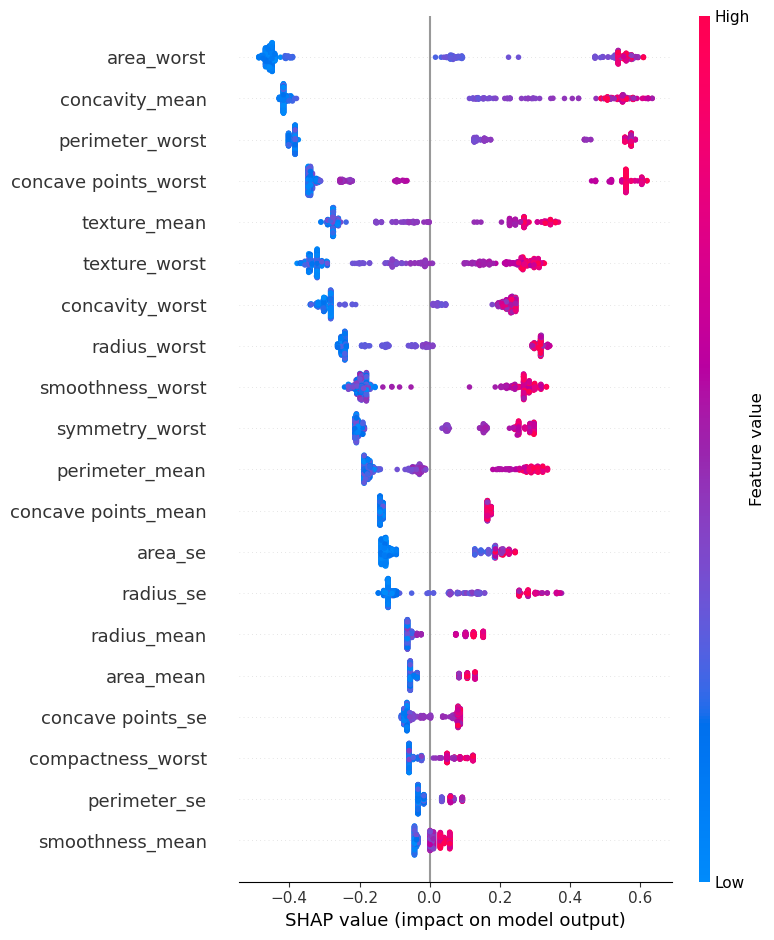

In [127]:
shap.summary_plot(shap_values, X_train,show=False)
plt.savefig('shap_cancer.png')

## Performance Default


|| XGBoost | CatBoost| LGBM |
|---| --- | --- | --- |
AUC| 0.97950|	0.97156|	0.94511 |
logloss| 0.60595|	0.80793	|1.81785|
KS| 0.95899|	0.94312|	0.89021|
time (s)| 0.14904	|2.72823|	0.08682|

## Optuna (1h tuning for each model)


|| XGBoost | CatBoost| LGBM |
|---| --- | --- | --- |
AUC| 0.99927|	0.99927|	0.99912|
logloss| 0.08477|	0.04291|	0.07038|
KS| 0.98413|	0.97487|	0.97487|